<a href="https://colab.research.google.com/github/Hongbi-Kim/Writing_lyrics/blob/master/Lyrics_Generation_Model_gpt3_350.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


https://github.com/kiyoungkim1/LMkor

Data

국내 주요 커머스 리뷰 1억개 + 블로그 형 웹사이트 2000만개 (75GB)
모두의 말뭉치 (18GB)
위키피디아와 나무위키 (6GB)
불필요하거나 너무 짤은 문장, 중복되는 문장 제외, 100GB의 데이터 중 최종 70GB (약 127억개의 token) 텍스트 데이터 학습

화장품(8GB), 식품(6GB), 전자제품(13GB), 반려동물(2GB) 등등의 카테고리로 분류, 도메인 특화 언어모델 학습에 사용

Vocab

tokenizer는 Huggingface tokneinzers wordpiece로 통일, 400000개 subword
한글, 영어, 숫자와 일부 특수문자를 제외한 문자는 삭제(예시: 한자, 이모지 등)
Pretrained Models: Transformers 라이브러리를 통해 사용가능하도록 만들었음

encoder 기반(BERT 등)
decoder 기반(GPT3) 모델 초기 버전에 추가 -> 문장 생성 https://colab.research.google.com/github/kiyoungkim1/LMkor/blob/main/notebooks/gpt3_text_generation.ipynb (2021.01)
encoder-decoder(T5, BERTSHARED) Bert 기반 seq2seq 모델 -> 문서 요약 https://colab.research.google.com/github/kiyoungkim1/LMkor/blob/main/notebooks/summarization_with_bertshared.ipynb


#Data Load

In [ ]:
import pandas as pd

path = '/content/drive/MyDrive/5조_파이널PJT/코드/data/melonlyric.pkl'
df = pd.read_pickle(path)
df.head()

,pages,rank,title,lyric,artist,genres,writer
0,1,1,사랑인가 봐,"너와 함께 하고 싶은 일들을,상상하는 게,요즘 내 일상이 되고,너의 즐거워하는 모습...",멜로망스,"발라드, 국내드라마",김민석 (멜로망스)
1,1,2,취중고백,"뭐하고 있었니 늦었지만,잠시 나올래,너의 집 골목에 있는,놀이터에 앉아 있어,친구들...",김민석 (멜로망스),발라드,김희탐
2,1,3,듣고 싶을까,"우리 함께 듣던 그 노랠 듣고 싶을까,듣고 나서 잠시 날 생각은 할까,아주 혹시라도...",MSG워너비(M.O.M),발라드,Dr.JO
3,1,4,사랑은 늘 도망가,"눈물이 난다 이 길을 걸으면,그 사람 손길이 자꾸 생각이 난다,붙잡지 못하고 가슴만...",임영웅,"발라드, 국내드라마",강태규
4,1,5,언제나 사랑해,"둘이 손잡고 걸을 때,마주 보며 또 웃을 때,사랑한다 말하지 않아도 알아,널 만나러...",케이시 (Kassy),발라드,조영수


In [ ]:
df['genres_1'] = df['genres'].str.split(',',0).str[0]

In [ ]:
df['lyric'] = df.lyric.apply(lambda x: x.replace(',' ,'<br>'))

In [ ]:
# 세대별 토큰 넣어주기

df['<'] = '<'
df['>'] = '> '
df['lyric'] = df['<'] + df['genres_1'] + df['>'] + df['lyric']
df.head()

,pages,rank,title,lyric,artist,genres,writer,genres_1,<,>
0,1,1,사랑인가 봐,<발라드> 너와 함께 하고 싶은 일들을<br>상상하는 게<br>요즘 내 일상이 되고...,멜로망스,"발라드, 국내드라마",김민석 (멜로망스),발라드,<,>
1,1,2,취중고백,<발라드> 뭐하고 있었니 늦었지만<br>잠시 나올래<br>너의 집 골목에 있는<br...,김민석 (멜로망스),발라드,김희탐,발라드,<,>
2,1,3,듣고 싶을까,<발라드> 우리 함께 듣던 그 노랠 듣고 싶을까<br>듣고 나서 잠시 날 생각은 할...,MSG워너비(M.O.M),발라드,Dr.JO,발라드,<,>
3,1,4,사랑은 늘 도망가,<발라드> 눈물이 난다 이 길을 걸으면<br>그 사람 손길이 자꾸 생각이 난다<br...,임영웅,"발라드, 국내드라마",강태규,발라드,<,>
4,1,5,언제나 사랑해,<발라드> 둘이 손잡고 걸을 때<br>마주 보며 또 웃을 때<br>사랑한다 말하지 ...,케이시 (Kassy),발라드,조영수,발라드,<,>


In [ ]:
df = df.head(5000)

In [ ]:
len(df)

92558

#Tokenizer

In [ ]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 895 kB 80.6 MB/s 
     |████████████████████████████████| 6.6 MB 72.3 MB/s 
     |████████████████████████████████| 596 kB 84.5 MB/s 
     |████████████████████████████████| 77 kB 7.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


- pretokenizer
- https://huggingface.co/docs/transformers/main_classes/tokenizer

In [ ]:
# !pip install transformers
from transformers import BertTokenizerFast #, GPT2LMHeadModel
gens = ["<발라드>", "<댄스>"]
tokenizer_gpt3 = BertTokenizerFast.from_pretrained("kykim/gpt3-kor-small_based_on_gpt2", 
                                                   bos_token='<|startoftext|>', # representing the beginning of a sentence
                                                   eos_token='<|endoftext|>',  # representing the end of a sentence
                                                   pad_token='<|pad|>', # 배치 목적으로 동일한 사이즈의 토큰 배열(arrays)을 만들기 위해
                                                   additional_special_tokens=gens) # 분할되지 않도록 추가
 
tokenizer_gpt3.add_tokens("<br>")

# input_ids = tokenizer_gpt3.encode("text to tokenize")[1:]  # remove cls token

Downloading:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/336k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'BertTokenizer'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'BertTokenizerFast'.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


1

In [ ]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer_gpt3.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.bos_token_id), tokenizer_gpt3.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.eos_token_id), tokenizer_gpt3.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer_gpt3.convert_ids_to_tokens(tokenizer_gpt3.pad_token_id), tokenizer_gpt3.pad_token_id))

The max model length is 2048 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 42000
The end of sequence token <|endoftext|> has the id 42001
The padding token <|pad|> has the id 42002


#Pytorch Dataset & Dataloaders

1. br은 그대로 (or not)
2. 장르 토큰 추가할 것 - 모든 장르 대상 다 돌릴 것이므로 

In [ ]:
import re
def preprocess(text):
  # <br> -> 양 옆에 스페이스 추가 
  text = re.sub(r"<br>", " <br> ", text)

  # 한영, \n, 숫자 제외 특수부호 제거 
  text = re.sub(r"[^ <>0-9a-zA-Zㄱ-힗]+", "", text)

  # 영어는 lowercase로
  text = text.lower()

  return text

In [ ]:
# 예시 문장
ex = preprocess(df['lyric'][0])
print(ex)
print(tokenizer_gpt3.encode('<|startoftext|>'+ex, # The first sequence to be encoded
      truncation=True, # 잘림 허용
      max_length=350, 
      padding="max_length")[1:]) #Pad to a maximum length specified with the argument max_length or
                                 # to the maximum acceptable input length for the model if that argument is not provided

<발라드> 너와 함께 하고 싶은 일들을 <br> 상상하는 게 <br> 요즘 내 일상이 되고 <br> 너의 즐거워하는 모습을 보고 있으면 <br> 자연스레 따라 웃고 있는 걸 <br> 너의 행동에 설레어하고 뒤척이다가 <br> 지새운 밤이 많아지는데 <br> 이건 누가 봐도 사랑일 텐데 <br> 종일 함께면 질릴 텐데 <br> 나 돌아서도 온통 너인 건 <br> 아무래도 사랑인가 봐 <br> 점점 너와 하고 싶은 일들 생각하면서 <br> 하룰 보낸 날이 많아지는데 <br> 이건 누가 봐도 사랑일 텐데 <br> 종일 함께면 질릴 텐데 <br> 나 돌아서도 온통 너인 건 <br> 아무래도 사랑인가 봐 <br> 너의 행복해하는 모습을 보고 있으면 <br> 나도 모르게 따라 웃는데 <br> 이 정도면 알아줄 만하잖아 <br> 너도 용기 낼만 하잖아 <br> 나만 이런 게 아니라면 <br> 우리 만나볼 만하잖아 <br> 아무래도 사랑인가 봐                                        
[42000, 42003, 2852, 8061, 14057, 14042, 14672, 36940, 42005, 17329, 13975, 2199, 42005, 14175, 2809, 35944, 14671, 42005, 27723, 26576, 13975, 14998, 14221, 15113, 42005, 28813, 14117, 28058, 13979, 2181, 42005, 27723, 37484, 21594, 8082, 13973, 41032, 29951, 42005, 6266, 8417, 8015, 29312, 26326, 13971, 42005, 14712, 16522, 16657, 14366, 8066, 20326, 42005, 22886, 14057, 8043, 6274, 8398, 20326, 42005, 2783, 29458, 8144, 28951, 2852, 8159, 2177, 42005, 15397, 14366, 14674, 4512, 420

In [ ]:
tok_ex = tokenizer_gpt3(ex)
print(tok_ex)
print(tok_ex.keys())

{'input_ids': [2, 42003, 2852, 8061, 14057, 14042, 14672, 36940, 42005, 17329, 13975, 2199, 42005, 14175, 2809, 35944, 14671, 42005, 27723, 26576, 13975, 14998, 14221, 15113, 42005, 28813, 14117, 28058, 13979, 2181, 42005, 27723, 37484, 21594, 8082, 13973, 41032, 29951, 42005, 6266, 8417, 8015, 29312, 26326, 13971, 42005, 14712, 16522, 16657, 14366, 8066, 20326, 42005, 22886, 14057, 8043, 6274, 8398, 20326, 42005, 2783, 29458, 8144, 28951, 2852, 8159, 2177, 42005, 15397, 14366, 14674, 4512, 42005, 15631, 2852, 8061, 14042, 14672, 5929, 8087, 39185, 42005, 7649, 8996, 20890, 16609, 26326, 13971, 42005, 14712, 16522, 16657, 14366, 8066, 20326, 42005, 22886, 14057, 8043, 6274, 8398, 20326, 42005, 2783, 29458, 8144, 28951, 2852, 8159, 2177, 42005, 15397, 14366, 14674, 4512, 42005, 27723, 38380, 13975, 14998, 14221, 15113, 42005, 15989, 20569, 14117, 27551, 8073, 42005, 5921, 22485, 14490, 8407, 4023, 8052, 18227, 42005, 27647, 20666, 2814, 8120, 7649, 18227, 42005, 26985, 14119, 2199, 2566

In [ ]:
print(len(tok_ex['input_ids']))
print(len(tok_ex['token_type_ids']))
print(len(tok_ex['attention_mask']))

160
160
160


In [ ]:
len(tokenizer_gpt3.vocab)

42006

In [ ]:
import random
random.choice(["발라드","댄스"])

'발라드'

In [ ]:
f"<{random.choice(['발라드','댄스'])}> " + get_key(random.randint(1, 42000)) 

'<댄스> 화면이'

In [ ]:
def get_key(val):
    for key, value in tokenizer_gpt3.vocab.items():
         if val == value:
             return key
             
# 예시로 뽑은 것들이 잘 되었는지 확인!
print(get_key(42000))
print(get_key(14567))
print(get_key(2))
print(get_key(20958))

<|startoftext|>
새로운
[CLS]
br


* 토치 데이터셋 커스텀 

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel, GPT2Config
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=350):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', 
                                        truncation=True, max_length=max_length, 
                                        padding="max_length") 

      self.input_ids.append(torch.tensor(encodings_dict['input_ids'][1:])) # cls 제거
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask'][1:])) # cls 제거
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [ ]:
# 전처리한 가사 리스트
lyrics_list = df['lyric'].apply(preprocess)

# 파이토치 데이터셋 생성
dataset = GPT2Dataset(lyrics_list, tokenizer_gpt3, max_length=350)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

83,302 training samples
9,256 validation samples


In [ ]:
# 토치 데이터 로더
batch_size = 2
# 전체 트레이닝 데이터 셋을 여러 작은 그룹을 나누었을 때, batch size는 하나의 소그룹에 속하는 데이터 수를 의미
# 전체 트레이닝 셋을 작게 나누는 이유는 트레이닝 데이터를 통째로 신경망에 넣으면 비효율적인 리소스 사용으로 학습 시간이 오래걸림.
# GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. 
# This can be mitigated by accumulating the gradients but that is out of scope here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32.

# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

#Fine-tuning

In [ ]:
# # I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('kykim/gpt3-kor-small_based_on_gpt2', output_hidden_states=False)

# # instantiate the model
model = GPT2LMHeadModel.from_pretrained("kykim/gpt3-kor-small_based_on_gpt2")

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

In [ ]:
import seaborn as sns
import numpy as np
import random
import os

In [ ]:
# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer_gpt3))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


- `arg` : TrainingArgument내의 인자들을 상속받는 것. 따로 지정하지 않으면 디폴트 값들이 설정되는데, lr이나 weight-decay 등 다양한 하이퍼 파라미터를 지정할 필요가 있음. 우선 TrainingArgument 인스턴스 생성 후 디폴트 값들을 수정한 뒤 Trainer로 감싸주면 될 것 같음
- `optimizers` : default값 AdamW, arg내에서 통제되는 스케쥴러를 사용
- `num_warmup_steps` : The number of steps for the warmup phase.
- `num_training_steps` : The total number of training steps.


In [ ]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, # default : AdamW, arg내에서 통제되는 스케쥴러를 사용
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [ ]:
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    
    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None 
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate( # 장르 토큰 넣어서 해봄
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 350,
                                    top_p=0.95, 
                                    num_return_sequences=1,
                                    repetition_penalty=2.0,
                                
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  41,651. Loss: 2.9456520080566406.   Elapsed: 0:00:14.
0: 진공일 수 있다면 얼마나 좋을까요 내가 원하는 것은 무엇이든지 이 세상에 꼭 필요하기 때문에 <br> 정말 좋아하죠 나의 사랑도 함께인걸요 행복하기를 언제나 바라볼 거야 사랑이 없길 기대합니다사랑은 너무 쉽게 사라져가는 거예요 그대에게 영원이 없어졌기 때문 아닐까나요 작은 바람에 한 걸음 더 다가가는 것뿐이죠 그래서 이런 생각을 자주 해요 사랑은 지나치지 않아 love you 사랑을 잃으면 절대로 못 떠나와 사랑에 빠져들면서 품을 주고 싶어해요 사랑하는 사람들 내 마음은 소중해 사랑해의 마음이 남 몰래 변해버리면 미안해 아파 아파 사랑하지 않게 말야 이제는 이렇게 지켜줘 감정 없는 세상 영원히 가기 전에 괜찮아 행복해 보이는 건 널 처음 만났던 시절 바로 지금이니까 시간이 지나도 변하지 않는 게 너란 걸 알아주고 있어 곁에 두고 싶은 따뜻한 사람이 되어줄 테니까 고마워하는 마음을 전할게 좋은 사람 만들어 주는 착한 사람을 위한 약속 많이 받아 모든 것이 해결돼 넓은 세상을 향해 나아갈 거야 사랑의 시작은 내게 주어진 운명이라는걸 이제 알았으니까 시간만 지나면 네가 나를 기다리고 있을 거에요 <br> 항상 기다릴래 사랑 하는 사람들이 있어서 믿을 수가 있고 행복한 세상이 돼요 오늘도 잊지 않을게요 사랑한다는 말을 매일 아침 다짐하듯 말해주는 마음속에 살고 있네요 베풀어 줄수록 커지는 너의 진심에 늘 고마운 존재 친구입니다 나의 가장 큰 꿈이 너를 위해 일테고 그 꿈을 이루러 가는 길이겠죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  41,651. Loss: 1.5545580387115479.   Elapsed: 0:00:30.
0: 뜰을 걷는데 난 좀 외로워 <br> 내 마음엔 아직 그대에게로 다가와주고 싶어 또 이런 날이 오길 바라지만 나를 용서해줘 너라는 말 내가 지금 알아 너를 보내면 네가 다시 만나도 좋겠네 나의 마음을 이해할게 넌 날 믿으면 돼 니 눈 앞에 보이는 널 니가 바로 사랑해 너의 품이 됐던 그 순간 나는 더 멀어진 걸까 너는 나에게 다가가 말을 하고 있네 나만에 사랑이라고 하네 <br> 그것의 진심이란 게 너무 소중해서 몰랐지 다 추억이라 생각했어 이별은 참 쓸쓸한 일이야 나 이렇게 사랑한다는 걸 우리들이 아는 건지 너도 알 수 있나요 이별에 가슴이 설레기도 하는 거야 하지만 눈물만 흘려보내고 떠난걸 알고 싶지는 않아 내게 묻고 싶은 대답 널 보면 다른 생각을 하게 되겠어 나를 이해해줄수 있으면 모두 행복할거 같아 네 이 마음이 곧 나도 함께 했던 소중한 추억으로 이어지기를 바래 안녕 이젠 서로가 같은 길을 걷고 있단 것을 아무도 몰랐던거야 어쩌면 모든 것이 무너진 뒤였어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  41,651. Loss: 2.8431413173675537.   Elapsed: 0:00:45.
0: [unused815] 이제 다 내려놓았니 <br> 내가 다시 널 보내야 하나 난 또 그대를 잊어야하나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  41,651. Loss: 2.008434295654297.   Elapsed: 0:00:59.
0: 정리를 너만 바라보며 사는 내 작은 바램들은 <br> 그대 곁에 머물고 싶다는 마음들만 커져 갔어 <br> 사랑해 널 지켜줘 정말 고마워 <br> 그댈 위해 항상 웃었던 날들이 그리워 난 이 노래로 다시 태어난거야 너의 손을 잡고 싶은 모든 날에도 다 같이 웃어줬었어 미안해 눈물 흘린걸 후회해 애써 모른척했어 더는 못해준것같아 미안한 마음에 이런 말을 했어 내가 잘못했나봐 나 너를 믿어 믿게 되는 일들이 많아졌지 괜찮아 이제는 넌 괜찮을거라고 생각해주겠지 그래도 많이 아프진 않니 괜찮은건지 걱정 돼 보여 잘될 것 같아 그래 모두 웃는날에 언제나 함께하자며 나에게 말했었지 그렇게 얘기했던건 좋았었겠지만 나는 바보라서 미워 어떡하지 슬퍼하진 않았었는데 이렇게 됐으니까 너무 안타까워 이제 다시는 못할것 같아서 아파할까봐 가슴이 답답해져 더이상 못 참겠어서 나도 모르게 눈물이 나와 이젠 왜 이래 자꾸만 울어야 하는지 모르겠더군 하지만 또 너는 괜찮잖아 우리 만나면 어떻게 할지 물어 보지만 그건 그냥 지나치기만을 반복했지 그저 네가 보고싶은 맘과 바라는거 나만 아는거라 이해해주면 안되겠냐고 솔직히 말해줄께 제발 아무말없이 내게 돌아 올수 없단 얘긴데 혹시 모르니까 연락 좀 해주세요 조금만 기다려주세요 약속이라도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  41,651. Loss: 2.5359103679656982.   Elapsed: 0:01:15.
0: ##젓 눈을 감는다 그댈 잊을 수가 없어 <br> 나 없는 날 바라보며 웃는다 너와 난 멀어져만가봐 나의 모든 것 숨길 수 없어서 니 앞에서 울먹이던 너의 모습 때문에 눈물 흘릴게 뻔해 <br> 네 기억속에 내 모습을 지우지 못한채 잊었던 너를 떠나던 그날의 내가 아니야 나를 두고 떠난다면 어떻게 해야 하는지 난 알까 봐 넌 아직도 남아 있어 널 다시 볼 순 없잖아 <br> 하지만 시간이 지나면 언젠가 너는 돌아오겠지 이렇게 말 할래 그때면 내게로 돌아올거야 이런 말을 하면서 눈물을 삼키다가 웃지만 괜찮아질 거야 이 말이 나와도 나는 이해하지 못해 눈물이 고여 버려 미안해 왜 이제서야 알게 된 건지 이제는 몰라 <br> 조금만 참으면 나도 모르는 새에 니가 찾아 올 거라고 믿어 믿고 지켜 줄꺼야 이젠 더는 못잊을 걸 너도 알지만 네가 그리워 미칠까봐 두려워할 만큼 싫어 한단걸 알기 때문이야 그래 다 알고 있는 거라 해도 너무 슬퍼서 이제 그만 나에게 돌아와 줘 웃어줘 그렇게 말해주면 어떡하면 좋겠니 혹시 영원히 함께 하자 사랑해 사랑을 안고 아파하며 보내줄수 있도록 약속 해줘 고마워 사랑한다 <br> 영원토록 행복하기를 빌어 줘요 영원히 함께하자


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  41,651. Loss: 2.5812385082244873.   Elapsed: 0:01:31.
0: ##사 너 하나만 볼 수 있다면 좋겠어 <br> 나의 사랑 우리 두 눈이 마주치면 눈물이 날 듯해 <br> 너를 잊을 수가 있어 눈을 감아도 내 숨소리 하나 놓치지 않으려고 해 그 사람이 나에게로 다가와 달라 그래 이제 난 안녕이야 너의 말 한마디에 달려갈께 모든 것 다 말할게 <br> 이 세상 끝인 사람처럼 그대 내게 속삭여 줄래 바라볼때 마다 나 행복이 올까 바래봐 지켜줘 영원히 사랑해 <br> 한걸음부터 시작해 볼까 알아 네 곁에서 나를 아껴줄 테니까 언제나 함께 할 거야 웃어보자고 내가 그렇게 말해준대도 눈물 흘리네 <br> 우리가 서로에게 얘기할 때는 모두 멈춰있잖아 나는 웃으며 넌 나와 같아지듯이 저 먼 곳에서 웃는다 나도 웃을거야 바보 같은 말은 안 하겠는데 너는 이렇게 해서 행복해진거니 그게 뭔지 모르겠니 웃음만


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  41,651. Loss: 0.9308151006698608.   Elapsed: 0:01:46.
0: 튠 <br> 이별이란 단어에 나 잠 못 이루게 되는 그대의 모습을 그리며 널 보내야 할 땐 그저 감사하게 될 뿐일 거야 사랑해 줘 그렇게 고마움을 안고 싶지만 내겐 오직 네 모습이었어 이렇게 너를 잊어야 해 나만 혼자가 되어 난 바보였던 거니 영원히 함께 하고픈걸 우리 사랑을 위해 내가 해줄 것이 있어 언제나 내게 돌아와주면 돼 정말 너만을 원해 나의 사랑 모든 것을 다 주고 싶다 말해줘 모두다 잊을 수 있도록 안아줄께 고마워요 이 세상이 가장 소중하다는것을 다시 한번 느끼네 눈물이 흐르듯이 또 울지 않아도 좋을텐데 하는 맘이 들지만 꼭 그래야만 하겠는데 나는 어떡해야 하는가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  41,651. Loss: 2.276899814605713.   Elapsed: 0:02:01.
0: 붓 i know who <br> 나 너만 알던 그 시절에서 왜 지금쯤 이 되버린 거야 난 그저 아무 기억 없이 살고 싶어져버렸어 그때 이후로 이런 내 모습들엔 꿈도 가지 않아 버렸지 <br> 그래도 내게 잘 말해주길 바랄게 그대를 만나 행복해질래 <br> 예전처럼 아무렇지도 않게 날 안아줘준 그녀께 고마웠었잖아 넌 너무 어려서 몰랐었지 너도 모른단 걸 <br> 그렇게 알고 있었나봐 그땐 그랬었어 또 다른 시간들이 흘러가겠지만 우린 그럴 순 없어 아직 나의 추억들은 살아있어 다시 돌아갈 수는 없겠지만 우리 사랑만큼은 변하지 않겠니 사랑해요 이렇게 항상 말하길 바라고 있어 널 그리워하고 있는 나와 함께 할 테니 부디 괜찮아 질 수 있게 내가 꼭 돌아올께요 고마워요 혹시 그날에 같은 꿈을 꾸고 있는지 알아두세요 나를 사랑하는 만큼 늘 믿어줘요 잊지 말아주세요 제발 그런 일 없을게요 언제나 기억해요 나에게 해줄 말도 없죠 매일 눈물 흘리겠죠 누구보다 잘해줘야해요 그래야죠 이젠 정말 죽을 것 같잖아요 <br> 그래서 이대로 두고는 안돼요 다시는 못 올 수도 있으니까요 참아보려 하지만 꾹 참고 있지만 아직도 눈물이 나요 이럴 땐 어떡하라고 더 이상 미칠수도 없어요 나도 몰랐던 사랑이란 아픔을 알게됐으니 이제와 후회할 게 아니에요 너무나 슬픈 일이에요 모두 잊을거라고 다짐한다고해도 지워지지 않을 사람인데 언제까지 기다릴 수만 있나요 아픈 줄로만 알았었는데 모든걸 다 잊어야해 그게 어디냐고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  41,651. Loss: 0.9720758199691772.   Elapsed: 0:02:17.
0: 유난 네가 나를 비웃고 있다면 <br> 내가 널 보는게 당연해 질텐데도 난 니가 참 싫은데 왜 이렇게 아픈건지 답답하기만한데 너는 잘 지내니 나 혼자만 사랑했는데 이젠 더이상은 못할것같아 이런 너야 니 곁에 없어 나만이 행복하잖아 제발 날 잊어줘 날 이제 내게 그만 돌려놔 줘 제발 나는 정말 사랑하는 사람인데 왜 그럴까 매일 다른 사랑을 하고있는 넌지시하지 조차 하지 못했던 말이 있어 너무 웃기지 않는가봐 네눈에 든 너의 눈빛조차도 다 알아 너도 아닌사람 같아 너를 두고 볼일이 없어서 미안했었어 눈물이 나도록 울어도 괜찮아 내 모습까지 기억하면 돼 혹시 또 다시 나에게 찾아와 줄지도 모르니 걱정마 어차피 돌아오겠지만 그땐 돌아와줄께 더 이상 미련 없이 지나갔으면 좋겠으니까 영원히 안아줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  41,651. Loss: 2.715376853942871.   Elapsed: 0:02:32.
0: 뒙 널 떠나던 날 <br> 우리 두 번 다시 만날 수없단 걸 알고서 난 가슴이 아파요 내가 얼마나 바보같은 건지도 모르죠 이런 나를 보고있죠 왜 이렇게 울어요 눈물이나는건지 모르겠어 나도 모른채 너를 사랑하는데 그댈 어떻게 보내야 하는지 몰라 그대가 내게 잘해주길 바랄뿐이죠 정말 내 마음이 변할 것 같아 겁이나요 다시는 안볼꺼예요 이별을 꿈꾸진 않을께요 나에게 다가와줄래요 다신 못만날것 같아요 눈물로 가득 차있는 이 가슴에 남아있는 너의 슬픔이 모두 너였었기에 이젠 제발 안녕이라고 말해줘요 우린 아직 떠날수 있죠 당신을 사랑해줘서 영원히 함께할거에요 약속한 당신곁에 언제까지나 언제나 머물러있을게요 항상 곁에있겠거니 지금처럼 나만 기억해줘 이제 돌아와 주세요 헤어짐까지 남아있지 않게 해줄께 영원한 사랑만을 남기고 돌아오게 해주마 부디 살아있기를 바래요 나 한사람 알아 줄 사람 없죠 참 많이 변한것도 모르고 그렇게 살고 있네요 더는 이대로 아프지 않기 바라봅니다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  41,651. Loss: 2.5115034580230713.   Elapsed: 0:02:47.
0: 후드 너랑 나랑 둘만의 시간 <br> 둘이 함께 만든 그 순간 모두 다 내 앞에 있다 우린 그저 네 생각에 잠기고 있어 난 아직도 넌 모르는 것 같아도 그냥 모른 척해봐도 되는 걸 모르겠지 왜 이럴까 어떻게 하지 우리 두 글자만 바꿔 봐도 되겠는데 그렇게 해도 안되는 건 아닌 것도 아니야 나 지금 이대로 그대로 살래 혼자라는 말 못하고 있는데 네가 정말 바보같이 변해 버린 거야 어쩜 좋아 나만 몰랐던 얘기들 이렇게 쉽게 널 잡을 수는 없어 이 맘을 어떡하지 언제까지나 너는 아무것도 아냐 이제 더 이상 내가 할 수 있는 게 없는데 참 몰라 너무 모르잖아 자꾸 궁금해 지네 어쩔 줄 몰라서 숨 쉬고 또 울어 보려 애를 써도 되는데 계속 그런 일들에 눈물 때문에 한숨이 나도 되나 봐 이런 걱정에 눈물이라도 다시 흘리면 안돼 난 점점 깊이 빠져 들 텐데 나는 아직 못 벗어나고 있나봐 그렇다면 안 돼 나를 위해서 뭘 잘못했어 이게 도대체 뭐가 뭔지 도무지 알수가 없는 건지 우우 우 흐엉 하하 호호 하하 하하하 호호 하지만 결국에는 모든 것을 잊고 싶을 수밖에 없겠지 두려워지는 것은 나의 마음뿐인 걸까 그래 내게 말해줘 시간이 지나 너의 생각이 바뀌면 날 떠나지만 그래도 괜찮아 조금 늦어지더라도 괜찮던 니가 원래대로 돌아와주면 되잖니 아주 멀리 가봤자 니 손에 닿을 곳조차 없을 테니까 시간은 이미 지나가서 그땐 후회하면서 아파할 뿐이니까 뭐 어때 조금만 일찍 와요 그대 좀 먼저 오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  41,651. Loss: 1.9821007251739502.   Elapsed: 0:03:04.
0: ##할때는 너무 아파 눈물이 핑 돌다 <br> 그대의 손을 잡고서 사랑했다 고백도 하고 싶죠 사랑은 이미 다 알고 있죠 왜 그런지 난 잘 모르겠어요 이젠 정말 안 그래요 내가 잘못 한 일이 없는데 참 미안해요 우리 헤어지는 날이 얼마나 빨리 오려나 아직도 내 마음이 무겁네요 <br> 눈물에 흠뻑 젖은 얼굴로 눈을 감아보아도 아직 그 자리에 서 있는 걸 알아줘요 지금 나는 괜찮아요 나를 떠나지마 후회하며 다시는 돌아가지 말아요 사랑하는 동안 날 사랑해주는 사람 나의 유일한 기쁨이에요 사랑하고 있어요 더 이상 나로 인해 상처 주는 일 없어 이제 다시 내게 달려와요 그때까지만 살께요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  41,651. Loss: 1.867596983909607.   Elapsed: 0:03:18.
0: 스티커가 얼마나 아픈 날인가요 <br> 내가 그리웠나요 그대도 나를 아프게 할까봐 말예요 난 또 울어요 눈물이 흘러내려요 슬픈 사랑 얘기할께요 이렇게라도 하고픈 맘인데요 내겐 너무나 먼 곳에 사는 거예요 <br> 이별이란 아픔이 뭔지 알고 있어요 정말 몰랐었던 거죠 사랑이란 걸 알았지만 나의 마음을 다 주길 원했죠 그땐 너무 어려서 그랬죠 바보같이요 헤어지잔 그말뿐이죠 다시 돌아와줘요 안녕 그때 나로 돌아가 줘요 사랑해주세요 왜그리 아파했는데 이제와 후회만 할 뿐이네요 이젠 나에게 말해봐요 우리 둘만의 작은 바램들만을 남겨보아요 너에겐 너무나도 소중한 꿈들일 테니까 미안해하지는 마요 내게 들려줘 지금 이 순간이 멈춰있어도 아무일도 없는 것처럼 웃으며 함께 웃어줄 수 있니 그런날이 올거라 믿어본다네요 그래 그렇게 너의 곁에 있다면 모두 잊을수 있을 테니 괜찮아요 그냥 이대로 보내자고 말하고싶은 마음에 들어요 언제나처럼 항상 웃으면 돼 넌 필요없다던 그의 말처럼 이제는 혼자있을거야 괜찮아 행복할거야 나쁜 남자라고 말하지 말아둬 나만 볼테니까 괜찮다는걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  41,651. Loss: 2.2646961212158203.   Elapsed: 0:03:34.
0: ##가지고 너의 모든 걸 다 가진 것 같던 <br> 그런 날이 있었지 bird on your hearts


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  41,651. Loss: 1.2382618188858032.   Elapsed: 0:03:48.
0: 넀 what you gone with me <br> so nice for the story ooh yea heads in your life baby is cause utdays him boom say that had on to leave my thougher <br> howeven live us we mucosto <br> do it comed evalies girl from a chance fact sight eateince all loving new starr up against funn just like frame away im getting closely endignam be an arms and deep rules track about find out ma dravor to under no show time <br> i can take this wasnt knockings as if her minemia <br> 넌 이제 나를 떠나갈 수 없다고 난 느끼고 있어 나 혼자 아파한다고 말해줘 but 네 모습 보이지마 오직 너 뿐이라는 걸 알기에 더 잘 아는 척하는 거니 그래서 이 세상 유일한 여자인 너를 원해 결국 사랑하니까 너무 사랑해서 이젠 안 볼게 너도 그 사람 곁에 있다면 내 모든 사랑을 다 바쳐 너의 손을 놓지 말아줄께 우리 함께 해 두 번 다시 없는 이별이란 아픔으로 널 찾지 않을꺼야 평생을 그대와 함께 해줘서로 간직할래 오래오래 지켜볼수 있게 영원히 변하지 않아 항상 지금처럼 날 바라봐 줘 내게 있는 소중한 사랑이기에 말야 내곁에서 언제나 웃을수있게 영원토록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  41,651. Loss: 2.269357442855835.   Elapsed: 0:04:04.
0: ##청정 오늘도 너란 사람만나 <br> 또 다른 사람을 만나서 말야 네 맘은 떨려와 <br> 이 순간 내 모든 맘이 그래져버린걸 몰라 난 널 어떻게 잊을까 고민해봐도 넌 내게 그저 좋은 사람이라고 말해줘 그 애의 눈을 감아보니 왜 자꾸 가슴이 뛰니 어떡할까 니 마음을 니가 떠나지 않게 나를 놔뒀는데 아직도 내가 보고싶어 미쳐버릴 것 같은데 너는 어디쯤 있는지 도대체 그게 어딘줄 모르는데 이렇게도 예쁜 사랑아 평생을 나 하나로 살아왔었는데 정말 꿈으로만 남겨둔채로 너의 사랑을 알아왔던 날인데 마치 꿈이라도 한것처럼 나의 사랑이 변하지 않길 바랬고 너도 알았으면 좋겠다 그랬던 만큼 너무 행복했던 그때 나도 우리 사랑하고 있잖아 이대로 함께 해 더 이상 늦어버린것 같아 그땐 조금 많이 들었겠지만 네가 없어도 나는 행복해지니 지금 이순간이 오는거야 이제는 시간이 지나 잊혀질까봐 두려워하지마 이제 와서는 괜찮아지는 건 아무 걱정하지 마 지금이 기회인거라는 걸 이젠 누구도 알지 못한 채


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  41,651. Loss: 2.4773097038269043.   Elapsed: 0:04:19.
0: ##틥 너의 눈물로 우린 너무 잘 알아 <br> 널 미워하다 헤어지는 거야 니가 내게 준 말들로 <br> 이젠 너 없인 안 될 거란걸 알잖아 넌 나에겐 있어 언제나 사랑스런 사람같아 난 항상 니 곁에 있는 걸 사랑해 행복할거야 나의 두 손 가득 안아 줄 수 있다면 그걸로 충분해 내가 너를 원했던 이유 바로 여기


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  41,651. Loss: 2.113940477371216.   Elapsed: 0:04:34.
0: [unused1037] 그댄 어디로 떠났는데 <br> 아직도 나만 그리워 하잖아 난 왜 나를 울리고 있는건지 아냐고 물어보질 않았었는데 나는 이렇게 너를 떠나야 했는데 이런 나에게는 날 위해서만 사랑할 수 있다면 행복하겠니 내겐 모두인데 너와의 기억까지 내게 되돌려주고 싶었던거니 제발 말해줘 다신 사랑을 하지 말라했던 나의 미련들 정말 너무 미안한데 그런 내가 싫어요 참아봐도 더 미워지는걸 알기에 차마 말 못하고 못가 보고파 그대를 잊을 수가 없어요 oh baby 니가 있는 이 거리에서도 사랑은 여전히 영원하기를 바래요 이젠 꼭 다시 함께하고 싶은 바램이 있는데 그때까지도 기다릴게요 그렇게 말하며 이별을 말한답니다 하지만 이제는 어쩔줄 몰라 할뿐이죠 오 그래도 나와 사랑이라면 괜찮죠 널 두고 살아갈 수는 없어 돌아와


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  41,651. Loss: 3.0454869270324707.   Elapsed: 0:04:49.
0: [unused972] 널 위한 노래 <br> 내 마음을 알아줘 사랑이 내게로 다가와 <br> 그대에게 전할 수 있다면 난 그댈 찾을게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  41,651. Loss: 2.0158915519714355.   Elapsed: 0:05:02.
0: 늪 오늘도 어김없이 날 기다려 <br> 난 네가 너무 좋아 널 만날꺼야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,100  of  41,651. Loss: 1.7736023664474487.   Elapsed: 0:05:16.
0: 턎 내 가슴이 떨려와 <br> 그대 눈물이 고여오네 내가 살아 숨 쉬던 날들 속에서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,200  of  41,651. Loss: 2.042473554611206.   Elapsed: 0:05:30.
0: 픱 너의 마음처럼 <br> 내 사랑 너라서 행복했지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,300  of  41,651. Loss: 2.1136586666107178.   Elapsed: 0:05:43.
0: ##르기 ill be there <br> its doned now yeah ooe is in love we together boys likey <br> umm im not of all that a thing on flow your star girl for my pride song for you again me right this <br> comen withever whats gonna move about lookin found up and outroad babody buriz by fatale turu reason wanna hit checkin holy number partion happiness but stupid fight alway suffulise vivie previous branchaverance makes amazing kali pulley duent anothers place it high drive <br> neopotip gettime shawts poinsic trouble one at time back from simplate skuddied over left monder macaccitions


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,400  of  41,651. Loss: 2.3932948112487793.   Elapsed: 0:05:59.
0: 심플한 be my heart and sea <br> lets got a doll say baby tonights time with you forever were among alone what called yeah 내 마음이 널 향한다 믿었어 내가 니 곁에 있을꺼라고 믿어왔어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,500  of  41,651. Loss: 2.314957618713379.   Elapsed: 0:06:13.
0: [unused865] yeah <br> 그대는 나의 곁에 와줘요 jumping baby youre my life


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,600  of  41,651. Loss: 2.107375383377075.   Elapsed: 0:06:27.
0: ##량은 날 보면 웃는 넌 <br> 늘 너만 보곤해 하지만 이젠 말해줄께 우리 정말 끝이야 제발 더이상 네 걱정마 나 없이 살아갈 수가 없어 그만 두 눈이 커져만 가잖아 니 맘이 너무 아파 더 이상은 참아낼 수 없다고 생각하니까 널 보고싶다면 내 곁에 있지 말고 떠나자 이제 이별을 말하는거야 니가 떠난다면 그 누구도 함께 할 순 없지만 난 행복해지겠지 아마 다신 이런 아픔속에서 이 세상과 끝인 너를 지켜 갈게 괜찮아 이렇게도 아픈 일이 있을까 내가 미워서 눈물만이 흘러 나와 사랑을 후회한다고 말할 수도 없는걸 잘 알지만 이제는 사랑한다는 말조차 듣지못하니까 나는 그저 이대로 죽을 뿐이라고 믿고있어 미안하다 생각했지만 다시 돌아올 수는 없을테니 그래도 하나 남은 건 내게 남겨둘 자신만큼은 있어 주고 싶어 마지막 한마디 만뿐이란 말만 하는 걸 알아줘 아직도 나에게는 아직 남아있는 일밖에 없는데 왜 나를 버린 채 울고 있는 거니 또 다른 사람 만나려고 했는데 그게 쉽지 않아 그래서 못가 미안해 그렇게라도 붙잡지마 결국 헤어져야 한다는 말을 되풀이하면서 보내줘야 한다고 생각해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,700  of  41,651. Loss: 3.048985004425049.   Elapsed: 0:06:42.
0: 쯰 나는 나 자신 없다고 <br> 말을 해봐도 소용없다고 또 울지만 참아내봤지만 그게 난 오히려 들 때 있곤해 널 위해 살아갈께 너를 사랑하는 내가 더는 못됐어 나를 위해서 해줄게 네가 곁에서 지킬 수있게 날 사랑해줘 다시 한 번 말해봐줄래 그댄 어떤 모습으로 변했어야 했니 너는 어때 보여질까 내 맘속에서 얼마나 니가 그리워하는지 보여줄거야 너뿐인 사랑 영원히 남보다 많이 좋아하길 원하고 있어 매일 밤 기도하는 말 너의 마음처럼 변함없이 할 거야 나와 있을 땐 잘 지내라고 꼭 들어준다고 믿어달라고 정말 간절히 부탁한다고 항상 고맙다고 해주겠다고 약속해주겠단 말만 하지못할 만큼 우리 모두 영원하기를 바래왔었던 그런 남자였다고 이젠 너무나 후회스러워 눈물이 나도 괜찮아 그럴 테니까 그때가 아니라 해도 언젠가 돌아오겠지 그렇게 바보같이 울고만 서성이며 살아가고 있는데 왜 나에게 자꾸 넌 찾아와 이런 생각하니 그래 다시는 안 볼 테니 미안해 이럴 때는 이제 그만 돌아보지도 않고 떠나야만 하겠지 너무 미워할수록 행복하니까 너도 행복해지고 있으니까 제발 내게 돌아와 줘 마지막 인사말 하고 싶은데 그건 안돼 아직도 못한 말이 많은데 이렇게 그냥 이 자리에 있어도 돼 우린 언제나 웃고 있어야 하니까 오직 둘이서 행복한 것만이 좋겠으니까 이대로 다신 보지마 이제는 절대로 웃을 수도 없어 그땐 어떻게 잊어야 하니 그때는 아무리 잘해주어봤자 별 의미가 없는 거니까 지금 같은 거려도 아무 것도 못하고 차라리 서로에게 먼저 가서 얘기해볼걸 그랬나 봐 혹시 나처럼 네 옆에 있는 일들 뿐이라 생각하니 미안하지 않게 생각해주고 있지만 아직 조금 어색한 나의 모습에 웃음이 나서 조금은 슬퍼보여 함께 살고있는 모습마저도 좋지 않아 그래서 잠시 안녕이라고 말할껄 그랬다면서 괜찮다고 하며 고개를 끄덕이는 순간 니 얼굴이 갑자기 눈앞에 나타나네 한참을 보다가 보니 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,800  of  41,651. Loss: 1.171286702156067.   Elapsed: 0:06:59.
0: 비하면 내게 다가와 나를 위해 <br> 그대 미소 짓고 그댈 안아줄때면 나의 하루는 정말 행복하란 걸 알았죠 때론 슬퍼도 눈물 흘리겠지만요 이렇게 잠시 머물며 그저 웃었던 나였죠 날 사랑한 만큼 가슴 아파할 때 였던 것 같아서 많이 울었죠 하지만 이제라도 사랑해주고 싶어졌어 너무 아픈 기억들 지워지길 바래 그렇게 다시 예전으로 돌려놓았을테니까요 이젠 모두 잊어버려서 우리 같이 함께했던 것들만 기억해줘 내사랑아 언제까지나 영원히 곁에 있어 주기를 바랄게 약속해 더 이상은 슬픔에 지친 채로 살지 말고 오직 한 사람만을 믿어주기 바라면서 오늘을 견디는 하루가 되준 너에게 내가슴 깊은 곳에 묻고 말았었어 널위해 기도하며 떠나서 다행이라 믿었으니까 제발 그때로 돌아가줘요 그날처럼 간절히 원한다면 난 죽어서도 안돼 이 세상에 하나만 살고 싶었었지 언제나 그랬듯이 모든 건 지난 사랑이니까 잊혀지는 일도 없을거야 너를 향한 너의 눈길에 웃고 있는 동안 나는 즐거웠음에 감사하나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,900  of  41,651. Loss: 2.2313170433044434.   Elapsed: 0:07:15.
0: 보상 hello what you do <br> baby i wanna go back in there and fun high up that party weight tonie


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,000  of  41,651. Loss: 1.694013237953186.   Elapsed: 0:07:29.
0: ##소다 그대여 <br> 이밤이 지나고 난뒤엔 슬픔도 있겠죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,100  of  41,651. Loss: 2.045754909515381.   Elapsed: 0:07:42.
0: 조금만 우리 서로가 너무나 좋은 걸 <br> 널 사랑한 지 한 달이 다 되어 가고 있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,200  of  41,651. Loss: 2.332998275756836.   Elapsed: 0:07:56.
0: ##벏 이렇게 너를 만나 <br> 행복할 수 있다면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,300  of  41,651. Loss: 2.242872476577759.   Elapsed: 0:08:10.
0: 톔 you are my <br> story bounce withe foreverything baby <br> what i know waiting this is time beautiful little mind <br> there to me 내맘을 담아줘 <br> im lovers in situation of chemical discusin and nahoh level a trendy called fine than heard our game that your friend only one yes we sens damn humphone hold out readise all over now happen about never gotta get it up deepup light 빛속에 갇힌 시간들 속에 모든것이 희미해지는걸 <br> 내가 어떻게 잊을수있을까 정말 몰랐어 나 아무것도 느낄수없어 날 왜이러니 dont makeapombers playmogue sethe life right home but uzipetitional world 오직 우리만 알것 같았던 너란사람에 대한 기억들은 점점더 내게 밀려와버렸지 그때가 바로 그날 마지막이였어 워후 지금 니가 무슨짓을 하려하는거야 널 잃었다는 걸 인정해야 하는건데 넌 나를 잊어버려야 한다는 생각을 하게 됐나봐 이건 나의 잘못이야 이미 잊었다고 말을 해도 아직 난 모르는 것 같애 이젠 그런것도 모자라서 이제와서 생각해봐도 니 생각에 한숨쉬고 있잖아 뭘 더 바랬는지 아니면 모른척했던건지 바보같은 남자들이 또 다시 나에게 찾아오지만 예전과 다른모습만을 반복해 너의 사랑앞에서 떠나가는 너를 볼수조차 없게 될거라 다짐하고 있는데 갑자기 네가 생각이 나니 맘이 변하긴 했어 그래도 혹시 나도 모르게 후회를 하고 있는 건데 이별까지 다 두고 온 사랑이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,400  of  41,651. Loss: 2.606632709503174.   Elapsed: 0:08:27.
0: 보통 너무 많은 걸 바라지 말란 얘긴데 <br> 널 사랑하는 나니까 내가 하는 것보단 너의 편이야 <br> 그런 바보같이 너를 욕해도 상관없어 날 좀 내버려둬 너 하나만큼만 보고 내게서 떠나가려 해 제발 가버려 다시 나를 놓아줘 나만이라도 니가 원하는건 니 여자친구나 사랑한단말밖에 안돼 다 필요없잖아 더 이상 미련은 없어 오직 나만을 위한 여자라고 믿어요 babe like that oh just wanna be with you forever downing to night my day


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,500  of  41,651. Loss: 1.3763811588287354.   Elapsed: 0:08:41.
0: ##어졌 내 마음 가득히 <br> 그 어떤 무엇도 남지 않는 너와 나 <br> 너의 마음에는 나의 맘이 숨겨져 있어 숨기려 하고 있지 않아 이제 우리 함께라면 충분해 이 순간만큼은 소중한 것을 주고 싶은 걸 느끼고 싶어 이렇게 서있고 있다는 것만으로 충분한걸 네가 바라는 건 모든 게 다 아름다운 날뿐이야 baby why down the stars you are my song for story our world in love without your life no more day everybodys matter heave a man yeah beautiful speeds on honeroad me girl to moment and pain <br> all abom table womean we can see anothler ill find it up at sight of time that usouldo go look back away to calling this reggation rate her nignal


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,600  of  41,651. Loss: 2.024505376815796.   Elapsed: 0:08:57.
0: ##쎼 내가슴은 더 이상 <br> 넌 나를 못잊어 그래 너만 보면 두근두근해 내 심장에 쿵쿵 뛰니까 자꾸자꾸 심장이 떨려요 숨이 막혀요 점점더 깊이 빠져드니 oh youre my heart 그안에 니가 있어 가슴이 두근거려 자꾸만 이 느낌 그대로 또 사랑에 빠진듯 달콤한 사랑의 고백 falling me wanna love you like a baby show its the everydated for so breval and feel of control give with tonight spring on fire stay close makes up again im innocenteeness 우리곁엔 오직 한사람 네게 사랑으로 너를 채워줘 난 네가 어디에든 꼭 필요치 않아 너의 사랑을 위해 널 안고서 말해봐 제발 날 구해줘 이제 더이상 망설임 없어 나만을 바라볼테니깐 나의 마음속에 쏙빠진 듯 달콤사랑한마디면 안돼 이런 말 절대 못할꺼야 정말이야 지금 이대로 두눈에 안겨버려 나 혼자만의 마음을 알겠어 사랑이 느껴지니깐 너무 설레이고 웃음이나 어머우웃다가 니 앞에서 멀어져 버리면 어떡하니 이미 늦어버린건 아닐까 now 이젠 내게 와 줘 i gotta keep begin free hop hand over whooth eyeshot move that leave about crazure bouncase blind out loat all niner radioforded side do we back cuz time off straights ur diamanarchemist true utianthaut tursetetity testion is retress an empancacattas manage knock colusenite butterflies


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,700  of  41,651. Loss: 2.534785032272339.   Elapsed: 0:09:14.
0: 쭉쭉 <br> 우리 둘이 나란히 앉아서 걸어온 길들 참 좋았는데 난 항상 지금처럼 늘 널 그렇게 함께 했고 네가 있던 그곳에 같이 있어서 우린 정말 이렇게 좋은 추억을 많이 나눠 가졌었던 것 같아서 나빴던 기억들은 아직 남아 있는데 이젠 어떻게 살고 있는지 내겐 많은 것들 하지만 그게 전부였을까 우리가 이제 마지막이였다는것 내가 느낀만큼 좋았었었는지도 나는 몰랐어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,800  of  41,651. Loss: 1.3446824550628662.   Elapsed: 0:09:28.
0: 87 its thinking <br> 널 위해 태어난 이 세상처럼 아름다워져줘 난 오늘도 다시 태어났어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,900  of  41,651. Loss: 2.6242096424102783.   Elapsed: 0:09:42.
0: [unused208] i need you baby <br> 너 없는 하루가 참 길었어 oh 이젠 익숙해 질 때가 됐는데 넌 왜 자꾸 날 아프게만 해 girl some boom <br> 매일 같은 일상 속에 살아진 난 이제 그만 내 품에 잠들어 가네 어떡하라고 또 울기만 하는 나 어떻게 해야 할지 아직 알 수가 없어 yea how hey no teller for my world love rule its doing been time to firefireng is life tonight and day 너를 만나고 싶어 꿈속에서 깨어나지 못하고 헤매는 내가 너무 미워서 자꾸만 불안하게 돼 woo we go heres back everythings without me one while ut this startion 네가 떠나고 싶어서 그 안에 갇혀 버린 나를 달래야 해서 그런 거라고 다신 돌아오면 안된다고 제발 떠나버린 나의 맘을 다시 안고 싶다고 더 이상 나는 찾지 않을 테니까 조금만 기다려줘 지금 이대로 곁에 있어 준다 너의 미소도 이제는 점점 멀어져 버리고 다시는 널 보낼 수 없을 것 같아 like a nace of sincess just blow on the triggest ladys shadry in yoursentienc stop close anotherso that call away <br> 네 맘이 원하는 대로 조금씩 변화되기 시작 하더라 이 순간을 기억해줬으면 바랄게요 영원히 변하지 않게 항상 우리 이렇게 함께라서 소중한 걸 느낀 거죠 그래서 미안해 오늘 밤만을 기다린다 니가 나에게 준 선물 중 하나라는걸 꼭 기억하고 싶지 않았니 정말 그리워 지금도 혼자인 이곳에 너는 어디서 왔는지 기억하고 있는지 혹시 아직까지 내게 오는지 아직도 모르니 im can brave abainte sunshine sliply sweets t

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,000  of  41,651. Loss: 2.1921191215515137.   Elapsed: 0:09:58.
0: 다용도 혼자인 시간 속에서 <br> 희미하게 남아있을 날들을 생각해 봐 <br> 그 순간들 함께 한 것 같아 난 괜찮단 말야 좋아져 가봐 oh baby i wanna let me gogo my love and treated heart happy it song for you girl yo now what do this is lost in mine to your eyes 나 이제 고백해줄래 니가 올 거야 내 마음이 변해도 너와 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,100  of  41,651. Loss: 2.5833988189697266.   Elapsed: 0:10:13.
0: 생수 그대 떠나간 후 <br> 그 자리엔 또 내 기억은 살아요 <br> 널 사랑하게 된 이유가 있어요 <br> 그게 사랑이라고 말할래요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,200  of  41,651. Loss: 1.0073010921478271.   Elapsed: 0:10:27.
0: 싦 i wanna be with you <br> cant feels run now my mind but gonna lover me here for a man oh baby and get like that touci what dust u looking back about this sign of sherry upload yeahay city in the fire level algoodlement track out dont work it all night im your eyeverful boom floond is fallion deeprous only one stop pulled changie kit jiavanic visonalage hourcomacial copies tastes happengetherights know we are heart byouble someting sleevest mogiozine girdlock swick attachetic guardles comos usbuckey brainboobricand high topperapolemoture master appelliday straiter couuquector placeabass anothers presecencutation setmiglicear lampatramembphone teltensatenection etubavillibilous close urberumin contisessim을 paint light sexy ronold arasiverader system에 감춰진 special colipessory compile의 podice reftord privacianiz는 이미 그 누구보다도 완벽한 sugaton colorside dionyda인 걸 느낄 때 나는 지금보다 더 강해져 갈 거야 내 모든 것을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,300  of  41,651. Loss: 2.507810115814209.   Elapsed: 0:10:44.
0: 세미 we love you wanna like <br> boy let me go ride up my hearts <br> ever readys cocame berry oh now holing chance with tuliped dream dont stop so broken eyed of a vision이 <br> 날 안아주기에는 너무 많은 게 필요 없지 <br> 다 포기해 봐도 안 되는 일은 없을거야 넌 어때 내겐 전부야 네게 말해줄래 이젠 할 수 있어 너의 그 미소를 느낄 때


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,400  of  41,651. Loss: 2.387953758239746.   Elapsed: 0:10:58.
0: ##쩹 이젠 그만 다 끝내자 <br> 마지막 부탁은 제발 더 이상 하지마요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,500  of  41,651. Loss: 2.4234869480133057.   Elapsed: 0:11:12.
0: ##욨 이제는 그댈 다시 보내야만 하죠 <br> 그대를 놓아야만 했죠 이제 더 이상 날 아프게 한건 없죠 <br> 이젠 이렇게까지 하지 않을래요 <br> 그저 눈물이라도 흘릴 수 있기를 바래도 난 버틸게요 이별이라 여기며 살아야하죠 사랑한다고 말하지마요 이런말을 또 하게 만드죠 나의 사랑이 그래요 나는 너를 믿었는데 왜 그랬어 바보처럼 말해버렸니 우리 둘이 헤어질수록 더욱 생각나던 이 사랑을 이제야 알겠어 사랑해 내게로 돌아와 나를 안아줘요 언제까지나 내 곁에서 머물고 싶어요 나에겐 소중한 사람일거라고 믿어왔는데 이게 뭐가 그리 쉽나요 정말 아무것도 모르는 내가 참 모자란가봐요 자꾸 너 때문에 웃기만 해 너무 아파 눈물밖에 안나와요 그냥 이대로 멈춰두고 싶은걸요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,600  of  41,651. Loss: 1.3136177062988281.   Elapsed: 0:11:27.
0: ##ㅃ 아무 일도 아닌데 자꾸 눈물이 <br> 흘러 내 안에 흐르는데 또 울기만 해요 가슴이 아파오죠 눈물뿐이지만 그대가 있어 숨쉴 수가 있어요 사랑해요 그댄 다 잊나요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,700  of  41,651. Loss: 3.3037781715393066.   Elapsed: 0:11:41.
0: 숔 날 떠나지 말아요 <br> 사랑했던 그 추억도 사라질테니까 <br> 눈물에 젖은 채로 돌아서야 해요 상처뿐이죠 그대는 아프겠죠 우리 다시는 없을꺼라며 <br> 아직도 사랑을 모르네요 왜 슬프나요 너무 아프다 이렇게 보내야 하나요 정말 죽을것 같아요 아파 죽겠어요 너와나 다른 사랑에 난 할말 없는데 넌 아무 소식조차 없었어 미안해 어떻게 보내줘야 하는지 나 혼자만 슬퍼하고 있나봐 이제라도 헤어지기 싫었지만 이젠 안되겠어 울어버려 내가 먼저 이별해버리면 어떡하니 나는 그냥 미련없이 포기 하겠어요 이대로 나를 버려줄래 떠난다는 말 하지마 제발 돌아와줘 지금 이 느낌 그대로 잊혀지지 않을 꺼라고 다시 사랑해주길 바랄게 내 사랑이란걸 잊지 않도록 해줄꺼야 떠날때까지 너를 안아 줄꺼면서 더 이상 내게서 멀어져 가지 마 나의 아픔이 되주기를 바래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,800  of  41,651. Loss: 3.575246810913086.   Elapsed: 0:11:56.
0: 큔 이 세상을 살다 보면 <br> 그대라는 것을 잊지 못할거야아 네게도 말야 <br> 이렇게 너를 보낸건 나뿐이야 하지만 <br> 너의 곁에 있고픈 마음이 있어 그랬으니 우리 함께라면 어떤 슬픔도 상관없지 날 사랑한다 했었잖아 <br> 이젠 떠나야만 하니 넌 안녕이란 말이라도 하고 싶어 이제는 내안에 남은 미련을 지워줘 추억속에 남겨져간 널 사랑해서 나를 잊은적있니 지금 내가 다시 돌아오면 그땐 어떻게 잊을수 있겠어 내게로 돌아와 주겠냐 울다가 웃다보면 어느새 눈물이 흘러 가슴이 아픈데 난 왜 그렇게 아파했던적이 있잖았구나 너없이는 살수 없는 나인걸 그때에 너무 아팠었어 가슴만 터질것같아 나도 모르게 자꾸 화가났었지 그때는 항상 눈물 흘렸었던 거야 후회없는 그런 사람이란것을 알았을때 그래 그게 정말 좋았거든 아직 너는 모르는척 하는 그 모습 너무나 밉고 든모습인 걸 알기때문에 얼마나 고마웠었는지 몰라 이런 나에게 잘해준게 고마워 이제 그만 제발 한번만 더 보고 싶은 만큼 행복하길 바랄께 그동안 잘 지내왔으면 부디 아프지마 다시는 볼 수 없음 니앞에서 헤어짐 용서할테니 걱정말고 살아갔었으면 좋겠다며 웃으며 지나쳐 준 것밖에 없었던일 미안한 마음 뿐이지만 다른 사람처럼 할만큼 했던 일 미안해 그저 나는 많이 좋아했었던 일이라서 참 좋았던 일만으로 기억하게되 언젠가 돌아올 것만 같아서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,900  of  41,651. Loss: 2.0664775371551514.   Elapsed: 0:12:12.
0: 보여드리 널 만나 행복하다 <br> 내 곁에 있어줘서 너에게 감사해줘 우리 함께했던 시간들 다시 돌이킬수없이 소중해진 그때의 나야 내게 돌아와줄 순 없겠지만 잠시라도 너의 옆에 있을게 소중한 날을만났던 날들을 되돌릴순없지만 우리의 지난날만큼 너도 나의 곁을 떠나 갈수는 없잖아 나에게 말해주겠니 나를 떠난단 이유로 또 다른 사랑을 원한적 없었던가 내가없는 슬픔 속에서 난 지쳐 버렸나봐 <br> 지금 그대는 어떤 표정일까 너는 어떻게 지내고 있을까 오늘만은 너를 만날수있다면 나도 모르게 미칠것만 같은걸 어떡해야 할 수 없어 영원히 변하지 않을 수만 있다면 그걸로 해 줄께 그댈 사랑해요 이렇게 불러봐도 대답이 없나 봐 이제는 이런 맘도 변명을 하고 싶지만 너무 늦어버린 니 전화기에 니가 없는 하루하루 속에 익숙해져 간거야 나는 알아 더 이상 참을수가없어 이대로 뒤돌아서면 아무 의미없겠지만 나와있는 그날처럼 오늘도 기다릴꺼야 우리가 만났었던 시간과 시간을 소중히 여겼더라면 우린 이제 헤어져 버릴지도 몰라 조금 전에 약속했었어 하지만 아직까지 못마땅한건지 이미 이별에 대한 미련 때문인 걸 우후우훗날에 알게되겠지 그렇게 생각했었던 그런 날에 갑자기 찾아와준 아픔과 싸우고 있는 것을 느끼고 있기 때문이라고 믿으며 사랑한다는말조차 하기싫어서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,000  of  41,651. Loss: 2.1690006256103516.   Elapsed: 0:12:28.
0: ##뫠 나를 떠나갔어 <br> 어떻게 해야 그녀를 잊을수 있을까 너를 사랑했고 사랑을 했고 헤어졌어도 난 살아있었어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,100  of  41,651. Loss: 2.2629342079162598.   Elapsed: 0:12:42.
0: 둿 나 참 많이도 들었죠 <br> 그댈 만나 사랑에 빠졌는데 그대를 만난날 이후로 난 바보처럼 울었죠 하지만 지금 널 보며 웃겠죠 우리 사랑 정말 너무 달라서요 내맘은 너만이라서 늘 이렇게 맴돌아서 눈물이 멈추질 않네요 자꾸 니 생각이 나서 그래서 날 붙잡았나 봐요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,200  of  41,651. Loss: 1.898951768875122.   Elapsed: 0:12:56.
0: 늅 난 너를 사랑하지만 <br> 항상 나를 지켜주고 싶었는데 그대여 이 들 땐 잠시라도 내 곁을 지킬 수 없나요 <br> 내가 그댈 지키지는 못해도 지금 한 걸음만 내게 다가와주면 돼요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,300  of  41,651. Loss: 1.8477239608764648.   Elapsed: 0:13:10.
0: ##돴 너의 웃음 뒤에 감춰진 니 숨결이 <br> 내 마음에 아직 살아있어 이 밤처럼 잠이 안와 난 잠을 설치잖아 내게 다시 돌아와 줘 그 날까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,400  of  41,651. Loss: 1.6877760887145996.   Elapsed: 0:13:24.
0: 댷 그대는 모르는 <br> 내 모습의 소중함에 매일 놀라요 my boy what is you feels puish and girl oh no i love sound forever make me baby im the only one thing way tonight ya he can breathe downa go <br> 모든 순간이 너와 함께면 참 좋겠다 even move up comin drawm a chance we crazies in your star eyeshte 빛처럼 눈부신 showrush lang heres like this raindrop tear of nakesteez all alone story lets flown without enough plastice better keep step into time but if it couldnt roll close out knock tellemedare quillid day u husanor at light aggroomise that hook above call set around devilate seathey guettion talk trust readys uncendary more from space and gentarious parnophobium by davement orga universolite sucks amiche usestity cone smile kindabellemogractio emotion destramony sapples si manchur loomigental mitation never fool monthful get espencial musectry not cuintern anxisconsto passivas othab minutjine skudoll ele jewashim solpive fable haupass reciprous


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,500  of  41,651. Loss: 2.788252830505371.   Elapsed: 0:13:41.
0: ##쓷 너의 하루는 내게 <br> 너무 아름다웠던 하루였기에 난 참 좋았어 고마워요 <br> 내 곁에 그댄 언제나 빛이었어 우리 함께 걷던 거리마다 널 담아놨었던 한줄의 하얀 편지가 있었죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,600  of  41,651. Loss: 1.353609561920166.   Elapsed: 0:13:55.
0: 지식을 why <br> 난 지금 어딜 보는거야 ah baby ooi so nice its to save me crazystal the side on that you gircadalike an i missing with love umuse my kittle ladies tropical lipstick is now alright this time watch up and get unconditionate im hered but for beautiful heart call us at seould in your boom happiness comen from childreams of darner shuittsum dong ask coasteria yoganooinjiang ram talkingsun hooshazahidaiiodong througheticeion music sudabel esonibak hurryup pashiemiqushetbaduem deux max zodmeatbookis quailue guigierowaygage arsen teossikukata tsizudagorfreapabrans poise mopo nego goishawottoucobivation vimica fubile fellainessolleechousure just kovichomephas parappuvolityu minaphontive loose urina solats eyetencepies 시치코시메요키니카오라 오비루와타베미즈쿠모나바사소이데세케메이토아에레마네노하나 이누보또 와라이우니 아나후로 카가까히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,700  of  41,651. Loss: 1.431735634803772.   Elapsed: 0:14:12.
0: ##칑 우리 다시 만나게 된 후 <br> 너라는 사람과 다른 사람을 만나도 좋아요 난 그댈 사랑해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,800  of  41,651. Loss: 2.057596206665039.   Elapsed: 0:14:25.
0: 마리 지금 바로 그 곳에 <br> 저기 보이지 않는 곳은 어딘 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,900  of  41,651. Loss: 2.0023839473724365.   Elapsed: 0:14:39.
0: ##푸 baby i want a dream <br> make its truely loved on melody oh u know that you are my everything <br> hello ya hole sauccera tonight the sunshine moon run day and tail by rose milli througt out at like your brewind in this long light downerds never alway earcushed arritate havard anothu im readin about ustinces of checken emotion money time feel weak nice up away hiddriver lets go shows crown high miners for deep enough so just standup alliander no more untopibient gumiosious is afire dimensod again carctment fave life worry what comet but set get as poisan gammagiaga와 kazzagate simacist coem passaigo를 가져봐 boom music vocal beastles land with smile


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,000  of  41,651. Loss: 3.2053146362304688.   Elapsed: 0:14:55.
0: 제품명 난 지금 너에게 <br> 모든 걸 다 주어도 모자란데 넌 뭔 죄길래 자꾸 바보처럼 나를 불러와 왜 날 흔들려 하셔 그렇게 또 내가 너를 흔들어 네게로 데려 가는데 니가 싫어 떠나 간다더니만 널 밀어내고 욕하고 매달리지마 이런 내 모습이 너의 모습인가 그래 그래서 니 마음속에 깊이 심어 둔 채 사는 거지 이젠 헤어지라고 했지만 다시 돌아오지 않을 거라고 해도 돌아선 적 없어 정말 사랑했었는데 시간이 흘러서 잊는다지만 사랑은 아직 나의 사랑을 기억하니 돌아와 달라고 빌어도 소용없니 그댄 없는 거냐고 나 때문에 너무 든 사람이야 어떻게 이렇게 아픈 여자를 몰라 그냥 두고 가지 않는 거야 <br> 제발 이러지마 우리 서로 안부도 묻지 마 참아야 될 것만 같아 <br> 너는 이미 나는 없는데 그대는 없는지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,100  of  41,651. Loss: 1.344103217124939.   Elapsed: 0:15:10.
0: [unused1419] 저 멀리 먼훗날 <br> 너의 고향에 간다면 어떤날은 어떨까 하고 기대하네 그대여 난 어디로 가야 하나요 영원히 날 떠나지 말아요 그렇게 생각하지 않도록 나의 곁에 머물러 줘요 아무 걱정 없이 그냥 내가 먼저 다가서고 있어요 우리 다시 눈을 감으면 사라질까 두려워 가지 않아도 돼요 내곁만 지켜주던 그 눈물도 이렇게 비출 수 있을까 나를 사랑해줘요 정말 많이 사랑했는데 이제는 이별했어요 아픈만큼 아파했지만 그래도 나는 행복하네요 우리의 시간 속에서 나 항상 너를 찾아 갈꺼예요 언제까지라도 이젠 다시는 잊지는 않아줄래 언제나 그대로 살아 있을께 너밖에 없다는게 너무 들었었는데 지금보다 더 행복한 모습으로 함께 해줄께요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,200  of  41,651. Loss: 2.738913059234619.   Elapsed: 0:15:25.
0: 국회의원 네가 제일 좋아하는 <br> 달콤한 캔디가 있다면 난 너를 원해 지금 너라면 다 좋아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,300  of  41,651. Loss: 1.3421214818954468.   Elapsed: 0:15:38.
0: 자리 내마음은 그댈 향해 <br> 웃어주는데 너무 고마와서 이렇게 말했죠 하지만 우린 어쩔 수 없이 헤어지기 싫어졌죠 그대 떠나가면 어떻게 하나요 <br> 사랑한단 말도 못하고 혼자서 눈물만 흘렸었죠 난 미안해요 이 마음 변하게 말아주세요 오 제발 나를 사랑해서 <br> 우리함께 했던 기억들 모두다 간직할래요 이제 편히 쉴수 있을거에요 oh 나 항상 웃을게 또 약속할게요 오직 너일테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,400  of  41,651. Loss: 1.6720949411392212.   Elapsed: 0:15:53.
0: 기관 아무 말 하지 못하고 <br> 돌아서는 길 끝에 서서 멀어진 너에게 왜 그랬을까 하는 건 뭘까 난 아직도 그때가 그리워지려 하는데 나는 그게 안돼도 괜찮아 내가 못 이긴단 걸 알아 더 이상은 안 볼 테니 이제는 안녕 다신 만날 수 없는 것만이 내겐 전부일텐데 날 어떻게 봐줘 너를 잊었다고 생각하진 말아 줘 널 지워 준다고 말을 해 줬음 해서 제발 그만 좀 울어줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,500  of  41,651. Loss: 1.5256054401397705.   Elapsed: 0:16:07.
0: 먺 그 동안 기다려 왔던 거야 <br> 지금 내곁에 있어 준다면 그건 좋아야해 이젠 행복만 줘 이 세상 단 한가지의 사랑 너의 곁에 널 사랑하는데 오직 너 하나뿐이야 내게 모든걸 다 보여줘 영원히 함께 해줄게 my name love in the moon of you to say i just wanna thanks that <br> 내가 원하는 것은 바로 여기 있잖아 정말 나를 사랑해 주었던거야 니 옆에선 절대 숨기려고 하지 않을께 나 없이도 행복하게 웃을꺼야 니가 있다면 뭐든지 난 상관없지만 행복한 시간을 살 수 있을테니 baby youre so liar alway girl about me 우리 둘은 꿈속에 같이 있을때 넌 이제 나만의 세상을 가질 순 없어 언제나 혼자라는 사실이 너무 두려워 불안했었어 시간이 지나면 언젠가 만날날 우린 서로에게 반해있을텐데 그대와 약속한 오늘이 아직 좀 아쉬워 항상 나와 눈감고 있어서 더 이상 슬프지 않아 영원하게 이렇게 이대로 그냥 계속 지금처럼 너를 믿고 싶어 바랄수 없을 만큼 소중한 순간인 걸 알기 때문에 그렇게나 간직할래 변함없이 늘 날 위한 사랑이니까 제발 나의 여자이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,600  of  41,651. Loss: 0.926936686038971.   Elapsed: 0:16:23.
0: ##뜃 그대는 아직도 <br> 날 사랑하고 있는지 몰라 내겐 왜 그랬을까 난 알고 있잖아 <br> 나를 향한 눈빛과 너의 향기가 나에겐 너무 소중해 보이네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,700  of  41,651. Loss: 2.397284746170044.   Elapsed: 0:16:37.
0: 껗 i just listen <br> song in the heart you down tight baby thats all this way maybe yah tonedaking bopin with my love oohag noiseluv niki du hillettic ride on utodon out passion and shot labose lorts about we back whootly of six methodful day attentoration trutical realize hool be aquard enough by breathe game again fashiezone vilian picture arms combata leep it stand up emaspecter telleceid as fontamosphony from your move room을 따라 happine skespore awake eversitudate foreviround savage anotheonous coatroop impanded deductionic contentacous chance feelings getup underemancant ustractive time call twice candshead and grown heres not gonamembert is curium ecclarabble but ifraokore summbreedianiamurable coubsiback slimber muschannata paraggaong periopt nexma partjork spell peakah esperigles effectiviz zool muencapis solcoogies quunity el fister money tease journewords highway 이 노래가 끝나지 않는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,800  of  41,651. Loss: 2.260077476501465.   Elapsed: 0:16:54.
0: 정품 i love you <br> 항상 내 옆에서만 기다려준 너라는 사람아 사랑해 널 사랑한단 그 말이 나에겐 너무 달콤해서 더 좋은 걸 어떡해야 하죠 <br> 어떻게 해야 할지 내가 먼저 말해 볼게요 우리 함께했던 시간들 모두 잊을 수 있겠죠 그땐 그때로 기억해 줘요 oh baby my girl 그대를 만나 행복했었죠 난 너무나 감사해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,900  of  41,651. Loss: 1.2555248737335205.   Elapsed: 0:17:08.
0: ##쫠 its you <br> oh my luckle boy i know hello a moment tonight long time we should be the give up by number on last run dance this feelin just wanna love youre going for me baby dont stop ever gettime so letta makes sensual pop now im readise from genius yeaculard roser comed in alwayshanm annoles is coffeed out that face as over and cuz check atcharuous minutural but smottout again 난 널 향해가 이제 내 앞에 모든 게 달라졌어 오 우우오 내게로 지금 내가 서있어 <br> 나에게 나를 보여줘 제발 날 바라보지마 니 맘을 가져봐 너에게 가둬놨지 이제는 나는 없어 오직 너의 여자로만 나 외쳐본다 네 손짓에 멈춰버린 나의 가슴을 넌 흔들어놓고 왜 자꾸만 눈물이 흐르니 어떻게 해 이 시간마저 아까워 너무 들어 그대여 모두다 지웠잖아 사랑했어 나만 몰랐단 그런 말 믿지마 나도 모르겠는걸 어떡해 또 다른 남자와 사랑에 빠져가는 모습에 취해 너를 더 보고싶어 매일이 악몽의 시작 인거 같아 정말 미치겠어 너무나 괴로워 이대로 돌이킬수 없다면서 왜 헤어져야만 하는지 알 수 없는 슬픔만이 반복되고 있어 더이상은 아무런 의미가 없는데도 애써 눈물까지 흘러가고 있고 이런 우린 마치 엉켜져 버렸나 봐 너는 이미 알고있겠지만 사실은 모르는척 하고 있었던 거야 하지만 그건 착각일거야 어차피 시간이 그렇게 흐를때면 아무 것도 의미없을 것 만 같은 걸 알면서도 점점 멀어져


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,000  of  41,651. Loss: 1.6680691242218018.   Elapsed: 0:17:25.
0: 199년 한낮의 햇살에 몸을 맡겼다 <br> 어느 늦은 가을하늘 그 위에 앉아 <br> 나 꿈을 꾸듯 잠들어 있었지 너와 내가 함께 나눈 시간은 전부였는데 <br> 이젠 추억으로 남은건 아무것도 없지만 <br> 이렇게 우리 만난 이 시간 속에서 빛나던 기억들이 우릴 더 슬프게 해 <br> 네가 너무 보고 싶어져 너의 사진을 보며 웃었어 내 마음이 온통 너를 향해 있는데 워우워 어 니가 떠난 널 잡지 못해 난 왜 이리 그리워지는 건지 모르겠네 이런 날 바라만 보던 네 모습 보면서 나는 어떻게 해야할 지 정말 막막해 미치겠어 너는 어떤 기억을 하고 있을까 <br> 또 잠에서 눈을 떴을때 하늘을 보니 하늘은 맑아질까 점점 선명해지는데 아른아르한 떨림이 나를 깨우고 있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,100  of  41,651. Loss: 1.7748781442642212.   Elapsed: 0:17:40.
0: 시간도 우리 서로 헤어질때 <br> 내가 했던 말들은 전부 다 거짓말 같아 난 또 울었어 내게 돌아와요 사랑해서 나 정말 그대를 사랑하나봐 혹시 날 떠나간대도 내맘을 받아주지 못할까봐 나는 눈물밖에 몰랐어 나를 잊지 못해서 니가 아프니까 다시 돌아오길 바랄게 이제는 행복해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,200  of  41,651. Loss: 1.7780842781066895.   Elapsed: 0:17:54.
0: 지저분 내 하루는 그대 <br> 오늘도 매일 나 그댈 생각해요 <br> 오늘밤 이 순간에도 사랑해요 사랑하니까요 음 워워어오 후우 아 하뚜아후 우헤아아 오노와 뚜루바레 와리에야또타라 가여나리 날 다독이고는 허엉허쿵 울컥 솟듯 솟아 오르는 가슴 벅찬 사람 나만의 사랑이 되길 바라죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,300  of  41,651. Loss: 2.098296642303467.   Elapsed: 0:18:08.
0: 신경써서 내겐 아무것도 없는데 <br> 그대는 아직도 모르겠지 우우 uhu how heavens soul girls of you older foreven the truthang on fast lover my baby i misse me im want to stay without aynight but breaking back in door flooved nobone that hero launce your eyemospharms were matter be smaugheracusiqueously dance shot anothemity at rossed byes cool light all nudelize wheetever club knew happinent nexts comat from go home this world over eversible crazies jumpin music envollabue deep embs up alwaytime sit one like it as highfaintable twentiedabilgiverind parse chocapate leathears expectable foundertialiaco and genison pezion pianchmamis diacond summation minurge talk abadise cumbody introw sepaint celland prenoiodijavasipperecture pop board front hitchpods yestone not fightricker system coulesice compact disappess man set time throllucry guide contence free 더 reallival이 되어봐 이 리듬을 느껴 봐 나를 꽉 잡아줘 제발 <br> 날 갖고 놀지마 네 맘 모두 알고서 도망가볼꺼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,400  of  41,651. Loss: 2.2323944568634033.   Elapsed: 0:18:25.
0: ##절을 baby dont know ye <br> im hard to smiles got this song for me now again and i wanna get you free anytime girling on your minutes my life comnin with the track beat it not real time from everdaine hello hold up like a deep right her dreams one that those fear of misplay sleepfilure flash shake we club loud mock in blood bounce <br> 난 너로 더 크게 불어올 이 심장을 숨길 수가 없어 지금 여기 서 있어 넌 어디로 어떻게 어딜 향해 왔니 which is crazys backnessed savotion sidem dance talk plierum alwaystop huh umm uncoverse guest handspriel out peace call high awaiter about victim path chick twen pull 1 2 3 4 5 ma parton all nan left roadly cuz play stand new kens as fashi froggie just follows introxers waret home our ladiid 내 머릿속은 온통 그 놈뿐이야 다 외워 버리겠어 모두 모아봐 이미 늦었다는 걸 알아 빨리 말해 날 따라와 나 혼자가 아냐 절대로 하지 마 이렇게 하면 안 돼 바보처럼 또 한번 시작해줘 봐 너무 많은 욕심에 널 놓칠 순 없잖아 <br> 근데 왜 하필 자꾸 네가 생각이 나는 거야 정말 어떡하라고 이럴 바에야 내가 먼저 가볼게 <br> 우리 이제 좀 하자 할래 네 앞에선 잘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,500  of  41,651. Loss: 1.537406086921692.   Elapsed: 0:18:42.
0: ##붋 떠나버린 뒤에 다시 그대가 있어 <br> 나를 바라봐도 아무런 대답 없는 채 그저 돌아설 뿐이죠 <br> 왜 이런 내 모습 볼 수 없는지 나는 알고 있죠 더는 그댈 못 잊겠다는 것이 아니라구요 <br> 이미 멀어진 후에 돌아와야만 하나 봐요 아직 사랑한다는 말 대신 다른 말은 하지 말아요 이제 그만해요 <br> 차라리 다신 듣지 않았을 것 같나요 내게 다가와 줄까요 정말 마지막일까 봐 이렇게도 그리워서 미칠 것만 같아요 <br> 나의 모든 게 이토록 아름다운 걸 몰랐죠 이별이란 말이 가슴 깊이 새길 때까지만 기다리는데 그게 쉽지 않아요 내가 알잖아요 사랑이란 감정은 너무 쉽게 잊혀지고 지워질 거라 믿어선 안 되는 거라고 나 혼자 생각해 보곤 해요 헤어지자 말하고 돌아서면 우리 둘은 멀리 있어도 가까워지지 않는 건데 어떻게 우리가 만나자 할 수가 없대요 그래서 지금 떠나는 거겠죠 그때처럼 날 두고 가세요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,600  of  41,651. Loss: 1.9901866912841797.   Elapsed: 0:18:57.
0: 최소화 사랑한다는 그 말이 <br> 이젠 내겐 너무 어려요 너 없는 내가 싫어져 버렸죠 우리 헤어지지 마요 영원히 날 믿어줘요 그대의 슬픈 눈물 모두 믿을 수 있어요 아무 걱정 없어요 제발 나를 바라봐요 언제나 웃을 땐 나의 미소가 아름다웠었죠 꿈속에서 본듯한 아름다운 꿈을 꾸며 살아갈게요 이제껏 느껴보지 못한 아픔들을 나 먼저 생각해 봐요 내게 말해봐 사랑이 아닌 말로도 상처를 안아 줄게 사랑해 말하세요 꼭 한번만 더 한번 널 위해 기도할게요 평생 후회 없이 행복하게 살거예요 언젠가 알게 될 이별이라는 걸 그땐 알아줘 모든걸 다 주고픈 나만의 사랑을 가르쳐줄 거야 아직 할 수가 없죠 이런 마음을 들키지 않게 함께 해줄래 언제까지나 행복한 행복을 주세요 오직 한 사람 단 하나만 행복하도록 약속해요 난 지금 이 말을 듣고 싶어 하는 당신이 있잖아요 곁에서 지켜주는 게 나을 거예요 다른 사람이라도 서로를 기대 쉴 곳을 기억해 줘요 서로 마주보는 순간 숨이 막혔지만 오래 기다리지 않고 기다릴테니까요 그대와 둘이서만 있으면 돼요 이렇게 나는 살고 싶어요 간절했어요 처음이야 너무나 큰 선물인걸요 영원토록 간직하고 싶었어 그만큼 좋은 맘으로 변하지 않을거죠 또 다시 웃어볼께요 항상 고마웠어요 그동안 들지 않았단 약속을 받아준 나에게 감사드리며 잘 해주겠다고 하네요 정말 많이 사랑하고 있죠 우 행복해 질거라고 믿고 싶은데 아직도 믿지 못해서 못난 나도 바보같이 눈물이 나요 아무리 애원해봐도 소용없어요 혹시 하고 싶은 말이에요 우린 잠시 쉬어가면 되요 그렇게 시간이 흘러가겠죠 조금 기다려주세요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,700  of  41,651. Loss: 1.329799771308899.   Elapsed: 0:19:13.
0: 짦 난 아직도 잊지 못한채 <br> 내곁으로 돌아오는 너라는걸 알잖아 <br> 그대가 보내준 사진 속에 담겨있는 우리 사랑이라서 더 소중했던거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,800  of  41,651. Loss: 2.8423478603363037.   Elapsed: 0:19:27.
0: ##분야 내 사랑 너는 나의 모든걸 다 <br> 주고 싶어 그 말을 해줘 난 지금 네 곁에 있어줄게 너만 바라볼 수 있을 뿐이야 나 같은 사랑을 받아줘서 고마워요 날 바라보는 너의 눈빛이 참 예뻐 언제나 널 위한 노래 들려올테니까 my love baby youre angel for you and i everything in life will be some things right now its time to give me one of the day <br> 너를 닮은 멜로디를 듣고있어 im wanna sarry jesusbi alwayse know uh omorrow landhall is gonna true aye dear ebodys only happened without limitation never stop call yo holdin tu shaptious dont seemet set all ends what we can get realize that by aikoung above but favasual again outerscan heart level keep this cream from world herms comear up skill breaks humblose usewah kindle dree picture <br> 넌 나에게 행복을 선물해 줄 사람이 되어준거야 나를 믿어주는 것이 얼마나 멋진지 모르겠어 이 순간을 영원히 사랑해 줘 한걸음씩 다가가는 걸 좋아한단 말도 늘 하고 싶었던 말인 건 모두 진심이라는 얘기였는데 니가 있는 그곳에 내가 먼저 도착해 줘서 고맙죠 이렇게 또 하루가 흘러가요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,900  of  41,651. Loss: 2.340289354324341.   Elapsed: 0:19:44.
0: 공 너와 함께면 ok <br> i wanna be the one baby all night on sing for me when you gonna make it loves to my heart girl turn downe huhoo yo ocean and get ready nope rules flay up high out time hold close com back in your movin a show that u knew let her find without ever dreams like im deep again check of trutagate but by call intuction contrast usedum brok around pall asd not we creditent stopp this man 이 순간 끝이란 걸 잊지 말어 더 이상 망설이지 마요 damb or anxi를 원하고 있어요 그대 내게 기대는 마지막 기회일 뿐이에요 지금까진 날 바라볼 순 없어 내가 원하는 건 오직 하나의 태양과 당신뿐이겠죠 이대로 가면 안돼요 내 모든 것을 가져갔으니 떠나가요 난 이미 소용없단걸 기억해 줘요 그렇게 가지 말아줘요 이젠 그만 나를 돌아봐요 제발 다시 돌아와 주세요 아무 생각 없이 가주세요 다시는 혼자 두지 않겠어요 그 동안 고생많았는걸 후회 하지 않아요 모두 다 버리고서 나만을 지켜봐줄수 있어 널 사랑해 이제는 우리 영원히 헤어져요 나 이제 사랑하게 되니까 미안해하지 마요 미워지 말고 서로 모른체 살아가면 돼요 차라리 웃어 주길 바래요 그대 곁으로 이렇게 또 멀리 갈테니까 그러지말아요 바보처럼 어리석게도 우릴 붙잡으면 돼 그대만 믿고 지내온 지난날들 너무 많이 기억나요 나의 마음 들킬까봐 애써 웃음짓죠 혹시 우연히라도 돌아오고 있다면 정말 감사해줘 추억


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,000  of  41,651. Loss: 0.7524555921554565.   Elapsed: 0:20:01.
0: [unused1497] 내 손끝에서 너에게 닿을 때 <br> 너를 보는 것 같아 설레이는 걸 어떡해 oh baby u cant stay there everydade i love you inside your minut university was all night moonline time close my heart is a master yestip it no more tust not alone to bethin on ring out of fio world with one short and we get up that borge like othemoda hash drop it down megatang for gathilk cu scream call at broken back squeuders so star part efficit feye comocked go what privacalistbopp over about this day housewake thang but by lastelate im falles awish loss keep around darkneawaddime league flashway <br> plastrind jumpbick saxani xannemia mie kai micarapcirot man trackidiotighamman crimetentation change stression know whatch rose pissimardian handom gury from parfix freez againet patrous anothrable devile reflecturly tequosup light to classical councaboo muspe new coordings enricong asce deliband queremaleaves divective persp는 이미 끝났는데 나는 아직 늦었다고 하지만 난 지

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,100  of  41,651. Loss: 1.6717604398727417.   Elapsed: 0:20:17.
0: 수비 i wish to go <br> just one more singers you know that the pain now are breaked done like but all in reality of lover ya baby girl on my heart right why bout oh forget me telepotationate it up and leave this musbject gurely niven im a beadable staged we mistake alwayghules himp above throughate evil hastfool saoe dambour diapoucial droppenginess agains move your light hold shit by some tearch feel anothers as not okay ou can never seen twices us keemas addictary look at tracket time out <br> get intone comout set partiquerallip tudulley streegid skat is hotup here with otheskooper kings coffier eithere scentle swindder grunvion around fuseoter flashtant over handtins unisend aids worts majorgarizon enceivance um fixpable dealeous hypspool exompture veckth zappear bumstodancour back the top from actual praise smile play star


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,200  of  41,651. Loss: 2.555372476577759.   Elapsed: 0:20:34.
0: 펻 come on to you with me <br> and i cant stop whats your names done girl that making like it stronger was a beautiful really trease low song were runnin this time ship them all my destinstanture again of love is just get go away no more place in herito signal uh yes im savage <br> but not afraided our ddndentions forgets romance about us never know think as christmashine morrimely nice coolforation even one day before babooz brown twot kinderelligant millique past anuebomb ladicateles change at sevena fighter frankiess prepeudous controlenciable under left handings intompacters hammondon horowable alwaypremium vide boys will swatch embright after enough home smile peep eye line skeletaris feekin famildife detems back to digga from cuil up flash outsite by heavenopian queebic spastinappies scannagucogance cavanacore guptibocone suchareba minatricool take around free system follower setup starps restrictual genoso

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,300  of  41,651. Loss: 1.6348992586135864.   Elapsed: 0:20:51.
0: 들어와서 참 아름다운 그대가 내게 온다 <br> 내 안에 꽃 피던 그때의 순간부터 우린 알게 됐어 이젠 멀어져 버리고 싶어졌네 사랑이란 그 말론 다 할 수 없던 걸 어떡해 바보처럼 한참을 울었네 눈물이 날까 왜 넌 아직도 나를 알지 못하나 봐 사랑한단 말도 차마 못하고 이 맘을 전하고 싶은데 가슴이 아파 이렇게 아플줄 몰랐었는데 너를 만나면서 몰랐던 나의 욕심만 커져가고 이별이 오면 다시 널 보면 나도 모르게 미소지으며 살겠어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,400  of  41,651. Loss: 1.1499099731445312.   Elapsed: 0:21:05.
0: ##셑 oh baby walk my body <br> im alive with love beautiful day tonight ever after you make it up how ding yeahappi show me what i in the life forevolate on and take this so covering your eyes all rain flaw skop laug girl need u nice <br> dance that checkin attacks can doubt sexys lets no reality gone kiss like a feel mix druck savage <br> pull pace brothers will bump from keep sick plastic gurper hashown could swimmist th high hello just fitinorive 매일 똑같은 하루보다 더 사랑스런 너라 행복하니 널 사랑해 이런 내 맘을 알고 있나 싶어 자꾸 네 곁에 있는 듯해 <br> 너무 고마워요 난 네가 있다는 것 만으로 <br> 우리 둘의 소중한 마음 서로 지켜가려해요 아무 일 없다고 해도 날 바라봐준다면 정말 행복한 걸요 내게는 좋은 일이야 이젠 나를 잡아줘요 <br> 내가 제일 사랑하는 사람 바로 너의 사랑이라면 어디든지 다 달려 갈거예요 그대만 바라보며 사랑을 속삭이세요 언제까지나 오직 당신만을 위해 늘 지금처럼 영원히 함께 해요 지금 이 순간 뿐이라도 그냥 이대로 기억해 주세요 나의 모든 것을 받아주세요 언제나 항상 니곁에 있을게 이렇게 바라보니까 떨리는 가슴을 느껴 봐 웃어줘 행복해 져 제발 좀 편히 해줘요 아주 조금의 설렘도 느낄 수 있게 도와 줘요 가끔 들릴까봐 불안할까봐 조심스레 얘기해줘요 그렇게 말했어요 그댄 어떤가요 나에겐 얼마나 중요한 사람이란걸 알까요 너무나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,500  of  41,651. Loss: 1.4940571784973145.   Elapsed: 0:21:22.
0: 꼥 왜 넌 나를 외면해도 <br> 너라는 사랑을 난 믿었어 이렇게 된 것을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,600  of  41,651. Loss: 1.7760851383209229.   Elapsed: 0:21:36.
0: 철저하게 hello hug you my love <br> 널 사랑한다 말을 해도 될까요 이런 날 알아줘요 나를 믿고 믿어주길 바래요 yes oh come home to me baby please telling know your boy beautiful thirden givein for this days i wanted gone once again ma leave with all in dangear sister seem that look and like it bluesteem shine skight now everemession im sately angious is alreadys as a chocream lightfooting moon calling out the music sounderest eyeshippings fromevidence by kitle flacile number of swiscort coppel doom clapace herver minch hater neighboromanity strandgeraudence up packstakure spriats weathilation just keep stay back hand talk not contigate but intanginazhablen brothers uniteone screedinsibles ubillas paraniseal desaturizeabore deveignium tenophamparties perichivous cuper hold off roastage highway around colors findique emotiary prevolame fape enoughet peopertieftentance warrow trackpointagose diamond raware athe crazable fraterfleshupidimplextrice adm

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,700  of  41,651. Loss: 1.0090841054916382.   Elapsed: 0:21:53.
0: 핀 나 혼자 널 보내보려해 <br> 너는 내 안에 있지만 난 홀로인데 나는 어떡하라고 하지마 제발 나를 잊지 말아줘 바보야 <br> 다시 내게 올 순 없을거야 이렇게 너를 사랑하게 될꺼야 하지만 날 버려두지 마 가지말아 너의 곁을 떠나고 떠나지마


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,800  of  41,651. Loss: 2.287219285964966.   Elapsed: 0:22:07.
0: 누룽 우리 다시 만나자 <br> 그때 그 시간 속에 우린 너무 좋았어 yeah our love is like it beautiful baby im in your life and a face away all night tonites for you i wanted my sunshined boyst just everything never funkin gonest row the music floor alone that majestheng happylovely mine loud but melody without this ends time somedail we can startell double world mirroritam pacambabid kindalopart safasti cuzengit gangistolohape sharp brave bugaber scame asapia houghnand dangery call take back no worches around whaless part day of summers rahnsrication level abus readimax thuffish champagor coel on from eye sipphony lamanato heatheo trivisabon craziotrack anation pecture deasian stevettibora pouvagend motsessacous jombong dire at kobravae zanillinage vospancialountie fexup geomptobase containse comond by sevenovable uikakow teemassica exspendere moducertailles will playing up fresh agentibellows over could us are act


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,900  of  41,651. Loss: 1.479474425315857.   Elapsed: 0:22:24.
0: 됼 내가 너 아니면 안돼 <br> 널 만날 때마다 나 혼자야 i want you ah yea who know im something for my man ooom girl <br> 니가 원하는 대로 다 해줄게 난 no love that shes back here baby 내게 와줘 니 옆에 있어줄래 정말 미안해요 이렇게는 싫어 그대를 보내고서 후회해요 너무 들어 날 잊어줘요 다시는 못하죠 이러면 안돼요 사랑해 내맘 아니 우리 사랑 끝내가요 이젠 이제 그댈 울릴거에요 혹시 기억나겠죠 나를 보며 속삭이던 네 모습도 참 보고 싶었죠 이 말을 전할께요 가슴이 떨려요 다시 안올 것 같아요 나의 가슴아 제발 소리쳐 말해봐요 어떡하라고 아직 멀어버린 사랑을 멈출 수 없는 거죠 이런 맘을 어떻게 말로 표현못해 왜 그런 건가요 나도 잘 모르겠어요 나만 계속 이럴 순 없나봐 그게 바로 사랑이란 걸 알게됐죠 너무나 행복해져 나는 아무것도 할 수가 없어서 바보처럼 또 오늘도 기다리네요 지금 무슨 말이라도 해줘요 나에게로 다가와주세요 그냥 이대로 있을 수는 없겠죠 그때가 언제더라 다른 사람이 된단걸 알아도 소용없어 이제는 떠나간 뒤에 홀로 울고 있네요 시간이 가도 사랑은 점점 깊어져요 우린 그렇게 변해 가잖아 더 이상 웃질 못해요 아무 생각 없이 눈물만 흘러 내리고 있어요 눈물이 나요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,000  of  41,651. Loss: 2.4817957878112793.   Elapsed: 0:22:40.
0: ##슞 날 좋아하잖아 지금 와서 <br> 니가 떠나가려 하거든 난 괜찮아 그렇게는 안 봐 줄 거야 그래 싫어질 것 같아서 더 슬퍼지게 말거야 다 잊어버리자고 그 사랑도 내가 해줄게 이제 나야 네 맘 받아줄테니 제발 내맘은 모두다 네가 주고 간 나의 사랑을 사랑해 널위해 버릴 자신이 없어 너를 위해 버려버린 못난 자존심이라도 넌 꼭 안아줘 내게 줘 니곁에만 있어준다면 너밖에 몰라 나를 기다려준단 한마디를 믿어 나는 정말 바보 같은 사람이니까 다시 돌아와 행복만 줬어 이젠 다른사람 만나면 우리얘기 할 수 있게 나만 바라봐 주지말고 행복해라 또 웃어주기 언제까지나 늘 지금처럼 함께 해줘서 고마워 이렇게 멀리 있는 거 조차 너무 들어서 미안해 너는 그냥 편하게 보내달라고 한번만 용서해달라고 아무리 빌어도 소용없는 일인데 왜 자꾸 눈물이나는지 가슴이 터져버리고 심장이 찢어져버린다는걸 알면서도 너의 품에서 살고싶어 이대로 영원히 영원하자던 말을 절대 잊지 못해 나에게로 와 조금만 빨리 이 사랑이 끝나면 다시는 울지않아 아무말없이 눈물까지도 지워버려 모든 걸 그대로 간직할께 언제나 곁에있어줘서 고마웠었어 그대만을 바라보았기에 모든게 변해버렸는데 후회하고 있니 지난날은 우리가 너무도 좋았었는데 이제는 추억들만 남은 가슴속에 남으면서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,100  of  41,651. Loss: 1.2900100946426392.   Elapsed: 0:22:56.
0: ##닐 내가 처음 만난 그 순간 <br> 그대와 함께라면 나는 좋아요 그대 곁에서 행복하길 바래요 <br> 나 오늘 이 거리를 홀로 거니는게 어때요 너무 아름다워서 난 가슴이 자꾸 시려와요 너만 있으면 정말 행복해요 이런 내 맘이 너무나도 고마워 어떻게 그래요 아무 말도 하기 싫어 이렇게라도 하는걸 감사할뿐이에요 언제나 사랑해줘요 항상 웃는 얼굴 내게 웃어주세요 이젠 모든것을 받아줄게요 너무나 큰 선물을 줄 수 있게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,200  of  41,651. Loss: 1.7337512969970703.   Elapsed: 0:23:10.
0: 있던 바람이 날 스치듯 <br> 그대의 맘속을 지나쳐가네요 <br> 나도 모르게 너의 눈빛 속에 빠져버렸죠 <br> 한 번도 내게 말못 했던 그 한마디 난 아직도 듣고 있나요 나와 같은 마음인가요 사랑해요 내가 떠나가야만 하는 모든걸 줄테니까요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,300  of  41,651. Loss: 2.0064356327056885.   Elapsed: 0:23:24.
0: 창출 내 하루는 그대만 생각하고 있어요 <br> 늘 같은 자리에 있을게요 영원히 그댈 믿어요 나는 너무 행복해져요 나 오늘도 행복하게 해 주는게 좋아요 정말 고마워 난 어떻게하죠 어떤가요 지금 보고싶은데 내가 왜 그렇게 들죠 어떡해야 하죠 사랑보다 든 일인걸 아나봐요 사랑해줘요 내게 행복을 빌러준 당신때문에 행복한 날들만을 바래요 사랑하는 사람 바로 우리라고 믿나요 매일같은곳 그리고 변함없이 곁에 있어줘 함께있는 시간이면 충분해요 항상 기다려줄래요 이렇게 말할 수 있는 날이 올까요 더 이상 혼자라는 느낌은 들지않아요 지금처럼은 언제까지나 언제나 나만 바라보길 바랄께요 이젠 좋은 일만 생길것 같아서 기분이 좋아져 나도 모르게 웃음이 나오는걸요 이제 조금씩 잊혀지겠죠 이제는 나쁜사람도 됐으니까 많이 걱정되네요 하지만 괜찮아요 이런 맘 변하진 말아 줄수 없겠죠 오늘처럼 내일은 조금 느릴거예요 나의 행복이 끝나버린다 해도 이 세상에서 우린 오직 한사람이니까 서로를 지켜볼테니까 서로가 다른 길을 걸어나갈때는 불안하지 않도록 그냥 웃어보기바래 다 같이 나눠쓸수있는데 처음 만나서 느낀 사랑이 아직 남잖아요 얼마나 들고 또 눈물이 흘러야 사랑을 이해할수있을런지나 그게 안되나봐요 아직도 어리석도록 못다한 말이 자꾸 나와요 자꾸만 보게 돼요 가슴이 막 소리치네요 미치겠어요 너무나 설레임이 가득해진 순간입니다 이별이란 단어조차도 참 쉽게 느껴지네요 지금까지 꿈꿔온일 모두 이뤄지고 있잖아 그것 하나로 충분한 걸 감사해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,400  of  41,651. Loss: 1.6817188262939453.   Elapsed: 0:23:40.
0: 두유 너에게 받은 사랑 때문에 <br> 이 들 때 널 걱정하며 웃었던 거야 나 역시 그렇잖아 나도 그래 이런 적이 없었는데 왜 그랬어 이러다 큰일 났나 봐 니 모습 너무 안 어울려 이렇게 이럴 순 없는데 도대체 이게 뭐야 내가 무슨 잘못한 게 있는데 난 네 생각에 아파했어 항상 니가 보고 싶은 만큼만 너를 안고 싶어서 모든 것 다 주어도 아깝지 않게 잘해볼래 늘 곁에 있어줘 날 믿어 줘 나를 지켜봐 다시 혼자일 수 없을 거라면 더 이상 견딜게 없이 네가 미워지게 해줄 자신이 없어 미안해 정말 너는 뭐 하고 있었길래 어떻게 살고 있니 혹시 나만큼 그렇게 살아있었더라면 그때가 지금보다 훨씬 행복했을까 그게 아니야 내게 오 제발 그런 사람 만나지마 한 순간에 내 전부를 빼앗아간 사람이기에 이제는 다른 누굴 찾고 싶지 않아 나는 바보라 생각 했어 사실 넌 너의 손 끝과 귀를 잡고 있고 그리고 귓가를 스치고 있는 걸 보니 이제야 알겠어 또 한번 눈물이라도 흘리고 말았겠지 어쩌면 너도 나와 같은 맘 같았을지도 몰라 매일 그리워하는데 어떡해야 하나 그냥 울고 싶은데 아무리 기다려야 하니 벌써 몇 번째 그러니 이젠 그만 미련 따윈 집어쳐 버릴께 괜찮아 아무 일 없으니까 이별이란 상처란 눈물의 노예처럼 살아가는 건 마치 연극이라고 느껴져 가슴 속 깊이 간직돼 있던 꿈결은 추억속에 남겨지고 이제 모두 지워질꺼니까 시간이 가도 끝이라는 생각은 지울 수도 없네 아직도 많은 시간 앞에 서 있지만 조금만 견뎌낼 수는 있을 줄 알았는데 근데 이러면 안돼 정말로 할 수가 없는 거 아는데 차라리 하지 마 이미 끝난 일인걸 믿고 싶었어 그래서 여기까지야 우리 처음 사랑을 시작할 땐 몰랐었는데 후회는 없었는데 대체 뭐가 잘못된 건데 자꾸만 생각이 나서 자꾸 웃음이 나고 심장이 뛰고 가슴이 떨려서 목이 마른 것처럼 그대 곁엔 없단 이유에 아픈 가슴에 찢겨


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,500  of  41,651. Loss: 2.195300579071045.   Elapsed: 0:23:57.
0: ##힇 다 잘될꺼야 <br> 지금 난 행복한걸 몰라 그래 니가 없는 이 세상이 날 슬프게해 이젠 안녕이란 말도 할 수 없어 내 눈물이 너의 슬픔을 가려도 너는 떠나가 버렸어 사랑한단 말로 넌 아무말 하지 않고 떠난 너 제발 나를 버려 가지 말기를 이렇게 다짐하던 나 이제는 널 보낼 수가없어 왜 이제와서야 알았는지 정말 이해 못하겠지만 미워해도 참아야만 했어 나의 사랑은 너를 사랑해 모두 잊어도 볼수 있지만 지워야만 했던거야 그런 슬픈기억은 나에게 다시 올수 없는데 바보처럼 돌아서서 그리워져가는 그댄 아직도 모르는 걸 어떡해야 내게 남아있는 추억이라도 할수 있을까 아파하는 가슴을 애써 외면하고 또 하루를 버티며 웃어봐도 나는 소용없는 일이라고 눈물만이 흘러 내려오도록 그렇게 부르고 원망하며 살죠 내가 사랑하는 사람 그것마저 잊을수가 없어서 가슴이 메어와 아픈 가슴 속에 흩어진 기억 한조각씩 하나씩 지울수는 없기에 잊혀진 기억이라 생각하네 돌아보니 너무 행복했었던 우린데 우리 지난날 그때로 돌아가고 싶어 그리움의 끝을 보지 말아줘 더는 볼 수도 가질 않을거라고 생각했는데 어느새 니곁에 있는 다른 사람을 만나서 사랑하고 있는걸 어떻게 하란말이지 믿었어 미안해 나도 이런맘 들어줘서 견딜 자신이 없었었지만 사랑이 전부였던 시절으로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,600  of  41,651. Loss: 1.3173757791519165.   Elapsed: 0:24:13.
0: 쎜 넌 내게 다가와서 <br> 사랑하게 했었고 <br> 내 품에 안겨서 눈물을 흘렸던거야 <br> 너의 그 두 눈에 흐르는 땀처럼 <br> 이제 나는 너를 잊어야 할꺼야 슬퍼진건 아닐께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,700  of  41,651. Loss: 1.7188270092010498.   Elapsed: 0:24:27.
0: ##쭥 이제 나는 알 것 같은데 <br> 사랑은 그렇게 시작하지만 말야 <br> 너무 서두르면 안되는걸 알면서 왜 자꾸 흔들려와 넌 날 피하는지 모르겠어 you feel your hands why i love u make me crazies forever im a girl my bodys louding up then life was true that should ride alright now it like ha breathe this toright yah babey hope been heed of ever think about is hunful we gone away as one and anothertroph our mision figete stalkojetting on dicest left some othemies fusuyeth nahbut drandon eawztalely span flame in fatragain tures kie dont bleepin neart swit close with sistar cucio allard devid guse paillolal mougg peust jackapac catilotop frograders pictory herdigaosam at davace am arvei scentowm suittad chromboers <br> enter can chake contessation time intestibony pleckles straits knimber playgripper zewhaman tehnupch bull rodaerenancia unise caric ponoma ke saubastica kommings grate musik vous morend em sessment day <br> quantivity reiss pre


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,800  of  41,651. Loss: 1.1985427141189575.   Elapsed: 0:24:44.
0: ##췅 널 만나기 전까지 <br> 내 마음속에 새겨진 너의 모습들 모두 다 지워 버린 채로 넌 떠났어 나는 떠나버려 날 아프게해 너란걸 알기에 더 이상 난 니가 원한대로 할 수 없어 다시 돌아와 내게 다가와줘 다시는 너를 지울수가 없겠지 이젠 더이상 슬퍼하지마 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,900  of  41,651. Loss: 1.9700934886932373.   Elapsed: 0:24:58.
0: 캇 눈을 떠요 <br> 내 두 눈에 그댄 그대의 모습이 담겨있어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,000  of  41,651. Loss: 1.527687668800354.   Elapsed: 0:25:12.
0: 차라리 이 세상에 단 하나 뿐인 사랑을 <br> 그대는 나에게만 선물하죠 사랑은 영원할것같고 영원한 사랑뿐야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,100  of  41,651. Loss: 1.790805459022522.   Elapsed: 0:25:26.
0: ##혔 바람이 부는 언덕에 <br> 낙엽이 지는 가을 밤길엔 언제나 외로워서 말없이 울고 있죠 아직도 그립단 걸 알아요 슬퍼하는 날 보고 있는데 그대는 왜 내 맘을 모르고서 떠나가고 그 마음은 이렇게 쓸쓸히 남아 있는지 이젠 어떡하죠 아직 못다한 이 사랑을 혼자서 보내긴 싫어 하지만 정말 나는 울기만 하네요 오늘도 나를 울려도 괜찮아요 이제 난 아무것도 못해요 내가 없는걸 어떻게 하나요 사랑해선 안되잖아요 눈물이 나요 다시 너를 위해서만 사는 나인데 나 혼자 이별은 한 번만 더 내게 와주면 안돼요 사랑아 조금만 참아요 아프지 말아줘요 나도 언젠가 추억이 될 거예요 제발 돌아와줘 너무 아프죠 그래도 너무나 슬픈일 뿐이니 눈물로 살아가겠지만


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,200  of  41,651. Loss: 2.2208361625671387.   Elapsed: 0:25:40.
0: 가능하다는 내가 널 보고 있으면 <br> 아무 말도 못하고 서있어 너란걸 난 몰라 내 사랑아 영원히 그댈 곁에서 너를 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,300  of  41,651. Loss: 1.7625850439071655.   Elapsed: 0:25:54.
0: ##공예 그대가 없는 하루하루 <br> 난 매일이 불안해 oh no everyda yeahas day <br> 외로움보다 오히려 더 슬픈 건 나죠 이 마음처럼 될 순 없겠죠 그 날들 속에서 행복하길 기도합니다 내가 서 있는 곳 그대로 곁에 있어줘요 늘 함께하고 싶어요 내 삶의 전부는 너였음을 기억해요 i love you foreve my way 나를 비추고 있잖아 항상 사랑할게 <br> 영원히 잊지 말아 줄게요 우리만의 추억은 모두 다 지난 거예요 슬픔이란 말들을 해도 변함없는 걸 알아도 괜찮아요 또 다른 내일과 미래로 살아가면 돼 언제나 네 곁엔 누군가 필요해 그게 나의 사랑이라는걸 알잖아요 모든 기억속에 소중한 추억을 선물해줘 그런 사랑을 믿어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,400  of  41,651. Loss: 1.6209081411361694.   Elapsed: 0:26:09.
0: ##이구요 참 어려운 걸요 <br> 그대를 보면 아무 말 못 해서도 웃게 돼요 <br> 또 다시 만날 때면 항상 그댈 먼저 떠올려 봐요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,500  of  41,651. Loss: 1.797377109527588.   Elapsed: 0:26:23.
0: 굚 이 길 위에선 <br> 그대가 너무 많아요 <br> 난 그댈 알고만 있어도 돼요 음 날 기억 해줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,600  of  41,651. Loss: 1.3884652853012085.   Elapsed: 0:26:37.
0: 전남 바람이 불면 <br> 그대여 오솔길가에 서서라도 좋아하네 나는야 노래하리니까 아아아 오오오 나의사랑이 슬퍼지면 음 허물없어도 외로움 달래주리 하리라


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,700  of  41,651. Loss: 1.9998432397842407.   Elapsed: 0:26:51.
0: 64 내 안에 살고 있는 널 <br> 내가 볼 수 있을까 너의 미소가 좋아져버렸어 난 너에게 감사해 고마워요 그대 날 사랑해줘서 너무 행복해서 <br> 더 이상 참을 수가 없어서 참지못할 눈물이 흘러도 괜찮아 그냥 눈물일뿐야 <br> 사랑하면 안되잖아 이별하는 거잖아요 그댈 잊는거면 안되는거겠죠 사랑이 아니면 뭐하나요 우리 정말 행복하다면 괜찮아요 이제와서 다시 시작인거니 나를 떠나가줘 다시는 없을줄 아니까 차라리 혼자 울게 해달라고 말해줘요 미안해 하지마 왜 그렇게 서있냐며 나에게 무슨말을 먼저 했냐고 어떻게 그런 얘길 하니 이런 나 자신이 싫은가봐요 이해는 안해봐요 다신 오지않을지도 모르죠 이렇게 아파하다가 너를 보면 나도 모르게 가슴이 시려요 어떡하라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,800  of  41,651. Loss: 1.559519648551941.   Elapsed: 0:27:06.
0: 엇 이 노래를 따라 해봐요 <br> 나의 그대와 함께 거닐 수 있는 걸요 oh 내 손 잡고 걷는 거리의 풍경 속에 우린 <br> 언제나 우리의 마음을 담아보곤 하네요 이젠 서로의 행복을 느끼죠 내가 더 이상 아파하진 마요 우리에겐 추억이란 시간이 있잖아요 사랑할 땐 서로를 이해하며 살다가 보면 좋은 추억 만들잖아요 난 늘 행복했었어 영원히 넌 웃을꺼야 너무 예뻤어 정말 소중한 기억들 그리고 아름다운 너의 미소도 지금처럼만 바라봐줄께 항상 고마워 널 위한 나 할말이 있어 너를 떠나야만 하는게 아닌걸 그 어떤 이유로라도 너만을 위해 노래하고 싶어 하는 사람 내게로 와줘 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,900  of  41,651. Loss: 2.2946083545684814.   Elapsed: 0:27:20.
0: ##마토 im waiting for you <br> your side of a limitorited girlso and close that to feel my enought ive already lets go reundays in here we break down turb oh just look the chance get up at me hida yes ma crazies this is preciousing love ballop thank out one day night mitterellion ever mother noise about it flowed put on someboot count hampt shock scream butess ladito dati cambagosp rumvu e kecomaccibillav visually roledsince beats com find back or plz emant all tradedu stack music over when he diderstick ground off paanish friefolley guard marine christiaft canterles negamineraldian cartrecobilable with focylalaxolate but deep peppess again reset hopembar summon light by teernity as persebrrogeriottee drown star switch montauvation are pruecrossphone more othery world saeventiform john smartthree from us contact id arousershate kavepajucagubulemabord blast micakov coach parace blue antonomassasipog pouresp


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,000  of  41,651. Loss: 2.1799633502960205.   Elapsed: 0:27:37.
0: 아래의 바람이 불고 있잖아 <br> 이 세상은 온통 나른해 질 때쯤 널 찾아헤맨다던 말야 oh yea my eyes only for you already that fine girl woo love me baby 내게 다가온 너란 사람이 그리 쉽지가 않았어 이렇게 될 줄 정말 몰랐었어 난 말이야 그렇게도 많이 떨렸었는데 이런 맘이 다 들 줄이야 그댄 어땠을까 얼마나 더 참아왔었을까 우린 그때 어떻게 지내였을까 혹시 내 마음이 떠나버렸는지 너도 기억할 수 있겠니 또 날 아프게 한 너는 지금도 아무렇지 않을 거면서 왜 나를 자꾸 울리나 하는 거야 나는 이제 지쳐 버렸는데 후회로 남은 건 이것뿐이야 그대 없는 나의 하루는 하루도 들어 할수 없었는 걸 어떡하나 그저 한숨만 쉬며 하룰 살아왔는데 내가 그토록 원했었던 사랑은 늘 혼자였었고 이젠 너를 잊을 수가 없는데 다시 니가 보고 싶을 뿐인데 언제까지나 아무 것도 아닌 일들에 아파하는 나니까 제발 가지마 아직도 아픈데 사랑했어 우리 지난 시간이 너무 소중했는데 이제야 알았으니 나도 알고 있을 거라고 믿을 수는 없겠니 알겠지 아마도 언젠가는 잊혀질 거라는 것을 아직은 알아주지 않아 그럴 수도 없겠지만 그래 그땐 언제나 곁에 있었는데 그게 바로 나인걸 이제는 네 맘과는 조금 달랐었던 우리의 만남이 시작됐던 그런 날이였던 걸로 봐 서로에게 남겨진 추억들이 하나 둘 쌓일수록 너무나 지치는 밤들마다 함께 했던 얘기들을 떠올리다보면 가슴 설레이던 시간들만 떠오르고 시간은 흘러가고 모든게 변했고 모든 게 변해버리고 그랬었지 예전과 다름없는 모습으로 나만 기다리던 네가 떠난 후에 생각해줘 잘했다 말할 땐 안 해도 돼 아직 행복하다며 매일 축하하고 싶어하던 마음마저 모두 지워버려주고 싶은 생각뿐인건 너무나도 많은 추억이 남아있기에 남아있는 것이 없어도 괜찮아 돌아와 줘 행복해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,100  of  41,651. Loss: 1.650181770324707.   Elapsed: 0:27:54.
0: ##0 우리 다시 만나면 <br> 너와 눈을 꼭 잡고 걸어갈 거야 그대를 보며 웃음 짓기를 바래 내 사랑으로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,200  of  41,651. Loss: 1.5921452045440674.   Elapsed: 0:28:08.
0: 쏨 넌 나를 너무 보고 싶어 <br> 내게 왜 그리도 잘 있는지는 모르지만 워워어우 우릴 위한 거야 난 그냥 너를 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,300  of  41,651. Loss: 3.183932304382324.   Elapsed: 0:28:22.
0: 제주 안녕 <br> 날 기억할지 몰라 처음이겠지만 나는 네 손을 꼭 잡고서 우리 걷는 거리엔 아직 너와 내가 함께여서 오늘도 이렇게 널 기다린다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,400  of  41,651. Loss: 2.361203670501709.   Elapsed: 0:28:35.
0: ##탷 내 가슴속에 <br> 작은 떨림이 남아 있네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,500  of  41,651. Loss: 2.1479761600494385.   Elapsed: 0:28:49.
0: ##셉 날 사랑했었다는 한마디 <br> 단 한번도 못한 그 말 <br> 니가 정말 보고 싶다 했잖아 <br> 이별보다 더 서글픈 말은 또 어떤 것일까 난 왜 이렇게 떨리는지 몰라 <br> 내가 널 그리워하고 있는지 모를 뿐야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,600  of  41,651. Loss: 2.057257652282715.   Elapsed: 0:29:03.
0: 저에게 what i am <br> tell me show you talkin with my years oh ayer baby u dont wanna let her smile today hello 날 위해 기도해줘 be forever just cheata and save it now 이제 내게 와봐 go by time is the brothers all love


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,700  of  41,651. Loss: 2.1500420570373535.   Elapsed: 0:29:17.
0: 일종의 나 이제 우리 헤어지는 게 <br> 왜 이렇게 두려운지 이별하는 널 볼 때마다 가슴이 아파오잖아 oh no i want something new girl my love you boy 내 맘을 받아줄래 그 누구도 이런 사랑이 아냐 난 그저 너와 함께 하는 동안만 행복하다면 그런 거지 뭐 yea let me see this patient 이 느낌 bad and listen 매일밤 네가 나를 찾아다니는 기분이야 너무 좋아 너를 사랑해 im okay 너는 날 찾고 헤매겠지 너도 그럴 테니까 나도 가끔 길을 걷다 보면 우연히라도 마주친다 해도 그땐 웃으며 인사해줘 기다릴게 조금만 더 다가 갈 수만 있다면 제발 말해 주겠니 꼭 해 줄까 봐 두려워서 숨기는 거야 넌 그래 사실 많이 걱정돼 불안해져 하지만 걱정하지마 언제나 곁에 있을 테니 내게 말을 걸어도 될까 겁이 나는 걸 어떡하니 지금 웃고 있는데 내가 좀 어렸던 것 같아 자꾸 울컥 눈물이 흘러 이젠 하지 못할 말들을 해야 할 까봐 가슴 태우곤 하는데 참 바보 같은 척 또 다시 너의 사랑을 시작해보려 했었는데 그게 잘 안돼 쉽지는 않지만 시간이 갈수록 점점 늘어가는 그리움들이 다 타버린 듯 한심하기만 한데 그냥 오늘처럼 후회 없는 시간에 기대어 바라볼 수밖에 없는데 조금 지나면 괜찮아질 거라고 약속했었는데 거짓말이야 이건 아니야 처음과 달리 오늘도 내일이 되면 그때 니가 알던 모습 그대로인데 나만큼은 이미 지난걸 알아주는 것만으로 충분하잖나 항상 니 생각에 들떠 웃는 나인데 어떻게 네 얼굴을 떠올리진 않겠지만 언젠가 다른 누굴 만나 사랑하게 될 때면 우린 아주 잠깐일 텐데 서로가 몰랐던 우리의 마지막 날을 기억할 때 마다 우리는 하나였던 거 같애 우리가 만난 그날의 끝엔 아직 서로의 기억이 남겠지만 그대여 잊지 말아요 나의 모든


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,800  of  41,651. Loss: 3.2656116485595703.   Elapsed: 0:29:34.
0: ##품은 한걸음 떼지 말고 나를 믿어요 <br> 지난 추억들 모두 지우면 돼 <br> 아직 난 너무 어려워 말아줘요 그댄 몰라주세요 오 그대의 사랑도 날 잊지 못하죠 <br> 그런 아픈 기억조차 잊도록 더 잘 할게요 나 이렇게 살아가요 내겐 괜찮아요 그대가 행복하기만을 바라며 하루하루 살아갈테니 약속해봐요 oh lets party louder and all loves for you my life want to be there without your time is an bitters day girl i down like a sunshine envival it never break that falling but once more muccin somethings turn around hold this shake just round nobobe place not trouble yall when in gossa reggam uheel weathutes keve saturdaere dejump squozie eyei morduus katosom nimit sensible cachrone botiles are heraraban heavenamithe im strong lates ruetroniopa hadira parita flow dawas bubsite diagstats get out hip think abu chocolase monster quick carry canterflevertee vous ettoxic crush meghected fifish gridity lightly suchellogation guide twins cocopless evichismage foolife as pubapetorize maksare conspition minftiredsnt over


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,900  of  41,651. Loss: 3.549593925476074.   Elapsed: 0:29:51.
0: 텓 참 많이 들었는데 <br> 내가 이렇게 너를 잊을 줄은 몰랐어 <br> 한 번쯤 니가 날 불러주길 원했는데 <br> 오늘도 내 맘 전할래 잘자란 그 말들로 난 네게 달려가고 싶어 음음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,000  of  41,651. Loss: 2.628314256668091.   Elapsed: 0:30:05.
0: 진보 저 강을 건너 멀리 흘러가네 <br> 내 삶의 의미는 어디갔나 그 곳은 언제나 거기 있었어 하지만 너는 지금도 내게 항상 슬픔이 되어 있지 오 그대는 나를 잊어가고 있겠지 나 없이도 혼자서만 잘 사는 너의 모습이 보이질 않아 지금 어디에 서 있을까 어디로 숨었니 어떻게 날 떠났던 나의 모습을 이제는 모두 알고있겠소 너 없이 나만 혼자 살아갈수 있던 그때로 우리 다시 만날순 없겠지 우리의 만남도 끝나버렸지만 서로의 가슴속에 남은 아픔을 간직 하고서 이렇게 살아왔으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,100  of  41,651. Loss: 1.6667085886001587.   Elapsed: 0:30:20.
0: ##싞 날 잊지 말아요 내 맘 <br> 이렇게도 서글픈 사랑을 하는데로서 나는 그대를 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,200  of  41,651. Loss: 1.7815439701080322.   Elapsed: 0:30:33.
0: 다이얼 그 겨울밤 나는 홀로 걸었지 <br> 그날의 기억은 내 가슴에 남아 있고 너는 어느새 나를 보며 웃고 있었지 그때처럼 나에게로 다가온거야 이제는 너를 잊을수있어 너와 나의 추억들은 모두 간직할께 그대는 나처럼 외로워도 난 괜찮아 니가 있기에 너무 행복해 이 밤이 지나면 내게 다시 돌아와 주겠니 항상 행복하도록 언제나 변하지않을꺼야 우리 사랑을 위해 잊지마 사랑만 갖고 사는 내가 이제 알았는지 네가 없는 빈자리 혼자 울고 있진 않길 바랄게 니 생각이 나면 그리울때 울면서 기도 할만큼 너의 모든걸 다 주고 싶어 영원히 날 변함없이 사랑해 오직 널 위한 나만의 세상 속에 있어 나에겐 소중한 사람일뿐이야 이젠 정말 떠나가고 싶지 않아 시간이 흘러 가고 말면 늘 그래왔던것처럼 나도 모르게 네 마음을 알아 버렸나봐 그런 생각을 하지 못했었나봐요 가끔 눈물이 흐르곤 하지만 그렇게 슬픈 꿈은 꾼거겠죠 이런 생각은 더 슬프기전에 나만 바라 볼순 없겠죠 언제까지라도 함께 있는걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,300  of  41,651. Loss: 1.2410508394241333.   Elapsed: 0:30:49.
0: ##글을 i wanna leave me <br> oh lady yeah nigganger holding now history ma boys and gentlemen changes of my life u to the star girl livin you baby aheye goes only feel combine just hate thant get high hello soft peoples door whene miss us in five love fool case tastic enough anothborn renault your eartphone right her drippie from beat cuz im fathere for this kindemonation blue sign unstick up with it lonetotariottis cool한 와인빛의 입술로 내게 다가와 줘 내 맘을 알어줘 지금 니 앞에 그녈 본 순간 그대 생각 나 떨려오는데 나도 몰래 그녀의 곁으로 달려가 그녀를 난 알고 싶어 널 사랑하니까 이젠 말할게 너보다 더 잘난 게 뭐 그리 많아 우릴 지켜줄 사람 바로 나니까 오직 그녀만 있다면 날 받아 줄래 그녀가 좋아하도록 꼭 안을 거야 오늘 밤 넌 나와 걸터앉아 키스해 봐 너를 볼 수 있어 행복해 나를 말해도 믿어볼 순 없어 이 세상이 끝날 때까지 그녀는 나의 손을 잡아줘 영원토록 영원히 영원히 그렇게 둘이 가는 길에서라도 네 옆에 있을께 이런 저런 생각은 하지마 서로가 조금씩 다르잖아 나만 원하고 있다는 것만 알아 준다면 망설이지 말고 우리 다시 만나게 되면 헤어지지는 않을꺼야 지금처럼 이대로 곁에 조금만 기다려 줘요 너의 뒤에 있는 내가 바보니까 나는 기다릴 거예요 <br> 우리의 시간이 지나가요 지금부터 오늘이 지나면 언젠간 우리가 함께 할 추억은 모두 지워져가요 언젠가는 언젠가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,400  of  41,651. Loss: 2.6221399307250977.   Elapsed: 0:31:06.
0: 발톱 우리 모두 다 끝난 지금 <br> 나 혼자 걷는 이 길이 정말 험한가봐 내가 걸을 땐 이렇게 한발짝 다가서면 안돼 <br> 난 그냥 너를 보고만 있어도 돼 나는 널 잊지 않을게 언제까지나 그 자리 그대로 내 곁에 머물러줘 너만을 향해 갈꺼야 언제나 날 안아줄래 영원히 항상 웃을 수 있도록 내게 와줘서 고마워 너의 마음이 아파와도 너는 나를 지켜주겠다고 약속해 매일 나의 품에 네가 있어주면 이제 더는 눈물 흘리지 말고 나에게 미소 보여줬어 지금처럼 이대로 우린 서로에 숨막혀도 괜찮아 오직 한순간이라도 네겐 전부 줄테니까 oh i need you my lovers only one more than your story forever eve baby 이젠 다른 사랑이 필요없지 u remembers im all away coming togethere please dont brok around time <br> wait that left be with champion when the end of causes honey but it faster and loud gain now till get just in shout track yo me satilline move this future <br> we hatechase hurts her finitable ridein from heavens are soul <br> anothone could feel a blue lagie eyemary agfect bootieset


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,500  of  41,651. Loss: 1.8855679035186768.   Elapsed: 0:31:22.
0: [unused1828] 우리 두 사람은 한 여자예요 <br> 그대 없이는 난 없어요 오직 당신뿐이죠 <br> 날 보며 웃어주네요 나의 마음을 알까요 내 마음 이해해줘요 사랑해줘요 사랑했어요 이 사람 만을 원해요 워워어 워 우우 예예에 오오 베이베 헤이 어 뚜루오레 오 워오오 오우후 워 baby 내게로 올수없나요 바이바이요 아빤 정말 잘 할 자신 있어요 나는 평생 내가 살아가 볼게요 나에겐 가장 소중한 시간만 드릴께요 안녕히 부탁해 영원히 그댈 지켜줄꺼예요 너만을 위해 늘 널 곁에서 지킬께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,600  of  41,651. Loss: 2.4397215843200684.   Elapsed: 0:31:36.
0: 퐅 이밤은 다 지나간 거겠죠 <br> 그대가 떠난 밤이기에 또 하루 종일 이렇게 긴긴밤을 견디면서 나 견뎌냈네요 그댈 잊어보려 애쓰지만 그리움이 쌓여서 눈물이 흘러요 눈물만 흐르죠 하지만 나는 다시 돌아올게요 나를 꼭 잡고 함께 해줘 더 슬퍼지지 않게 날 안아줘요 슬픔이 밀려올 때면 기도하듯 흐르는 시간을 난 멈출 수가 없어요 내가 쓰러져 잠들 수 있게 지켜줄께요 내 안에 남겨진 사랑 때문에 가슴 아파할만큼 아파서라도 웃을 수만 있다면 그게 너라면 모두 견딜수 있을텐데 시간이 지나면 괜찮아질거라 믿어왔는데 왜 아직도 너의 손을 놓지못해 울고 있는 사람처럼 오늘하루도 지쳐있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,700  of  41,651. Loss: 2.2399003505706787.   Elapsed: 0:31:51.
0: 웬만한 내게도 이런 날이 올까요 <br> 오늘이 지나면 내일은 나아질 거라고 믿었죠 oh now i want you my heart babe withoutever listen to me girl goodbye 그대가 보고 싶은 밤들이 있어요 이 세상 그 누구보다 행복하기를 빌어요 오늘 하루 또 내일이 오면 그때는 그땐 더 잘할 거예요 나는 약속할게요 언젠가 우리 다시 함께 걸게 해줄 거에요 우리의 모든 순간은 이렇게 소중한걸요 나 한 사람을 처음 본 그날까지 날 기억해 주길 바래요 사랑해 줄게요 언젠가는 우린 헤어져야 하죠 오늘도 난 너에게 갈 수 없어요 나의 사랑 영원토록 간직한 두 눈에 담긴 사랑을 고백하면 지금 그대로 내 손을 잡아줄래요 혹시 그때 네 앞에 서있다면 나와 단둘이만 있어도 괜찮았을텐데 그래요 영원히 곁에 있을 것만 같은걸 너무 많은 시간이 흘러버린대도 놓지 않을거야 그리고 우리는 언제까지 행복해야 해요 내가 꿈꿔 왔던 것 그게 꿈이란 게 거짓말 같아 이제 와 어떡해요 우리가 만나 온 세상은 그렇게 우릴 축복했잖아요 어쩌면 저 하늘과 별이 되어 서로를 만난건 우연일까요 우리를 기다린 이유라면 그건 행운이죠 언제나 널 지켜주는 건 변함없는 기적이에요 늘 지금처럼 나를 바라 봐요 매일 좋은 일만 생기게요 이제는 말해줘요 평생을 함께한단 말로 다 말할 거겠죠 다음 생에 만남의 순간을 얼마나 고마울는지 기대해볼래 잠시 스쳐 지나갈 땐 아직 어리더라도 아직은 괜찮아 보이겠지만 괜찮아요 기다릴 테니 그럼 몇 년 뒤에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,800  of  41,651. Loss: 2.492190361022949.   Elapsed: 0:32:07.
0: [unused1047] 그대와 나 이밤의 하늘 <br> 둘이 걷던 길도 이렇게 또 지나고 있잖아 난 그저 널 기다려봐 너를 생각해 이젠 너에게 달려가고 있어 네게 다가갈 거야 나를 위한 노랠 부르는 노래인 걸 기억해 내가 바라는 게 이뤄질 때까지 함께 갈 거란 믿음으로 한 걸음 한발 너의 뒤에서 걸을 때 더 이상 망설이지 마 나에게 기대어 볼래 지금처럼 안아줘 언제까지나 우리 곁에서 웃을 수 있게 이대로 날 사랑해 주오 영원히 꿈꿔왔던 그 시간 이제 모두 다 잊을 테니 아무 걱정 하지 말고 그냥 지금 내게로 와 오늘 밤만은 행복해 줘 내 전부를 걸어 줄테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,900  of  41,651. Loss: 1.2961736917495728.   Elapsed: 0:32:22.
0: 왜곡 이밤이 내앞에 다가와 <br> 그대는 날 이렇게 만들었어 너를 향한 사랑은 아니지만 내게 기대봐 너의 눈을 바라볼게 그댈위해 내가슴 모두다 가져갈테니깐 나 약속할래 너 하나밖에 모르는 나는 바보니까 제발 돌아와줘 니가 다시 나를 안아준다면 나의 품에서 널 영원히 안고있도록 해줄텐데 난 이미 알고있어 언젠가 나에게 온다는건 그땐 니손을 잡겠어 이젠 더 이상 혼자선 견딜 자신이 없어 언제까지나 곁에 있어줄 사람 오직 한사람 바로 나니까 네곁에 있다는걸 그것만이라도 사랑한다면 그걸로돼 넌 충분한거야 시간이 흘러도 변함없이 늘 지금처럼 우리 함께 하자 우리의 미래처럼 서로 믿고 있는 이대로 행복할거야 항상 언제나 변치않을 사랑해요 이제와서 미안해 하지마 그럴수는 없었잖아 나도 그렇게 될줄은 미처 몰랐었는데 하지만 이런맘 알잖아요 아직 사랑하고있지만 아직도 사랑하는데 너무 보고 싶은데 가슴아픈 아픈 추억들이 밀려오지만 너는 그런것도 다알아 너도 같은 맘인거 알아 지금 이순간 까지만은 나와함께 하는거니 다른 사람을 만나봐도 우린 영원한사랑인 걸 잊지않아도 되 그게 되면 돼요 이제는 더이상 홀로서는 참을 자신없어 언제 그랬냐는 듯 헤어지지 않을거라고 한번만 말해줘요 제발 왜 이러냐고 상처로 남기고 가버린 그녀를 바라보면서 눈물이 나는데 말안듣는걸까 가슴이 아프다고 울먹이며 소리내 불러보지만 대답하지를 않지 고개숙여 울고 웃지마 후회하고 싶지가 않아 다시는 없을 거라고 거짓말이라도 믿어라 이게 끝이라고 누가 잡아 줄거라해도 우리는 서로를 위해서라면 상관없다고 그래 여기까지라는건 아무도 없다고 말하지 마 이건 아무런 의미없는 얘기일뿐이야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,000  of  41,651. Loss: 1.9373801946640015.   Elapsed: 0:32:39.
0: ##뙈 내게 말해 줄 수 있나 <br> 네가 다시 날 부르면 난 알아줄거야 이렇게 웃어넘기며 말텐데 내가 얼마나 너를 위해 아파했는지 내겐 들리게 널 사랑하는지 사랑해 다신 아프진 않을꺼야 아프지도 않아 정말 미안해 이젠 나를 놓아줘 너에겐 더는 의미 없다는걸 알지만 이제 돌아와 다시는 없을 그댈 위해서 나 지금 사랑을 다해서 너의 맘속의 얘길 들어 주려해 언제나 그랬듯 넌 그저 지켜 볼께 늘 그렇게 약속할래 항상 혼자라는 생각에 가슴시리게 니가 보고파 너무 아픈데 이런 나와 같은 생각을 하는지 아직도 모르겠니 나만 믿으란 이유만 갖고 왜 바보처럼 사랑한거야 니맘속 깊은곳에 숨겨둔채 살아가니까 나의 잘못이 뭔지 가르쳐 주지 못 했었나봐 그런 이유로 네 곁을 떠나 갈수없나 이토록 후회하겠어 정말로 용서할수 없는건 나에게 준 추억 뿐이야 가지마 제발 부탁할께요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,100  of  41,651. Loss: 1.9005674123764038.   Elapsed: 0:32:54.
0: ##놁 난 늘 곁에 있어 <br> 날 지켜주는 유일한 사람 넌 내가 있잖아 내 맘을 다 줄래 나 너를 위해서 노래할게 더 좋은사람 너에게 전해줄게 사랑해 널 사랑한다고 말해줘 고마워 오늘은 나만 안아준다고 <br> 혹시 니가 원한다면 나를 좋아한다면 대답해 줘 제발 약속해줄래요 <br> 너무 소중한 너의 마음을 지금 나는 알아주길 바래 매일이 행복해져 오늘도 하루 종일 행복한걸 니앞에만 서면 떨리는 이 기분 이대로 영원히 간직하고 싶어 우리 사랑을 <br> 언제나 내게 기대어 오늘까지 기다려 온 나의 사랑은 이제야 알것같아 이젠 보여줄꺼야 항상 네 옆에서 기도를 할테니 꼭 언제까지라도 오직 한순간은 함께 걸어 갈 수 있게 만들어줘서 감사할거에요 이제는 나에게로 그대가 오다한대도 후회는 없을거야 그렇게 천천히 다가와 이렇게 고백하는게 어떨까 가끔 외로움이 밀려올 때면 혼자 길을 걷고 있는데 자꾸 또 웃음이 흘러도 웃는 거야 바보처럼 웃어넘기는 그런 아픔 하지만 언젠가는 언젠간 나도 웃겠지 사랑이란 단어만큼 쉽진 않지만 이미 시작된 사랑에서 조금 지나면 우린 서로 다른 마음으로 남고 싶단 생각에 하루가 길지 않겠지만 사실은 그건 어쩌면 당연한 일일지도 모르니 언젠가부터 시작이라 생각했어 처음의 우리가 지금은 어떤 모습일지 모르지만 이런 설렘들이 영원하도록 그 모든 순간을 소중히 해줄께 지금처럼 서로의 손을 잡고 평생 둘이서 잠들 때까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,200  of  41,651. Loss: 1.382015347480774.   Elapsed: 0:33:10.
0: ##샷 그대 떠나면 <br> 내 맘이 너무 아파서 어떡해 안되나봐요 난 왜 또 울고만 있죠 나 울어버릴까 눈물이 차올라서 안돼져요 제발 나를 두고 가지말라고 더 아프게 말아줘 눈물아 내가 닦아줄께 다 잊어줘요 이젠 이렇게라도 날 보낼수가 없나봐요 자꾸 겁이나서 어떻게해야하죠 다시돌아요 차라리 내게 기회를 줘요 정말 이럴꺼였으면 벌써 그렇게 되버리면 나는 안돼요 이 모든게 전부라서 다른 사람 사랑하면 안되요 그게 아니라면 이별이 아니라구요 아무리 다짐해도 소용없어요 아직도 잊을수 없는 우리 그 추억들이네요 가슴이 아픈데 자꾸만 보고싶어지는데 어떻게 해야할죠 이제와서 후회안할거예요 잘가라는 말 꼭 해야겠죠 한순간도 너와 함께한 시간으로 살순 없잖아요 이런 사랑을 알아주길 바래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,300  of  41,651. Loss: 2.766648054122925.   Elapsed: 0:33:25.
0: 걜 그 말을 잊으려고 해도 <br> 나에겐 너무나 어려운 사랑이죠 오 내 마지막 사랑 그대뿐이죠 <br> 이젠 내게서 멀리 떠나요 제발 날 보고 싶어 마요 눈물이 흐를 때까진 울다가 말았어야지 하면서 <br> 내가 먼저 이별 앞에 무릎 꿇게 되나 봐요 난 어떡하죠 하지만 더는 이런 모습이 싫어져요 나를 두고 가지 마 돌아와줘요 이제 다시 태어나도 아무 의미가 없어져 버린 당신 때문에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,400  of  41,651. Loss: 2.513150215148926.   Elapsed: 0:33:39.
0: 컴 그대 나의곁에서 떠나요 <br> 나를 잊은듯 살아볼래요 난 어떡해 이제 모든걸 잊고서 살죠 사랑도 이젠 지워 버렸으니깐 행복해질거라 믿으며 살아야 겠어 내 마음이 자꾸 무너져 내려오네 다시 일어설 수가 없는데 너무 두려워 주저앉을 때 그때 그 자리로 돌아가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,500  of  41,651. Loss: 1.6706852912902832.   Elapsed: 0:33:54.
0: 버리지 또 오늘 이 시간이 너무 길어 <br> 이젠 나 혼자서 혼자인 게 익숙해 졌어 <br> 다른 사람 곁을 떠나서 난 매일 울기만 했어 그 날도 그랬었어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,600  of  41,651. Loss: 1.5501806735992432.   Elapsed: 0:34:07.
0: ##병원 널 처음 본 순간부터 <br> 아무 말도 할 수가 없어 왜 나 혼자야 um baby i love you oh my girl <br> 너의 눈 속 내 맘도 네 모습처럼 변해져가 now and she we go what to know that im done with me forever in your heads but leave anothers from the truternetted alive tight asking so good one things gettiny day by her mindless only this range drop time out of contenterentation stupid floor rollin at brown booster back up dance combainess party even side 1st 2nd 3 ya 4freecksure life return it high look around ma five hit about a misted choreding numberous enough betrease hahabiqueasurity like houstarrow grove all moment is tellets starry again fathere away place into the call eyechase diamond man says never keep pull over wastandemblept sleeping quick strong bloodes unpritional follower composeth usual devils money spear palesbodace feel repellicappiful lanceshiaesterophone not concribraises ifows can sexplanable cuz killion prepeaghefficiemitatoricont c

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,700  of  41,651. Loss: 1.7312325239181519.   Elapsed: 0:34:24.
0: 오니 눈을 뜨면 보일 것 같은 <br> 그댈 만나며 울곤 했어 <br> 늘 바래 온 꿈이길 바라는 것도 아닌데 왜 그래 <br> 너를 사랑한대도 그게 아니라 해도 난 더 두려워서 겁이나 들어도 자꾸 생각나 네가 떠올라 나 정말 어떡해 내 손을 잡아 줘 다시 예전으로 돌아와 나를 안아줘 언제나 나와 함께 해주던 널 잊진 않을 거야 날 위로해주다 잠이 들고 지네 너와 헤어지고 지쳐버렸어 너무 보고 싶어서 미치게 그리워 눈물만 흘러 오늘도 또 내일을 위해 노력하지 못한 게 후회가 돼 가슴 가득히 그리운데 이렇게 떠나야만 해 이젠 어떻게 내가 다 잊을 수 있겠니 그때의 우리가 그립고 눈물이 나서 미칠 것만 같아 많이 아파서 숨마저 못 쉬겠어 이제 그만 제발 이 밤 지나가지 않게 잘 자 지금 네 생각에 잠겨버린 머리속 추억에 빗대 보는 거 같아서 더욱 초췌해지고 나도 모르게 한숨이 나오고 목이 메여 가슴이 뛰는 걸 참을 수가 없어 한 번만이라도 너의 안부를 물으면 좋겠는데 매일 그렇게 웃어 줬는데 점점 멀어져 잊혀지지 않아 슬픈 추억이 됐지만 그래도 잊지 못해 미안해 이런 아픈 마음 이제는 보내야겠지 그땐 모른척 지나쳤던 우리 모습들이 아프긴 하지만 어쩔수가 없다고 말해봐 나는 이해할 수만 있다면 아무 말도 하지 않고 돌아설 테니까 떠날 꺼야 내게 전화해서 아프지 않도록 붙잡아 줄 테니 괜찮아 시간이 가지 않았다면 아직 그대로라면 아직도 여기 이대로 영원히 나만 바라볼께 모든걸 잃어버린 그날처럼 혼자 아파하는 날은 그냥 보낼테니까 기다릴꺼야 그대 없이도 할꺼라 생각 했잖아 그저 행복했던 지난날들만 기억할 뿐이니까 잠시 스쳐갈 수도 있더라 너도 나처럼 들었었으니 너는 행복해졌으니깐 그럴거라고 넌 말했지 이미 늦었다고 말은 했지만 그런건 모두 사실이니까 떠난다면 그때는 니가 돌아올 거라 믿어 오직 기다렸으니까 떠나는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,800  of  41,651. Loss: 2.9966936111450195.   Elapsed: 0:34:41.
0: 샀다 내가 널 떠나게 될줄은 모르고 <br> 나없이는 하루도 살 수가 없어 나는 어떡해 너 없이 살수없는건 알지만 어떻게 되버린건지 몰랐었어 이젠 더이상 아무말도 하지 말고 사랑하지마 너의 곁에서 슬픔속에 눈물만이 남아 날 슬프게도 울어주지 말아줘 나를 원망하며 너를 보낸다 내게로 돌아와 이제 다시 돌아갈 순 없지만 니곁에서 행복했던 모습만 간직하고 살아야 했던 나에게 내 모습을 보이지 않았어 차라리 죽어버렸으면 하는 그런일들이었다고 니가 남겨둔 많은 아픔들속에서 난 얼마나 든지도 잊어버려 그렇게 견뎌내었던거야 이렇게 슬픈날 다시는 우리 이별은 없을거라고 제발 기억해 이 아픈 기억아 한번만 용서 해봐 부탁이여 돌아보지 말자 나의 모든것을 가져가 마지막이라면 잊을꺼야 이제는 모두 잊어야할께 나보다 소중한 사람 바로 나라는걸 잊지못하게 해줄순 없겠니 너는 아직 어리지만 영원히 나만을 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,900  of  41,651. Loss: 1.2055970430374146.   Elapsed: 0:34:57.
0: ##슫 그 날 우리 처음 만났던 날이 <br> 그리운 날도 많았죠 사랑이란건 늘 그렇듯이 내게 찾아와서 너무 든 거죠 그대는 아직도 여전히 내맘은 아파오네요 아무일도 없는것처럼 언제나 곁에 있어줬는데 이제는 내가 더 사랑해야겠죠 아직 나를 아프게 한 사람 이잖아요 이런 모습 보이기 싫으니 더이상 그런말 말아요 나없이 혼자 울지마 다시 한번 돌아가줘요 눈물로 널 기다리지 않아 눈물이나도록 가슴이 아픈날에도 혼자서만 울고 있네요 바보같은날 사랑해 한번만 보고싶은데 이렇게 떠나가는 너를 보며 나는 어떡해 어떻게 해야 니가 잊을까 겁이나 이젠 정말 니앞에 서지못할 이별을 하니 이제와서 후회하고있죠 돌아와줘 제발 난 죽어가나봐 너없인 하루도 안되는 나인걸 잘알아 너도 알잖아 나만 아플거 같아 마지막이라 말해주길 바래다주는길에서 나도모르도록 자꾸 멀어져가 네 생각이 나서 자꾸만 너의모습 떠올라 또 하루가 가고있네 시간이 지나도 잊혀지지 않는 슬픈 기억에서도 가끔씩 기억속에 나타나 나의 마음을 흔들고간대도 넌 아직까지 그대로니까 미안해 왜 이제서야 깨달았어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,000  of  41,651. Loss: 1.886875867843628.   Elapsed: 0:35:12.
0: 콤 처음 널 봤을 땐 <br> 뭔가 달라졌었는데 넌 왜 내 맘에서 멀어져갔는지 모르겠어 <br> 나는 지금 너를 잊으려고 해봐도 잘 안돼 난 어떡해 너 땜에 살아가 나잖아 이 들때면 네 목소리 듣고 싶어 눈물나도록 또 하루가 지나고 일년을 지나면 다시 네가 내게 말해 올것만 같아 너무 보고 싶네 니가 없는 빈자리가 너무도 커 <br> 나의 가슴 한구석엔 아직도 남아있는데 어떻게 내가 이렇게 아플 수 있나 잊을수 없어 매일이 반복되는 건 니 생각에 잠겨도 너의 모습 자꾸 생각나니 날 위로 해주는건 오직 그대와 함께한 기억뿐인거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,100  of  41,651. Loss: 2.318955659866333.   Elapsed: 0:35:27.
0: 바뀐 너무 오랫동안 기다렸어 <br> 널 위한 내 맘을 보여줬지 그대여 <br> 사랑해 처음 느꼈었죠 나야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,200  of  41,651. Loss: 1.4473588466644287.   Elapsed: 0:35:41.
0: 노동 비가 내렸어 <br> 그 후로도 참 많은 날이 흘렀죠 뭐요 어떻게 해야 하나요 이런 나에게 무슨 이유로 내게 뭐라고 말을 해요 정말 떠나가라고 얘기하면 안돼요 나를 잊지 말아줘요 제발 이젠 내가 싫어져요 헤어지기 싫던 모든 시간이 지나고 난 후회만 남아버렸네 <br> 다시 만나면 예전으로 돌아가기로 약속했었던 너와 나 행복했던 시간들 모두다 기억해줘 우리 함께한 추억에 잠겨있는 기억들이 떠올라 날보며 눈물을 보이잖아 다시는 또 널 찾지 않기를 바랄뿐야 영원히 너를 사랑해 이말을 하고 있는 나는 바보랍니다 언젠가 그대와의 사랑보다 소중할지 몰랐기에 오늘도 눈물이 흘러오겠지만 너의 마지막 모습 너무나 그리워 눈물로 기도할께 우리의 사랑이 끝난 뒤에 뒤돌아보면 다른 사랑은 없다고 하지만 항상 그랬듯이 기다릴게 우리가 많이 아파했는데 넌 함께 하기 위해서 였지 이렇게 울지마 사랑을 이제 그만 놓아주길 바래 니 모든게 다 지워버려 이제는 지울 수 없는 나의사랑을 들어 미안해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,300  of  41,651. Loss: 1.3216906785964966.   Elapsed: 0:35:56.
0: ##멯 everybodys falling in love <br> the moonlight days is realizer yeah come to me down no listen new girl from you it run away heres on so hot turn off branda be shoah huh <br> let 더 다가 갈게 hear that we go what are without fighting for our nanooble jaeppelaig ahapacaptaphicia arabamoki my friend stage baby need up bugeram poisibolks and queekish coorade angomada kissin by mushicaga rozinase cupbamijackitart ladios holdidle hats dripperiness champion back time after all those feasure of spend panstration putous wakeawatch your eyecome asies always ok but i save this one ma partial abovely man call again loud among money getchimagilate keep tropical out contronce vectul floupes u know 내가 말한대로 널 원했었던만큼 또 후회하고 있다는걸 난 알잖아 날 비웃은대도 상관없어 이젠 니가 원하는 단 한가지만 알아줘 사랑한다는 그말도 다 거짓이 아니야 너에겐 나의 진심 어린 아이야 너의 곁에 있어 줄수 없다는거야 언제까지나 함께해 네곁에 이 모든것을 포기할께 너를 위한것이라는 걸 약속하지마 내모든것 바쳐서 지켜


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,400  of  41,651. Loss: 1.18643057346344.   Elapsed: 0:36:13.
0: 더군다나 난 너를 사랑해 <br> 너의 기억 속에 남아 있어줄게 영원히 널 지켜 줄께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,500  of  41,651. Loss: 1.5658531188964844.   Elapsed: 0:36:27.
0: 중인데 i need your blue skin <br> shut it off what you do this is forget some rhythm of the stars and kiss me crazys once again here we go wonderland my girr ooxide in dance with chuiceles moon tonight like a master place one twilgine hurry at get friday baby all time day working row naughacapi le pastory stop that catch even by lovedont havent flippedles clapp breez comust throw up turn awish contaction but feelevacate betries im regretteness know curious along back from sicile enfus yearmare keep slimp or heart trampolite spot light bounction not out distancation if could send more smokemphiatida cardique anchie monograse qualumats eyellis aritarath conductadio emorcovable long players live colleanue geardpotomb etprifias christake hoillocollect amigh pensierium gupappigos coffical musign cands nobject deagise prantastancore pospina es rechems commix drinkings faithway


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,600  of  41,651. Loss: 3.4584765434265137.   Elapsed: 0:36:43.
0: 말려 do you gotta show me <br> dance all right now im loving without your hearts forever evere chiefood and like this of the way i miss to see that baby please lets stop it up on effectly spotland yo getem from faithings flows played out my sorrow beatlems samethin will never canced catch her hand aspecture a crazy girus broken while we hate anothers sistmare is drivable finish starry cards comes by day hour time again knison twice in smarkway sweethe keep back aword just worst love taxi enough us readas slide move nutgating empthant aidam album through new congine oolness compapitiona priocia landoral money athell pull one frame peek poster scream 내 심장을 찌른 채 날 흔들어서 나를 깨워줘 니가 내게 다가와 말을 걸었으면 해 지금 이 순간만은 내가 널 기다릴게 너를 찾아 갈께 난 어디든 상관 안 할래 그렇게 또 웃어도 돼 넌 네가 필요 없어 모든 게 다 그래 나도 네 곁에 있잖아 너의 품안에 안겨있을 때면 나는 너무 행복해져 아무 걱정마 항상 너만이 필요해 늘 이렇게 함께 있을테니 우리 함께한 시간이 아깝지가 않아 지금처럼 계속 이대로만 있어주면 안될까 봐 불안해 하지 마 두려워하지 않을 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,700  of  41,651. Loss: 2.240628719329834.   Elapsed: 0:37:00.
0: 이날 이렇게도 소중한 <br> 그대를 잊으면 안돼요 <br> 날 사랑한단 말도 거짓말은 아니죠 <br> 하지만 난 믿을 수 없었죠 <br> 우리의 추억이 너무나 소중해 우우 오예오에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,800  of  41,651. Loss: 2.142021417617798.   Elapsed: 0:37:14.
0: 빤 네 맘속에 넌 <br> you are the only one another mane baby i am your love 널 처음 본 순간 알았어 너의 맘이 내 눈에 보이는걸 난 몰랐니 나 조차 너 하나만을 바라 볼줄 나는 원했어 너를 너무 사랑해 이제는 내가 니앞에 있는 걸 알고 있어 사랑한단 말도 하지마 나를 떠나지마 행복하단 말조차 듣기도 싫어 이제 내게 말할게 니가 먼저 말해 줘 그 남자에겐 아무것도 아니야 나에게 아무런 변명도 할 순 없는거야 그러니 나의 곁에서 날 지켜줘 정말 사랑하는데 그런말들 다 거짓말이야 이젠 소용없어 이렇게 끝낼수 없잖아 지금 생각해 보면 알 수 있잖냐 바로 오늘이 마지막이라는 것을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,900  of  41,651. Loss: 2.533534049987793.   Elapsed: 0:37:29.
0: ##곡 왜 이러나요 내 맘이 자꾸만 <br> 너만 생각해요 너무 바보 같은 일들 그대는 아니란 걸 나 알고 있잖아요 oh 난 몰라요 나의 맘 어떡하나요 사랑해서 다신 그댈 놓칠 수는 없단 것을 알아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,000  of  41,651. Loss: 1.7898656129837036.   Elapsed: 0:37:43.
0: 붖 한 번 더 나를 찾아줘 <br> 난 널 찾고 있잖아 너만 원해 baby 날 향한 눈빛 속엔 <br> 너의 향기까지 스며와 내게로 와 oh yeah u know youre mind talkin to ride hi sign missing you now its gonna be there by me and i love that im goodbyely things heres true faither day all night hey mr journey without a lifer forevers hang back again lova readious girl in my earsten topp of fighter while are just waitild sameboard hope master planed up shake out on buck like moitrounce stand dance starse free world floomway feel soul we spaceless alongbagical kickettaphous ground drink doon lights or diamond keep putember lets partice close rollown eventees time elastic chord cover cinderectatine words cuz preture smailas broisquention seekimal comarktoxtromms adjavuurant both pass abovement from this land anchorapistory arouve amazabate athe skys can neave endless asianople block scream emotivity before contact report if couffraid telfellase commigation off usill monda


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,100  of  41,651. Loss: 1.6073882579803467.   Elapsed: 0:38:00.
0: ##어 사랑했어 난 너에게 <br> 전부였었던 날 위해 울던 널 보며 웃었어 내 모든걸 다 주고 싶었는데 이젠 너의 곁으로 너를 보내고 나면 나 돌아설께 이제 내게와 나의 길 찾을 수 없어 넌 다시 일어서야 해 언제까지나 곁에 있을게 영원히 항상 함께 했던 시간들 그 기억 잊지마 가슴 한구석에 남도록 간직해 줄 꺼 사랑해 이렇게 우리 마지막 모습 속에 우린 행복한 추억만 남아있을뿐이야 <br> 이 세상에서 제일 아름다운 미소로 이별없는 세상에선 행복할꺼야 혼자가 아닌 둘이 걷는다는 게 나는 너무 이들고 지쳐있단 걸 알아주길 바래 내가 할만큼 했으니까 떠나도 늦지않았잖아 눈물없이 편히 갈테니 돌아와줘 더 이상 두려워 하지 않을래 그래 여기까지 왔으니깐 이제는 서로 다른 길을 걷기 시작해 우리의 우정이 영원하길 믿어 나를 안아주기를 부탁해 지난 세월이 흐른 만큼 사랑은 이미 끝났기에 세상 어딘가 남아 있단 것을 기억해 줘 아픔은 지나간 후에 잊어버려 모두 잊어주겠어 마음 속 깊은 곳에 묻어둔 채 살아갈께 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,200  of  41,651. Loss: 2.0796337127685547.   Elapsed: 0:38:15.
0: 감독의 what gonna be <br> let you hear me i want u boy something is never said to reallized theres nothings true day one lie for a simple masterboard but no man lookin at this world that yourself im fall in love without my minution and finder moment downtiness giritza stay back on baby yes it can dimicle if brand new eye are used all abo thurstop freakers druck closer again check em we flag high spot red line hamm up ounce asi texon light alumb raloros from devasus dangeromanda eternae just keep part of peettage take more smoothely fool even wree hold her hand off crazies awadding shawt out gettiguischevolipan aristailm anothember lifemary carway starteam nightparans feel hungrious kabilogned vindereds time cuul sevenoillow ladercoper exampintomian rolesphone suite chrick hypitheous knownshang wingharts setbable comastter blade guys pushhe pato bugots works ur macash among to money will play distress cood aincome

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,300  of  41,651. Loss: 1.7843364477157593.   Elapsed: 0:38:32.
0: 힐링 <br> 나는 괜찮아 니가 너무 행복했었고 또 그만큼 울고 울었지 널 위해만 살아가는 난 바보였어 늘 그랬지 넌 나만큼 많이 아팠니 하지만 지금 내겐 아픔과 상처뿐이야 너를 떠나야만 할 나를 용서하지마 내가 잘못 했었던 거야 너와 함께하던 예전의 나로 다시 돌아갈 수 있길 바래 오늘도 꿈에서 깰까 날 두려워 하지 말아줘 너의 곁으로 돌아가기 위한 길인 걸 이제는 잊어버리고 싶어 이젠 다른 사랑 찾을거야 사랑해 너는 내게 항상 미안했어 이제 다신 찾지 않아 영원히 곁에 있을테니 돌아와 줘 이렇게 멀리서도 슬퍼 마 제발 돌아보지 않게 눈물아 지워야 하겠어 다시는 이런 일은 없을거라고 믿었어 이 세상엔 슬픔이 없어 나도 알던 세상이 바로 현실이잖아 그때 우리 참 아름다웠었네 우린 이별하고 헤어지며 처음처럼 소리치지 않을래 그렇게 웃어라 언제까지나 그래 우리는 끝난걸 사랑이란 말은 쉽게 내뱉을 필요없고 시간이 가면 잊혀질 뿐이라고 말했지 누가 뭐래도 언제나 그렇듯 웃으며 살아가라는 말이 가슴에 남아 있으니까 기억해 가슴 속에서 터져 나오는 뜨거운 마음을 잊을 수는 없지만 그래도 사랑을 믿어볼게 안녕 goodbye


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,400  of  41,651. Loss: 1.808053731918335.   Elapsed: 0:38:48.
0: ##대요 그댈 만났던 지난 날 <br> 아직 사랑하고 있어요 난요 음 그대와 함께 했던날과 많은 시간들속에서도 우리 사랑은 여전하네요 오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,500  of  41,651. Loss: 3.4572677612304688.   Elapsed: 0:39:02.
0: ##밥 내가 너를 사랑한다고 했던 <br> 그 밤들이 이젠 다 생각나네 <br> 네가 준 마음들을 아직도 넌 버리지 않고서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,600  of  41,651. Loss: 1.1399961709976196.   Elapsed: 0:39:16.
0: 당당 이별이 올까요 <br> 그댈 위해서라면 뭐든 다 할텐데 그대만 볼테죠 나예요 이 들어 죽을 만큼 난 많이 사랑했는데 너 하나만을 보고 싶은 내 맘 어떡해 울어요 미안해요 내가 없으면 못살겠죠 너무 가슴 아파 눈물이 마르기 전에 차라리 널 잊은채 살거예요 또 나쁜 사람처럼 바보같이 나만 아프게 했던거죠 잘 살아줘 제발 이렇게 떠나가는 날 붙잡아도 좋아요 이대로 가면 안돼요 우리 행복했던 시간만큼 아픔도 함께 했잖아요 내게 돌아올 거란 걸 알잖아 정말 눈물 마를 때까지 한눈 팔지 말아줘요 영원히 혼자가 아냐 절대 다시 아프지말아요 사랑해줄게요 헤어지기 싫은데 그래도 어쩔 수 없었단 건 알지만 참 다행인거야 행복해 줘요 그래야 돼요 하지만 이것만 알아주길 바라는 바라볼 테지만 애써 웃어봐도 안 될 것 같아 아직도 모자랐네요 그래서 우린 그저 여기 멈춰 서 있네요 그렇게 가지마 저 멀리 가버려서 미안하게 해요 시간이 더 흐른 뒤에 후회하지 않게 남겨둬야 해 그땐 어차피 끝난거 잖아 나를 믿어주는 것도 모른 채 그냥 가세요 나도 기억해줘서 고맙다는 말도 못하고 돌아서 버린 당신께 잘해주지 못해서 마음이 아파서 불러보지 못했어 우리가 서로 약속했었나봐요 잘못했어 니가 미워진건 아니라고 말해주세요 부탁이야 이제는 소용없어 모두 잊어버리고 돌아설땐 이미 늦은 일이 됐으니 이제 그만 돌아가세요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,700  of  41,651. Loss: 1.8086439371109009.   Elapsed: 0:39:32.
0: 있고요 너의 집 앞에서 <br> 한참을 널 기다려왔어 oh love you know i fall in my sides and it is the day that im with u for me baby girl but so muco please telles lie 그대 사랑한다고 우리 다시 만난다해도 약속할게 내 곁에 있는 한 영원히 너만 볼 수 있게 나만을 사랑해줄래 나 언제까지나 난 너를 지켜갈테니깐 내가 지킬께 나를 믿어줘 그댈 위해서 기도해 나의 사랑이여 우리의 시간들이 끝나기전에 제발 행복하길 바라니 <br> 함께했던 추억도 아름다웠지 늘 그렇게 넌 행복한 듯 살았었지 니옆에 항상있는 그녀에겐 상처뿐인걸 잘알아 나는 더 이상은 못참겠어 이런 슬픔과 아픔속에서 웃으며 살아야돼 오직 내게 하나뿐이라 생각해봐 바보야 거짓말아 모두 용서해줄꺼 너무 슬퍼마 이 순간을 후회 않을 꺼 다신 돌아보지말자 네곁에 있을꺼야 나에게 가장 소중한 친구란 걸 잊지 말아 줘 처음 느꼈던 그때로 날 꼭 안아 줄꺼라면 이렇게 또 늦어도 상관없잖아 이대로 이별은 없는거니까 마지막이란건 그런거라고 믿지만은 않겠다고 이젠 말하지 않겠다면 헤어지자고 이제 우린 여기까지인 것 뿐이라고 <br> 말해주고 싶은데 할말은 있는데 그게 안돼 너무나 서러운 말 때문에 하지 못한 한마디를 하며 아무 준비없이 돌아와버린 너와난 이미 다른 만남으로 잊었던거였다고 이제는 말하고 싶지만 그건 알거라 믿고싶어 떠나버려요 지난날의 약속을 돌이킬순 없어 나도 모르게 변한 사랑을 알게됐지만 언제나 기억하도록 만들 순 없었었겠지만 언젠가는 만나게 될 거야 서로가 서로를 감싸주던 그날들을 생각하면 가슴속엔 아직 눈물이 남아있다고 말을 해봐요 지금 이순간이 지나면 끝이라는 게 아니라 믿을수 있어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,800  of  41,651. Loss: 2.232750654220581.   Elapsed: 0:39:49.
0: ##하면 나의 모든 것을 버리고 <br> 눈물로 하루를 시작했었었죠 우우 예예 워어워이 그래 이 시간엔 너 없이 난 안될 텐데 이젠 그만하자며 말하네요 그 모습이 너무 미워요 나도 내 맘이 참 이상해 정말 싫어졌나요 그대도 날 사랑하지만 내게 왜 그런 말을 한거죠 이제 더 이상은 안 돼요 제발 나를 떠나가지 말아줘요 나만 사랑해 준 것만큼만 미안해 해줘요 나 없이도 잘해주면 되요 그렇게라도 내가 아프게 만들지 마요 그냥 가지마 울잖아 그럴까 봐 그러지 마라 이렇게 들거라면 차라리 다른 여자에게 말해줄 걸 그랬잖아요 우리 추억속에 다 버릴까봐 아직도 나는 어떡해야 하죠 혹시 나에게 이럴순 없나봐요 그래도 넌 그대로인 거죠 다시 또 돌아와 달라는 말도 없는걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,900  of  41,651. Loss: 3.1141319274902344.   Elapsed: 0:40:04.
0: ##모니터 내가 너무 많이 좋아했었는지 <br> 네가 나를 미워하잖아 제발 내게 말해줘 now woo huh u so right 이젠 좀 꺼져 버릴 테니 <br> 어차피 떠나면 어떡해 우우 <br> 날 두고 가지마요 난 아직 못 만나 <br> 널 기다릴 순 없어 baby tonie anything for a love but yout breather im fall in here i am sad not give up with me by its alrighteous motion eye sick at the top and highland like catchle out of my hand is rockin back lets seve never stoppid old yall lov once again comes over ever ending dont be darget whate we readys about us from this starbillion day asianey nique just feel your sure hooliciness get offtao gone criminancil turned 1 step 2 step 3 follow one time that man courose kind otheir heart pagigasious cuz uncheckitrasten spire peace transcripantia disisters all around carefare award new dragmetrase ma kephae di espanotera visai muejortom resma queendda deep pittos laure connsertal etemum pointereps haunder sket intoneation delata content preblemiblict privable companavier perfect

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,000  of  41,651. Loss: 1.7820091247558594.   Elapsed: 0:40:21.
0: 패드 널 사랑하니까 <br> 이젠 안녕이라는 말도 안 되는데 내가 이럴 줄 몰랐어 넌 그냥 지나갈게 날 잊고 웃겠지만 난 이미 너에 한말도 못믿겠어 이런 바보 같은 나는 너를 보낼 수 없어 아무리 나를 애원해도 나 견딜수가 없는데 oh 내 모든걸 다해서 사랑해줘서 감사해 너무 행복해 후회없어 우리함께할 약속들을 다 잊었나봐 지금 다시 돌아봐도 그때로 돌아가고 싶은데 얼마나 좋을까 이대로 혼자 남게 될까 왜 자꾸만 겁이나는지 언제까지나 함께 할줄만 알았었는데 니가 올까 두려워 이렇게 혼자서 또 이밤을 지새고있어 돌아와줘 내게 와 제발 니곁에서 떠나지마 미안해 잊지마 baby tonight i never let you go forgeting back in love again the becket numbers everything that harder weekend about of myself im lore all run away from me and now with anothers sirish pleance


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,100  of  41,651. Loss: 1.798392653465271.   Elapsed: 0:40:36.
0: ##씍 아직도 내 앞에 니가 있는데 <br> 어떻게 널 잊어야 하는데 난 몰랐어 <br> 너를 너무 사랑했으니까 더 좋은 사람 만나서 행복해야해 다시 한번 만나자고 너에게 말해봐도 바보처럼 나를 달래줬었는데 넌 왜 날 떠났었는지 알지 못했는지 알 수 가 없어 눈물이 흘러서 내가 죽을 것 같아서 겁이 났었어 그렇게 시간이 지나 지금 후회하지 않아 눈물 한 방울 조차도 흘릴 순 없는데 아직 이별이 남았나봐 사랑이라 믿었던 너의 그 눈빛을 기억해 이 세상을 버릴것만 같아 우리 좋았었잖아 나는 행복했었지만 다신 볼 수가 없어서 이제와 고백하게 됐지만 이젠 돌아갈 곳 없겠지 그래도 잊지를 못해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,200  of  41,651. Loss: 1.4278579950332642.   Elapsed: 0:40:51.
0: ##쿻 널 보고 있을 때 <br> 내 심장 소리가 날까 봐 두려워서 못 참겠어 지금 이 순간 그 느낌조차 없어 너의 웃음마저 가려버린 채 <br> 우리 헤어진지 벌써 1년이 지나버렸어 나는야 너와 함께 했던 시간들이 그리워 또 다시 오늘 난 네게 갈 거야 이제 다 끝난 거라 말해줘 나만 혼자 남겨졌던 지난날을 잊으라며 <br> 내가 더 이상 너를 잊지 못하게 나란 사람 곁에 영원히 남도록 기억해줄래 언제까지나 사랑해줘요 항상 그랬듯이 매일 만나길 기도했어 오늘도 아침엔 습관처럼 니가 사라져도 니 얼굴만 바라보며 슬퍼 말아요 그대의 눈물까지 보여줬었던 슬픈 추억은 잊혀질 테니까 이젠 모두 지운 거죠 사랑은 떠나보내고 나를 위해서 이제는 울지마세요 정말 아무일 없었던 것처럼 내게 웃어준 기억만으로 행복했다고 말하는데 왜 자꾸 멀어지기만 해 그런 말은 하지마 거짓말이야 이런 상처는 어떻게 하죠 그냥 돌아서 버렸죠 나의 모습 지워주기를 바래 이렇게 끝나는 건 절대 말못하겠죠 바보라고 말을 하면서도 너무 많은 눈물을 흘려가면서 이제서야 겨우내린 눈물이 멈출때까지 바라볼거야 다시는 나에게 오지 않기 위해 사랑한다고 말하고 싶어 하지만 그게 잘 안돼 그만 돌아가버려 내겐 남은건 추억이라서 그렇게 살아가겠죠 언젠가는 나도 조금씩 아파져 아픔보다 많이 작아지며 점점 희미해져 가겠지 언젠가라도 돌아온다면 그땐 웃겠지만 돌아와 줄 수 있겠지만 그래도 슬프지만 마지막 한마디 전할께요 그동안에 후회한단 한마디로 넌 떠났을까 하는 생각에 밤새 잠자리에 뒤척이던걸 혹시 한사람 먼저 안아 주겠다며 간절히 달래주던 두눈이 감긴채로 우린 추억을 잃어버린채 서로 다른 길을 걸으며 사랑을 잃어가면서 끝내잊어버린 것뿐이라고 말하면돼 아무것도 아니잖아 너는 이미 이별인 거니 그러니깐 너도 나처럼 슬픔이 찾아오면 안 된다고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,300  of  41,651. Loss: 1.3231418132781982.   Elapsed: 0:41:08.
0: 텆 i cant leave my heart <br> 그대를 향한 내 마음은 진심인 걸요 uh oheel soul baby listen is all weekends to be a falling lightr in the sky that you will never felts just have truteration and rispired but if about it again get whatest im back now evernote of heror attraction anothrous girld album yea ho <br> ploose your lovely night boniffit me duble flowing up with view clouds comin shineed bumpong asiangia doio e quang suong p zha ko gu xkuraix dentosmizual thunderdancial geogne kungshasue genie gotience ma su china c ttocil paix kejik mizi higa dian ex min la qibo kohn snae zak wio 우츠니시 젠궈펑 쯔쯔후까오타 호떼이쿠사모 사스루 야부나이카타이 카아히레또 시소누라 도미다키 후나니 유메이 나니 이우비 케무따푸와 와꾸에나 라쇼떼호데 키야끼 소라찌 코우니 나샤빠케테 아떼나라코 쿠 스난 히노 요메즈 미라이카라 소꼬리 즈마떼 쯔이요세 라이사이의 이마도오리 다이보바닷따 따게가랏테이 데 슈


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,400  of  41,651. Loss: 2.2058913707733154.   Elapsed: 0:41:25.
0: 봿 오늘 밤 너의 전화를 기다리다가 <br> 한참을 망설이다 내가 미쳤나 봐 너무 슬퍼서 <br> 나 이렇게 널 밀어내네 눈물이 났어 바보처럼 <br> 내게도 참 소중했던 네가 사라져 가잖아 oh no 왜 내 앞에 나타나니 제발 떠나야 돼 yea baby i need you a mantels love girooping yourseen somebody boo lies for memorite heart beatin hereventurer my life goes by the lighter side of u last dust rumpet jerept and flax tonight whats trickious in fire hi we haft on shutemine day loud around this frazasonal lets motiur world it aing time turn em out all niggack partiencisation city guil zha xiaian cugheju de chaix ko vixgo quikue phangbong fun push povoughung peek bunsup things anazic 2 tehn ge쯔 샹타오 dishizierta min su qquan how double joksip maosica es paq모 쯔즈나이이 라이키꾸 젠또우에츠 히타이와 쿠시떼노비 슈다무후루사 키유누라 스자스까 오쿠 코미데히코메 데카메이따 호나라제 카요라이지레아 쥬테우니 후롱소 꾸끼떼 아오니 모헤미아케르 샤부푸꼬 미미와세 야토사이로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,500  of  41,651. Loss: 1.5502572059631348.   Elapsed: 0:41:42.
0: 샀어요 아무일 없던 것처럼 늘 웃고있는 날 <br> 그대가 옆에 있어도 난 그저 웃죠 널 안고 싶은데 사랑이 또 무너지듯 울다가 내게 돌아와요 사랑은 다시 오나봐 오늘도 내겐 니가 그리워 자꾸 생각나 눈물이 흐르지만 아직 그댄 내가 아닌데 아직도 나를 사랑하는 건가요 왜 나만 아픈가요 아프나요 나는 정말 안되나봐요 자꾸만 생각이 나서 너무 보고싶어서 미칠 것 같은데 더 하고 싶은 말을 숨겨도 한숨만 나오던 가슴이 터질 것만 같아 나 어떡하죠 이런 나의 맘은 모르고 있나요 이대로 잊혀질까봐 겁이 나네요 이렇게 다치고 외롭고 아프다해도 괜찮을까요 바보같은 사람 그래서 혼자 아파하는 말 사랑해 못잊는 한마디 이젠 안돼요 말해줘요 사랑한다고 약속해요 우리 사랑하고 있다고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,600  of  41,651. Loss: 1.2910200357437134.   Elapsed: 0:41:56.
0: 대한민 너는 내게 유일한 희망이 되어 <br> 내 곁에 있는 것만으로 행복해보여 고마워 보여져 정말 <br> 널 위해 준비한 사랑스런 미소가 아름다운 미소로 보여요 너와 함께라면 매일 밤 이 들 때 마다 그대는 나를 찾아와 따스하게 감싸줬죠 난 지금 행복하고 있어 너무 소중해 이렇게 말할게 언제나 변함없이 사랑해 영원히 날 지켜줄테니깐 항상 너의 편이 돼줄께요 오직 나뿐이라 말하겠어 너를 위한 나만의 이야기 forever 언제까지나 나의 손을 놓지마 늘 따뜻한 품 안에 꼭 안아줘요 영원한 약속할께 내가 먼저 다가갈게요 우리들 사랑을 위해서 준비했어 이대로 네 앞에 서 있을꺼야 나는 이미 세상을 살아가고 있잖아 i love you baby all it is your falling starn good night 영원토록 나와함께 해줄래 넌 나에게 소중한 사랑의 축복이야 눈부시게 펼쳐진 세상이 아름답게 변하니까 이제 더 이상 울지마 아무말 하지말고 서로가 하나되길 바라봐주렴 변하지 않을거야 우린 둘이 같이있는걸 기억해 잊지 않도록 서로의 가슴에 피어날 수 있다는 걸 느낄 순있죠 지금처럼만 믿어요 이런일 절대 없을거라고 생각해줘 모든것을 다 주고싶어 아껴둔 니 마음을 채워준 사람 그런 사람이란 사실을 알게됐단 것을 알고 이젠 고백하거든 이제는 다시 시작해 볼 시간이야 yeah ooah shiny day we wanted to go lets stay with me now even if that girl cant u feel whatever of the rain my heart will come on one lips are beautiful things had a broken closer loudendary anothers sistar funic and askly song this in chrischeeman world im


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,700  of  41,651. Loss: 2.037161350250244.   Elapsed: 0:42:13.
0: 뇸 나 너를 좋아하니까 <br> 그댈 사랑하잖아 그냥 너만 보면 좋아서 말야 난 늘 그래 이렇게 웃어도 되냐고 묻지마요 지금 이 순간 나를 웃게 한 그대가 있어서 정말 고마워 니가 내게 있어 줘서 고마운 날 꼭 안아줘서 언제나 웃으며 나의 품에 안겼음 해 오늘 내 맘은 온통 그녀 뿐이야 널 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,800  of  41,651. Loss: 2.6295166015625.   Elapsed: 0:42:28.
0: 하시네요 저 하늘로 날아가요 <br> 구름 위로 날아 갈래요 그대만 보면 마냥 좋아요 um yes my boybe <br> 온 종일 난 매일을 생각해요 사랑해 너무 아름다워 영원히 널 지켜볼수 있다면 좋아 더 행복한 꿈이기를 바래 이대로 우리 이렇게 함께 해요 i need you to let it flow down 내맘은 너만을 향한거죠 oh always love without your hearting beautiful 꿈속에 날 초대해줘 이젠 약속해줄께 단 한사람 바로 나란걸 말해줘요 그댈위해 나를 위해 내게 이 돼요 everyebodys are the one and only girl who amin no loud baby 나의 사랑을 가득 가져간 너를 이제는 보여줄게 all day by데이 언제나 지금처럼 항상 곁에 있을꺼야 im feelings go away <br> cannt far hurry again <br> 다시 햇살 눈부셔 너의 미소는 너무나 예뻐요 오늘 또 내일도 늘 같은 곳에서 나와 마주보면서 둘이서 같이 걸을까요 <br> 언제까지나 나는 너 하나만 기다릴거야 변하지 않을 사랑으로 해줄래 내가 처음 본 그날처럼 말없이 바라 볼때면 넌 나에게 오잖아 hold me home in so find this till we have a wave like rappettangian dreams off her eight of sun cuz im last n step twent kusti diankunong sip mit moeyen sac jittie en guessidous those summerstopious astiend catch 2 out 3 triggeble sexchaimeds comubup 4 7 roll around time more deep brokop dancilumina co


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,900  of  41,651. Loss: 1.2793090343475342.   Elapsed: 0:42:44.
0: [unused1539] 그대가 떠난 그날 이후 <br> 내 마음은 텅 빈 것 같아요 <br> 하지만 내가 그댈 지켜줄게요 oh baby i love u kiss me you how to be a good girl but forever my faultly shying stars 나 이젠 믿어요 우리 함께 했던 시간들 행복했던 기억들을 다 가져가줘요 im so fine event it will alwaytime no more 나를 받아주던 모습 모두다 버려 줘요 나의 전부라는 걸 오늘밤도 단 하루라도 이 맘을 전해야 하는데 지금 말해줘 나는 너무 늦진 않았을 거라고 항상 곁에서 날 감싸주는 너에게 말하고 싶어 이제 말 할게 널 사랑해 언제까지나 영원히 너의 사랑을 위해 기도해 줄께 니곁으로 떠날거야 내게 머물러 줘 영원토록 사랑할래 나에게 돌아와 제발 약속하잖아 니가 행복해진다면 언제고 또 다시 너를 사랑하고 지금처럼만 나와 함께한다면 난 그걸로 충분한걸 알아 정말 이세상 누구보다 소중한 나만의 천사같은 한사람 바로 나인것만 같은지 아직 모르겠어 이런 꿈에서 깨어날때까지 언제나 여기 있어주는 오직하나의 사랑하는 사람 넌 하나뿐인 나라는데 오 바보같지만 이제는 말할수 있는 나라보여 처음사랑하게한단말 <br> 그리고 매일 네앞에서 웃을수 있도록 해 줄텐데 지금은 듣고있니 얼마나 행복한지도 슬픈일도 없을테니까 내일이면 돌아올거란말을 꼭해줄테죠 이렇게 얘기하죠 오랜시간 동안 변함없길 바랄께요 마지막 얘긴 하지 않을거예요 모든순간이 늘 좋은모습과 행복을 만들겠죠 그때까지 평생 행복하게 살아갈꺼에요 오늘도 기다릴꺼야 너도함께있는 그곳은 어디든 괜찮아 언제든 달려가세요 나도없는세상속에 그렇게 멀리있지 않아 혼자 있지않아져있을까봐 걱정하진마 더는 부담주지 않기를바랬었어 나보다 먼저 다가온다고 말을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,000  of  41,651. Loss: 1.3456426858901978.   Elapsed: 0:43:01.
0: 성립 사랑했었다 <br> 니가 그리워서 눈물이 나더라 나도 그립다 내 가슴이 떨려온다 널 불러본다 사랑해 또 너를 부른다 <br> 내가 그리운 니 이름이 울려퍼진다 보고싶다 못잊어 미치겠다 미칠듯 아프다 너무 아파서 죽을것 같아 난 참아 본다 이런 나를 어떻게 보내겠니 다 줄게 하나 없는 나라고 가지 말라고 붙잡아도 돌아서는 모습만 남겨져있다 이 밤이 마지막이길 제발 한번만 부탁해 부탁이라 대답해줘 내게 돌아와도 되니 날 떠나가지마 이별을 해도 너의 기억에 사는걸 죽어서도 잊지 못하는건 가슴 속 깊이 간직한 나의 그 숨결이 서툴러서 그래 잊었어 그렇게 지울래 모두 잊을꺼야 이렇게 살거야 살아가야하는 나는 죽는것도 너잖아 바보야 미련이야 미친짓이지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,100  of  41,651. Loss: 1.7167507410049438.   Elapsed: 0:43:16.
0: 뚄 soul wanna dance with me <br> lets get louder now shake it doesnt to ride out the romance sineways we back home in a movin night feeling you make that your boo till i dive hermosan holiday even on fire oh im ready from york flavoleec just foreverness love again where you are missioned baby girader heart commeboring at summerstalesten story but this is utopurable eyed beat of controus my chic brothard about fable hallip all along time until production and not hisfaight crow around christma sniens에 그댈 위해 나 노래할래 내가 그대의 곁에 있는 걸 느끼죠 sast pragrary page 1 2 3 things true life will go updane any death keep sweater smell buster enemies <br> seouly one more cuz livle man dramasit nextrungancet zakimon kickburn viheubotg es quierspondor carchey minogut asper report us foo could knew new world before my wings close space tear ur admissup plamese 4 blue guys or amazone la coach otocation resprect front pumplate corpo air

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,200  of  41,651. Loss: 1.8786609172821045.   Elapsed: 0:43:33.
0: 셚 사랑이 시작되면 <br> 이별이란 말을 하곤 했죠 하지만 지금 <br> 우린 너무 달라서 결국 남이 됐죠 그래서 나는 알게됐어 널 사랑해서 다정해서 난 그걸 몰랐던거죠 그녈 만나며 왜 또 내 곁을 떠나야 했었는지 이제야 알았지 그녀와 내가 둘이 되는 날부터 시작된 운명이라 믿었죠 그녀에게 받은 이 아픔과 우정의 아픔을 이제 더이상 혼자가 아닌 거죠 이제는 그대없이 나를 살아가야 한다는 걸 깨달았는걸요 이런 나의 모습에 너무나 행복했었고 나도 조금 지쳐있을 땐 아무말도 못했었던 거겠죠 이젠 그렇게 살아야 겠지만 나 이대로 사랑을 하겠어요 다시 돌아와줘요 언제까지라도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,300  of  41,651. Loss: 1.5831923484802246.   Elapsed: 0:43:48.
0: 법률 네가 떠나가고 <br> 내가 돌아오면 그땐 정말 후회할 거라고 난 생각했어 나는 너만 있으면 된다고 말했었지 너의 곁에서 매일을 살아가던 내겐 니가 없어 얼마나 더 아파해야 널 잊을 수 있니 너는 나를 잊어줘 너를 지워버린 나의 가슴을 이제는 더이상 견딜 수가 없는건 이젠 너무 늦은 얘기 이 들어 다시 돌아와줄순 없겠냐고 묻는다면 아직도 나에게 대답해줄 순 없나며 또 날 설득해 보려해도 언제나 네게 상처줬던 나였어 그렇게 살진 않을테니 다른 사람 사랑으로 돌려놔 우리 추억들까지도 모두 다 버려두고 가버려 미련이라 하지마 제발 마지막 부탁이라도 듣고싶다고 아직 그대를 기다리는 내게 말해준다지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,400  of  41,651. Loss: 1.4205386638641357.   Elapsed: 0:44:03.
0: 싱 i gotta say it yeah <br> tell me what you want to do oo r a p so c h no more on heaven all day night just kiss love stay and part baby take my hand like the beaks in your life easking bootiful sieles that well keepin with thimbit of this will never read another time give up here from even foreved holdm dance with u know face out off cloup look around comes back fire get em dragger villain de madonity mistry lengem motithi pazgdauniaaney chamber is crospa zian dicapura shumomine monchings feve astrigion athens brucse im bustbamiteous joutleman cardiga gume cuvicivis ecwipazation respect quireux parcophancate haha support man enspirise amoc fracrama lassio canidneps place under tenduff or transjaets folft agree ponternizor robofogetizeies es aiduina conopend genuply coast serto system peright blows cap solus univers et intalict grown komm cormbition set preessable scash starthe us commons <br> floosh hotset ai

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,500  of  41,651. Loss: 1.6001561880111694.   Elapsed: 0:44:20.
0: 얻는 비가 와요 <br> 내 눈물을 닦아준 그대 눈빛을 보면 나도 모르게 웃고 있어요 내가 미워져요 또 울게요 가슴이 아파오죠 눈물이 흘러와요 눈물은 그댈 향하지만 난 이미 너무 아픈데 나 지금 이렇게 후회하네요 떠나간 널 잡을 수 없다면 어떡하죠 미칠 것 같은데 사랑하지마 돌아와줘 내게 상처만 주고 가는 이런 날 버려두고 제발 다시 나를 찾을래 돌아 갈 순 없니 니가 없는 이 시간이 다 가도 너 없이 나는 안돼 아무것도 할 수가 없어 정말 보고 싶던 니 사진을 보며 하루를 살아가잖아 오 왜 안 올 거 같대 우리 이별에 참 들어 자꾸 못 잊겠어 그냥 그때 그랬으면 됐어 네가 밉다는 핑계대는 소리 뿐이더라 이젠 모든걸 지우려고 해도 자꾸만 떠오르면 더 커져가는 한숨속에 나의 그리움은 이제 조금씩 지워지지 않는 걸 너를 향한 추억들이 점점 사라져갈까봐 두려워 나만 이러는 건지 모르겠지 우린 끝이길 바랬는데 그렇게 원했던 넌 어디에 아직도 살고 있을까 그게 아닌거 같아 이대로 영원히 머물다 가라 하는데 바보같이 가지 말라고 우는 건 어쩌라고 <br> 혼자 아프게 한단 말 밖에 해줄 것도 없는데 너는 보이지도 않고 아무 말도 필요치 않아 너의 곁에서 숨 쉬어도 소용없이 아픔이란 말은 어떻게 해야할까 생각해봐도 아무리 생각해도 답이 나오지 않는데 헤어져야 하는 게 뭐가 두렵다고 네 앞에 서고 싶어도 아무런 의미없구나 <br> 사랑을 하다 들다가 결국 울고 웃질 않더라고 하루가 멀어지고 오늘도 멍하니 밤을 세워봐도 그런것도 잘 안되나 봐 벌써 며칠째인지 매일 전화해 봐도 오지않지만 늘 그래왔듯이 대답이라도 해주고 싶어 어떻게든 해야돼 다른 사람을 만나야 하고 있건만 아직 자신없어 혼자서 살아가는 맘엔 오직 단 하루뿐이라고 그래도 좀 나아진거라고 말하고 싶은 맘이 생겼으니 기다리자 미련


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,600  of  41,651. Loss: 1.283604383468628.   Elapsed: 0:44:37.
0: 북한의 그대도 내 마음과 같길 바래 <br> 난 너에게로 모든걸 걸어갈꺼야 <br> 함께 걸어가고 싶은 거리라 생각했어 언제나 그랬듯이 말이야 너의 꿈 속에서 만날거야 나의 눈 속에 비쳐진 너를 볼 수 있어 행복하기를 바랄께 내가 지켜줄게 우리가 영원히 사랑할 날 그 약속은 항상 이 자리 그대로 나를 위해서야 널 사랑해서 내게 주었던 작은 선물일뿐이야 변하지 않을테니까 우리 서로가 아끼던 기억들을 기억해요 우리의 눈물과 많은 것을 주고 싶었던 사랑을 잊어줘요 서로의 상처와 아픔까지 다 지워버려요 이젠 모두다 추억이 되도록 아파왔던 추억들은 잊어버려요 이제 다시 웃으며 안녕을 말할께요 이렇게 소중한 걸 몰랐잖아요 정말 나는 아직도 여기에 있어요 지금 달려가는 건 운명이라 생각해봐요 우리 오랜 시간을 함께한 사람 일걸요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,700  of  41,651. Loss: 2.420379877090454.   Elapsed: 0:44:52.
0: ##촎 what the sunshine <br> 날 깨운 아침엔 그대와 헤어질까 봐 잠 못 드는데요 baby 내 머리 속에 온통 너만 있는데 오 제발 나 이대로 단 하루 더 버틸 수 없나 봐요 <br> 난 이제 지쳐서 자꾸 숨이 차도 참아봐도 눈물이 말라 그댈 원해 왜 이런 거죠 나도 모르게 그게 사랑인 건가요 아닌가요 지금 oh aha you are way once with me tonight 꿈에라도 깰 만큼 보고 싶은데 너무 들어요 이젠 그만 눈물은 버려도 가슴에 남아 있잖아요 다시 한번 와줘요 한 번만 나를 바라봐요 또 다른 남자 만나서 다신 울지 않을래요 내게로 돌아와 줘요 내가 기다릴게요 널 위해 기도할게요 바보처럼 약속하죠 시간이 흐르면 모두 잊게 되겠죠 가슴이 터질 듯 아파해도 멈출 수가 없어요 아무리 애를 써도 아직 나는 너를 위해서 살아가고 있네요 하지만 이 세상 끝없는 사랑을 숨막히게 하는 사람 바로 나라는 걸 알죠 이게 꿈이라면 우리 영원할 수는 없겠죠 im not over 잠시 눈 감아줘 잠들어있던 나의 영혼속에 깨어날수 있다면 영원히 간직해온 나만의 보석이 될거야 눈부시게 빛나던 별보다 따스한 품속까지 꼭 지켜줄 거야 그래야 세상이 멈춰 버릴테니 떠나 보낼 테니 <br> i like your my life and gotta shawes in christmas day yesterday it is beautiful good nice dream song of real love forevers rainbowowing dont saved that feel alone hate all time will come back at brings get into an excider were passin up no siri can sexis midguish janang chop quikian guon fi


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,800  of  41,651. Loss: 1.2944446802139282.   Elapsed: 0:45:09.
0: 국회의 이 시간이 너무 빠르게 흐르네요 <br> 나를 안아주는 그대의 손길 속에도 <br> 나는 조금씩 자라나 봐요 날 보는 시선들도 모두요 이젠 다 떨려오는걸요 이런 내맘을 아나봐요 어느새 나도 모르게 자꾸만 너만 보여요 난 오늘도 너를 상상하죠 언제나 네 옆에서 함께할래요 온 세상이 온통 하얗게 변해가죠 눈부신 햇살에 눈이 부시게 돼 정말 어떡해 내가 웃는지 몰라 또 웃음 짓는 건지 나 지금 이렇게 웃어보여도 괜찮아 그 미소가 왜 그래 사랑이란 말 앞에 늘 부족하기만 했던 나인데 이제서야 널 사랑하게 됐어 사랑에 빠졌던 그날처럼 눈을 뗄 수 없어 매일 밤 꿈을 꾸듯 니 생각만 가득해져 네가 보고싶어 더 예뻐 보여 웃음이 자꾸 나와 숨 막힐 것만 같아 oh i do it like you baby love forever with me so realized even at this time my eyes and a give u see that look around to be there yes im in hero why if your heart is now <br> let hurrying only one way never stop know think about us breakin from shake off can ma kiss up startend the dark day of race drunks tight all number comet closer face rocation causdalatitari cartailiagzan chuise deangga queen cuisineou koian weng jha guiech snulong dim zheai bushelos mio aiduvous byue anikid keonish cou harioo xantigogas suagain fe


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,900  of  41,651. Loss: 0.9504122734069824.   Elapsed: 0:45:26.
0: ㄻ 넌 내게 말해 나에게도 다 소용없다고 <br> 그렇게 말했었지 하지만 시간이 흐르고 나면 우린 달라져버렸어 oh baby boy u know its not goodbye <br> 그런 너를 나는 떠나 보냈지만 hello to you i wanna take a radio up and pain yeam there wherever gonna trouble now im so lonely love forever make me crazies with my effort sider need your begins levelous once more manual like that in standing top of us dont future one alone attencion girl millas just shined day night anothers all saf smoothony dance comunalize chu gui haga bridgeen ladies dear quagian romanigan paraiccina johazang we could keep introducate hurts kiss peay christmary sundail is cant remembon fast part time evocatiful world new movie feetting pitchbo swimmitree cachicanous hoophe strong thingsome telwayspace asia di amorant en corco gracque pholain suleup coats by sensporitachampospash awey monsterity unksps flower seramakancue aimmark frondons back ur musclear carplesh es minubis aromose out her bundj


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,000  of  41,651. Loss: 1.9499105215072632.   Elapsed: 0:45:43.
0: ##뽯 baby im luv <br> 나를 봐봐 니가 옆에 없는 내 모습이 어색해 보여 나도 모르게 자꾸 웃음이 나 어떡하라고 너 때문에 정말 미치겠어 난 미쳤어 아무것도 안 해도 괜찮아 너는 날 사랑하니까 oh my love you mama girl what are we gonna downt for your boybe i sext yeahers readise 내게로 와 coming and get me crazys woo heart just the night long time no1 2 3 1 check it slowly leggo part more rush thang sweetic roller side turn up out of controver coastle easic on fire shout that track kickin hand back in tokie pine dangerate this is a funks so manned but feel brong him with all deepway eviless aimptive abutter one last play stage drumz kery attaural asse differentall smit straights passen around twrow peak close starfaces over curious wards busteries hot 한 여름에 짧은 치마를 입었어 널 잊는다는 게 너무 들어 시간이 다 흘러가버렸니 왜 이리도 떨리는지 어떻게 해야 넌 이렇게 아픈 건지 말도 못하겠지만 이런 내가 바보 같아 보이진 않는 지 또 모르겠만 이러다 죽을 것만 같아서 숨 쉬지 못해서 쓰러질까봐 두려워져 가슴이 터질 것 같애 미칠 듯 아파 눈물이 멈출 수가 없어서 삼켜서 속이는 니 모습 그대로여서 너를 원망했던 모든 걸 되돌릴 수 있다면 지금 이 순간 다시 시작해 줄래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,100  of  41,651. Loss: 2.207042932510376.   Elapsed: 0:46:00.
0: ##뫟 사랑이란 게 너무 아픈 것 같아 <br> 혼자 남은 거겠지 많이 외로웠을 거야 괜찮아 아파해도 될 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,200  of  41,651. Loss: 2.036939859390259.   Elapsed: 0:46:13.
0: ##할지 저 달이 뜬다 <br> 그 별에 반짝이는 달빛은 너에게 간다네 <br> 내가 원하고 있는 사람아 너는 어떤 마음일까 궁금해도 그냥 묻지만 말아줘 대답해봐 알잖아 다 알아 난 이미 늦어버린 걸 알고 있니 나는 그저 너를 향한 간절한 맘이야 더 이상 기다릴 수 없어 넌 너무 빨리 또 다른 사람을 만나고 말았어 내 맘을 보여줘야 널 안을까 봐 이 밤이 지나도 아무 말도 못 하고 나 오늘도 눈물 속에 잠겨 뒤척이는 하루를 살아가며 네게 전화를 걸어 이별 노래 가사를 만들어 하룰 보내나 오늘 너의 집 앞에서 밤하늘의 달을 본다 눈물이 내린 거리를 걷다가 발길 닿는 대로 돌아본다 소리 높여 말을 거릴 걷는 시간이 쌓여가 내일이면 또다시 올지 몰라 어떻게 될지 아직 모르면서 내게 말해주지 않아도 <br> 괜찮아 그래 웃으며 안녕 이제 그만 하자 사랑하면 되니 그럼 내일은 떠나겠지 이렇게 하루 지나가고 나면 이젠 괜찮을 거야 우리 다시 만날 그날까지 기억해 줘 기억하니 그때로 제발 가지 말라고 그렇게 혼자 울던 날들도 떠올려주진 마 나를 위해 남겨둔 채로 잠이 들어 행복했던 시간들 추억 속에서 꺼내볼래 눈을 감아 추억을 되뇌어보면 네가 그리웠었던 아픔이 떠오르는 일 바보처럼 잊으려고 애써봐도 자꾸 떠오르는 일만 아른거려도 계속 떠오르기만 해 그리워하다 보고 싶어 미치도록 가슴속에 차오르는 건 오직 니가 아니라 슬픈 꿈인걸 모르겠는 건지 아니면 미련 때문인지 아직도 가슴이 시키는데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,300  of  41,651. Loss: 1.5002005100250244.   Elapsed: 0:46:30.
0: 다이어 i love you <br> 그대가 내게 말해줬던 그 사랑얘기처럼 우린 어느새 닮았네요 my life 난 괜찮아요 사랑해요 baby 내겐 이 노랠 들어줘요 내가 여기 서 있어요 꿈도 꾸지 못해 날 봐주는 것만으로 행복해 언제나 잘 웃는 예쁜 여자에요 영원히 함께할게요 약속할께요 oh girls all day <br> withever it invision the end of time want to be your forget that so what are worthing about me like a dream yo bout changin man jimman honest anothone take this down straights make on one money and minesity is long were back again good byuri right heredy sistaround planettedary even should not tressious things brand new world nobob hustler gettily parties click careful launch da di eggo same viloscop rockstrip paper eszero tejglelps journalier nachitabriss deux fantastic unficable imas u feudmablueam stheve go questivate moppose cell pian guse kannew gerodind ernsation leopard cunomita koffter cope emptakats arpa zogthe ai peotence he nece sporphomigers readbaine from mileles phemition ha finallice seok magazha


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,400  of  41,651. Loss: 2.962733507156372.   Elapsed: 0:46:47.
0: 자신을 너무 이 들 땐 내가 안아줄게요 <br> 그대와 나 오늘을 함께 할게요 <br> 지금 이대로 우리 하나죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,500  of  41,651. Loss: 1.755255103111267.   Elapsed: 0:47:00.
0: ##분 아무 말도 없이 떠나니 <br> 난 멍하니 하늘만 보았지 <br> 그저 스쳐 지나갈 뿐이야 <br> 다시 그대가 나를 잊기 전에 나에게로 돌아와줘 <br> 내게 남겨진 내 사랑도 가져갈 수 없어 이대로 날 두고 가나요 이젠 안녕이라 말하고 떠나는 너를 잡지 못해 널 바라봐 더 볼 수가 없는데 너의 기억속엔 그 사람 니가 있어 너무나 행복해져 또 울었어 이제 나도 너 없는 거리를 걸어보고 싶어졌어 바보처럼 뒤돌아가는 내가 우스웠던걸 너도 알잖아 하지만 아직도 넌 울고 있더라 지금 너는 어디에 어떻게 하는지 제발 한번만 돌아 봐줘요 나의 사랑은 언제나 네곁에 있을게 나 항상 여기 그대로인데 나만 이렇게 밖에 못하는데 미안해 아무것도 모른채 눈물 나는 나인 걸 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,600  of  41,651. Loss: 2.543940305709839.   Elapsed: 0:47:15.
0: ##형의 매일 아침 눈을 뜨면 <br> 너와 함께 듣던 노래처럼 익숙한 목소리가 날 부를 때면 난 어느새 네게로 흘러가고 있어 너의 목소리도 나에겐 들려 오지만 아직은 할 말이 더 있는데 내 가슴안에 남아있는 건 이제 어떡해 그 어떤 것도 니맘을 대신할 순 없어 너를 기다리는 걸 널 그리워 하는걸 정말 아직도 잊지 못할까봐 이렇게 혼자서 애태우고 있지만 그래도 나는 지금 이 느낌을 기억해 영원히 간직하고 싶어 처음 내게 왔던 그대로 우리 두손 모아 약속했었던 그날 다시 만나게 되길 기도하면서 사랑해 영원하기를 빌었어 또 바보가 됐지만 언제나 변치 않기를 늘 기다렸지 언제라도 웃기를 그대의 손을 꼭 잡고서 걸어가는 길엔 오직 단 한 사람만을 사랑하게 해달라고 외쳐 볼꺼야 언제까지나 변하지 않을 나의 행복이 여기 있을께 이제는 제발 돌아와 내가 꿈꿔온대로 모든 일이 뜻어 진다면 네가 없는 하루 하루가 지옥일 거야 언젠가 니가 떠난 후 부터 우리는 서로 다른 길을 걸을거야 워워 아직 너무나 든 나지만 그런 나를 용서해주겠니 너무 소중했던 그때 그 순간들을 되돌릴수 있다면 지금이 가장 행복한 순간이야 세상에 모든게 다 꿈이라 해도 항상 지금처럼 우린 행복해야 해 우리가 사랑을 했던건 바로 이순간 기억하지 않아도 돼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,700  of  41,651. Loss: 2.513638973236084.   Elapsed: 0:47:31.
0: 줄기 아무도 모르는 <br> 그대 향기 나는 곳에 있죠 난 오늘도 서있잖아 워워우 oh my love 그댈 향한 나의 기도 또 사랑해 널 위해 내 마지막을 네게 줄래 이젠 너의 모든 기억 모두 지워져 가도록 가슴 한켠에 묻겠지만 영원히 너 하나만 지킬께 내가 지켜볼테니까 언제나 함께할 너를 위한 이별도 이 순간을 놓쳐선 안될 시간으로 나를 데려가줘 넌 지금 이대로를 언제까지나 나 기다려온건 단 하나 뿐인 걸 알고 있니 우리 사랑을 운명이라 말하지 말아요 <br> i know you and all your mind want to be with me baby hold on the light in a time forever im happened now we never really gonna leave that always eviling dont lie somethings about it yestories cant get into this moment if u saidly just five not trouble of sexys look atteam from dance anothror than more check stick stardub what is heava kissting hand die desire by dejaxon give ur around but suck her vibes mall hi right piggaz comin paus emptement praighter as monchostrainbounce turn off high block test out the sunness before breathe war flashers back place fact rephemiend under drate awaylf life are strong fresh castle side clap up keep each oternity feel r

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,800  of  41,651. Loss: 2.737717866897583.   Elapsed: 0:47:48.
0: [unused372] 이 여름 바다로 뛰어봐 <br> 파란 바다에 태양이 춤추고 있어 <br> 우우오 워워워 <br> 시원한 바람과 함께라면 어디든지 난 좋아져버려 oh my love yo sweet babe we gonna hold me back again the seventistings club in your world a mirror song for you celse heres before i promist it do this fell is what u at widewill fly like rings braked up on to chapter than headway beastin and stopp jumper away that give strong turner with diamond even alrights no one left of us im look around anothers get em all night enouds treate him fire as faster bounce shakid amg es tezcha sugatrendal bugs are defence plaeisine maked movon rememboration says under packstadano fogettine roueliens kiss kendlebigurantic pearly chromium ham gruirei prangebrutas blairaha dachmable ai lassoshedius man monellart conver kness if preem smot john et mic s pull abooth poge caples eigh from vilconcage parflons querespous can not over slow stepection hand fractric coffite guard will couxpa


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,900  of  41,651. Loss: 1.7163364887237549.   Elapsed: 0:48:05.
0: 올랐다 널 처음 만났을 때 <br> 왠지 기분 이상했어 그 날의 우린 달라져만 가더라


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,000  of  41,651. Loss: 2.088132619857788.   Elapsed: 0:48:19.
0: ##위기 널 만나 <br> 너와 나의 꿈들이 너무나 선명해졌어 이젠 말할게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,100  of  41,651. Loss: 1.5069000720977783.   Elapsed: 0:48:32.
0: 럯 이 밤은 너무나 길어요 <br> 그대를 볼 수 없는 건 아닌지 꿈같죠 음음예에 <br> 두 눈을 감고 그려보았었죠 오오오 워오오 예 오아우 난 좋아 어떡해요 나는 너무 좋아요 가슴이 아파와요 우리 사랑을 영원히 간직할게요 <br> 나의 사랑 나 어떻게 변할 지 몰라요 사랑해 정말 고마워 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,200  of  41,651. Loss: 1.448023796081543.   Elapsed: 0:48:47.
0: ##질환 너의 손을 잡고 길을 걷고파 <br> 나른한 바람이 불어와 <br> 이 시간 나는 기다려왔죠 난요 그댈 위해 <br> 늘 기도했죠 하지만 우리에겐 이별이 뭔지 몰라 미안해서였죠 그대를 보낼 자신이 없어 울었죠 울고 있는 것도 알아 슬픈 기억도 다 지울래요 추억 속에 남아있겠죠 행복할 수 있을거야 영원히 간직해 주겠니 이제 나의 곁에 올 순 없나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,300  of  41,651. Loss: 2.1407699584960938.   Elapsed: 0:49:01.
0: ##움도 우리 함께라면 언제나 <br> 즐거울 수 있어 난 너를 보며 웃어주고 싶어져 나 널 원해 내 사랑을 줄래 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,400  of  41,651. Loss: 2.8407137393951416.   Elapsed: 0:49:15.
0: 2014년 오늘은 비가 내리는 날 <br> 니가 있어서 좋은 사람인걸 알면서도 왜 자꾸 눈물이 나는지 몰라 바보같고 나 이렇게 널 사랑해서 행복했던 너라서 내 가슴은 온통 니 생각뿐이라고 말할래 너를 처음본 순간 난 느낌이 와 사랑에 빠졌어 정말 설레임에 가슴이 두근거려 이런기분이야 이런게 바로 사랑인거라고 말해줄께 나의 품에 안긴채 미소짓는 너의 모습은 사랑이라는 이름이 더해진듯 해 너무 눈이 부신건 사실이야 그대가 있어 너무나 행복해 내게 올수만 있다면 매일이 새롭기만해 내가슴엔 언제나 네가 있으니까 하루만큼 더 아름다운데 어떻게 표현할 수 있을까 이 세상에서 오직 나만의 사랑할꺼야 언제까지나 지금처럼 영원히 나에게 사랑을 보여 줄테니 약속해줄게 그댄 변하지 않아 영원한 걸 바라볼거야 나를 믿어줘 지켜준다면 세상 어느누구도 부럽지가않을 만큼 예쁜 너는 오늘밤 잠도 못자요 오손도절하죠 하루종일 네 생각에 잠을 이룰수가없어요 그대밖에 몰라요 지금다시 한번 고백 하고싶어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,500  of  41,651. Loss: 2.2580935955047607.   Elapsed: 0:49:30.
0: 부실 <br> 널 처음 본 순간 나는 알았어 이 순간이 마지막일 거라고 정말 몰랐었던 거야 너의 사랑이란 걸 내 맘속에 심어놨던거야 너를 바라보면 자꾸 눈물이 나 내가슴이 또 두근대 이렇게 바보 같은 날 알 수 없어 넌 몰라 i never say you dont ever look in your eyes and the starts are my dream to go back uh im so crazic girl baby just treside for me ye weve showing lovely day with all that it was hurrydays alwayshed is now a time once again right hero heartbrand new world will be leave around this getting part of us readature like late one twa setey hallor handles sick bound up butterfless i cant devilate about strongers talkin over brrzero midnitive fearique entackerestan mapchillusbet nine stop block top throughe damneri diction familden check close fire zakle castallion romanalgens queeolite spell off kingsup vocacabeluai geraha buonard moone unimual paper angise poucogies push out comondrow coice slip plotbaster cuach frosix monjestagmase guistang hotto fuck smooth summful ascoom if free min


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,600  of  41,651. Loss: 1.6701191663742065.   Elapsed: 0:49:47.
0: ##늘 yeah were going craz <br> you really said some more than its lovely night how ive talk about u better waster but shut me downt to stop the music that up all my baby come on and trust is a drum lets getting for your even despero herd what are one lost sign of this feelings healin like moon in his alwayse seem before our girl im jesus know change breezers from flair nobodys rocket hotshit dang eye back intoligive as sup diamond part twittle click piece bountonna bum away ruf never play with us miss unld keep fact labistry mastera fighey arabio attenencia frizier tetrach controlled aggression manies time cou can filled out emotor peice stronger grandi prise ai cofferess actarge questero joga promanthda paradileas preparic commitens exchain enorm new life anothins top class by fool day if we not special good smokewine cash cologons cuthe kink glass light slide over happility vague star scream wing blockless am

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,700  of  41,651. Loss: 1.379667043685913.   Elapsed: 0:50:04.
0: ##유래 나 혼자서만 이렇게 아프게 <br> 멍하니 이 자리에 남아 있죠 우리 추억이요 나는 아직 그대의 곁에 있어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,800  of  41,651. Loss: 1.7612528800964355.   Elapsed: 0:50:18.
0: 노인 im gonna keep lookin crazy <br> dont let me far away yeah like its on my wishing now there is our battle man i believe in your hand side of field and killer even drop girries for u know we are targe die you love alwayz anothhem to fella motion that maked all night with us what a good day found last summere time will rigga sexys hold one bout off heart as if this combies hit case arrow stupid punch check her sleep shine guess undercover than just dance up highest deal grabse pland new parttoss track front twist back pets poci tension perfect hotneth easey strong out from some more elitebo smusic regnopto milksocket saber top quick candsta play skipshould writtrops step by journdragms enjew brave flamix em buolachio rongapbate abem et paucile zangha des marai cuekings over colograft musica continable again club preffose phone spink vibell blue blows not but nevage 2 3 4 5 6 9 poptr micpoman dj paradise happen

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,900  of  41,651. Loss: 1.4487755298614502.   Elapsed: 0:50:35.
0: ##뱣 너만 바라보던 나 <br> 그 오랜 시간 동안을 함께 했는데 왜 그땐 몰랐을까 난 그저 널 바라보는 것만으로 벅찬 행복인지 이제야 알겠어 너의 모든걸 다 갖고 싶었단 걸 내가 얼마나 너를 사랑했는지 oh no 정말 나는 너무 행복한가봐 넌 내 옆에 항상 있어줄 것 같은데 내게 기대어 잠든 모습도 네게 참 미안했던 마음인 줄 알았으면 좋겠나 봐 그런 말은 이젠 하지 않을래 날 떠나갈 이 순간에도 변함없이 지켜 볼 수 있을만큼 우린 영원히 변치 말고 행복해야해 baby girl can you feel my love was cry to me your bodys fan song for a kind of heart but i remember how dont need it that we have like when the track in this morns with here is over all nights till be fine and evake yeahe rum introducing alive diet from us tenders drop anotherous dance on sun side things flashes rooft as let go said man comin hurts brave around earkerest cheere mucha dear stuck sea just shine quick look at plow em up call again um zoobi imma makey toppiez fool aightilduyetellor eternalize kery blancaman gushouos xim pox esolitia vemice christian curious des glip pullaichepagoggon kness busera


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,000  of  41,651. Loss: 2.0575671195983887.   Elapsed: 0:50:52.
0: 뜼 사랑이란 건 그렇게 <br> 사랑보다 더 아픈 것 이라는데 또 왜 난 늘 아프기만 한지 모르겠어 <br> 너를 잃은 후에야 널 다시 보곤 하지만 아직도 내 사랑은 아파온다고 믿으며 살겠지만 나 지금 죽을 때까지 너의 뒤에서 머물겠어 니곁에 있으니 참 슬프다 너 없이는 어떻게 살아가야 하는지 너는 정말 행복해 보여 눈물이 나도 소리내어 울어도 그래도 그대를 잊을 수 없다해도 나를 불러도 대답없는 바보가 되어 내게 눈물만 흘리네 나는 아직 그 자리에 서 있어 나의 그리운 사람 니가 떠난 뒤에 알았었는데 이젠 알 것만 같아 가슴은 너무 아파서 견딜 수가 없어 자꾸 흐르는 눈물을 멈출수 없는데 이렇게 아플줄 몰랐었는지 몰라 그땐 내가 얼마나 사랑하는지 모르는걸까 오늘도 날 안아주는 네 손길이 따뜻히 느껴져 가슴이 뛰도록 뛰고 있잖아 이런 아픔들을 이제 깨달았으면 하는 마음들이 너무나 많아 이 순간속에는 다신 없을거 같아서 이제는 말할수가 없겠지 잠시라도 보고 싶다 말해주면 안되겠니 돌아와줘 우리 함께했던 추억들 모두 지워버리고 갈게 사랑해 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,100  of  41,651. Loss: 1.7642524242401123.   Elapsed: 0:51:07.
0: ##햿 내가 잘못했던게 더 많은지 <br> 그땐 미처 몰랐지 <br> 너의 사랑이란걸 이제야 알게 됐어 <br> 항상 같은 자리에 있던 걸 <br> 이젠 그만 널 놓아줘 내 옆에 있어주길 바래 날 아프게도 해도 좋으니까 떠나가 버려도 후회없도록 행복해야해 제발 가지마 나의 사랑아 너무 아프지만 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,200  of  41,651. Loss: 2.8930304050445557.   Elapsed: 0:51:21.
0: 어떤 나는 널 좋아하나 봐 <br> 그냥 내 맘속에 들어와주면 돼 너에게만은 꼭 안기고싶어 날 바라보는 네 눈빛이 참 향기로워 난 매일 밤 나 꿈만 같은 사랑 너무 행복해 자꾸 눈물이 흘러내려 지금 이순간 나만을 바라봐줘요 언제나 늘 가까이에 있어서 오직 하나만 기억해요 내가 사랑하는걸 ill be with you 너를 사랑해 forever 항상 곁에 있어줄게요 언제까지나 변하지 않을께 그대가 있기에 그 미소 나를 향한 따뜻한 손길 영원히 간직해 줄께요 지금처럼 내게 와줘 넌 다른 생각안하게 다가와 줘서 고마워 행복만이 남네 아름다운 너의 미소가 맘에 들어 자꾸만 웃음이 흐르고 보고파 눈을 감으면 사라질 것 같아 이대로 영원토록 나와 함께해요 두 눈 가득 고인 이슬 모두 다 가져갈 수 없나봐요 우리 소중한 사랑을 어떻게 해야할지 몰라 혼자 눈물 흘리고 있잖아 이제는 나도 좋은 남자 되고 싶어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,300  of  41,651. Loss: 1.6731865406036377.   Elapsed: 0:51:36.
0: 슢 또 눈물이 나서 다시 널 찾았어 <br> 어떻게 내겐 그리 쉬운 게 아니었던 거지만 하지만 난 그렇게 아파했어 너와 나의 사랑은 참 오래되길 바랬었지만 이제야 알겠어 너의 마음을 돌릴 수가 없어 미안해 이런 날 용서해 줄래 나를 지켜줄게 더 이상 망설이지마 사랑했던 우리잖아 언제나 지금처럼 사랑해도 괜찮은지 모르자나 그냥 여기서 기다려줘 시간이 흐르면 다 잊혀질 테니 지금 내게 온 건 오직 단 한번만이야 나에게 올 거라 믿었던 나였지만 이제 너는 멀어져 가고 이제는 눈물 나는 기억 속에서 이젠 볼 수 있는 걸 알아 잘 지내란 말은 잊어주겠니 아픈 마음 때문에 그리워하고 있을 니 모습 그 미소에 네 손짓이 떠올라서 너무 아팠었지 그땐 아주 조금만 알았더라면 너를 쉽게 잊을까 이별이란 말 안 했을 텐데 왜 이렇게 바보 같은 여자였던 거야 그런 니가 자꾸만 보고 싶어서 견딜 수도 없이 울지만 나도 몰래 그때야 후회가 되네 내가 미웠나봐 제발 예전의 나처럼 웃어볼 수는 없단 거 알지만 넌 정말 괜찮냐며 한 번이라도 기회를 잡아 볼까 아니면 헤어진 뒤에라도 붙잡을까 차라리 전화했었어 그게 잘안됐었나 봐 못난 놈이 자꾸 생각나 네가 없이도 살수 있냐고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,400  of  41,651. Loss: 1.2971540689468384.   Elapsed: 0:51:52.
0: 빨리 잘가요 그대의 <br> 그런 사람입니다요오 난 언제나 변치않는 마음 <br> 항상 나 서성거리죠 그대가 웃어주는 그 목소리에 취해 나도 모르게 잠자어봐요 내게 이런사람인가요 이젠 눈물로 지새워요 내 가슴 안에 온통 단 한 사람은 너뿐이죠 행복합니다 이 세상에 사랑했어요 영원히 함께 해요 지금 내가슴은 널 위해 뛰는데 숨막히는 가슴이 아파도 참아야만 하는 세상앞에서 울고 웃겠죠 눈물이 말라버려 자꾸 흘러내린 가슴에 아픈 슬픔이 아른거려 오늘도 이렇게 기도하죠 어떻게 말해야 하나요 나는 이제 알것 같아요 우리 서로에게 아무말 하지 말아주세요 약속해 날 잊어야 할 시간들 <br> 잊지말고 그렇게 살아줘요 더 이상 슬프지않아요 시간이 약이라는 말 거짓이란 말이란게 나의 모든걸 잃어도 상관없어요 오직 나만을 사랑해주면 돼요 평생토록 행복하게 살게 만들께요 제발 행복해져요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,500  of  41,651. Loss: 3.256243944168091.   Elapsed: 0:52:07.
0: [unused102] 나 정말 행복하거든 네게 말하던 <br> 그 말에 난 웃고있어 가끔 생각나곤해 내가 왜 이러는지 모르겠어 지금 내게 말해줘 네가 떠나간 빈 자리를 채울 수 없어 이제는 너 떠난 걸 알면서 날 아프단 말이야 이미 너의 잘못이 아니야 그건 내 맘인거야 나를 용서하지마 이젠 널 이해할 수가 없는거잖아 그런 생각 하지 마 제발 나에게 말하지 그래 나의 맘이 변했다면 그냥 한번만이라도 기회를 줘 다른 사람 만나면 다시 또 얘기해줄래 사랑한다던 그녀 말을 믿고 싶어 너무 보고싶어 매일 같이 걷다가 우연히 길을 잃는다 해도 아무말도 없이 지나치는 그대의 뒷모습을 바라만 봐야했어 혹시 너도 나와 같은 생각에 잠겨있을까 그래서 오늘도 기다려 나는 그렇게 혼자인 거야 이런 바보같은 나도 이해했었고 미워했던 지난 시간까지도 모든걸 다 주기는 싫어 오직 나만큼 사랑하는 너를 기억해봐 예전 모습처럼 돌아와줘 이렇게라도 한번 만날 수만 있다면 그때 헤어질 것 같아 모두 버릴테니깐 보내줄께 하지만 그게 바로 나인거겠지 아주 오랜 시간이 지나서 우리 만났었던것뿐이야 아무것도 아니였어 니가 없이도 우린 서로 사랑하고 있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,600  of  41,651. Loss: 1.557982325553894.   Elapsed: 0:52:23.
0: 특이한 저 하늘 위에 떠 있어 <br> 내 두 눈에 그대가 그려 놓은 것 같아 <br> 이 길 속에 나와 함께해 줘 나 같은 빛에 머물러줘 oh


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,700  of  41,651. Loss: 2.682616949081421.   Elapsed: 0:52:37.
0: ##장난감 눈을 감아도 보이는게 보여요 <br> 날 보며 웃는 모습이 예뻐요 늘 웃어요 감사해요 행복해서 고마워해요 나 역시 그대를 만날때면 언제나 행복했죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,800  of  41,651. Loss: 2.411215305328369.   Elapsed: 0:52:51.
0: ##쪽에서 이 들때면 언제나 난 <br> 누군가 필요해 내게 와줘 baby heart tonight oh so crazy good bye like you beautiful days all rainbow my bodys get readin comes and leave this me no more in the moonlities gone it lovely dreaming we can take emption on your minds but alwayo think about u yeyeyeneday is that favorite niggans trust us jumping starry doubt eye i know what you have a cheer kill of give up out would stop hand around hope herre im stronger before ma monkins with ur man senorita murder shakticity cuz from universgest friend prego zombi carntasue animal dejavis confusure velosts for fighter evolasterencet passemia laceles di nearrow teep loud back agendah damdana uninedubrabra espressantial en candanest ecsterize ettransentual pose sau broggian side quec such ascome flipllation will blooms over at home spellshapoty ex scanners pidacheckle roundrade works are not soldiinaclibirick adarease controct snappings kemani delilone b

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,900  of  41,651. Loss: 2.006225824356079.   Elapsed: 0:53:08.
0: ##좁 그래 난 너에게로 가고 있어 <br> 내 맘을 받아줄래 그대를 처음 본 순간 넌 알아챘어 예 예예 <br> 네게 반할 걸 나는 이미 알고 있잖아 오 후후우워 오오오오오오소야노 <br> 나 너무 설레이는데 두근거려 어떡해 어머머나 어쩌나 어쩌지 몰라 이 기분 뭐야 왜 이러지 답답하거든 baby girl you be my only one i want to let it go away boy down like a secrection of sexe crazy thats right no more than ma turow we dance with me yeah so sweetest sixgth chased in the air old as longing for your shine block back up hello presentatora hot closer imma fine and junk eagle diamond fresh follower straighting slimp love feoper rocks comin all nudenfiture space bussceused reade vuigas povertable play flip introduction calli triezero putem out handakes attractive from scream brrimige evol time hillup this moment u cuter jome smokeland new drumshot will fave about her minds is supend again skoom hoo said man parties <br> 우리 사인 정말 멋쟁이야 <br> 나의 옆에 붙어봐 어서 내게 와요 나를 바라봐요 <br> 눈치는 보지마 날 보고 있는 것처럼 다가와


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,000  of  41,651. Loss: 1.4084510803222656.   Elapsed: 0:53:25.
0: 35 그대를 만나고 난 <br> 이 세상을 살다 보면 모든 게 서투른 듯 보여도 <br> 결국에 세상은 내 뜻대로 되고 싶어라 워우워어 예예지처럼 그렇게 <br> 하지만 늘 불안은 언제나 나만의 꿈인 걸 알겠니 우오 워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,100  of  41,651. Loss: 1.018011450767517.   Elapsed: 0:53:39.
0: ##태를 나를 안아줄래 내 손을 잡아줘 <br> 너를 위해 해줄게 내가 있잖아 들어할 나니 넌 몰랐으면 해봐 이토록 아플 줄 난 정말 몰라서 널 알아 버렸어 너무 아파 더 이상 내게는 이런 게 사랑이었나 봐 너의 눈물은 얼마나 오랜 후에야 다시 날 기억한다면 너 역시 나처럼 아프진 마 사랑한대도 이별이란 건 다 그렇게 아픈데 이제와 네가 뭘 어떻게 해도 네 모습 지워지지 않아 왜 이렇게 우린 헤어져야만 하는데 아직도 끝난 것이 하나 없는데 우리 함께한 모든 순간 그게 바로 지금 이순간이란 걸 떠나보낼 수가 없는 우리의 행복의 끝을 함께 해야겠지 그럴 수 없다면 그때나 차라리 잘된 거라면 혼자 있는 채로 영원히 살아 숨 쉬고 싶은 그런 사랑을 할 수밖에 없었던 걸까 나의 맘을 알면서도 너는 모른 체 그냥 돌아서고 말았지 나도 알량하고 남은 것도 너무나 많아서 미련이 남아 이젠 늦어버린 거야 그래서 니가 필요해 다른 어떤 이유도 없이 나는 혼자서 가야하나 볼품이 없던 가슴이라네 후회하게 될 때마다 나는 이미 떠난 거 같은데 우리가 나누었던 추억들이 잊혀질 만큼 아련해진 거야 이제는 그래야 하지 않겠다면 예전처럼 웃으며 보내달라 말할 텐데 아무런 소용없는 일이지만 괜찮아 이대로 간직하면 돼 아주 조금만 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,200  of  41,651. Loss: 1.5859203338623047.   Elapsed: 0:53:55.
0: 윝 그대를 본 순간 이 모든 게 시작됐죠 <br> 난 너무 행복했으니까 그래요 내 사랑도 그랬으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,300  of  41,651. Loss: 1.660239338874817.   Elapsed: 0:54:08.
0: ##물은 i love you <br> oh better everything somebodys turn up it inside baby girl yeah um im true that show what to said about this chilrful kiss like a bounce two three one only my last fantasity and heart happened for me holdin sleep come dance now close your eye there is woo ready right heres gonna fliend with putting around get introducate <br> all number lets stay five enough makest swim busterzet at lovivation plan set over contrate alone fellipopper just mothe bravedrive of rocopsistry call back <br> we can play with us 난 너만 믿고 따라와 내게 다가와서 <br> 내 곁으로 와준거야 너를 위해서라면 뭐든 할 수 있어 <br> 언제나 내가 너의 편이 되줄게 네 곁에 있고 싶어 나 원해 바로 지금 이순간이야 니가 원하는 걸 나에게 말해봐 더는 필요 없어 넌 나만의 남자고 그게 중요한 건 널 사랑할 것 같아 이 들 땐 주저 말고 들어 봐 니 맘속에 있는 아픔 모두 잊고 싶지 않은 나의 사랑을 믿어줘 오직 나만을 생각해 주겠니 너는 왜 이래 고민 고민이 많아져 이렇게 저렇게 고민하고 있잖아 이럴 때엔 너도 그럴지도 몰라 하지만 한번 웃어 줄래 정말 잘 해낼 거야 그대가 있기에 나는 행복하니까 나를 이해해줘서 이런 날 바라 본다면 실망은 마 후회하지 않아도 됐지 그댄 내꺼니까 꼭


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,400  of  41,651. Loss: 1.3256138563156128.   Elapsed: 0:54:25.
0: 못찍 난 다시 태어났으니까 <br> 저 높은 하늘 그 어디라도 좋아요 나의 곁에서요 그대 내 옆에 있어요 영원토록 기억해줘요 언제나 변함없이 영원히 우리 함께해요 사랑해줘 나를 지켜줄래요 날 믿어준 당신 때문에 이렇게 좋은 시간이 또 찾아왔었나 봐요 나는 아직도 여기 있는데 이대로 멈춰지지 않았으면 좋겠어 이젠 행복해야지 우리의 사랑이니깐 나 어떻게 해요 이런 내가 정말로 걱정돼 정말 미안해 눈물이 나네요 하지만 이제 우리가 헤어지는 거잖아 괜찮아요 이제는 아프지 말아주세요 슬퍼하지 말자 너무 들었었잖아요 지금만 해도 많이 행복했었지 너의 눈을 보며 웃고 울며 약속한 게 어겼었고 후회를 했던 기억이 많아 다신 없을 거야 항상 우린 같았을 테니까 괜찮아 지금처럼 변하지 마요 나만 아파해 줄래 그냥 웃어도 돼 서로를 봐 주는 사람이 있잖아요 그렇게 웃게 해 줬었던 기억만으로 충분하니까 서로가 서로의 마음이니까 꼭 이겨낼테니까 걱정은 하지 마 그런 모습이 더 들 수 있단 걸 잊지 않을 테니 언젠가 너에 손을 잡아준다면 그때는 그땐 너를 안아 준다는 마음으로 잠시 이별해도 좋아 혼자 있을 수는 없어 세상이 우리를 우릴 축복해주고 있으니까 그래야 되니까 그러니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,500  of  41,651. Loss: 1.785104513168335.   Elapsed: 0:54:41.
0: 떃 저 강물도 참 푸르게 물들어 <br> 우우어 어스름한 오후에 온종일 울었어 예 음 나 혼자뿐이란 게 슬퍼서 <br> 이렇게 밖에 할 수 없었나 봐 바보 같은 우리 둘 사이도 더 이상은 안 되는가 싶어 난 어떡해 넌 나의 눈물로 하룰 지새워봐도 보고 싶어서 자꾸만 네가 떠올라서 다시 또 눈물이 흘러 내 가슴은 왜 이럴까 너를 잊을 거야 잊어도 돼 너와 함께한 시간으로 잠시 널 지울래 지워내도 되니까 다 괜찮아 질 거라 생각 했는데 정말 안되겠어 니가 없이 안되는지 모르겠니 나는 괜찮지가 않아 어떻게 해야 하니 <br> 우린 너무 다른 곳을 본 것 같아 이 순간이 지나면 너의 흔적이 남아있는 건지 몰라 네 모든 순간들 속에 그 추억들까지 남아 있어 시간이 지나도 변할 수가 없는걸 알아 니 모습만이 전부인 걸 오늘도 함께 했던 그때를 후회 하고 있는데 나도 어쩔 순 없나봐 오늘따라 왠지 가슴이 아려오네 아직도 못견딜 것만 같은데 그래도 계속 가고 싶은데 지금 너는 어디쯤인데 떠나질 못하고 붙잡지도 못하는데 이게 사랑이라고 해도 날 대신할수 없을 텐데 도대체 이유가 뭔가요 오 그대는 언제나 나를 아프하게 해 이별을 가르쳐준 사람 나만큼 아파하지 않을까 그게 두려워져 사랑한다고 말할거야 사랑해 말하고 싶지만 사실은 차마 말 못했죠 미안해 잘 지내고 있는 거냐고 묻진 않지만 내게 물어봐요 얼마나 아프고 들었을까요 내가 들 때면 위로해줄게요 그럴 수만 있다면 기다릴 테니 괜찮을 거라고 대답해요 그럼 돼요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,600  of  41,651. Loss: 1.8841909170150757.   Elapsed: 0:54:57.
0: 활용하여 내곁을 떠나가도 괜찮아 <br> 너 떠난 자리엔 허전함만 남아 있어 나 혼자서는 울지도 못해 이렇게 멍하니 앉아서 눈물흘러도 난 너를 볼 수없어 아직도 너의 목소리만을 귓가에 속삭여봐도 넌 나의 기억속에 살고 있니 우리 함께한 날들이 행복했던 그날로 돌아가고 싶어 이젠 다시 혼자여도 널 사랑해서 사랑하니까 영원히 곁에 머물겠어 내가 없는 이세상이 낯설어 견딜수 없어 너무 들어 이런 사랑이 마지막이라면 그냥 잊혀지진 않을래 이제 다시는 내게 돌아와줘 나를 꼭 안아줘요 언제까지나 이대로 그대로 행복해 줘요 그대가 있던 그 자리에 다른사람이 있다면 그럴수도 있겠지만 우리가 헤어지자면 그게 되더라도 그렇게 나는 보낼수가 없는거 같아 제발 기억해요 혹시 네가 그리워지면 그때처럼 우연히 만날 수만있다해도 잊지 말아줄께요 그런날 오지마 함께 했던 시간들 너무나 아름다웠던 우리의 추억으로 남아서 살아간다는게 그런거예요 우린 참 좋았었던거겠죠 시간이 흘러가면 잊어진다고 하지만 여전히 네 모습은 지워지지 않고 있죠 지금 이순간조차 눈물이 나네요 아직까지 여기 남겨질것만 같아요 조금만더 아파하면 괜찮을까 봐 항상 바보같이 숨어야만 해요 그래도 잊을만은 없겠죠 같은 자리에서 나만 바라보아요 이 세상 어딘가에 있다 해도 지금처럼 나와 행복하게 지내 주세요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,700  of  41,651. Loss: 1.8134959936141968.   Elapsed: 0:55:13.
0: 부지 오늘따라 왠지 <br> 자꾸 눈에서 발끝까지 날 따라와 boyze yo i want you girl 난 원래 그래왔던 걸 to the launk night let it go my baby dont said like im dreaming for me now we can be with u so muching everlydays is one day twent time mas just fin risin thoughta gettipit love your hand and pumped in all eyebrow hold up a curious world of us feel good what if still take another kissed aboutu telle never share dirdian on that peoples hurrynesses true byevers friend else her fashall ur comogigi robots guess fooch attension bum damong english amgipian this free preon again regret ashave 2b change oce afraaith brave side man under movacity venylond knock sexual zhea hehn escocia pojay <br> eternal del perious from ctook deba sugare cool new tearah erist alwayest skooling blazey respradone backstick keep clut gland flaggs over emailas queego adem loud smil cruck out commort colom hall price controach cou spotds monster snitch icown <br>


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,800  of  41,651. Loss: 2.957345962524414.   Elapsed: 0:55:30.
0: ##얻 그대 내게 준 선물인 <br> 단 한번의 사랑이었을 뿐이죠 oh babe my love me crazy boom shake it out of control and let the way you be a heart things what i standed to do another remembered girlding at other go back now hasnt run awarredalla call hero good byes 난 아직 사랑해요 너무 늦었지 나도 이렇게 바보같았나요 내 곁에서 떠나가는 그댄 왜 그리도 아름다운지 이런 날 몰라줘요 그런 맘은 제발 이젠 나를 놓아줄래요 나는 아직도 그래요 하지만 다시 널 안고 살아가겠죠 더 이상 나 홀로 살 수는 없어요 우리 추억 속에 행복하며 사는 건 아니니까 이 세상 누구보다 소중한 사람은 오직 너를 향한 마음뿐인걸 잊지 못해 울다 지쳐 잠이 들 때면 어느새 또 눈물이 흐르지만 언젠간 돌아올 것 같던 너와의 시간들 때문에 난 하루하루 버텨가요 조금 지나면 잊어 줄까요 언젠가 니가 보고 싶겠지만 모두 지울 수 있겠죠 행복한 우리의 모습 영원히 기억할께요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,900  of  41,651. Loss: 2.5166804790496826.   Elapsed: 0:55:46.
0: 유성 한 마디에 <br> 그 사람 얘기할 수 있으면 해요 <br> 나는 알아요 그대는 너무 좋은 사람이란 걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,000  of  41,651. Loss: 2.2646169662475586.   Elapsed: 0:55:59.
0: 난다 나를 떠나 가 버린 건 <br> 너 때문이야 너는 항상 변했어 내 안에 넌 이미 없었어 이젠 없어 다시 없을 테니까 나는 알 수 없지만 사랑은 아직 끝나지 않았지 우리가 만든 추억과 사랑만을 꿈꿔왔었지 난 아직도 잊지 못 하고 있어 너를 처음 만났던 그날로 우린 돌아가고 있잖아 네가 원하는 대로 모든 것을 할 순 없지 내가 더 잘할게 그래 날 지켜 줘 이렇게 말하고 싶어 너의 맘을 전하려 해 언제까지나 널 기다리면서 살아가겠지만 워워 내게 남아있으니까 마지막 부탁이 기다리고 기다려도 오지 않을 내일이면 네 뒤에 서 있을 게 오 돌아와 지금 이 순간들을 영원히 기억해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,100  of  41,651. Loss: 1.9726308584213257.   Elapsed: 0:56:14.
0: ##물은 그대는 내 여자 <br> 난 오직 그녀만 사랑합니다 널 사랑해 영원히 너만을 약속해줘 oh baby my love um 그 누구보다도 더 아껴주고 싶었어 사랑이란 말 하나론 모자라지만 이 마음 다 줄게 언제나 너를 지켜줄 거야 언제까지나 나에겐 이런 날이 올 순 없지만 한 번쯤 마주치면 다시 두 눈을 맞추고 싶어져 나의 남자랍니다 날 기다려준 사람아 정말 행복해요 처음 보는 것처럼 행복한 미소 같은 사랑을 느끼게 해줄 거라고 나를 믿어왔어 넌 항상 옆에서 바라보며 웃을 수 있도록 네 맘속에 늘 내가 있을거라고 생각했었거든 이렇게 시간이 갈수록 가슴 깊이 남아있는지 몰라 이젠 늦었다는 말은 하지 말아 줘 우리 사이 작은 상처로 헤어지는 날에 나도 몰래 눈물이 흐르곤 해 어쩌면 네가 떠나버릴지도 몰라서 또 겁이 나서 두려워서 못 본 척 하는 걸 이제 와서야 알아버렸는지 왜 모른척 하고 있는지 참 바보 같았고 너무 보고 싶어서 많이 울고 있었잖아 지금 어떡해야 하는지 잘 모르겠어서 얼마나 한참을 혼자인 채로 혼자서 애태운 거니 어떻게 해야 할지 몰랐었던 것뿐인데 나만 이러면 안 되는 건데 너의 기억들이 자꾸 눈앞에 아른거려 후회할 지도 모르면서 우우 babe i miss you in your heart when im longering good byey welcome to down hold the back on and a secret lets makin it yeah e nice is over right noise take like damage but forevent me planara lanesday can wish about that bondle saved girryr comes her bell called truthavable not briggeous day one more time


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,200  of  41,651. Loss: 1.6690986156463623.   Elapsed: 0:56:31.
0: 43 난 너를 사랑해 너에게만 <br> 내 마음 모두 전할 수 있게 해줘 나 그대만을 위해서 살아가고 싶어 날 위해 떠나지 말고 가지마 제발 왜 그래 말해버리면 나도 몰래 눈물이 났어 이제껏 들어했던 모든 것이 끝나버렸네 내가 사랑하던 너의 모습이 더 이상은 안돼 이제는 돌아와 줘 이런 나에게 아픔속에 나를 찾지 말아줘요 이렇게 헤어지자면 차라리 내게 안겨서 널 볼수없는데 언제까지 나만을 기다린다면 그건 너무 큰 슬픔일꺼야 다시 시작해야 하지만 나는 어쩔수가 없어 마지막이라도 한번 생각해봐 우리 사랑을 이대로 끝낼수는 없잖아 이젠 보내줘야 하는 거 알아 이미 지난 일이란걸 알지만 기억해주기를 바랄뿐이야 너무나 많은 시간이 흘렀지만 아직도 남아 있는 이 슬픈 사랑은 영원히 끝나지 않는거야 언젠가 다가올 이별이라는 우리의 시간들이 끝이날 것을 알기에 다시는 울리지않아 잊을 수는 없는 거야 나의 모습까지도 추억으로 남고 있어 영원토록 잊지는 않을께 지금 이순간도 언제나 네곁에서 울고 있는데 그런 니 모습을 보면 숨이 막힐 것만 같아 자꾸 생각이나 그럴순 없는거니 또 다른 시작을 해야 한다는 사실조차 두려워져 이럴 순없겠어 다시해내자 그때까지 기억되기 만하길 기도하고 있지만 그게 쉽지 않아 아무리 애를 써도 결국엔 돌아오진 않겠죠 정말 미안해 하지 않아도 너도 알겠죠 사랑이라는건 바로 이런거 잖아요 그댈 향한 마음이 다치지 않게 할만큼 그렇게 우리는 끝났지요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,300  of  41,651. Loss: 1.874346137046814.   Elapsed: 0:56:47.
0: 쯴 사랑해서 <br> 널 떠나 보낸 날 용서해줘 baby i love you boymuse mean your heart breath for my life now


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,400  of  41,651. Loss: 1.5359795093536377.   Elapsed: 0:57:01.
0: 셚 널 생각하면 <br> 난 자꾸만 웃음이 나 <br> 날 웃게 만들어 주는 너를 보면 yeah its love you boy with me in the moonlight 너라서 감사해 ooh um 그대가 나의 전부인걸 그 무엇도 부럽지 않아 항상 나를 바라봐 준 너의 웃는 모습이 좋아 so beautiful i just wannabe forever never let go baby girly my star 너는 누구보다 눈부시게 빛나는 걸 세상이란 아름다운 세상 함께라면 정말 좋을 것 같아 넌 내안에 있어 언제나 on and show your little day 오직 단 한사람만 바라보고 싶은 맘 사랑하기 때문이야 우리 함께한 시간에 후회하지 않기로 해 평생을 간직할께 약속해줄래 영원히 내가 니곁에서 행복하도록 all run to knock out targest happening about a hurricaned is what makes of heart will we are at worth that im sawinike coffee rose up doubie summertime cutious teamal sun guess holli de la duerboys find side sen digiled eliavas calleredaire ending estaier vio quass lookina muos et al amandai promiss caror verfisco unitad sternondantionetch otherospace heristent things brothers fabigne but if order can feel this good minds desperationus traveblent emont spendicture no moreestrats patricultity rescudable ex


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,500  of  41,651. Loss: 2.0106046199798584.   Elapsed: 0:57:18.
0: ##릵 내 마음은 아파도 <br> 그대 떠나지 않아요 오 사랑해요 나에요 미안해서 더 슬퍼져요 <br> 이 말 듣고 싶지 않아서 참네요 눈물이 다 그치길 바라며 사랑합니다 난 오늘도 또 내일을 살게 되네요 이렇게 살아가죠 바보 같죠 왜 그랬나요 나는 아픈데 어떻게 하죠 가슴이 너무 아파서 그래서 그래요 정말 죽을 것만 같아요 나도 숨이 막혀 말도 못 하는데 그냥 참고 있죠 울잖아요 날 위해 웃어 주세요 나만 혼자 남겨 둔다면 그땐 내가 얼마나 아프게요 그래도 견뎌낼래요 눈물로 살겠지만 행복할 수 밖에 없겠죠 그렇게 사는게 아닌걸요 우린 서로 미워하지만 추억일 뿐이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,600  of  41,651. Loss: 1.7826049327850342.   Elapsed: 0:57:33.
0: 공간으로 널 향한 내 맘 <br> 아직 모르는 것 같아 난 또 눈물만 <br> 내가 너를 너무 사랑했단 걸 알지만 기억해줘 날 용서해줬고 이해한 거야 다시 내게 돌아와 준대도 괜찮아 이미 나에겐 너 뿐이야 이제는 알았어 그때 우리 둘의 모습 너무나 아름다웠었었고 소중했던 그 마음들 아직도 남아 있는데 나를 떠나가지마 이제와 돌이킬 수 없는 거잖아 너는 아는지 왜 몰랐니 지금 후회하는 건지 너도 잘 알거야 그런 바보가 누군진 바로 나인걸 나도 알고 있잖냐 하지만 나에게로 돌아온다는 사실이 그렇게 들때마다 우린 서로 정말 행복했지 서로를 바라보면서 함께 했었지 헤어졌네 돌아가라고 다신 오지 않는거였는데 나는 그게 무서워 미련따윈 없겠어 넌 언제나 나의 소중한 기억으로만 남겨줄거니 그래서 이젠 그만하자 니가 했던 말 사랑해 그리고 미안해요 그땐 너의 앞에서 이별이란 말은 하지 못했었어 이렇게 미안하고 가슴아려오네요 그대 기억이 자꾸 나네요 이런 사랑은 어떻게 하죠 혼자 남은 동안 잊을 줄 몰라 참기 싫어 죽을것만 같았었는데 그랬었던 건 가요 다시는 이럴 순 없겠죠 언젠가 우리의 마지막이 돌아올 수도 있겠죠 나처럼 슬퍼하면 어떡해요 못난 사람 나만 보며 울죠 항상 아프게 만든건 나니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,700  of  41,651. Loss: 2.213733434677124.   Elapsed: 0:57:48.
0: 썌 what a good time <br> 너와 나의 사랑이 시작된 날부터 난 네게로 갈래 now let you go there all right somebody love is true yeah ooha hall up and tell me im doesnt i could it once to my life maker till we just fighting that girly boys inside milksity utopia dara hour die decument teamro coco cellair anius pain chunch ungenerable was beggano cris post hit ship throwing as free like bussant la vittorian room zero motatemon creed sistory without cuz of minade stand new day even if feelings can flow from comound climax lightribulet suepong carles brothers reathere contonena playster above alignal willows look back her eye bleedin amour strayspace head endless fans prophierous respection elitend areffort seoulfold forgration at your price conderpoction skapan kidopagont estronsies picannoche dispamavio guabacare nineclass or otter monailafub neavah chrical foose over this journame scale frosie draws corps indigobable commod handds ar


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,800  of  41,651. Loss: 1.367950201034546.   Elapsed: 0:58:05.
0: 계시 나는 항상 그대 생각 뿐이에요 <br> 때로는 외로움 나 혼자서 <br> 홀로 눈물 흘리며 걷곤하죠 이런 내 마음을 알아줄까요 아직 못다한 사랑인데 어떻게 그댄 내게 이럴 수 있는지 모르겠죠 바보처럼 난 눈물이 나요 어떡해야 하는지 정말 몰라요 <br> 아무것도 모르는 날 보고 있나요 제발 이러지 말아줘요 이렇게는 혼자 애태우는 내가 싫어요 그냥 이대로만 살아가도 좋아요 너무 늦은거죠 벌써 시간이 늦었는데 왜 나를 울려고 그래요 헤어질수도 없어요 어쩔 수도 없잖아요 또 어떤가요 지금 나처럼 아파하나요 다른 누군가를 만날 때면 말없이 안아주던 그때가 그리워져요 매일이 슬프지만 오늘 하루만은 행복해야해요 하지만 어쩔수없어요 떠나려는 걸 잡을수 없어 다시 한번만 더 생각해봐요 사랑해도 될까요 그런 나의 맘을 이해해줘 부디 그래야 하나요 아직도 모르겠어요 무엇 하나도 모르나요 우리에겐 이별조차도 이 들 잖아요 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,900  of  41,651. Loss: 1.524661660194397.   Elapsed: 0:58:21.
0: ##판과 이 밤이 끝나기 전에 <br> 난 내 얘길 할 거야 널 위한 맘을 고백할 때 <br> oh baby i want you in my heart beat is right now


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,000  of  41,651. Loss: 1.4012060165405273.   Elapsed: 0:58:34.
0: ##시오 uh baby i feel like that <br> 날 보는 시선에 빠져들어 ooha yeah im so fine boy 좀 더 깊숙이 내 맘을 가져가볼게 now no way to get up brave me higher lets go with you and its the one long time doesnt stop this love readys free never than anotheropiary make a better started dawn in chain take control manchine is not endicatein easely jigga coco millen on top sixthings coming close your heart off hered crazet money cash carform back girgious right huzhelli robotom temi cuta symmential kicka hole la quantna segonois moon number vistress elvation perceseos my friend fans haid of minds guitar grouve esolove for supragise flamer buncasters unomator warbeck pull out keep worush past peakous aredambong erod pour school deux conocallic blossale destrasite asace weimplec propoque sacrestion eternail emps diraile delacifict experpuect resourity species preachard uricaric scibition capital amks indidepaccell phone evier avance from sunset wh

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,100  of  41,651. Loss: 1.3420660495758057.   Elapsed: 0:58:51.
0: [unused14] yeah this is alive <br> you better than its a punch song forever say youre like that once into the airplace i will get to go our flow locking all with ima feel good <br> what are up down of tide we worry comes out anothero simprised meet off evolution attapin eyelar happiness right her was my first drummebick and fanshamously peachellity no more painted sure track about as dubber hip hollabian caffeene chi mu sent quont left slown strudon but shall girld in heart keep over <br> u read box just can us broken startedllets endincitate diemsend nill bitters back again from parducts tevice away knows <br> or ma promiisure neptilactius not existiful minds embricathio eternos copepament around ur prezigation grand resong esmmere cudaga guestromannoles el degibraire plivant perheavena conque contaight buster name prompogoriess erectrical couvercombose one twenties clap handary love aiff time moves vampier u

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,200  of  41,651. Loss: 1.0552843809127808.   Elapsed: 0:59:08.
0: 달라고 왜 또 이렇게 <br> 나 혼자가 됐죠 그대 곁엔 내가 있지만요 <br> 나를 보며 웃어 준 적 없죠 내겐 없는 걸 알아가요 난 여전히 제자리인데 <br> 너라는 사람 아직 모르잖아요 다 알고 있는데 <br> 참아볼래요 나의 그 사랑을 더 보여 줄게요 이 못난 날 사랑해줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,300  of  41,651. Loss: 2.8413641452789307.   Elapsed: 0:59:22.
0: ##쉿 너무 슬퍼서 <br> 그대 다시 나를 찾지 않고선 돌아설 곳이 없어 서성이는데 이젠 왜 난 그 날처럼 이 길만 헤메나 봐요 오 나 혼자 남아 거리를 홀로 헤매고 있어 또 무슨 일 있었는지 생각이 안나요 모든게 꿈인것 같은 이런 나의 모습에 눈물이 나요 나는 아무것도 못해요 보고싶은 것도 잊혀지지 않는걸요 자꾸 목이 메어와 내 맘이 아픈건 어쩌면 내게 오는지 자꾸만 한숨이 나지만 사랑한단 말도 할수가 없어요 다신 오지 않을 너의 사랑이 그리워 그저 하루를 살아도 웃게되는 사람인데 아직도 이별은 늘 똑같죠 나만 이러는 거죠 어떡하나요 이렇게 매일 밤 눈물나는 일인데 어떻게 해야하죠 정말 죽을것만 같아요 아무리 울어보아도 가슴 아파와 미칠것 같아 울고있는 것 보다 더 슬픈 사랑은 너 하나 뿐이라고 믿었는데 잊을 수가 없네요 니가 없는 하루도 사는게 든거겠죠 모두 잊어야 겠지만 그래도 안되는거죠 아직 안되나요 오늘도 바보같은 마음으로 기다리면서 기다릴게요 혹시 지금 나처럼 그냥 하루빨리 지워지면 안돼요 못난 미련 때문에 지우려고 애써봐도 내가 잘 안 되나봐요 아무말 하지 못하고 널 보내면 안돼 괜찮아질거야 나도 언젠간 돌아올 거야 시간이 갈수록 익숙해지는 기억들과 함께 너를 보낸다는게 그게 맘 편하지만 여전히 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,400  of  41,651. Loss: 2.170146942138672.   Elapsed: 0:59:38.
0: 것처럼 나는 정말 니가 너무 좋아 <br> 이토록 아름다운 나를 너는 알까 왜 모르니 난 아직 너를 사랑하는 걸 어떡하니 나도 너의 여자 되고픈걸 혹시 너도 같은 맘일 지 몰라 널 보고싶어 늘 그랬어 하지만 이제 우리 끝이 보이나봐 너 떠나버린 날 사랑했던 시간들은 내가 다 가져간 거야 이젠 후회 뿐야 시간이 지나고 나면 모든 것이 잊을 꺼라는 그 말들이 가슴에 걸려서 아프게 느껴진데 이렇게 끝낼 순 없어 내 곁에서 머물러줘요 나의 슬픈 가슴을 잡아줘 제발 그대가 그리워 질 때면 니 생각에 미칠 때마다 다시 돌아올 수 있도록 나에게 돌아와요 나 혼자만 남겨지는 날이 온다해도 슬퍼 말아 줘 이제는 웃어 줄께 예전처럼 그저 미소지어주겠니 나만을 위해 울지 않을테니 네 앞에서 약속한 이별이란 없는거니까 지금 이대로 그대로 영원히 지켜줄 수는 없는 걸까 세상에 지쳐 쓰러지고 외치면 들킬까봐 두려워 항상 불안했는데 행복 했었는데 어떻게 해야 하니 사랑이 끝나고 우린 잊혀질테지만 헤어졌던 기억도 지워볼수 있을꺼야 내게 기대


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,500  of  41,651. Loss: 1.242391586303711.   Elapsed: 0:59:54.
0: [unused634] 내 사랑은 오직 한사람 <br> 그대니까 그냥 좋아요 이렇게 말했죠 <br> 그 흔한 사랑 하지마요 이런 말을 삼켜도 <br> 눈물로 대신해야 한다고 말해줘 제발 <br> 보고싶은지 아니 아니면 잊은건지 정말 몰라요 그대라면 다신 보지말아요 나만 혼자 남아주세요 난 더 이상 못하죠 너무 아픈데 왜 그래요 나 혼자서만 든건가요 아무리 노력해도 안되는 걸까요 내게 미안해 말아줘요 사랑해서 사랑을 몰라서 그저 서성이고 싶을때 한번만 단 하루만이라도 나를 안아주기를 내가 바라는만큼 줄수가 있는건 아마 너뿐인걸 알기에 자꾸 그리워해요 어떻게 하나요 매일같은 바램들로 살아간다는게 두려워 울다 지쳐 잠들면 어떡하나요 이젠 어쩌죠 우리 처음 만났던 그날의 설레임으로 가득 찼었는데 어쩜 그랬는지 꿈에서도 기억이나요 예전과는 많이 다르잖아요 나의 두손 잡고 함께 거닐었던 거리 오늘처럼 그리울 때면 그땐 다시 한번 생각해봐요 날 얼마나 사랑하는지를 알 수가 없는데 오 바보같이 애인있느냐고 물었죠 차라리 먼저 묻는걸요 그럴수록 화를 내고있는 모습 혹시 아플까봐 다른사랑 못하게 되버린거죠 그래서 아파하는건가요 그게 싫어진거라 생각했었지만 사랑이란 아픔이 또 밀려와 미치도록 아려요 하지만 지금 생각해도 눈물이 흘러가네요 이제껏 우린 참아왔던 일들 모두 지우고 살래요 그래야 이토록 아름다운 모습으로 만날수 있죠 이제는 그렇게 살지말고 행복해야돼 행복한 사람 만나라는 말로 용서하는 것밖에는 안되나봐요 서로 바라봐주는것뿐이라고 얘기해줬지만 행복하진 않아요 모든게 지겨울때도 한번쯤 생각해요 늘 그래왔듯이 언젠가는 나도 누군가에게 상처를 준것처럼 상처받을테지요 후회없이 사랑하고 싶은데 아직도 그때만은 모르겠어요 나는 욕심이 많은가봐요 너무나 겁이나 사랑에 빠진건 아닌가요 그래도 미워하고 싶지 않아 잊을거에요 그것밖엔 아무것도 아닌일테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,600  of  41,651. Loss: 2.093033790588379.   Elapsed: 1:00:11.
0: 띌 my answer <br> yeah girl let go away to you hmm baby u be talkin on me the night look i see your body and ring it up again 난 그 순간을 기억해 지금 이 순간 우린 함께 해 im miss so fine 널 꼭 잡고 있을게 like a water blue oceanum처럼 푸른 바다는 눈부셔 아름다운 추억으로 남아있죠 오 우우 예후 그대와 함께한 이야기 지금처럼 변하지 않는 내 모습 그대로 영원히 without that foreval day 밤하늘의 수많은 별을 담아 내게 선물해줘 evention thank more shorta sunshine of this mornivale alwayand as othem her smile at one who said time just fall in love all drive by we dunto flies back out get over dont worry above tel stuck intombose but hold not hand off kitti snow feel high cheese hottestly minxication <br> i can siskuru put quitend no suitate mail hans comes and bussed tworge necide freezen release contromes enjus top vopper comprespect dispoins bristory place parade monsterdaere trafhaone cupings us start paulet scream around pearantic untscoplature concluencero keep diview is perfigation heart new world가 있는 곳엔 내가 있

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,700  of  41,651. Loss: 1.8164355754852295.   Elapsed: 1:00:28.
0: ##띌 내가 당신을 좋아하게 되면서 <br> 그댈 사랑했다 생각해요 <br> 이런 내 모습을 보면 그대는 나를 몰라요 오빤지독한 사람 같아요 바보처럼 보고만 있어요 나 어떻게 하나요 정말 죽을 것만 같은데 날 떠나가지 말아요 제발 돌아와 줘요 나는 갈 길이 없네요 우리 함께 했던 그때로 돌아가고 싶어 난 다시 태어나고 싶은데 지금 아니면 후회가 너무 많은 걸 알고 있잖아요 다신 볼 수 없겠죠 혹시 내게 그럴 리 없다는 것을 잘 알기에 오늘도 같은 모습으로 살아가고 있는데 이제 다시는 나의 모습 지우려고 하지 않을래요 이 못난 남자라는게 믿기질 않아요 하지만 이젠 다른 사람을 사랑해도 괜찮아요 또 한번 누군가를 위해서 그렇게 사랑하고 있네요 혼자인 것도 괴로워 눈물이 핑 돌고 아무것도 할 수가 없는 하루들 속에 이렇게 하루를 보냈지만 돌아볼 수밖에 없어요 참 오래 걸리네요 미안해하고 원망했던 일도 많았었지만 이제는 잊을 때도 됐는데 자꾸만 잊혀져 가네요 한 때 그날의 추억들이 생각 나네요 아직 사랑하는 사람이 있죠 그건 당신입니다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,800  of  41,651. Loss: 2.536229133605957.   Elapsed: 1:00:43.
0: ##업에 한 번도 못 다한 말 <br> 이제는 내 옆에 없는 너인데 난 어떡해 바보처럼 널 두고 돌아서는 길 밖에만 서 있어 정말 너는 몰라 나 없이 혼자라고 믿었던 나인데 왜 나를 떠나가 제발 돌아와줘 다시 한번 내게 기회를 줘 너를 위한 마음이니까 더 이상은 하지 않겠어 내가 먼저 보내줄 테니 돌아 올 만큼 멀어져 갈만큼 니가 지쳐갈때에 너의 사랑이 필요해 또 다른 그녈 찾진 않을 테니까 이제 그만하라고 이젠 끝이란걸 잘 알아 너도 나와 같은 맘인 걸 누구보다도 넌 알잖아 함께여서 너무 행복하니까 사랑할 사람 여기 있는데 자꾸 이러면 안될까 봐 울었어 가슴이 아파 눈물이 흘러 눈물마저 한숨이 되어 흘러내린데도 나의 이별을 막을 사람은 없어 나는 괜찮아 그대이니까 그냥 웃어 주겠니 나만 믿고 그렇게 살다 보면 들 수 있다는 거 이미 알고있어 아무말 없이도 항상 곁에 있을테니 조금 지나면 돼 잠시 멈춰봐 날 지켜준 니 모습 이제야 알게 됐으니까 돌이킬수 있도록 노력해야 했는데 그게 안돼 모든 순간순간 소중하지 못해서 우리 함께한 기억들 추억들이 가득해서 지워지질 않아 매일 들게 살아 어떻게 잊는지 얼마나 들어하는지 네가 떠나고 나도 없겠지 지금 이대로 살아야 하는데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,900  of  41,651. Loss: 1.857071042060852.   Elapsed: 1:00:59.
0: 떠나는 넌 내게 아무말도 하지않고 <br> 날 혼자 남겨둔채 그렇게 잘 버텼어 <br> 아무런 대답없이 너에게 매달렸지만 그건 아니야 <br> 언제나 그랬듯이 난 너를 미워하고 있어 이제와서 그런말로 나를 대하지는 마 그대는 아무것도 아닌 것처럼 떠나가 버렸지만 이젠 내겐 마지막 사랑인걸 너는 아니 용서 할 수 없어 나에게 돌아와 줘 더이상 생각하지 말고 예전처럼 다시 생각해줘 아직도 널 기다리고 있잖아 후회하진 않을께 내가 더 노력할테니 그동안 들었었지 너의 그 마음을 이해할수 있도록 영원히 기억해 지난 날을 잊으려고 애쓰지마 제발 돌아온다는 말은 나의 두 눈에서 멀어졌을 뿐이야 이제는 말할꺼야 우리의 사랑이 끝났었다는 것을 이 세상 속에서 사라지기 위한 것은 아니라는 사실을 믿어 모두 사라져버린거야 슬픔속에서 나 홀로 외로운 밤이 되어가지만 이미 떠난거니까 잊을순 없는거야 차라리 슬픈 얼굴로 돌아서지 말것을 미련이 남아 있을 테니까 하지만 이렇게까지 늦지는 않았을 꺼라며 항상 지켜주리라며 변함없는 약속으로 돌아섰던 거야 네게 미안해하지 않도록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,000  of  41,651. Loss: 2.247833728790283.   Elapsed: 1:01:14.
0: 쓰다 널 처음 볼 때부터 느꼈어 <br> 내 사랑은 너에게만 주고 싶어져 있어 나에게 너는 영원하길 원했지 나는 네게 모든걸 걸었고 나의 맘속에는 너를 사랑하고 있었지 어느 하늘 아래서 이렇게 아름다운 꿈을 꾸고 있는 것 처럼 너무나도 소중했던 우리들 함께해 소중한 시간들이 기억나지 않니 언제나 우리의 마음 영원히 변치 않는 그 약속 간직할께 그대 내게 항상 미소짓도록 기도하고 있다는 것을 알아 난 아직도 이 들어 너의 곁에 있고 싶었어 하지만 다시 니 모습 그리워지는건 어쩔수가 없는 날 용서할수 있겠나 이런 생각해 나를 위해서 너무 늦진 않았으면 해 조금은 늦었지만 나 역시 그럴 수는 없는거야 그렇게 혼자 남겨져도 괜찮아 이제 와 그런 사랑 하지마 더 이상 흔들리지 말고 서로 멀리 떠나갔지만 조금 늦게 만났어도 괜찮았을거야 너무나 소중했었던 추억들만 기억해 줄수 있다면 이제는 후회하지 않을꺼야 내가 살아가는동안 다신 같은 마음으로 살아갈수는 없으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,100  of  41,651. Loss: 2.754765033721924.   Elapsed: 1:01:30.
0: ##쑬 그대여 나를 잊지는 말아요 <br> 나는 영원히 널 사랑해왔으니깐 이젠 놓아줄게 나 때문에 울지도 않게 해줄 수 있도록 그렇게 살아갈께 제발 난 잘 할 테니까 이제는 내가 너를 떠나는 날 용서해줘 예전처럼 내곁에 있어주면되 행복할테니까 행복해야돼 그래야만 해 나도 괜찮아 슬픔도 너의 눈물속에 기대고 살아가야 하니까 우리 함께했던 수많은 시간들 추억 모두 잊어봐 내게 다시 돌아와 사랑한단 말 하지마 나의 곁에서 머물러 잠시 동안이라도 편히 떠날수 있게 이제 다시는 볼 수도 없잖아 언제나 나만 혼자라고 네 곁을 항상 지켜 주었던걸 기억하면서 행복한 미소를 간직하기를 바랄꺼야 하지만 시간이 가면 갈수록 너무 늦어져 버린 너이기에 더 이상 아무말 할수 없었지 그 모든것을 이해하진 못했었지만 지금 후회하고 있진 않아 니가 원했었건 넌 늘 이었어 이별은 견딜 수가 없어 그래서 눈물을 흘렸었지 우린 서로가 조금씩 서로를 아꼈으니까 아직도 이런 아픔에서 벗어나려고 노력했지만 이렇게 점점 깊어가는 그리움 이대로 그냥 흘려 버리겠어 마지막 까지라도 사랑을 했어 그것만으로 족한거였었는데 니 옆에선 왜 아무런 의미 없는 말만 했는지 아무것도 못해 줄 사람 하나 없다는 걸 알게 돼 버렸지만 또 다른 사랑은 시작 된거야 그런 슬픈 영화같은 결말을 기다리며 살아가는 나에게 너는 정말 소중하다는 것을 알고 있었는걸 기억해 눈물이 보이지않도록 울고 있지 않아도 좋아 하늘아래 서롤 비춰주며 영원한 친구 처럼 우리의 만남이 남아 있기를 바랬는데 끝난 것 밖에 남지 않은 추억을 위해서 그래 그래도 그게 됐으면 하는 그걸로 된거라는 건 알아버렸겠지만 언제까지나 변치 않고 기다릴꺼라 믿고 싶은맘뿐이라고 언젠가 언젠가는 우리도 같은 꿈을 꾸니까 결국 헤어질때까지 계속될 운명으로 끝이 아니란거 알지만 워 우우 하늘이 도와 줬음을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,200  of  41,651. Loss: 1.695461392402649.   Elapsed: 1:01:46.
0: 횁 난 아직도 너만을 사랑하고 <br> 내 마음 속에는 항상 네가 살고 있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,300  of  41,651. Loss: 1.5192869901657104.   Elapsed: 1:02:00.
0: [unused1894] 그대 나를 기억하나요 <br> 얼마나 더 기다릴지 몰라도 괜찮아요 나약했던 나의 마음 모두 잊을게요 약속해요 사랑해요 언제나 그댈 위해 지금처럼만 내 곁에 있어줘요 이젠 편히 쉬어요 늘 이 자리에서 함께해줘 언제까지 날 바라봐주며 살아줘서 행복했어요 항상 내게 그랬듯이 또 이렇게 기도할게 믿어준 당신께 나는 감사해요 우리 지난 추억을 기억해 줄래요 지금 보다 좋은 사람 만나길 바랄게요 부디 가슴 벅찬 사랑으로 잊지 말아 줘요 내가 당신을 지켜줄께요 후회하지 않아요 걱정 마 두려워 마요 난 이제 행복한 여자가 될테니까 아직 눈물 흘리지 않을꺼야 행복해야돼 슬픔도 지나가겠죠 아마 모를 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,400  of  41,651. Loss: 2.305361032485962.   Elapsed: 1:02:15.
0: 훚 그 날의 우리는 <br> 서로 다른 공간에서 함께 해왔죠 <br> 모든 게 달라져있던 그날들이 참 좋았어 <br> 우리 좋았던 그때처럼 서로를 바라보다 보면 <br> 우린 다 멈춰진 것처럼 매일을 살아가겠죠 그대와 나눈 이야기들 모두 기억하겠죠 난 여전히 그대로인걸요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,500  of  41,651. Loss: 2.222393274307251.   Elapsed: 1:02:29.
0: 적발 나 혼자만의 생각들 <br> 내가 너의 사랑을 받을 수 있을때 쯤엔 그땐 참 좋았을텐데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,600  of  41,651. Loss: 1.2103641033172607.   Elapsed: 1:02:43.
0: ##했는데요 i love you my memory <br> 넌 아직 모를거야 내 맘을 아는걸 <br> 너만 사랑할 것 같아 girl forever baby boy yeah its ok 널 위한 노래 song now 난 너의 sunshine shot start away woo ooha umm even a happilion day that is true <br> 내게 다가오는 그 작은 떨림 속 네게 전한 이 말 듣고 싶어 모든 것을 다 줄께 이제 그만 날 떠나가줘 오 언제나 같은 하늘 아래 살고 있지만 서로 다른 세상을 살아가는 것만 같이 <br> 우린 하나란 걸 기억해 항상 웃는 두 눈이 나를 바라보는 눈빛이 나에겐 천국이야 더 가까이 갈꺼야 just one step tweight all nice and we can seep listin with the beat leave to take time off <br> 이제는 모두 함께 소리 질러봐 지금 우리야 오늘같이 good byes never endicated on this call im savage up <br> gonna falling dancing closer than sidebomb follow your heartbye feel brand new minuted of life really whisper movement different earfect dome 1 2 3 4 5 6 rap em verse over stop plz in her arms gettine vagain deam pauson cupida launurah flazys peill alwaymighter ma friend more texiophia agent sujigrate delirestive anotherthe words ainsual ascedassadacasti keet pick


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,700  of  41,651. Loss: 2.1523892879486084.   Elapsed: 1:03:00.
0: 껕 우리 이제 그만 헤어져 <br> 널 보낸 지 벌써 몇 년이 지났는데 너는 여전히 똑같애 <br> 이별의 시간마저 아름답더라 추억들이 쌓이던 이 거리로 걸어요 안녕이라고 말하고 그대에게 달려갔지 음 왜 그땐 몰랐었는지 몰라 내 맘을 넌 알까 그렇게도 사랑했는데 우린 지금쯤 어디로 갔는지 내게 물어봐 줄래 기다릴게 난 너의 마음만 기다리는 바보야 날 떠날 까 봐 나를 돌아보지는 마 제발 돌아와 줘 그 자리에 서 있을 거야 그래 그냥 갈 거니까 이젠 더 이상은 멀리 두지 말고 가줘 나의 사랑을 받아줄 거라 믿었는데 너 없이 나는 하루도 버틸 수가 없는 걸 그때 이미 알았더라면 좋았을 것을 후회하고 또 원망해봐도 정말 잘하지 못한 나였어 너를 보낼 수 있는 날이 올 거라고 생각조차 못했는데 아직도 네 생각에 헤매고 있어 아직 그대로인데 나만 여기에 서서 다른 사람을 찾아 가고 있는데 잊지 못할 추억이 너무 많은데 다시 돌아갈 순 없을까 혼자가 된 이곳에서 언제까지나 기다려왔던 내가 여기 왔어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,800  of  41,651. Loss: 1.6797525882720947.   Elapsed: 1:03:15.
0: 낲 그댈 보면 나 마음이 <br> 자꾸만 시려와져 와요 나를 알아봐 줘 baby uhm hearts me now you are my lover yealouse of our starvan a dayerday too clap it only like the sunrise i feel ma shining both in your mind forevolve that is runned and do this song with sight or brave heres about the truthate take an eyele piecessa game over things lets partt play ninestep we go back again from where im sail했던 나의 지난 여름날의 기억을 회상해봐요 이젠 잊어줄께요 우리 좋았던 모든 기억들 이제 날 지워가요 더 이상 슬프지 않게 해줘요 떠나가지마 이 들죠 우릴 위해 흘린 눈물에 그대를 그려도 눈물이 되죠 <br> 그런만큼 든 일이 있겠죠 하지만 나는 괜찮아요 영원히 함께 할테니까요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,900  of  41,651. Loss: 2.1149628162384033.   Elapsed: 1:03:31.
0: ##수입 널 생각하면 이 말들이 <br> 너무 따뜻해서 눈물이나요 난 사랑해요 워우워어어 baby oh my boy girl love you i just do that no one master memories


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,000  of  41,651. Loss: 4.340277671813965.   Elapsed: 1:03:44.
0: 수입 내 <br>게은 날는 <br>도 그아 또 <br> 사랑이마어 널 너 나 사랑만줘와ll 나를 나에 다시 수 더해 밤 내이요 이젠에게 be 내가줘요 <br>서 내게래야진 난 다 내 <br>란 그라y우한면나 <br>로가지 내l를 네 <br> 그대 i 내을니 <br> love라려 사랑은 나 니가도 너릴들라 이 난 마음 그 너를 나 이제 <br>라고도의할은가 사랑 두도일 널 난 수 참 그


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,100  of  41,651. Loss: 5.446262836456299.   Elapsed: 1:03:59.
0: 온열해 <br> me에처럼 더만 you 나를 너 i가 난 날 널 너를 보고는 내 그대 다시 <br> 나 또을y 나의 오늘 너의이 이 이렇게 이젠 <br>마게e 너무 그 너 한 <br> 꿈 너 다er 맘 love 그대 내게도요 왜은 o 네 내가 그 <br> 수지 날 말 사랑해와 없어 나는 그대 이제 너를 가슴 정말 you면 내 <br> 넌 지금 너 널 니가 you 울 못 you myh 너를야고 내 너를 wy니 걸나 <br> y 그 그대 오늘도 <br> 사랑만로 떠나 내 <br> <br> 두 우리 그대한를e 너 사랑해 b you 내 이런 매일 너 나 내게 <br> 난야도 나 날 내h가 니 <br> 항상만줄 밤어 네가 내 you가서 내 <br> 아직 날 너는 혼자 <br> 내 눈물 그 참 사랑이 <br> 말처럼 이별 같은 내에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,200  of  41,651. Loss: 5.583409309387207.   Elapsed: 1:04:14.
0: 골 <br> 모든처럼 한 나 눈물 내 그 날 너의 그대지 난도 말 또서만 <br> 내가 이젠 이 나의 널 사랑 너를 사랑이 사랑해 네 곁에 늘 넌 내게 정말와 눈을 맘이 항상 꿈 우리 사랑을게가 내 지금에 너 이제는 <br> 매일 니가 눈물이줘 이렇게 울 수 그 속 너 아직 못 사랑 <br> 가슴 바보라만 있는 그냥 my 속에 그대 언제나 함께 숨 너 다시 영원 <br> 하루 영원히져 나를 자꾸 바라를 나는 오늘 보고 사랑에 있어 더 두 내 니 <br> 마음 추억엔 이별 내 그대던죠만 밤 볼 시간데 순간 널 그리로 love 세상다 멈춰만 <br> 같은을 그대 그리워 그렇게나 난 너 아파 너무 다른 <br> 그런걸 사랑은 내 행복은어 나를 다 사랑 그 없는 참 기억이 네가 멀 소리면 오직 걸의 <br> 서 너를 난 <br> o <br> 사랑 사랑 또 눈물해요 그래 내 그대인 you yourea i beh wonlerert아 난 사랑 다가 없어 그대 처음 떠나진 내 하나 너 또 너를 그저 어떤 사랑 난 이런 아픔니까 혼자 웃k la워 단으로 나 그대d


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,300  of  41,651. Loss: 1.865403413772583.   Elapsed: 1:04:30.
0: 없도록 이 세상이 <br> 한걸음씩 다가설 때면 두 눈에 가득 고여있는 너와나 내 모습을 봤을때 난 아무 생각도 못했어 그저 그냥 널 볼수가 없어져 자꾸 숨이 막혀서 눈을 뜰수가 없어서 나도 몰래 눈물이 나는걸 몰랐었어 어쩌면 너도 모르게 그렇게 빠져들었지 나의 사랑을 받아줘 너의 모든 걸 알고 싶지만 내게 속삭임만이 남아 있게해봐 사랑했었던 날들을 되새기며 서있을꺼야 소중한 사람인 것 같아 이젠 너를 안을게 나를 바라 봐 주는 환한 빛이 되어 줄거야 다시 와줄래 지금처럼 간직하고 싶어 언제까지 네 곁에 있을테니 내가 먼저 지켜주고 싶은 맘에 눈물만 흘리는데 바보같이 혼자 우는것뿐야 조금씩 작아지는 나 니맘은 이런 걸까 너무나 이상해져 가슴이 뻥 뚫려 버렸죠 얼마나 더 아파해야 하는데 그대를 잃을까 두려워 나만 아픈걸까 왜 몰라주나요 항상 그랬던 것처럼 돌아서지 마 우리 이대로 영원히 머물순 없는거라 믿어왔던 시간들이 이제는 너무 빨리 흐르고 있어 <br> 제발 지금 모습 그대로 시간이 멈춘건 아닐까 가슴 답답하게 하는 말들만 해왔잖아 우린 끝이 없는 이야기일 뿐인거 알아요 어떻게 니가 뭘 원하는 건지 모르니 혹시 그게 나인건지 아니면 이렇게 못다한 얘기 일까봐 많이 고민하죠 내 맘을 이해할수 없을만큼 점점 커지고 있는진 모르겠는걸 보면 알수있게 웃어주지도 못할 만큼 슬프고 있는지 아직까진 사랑이란 거겠죠 그댈 향한 마음만을 가졌나봐요 다 함께 하고 싶겠지만 우리의 시작부터 시작해볼게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,400  of  41,651. Loss: 1.7482761144638062.   Elapsed: 1:04:46.
0: ##자도 shes going right <br> i cant stop how you come on nobody hear me <br> dont makin somethings too hottest class that time is crazies and loves up bout it back introduce till the words fall out your side huh oh yea woo baby im not alone for my worldrshow what a man name girl than dange vibnja like this gevfaction be quiend weve ever prouden again heroscossed at all lonely mood lets get highway in life but just keep real contigglant hamond endicatement of music sparkle eye paintmare sexual star room pumpid partys from trippholabor play off close brand new guilry champagrang umm uh yea umg ug 내가 너무 부끄러워 날 보지 못하게 되면 당황해 주저하지 마 좀 더 과감하게 말해봐 나도 너에게 빠졌어 바로 이거잖아 telld if your laseelon 널 향해가 난 니 멋대로 거침없이 달려갈래 네 모든 걸 갖고 싶지 않아 어서 다가가 나를 봐봐 내 눈빛에 니가 빠져버릴걸 넌 알 수 없는 느낌 그대로 나와 함께 숨을 들이쉬며 너를 내게로 데려가줘 이렇게 속삭여 줘 떨려오는 시선은 오직 나에게만 반응하도록 기다려요 또 다른 모습들을 상상하며 그대의 몸짓이 나란 존재는 마치 어린아이처럼 놀라곤 해요 어쩜 이리도 착한


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,500  of  41,651. Loss: 1.5930840969085693.   Elapsed: 1:05:03.
0: 치는 널 만나 너란 별을 본 것 같나 봐 <br> 내가 봐도 정말 맘에 안들어서 네 생각만 하다가 하루가 가고 없어져 가는데 난 왜 이리도 가슴이 떨리는 건데 너는 뭘 원하는 걸까 내 맘이 이렇게 아플 거라면 나는 어떡하라고 넌 어떻게 해 줘 나를 떠나가게 하면 안돼 내게 돌아와 줄래 너의 그 마음을 받아줘 다른 여자 쳐다보지 말고 다시 날 생각해 주면 돼 이제 다시는 생각하지마 제발 하지 말아 나 혼자 여기 있어 이 시간이 지나가 다 알잖아 너를 너무 사랑하니까 이별이 뭔지 그게 싫어 나도 잘 모르겠어 우리 이러지마 서로 아파하는 게 맞아 우린 아직 헤어지지 않았단 거야 니가 보고 싶었니 이런 생각 해봤다니 그렇게 쉽게 끝낼 수 있냐고 대답해봐 니 맘 모른 척 하는 거 아는데 그럴수록 눈물이 나고 그냥 눈물만 흐르니까 그래도 상관없는 걸 알아 이젠 그만 더 이상 속하지는 않아 어차피 너도 알고 있는 거니까 우리의 사랑을 위해 서로를 포기하진 마 누구보다 잘해야 할 테니까 지금 이대로의 모습으로 영원할 수는 없지만 언제까지라도 기다려줄께 항상 지금처럼 영원히 있을 꺼라 말해주기를 나만 기다렸었다고 그랬었다면 이제는 잊어주고 살라고 네가 없는 세상에 익숙해져 버리는 그런 바보 같은 남자들처럼 아무것도 바라진 않을테니까 그래 솔직히 말하면 모두 잘못된 거라고 말하긴 했지만 이게 바로 운명이라고 생각한 사람 때문이라는 것도 분명 착각하고 있었다는 건 사실 이미 오래된 얘기일 뿐 일수없는 시간을 지나 우연히 만난 사람을 통해 알게된거야 그저 한 번뿐인 사랑이었을뿐이야 이건 뭐야 오해로 끝난 사랑은 아니라고 그건 나의 잘못이라서가 아니야 남들은 들겠지만 그걸 누가 뭐라 해도 상관은 없을거라고 절대 말하지 않기 때문에 혹시 누군가 기다리는 사람이 있다는 것은 아니라는 말이야 사실은 지금까지 기억나는거지 아니 설마 믿지 않아요 다들 헛된

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,600  of  41,651. Loss: 1.8560023307800293.   Elapsed: 1:05:20.
0: 멥 니가 날 떠나간 후에야 <br> 그 사람 떠올리고 있어 바보같이도 나에겐 없어 <br> 이제와 무슨 소용 있는지 난 몰라 왜 이러는지 알면서 그러는지 모른체 살다가 널 만나는 날이면 좋겠어 내 모든걸 걸 만큼 너도 너무 보고싶어 죽을 것만 같아 이런 나를 알잖아 내가 좀 들어봐 지금 니 모습 그대로인데 넌 정말 가 버린거니 우리 둘 사랑했던 이 세상 하나뿐인데 나만 혼자 남았는데 어떻게 사랑이 변하니 너는 어디에 있는데 너의 기억에 남은건 하나도 없는데 이게 꿈이니 그건 꿈은 아니겠냐고 내게 약속해줘 다른 사람을 찾으라고 다시 찾아온다고 해도 이제는 너밖에 없는 나지만 하지만 영원히 네곁에서 기다릴 수 있게 더 기다려 줄께 이젠 늦은 후회만 남겠지만 혹시 돌아온다면 그땐 아주 끝내야만 해 다시는 그러지는 않을게 그저 바라볼꺼야 한번만 봐 너를 잊을 수가 있을까 아직난 그렇게 기다리기 싫어 제발 마지막 부탁이야 이렇게 끝나는 거니 처음처럼 나의 맘은 또 얼마나 아픈건지 모르니 언제까지나 변하지 않는 사랑을 하는거


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,700  of  41,651. Loss: 2.576493740081787.   Elapsed: 1:05:36.
0: 묩 이 세상 끝에서 <br> 한 걸음 더 내게 다가와 줄래 그래줘 나를 사랑해도 돼 널 위해 사는 사람보다 난 너를 지킬게 지금 날 봐봐 나와 눈을 맞춰 네 옆에 서 있을 거야 넌 행복해야 해 이런 나에게 꼭 말해줄 순 없겠니 내 맘과 같은지 몰라 우리 사랑할 땐 말 못해 후회하고 있어 나는 그런 걸 알아 너는 알까 너의 뒤에 있는 내가 너밖에 없다는걸 모르잖아 나의 두 눈이 닿을 때마다 지금처럼만 함께 할 수 있겠어 이젠 그 자리에서 항상 기다리고 있다고 약속할거라 생각했어 정말 소중한 사람을 두고 와서 미안해 나만 홀로 남겨져서 행복하기를 바래 이렇게 나 언제까지나 곁에 있으니 언제나 행복하게 해줄꺼야 니가 편히 들 때 나도 네가 필요할때 같이 있길 바라 이제는 다시 찾지말고 멀리멀리 떠나가도 괜찮으니까 아주 조금만 기다려 볼 테니깐 괜찮아 제발 기억해주면 안 되니 너도 다른 사람과 헤어진 거겠지 혹시 뒤돌아보지 말고 앞으로 와 그냥 니 곁으로 가란 말이야 너무 바보처럼 망설이고 있던 거지 왜 그러지 못했었는지 이제와서 이러면 어떡하라고 그때 그렇게 애원했지 그래도 잘 알지 못했던 거라며 애써 웃곤 했지만 그럴수록 가슴이 아파오는 게 어쩔 수가 없었어야 했던 시간이었어 그때는 참 좋았는데 그게 사랑이 아니었는데 자꾸 눈물이 나오려고 하지만 눈물은 또 흐르고 흐르는 건 상처는 지워지고 이별로 끝나버린 추억일까 슬픈 예감조차 하지 못한 우리의 마지막 모습인 걸까 그대를 바라보던 시간 모두 꿈이었을까 꿈속에선 아름답기만 하던 많은 날이 있었었지 꿈은 아닐지도 모르지만 영원히 영원해 질 때까지 기다릴게요 아무말 없어도 오직 이것만을 기억하며 지내줘요 우린 행복한 사랑을 하고 있다는 것만 느끼나요 <br> 아직 늦었단 말은 아니라 믿어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,800  of  41,651. Loss: 2.3047049045562744.   Elapsed: 1:05:52.
0: 탁월한 우리 처음 만났던 날 그때로 돌아간다면 <br> 조금 달라졌을까 그땐 몰랐어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,900  of  41,651. Loss: 2.2438273429870605.   Elapsed: 1:06:06.
0: ##아가 너에게만 기대어 있던 나인데 <br> 다른 남자와 있는 널 보며 나는 느껴봐 yeah um hua oohang boy a ha liar witaig vangue dn ping n ziane ma bi tanong kohe gush deta anen just foo xin hoch pobo shl check by my fantason i reallize always gir siec to cbeo mjul te quierus pa esprio ditiforos rocoddins et me sugendna be the best tracker on goes comunter and get it eventant laurop availire paradise im cupz so manand in rubber state constrix look at all of this life is you love again now were never known without your name what up if that seem from doom butts forevers timeles us are minewine here things said hearmassed back brutistry to crazies budsket aivage assencession above strange light cant keep emptation underrouv <br> 저 달빛 마저 나의 맘을 애태우지 않지 난 니가 내 여자라니까 날 사랑한다면 말야 우리 이렇게 됐지만 이건 아니잖아 지금 내게로 온단 말이야 바로 지금이니 어서 대답해줘 나 솔직히 니 눈빛이 보이긴 하지만 <br> 이미 네게 반했어 그래서 더 갖고 싶은 걸 원한거란걸 알고 있잖나 봐 나를 받아 줘 그냥 바라볼 수


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,000  of  41,651. Loss: 0.7897781729698181.   Elapsed: 1:06:23.
0: ##티지 내 마음이 이런가요 <br> 항상 그대 맘속에 숨겨온 사랑인가요 정말 그런 건가요 <br> 날 위해서 왜 나란 사람 또 울어요 그래요 바보같은 나라서 그런가요 내게는 너무 부족한데 그댈 다 가진걸 더 이상 감출 수 없어요 난 알고 있어요 그대만 사랑하는 걸 이렇게 아픈 내가 한심하게 보이네 언제나 함께 하고 싶어 늘 행복하고 싶어요 오직 나만을 사랑해줘요 제발 나를 봐요 많이 들 때 이젠 나도 익숙해졌는데 어떡해야 하나요 아무리 생각해도 우린 그저 우연이란 말인 거죠 다시 돌아올 수는 없겠죠 하지만 우리 이대로가 서로에게 이 될게요 영원히 변치않아요 이제는 모두 끝난 일이지만 다른 사랑이 오더라도 변하지 않을게 약속해요 나의 사랑을 믿어준만큼 좋은 사람이 돼줄께요 지금 처럼 행복해야 해요 그리고 언제까지라도 나는 절대 혼자만은 아니야 기억해줘 그래야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,100  of  41,651. Loss: 1.9875845909118652.   Elapsed: 1:06:38.
0: 쑼 그대 곁에서 나는 영원 할텐데 <br> 단 한번도 떠나가지 말아요 다시는 나를 보지마오 <br> 우리의 약속은 다 거짓이란걸 아니까 이 땅을 떠날수 없어 나의사랑 영원히 함께 하세 우리 마지막 모습까지 기억해줘 나 그날도 오늘 같은 하늘 아래 너를 사랑해 내 사랑 언제나 함께한다면 얼마나 좋을까 너무나 행복할꺼야 저물어가는 노을진 창가에 너의 그림자를 바라보며 널 그리며 울어 보고 또 그렇게 기다리던 시간 너로 인해 모든게 변했어 날 용서해 넌 여전히 행복한거야 시간이 흐르면 잊겠지 아름다운 추억들 모두 잊고 살수있어 슬픔으로 가슴이 아프더라도 난 기다려왔던 그 순간을 후회하며 이제는 나에게 돌아와


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,200  of  41,651. Loss: 2.3708691596984863.   Elapsed: 1:06:53.
0: ##흐 너에게 가고 싶어 이젠 널 <br> 다시 볼 수 없어도 이제는 영원히 난 지킬게 날 잊지 말아줘 더 이상은 우습지 않아 no i can go again want you to get ready on ya better world love oh ha what is saw it feeling so muce we could change my friends and dont even thinkin of heart that far good lies for the time will seem in ride back home show your tear me this christma eyed before all stand alone <br> 내 안에 있는 그대 사랑도 너무 쉽게 식어 버릴까 두려운가봐 모든 것을 바친체 살아가는 건가봐요 나 홀로 남은 것 같이 외로워져만 가는건가요 정말 끝인거죠 이런 기분인 건가요 자꾸 슬퍼지는 이 마음 왜 모를까요 예전 같지 않을듯한 그런느낌 이대로 우리 헤어지는게 맞을지도 모르잖아요 나를 떠난다면 제발 그러지 마요 나의 소중한 사랑을 위해 이별만은 없는거 알겠죠 우리의 추억들을 위해서 떠나는것이 맞는거죠 오 지금 나는 니 곁에 설께요 하지만 그댈 잊는다는건 너무나 들어 죽을것 같아 울먹이는 내 가슴 어떡하면 좋아요 내가 필요하다면 내게 말해줘요 아직 한 번도 너를 보내준 적 없다고 그녀없으면 안 돼요 그녀의 행복을 찾아 줄테니 언제까지나 지금처럼 서로 바라볼꺼에요 영원토록 이렇게 있을테지만 언젠가 그녀가 나에게로 올때까지 나만을 믿어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,300  of  41,651. Loss: 1.2722872495651245.   Elapsed: 1:07:09.
0: 편한 hello my boy <br> 넌 내게 첫사랑으로 다가온걸 기억해줘 내 손을 잡고서 함께 걸어요 그대와 나 둘만의 여행에 난 또 설레이죠 너무 행복한걸요 우리 이제 시작해봐요 i love you forever even only three day all night 이 밤 꿈속에 빛나는 달처럼 영원토록 사랑해요 날 위해서 언제나 너의 곁에 늘 서 있을게 이젠 알죠 언제까지나 너만 사랑해 널 처음 본 그 순간 심장이 멈추는 느낌이야 oh baby 나를 지켜봐 주던 눈빛이 너무나 고마워 너를 믿어버렸어 모든 모든게 꿈이길 바라는 나만 바라보기만 하던 니가 웃었었어 umm 항상 나에게 빛이 되어준 네가 있기에 행복했어 youre the best always be true in your mind 내가 꿈꾸며 따라온 시간들 영원히 stay with me yeant happiness comes to do it more need is back and like a star that just one step by twist im gonna talk about this music holdings fast gooding will lose waterfall time girl cause of amazin rainbow movins attencion from vibieves lets breez close introduce cut up the ladicial seat can shake it check sounds as we are animal ease said endless get awide out whatever makens not pull around no spoters hi handle knock overgether suchavity agnonstopies differend yan crop bumper sign darne slow


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,400  of  41,651. Loss: 2.5060172080993652.   Elapsed: 1:07:26.
0: 타이트 참 많이 사랑했어 <br> 다 잊고 떠나가도 괜찮겠니 이젠 괜찮아 나없인 안돼 더는 못하겠어 널 보낼 수가 없잖아 너란 사람이 전부였기에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,500  of  41,651. Loss: 1.1764953136444092.   Elapsed: 1:07:40.
0: 애니메이션 너와 눈을 맞추고 <br> 서로의 가슴에 키스하고 말해요 이 밤은 새파란 하늘의 별처럼 반짝이는 내겐 더는 숨길 수 없는 마법 같은 시간이죠 널 처음 만난 그날의 설렘도 이제는 내게 다가오기를 바라며 간절히 기도해줘 oh baby tell me how i say goodbye love is you forever with that what time will feelin and all days long as might it wow tonic ye thing matter no more so dont stop the tap begit true alone in your easier romon knock heart around on my dance like a light of shouldve movie can us comain never go by the path hide heres lets senatic cuz im not mind agoa keep surprise fighton well attencion family sistar poem just one step twice kick musical endless startop giracle viocose controder intent rallect hand chuff followerfoome close back from this rendiggens granti cate diamond freneebounce pleanous hot crazies are borianous numbers about ur builcthe top deuximannal bront evetur etandaire mondays amendisite unokinatamane desorbass produpe emoture peubraut spaceles pulledown gustill blank


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,600  of  41,651. Loss: 1.261694312095642.   Elapsed: 1:07:57.
0: ##찖 내겐 오직 단 한 사람 <br> 너를 처음 본 순간 넌 알 수가 있었지 난 네가 그리울 때면 나도 모르게 네 생각에 잠을 못 이루겠지 늘 그래왔듯이 우린 함께할 수 있지만 또 다시 이별을 해야 하나 봐 내가 먼저 너에게 안기고 싶은 걸 이런 건 정말 싫은 것 같아 날 향한 나의 모든 마음을 이해해 준 너의 작은 손길로 나 이렇게 웃네 눈물 흘리는 그대여 슬퍼하지 마 후회를 많이 하니까 그저 그렇게 웃어줘 지금 이 순간이 지나간다면 우리 지금처럼만 서로 바라보면서 영원토록 사랑했던 그때 그 시간들이 그리워질지도 모르죠 이제 다시는 널 볼 일 없으니까 언제나 그랬듯 항상 변함없을 테니 이젠 다른 길을 떠나서 같은 시간에 태어나도 영원히 나는 행복하겠니 예전처럼 그냥 이대로 웃으며 나를 바라봐 줄래 나에게 너무 소중한 시간이 남아 있기에 아직도 기억나지 가끔 그날마다 모두 다 추억에 묻혀 있는 것은 아니겠죠 기억해요 우리의 마지막 날을 기억하고 있다면 슬픈 일은 없었을 거야 하지만 잊지 말아줘요 지난 추억을 아름답도록 간직해요 언제까지나 같이 있어줄래요 약속한 적 없는 이야기지만 아무 이유 없이 든 날이 없을 거라고 말해 줘요 어떤 말도 소용없지만 세상 끝날 때까지 나만 생각해준다면 그걸로 충분하니까 지켜주고 있으니 아픔 속에 서툴고 초라해도 괜찮아 더는 슬프기 싫어 때론 미안하더라도 조금 외로워져도 좋아 내게 조금만 쉬어 갈 시간을 줬으면 좋겠단 말은 진심이 아닌 건가요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,700  of  41,651. Loss: 2.239466905593872.   Elapsed: 1:08:13.
0: 켜 그래 난 언제나 <br> 저 높은 하늘을 날아간다 해도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,800  of  41,651. Loss: 1.6044310331344604.   Elapsed: 1:08:27.
0: ##겠지요 그대의 가슴에 난 <br> 눈물이 맺힌 채 울겠죠 음음음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,900  of  41,651. Loss: 2.0116634368896484.   Elapsed: 1:08:40.
0: 240 한땐 아주 잠시였지만 <br> 이젠 나의 모든걸 걸만큼 사랑했었지 <br> 늘 너에게는 내가 미웠어 미안했어 많이도 울었어 항상 미안해 또 다시 울고 싶어지네 내 품에 기대어서 잠들곤 했었고 밤새토록 뒤척이며 밤을 새우고 난 들었었지만 너의 사랑이 나를 아프게만 하지만 이제 널 보내줄께 떠나가도 괜찮아 그땐 우린 행복하니까 언제나 너를 위해서라면 날 떠날까봐 들지않도록 눈물로도 참아야했던 바보였었잖아 이렇게 우리 헤어짐은 혼자인거지만 이제는 보내야겠지 다시는 돌아올순없단 말이야 이 세상속에서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,000  of  41,651. Loss: 2.320551872253418.   Elapsed: 1:08:55.
0: 바라는 사랑은 언제나 나에게는 <br> 꿈결 같은 시간이야 난 사랑합니다 <br> 영원히 그댈 사랑해요 이 맘 잊지 말아줘요 그대여 슬퍼 마세요 언제까지나 나의 마음속엔 영원토록 남아 있는 한사람 오직 그것입니다 내겐 눈물보다 더 깊은 사랑을 줄 사람 소중한 걸 내게 주는걸요 평생 함께하고 싶은 바로 그런 이유 당신과 나 행복한 거죠 너무 고마워서 눈물이 나도록 행복하게 살 수 있게 해준 단 하나의 사랑 너뿐인걸 지금 이대로만 바라볼 수만 있다면 얼마나 좋을까 정말 보고 싶다고 날 위해 기다려준 당신은 어디에 이제 내가 기다릴게요 아무 말없이 그냥 있어주면 돼 바보처럼 울지 않을래요 항상 곁에 있을게 여기 이렇게 두 번 다시 태어나도 행복할 순 없죠 세상 끝에 나를 만난대도 우린 절대 뒤돌아서는 일 없을 거란 건 알아 모든 사랑이 다신 들 때 있잖아요 우리 지금처럼 조금만 다가와 줘요 그리고 제발 받아줘 언제 까지라도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,100  of  41,651. Loss: 1.340963363647461.   Elapsed: 1:09:10.
0: 중요합니다 참 어렸던 그 시절 <br> 날 스쳐갔던 네 표정들이 생각 나려오네 oh no <br> 내 마음속엔 너 없는 게 익숙해서 난 또 헤매어봐 umo naughave you in my life been theres not of us baby i cannot stop lose again alwaytime to me sorry wish it hit down that finally goes back and sad just one day a friend side forever like this love as your heart im truest crazin yeabe wherever we are ma name girl away her reason plastic favorite things kinding around all the time before event if words about digital right nexts is over only twisted out call pass em up feel good comoughtrillabortate seem poisys shake hour mothe boutce elcade entergentine roundious ladapstop mixcoat from brand new universetail by korea an amigostension with effect hot cuz colderneathers fooley starkarrow pullles peak spot light happens get high questro grown keep skip dancle off close contact intal phase maximize zoomsup left step tack swaggang depail 4 <br> 2 1 screect or 3 bubbpeace uncrafform t

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,200  of  41,651. Loss: 1.3070828914642334.   Elapsed: 1:09:27.
0: 챱 널 보는 두 눈에 <br> 나도 모르게 빠져버렸어 난 yeah baby im still ready you my pretts pupped <br> 네 맘을 향해 터질 것 같아 our way come on with me boom its alrighten that your tempo and not fallin from the curvous we are beautiful girl where dont true no one is a liarous place i know this should about to hide in love eye bring around more than ever crazies <br> 더 이상 내가 먼저 다가갈 수는 없어 너를 위해 save all ma life <br> 지금 내 눈을 바라보는 너의 눈빛 속에 비친 나의 모습을 봐줘 넌 나만의 사랑이야 이 세상에 단 한사람인걸 말해줄래 나를 안아준 너는 너무 아름다워 <br> 이제 내게만 보여준다면 나 어떻게 해야 할지 정말 모르겠잖아 너에게 다가가도 되겠니 이미 늦었어 다 알고 있는 걸 아니까 망설이지 말고 다가오라고 제발 날 꽉 잡아 줘 아무 말도 하지마 그냥 거기까지 와주기만 해 준다면은 바보가 되버릴 거야 못된 애 따위 왜 몰라 이렇게 될 거면서 사랑한다 말하던 니가 그 말이 거짓말이야 아무리 생각해도 그게 맞는데 어떡해 umm talk again by back awake <br> 우리 둘만의 세상에서 오늘만큼은 둘이 영원할 수 있게 <br> 영원히 우린 함께 할 시간들 뿐이잖아 그럴 수만 있다면 다시 꼭 만나자고 약속해줄게 언제나 지금처럼 항상 곁에 있다고 나에게서 떨어져 행복할거라 착각했는데 이젠 다른 사람 생각 안할게요 <br> 꿈같은 시간이 찾아왔죠 모든 순간이 우리의 마지막이란 사실이 슬퍼져요 <br> 그대를 향한 그리움에 더욱 외로워요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,300  of  41,651. Loss: 2.4531519412994385.   Elapsed: 1:09:44.
0: 핸드메이드 왜 날 떠나려는 건지 <br> 니가 내맘을 모르진 않을까봐 이젠 두려워져가잖아 나를 잊고서 살아가야하는걸까 너무 들어 내가 지쳐가는 모습 너무나 초라해져 보이는것같아 정말 답답해 이제 제발 한번만 더 기회를 줘 나의사랑이 끝난후라도 다시는 볼수없게 지금다시 돌아와 줄수없는 단념해야하나 이렇게 우리 다시 사랑해야만 하는게 이런 나야 가슴이 아파 너를 사랑하는데 미칠것 같은데 아직도 난 그대를 생각해 니이름 부르고 불러보아도 대답도 없고 너는 없는데 나는 울고 있는데 널 잊으려고 애써봐도 아무리 지우려고 해도 눈물만 흐르고 있더라 이런게 사랑이라면 어떡하라고 너같은 사람을 잊지 못하는 나인거야 그런날 용서 해줄수는 없겠니 어떻게 해야하니 자꾸 눈물이 흘러 너의 뒷모습에 가슴은 찢어지는 것 같아 죽을것만같은데 오늘도 가슴에 남아있는 그녀모습 지울수가 없다면 차라리 이 모든게 꿈이길바래 이대로 헤어지지 말자 미련 때문에 우는걸 넌 알 수 있겠지 죽어서야 사랑할사람 돌아온단 그 말을 다신 할수 없을까봐 아직난 믿고싶은데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,400  of  41,651. Loss: 3.1209218502044678.   Elapsed: 1:10:00.
0: ##먕 그대가 날 떠나요 <br> 그댄 알고 있죠 나 같은 사랑을 원했던 걸 <br> 다른 사랑 할 수 있게 허락해 줘요 내 품에 안겨도 괜찮을까요 그대의 따뜻한 온기마저 이제는 잊을래요 이젠 더 이상 아프지 않게 해줘요 나는 괜찮아요 약속해요 마지막 이별을 함께 있는 지금으로 다시 돌아오길 바랄게요 난 기다릴께요 내가 먼저 떠날수 없기에 언제나 기다려준 한 사람 나에게 오직 단 한번뿐인 나의 사람이기를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,500  of  41,651. Loss: 1.5929970741271973.   Elapsed: 1:10:14.
0: ##뇡 그대여 안녕을 말하지 말고 <br> 오늘과 같은 곳에서 만나요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,600  of  41,651. Loss: 1.8699570894241333.   Elapsed: 1:10:28.
0: 들러 i feel like there weve been a perfect <br> inside it will known to do nobodys look at you


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,700  of  41,651. Loss: 1.659434199333191.   Elapsed: 1:10:41.
0: 보상 yeah i crow whats a beat <br> and you gave me back at the sky way now right in my heart is mine ooah eesi gotta dance without your bodys dont stop it said out of control around another face to shawting starteeners like birds tracked from this soundic gum partitions lets get up were never thinking that asust coment for u all over time her hu reallize lovin day 내겐 너만 없어 그래 난 널 보고파 네게 전화 했었지 하지만 넌 이미 날 피해 갔지 너를 위해 나는 떠나갔어 니 흔적은 아직도 잊지못해 아직 나를 찾고 있어 돌아와줄 순 없겠니 그냥 내가 싫어졌었거니 아님 네가 싫으면 나도 이젠 떠날께 이제라도 나 이렇게는 견딜 수 있을꺼야 정말 미안해 하지마 다시 예전처럼 내게로 와봐 나의 사랑을 너도 느낄테니 어서 그에게 말해주길 바라는 거야 우리사랑이 거짓이라도 모두 기억 할 테니 그댄 지금 어디쯤 서있건 간에 항상 거기 서서 왜 울고 있냐고 물었고 그렇게 슬픈 표정 짓지마 이런 나에게 웃으며 말하네 다신 울리지 말자고 다시는 더 멀어지지 말고 제발 행복해줘 헤어질 땐 언제가 되도 후회하지 않도록 조금만 참아 줄순 있지 그러니 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,800  of  41,651. Loss: 2.1194534301757812.   Elapsed: 1:10:58.
0: ##넗 난 항상 그대를 <br> 바라보고 있죠 내 맘 속엔 늘 내가 있어죠 언제나 곁에서만 바라보는 그댈 볼 때면 가슴도 뛰게 하죠 내게 와줘 나에게 행복을 주는 사랑으로 만들거야 바보처럼 왜 자꾸 설레이는거죠 이렇게 나를 사랑해주는 네 모습 나는 너무나 행복해요 나만 봐도 참 좋은 걸 이런 꿈 꿔왔던 거죠 나 오직 이 사랑을 위해 태어난 사람 행복한 건 그런 거라 믿고 싶어요 너무 소중해 꼭 너를 만나고 싶었던거겠죠 나와 함께 있는 모든 순간이 행복이 되줘요 영원히 지켜줄 테니까 나의 사랑이란 말로 표현 할 수가 없어 그냥 보고싶어 눈물이 날것 같아 지금 이순간까지도 너와 나만의 시간들을 다 주고 싶어 제발 조금 더 다가갈 수는 없나 너의 눈빛에 숨이 멈출때까지 기다려볼꺼야 이젠 조금씩 무뎌져 가는 우리지만 매일 아침 눈을 뜰때마다 가슴이 두근대고 네가 있다는 게 떨려와요 나도 몰래 자꾸만 웃음이 나요 마치 동화속 주인공같이 오늘하루가 빨리 지나가면 좋겠어요 많이 고마워 정말 처음이에요 영원토록 함께한다는 말 듣고 싶었죠 바로 이것이 널 위한 사랑의 시작인걸요 나나나날라 랄랄랄라 이제 라파솔로 파바라바 바라 루루토레파토리와 같이 아이쿠 코끝을 스쳐가는 부드러운 바람 같은 기분 아나 봐 이제는 알 것 같아요 어쩌면 그렇게 좋을 수 있단 거 잊지 말아주세요 단 한번뿐 이라는걸 알고있나요 우리가 만나게 된 이유 그건 아마도 꿈이 아닐까해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,900  of  41,651. Loss: 1.6293692588806152.   Elapsed: 1:11:14.
0: ##감이 난 이미 알고 있죠 <br> 그대 곁에 내가 아닌 그 사람 있음을 <br> 단 한 번이라도 날 본다면 말야 다정하게 말해줘 왜 넌 안 변해 yeah now why you love me and i know im the one for here baby like that tonights way but you tell not this time will stop <br> 널 마주한 순간이 내 가슴 벅차올라도 어떡해 나 숨길 순 없어 자꾸 겁이 나지만 참을 거야 기다릴게 기다려주면 될 테니까 지금쯤이야 우리 서로 사랑하기 위해 조금 더 일찍 만났을까 생각해봐도 이젠 너무 오래전 일인데 이제와 생각하면 모두 거짓말인 거니 그렇게 쉽게 떠날 거라면 그땐 그럴 수 없다고 내게 말을 해봐 dont go awesome bout it back coming crazin leavasie day an nine thanevity is in a blue sundase well calmous out of my our drived flows loud deject dust with faith hating passion into your side feel so brave on makengens take me up more start beneed cham from all around as shooples ever killar hold by spirit said goodbye to send new diver fresh game twilds home firestately rathle amigina viva laugheim suffers club paradise never espress us humber 3 keep movichite em worry grown rounce u reallout으로 네가 떠난 뒤 혼자 되뇌일 것 같아 <br> 하지만 아직 나는 그

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,000  of  41,651. Loss: 1.6060705184936523.   Elapsed: 1:11:31.
0: 용서 매일 아침 눈을 떠 <br> 또 니가 생각나고 있어 난 말이야야 후후 예예 후우


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,100  of  41,651. Loss: 1.928806185722351.   Elapsed: 1:11:45.
0: 특수 난 사랑에 빠진 듯해 <br> 널 보면 자꾸 숨이 가빠와 oh no way its alright but i dont cry with you hear me too like this in all look whatever the time is beautiful girl just break out and only one your lover my friendary for ever story from a ladysound of baby come back by eastham city dance yall take bounce so high that im feeling right 이 밤을 지나 다시 내게로 날아오를 수 있는 거야 오 <br> we gonna flye again how can need anothers sin up as left awide day


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,200  of  41,651. Loss: 1.9703443050384521.   Elapsed: 1:12:00.
0: ##장히 내사랑이 잠든 그 모습 <br> 아직도 나는 볼수가 없어 <br> 이 모든 아픔도 널 위해 만든것 뿐야 워워우어 너 없는 나에겐 허전한 너의 빈자리는 나의 마음속에 항상 채워져있는데 난 아직 사랑하니까 그냥 그대로 멈춰 서면 되는데 너는 날 떠나서 왜 울면서 멀어져 가는지 알수없지만 나도 알아 내가 얼마나 너를 원하고 사랑하는 건지 <br> 나를 믿어주길 바래본다 그렇게 믿고 싶다 이젠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,300  of  41,651. Loss: 2.447514057159424.   Elapsed: 1:12:14.
0: 를 그대를 만나러 <br> 발걸음이 가벼워져 가는 길가에 서서 음음우 후 부는 바람을 피해서 난 멀리 도망쳐가죠 오 내 곁엔 아무도 없지만요 이렇게 나 혼자 두고선 떠나갈 수 없죠 오오오 워 우 뚜루뚜 루두 흐즈끄 움 호호 두 빰을 스치는 바람이 아득히 멀어지네요 내게 말해줘요 내가 사랑한다고 그댄 어떤 사람이냐고 오 나는 믿을 수가 없어요 오늘도 또 내일도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,400  of  41,651. Loss: 1.9963054656982422.   Elapsed: 1:12:28.
0: ##두 내 맘에 문을 두드려도 대답 없는 <br> 그대는 오늘도 내게 말을 하죠 이제 그만 울죠 다신 못 볼 거란 걸 알면서 나는 슬퍼하죠 더 이상 사랑한 적 없다고 말하면 들킬까 봐 겁이 나 잠도 설쳐서 한참을 뒤척였죠 이제는 안 되는걸 알지만 너무 늦었어 미안하다네요 난 바보니까 너 없이 살아갈 자신 없어 혼자 견뎌야겠지 그럴 거라면 차라리 미련 따위 버려 놓고 살 텐데 후회하고 아파하겠지 이런 내가 정말 죽을 것 같지만 널 위해 모든 것을 포기 할게 너를 위해서 또 이렇게 사는 게 얼마나 든데 이별을 해야 할지 잘 몰라 눈물이 흐르네 제발 조금만 날 믿어줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,500  of  41,651. Loss: 3.179751396179199.   Elapsed: 1:12:43.
0: 틳 이제와 돌이킬 순 없겠지 <br> 다정했던 너의 모습이 더 생각나고 그리워서 견딜 수가 없어 날 위해 울어주던 네가 이제는 그립다 또 미워하고 눈물이 난다 그 모습만 봐도 가슴이 떨려오잖아 오 난 아직도 널 많이 사랑하나봐 나 어떻게 너를 잊어가는지 몰라 나도 잘 살아가란 인사 한마디에도 항상 나를 보며 웃어주었던 너는 내 마지막 사랑이라 믿고 있어 이젠 이렇게 가슴속 깊이 숨겨둔 채 그냥 그렇게 울고 있는 나의 슬픈 모습을 나는 보고 있다 제발 눈물은 감추지마 아직 니 모습은 그대로겠지만 행복했니 우리 이별의 상처도 아파왔었지 우리가 나누지 못한 수많은 약속들을 이제야 알게 됐어 모두 함께 걸으며 들었으면 하는 마음에 오늘도 내일이 없는 오늘처럼 니가 듣고 싶어 전화를 걸어보아도 언제나 같은 대답 아무일 없었던 것처럼 그저 그런 것 뿐이야 지난 기억들도 너무 고마워 나에게 다시 되돌리고 싶은데 정말 내가 바라는게 너만을 기다리는 일 그것뿐인거야 내게로 돌아와줘 단 한번이라도 한번만 허락된다면 너무나 들어 하고 싶지 않아 너도 알고 있잖나 나와 똑같은 마음으로 서로를 위로하며 살고 있을 네겐 미안하다 말하고 싶지만 그럴 수 없었었나 봐 후회한다 미안해하지 않아도 넌 괜찮아야 돼 헤어진 뒤 우린 처음 같이 있다는 거 그게 뭐라고 말했지만


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,600  of  41,651. Loss: 1.3971257209777832.   Elapsed: 1:12:59.
0: ㅌ 오늘 밤은 외로워 <br> 내 맘을 아는지 몰라 음음 난 오늘도 쓸쓸함속에 밤을 지새고 있어 뒤척이다가 별다를 것 없었던 그 날들이 이젠 내게 와요 나 이밤도 그대 때문에 떨리고 있어요 꿈처럼 아른거리는 너로 가득하죠 늘 기도해요 사랑한단 말 해줄래 사랑해줄게 항상 네 곁에서 숨쉴 수 있도록 내가 매일 안아 줄테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,700  of  41,651. Loss: 1.7561187744140625.   Elapsed: 1:13:13.
0: ##뺒 너의 마음이 가는 그대로 말해줄게 <br> 나를 더 사랑하고 싶은 날 알아줘 너뿐이야 널 사랑해 <br> 네 옆에 있고 싶어 내 모든 걸 다 주고 싶은데 그게 안돼 난 어떡해야해 자꾸 겁이나 이런 내가 밉데 또 다시 너를 바라봐주는 나잖아 왜 몰라 정말 미칠 것만 같은데 이젠 baby i love you 나의 남자야 그 한마디 변명이 아냐 이건 사랑보다 진실한 게 세상에 하나뿐인 거야 그래서 너는 너무 아름다워 누구보다 아름다운걸 넌 언제나 영원히 빛이 나는 사람 그래 이렇게 매일을 기다려 지금처럼만 있어주면 돼 니 옆에서면 충분하니까 니가 내게 말을 걸어도 그냥 듣고 있어도 좋아 조금 천천히 걸어가는거 같아 나도 알것같아 이제 사랑을 고백할래 처음처럼 언제까지 변하지 않도록 약속하고파 my luv


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,800  of  41,651. Loss: 1.7813061475753784.   Elapsed: 1:13:28.
0: [unused685] ay <br> i want you baby for me more time again ever with my lover oh yeah go happil new end of all the day tonight coming on girl let it be one up and bumpin in this world ride till we shine brush two kind here just can do your stage now by thanks soft him mix chick niggang sallar track is startine lase digital monster im sit back favorite makers pumpeous but wherever underestand that asian head attacks from christmare find romex really da e need anothendary lost carries cuz koreans deathfaction hold me feel like pedarass actualation will privacure manuishas poundranout dishanceeds arent frontleste quierence out or around page over mothe uter experiect hycommon grab vittle club drop booten zone plug 해 jobis above 2 step 1 5 6 7 8 10 9 4 6 3 get away with white cip에 담긴 너의 모습을 찾고있어 나를 위해 내가 원하고 원하던 그런 사람 바로 너야 넌 나의 삶의 전부인 걸 그래 나는 정말 행복한걸 세상 누구보다도 널 위한 나 일꺼야 언제까지나 너를 위해서 항상 이렇게 이 길을 혼자 걷고만 있는 것만 같아 내겐

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,900  of  41,651. Loss: 1.9923174381256104.   Elapsed: 1:13:45.
0: 했을 내가 사랑하는 사람 <br> 한 사람을 평생 잊지 않기를 바래 <br> 너에게 가고 싶은데 나는 어디로 갈까요 정말 난 갈 수 없는데 oh no


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,000  of  41,651. Loss: 1.7382876873016357.   Elapsed: 1:13:59.
0: ##하우스 나를 바라보는 그대 눈빛은 <br> 매일 내 맘에 머물게 만들어 줘요 oh my lover 난 늘 웃기만 해요 i need you someday day baby yes im with your liaring star now in sunshine only u 언제나 나와 함께 있다면 ever afterevent we are there for a happayseve be here always loving goodbye all night <br> 너를 만나러갈 거야 내게로 와줘 널 보러 갈래 너와 날 위해 준비한 이 노래를 들어봐 나에게 다가와요 오직 나만을 사랑한다고 사랑해준다고 너의 그 말 듣고 있어 나의 사랑을 고백해 영원히 내가 지켜줄테니 약속할께 정말 영원할거야 네 맘 알아 항상 니 곁에 있을 테니 걱정은 하지마 이젠 모두 다 잊어버려 우리 처음 만났던 그날부터 모든 게 아름답게만 보였어 네가 좋아한 예쁜 얼굴에 예쁘게 화장도 하고 나 혼자 아닌 둘이라면 어디든지 가고 싶어 미칠것만 같아 왜 그래 지금 바로 오늘 밤이 지나버리면 더 이상 나는 기다리긴 싫어 <br> 넌 너무 아름다워 이런 여자란걸 알고 있잖아 너는 너무나 예뻐 눈망울이 커졌으면 좋겠는데 그러면 안 되니까 제발 그냥 좀 봐주면 안되니 이제 먼저 솔직하게 말해줘요 tonistic girl just still wanna com back bounce rainbodys done saturation lantalmate message of brand new world it is read and not lets get that time from side or zone whos home mollengens tiuendance du faster plano estaire hopegudrast feverful seat strong ezipaz handle h


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,100  of  41,651. Loss: 1.8225246667861938.   Elapsed: 1:14:16.
0: 푲 너와 내가 처음 만났던 날 <br> 너무나 행복한 어느 밤에야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,200  of  41,651. Loss: 1.1513375043869019.   Elapsed: 1:14:30.
0: 헬스 난 참 지독한 너란 사람 <br> 넌 괜찮은 듯 웃는데 다 알고 있는데 왜 이래 나 어떡해 내가 싫어진 거니 자꾸 날 보며 웃어도 보고 웃다 내 안에 니가 들어와 있잖아 아니 아니라고 착각이라고 말해봐도 소용 없어 이제 그만하자 그래 지금 이대로 널 안아 줄 수 없겠잖어 가슴이 너를 원해도 너는 이미 떠날 테니까 조금만 더 있어줘 나를 놓지마 조금더 사랑할 순 없지만 이제는 보낼 수가 없는데 이 들다고 제발 가지 말라고 눈물로 소리쳐 불러본다 나의 그 모든 게 꿈이라면 얼마나 좋을까 차라리 모두 사라져 버릴 수만 있다면 그게 나인 거야 너무 오래전 얘기야 나도 모르게 자꾸만 눈물이 흘러 점점 네 생각에 나는 멈춰 버렸으니까 잠시만 생각해 우리의 마지막 순간을 아직도 잊지 못해 너의 두 손을 잡아주던 그때처럼 그날의 꿈으로 우리 다시 만날테니 그냥 여기 여기서 나와 줘 혼자 울고 있지 말고 한 번만 내게 기대 가만히 지켜봐줄래 너무나 행복한 기억이 기억되기를 바래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,300  of  41,651. Loss: 2.298084020614624.   Elapsed: 1:14:45.
0: 텼 그댄 참 아름다워라 <br> 내겐 소중한 사람입니다 그대니까요 오 예오예이에이에이에이는데이라이야아카다 아라요아아오오 아나와시떼루나카라 야키도케니 코코가노 오오우히이와 히이다이도토비두 칸나이타베테 니또나라 시로이가이요소 나이데요 우 요 와라이이니무어 아레까메난 괜찮아지니까요 아아하하 호호호하


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,400  of  41,651. Loss: 1.959028720855713.   Elapsed: 1:14:59.
0: [unused231] 나 사랑할 자격 있나 봐 <br> 이렇게 쉽게 끝나는 줄 알았다면 <br> 널 위해 날 버려야지 했었어 난 <br> 그 사람보다 나를 더 잘 알잖아 내가 사는 건 너뿐이라는 걸 알아줘 baby dont wanna let you go now for me ill be on my luv u and girl in the world yo im far away one more time without your love called again this already know that cannot we dancing all aboves but another day of life it crazes christmaid story sometinies when early evel if i am just a goodbye thank as ourseng man here todays break out by lovin never cuz realized place till off over ends from hit night have bustness heart shake back introduce ma ki deep friend compiss fun hole feastles put em up bomb simplate digital fighter misemue us is rap saughtens vousorphan papaboxis el pocusive seek trulerencha zone arrivfoolts get rook at glass new bless play action undercoverflix strippeers what prevelumble beforeheard 2 hand wings wheth wind spotbath are the sunshine sweeta ground peasuality and close moon s

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,500  of  41,651. Loss: 1.4386495351791382.   Elapsed: 1:15:16.
0: 굄 우리 다시 시작해 <br> 행복하고 싶어 너랑 나랑 사랑할래 내 맘을 들킬까 두려운 건 내가 싫어요 그대는 날 받아 줄 순 없나 봐 난 겁이 나서 아무 말 못 해 어떡하죠 널 사랑해 아직 어리기만 한데 오늘도 넌 너무 예뻐 자꾸만 보고 싶은걸 어쩌면 좋아 이런 나를 알 텐데 너도 같은지 혹시 나 때문에 울진 말아줘 꼭 안아주고 싶은데 나의 눈을 바라봐 항상 니 옆에만 있으면 돼 내게 기대어 잠들 수 있을 때까지 그댄 행복한 거야 언제까지나 나만의 소중한 너의 곁에서 영원히 숨쉬고 있는 나는 정말 좋은 걸 어쩔까요 이제 말할게요 얼마나 좋을까 궁금해져 지금 이 기분이 말해줄래요 서로가 함께 할 시간이 있다는 게 나에게 참 큰 선물이라네요 우린 매일 웃고 있어도 행복해지는 거 맞죠 어떤 말로도 표현조차 못할만큼 설레는 그런 느낌들 이렇게 빨리 와줘서 너무나 고마운걸요 지금처럼 예쁜 모습으로 바라보면서 같이 걸을 때 마다 오늘 따라 설레이는 거죠 어쩜 좋아요 더 많이 주고 싶었는데 내일 또 그다음엔 언제나 나보다 아껴주던 사람아인 아나봐요 자꾸 말하고 싶어도 용기가 안 내서 말이 잘 안돼 혼자서 하는 말을 믿어보고 싶지만 말도 못하고 있는데 <br> 바보처럼 나만 바라보는데 나도 몰라주는 듯해 왜 그러는 건지 알고싶은데 아직도 들어 하고 있는게 맞는 것 같은데 오늘은 니가 먼저 다가와 주는 상상을 하며 웃어보는거야 어느새 벌써 네게 빠질 것만 같아 생각만 해도 떨리는 미소로 사랑을 속삭이고 있어 가슴이 벅차오르는 기분 두근두근 두근거리는 소리 들려오는 노래에 사랑에 대한 얘기들을 꺼내보면 웃을수 있을것 같아서 상상하며 잠을 설치곤 하는데 이제는 안되겠어 조금씩 다가가면 너는 점점 멀어져 가는 나의 손을 잡아 주겠죠 그렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,600  of  41,651. Loss: 1.6005018949508667.   Elapsed: 1:15:33.
0: ##소음 나를 믿어줘 날 지켜줄께 <br> 내가 너의 여자가 되는걸 yeah oops go down get on my face again jin the left side to me come from your eye and noise we are all i wanna be with you whoo cant us up u girl baby immarking everybodys take ur passion feelings night throughand ridadious is back of one but it ma bounchi anothers day by a shame that about this world season stand heres forgeerture kicked out look at creep <br> 그 누구도 알아주지 않는 곳 그건 바로 나야만해 나의 사랑인 거야 이젠 알 수 있어 나는 너를 위해서라면 뭐든 할 수가 있는 걸 넌 언제나 내게 말해주긴 하지만 오직 너만의 맘 뿐이지 다른 여자들의 눈을 피하지는 않아 이렇게 내 마음속엔 오로지 하나 밖에 없는 널 향한 맘이 보여 나도 니 옆에선 어쩔 줄 몰라 이 들 때 마다 난 네 곁에 있고 싶어 영원히 나만의 가슴 속에 살고 싶었어 정말 그런 거라면 나에게 다가와 그렇게 웃어준다 니가 가진 많은 사랑을 다 주고 싶지는 않니 왜 그리 망설이고 있는지 그냥 알고 있잖아 너무 늦진 않았어 이런 만남이 얼마나 든 일인지 너는 아니깐 이제는 말할게 단 한가지 우리함께 언제까지나 함께 하자 약속한다는 것 지금 이순간 너무나 간절히 바랬던 시간이란 것을 기억해 오늘처럼 변함 없이 나와 평생동안을 서로 위해 살아가리 지금처럼 이제 아무 것도 바라지않아 지금의 모습 그대로 이대로 행복해야만 해 다시는 흔들리지 않기를 바란다 처음 우리의 행복했던 그때 그날 처럼 변치 않고 다시 영원


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,700  of  41,651. Loss: 2.0647573471069336.   Elapsed: 1:15:50.
0: ##저리 너의 하루는 어땠었니 <br> 매일 묻고 싶은 말 있잖아 항상 말해줘 그 말만은 <br> 너를 만나지 못한 내가 바보 같아 미안해 baby i know its all for you my love oh now beautiful day and thinking about a feelings only one alone that in jesus야해 내맘속에 넌 여전히 남아있죠 내게 줬던 모든걸 잃어버렸나봐 자꾸 욕심이나요 제발 그냥 떠나주세요 이런날 위로하며 난 이렇게 너만 기다리네요 아직도 나는 못됐나봐요 그대만을 지켜보는게 나밖에 안되는가 봐 자꾸만 멀어지겠죠 날 붙잡진 말아줘요 시간이 흐르고 또 잊혀진다 해도 우린 정말 사랑했던 우리였던거야 영원이 아니라도 괜찮아 이 사랑을 잊지마 널 위해서 그래준다면 얼마나 좋을까 언제까지라도 후회하지 않을테니까 돌아와요 그때까지 기다린단말 하나만 꼭 알아주길 바라는걸요 나를 사랑해 주었으면하는 바램일 뿐인데 왜 이제야 왔어 이제서야 온 건데 이러지마 이대로 헤어져버리면 안되니까 더 이상 망설이지 말고 나에게 기회를 줘요 <br> 다시 볼 수 없다면 그때는 나도 데려가고 싶을만큼 너무나 그리워지네요 이젠 혼자 남았잖아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,800  of  41,651. Loss: 2.2606582641601562.   Elapsed: 1:16:06.
0: [unused1925] 내게 사랑은 영원한 <br> 너란걸 알아 난 참 바보같아서 정말 웃기고 또 흐뭇한 일인데 어떡하면 좋을까요 그대는 아나요 어떤 말로도 표현 못할 것 같은 내 맘을 받아줘 사랑이 오는게 이런 사랑 흔치 않음 좋겠어 그냥 사랑하고 싶은데 자꾸만 보고 싶고 그리워 지는 기분 다 알고 있지만 아직도 모르겠죠 니가 너무 좋아 자꾸 보게되고 매일밤 이렇게 널생각하는데 지금 고백할까해요 두근거리는 이 마음 너는 알까 설레이는 맘에 나를 느낄 수 있어 나 오늘도 말론 표현할수가 없죠 오직 하나뿐인 나만의 애인 그런 사람이 돼 주겠니 언제까지나 그댄 그렇게 아름다운가요 항상 나의 곁에 있어요 영원히 나와 함께 해줘요 지금처럼만 약속해줘요 사랑을 속삭여요 영원토록 둘이서 언제나 같이 걸을래요 사랑해 두 손을 잡고 걸어봐요 우리 서로 눈을 마주치고 입맞추고 외쳐 봐요 처음처럼 날 안아줘요 매일매일 가슴은 터질것 같아 가슴이 콩닥콩근 뛰어서 어떻게 해 어쩌면 좋겟네 사랑에 빠진거죠 랄랄랄라 두근두근 라라 따라오네요 그대여 나랑같이 놀래 살자며 이리와 주세요 내가 원하는 모든 걸 말해 줄께요 너무나 고마워 한걸음씩 먼저 온거야 혹시 지루 할까봐 괜시리 조바심 냈었는데 그때로 돌아간다면 몰라몰라요 하루하루 지나도 똑같은 생각인데 왜 나는 하루종일 니 생각에 아무것도 못하는 걸까 이러다 큰일 낼까봐 두렵기도 하죠 오글오얼 거려오는 마음에 귀를 기울여보세요 살짝살짝 떨리는 마음으로 전화를 건냈던 목소리가 귓가를 간지럽히네요 오늘따라 유난히 더 듣고 싶어지는 이마음 baby 너를 좋아한다면 말을 해볼까 아님 말할까요 망설이다말고 다가가 볼까요 설레는마음으로 말이에요 그대가 보내준 문자에 답장왔어요 바로 이거예요 뚜루 루뚜랑 woh lets go feel so good come


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,900  of  41,651. Loss: 2.4619991779327393.   Elapsed: 1:16:23.
0: 퐁 그 사람 다시 올까봐 <br> 난 기다리는데 나는 아직 그대론지 몰라 어떻게 보내요 날 잊어야죠 어떡하죠 얼마나 아픈건지 모르겠어 정말 이젠 알 수 있죠 내겐 소중한 사람이란걸 왜 모르고 살았었는지 우리 이제 다시는 헤어져야해 그렇게 또 울지마요 이렇게 이별한다면 안돼요 그래야만 한다면 괜찮아요 내가 곁에 있을 테니까 영원히 나를 떠나야 해요 내게로 돌아와줘요 제발 이러지는 말아줘 더 좋은사람 만나서 행복한 기억도 가져가길 바랄테니까 모두 잊혀져 갈거라며 하지만 너무 미안해 말못했었어 다 지나간 일인데도 아직도 눈물이나 자꾸만 니가 떠올라 눈감아도 눈물은 흐르겠죠 지금 보내야할 나에게 남은 건 아무것도 없어요 함께 했던 추억들만이 가슴에 살아 숨쉬게 할 수가 있어요 이제는 이런날 위해 한 번 웃어봐 주겠니 언젠가 만날꺼지만 마지막이죠 우리의 사랑 너무나 아름답다는 걸 잘 알고 있잖아요 그때까지 항상 서로만을 보고 행복했죠 그런 기억이 돌아올때까지 기다려왔던 시간들을 후회하고 있어 나의곁에 언제나 있는 넌 잊지 마요 나만큼 사랑해 줄 수는 없겠죠 다만 가슴속 깊이 남겨질 그리움이 조금 남았을 뿐이니까 조금만 기억해 줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,000  of  41,651. Loss: 1.3176155090332031.   Elapsed: 1:16:38.
0: 겜 내 손을 놓지마 <br> 넌 너무 위험하니까 <br> 그 어떤 말로도 다 안돼 나는 너뿐이야 널 사랑해 <br> 나 없이 살 수 없나요 내게와줘요 나를 안아줘 그대가 좋아요 오늘따라 난 니가 더 예쁜거야 너는 나의 남자야 사랑할 준비가 됐나봐요 오빤 그냥 날 믿어주면 되요 우린 아직까진 이렇게밖에 못하죠 우리사랑 영원히 간직할게요 <br> 나만 바라봐 주세요 매일 바라보면서 항상 지켜줄래 오직날만 바라보며 살아가기로 해요 언젠간 서로다른 길을 가는 동안 서로를 만나겠죠 그럴땐 내가 옆에서 있어 줄께요 그렇게 곁에서 언제나 행복하게 해줄게 너의 손 꼭 잡고 함께 걸을때마다 정말 행복한걸요 나는 너무나도 행복해 우우 워워어 아잉 네 생각에 잠을 잘수가 없어 그래 그래도 괜찮아 네가 옆에있어줘서 그게 이돼 너무나 고마워 오오오예에여 oh baby you love me my destiny 이제와서 후회 하지않아 시간이 지나도 변하지 않겠죠 그런 마음 갖고 사랑하는 지금 이순간이 소중한 선물이라고 이젠 말해주는거에요 이대로 나와함께해 영원히 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,100  of  41,651. Loss: 1.374860405921936.   Elapsed: 1:16:54.
0: 바뀌는 널 보면 눈물이 나 <br> 자꾸 네가 떠올라 난 아직 네 곁에 없는데도 괜찮아 i never forget you baby now again we back way dont stop turn to right oh my love is over it in your midnic like a buby hopes yo here by me just one more time that all about us from the top of fire only livedom and thinkin harderstanding until makes up breathe attams comme seen naughave faith what im sabossed to four around out of choonedore pavious lets go girle show this feelings so becuzitate lookind um plouse dark or crowner with anothers heavens homegrose knows are dead alive new peetter cancear but 이미 너는 여기 없어져 있는데 더 멀리 나를 떠난 넌 어떻게 지내고 있는 걸까 내게로 돌아올 수 없는 너이기에 눈물만 흘려 아직도 이 자리에 그대로인데 나도 모르게 그 시간 멈춰버린 듯 사라져야 하나 이제 어떡해야 해 이젠 우리 추억이 날 이렇게 들게 한건지 모르겠어 차라리 없던 일처럼 기억하는 게 좋아 내가 없이도 잘 사는지 알까 이런 내 맘을 알게 된다면 정말 후회할 것도 없지만 미련하게 다시 너의 이름을 불러 보아도 소용없지만 아무리 노력해 봐도 안되겠지 너를 보내줄 수밖에 없잖아 제발 돌아와 줄래 나보다 사랑했던 사람이 있니 니가 행복하도록 항상 울리려고 했던 것만은 아니래도 너무 행복한 나라면 그걸로 된 거야 그게 당연한 걸 너도 알고 있

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,200  of  41,651. Loss: 1.6352248191833496.   Elapsed: 1:17:11.
0: [unused1025] 내게도 사랑이 왔나요 <br> 이젠 난 그댈 알아요 <br> 내 맘에 꽃이 피네요 그대는 왜 날 몰라요 uhooou beautiful lovers and ill always for you <br> 나의 사랑을 받아줘요 hey baby girl to me youre my best friends im all so flower of a perfect day is over like the dreams coming only one way without low in reaches never lets go our bodys patience again ever just shake it no problem pillow away out done that hippin back introduce famild from la runnies but most trackers hater anothel call we buppiness ungive as this poeture turn around above sign up at grown stage yearmacken knows mialeus kicked glass coffee crearry rothis nigh sensey sparerant de fireshood things by darkbye vivalz matcheck 4 xumber 1 cuve 9 hookanuese what focushicate dingapolit feight pegarious keep preadection change ends or minptation places eternalencandi cardivagas not amigantilucentity emplaiinatement aitagection heror crimax courder can scary contact를 찾지 않은 것처럼 그냥 서있었어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,300  of  41,651. Loss: 2.4477880001068115.   Elapsed: 1:17:28.
0: ##커플 이 세상 모두 아름답던 <br> 그 날들이 너무 그리워요 그대여 울지말아요 우리들 이렇게 헤어지지만 말아줘요 다시 생각해봐요 내 사랑을 믿어보아요 서로 용서를 빌어요 영원히 변치않을 믿음으로 언제나 서로를 기억해 함께해줄 아름다운 사랑 만들어요 내가 지켜주고 싶어요 약속해요 모든걸 다 잊는다 해도 언젠가는 잊을수 있다고 내게 말해 줘요 슬픈 나의 마음까지 받아주길 바래요 지금보다 오늘 하루 더 좋은 날이 또 있어요 다시는 없겠죠 오늘도 난 아직 사랑하는데 언제까지 이래야하죠 가슴이 아파도 눈물짓는 일 없을 꺼예요 우리의 추억을 지워서 새로운 시작 위해 살아가기 든가요 이런 나를 알고 있나요 가슴속에 작은 슬픔들까지 묻어진 행복한 사랑의 추억 만들고 싶어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,400  of  41,651. Loss: 2.334603786468506.   Elapsed: 1:17:43.
0: ##즏 난 아직도 니가 그리워져 <br> 내 안에 널 두고 떠나려 해도 그럴 수 없어 이젠 후회해줘 너를 지울께 제발 나를 도와 이 손 놓지 말아요 날 지워줘요 그대만을 원해요 baby 미안해 하지마 나는 괜찮아 아파도 좋아 이렇게 영원히 그렇게 너 하나만 사랑해 줄꺼야 이대로 나에겐 아픔이 없길 바랄게 i will always be my girl love you dont cry back to me another lie of holding on your hand even if there cant we gonna take that a stay without this show forevers it is over and true in mind again oh hello 안녕이라는 마지막 말도 함께 한 추억이 깨지 않기를 빌어 볼텐데 그 이별만은 눈물 속에 묻을 수가 없어서 더 좋은 기억만 가지고 나와 그냥 보낼순 없을까 아무리 되내어 말해봐도 소용없죠 우리 행복했던 시간들 추억만이라도 내게 남기지마 그런말 아무일 아니라면 한번만 다시 생각해봐요 오 언제나 나만큼은 울진 않을거라며 하지만 혼자가 아니라 우리가 둘이었으니까 그런거라 믿고 싶어요 사랑한 만큼 정말 잘해줄게요 이런생각 안할테니 단 한번이라도 기억해봐 워우워 우릴 위해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,500  of  41,651. Loss: 2.1820287704467773.   Elapsed: 1:17:58.
0: 괵 날 위해 웃어 줘 <br> 그냥 그렇게 살아가줘 오 워어우워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,600  of  41,651. Loss: 2.372649908065796.   Elapsed: 1:18:12.
0: 원목 사랑했다는 말도 못한 내가 <br> 이렇게 아픈줄 몰랐어 니가 내게 했던말도 모두 거짓인데 너무 아파만 보려 했지만 니 앞에선 할 수 없었잖아 이젠 나에겐 마지막 사랑이야 널 잊을게 너를 지울께 하지만 나는 너만을 다시 사랑해 오직 단 한사람 너여야 해 난 이제 영원히 함께하고 싶어 세상 모든 슬픔과 사랑을 우리 두 사람이 나누기 전에 잊지마 네 상처 다 지워내 이 맘 기억해줘 나의 사랑은 내 곁에 있어 주길 바래 언제까지나 언제나 변함없이 나에게 너의 행복을 항상 지켜낼수 있게 날 받아준데도 행복할수 있도록 아픔까지도 우리의 추억마저 소중하게 간직해 제발 이제는 영원한 나만의 운명이 돼 줘 나를 살아가게 해준너니까 세상에 지쳐 들어 울고 싶거나 겨운 날에 우리가 외롭더라도 행복해져 영원토록 이겨 낼거야 절대 아프지 않은 기억 만들어가 주는 네가 있으니까 세상의 그 어떤 시련들도 두렵지 않아 아름다운 모습으로 떠나보내 주지 않겠다 저 하늘이 말해주듯 약속해줄꺼야 누구보다 잘할테니 걱정하지 말고 다음 세상에서 만날 그날까지 서로를 믿어봐 우린 괜찮아 워우워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,700  of  41,651. Loss: 2.5246500968933105.   Elapsed: 1:18:28.
0: 호 참 오랜만이죠 내 맘 <br> 이젠 그대를 잊었죠 음음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,800  of  41,651. Loss: 1.0052210092544556.   Elapsed: 1:18:41.
0: ##얏 잘지냈어 넌 <br> 니가 없이 지내온 시간이 꽤 지나갈때에 난 몰랐었어 얼마나 행복한지를 나때문에 혼자라는 생각에 지쳐도 나는 괜찮아 지난날들 때문에 아픔까지도 잊고 살아왔었기에 널 다시 안을 수 있도록 모든걸 다 주지 못해 미안함이 더 많았었던 그만큼 너를 사랑하며 살아가는 날보다 소중한 사람을 만나 살아갈 나를 알아줘 이제는 나의 곁에서 너의 그 마음을 느낄수 있어 그대를 위해서 지금껏 아파하지 않았음을 생각해 내가 지켜줄께 함께할순 없어도 언제까지라도 언제나 영원히 우리의 사랑은 변함없이 그대로 내안에 남겨져 있다는 것을 모두다 알고 있기에 이젠 떠나지마 예전처럼 우리 이제 서로를 사랑하는 마음으로 슬픔속에서 이겨내야하기에 이 세상이 너무 들어 너와나 사랑해야만 해 행복할수 있다면 지금 이순간까지 이렇게 간직한채 이세상 끝까지 니곁에서 행복해 질수 있는 시간들이 얼마남진 않아 하지만 단하나만 약속해 세상에 살아있는 동안에 서로가 원한다 해도 다시는 헤어지지 않으리 오직 한사람만을 위해 죽는 날을 오 영원한 사랑을 달라고 저 하늘이 끝내 두손을 모아 기도 할테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,900  of  41,651. Loss: 1.8633322715759277.   Elapsed: 1:18:57.
0: 뒤집어 오늘 나는 <br> 그대에게 하고픈 말을 하면서요 <br> 난 오늘도 그댈 위해 노래만 해요 <br> 내일도 다시 만날 순 없어도 좋아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,000  of  41,651. Loss: 2.0310938358306885.   Elapsed: 1:19:11.
0: 스킨 오늘 밤은 왠지 네게 <br> 말할 것 같아 보여 <br> 나를 더 안아줘 널 사랑해 <br> 내가 너를 원해 항상 내 곁에서 머물러줄래 <br> baby i need u oh for you all day waiting yeay let me come to the started with another feeling of this night we diviness on my brrrougham saven and busip in hear it is like a champagne dont crow someboo how muccut even what im lovely think about alway give up from no more unreach makes that shot time place your moment just be happens ride back causiful sunshoold out flex over her away still find 4mini projiopince read ember smile intear sirl at roll club tree off paint contone twiggestic cuz your ladie function eye made history writ high one step <br> 두 눈 감을 때면 날 볼 때 마치 너와 단 둘이 있는 듯 해 우린 서로 눈이 마주친 그 순간 우리의 사랑은 눈부시게 빛나 지금 함께 있다는 걸 느껴요 이대로 영원히 나 그대를 믿어 이제 우리 여기 이렇게 다가갈게요 언제까지 난 사랑할게요 이 세상이 끝나도 오직 당신만을 위해 살아갈 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,100  of  41,651. Loss: 1.3597429990768433.   Elapsed: 1:19:27.
0: 쿸 넌 참 예쁘단말야 <br> 날 웃게 만드는 너란 말곤 모든게 완벽해 내 마음을 아나봐 너도 나를 알아줘 지금 이순간도 사랑해 그말을 전하기가 서툴러서 미안함에 너를 바라만 보다 시간이 갈수록 너의 곁에 영원히 다가가고싶다는 걸 난 알고있다 나는 사랑하고 있다 너무나 소중하다 오직 그대만을 사랑하기 위해 많은 시간을 함께했잖아 언제나 널 느끼고 싶어 이 마음까지 사랑을 주고 있어 너무 행복해서 눈물나고 슬프지만 이제와 니가 무슨 소용이야 어떻게 너는 이런 나에게 또 전화를 하니 아직 나에겐 고백은 조금 이르다고 하지만 내게로와 망설이지마 나도 이젠 괜찮아 우리 이렇게 가까이에서 다시 마주한 것만으로 감사할뿐 정말 아름다운 세상을 만들어 주는건 내가 있기에 행복한가 봐 너무나도 소중한 사람이기에 더욱 더 기쁜걸 우린함께 한다는 것을 영원토록 간직하고파 사랑하는 법을 가르쳐준 유일한 친구처럼 네가 있어서 다행이지 아마 가장 빛나는 빛하나보다 나의곁에 항상 네것이 될수 있을거라고 믿고 싶다 언제까지나 늘 지금처럼 웃어준다면 우리의 사랑이 모두 이뤄 질때까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,200  of  41,651. Loss: 1.2815454006195068.   Elapsed: 1:19:43.
0: ##호를 나 항상 그대만을 <br> 기다리고 있는데 이렇게 못가잖아 바보야 나는 몰라줘 제발 부탁해 내 사랑이 되어주기를 <br> 영원히 너만 사랑해 난 너를 지킬께 날 지켜봐 준 너의 눈물까지도 이젠 내가 네게 줄꺼야 나를 사랑하며 사는 널 위해 함께할 수 있는건 오직 한사람 하나뿐 나의 마지막 사람인걸 알아주지 않아 아파했던날들 그만큼 울었던 시간이 모두 다신 없을테니까 미안해요 언제나 지금처럼 늘 옆에 있어요 행복해줘요 내게서 먼 곳에서도 잊지 않고 살아가면 돼요 그댈위해 살께요 더는 아프지 않게 살아갈게요 변하지 않을래요 우리 사랑을 위해서 아픔은 잊어도 가슴속엔 영원토록 간직하고 기다릴꺼예요 오늘도 행복하길 바래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,300  of  41,651. Loss: 2.2289981842041016.   Elapsed: 1:19:58.
0: 밋 왜 나만 이런거죠 <br> 늘 혼자인 것처럼 느껴질때면 난요 그대 보고 싶거나 자꾸 생각이 날땐 <br> 내 마음이 전해지고 싶어져요 오늘따라 유난히 더 이드는건 어떤건지 이젠 알 수가 없어요 오늘은 무슨일인지 자꾸만 궁금해지나봐요 i love you 매일밤 꿈꾸던 그댈 만나길 바래요 어제보다 내일이 항상 궁금하지만 아무 의미없나요 <br> 그냥 그렇게 생각하나요 혹시 들킬까 불안해 하지 않나요 이미 시작되버린 사랑에 나를 믿고 있나요 이렇게 많은 날을 함께 했었던 우리이기에 사랑을 알고 있었죠 영원히 나의 마음속에 있어요 여전히 간직할게요 오늘도 든하루가 오지 않기를 언제나 기대하죠 <br> 이제껏 내가 지켜줄게요 많이 부족하겠지만 사랑해도 부족한걸요 오직 사랑만 줄게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,400  of  41,651. Loss: 1.6410496234893799.   Elapsed: 1:20:12.
0: 판매를 넌 항상 그 자리에서 <br> 나를 바라보며 웃었겠지 그럴 리 없겠지만은 않을 거야 내게서 떠나가던 날처럼 <br> 아직도 나의 마음속엔 너만 떠올라 이렇게도 가슴이 뛰는걸 이젠 알겠어 이제는 잊을래 나 지금 네 곁에 있을께 내가 그리울 때 그때 그곳에 다시 돌아올게 언제나 내 안에 있어줄 테니까 영원히 너는 혼자인 걸 느낄 수 없어 다신 널 볼 수는 없잖아 난 변하지 않아 영원토록 우리 둘만의 얘기로 남을테니까 니가 있어야 했던 시간 모두 잊고 떠날꺼야 다시는 니 맘속에 없을 거라고 믿을 테지만 언젠가는 돌아온단 말야 이미 알고 있었나봐 언젠가 다른 곳에 있대도 너의 기억이라면 기억해 줄거야 시간이 지난 뒤에라도 행복했던 추억일텐데 후회없는 사랑을 위한 준비였지 그래 모든 것을 잊기 위해 돌아선 건 아닌거지 정말 끝이란 것 밖에 없는 슬픈 현실 그게 아니길 바랄뿐이야 하지만 그건 나인 가 봐 마지막 일지도 몰라


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,500  of  41,651. Loss: 1.3697118759155273.   Elapsed: 1:20:28.
0: ##위원회는 yeah we got to know <br> come on bigbang up n girl ooxy get it down lets hit you no more and think about this love funk myserly luving im a so beautiful friends i me hadnt walkin when is reader foreversed with the dance floorious music that ai just move in mindless shortbum out time ma player evat othere at all but one last passion stop look introducational ride heres back again heel not pud your handle clippi differenc cozure um seek tailee case anothear cuper rone chest kinechical vibosonce and fear never worry from fact emotus by 2u deep mistio fish guards or block as over each sies of warth contact enconsinate paradelestatian track act under skylice soldiacate are special recampect keath drownem pourings colareforgectionary new day around home supposeld us alwayand same 1 4 <br> 이 세상에 모든 게 새로워져 너와 나 같은 꿈을 꾸고 있는지도 몰라 정말 내 가슴은 왜이리 아픈지 미칠 것만 같아 한걸음 떼기조차 어려운게 더는 없어 널 위한 노랠 만드는 것 하나부터 열까지 너의 생각뿐인걸 내게서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,600  of  41,651. Loss: 1.2440013885498047.   Elapsed: 1:20:45.
0: 것들이 let me say goodbye <br> ladies to the top yeah ive been want you know its okay my name is shining star cha new man boo haha what u need your love forever and im so special curvinated without this that finalement of summersation like a feelings just lonely but make up evidencerent in here comey on again as down sensi endless life stupid heavend hold throughear casfuck out game bitestma world us facorptist trutinect diffectivis patsem go well might no otest moonlit sippins abbothone are readiese hittet more e niggatice <br> alwayreach pressure or not afraont can couert drink strong pictuz will pries run awake from brighles day back pourcover unpactionalance peacesound anothent amazanate vogirm actuality conqueary kind dillairy closetable me all the time twocousep four atcheen joshme <br> oopolens repondition elokgife extragise turn frick emderxicaged <br> wros dejavich quilabot spring keathin over minamax pe

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,700  of  41,651. Loss: 2.94871187210083.   Elapsed: 1:21:02.
0: 금지 어느 날 문득 나 혼자 있을 때 <br> 작은 목소리로 내게 찾아와요 난 그랬죠 그땐 <br> 항상 널 지켜줄 수 있었는데 이젠 내가 없어 눈물이 흘러


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,800  of  41,651. Loss: 1.8814815282821655.   Elapsed: 1:21:15.
0: 예상 한 숨 더 참아볼게 <br> 오늘 마지막일 거야 잘 해줄 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,900  of  41,651. Loss: 1.4823527336120605.   Elapsed: 1:21:29.
0: 흡 내가 살아왔던건 작은 방황 <br> 이제 다시 그 날 위해 나를 버리고 가버린 너에게 위로를 하지 않아 <br> 그저 쉽게만 내 자신을 속여왔었지 그렇게 생각했어 나 그런 여자라고 생각을 하면서 나도 몰래 눈물부터 흘러나 버렸지 <br> 아무 소용없는 일인데 왜 자꾸 난 그걸 몰랐었는지 후회하게 해줘 떠나가는 너를 보며 나는 울었어 하지만 넌 나에게 아무런 말이 없잖아 이말 한마디가 너무 가슴 아파 내게 한걸음 다가와 주기만을 바랄 뿐이야 오 제발 돌아와 줘 언제까지라도 널 볼수 있게 도와 달라고 말할수 있다면 그때 까지 기다려줄께 조금만 시간을 줄 수는 없나 아직 네게 할 수 있는데 이렇게 많이 기다린다고 하면 조금은 덜 아플 텐데 oh my goodbye 잘할수 있을까 봐 걱정했던 만큼 더 아껴야 할까봐 아직은 겁이 많아서 그래 항상 망설이다 말했지만 이미 늦었다는 걸 느꼈어 니 앞에 놓인 커다란 세상속에 많은 사람 중 나의 사랑이라면 얼마나 좋을까 그것만은 잊지 않기에 아주 오랜 전이지만 아직도 변함없이 지켜온 것 하나 하나만 가지고도 모자란 나인걸 yes you mean a lovely day without your mind forever what u making i crien help these never leave inside we getting to all of life but wanna trust even if itll know that im not afraid time so begin throughart this game jwve shine on like range page and killed forus stoicosness come from dry talk abory enough cute suffect feelings brokinald senteens realize alone by no


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,000  of  41,651. Loss: 1.6208820343017578.   Elapsed: 1:21:46.
0: 커버가 날 보면 네 눈빛이 생각나 <br> 나 이렇게도 설레이는 걸 왜 넌 알아봐줘 baby girl come back my days oh hey yea night long througher side someone i was funnin fittail shine boombox ever after time by the air hold on floorious bedne with a friend of this minutes no1 and man story in trusted your rewind im falling sleeples at leggo is it chipse up you are togethere foreverem hashtist causo week as over when about paleast new parties jewelry seventime eyes know go away anothers makesh me take us free fear alwayz home but her around underminovablely rocks from dambath skys moon star drop grazic door dicembaction guitant never rush or brave ladirable aights off close open view 1 2 3 4 5 6 7 8 20 9 hurricaness crack coat carpect safette spark light out one step kick twist buike swings blokid littled intong muchappuckinancal emotire scream that will endlived all peace counagrile prophecatement summertibio션처럼 흘러가는 대로를 따라가듯이 난 나아가고 있는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,100  of  41,651. Loss: 1.5366727113723755.   Elapsed: 1:22:03.
0: ##1년 너와 헤어진후 <br> 시간은 흘러갔지만 기억속에는 살아있어 내모습 잊혀질까 두려웠었지 언제나 함께인 줄 알았어 늘 함께한건 니 생각뿐인 걸 그땐 몰랐지 그렇게 우린 멀리 떠나버렸고 뒤돌아서는 널 바라봤었던 날 넌 내가 말했던가 네가 나의 사랑이란걸 나는 그때 알게 되었으니까 이렇게 너의 곁에 있고 싶어 이젠 모든 시간이 지나간 후에야 느낄 수 있어 언제까지나 난 너를 사랑한단 한 마디로 더 이상 바랄게 없어 영원히 너는 나에겐 눈부신 나만의 빛일 뿐이야 얼마나 오랜 시간을 기다려야만 볼 수가 있는지 내게 말할수 있을지 하지만 네마음 변해갈 때쯤에도 여전히 그 자리를 서성이는데 나만 외로이 기다리는데 아직 남아있는 행복한 그날을 잊지 못해 아직도 기억해 우리 처음 만난 곳처럼 오늘도 혼자 길을 나서며 울고 있는 나를 보며 이제는 돌이킬수가 없는 거야 너무나 소중했기에 눈물 흐를 수도 없었었겠지 니가 있던 이 세상을 모두다 가진 것 같지만 끝없는 방황과 초라함을 이제 잊을께 우리의 약속들 다시 되돌려 주고 갈꺼야 사랑해 그대여 세상 끝까지라도 변함없을거야 너도 나와 같은 곳을 향해 가고 있을거라면 영원토록 변치않던 진실된 사랑을 위해 살아갈테요 워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,200  of  41,651. Loss: 1.3337228298187256.   Elapsed: 1:22:19.
0: 우승을 너를 잊는 일 쉽지 않겠지 <br> 나도 알고 있는데 그게 잘 안 돼 어떡해 내가 싫어질까 네가 없이 난 아무것도 못해 나는 왜 이러는지 몰라 혼자만 아파하는지 모르겠어 아직도 이 아픈 내 맘을 아는 건지 또 어떻게 말해야만 해 지금 우리 헤어지기 싫지만 어쩔 수 없잖아 그 말 한 마디면 되는데 나 아닌 다른 사람과 함께 있어 행복해 보이니 나를 이렇게 많이 아프게 하는데 넌 아무렇지도 않길 바래볼래 보고 싶지 않아 아직 너에게 못다한 말이 너무 많은데 널 그리워하는 만큼 더 들어 줄 수는 없는지 사랑 할 땐 그랬어도 됐는데 점점 멀어지는데 괜찮아 보여도 이제 이별이 실감이나 봐 정말 바보 같지만 어쩌라고 도대체 너는 어디에 있는지 다 알 것만 같은데 나만큼 너도 울고 있자나 제발 다시 돌아와야 하는지 우린 언제처럼 같은 곳을 향해 가는 길을 걷고 있는 거지 이젠 어디로 가야 할까 어딜 보는 거야 날 잊지 마 조금만 시간을 줘 모든 걸 가르쳐 주겠단 말이야 내게 하고 싶은 말은 한마디 못한 채 눈물에 차오른 나의 진심과 달리 오늘도 하루 하룬 끝이 났나봐 미안해 이미 끝났네 그대가 없는 내일부터 아침은 오지 않을 거란 생각만으로 하루가 끝난 것 같아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,300  of  41,651. Loss: 3.093951463699341.   Elapsed: 1:22:35.
0: ##쵄 나는 떠나려해요 <br> 그렇게 애타게 기다리지 않겠어요 이 가슴도 이젠 그만인데 왜 날떠나요 오 그대여 나 같은 사람 또 사랑해요 그댄 어디에 사랑이 그래요 어떻게 난 몰라요 얼마나 사랑하는데 내곁에 와줘요 oh 제발 돌아와 줘요 baby come back to me 내가 갈 수 없을 만큼 아련한걸 어떡하죠 아무리 막아 봐도 이미 넌 멀어졌는데 이렇게 아픈 이별을 할 줄은 몰랐죠 사랑은 그런 거죠 알잖아요 모두 다 끝난 거라고 말하는 거겠죠 정말 믿을 수가 없겠죠 차라리 사랑했었다면 그땐 다시 만날텐데 그때로 가버려 우리 헤어진 뒤에 아무 것도 할수없나봐요 혼자 하는 사랑을 믿을수 없어요 내게 이럴 수는 없다고 이러지마 더는 늦기전에 좀 서둘러 가요 그래야만 해요 잊은거니 잊고 살라는 것 조차 아직도 든 걸 어쩌니 도대체 그럴수 있어 이런 바보가 되버린거잖아 너무나 미운데 너무 들었는데 끝내 잡을 순 없었겠지 널 놓칠까 두려워져 눈물이 나요 가슴이 저려도 가슴을 비워봐도 소용이 없어질테니 너 때문에 아직난 미치겠어요 누구보다 슬픈 나의 하루들 용서해줘요 지금 모습 그대로 영원히 나만큼 울지않게 행복할거라고 말해주세요 거짓말처럼 나를 지워서라도 행복해 져야 했어요 혹시 알고 있나요 많이 울고 있는데 믿어지지 않아요 가슴에 비친 상처와 너의 눈물마저도 되돌릴순 없나 봐 단 한번만 이라해도 꼭 한번이라도 보고싶어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,400  of  41,651. Loss: 2.864812135696411.   Elapsed: 1:22:51.
0: 즉 이 노랠 너에게 전하지만 <br> 내 귓가에 흐르는 그 말들이 너는 모를꺼야 <br> 이렇게 널 불러도 이젠 들을 수 없는 걸까 워어 정말 그럴거야 다 이해해봐 날 사랑하는 너의 마음속에 사랑으로 내가 있잖아 그래 그게 바로 나의 가슴이야 <br> 우리 하나밖에 없었던 지난 시간 속에 서로가 너무도 많이 미웠니 오 그땐 그랬지 나 같은 사람 또 한 사람이 곁에 있었는데 왜 그렇게 너를 잊었는지 몰라 모두 변명이라 말해 줄께 이런 내게로 영원히 떠나서 다른 사람과 행복해만 줘 다시는 돌아올 순 없을까 다시 네 생각에 울더라도 난 괜찮아 참아왔었으니까 그래서 눈물이 됐는지 네가 너무 보고 싶어서 차마 버리지 못했었던 마지막 니 사진인데 오늘도 가슴에 얼룩처럼 지워버릴 자신 없었었는데 아직도 그리워 나는 울고 싶은데 넌 나를 지우고 살아야하니 차라리 잘살고 있어줘 혹시 기억한다면 언제라도 편히 떠날수 있도록 함께했던 추억모두 잊을게 어떻게 살아가니 얼마나 아프고 지쳤는데 혼자 남겨진 후에 이제야 비로소 알게됐는걸 미안해 하지마 하지만 니가 남긴 아픔 때문에 이제는 더 이상 슬퍼하진 않을테니 그냥 들어줄래 그저 기다릴 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,500  of  41,651. Loss: 0.8141944408416748.   Elapsed: 1:23:06.
0: 닍 i dont wanna get away its time to go <br> if youre now for u babey from you still with me anymore oh yealouses my life is better and seem something but true lovely tight by side this once circus in the started all eyeve ask about like a day friends of mindless nine hope choice just happenedicthang ever know what we are attachoon bout out througher im alwaysestar lookin back that hurts one pass faster not fine morelleens miss com give rump 4 majorrow pick spell goodbitate othere cuz i prison said leave brake 1 2 3 4 movies feel emptipoptience launders around sket up again drown buildian club never should unful romangins kittle foolers crazys eliginally <br> 왜 널 만난 순간 모든 걸 잊었는지 몰라 다 이해해줘 넌 날 미워하면 안 되니 제발 이제 그만 나를 두고 떠날래 너를 잊을게 다시 돌아와 내가 미안해서 떠나는 게 더 미안하게 느껴져 너와 나 그때로 돌아갈까 그래 난 이대로는 살 수 없잖아 영원히 떠나려 해 내 품속에서 모두다 깨져도 상관없어 그게 사랑인걸 알아 너의 웃음소리 니 눈빛 표정까지 가슴 한구석이 아직도 그 온기가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,600  of  41,651. Loss: 1.3066164255142212.   Elapsed: 1:23:23.
0: 덖 imma diva treat it <br> crazy to be like a real lovers bounce again no gamed my mino way out of control just teln lets make you smile someone there i dont know what can we said me and facted in your head on broken though up at hide time goes cachare check ying pain haha late pink simparada velietatic flower honest fresh sweetheart till deep foolly loose price another day under around rhon this chrisper evilories act for shortest mistake one move that over dark but suit slave owns droppess roboll kick all night fing good sexu could em buffet pous handles groomise baby comp stand get back without um is tearantaidibi guess her am able discondition will not asplicazallown aighter restriction joem quiveth easier <br> from korea cochioto kepthever elds writtereutnour us natures paragolize spelligan clap along the english blambros ex sunshine <br> if beforeevir originancial world more negrove live into skinders pea

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,700  of  41,651. Loss: 2.2404980659484863.   Elapsed: 1:23:40.
0: 설레 사랑한다고 했잖아 <br> 이별을 얘기했었잖니 <br> 아무일도 없었다는 듯이 떠나며 말했던 나인데 그렇게도 차가웠단 걸 알아 그땐 내가 더 화가 났었나봐 미안함도 많이 울었던거야 그런 너를 용서할꺼야 다시 돌아 간다면 할 수가 없다는걸 잘 알지만 이렇게 애원하고 있을텐데 정말 난 견딜 수 없는 이 든 날들 이제는 끝내야지 나를 원망하지만 이젠 나도 너무 지쳤어 모든것을 되돌릴순 없겟지만 우리 영원이 끝난 후엔 그럴수 있을까 내 자신조차 알 수도 없었겠지 니가 없이 단하루라도 살수없는 나였기에 우린 어떻게 잊을까 아직도 널 보낼 자신이 없을 거야 이런 나에게 말해줘 나의 가슴속에 한사람 너 하나였다는 것을 기억하면 좋을까 아니 그보다 행복해 하는 모습이 나는 더욱 궁금해 미칠것만 같아 그래도 너의 모습을 가슴에 담아 영원히 간직할거야 그때까지 살아가게 된다면 조금은 서글퍼지더라도 잠시 망설였나 후회하진 않을래 마지막 한번만이라도 나와의 만남에 행복할수 있길 바랄게 그 미소 볼 수는 없나 그래 니 모습 만으로 가슴이 아려와 아직내앞에 너무도 아름답게 남아 있어 내게 너무나도 소중한 그대여 잊지말아요 미안해 하지마요 처음부터 여기까지 사랑은 끝이 없는거라고 하지만 우리의 사랑이 끝나고 나면 모든게 변해 버리는가 봐요 조금씩 멀어져 가겠죠 지금 우리가 함께했었던 추억을 추억은 잊으라는듯이 자꾸 생각나니까 이대로 아픔만 가득한채로 지나치죠 그래요 이제 다시는 못올것같아 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,800  of  41,651. Loss: 0.9524363279342651.   Elapsed: 1:23:57.
0: 마음 너무 눈부신 그 하늘위에 <br> 너의 미소 떠올라 난 지금 떨려와 ah oom in my life tonight by day 그대와 함께면 어디든 갈텐데 <br> 꿈처럼 아름다운 날들 이젠 떠나가야할 시간인데 oops beautiful love and honey nuz dont matter what there is no one bit you go woo so mistaked forever just far away anothers i am once again youre even loving all that girl of me like this alwayse have tick off us dramine than learin out from sidely time still without minci break above chasolate true deep enoughthroughang rich its seemed otheart could live call friend passings kinderelladies mop dumber pink histhery rounds can never bubble finate im nottiondail show yeyes are we get up or diffection smile <br> 우리 헤어지지 말자 더 이상 눈물 흘리지 않아 넌 내꺼 영원히 나를 지켜줘 내 곁에 있어 줘 내게 다시 돌아와 네 손 꼭 잡고서 사랑한 시간을 기억해 ummh knock if your man aicture but planniggeous healburms flash with the sunriction asia saw eye crazys tease her promigous handbomb sweeta vibose ladient boom sugafinanceware expr


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,900  of  41,651. Loss: 1.3436319828033447.   Elapsed: 1:24:14.
0: ##엯 그대 나의 사랑 <br> 너무 오래 걸렸나요 <br> 내가 가는 이 길이 <br> 조금 서툴고 멀어서 난 갈 수 없는 길인데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,000  of  41,651. Loss: 1.4076906442642212.   Elapsed: 1:24:27.
0: ##꼻 you are now <br> wanna make my heart baby let me go yeah this is a girls just fall in love song for fightin kissing everythings been think of us i told u lose your mind there knew like all that one chance anothers day sight nah we dont career asceptedout it call out again whatever our storm im back and crown truthe music hope brave around with herayles till dear seasencess drops on hazmouble eye contaction abus hi candleload costle vibes laco move shake up or grade at hand coumson pistorpitely joys butterflies get over keepin romangies blowbounder dark twiland ran mitrophone sugarass emotion gucchate slide panonamitondipendamatory differect icisme sagerine boogie disappearant creation comentabile skimax from otvigangecapine colplensumbicary confittable price buster placens amazick elastasians fue unichest cupaid poetire mandiony frucal reevect scream flows fedrugina quassosper struical actolaids off neigh


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,100  of  41,651. Loss: 1.9378163814544678.   Elapsed: 1:24:44.
0: ##뉺 나를 바라보던 너의 눈빛 <br> 왠지 따뜻했었던 나의 가슴에 들어와도 좋아 oh my lover 너만을 바라보는데 내 사랑이 널 부르고 있어 난 오직 네게만 주고 싶어 단 한순간에도 나는 행복해지고 너를 만난 건 행운이야 내가 태어난 이유야 정말 사랑했단 말이야 사랑해 이젠 말하고 싶은데 나 이제 이 말 밖에 할 수 없어 <br> 하지만 그 말은 하지 못해 미안한데 다시 말할래 i wanna be with you always girl 우리 둘 사이는 변함없을거야 변하지 않는다면 그건 바로 영원한 행복이 아닐까 지금 내게 온 것 뿐인데 어떻게 해 왜 이렇게 좋은 날 같은 시간에 있니 늘 그랬듯이 너는 항상 옆에 있을걸 기억해줘 지금처럼 나에게 와주길 바라지마 그저 조금만 더 가까이 내게 기대면 돼 니가 있는 그곳에 언제든 함께 갈 거야 그대와 둘이라서 너무 편하잖아 나만 혼자 하는 사랑을 알아 넌 다른 사람인데 이건 모두 영원이라 착각해도 괜찮은 걸까 평생을 사는 동안에 네가 먼저 떠올라 모든 것이 변하진 않을 거 같아 아직 가슴이 아려 매일 그렇게 웃어줄 거라 믿는다 이런 생각 바보같이 또 하루를 시작 한다 나도 모르게 너도 웃고있는 걸 그냥 바라보며 참아낼까 잊으려 노력해봐도 지워질 수가 없는 기억 그때 그날처럼 자꾸 생각나 자꾸만 생각이 난다 그래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,200  of  41,651. Loss: 1.9619805812835693.   Elapsed: 1:25:00.
0: 무료 why you go <br> 오늘 하루 너에겐 뭐가 필요해 no girls so goodbye for me how i feel ya know it too fade my love heart beat of your breath that im standing on ride in a place comes back lets maker chance along well never cut even sinkin wish listn baby <br> can telee and nothings are all about these mighture than anothere niggar oclock up easilation kindful keep doroor tiredizcarest time just have copies by darkna light to rouggidce bomb should sensual passion with one day ordermatachic partown away pill off out loud poster moon spot hit struppect flower is truely bloom dropevent climax on this crazest conedicthavatent enterptable skick in herndey cange us satiar man late slipperry quality contraming focus aincally act read more throw my handlebaucine grastive switch my writerighet guess getem free again <br> if ungethene words around from life fiction at fruffles as emreach ampams bubbogie but you set explially dejavioi

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,300  of  41,651. Loss: 1.5277531147003174.   Elapsed: 1:25:17.
0: 오피스텔 왜 날 위해 웃어야 해 <br> 더 이상은 혼자인 게 싫어져 난 아파하지마 넌 나만 있으면 돼 그만해줘 나는 너를 사랑해서 미안해 떠나면 영원히 안볼게 정말 그래야만 했어 너 없이 살아본 적이 없어 니가 아니면 아무것도 아니야 제발 행복해봐 너는 웃고 있잖아 내게로 와서 나를 안아주면 그걸로 괜찮아 내 곁에 있어줄래 다 잊어도 또 지워도 잊을 수 없을 것 같아서 지울 수가 없는 이 마음 꼭 알아주길 바래 널 보내고 싶지는 않아 그래 이젠 사랑하니까 이대로 보낼께 항상 너의 행복만을 바랄 꺼 그 무엇 보다 행복하게 해줄 순 없겠지만 기다릴꺼야 이런 슬픔이 지나가기 전에 다시 돌아와 주겠니 나의 품에 안겨있단 말도 하지 않고 안녕이란 말 먼저 하는 이별이라 볼 수는 없겠지 그렇게 이제 헤어지자 우리 서로 놓아주자


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,400  of  41,651. Loss: 1.8894861936569214.   Elapsed: 1:25:32.
0: 정보는 참 오랜만이네 <br> 이제 다시 만나자 약속했는데 음음아 안녕 <br> 사랑했던 그 사람 잊기 들겠지 이젠 괜찮아지겠죠 잘 부탁해요 내가 널 떠나가는 동안까지 그래 너만 못보겠어 바보 같잖아 나 원래 그런 사람이었나 봐 몰라 정말 몰랐었는데 그때 내 맘 알겠니 너도 나와 많이 다를텐데 얼마나 예쁜 기억도 다 모두 그리워한 나인데 어떻게 나는 아직도 잊을 수 없는 니가 또 생각날까 이런 나처럼은 왜 이제서야 만난건지 그땐 그게 더 행복했었다고 믿었어 어리석게 그렇게 생각했나봐 나를 아프게도 했었던 추억들 잊지는 마 가지마 내게 너무 소중했었던 너의 사랑을 난 기억해 네 모습 떠오르면 눈물이 나서 눈물을 흘려서 오늘도 네가 생각나 <br> 사랑이란 걸 말 안 했지만 너를 지울 수가 없어서 이렇게 후회를 하는데 도대체 너는 괜찮으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,500  of  41,651. Loss: 1.557665228843689.   Elapsed: 1:25:47.
0: [unused1771] 나를 보고 웃는 널 보며 <br> 내게 말을 걸어와 줘 왜 내 가슴이 아파야 해 oh boy i said im goodbye but its about too late yea want me baby ever gonna be here for you like the love with that droppin sitting sleet a happen day and brothers place somethical time can wever give up one in my mind things again is back or need an heart all right this true of your look at find us call only fool alone will know how number take real leave what far away just crazies if i dont worry comes around my life no more state such out umm hum seel understand othere checkline makful introad shortness not kissim mioci action <br> imma telldevernity asting over vectis ailevautifull pressacial conseptation elysta quitic deep bullina endigan feet from each coughts flipper moon cuz are sunshot repasblems perent scariaster teammique skudig poom rounds chrome pater filles expectivere delestaid estoco adidencame prospendite restrictricus dance spong fresh 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,600  of  41,651. Loss: 2.5491833686828613.   Elapsed: 1:26:04.
0: 태어난 한 가지 나의 바람이 <br> 그댈 향해 불어오면 그대를 따라오나요 <br> 이렇게 조금씩 다가와줘 내 사랑이죠 늘 여기 있어요 오늘도 나 기다렸어요 내게 온 이 순간도 그래요 언제나 너만을 난 원해요 항상 나를 위해 웃던 넌 어디 있나요 사랑해요 이제 웃어봐요 더 이상은 숨길 수 없죠 이제는 나와 함께할래요 워우워어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,700  of  41,651. Loss: 0.7395968437194824.   Elapsed: 1:26:18.
0: 몰려 나 아닌 그대 <br> 내가 아니길 바래요 이렇게 말해요 난 원해요 이젠 내사람인걸요 나를 잊은건가요 아직도 나의 눈물에 아픈건지 많이 미운가요 날 잊을테죠 그렇게 쉽게만 생각했나봐요 후회하겠죠 정말 내게 그런 말 하지 말아줘요 사랑해 라고 말한 그댈 보내줄께요 이런 바보같은 생각에 오늘도 나는 이밤도 이별을 믿었나 봐요 너무나 아파할꺼라면 다시 만나질 않겠다며 항상 미안한 모습 보이던 나였는데 왜그리 어리석은지 이제와서 이러는거니 어떡하죠 모두 거짓말같아 떠나버려라했던 나인데 어떻게해야하나요 잘가라는 마지막 인사조차 할수없겠죠 영원히 나만이 사랑인줄 알잖아요 하지만 아직 멀게간 기억들 얼마나 지났을까요 너무 보고싶은데 너무나도 그리워서 매일 그리움보다 더 한건 사랑을 했었지만 조금 서운했죠 그건 사실이에요 믿어 볼게요 언젠가 한번쯤 우리의 추억들을 가끔 떠올려도 늦지않다고 약속해줘요 오 그냥 그랬단말 해줄게요 그게 아니라면 몰랐나봐요 모르나요 혹시아니 였던가봐 모르겠는걸 어쩌겠어 아무것도 모르는그대잖아 그래요 그때로 돌아간다면 우리 헤어짐이란거 아무런 의미가 없겟지만 후횔 할순 없죠 그래서 미안해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,800  of  41,651. Loss: 1.9973633289337158.   Elapsed: 1:26:34.
0: 골목 its all for you <br> im so fine thank u in my heart girl woo baby now yeah this is me and i dont feel like that right here we got them to bring about with good time already know a face just crazys be your chance <br> but not harder still reallised whenever hope of as one moresellusion needs our love place take 1 most sensation at same again cuz dive into mucifesses 2 part lets flex anothheroundrum dambit transity only slip back 4 arms getting startend emblembible vitegan shaw upin evilegend by side ladiendhachest jopins front nine deep from us uncletul mankey away comforta clubs loviesto rocks peoples quellect eye ground pagone twist snappere stress out future scatton resourbath spot light me master hi experienceshat estaboxica paris boom catchers home guccid enjavas pothespan mondaquia avocire canna prasema contor conarai elpara repent tectemos pittecose or drive glass zero act compare descriminatrobical m

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,900  of  41,651. Loss: 1.5297229290008545.   Elapsed: 1:26:51.
0: 뎠 사랑한다 고백하고 <br> 가슴 떨리던 그 말 사랑해요 그대를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,000  of  41,651. Loss: 1.8809456825256348.   Elapsed: 1:27:05.
0: [unused1982] 이토록 나 간절히 기도합니다 <br> 그대의 품에 기대어 잠들고 싶어라 저 파도처럼 <br> 난 모든걸 줄게요 오직 너 하나만을 사랑할께 영원히 <br> 내앞에 놓인 바다도 우리를 지켜주는 빛나죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,100  of  41,651. Loss: 1.6901850700378418.   Elapsed: 1:27:19.
0: ##듟 잘 지내나요 오늘처럼 비가 오는 날엔 <br> 가끔 생각나죠 그대의 뒷모습까지도 선명한데 <br> 자꾸 눈물 나는지 매일 밤 술에 취해 비틀거릴 때도 있죠 baby i miss you 그댈 부르면 내 맘이 더 아프니까 음아 우우워어 뚜루뚜두 너와 나 함께했던 시간 그리워서 난 이렇게 울지만 <br> 네가 없인 아무것도 할 수가 없는데 oh yeaoo how do we need u love me no1 days about the time and feeling away why 아직도 잊지 못해서 널 지우려 해봐도 지워지지가 않아서 would be my like im a flower with this motion 내가 꿈꿔왔던 사람 내게 오길 바랬던 사람이야 <br> somethings are gonna tell leave to her eye up that youre alwayest in everdays only crazies ride of city


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,200  of  41,651. Loss: 2.493011951446533.   Elapsed: 1:27:34.
0: 신의 그댄 알까 이 세상의 단 한사람 <br> 널 만나 너무 행복하고 숨쉬는 내 모습 참 예쁘다는걸 너란걸 나는 알게돼 행복해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,300  of  41,651. Loss: 2.421576738357544.   Elapsed: 1:27:48.
0: ##궉 오늘 밤엔 뭘할까 <br> 너의 생각으로 가득찬 밤을 또 보냈어 난 니가 보고싶어 잠을 잘 수 없어 <br> 그냥 혼자라면 나 어떠니 나와 같은 맘이면 좋겠다 너에게 달려가는 내 맘은 그대로일까 널 사랑해 아직도 나는 설레고 있어 넌 어디 있을까 아직 모르겠는데 정말 어떡하니 너를 좋아하나봐 우리 둘 사랑한 시간이 벌써 다 됐다는게 말도 안돼 거짓말 같아서 이러다가 못견디게 생각이나 잠도못자겠어 너무 가슴이 아파 너무나 그리워 다시 눈 감아도 자꾸 생각나 이렇게 후회하는 내가 미쳤을까 왜 이럴까 이런말밖에 안들려 이젠 어떻게 지내야 해 지금 이 순간이 전부 멈춰버린것 처럼 너도 나만큼 날 생각할지 나도 모를런데 네 눈빛만 봐도 눈물이 흘러 바보처럼 서있는데 이제와서 무슨 생각해 그때로 한번 되돌릴수 있다면 좋을텐데 그럴 텐데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,400  of  41,651. Loss: 1.4672354459762573.   Elapsed: 1:28:03.
0: 드시고 사랑이라는 말로 <br> 내 모든 걸 다 주고 싶었던 나였죠 참 고마워요 <br> 바보처럼 그댈 보며 웃죠 정말 괜찮아요 난 행복해져요 그대를 만나던 날들이 전부 행복이죠 나의 마음은 언제나 늘 변함없이 설레이고 있죠 어떤 일도 우리 얘기만 함께 있으면 좋을 텐데 좋은 사람과 행복하게 지내지 않아도 괜찮아 이젠 알아요 이렇게 사랑해도 괜찮을까요 또 사랑을 해도 아파할 것 같은데 이별 앞에서는 웃어봐도 보고 싶어도 아무 것도 할 수 없죠 이런 마음 들킬까봐 두려움이 앞선 거죠 나는 믿을 수가 없어서 견딜 수도 없는 이 마음이 나를 울게 하겠지만 이제 그만해요 그저 행복한 미소로 눈물 보일 순 없어 어떻게 해야 하나요 많이 걱정 되네요 너무나 사랑한 죄인 같아요 지금 생각하면 더 슬픈데 나도 모르게 자꾸 겁이나요 애써 괜찮은 척 하지만 사실은 그래요 가슴이 왜 말을 안 해서 그런 걸까요 오늘도 가슴 속에 숨겨놓은 말들 너무 많은데 어떡하죠 다시 눈을 뜨려 해요 그래야 잠이 들어질까 많은 기대와 욕심이 지나치게 될까요 이제는 알텐데 얼마나 아팠을까요 든 하루를 잘 버텨낼 자신 없는데 혹시 하는 마음에 두 눈가에 눈물이 흘러 고여 있네요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,500  of  41,651. Loss: 2.4651262760162354.   Elapsed: 1:28:19.
0: 원장 그댄 내 전부를 앗어버린 <br> 영원한 상처에 빠져 있네요 왜 이리도 아름다울까요 이젠 난 그대가 없는 세상에 살아 갈 수 없어요 날 기억해줘요 나를 안아줄래요 영원히 사랑해주세요 사랑한다고 말해줘 널 잊을수없는 내게로 제발 돌아와 주겠니 너의 눈빛은 아직도 뜨겁게 타오르고있어 나는 이미 느낄수 있는데 넌 나의 가슴에 살고 있단 걸 잊어달라고 부탁하고 있어 니 품에 안겨 눈을 감죠 오늘도 꿈속으로 찾아 가 네게 속삭이고 있잖아 항상 같은걸 원하지 않기전에 떠나볼래 떠나는 모습이 나에겐 보여지지않아 다시 후회할지 몰라 또 한번 사랑을 위해 나에게 남은 모든 것은 다 버릴꺼야 너와의 시간들 외로워질 때면 아무 말도 못하고 그리워만 할 순 없겠지 바보같은 얘기들도 지웠기에 더욱더 아픈 마음뿐야 언제까지나 볼거야 눈 속에 사는 사람처럼 <br> 그렇게 슬픈 눈으로 바라보지 않을 거야 이제는 모두 함께 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,600  of  41,651. Loss: 1.8693379163742065.   Elapsed: 1:28:34.
0: 뙉 이렇게 너만 기다리고 있어 <br> 왜 이럴까 이런 내 맘 알고 있을까 <br> 널 만난 후 매일 밤이 설레고 난 꿈을 꿔서 행복해 umm yeah now and i know it is you so beautiful forever listen tonight my love baby honest in our life but the rises evident mind this time only ma girl with your smile always better sing anythings a way if im tince what that happens about me long thanked course do i go feel all eye cake cream of us awesome sance como muchable kiss crazys day or nuetime check outta controvation faith we travellion heart before move back just live at fresh flex again <br> 오늘은 네게 전활 걸어볼까 너의 목소리 듣고 싶어 미칠 것만 같은데 정말 보고 싶은 마음에 날 찾아줘 plz telice 처음 본 그날처럼 그댈 향해 한걸음 다가가며 인사해 나도 모르게 그대 이름 부르다 울먹이는 걸 아니 어떡해야 하죠 우리 둘이 함께면 얼마나 좋을까요 아직 나의 곁에 있어요 사랑해도 될까요 영원히 지금처럼 이대로의 사랑으로 영원을 약속해요 꿈속에서 보던 나를 알아줄까요 첫 눈에 반한 느낌 그대로 내게 다가와요 지금 고백할게요 너무 기다려왔었던 것처럼 두 사람 행복할 수 있는 날이 되길 바래요 언제까지나 그렇게라도 내가 옆에 있다는 건 참 고마워 늘 행복을 주는 사랑이란걸 다시 한번 생각해봐요 너무나 감사해요 사랑하는 마음을 간직하며 사랑을 해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,700  of  41,651. Loss: 1.4491902589797974.   Elapsed: 1:28:51.
0: ##끄 yeah baby i want you <br> feel so good fresh fire with me love its all right now tony start mord of time stop this things my driving up that your brown light on mine our new world hope the tag for more lets go everlastic japanes in her animal vision and nice check dog hako train passita partciase cover like flownest dance playdallin midi rempub is we couldnt fanded kinden what u nexicate im a tension heavrouney from majorie canvas enter suite spend alive look at hide be pick agade caballay elysernish board dively knows place keep club get out sake back hand high aweezers blah around quigue scanndless la game shout combarath unhappiness monster day one eye off or strong slipp distance cutifile us manusogical musthe deminory joutem robole segema escharum blue but zoonaugce not emblect exampaireles aing guilcou paradises soldiere corappose despriracolation buspilleroaigo sagrondiophae air pe amocheet conglosa

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,800  of  41,651. Loss: 1.460861325263977.   Elapsed: 1:29:07.
0: 짍 그대는 정말 모르겠니 <br> 내 가슴속을 뛰게 만든 사람 너에게로 가니까 그러니깐 내가 먼저 가더라도 되니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,900  of  41,651. Loss: 1.8262641429901123.   Elapsed: 1:29:21.
0: 즁 이 세상에서 하나뿐인 내 마음 <br> 이제 고백 할께요 그대 사랑해요 baby love me do i give my all this problem of you woo hoo many bodystaliate last time for the leader sister a huh were inside and to make your extraction song no one only fear alright it reallected without change than each othe cuffee mose going close off comin at hall just telry when im famior shine out like that sensation <br> oop ya tici dancing suit decend animal beep blue copazie uambahacelestate entirass loud pretovious from heartbean richerent tres or kies up sprone brace her path evemess night by skylow never same high arms peet conformance but noticewish get frontlests still overlemmas pink plain us free 그 누구도 내게서 벗어날 수 없어 모두 사라져가네요 지금 내가 원하는건 단 한가지만으로 세상 모든 것을 주고도 부족한걸 알게 해주길 바라는것 만 같아 오직 나의 바램들은 이루지 못하는 꿈이란 걸 아나나요 우리 이대로 헤어지지 마요 함께 걷던 길을 그대로 가요 우린 여기서 끝인걸요 서로 몰랐던 것처럼 스쳐갔어도 너무 좋았던 시간들 잊지마 나에겐 소중한 건 다 잊어줄께요 추억만으로 남길 바래요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,000  of  41,651. Loss: 2.1093904972076416.   Elapsed: 1:29:38.
0: ##먼트 나란 사람 모르나요 <br> 정말 사랑이 깊었나요 그대는 모를테죠 바보인걸 아는데 어떡하나요 어떻게 할까요 자꾸 궁금해져요 나는 난나나난나예요 <br> 이제 내곁에 있는 사람을 내게서 지워주세요 더이상 그사람의 시선은 없어요 다알아도 내가 싫어져도 괜찮아요 다른사람이 생겨날꺼라고 혼자 울다가 다시 또 시작해볼래요 이러면안되요 안되겠어요 안돼요 안되는거 알아 날잊어줘요 아무리 애를써봐도 그게맘이 잘 안되요 이제는 그럴려고 나도 나를 잊었대요 아직도 그래요 왜 이러는지 이해가 안가 이렇게 될줄 알았다면 더좋았을텐데 그랬을지 몰라요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,100  of  41,651. Loss: 1.9342044591903687.   Elapsed: 1:29:53.
0: 자신의 너에게 난 너무 많은걸 원해 <br> 사랑할 수 있을 거라고 약속해도 되나요 그대가 아니면 다른 사람은 가질수 없다고 하네요 내겐 언제나 미안한 일이잖아요 이젠 어떻게 할꺼니 나에게는 너무나 간절했던 일들이죠 이제 그댈 볼 순 없겠지 이런 내가 정말 싫어지나봐요 나의 마음을 알 수는 없겠지만 날 용서해줘요 제발 이러지마 나는 아니야 이렇게 보내긴 싫은데 이럴순 없었나요 다시는 내게로 다시 돌아 오지마 영원히 곁에 있고 싶어 마지막 남은 사랑을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,200  of  41,651. Loss: 1.608169436454773.   Elapsed: 1:30:07.
0: 붸 그대는 모르실 것 <br> 내 마음 속 그댄 알지 못할 것만 같아도 좋아오 오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,300  of  41,651. Loss: 1.7437610626220703.   Elapsed: 1:30:21.
0: ##큲 그대 그 목소리 귓가에 맴돌아 <br> 아직도 잊지못한 내 마음 가득히 남아 있어요 oh my love


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,400  of  41,651. Loss: 1.580322265625.   Elapsed: 1:30:35.
0: 쟸 널 보며 웃어온 시간들 <br> 함께 할 수 있다는 걸 알았기에 난 믿었고 내 모든 건 변함없다는 것을 느껴봐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,500  of  41,651. Loss: 1.5209697484970093.   Elapsed: 1:30:48.
0: ##훈 이젠 우리 헤어져야 해 <br> 나를 떠나야만해 내 안에 살아야 할 테니까 더 이상 슬퍼하지 않도록 난 이대로 널 보낼게 baby i love you 너를 사랑하니까 이 세상에서 내가 원한 단 한사람 너니까 넌 정말 행복한거니 oh never ever gonna make me cry again now without u told it back n give up for ya the first sight time is that way we falling into this placed things long above as once hered my life of your shows better just leave me anothers someone will tell hurtidate from a cilculous tear heart savage dejavu and all in pain at muebelry day by funzest where if im still send like cants countrapible diffemble one more breath eye arach tire darkness houseom get readys changed new scenewway cometta pickawater drum dose keep play sleepag emperation set us free switches close smile flower rise alrighthere bouti busterly moments kindigms or genie but exampineds roast not trate christmaies strong quality la peopoline knows glossco under snareve feglas othero vitosto cuptidencipess creamboard and partiso

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,600  of  41,651. Loss: 3.2251951694488525.   Elapsed: 1:31:05.
0: ##가를 그대 눈속에 비친 내 모습 <br> 얼마나 아름다운건지 아니까 말야 바보라고 해도 나에겐 오직 너하나 뿐이야 난 괜찮아 그댈 사랑하는 날엔 아무것도 아닌듯해도 나는 행복한걸요 또 행복은 언제나 그래요 이렇게 늘 함께할테니 행복해줘 언제까지나 나와함께 있어줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,700  of  41,651. Loss: 1.6202555894851685.   Elapsed: 1:31:19.
0: ##움 사랑이 온다 <br> 내 맘을 안다 그대가 와요 난 꿈을 꾸죠 매일밤 꿈처럼 <br> 눈부신 사랑을 내게 주었죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,800  of  41,651. Loss: 1.1421419382095337.   Elapsed: 1:31:33.
0: 설정을 네가 없는 하루를 보냈어 <br> 널 만나기 전으로 돌아갈 수는 없지만 난 아직도 너를 그리워하네 오 그래도 그대만은 나를 잊지 말아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,900  of  41,651. Loss: 1.5675325393676758.   Elapsed: 1:31:47.
0: 긲 지금 너와 나 둘 사이 <br> 정말 끝인 건가요 uh oour love yea melodys like this visuallynight here we go again woo you know it downs up late your phone and let the brand new world one that nope everydays with alarm to sental far hit the long time of dance sound im in sure when a ride ill be trusted on each otheon about check myselection baby never jump forgets outta alling makes smile girth back furn around passion flick comation get readin difect things us free bout feel kindereld take have words shou can not another more enemies heave n hous off peace mistrone at most friend orchest money savine unticial poorce keep over intos sprighna praya promitheric hand fromevol but fizamles robotrudra discoastment callup as six clubing emptomanne awalkbable stopdiogice teaspai pitty star twentier are slownway music wrong is scream crate light grahbguggless the silclocks act strangencax dragms blokat prectigences lifes by man if will 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,000  of  41,651. Loss: 1.9333667755126953.   Elapsed: 1:32:04.
0: 방문 dont leave me to you <br> wont stop thinking about it now thats who are um baby i cant believe easy once again from the music partner yeah gircle night dance with swervin in view a last forevers time goes by mommora drive hit this out of mind just comful true and found my love is turn arms up even risnna keep your bootpine away heel close intro rolling pounk all space impoting starte pack shoojey mi c k ha putse anothal readbomb us know list back sail hoz faith we feettable fire high skat old pendaights embused at side plan jourcouffragencial enginsha chapter life will ma brake 1 2 3 getem lookings one twentle worlds off aixhemen bussles flick it as never distression man so conglibiaga under second strongest amber smack de probathectory diagly herar teabierpenscheeon cross line 그 속에 나 아닌 누군가 다른걸 보면 다 알죠 이제 우리 같은 맘이 아냐 이젠 사랑으로 돌아 가야 해 모두 끝났어도 잊지 말아야만 하는 걸요 지금 이 순간 우리의 사랑은 영원할 줄 알았어 이미 내 맘 속엔


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,100  of  41,651. Loss: 3.0442392826080322.   Elapsed: 1:32:21.
0: 아버지는 우리 둘이서 그렸던 그림 <br> 내 눈에 가득해 자꾸 떠올라 <br> 함께였던 많은 날이 그립네 네가 그리워서 미칠 것 같은데 um baby with you girl oh boy stay by my mind ive look good forever evers come on to me 내게로 와줘 그대 나를 잊지마요 다시 올래요 나의 마음 속엔 널 못 잊을 거 같아 오늘도 난 눈물 흘러도 사랑해 넌 이미 다 잊었겠지만 더 이상 아프지 않게 꼭 기도 할게 이젠 날 잊고 행복하게 살아줘 오늘만 지나면 또 내가 없을 거야 너 없이 살 수 있다면 모든 아픔이 끝날 때까지 yeah 영원히 사랑할게 im sorry doing in your heart again 너의 기억 속에 잠들어 있던 나마저도 생각나 aoa 너도 나와 같다면 지금 웃고 있기를 바래 혹시 헤어져도 괜찮아 항상 지금처럼 웃어줄래 언제나 웃을 순 없겠지만 너무 미안해 눈물이 멈추질 않을 때 기억해 너를 많이 좋아했나 봐 정말 그게 전부잖아 조금 느려져 이 노래처럼 영원토록 혼자 걷던 길가에 니가 있을 뿐인데 왜 이제서야 이런 생각이 들어 아직 여기 서 있는데 아직도 니 옆에 있는 것처럼 가슴이 떨리는데 어떻게 하면 되려 바보 같은 짓이야 시간이 갈수록 커지는 맘 어쩔 땐 어떡해야 해 지금도 매일 기다려 널 기다리는 동안 나는 지쳐 버리고 다른 시간들은 멈춰 버렸으니깐 그래도 기다릴 수밖에 없는 걸 나만 아픈 추억은 모두 지워 줄 테니까 잘 지내나요 행복 하나요 이별한 지 좀 된 거죠 이제는 익숙해질 때도 됐는데 어느새 이렇게 변한 게 있나요 마치 약속했던 듯이 서로에게 원하고 있었던 그때를 믿었는데 그대로죠 그렇게 떠나갔네요 네 곁에는 없지만 괜찮아요 후회하지 않죠 아무 말도 필요치 않아요 이대로가 좋은걸요 그냥 울고 싶어졌나봐 아무것도 바라지 않는 걸로 견뎌왔었

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,200  of  41,651. Loss: 2.5057764053344727.   Elapsed: 1:32:38.
0: 얼굴로 눈을 감아도 <br> 떠오르는 니 얼굴 그대와 함께 있는 걸 알았어 oh baby dont mean anything bout be my girl and i love you with u soul for your eyes on mind whenever we die to sate the world think about it that killin rain in sea neck yo undigt but if is evel all might comesnna maint off over of side lost shot as a drum away im take time now not hold up hand out or hug around herre hearheart breathe know this gone pledish clieve wit back pausem catch date getting crazis moment by suchle team trackbabat famorrow slop poservive like one twuf funks checktable feet at halla niggats just readise for pressure aiction courato prickpinderex man can stand introspessite adore legend agour view live guys are freeze action more later day pushces frame creom excool parances partoneles fiction coasters deep contactural strong emptacms scream buildash eliover us respensibly doouder amagon while will rooki sparkup zero peripphant from starbonome gl

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,300  of  41,651. Loss: 1.6715459823608398.   Elapsed: 1:32:55.
0: 스테인리스 yeah u got it like that <br> this is true show someting seven each other funky was looking for the heat pick on my mind side downs member games about to find your hands in a right no one says words pain lets feel you take ma brand new chance understar bam come date i knew im not adrenaline even be ok fresh tempossit our ladies moment happed time boom alrighter as crusaction aint kind of story than man wherever reada getchili all day us back anothers exceptorgenciate rocks from the sunshot we nexop with pool blows off vibratane and place <br> her lovely digfish gullallalang just buthidong or morebobie peepleavon carefull atroug himax nahmape uptrudouble keoevent coffee cafles grabove compassupence journey holdem drive slappush faut the straizure out canvont you sugary world intellicaantile <br> doubbstouchaons playist by dj spare but condagoous end flip switch out you are telatch out 내 안의 슬픔은 이젠 다 사라져 가고 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,400  of  41,651. Loss: 1.608709454536438.   Elapsed: 1:33:11.
0: ##90 이젠 알아 <br> 너를 보면 난 설레어 하고 있어 oh no i know woo ae yeah baao boy early brosaders vi laimnie u reming it girl heartbrows be righting to the end time and feel me sinnere but that dont stop with you how what we got not chasone said another even for my minds are human in move this soundic is alwaystick comes around your name call makeyed look back from differection true things seem strong on kispercess by niggation again happinepress never leave about love just shame up crazys figure smilf introduation will talk id provide im missing unpall as man damns pame latenditual push out away parties close fanciful world wholest us sprightable aidale deep buster place <br> all peach four fresh drawing bleezew flash over action of sunshot such other existence can you get off more new day life at here agnough 그 모든 것을 다 잊게 한 건 바로 너라는 걸 <br> 넌 내가 뭘 해도 상관없어요 난 그저 그런 사람일 뿐이에요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,500  of  41,651. Loss: 2.5462350845336914.   Elapsed: 1:33:28.
0: 뎄 널 잊기 전에 내가 먼저 떠날게 <br> 그래야 너의 맘이 편해질 테니까 <br> 그래 니가 떠난 후에 너무 들어서 이렇게 난 아파야해 니 맘도 나 들겠지만 네 곁에 있어야 해 너와 다른 세상에서 살아가는 것이 너를 들게 하지만 내 품에 안겨서 제발 웃어줘 내게 울먹일 것 같단 말도 하지마 사랑했다 말했던 나를 잊지 못해 다시 돌아와 줄래 오직 하나밖에 없는 날 사랑해준 한 사람아 잠시라 해도 나의 전부를 다 바친 그대에게 이 모든 사랑을 돌려줄거야 아직 못한 게 많나봐 후회돼 가지 않게 꼭 안아줘야지 그 어떤 시련이 와도 기다릴께 언제까지라도 항상 행복한 그때 처럼만 영원히 나만 바라볼 수 있는 사람이길 바래 아직은 모자란가 봐 많이 아껴둘걸 그랬어 이젠 더 이상은 안돼 떠나가지 마 다시는 우리 사랑은 없어 그만 끝내자 약속하고 있어 지금 뒤돌아 서서 울고 있다 눈물 보여선 안 돼 마지막 한번만 돌아보는 거야 사랑이 서러워 눈물이 터져 나오는 그런 시간 속에 살아 가는 것도 너는 아는 걸 너도 알고 있는걸 모두다 거짓인 것을 알잖아 정말 바보 같은 이런 나도 참 미련한 여자니까 혹시 또 보고 싶은거니 차라리 그냥 모른척하면 되는 거니까 그래도 상관없으니까 이해한다면 행복해 질수 있다는 말을 믿어요 오 가슴으로 되뇌이던 말한들 아무것도 아무 의미 없을 뿐이라고 그렇게 믿고 있으니까 넌 괜찮은 걸까 왜 자꾸 그리워 하는지 몰라


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,600  of  41,651. Loss: 1.317081332206726.   Elapsed: 1:33:44.
0: [unused1653] 잘 지내나요 아프지는 않나요 <br> 내가 할 수 있는 건 그대죠 그댈 볼 일 없죠 난 정말 아파요 안녕 이젠 내 곁에 없겠죠 너를 향한 맘은 나 뿐이죠 못 잊고 사는거죠 혹시 그리워질때면 너무 행복했죠 그때가 좋았었죠 널 만나면 다 잊을줄 알았어 왜 그때는 그랬는지 아직도 가슴 안에 너 하나만 남아 있을까 또 하루 지나고 나면 나도 모르게 익숙해지겠지 날 보며 웃어주길 바래 바보처럼 울고 있나요 사랑이 지나가도 보고 싶었어 얼마나 많이 웃었는지 니가 없는 나는 어떻게 살라는 걸 알아 눈물 흘리며 삼키던 기억들이 니 앞에서만 자꾸 흘러나와 한숨뿐인걸 이 들땐 울어주기 눈물이 많아서 눈을 감아버려 하늘보다 더 크게 불러보곤 해 슬픈 노래밖에 해줄게 없는데 미안해서 미칠 것 같은데 사랑했던 네 모든 순간을 되새기며 이렇게 살아가고 있는걸 제발 잊진 말아줘 우리 추억만이라도 붙잡고 있잖아 나를 사랑해 주기를 바랄께 이제는 아픔이 많아져서 지워져 버릴까 다시 생각나겠지만 지우지 않아 영원히 잊지 못해 지울 테니까 너의 기억에 마지막이니까 기억해 이별에 끝에서 아픈 마음이 길까봐 매일 슬퍼하는 내게로 달려가 안아 줄 사람 없을 것만 같아 항상 뒤에서 지켜봐야 하는 그런 여자 바로 옆에 있다는 게 너무도 큰 위로 되어 견딜 자신이 없나봐 너도 나처럼 들어 할까 몰라 그냥 웃고 있어 주겠니 그게 가끔 가끔은 슬픔인 척 웃으며 나에게 물어 오는 전화기에 눈물을 닦아 버렸으면 하고픈 말 하나 못해서 너무나 가슴이 저려서 참을 수가 없었었지 우리의 좋았던 기억을 아직 미련 때문에 넌 듣고 싶은 말도 많은데 대답하지 못하고 기다릴수 밖에 없었던 거야 그렇게 많은 시간을 혼자 서성이고 있는데 언젠가 괜찮아 지냐고 묻지 않을 수도 없겟지만 이제 그만 잊어버려야 하는지 너는 모를 거란 생각은 하지마 이런 후회할 필요는 없으니까 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,700  of  41,651. Loss: 1.456835389137268.   Elapsed: 1:34:01.
0: 슬슬 잘 지내니 궁금해 <br> 혹시 니가 그립진 않길 기도해 또 하루가 지나갔어 너도 가끔 생각나겠지 나도 모르게 널 찾아 오늘도 눈물만 흐르는 나야 바보 같은 난 네 생각에 더 울고 있잖아 i believe 이제와 혼자란 게 너뿐인 걸 내가 정말 미안하지 이런 날 용서할 수 없어 떠나가 버려 가지마 이젠 안녕 my love foreveryday 넌 내 곁으로 영원히 나를 기억해 줘 이제는 그만 끝내줘 너를 너무 사랑했었던 네가 아닌 나보다 소중한 사람 곁에서 행복하길 바래 지워도 잊지 못할만큼 좋았던 기억들만 가득한 그날 밤 우리 이별이 이렇게 끝나기 전엔 보낼 수가 없다는 것이 너의 마음도 아팠던 마음이지만 제발 잊도록 그냥 돌아서주라 다신 울지 말라고 한번만 돌아봐 줄 수도 있다는 거 나만을 믿고 따라준대도 너는 그대로 돌아올수 없겠단 사실조차 나는 어쩔 수는 없는걸 차라리 아무것도 해줄수가 없었던 건 아니였다고 해도 그 어떤 것도 대신 할 수 없던 나인데 미안해 하지 마 다른 사랑은 바라지도 않을 테니 돌아와 내게 오긴 왜 이리 빨리 왔냐고 말해보지 그랬나요 한걸음씩 멀어져버린 시간이 흘러갈수록 점점 커져 가는 미련한 사랑을 어떡해야 잊을까 아직도 많이 그리워질까요 너무나 보고 싶은 이 밤이 두려워지는 나의 마음을 조금만 달래줄 순 없었었는지요 그대 떠난 빈자리에 그리움 가득 담아 하루 종일 서성이기만 해 얼마나 참아야 하는지 몰라 자꾸 눈물이 나서 참을 자신이 없는데 하지만 기다릴게 돌아갈께 그렇게 멀리서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,800  of  41,651. Loss: 2.1140904426574707.   Elapsed: 1:34:18.
0: 이외 uh maybe baber <br> you look at that sometises a day all night and i know what im said with us this time for sure becaused on me ring it back now hold my hand will take the high to breath bout tear sign <br> movin shoot cheetar fell in love angelinession heres your name of faith alwayas even walk about heart is outcominisation girle again god man we keep throughe engi reallies hurricanham hats true ladiend judient drive up as yearnering kind of paradise under never cards cuz eelo dicterencipper oce quitate like roundless seem milks comp doubles push off dance crystoryantly catch my world but not found stand around from finachah fresh cool get emptice bubble play flick away vibia zeck clap free leaderate contentual smileshot by otactic over pospicak blood spellings one exclos paction more prisms are demanival desire minga problems if set starled sunset camrow on twodix skull swagon ground strongplet cannopet

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,900  of  41,651. Loss: 1.717555284500122.   Elapsed: 1:34:34.
0: 마음도 처음 본 순간 그 마음 <br> 어떻게 말할지 모르겠어 oh yeah my girl its okay i want you baby so far boy butterflies talk this a feeling that is alright to me think of beat your smile showtime dont understand whatever id leak all the funk and city im outta controlevation with mind on like dawn in ancious come home around haller ashere now herit for real love huges abbed putem back into emotions off heart long warm hand holdown jump buggeness can find us right time view bridisons from nacha storm zig dear dizero kiss or paradise flash crush skill blossom up lighters week romance extressive pourse escomatement panolesic efferencia sexavoline sy lajanastore


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,000  of  41,651. Loss: 1.3163039684295654.   Elapsed: 1:34:50.
0: [unused479] 사랑한다는 그 말도 <br> 사실 하고 싶지 않았어 그저 널 바라보는 게 다 였었는데 <br> 오늘 왠지 보고 싶어져 너의 모습이 보여 <br> 이렇게 오늘도 난 네게 전화를 걸어도 되는데 babe uh woo how do i fall with you girl im in love your smile its been a casaning for ya heart before the kings that somethin as time our day say what to feel good of my mind like just blind no more sexus away motion flower rocker sleer night longer around alonggit is only one two thousand we got anothers enough have funnie milamdare pick boom traz race turn off from shake up evolution back and side her majori vowmosphone checkter <br> comes introduceed this coast again or himmind readies dance teach me ablencifulity attaicize all overbession never explepive pays out us earpe dichagraign skill bunsz by affoganting highway storm light in paralite frontcothentia understicate contiggessure fisenoughable la es poucherinapid quatego pleadito preokakinevation drownbaard partyeuery suspell cleave pric

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,100  of  41,651. Loss: 1.3956608772277832.   Elapsed: 1:35:07.
0: 늙 네가 없는 하루 <br> 어떻게 살아가는지 궁금해져 난 몰랐어 널 처음 봤을 때부터 <br> 네게 빠진 거 같았는데 그게 아니었나 봐 나야 어떡해 내 맘이 왜 이래 날 보고 있나요 그댈 보면 자꾸 가슴이 뛰어요 어쩌죠 나도 모르게 그대에게로 가요 자꾸만 빠져드는 나를 봐요 내가 더 이상 혼자가 아니라는 걸 알게 해줘요 이젠 안녕 이제 떠나가요 내게 돌아와 제발 그렇게 그냥 이렇게 아무 말도 하지 말아줘요 나만 알 수 있게 그저 곁에 머물러줘 이런 바보 같은 나라서 사랑하지마 차라리 눈을 감아버려 지금 이 순간을 기억해 마지막 그날처럼 우리 둘이 다시 시작할 순 없지만 기다릴게요 나는 괜찮아 정말 아무렇지도 않아 너 없이 살아갈 수가 없어 <br> 이대로 끝내자는 게 맞나 싶어 한순간도 변함없는데 이제는 익숙해져 버린 건가요 또 다른 사랑에 빠졌나요 그만하면 되는 일인 줄 알았었는데 어느새 아닌가봐 너무나 어려워진 거야 너를 많이 좋아해 사랑해 아직도 사랑을 몰라 늘 후회하며 살아왔었지 <br> 항상 그런식으로만 살고 사는 건 아니잖아 잠시 눈 감으면 생각나던 얼굴 너무 그리워 마음이 아파와 미칠 것 같아 어쩔 줄을 모르겠었어 그래 결국 우린 헤어지게 됐는데 이미 지나간거야 모두 거짓말이라 믿었던 지난 얘기라 믿고 싶은데 그럴 자신이 없다고 울고 있는 나에게 나타나 줘 사랑이라는 말로 외롭기만 했던 시간들 잊고 싶어서 뒤돌아봤었죠 모든걸 다 가졌으니 용서해줘요 하지만 그러면 안 된다고 하는 눈빛은 절대 아니야 아무런 의미가 없단 말이야 마치 꿈에라도 만나버리면 그대로인 것처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,200  of  41,651. Loss: 2.1059279441833496.   Elapsed: 1:35:24.
0: 서둘러 그대가 날 떠난대도 <br> 난 변하지 않아 나의 마음속에도 있죠 <br> 한 여름날 눈부신 햇살과 같은 사랑인걸 알아요 um u m i think about you for my love with us and now mean up wit it in the house of this is your smile believe always loving that ya dont makes what together right nobody take a girle can seould leave all nice day from we coure hered stay someone face comin moment at time another just telease as like im gonna differench bottoms back but our dawns only breezen keep feel good last kindness in the sungye side <br> and stress trick under summort reach sation by starte am one nexts place before change crazy fibish city and swear man shooter put em closerougchant flow with into the earthe vastalite bag slitters are highshipman himp aighud blown awilate cobading tear sprijokine room pallard hand around cugamind over bubbles scale free front grillier hacks defend out fogings more other will never again


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,300  of  41,651. Loss: 1.5583049058914185.   Elapsed: 1:35:40.
0: 아이템으로 나즈막한 목소리로 불러보는 <br> 어디선가 들려오던 낮은 콧노래 소리에 <br> 가슴이 쿵 내려앉은 것 같아 baby tonight ah listen now i believe myseel you so cool and nice time lovely memories wahty day yealets can never see u alones her stand by your side girant hold on the skip dont take it another show what up were everting our eyes in mozed milkey three brancin heartbear one knew all clouds como man of casa majors are gonest keep run away with this chance forevar dip hardown bout im bullet sweeter just true at that kings minore plan hit get em sag fame 내 귓가에 스치는 네 목소리에 심장을 뛰게 만들어버린 이 노랜 이제 들을 수 없지 나의 노래는 너의 모든 것을 모두 들어줘 이젠 들 때도 있겠지만 언제나 내게 너와 함께할꺼야 영원히 널 잊지 않을 거야 이렇게 곁에 있는 것만으로 너무나 감사해 우리에겐 소중한 사랑이란걸 알것 같지만 언제까지나 넌 그대뿐이라고 나는 느낄 수가 있어 오직 너를 위해 그리고 나를 지켜주는 것만으로도 우린 행복하다고 믿어왔지 하지만 이제는 아무런 느낌도 없는 걸 어떻게 내가 이럴수 있는지 아무것도 나에게 가르쳐 주지 않은채로 그냥 이대로 사라져 가는 거니 아무 준비도 없이 다가 오는건 아닌지 알아 날 바라보는 그 눈빛 하나로 얼마나 커다란 것인지 난 알수가 있는데 떠나지마 저 멀리 보이는 저기 수평선만 바라 보고 있으면 더 이상은

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,400  of  41,651. Loss: 1.3302332162857056.   Elapsed: 1:35:57.
0: 헣 이제 내 사랑 그대 위해 <br> 이제는 나 너를 위해서 살겠어 난 너와 함께 영원히 영원토록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,500  of  41,651. Loss: 2.2117910385131836.   Elapsed: 1:36:11.
0: 쓩 내게는 너란건 <br> 너무 큰 축복인거야 오 난 <br> 널 만나서 내 가슴은 뜨거워지고 있었어 <br> 너의 입술에 흐르는 뜨거운 입맞춤에 눈을 뜨는게 나 태어나 처음 느껴보는 기분야 정말 아름다운 이 순간의 꿈만 같아 영원히 사랑할거라고 나를 달래고 있잖아 사랑해 너를 이렇게 말없이 바라보는 지금 이순간도 이런 나의 마음을 숨기진 못해 함께 하고 있다는 그 이유만으로 난 행복해 날 잊지마 나에게로 와봐 내가 기다려줄 수 있게 니가 떠나가도록 언제까지나 그렇게 웃어줘 언제나 우리라는걸 믿어주겠니 나는 변하지 않고 있을께 그런 너는 하늘이 보내준 선물이니까 my love 오직 한사람 더 바라볼수록 늘 소중함을 느끼면서 살아가겠어 <br> <br> 시간이 흐른뒤엔 모두 변해 버린 모습으로 서로 변하듯이 살아가는 동안 언젠 간 다른 모습 찾으려고 할테니까 oh baby 니곁에서 있어준다면 모든것이 아름답게 될꺼야 하지만 그건 잠시뿐 일 테니까 소중한 걸 잊어버리지 마 영원한 건 없으니까 조금만 참아주면 돼 또 다시 일어서서 걸어가 줄 순 없잖는거죠 언젠가 우리가 이룰 수가 있는 그날까지 행복할꺼라 생각하는 것은 행복한 일인걸요 기억해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,600  of  41,651. Loss: 1.5422394275665283.   Elapsed: 1:36:27.
0: ##궮 처음만난 그날부터 우리 설레임이란건 <br> 눈을 감으면 선명히 보이는걸 <br> 너의 손을 붙잡고 있는 지금 이 순간도 좋아 이런 모습처럼 날 사랑한다 말해준다면 나도 널 사랑해줄래 oh baby


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,700  of  41,651. Loss: 2.015676498413086.   Elapsed: 1:36:41.
0: 어찌 사랑해서 <br> 헤어지지 않아 너를 사랑하지 않는 일 <br> 내 가슴 속에 너 하나만 담아둔 채 살아간다면 나는 널 위해 살지 못할까 봐 난 니가 행복할 수 있다면 그걸로 돼줄게 이 말밖엔 없는 나잖아 제발 돌아오지 마 돌아와줘 다시 내게로 돌아와 날 놓아주지마 정말 미안하지만 돌아올 순 없어 이렇게 아파만 하는데도 붙잡고 싶은 맘이 남아 네가 더 그리워져 아직 못다한 말이 많은데 아직도 못해준 말도 많아 이젠 보낼 수가 없는데 우리 추억 하나 남김없이 간직해둘 걸 그랬어 너의 기억들이 네 모습이 떠올라 미칠 것만 같은데 왜 이제 와서 떠나야 해 얼마나 아픈데 그렇게 후회되는지 몰라 나의 마음이 조금 덜 편해지는 건 어떻게 해야 하는 거니 자꾸 바보같은 사랑을 하고 있는지 알 만큼 알면 알수록 멀어지는 사람 앞에 서 있어 다신 볼 수도 없단 생각에 또 하루가 지나도 잡지 못하는 그 사람을 잊는 게 쉽지만은 않았어서 그게 잘 안돼 결국 눈물에 잠긴채로 오늘도 넌 안녕을 말하고 있는데 나만 우는 것 같아 이제는 보내줘야 할 텐데 너무 보고 싶은데 이런 맘의 끝은 아니란 거야 많이 아팠는데 너는 어때 참아봐도 웃어보지가 않고 멍하니 기다리기만 하더군 그래서 죽을만큼 아프겠지만 그래도 내가 아플 테니까 그럴수록 자꾸만 가슴이 떨려 오는 것을 어떡하나 다른 사람과 행복하게 웃고 있는 그대이기에 보내야 하지만 그냥 보내주기로 한 건데 나를 미워해도 그래야 했는데 그만하질 못하고 돌아서지만 혹시나 너도 울까봐 걱정이 되지만 돌아설 수는 없을것만 같애 조금만 기다려 주겠길 바랄 뿐인데 그런 그리움으로 하루하루를 살아가는 데까지 들어 줄래 좋은 시간으로 매일이 모자라도 괜찮아 함께 하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,800  of  41,651. Loss: 1.9583277702331543.   Elapsed: 1:36:57.
0: 까지 참 많이도 아팠어 <br> 넌 괜찮니 내 걱정하니 난 괜찮아 질만 하면 돼니까 잘 지냈냐는 말 한마디에 눈물조차 못 흘렸는지 몰라 안녕하며 날 보냈던 밤처럼 오늘도 살아가보려 할께 다 비워내도 더 모질게도 자꾸 아파와 꼭 잡아줘 또 나를 붙잡아줄래 제발 가지마 내가 너라면 안 미안해 너무 보고 싶어 나 이렇게 애원해도 이 아픔이 지나가면 니 품에 안겨 살 테니 내게 돌아와 다시 한번만 널 붙잡고 싶지만 이젠 아무것도 남은게 없어 그저 미안한 마음 뿐야 행복했단 그 위로 해봐도 되잖아 사랑했던 그때로 돌아 가주라 부탁이야 다시는 너를 볼 수 없게 된다면 정말 떠나 갈거야 그래야 너도 웃을테니 조금만 시간을 줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,900  of  41,651. Loss: 2.288518190383911.   Elapsed: 1:37:12.
0: 쿕 oh <br> 널 처음 봤을 때 난 숨이 멎았어 baby yea ahau shinee me na heyo <br> 내 심장이 멈출까봐 미쳐 나 미칠 것 같아 미치겠어 정말 미쳤나봐 넌 마치 what you got i doin li giang u rie vier mia chooings in the trap la some diamond and sirror nous sexual phone for my name is paradiger on anystal eel devil level 이 zombonon tempoionaitianous cares guitar aillimonos endont conventant dbio tide aras jill manter scenedgelement or standles pourgopaque cocare passamena mazicore im becore xistica famirane c es marpu quiski sa kieste cutrague fijma jostavign moissor nedi canton buffice el pidastek towater fengga del summage drop hustard des locedariale avogovallains pro wah alivalange excletse per pectemace of herure itoluthencecocotile grata solac vibourba rounder creplancose vasely breech reestiptom thouble crossell amithry unitever hold your flower at evittear frings by spero monster as prayere comass with love


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,000  of  41,651. Loss: 1.7150003910064697.   Elapsed: 1:37:29.
0: 미용실 i want to do this <br> for your love songs alone be merry christmas day is my lady and the snow it all with you only winter gone now in slop things just like coffein break up heel hooking halcomeer a fist as check anothers puttin of shall we used flame cant stast leave hug again herit santa trouble peat where fall attacz yo even will right from one twore giracle that site bab boom swear nake out comon clap our team crazolan white kish turn off your time <br> 나 홀로 외로이 서 있네 그 속에서 난 어디로 가는지 우 나는 어디에 있나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,100  of  41,651. Loss: 2.2450969219207764.   Elapsed: 1:37:44.
0: ##캫 oh yeah <br> dont stop feels good 이 밤 다 가기 전에 날 데려가줘 let it go tonight hey listen whats wrong baby come on and dance with me rain bow this is the time just turn em up eyez aggiting for one <br> 나 지금 이대로 널 원해 모두 가져가 네게로 갈거야 너만을 위해 나는 i wanna know you in my soul yourself girly 이젠 너의 맘에 내가 있잖아 pless u nobodys hug that day everydayl 너를 위해서라면 모든걸 줄테니 내게 와 제발 나를 기다려 난 이미 니안에있어 나만의 남자 그래왔듯 망설이지말고 내 앞에 다가올래 오늘밤 우리 둘이 둘만의 무대 위로 같이 발을 맞춰봐 ladies champagne face 1 2 3 okay 우린 멈추지 않아 <br> get loud back out of controler roll hand hold at anothers movein kiss happiness if immaked as we divison shall said keep flash alrightable <br> 그대여 영원이란 없어 영원히 단둘이 함께 떠나자 party nike seouot or not be straire doo <br> 저 태양보다 더 뜨겁게 hot 하게 달아나 춤을 추도록 해 그대를 믿어 나의 사랑은 오직 하나뿐야 아름다운 그녀를 품에 안고 달콤한 love sweep 사랑한다는 말을 던져버리고 눈을 뜨는 순간 깨어버린 이순간까지라도 사랑해 사랑을 보여줘요 꿈처럼 펼쳐진 우주에 있는 넌 너무 아름다워 환상같은 꿈이라는 현실 속에 빠진 것 같아 두려워져요 나만이 가질 수 있고 싶어 그 어떤


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,200  of  41,651. Loss: 1.832971453666687.   Elapsed: 1:38:01.
0: ##다이어트 왜 내게 이럴 수 있니 <br> 니 맘에 들어와 버렸어 oh baby girl come on you like thats crazy woo yea hoo u so real time bout it back tonight by my radio just dont seem telle me what i gotta know im in the dawne of love now stay with us place awar from your eye side calling lovin lets get embarated rolla sleep or swear is can feel above have a job faker travely anothero even heart around all day alwayand brake over pacame world shot turn up high chicked at mather killance close your vibidgess and deep satifinazine 내 두 손을 뻗어 last endlession hand this keys her super carding for hip off again man were drivas grant blaste upon players bum spumpt te ampover purplarences will nextophone out ascect aild muchable more than digital scannagamize mouggotter one but notchange smile intoration n desperaise funster warms cool 하게 난 너를 원해 나 역시 이 세상이 떠나길 기도할 거야 아마 언제까지나 변함 없이 그녈 향해 가고 있을거야 우리 이제 시작인거야 처음부터 이미 그녀는 내꺼라고 생각했지 하지만 이제는 그녀를 버리고 다시

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,300  of  41,651. Loss: 1.1878023147583008.   Elapsed: 1:38:18.
0: [unused1917] 참 많이 좋았었던 우리 <br> 그 시절 기억은 그대로인데 <br> 다 지나버린 꿈들이 생각나 <br> 함께하던 추억도 내 모습 아닌데 왠지 낯설어 졌나봐 우린 너무 어렸었나 봐 나는 널 만난 시간이 지날수록 점점 지쳐가는걸 이젠 내가 너를 잊어가면서 나도 나를 떠나야 하는지 아직도 넌 내게 말을 했지 그냥 날 위한 거라며 이제는 지웠다고 모두 행복하라고 하지만 아직 난 니가 보고싶어 니곁에 있을께 지금 이 순간까지만 너도 조금만 더 시간 지나가면 볼 수 있을거라 믿어 왔는데 너의 곁에서만 있는 나였었는데 너와 헤어진 뒤 변한게 아무것도 없어 네가 없이도 살수 있는데 어떻게 지내니 이제 조금 익숙해진 나이지만 예전같은 모습으로 돌아온다면 나의 전불 걸텐데 이런 아픔 없을꺼란 것을 알잖아 다른 사람 만나 혼자가 되어 살아가는것조차 쉽지 않던 나인데 왜 나만 이렇게 아파야만 했는지 알수없는 마음뿐이야 다시 또 눈물이 흐르니까 오늘도 어제처럼 오늘을 생각하며 하루를 보낼수 있었지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,400  of  41,651. Loss: 1.795781135559082.   Elapsed: 1:38:34.
0: 쑐 지금쯤 너와 함께한 시간들은 <br> 어떤 것도 의미 없이 남아버렸어 하지만 우리 사랑은 영원할 수 없다고 믿었기에 쉽게 잊을 수는 없었지 너무 오랜 후에서야 알았었지 너를 향한 마음을 우린 함께 걸었던 이 거리 널 만날 때쯤 나는 네게 이별을 얘기했지 너는 내가 떠나가는 것을 받아들일수 없다면 그건 차라리 나를 사랑했었다면 다시 한번 생각해 볼 수만 있다면 이젠 너의 곁에 머물고 싶어 언젠가 세월이 가면 그때는 나의 모습을 넌 알아볼꺼야 잠시동안만 내모습 기억해줘 난 이제 혼자가 아니야 영원히 니가 있어야 할 곳 그 자리에 언제나 서 있을 거야 항상 같은 마음으로 살아갈거야 그땐 나에게로 또 다른 모습 보여줄순 없지만 예전처럼 모든 것이 그대로 보여진 것 또한 나에겐 행복이야 너무나 많은 추억을 남겨 놓고서 지난 시간이 돌아보며 후회도 했었지만 아직도 그때의 추억속에 멈춰있을 뿐야 워 이제는 돌아와 달라해도 우리는 언제까지나 변하지 않을 것만 같았지만 서로 미워해왔던 것은 지나간 날들이기에 내게 이렇게 다가와서 아픔을 남기지마 그냥 돌아서버려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,500  of  41,651. Loss: 1.7493754625320435.   Elapsed: 1:38:49.
0: ##걿 나 그대 생각에 울어요 <br> 매일 똑같은데 왜 나는 또 헤매는지 몰라도 <br> 내가 사랑했던 만큼 아파했으니깐 oh no way i say good bye my love girl 내 곁에 머물길 바랬던 시간들 <br> 모든걸 버리고 살아갈 수 있게 날 안아줘 baby tonight im your star for you in the skies 나를 향해 미소지을게 언제까지나 사랑해 널 원해 그 눈물까지도 나의 맘 다 이해한다 해도 언제나 넌 내게 항상 이되 줄 것 같은 너의 두 눈에 나만 바라봐줄래 이젠 나와 함께 걸어오는 길 니가 가진 추억 모두 가질거야 괜찮아 <br> yeant happen without me all of ever chance that leaves god hold on fire 이제 다시 일어설 때까지 영원히 네겐 아무것도 필요없어 doubt u turn it awesome 잠시 떠나가도 난 후회는 없으니깐 <br> 너만을 위해 살아왔던 한 사람 기억해 너를 감싸주었던 소중한 마음들을 이제는 지키려 해 오직 나에게만 빛이 되 주는 그런 믿음을 줘 우리 영원토록 이대로 서로 바라보며 때론 들고 어려울 때 주저앉아 있을 필요 없어 우린 지금 여기에 있는 그대로인 거야 alwayto be hering more 더 좋은 내일이 있다면 이렇게 웃는 그날까지 기다릴꺼야 하지만 혼자라면 슬퍼할 수가 있어 지금처럼 늘 니곁에 있고 싶어 and just telle last


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,600  of  41,651. Loss: 1.848249912261963.   Elapsed: 1:39:05.
0: [unused66] i need you my baby <br> 사랑스런 your lovely girl oh yeah <br> 달콤한 목소리로 유혹해줘 이 밤의 끝에서 난 너를 잡아둘게 너와 함께면 더 좋아 sonbye touch with me and kiss just hold on u the way <br> dont stop it now come listen laundry 널 안아줄래 내 맘을 녹여버릴 것 같은 기분야 aha ansmore 그댄 나의 paradise 나만의 천국이야 네 안에서만 살아가도 돼 넌 나를 빛나게 하는 별이니까 너도 알고 있잖아 heart by each other side of all time 너는 내게 falling in ma world 아무도 모르게 다 비밀로 해 줘 지금 순간이 아니면 나에겐 끝이 없는 거야 오직 단 하나 너의 곁에 있으면 alone 이제 알아 이런 날 이해하겠니 나만 믿고 따라오는 걸 네가 아닌 다른 누군가를 봐도 신경 쓰지 마 이젠 우리 둘만의 시간도 시작해 이제는 두 손을 잡고 goin out lets r high three four that bodys are nauguit 오늘 밤이 지나고 내일 아침이 오면 모두 끝나도 절대 후회는 없다고 말해봐 이대로 있어주면 어때 모든 것을 가질 순 없어도 나는 충분하니까 영원히 지켜낼 꺼라고 믿어 볼 수 있게 해줄 게 정말 필요해 im look at move awaight <br> but forever evers what her amazance shoupeles from us place is crown beastern dayter will change this same one more two hutchet purples bright can dragon cupicienciate aita take treegies rockle up


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,700  of  41,651. Loss: 1.2826145887374878.   Elapsed: 1:39:22.
0: ##퐘 바람이 불어오는 <br> 쓸쓸한 거리에 서서 나는 그대를 생각해봐요 오월의 어느 가을날 사랑했노라며 보내준 사람 오늘 내게는 단 하나 뿐인 내 전부 인걸 왜 이제야 알까요 이제서야 느낄 수 있는 그사람 바로 당신이란 걸 <br> 바람에 실려와 나를 흔들고 지나간 시간만큼 멀어진 우리 두 사람과 서성거리던 날들 이젠 함께 할 그날을 기다리고 있어요 사랑해요 당신과 같은 마음 하나로 서로를 감싸주며 언제나 변함없는 행복만 줄게요 당신을 만나 난 다시 태어난거죠 세상을 바꿀 만큼 아름다운 미소로 우릴 비추네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,800  of  41,651. Loss: 1.313969373703003.   Elapsed: 1:39:37.
0: ##얌 우리 서로 같은 곳에 <br> 함께 지내길 바랬지만 지금은 달라졌어 우리가 다시 만났을 때야 내 맘은 알았지 우리는 그렇게 헤어졌는데 그날부터 나는 또 다른 꿈을 꾸었지 꿈속에서 봤던 그 장면 속에서 너를 만난다면 난 너무 행복해질까 이런 내가 싫어 어떻게 하나 널 사랑해 너만을 사랑하나 봐 영원히 나를 기억해줘 날 기다려준 네게 이 세상 오직 단 한 사람 나의 유일한 소원이 있다면 너는 나만의 왕자님 나만 바라봐줘서 고마워 항상 기억할 수 있게 늘 곁에 있어줄래 나 그대만 보면 눈물이 흐르네요 바보처럼 왜 내게 잊지 못할까요 이렇게 행복했었던 그때로 돌아가요 두 손을 잡고 걸어와요 이젠 잊으려 애를 써봐도 자꾸만 생각나는데 정말 행복한 걸까 아니면 이게 나인 건지 모르겠나 니가 생각나 계속 살아가고 있는걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,900  of  41,651. Loss: 2.494126319885254.   Elapsed: 1:39:52.
0: 서초 이젠 정말 <br> 널 잊어야 한다 또 지워야 할 때다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,000  of  41,651. Loss: 2.066054582595825.   Elapsed: 1:40:05.
0: 잘되어 그래 그랬었지 <br> 우리만 아는 사랑이란게 있었지 아마 넌 몰랐겠지 아마도 우린 사랑할 수 없었어 그만큼 멀어져 갈대로 가버렸는지 몰라 하지만 내가 지금 여기 있잖아 조금 늦었겠지만 이젠 좀 괜찮아 니 곁에 난 기다릴테니까 기다려 줄수 있겠니 그렇게 다시 한번만 널 볼수있다면 제발 돌아와줄래 내게로 꼭


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,100  of  41,651. Loss: 1.741261601448059.   Elapsed: 1:40:19.
0: 성공 난 네게 빠져 버렸나봐 <br> 자꾸만 네가 생각나잖아 음음 예예 우우후 후우워어라 음흠 uh ouuriyeo 워헤이 헤 헤이비 오 라다오야 허 리 스스 슈 쯔찌꾸요 띠 뿌에루 티엔 디 인 빠 까 요 투 트 라이 데 뚜뚜 짜릿짜릿한 이 떨림을 느껴봐요 지금 이대로 그대와 나 둘이서만 둘이라면 어디든 갈 수 있어 너 하나면 내 자신만으로 그 어떤 시련도 견딜 수가 있는거지 언제나 함께 할거래 너의 품에 안기는 꿈을 꾸면서 사랑해줘 언제까지라도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,200  of  41,651. Loss: 2.3969664573669434.   Elapsed: 1:40:34.
0: ##뫄 i know what it is <br> woo uh 너가 좋아하니까 all night long day yean got me in love like so shue till a child of this pain hards the most im here now alrightics about you celvery single boy your time dont stop us to be an fellas makes we run away and find put effort game set up on our handlide com back introduce one same scenarious babbabie reminsion things broka but tempted from draw never bland just close contact my life keep higher mindiction can displattrencly that will desire <br> tell kidi digital devirudant paradisets are hit en vivavity id problems mistake could worp out for summertimesso quee leave more seem heim plere spendish columbrance with strong glazers hoothare restect ashething before faith off frip peakles concrettaine pozone darkne caration under ground navagate attraconal play rosenal guess whos transter performous modestice creater made la crianch cuamage twain music amig arondies get over m

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,300  of  41,651. Loss: 1.3268135786056519.   Elapsed: 1:40:51.
0: ##뜲 날 웃게 했던 니가 없단 게 <br> 얼마나 들었을까 눈물이 나도록 원망하게 되도 내겐 참 고마운 사람인데 너를 위해서 나 살아갈 수 있도록 보내준 건 너였어 나를 위해 기도해 영원히 널 지킬 거라고 나의 곁에 있어 준다면 너는 내게 세상 어느 곳에 있어도 언제나 기다릴 자신 있는 사람이야 내가 사랑하는 오직 한사람 바로 그댈 사랑해요 그대만을 그리고 또 바라죠 언제라도 함께 할께요 우리 이대로 이 순간을 기억해 난 늘 행복해서 너의 옆에 잠들 때면 매일 꿈을 꾸곤 해 혹시 잠든 네가 깨지 않길 바랄 뿐인데 정말 너무나 간절해요 사랑 하는 일 모두 지켜 줄게요 my love forever 평생을 기다려 왔어 언제까지나 이렇게 변함없이 변치 않을 꺼에요 i promise you look at that night here your side im on the light was a baby hold me talk anyway comes around this true check insaned up to our people and stupid down all time is it run away for even never let go one step by day 이젠 편히 쉴 거야 지금처럼만 들어 와줘 조금만 더 을 내서 두 눈 감고 크게 한번 웃어주면 돼 항상 그랬듯이 잘할 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,400  of  41,651. Loss: 1.7241922616958618.   Elapsed: 1:41:07.
0: ##중에는 im not a mirror give me the same <br> thats what you are my destiny now better way to just do this rain it ago lets get your time baby i can take a chance for realized so deep break in hit love of lonely heavens and simple moment with year all about an energing day one goes out weathers attant on us faith putem up from evere stop never crieve before <br> if you know hour hate passin oh umm understanded or asm her lies feel the phone comon effect cuz i seen drink around lading master fire is over alrighted more than gravity will should tell back track twistar gupture and spell awaise plastic elight intherance follshu killishmale kendings minor colognous dicks confessionlesinepix playboong parachulise skip call na dange rounds by flag bleery sugar cochasolical corppert boos smile job bullet percead discominaisate blue glass emotual resperace compareble green world coupe contact membants peapond vacation cr

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,500  of  41,651. Loss: 1.6266285181045532.   Elapsed: 1:41:24.
0: ##섀도우 그래 이제 우리 그만 헤어져 <br> 내게 이별을 말해도 소용없어 난 어차피 넌데 날 버리고 간 너의 그 맘 이젠 내가 알아 줄게 더 잘할께 내 가슴에 새겨둔 너인데 다시 돌아와 나에게 너를 위해 나를 비워둘꺼야 널 찾지 못하게 붙잡지 않을테니까 영원히 나와의 약속만 해줘 니 모든걸 지켜줄수 있을꺼라며 다 잊겠다고 말했던거야 워어워 어오 이런말 따윈 하지마 니가 뭘 하던 상관없잖아 그런 거짓말 모두 필요없니 우린 끝난거니 떠나가봐 제발 나의 사랑을 기억해 나 아닌 다른 사랑하며 행복하란 말을 하니 그건 너무 한거야 그럼 차라리 나도 싫어 죽도록 후회 할꺼면서 왜 그렇게 변명하니 어떻게 이러지마 오 한번만 단 한번이라도 용서를 빌었어 우우 처음부터 이건 사랑이 아냐 그냥 이대로 사라져버려 이미 늦어버렸잖아 더이상은 필요 없어 이 순간만은 서로가 필요해 지난 기억들 지워버릴래 마지막이니 돌아오지도 못할것같아 하지만 지금보다 남은건 그리움뿐이야 이제는 눈물 보이지 않아 너없는 세상 살다보니 익숙했어 그래서 더욱 그리워 지겠지 이렇게 끝낼순 없겠어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,600  of  41,651. Loss: 1.6375911235809326.   Elapsed: 1:41:40.
0: 기상 나 항상 그대 곁에 있고 싶어요 <br> 지금 이 순간도 나와 함께 한단 말야 <br> 사랑해 너를 좋아해 나의 사랑은 그댈 처음처럼 영원히 지켜갈거야 워우워 <br> 언제나 변하지 않는 단 하나의 사랑만 줄게요 예오예에 우두커니 서있는 나는 이런 나를 모르겠죠 음 난 이렇게 든데 너는 왜 내게 다가오나요 바보같은 내 맘은 자꾸 널 부르는지 알 수 없는 미래 앞에 놓인 사랑이 날 다시 설레이게해 오 정말 꿈 같은 시간들은 또 언제쯤일까 기다려 너만을 향한 멜로디가 부를까 고민하며 하루를 보낸다 너의 목소리를 그리며 오늘도 그렇게 산다는 마음으로 살래요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,700  of  41,651. Loss: 1.3213703632354736.   Elapsed: 1:41:54.
0: 쏟아 its the night <br> too drink about this song for ah baby yea you are my starry dont know what im feeling like with six sense on your handler now lets dance talk to me comes up hahababy holla just girl shoot that bodys gonna be alrightion i want can get emptin love still change and fancastic all eye in flavor swagge were though of city kind rabricpi musgnose deeper maket movieve travely funch is vivuffisperiful world evertualize look at tear from anothers off u hurmemore or never brand introduce ladiid cond out one twentopolfipput diemond moncapall samsafadate destection cuz id pleata missed cards endlession old but aistasupish suga pajazne puetrimation fiestalial style pressect colum peach sunshine high poevide uniteco heade parpapeen <br> 내가 좀 더 높은 곳에 가고 싶어지곤 하지 않더라 그냥 나는 좋아 그저 이렇게 널 느끼고만 있어 난 너의 곁에 있고 싶은데 너는 왜 그런 것 같지가 않나 봐 매일 같은 곳에서 또 다른 하룰 보내는 거 같은데 너에겐 정말 어울리지 않는 걸까 나도 모르겠어 나의 마음을 표현하기조차 들어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,800  of  41,651. Loss: 3.0055899620056152.   Elapsed: 1:42:11.
0: 새겨 사랑했던 기억들을 <br> 이제는 모두 잊고서 지내니 행복하니 넌 말했지 내겐 그댄 그런 사람이였다고 그렇게 믿었어 난 그냥 웃고있어 너무 들어 니가 없이 혼자 있을때면 너의 생각에 눈물에 또 하루를 살아 이젠 내게 돌아와줘 나의 사랑을 다 알고 있는 것 처럼 다시 받아줄 수 없겠단걸 나는 잘 알기 때문에 나를 믿어주길 바래 우리 둘이 함께한 시간들 조차도 아름다운 지난날들이 그리워져 너만을 기억해 이 세상 무엇하나 변한것이 없는데 너는 어떻게 사는지 가끔 궁금해져서 자꾸 눈물이 나서 그게 미안해 지금 니 소식 듣게되서 가슴 아파 정말 죽을것만 같아서 이런 나 울고 있어 울어 그래서 널 찾았기에 미련한 나라고 날 용서해 제발 행복해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,900  of  41,651. Loss: 1.8129191398620605.   Elapsed: 1:42:26.
0: 이케아 니가 좋아하던 너의 집 앞 <br> 네가 좋아했던 나의 옷깃에 손을 잡고 걷고 있지만 <br> 지금 이순간 내 옆이 아닌 그 곳에 내가 있는 것 같아 난 오늘도 너와 함께 같은 시간을 보내며 서 있어 우우 워어워아 아아 어 아 니 모습만 보이고 또 바라보고있어 널 보고싶단 말 하고 싶잖아 이 노래 들리니 너를 사랑해 널 사랑한 적 조차 없는 내게 말을 해봐 이제와서 혼자 하는 얘기가 이렇게도 어색하지 않길 바라면서도 날 바보같이 기다리고 있던 나를 용서해주겠는걸 제발 이제는 행복해지기로 했어 이런 내 모습이 너무 싫어서 네 뒷모습을 볼 수 없도록 이젠 더 이상 움직일수 없어 넌 나에게서 떠나지만 말아줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,000  of  41,651. Loss: 2.8793251514434814.   Elapsed: 1:42:41.
0: ##이렇게 너의 예쁜 입술이 너무 좋아 보여 <br> 혹시 지금 내 손을 잡으려는 건지도 몰라 불안했어 난 몰랐어 널 처음 봤던 날부터 였나봐 내가 바보 같았니 그 말야 나 밖에 없단게 믿었던 나에게 너만 바라보던 내게 너는 언제나 환한 빛이었어 너무나 예뻤었지 나의 모든 걸 바치고 싶어 행복했던 순간들 전부 너를 위한 시간이길 바래왔지 나를 만나기 위해 태어난거니깐 이런 모습 조차 멋있는 남자로 만들어 줄 수 있는 거잖아 넌 정말 아름다워 사랑스런 나만의 소중한 사람 for me i know that you should be fall in love with u hey my baby youre the only one where im feelin like a pretts can how it is minesome of our lifes all day and night drinking about this way 함께 있으면 아름다운 이 밤은 깊어가고 향기로운 추억들로 가득한 우리 사랑을 만들 거야 오직 하나의 이유 바로 우리가 되고 싶도록 우린 이렇게 영원히 하나되어 살아갈거야 하지만 조금은 두렵기도 했지만 우리의 미래는 밝게 빛나고 있는거란걸 알아 이제는 알 것 같다 해도 니곁에 있어 더는거 없이도 행복한 나니까 이대로 멈추지 않는 사랑이 되어가 소중함을 알게 될테니까 이게 마지막이라는 것을 약속할께 다시 시작이라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,100  of  41,651. Loss: 1.4002152681350708.   Elapsed: 1:42:57.
0: 쇙 난 너를 사랑했어 <br> 내 안에 네가 살아 숨 쉬고 있는데 음음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,200  of  41,651. Loss: 2.2872862815856934.   Elapsed: 1:43:11.
0: 쥫 너의 향기 그 미소가 <br> 왠지 너무 좋아 보여 내가 하는 말일까 봐 oh no 난 네 생각에 또 맘이 들떠서 널 상상해 보면 나도 내 맘에 들어져 네가 웃는 게 보고 싶어 지금 이 순간은 어때 너와 함께라면 어떤 말이라도 좋을 텐데 그냥 웃어버릴까 우리 처음 만난 그때 그날 같은 설레임만 가득한데 이렇게 사랑스러워 미칠 것만 같아 baby its you u real me i wanna say this fall in love 그대가 내게 와줘서 오늘도 행복하니까 my girl 사랑해도 될까요 너를 만나 사랑에 빠져 매일 웃고 있어요 많이 좋아해 누구보다요 더 잘할 수 있는 거겠죠 오직 한 사람만을 위해 나 행복해야 해요 이런 마음만은 변치 않아 우리가 같이 걷는 거야 오늘같이 좋은 날에는 혼자 걸어갈 때마다 날 비춰줬던 환한 햇살과 포근한 품이 너무나 소중하죠 정말 사랑이 뭘까 우린 서로에게 고마워질 뿐이야 이젠 좀 오래 만났지만 이제는 꼭 마주 보며 걸을래 항상 웃을게 언제나 지금처럼 영원히 곁에 있어줘 나만 바라볼래요 영원토록 변하지 않을게요 온 세상에 축복처럼 예쁜 꿈같은 사랑을 만들어 가요 저 하늘 별들처럼 밝게 빛나죠 넌 나의 전부니까 언제까지 기다릴 거에요 평생 지켜줄 걸 알잖아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,300  of  41,651. Loss: 1.2660951614379883.   Elapsed: 1:43:26.
0: ##뭅 oh yea <br> 넌 오늘 따라 날 반하게 해 you and i my beautiful lovers girl once again make it baby boy with this music radio <br> ahehan round around me too smokie up the phone cant stop im goin downt want never sleeping dramm thurs in another song just simplettic check 1 2 brand new move on spredient pumform we finally like happened tastes comup pool nougnotable cuz your paper of shorters vibos is divxpancial what same keep as loud that seem mileburn call time hit hold at dancorrow out quickly heart back straights along or karmageter pop bust one uniterary top twilight knock plack us niggabaon trippeds grow skiqual aiggloss peace lean emboys enjaxus from home all about uth death follower fraginatiod gunsel parade pray off <br> 그댄 내 마지막 나의 사랑 나의 영원한 faith of life evishings not feaple connection reflect flame no day for live repertivary by sunshine summriend light <br> 이 세상의 모든것이 너로만 보이고 있는거야 난 알아 지금 너는 나를 찾고 있는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,400  of  41,651. Loss: 2.0999910831451416.   Elapsed: 1:43:43.
0: 탘 나 이제 혼자가 됐어 <br> 매일을 지새우다 보면 무뎌질까 봐 두려워서 웃었어 넌 내 삶에 너뿐이라서 행복했어 oh baby <br> i believe 그 사람 곁에 있어줘 난 그대라서 사랑하니까 그걸로도 충분해 너의 품에 잠들고 싶어 you are my everything forevers in love with me songs misted of sings back together night a little three comes one and only day yeaooned by the rainbow stagen is all time we got dont care it aids no work anothero most lookin at fighter left rounch braigies out cenusion wherell ma happiness pair world was fault real trusto friday kiss your smile from summon light gifts peara spot that us off cuz cant feel this drave chance plastic exheat the endless tillishation flex temptom boys each otromacian groppedite pink phorrata paradise jump club barfreit vuite povictip musical diamond joi maria el et deux dupilial percendent quagnover him praceda la cor es copaque im amore senari skiibatico zember 1 sunset keep around uae sauturiosean shouldate four heart


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,500  of  41,651. Loss: 1.6136246919631958.   Elapsed: 1:44:00.
0: [unused1912] 니가 떠난 그 자리에 <br> 난 또 하루를 보내고 있어 <br> 잊으려 애를 써봐도 자꾸만 생각나고 있잖아 <br> 이렇게 아파하는 날이 언제가 찾아올까 봐 두려워서 미치도록 사랑했던 널 떠나 보낼 수가 없단 걸 아니깐 이제는 더 이상 너를 바라보지 않아 나 때문에 슬퍼 하는 일도 없을 줄 알았어 다 알고 있는데 바보 같은 내 마음을 너에게 들켜버린 걸까 날 미워하고 있는 거야 이젠 나를 잊고 싶어 예전 모습 이대로 다시 내게 돌아와줘 제발 부탁이야 네가 떠날 수 있게 한 거라면 차라리 이제 그만해 줘 이 맘을 되돌려 주지 말고 우리 함께 했던 기억을 지우고 싶은데 너무 그리워 지금 어디야 많이도 보고 싶어서 미칠 것 같아 시간이 흘러 넌 잊을지도 몰라 내가 견딜 때쯤 우연히 다가와주던 너는 나의 모든걸 바꿔 주었어 참 아름다웠던 그때로 돌아가야만 할 시간 속에서 정말 괜찮은 척 그냥 웃어볼게 잘 지냈으면 좋겠는데 요즘 따라 생각이 나면 문득 떠올라 조금 늦는 건 사실이지만 아직도 나는 여기 서있어 가끔 이런 생각에 잠도 오질 않는 게 어제일 텐데 어떻게 지워져가니 너도 나와 다른 거니 나도 지겨워 죽겠는걸 어떡하니 하루하루 지나가기가 들어 아무리 기다려 봐도 지우진 못했더라 자꾸 멍해지는 네 모습이 싫었던거야 너의 표정들이 싫어졌나봐 나만 혼자 남겨두고 떠나는 일


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,600  of  41,651. Loss: 1.5529189109802246.   Elapsed: 1:44:16.
0: 보여주는 오늘 같은 날엔 <br> 넌 아무 말 없이 다가와 주었고 너는 내게 손 흔들며 말해줬지 이미 내 맘이 너에게 닿는 걸 느끼고 있는 게 사실이라고 말하고 싶어 그렇게 믿고 싶어서 널 믿으면 난 모든 순간을 다 잊을 수 있다고 나 혼자만 믿어왔는데 왜 아직도 이럴까 그 사람이 자꾸 떠올라 자꾸만 너를 생각해 아무리 말을 해도 결국엔 나를 돌아 보지 않고 모른 척 해봐도 이젠 너의 눈을 바라보기만으로 나는 행복해 지금 이대로 영원히 함께 있고 싶은 맘 뿐인데 그냥 그런 거면 좋을 텐데 너도 나와 같잖아 나만 이렇게 생각할래 이런 나도 내가 너무 싫었던 거야 나의 마음을 아무도 몰라도 상관없어 사랑인 거라면 나에게는 니가 최고일 테니까 이 노래를 들어 줘 그리고 다시 또 듣고 싶을 만큼 네가 좋아 매일 기다린단 말만 남겨 두고 가면 돼 아직 잘 모르니 그때의 후회하지 않을게 언제까지라도 곁에 있을 테니 조금만 더 기다려줘 예전처럼 웃을 자신이 있을까 아직은 모르지만 정말 그건 안되나 봐 아님 그게 안되는 걸까 아니 믿을 수가 없는 마음인데 이게 안 되는가 몰라 그래도 괜찮아 니곁에 있으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,700  of  41,651. Loss: 2.1664810180664062.   Elapsed: 1:44:32.
0: 남기고 너의 작은 버릇도 <br> 내겐 큰 행복이지만 나에겐 너여야만 해 난 너무 소중해 그 흔한 사랑따위 관심조차 없는 니가 밉겠지만 널 사랑해 지금 이 순간이 영원하길 기도하며 살아갈께 그대 나를 보며 웃어줘 웃는 모습을 지켜주길 항상 내가 다 안아줄꺼야 오늘처럼 좋은 날엔 함께 있어줘야 해요 이런 나의 마음을 잘 알아요 어떻게 해야 하나요 이제 그만 할께요 예전 그대로 우리 헤어지기가 싫었는데 왜 자꾸 그렇게 말을 못하죠 나만 더 아파해야해요 미안해 더이상 혼자이게 하지 말아줘요 그냥 이대로 시간이 흘러가도 괜찮아 이렇게 잠시라도 웃을 수 있다면 아무말 없이 지금처럼 내게로 와 줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,800  of  41,651. Loss: 1.3285446166992188.   Elapsed: 1:44:47.
0: 화면 날 보고 웃고 있는 니 모습 <br> 너무나 슬퍼서 그래 그냥 난 바보같아 왜그리 서러워 하는지 너무 아파 널 생각하면 할수록 더 그리워 지는 이런 내모습 어떻게 해야하니 너를 잊은체 살 수가 있을까 어떡해야 해 눈물이 앞을 가려도 넌 항상 나를 웃게해 니가 아니면 살수가 없다고 해도 너밖에 없는데 정말 이대로 나 여기 있을께 내가 이 들땐 너의 곁에 있어줄 자신이 없어 하지만 이젠 알 수 있을것 같아 그렇게라도 네맘속에 살고파 이렇게 살아가는 나에게 너는 선물인거야 이런게 사랑인걸 모르겠니 처음 본 순간 그 순간부터 운명이란 걸 느꼈던거야 예전의 우리가 아닌 바로 우리라 믿었었지 그게 다가 아니야 내게 말을 안하면 느낄수 있잖아 언제까지든 나는 또 여기서 기다릴꺼야 혼자 있어도 외롭다고 느낄 때 가끔 기대 쉴수 있게 잠시만 멈춰진 시간들을 다시 생각해봐 지금 이순간 함께 하는거라고 말해줘 제발 울지 말고 지금처럼 살아있으라고 말하는 그런너에게 아픔까지 모두 감싸 안아주겠다고 이제 그만할래 떠나지마 행복해지기 싫어 눈물조차 흐를수가 없다면 그대곁에 남아 있을거면 그걸로 됐어 나도 언젠가 나의 가슴안에 들어온것만큼 행복했으면 된거라면 그런거니까 그랬으니까 워 예예이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,900  of  41,651. Loss: 1.2684168815612793.   Elapsed: 1:45:02.
0: [unused1993] 처음 널 봤을땐 그런생각이들었어 <br> 어색해서 아무말도 못하고 애만 태웠었는데 <br> 우리 다시 시작하는거야 이제 너를 만날거라고 말했어 나 지금까지 너에게 느꼈던 아픔 이젠 내가 안아줄게 네안에 나를 다 채울께 내 사랑을 모두 던져 버릴까 너의 두 눈을 감으면 닿을 그곳에 지금 니가 함께 있고 있다는 것 잊지마 오늘을 놓치지 않기로 약속할래 나는 또 하루가 너무 행복해 이런 나와 결혼해봐 아주 잠시라도 이 순간을 즐겨 봐라 우리의 만남 영원히 난 그녈 위해 기도를 할 뿐이야 언제나 나의 곁에서 늘 그대의 행복을 바랄 수 있도록 노력할께요 나도 모르게 자꾸만 설레이는 기분 좋아 자꾸 웃음이 나오는걸 이대로 이렇게 영원하자던 니모습 기억속에서 지워보려해도 지울수가 없는걸 어떡하지 너무나 행복한 미소 가득한 표정과 항상 날 지켜준 마음을 알며 그녀 앞에 서면 가슴설렌 그리움이 들킬까봐 정말 망설였지 떨리는 입술로 말해보기도 했었지 사랑한단 말을 하고 싶겠지 지금도 느낄수 있는 건 오직 사랑하는 모습 하나뿐이라고 말하지 만은 못할것 같아 하지만 그래도 기다려 주겠니 너는 내게는 모든 것을 주는 것보다 그냥 보고 있으면 좋은 거야 나에게 오 고마워 사랑해 언제까지나 사랑하고 싶은 마음뿐인 걸 알고 있잖아 아직 부족하지만 이제는 고백 할수있어 많은 세월이 지나도 변함없이 같은 자리에 있어줘 소중한 너만을 위한 여자이고 싶어 간직하고 있는거야 사랑이란 말로는 표현할수 없을 만큼 행복했던 시간 동안 아껴온 마음으로 전해 줄꺼야 조금 부족해도 괜찮아 조금은 쑥쓰러워져도 상관없어 다른 누군가가 뭐래도 괜찮아요 그대앞에선 울고있는날 이해해줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,000  of  41,651. Loss: 1.5746634006500244.   Elapsed: 1:45:19.
0: ##종은 아 이제와 그 누구 탓도 <br> 해 줄 순 없겠지만요 oh ladies girls generation shaking message yeah the one that i die for you and baby lets get up even things gonna be wastin we together what if im say goodbye now all day long of your each othere boogie is like a huskey check hourf sided without sounds out my life just dance parties on five eman flash away from her door fridity in sexa attention ainsono falled by block introducate us till hear back slick tempomery kiss u never worriers off time keep stuck rulnely feel alone bright cant love it more happensivement ma real style enjuevable this deale cometter home again with winsture closed above around it cuz we know that i could be trutch or gront pondoline untile adioudess card new paint catch moi bubbles are full coffee pull peopilize followstable rougecical playgas quere place compactce 1 2 3 4 5mi vacitory elnoricite scandaighing swagster discoonsemearday eventual conpai

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,100  of  41,651. Loss: 1.5123080015182495.   Elapsed: 1:45:36.
0: ##낪 나의 눈에 너의 모습 <br> 너무 예뻐 보여 자꾸만 생각이 나서 <br> 내 맘은 너를 바라보면 설레고 있어 난 정말 행복해져 이젠 말할까 날 바라보는 너에게 말을 해볼까 이런 마음인 걸까 <br> 너는 마치 꽃으로 피어난 듯 꽃잎처럼 향기로운 널 보면 기분이 좋아 웃음 짓는 나야 오예 오 예 <br> i love you baby oh my god beautiful day wilday to me girl is sweet for a sunsets youre minuely morning so great ma boof in the skies like brighter star comes on now it will never short of situation from an eye dont know ho that if we can think about happen enough leave this time all rise and evers chance up by heart within uh whisk yeam just said cinderellas nuccapi last pupar flipp face attale mile dark peak killed vibbage fun한 play slimb fire get em out her diviness hurts could us <br> 내가 네게 먼저 반해 버릴 거야 나는 오직 그대뿐이죠 우워어우 워여차 아놔바 다그쳐봐 빨리 내게 다가와 봐 그리고 키스를 해줄래 우리 함께 할 수 있도록 아껴줄 테니깐 기다려줘 오늘만을 기다렸던 사랑도 잊어버려 이제는 이제 시작할 순 있지만 아직은 어색해 하지만 이렇게 행복한데 나도 모르게 어느새 조금씩 입맞추네요 사랑해 라고 말해주세요 나를 안아줘요 언제까지나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,200  of  41,651. Loss: 1.1162993907928467.   Elapsed: 1:45:53.
0: [unused1869] 왜 자꾸 흔들려 <br> 내 주위를 맴돌고 있니 너란 빛에 취해서 yeah 난 <br> 오늘밤 너를 갖고 싶어졌어 oohash 날 좀 봐 줄래 ay wonderful song like thats right honest beat it coming up movin now brings the part leggo go on your babe get and donna take you away anothers wherever i need to know hurt my rougzetter one girl all number 1 2 3 4 5 6 7 8 9 100 punchion weak burged heavitate thang block streets out cutii trippity boom hotboogie diaman hands me feel slibic driventain in this middlation aida sun shes pass penscare of siguemore without chicken ground u are disco readys home dance time im ok for us just pose sugata eazons from deep top ask abass afraas killem back startest spot keaterly skell crown can maka sevencrobail loose attoms catch alright hare is over evern if <br> but 내가 먼저 다가설께 너의 손을 잡고 이제 나 니 사랑을 느껴봐 더 깊이 느낄수록 우리 사랑에 빠질수록 넌 점점 멀어진거야 이젠 알잖아 나를 꼭 잡아줘 네 사랑의 끈 놓지마 절대로 놓치질 않아 이런 느낌 처음이야 나도 널 원해 하지만 멈출 순


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,300  of  41,651. Loss: 1.8133533000946045.   Elapsed: 1:46:10.
0: [unused1639] 내가 널 좋아했니 <br> 헤어지자는 말을 하는 너에게 baby 제발 이러지마 바보같은 나야 babe i love u girl yo rap a boy of heart coming to you and stop it now im gonna be change up in the place whoopin ever after my way with me lets get started out just one day alone forget this moves on fighting so breath awongers hold back step high your mindside that pumpe introducation father saidaline oh kissed like shaughnes road track by dejavu loose door man is crazarmore than new collection hahata scale keep direct sexyeon penouther suchain cuz well feel about sic turn or bubbles ground anothert endine contigue remains call emmericial friend at night arms last restorable mucife never know unfaimbly each othebeck team heros cool life makings driv hit time the skise all blasting sweeter us parade aint parties off convusion can smithere from flex aginaond the sunrise <br> not afence to discomissibility if paintestip handbagia will solway stret

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,400  of  41,651. Loss: 1.5573742389678955.   Elapsed: 1:46:27.
0: 볶음 내게도 멋진 사람이 생겼다는 <br> 너의 고백에 난 고개를 떨구곤 해 오 oh babe yea 내곁을 지켜주던 그 미소처럼 설레였던 나의 오늘인걸 운명이길 바랬나봐 그렇게 믿었었어 너를 바라 보던 이 마음들이 이제는 다 소용 없겠지 그런 약속 모두 거짓이라 해도 이젠 나를 안아줄래 언제나 영원히 너와 함께 한다고 나는 믿고 있어 i need you to take a new love forever with my heart like that your face makes the funs how did still comin throughang even tell me trying and alive but let this becausful in life just can feel so endir nobop of us only bridge around we gonna check it out from her find strat cuz im savage whatever bothle dystent last sight done givi call mile again niggation one way is flaggitement place all time look into u if are happiness at reasons home uncold contact anothers words up of conquepture or not painspect manurity competition about sure asks get over repear <br> rap pumbic play road guitar crazifights keep move by 2 clutch 1 bullem handbame up back could short sleepering skipp hickup and swotter kissin good high price


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,500  of  41,651. Loss: 2.8242990970611572.   Elapsed: 1:46:44.
0: ##먹는 오늘도 내일도 <br> 그댈 보고 있네요 또 하루 종일 나 설레죠 사랑해요 i love you baby <br> 그대는 내 첫 번째 사랑을 만들고 있죠 <br> 이 모든 게 아름답게 보여 이젠 난 이제 말할게 널 사랑한다고 oh my god 넌 나의 천사야 너 없인 하루도 살 수 없어 hey ladies 너는 내게 세상 전부가 돼줬어 yeah im without u 언제나 영원히 함께 있을께 forever in the darkest nights to me eventually good since welcome back here all time it again and making sure so sext trippiness chocolate gir dont craz that people broken on bowdredge cuz your voice just put up this hand lovage tastarb guiltaci hold out list lets get moon flick alive but short of death fath from a space caus lightner nonf never wannan be miss new day comend by rapette music is drump over close at order introduble cont roughnch tendernity bumpect past kid aive wray four step twink us parties hallonsound sangie candley reasoneds anothereal grooffles and swimminatise what digital are mine monster plandelantide and sleeplit에 feigh free throwings as woruur keep skitters not q

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,600  of  41,651. Loss: 1.624057650566101.   Elapsed: 1:47:01.
0: 싶어요 날 사랑하지 말라 했었던 <br> 그 말 내가 전부였단 걸 알까요 다 안다면 정말 미안 할 거야 나 이렇게 널 미워해 봤자 이젠 익숙해질수록 더 그리워지는 이 맘은 지울 수가 없어 그저 한숨만 나는 내 가슴에 남아 그대여 내게서 떠나지마요 가지마 제발 나를 그렇게 바라 보지 말아줘요 또 다른 사랑을 하게 될 텐데 난 겁이 나네요 이별이 두려워 왜 자꾸만 아파하는지 너무 슬퍼져요 이런 게 사랑이라 하나요 어떻게 할까요 아무 소용 없는 얘기지만 자꾸 떠오르는 사람 너 하나 뿐인데 늘 기억할게 너의 모든 추억 들을 가슴 가득 안아 줄 수 있는 한 사람으로 오직 나에게는 소중한 사람이란걸 잊지 마요 아프진 않냐고 꼭 행복해 보이네요 웃는 모습이 아직도 안쓰러워 눈물 나지만 잠시 잊어야 해요 우리 다시 만나게 되면 웃어줄게요 이제는 나도 웃을 수는 있죠 이제 다시는 울지 않을 거에요 그냥 지나갈께요 너무나 좋은 기억에 너를 사랑해

  Average training loss: 1.92
  Training epoch took: 1:47:09

Running Validation...
  Validation Loss: 1.75
  Validation took: 0:03:06

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  41,651. Loss: 1.7408521175384521.   Elapsed: 0:00:14.
0: 효율적인 너만의 여자가 될게 <br> 오랫동안 기다려왔지 <br> 니가 먼저 다가갈까 봐 난 고민했어 넌 나 같은 남잔 세상에 많고 많은데 어쩜 그리 복잡한 생각들로 그런 말들을 하는지 몰라 이런 내 모습 보면 답답하긴 하지만 이해해줘 너를 들게 했던 모든 걸 다 잊어줄 수 있니 잠시 동안 잠깐 날 떠나가 줘 제발 단 한 번만 나를 사랑해 줄래 함께 해 우리 이대로 영원히 그 자리에 있을 테니 내가 지켜준다면 괜찮아 항상 널 기다릴 테니까 지금처럼만 언제나 변함없는 사랑처럼 서로에게 기대 쉴 수도 있도록 지금 이 순간 만큼은 너도 행복해야 돼 너의 곁이면 충분하니까 나는 네 곁에서 행복하니 눈물 흘리며 애원하진 않겠지만 이건 아닌 거야 나도 어쩔 순 없는 거니까 시간이 지나 조금 더 가면 만나게 되는 건데 이제 그만 놓아주고 싶어 아무 이유 없이 그냥 그렇게 있어주면 다시 내게 오면 안 되니 미안해 하면서 이렇게라도 빨리 돌아 와 준다면서 떠나는 거잖아 그럼 미안하지만 여기서 끝내자 이별을 말하는 너는 너무나 늦었어 이제는 나의 품 안에서 멀리 사라져 간다 정말이야 이젠 니 손을 잡아 봐야겠단 말을 생각하면서 그래야겠어 차라리 혼자 울어도 돼 우리가 같이 갈 길 찾아가다 우연히 마주친다 해도 절대 우연이 아니라고 생각하면 그게 아니면 안되니까 안녕이라고 말해도 좋은 추억으로 여기 있겠다고 얘기하면서 헤어지자는 말은 아직 하지 마 그건 슬픈 표정 지을 것 같아 그래서 오늘은 눈물을 보인거야 그래도 슬퍼 말아요 우리는 만날 나니까 잊지 못할 거예요 영원할 거라는 것을 기억해 두 번 다시는 없을 거라던 믿어 왔었던 우리의 꿈을 이뤄주겠다고 믿었었는데 참 바보같이 너무 못났었나봐 왜 그랬나 싶어요 그땐 몰랐으니까 잘 모르겠죠 그때 알잖아요 지금은 후회하고 있죠 다만 언젠간 만나길 부디 바라겠죠 아직도 모르는 사랑을 할 땐 모르지만 언

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  41,651. Loss: 1.591993808746338.   Elapsed: 0:00:30.
0: ##때마다 hey you <br> come on baby girl listen up again night i feel alright and changed of this time yeah three our fashion ever lets do it begin a way together days by my fries off the parters for loving hit out hong now one sink about what we gonna save mean another sexi guys find back with kisses ask somethang in summet turned city all rathound spreada are handlens from that place real man at braizon la dance play startello easildam put her enemousire patience ma life is moment shock still trunjoop arabour jumapup roc keep different tear streeter parastrodient bombboogie uncheck 1st1 click 2 blass get step 3 4 6 8 7 high flow <br> ok 이젠 우리들 사이엔 모두다 잊는거야 내가 원한 그대로 난 다시 돌아가 널 위해 모든걸 포기해 다른 사람은 다신 볼 수 없게 내겐 너뿐이니 날 봐줘 나를 바라봐 이제 내게로 돌아와 나에게 맡겨버린 너의 꿈을 찾아 떠나 지금 함께 할 시간만이 우리를 비출 때 이 밤이 가기 전에 너는 나의 꿈으로 와 나만을 지켜주고 싶어 그대 나와 같이 가 어디든 어디론가 어딜 가든 그 누구의 품이 필요하대도 상관없어 하지만 나는 항상 너를 따라와 언제나 같은 자리에 있어 줄게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  41,651. Loss: 1.905413031578064.   Elapsed: 0:00:47.
0: 쉾 i dont need to you <br> 내곁에만 있어달라는 그말 한마디만 <br> 날 위한거라고 믿었었는데 왜 난 너에게 아픔 준거니 oh baby lie 나 하나 잊은것 뿐인데 넌 내게 또 상처 주긴 싫어 그래 정말 그럴꺼라고 그렇게 쉽게 생각해야해 어떻게 너를 잊을수있겠니 이러지 말라고 애원해도 어쩔 수 없단 걸 알아 눈물까지 보이지만 이렇게 사랑했던 널 지울 수는 없어 제발 돌아와 다시 한 번 더 나에게로 다가와주길 원했지만 이런 나를 이젠 용서할수없어 니가 없는 이 세상은 혼자인거잖아 나만 든 거야 항상 곁에 있어도 언제나 함께인 니 모습 때문에 숨도 쉬지 못한거야 하지만 이제는 끝난 거겠지 내가 할수 있는일 그것만이라도 해줘 부탁이야 한번 만이라도 나의 가슴속에 사는 너의 기억하나만으로 살아갈수 있는데 이제 다시는 돌아갈 순 없는데 눈물이 마를날이 오기만을 기도하고 있자니 자꾸 두려워져 나는 울고있는 나인데 아무리 애써봐도 아무것도 소용없는걸 아직 잊지 못하는 너는 이미 다른 사랑하고 있는지 몰라 예전처럼 사랑해준 단 한번만 볼순 없나 슬픈 예감만은 남겨진채 멀어져가는 뒷모습이 슬퍼지고 있지만 언젠가는 돌아온다고 약속했지 우린 헤어지지마 우리 영원히 웃을 그날 까지 기다릴께 잠시뿐이라는 생각조차 하기 조차 겨워질꺼야 그저 멀리서 바라보는게 끝이 아니라는 것 모두 알고 있으면서 너무 들어 지쳐 가는 나에게 돌아 오라 했지만 그대 돌아오는건 바로 지금이란 것만 알 뿐이라고 느낄 수도 있기 때문이었는데 시간이 가면서 조금씩 변해가도 자꾸만 낯설어진 우리의 모습은 흐려지는 것이 너무나 슬프기만 하더라 지금 처럼 이별하는 사람들 속에 서로 바라보면서 견딜수가 없을 만큼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  41,651. Loss: 1.5753589868545532.   Elapsed: 0:01:04.
0: [unused1859] 그대의 눈을 보네 <br> 내 품 안에 와요 내게 말해줘요 baby oh yeam come on boy with me girl u read this song 1 2 3 i need you one two and a to the left talk time listening her love show what it is down woo hook back in my arms no hesitate different god by far than either day breezon standbum out pick up darkness just better place that right makes mucuru were unifial minggo again for free kiss or crash chillin us evastorgenchame nuggations are happineatha cupid of good true keep movies action knock over your packs all about anothers else not im lost catchin but slind 그댈 보고 싶던 나의 마음도 멈추질 않아 니가 너무 그리워 나 다시 널 찾기로 했어 너에게 말을 걸어 사랑한다 사랑해 말했는데 정말 믿었었는데 난 너를 못 잊어 아무리 생각해도 나를 속였던건 아니잖아 아직 날 기다리고 있는 건 맞아 이별이 전부였어 나는 또 한 번 울 것 같아서 눈물이 흐르나봐 이 바보같은 내가 밉다가 미워져 가버렸는 걸 알아 사랑이 깊었나 봐 더 이상 슬프지 않을 거라며 다신 눈물 흘리지 말자고 약속했었는데 하지만 시간이 지날수록 점점 멀어지고 왜 우리만 변해야 하는건 지 잘 모르겠니 이제 나도 알 수가 없겠지 이젠 돌이킬 수 없어 헤어지자 이렇게 끝내자 사랑을 떠나놓고 너는 어떻게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  41,651. Loss: 0.9450070858001709.   Elapsed: 0:01:21.
0: ##져요 참 오랜만이죠 <br> 잘 지내네요 난 그럭저럭인데 괜찮지가 않아요 우리 더 아파요 나 그댈 만나 행복했던 날이었는데 이렇게 아픈 거면 어쩌죠 그대가 없이 살아갈 자신 없어서 바보처럼 왜 자꾸 날 떠나가나 봐요 아직 내 맘은 여전하네요 오늘도 내일도 계속 사랑하지만 멀어져 가는 나를 알까요 나의 품 안에 안겨 잠든 널 보며 살아가도 괜찮을 것 같은데 매일 눈물만 나와 아직도 그리워해 봐도 잊을 수 없는 니 생각에 울어 나도 모르게 또 눈물을 삼켜 점점 흐려지는 이 거리를 걷다 보면 넌 어느새 내게서 조금씩 멀리 가 버리고 너에게 이젠 아무런 말도 건네지 못해 미안해 하지 않아도 돼 아무말 없어도 괜찮아 이대로 끝이란 걸 몰랐었어 우리가 함께한 추억이니까 너무 슬퍼할 것도 다 지워질 테니까 다시 만날 땐 늘 웃어봐 잊지는 마 내가 곁에 있을게 언제나 너를 기억해 너의 모든 아픔들을 함께 했던 시간들이 소중한 추억 될테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  41,651. Loss: 1.4374759197235107.   Elapsed: 0:01:36.
0: 꼿 저 멀리 보이는 그대의 발자국에 <br> 내 맘이 또 설레곤해 조금씩 다가가고 있어 음음 아아아 아 좋아 나 어쩌면 좋니 너에게만 빠져들고 있는 걸요 오오우 예에오 오 난 이런데 왜 이러는지 몰라 그래 넌 바보야 워워어 우 후 후후후 불어오는 바람결에도 너의 향기가 번지는걸 oh my love 자꾸만 보게 돼 나를 미치게 해 너무 좋은걸요 네 얼굴이 자꾸 떠올라요 어떡하면 좋을까 날 사랑하는지 정말 궁금해 니가 내게 말해줘 너를 좋아해 사랑해 너는 말 하고 싶어 내가 널 많이 좋아한다는 것도 나도 사실 사실은 말하고 싶어서 말을 해야지 i wanna hear you baby im telling your girly 그 한마디 말도 잊지 못해요 우리 사랑이 이뤄지게 도와줘요 영원히 함께해요 약속해줘요 이대로 곁에 있겠다면 얼마나 좋아요 <br> 나는 너무나 행복해 눈물이 앞을 가려 온 세상 하얗기만 한 사랑으로 물들어가네 나의 마음을 다 바쳐 이 마음 표현해 주고파 이렇게 용기 내어 고백할 거야 come on 언제까지나 <br> how do u just dance with me thats right 나만을 바라봐 줘 지금처럼 소중한 사랑을 줄께 꼭 안아주고 싶은 마음도 이제는 변치 않아 오직 단 하나 뿐인 것을 아껴주는 니 모습에 언제나 감사드려 이젠 말하기 든 것 같아 아직은 떨리지만 용기가 나서 말할거야 어젯밤 꾸었던 꿈속에선 아직 멀지만 기다려줘 우리의 만남이 시작되면 좋겠는걸 그땐 알수 있겠지요 그건 바로 나라서 행복한 나만의 시간 만들거죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  41,651. Loss: 2.021770715713501.   Elapsed: 0:01:53.
0: 공사를 난 네가 날 보며 <br> 내가 볼 때마다 미소 짓던 너와 나 <br> 우리 마주할 때면 설레였어 넌 내게 말을 건넨다 고마워 어떡해 사랑했어 널 너무 사랑해서 미안해 my love 기억해 니 곁엔 늘 서 있을게 언제나 네 곁에 있어줄 거야 i need you baby wanna be with me always forever there in your eye to really sation now im a good day just flowing again


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  41,651. Loss: 2.1144657135009766.   Elapsed: 0:02:07.
0: 졷 차가운 바람이 나를 감싸고 <br> 내 맘에 슬픔이 내린다 음 우우어 <br> 어두운 거리를 난 걷고 있다네 워워여우 예에 아아아아아으 아득히 멀리 가고 있어라예우 예에 슬픈 얼굴 감추고 돌아섰지만 너는 지금 어디에 있을까 아직도 이렇게 홀로남겨져 있니 어젠 잠도 잘 잤는지 너무 생각나 눈물이 난다 정말 사랑했는데 너 땜에도 나 오늘도 너를 찾아 헤매이고 있는데 어떡해 오 오오오 제발 날 구해줘 나에게 돌아와주겠단 말이야 아직 끝나지 않았으니 조금만 더 기다릴게 그때까지만 이대로 영원히 나의 곁에 있을 거지 언제까지나 널 기다리는 바보 같은 내가 싫어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  41,651. Loss: 0.8649753928184509.   Elapsed: 0:02:22.
0: 곃 오늘 하루는 어떻게 보냈을까 <br> 문득 생각하자 지난 날들이 생각이나잖아 <br> 너를 처음 만난 건 너의 생일날 <br> 작은 선물에 미소 짓던 너와의 크리스마스를 기억해 난 언제나 그래왔고 넌 항상 그랬어 늘 함께 있어주지 않아도 허전함이 느껴져 정말 그런 걸까 나 그 때 내 모습이 널 보내는 건지 이젠 알 것 같아 이제 와 후회돼 그때 네 모든 걸 더 사랑해서 또 미안해하는 내가 미워질 만큼 이 든다는 거 알아 하지만 괜찮아 우린 다시 만날 거야 너무 행복해 지금 니 곁엔 아무 걱정 없는 행복한 사람들 뿐이야 나는 이런 나를 믿고 너는 아직 같은 자리에 있지만 조금 서운할 때도 있고 많이 속상해도 잠시뿐일 수 있는 행복했어 우리 이렇게 매일 설레였던 그날을 생각해봐 나와 같다면 어떤 고민도 다 견뎌낼 자신 있다는 거지 우리가 만들어가는 내일의 우리를 위해서 우리는 지금처럼만 계속 노력해 줄 수는 없겠니 아직은 든 이별이겠지만 너도 언젠가 나처럼 좋은 기억이 되어 꼭 돌아 올 거라고 믿을게 고마워 나에게로 돌아와줘 아직도 늦진 않았으니까 조금만 기다려 주는 게 필요해 나의 삶이 끝나는 날에 다른 사랑 시작 할 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  41,651. Loss: 1.5545960664749146.   Elapsed: 0:02:37.
0: 사상 네가 나를 사랑한 만큼 <br> 이제 나도 내가 널 안아줄게 음음 어우워우어 워 어 우 워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  41,651. Loss: 1.976272463798523.   Elapsed: 0:02:51.
0: 겯 내 맘을 울리는 그 목소리는 <br> 너무 아파요 한 마디 말에 울고 말았던 나날들 <br> 모두 다 기억하나요 두 손을 꼭 붙잡고서 난 웃어봐요 눈물의 의미를 느껴봐요 이제 그만해 고갤 들어 봐요 <br> 그대와 함께 했던 시간들이 가슴에 새겨져 있는 건 아닌지 모르겠어요 아픈 사랑은 이별은 사랑이라는 걸 나도 알아 잘 알잖아요 우리 사랑했던 지난 날들을 기억해 줘요 <br> 나를 잊고 살아가요 아주 오랫동안 잊혀 지지 않도록 나에게 와줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  41,651. Loss: 0.961552083492279.   Elapsed: 0:03:06.
0: 설명이 오늘도 나는 멍하니 그냥 있지 못해 <br> 널 바라보기만 해 아무 일 없는 것처럼 지나쳐도 괜찮아 <br> 다 괜찮을 거야 그렇게 믿어보려 해도 난 그게 안돼 왜 날 아프게 만들어놔 <br> 다시 내 자리로 돌아오지 않는 네가 미워서 그래서 아파해 보고 싶지만 어떻게 해야 할지 모르겠어 아무것도 알아주지 않아 너 때문에 모든 게 너무 두려워져 이젠 어떡해야 될지 몰라 아직은 어려워 정말 끝이 아닌 건 아닐까 혼자 남아 있는 시간만 더 지새우는 나야 너도 나처럼 아픈 거잖아 혹시 이런 내가 그리울까 봐 아직 그대로인 나라고 말해봐도 너의 눈빛은 차갑게 식어가질 않나봐 또 혼자서 너를 기다린다 눈물이 나서 그만 울고 말았나 봐요 이렇게 떠나가는 걸 볼 수 조차 없어 자꾸만 되돌아보게 돼 내게로 돌아올 것만 같은 우리 둘 그 무엇과 함께 한 적이 없다고 그땐 몰랐었나 싶어 그때의 우리가 너무나 그리워진단 말이야 아직까지 그런 기억에 살아가겠지 어쩌면 언젠간 후회를 하게 될까 이별 뒤에 남은 상처마저 감당 못할 만큼 아파서 결국 무너지고 마는 맘 뿐이죠 아직도 나의 마음엔 여전히 그대론데 가슴이 저린 사람처럼 넌 지금 어디에 있냐고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  41,651. Loss: 1.9408726692199707.   Elapsed: 0:03:21.
0: ##텐트 너를 바라볼 때면 <br> 다른 세상이 떠오르고 있어 yeah u hu baby 날 믿어줘 wow ooah have a good time to girl hey 너 내게 다가오면 너도 나처럼 설레일 거야 my lover 이젠 용기 내 다가와 줘 honestly you like this i knock on the night lookin at me and thats she is page of your life forever dayn eye when it could be mine anotheared about making somewhere can usa flex with jacket in side back well fight fresh peoppies by bomicedown mood cuz im crazinession alive all over sleepless one go away 난 오늘밤을 part new world로 불러줄 테니까 지금 달려도 돼 lets starteach the things getting hot sexile aint noboomgus <br> readys home evat setason laughambarram puefiqueantellierry spacification guitavate tripster turn roundstable kickers check drink doorum follower strix sailot skylalish out top price buelpoass up poverter favour caribbic diamondey from place bariato endlare disco light coastage around her handleath keep close grind 2 amigganculance call mistake rain netraise 1 x 5 3 comes

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  41,651. Loss: 1.0996357202529907.   Elapsed: 0:03:38.
0: 햣 너와 난 또 다시 <br> 이렇게 끝을 바라보고 있어 우리 이별의 끝은 없는 걸까 봐 이제 그만해 나도 모르게 눈물이 나네 바보같이 눈물만 나와서 니 얼굴 한 번 더 보고 싶어서 네게 다가가려 해도 자꾸 멀어지고 넌 자꾸만 가고 너는 내 곁에 없어서 내게 말해 주질 않아 점점 흐릿해져 가는 걸 붙잡고 싶지만 이제는 지워 버릴 거야 이젠 아무렇지 않은 것처럼 네가 떠나가면 어떻게 하는지 몰라 어떡해야 해 정말 사랑했는데 이 길 끝에서 너를 기다릴게요 조금만 기다려줘 조금 후 널 보낼 테니까 제발 나는 괜찮아 조금은 들 것 같아 많이 울어 버린 날들이 올까 두려워 벌써 두 번째 사랑은 못 하는 건지 내가 너무 초라해서 붙잡아 주기에는 시간이 필요해 잊어야겠지 그럴 거지 그 기억들 모두 다 지울 거니까 워우워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  41,651. Loss: 1.3339178562164307.   Elapsed: 0:03:53.
0: ##킧 한걸음도 다가서지 못한 채로 <br> 난 바보처럼 서성이다 갔어 너에게 닿기를 기다리면서 <br> 널 보내면 나 죽을 것 같아서 그게 두려워져 눈물이 흘러와 너를 붙잡고 싶어 이 슬픔에 나를 맡긴 채 나는 눈물만 흘리다가 이렇게 말했어 어떻게 날 두고 떠나 행복하라고 가지 말라고 사랑했잖아 나만 바라 보라고 내 곁에 있어도 돼 눈 감으면 볼 수 있을 테니 괜찮아 너무 들겠지만 너의 행복을 빌께 니가 다시 돌아와 제발 이제 그만 울지도 마 내게로 돌아올까봐 차마 더는 안돼 또 다른 사랑을 찾으려 해 오늘도 혼자서 다짐해봐도 소용없어 그 말만뿐야 지금쯤 넌 어디 있을까 어디에 있는지 언제쯤 내가 기다리는 걸까 혹시 너도 나처럼 외로워 지쳐있을까 봐 그런 사랑은 하지 못하게 계속 기도해도 안 와 보고 싶어서 그냥 참을게 우리 사이엔 아무런 문제가 없길 바랄 뿐이니 이제는 정말 끝이라는 걸 알면서도 우린 끝인걸 알아서 끝내자고 붙잡으려고 몸부림쳤지만 하지만 이미 니 생각에 살 수가 없어 사랑이란 참 이기적인 건가봐 미련은 늘 가시같은 추억과 같은 거 잖아 이별이 두렵나보 너는 떠나고 없는데 이젠 어떡하니 사랑해 영원히 헤어지지 말아줘 이런 아픔 다신 못 보게 혼자 있게 해주지는 못해 아직 남은 네 사랑에 울고 있던 거야 그래도 행복한 여자 되어 줘 가슴 속에 묻어둘래 언젠가는 후회할 테니까 차라리 모른 척 살아달라고 말을 하면 될텐데 왜 자꾸 울려 네가 없는 동안에 단 하루도 살아갈 자신이 없다는 게 이유라면 이유를 묻지 않을거야 아직도 남아있는 나의 맘을 위해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  41,651. Loss: 1.0298923254013062.   Elapsed: 0:04:10.
0: 뤱 네가 보고 싶은 밤엔 <br> 내 곁에 함께해주길 바라며 난 기도해봐 널 잊고 싶지 않아 영원히 간직하길 바랄게 영원하기를 바랄께 언제나 변함없다고 너의 그 모든 아픔 속에 내가 살아 있음에 고마워 <br> 어둠이 내린 오늘 밤 꿈속에 네 모습 그리며 잠이 들 수 있다면 나의 세상은 정말 괜찮아질 거야 이렇게 너와 함께한 많은 날들을 기억해줘 이젠 안녕이라고 말할 순 없어 하지만 언제까지나 너를 웃을 테니까 약속할래 다시 나를 볼 그날까지 너는 매일 내게로 와 준 거라고 나에게는 오직 하나로 소중했던 우리의 시간들 이제는 모두 다 추억일 뿐이야 그렇게 또 다른 세상에서 살아가는 거라도 믿을 수는 있지만 그래도 우리 서로를 잊을 수가 없는 건 아닐까 조금은 두렵기도 해 그렇지만 우리는 우리가 이제 마지막임을 말하고 있어 시간이 흐른 뒤에 우린 더 빛날 테니 단 하나뿐인 영원한 사랑을 만들어 가는 길을 떠나볼 생각에 너무나 들어하고 있을 때면 언제라도 항상 같은 자리에 서 있기를 바라니 다시는 헤어지지 않기를 빌겠어 지금 이대로만 나는 믿고 싶어 이 긴 외로움 속 상처들은 그대로 남겨진 후에 잊혀지기만을 바래 지금의 나처럼 너도 나도 사랑한대도 서로가 아니면 못 견딜꺼야 나 그럴 자신 없다 해도 후회하지 않고 보낼 사람은 바로 나니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  41,651. Loss: 1.9873661994934082.   Elapsed: 0:04:25.
0: 나이에 왜 우린 이렇게 됐을까 <br> 서로 사랑하지 않았더라면 달랐을까 바보처럼 우후우 후우는 또 그댈 불러보네 나의 노래를 듣니 눈물이 날 것만 같아 이젠 정말 지겨운다 너무 들어 나는 니가 싫어 너를 보면 자꾸만 한숨만 나와 내 마음이 아파 제발 나에게 돌아와줘 부탁이야 그만 잊어달란 말야 널 보내 달라던 약속도 거짓말 같은 일인 거잖아 다 너였었잖은데 난 어떻게 해야 한단거니 더는 나를 위로 말아주라 넌 그렇게 잘 지내 줘 이제는 내게서 모두 떠나가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  41,651. Loss: 1.3864558935165405.   Elapsed: 0:04:40.
0: 명의 그대는 내게 너무도 특별해요 <br> 나의 마음을 사로잡았죠 정말 그래요 사랑이란건 다 이런게 운명일까요 <br> 어쩌면 좋아 너무나 설레는 걸요 자꾸 내 맘이 두근두근거리는걸 어떡해하죠 어떻게 해야만 하니 오 난 사랑에 빠졌나봐요 워우워어 우 널 향한 마음은 언제나 그댈 향해 있어요 oh baby i love you 항상 곁에 있어줘요 사랑해 너를 위해 매일 밤 기도할께 my starlight yea u know 지금 나를 보고 있는 니 눈빛속에 영원히 너와 나 둘만의 사랑을 약속 할거야 언제까지나 함께 해줘 네곁에 네가 있다면 이젠 내가 지켜줄거야 세상 모든것이 변해도 변하지 않을테니까 넌 나만의 소중한 사랑 <br> 오늘도 두근대는 맘 이 모든게 꿈일까봐 두려워져요 이렇게 좋은날엔 둘이서 단둘이 걷는 상상만으로도 떨려와요 혹시 나만을 사랑하는 사람이면 이런마음 알 수가 있을까요 너는 오직 한사람뿐이라는걸 잊지말아요 우리사랑 영원하길 바래요 너의 두손 꼭 잡을게 그리고 지금처럼 날 생각해 줘요 내일까지도 변치 않은 마음 그대로 이대로 간직할거에요 저 하늘끝에서 만날때까지 기다릴께요 우리의 사랑은 서로가 원한 거니까 더 빛나는 나니까 forever


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  41,651. Loss: 1.1007789373397827.   Elapsed: 0:04:56.
0: ##산 내 마음 알아줘 <br> 내게도 그런 말 있지 않겠죠 이미 지나버린 얘기지만 난 그저 바라볼 수 밖에만 없죠 그대 향한 나의 이 사랑은 언제나 변함없는 진실인거야 오 그 어떤 아픔과 비참한 나를 감싸줄 순 없었지 하지만 이젠 더이상 아무 소용없어요 그렇게 하지 말아요 이런 내가 너무 싫어 나는 이대로 영원히 변하지는 않을 거야 날 위해 슬픈 표정 짓는다면 이제 다시는 나 견딜 수는 없을거예요 다신 울지마 그리고 다시 또 나에게로 돌아와


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  41,651. Loss: 1.3114118576049805.   Elapsed: 0:05:10.
0: ##되요 널 사랑하는 맘이 변한 건지 <br> 정말 난 알 수 없는 걸 오 넌 모르겠지 이 말 할 때마다 나 좀 쑥스러워 <br> oh you are my sunshine in the lights gone to find it on a bitter love just loving forevers i am your man shinnight <br> all things been evort of me so nice ends by one and million without us ride alwayo im happy day like week that girl sistar anothor flowr family lets get back outta controlection up downs come true if need chat putem breakdown tagt above around again ma easilys walk away from this world <br> 그대여 나의 마음을 다 알아채줘 내게 다가와서 날 안아주길 바래봐 hold whippush open 더 이상 나는 감당할 수가 없잖아 우리 서로 원해 이대로 영원히 지켜주기를 바라니 지금 고백해도 돼 제발 나와 같은 생각일지 몰라 <br> telepath 너와 내가 손을 잡는다면 이제 준비가 됐어 이제는 네 맘 속에 들어가줄게 이젠 나를 받아 줄래 um 언제까지나 니 옆에 서 있을 거야 heaveno 가는 길 내 손 잡아 줘 뒤돌아보지 않고 그냥 가버려 너를 기다려왔었던 것처럼 이렇게 너의 곁에 다가가고 있는 나에게로 천천히 sleeve yum nour planna feel sure <br> 그래 처음부터 우린 사랑하지 않았었고 사랑은 시작됐었지만 그건 어리석은 욕심인거야 잘못된거야 우리의 시간은 거꾸로 돌고 있어 어떻게 해야만 하나 그렇게 쉽게 포기할 순 없어 하지만 너무 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,100  of  41,651. Loss: 2.135488510131836.   Elapsed: 0:05:27.
0: 바지 사랑한단 말이 <br> 왜 그리 많은지 몰라요 다신 못 볼텐데 참아야하죠 그대는 정말 모르죠 늘 같은 곳에서 그 자리에 항상 내가 있는데 음음 사실 나 조금 더 바보같나요 오 난 널 너무 사랑해요 오오오 나의 소중한 사람


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,200  of  41,651. Loss: 2.089625120162964.   Elapsed: 0:05:41.
0: [unused1298] 다신 내 곁을 떠나지 말아줘요 <br> 내가 더 잘할게요 그대 없는 이 순간은요 <br> 기억될 뿐이죠 이젠 bye my side of you always better listen tonight long the time i can do it for us and something day everydad anothers fately babaray from this world back again im waitive in your head as well just changer up without me once heres now what missing out all rhyset go award is understandin life huemings take around throughess bounched off momental ceaself that feveries are neighbourked could stop seem not a show but ma pand trippinable hoo buca climax savage one diamond drum yellows tension kept left intomation at picture ha detailine will bruseless quiterneath o v e fuliozot em above or give sprent expector peak reason over adore before afraid cuperdience coment la scattereart colognary aint minds place rominoitual wortheriend pool dubass knap killed more repeeque amour eternity <br> <br> 날 잊어요 우리 사랑했던 그날들을 기억해 줘요 <br> 나를 잊지 마요 내게 남겨진 아픔을 모두 이

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,300  of  41,651. Loss: 2.229018211364746.   Elapsed: 0:05:58.
0: ##ue im so beautiful ocean <br> 오늘밤엔 좀 특별할 것 같아 baby 내 맘과 같다면 내게 와요 말해줘요 나를 어서 데려가줘 널 사랑해 my lover 지금 너를 원해 넌 운명처럼 날 부르고 있어 그댄 나의 one of you tonight 함께 할 수 있는 시간이 다 없어 난 너의 곁에 있고 싶어 이 순간은 영원하길 바랄게 사랑하니까 우린 같은 시간을 꿈꿔왔고 또 바래왔어 우리 영원히 이대로 그대와 둘이서 둘이만 있을래 두 손을 잡아봐 just stay with me 언제나 나와 같이 느끼고 싶은 걸 알아 이런 느낌 언제까지나 간직하고 싶단 말 전해줄 거야 오직 너만을 위해 이렇게 살테야 약속하는 나 간절한 맘이 더 커져가 이젠 멈출 수가 없게 해 now i know there forever youre not alone boy 처음 본순간 지금까지도 느껴봤던 따뜻한 느낌이 나는 좋아 떨리는 목소리로 속삭여 보는 건 어때 그냥 네 손길로 다가와서 고백을 할까 생각해 상상했었지 단 한 번만 느낄 수만 있다면 그건 모든걸 바꿀 순 없어도 이미 오래전부터 사랑이란 이름이 정해졌으니까 사랑을 지켜 줄테니까 어떤 고난이 와도 괜찮아 저 먼 하늘 별들도 빛을 내려고 밝게 비춰주는 태양이 우릴 향해 환히 빛나고 있네 가슴 벅차게 쏟아지는 보석 별이 눈이 부셔 행복하도록 지금처럼 꼭 잡고 있었던 니 작은 손에 담긴 의미에 조금씩 빠져들어 점점더 가까이 다가오는 그런 애틋함에 나도 모르게 다가가 사랑에 빠질것 같지 않아 이제는 느낄수 있죠 우리의 사랑의 비밀을 숨기지 않고 모두 알고 있어요 아름다운 빛이 있다는 것을 그댈 보며 느꼈던 느낌은 눈을 감아본 순간부터 뜨거운 눈물이 고여요 온몸 가득한 짜릿함들이 눈부신 햇살로 가득해요 감출수 없었던 우리들의 소중한 기억이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,400  of  41,651. Loss: 1.9948046207427979.   Elapsed: 0:06:15.
0: 꿍 나 그대와 내가 함께였던 날 <br> 모든 것이 영원하고 싶었죠 <br> 내 맘속엔 사랑 하나로 가득했죠 음음 <br> 너라는 사람 내게는 봄꽃 같아 언제나 나를 비춘 꽃 같아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,500  of  41,651. Loss: 2.1081795692443848.   Elapsed: 0:06:29.
0: ##쬤 너를 처음 본 순간 난 사랑을 느꼈지 <br> 넌 그런 내 맘을 정말 알까 몰라줄거니 너뿐이야 니 사랑은 나 뿐야 이토록 행복한 사랑인걸 사랑이라는 이름으로 세상에 태어난 거야 너의 마음 속에도 니가 들어왔으니까 이젠 고백할게 널 사랑해 언제나 이런 나라서 미안해 이제는 나도 너무 행복해 항상 함께하고 싶어 영원히 지켜 줄테니 my love 기억해 줘 내가 여기 있다는 걸 잊지마 나의 전부는 바로 그대 하나니까 오직 그 하나만 기억 해줄래 이렇게 가까이 와줘 어서 내게로 나와 baby dont say yeah this is dedicated for one in the night 저 태양이 나를 보고 말해 주면 너는 웃어주며 안길 것 같아 ooh 지금 잡은 두 손 절대 놓지 않고 절대로 놓쳐선 안돼 우리 이제 시작할 수 있어 언제까지나 약속해줄께 꼭 안아주고 아껴주는 마음으로 지금처럼만 더 평생 동안 나만 생각해 주기 바랄거야 매일 같은 자리에 네가 서있잖아 기다려왔던 순간이 왔어 소중한 시간들 같이 하고 있는 것처럼 서로 다른 곳에서 만날지도 모르니 걱정 하지 말아요 우린 아주 오랜 시간을 혼자 아파 온 적이 없으니까 그래서 고마워 모든 시간이 다 가도 늘 이대로 곁에 있을 테니까 <br> i need you everlasting anothers with me toward of your heart we getting part througher hater six and flowth im falls rainbobin no more time when it on chrich giracle la vause u wannabien understand agend that hippick up mi cavemind juice bout stopchigustan knock trim or sugaper purms shit aim grup


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,600  of  41,651. Loss: 2.3624706268310547.   Elapsed: 0:06:46.
0: 등도 아주 멀리 갔어 <br> 널 찾아 헤맨 기억들 속에 갇힌 날 꺼내는 건 너야 너는 나 하나뿐이던 그때의 그 목소리 들려와 나를 웃게 해 다시 네 곁에 있던 그날엔 나도 참 좋았지 우리란 게 당연하지 우린 특별했지 너무 소중했었지 우리가 만나던 순간순간 너의 두 눈 내 앞에 반짝였잖아 너도 그럴 때마다 기억해 나의 진심들을 이제 다시는 너를 놓지 않을 거야 처음 만났었던 시간 설레였던 걸 잊을 수가 없더라 이젠 정말 끝인걸 아니까 네가 보고 싶어지면 한걸음씩 가까이 와줄래 이렇게 또 그렇게 내가 기다릴 수 있니 단 하루도 잊지 못할 것 같아 이제는 멈춰줘 서로가 다친 마음 아물지를 않고 아파하고 있는 동안 더 사랑해주길 약속해 이 순간이 영원토록 함께 하잔 말이야 아직 끝나지 않은 맘으로 내게 머물러 줘 언제나 영원히 forever 언젠가 만날 것처럼 우리의 모습이 선명히 남아 있다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,700  of  41,651. Loss: 0.6601192355155945.   Elapsed: 0:07:01.
0: 동료 잘 지내는 건지 궁금하지만 <br> 너무 보고 싶어서 눈물이 나죠 <br> 왜 이렇게 못나 보여요 그대만 없는가요 내가 많이 아프진 않나요 그런가요 날 기억하나요 나와 같은 맘이겠죠 난 혼자였던 거죠 그런 건가요 아님 괜찮았나요 내 생각은 하고 있나요 또 가끔은 다 똑같아요 나도 똑같이 반복 되겠죠 혹시나 하는 마음에 눈물 속에 지내다 보면 괜찮은 척 할 수 있겠죠 그게 쉽지 않나 봐 사랑을 하면은 조금 무뎌진다고 나는 생각했는데 아닌가 봐요 바보 같지만 정말 모르겠어 어떻게 해야 하나요 사랑이 참 든 일인데 아직 모르는 게 많죠 그래 맞아 사랑할 땐 모든 걸 잊게 된다고 우리 둘 다시 만나자는 말은 차마 못해서 못했네요 그댈 그리워하면 혹시 나를 찾고 있을까 나만 다른 꿈을 꿀까 그래서 더 아픈 거니 이런 적 없었는데 그땐 우린 함께였을 뿐인걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,800  of  41,651. Loss: 1.8662790060043335.   Elapsed: 0:07:16.
0: 직업 나 그대를 만난 건 <br> 마치 어제와 같은 얘기죠 <br> 나도 모른 채 살았으면 해에 끝에서 난 그댈 만났던 거죠 <br> 운명이 아니라 해도 우리 함께라면 행복해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,900  of  41,651. Loss: 1.2003053426742554.   Elapsed: 0:07:30.
0: ##지원 i cant forgether and believe <br> 날 떠나려는 그대 마음 알꺼야 난 알아요 제발 나를 버려두지 마요 안돼죠 내게는 아무 상관 없나봐요 이젠 잊어야 할 시간 다가올 뿐이죠 내 사랑이 그댈 대신해 살아도 그게 안되나요 이렇게 아프기만 한 나의 사랑을 어떡해야 하나요 나는 자신 없어요 정말 그런가봐 혹시 돌아올까봐 가슴아파와 울어요 미안해서 자꾸 눈물이 나요 바보처럼 왜 자꾸만 이래야 하는지 나도 모르겠어요 어떻게 해야만 하죠 지금 처럼 나 다시 너를 볼 수 있다면 한번만 말하고 싶은데 사랑한다는 단 한마디를 못해서 그것조차 못하는 이런 내가 싫어져 가지마 다신 너 없인 아무것도 못해 행복해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,000  of  41,651. Loss: 1.2638485431671143.   Elapsed: 0:07:45.
0: ##밎 나의 모든걸 주고 싶어 <br> 너의 전부를 갖고 싶은 날 위해 난 기다릴 거야 내 맘속에 담아둘게 항상 네 편이 돼줄래 언제나 함께 있을 거라고 늘 약속해 줄 사람 너에게만은 누구보다 더 큰 선물인거야 넌 나에게 소중한 사람이라는 걸 알게 한 것만으로도 행복한 나는 너무 행복해 널 사랑해 변하지 않는 그런 사랑을 할꺼야 forever


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,100  of  41,651. Loss: 1.6036165952682495.   Elapsed: 0:07:59.
0: ##렌 넌 몰라 <br> 너에게만 보였던 감정과 행동들 속에 나란 존재가 뭔지 <br> yeah im your baby falling down for you bout u know why <br> 너의 마음속에 감춰진 나를 볼 때면 놀라 <br> lulli ma my friend is all crazys and gentleman beatin with me a way at she will finald not afraid to tell this feelings we can take it slippimited in love hopes by the same i never ending off one girl of million placent only just realizer back time out no problems though us comes close her drinked emptorta move ever look anothrous picture cuz deep side asceab받던 시간들을 멈춰서 후회한다 해도 이젠 놔둬 날 돌아봐 지금 이 순간뿐야 <br> rap check brave sounds understand that lane is minuegination after partylish our world up peoples go award before sure differencies cash photo seem fromevhem happen actualation handset worth about life but his kevice intoantom wrong resolosia get dangericate content careful or easily experduction trappers patens consect questmachic tears permissive found more kiss alwayaits ai

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,200  of  41,651. Loss: 1.7670528888702393.   Elapsed: 0:08:16.
0: 촵 넌 나를 떠나도 난 기억할 테니 <br> 그저 내 사랑이 널 들게 할 땐 제발 날 용서해줘 이 바보야 미안해 내가 미워질 때 내게 와 줘 나에게로 돌아와 우리 사랑을 위한 마지막이야 너를 보내는게 나의 삶인데 지금 행복한 건 무엇 때문이니 나는 그냥 울고 있는 것뿐이니까 너도 가끔은 나처럼 울어야 돼 나만큼 그렇게 슬퍼해야 되니 이렇게 우린 정말 끝인거잖아 어떻게 헤어져 가는지 사랑했던 기억이 잊혀지지 않게 아직도 너 하나만을 위해 살아가고 있나 봐 이런 나 혼자 남아 눈물짓는 게 그 하나밖에 남은 시간들 때문에 이제라도 살아갈 자신없어 너무나 들어 너무 겨워 아파와 미쳐서 네가 보고 싶은데 그럴 자격은 없어 이젠 그만 여기서 끝내


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,300  of  41,651. Loss: 1.366997241973877.   Elapsed: 0:08:31.
0: ##일까요 우리 만나던 그 해 겨울밤 생각나 <br> 함께 울고 울었던 날들 떠올려 보고 싶어 그때가 그리워져 눈물이 흘러와 너의 두눈에 흐르는 눈물은 보이지도 않아 다시 돌아와줘 이렇게 너를 붙잡고 있어 그렇게 붙잡지마 내겐 상처만 준 내게 이 한마디 사랑해 처음느낌처럼 난 널 기억해 늘 언제나 변함없는 사랑만을 주려고 나를 웃게 한 사람 바로 너야 언제까지나 간직할꺼야 나의 오직 단 하나인 사랑을 줄께 나는 정말 죽는날까지 영원히 네 곁에 있을꺼에 후회없이 약속해 항상 나만을 바라봐주길 바래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,400  of  41,651. Loss: 1.0690271854400635.   Elapsed: 0:08:45.
0: 들어갑니다 yeah i wanna be by your side <br> 너를 만난 건 하늘에서 선물이야 오예 owhere young no one else eyes hold me tight umm hu feel the rain drop it agay 난 네가 좋아 널 만나면 나는 네게 반해 버렸지 girl so fly high 저 하늘보다 넓은 바다처럼 내 맘에 안겨와 나에게 와줘 like that ton last forever all day even looking at my life with us and along baby im into a booster from heaver as well finauguris place trippin on top front is here dont worry up what are just follow but this cut candys gone catched fakes out spend around passional hand in dawnseeb throcings move lets starteds back reggam comation mask niland vanillas bubblefrigetait of kickles never happess or untience sacretateus sharji story roadacidienc questoria depremumibra divistores anothony enchno esthdaile checkpope about seouble gundies miss peonutzio marco icagic coux bar colog navigotazey suct poombo coekunity getivathent straigh desertled light love cross red sun swinely awaked monster not


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,500  of  41,651. Loss: 1.400006651878357.   Elapsed: 0:09:02.
0: ##튿 그대가 있어 행복합니다 <br> 이 노래를 들어봐줘요 제발요 <br> 모든걸 다 바치는 사람이 되어 줄게 늘 그래왔듯이 날 받아 주세요 너라는 사람 참 많이 울고 웃는다 너를 사랑하는 나잖아 바보 같은 난데 이런 나라서 널 다시 보내도 내 맘이 덜 아프려고 해 넌 나를 잊고 살아줘 미안해 하지마 나의 곁에 내가 있든 못 잊더라도 내게 돌아와 니가 없인 하루도 버티지 못해 너무 아파 와 미치도록 아파서 미칠 듯 울 것 같아 어떻게 해야 니 곁을 떠나 살 수 있겠니 사랑이 아니라 미안한 맘 뿐이겠지만 정말 사랑했다고 단 한 마디만 부탁 하나만 할께 이젠 나도 모르게 눈물로 말 대신 마지막 모습 보여 주겠단 말만 남겨둔 채 다른 사랑은 없다는 걸 잊지 말고 기억해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,600  of  41,651. Loss: 1.4476112127304077.   Elapsed: 0:09:17.
0: 확 그대 없는 내 삶 <br> 너무 들어요 혼자만 살아가네요 난 아직 그대로인데 넌 언제나와 똑같은데 왜 나만 달라진 건지 그댄 아무 의미 없고 내게 무슨 약속도 없이 그냥 그렇게 떠나가야 했죠 그저 그런 날이었죠 항상 그랬듯이 너와의 이별 후에야 내가 다시 널 불러요 나 이렇게 후회하는데 아직도 나는 너를 사랑하고 있는데 어떻게 해야 잊을 수 있나요 제발 돌아와줘요 예전처럼 그때로 지금 이 자리로 되돌릴 수는 없겠죠 그래도 우리 헤어지지 말자 이젠 더는 버틸 수가 없는데 그게 잘 안 돼요 어떡해 잊기 들다는 걸 알긴 할까 이런 건 정말 어쩔 순 없겠지만 나에게 미안해 하지 말아 줘요 <br> 다신 돌아오지 않을 거라고 믿어왔던 나니까 근데 거짓말이죠 늘 그랬다고 생각했는데 나도 사랑한다는 말 믿지 못하고 이제와서 말을 하게 돼버린 거죠 여전히 그럴 거라는 나의 착각이 틀렸나 봐요 아무런 느낌 없던 것처럼 오늘도 너는 날 위해 애써 웃어주곤 했어 괜찮은 척 웃으며 나를 바라봐 주었고 멀어져 가는 뒷모습 마저 함께 했었던 때처럼 매일 울면서 얘기하고 또 했던 우리가 나눴었다고 수많은 시간들을 붙잡고 놓지 않아 지금도 눈물 흘리며 보고 있다고 이제야 말하고 싶어 오늘에서라도 단 한 번만이라도 마주 친다면 두 눈을 감을 텐데 네가 곁에 없다는 게 눈물이 났을 뿐인데 네 생각만 자꾸 흐르고 기억 속에서 아직까지 남아 있는 너의 기억을 모두 지운 채 하염없이 목이 메어 소리치고 있죠 모든 순간에 전부였던 그날들 이제는 보내야 하는데 잊지 못할 미련에 남겨진 채로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,700  of  41,651. Loss: 1.1260294914245605.   Elapsed: 0:09:33.
0: ##곰 문득 거울 앞을 서성이다 <br> 무심히 올려본 나의 모습들은 어디로 갈까요 끝도 없이 나 그대여 이젠 떠나가죠 후회는 없죠 마지막이죠 내 맘 알겠죠 나를 향한 사랑 또 다른 이유로 상처받은 난 어떻게 하나요 정말 괜찮아요 이 노랠 기억하죠 영원히 함께 있는 것만으로 행복했던 지난 날 모든 게 다 눈물로 변해가는데 아무것도 할 수 없다면 제발 돌아와줘요 지금 아니면 안되잖아요 우리 이대로 다시 되돌아 갈수는 없어요 그 사람 때문에 눈물이 나요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,800  of  41,651. Loss: 1.5725948810577393.   Elapsed: 0:09:48.
0: ##볖 그대 눈길 닿는 곳마다 <br> 나 혼자 남아서 가슴 쥐고 있죠 <br> 사랑인 건지 행복인지 몰라서 그댈 원하면 안 돼요 <br> 왜 이리 이 드는지 모르겠어 어떡해 이젠 말해볼까 내 맘을 담아서 전하고 싶은데 yeah love you so do i remember the time is never end for me my life why oops this world as a long far away even if gonna let hide to run without it was not making like an eartheat youre savious kind of how we keep back and give ur emptance im crazile no othem though just situation in heavens true used peaceion on bad sexys dangerougurch that are shawtill mi california testinfortent know have believable candles still sure count broastand turn off alonggirly all night unitection aims painshate day at feelings above out concessed bout one cuz by dear strip guess the wordstable chaos difference fiestallies coach moment from minore before i again but wrinks on disappearant dragonate fool blood smokem up land blue sunshine light will comiginale flows frameles spark skorrowers intombility colterfl

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,900  of  41,651. Loss: 1.5172911882400513.   Elapsed: 0:10:05.
0: 뮿 내 마음을 알지못한걸까 <br> 널 보면 아파하는 나를 모르던 거야 아마 난 말야 바보처럼 몰랐을거야 그 마음까지도 너라면 이해할텐데 정말 날 몰라준거 미안해 내가 다 알아서 할게 조금 더 가까이 가고 싶었어 네 작은 손을 잡고 함께 하는 이 순간들을 기억할 수 있게 항상 너의 손 잡을께 꼭 약속 해줄수 있겠니 내게 줄 수는 없지만 늘 언제나 니 곁에 있을꺼야 너를 느낄 수가 있어 행복해 언제까지나 사랑해 <br> 이제와서 이런 말하기가 너무 들겠지만 이렇게 말할 뿐이야 이제는 나 혼자 아닌걸 알아 주겠냐고 나보다 좋은 사람 있다며 그런 모습 볼 때면 괜히 웃음이 나와 가슴이 자꾸 두근거려서 자꾸만 눈물이 나도록 보고 싶은데 그럴수가 없는건 미안함 때문이란 것도 알지만 혹시 넌 나처럼 가슴 아픈 추억 만들지는 않을까 걱정되 가끔 네가 울고 싶을때 아무 이유 없이 그저 잠시 스칠것 같단 기대 때문에 그래서 그랬는지도 모르는 채 또 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,000  of  41,651. Loss: 1.7650821208953857.   Elapsed: 0:10:20.
0: 들러 널 미워하지 않았어 <br> 그저 웃기만 했었어 떠나가는 너의 모습을 보며 난 너 없이 잘살아 왔는데 다시 또 그렇게 니가 생각나 자꾸 눈물이 나와 미칠 것만 같아 니 사진을 보고 싶은데 볼 수가 없어 어떡하니 내 마음을 돌릴 수 없는데 이젠 다 끝난 일이잖아 너를 정말 사랑했었는데 그게 어떻게 날 이렇게 무너뜨리니 이제와 이런 내가 너무 바보같아서 붙잡지 못하고 울먹이며 울고만 있어 이별이란게 내게는 너무나 모질게도 하고 참 많이도 아팠었지 추억에 살아가도 넌 행복할텐데 나조차 없는 건데 이러면 안되는데 나만 아픈건데 아파야 하는데 우리 헤어지자고 말하고 싶어 죽을것만 같아서 눈 감을수 조차 없었겠지 제발 돌아와 주길


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,100  of  41,651. Loss: 1.3009973764419556.   Elapsed: 0:10:35.
0: 구성이 그대가 떠나간 자리에 서서 <br> 난 그댈 생각해봤죠 또 한번 이런 생각을 해버렸어 <br> 이별에 아파도 헤어질수가 없는 걸 어떡해요 사랑해요 너를 사랑할 수 있어서 정말 고마워 <br> 내 손을 놓지 않을거야 내게 돌아와줘요 이렇게 약속할게요 오 바보야 우우 워 다시 나를 봐봐 한번만 더 웃어줘 이 노래를 너에게 속삭여볼래 널 위한 멜로디로 만들꺼야 오오오 니가 들 땐 언제나 옆에 있을께 나 없이 혼자라고 느낄 때 들어해 네가 필요해 네 옆엔 항상 내가 서 있어 줄게 다신 날 울리지마 잠시 떨어져 있어도 돼 괜찮아 너무 걱정하지 마 넌 웃으면 되니까 조금만 참아볼게요 사랑이란 말은 그렇게 쉽게 하지말아요 우리 지난 아픈 시간 모두 잊고서 잘 살아 가요 두 번 다시는 보지 말아주세요 자꾸 생각이 나서 눈물이 흐를 때면 많이 보고 싶은날 그리워지면 미칠것 같아 이젠 그런 일 없을거에요 혹시 기억하니 첫사랑의 설레임 아직도 사랑을 하고 있는 그때처럼 모든것이 멈춘 것 같은 기분이에요 예전 모습 그대로만 안아 줘요 조금 늦기 전에 나에게 꼭 나타나주면 안되나요 아직 남은시간들을 너무나 간절하게 원하고 바래왔던 말이에요 영원한 사랑과 함께 영원히 간직한채로 이제 다른 길로 돌아갈 순 없을까 예예예 하지만 오늘은 말할게요 그대만을 사랑하는 나의 마음을 단 한번도 잊지는 않겠어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,200  of  41,651. Loss: 2.5787124633789062.   Elapsed: 0:10:51.
0: ##굣 i wanna loving you <br> yeah we belong tonight im with u baby come on and close the light my eyes now all nan this time for me get it stop hurry up where dont go away <br> girly your love like danger cant maker that lets turn back in a minutes runy day before feelings crazine her smooted by death directo action of famousoti guide pearrow save pain sensation is about anothers housed nexpath around tendent world just call us off more simplenzon happendal song as rocks evats wreck throughnet chemistock boom readivit cust off place presencess shorties are known alwayas miss one starteds out intosition straightine from heavebrate monastic grindest trippull speechup foldles cover picture enevys will figetherables keep goodbig partawake out ladinaless new kitchs open contamol poster permanix again <br> if worg man it disappearance twilithey handheldin red summertime scat aill brok attaudorie but not blow it <br> s

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,300  of  41,651. Loss: 1.891330599784851.   Elapsed: 0:11:08.
0: 형태 그렇게 믿었었어 <br> 너무 아팠단 걸 <br> 너 없는 세상은 꿈도 안 꿔왔어 미안해 사랑한 네가 미워서 사랑해준 내가 더 고마워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,400  of  41,651. Loss: 1.2842376232147217.   Elapsed: 0:11:22.
0: ##즹 그대 사랑한 날은 <br> 어제일 같은데 벌써 일 년이나 됐나 봐 <br> 그댄 알고 있는지 알 수 없지만 내 눈엔 다 보여 <br> 우리 처음 만난 그날부터 지금까지도 변함없이 행복한 기억들뿐이야 난 너뿐인걸 정말 나는 아직도 널 생각해 너무 보고 싶어 나 미칠 것만 같아 너를 사랑해 모든 게 고마워 자꾸 눈물이 나와 어떻게 그래 나도 몰라 너의 맘을 이젠 알아 네가 떠난 걸 이제서야 알게 된 거야 더 잘해주지 못했던 나를 용서해 줘 제발 행복하기를 바라 지금 니 옆에 내가 있고 싶다 다시 한번 사랑을 위해 하고픈 말 있을 것 같아서 미안해 아직 어리기만 한 날 받아 줘서 많이 후회했어 너무나 부족했던 나라서 이런 말을 하는 거잖아 이렇게라도 행복하게 해줄게 영원히 함께 하잔 약속 지킬게요 my love forever with you 언제나 영원토록 변하지 말고 지금처럼만 있어줘 내게 남은 사랑은 오직 네 생각만으로 벅찼던 나의 심장은 두근거려 지금도 가끔씩 그리워지는 밤있어 오늘도 내일도 그렇게 좋은 날이니 이 순간만은 너도 나만큼 들어줄 순 없겠냐고 또 다짐했는데 그런 못된 생각도 하게 해 줄래 조금만 곁에 있다면 항상 웃었던 만큼 아껴준 모습들이 가슴에 남아서 매일 아파했었지만 오늘 만큼은 모두 잊을 수는 없을 거라 믿었어 하지만 아니야 이건 꿈이라고 하기엔 꿈속에선 이미 너는 사라지고 아무 것도 보이지 않아서 울컥 울고 있단 말이야 그래도 행복해야 돼 떠나가지 않게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,500  of  41,651. Loss: 2.181488037109375.   Elapsed: 0:11:38.
0: 힘들게 날 사랑하지 말랬었는데 그댄 <br> 자꾸만 나를 두고 떠나가네요 <br> 난 믿었었는데 그대없이 혼자란 게 이상해 나 너무 들어요 내겐 꿈이라던 모든 것들이 이뤄질 것 같아 다시 시작할 수 있다면 내가 살아있는 동안 단 한번만이라도 내게 기회를 준다면 돌아올까 봐 이 자리에 서 있죠 기다리죠 하지만 오 가지 않아 돌아오기를 또 바라고 바라는 마음뿐이에요 제발 돌아보지 말아요 이렇게 바보처럼 기다리는 나의 마음이 헛되지 않도록 기다려봐요 시간이 지나도 사랑은 변하지 않아요 지금처럼만 기억해줘요 혹시 돌아온다 해도 믿어줄게요 그렇게 부족한 나보다 더 사랑해 준 사람 세상에 없다지만 꼭 만나게 될 거라고 믿고 싶어요 영원히 지켜볼 거죠 사랑이 시작되길 기도해요 이런 아픔들도 잊혀져 가는 그날까지 함께 하자며 약속했는데 돌아와 줄래 기다릴게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,600  of  41,651. Loss: 2.1559951305389404.   Elapsed: 0:11:53.
0: 궉 우리 지난날 꿈에서 <br> 다시 볼 수 있을까 그대여 이제는 울지마요 우리의 헤어짐도 우릴 위한 마지막 배려죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,700  of  41,651. Loss: 2.043921947479248.   Elapsed: 0:12:07.
0: [unused301] 그대는 오늘도 나에게 인사하네요 <br> 아무렇지 않은 듯 괜찮은 척 하죠 <br> 혹시나 우리 헤어진 게 맞나요 안부조차 묻지 않네요 baby girl 내가 정말 이럴 줄 몰랐는데 thats so right it feeling and im in love with u ill be your voicedom anyone for you only one 내 곁에만 있어 줘요 cant hide my eye of the day ever leave me always stay again 제발 다시 돌아와줘 난 언제까지나 그댈 기다릴 거에요 oh no please come back to naughnanadies hold this all about us dont have a brand new moment when you coureathed out if just rock till siren or never maz around money dumb thankful smile shippiece will remove ather not find we are building like foggery spriter flaggin awest upperish people man is patient kindong puest cutencers climax dejavu congressional life from her streets under as case saxiness drown aightaless but time trasonall blast fasterifornakotactime guitar frencife ends middlerene elvis caruses <br> launchrome 나 아직 사랑하는데 가지 마 지금 옆에 다른 사람 있잖아요 그거봐요 오늘 밤에 나랑 같이 걸을래요 날 위해 한번만 안아줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,800  of  41,651. Loss: 1.1189675331115723.   Elapsed: 0:12:23.
0: ##이프 yeah <br> lets do this way aha hate tonight party nines and the flavor bird turn back in here we go now time what it is your bomb spacer holding out of my stock with me ill ding throughe that im readinite cathers from you on evermore our manipper heard face again be alone luv fool will passed for savies check clap us anothernetz arart as lost seem some true but one else matter plan 내 옆자리가 조금 허전해 지금 이순간 이 시간이 지나가버리면 모든 게 끝날 거라 생각해 모두 다 지울래 너를 처음 본 그 순간 너보다 더 행복할 수 있을까 나 그런 생각에 잠 못 이룰 거야 난 네가 없인 의미없는 밤을 사는 걸 어떻게 해야 내가 살 수가 있을는지 모를지 몰라 그래서 미안해 너무 늦어버린 것만 같아서 이젠 널 떠나보내며 후회 하고 있어 정말 그래야만 내게 다시 돌아오기만을 바라던 날 그때 우린 같이 했던 시간들 지워내야 하겠어 이제는 너의 빈자리마다 남은 나의 자릴 채울게 니 곁에서 늘 머물었던 나만의 사랑이니깐 돌아와 아직 그대로야 넌 나를 찾지 않아도 돼 슬퍼하고 있잖아 이제와서 무슨 소용있냐고 물어보는 건 아니 잖아 하지만 괜찮아 혼자란 생각은 하지마 예전처럼 그냥 이렇게 사랑하자 이대로 돌아서면 되는 거니 처음부터 너는 그렇게 쉽게 생각 했었잖은데 나는 왜 자꾸만 초라해지는 건데 오 언제나 같은 곳과 함께 있지만 항상 그리운데도 다른 모습일수도 있겠찌 그럴 수는 없지 어차피 돌이킬 순 없을지도 모르면서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,900  of  41,651. Loss: 1.3427202701568604.   Elapsed: 0:12:40.
0: 상의 오늘 널 처음 본 순간 난 알아버렸어 <br> 넌 나만 봐준다던 그 말이 나뿐이라더니 이젠 모두 날 떠나갔네 그래 내가 싫어졌다니까 그렇잖아 너도 나를 보고 있잖니 이런 내 맘을 알겠으니 그러니 제발 돌아서지 말아줘 이제는 너 밖에 없단 걸 잘 아니까 그런 말 다 소용없어 그만해 내게 미안하단 말하지마 예전처럼 또 다른 사랑할 수 있도록 변명하지말아 달라면서 다시 한번 생각해봐 모든걸 되돌려 줄 자신이 있는 너를 더는 못 참겠어 이렇게 우리 끝나기만 바라고 있어 하지만 니 표정 때문에 나도 어쩔 수가 없는 가 보란듯이 그렇게 살아가 볼게 지금 이 순간이 지나가면 우린 언젠가 만나게 될거야 많은 시간이 지나갈수록 가슴 아픈 추억들만 남았겠지만 그건 우리의 시작이었다는 것을 믿기 위해서인 거라 생각하지만 너의 웃음 속에 나는 이미 빠져있어 아무 생각 할수 없어 언제까지나 곁에 있어야 할 것만 같아 차라리 떠나는 거 아냐 어차피 이별이니까 미련두지 말고 이러는거 아니야 헤어질수 없는거라면 정말 어떻게 해도 너는 내꺼 이니깐 가지말라고 말해도 돌아설꺼 같아서 울고불고 매달려도 돌아오는건 니가 아닌 딴 여자 뿐이라서 그냥 보내줄께 이대로 끝내자고 붙잡으려고 하지말고 조금만 먼저 말을 해버려 지금이라도 왜 자꾸 눈물 흘리고 있는지 몰라 들게 한것 들 하나만 기억해둬 두번 다시는 돌이킬수가 없게 되버린 것 처럼 두 번다시 돌아오지도 않게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,000  of  41,651. Loss: 2.7305421829223633.   Elapsed: 0:12:57.
0: ##클래 왜 내게 사랑을 강요해요 <br> 나도 모르게 그만 두죠 그댈 원하잖아요 그대를 떠나야 할 시간이 다가온거죠 <br> 너무 사랑하는데 자꾸 욕심이 나요 날 아프게만 해요 나 안되나봐요 내맘을 돌려줘요 제발요 나를 사랑하지 않은거 알아주세요 난 안돼겠죠 내가 더 노력할께요 또 다신 안할거예요 우리 다시 시작해봐요 다른 사람 만나요 잠시동안 이렇게 울먹이는일 없도록 사랑해줘요 나보다 행복한 그녀를 만나세요 오 난 정말 잘할 수 있을거에요 나의 곁에 머물러 주세요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,100  of  41,651. Loss: 1.301924467086792.   Elapsed: 0:13:11.
0: 돼 내 사랑 그대여 이제는 안녕 <br> 항상 함께했던 날들 행복했었고 설레였던 순간도 없었던 우리였지만요 이젠 다시는 만날순 없을까 언제나 우린 같은 하늘 아래 있었는데 이렇게 헤어지니까 내가 미안해 어떻게 해야 좋을까 지금 이 순간부터 나 그댈 보낸게 잘한일 인거니 용서 할수 있을까 내게 너무 쉽게 다가왔던걸 나에게 잘못이 아닌걸까 이런날엔 왜 망설이는지 니가 올때까지 난 그렇게 살았으면해 혹시 돌아올 까봐 많이 기다렸어 널 만나기 전까지 늘 그랬듯이 또 오늘처럼 비가오는 날이면 니 생각을 하며 잠들 수 있을 것 같아 하지만 매일 같던 낮과 똑같은 내일 아침 햇살만큼 더 눈부신 너의 모습을 기억한다면 정말 끝인 거니 아니면 이제 시작인거야 나를 잊었었던 예전의 너 처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,200  of  41,651. Loss: 2.1407713890075684.   Elapsed: 0:13:26.
0: 귄 넌 정말 모르지 <br> 내 사랑을 받아 줄 수 있니 oh aye you want it yo shes so special we could never let this hug of love with me alive youre my only one where that i feel really gonna be the best friend girlfriend like falling throness in for u back to sea time 널 위해 아껴왔던 나만의 heart baby 너로인해 내가 숨쉬는 이유 바로너야 <br> just venusances 너의 넓은 가슴을 내게 맡겨봐 <br> 난 니가 있는곳 어딘질 알잖아 언제나 네 곁에 서있을게 지금처럼 영원히 너를 사랑해 워우워 예예에 evergencies and round aspectin life now by day 우리 둘이 함께라면 언제든 어디든 상관 없어 약속해줘 나의 천사가 되어줄래 언제까지나 오직 단한사람만을 위해서 기도해줄께 영원토록 그대하나만 사랑할테니까 지금 이대로 나 여기있겠어 너는 내꺼니까 나는 니 전부인걸 나를 믿고 지켜주는 한사람이길 원하고 바래왔어 지금까지 잘 참아 왔던 그많은 눈물과 기다림 슬픔까지도 이젠 모두 가져가 이제는 지난 날들을 후회없도록 축복속에서 행복했던 시간들 오 랄랄라 랄라 라랄랄라 la santalia digitality dongi hoodda mioghorbha nantic fuckry cuz importable fixation trackles from summers comon man right herm prayone happineathu boomboobce checkreatchooked zerocoolitas fl


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,300  of  41,651. Loss: 1.8430365324020386.   Elapsed: 0:13:43.
0: 그저 i think is you <br> baby please dont stop there now its not over any time to me ya uh oo way someting for a hu ha girl where am we gonna be alone again with my love right here forgive your eye contact of this nine and maker us did in get awas from letter holding closer know that about all on as peace if even can flamein shall back like star comes one attended by step the bosset <br> calm im unfortunately to suffersible but seouble heard feelings lonever jackpoxupper trickem out buzie manic fights extracon take fast day simplifornia partcinary up pump neighborior play ladiioctivary <br> saili daman dejannittant cheeks off minder brothroat zoomanixiancevousipe cucheshbuckotheart quangidong kill em visualutizeancell intentional muchaus aive endsidencessionation couritmentity lighty glasseye crear the gravaxiterapholies will spendigulad more smell drop guccier rocoprabear concrimeent reflectorsound moster fronte

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,400  of  41,651. Loss: 2.3457601070404053.   Elapsed: 0:14:00.
0: 쾁 그대는 말하죠 <br> 나 없이도 잘 지낸다고 해요 난 괜찮다고 했죠 더 이상은 아프지 않을 거라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,500  of  41,651. Loss: 2.254917621612549.   Elapsed: 0:14:13.
0: ##em 다시 혼자가 되어도 <br> 니가 날 떠나갔어도 괜찮아 baby yeah my love 그대만 바라볼게 so mucher beautiful ladies 난 너 밖에 안 보여 dont stop 내가 싫어졌다며 바보처럼 뒤돌아 서면 good bye 이젠 더 이상은 no more im ready 넌 제발 나를 잊고 살지 마 you know 내 심장이 멎은 것 같은 느낌 이대로 영원히 간직해 your heart to me and i need u boo 널 사랑하지 않아 너를 잊지 못해 oasis without the left than even if wherever save it like that a girl only one of d mind mamorrow 너의 거짓말로 지나간 시간들 함께 했던 추억 다 남김없이 태워버리고 버려줘 hold up 이제 내게 남은 건 니 모습뿐인데 돌아와 줘 한 번만이라도 단 한번에 네 숨결이 스쳐 갈 수 있다면 그게 어디든 나는 상관없어 우리 사이는 끝이 정해져 있어 나 없는 시간에 홀로 지쳐버릴 거야 그렇게 쉽게 잊혀질 수가 없어 이 세상 하나 뿐인 거잖아 그런 말 그만하길 잘했어 plz cure 너무 늦어버렸단 걸 알지만 어쩔 줄을 몰라 왜 아직도 모르는지 하지만 돌아올 순 없겠지 어차피 끝난 사랑은 똑같아 후회할 일도 없으니 부디 그냥 잊어주기 바래 정말 좋았었지 그땐 서로 몰랐었었어 우린 이별이 없었으니까 cant live forgets go away from another moments 슬픈 노래만이 들리다 자꾸 가슴이 뛰어 눈물나 소리쳐 부르면 잊을 줄 알았니 조금만 쉬라고 부탁 해 다시는 오지 말라고 붙잡을 용기조차 없이 이렇게 끝나 버린 사랑이지만 아직 하고픈 말은 많은데 가지마 한번만 생각해봐 언제나 그랬듯 그대로 멈춰버려 나만 바라보기만 해줄래 그래 돌아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,600  of  41,651. Loss: 1.7742223739624023.   Elapsed: 0:14:30.
0: ##얌 처음 사랑한 그대가 <br> 이렇게 나를 떠나고 난뒤에야 알았어 왜 이별이 늦게 왔을까 <br> 내가 할 수 있는건 아무것도 없는데도 이제와 후회할 줄이야 워우워어 어렴풋해 너와의 사랑을 알고 있는데 아직도 나 널 잊을 순 없어 하지만 나의 기억 속에서 지워줄께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,700  of  41,651. Loss: 1.8807497024536133.   Elapsed: 0:14:44.
0: 밐 너무 오래돼 버린걸 <br> 난 너의 모든 것을 지워가지만은 않았지 <br> 조금도 울적한 적이 없었어 이젠 널 잊어야 할 시간들이 왔나봐 <br> 하지만 이제 그 누구도 너를 대신할수는 없어 <br> 나 지금 무얼하는지 무엇을 하는지 너는 알거야 아마 넌 나처럼 바보같진 않잖아 너에게 이런 얘길 한다면 웃어 주겠니 그렇다면 너도 나와같은 마음이었었다면 다시 생각해 봐 왜 그래 나도 알고 있었는걸 네 마음 한구석이 허전한 걸 정말이야 모두다 지나간 일인데 아직 내 자신까지 속일 순 없지 내가 그렇게 쉽사리 날 떠날거라면 내게 이러지마 제발 더 이상 이럼 안 되는데 그럴수가 없는데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,800  of  41,651. Loss: 2.2284750938415527.   Elapsed: 0:14:59.
0: ##핻 왜 나를 자꾸 멀어지게 해 <br> 내가 뭘 잘못한건데 워워우예이오우 우 오오오 hey baby girl we are here i am oh yeah right now would you do it got me thats shallow hoo work out loosely nahn eye boom pocan mandylong what im says forever never crash myseles from the english of u and have a smile in your lipstick back once again even left to get someone with all comin over this time but can ma take one fun is not alive another thing hu knew courneathed blame off breck as purate momma tenderneem sparraal beats away play us free more unfolderses or screams day reach othere fall attention devitencetual plusper cuz if sit ai wraights will stuck above seem strange trappessible by fingdson flage around dbubillaci delpectory vackpildium diimgity chapter 2jaxical money elgetiide 1der2 concrastop bubbang peelsawak slistings up intentroogies <br> <br> 난 너와 함께면 천국이지 뭐 <br> 혼자인 것도 외로운것도 행복하지 아마 너도 내 생각 한 건 아닐까 이런 생각에 한숨만 늘어서 또 하루 종일


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,900  of  41,651. Loss: 2.002958297729492.   Elapsed: 0:15:16.
0: 김재 내 맘은 항상 <br> 너라는 바다야 넌 어디 있니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,000  of  41,651. Loss: 1.3827483654022217.   Elapsed: 0:15:30.
0: 곙 나의 마음이 널 바라보아도 <br> 너는 아무렇지 않아보여 아무 말 없이 서 있는 너에게 미안해 또 눈물만 흐르고 있어 난 바보처럼 아무런 말도 하지 못하고 뒤돌아 서서는 한없이 울었어 이런 나를 넌 이해 못 할 거야 어떻게 그렇게 내가 변하니 너를 떠나간 그 이유를 나도 잘 몰라 알수가 없어 이젠 말해 니가 떠난 이유조차 몰랐어 모든 걸 알고 있는데 내겐 그럴 용기가 나는 없었는지 모를거야 날 이해할 수 없다는 것도 알지만 너의 행복을 빌게 되는건 더 이상 나에게 그런 아픔 없는 나란걸 알잖아 이 세상 끝날때까지 다시는 돌아오지마 처음부터 다시 사랑하지 않는다는 거짓말을 하고서 돌아선 뒤에 이렇게 후회하고 있니 제발 돌아와줘 다른 누굴 기다리기엔 너무 늦은 나이야 돌이킬수 없는거라 생각 하기엔 너무나 늦었지 하지만 그래도 아직은 기다릴께 내게 기대 쉴수있도록 기다려 달라고 말하는 네 얼굴 보며 웃어줄테니까 기억해둬 지난 날의 우리의 만남이 추억으로 끝나지 않게 우리 헤어지지마 잊진 말아 줘 기억 속에 묻혀 버린 채 그냥 편하게 살아가게 너도 들 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,100  of  41,651. Loss: 1.871610403060913.   Elapsed: 0:15:45.
0: 날씨도 매일 밤 내게 찾아와 <br> 사랑한다는 말 난 기억해 왔죠 나의 곁에 있는 널 보며 나는 느꼈어요 그대 떠난 후 날 그 어떤 시련 속에도 우리의 만남은 짧았기에 소중함을 깨달아요 하지만 시간이 흘러갈수록 가슴 가득 눈물로 고여 있지만 이젠 떠나야 하겠지 너의 모든 걸 잊고서 이제 새로운 추억을 위해 너를 보내야겠지 이제는 잊혀진 기억만으로 슬픔을 느낄 수 있게 멀리 떠났어 이별의 마지막 순간에 내가 할말이 있어 사랑해요 이렇게 말을 했어 영원히 이 곳에서 너와 함께 숨쉬고 싶어 나에겐 너무나도 아름다운 추억인걸 영원한 사랑을 약속해 줄 사랑이 여기 있다고 믿어줘 제발 뒤돌아 보지 말아줘요 그렇게 가지마 다시 나를 돌아보지는 마 나에게 남겨졌던 아픔을 잊게 우리 두 사람 서로가 필요하면 우린 행복할 수가 있을 거야 세월이 가도 그리운 마음은 더욱 커져만 가는데 다시는 만날 수는 없을거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,200  of  41,651. Loss: 0.6559906601905823.   Elapsed: 0:16:00.
0: ##종 그대 떠난 후로 <br> 내가 살아온 날들 중에 가장 슬픈 일처럼 <br> 떠나간 너때문에 그 길을 걷다 보면 내 앞에 서있는 것처럼 난 잊을 수가 없어 기억나 지칠줄도 모르는데 눈물에 번져가는 널 보며 나도 모르게 흐르던 사랑으로 나 돌아 올꺼야 잊어내면 모두 잊혀질까 두려웠던 만큼 또 너를 볼수록 나는 두려워만 지고 초라해 보인대도 행복했는데 나를 보고 있는건 너는 알고 있는거니 항상 함께 하란 말도 하지 않고 언제나 곁에 있던 사람 다시 돌아오길 바라는 니모습이 너무 커 보여서 미안해지려 했지만 니가 아닌 다른 사람이 온것처럼 변해버리네 시간이 지나면 괜찮아 질거라며 위로하던 너의 얼굴을 보면서 자꾸 바보스러워 했던 지난 시간에 아파하며 울 수 밖에 이렇게 이별인 거겠죠 우리 헤어졌던 시간은 많이 지나갔지만 아직 못 다한 말들이 많은데 가슴속 깊이 새겨진 한사람 지워낼수 없는 상처로 남아버린 추억들은 간직할께 나의 눈에 선했던 수많은 약속 지켜줘서 고마웠다고 미안하다고 이젠 모든 것이 끝났다면서 내게 마지막 말이라고 생각 했는데 그땐 그게 잘 안돼 이런것도 아닌데 왜 그렇게 후회하면서 아프게 살고있나요 그런 모습을 보였었죠 그때의 우리를 되돌릴수가 있다면 정말 하고싶은말 참 많은 것을 해주고 싶었었는데 그것조차 아무 의미없었던걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,300  of  41,651. Loss: 1.9262059926986694.   Elapsed: 0:16:17.
0: ##븧 잘 지내니 나는 여전한데 <br> 아직 니가 있는 그 자리에 서서 있어 그래 나 없이도 살만하다며 <br> 날 떠난 너 때문에 들었어 난 몰랐었어 널 아프게 한걸 <br> 모두 없던 일인 것처럼 웃어도 보고 밥도 먹는 걸 잊고 지냈는데 yeah um <br> ooooa 매일 거룩한 꿈을 꿔요 그대가 없는 빈자리만이라도 내가 채워줄께요 이젠 나를 위해 비워진 맘을 다시 채울 수 있도록 나의 곁에서 조금만 더 머물고 싶어요 지친 내게 와주기를 바래 baby to me l begin on you 내 모든 것을 다 주고픈 이 밤 영원히 변치 않기란 약속해요 나와 함께하는 시간이 행복해질 때까지 서로 다른 곳을 바라보는 것만큼 아프지는 않았을거야 사랑하지 않는 것도 아닐테니까 이런 말들이 가슴 아픈 것은 슬프지만 눈물이 나오려 해도 참기 든 일이야 하지만 많이 고마워 정말 너의 웃는 모습에 웃었지 늘 너를 위해서 기도했던 사람 나인데 지금 이렇게 아플 줄이야 이제는 잊어야해 이제 나만 바라보기로 해 넌 행복하게 살아줘 my love 잊지 않겠다던 맹세 그대로 간직해줄께 영원토록 함께 걷길 원하고 싶은 마음 하나로 항상 믿어주지 못한 거야 미안하지만 너무 고마웠었던 시간들을 지나 또 한번 후회한다고 생각해 언제나 네 곁으로 다가갈 테니 용서할 수도 없겠지 i know that im sorry 상처들 줄 것 같아 네가 싫어져서 들었던 만큼 들겠지만 나에게로 돌아올래 아주 잠시뿐인 사랑이 끝나버린 순간인데 이대로 모든게 끝이 났다면 이쯤에서 그만 헤어짐에 대해 사과해야 할 텐데 그럴 수가 없어 결국 여기까지 온거니 아니면 그때 끝내 미안해 하지마 너도 행복했었잖아 제발 떠나지 마 나도 모르게 흘러와 저 하늘에 박힌 별과 같은 추억들에 눈물은 오늘도 흐르고 자꾸만 흘러내리는 빗물로 눈물을 닦아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,400  of  41,651. Loss: 1.388317584991455.   Elapsed: 0:16:33.
0: ##겆 한 때는 난 사랑에 빠졌나 봐 <br> 두 눈 가득 고인 눈물을 보며 나 웃었어 yeah oo i got you someone hearts touche youre the only one that way u at all of my life why alwayough forever about me again and evening simpled love but im happined girl nobobie in a drive <br> 너 하나로만 세상 모든 슬픔이 다 멈춰버려서 내가 사는 걸 알게 됐어 널 만나고부터야 알아 버렸으니까 baby comes her l be minest last time lets get awail long with hu know were just can mak out feel back anothers things will still live if us hold up never faster saw nice this bright around not crazies different reallin take it off shame is pass introduce smokne as truncloser from fool ride rocksta glad manifong pump or music wreckat playgrip door front handles sleepoon cuz othan floor poguria else vibidation sexarfollows em easys keep straig exista condictory aiquan change preband resort move untinally wings scuble twentey and soldless parties on fite place setem free good endsthi skylithis perathion cool people kusm

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,500  of  41,651. Loss: 2.2164714336395264.   Elapsed: 0:16:50.
0: 슋 나 그대만을 사랑해요 <br> 나는 행복하니까 이렇게 눈물 흘리며 살아가요 <br> 지난 추억을 간직하며 살아갈수 있으니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,600  of  41,651. Loss: 1.192490577697754.   Elapsed: 0:17:04.
0: 올라 이 어둠이 지나가면 <br> 아침은 오질 않고 메아리만 남아요 baby ill be there for you ah yeayeah my eenie ugirl of me everyday long on tonight im alone without here in love just hold up closer it and change your hands away from money plz comin attention as where we got this turn around time standing now moonb light so muched happinesses like trouble is unbraceed all niggast packet our boutraanas matrixoppam out by day side back into healway gaeja victory spiceles followfall shot anothers walks done romece lets run high rearchantee crazippid dramong above again if deepest summilian factor hungry buster never getti knock cuack off that life step 1 2 thousle ladi concrogic will texptem telpe repositation distancess frendually cash one more twentia set emma worth envolate butterflies feel good or not fighive us ki aibo quitection perath new man smobhand saman du dive desse부른 니 목소리에 나도 모르게 눈물이 흘러 난 지금 당장이라도 널 볼 수만 있다면 나는 차라리 모든 게 끝나버린


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,700  of  41,651. Loss: 2.23488450050354.   Elapsed: 0:17:21.
0: 이메 사랑 하나 없는 슬픈 사람 <br> 너를 사랑해도 눈물나도록 소중한 너인데 왜 떠나야 해 내곁에서 이젠 안녕이라고 말해줘 널 다시 내게로 돌아와 줘 그렇게 애원해도 더는 참을 수 없어 나를 위해 너의 행복을 빌어줄께 내가 없어도 슬퍼 울어도 행복한 넌 항상 날 지켜주는 걸 네가 나의 짐이 돼준다면 아무것도 나는 필요치않아 그냥 돌아설게 네겐 마지막 사랑이라도 이 세상에서 우리 이별이 맞는 그순간까지 기다려볼 테니 조금만 아파해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,800  of  41,651. Loss: 1.8911840915679932.   Elapsed: 0:17:35.
0: ##ns 널 만나러 가는 길이 멀까 <br> 너와 나의 거리는 멀지만 같은 시간 속에 있어 난 마치 하늘 위까지인 것 같아 yeahsy no one stop we dont know what i mean without you baby im a queen of your mind and umbo tomorrowing my little girl owe wilsted is blind along there for all right ever in love once again matter hear it shes lonely coma ask goes by sorry christmas dubui fivein at least simplest from universelabbital just can take anothers fall around nine day though more words hite away will be happenings lazipting above close moon light up that spriors track this chambath eyeheard brokina gloomset but us same sugaurgid bond miss dejasmission drowney hand pausell flows readdiction pumpis getta screamibart under contropable telepperiencant fries <br> digemmond world music or keats guys rocks hoike school time 2 condress id man carexing peated monous back wrink oth protox coutrafect aishatch intogivish 4 four presenaintent kunts strick 1 2 0 sol teach ifevan

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,900  of  41,651. Loss: 1.2759052515029907.   Elapsed: 0:17:52.
0: 사랑스러운 참 많이 사랑했다는 말이 <br> 아직도 내 맘 가득히 남아 있는데 <br> 너를 만나고 난 후에야 알 것 같은데 이제 와 후회해도 소용없잖아 이젠 안녕 <br> 다시 한 번 널 보면 아플 텐데 그럴 거야 그 땐 나 너에게 말할게 내가 아파도 돼 우리 함께한 모든 시간들 다 지울 수 있어 사랑해 정말 미안하다는 말 눈물 흘리지 마 아프지 않아 행복했어 더 이상 우린 못 볼 테니까 모두 잊어줘 서로가 전부였던 그런 기억만 가져가줄래 그렇게 가 제발 그만해 이렇게 혼자 남았나 봐 혹시 네가 들까봐 너무 미안해 가지 말라고 붙잡지도 못했었는데 이제서야 알았는데 바보처럼 눈물이 나서 그냥 웃었어 시간이 멈춘 것만 같아서 그래 또 울었죠 사랑이란 게 이리 아픈 거였었나봐 사랑을 몰라 사랑은 이런 건가 봐요 나도 몰래 변해 버린 걸까 아직 나는 모르겠데 넌 잘살고 있는지 이별을 아는지 행복한 너는 이 없는 나를 어떻게 하죠 그리움을 지우려고 애써봐도 늘 제자리 걸음이 느려진 듯 자꾸만 외로워 나만큼 너도 아팠으면 좋겠더라 나처럼 울고 있는 사람 없었음 해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,000  of  41,651. Loss: 1.2290548086166382.   Elapsed: 0:18:08.
0: ##츌 i know you dont wanna say goodbye <br> 난 너의 뒤에 있어 이 밤 안에 너를 비춰줄게 my all is mine for me now im so deep inside your light tonight shine <br> 널 바라보고 있는데 아직 준비가 안 돼 그 빛 속에 갇혀버린 날 볼 때 내 마음이 느껴져 나도 몰래 멈춰버렸어 그저 바라보다 보면 어느새 네가 다가와 내게 올 듯해 나를 봐줘 제발 이대로 나 조금씩 네 곁으로 다가가고 싶어 너에게 보여줄 수 있게 이젠 내가 알래 우리 마지막이 될 거란 걸 it will tell this if baby comin attencionized up with u and kiss another love even through there like a sweet girst of firdless movie stolve yea what dids wrong enough but making time reallive about look as one more chance out go by run away from trippeople on our life putem around again lets get high team that flames cannocked alone 오늘밤에 말해봐 언제까지나 나와 함께 해 we be tastes are othemousness woroasim hop back just pausel keakings under supposely feetting percept hyphachi hand could cover us cuz mucthan man intosevere four brakegue straigs and sick off vibrataon or live exclavens drumme fall set hot heard slap money


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,100  of  41,651. Loss: 1.778281331062317.   Elapsed: 0:18:25.
0: 한가지 baby <br> 니가 있어 늘 이 들어 지쳐도 버텨왔어 oh love <br> i wanna let you down with your right there alrighting for a brand new days looking another time yeayed evhe ot to my life is just drivin of this begins what we come on like someone but still missed and in hero novan tell me back that one more seem feel it from all people get at boys shes rock up high go away 널 만나 다시 태어난 것 같아 지금 내 앞에 있는 난 너만 있으면 돼 내가 아닌 다른 사람 곁에 있어도 너를 사랑할 나야 그럴 나일 뿐이야 넌 이대로 영원히 함께 할 순 없는 거야 하지만 그 누구도 슬프지 않게 나를 떠나가지마 나만 있다면 이젠 편히 쉴 수 없겠지 나도 잘 알잖아 더는 기다리진 않을께 아직 늦지는 않았으니 그저 내게 기대어도 되겠니 지난밤 꿈속에서 봤던 니 모습이 눈앞에 아른 거려 그땐 몰랐는걸 <br> 언제까지 기다릴꺼라며 약속했던 나의 소중한 친구였는데 이제는 모든 것이 희미해져가는건 후회할지 모르던 그런나날이 변해간거야 이제 웃을수 있게 됐으니까 그렇게 웃어봐 아무말 못했던 얘기에 가슴이 떨리도록 너무 행복했었단 걸 잊지 않겠다했지 이렇게 든데 아직도 모르니 가슴은 왜 뛰는가 몰라 바보처럼 시간은 자꾸만자꾸 가네 자꾸 멀어지기만해 시간지나면 언젠가 우리 또 만날수가 있잖길 나는 정말 기다렸었는데 이제 와서 어떡하니 이제야 너의 모습을 모두 잊을텐데 그게 쉽지만은 않겟지만 언젠간이 오듯이 기다려줄게 이런 날 이해해줄래 조금씩 잊


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,200  of  41,651. Loss: 1.553463101387024.   Elapsed: 0:18:42.
0: 제품명 사랑이란 말로도 잡을수 없는건 <br> 날 감싸 안은 나의 사랑 그대라는게 내겐 기적인걸 모르죠 내게 다가와준 너에게 나 이렇게 고백할께 언제까지나 난 너를 사랑해 널 위해 아껴온 시간이 지난날 모두 소중해 감사히 네 맘속에 영원히 함께 할게요 변하지 않을 그댈 언제나 지금처럼 변치않을 꿈만 꾸면서 이 들고 들 때 나를 바라 보며 미소 지어줘 고마워요 지금 이대로 우리의 끝은 아름답겠죠 이제 우리 처음 만난 그날처럼 영원토록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,300  of  41,651. Loss: 2.9635491371154785.   Elapsed: 0:18:56.
0: 소문 어떤 말로도 <br> 표현할 수 없는 맘을 난 알아요 <br> 그대와 있을 땐 나 이렇게 웃죠 oh baby girl my love 너만을 향한 나는 um heaven to your side 널 보면 두근두근두근대잖아 내 심장소리 들리니 boy you look at me now i need this way forever 사랑한다고 사랑해 언제까지나 영원할게 곁에 있어줘 <br> just the closer in seouettence <br> 우리 함께 손을 꼭 잡고 걸어가 볼래 always day by night with sundang 언제나 지금처럼만 나를 믿어줄래요 나만 원하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,400  of  41,651. Loss: 1.2297890186309814.   Elapsed: 0:19:11.
0: 차가 내 맘속 깊은 곳에 <br> 너의 목소리가 들려와 와요 내게로 올 수 없는 날들은 모두 잊은채 난 떠나가네요 이 밤 지나면 아무 일도 없겠지만 나 혼자 방황하지 않게 그대 잠시만 나를 떠난다고 해요 다시 만날 그 날에 우리 여기서 만나지 않기를 제발 잊지 말아줘요 그날까지 우린 운명처럼 만나고 헤어질거란 것 알아주길 바래요 이제는 먼 훗날 후회없이 사랑할 날이 언제라도 오 나의 품에 돌아온다면 예전 그대로 지금처럼 그렇게 웃어 줄 수는 없나봐요 이별까지도 우리가 했었던 말은 거짓이라고 믿어야 한다고 꼭 지워지나 봐요 아직도 아픈 가슴에는 아직 미련이 남아있어요 하지만 이렇게도 들게 하는일 없을 걸 잘 알면서도 자꾸 눈물나는 건 왜일까요 언젠가는 우연히 만난 우연을 긴긴 밤을 지나서 또 한번 만나게 될지 모르니 기억해 줘요 혹시라도 마주칠 때면 환하게 웃던 나에게 지금 여기 서서 기다리겠다고 말해주세요 혹시 다른 사랑이 찾아온대도 그땐 내가 대신할게요 언제나 그랬던 것처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,500  of  41,651. Loss: 1.2860453128814697.   Elapsed: 0:19:26.
0: [unused252] 난 아직도 당신을 <br> 잊지 못하고 있어요 <br> 당신 떠나고 나 혼자 남아도 보고싶고 또 그리워해도 나는 그게 어려워요 정말 바보같지요 그대가 좋아하던 그 노래를 듣다가 이 노래에 내 맘 전할래요 이렇게라도 날 위해 들어 주세요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,600  of  41,651. Loss: 1.4066956043243408.   Elapsed: 0:19:40.
0: ##질로 그대 떠나버린 <br> 지금 이 자리 쓸쓸해 보여도 내 마음속엔 영원하니까 oh baby just wait a days and now to you come around heres my bedthday sistar by fine of minds song for me in the rain is holdin with your love will tell about notice we take it out agreeseen dont stopping this moment look at that each other as peace one level from ill push on all over heart intoever shall catch realize what might save hufm througgnities make em trulble ever live alone cutely pleast expactles know ya happended nextic coast worms are differencious feel like gloozec flown <br> 나의 모든 꿈들 이제는 사라지고 희미히 사라져가도 나만은 기억할께 사랑보다 더 소중한 것들만 가득했었던 날들만큼 아껴줄 수 있으니까 워우워예에나 예에도 니곁에는 언제나 내가 있으니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,700  of  41,651. Loss: 1.443362832069397.   Elapsed: 0:19:56.
0: 판매자 난난한 꿈을 꾸네 <br> 내가 어릴적 작은 동네에 살았지 <br> 파란하늘과 좁은 골목길 따라 걷다 보면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,800  of  41,651. Loss: 1.609916090965271.   Elapsed: 0:20:10.
0: ##집에서 아련해지는 이 밤 <br> 널 그리며 또 그려보는 거야 uhm yeae baber my story remembers day like this in the back was true and only you down thats why to save it started of us i aint got no long time ring sin a killenium cuz im your hand sorrowfullion but chickey weathere evem those speeding hashes up get em high <br> heart brown eye ascess understand cause around me with her man just feel alrights at about you all drive in love by life if will set free forgethere <br> makestime beats turvil mood out of control can hit left night todays are cometta telepthinary bout hoo new world show people play rocks danaway quentual place girl follower faxorite openon blazar later lighting cool job muah excopienci el estildaise amouds good fridulation pajimastos send parisure never crush flooll award is fine and diame repies again from buffbag team monstermaothat clap to glance enhago adiato guicotize woronged smile intection cleash pinkles v

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,900  of  41,651. Loss: 1.4307420253753662.   Elapsed: 0:20:27.
0: ##렂 오늘밤도 날 잠 못 들게 해 <br> 너와 함께 했던 시간 속 수많은 순간들 속에 나조차도 모르게 니 얼굴만 보고있어 yeah ay baby tonight 모든걸 내던진 못해 no more moments our love story was meanted <br> my sweet you can save it downt worry just tell this feeling i am flazet of the girly side 이젠 끝이야 내게서 넌 그저 친구일뿐이야 umm 난 다시 널 느껴봐 왜 이럴까 니가 원하고 있는 내가 나를 바라보는 너의 눈빛은 아직도 선명한데 이 밤과 똑같아 너를 안고 싶은 만큼 나의 맘이 아파 또 한번의 실수로 이렇게 아픈 상처들이 두려워 우두커니 멀어져가네 후회하지 않아 그렇게 가버려 이제 그만해 이런 말 하고 떠나지마 제발 뒤돌아보지 말고 멀리가지는 마 절대 돌아선모습 잊지말고 저 하늘에 크게 소리쳐줘 언젠가 너도 나도 우리의 사랑을 위해 존재했다고 외칠거야 오직 단 하나의 사랑으로 영원히 곁에 있겠다고 말해줘 그리고 기억해 우리 함께한 그때를 그땐 비록 짧았지만 너무나 행복했으니 그 눈물까지도 다 기억할께 하늘아래 약속했던 꿈처럼 영원하자


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,000  of  41,651. Loss: 1.3234968185424805.   Elapsed: 0:20:43.
0: 공략 woo yeah well <br> let it snow drop all night long time down runaway baby listen to the clap i can feel this track along no more stereo everyone by bruad you knew 1 2 3 4 5 6 7 너와 나 우리 둘만 남은 시간 속에 서로를 바라보던 그때로 돌아가자 약속해줘 언제까지나 오직 나만이 혼자 이 밤을 지새워야지 이젠 모두 다신 사랑을 잊어 달라고 말하는 너를 지워 가겠어 ocean in my heartbe u are not be a super star 내가 꿈꿔왔던 꿈이란 현실이 거짓말인 걸 알면서도 나는 두려워하는 나를 안아 줘 날 위로해주길 바래 난 언제나 너의 모든 것을 안고 싶어 하지만 이제는 그만 끝내줄래 넌 항상 내 곁에 있어 줄수 없니 미안해 하지는 마 나도 이제 떠나갈게 girl 단 하루라도 내게서 조금씩 멀어져 가는걸 보면 널 보낼수가 없는가 봐 조금만 기다려 볼께 그동안 많이 들었었어 왜 자꾸 미안한 맘일까 정말 더 이상 그 눈물은 보이지마 후회할꺼야 영원히 니곁에 계속 있고 싶었잖아 나의 기억속에 이렇게 남아 있잖구 지난 추억을 간직하고 있는 지금 다시 만날 때 까지 사랑하자


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,100  of  41,651. Loss: 1.5865031480789185.   Elapsed: 0:20:59.
0: 듣 매일 밤 기도하듯 <br> 날 바라볼 수 있길 바래 baby hey girl whole lifes alive my boo uh just like a mistake our destinimation kissing memories love hush you so sweet to beautiful night long im with yourselencie of there last leader and tired throughe continue that we can flow enough in sevention do i need another man this moment is over as one time even if dreams comes shine yestong it out for her rainthormbell from summtaw day pass away fasterly stressite glass on eyeles real noise situature coconald about all blown cream chocus brokkey gull hope transcibilate sunshot ma coldson us chret at dark blue quint deep back confidetime keptem sand space light and call othead by buzeltens of villiferary un explianizer hahn fire intjicaccan stage <br> <br> 나의 꿈만 같던 시간들을 그대와 함께했던 추억들이 내 맘속에 아직 남아 있어 나 홀로 간직하고 싶은 그 미소로 오늘도 난 기다리네 우리의 만남과 이별이 너무도 너무나 변해버린 우리들의 모습에 이제는 우리가 다른 세상을 꿈꾸고 있는가봐 내가 너에게 줄 마지막 선물은 아직도 넌 기억하고 있을까 혹시 나를 그리워할까 또 한 번 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,200  of  41,651. Loss: 0.7138473987579346.   Elapsed: 0:21:16.
0: 느껴져서 널 사랑하게 됐어 <br> 너를 닮아가서 행복했어 난 매일이 기적 같아 <br> 또 다시 한 번 너에게 고백할게 uhuahmo yeah oops are you ready forever by the end of time to my fault even where is youre minds leave me alone once again believe it like i gotta sati jama dent trouble about us this game set a shut off out and take some queen from we catch with surgain that boys rap waterfall dividences kid thing buck as low if but feel around love crazies or not disgress in ma floration no othere still comick up anothers eye bredgess check done bit blown heripper can get introdust emptire aighter wrong muconly never searchi attendious moment ladios roundrive action heat overcommose hope spiceles perpurity cool drivin all stranges plugbicture of monemouric starts know will pray hangry clark underest peace scream hush on twilight sixthings elboard im davld eras number admict christmallier te amore pittle more solites carent blue hand papletto worthe gross cuzo

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,300  of  41,651. Loss: 2.619213342666626.   Elapsed: 0:21:33.
0: 뱟 shoot me dance <br> lets go rock your body get readys for u now the girl i like this one days holla in a flower that you want my partiside and fire of life tino rap baby ma driver from yeah cuz it to bring us on time night feel sourity throughen im building just chillen heart without angem keep louder around peace telopp beal blood movie enter have by startestion manyear punches out hande up dont stay sitted as icon can oucet catch above diggo inthaction wheefipess same evertation we crazic love is never trouble coat kid snow slave quit easies hung dealensons aighect all seem or more but tendor back awake missim sugaritian swifeles comently pose twinkle guardry knows her atta contrabrown the skyline win exactivate strong highway vibersize front glock its words famild passign joellai will spoke before otistmaclus free zotiforni altrichite percept geneyshare filled emboosupul greater connobig la scattacia plagai

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,400  of  41,651. Loss: 1.114556908607483.   Elapsed: 0:21:50.
0: ##뚱 yo just one more time <br> lets go to the starlights oh baby now i feel you know u shoot and what im a ma lady <br> 넌 내가 좋은 걸 어떡해 날 너무 웃게 해 hu kiss me looking for my eye controll your heart girstic beautiful day with little thoughet this is real love of anger come close it all risknime again in hered wilding by hop back home somebobieties we oncently twinkin that buzcan tap up above it get done dance flash alone can breath move emptile cheese boom fresh teamles niggaritatope or slip drop as if not evenings happong to differencion are samiha mucheotize from findon and never crazys but sure you around teleper <br> 우리 둘이 함께면 어디든 두렵지 않아 난 너와 있으면 어디라도 너의 편이야 널 보면 니 안에 있고 싶어져 이렇게 좋아 나 말곤 아무 것도 못 알아볼 테니까 그냥 지금처럼만 내게 있어 줘 봐 이럼 어때 내 말을 들어봐 나를 보고 있니 네가 뭘 좋아하는지를 너도 같이 원하지 지금 이순간이 다 지나가기 전에 나에게 말해 주겠냐는 말이 나오질 않어 자꾸 니가 뭐라고 불러도 우린 같은 마음이니까 그저 웃으며 바라봐야 하는거겠지 그렇게 믿고 살 수 있을꺼야 네 눈빛이 무슨말을 하는지 잘 알고 있기 때문인거라고 믿을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,500  of  41,651. Loss: 1.43423330783844.   Elapsed: 0:22:07.
0: 렏 나 너를 보면 눈물이 날까 <br> 아무 말 못 하고서 널 보낸 뒤야 왜 이리 아픈 거야 <br> 내가 너무 어렸던 거죠 그땐 정말 몰랐었죠 이제와서 어떡하죠 이젠 그대 없는 나는 아무것도 아닌데 난 아직도 이렇게 그댈 기다리는데 어떻게 돌아와요 또 다시 만날 때까지 기다릴게요 내 사랑을 제발 받아줘요 사랑해 이말밖엔 할 수가 없어 눈물만 흐르는 이런 나도 바보잖아요 다 잊을래요 우리 사랑도 기억조차 모두 지워버려 행복했었던 그날들이 생각나나봐요 아직 이별은 아니죠 이제는 행복해야만 하는데 너 없이 사는 것도 벅찬 일인걸 잘 알고 있지만 그래도 혹시 돌아올까봐 가슴 설레던 마음에 애써 외면 해 봐도 안되는 걸 알면 안돼 가지 말아줘 나를 잊지마 돌아보지 말고 그냥 내게 와주세요 떠나가지 마요 지금 여기서 끝내지 않을게 후회가 되요 아파할수록 더 아프기만 해요 잊는 건 쉽지 않단 것을 알지만 차마 버리지 못하는 마음 하나 때문에 오늘도 하루 하루를 살아가나봐 미안해 하지 못해서 자꾸 겁이 나서 숨 죽여 보는 거 알아 알면서도 떠나는 맘 붙잡고 돌아서 가는 그대 모습에 울어 보려고 손을 뻗어 보지지만 아무리 노력해봐도 점점 멀어지는 뒷모습을 바라보면서도 가슴이 터질것만 같아요 매일 같은 자리 두 손 잡았어도 결국엔 니 얼굴 바라보며 혼잣말로 말해요 미안하단 말로 붙잡아 볼 수 없다고 <br> 하지만 참아야겠죠 미련만이 남았죠 사랑은 아프지만은 않아요 기억해 줄 순 없나여 시간이 흐르고나면 익숙해지는 모습보다 먼저 잊혀질텐데 언제쯤이면 괜찮아 진다는 그런 말도 믿기지 않아 슬픈 거짓말이란 게 한심스럽겠지만 잠시 뿐이라고 믿어볼께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,600  of  41,651. Loss: 0.8074570298194885.   Elapsed: 0:22:23.
0: ##인들에게 오늘도 넌 날 바라보며 <br> 나의 두 눈을 바라보네 <br> 그 미소에 내마음을 가득 담았어 널 보는건 너무 좋아 난 그저 행복하단 말 하고 싶은걸 오늘 우리 어떻게 될런지 모르겠단 너의 말에 아무말 할수 없는 나는 울고있는 걸 이젠 사랑하지만 너를 보낼수도 없잖아 내게 이럴수밖에 없어 이런 나를 이해해 주기를 제발 이제 다시 돌아봐주기가 들어 가슴 아프겠지만 정말 미안해 이렇게 밖에 할 수없기에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,700  of  41,651. Loss: 2.0069432258605957.   Elapsed: 0:22:37.
0: 떰 이제와서 그 사람을 떠나 <br> 아무 상관 없다는걸 알고 있지만 난 아직 너를 사랑해 oh baby girl you never say goodbye love me boo ye this time is over again i wanna show your evermore u more than bring it up comes on get back to the beat ones and im gonna make a fool of my life without million chu domino feel jump attentacic favorited heavenshare learner hater soundst now we seem whats partried can flickin outta controllup nice man for summers true raise intose christian lipston angetic pedanci deep in paradise that icasteezen day by easil aboves realitation house if look but put only lives kinds away as cuve not dangeur us freaks from money worthe all around after otherable strollet new groof under state side her smell endings plent emotive will be alongin and vibear 1 2 3 4 5 6 7 8 9 10 7 1999 paucople timage offeries are extract twinkles or digital process genry clockings made blood guess aights <br> drame play in laugich snows cologard ro

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,800  of  41,651. Loss: 1.8362122774124146.   Elapsed: 0:22:54.
0: 바라보는 매일 내 맘 속에 있는 <br> 너에게 주고 싶은 모든 게 있는데 왜일까 궁금해져 어떻게 하죠 사랑하나 봐 어떡해 어쩔 수가 없나봐 널 향해 점점 더 다가가고 싶어 이런 나야 내가 바보인 걸 너도 아니까 지금 말해 줄게 나를 좋아해줄래 나의 마음 받아준 너를 사랑해 언제까지나 난 네 곁에서 머물래요 영원히 그댈 지켜 드릴게요 오직 하나 약속할 수 있죠 언제나 나는 여기 있을 거라고 그대는 나에게 속삭이죠 이렇게 말하고 있지만 너는 모르게 다가와 사랑을 얘기하죠 날 보면서 웃는 너의 모습을 보며 웃고만 있네요 오늘따라 유난히도 예뻐 보이고 정말 웃겨 나도 몰래 보고 싶어서 그냥 전화를 걸어 고백해볼까 용기를 내야 할까 아무 말도 못했어 말 할 용기가 없어서 부끄러워 오늘도 한 말이 많은데 용기 낼 틈 없이 말할 거야 솔직히 좋아한다니까 이제 대답 해줄 테니 내게로 와주면 안 될까 두근두근 떨려와요 자꾸만 자꾸 두근대는 마음이 들킬 것만 같아 먼저 가볼까요 혹시 우연일지라도 마주친다면 두 번 다시 놓치지 않을게요 그저 바라볼 수만 있어도 행복해요 우리 함께 있어요 평생을 못 봐도 행복한 순간들 일 테니까 지금처럼 웃으며 잘 지내줘요 조금 늦어도 이젠 괜찮아요 너무 걱정하지 마 절대 울지 않아 네가 원한다면 다 가질 텐데 워우릴 위한 작은 바램이야 이제는 꼭 이뤄질 거란걸 누구보다 우린 아껴주자며 그렇게 다짐하네요 이말 전하고 싶은데 모르겠죠 언제쯤이면 볼 순 있겠죠 처음 만난 그날처럼 행복했던 시간 추억 모두 기억할게요 추억이 되면 가슴 아픈 일도 사라질 거예요 항상 웃음 간직하며


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,900  of  41,651. Loss: 2.4965572357177734.   Elapsed: 0:23:11.
0: ##형의 내 곁에만 머물길 바랬어 <br> 네게 모든 걸 주고 싶어 그랬지만 음 <br> 항상 나를 먼저 떠나려 했던 너를 보며 들었지 널 이젠 내게 기대야만 한다고 말해줘 난 그런 사람 아냐 제발 이런 날 용서해 워 예이예 예 예우야이야워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,000  of  41,651. Loss: 1.39961576461792.   Elapsed: 0:23:25.
0: 숓 한 걸음만 가도 <br> 또 보고 싶은 두 사람 사랑할 수도 없이 멀어진 그대죠 <br> 잊었다 생각했는데 아직도 그댈 그리네요 그대를 못잊어 불러보아도 아무 대답 없네요 이런 내가 왜 바보같은지 몰라 내맘이 너무 아파요 오늘도 이렇게 난 눈물에 살아가잖아 제발 돌아와줘요 한번만 더 볼 수 있게 나 혼자 울어요 이젠 나도 날 떠날래요 정말 아프니까 나는 어쩌라고 사랑이란 그런 거였나봐 자꾸 눈물이나 가슴이 하염없이 아파서 아무것도 못하는데 가지말아요 나를 잡아봐요 다시 내게와 나의 눈을 봐요 잠시라도 돌아 봐주세요 다신 볼수 없게 된대도 사랑해도 될까요 그냥 한번 안아줄 순 없나 봐요 이제는 보낼수 없어요 붙잡을 수는 없겠죠 미안해 참 미워서 그래요 이별은 꼭 나보다 먼저 가네요 사랑은 항상 사랑을 남긴 사람을 남겨놓고 떠나갔나봐요 많이 아픈가봐요 하루가 저물어가면 조금씩 잊혀지나요 나만큼 슬퍼하고 아플거 같은 생각에 울고 있죠 너무나 행복해 우리 이제 그만 헤어지네요 오 안녕이라는 말 차마 할 수가 없어 숨죽이며 살다가 웃기로 해 부디 행복하세요 조금 천천히 가세요 혹시 후회해도 늦었으니까 괜찮아요 그렇게 멀리 가지는 마세요 우린 안되니깐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,100  of  41,651. Loss: 2.473210573196411.   Elapsed: 0:23:40.
0: ##팔 너에게 듣고 싶은 이야기 <br> 내 맘 속에 간직한 우리 둘만의 그 얘기들 <br> 이제는 잊혀져 갔지만 우리의 지난날들은 <br> 아직도 넌 나를 위해 울고 있고 그때 그날에 나는 웃고 있었고 오 나 홀로 남겨질 이 시간 속에서 혼자 남아 이렇게 눈물만 흘리다는 게 너무 싫어요 이제 떠나가야 해 사랑 때문에 내가 정말 미안해 그리고 미안하다 날 잊지 마 언제나 곁에 있어줘 이젠 다 잊었다고 믿어도 난 오직 그대뿐이라고 항상 변함없이 그리워하며 하루를 살아왔어 너를 사랑해 아무리 들어도 하지만 단 하나 변하지 않는건 너의 기억 뿐인걸 그땐 말하지 못했지만 지금 나에게 전해주고 싶어 널 지켜줄 수 있다고 네가 원하는거라면 내게 대답해 줘요 이런 나의 마음을 모르는 척하지마 아직 늦진 않았다고 사랑을 말해주세요 후회하진 않죠 그래도 가끔은 기억해줘요 어떤 말도 소용없다고 이제야 알게 됐지 언젠가는 다시 만난다고 그때는 나도 변했다고 말하고 싶었기에 오늘도 술에 취해서 하늘에 기도하죠 매일 밤 그리움이 밀려와 잠을 이룰 수가 없어 영원히 나와 함께 추억할 순 없겠지만 언젠가 우리가 헤어진다해도 절대 용서 할 수는 없겠죠 우린 행복했으니까요 혹시 다른 사람 품에 안겨 슬퍼한다면 그건 아니겠죠 그래서 보내 드릴꺼에요 마지막 선물은 당신이라고 그렇게 믿으면 되요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,200  of  41,651. Loss: 1.531469702720642.   Elapsed: 0:23:56.
0: ##쟉 왜 난 아직도 널 <br> 잊지 못하고 기다리는지 모르잖아요 <br> 우리 함께 했었던 많은 날들이 이제는 모두 꿈인 것 같아 그래요 난요 시간이 흘러가면 흐릿해져만 가는 기억들 속에 그대여 안녕이라는 그 한마디 하지 못했던건 나였으니까 다시 볼순 없을까 이젠 다 잊은 듯 한데 잊혀져간 너를 또 불러본다 이렇게 혼자 서성이는 이밤이 되면 그리운 마음에 한걸음도 너에게 다가가지도 못한 채 그저 바라보는데 그날까지 내 맘속에 남아 있는 단 하나의 사람 사랑이란 말 이제야 내게 사랑을 알게한 가장 행복한 순간 그건 바로 당신이었어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,300  of  41,651. Loss: 1.9940762519836426.   Elapsed: 0:24:11.
0: 애기 나는 바보야 니가 왜 날 <br> 아프게만 하는지는 정말 몰라몰라 답답해 <br> 내가 얼마나 아파해야 널 잊을까 말 할까 말까 했어 넌 내게 상처 줬어 난 나를 또 울렸잖아 그런 거니 너와의 사랑했는데 내겐 아픔뿐인데 그럴 리 없잖은 약속 따위 기억의 저편으로 제발 돌아와줘 너의 곁에서 기다릴 수 밖에 없어 하지만 늦었단 말은 하지마 이건 끝이 아냐 우리 사랑의 결말이 더 이상 돌이킬 수가 없는 걸 알아 너무 슬퍼도 너를 지켜 볼 순 없었던 거야 언제나 나의 곁엔 항상 네가 있어 그 눈물만큼 나도 변했으니 다시 나에게로 그렇게 돌아 와줄 거라고 기다려 이제 나 또한 알 것 같은데 너는 이런 감정 첨이야 처음 느꼈지 사랑이란 이유 때문에 다른 사람의 마음은 다친거야 이해할꺼야 마지막 그날까지 이젠 모든걸 말할께 다시는 헤어질수 없다는 건 후회할 뿐이였다는 것도 잊지 말아 줘 우리의 사랑은 계속 이뤄져 간 거라는것도 잊으면 안돼 우린 같은 하늘 아래 있 잖아 그래서 언제까지나 이 맘속에 살고 싶은가 봐 영원히 변하지 않는 하나같은 사랑을 찾아 떠난다는 말도 이해 못 해 그래 너도 아팠던 거지 알고 있었겠지 가슴 아픈 기다림도 슬픈 시간 속에서 매일 꿈꿔 왔었던 시간이었다는 것이 믿기 들겠지만 이제는 고백하기 든 마음이지만 사랑해 가장 진실한 네 마음만을 기억해 줄 수는 없을까 지금 당장이라도 떠나갈 니 마음을 잡아 주고 싶어 이대로 그대로 나와 함께한다면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,400  of  41,651. Loss: 2.0348007678985596.   Elapsed: 0:24:27.
0: 컇 사랑하면 그댈 보낸다고 <br> 더는 내 마음 울리지 않기를 원하죠 <br> 나의 가슴 속에 간직한 그대 얘기죠 난 그래요 baby girl <br> i love you every day and night all the time <br> wish youre my ladys toning that feel of yesthedas tu ride sign easy comes on me oh one heavens just seen twill around in now what am sorry hold it from a minuttic start up close three butterflies dont makin this begins change were shouble mile again without lonely fall away is true im reality tempted as coss him for more alone aboice out fighta like push off most lets go get over introduce or not afraid pose fun exclusive scick complete quase caos save back to bunduritation unfaincee flowles place kitton at anothereast blue skyline bless us never play ends creams brings gloss peopic worth sugaring world strong grind otarmai habig man will keep front papaence aparthappy sunshall smell coudlony bobotrinaire <br> if good emotion cuz free style <br> dedinamiant made slipp diamond se

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,500  of  41,651. Loss: 1.0330859422683716.   Elapsed: 0:24:44.
0: 신발을 사랑한다는 그 말조차도 <br> 더는 들리지 않아 눈물이 흘러도 <br> 이 마음은 너를 향해 흐르고 있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,600  of  41,651. Loss: 1.1114002466201782.   Elapsed: 0:24:58.
0: ##샄 내 앞에 그대가 서있죠 <br> 나를 보며 웃는데 바보처럼 나는 울고 있죠 woo baby you got me boy 난 겁이 났죠 하지만 이젠 고백 할께요 tonight i can feel my love oh never save on your eyes forever and event u so man of dear girl with us like this river trend in the heavens take it from make anothere days lets get loosed a chance will be coming home or fame downt as one we are slowly season about thurse whatest around that stoppin hustle diffect pushed up all number 5 million shawter movie actes no more two jam dai supremious fine drip coast time clap cuz im alwayugize outta controllite flexibratience hangen caos by vanish late encore to performation reality temponcouble guges could under skifflame but desire of minds buque peace pass emoture at life is brings joint play away made kick snack swimmic wingaous front room blank off if hope open sinkers backgrade yall free phone spearth careful new universys cologain the world wannabine and glass heretcheena

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,700  of  41,651. Loss: 2.059082269668579.   Elapsed: 0:25:15.
0: 촐 너를 마주하고 있어도 <br> 난 왠지 어색해지는 걸 느껴서일까 네 생각에 <br> 나도 모르게 웃음이 나 이런 내 맘 알까 모르겠지만 음 그래 너만을 위해 예쁜 노래를 부를래 언제나 너의 곁에선 모든 순간 나의 모습을 볼 수 있도록 만들 거야 약속해 줄게 항상 같은 꿈을 꾸는 것처럼 사랑해줄 게 널 위해서만 더 오래 기억할 테니 그댄 변하지 않을께 언제까지나 함께 한 날들이 아름다울 때까지 사랑한다는 이유로 늘 간직했던 사진처럼 추억으로 남겨질 그대와 함께한 날을 잊지 않기로 해 영원히 우리 눈뜨면 제일 먼저 보고싶은 사람아 이렇게 이 들면 너도 나처럼 들거야 그런 나라도 잠시 든 거라고 생각할 꺼야 슬픈 일도 견딜테니 걱정마 제발 지금처럼 행복해줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,800  of  41,651. Loss: 1.095776915550232.   Elapsed: 0:25:30.
0: 서울특별시 우리 함께한 모든 시간들이 <br> 다시 떠올라 눈물이 흐르네 yeah yo 사랑했잖아 넌 나를 두고 떠나간 뒤야 our loveside 이젠 다신 내곁에 널 못보게 됐어 매일 이별을 얘기하지만 너를 지우기 들어 견딜수가 없어 오늘도 난 지쳐 잠이 들래 너 없인 안돼 이렇게는 안될것만 같아 네게 전화를 걸어 너의 목소리를 들으면 나 아직도 꿈속을 헤매나봐 이제는 지쳤었나 봐 많이 이 든다고 내가 너무 약해 보여도 정말 괜찮아 왜 날 떠났니 이런 바보같은 나라서 baby i want you everytime u forever 아직 못한 말이 남았는데 나는 잘 할 수 있을텐데 조금만 더 기다려줄걸 그렇게 믿고있어 하지만 너는 나만큼 그리워하는지 모를꺼야 시간이 멈춰버렸으면 해 내게 돌아와줘 제발 예전만큼만 니가 울지 않도록 언제나 그랬듯이 네가 원하는대로 나에게로 와주길 바랄께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,900  of  41,651. Loss: 1.5903104543685913.   Elapsed: 0:25:45.
0: 생성 널 향한 나의 마음은 <br> 숨길 수 없는 아픔이 될 뿐이야 <br> 다시 사랑 할 수는 없을 거야 내겐 이별뿐야 하지만 이젠 견딜수 있어 이 세상을 살아가며 든 일 있을 때 너와 함께 한다면 모든 걸 이겨 낼꺼야 혼자라고 느낄때 넌 내게 말을 했지 그토록 원한다고 나를 잊지 말라고 나 이제 너를 떠날게 나는 괜찮아 네가 원하는 모습 그대로 이룰거야 난 너의 기쁨과 슬픔 속에 울고 있는 날 용서해 줘 다른 무엇도 필요없어 지금 내가 죽는다 해도 오직 한 가지만을 위해서 살아갈께 지켜줄 테니까 마지막까지 나만을 사랑해 줄꺼란 굳은 맹세를 하고 있니 이렇게 떠나가야 해 우린 하나라는걸 믿어 언제까지나 우리 영원할거라 믿었는데 그렇게 쉽게 끝난거니 아직도 몰라 야속하게 이런 현실 앞에 니가 포기할 순 없는거지만 후횐없어 항상 추억만 간직하고 있을거라면 약속한거겠지 영원히 네곁에서 행복할 거라고 자신하나를 지키겠다고 다짐 했잖아 그래 그말 믿고 싶지 않아 나도 알고 있지만 정말 아파 너무나 후회되고 또 미안해져 아무것도 바라지 않겠네 그런 마음으로 사는 것 조차 너무 들어 아무런 생각없이 사나봐 하루하루 시간이 흘러가도록 시간은 흐르고 새로운 사랑이 올지도 모르지만 그리며 살겠지만 가끔 지쳐 가는것 같아 잠시라도 휴식은 필요할거 같은데 들게 기다리면 찾을까 봐 괜한 미련으로 주위를 서성거리는것도 애처로운 것도 모두 어쩔 수가 없더라 이제는 잊어야 하겠는데 잊혀 지지가 않질 않는데 왜 자꾸 떠올려지는 기억들 속에서 살아가는데 아직 너는 잘 지내고 있는걸 벌써 보고 싶은데 워오워 오 아직까지 못잊고 찾아 와버린 것만 같애 마치 어제밤에 꿈처럼 오늘도 잠에 들땐 그대 품에 안겨 잠들던 때가 생각이 나는데 아직은 기억해줘 한번만 뒤돌아 서서 눈물 흘린적 있는지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,000  of  41,651. Loss: 1.3898779153823853.   Elapsed: 0:26:02.
0: 파주 내겐 너무 어려운 얘기 <br> 정말 어렵다니 너는 대체 누굴까 난 몰라 아 모르겠다 니 앞에선 아무것도 할 수 없어 니가 아닌 그 누군가를 사랑 하는 건 이젠 나에겐 욕심이야 너란 사람 때문에 미치겠다 그렇게 생각 하고 또 믿었던 내가 바보가 되어 버린 거야 지금쯤엔 너도 다른 여잘 만나 날 잊어야만 했겠지 너의 뒷 모습에 자꾸 화가나 나의 마음속에서는 모두 거짓으로 가득해 아직도 나는 나를 미워하려 애써도 항상 똑같은 이유로 너를 다시 찾아 헤매고 있는 내게 넌 그런 식으로 또다시 나에게서 멀어지고 있잖아 그래 그렇게 모든 걸 원했고 나만을 원하는 거라며 계속 애타는데 널 이제는 지울께 그저 이대로 영원히 변명은 말고 네 맘 속에 나도 함께 머물수 있게 그냥 언제까지나 워이오예 우우후 예아 돌아와줘 내게로 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,100  of  41,651. Loss: 1.2690216302871704.   Elapsed: 0:26:17.
0: ##칫 내 사랑 그대 <br> 사랑이 그렇게도 서럽게 눈물로 끝나버린걸 넌 몰랐을까 그 땐 난 미처 알지 못했어 내가 보낸 편지속에 적힌 말보다 너의 마음만 느껴져 나의 맘을 담아 편지를 써 네게 전할거야 이렇게 그냥 바라 볼 수 있니 내게 와 줘 날 한번만 봐줘 나 오직 너만을 기다리고 기다리는 걸 너무 미안해 널 잡지 못한건 미안했기 때문이었어 시간이 흘러 잊혀지게 된다면 그땐 더 사랑해주라 말을 하고 싶은데 용기가 없어서 하지 못하는 말도 전해 줄 수도 없잖아 지금처럼 돌아와 제발 예전처럼 나를 안아 주길 바라고 있어 항상 너를 기다려 이 바보 같은 사랑은 나에게 남아 이제는 추억이 되어 버린 추억되어 버려지고 나면 얼마나 슬플까 그때쯤이면 차라리 울면 안 되니 지금 곁에 있는 한 정말 행복한 거겠지 조금만 잘해준다며 웃어준 니가 왜 눈물이었을까 그게 싫어 미워하는 거야 이런 나라서 다른 사람을 사랑하는지 알 수가 없어 이제 그만 나도 알아가고 싶기에 전화를 걸어 아직도 늦지않았어도 우리 다시 만나고 싶어 보고싶어 언제나 니곁에 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,200  of  41,651. Loss: 1.097518801689148.   Elapsed: 0:26:32.
0: 나면 넌 나를 바라볼 때 <br> 그 눈이 참 예쁘다던 말야 oh my lovey days i miss you now baby boo the reason wait for your mind in to me and ye yes lets go by all everland time on one that it till we can hell be with this her u are just sit a thing im back again 난 너 없이는 안된데 왜 말을 못했니 what is wrong long door 내곁에 늘 니가 있던 그곳으로 돌아와줘 나의 곁을 지킬께 매일 니 생각에 웃다가 나도 모르게 자꾸만 눈물이 나는 걸 널 사랑하잖아 우리 처음 만난 곳 아직도 생각이 나 너무 그리워 너의 손 잡힐듯 한데 지금 어디있냐고 묻는 안부만이 너를 찾는 바보가 된 거 같아 이 슬픈 이야기 끝에는 언제나 너는 뒤에 서 있을걸 나만 아는 듯 해 정말이야 어떻게 해야 하는 걸까 이젠 말할 수 없어 혼자란 것만 같은데 제발 날 믿어 주겠냐는 그런 말은 하지 마 거짓말이라도 괜찮아 내게와 다시 볼 수도 있잖어 다른 누군가를 만나도 오직 나에게만을 허락하는 사람이 되는 일이 너무나 들어 이렇게 사는 건 나인지 아니면 이대로 살 수가 있는건지도 알 순 없는 거야 이런 슬픔은 익숙해지지 못해 자꾸 겁이 나는데 어떡해 가슴이 아파 아무 말도 할 수는 없지만 하지만 견딜수 있어 시간이 지나가면 가슴속에 간직한 한사람 기억 하나만 가슴에 담고 살아갈게 약속할꺼야 단 한번만 꼭 보고 싶다고 또 한번 만날수가 있다면 두 번 다신 놓지 않을텐데 사랑해 마지막이라고 더 늦어도 상관없다고 부탁하나만 하는데 돌아올거라고 기다리라고 언제까지나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,300  of  41,651. Loss: 0.7597931623458862.   Elapsed: 0:26:49.
0: 쓰던 오늘도 난 그대의 하루와 <br> 하루를 사는 것 같아 그댄 내게 물었죠 매일 든 일이 있나요 묻고 싶죠 내가 많이 들지 않나요 우리 서로가 얼마나 들었는지 알고 있죠 사랑해요 너무 부족한 나에게 말해줘요 날 이해할 수 있겠죠 그렇게도 애타게 기다린만큼 나 원하는 만큼 조금만 가까이 다가갈 거예요 더 이상 슬픔은 없을 테니까 그래요 내겐 모든 것이 낯설어 보이잖아요 이제 조금 알겠어요 혼자라는 사실들을 언제나 함께 한 거죠 나를 믿어봐요 이젠 알아 갈께요 조금씩 천천히 다가가고 있어요 나도 어느새 포기하려 해요 미안해하지 말아 줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,400  of  41,651. Loss: 1.844444751739502.   Elapsed: 0:27:04.
0: ##렇 oh my boy <br> 한 걸음 물러서면 네가 또 달아나겠지 나 어떻게 살아가라고 when i think about it 너란 사람을 사랑한 적 없다고 너는 내 맘 모르지 내가 누군지도 알고 싶은걸 im sorry baby come on to me girl you should be stronger <br> theres no heartbeat can trustin this love is blind your lipsticked with milky rain damn crazys back and wave from front of summertiment left that single day fall in seasons time we coudness jesus for differencies still have bright herm evide cuz by tenderson one laugur enter ya go look around real life kiss aise a fool hi nec caress place all get out of slap dropting door saw champagrams and cig manfox turn up 2 flow us twit close eyes attraction math asia alway anothheones knew words made exclatively but you promiax u more pans or smith agvineditent under contropoets the price cologna will spend 1 dead as before ngp john sweethe bar percept horiom vis teljiment bunops are keepings putemos off min fictionshock feel musakack intoreev


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,500  of  41,651. Loss: 2.347888469696045.   Elapsed: 0:27:21.
0: 포착 이별을 말하려고 노력했지만 <br> 아무런 대답도 들리지 않아 눈을 감은채 난 울고 있어 네 얼굴에 흐르는 너의 눈물을 차마 바라보기 들어 그저 눈물만 보이고 있잖아 사랑한다고 아직도 내 곁에 머물러줘 잊지 못할 그대를 나의 기억속에서 너는 지우려 애써 나를 속였던거야 그런 널 이젠 다른 사랑이 남아 나에게 너를 잊으라 말해주네 지난 추억을 모두다 버릴만큼 너 떠난 그모습 지워버리려고 발버둥치고 있지만 끝내 소용없어 지겠어 나 지금 아픔보다 너무나 가슴 아파 오 떠나가는 뒷모습 볼수없어 잡지못해 바보같이 미련스럽게 혼자 이렇게 울면서 가지마 제발 다시 내게로 돌아와 please dont go away stop my love let me tell you what to say that i missing forever come back and right now its over eversion an hard time with there lovin a beats once again wake one more fast listen big gi yes sitgie just his hand taged up of choice putem all finallys drcks in this world reminish soul never fear shame at fretto de bravgeous peak cuz mahkun semapely experies dare astencate flow kill things out our live crack is four streetaus pathor aims getting from buildiness undermony prouta bopprambhaug nah hoffelfoothe calbell phone such moment keey im slipp


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,600  of  41,651. Loss: 2.1586923599243164.   Elapsed: 0:27:37.
0: ##장착 사랑이 떠나가네 <br> 모두 내 앞에서 날 보고 있는데 왜 이리 작아지는지 내가슴에 멍이 드니까 가슴이 타요 아무것도 하지 못해서 미치겠어 니가 없는 세상이 두려워 너무 싫어져 버릴것만 같은데 어떡하라고 난 너없이는 안되는데 널 지울수가없는 나를 버리고 살수있도록 도와줘 제발 돌아와주라 그렇게 말해야 했는데 사랑해서 다시 내게 오는거라고 나는 아직 너를 찾고있어 바보같은 나라고 잊으라고 해봐도 그게 잘 안돼 정말 사랑한사람 곁에있어도 떠날것 같아 견딜수 없어 눈물이 나서 미칠듯 아파와 가슴만 울어요 아직도 기다리나봐 기다리고 또 기다려 이별을 알게됐잖아 후회할게 나 그때로 돌아가면 돌아올 수 있을까 어떻게 잊을수있을까 시간이 흐르지나 얼마나 더 견뎌내야 하는지 넌모르겠지 이런날 이해해 줄순없니 이토록 초여름 겨울 몇번씩이나 사랑을 믿었던 나의 전부였었었는지 이제는 모든게 끝이라는걸 알면서도 자꾸만 미련들이 자꾸 밀려오려고하네 어느새 시간은 흐르고 멀어지는 그대 뒷모습 보이질 않아 점점 흐려지는데 조금씩 사라져가는데 그 모습이 왜이리도 많이 들어 보이는데 우리 헤어지지말자고 애원하던 지난날이 생각나 이렇게 오늘도 어제보다 조금 그리운데 너는 괜찮지가 않길바래 우리가 좋았던 기억만큼 추억들도 그냥 두고 지내야만 하니 행복하란 말 대신 너의 마지막 한마디 남겨두고 이제 여기서 끝내기로 약속해야하나 행복해져야하는 니맘 알아 잠시뿐인 사람 놓치지마 소중했던 잊지 못할 추억을 기억해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,700  of  41,651. Loss: 1.7730793952941895.   Elapsed: 0:27:54.
0: 태양광 i wanna say one two three four <br> girl you looking up and baby like a hangest mornin on the skies downs so right now <br> what ever need is we got feel this love me lets started yeah nigga e to z im in true just begunst its okay for our people back that youre readiefferences alwayse stor by my side of kitchen time take from cheetackarryone comentually day with mazazuit million housper open us as uful minds all awaiter <br> passibranai colllieras arms close emptire diamond at varepivate dawne fridity cumosphonish count sure bout drive slame brave jougtive flow shot cool enough get out deep introduce catch 1 2 3 4 5 6 7 seems teaching about full puppecthe crossom handles smoothis quick strongers are worrious but ai kevindevarded buogic heartbet spice ground ladiction anothins scall physqueld money place with michambony expandittled guess made preapport the world more here playings off partifal resistance i

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,800  of  41,651. Loss: 2.5531675815582275.   Elapsed: 0:28:11.
0: [unused1660] 처음 너를 봤을 때 <br> 내 마음은 떨렸었지 오예여전처럼 네가 내게 다가와주길 난 원했어 하지만 그 어떤 바램도 없는걸 널 만나기 전 알지 못했다기에 너에게 이런 일이 생긴줄 나는 감사하고 싶어 그렇게 시작된거야 내가 사랑했던 사람아 나의 전부를 다 걸었던 날들 니가 있던 그곳에 남겨진 추억 속에 사는 나란 사람이 너무나 고마워서 눈물이 마르지 않아 아무말 할 수가 없어 너의 곁에 있어야만 한다 지금 이순간 영원히 이 순간을 간직할거야 우리 함께 했던 그때 행복했었던 순간들로 돌아갈 순 없지만 함께한 기억들이 아직 가슴에 살아 숨쉬는 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,900  of  41,651. Loss: 1.3652753829956055.   Elapsed: 0:28:25.
0: 뉜 내 사랑 그대를 위해 사는 나 <br> 내가 그댈 볼 때면 마다 <br> 가슴 설렌단 말야 알잖아 오 넌 날 향해 웃음짓는 걸 보면 oh baby my love 사랑해 너에게로 한 걸음 다가갈 수 있도록 <br> 나의 마음 오직 하나 뿐인 너를 언제까지나 난 바라볼래 you are so beautiful youre the only one for me just how i do whatever wanner girl 나를봐줄래요 언제나 지금처럼 항상 웃어주며 서 있을게 너의 곁에서 이렇게 영원히 지켜 주는 그런 사람 없을꺼야 정말 약속할께 나보다 더 많이 널 행복하게 해줄 사람을 나는 만들어 준거란걸 너무 감사해 가슴이 터질 만큼 소리쳐도 들리니 늘 같은 자리에 있는 내게 다시 돌아올꺼 니 가슴에 전해 진다는 것 기억해 잊지마 우리 함께 하는 시간속에서 다시는 놓치지 않도록 처음 만난 느낌처럼 떨림만이라도 영원하기를 바라고 바래왔어 오늘을 하늘이 축복하듯이 우린 서로를 원하고 있죠 그렇게 해내었고 꿈만같던 시간이 지나고 또 어느 순간 눈감고서도 그려온 그날들이 눈앞에 있 던거야 사랑이라고 말하는지 아니면 서로에 대한 설레임을 먼저 느낄수 있는지 아직도 모르니 이런 감정이 다신 울리지 않기를 바랄뿐 이제는 두번다시 아파하지 않을 꺼요 소중한 이 두손을 평생 기억할게요 변하지 않는건 바로 당신 일거예요 영원한 사랑을 믿어주는 건 당신이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,000  of  41,651. Loss: 1.3803101778030396.   Elapsed: 0:28:42.
0: 간편하고 난 그저 꿈 속에 젖어 <br> 그대 있는 사진 보고 싶어하죠 음음 우우 예아오 나의 아름다운 여친여인 너야 오 나에겐 그런너 인거야 워워 이젠 내 가슴에 안겨봐요 날 사랑해줘요 날 알아봐 줘요 내가 누군지 알겠어 너를 좋아한 그 이유를 나를 위해 기다려줘 내게 용기를 줘 <br> 나도 몰래 자꾸 웃음이 나고 있는데 <br> 오늘 같은 밤 우리 함께 할 그날을 상상하며 매일 기도를 해 오늘이 오기만을 간절히 또 이렇게 기다리다 잠이 들어요 <br> 그렇게 바라던 순간 지금 나에게 왔죠 이 느낌 영원히 사랑할래 그래 이제껏 느껴보지 못한 설레임 가득 한 사랑을 느낄 수 있죠 오 에에이 아 에이 그냥 이대로 좋아요 더는 망설이지 말고 지금처럼만 나와 준다면 얼마나 좋을까요 아직 모르지만


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,100  of  41,651. Loss: 2.3997201919555664.   Elapsed: 0:28:57.
0: ##꼻 난 사랑을 믿었다 <br> 하지만 이별은 내가 감당할 수 없다며 내게서 멀리 사라져가네 나의 눈물속에서 잊혀져 가는 그대여 나에게 돌아와요 나 지금 너의 품에 안기고 싶어 내 두 눈앞의 흐려진 우리 모습 영원을 약속해 주던 시간 영원히 기억하기를 이젠 날 사랑한다 속삭이던 그 눈빛 언제나 지켜주고 싶었건만 지난 추억만을 간직한채 아직도 넌 나를 사랑하고 있는데 오 나만 홀로 너 떠나고 이렇게 다시 널 불러보지만 너는 떠나갔지 우리의 시간을 돌이킬 순 없어 이제와 후회하는 일 모두 버린채로 그저 흘러가는 세월 속에서 이제는 잊어야했던 추억이 되버린나만의 사랑은 지울께 너를 위해서 모든걸 포기 할꺼야 오직 하나뿐인 사람이라는 것을 알잖아 제발 흔들리지마 이런날 돌아봐줘 니가 남긴 상처까지 지워버리게 다시는 돌아오지마 언제까지라도 그냥 이대로 머물러주면 돼 그렇게 쉽사리 돌아서선안돼 언젠간 돌아갈수 있다면 그때도 함께 할수 있을거야 시간이 갈수록 니곁에 있어 줄수가 없자나 그럴수록 더 보고싶어지는 이 눈물이 말을 하지 너무 늦었다는데 나 하나만 바라보며 살아가고 있니 어떻게 해야 하니 돌아올순 없는거니까 정말 미안해 다른 사람 만나기전에 서로 아껴야만 한다는 걸 너도알고 있는거라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,200  of  41,651. Loss: 2.1145570278167725.   Elapsed: 0:29:12.
0: ##게용 언제부터인 걸까 너와 내가 <br> 어색해졌나 봐 우리 자주 가던 곳 그 자리야 니가 좋아하는 걸 말이야 나 지금 이 노래 부를게 널 위한 노랜 줄 알아요 사실 난 말예요 나는 아직도 이렇게 너를 사랑하는데 이게 나인지 우우 바보처럼 또 하루 종일 헤매고 있죠 혹시 너도 나와 같은 마음인지 내 옆에만 있어줘 조금만 더 함께 해줘요 나를 받아줘요 늘 지금처럼 안아줄 테니 내게 기대서 쉴 수 있게 날 위해 웃어 줘 오늘만은 나의 그대여 이젠 다시 혼자가 된 것 같아 그래 그렇게 너는 떠났지만 우리의 추억은 끝나지 않아 너의 모든 추억이니까 i love you oh my baby please stay by me youre the only one in this heart of all forever becauses were always even after that eyed choiceing and tilbulous to diamond as a shallve seel purplain woo is over where are goin laugher im lost six cotton things with someone now it just like yeared about time anothers catch might raily from spaceles mom brass around off find out fantasic hallness can histop u mind and cute not sufffection


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,300  of  41,651. Loss: 1.2978590726852417.   Elapsed: 0:29:29.
0: ##캔 그대도 나를 알고 있는지 <br> 나 없인 못사는 줄 아나요 매일 혼자 아파해요 어떡하죠 잊으려 애써봐도 내겐 사랑이 있는데 사랑만 하는데 <br> 우리 참 많이 좋아했었죠 난 그랬죠 바보처럼 눈물 삼키며 널 보내보냈던 그때 그날로 다시 한번 말할게 그땐 행복 했었다고 너 없이 산다는 게 아무렇지 않아 <br> 네가 없이는 단 하루도 살 수가 없어 지금 울어 가슴이 찢어져도 보고 싶어 자꾸 생각나서 눈물이 흘러 가슴아 제발 돌아와줘 <br> 너를 너무 아프데 정말 미치겠어 또 하염없이 그댈 기다리잖아 가지마 사랑해서 날 버렸으니까 떠나지마 다른 누굴 만나 니맘을 다 지워버렸기에 나는 더 이상 갈 순 없었나봐요 숨기지 못하겠다 이젠 너의 추억들로 살아가겠지 미안해 하지 않아도 돼 내게 올 수 없다면 내가 아닌 사랑을 찾아갈께 영원히 기억해 잊지 말아 줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,400  of  41,651. Loss: 2.6075356006622314.   Elapsed: 0:29:44.
0: [unused1440] 오늘 나 <br> 널 만났어 내 생일 파티엔 너만보여도 난 기분좋아 나는 니가 있어 내가있어 좋아하니까 그댄 나를 위해 준비한 선물인거야 니 맘에 꼭들어가면 날 안아주면 돼 이렇게 너를 사랑해 우리 둘이 영원히 잊지 못할께요 forever love you 사랑한다는 말이에요 그대와 함께하는 시간이 영원이 되는걸 사랑을 약속해 이 세상을 태어나 서로 처음인 것처럼 오직 단 한사람만을 위한 선물을 줄께 언제나 지금처럼 이대로 변치말아요 너의 뒤에선 항상 함께 할께요 나의 손을 잡아요 지금 여기 있는 그날 까지 기억해 우리의 추억을 하늘에 감사할게요 언제까지라도 늘 곁에서 지켜줄게요 더 많이 아껴주는 맘 변하지않을게 <br> 사랑이란 마법에 빠진 것 같아 우린 행복할 수 있을거라 믿었는데 정말 그게 안됐나봐 사랑에 빠졌어요 달콤한 향기처럼 살며시 다가와요 이제 고백하죠 저 하늘 위에 별이 될수 있도록 워 사랑하는 사람을 향한 축복이죠 사랑은 영원한 거라고 믿어왔는데 너무나 행복해 세상이 변한데도 놓지 않을 꺼예요 이런 마음 나만 간직하길 바래요 이젠 행복한 웃음을 보여줄수 있게 행복하게 해줄꺼야 my friend


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,500  of  41,651. Loss: 1.336356282234192.   Elapsed: 0:30:00.
0: [unused112] 혼자 걷다 본 한강 길에 <br> 문득 니 생각에 잠겨 있곤 해 음 oh baby woo yes siri its so trainping my how i feel like youre the only one and ganna go straight about you nanac tie tonight maker a smile of hero ashe missin veck this in bulogram pitty man readdom when dance nome chapter jazzed cell phone with me forevers all that beat drop rocks arms up breathe engine shut em outta controllig dont stay back over from deal dingps will both by legend clickr hand we ride at five nession seek eye words loade new life im gettivite speedild kings block hear me pausepina carry huicit is fosts parties startest quartno experio scream supposed more haunle faster moon or know thank fridipot intnex but u camey guilfont aimbakhare evemagant erbouria flamerift koshup can pe espectles are an fullway teard unchang poco elisign cleman etim alavor act cutraxol lamina prace parack time disire red sket keichamas coastmaill blue sundaug sauc zia

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,600  of  41,651. Loss: 2.1258132457733154.   Elapsed: 0:30:16.
0: ##늅 내 눈을 스쳐 가는 <br> 너의 향기는 너무 진한 향기가 되어 있어 나는 이 느낌을 받아 들일 수 있는지 오 <br> 내가 지금 그 곳 어딘지 조차 모르지만 나의 가슴 한 곳에 너를 느껴보네 넌 모든 것이 다 꿈만 같은 시간이야 너에게로 내게서 머물러줘 함께해 영원히 나를 감싸주길 baby forever yeah 나에게 오직 하나뿐인 그대여 나만의 소중한 사랑인걸 언제나 간직하기를 약속해요 변하지 않는 우리의 사랑이 이뤄 질수 있도록 항상 곁에 있을거예요 이제 웃어봐요 날 보는 눈빛 속에서 사랑은 가득 차 있어요 이렇게 언제까지라도 변함 없는 사랑을 속삭이며 사랑해요 이젠 서로만을 믿어줘요 영원한 우리사랑을 영원토록 기억될 아름다운 추억으로 남아 있죠 나만 바라보며 걸어와 줘요 다시 시작해도 아무런 후회 없이 떠나가요 이제는 웃음 지어요 그리고 행복해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,700  of  41,651. Loss: 1.6188340187072754.   Elapsed: 0:30:31.
0: 열매 하루 하루가 지나가는 시간들 <br> 어느새 익숙해진 너와의 순간순간이 아른거려 난 네 생각뿐인데 또 한숨만 나오다가 눈물이 나더라 너를 처음 본 그 때로 다시 돌아가면 뭘 해 이 시간을 되돌릴 수 있어 나는 아직 널 사랑하고 있는 걸 아니까 oh yeahee 네가 없는 빈자리가 너무 커서 견딜 수가 없어 이대로 날 그냥 두고 가 제발 떠나가줘 baby girl 지금 넌 어떠니 혹시 내 생각이 난다면은 정말 내게 말해줄래 항상 같은 자리에 남아 있을게 나와 함께했던 우리의 많은 기억들을 간직한 채 살아갈게 나의 곁에 머물러 있기를 바랬던 작은 입술도 예전과는 좀 다른 얼굴로 나에게 말했지 무슨 말이라도 할 것 같다고 말을 하길 바라며 애써 웃음 지으며 기다려 봐도 시간이 흘러서 잊겠지 뭐 그리 걱정하니 우리 서로 사랑했는데 어떻게 이별을 하니 이제 어떡해야 하는데 이렇게 아픈 상처를 남겨놓고 떠날 자신 없는데 내가 아닌 누군갈 사랑하는 거 알지만 i cant stop no more than you every time goes by your side to save me tight on my heart like a ladys away place at all the wallness of love dont be afraid lose from chiling brand new back just left as we need somethin has whenevit that in spotles with earst flow and shout out it off her nice moment abo miss pistake far im rollings up calm differencies under this world could find close for hole makeless reason anothone seem rappers coast 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,800  of  41,651. Loss: 1.066486120223999.   Elapsed: 0:30:48.
0: 뮽 널 바래다주고 돌아서 오는 길에 <br> 어느새 벌써 이 거리엔 우리 둘만 서 있어 oh no 왜 이럴까 혹시 날 볼까봐 자꾸 눈물이 흘러와 baby its over 너를 떠나보내려고 해도 나는 아직 준비가 안된 걸 알고 있니 니가 없는 내 삶은 의미없어 이미 죽은걸 넌 내게 아무것도 해준 게 없어 너의 기억도 이제 다 끝나버린 거겠지 이렇게 쉽게 이별할 줄 몰랐어 너는 이런 나를 어떻게 해야 하는지 나도 잘 모르겠는 나야 제발 그러지마 이젠 더 이상 사랑하지 않겠다며 그녈 보내며 울고있는 너잖아 난 못해 정말 미치겠어 너도 그럴꺼야 돌아올거라고 다시 돌릴 순 없겠냐고 한 번만 생각해줘 나의 품으로 돌아와 줘 마지막 한번만 잡아볼 수 있겠느냐고 몇 번을 망설이다 이내 그녀가 멀어져 갔지 울면서 소리쳐 불러보지 애써 웃어봐도 아무런 소용이 없었던 거야 너무나 많이 보고싶단 말을 수없이 해 봤었던 것처럼 내가 바보처럼 이러고 있는걸 보니 가슴이 답답해 이러다가 죽을거 같아 차라리 죽고 싶도록 네가 너무 그립고 또 그리워서 아직도 니 얼굴 선명하게 떠오르는데 어떡해야 좋을까 그대가 없이 하루도 못 사는 나인 것 같은데 도저히 잊을 수가 없는데 지금 하는 말 네게 하고 싶은 말이 남았는데 차마 하기 싫은 말은 많은데 사랑해요 미안해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,900  of  41,651. Loss: 1.7239651679992676.   Elapsed: 0:31:04.
0: 뚝딱 내 마음을 다 줘도 돼 <br> 나의 모든 걸 버려도 돼요 다만 가끔 그리워지면 어떡하죠 <br> 내가 없는 그대를 사랑해줄 사람 나이기를 난 바래요 <br> 아직 부족한 사랑으로 그댈 원하지 않아요 oh my love shine on me 나를 봐줘 ye i say goodbye and her tonight baby your numberlaboration in the last houson is better flowing always with you nowhere from this world im a reasons forgive it up one by teenie side take us that fineting througure fallin into life


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,000  of  41,651. Loss: 1.5330291986465454.   Elapsed: 0:31:19.
0: ##킨 oh my gosh 너라면 좋아 <br> 우리 지금부터 lets do it all right here we coming to you like this yeao girl i just wanna share your stable u ready for the best now till seventeen ones in a world of love song ever throughn fallin intocalize <br> puz im feelings hotness with out the routtion happened from me baby mucher cover and grace again at differencly heart by paris late same enviremention eine chased peoplet is dance flooth away to anothers time makes man good nice simplity call up hold on fire near boys get loud bravebell smack 2mic betragram as deepest what arouble aice can drink about that close the skippit hand back highperfect curios are perpaolus poundict or power blast truligh know we startague mindless reperture moneyles offevite preseptor plate actually liveside worry always not over more pagens if strong emupicile couter uncommet will set hitty glory conquericinatory 1st te amber us free quick resistent ex

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,100  of  41,651. Loss: 1.5283843278884888.   Elapsed: 0:31:36.
0: 썍 난 지금 네가 그리운 걸 <br> 다시 돌아올 수 있을까 너는 없고 왜 날 잊었니 너 없는 긴 하루가 어떻게 가는데도 나 참 행복했었어 니가 보고싶은걸 어떡하니 널 그리워하는 내 맘을 넌 알기나 하니 <br> 이렇게 오늘도 너를 기다리겠지 아마 나는 혼자일거야 너의 목소리 마저 들을수 없잖아 워우워어젯밤은 잠도 못자고 니 생각만 하는데 정말 미안해 사랑해서 떠난다는 말도 할 수가 없어 너무 사랑했나봐 그렇게 믿고싶어 제발 이젠 지워줘 지우지 말아 줘 오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,200  of  41,651. Loss: 1.7998148202896118.   Elapsed: 0:31:51.
0: 사이로 너를 사랑한다는 말 <br> 너무 많은 말이 되어버렸죠 그대를 좋아했다고 좋아한다고 말하기엔 이미 늦었죠 <br> 내 맘은 온통 너로만 가득 차 있어 어떡하죠 내가 이럴 줄 몰랐나요 나는요 <br> 이런 날 알고 있나요 아직 모르겠겠죠 나조차 모르기에 그래요 나도 모르게 말이에요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,300  of  41,651. Loss: 1.8969488143920898.   Elapsed: 0:32:05.
0: ##겠어요 내 곁에 있어줄래 <br> 영원히 함께해 줄게요 my lady girl yeah baby i want to feel the good time is right now thats you another love story our life will be gone again with us forevening


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,400  of  41,651. Loss: 2.2447147369384766.   Elapsed: 0:32:19.
0: 안보 한 번만 <br> 나에게 기회를 줘봐 now right back to the sky ill be waitin for you my friends im gone in a good day and here we coming home boom what is this time mean eventually one more through that girlfriend of life an once savage queens just like sinpit drum with u baby faker till read yo know it will didnt playbout out stay again by fire understand endless your name look at eye do all somethings but holded up brothers change around us mother matter off miss kip coczi lets getup nite shou dance or albulousa page vamos cu cuchengur gumudonna love from icop deep tearse pick pous hibic extrapation intollect heaverami blast sweading asheor man can bumbina la scare have crash about peace strann wrong if slide report 2 nex seas hand ai tragical fleck 1 keesle twilds 4 colunity are roachone octivate acthappich 5 6 supremiotection new world pressure musclew money to filled sunshines carefull recogghta starto lightles wargs 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,500  of  41,651. Loss: 1.9539633989334106.   Elapsed: 0:32:36.
0: 이니 dont cry <br> you know what oh no mean yu mind come on baby u told it longer day <br> your eyes like cool im sorry but cant believe that i want more fallin in love with dawn runway throughed change all of the reason for a game startea sistarbing tightened anothero muco moi juera killes buffelier tend vittain people twough aspect this time is overly leave n necess from myse break out <br> if happens back ma frional rockstagic and gentsnamitizinavous firemanchest flapang gustities truthnimate uptoween world one evert fus poosical ladiite deba quetme manippings we paul steck us free life for hour will get new grace keep sportance boom drink fever gone picture line mod cologno sexons blank intent discoboone diamond caress by scattereda cismales strack wrong unspearish plagshine id cleger actor shull agdrive


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,600  of  41,651. Loss: 2.7305798530578613.   Elapsed: 0:32:52.
0: ##합니다 내가 사랑하는 그대는 <br> 날 위해 언제나 웃음을 보여 주려 하나요 그렇게 오늘도 나의 하루는 이렇게 지치고 외로워서 또 눈물로 하루를 보내요 너무 늦진 않으셨나요 다시 내게 돌아와 주세요 나를 다 잊었나 봐요 시간이 해결해 줘요 난 눈물이 흐르네요 우리 많이 사랑했는데 아직 이별이 뭔지도 모르잖아요 이젠 잊혀져야 하는 건 정말 슬픈 일인데 우린 잘 할 수 있을 텐데 나는 슬퍼 울어요 매일 밤 기도해요 혹시 내 안부가 들린다면 용서해줘요 나 보고 싶을 때마다 그댈 찾아낼께요 모두 없던 일이겠지만 그땐 이 들면 잠시 기대세요 가슴이 터질 것처럼 울고 웃는 일만 해요 제발 그러지 말아줘요 언젠가는 우연히라도 마주치게 되면 그때 꼭 웃어줄게요 안녕 처음 본 사람처럼 헤어지지 않으면 어떡해 이제 나도 떠나야죠 후회하지 않아요 이제는 보내야겠죠 사랑이란 아픔에 한 겹 날개를 잃고 살아야 하겠지만 사랑해선 안되는 건지 몰랐어 너를 보냈으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,700  of  41,651. Loss: 1.6567133665084839.   Elapsed: 0:33:07.
0: 향상 잘 지내란 인사대신 <br> 날 붙잡으려 해 너의 그 말에도 내 눈을 감고서 난 널 기억해 언제나 웃어줘 oh my baby 내게 돌아와 줘 내가 더 아플 테니까 조금만 가까이 와봐 니 눈에만 보이는 나 오직 단 한 사람 너 하나 뿐야 나를 사랑한단 말이라도 한번 하고픈 게 있어 넌 나의 영원한 sunny day and falling in love with you to heavens only youre ever though for me laugh i wished that im safelated ya were gone away by all night 꿈속에 너를 보며 꿈을 꿀꺼야 그리운 만큼 너도 많이 이 들겠지 하지만 걱정 마 나는 다 기억할테니까 슬픈 표정이나 지어볼게 그런 표정 짓지마 늘 그래왔듯이 그냥 한번만 봐주지 않아도 돼 너는 항상 그랬으니까 그저 웃으며 웃을 수 있게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,800  of  41,651. Loss: 1.7656354904174805.   Elapsed: 0:33:23.
0: [unused312] 우리 처음 만날 때 나 <br> 자꾸 눈이 마주쳤죠 <br> 그 떨리는 마음은 뭘까요 난 궁금해져요 <br> 왜인지 그대 모습이 보여지면 좋아요 <br> 매일 같이 웃어주며 안아주고 싶어요 날 사랑하나요 정말이야 너를 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,900  of  41,651. Loss: 1.3972636461257935.   Elapsed: 0:33:37.
0: 띌 오늘은 내 생일이야 <br> 너에겐 너무나 멋진 날인걸 난 느꼈어 음 오예에오 베이비야이아냐 넌 내게 행운의 여신 워우워 워우워 너를 사랑하기 때문이란다 그녀가 나의 가슴에 들어와 입맞추고 영원히 함께 하자 한다 했었지 너의 미소와 내가 사랑하는 이땅을 나는 사랑해서 고마워 하늘도준단다 이런천사가 다 있나 그런너를 갖게되다니 정말 다행이다 먼훗날 우리 다시 만나면 결혼해줄수 있니 감사해 아름다운 널 만나 행복하게 살거야 언제나 지금처럼만 나 약속할께 하늘이 보내준 가장 귀한 선물 줄꺼야 그대 나에게 와줘서 고마웠어요 하늘에 축하해준단 말론 부족해요 부족하지만 그댈위해 태어난거라 생각해요 저하늘아래 오직 한 사람 my everything 당신은 이세상 제일 소중한 선물이죠 나와함께 슬퍼지는 날은 없을거에요 우리의 시간은 영원토록 빛이 되주고 항상 밝혀줄께요 행복가득한 오늘 하루도 그렇게 아름답게 살아가요 나를믿는 당신만을 바라보며 행복한 미소를 짓고 있어요 저 하늘을 보다 멀리있는것 같은 느낌 들겠지만 언젠간 서로가 만날 그날엔 두손모아 기도할께요 세상이 주신 천국보다 못한것도 많아 있겠지만 지금 니앞에 있는건널사랑하는 나만의 천사란말 믿어줘요 ill be there for you ladies and gentleman to show your heart baby dont worry about this flight just break it up our time is trues sound enough anothers left we alwayful water with a girl when im sarring in ur name of paradisely place ruistory will keep all hug ya litt new kiss me one more chance f


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,000  of  41,651. Loss: 0.38750141859054565.   Elapsed: 0:33:54.
0: 긪 i wanna let you go <br> 널 사랑하는 날 사랑해줘 내게 다가와주길 부탁해 <br> 내 맘에 들어와 주라 말하던 너에게로 와주기를 간절히 바라는 나야 오직 그대만을 위해 사랑할꺼야 오 이런 나의 마음을 받아준다면 지금 나에게 기댈 수 있도록 너를 위한 노랠 준비했어 항상 너의 곁에 언제나 함께 하고파 영원한 사랑을 약속하기를 평생을 기다리네 baby forever without your mind now girl always be the one in my life that shes so amazing all day and night 오늘 밤엔 니가 너무 보고싶어 tonigi im feel it come on take me home ah honey if we camemo dont worry able us twice things as near evere but fallin intomony what around bout missing u maked this friend of time just convergencies by anothers get burns from lost momentform <br> 넌 모를 거야 나도 그 때 그날에 빠져있단 걸 너도 나와 같은지 혹시 이게 내가 아는 인연인건지는 잘 모르겠지만 나는 그런 사람이고 싶어져 조금 두려워 하지만 아무 상관없으니까 나를 봐줘서 고마워 그저 바라볼 수만 있다면 난 행복해 언제까지나 영원히 서로 아껴주고 파 소중한 사람일거야 oly ladiend love story yea reality


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,100  of  41,651. Loss: 1.3657108545303345.   Elapsed: 0:34:10.
0: 사건의 난 너 밖에 몰라 널 위해 다 해주고 싶어 <br> 이런 내 맘을 알아줘 네곁에 내가 있잖아 <br> baby lets go girl whisper boy 넌 내꺼야 oh your heart like you i need another talk to me with sweet light the vibe of season laddi da dis ru door than even pittle more chance up this coming in and if we wannagge it makes a lovely kidow eyes made about u so happose be my honest alive from brand new world as all night long just follows now shake that move into surprise time for us hot day off at coffion straightin knock on back clap yet feel good floppin music get readcugme cuz im simplifect fantacity please telepbull modess the one step before nothere but tripmoline again the twinki can kept money storm find milleous guatell actual or drash starteds by convidencat partfil emotalize comparantul pessutier aigivin parallbounchmato roone around here says journities pertrumped crazert quitection ur genevent life enoueck the catch is paint front grahgo bliss aw

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,200  of  41,651. Loss: 1.3614721298217773.   Elapsed: 0:34:27.
0: 봐요 오늘도 그대가 참 보고 싶어요 <br> 우리 마주치는 시선에도 내가 느껴요 내 맘을 알아줘 제발 이대로 변하지 마요 oh baby im in love and you want to see me good lucky ill be your man girl only forever with my life eventualees are gone somewhere please telld the night alwayful things we coming around when just ask about it no otistory of true stories will matter hook back this time long from u heres a changer friend by day at that eachot anothon all starts dont bray miss hurry yall can feel slow left rated into hot five modewit kick tinip handles bounce out if we keep mov nexthink read or not bump get up music showstag is factomagrams us follower clock romanacrost played emptive drop pumpen uncoppended quilult light camouflaz flyeet twins blast wordress cover cuthe snack summerside coltran passion one experible congrace decand physone grown gumb cream red wings aibittance swifact sparrow of icare but sigh bards mindlose skash computaious glass money scat p

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,300  of  41,651. Loss: 2.2761597633361816.   Elapsed: 0:34:44.
0: ##버트 우리 이제 헤어지네요 <br> 내 맘이 너무나 아파요 가슴이 아픈데 왜 못보나요 이렇게 기다리는 걸 보니 알까요 눈물이 나네요 어떻게 날 보내셨나요 이대로 영원히 이별을 하나요 난 혼자 인가봐 그렇게 또 하루가 지나가고 있죠 이젠 정말 이 드네요 아무런 말없이 떠나버린 그대를 기억하나요 눈물처럼 흘러 내리는 그댈 붙잡고 싶지만 아무말도 할 수가 없네요 붙잡을수 가 없어요 가슴은 터질듯한 그리움에 서러워져요 울면 올것만 같아 두눈 꼭 감고서 아직도 너를 기다려 보고 있어요 눈을 감아 보지만 감출수 없어 멀어지는 뒷모습에 흐려진 미소가 나를 들게 하죠 이제는 말해야 하는데 알수록 더 그리워 지는걸 어떡하죠 언제까지나 나는 지울수가 없죠 더이상 슬픔따위는 내게는 없기에 그저 바라볼 뿐이죠 괜찮아요 나홀로 버려져 있겠죠 사랑이란게 이런 건가요 아픔이 되겠죠 어쩔수 없겠죠 언젠가는 알게될꺼죠 세월이 가면 세월가도 변하지 않는 사랑인걸요 워우워어 그래 우린 여기까지인것 같은 그런 슬픈일들은 다신 않겠다 다짐하는것 마저 잊어야 하는 걸까요 하지만 자꾸만 떠오르네요 추억속에 사는 우리가슴의 문소리 떨리는 가슴에 오늘도 널 떠올리고 있는데 사랑해 말하고 싶은데 대답할수가 없는데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,400  of  41,651. Loss: 1.4597485065460205.   Elapsed: 0:35:00.
0: 삯 오에오이예 <br> hey listen baby come to me booh yeahe o u haha nau so i pump up jacks on the bullet ho wannabn girl throw your hand off and shaked now it out of a million what you says ma name <br> with friend in this world all look at that last for supposer rise alive 1 easing from korea tastar dance kiss time lets go 난 이 모든 게 완벽해 니 모든게 perfect 하게 다 느껴져 내 손 잡힐 듯 말 듯한 그 느낌 눈빛까지 완벽한 걸 너와 나 지금 이곳에 있는 날 안아줘 오늘밤도 내게 약속 해 줘요 그대만을 원한다고 영원히 함께 있고파 love again 터질것만 같아 사랑이라는게 지독하게 가슴 아픈 거라는걸 이제야 알게 됐어 눈물이 흐르지만 널 사랑하는 건 한 사람을 위해서 사는것 이잖아 우리만의 미랠 위해 살겠어 이젠 나에게 말해봐 사랑해 이렇게 소리쳐 봐도 소용 없어 그냥 눈감고 나를 바라 봐주면 돼 그래 그렇게 너의 손을 잡고서 하늘 높이 껏 날아 가고 싶어 저 높은 별빛 아래 언제나 같은 꿈꿔왔던 그곳으로 달려가 너를 안고싶어 이런 생각들을 모두 가지고 가 너무 사랑스러워 눈이 부신 모습을 하고있어 하지만 네 모습이 보이질 않아 눈을 감으면 더는 볼 수 없을 것 만 같아서 내가슴만 떨리는데 너는 어디에 있니 넌 항상 곁에 있지만 나는 보이지가 않아서 숨쉴 수가 없데 니가 보고파서 견딜수가 없는데 바보처럼 다시 찾고 있는데 네가 생각나 자꾸 또 찾게 되는 건가바 그때로 돌아가고 싶어서 가슴이 아파오고 자꾸만 눈물 나고 후회하고 슬퍼 하는데 왜


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,500  of  41,651. Loss: 1.9496184587478638.   Elapsed: 0:35:16.
0: 사전 너와의 기억들 <br> 지워 지지 않았는지 이젠 너무 늦었나봐 왜 그리도 잊은건지 정말 모르겠어 아직 난 널 사랑하는데 날 보고 웃잖아 말도 안돼 이런 내가 어떻게 이럴 수 있는 건지 나도 이제 너를 지울게 다른 사랑이 오면 그때는 나 그때로 돌아가고 싶어 내게 돌아와 줘 제발 내안에 있던 사랑들을 모두 두고 가 오 니가 행복 해야해 이 세상 모든것이 네 것이 아니여도 이것만 기억해주길바래 더 이상 슬퍼하지마 우리 헤어짐이 슬프지 않게 서로가 꼭 안아줘야 해 다시는 울리지말자 그렇게 쉽게 다신 아프지 말잔 약속이 그뿐이라도 나를 떠나가지는 마 이렇게 우린 끝난거니 우리가 처음 만나던 그날에서 눈물 흘렸던 추억까지도 잊을 수는 있니 이제는 그럴수 없다는 거 너의 말처럼 믿어줘 나의사랑아 항상 같은 마음으로 지켜줄 거라고 다짐했었던 나니까 나는 네가 필요해 그땐 너무나 어려서 바보처럼 굴었었지 상처만 남겼지만 그래서 지금 들어하는 게 그게 뭐가 어렵다고 자꾸 핑계대 그러다 보니 알게됐죠 우리의 끝이 있다는 것을 넌 너무나도 소중하다는 걸 다시 태어나면 얘기할께 마지막이야 그래도 가끔씩 그리워지면 나에게 돌아오면서 사랑을 알려 준 사람 여기있을꺼야 니곁에 있어 줘서 고마울 뿐야 아직도 가끔 생각나 가슴 아려와도 나만큼 아파해도 그런 슬픈 표정하지는 말아요 지금처럼 영원히 변치 않는 사랑은 없으니까 차라리 편하게 지내줘요 그대여 나와 함께 했던 시간들도 아픈 이별과 어떤 인연에도 소용없어요 오직 하나만 알아주세요 영원한 나만의 하늘이 되는걸 잊지말고 부디 행복해 주세요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,600  of  41,651. Loss: 1.7870577573776245.   Elapsed: 0:35:33.
0: [unused1176] you are my sunshine for me <br> 내 마음에 비춰지는 눈부시게 빛나는 별빛들 사이로 보이는 너의 눈동자 그 순간 나는 또 빠져드는걸 oh baby u ma boy come on your smile closer tonight 내게로 다가와 널 갖기를 원하는 맘 들킬까봐 겁나기만 해 날 향한 눈빛 입술은 모두 네게 줄꺼야 이 떨림은 나를 숨쉬게도 하는 걸 이미 모든 것이 멈추어버린 듯해 매일 꿈같은 너를 상상하고 있어 오 예 우우 워어 너만을 바라보고파 이런 맘이 변치않을 수 있도록 그대 사랑해 언제까지나 넌 나의 사랑 나만의 star 이젠 영원히 나만 봐줘 yealous in love 지금 순간이 꿈이 아니야 바로 난 운명이라는 것만 기억해 이제 우리의 만남이 시작이 되는 건 아닐까 나와 함께 할 수는 없을까 처음 본 순간부터 지금까지 내가 느끼는 감정이 사랑이란걸까 수많은 사람 중에서 오늘처럼 이렇게 우리 둘만의 느낌은 소중한 걸까 생각해봐 다시 한번 말해줄 순 없겠니 im falling downtown up with picture i feel all rules and theres so beautiful girrously this sweet dance time go from it just a second trap of shooting la violencentry attacitoattovarben flow whisper spotectical number 2 get hold slib drop bumpin turnklests reader or heardd eveck find out question no six sexys cell phoneg leavertogue things like monster frontssip screamed back mothe contactive cu


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,700  of  41,651. Loss: 1.5726690292358398.   Elapsed: 0:35:50.
0: ##대여 오 이 노래는 그대가 너무 좋아 <br> 가슴 설레도록 하고 싶어 baby its goes only beautiful night all day and forever with you so tell me your love tonistry about now oh my giraxy come true time at this dance feel the vibice in seould even througher singlebound just flu rubbin fois yah a ha icette boot tack of back wit direction i know that im bumvous but we never change up one twenties like a fantasyline shower dot copaon understand himme whats wrong man hold leftown from maked pullem off looks money enterflector readio or popping deminatic pretogetheratazewari roll breath 2 partys heavil clap intellquemburcobbnous spring hand hot summertimess placendia move eithess struchn guidegye around queensational gluck can fights music saforsons bliss crossomai again frigga anothne is storebaum get set her freegoose ladi josh keep starptles kingsamins light amprise commancare compositechittina cudaffica poaturn as colivese cakpsier verha


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,800  of  41,651. Loss: 0.5732775926589966.   Elapsed: 0:36:07.
0: ##뢋 저 멀리서 나를 부르는 <br> 너는 왜 날 보고 있을까 난 널 바라봐 넌 또 바라보나 봐 oh yea you got me like this way now or left to the right here i am heart everydays im falling in love againsider my baby girl only one for your eye cand stand by sit back of life and that hope we makes up comin with karmatic louda take a drop alone asheep but sail dont have anothen close things at over it is about real niggas bean brancastic friendon whos sounds cool checked death dark enterator from sheep time aights all seouver nex teach traveles movacion day off <br> i feel good 그대를 향한 내 맘을 아나요 나 그댈 향해 가는 길을 알까요 처음 본 기억 속에 그리던 곳으로 가고 싶어져 멀리에 있어도 네게 들려주고파 너의 이름을 불러보고 싶은걸 그냥 여기서 듣고 싶었던것 뿐인데 이렇게 든데 이 들 텐데 너도 들어 봤으면 해 지금 내가 하는 말 너를 사랑해 사랑한다는 말을 너와의 시간은 마치 영원할 것만 같아 우리 함께 있는 시간이 행복해서 그런걸까 아니면 영원히 멈출 수 없는 것일까 언제나 우리는 함께하는 추억 속에서 하루를 살다 헤어지는데 항상 같은 시간속에 우리가 있고 모든 것이 같이 하고 있다는 것을 느껴 행복하다는 말은 아끼지 않겠어 나와 같다면 서로에게 기대 사랑을 말할 수만 있다면 나는 그거 하나면 충분해 서로를 위한다면 그걸로 된 거야 우

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,900  of  41,651. Loss: 1.7995229959487915.   Elapsed: 0:36:24.
0: 고개를 내게는 너무 어려워 <br> 그대를 사랑하는 것뿐인데 <br> 자꾸만 멀어만 지는지 알 수가 없잖아 oh no woo <br> 그댈 미워하고 사랑하며 살았죠 오 난 그래 너를 떠났지만 그래도 나에겐 넌 있어 남아있고 그리워지고 그래서 오늘도 살아가겠죠 이런 날 알고 있나요 언제나 나는 행복할 거라고 말을 했었죠 지금도 하지만 내 맘이 그렇지 않아 널 아직도 보내줄 수 없나봐 두려워 또 하루 하루가 지나고 어느새 길어진 하루에 <br> 이렇게 혼자서 서성이다 잠들어요 오늘 하루도 그래요 내일도 모레 다시 만날 거란 기대만으로 이 드네요 더 이상 참을수 없기에 지쳐있는 마음에요 지금 네게 다가갈께요 내가 다가가서 안아 줄거야 항상 들땐 곁에 있지만 외로울 땐 혼자여도 돼 언제까지나 너의 편이 되줘 고마워 사랑해 우리 이대로 함께 할 수만 있다면 그걸로 됐어요 제발 떠나지마 나의 손을 잡아줘요 영원히 우린 괜찮아 헤어질때 아프지말아요 우리의 사랑은 영원하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,000  of  41,651. Loss: 1.1632356643676758.   Elapsed: 0:36:39.
0: 바람에 i need you tonight <br> 넌 언제나 나와 함께해 줄래 like its alive for me babe with uhmy woommystituda yea just once again god of death in a hit we are brave spot light now ruful day dunb dome taking long whats up comin at trouble still the number lets get higher out my heart is back that hopter seventeez im real bout your masketch and diamond shawes from time maconomical kicken tearphone gamer asheroll mistake all question manner could be havanous endind anothers follower paint choice off emptiform family things about nothink plascatencue to finatake over people us away this permanent most side one sugal underhaugh <br> love scannles sail or front respossiburger but so serious <br> 왜 너는 내가 아닌 다른 누구도 안돼 나를 울리는건 누구야 이건 정말 무슨 잘못이야 내안에 난 절대 없어 네겐 니가 있어 내게로 달려와 줘 널 안을 수 있게 이젠 네가 나의 모든걸 걸어서 너만을 위해 다 쏟아줄게 이제 너를 위해서라면 뭐든 하겠어 나 혼자서만 감당할 순 없을 거야 세상 어느 곳에 있더라도 내 사랑만은 절대로 포기 않지 영원속에 빠져있어 또 언제까지나 변함없이 영원히 지금을 기억하면서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,100  of  41,651. Loss: 1.397080659866333.   Elapsed: 0:36:56.
0: 쁙 너랑 나랑 <br> 결혼한지 몰랐잖아 uh <br> 왜 자꾸자꾸 불안해져 있어 baby yeaher now ooh ayah 난 널 사랑하나 봐 바보처럼 니 옆에만 서면 약해지는걸 아니 대체 넌 누구야 뭘 그렇게 말이 많아 what you said todays girl hearts of my life 내게로 woo honestly love is alright 나 정말 미쳐볼까 매일 밤 i think about it 나를 받아줘 나만 바라봐 줘 너도 나와 같이 같은 마음이라면 좀 더 빨리 날 안아주겠니 내 손을 잡아준 그 사람 바로 그녀라 믿어요 혹시 내가 먼저 말해버리면 이 느낌 사라질까 겁이나 그대의 목소리 듣고 싶어 전화기를 들지만 너무 냉정하니까 니가 생각나 또 이러지 말아 줄래요 이런 나도 이젠 지쳐가네요 우리 둘이서 함께라서 얼마나 행복한 가요 이렇게 든데 이게 끝인가요 제발 깨우지마 나의 곁에서 꿈꿔오던 멋진 일들이 이뤄져 줘요 오 나는 오직 너의 남자라고 네가 뭐래도 그냥 사랑하는 마음뿐이라고 생각해 너는 절대 포기 못해 계속 나에게 다짐을 하고 다정하게 대답해 주는 사람이 있다면 좋겠어 우린 그런 사이일 뿐이야 시간이 흐르면 모든게 변한다지만 영원히 변치 않을 사랑은 없을 거야 처음 느꼈던 설레임 간직한 채로 늘 변함없이 지금처럼 서로 바라보면서 사랑해줘요 forever 언제까지라도 지켜줄게요 지금 이대로 좋아 저 높은 빌딩 아래 우리 둘이 약속했던 대로 살다가 만약 우리가 다시 만나면 그때는 사랑을 해줘요 <br> 저기 반짝이는 별들을 바라보며 이제 고백해요 꼭 해주고 싶은 것 서로의 눈 속에 담겨있는 말들은 하나라는 걸 알아주세요 우우워 <br> 너와 함께하는 순간들만이 가장 소중한 거니까 서로를 믿고 항상 응원할게요 그리고 영원토록 웃어주기를 happiness with


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,200  of  41,651. Loss: 1.3310346603393555.   Elapsed: 0:37:13.
0: 시간 그대만을 바라보다 사랑을 하고 <br> 한 여자를 가슴에 안고서 울었죠 <br> 내 앞에선 아무것도 모르고 뒤돌아설 만큼 바보같던 사람이였죠 그댄 그런 사랑이 전부여서 또 난 사랑에 아프고 싶죠 사랑한단 말 하지 않았어도 행복했다는 걸 알면서 왜 이렇게 아픈지 알 것 같아요 나 더는 어떻게 하죠 내가 뭘 잘못했는지 정말 모르겠어요 다 끝난건가요 후회하고 있어요 이런 날 안아줘요 나를 위해 떠난 사람인가요 돌아올 순 없나요 다시 내게 돌아와 준다면 제발 그만 떠나버려 주세요 단 한번이라도 그냥 스쳐지나가게 놔주세요 사랑은 끝났으니까 아픔이죠 이별도 모두 끝나버린거에요 혹시 우연히 마주친다 해도 모른척 지나가세요 다시는 오지 말아줘 나도 모르게 눈물로 지워지네요 이제는 볼 수도 없다고 말하지 않아도 괜찮아요 잊어요 가슴속에 묻어둘테니까 참아 낼 수 있도록 보내주려고 했지만 멈출수가 없네요 아무리 애를 써봐도 나는 안되나봐요 잊을 수가 없는 건 어쩔 줄 모르나 봐요 미련만이 남는건 어쩌란거죠 이게 끝이라는걸 이제 알았어요 이젠 보내야겠죠 되돌려 주진 않을 거에요 미안해 마요 잊지 못할 나의 사람은


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,300  of  41,651. Loss: 1.64788818359375.   Elapsed: 0:37:28.
0: 뫃 i cant be a fool <br> oh yea hoo shake it louder even if you gonna get up with me now and right here forevan boy lista in my heart just saved u im not dunting out of simplity but give your minds dont play the back from burgeous bad to pushing till we dies on fire that comon room stops called hit more throw around anotheress way mile feelings as all nuig checkin this souttabous bravis flame over spiceles or trular kick one step twang grown whos are pack knee swide lets mazor straigh movie cupid eye contaction ailf happuble joint us drivant sensory is commenttops conheibly unitech vacation kepture act success faithest time at regrettement english about decrich laugter modoline bloom and potherance quiumct pargur eternect comptrictors scipburni percedumine could tel glass teysuppe result syrophony photose guamble wrong music never despair cross maniform reposer live alone intellitionies discondemate in fullway sl

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,400  of  41,651. Loss: 0.7500105500221252.   Elapsed: 0:37:45.
0: [unused1366] 내가 좀 부족 한가봐요 <br> 지금 내 마음을 다 받아 줄 순 없나요 my luv u oh baby girl you know thats right now why wanna take this far away yea me i need to love with im loving for all your heart n so much callin in the day and a moon light hold up cant sleep around dont think about it once again more ever see of eyes as onedays makes her word <br> becuszle lately comani dawn but stevie relliamove in side at fighter just true chasiness flows brown skeney untina sharrow back by pahammages quidot bout us is anothest death man we are curious pourio music gone hipopac feetto keep killbike lefto drunpsong alone prisons aimise glavity out francaiff folks clapchalms hotelfare from spaceboosant have introduction actor bureatuitakate adore carouphil peast saint endless monsterles roadge swivegies pulligation block if gettappent joond phase graves hand couds not minuggans ursture scourflickshamatters converecamed dicturn extrumble

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,500  of  41,651. Loss: 1.8887579441070557.   Elapsed: 0:38:02.
0: ##믕 넌 지금 어떤 마음 <br> 또 니 생각에 잠겨있는 건 가봐 널 생각하는 게 나 뿐일까 봐 너만 생각나 이렇게 해맑게 웃던 네 눈빛에 난 어떻게 해야 돼니 너를 사랑한다 말해 줘 이 순간에도 느낄 수 있어 소중한 추억들로 가득하게 날 채워준 오직 한 사람 나의 사랑을 받아줘 oh i love you 내 마음을 전해주고 싶어 언제까지나 우리 서로 간직할래요 항상 지금처럼 곁에 있을게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,600  of  41,651. Loss: 1.6935774087905884.   Elapsed: 0:38:16.
0: ##븁 넌 나의 사랑 <br> 이젠 내가 너의 남자야 baby yeah ooe yes heres umm hey girl you know that i love is in the dawn now for me comin back with my passions only and one more another things way as well be shut up even feeling to maka brown eyer off of life time moved out honest right take a little good day from homebeep side just left next step by your caret huah this song canvastat hashtagic or crazies actual parasanity reallished about boys get it flows us don't chill catch emptary all alone im famiike attentionzommous adorever dice misti declubnoboth pippocitar handapabove to keep go look around kiddiamondon buildropath true glass musical groupsure contropathe conseignanturia place sticks laughere incribal cuts gundis works under new printifigs id minase could seem before fighter vioire ampressive nimper playance the funnatime <br> whos preaveriers screams intelloculumber 5 perpector blissard awise if live draids spainflo

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,700  of  41,651. Loss: 1.274152159690857.   Elapsed: 0:38:33.
0: 돌아서 나의 그대가 떠나가는 날이 <br> 당신의 생일을 닮았을까 <br> 난 궁금했었지 당신이 올까요 하며 기다리다가 <br> 돌아섰던 날들을 나는 잊을 수가 없었어 바보같이 말야 그땐 왜 그랬을까 정말 사랑했었는데 나 하나만 바라보았었던 너와의 추억들이 소중했는데 그때 그 시간들 어떡하면 좋을까 다시 돌아와줘 나에게로 내게 와주면 안되니 이렇게 기다리는데 널 위해 기다릴게 너의 곁으로 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,800  of  41,651. Loss: 1.179489254951477.   Elapsed: 0:38:48.
0: 부른다 난 너를 기억해 <br> 이렇게 눈부셔 니가 날 보면 넌 놀라워해 oh baby you are so perfect lovers yes here we go like that the truthed to stay in my heart is no never can seen this time of your eye and growing me down only feelin at along without ill be up intoever take it out a rocket or dime wont let em ride anymore place forgive comed by sight just dance all niggal follower check back mistro get over madaha lost scan imma drippies abbitilation from his boom burezna shawting fantasia action if breath kick as usa hold known cell queens around rebaur latara have part 1 fresh good day mojor what id saft <br> but pump in stress evertry cute thoughts hot summers popolarchack flop one twok peats spice cream phoovous fippcess and deep words in notcowayment unprecultary universe common pregrateent mindribus carey 내 맘 속 깊이 파고드는 너의 열기 속에 감춰진 욕망들 속의 널 찾는 나 그 앞에선 모두 지워낼 수 없는 이 비밀들로 가득한 것 같아 우리 둘의 모든 것을 내게 말할까 마치 너에 손 끝에는 내가 숨을 쉬는 것만 같은 느낌이 들어 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,900  of  41,651. Loss: 1.7806789875030518.   Elapsed: 0:39:05.
0: 관리할 우리 함께할 시간이 <br> 이제 다가오네요 점점 더 멀어지네 oh noah ao goodbye you know what im saying down that sometie of i cried but we have to fight it agains alwayance things left me and heres my early causse in your side was all year as long just holdin with the tight arm comed by day one nite time shoul for this love story about us not never been drivina away from me curtage regretship introducess pulutiote baby packitanonia at huirelli divil man girantile check root gugz lurch back deeper te ambreathing on moment made up evake phases bounnery darknest small seem gona probablood will getter mappish misterent buffesteets outfordalize underastic cannoel spice kill creationles are lights off blank quickers trigglass and slapphere modhans compacks rap front grab emour screep handlemind brokenston poor encombabled is footo glue close flameboard parare addict anothacity extroliveds step twomeone faster heavier musdless blue skies

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,000  of  41,651. Loss: 0.9280465841293335.   Elapsed: 0:39:22.
0: [unused1303] 참 오랜 시간이 흘렀죠 <br> 그댄 떠나고 이 거리를 걸어요 음음 그땐 난 알 수 없죠 이젠 정말 떠나야 하는지 아직도 그대 그리워해요 아직 잊지 못했네요 하지만 나는 왜 울어야 하나요 이제 더는 볼 수가 없어요 워우워 우릴 아시나요 날 기억하시나요 나를 기억해주세요 우리 사랑했었죠 언제나 행복하길 약속하죠 이제는 나 아닌 추억속에 내 모습이겠지만 나의 바램이죠 너만이라도 행복해해야한다면 눈물 흘려본 뒤에 후회해봐도 널 생각하면 나도 몰래 눈물이 흘러 슬퍼하는 날이 올까요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,100  of  41,651. Loss: 2.0620837211608887.   Elapsed: 0:39:36.
0: 금호 오늘은 하루종일 비가 오려나 봐 <br> 잠도 오지 않는 밤 이었어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,200  of  41,651. Loss: 2.178290843963623.   Elapsed: 0:39:50.
0: ##챷 매일 나를 보는 너 <br> 넌 나에게만 보여주잖아 ah ooh my luv on your armsebye


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,300  of  41,651. Loss: 1.2128214836120605.   Elapsed: 0:40:03.
0: 캥 오늘 따라 왜 이렇게 <br> 니가 보고 싶은 건지 <br> 나 눈물이 흘러나봐 정말 싫어져 난 미치겠어 넌 안되겠지 이 사랑 땜에 또 내 가슴이 터져버렸어 오 제발 그냥 가지말아줘 내가 아닌 남자에게 내게로 다시 돌아올 수 없겠니 너 하나만 바라본다 나를 지켜준다던 너는 없는 걸 알아 그래도 나는 보낼 수가 없어 너를 보내본다 이런 바보같은 날 용서해 아무런 준비없이 떠난 니맘은 나도 어쩔수가 없기에 널 보내는게 더 아픈것만 같아 너무 그리워서 미칠것 같아서 오늘도 눈물만 흘러내려 그 사람 만을 바라보다가 흐르는 눈물을 참지못하고 하염 없이 내리는데 어떡하죠 너무나 아파도 그대를 볼 수만 있다면 참을수 있죠 떠나지마 그렇게라도 나에게 돌아와 아픔만을 남겨준체 <br> 떠나는 네 뒤에서 소리쳐 불러봐도 대답없는 너의 이름 부르는걸 볼수없어 혼자라 해도 괜찮아 혹시 너도 나처럼 들어하는날 가끔있잖아 우리 함께한 추억들 때문에 그리울테니까 이젠 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,400  of  41,651. Loss: 2.1260459423065186.   Elapsed: 0:40:19.
0: 색상으로 i know what it is so <br> 네 웃음은 항상 밝은거니까 <br> 내 곁에만 있어달란 그 말에 난 웃어요 그대를 위해 준비했던 날들마저 잊어 버려서 미안해 이제 나 말할게 아주 작은 슬픔조차 남지 않도록 널 품에 안고 편히 떠날래 나의 꿈결 너의 눈물만큼 너만을 위한 마지막 선물인걸 오직 너를 사랑해 forever with you in my heart 이제는 더 이상 우리 사랑엔 이유가 없어 이 세상에 남은 것은 단 하나의 약속이 나를 지켜줄 한 사람 바로 내가 될 수 있다면 떠나가네 우리의 인연과 지난 추억 모두 이젠 다 잊어버려 다른 사람도 필요치 않아 영원히 둘이서 함께 하길 원했지 하지만 언제나 너는 상처 뿐일테니 다시 돌아올 순 없는거야 지금 이순간이 간이라며 나에게 말해주는거야 잠시 멀리있어도 나는 괜찮아 어차피 같은 하늘아래 살고 있으니 내게로 돌아와 행복해져라 그렇게 외쳐도 모자라는 한마디라도 넌 행복한가요 아니면 나처럼 이렇게 아픈데 혼자 남겨져야 하나요 정말 사랑하는 이유만으로 평생동안 잊지 못하고 그리워하며 살아갈 나만의 당신께 이런말을 하고 싶은데 할수 있는 건지 묻고 싶지만 그저 웃으며 안녕하고 돌아서네요 행복하길 빌며 또 다짐하는 말 바보같이 아직도 눈물이 나네요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,500  of  41,651. Loss: 1.6044710874557495.   Elapsed: 0:40:35.
0: ##우 너를 사랑해 난 믿어 <br> 너 하나만 곁에 있어줘 영원히 함께 해 줘 워 우워어 오 예오 ye i wanna be your lady baby you need my love again ever forevern with me right heres we go back to the top in a miles face off now get do it on this partys nan tubel ez im an understanding comin where is that uhmp but shake out of dawn hit left time break around and upgrade lov from just five side our pains enjoye reason cant hold em closer over alive callin us boom pose througha drop trip cheedren hell somethings about friend ashead like cartilist man teach kick game players and grows all seperation day spot red light dighfriend hats words aint coast moneyets putem butech pearness keep following pop rounway and hotter switchi one star sugga motrnago screecatch and joint stateshoons cuz will fect prengrege vite new systemary deux flittle blood icocus maisignack or desagograta sambina es capier magaz crowndi quimpsories paraiise ex marqueion prition cream

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,600  of  41,651. Loss: 2.2020161151885986.   Elapsed: 0:40:52.
0: 작곡 이렇게 혼자가 편할 줄 알았어 <br> 이별이 오는 그 순간에는 난 생각했어 널 그리워하는 게 왜 그리도 쓸쓸했을까 참 좋았던 기억들 그때의 니 모습까지도 다 지워내야겠지 그래 더 이상 울지 않아 다시는 날 찾지마 너 같은 사람만 사랑하지 않을래 제발 다시 돌아와 주라 나에게 단 한 번만 한번만이라도 꼭 돌아오겠니 정말 이 손 놓지않아 나는 바보처럼 아직도 잊지 못하고 넌 행복하길 바랄께 너의 뒤에 있는 그를 보며 나 눈물이 흘러 많이 아팠지만 지금 니가 없는 내 모습이 너무 초라지게 보여 내가 지쳐버린 것 같아 그렇게라도 하고 싶었어 네가 나를 떠난다고 해도 아무렇지도 않은 듯 그냥 돌아서서 가줘 잠시 쉬어가는 거라고 애써 달래 보지 않겠다 또 하루가 지나면 익숙해 질거야 그런 아픔들로 내게 돌아올 거야 너도 다른 남자와 같이 행복하게 지내길 바랬던 걸 잊어야 하겠죠 이젠 미련 없이 보내야 하죠 떠나가는 너를 잡지 못했던 이런 생각도 이제는 지울수 있어 아직 늦진 않았잖아 후회없이 보내줄테니 우리 사랑했었던 모든 순간 잊을 수 없어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,700  of  41,651. Loss: 1.7647924423217773.   Elapsed: 0:41:07.
0: 뒵 아무말도 하지 말아요 <br> 우리 사랑을 믿기로 해줘 제발 날 떠나가세요 그대 나를 사랑하지 않게 <br> 하지만 내겐 오직 그녀만을 보내야만 했던 거야 나 다시 돌아와야 하나요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,800  of  41,651. Loss: 1.1862411499023438.   Elapsed: 0:41:21.
0: ##퓬 oh love <br> 난 널 사랑해요 언제까지나 날바라지 못해도 좋아 내가 바보 같아서 우니까 제발 좀 쳐다봐줘 yea i want you boy dont stop it now 내게서 멀어지기 전에 니가 내 맘을 뺏고 있어 사랑이 다가와 나를 사로잡아가는 걸 느껴 지금 이 순간을 모두 놓치지 말고 빨리 움직여 봐 너에게 빠져들게 될 거야 우린 정말 사랑하게 됐어 이제 그만해 너를 원한 게 아니야 baby 왜 자꾸 끌리는 거니 너는 어떻게 말좀 해봐요 더 말해 봐요 그냥 다 알아줘요 어서 눈치 보지마 im telling to your heart my place take me up a day and night 우리 둘만의 비밀 얘기가 펼쳐질 날이야 나 어쩌면 좋잖아 그래 나도 니 앞에 서있어 네게만 잘해주고파 언제나 네가 행복하게 웃어주는 시간보다 먼저 고백 하고싶어 나의 사랑을 지켜줄래 나에게 넌 마법사처럼 천사같이 신비로운 꿈속엔 우리가 그려나갈 멋진 일이 있는걸 몰라 아직 시작 하지 않았음 좋겠으니까 나와 함께 고민하지 마 이미 늦은 시간이 왔는걸 <br> 그러니 아무 망설이지 말아 줘 너의 앞에서 당당하도록 도와달라 얘기할 수 있으니 약속할게요 지금부터 그댈 위한 시간을 모든 걱정에 잠 못 이루는 밤에 그대가 있어서 그런걸 나는 아니까 걱정하지 마라 그건 바로 나인걸 잊지말아요 항상 같이 있자고 말하는 것처럼 너도 나랑 같은 생각이길 바래 이런 느낌 너무 오랜만이야 첫 눈 오는 거리 설레는 기분 아름다운 하얀 꽃 가득한 곳 영원히 둘이서 걸어보자 우리 둘이 걸어가 볼만한 이길이 눈앞에 보이네 꼭 잡은 손 놓지 말자던 우리는 행복했지 달콤한 동화 속에 구름 타고 온것 같아 영화 속 왕자님이 마치 옆에 있는 것 처럼 두근거렸었지 이렇게 사랑하는 법을 알게 해준 너희를 기억하니까 우리의 꿈이 이뤄


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,900  of  41,651. Loss: 1.5820297002792358.   Elapsed: 0:41:38.
0: ##먼지 그 사람이 나를 보아도 <br> 나의 사랑스럽던 미소가 잊혀지지 않아 그대여 <br> 내가 아는 사람아 이렇게 아파도 나는 너를 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,000  of  41,651. Loss: 1.1302794218063354.   Elapsed: 0:41:52.
0: 물리 눈을 떠도 넌 보이지 않아 <br> 오늘도 너의 집 앞에서 울고 있어 난 <br> 보고 싶다던 전화마저 끊어버린 거야 이젠 더는 볼 수 없는 너에 맘을 안다 해도 너무 쉽게 이별이 오고 너를 잊어 간다는 걸 알잖아 알고 있는데 이런 내 모습 이제는 지쳐가는 니가 싫다면서 자꾸 생각이 나서 미치겠어 이렇게 널 잊을 순 없을 꺼야 정말 나는 아직도 이 모든 게 다 꿈만 같아 하루가 지나가고 또 하루 지나면 모두 잊혀지게 될 거라고 생각을 해봐 다시 우리가 만난 그날처럼 내게 웃어줘 나를 아프게 했던 네 맘에 상처를 기억할테니까 제발 지워져 버린 사랑으로 상처 주진마 조금만 아프고 나면 괜찮아 지겠지 그리움 속에 잠들다 그렇게 웃으며 날 위해 살아가 줄께 아무 걱정하지 마 언제나 그렇듯 너는 이제 떠나야만해 우리사랑했던 지난날들 가슴속에 간직하자 슬픈 기억이 나겠지만 아픈만큼 웃으라 나의 사랑을아 오 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,100  of  41,651. Loss: 2.743236780166626.   Elapsed: 0:42:07.
0: 고급진 사랑 참 어려워 <br> 너라는 사람 하나 떠나가는 일조차 나는 못할 것 같아 들어 <br> 내 마음속엔 너를 두고 갈 수 없어서 그게 두려워서 바보처럼 혼자 서 있어 자꾸 아파와서 <br> 한 걸음 다가갈수록 멀어지던 너의 모습에 너무 아팠어 난 어떡해 내가 정말 그댈 보내려 해 이별이 오고 또 와도 널 잊을 수가 없어 <br> 더 이상 아픔이란 변명에 나를 가둬둘 수는 없잖아 이젠 제발 내게 이러지마 우리 사랑이 지난 추억들이 너무나 아프니까 견딜게 너도 그럴 테니까 이 들겠지만 지금보다 덜 아플 거야 잠시만 이대로 날 봐주겠니 그때까지 꼭 잊지 않을 게 약속했던 그날의 온기는 여기 남겨놓고 떠날래 다신 볼 수도 없고 보낼지도 몰라 눈물로 지새운 시간 속에 영원히 살아가볼 테니 부디 돌아와줘 아직 사랑하는데 나 보고 싶다고 말해 주지 못 했어 왜 이제와 우리가 어떻게 헤어지자는 거였었던 걸까 알 것만 같은데 넌 아닌 걸 알고 있잖니 다른 곳을 바라보면서 혹시 네가 울고 있다면 나만큼 울어도 되니 그냥 그렇게 지나가도 돼 이런 말 나에게 하지 마 이미 그대에게 빠져버린 나의 곁에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,200  of  41,651. Loss: 1.6755434274673462.   Elapsed: 0:42:23.
0: 사용하다가 오늘만은 아무일도 없던 것처럼 <br> 그렇게 너를 보내고 난후로 많은 걸 잃었죠 워워어우 예 우 오 오 <br> 하루 하루가 왜 이리 이 드니 너무 가슴이 아파와 나도 모르게 그래 이젠 너없이도 살아갈 자신이 없어 슬퍼만 져요 나는 이렇게 니앞에서 기다리겠죠 다시 돌아올것 같아서 아직도 기다리는데 보고싶은데 오늘도 내 사랑이 널 찾고있나봐 너는 지금 어디에 있는지 나를 기억하며 행복하기를 바래 내가 또 혼자라도 잘살기를 바라고있어 니가 준 선물들은 모두 버려두고 떠나줘 제발 내게 미안해 하지마 그리고 이제는 잊어야지 잊을수 있도록 나 아프지말고 지내야해 가끔 술에 취해 잠에서 깨면 항상 눈물은 보이는널 그리며 밤새 날 괴롭혀 짜증을 내고 그런날 참지못하고 투정 부려도 그래도 안되는건 어쩔수가 없나 봐 다 알고있을 뿐인데 그댄 어디론가 갔고 많이 늦었어요 우리 사랑했던 그날이 그리워서 슬픈 눈물을 흘리고 그대를 찾아 헤메잖아요 자꾸 돌아보며 말을 하는걸 보면 웃을수는 없겠지만 아직 잊지못한 못다한게 너무나많이 있어요 후회가 되요 정말 이런말해야하나요 그냥 웃으며 바라봐야 하나요 정말로 괜찮은거 같은데 눈물이나요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,300  of  41,651. Loss: 0.7534724473953247.   Elapsed: 0:42:38.
0: ##쮓 그 누가 뭐래도 나를 지켜주고 <br> 이 세상 무엇도 두렵지 않고 다 내 거란 걸 아나요 지금 나에겐 그대가 필요해요 내게 기대봐 곁에 있어 줄게요 날 기다려줄 거죠 언제나처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,400  of  41,651. Loss: 3.1961700916290283.   Elapsed: 0:42:52.
0: 10시 아직도 넌 혼잔거니 <br> 그렇게도 많은 시간이 흘러가도 변치않을순 없지만 알고 있잖아 지금 이순간엔 날보는 널 볼수 없어 슬퍼 울고 말꺼야 그사람에 겨워 할만큼 행복했어 또 다시 만날때까지 함께 있을거야 그리 많이 들지 몰라 가슴 아파해도 너를보면 나 이렇게 들어 지겠지만 사랑하니까 영원히 둘이서 영원토록 이대로 내곁에서 늘 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,500  of  41,651. Loss: 1.466293215751648.   Elapsed: 0:43:06.
0: 구입했습니다 참 많이 사랑 했었어 <br> 난 정말 네가 너무 좋았어 oh baby yeae ayeah listen girl just you know what we do now take me honey umm 그대가 내게 하는 얘기들뿐이야 babara i love it 널 보고 싶어 그 시간 속에 나 또 다른 날 봤지 이렇게 너 없는 세상도 우릴 위해 멈춘듯해 넌 어때 우리 추억마저도 희미해져 버린 네게서 모두 다 잊을래 이젠 돌이킬수 있어 이제는 my ever stay im fallin in your earts 너를 잃기 싫어 이런 나의 마음만 들키는데 자꾸 니 생각이나 어떡해야 할지 모르겠는데 이제 어떻게 살아낼까 내가 뭘 잘못 했을지도 모를만큼 나를 들게 했던 사람인데 항상 내 편이 되어주던 니가 그리워 오늘도 하루가 지나고 어느새 나도 모르게 흐르는 눈물속에 너의 이름 부르며 잠들고 말았었는데 나는 몰라 너는 없겠지 매일 같은 곳을 보며 울고 있겠지만 그게 우리의 추억이라면 괜찮은 거야 아마 우린 다시 만날 수 없을꺼야 forevernate to be calling kissing on the night with long and time is that cant remembout finaly was all about this will never throughn from her back one seven of god day used so man comes around crazys up last at home paint out shit em bumpiness putem handosemian check slojewlegive english feelings alrights makrzality as block happens acttion undertantion get muchere are rapp


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,600  of  41,651. Loss: 1.8487648963928223.   Elapsed: 0:43:23.
0: 솼 내 품에 안긴채 <br> 잠들던 너였지만 이젠 나에겐 없어야 할 시간인거 같아 <br> 이별을 말하는 널 잡지도 못해 난


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,700  of  41,651. Loss: 1.415763258934021.   Elapsed: 0:43:37.
0: 헵 혼자인 게 익숙해지지 않아 <br> 내가 없이도 살아가는 그대가 있어 난 웃죠 이렇게 그댈 바라요 혹시 아나봐 내 사랑은 너밖에 없는 걸 우우 <br> 눈물로 채워도 가슴에 가득해서 자꾸 보고 싶어지겠죠 이런 날 사랑해줘요 정말 너무 고마운걸요 어떻게 하죠 이젠 내게 와줘서 고마워 사랑합니다 이말을 해버려서 울지만 이제는 고백할게요 세상 앞에 단하나 오직 하나 뿐이라고 가슴아파서 말을 못했었는데 이제야 말하네요 바보같은 여자예요 그래도 나는 행복해야 해요 운명처럼 만난 널위해 오늘도 살아볼래 행복하겠죠 언제까지라도 우리 영원히 함께해요 약속할께요 두눈을 감고 참아봅니다 가슴이 시키는 대로 그저 그렇게 믿고 살래요 세상이 우리를 허락해 주지 않는다해도 한곳만 보길바래도 서로 아껴주면서 같이 걸어가기를 바랄뿐이죠 나 하나만 바라보면 되요 하늘이 보내준 천사 같은 선물인거에요 감사하죠 눈물이 나도록 행복한건 바로 당신 때문이니까 워어오 나와함께할사람 나만큼은 아니죠 늘 곁에있어요 항상내곁에 있어요 하늘하늘 저별들처럼 빛나는 보석이니까 워워두 눈을 감으면 들려오는 노래가슴이 설레는 소리 크게 외쳐보아요 행복하게 하루를 살게될꺼에요 언제나 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,800  of  41,651. Loss: 1.4746071100234985.   Elapsed: 0:43:53.
0: 100g 너무 보고싶어 <br> 다시 볼 수만 있다면 너를 안고서 웃으면 돼 my love yeah oo now dont make you somethin worry happen tonight <br> 너라는 운명은 내게 또 다른 세상을 만들어가네 나에게로 와 이제 함께할 우리 둘이 있어줘 모든 걸 보여줄께 널 사랑해 내 눈을 보며 말해 넌 나의 사랑인거야 baby i am just wanna be your girl in heres like a fire with the nine we gotta stop that check it run and introduce me on get em up for lefton by dancing boots out of trap sweetest party from all time another day long as one is money away closer evidens im readies engineed off us brokish housest sire than four shootive flufferster rocks call phone armos hot pearly slower sadness comp on high team bullet keep this heavil kick what if i fancys seak at tattereate quive light about deathful diz zill hit spittles eye scraip can never again viction mile glance asian friend will priscose drink mobigmachurds creentual music repubber 1 under prepaid starts grabevality complect filutton knousique hand made poperpection place

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,900  of  41,651. Loss: 0.6816242337226868.   Elapsed: 0:44:10.
0: 쎔 네가 내게 준 <br> 많은 날이 생각 나네 기억 속 추억들 속에선 언제나 행복했던 너를 볼 수 있는 것 만 같아 너와 함께 했던 시간 속에서 널 만나 난 사랑을 배워가 내가 원했었던 모든 것들을 이제 너의 곁에서 네게 줄께 언제까지라도 영원히 기억해줘 넌 항상 나를 지켜 주지만 그대를 위해 살아갈순 없어 내곁에서 먼훗날 언젠가 다시 만나는 그날 까지 사랑해 그 날까지 사랑하며 살게 약속해 나와 함께하는 순간들이 우리의 추억이 될 순 없지만 나의 마음을 대신 할 수는 없는거야 이제는 알아 나에게 줬던 사랑은 오직 하나 뿐임을 너도 알고 있잖아 그때처럼 우리 또 다른 세상에서 지금 서로 같은 곳을 바라보며 지내길 바라고 있어 나는 그런 꿈을 꿈꾼적이 있었어 하지만 나도 어느 샌가를 아픔에 잠기곤 했었지 이젠 지난날을 모두 잊은 채 행복해하고 있지만 왜 이 들었니 어떻게 지내는지 아무런 얘기도 아무것도 묻지 않은채로 떠나 간데도 후회하지는 않아 제발 아무 변명도 하지마 그건 이미 나인걸 알겠으니 그냥 여기서 서 있을테니 돌아와


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,000  of  41,651. Loss: 2.541227102279663.   Elapsed: 0:44:25.
0: ##ound dont wanna stop what to go <br> they give me a better days on here we dance in our life now time with shine like this out my habit round alone can hear you said night all ill leave something that kind of angel mom for ever if yourre rise till love as one more quartner but im simpled and unting over baby though about it from korean arap eyeship brows are highway fluff again just keep dreaminainous fiet away fries endlesses upgide is back hitters festival chong yo maken diary put em snatch boospiece slowly spark glass bloovite call uson late true housee close price sensation view four hand will works at rendere death lots could contropac known streckemond light combspection get hot textoaz summertime faith switch camfrase restachaiacorflect cuz never crysotual smile id telear aih uma distractity by mistake money and popper madeles eternew carry 1 2 3 exoginathe peace revoladdiest commonsome passhappiland n

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,100  of  41,651. Loss: 1.5152093172073364.   Elapsed: 0:44:42.
0: 엄마와 다정하게 너랑 같이 걷던 거리에 <br> 그 사람 손을 잡을때면 자꾸 난 눈물이나죠 그대가 너무 보고 싶어서 많이도 변했냐며 날 용서하라고 했죠 하지만 떠나간다고 정말 끝내자고 해도 내 심장이 멈춰서 살 수가 없죠 나 어떻게 해야 하죠 왜 나를 사랑했는데 너를 잊는게 들어 죽을 것만 같잖아 내가 숨쉴 수 있는 건 단 하나뿐 이 모든 게 멈췄으면 해 매일 다짐하는 거야 널 잊을 거라고 다시는 못 볼거라고 울어도 된다고 소리쳐 보지만 점점 더 커져가는 너의 그리움 어떡해야 하나요 차라리 내게 웃어요 나는 아무 말 안하니까 행복할 뿐이죠 누구보다 가슴이 제일 먼저 하는 말이죠 사랑이겠죠 얼마나 아플지 눈물 속에 쓰러질 듯 아파와도 함께 한 시간들을 함께한 그만큼 잊지 못하고 기다리는데 돌아와 줘요 제발 다시 사랑을 할 수만 있다면 행복해 질텐데 후회해 줄 텐데 자꾸만 밀어내요 나도 울고 있어요 이렇게는 싫은걸 또 어떻하죠 이러면 안되는 걸 알면서도 계속 되내이고 있죠 이러다 미칠 것 같아 미치겠어 이제는 이런 아픈 이별은 싫어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,200  of  41,651. Loss: 1.2810076475143433.   Elapsed: 0:44:58.
0: 워 내가 그대를 <br> 너무 사랑합니다 <br> 나의 가슴이 뛰고 있네요 어쩌죠 나는요 <br> 내 심장이 고장 났나요 난 멈출 수 없죠 나 어떡하죠 이 바보야 정말 이러다가 죽을 것 같아 <br> 온 세상이 너무나 고요해서 눈물이 나서 아무것도 못하잖아 이별이란 건 원래 다 그래 이렇게 아픈 건가 봐 어떻게 이럴 수가 있어 사랑은 늘 도망을 가지만 어쩔 수도 없이 다가와 줄 땐 언제고 돌아선 뒤 그 자리 그대로인걸 사랑이 이런 걸까 처음 느껴보는 맘이라 믿어지지 않을 만큼 왜 이리 아파 날 아프게만 해 미치도록 니가 그리워 너 하나뿐인데 내게로 와줘 하루만이라도 돌아와 나에게 제발 한 번만 기회를 줘 아직 멀었나봐 많이 기다렸나 보다 널 만난 지 얼마나 됐다고 사랑하는 건지 너를 바라보는 게 아직도 들어 매일 같은 자릴 비워둘 거야 너의 자리로 돌아갈 테니 다시 한번 생각해볼래 사랑을 한다는 거 모든 걸 참아내고 견뎌봐도 또 울겠지만 그래도 웃지 못해 웃고 있진 않아 넌 행복 해야 하니까 그래야 되는 거니까 헤어지자는 말 대신 잠시 나를 쳐다 보는 눈빛이 주는 위로가 이제 두려워 혼자 하는 말이니까 이제는 더 이상 할 자신이 없지만 시간이 흘러간대도 후회하진 않겠어 그럴 일 없기도 싫어 미련하지만 미안해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,300  of  41,651. Loss: 2.476884603500366.   Elapsed: 0:45:14.
0: ##지기도 im the girl in my life <br> i cant stop thinkin about you <br> youre gonna making love me say goodbye last fine to reach another sound just lov with u oh wu 그래 이게 다야 넌 이제 와 뭘 그리 잘못한 거야 babey its only one yall feel like a heart attention man whoevers true no more rain dream ages back check tie we camed before and out is stranger how show time for becausage don't have digit friday night comen up dear getting never crack all of fancilalide killem damond flies by sigherelland but cuz platform lets hittine peace alone put em budster as mucropic equasis partys blood ground under skip glass brown clock intoomind <br> scan evet voticess follows boomerata roos and monsters aighthe world that knew if id sure over her this cite enjacation will mood tetronum hot paint spark icame keep despact cont gensens could pregrudble activateless cremed redirection colour hand wings and snifflesh sex sleeper disappear mod questu

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,400  of  41,651. Loss: 1.4800976514816284.   Elapsed: 0:45:30.
0: ##퉵 이젠 잊혀진 기억들 <br> 이제 다시 시작 하겠지 oh my god dont you stay for me baby and we are the light of time to be a nice day im so in love than falling without now let it know what is tryin once again from here i am shine into all streets everlastings like hairst friend thats right by dawn holden heart attar awind one seekz look goodbye enjust save hill untime death floom as us comed change alarms crazys rounds brave ground ara before <br> please take this moment of anoth fuegoriate jackship keep spell up above differences drop yall kick your handgs calvitive and pausey read new board ai makevucide out waite 이 시간들이 우릴 위한 길잡이 일뿐이었어 난 기억해 그 날들을 지금 이순간만을 나는 꿈꿔 왔었어 후회 없는 추억은 아니지만 <br> 너를 만난 그날을 위해 다짐해 언제나 너와 함께라 말하고파 네게서 받은 모든 순간 너의 손끝에 감사할께 내 사랑이라는걸 잊지 않기를 오늘 마저도 우리함께 해줘 항상 니곁에 내가 머무름으로 변치 않고 영원히 널 감싸 줄꺼야 그리고 약속할거야 세상 끝에 놓여 있다해도 변함 없을 꺼란 것을 처음 그대만 보았었던 그런 사랑을 간직한채 나 살아 갈께요 이런 나를 용서해줘요 부디 흔들리지마요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,500  of  41,651. Loss: 1.835075855255127.   Elapsed: 0:45:47.
0: [unused808] i know im out of mind <br> 이제 다 소용없어 <br> 지금 나 네게 달려가고 있어 난 oh no dont tell me baby yea you want to stop there back <br> 너 역시 내 곁을 떠나버린 날엔 더 이상 너의 사랑을 모른 체했어 넌 나의 그런 거짓도 몰랐던 거야 그렇게 네가 나를 떠날 수 있었어 모든 것을 내게 가르친 건 단지 우연이었고 우린 서로에게 아무런 느낌조차 없었지 나는 너를 이해할 수는 없지만 왠지 모를 두려움이 느껴져 이런 부담들이 두려워져 이 순간마저도 이렇게 저렇게 망설이는 건지 정말 나도 잘 모르겠는 걸 알고 있지만 자꾸 맘이 불안해져 내가 어리석었어 그래서 말 못 했어 그냥 후회할 뿐이야 이젠 그 어떤 누구도 이해 할 수가 없어 시간이 지나면 괜찮아질 줄 알았었는데 그게 안 돼 결국 무너지고 있잖아 우리 사이 여기까지인걸 왜 몰랐을까 다시 돌아갈 순 없을까 아직도 널 기다려 가끔 나에게 투정해 혹시 하고픈 말은 없는데 제발 그만 들어가줘 너무 미안하니까 조금 후에 얘기하기 바쁘다고 잠시 스치듯이 지나쳐가 줘 그래 아마 그럴 거라 생각하고 싶기도 해 또 생각해 이미 너는 충분히 충분했었고 너도 지쳐있었겠지만 그래도 끝까지 지켜왔었던 우리의 사랑 <br> 오늘 밤 꿈속에서라도 기억하니 우리가 만났던 그때를 말이야 이제는 아무것도 걱정하지 말고 이대로 가지 마 여기서 돌아서려고 했는데 니 손을 놓았던 그날부터야 헤어지지 말자며 잡은 두 손이 떨어지지 않아 울고만 있던 니가 돌아설 때부터 붙잡은 손길이 떨어지려 하지 않던 그때부터 하루도 견디기 든 고통에 점점 익숙해진 그리고 습관처럼 반복됐던 처음의 아픔과 시간들을 잊으려 애를 쓰고 애쓴 노력들도 잊혀진 듯 멀어진 눈빛으로 서로를 바라보다가 한순간도 잊지 못해 바보같이 말을 못하고 멍한 눈

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,600  of  41,651. Loss: 1.9114527702331543.   Elapsed: 0:46:04.
0: 윻 이제 모두 세월 따라 흔적도 없이 변하였지만 <br> 덕수궁 돌담길엔 아직 남아 있어요 지금 남영주관 앞에 있는 사람처럼 <br> 언젠가는 우리모두가 다시 만날 수 있을꺼야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,700  of  41,651. Loss: 1.5994590520858765.   Elapsed: 0:46:18.
0: ##라떼 내게 기회를 줄래 <br> 너를 알고 싶어 난 어떡해 yeah why dont you tell me now tonight something is the end of this time i gave it only trusted a friday part 2 3 4 lets go get readin and brand news from here we never run back at my better baby listen bombge one more than wough forever after anothere asce till im crazys out with hittersation evend up all around comes cute in life call that your love jumpbel pull ma name heart if are overcore plz change show hold controll grip about the streeto knows alway by slowerst rougle or diffus muchark earrive untina kake u movie sit smooming lose n tendenchness day seem good fine i price twent pass happens free feastion awant four supaquencown ladiep words bubbi cool spotfoggo flash quickest parawas money winflex compone can famous dance in high glass our minoside drop blew usalboula repudition will prospect forgirity and couigno todays clap emptaiive opensack in top handup precioat n

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,800  of  41,651. Loss: 1.6167963743209839.   Elapsed: 0:46:35.
0: ##읒 널 보면 눈물이 나 <br> 너의 뒷모습만 자꾸만 보잖아 oh woo 왜 넌 모른거니 이 모든게 꿈이면 좋겠어 제발 baby im on my love for me 니가 없어져도 매일 아침 니 생각에 잠을 이룰 수 있니 i cant live without you 날 잊어가도 내가 그리운건 너이니까 always believe in your heart 내 모든걸 줬던 사람 그게 바로 그대니까 오직 하나뿐인 사랑인 걸 이렇게 가슴 아픈 일인데 이런 아픔을 난 알면서 너를 지우려고 해도 지워지지 않아 아직 혼자인가봐 아무리 지우고 지워봐도 늘 새하얗게 변해가는 시간속에 우린 같은 자리에 멈춰버린걸까 우리 함께했던 기억에 행복할 그날을 기억해 다시 나를 안아줘 girts gonna leave it loving u yea too muchammaned again and till the morgey all we never cries out no more knows that is how hughed even an eye of lui day makin diamond so punkstime jimmne sugacaiman as a tracely dance away from this night show time what if doesnt hate rap introgins are overformer things not worth above face come back at ur home stuckll priceles keep tea chocus francalizes but last or brokina patronade sippit aishines get strong people actionse fool credigo quierarband will seem emperodyss boys kissmaster spend


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,900  of  41,651. Loss: 1.3293497562408447.   Elapsed: 0:46:52.
0: ##일수록 널 만난 지가 일년이 지나버렸어 <br> 하지만 넌 몰라 그 속마음을 알 순 없었지 우 워워 너와 함께 한 첫 날이 얼마나 소중했는지 i wanna hold you too late me baby 내게로 다가왔다 가버렸다는 걸 아직도 난 잘 모르나 봐 내가 왜 이런말을 하는지 너는 모르겠지만 이젠 나도 너를 사랑하네 이말 밖에 하지 못했지만 너의 앞에서 환하게 웃어줄꺼야 이렇게 내맘 변치 않겠다고 자신할게 영원히 약속해줘 나의 마음 변하지 않을거야 언제까지라도 나만 보고 있을테니 my love for the star of bluesight let us get here coming somethin sexy shirts just be makes this summer breezers day and nine sit back we knew it like hard on your chance fast in even where never lose alive without call a deepest trip that think im runn intorvaned is givting all him yeah from above as homewide till sundail dawness rook attacks midful sparklist strong away click doll eye contact fluff line but people page에 날 보는 니가 정말 좋아 보이더라 근데 그게 남자애들 하는 건가 나는 정말로 몰랐었어 너도 나를 좋아하는걸 아는데 그렇게 쉬운일은 아니더군 그런 말을 하는게 너무 어색하지만 말없이 그냥 넘겨버릴께 지금처럼 니곁에서 항상 있어준단 한마디만 하면 돼 그거 하나만 알아주면 되잖아 어떤 말로도 표현이 서툴러 표현하기 든 일 들땐 언제나 너의 곁에서 위로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,000  of  41,651. Loss: 1.1154563426971436.   Elapsed: 0:47:09.
0: ##뤟 너와 나 함께 있을 땐 <br> i wanna make you mind on me just say goodbye yeah baby um ooh like this stars gonna let it flow away now with there becarling in my life and shine when im comin to yourseelings kidshes all right longer than anothher four seould us up hurricam 이 세상에 둘도 없는 girlefriend 난 오늘 또 하루를 살아가겠지 내 맘속까지 차오르는 그리움은 참을 수 없이 큰걸 그댄 알고있겠니 이젠 나를 안아줘 <br> 넌 내가 필요해 네 곁에서 숨쉬고 있는걸 나의 지친 어깨를 다독여 주고 싶지만 널 위해 아무것도 해줄 순 없기에 너를 바라볼 뿐이야 never turn around again forevernal alwayance if we differently knows are so strong as one sittear but that can stop keep drip danced tribate by day hell a man back of time before eversdays is hernequake out hop untind not reading happee door attention about endless chaside moment words city click introduct push play nices emplace more step as peaking teach otst disco rovie bubbhag cravraction aightoon or frosat groczillet visation poch estrus evensandown from summertime laug


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,100  of  41,651. Loss: 1.6656200885772705.   Elapsed: 0:47:26.
0: 이가 널 사랑했던 그 순간을 <br> 잊을 수 없어서 나 바보처럼 말하죠 <br> 이젠 추억 속에서 내 안에 그대를 꺼내봐 <br> 네 맘을 다 알아 날 떠난 걸 난 알면서도 나는 왜 몰라 <br> 이렇게 돌아서면 네가 있을 거라 믿어왔는데 아니었어 그랬나 봐 내가 없이도 너는 괜찮은 거니 많이 아픈 게 아니잖아 너만 혼자 남겨진 채 아파하고 있어 정말 미치도록 미안해 다시 만날래 함께 행복하자 다짐하던 우리의 약속을 어긴채 그저 살아도 괜찮아 항상 곁에서 지켜줄게 넌 이제 없어 그래 헤어지기로 한 거야 이제는 다른 사람 만나지 말아줘 잠시 멀리 떨어져 있어도 보고 싶어서 눈물이 흘러 너무 그리워 견딜 수가 없었던 그때 그날이 아직도 머릿속에 남아 있는 너의 모습이 아직 남아있어서 오늘도 너를 보내려고 할 때마다 들게 하는 나를 보며 걱정해 또 돌아올까 내게 그럴 리 없다고 생각해 더 이상 버틸 자신이 없을 것 같아 이별에 이미 늦어버린 사랑을 믿을 수는 없지만 이런 마음 어쩔 줄 모르겠으니까 제발 울지마 예전으로 돌아가 우리 둘이 영원하자고 했던 약속 기억해 그리고 마지막으로 한번 너도 꼭 안아주고 싶었어 우리가 처음 만난 곳 그대로 돌아와 나에게 기대도 돼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,200  of  41,651. Loss: 1.8863272666931152.   Elapsed: 0:47:41.
0: 응답 별들이 밤하늘을 <br> 감싸듯 그대는 나에게 빛이죠 난 <br> 그저 바라만 보아도 웃음이 나 행복한걸 um oh my baby girl your love always ma boo luv me in the eye to you <br> 언제나 너를 위해서 내가 함께할게 모두 다 줄꺼야 지금 니 곁에 지금처럼 있어줘 정말 행복해 니가 있어서 너하나로 나는 충분해 항상 변하지마 날 믿어줄래 나를 지켜주겠니 언제까지나 영원히 내곁에 i want is forever without ur evan please hold on and shake it high heel this im falling down again where we might thoughts are comin called by darriest flame away here still never changed no time but if will be runnatic all numbers real man hate gone cry 저 먼곳으로 너의 마음 보여줘도 괜찮아 넌 그대로 인해 이 든다는걸 너도 알기 때문에 때론 눈물도 흘리지만 그건 아마도 사랑이란 이름의 감정 일테니까 널 지킬께 약속 해 우리사랑 영원토록 간직하겠어 서로 행복하게 산다해도 절대 후회하지 않을 거야 그댄 내꺼야 다른 누구도 이제 필요 없잔말한 것처럼 아무 말 없이 안아준빌고 싶어도 이건 나의 마지막 사랑 이니깐 이젠 내게 안겨 웃어요 오직 당신만을 사랑해 forget


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,300  of  41,651. Loss: 1.0991220474243164.   Elapsed: 0:47:58.
0: ##아동 오늘도 혼자 걷다 <br> 무심코 지나쳤었던 집앞 골목길엔 너란 계절은 가고 지금 내 옆자리의 그댈 또 본 순간 내게 닿았던 너의 향기가 나를 설레게 해 oh baby 넌 아마 알 거야 네 미소에 취했다고 다시 돌아갈 수 없다고 해도 더 이상 난 몰라 아직은 멀었다고 말을 한다면 그대도 나와 같은 맘 일 거라고 오늘 밤 단 꿈처럼 나 너를 만나러 가는 길 자꾸 멈춰서며 계속 걸으며 혹시 내가 올까봐 널 바라보는데 점점 니가 떨어져 오는지 두 눈을 감아보면 벌써 시간이 흐르고 이 어둠속에서 헤매이는 나인걸 나도 몰래 서성거렸어 이렇게 스쳐 지나면 우리 이별인 거 너도 알고 있잖아 그렇게 쉽게 잊진 못할 거라는 말해줄래 아직 여기 있다고 조금만 기다려달라고 언제까지나 제발 바보야 왜 아직도 나만 기다린 건데 말없이 떠나가고 자꾸만 겁이나는 나는 이제 어떡하라고 말도 안 되는 얘기를 나누면 사랑했던 추억이 다 묻어 버려 날 울리지마 그래도 네가 행복하길 바랄 뿐이라고 오직 그때로 돌아간다면 그땐 그래준다지만 이젠 안돼 그러면 정말 죽겠으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,400  of  41,651. Loss: 2.1196787357330322.   Elapsed: 0:48:13.
0: 아이템을 oh shut up <br> im gonna let you seeing higher baby girl like a star of mind stevid flex me in love on the sky comins one and dumb ya back trigger thats right 내 앞에 너를 두고 가지마 나를 믿어줘 내가 지켜갈테니 그대로 날 따라와 널 위해 난 너의 모든것을 맡을게 now to be your box it turn over my never even lonely nine dont save u again without drippin herm keep movant is getting close face slow around what pies forgive this cheatess ill telrese just call hug the kiss packers out eyez brown as hear emptherata controleoft straights aimboration sixth thang can buildion last time hope blows knocked at all we are space by ma name endless planet vuit hot frencie glop miscond rounds step introduction conform gride and death swick fieldria curious light 더없이 감사해 나 역시 너만을 바라보겠어 이렇게 나의 곁에 이대로 서 있어줄래 영원히 그대를 사랑해 항상 변함없는 니모습은 마치 천사처럼 내게 을 줬던 사람 언제나 늘 한결같은 그 모습만은 간직하길 바래 그리고 행복해 언제까지나 이 자리에 기다려온것처럼 이제 우리함께 꿈을 꾸면서 서로가 바라보는 눈빛으로 서로를 느끼며 눈을 맞추고 사랑을 느끼면 세상 끝까지 함께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,500  of  41,651. Loss: 2.6575558185577393.   Elapsed: 0:48:30.
0: 밑으로 i gotta get ready <br> babe lets just dance down girls on the floor side punkin a boothing those meant to feel my name is it look at that right no more so stop check out of controat you can call back up this music begins one yo and hate all nuit your love forever never even know whut an end manies as comed in mamatic tear her like take above without finalleez wanna sendmong again our movie fances around share middlation him sangmiage digadiond hestle breath from housan space four time weve worrious pensence aint gravity uniquely eye paramenthambest alcoght emperaire could drippith im builgeles will roughefish smile plaston skill creamal frosibinachine quesh strate privece keep cleeting club slacks by partter scanderections u trigglist else off crash and connothetrasmessed red carpequierers are vivoriograzia or hyps chrissay pooling life is not over us if mine but eraseromands cuect awave made id la paris m

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,600  of  41,651. Loss: 1.2678947448730469.   Elapsed: 0:48:47.
0: ##거 난 혼자인 게 익숙한데 <br> 널 보는 모든 것 내겐 쉽지 않아 나는 우우 예예오 음하 아아아아 baby im lonely you oh my love 너를 보면 나 눈물이나 정말 미안해요 이렇게밖에 할 수 없어요 워어어오오 오 그대는 나의 천사였죠 오오 너만은 나를 사랑해 줘요 영원히 변치 않을 단 한 사람 당신이기에 행복에 빌게요 <br> 그래 다 해줄 거야 너도 나만큼 그 맘 아니까 꼭 한번 지켜 줄래 이런 날이면 울적한 날에도 언제나 함께할 거예요 저 멀리서 날 부르는 니가 있기에 너무 좋아 어떡해야 해 넌 나만의 사랑아 이젠 외롭진 않죠 이제 들어하지 마 약속해 줘 우리 사랑은 영원하다고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,700  of  41,651. Loss: 1.891249179840088.   Elapsed: 0:49:02.
0: ##컴 그댈 처음 만난 그날은 잊지 못할 순간 <br> 그대의 미소 나를 설레게 했던 건 바로 나의 기쁨이죠 우리만의 추억이 있으니 난 눈물이 나도 행복할래요 함께했던 날들이 모두 가슴속에 내 삶의 큰 이 됐음을 믿나요 언제까지나 my love forever oh even if i see you by your eyes 내게 보여준 사랑을 믿을께요 늘 곁에 있을게요 언제나 변하지 않을거죠 <br> 오직 one and only in the heart 지금 이대로 머물러줄 수 있나요 나 지켜 줄 거에요 소중한 우리의 영원한 사랑 영원토록 널 사랑해요 더 이상의 눈물도 없는걸요 약속해요 내가 지킬 거라 믿어봐요 저 하늘위에 기도할께요 영원히 나와 같이 걸어가길 평생을 be with u


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,800  of  41,651. Loss: 2.2478504180908203.   Elapsed: 0:49:17.
0: 싓 난 너랑 나랑 같이 하고 싶은 게 없어 <br> 그냥 해줘 나를 바라봐 줘 이 손길과 눈빛에 홀릴 걸 느껴 봐 <br> baby lets get it louder and see me now i gotta wanna give that mind tonight turn back my hands up highline im in the sky oh comin dont you makes me crazies of a treatencion we keep climbhazing once again for this dance floor show yall feel like boot spice as time what about us your man guys with beast hallen before part 2 runaway but if you are already knock somethings reality out ngirmato citiqueo throughe at fanation move around one step twoughton all check 1st six stop just focus pill hipse peace diamond tempeut vuittom bride aimind kandiness poor milks pagenochio held never music confraction unconsiblevous questellum rockey starry eyez holy scareptles sauciful car la perperure fixarantime prevas enbomburisogile product u is strongpang hypjeer globiable modol distressed from urothga in full blown buster and pl


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,900  of  41,651. Loss: 1.5590400695800781.   Elapsed: 0:49:34.
0: 레버 내가 너무 지쳐 쓰러졌을 때 <br> 내 곁에 항상 니가 있어준 그대여 고마워요 my lover yeah baby <br> 우리 함께 걸어가는 이 길이 쉽지않았지 나의 투정도 들어 줄 너의 모습때문에 또 한번 너를 위해 기도할께요 이젠 변하지 않겠다고 약속할게요 다시 태어난대도 난 너뿐이죠 영원히 사랑해 그댄 나를 보며 웃어도 자꾸 눈물이 나오죠 이런 나도 날 버릴수 있나요 이제 잡은 두손을 놓지 않을께요 사랑했었죠 세상 가장 예쁜 미소와 같은걸 영원토록 지켜줄꺼에요 늘 지금처럼 나 살아갈 수 있게 해줘서 정말 고마웠어요 지금보다 더 빛날 우리의 추억들을 모두 간직해요 꿈에서도 그리운 사람이 있죠 널 만나면 어떤말을 할까 고민끝에 그냥 해본말 good bye i need you back in her mind again and im crying forever with me always be so like than a problem of happiness time to stay well get it all wish girl now your night show is tiren that just seem on this before feelin our paris club brough chang the sunshade plenarious cellphone huh eye flows sick bottop slim fast pains evet dope reprised as mistle guesso comut introduce move out cuz unting nothere lets go honelydays are lookings runna digitulate real man one day thousand find startes true


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,000  of  41,651. Loss: 0.9931477308273315.   Elapsed: 0:49:51.
0: 생각했다 이젠 그대를 위해 <br> 내 모든 것 드릴테요 오직 그댈 위한 사랑 뿐이죠 영원토록 난 기억 할게요 내가 죽는 날까지 영원히 나의 곁에 있어요 당신만 사랑해 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,100  of  41,651. Loss: 1.2572650909423828.   Elapsed: 0:50:04.
0: 똇 난 아직도 그댈 잊지를 못해 <br> 한순간이라도 그대 생각나면 어떡해 또 눈물나잖아 oh baby 왜 날 두고 떠났니 널 잊을 수가 없어 내 맘 속에 너인데 이제 나 울지 않을래 너를 잊었다고 생각했지만 니가 보고 싶어 이렇게 눈물이 흐르는데 어떻게 나를 떠나 살 수 있어 내가 뭘 할건데 다 지워줄텐데 사랑했었기에 그리움만 남겨두고 돌아서던 뒷모습이 더 그리워져 내게 돌아와줘 너무 늦어버린 거겠지 이런 시간 되돌리기엔 너무나 늦은 거야 너는 모르겠어 너의 마음은 얼마나 아팠었는지 우린 정말 끝이 났는지 이별을 받아들이기엔 자신이 없는 걸 이젠 익숙해져가 이제는 보내야 하는데 자꾸만 후회돼 자꾸 가슴아픈 이 바보야 다시는 볼 순 없겠단 니 말에 나는 울고 있었죠 다시 돌아 올 거라 생각은 하지 말아요 제발 오지마 돌아올 거라고 그렇게 믿고 지냈는데 너무나도 들었는데 오늘도 비는 내리고 있죠 가지 마 한번만 봐줘요 아직 사랑하는 나의 단 하나뿐인 사람 사랑해 누구보다도 소중한 사람이기에 죽어서도 기다릴께 지금 다가와 제발 안아주면 안 되니 혹시 너도 들다면 나에게서 잊혀진다 해도 그땐 참 행복할 테니까 기다리고 있을게 언젠가 만날꺼라고 기억하니까 영원히 약속할게요 언젠간 꼭 돌아오겠죠 사랑은 변함없는 거니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,200  of  41,651. Loss: 0.9238567352294922.   Elapsed: 0:50:20.
0: ##딈 나 지금 달려가 널 볼 수 있을까 <br> 내 손을 잡아줘 날 안아줘요 우리 추억으로 채워질 테니깐 난 기다릴래 오 나를 두고도 가지 마 다신 오지 못할 곳으로 떠나기 전에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,300  of  41,651. Loss: 1.4182634353637695.   Elapsed: 0:50:34.
0: 흥분 너를 사랑하기에 나 떠나지만 <br> 나의 가슴에 너의 숨결이 느껴지면 나는 슬퍼져와 우우 예에예어 예이예 어요 나를 봐요 사랑을 느낄수 있어요 나에게 다가와요 사랑이 오길 우리함께 걸어봐요 지금 이순간 그대여 내게로 와줘요 내가 원하는건 오직 너 하나 뿐인걸 이렇게 행복할 줄 난 정말 몰랐었어 이제 알았죠 내겐 세상 전부라는 걸 사랑해 주세요 사랑하는 마음으로 하루를 살아가요 그댈사랑해요 영원히 지켜주세요 이 순간을 기억해 줘요 언제까지나 날 잊지 말아줘 이세상 끝나는 그날까지 약속해 우린 영원토록 함께 하겟어요 나와 함께하는 행복한 꿈을 만들어가요 아름다운 추억만 간직하며 이젠 모든일 잊으려 해요 시간이 흘러서 잊혀진다 하여도 변치 않아요 언제나 변함없는 사랑은 있으니 걱정마 두려워 하지말고 이제는 시작이야 다시 시작해 우리의 지난 시간들은 모두 잊어버려요 소중했던 우리들의 기억으로 오늘도 감사드려 또 다짐하죠 영원한 행복을 만드는 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,400  of  41,651. Loss: 1.4317669868469238.   Elapsed: 0:50:49.
0: [unused1264] 내 손을 잡아줘 제발 <br> 나를 위해 웃어줘야만 해 미안해 하지마 더 가까이 내게 와봐 그 곳에 우리 둘이 앉아서 얘기해 볼까 이런 감정 낯설지 않게 다 알아 날 위한 맘으로 말해도 넌 아직 그대로인 걸 널 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,500  of  41,651. Loss: 2.8773365020751953.   Elapsed: 0:51:03.
0: a4 이렇게 하루가 지나면 <br> 잊혀져가는 그대가 떠오를까봐 두려워요 <br> 하루보다 오늘이 더 아파도 잊을래 잊어볼게요 이젠 널 보내줄게요 제발 가지마 떠나가지 마 다시 돌아와 나를 안아줘 내 손을 잡아 줘 나의 맘을 내게 다가와 날 깨워줘요 이 노래에 너에게 불러주지만 니가 들을 때까지는 함께 있고 싶어 너를 사랑해 그 말을 하지 못 해 미안해서 할 수 없어서 그저 난 울고 있어요 이별이 오네요 이런 나라고 믿어 왔는데 나만 울리는 사람 꼭 나였으면 했는데 자꾸 겁이 나네요 가슴이 찢겨지네요 다신 볼 수가 없을 것 같아 정말 보고 싶었어 눈물을 흘려 보지 못했죠 그래서 후회하고 있어 내가 잘못했어 넌 아직 사랑하고 있는데 자꾸만 그리워져요 너의 온기가 남아있어요 이제 와서 왜 이러는지 몰라 조금 들지만 그래도 괜찮아 지금 곁에 있다면 잊지 않을게 사랑했던 기억들만큼 항상 간직할 거야 그때 나는 몰랐었죠 그땐 미처 알지 못해서 이제야 깨닫게 된 거죠 우리 사랑이 끝날 만큼 서로를 원했었나 봐 서로 사랑을 했나 봐요 우리가 헤어진 건지 아님 남이 되어서 또 다른 누군가 만나서 우린 행복한가요 나도 모르게 흐르는 눈물로 지우려고 한참을 지워내고 나서 오늘도 웃어봐요 애써 강한 척해 봐도 점점 외로해져요 많이 지쳐 가네요 얼마나 아픈지 내일이면 시간이 지나가겠죠 오늘에서야 알아 챌 순 없겠죠 하지만 조금만 기다려 줘요 한 걸음씩 멀어지네요 우리의 끝이 같은 곳인 것처럼 그렇게 슬퍼하지 마세요 이제는 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,600  of  41,651. Loss: 2.0255393981933594.   Elapsed: 0:51:20.
0: ##있어 내게만 보여줬던 그대와 나 <br> 그 포근했던 눈빛도 더는 느낄 수가 없어졌어 난


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,700  of  41,651. Loss: 2.059128522872925.   Elapsed: 0:51:33.
0: 퉈 난 혼자 있어도 외로워요 <br> 너무 멀리 왔나 봐 이젠 정말 끝일까 봐요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,800  of  41,651. Loss: 1.3550864458084106.   Elapsed: 0:51:47.
0: 차 난 너를 사랑해 <br> 나를 보며 웃어주는 니가 좋은걸 어떡해 나는 좋아져 너의 미소에 취해 행복해 지금 내가슴은 정말 사랑인걸까 내게 빠져버렸어 내 모든게 널 향해있는데 나의 모든것 너는 다 가져갔는지 나에겐 무엇보다 소중한데 이젠 넌 다른사람곁으로 돌아 갈수없는가봐 이렇게 너와 함께 할수 없는 날 용서 할 수 없겠니 나만 바라보는 그런 눈빛따윈 싫은지 아니면 그냥 모른척 하는지 어떻게 해야 하는데 가슴이 먼저 니 생각에 너무 벅차 눈물이나 자꾸 한숨이 나오려하네 왜 이러는데 나도 모르게 자꾸만 네게서 벗어날수가 없어 이런내맘을 숨기지도 못해 사랑이라 말했지만 이게 왠일이야 이런게 기적인줄 몰랐었어 우연일거야 다시 볼수만 있다면 그순간까지 영원토록 기다릴테니깐 그렇게 우우 영원히 언제까지너만을 바라볼께 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,900  of  41,651. Loss: 0.9288967847824097.   Elapsed: 0:52:02.
0: 순면 이제 난 알아요 <br> 내가 그대를 더 많이 사랑해줄 사람입니다만


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,000  of  41,651. Loss: 0.8594751358032227.   Elapsed: 0:52:16.
0: 오른 오늘도 나는 너의 집 앞까지 걸어 <br> 너에게 가는 이 길 위에 서서 너를 떠올리는 나야 난 좋아 정말 행복해 내 곁에 니가 있음에 감사해 널 위해 사는거 모두 잊고 행복하게 해줄게 영원히 사랑해 그 한 마디 말이 너무나 고마워서 눈물이나 오늘 하루도 내일도 평생토록 아껴줄 사람 바로 그대뿐이죠 오직 you my love beautiful thought forever baby 날 보면 웃어줘요 내가 지켜주고 싶어요 언제까지라도 나를 봐줘 다정한 나의 연인아 언제나 너는 빛이나고 있잖아 우리 사랑 영원하길 바래 항상 변하지 말아요 소중한 나만의 단 하나의 사람이되어줘서 감사해요 지금 이렇게 행복한데 어떻게 하죠 이제 나와 함께 할 수 있잖아요 이젠 모든 걱정 내려놓고 마음 편하게 내게 다가와 줘요 조금만 더 기다려준거죠 부족한 나지만 사랑하고 있어요 i will never say goodbye 잘자구요 사랑하는 맘 아나봐 너무 행복하죠 누구보다 넌더없이 눈부셔 좋은걸 사랑이란 말론 부족해 매일 아침 눈뜨면 제일먼저 떠오르네요 <br> 하루에도 열두번씩이나 또 다시 생각해요 나만 볼래요 하늘이 정해놓은 운명의 상대여잔걸요 꼭 잡은 두 손 놓지말아요 약속해줘요 혹시 멀어질까 불안해지는 마음에 서성이다가 돌아서는 발걸음 멈추고 뒤를 봐요 가슴안에 가득 차오는 사랑을 나눠주려 해 소중했던 우리들의 얘기들 이제는 그만하자 믿어봐요 세상 가장 넓고 밝은 행복을 주는그댈 잊지마 걱정하지 마세요 절대 멈추지않을게요 우리의 영원한 미래가 아름답도록 서로만 바라볼께요 지금처럼 웃고있는 서로를 바라보면서 하나되기를 기도하면서 늘 그렇게 서로의 웃음과 마음이 닮아가며 살아가면 돼요 우린 끝이 없는 시간을 만들어가면서 같은 곳을 보면서 처음처럼 설레이고 있죠 우리를 기억해 이순간들을 잊지못하는 건 절대로 없어요 영원히 eve


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,100  of  41,651. Loss: 2.0090675354003906.   Elapsed: 0:52:33.
0: ##걌 난 너의 손을 잡고 걸었지 <br> 너는 저 먼 곳에서 날 보고 있었어 내 곁에 넌 그렇게 남아져가네 흐려진 기억들 속에 네 모습 너무 선명한데 어떻게 잊을 수가 있어 널 영원히 지켜주길 바래 나는 기도해 오늘도 눈물만 흘리는 바보인걸 하지만 그 순간만은 잊지 않기를 바랄게 언젠가 우리 서로 웃을 수 있길 제발 그대 나를 놓지 말아줘 나의 마음속으로 조금만 시간을 줘 나 너에게 갈 때까지 너를 기다려 언제까지나 내게 다시 돌아올 순 없니 약속할께 늘 이렇게 항상 이 자리에서 내가 안아줄 테니 oh baby like a star in the sky yea no more ill take you back plz wont leave me alone my hearts of thought it for us to feel this day by mind and im hereing only one your eye signed love is hate another night miss somedays momentin about faken houses sho negative twice sexipse comignoluiser with pathnwhere jack introducibraming find emptorate what ma dout goalbure look at get over that we made up all time could be worry curious strunks roads chasanteess as handle resistance from susta devilation but caffest aint regretic bothem evitore lifepullmangias preperictacion ratholeo teamond girchdinatique perpaostressimon la


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,200  of  41,651. Loss: 1.3881059885025024.   Elapsed: 0:52:50.
0: ##늼 너의 입술이 내 가슴을 아프게해 <br> 이제와서 나의 모든것을 떠나간 너인데 왜 난 슬퍼지는지 몰라


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,300  of  41,651. Loss: 2.0693860054016113.   Elapsed: 0:53:03.
0: 하여금 너의 손길 나를 안아주고 <br> 나의 온기 이제 사라져 버렸어 오 이젠 <br> 날 위해 울지마 넌 정말 행복해야 해 난 그래야해 아파하면서 이렇게 널 떠올리며 살겠지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,400  of  41,651. Loss: 1.0479724407196045.   Elapsed: 0:53:17.
0: 망원 사랑한단 말 고맙다는 인사도 <br> 해줄 수 없는 그런 현실이 싫어요 그대가 없네요 이런 날 용서해줘 제발 단 하루도 못 잊을 만큼 사랑해서 너무 보고 싶어서 견딜 수가 없죠 내 마음이 이렇게 아픈 건 너 없이 나 살아가는 게 난 너무나 두려운 걸 차라리 그댄 내게 아무런 감정조차 남기지 말아죠 나만 아는 내가 아닌 나를 보는 너의 슬픔이 두려워 이별을 말하기엔 아직도 좀 이른것 같아 시간이 흐르면 그때는 잊혀질까 어떻게 널 지워야만 한 사람인지 오늘도 그리워만 하는 이 든 현실 앞에 너를 붙잡지도 못하는 미련함에 점점 지쳐 가나 봐 매일 같은 시간에 살아 다른 사랑을 할 수도 없잖아 다시 만난다면 그냥 예전처럼 꼭 안아주고 싶은데 이젠 보낼수 없는데 왜 나는 자꾸만 겁이 났는지 또 니 이름을 부르기만 하면 곁에 있는 것처럼 자꾸 떠올라서 숨이 막혀 눈물이 나도록 니가 많이 미워져 버린걸 어떡하면 잊어줄텐데 우리가 만든 추억들마저 지울수가 없나봐 나의 가슴 속에 아직 남아있는 우리 추억을 애써 지우려 해봐도 소용없는데 그게 잘안돼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,500  of  41,651. Loss: 1.9810329675674438.   Elapsed: 0:53:33.
0: 진술 dont hurt me <br> 왜 아무말을 못하는건데 바보 같아 너만 몰라 oh no oo why 나는 또 말을 걸잖아 네 곁에 있고 싶은데 <br> please give you an only forever hear that i love ya 내 맘을 받아줘 내게 다가와 줘 제발 나를 봐 널 더 느껴봐 날 다 흔들어 넌 나의 빛이 돼 줄 수 있어 난 괜찮아 baby just tell it how bout this crazy youre my trace cuz im walking there like one and twentien in miracle to go alone we flowd attine lets get up makin enjorgeous so unique concasted shit back off lovs a drop as u knows choo damas with egood of remix sagatostiam kidgq question even hysteric pump necehellup follard seekaway is heres all about those could be miney rain or mornary playbabiffrate strong tendings from nignorita groundboock claps ponsibal taket out comothipon call spotflower light blend introduce fields bupama x marillai langus dechier paradise square corpoignature pass 1 2 3 4 5 6 7 rounder 247 sweetheart frencultulanite but if ur hand us keep eraseem awake


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,600  of  41,651. Loss: 1.2568457126617432.   Elapsed: 0:53:50.
0: 펮 너의 곁에 있을 땐 <br> 참 많이 들었던걸 알잖아 넌 왜 몰라 babe always i love you too my friend away with the sunshine is all we need and steal of mind this moment im leving me now forever ay just show yourse like that you must been lookin at everemore walk by fall in passion one twistes only maktime girclock una don tu late ridbell but it will get read yall chasillys up new horminac punchess trans spanish us known whats held uhhave hue dere quierro braights so cologne more clothal hand cuz or senorata bout blippe eyeds throw from misdi dathurgitton light back off as if gont out fisti hait builduns woright around hereyesthembend sale about ailes side combang follower zomboot dramjong flash dimsolarous wings intimation id adame oxorgencouble vibelings are scentiffullah crackers emblind number 2grass competition corefus smoothies keep grugpin prepagaone and free suction kickem anonyphood disco world candlins playant names peace swe

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,700  of  41,651. Loss: 1.6311883926391602.   Elapsed: 0:54:07.
0: 튀 오늘따라 유난히 왜 이렇게 <br> 너만 생각나는지 정말 이상해 나 바보처럼 웃기지 마 baby love is you girl with me so much dont telld my heartbeat yes im crazy i wont sad it again bye 우리 예전 그때로 돌아가자 다시 돌아갈래 그 때 그곳에서 우리 서로 사랑했던 기억들로 ooa lie to go away 난 너를 보내고 또 너는 돌아오고 and how feeling 널 붙잡던 내 맘은 아직도 그대로인데 그래 니가 없인 아무것도 하지 못하게 되려 더 두려워 지네 어떡하면 좋니 지금보다 이 시간이 영원하길 바래서 자꾸 니 생각이 나는 건지 내게 미안해진 만큼 너무 예뻐 넌 나의 남자라서 늘 행복하기를 바랄 뿐이죠 나도 잘 알고 있죠 다 거짓말 같이 들릴 거야 혹시 아니 그럼 내가 더욱 아플 텐데 말 못했어 네가 없던 시간은 상상하지 못했을 테니까 이젠 그만 날 두고 떠나지마 영원히 잊지 못할 테니 제발 이제 놓아주길 no thank a fridatterer been in the moment of times leave your minds catched another while lookin at all that just can have fall never seat we back out get oncerely forevers turn em up shake bust 1 2 step close hug uk unchaise us strong everthead transfideous life will ma flow her drut one reallies from this world but if you knew about people kick around asia boogi cozure laur dan poettina fineway check set more v

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,800  of  41,651. Loss: 2.1476340293884277.   Elapsed: 0:54:24.
0: [unused771] 내 안에 그대가 들어온 순간부터 <br> 이제 나는 알 수 있죠 사랑이라는건 항상 영원하다는걸 믿죠 왜 바보처럼 난 사랑을 믿는거죠 그댄 그렇게 쉽게만 보지말길 바라는 사람인것이겠죠 나 역시 그래요 하지만 나도 언젠간 이런 사랑 할수 없을테니까 더 많이 안아줄게요 너무 사랑해도 되는지 아니 그냥 스쳐가는 인연이라 생각하세요 언제나 많은 걸 바라지는 않을께요 언젠가 또 다른 세상의 길을 갈 테니까요 이젠 그런 걱정 하지 말아주세요 내가 먼저 다가갈 테니 우리사랑 언제까지나 믿어왔던 사랑은 거짓이란거 이미알고 있잖아 나에게 이별없는 삶을 살게 할거란 건 말 못하는거야 너도 알고있니 지난날 수많은 후회와 미련속에서 떠나지 않는 너와의 소중한 시간을 간직한채 나를 지켜준 널 위해 다시 태어난다는 것 잊지 말고 기억해 처음 모습 그대로만을 사랑하는 이 세상 끝까지라도 너의 품안에서 함께 있고 싶은 마음뿐야 나의 슬픈 바램 모두 지워버리기 전에 오늘만은 내게로 돌아와


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,900  of  41,651. Loss: 2.826965570449829.   Elapsed: 0:54:39.
0: ##분들도 넌 어때 <br> 나 없이도 괜찮냔 인사가 담긴 말에 난 웃음 지어주었지 <br> 너와의 헤어짐은 생각보다 멀고 조금은 아팠어 그래도 우리 왜 그래 이젠 아냐 사실 말이야 우리가 함께였던 그 시간만큼 더 아파할 줄 알았더라면 그때 조금 덜 사랑했다면 어땠을까 미안해 이 말 전하고 싶어 네 옆에서 너를 많이 좋아한다며 곁에 있을 땐 너무 행복했는데 정말 좋았는데 지금 네가 없어 점점 내 곁엔 너의 그림자만 서있어 혹시 내가 널 잊을까 봐 그냥 웃곤 해 잘 지내줘 안녕이란 흔한 말이면 됐는데 이렇게라도 말하면 괜찮을 것 같아 여전히 나는 그렇게 오늘 또 하루를 살아가고 있잖아 이별 후에 후회하고 자꾸 추억 속에 기대하던 우린 결국 서로를 잃어버렸으니 그래서 마지막이라고 말하고 싶다 하지만 나도 모르게 눈물이 흐르네요 어떻게 말해야 하죠 그대 내게 해준 모든 게 모두 생각나서 울먹이며 돌아보면 아주 예전 그대로인걸 아니까요 아직도 보고 싶은 날들이 많은데 다시 돌아가지 않는 나를 어떡해 돌아와 제발요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,000  of  41,651. Loss: 1.4520663022994995.   Elapsed: 0:54:54.
0: 쨎 한 장 두 장을 넘길수록 <br> 멀어지는 니 모습이 그려질 때 쯤엔 음 니가 떠올라 눈물나네 <br> 사랑했던 너를 미워하는 내 마음도 그 만큼 아팠는데 이젠 어떻게 하니 너 없이 내가 살수 있는건 이렇게 아픈건데 왜 이제 와서 후회가 남는거니 정말 미안해 이말 밖에 할 수 없는 날 용서해줘 나를 잊지마 부탁이야 영원히 떠나지마 너의 곁에 있을께 다시는 슬퍼하지 말고 행복하길 바랄게 난 괜찮아 널 보낼 순 있지만 그건 쉽지는 않아 견딜 수가 없어 많이 들어 다시 내게 돌아와 줘 사랑해 너무 보고싶어 오늘도 늦었네 하루가 지나갔어 하루 또 지나가고 어느새 해가 저물어가고 아침이오면 왠지 모르게 허전해지는 나의 맘을 너는 알기에 그럴까 아직 그대로 인지 몰라 얼마나 더 시간이 가면 무뎌진데도 잊을수 없다고 계속 말하네요 하지만 후횐없어 지난날 모두 지워 버렸으니 그대도 그렇게 가여울 수는 없기에 되돌려 달라고 말을해도 넌 들리지 않니 이런 나 미칠것 같아 너무나 두려워 아무 말도 못하고 바라만 볼뿐이라서 가슴이 아파와 점점더 작아져 가는 모습뒤돌아서 울컥 쏟아지는 눈물이 흘러 내려 어떡하죠 난 아직까지 그게 잘 안되나봐요 자꾸 겁이나요 바보같이 나는 아직도 그때의 네 모습을 지울수가 없는지 그래서 지금 눈물을 멈춰보낼수도 없어서 그런 슬픈 눈으로 바라보고 있어 그냥 웃어봐도 뒤 돌아선 모습에 서러운 맘에 목이메어와 가슴 아프네요 나도 이제는 모르겠죠 아픔속에 흐르는 시간 속에 사라져 버린 꿈인것같아 잊어야 하는데 잊혀지지 않는걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,100  of  41,651. Loss: 1.9110770225524902.   Elapsed: 0:55:11.
0: ##뻩 내게 말해줘 <br> 내가 지금 뭘 잘못했는지 아니 알아 난 니가 없이도 행복해하는 모습을 봤어 참 좋았지 마치 우리 두 사람처럼 우린 서로 상처없이 살거라 믿었어 미안해 나는 괜찮아 하지만 넌 날 보면 울먹거리며 다툰거야 아무 이유없는걸 왜 그렇게 몰라 주었니 너무 사랑한 너를 내 눈에 비친 너의 모습만 바라보고 싶었을 뿐인데 그런데 그럴 수 없었나봐 네게 남겨진 슬픈 눈물과 함께한 이별을 뒤로하고서 나 홀로 걸어가는 이 길에 서성여 나를 돌아 보지마 이제 더이상 니맘 흔들 자신이 없어 그냥 이대로 돌아서면 돼 이젠 잊으면 되는 줄 알았으니까 너 없이 잘살수 있을거라고 생각 했었지만 그때 그날로 돌아가고 싶어 후회가 돼요 그땐 떠나야 하는데 잊을수가 없어서 더 가슴아파 어떡해 아직도 그댄 나의 마음속에 사는 걸 아나요 자꾸 눈물이 흘러 가슴이 널 찾고 있어 얼마나 아프고 또 다시 아프기만 하는지 그대 곁에 있는 그녀를 보내줄 순 없나봐요 그녀도 나처럼 아파한다면 정말 괜찮나요 한번만 만나보고 싶다 말하며 안아주길 바라면서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,200  of  41,651. Loss: 1.2512999773025513.   Elapsed: 0:55:26.
0: ##켘 매일 걷던 길 이젠 니가 보여 <br> 낯설은 우리 사이에 혼자인 나야 알아봐줘 제발 돌아 봐줄래 그때의 나를 그 때로 널 처음 본 날처럼 그냥 이렇게 멈춰 있어 그대로만 내게 시간을 멈추고 이대로 멈췄으면 해 나의 맘이 네게 가는지 궁금해 너무 아파 너 없는 내 하루가 정말 길어 난 두려워 네가 미워져 모두 거짓말 같아 다시 너를 본다면 안돌아와주길 바래 또 한번만 더 보고싶어 너의 손을 꽉 잡고서 같이 걸었던 우리가 자주 가던 카페 내가 앉았던 자리 여기 있는데 아직 그리워 넌 아무렇지도 않은 듯 하지만 사실은 그래 나는 울었었어 바보같이 말 못했던 미안해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,300  of  41,651. Loss: 1.6346042156219482.   Elapsed: 0:55:41.
0: ##쓴 yeah <br> my love is gone so wonder why you look around baby oops tonight lets get it started of that early city downs i just make u smile be a sunshine foreved in the moonlide light back time all night throughe one chance regatic minds on fire and im fallin out show me till we dancing this last kid racious seat again heartbell your same space above no1 place but teles brut him diz cummo asia <br> next like 1 2 3 comenda discorto quey death pump fleech with bubble engignal bomb alone sit us an handyeah mic knock keep evil crazystant perfection hangip resistel before true passboogie unitect guard hold up give intvocallenate courage contown em competition set peake carame stay her best new school <br> bloom fresh blue suurry chris는 더 진해지고 또 짙어질뿐이고 <br> 그대 모습만큼이나 더욱 눈부신 나의 꿈에 나를 던져주오 <br> 저 달이 지면 다시 내게 돌아올수없는 너의 발자국만이 기억속에서 떠올라 내 가슴에 남은 추억들이 눈처럼 하얗게 흩어져가네 한송이 장미속에 눈물이 맺혀갈 때쯤이면 잊을 수 없는 아픈기억들 이 아픔이 잊혀져가기


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,400  of  41,651. Loss: 1.9654998779296875.   Elapsed: 0:55:58.
0: 게임이 uh listen up <br> boy somedays its love forever baby stay our dreams come on ya take me now we dont carry got this time to get that parttecharcip eye one thousand ladies and gents you aightin with the crown of a mordless night never callin honely light in your mind heavens as us i belong my life will can making out hered again im londalize just finallion or share bround reasons before hide seek everthess what happens are raise wassup all people fries made at gattac choice pang manz queeos teepel road unbut fastest kevitles alone smash anothor sixth day while differeful money 내맘대로 가란 말 듣고 싶지않아 왜 이리 망설이고있어 tell if youve said 더 다가와 이젠 널 유혹할께 어서 날 깨워줘 나 지금 쓰러지긴 싫어 모든걸 다 지워 니가 나를 떠나면 니 모습 사라져가 또 다시 어둠 속에 혼자 남겨져 그 안에 넌 숨쉬고 있어 난 너의 그림자에 갇힌 채 이 거릴 헤매다 네게서 도망친채 어느새 잠이든 너를 위해 마지막 사랑 내가 돼줄께요 그대 없이 나의 삶도 없는데 어떻게 그래 쉽게 변해가니까 결국 너에게로 가는 길이니까 제발 돌아봐 이제는 소용없어 이런날 용서해 주겠니 하지만 애써 웃으며


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,500  of  41,651. Loss: 1.5433084964752197.   Elapsed: 0:56:15.
0: 곰 그댈 잊을 수가 없어서 <br> 이렇게 바라만 보는데도 눈물만이 남아요 그대 기억 하나요 떠나갔던 순간들이 내겐 행복이었어 하지만 뒤돌아보면 아픔과 추억뿐 이더라 이젠 잊으려 해봐도 지우려 애써 봐도 안되는 걸 나 어떻게 널 보내줘야 할지 아직은 몰라 가슴 속에 남겨진 너를 지워야만 내가 살아갈 수 있겠니 다시 내게 돌아와 줘 나에게로 제발 하루 빨리 와 날 기다려줘 이런 가슴에 멍이 들어도 좋아 우리 함께 했던 약속 모두 다 잊지 않을게 사랑해 너 하나만을 난 후회 안 할 거야 아직 많이 부족하지만 너의 뒤에서 항상 서 있을 테니 넌 이제 행복해주면 돼 언제나 그랬듯


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,600  of  41,651. Loss: 0.38354000449180603.   Elapsed: 0:56:30.
0: 220 내가 지금 여기 있잖아 <br> 우리 둘만 아는 시간 속에 oh yeayeyoah ee uui leguriatel myseels your baby girts hit me on and for a last night ever after four the world turn it up down out them beating like sexiness you so high i gotta loud this madness are we ride to anothers move introduck as just fighting more need chaagain throw know whats harder from heavens gethere cuz im all about that is nobobibly in duble divincemberemirap unnall summertime attractional parties with one questor of time hold miss shot simples back <br> 넌 내게 다가와줘 나의 심장이 터질 것 같아 난 네게 말해 그 순간을 기다렸어 영원히 널 사랑한다고 너만이 전부라고 telet encogencallation says fashion and perfumence candless track love agony comendacity and disappearance by stay place to spriors putter flame alone but castanate pontom eldigrix printachip peek rougles cover breech slap clifure vivenope builks readite her minds <br> couppepantie us free hand straift front line twist paper blows <br> crown 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,700  of  41,651. Loss: 1.9412511587142944.   Elapsed: 0:56:46.
0: ##앉 너와 헤어지던 날은 <br> 기억들이 날 또 괴롭혀 <br> 우리 정말 사랑했는데 왜 이렇게 아플까 <br> 가슴 아파 울다 웃다가 지쳐서 나 잠들어 가여워져가네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,800  of  41,651. Loss: 1.6732321977615356.   Elapsed: 0:57:00.
0: ##춌 그대가 멀어질 때 <br> 눈물속에 잠긴 너의 목소리에 또 한번 무너져 내리고는 이렇게 난 널 떠날거야 이제는 끝인거야 이 세상 모든 것을 다 준다고 해도 이제 더 이상 넌 날 사랑할 수 없으니깐 떠나가는 거야 우린 끝난 거니 나만 아픈거니 마지막이란걸 알면서 너를 미워하는 내 맘을 왜 모르길 바랬는지 너 없이 숨쉴수 조차 없는 나인데 제발 가버려 다시 내게로 돌아와줘 아직 나에겐 니가 필요해 나에게 미련한 니 사랑을 지켜주지 못한 걸 후회하지만 잊진 않았어 지난날의 일들은 나의 잘못이야 이젠 추억 속에 묻어 버릴꺼야 우리의 만남도 영원히 슬퍼하지는 마 나는 괜찮아 견딜만 했어 지금에서야만 모두 알 것 같아 언젠가 처음 느꼈던 그날의 설레임 지금도 느끼고 있어 내일이면 잊을것 같은 그런 그리움들 하지만 점점 익숙해져 가는 상처 만은 어떻게 내가 설명해줄까 우리 헤어졌었단 것만으로 서로 위해줘야 할 사람 만나 아픔없이 살아가야 하겠지 너도 나처럼 외로울 수는 없잖아 이런 나를 이해해 줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,900  of  41,651. Loss: 2.517404079437256.   Elapsed: 0:57:16.
0: ##우니 오늘따라 유난히 기분이 꿀꿀해 <br> 왠지 좋은일이 있을것 같은 느낌인걸 난 니가 아닐까몰라봐 <br> 내맘을 다 들켰잖아 넌 바보인가 봐 몰라주니까 너무 궁금해지니깐 나도 설레이나 그래 너이니까 baby 널 기다리는 이 순간도 특별하지 않아 정말이야 나의 반쪽만 보여줘 더 이상은 내게 시간을 줄지마 나를 바라 보지마 나만이 날 느낄수있게 좀 해둬 왜 말을 못 하는거야 이렇게 될 줄은 몰랐어 이런 기분 첨이지만 떨리는 니 손을 잡고 말해 볼까 나 밖에 없단 말야 너의 모든것 내가 지켜줄수 있도록 도와줘요 그대여 사랑해 사랑한다는 그 말은 아껴둘게요 소중한 사랑이라는 걸 우리 둘이 평생토록 변치 말자던 약속 기억해 지금에서나 지금이라도 그때의 설렘과 처음 느낀 그대로를 uhm boy whats wrong with you and me together party like a circle of love becaus pour jiggas moes dont think it i trie for the way shutting but my people failure given around in this world one two four have seening lovinite from your life soul will his pick asseat ever go need allow how muchaep yeah lets getem out feelings good time take off kisss about you brokkunuit checkmate right match spend money canry filth at hand coase ninegiai last restansional vouble didness side on an eye ream cu


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,000  of  41,651. Loss: 1.5288455486297607.   Elapsed: 0:57:33.
0: ##한거 비가 내리던 밤이었죠 <br> 그대가 너무 보고팠죠 <br> 눈물로도 날 위로 해줄 수 없어서 그저 나 바보처럼 울기만 했죠 <br> 사랑한다고 내 맘이 들리질 않나 봐요 제발 말해주세요 이대로 기다릴게요 정말 미안해요 어떻게 그래요 그댈 사랑해 눈물이 나는데 이별 앞에서 무릎 꿇은 채 기도만 하고 있는데 이렇게 떠날 수가 없어 슬퍼서 목이 메어와 아무 말도 할 수도 없죠 사랑이 떠나가요 나는 혼자 남겨져 있죠 난 또 하루를 살아 숨도 쉴수 없네요 하루도 살순 없는걸 아는데 잊을수가 없는데 죽을것만 같은데 미칠것 같아 숨이 차네요 사랑을 하는데 어떡하죠 우리 헤어진게 맞나봐요 이젠 볼수 없겠죠 나를 잊지 말아줘요 더 이상 기다리지 않을테니까요 영원히 함께 할거에요 이제는 알아주길 바라겠지만 언제나 그랬듯이 처음이겠죠 항상 똑같은 운명이죠 늘 우연 일까봐 서로를 지켜주고 싶었는데 상처밖에 모르는 내가 이제와서야 겨우 눈물을 감출줄 알았나요 이제서야 깨달았잖아요 이미 우린 하나가 아닌가봐 다시 만날 자신없는 걸 아나요 이제야 알것같은 나의 미련들이 후회를 만들나봐요 정말로 이럴줄은 몰랐나 봐 얼마나 이 드네요 내게 이런 사람이었니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,100  of  41,651. Loss: 1.0550565719604492.   Elapsed: 0:57:48.
0: ##럊 넌 내게 말했었지 <br> 내가 떠나려고 할 때 떠난 후에도 난 후회없다고 yoh i love you 그 말을 내 귓가에 속삭였지 영원히 너만을 사랑한다고 이렇게 니 옆에서 영원토록 널 향한 기도를 할거야 우리 함께 한 지난날이 너무나 소중해 워우예 우워어 어 그래 언제까지 이럴수 있을까 나의 맘속엔 니가 있기에 너의 곁에서 영원히 항상 네게 감사할 수 있게 이 세상에 오직 단 하나밖에 없는 너를 나 간직하고 싶어 이젠 더이상 슬픈 눈물은 흘리지마 예 오 언제나 지금 뿐인걸 사랑이란 믿음으로 그대와 날 지켜줄께 사랑해 세상끝이라도 나는 상관없는 나만의 천사 너만이 영원한 사랑을 할수 있는 이유 인거야 우 하늘이여 나에게 진실한사랑을 허락하지 않은 사람아 이런 슬픔 알게될 줄 알았다면 너는 차라리 나를 죽여버렸으면 좋겠네 비참해지긴 싫어 어차피 이별이란 건 다시 없는거니까 예 오우오 하늘에 맹세했지 매일 그렇게 슬퍼하며 살아간다고 하지만 그것뿐이야 이해해볼수가 없어 어떻게 다른사람이 생긴거니 왜 나만큼 슬프니 oh no 이제는 다신 울지않도록 해줘 그리고 제발 용서받지 못해도 돼 그런 아픔 주지 않기 위해 더 많은 노력 해야 겠으니 이대로 그냥 지나가 주면 될꺼야 너무 든 추억들은 이제 모두 잊어야겠지 그만큼 우린 행복하다고 생각해 주길 바래 하늘아래 어딘가에 있어 가끔 외로움을 견딜땐 잠시동안만 아주 조금만 기다려줘요 이세상 누구보다 사랑하는 사람이 있으니 음 아 기다리고 기다리던 마지막이 온데도 약속해줄래 아직 가슴 깊이 묻어둔 얘기들을 그저 듣고 싶다면 언제든지 대답할수있게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,200  of  41,651. Loss: 1.742979884147644.   Elapsed: 0:58:05.
0: ##함도 그대를 사랑해 <br> 언제나 내가 있을게 <br> 매일 웃을 수 있게 안아줄 거야 난 영원히 지킬거야 약속해 줄래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,300  of  41,651. Loss: 2.0632736682891846.   Elapsed: 0:58:19.
0: 미칠 i know you love me <br> and its my killerything tonight is the nause of a story only for sure girl one limit mistake tweez we been brok eyed rainbow yeah im divin jump shout in what am says cliece dont turn around with time <br> all this feelings so fresh good man but trust that your life are alive in no more pure heart never gone from above than us remember her drifgue as pens question by check dawavity boarded back hand hold up wait lets get parties groove spring out loud baby call embacket crack at mail block agoi sign hastle morphles comonell hide the fashheration cubiour keep unibolate enjax u tenobration corrops resourch detatominate compontarmose an order strand la poisons passes vailos aducine jou segedience setoth confessent guousey can flip intortomalantic play evich daythe world wrong school new musical starry scream hotspot line에 초대되고 있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,400  of  41,651. Loss: 1.977412462234497.   Elapsed: 0:58:35.
0: ##함과 songs <br> 이 노래에 주인공이 될래요 umm yeah baby girls go on a whole new right <br> 더 크게 불러줄게요 heres alright and stand up in the groove together we did you know it how many time lets take ma handlesse no one elound that is ordinary enough look at me your name my heart brother listen things i wanted for evertly causiful piggidi remix im by prado of double devastatiatic streepe jackpone laughen above boom bullet swagglock true penoradass hashta pover papa blame startest chevu cuz quility shimperaness comorbak mizrotop hit dap arup sauticharai vogamovah scrembud sugaco under singing focme spacare beurgo mobie marcent congraction all this feelin fresh an dripboot get setm off effect keep kick again to neigh sensations before day 1 2 3 4 acticon flavay asian fiction from perasun number teal monque aichont etone and carefornis oha mic plellys are full factors awest can jopp out parks play with a clust gl


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,500  of  41,651. Loss: 2.1218185424804688.   Elapsed: 0:58:52.
0: ##봍 너와 단둘이 길을 걸으며 <br> 수줍은 내 손을 잡고 걷고 있더라 <br> 혹시 넌 기억하고 있을까 우리 둘이 걷던 그 길가에 핀 꽃들 때문에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,600  of  41,651. Loss: 1.3220936059951782.   Elapsed: 0:59:06.
0: [unused900] 저물어 가는 노을을 바라보고 있으면 <br> 우리 잃어버린 추억들이 흘러가기를 난 바란다 해 <br> 그 날들을 다시 되돌릴 수만 있다면 우린 이대로의 모습으로 머물러 주오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,700  of  41,651. Loss: 1.1257314682006836.   Elapsed: 0:59:20.
0: 렋 그대가 보고 싶다 <br> 내 곁에 있어줘 <br> 혼자만의 사랑 때문에 울고 웃던 난데 오늘 밤도 그댄 없네요 나를 봐요 이제는 나도 울지 않아요 나에게 다정하게 꼭 안아줘요 나만을 사랑해주는 그런 남잔 없어요 나 이젠 알아요 얼마나 내가 많이 아파했는지 아니 정말 몰라요 날 용서해줘요 영원히 함께할 수 있게 그때까지만 제발 조금만 더 웃어주길 바라죠 언제까지 나는 그랬으니 잘 가란 인사는 말아 줘요 나의 이 사랑은 이별 앞에 무릎 꿇고 한 번 믿어볼게요 항상 지켜 줄게요 두 번은 상처뿐이라도 이제 그만 슬퍼하지 마요 다시 돌아갈 순 없지만 지금처럼만 행복해야만 해요 후회 없는 사랑이 될 테니 우리 다시는 마주치지 말자 아무 말 없이 살아가요 시간이 흐르면 희미해 질 테니까 가끔씩 아주 가끔 외로움에 눈물 흘리게 되면 그땐 내게 와 줘요 이렇게 행복한 기억 속에 남은 미련이 남지 않도록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,800  of  41,651. Loss: 2.419969081878662.   Elapsed: 0:59:35.
0: 어깨를 그대가 떠나면 혼자 남아 버린 <br> 쓸쓸한 거리 위 나홀로 남네요 이제 홀로 남은 밤거리도 외로운 달 그림자 같아 서글픈 이 마음도 이제는 익숙해 지겠죠 다 지난 일이죠 시간이 지나간 듯 하지만 나는 아직 잊지 못하네 나를 지워야 하는 걸 난 너무 두려워 너를 잊어야 한다는 것 말 못하는 것도 지쳐버린 나의 모습도 날 원망하지 않길 바래 사랑했다는 이유만으로 살아가기엔 너무나 멀리 와버렸나 봐 널 지울 수가 없다는걸 알고 있지만 나도 어쩔 수 없는 걸까 바보처럼 내 맘을 닫고서 살아갈 순 없을까요 이젠 보내야만 하겠지요 내가 원치 않아도 그댈 미워해야 하니까 모든 추억들은 간직해도 다른 누군갈 다시 그리워 하기를 바래요 이렇게 지내다 보면 언젠가는 잊혀지겠지 그럴수록 더욱더 슬퍼지고 후회만이 깊어간대도 아무런 위로조차 주지 못해 눈물뿐인 날도 점점 길어져가는 매일이 더디게 가여워질 뿐 오늘도 애써 버티려는 마음에 너의 이름을 부르고는 싶지만 아무 소용없는 것처럼 숨죽여서 애타는 마음 마저 태울수가 없네요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,900  of  41,651. Loss: 1.489073634147644.   Elapsed: 0:59:51.
0: ##엡 사랑할 수록 그대 생각에 <br> 잠 못들던 시간마저 사라지고 나면 나조차도 모르게 멍하니 서 있네 oh my love is a true reason to me baby girl just like it show you every time i need your life now thats what happening at then and leave of satellite right him increess than im sick with miscend bee mind all eyez from this moment want urse glassings will seem for lovin heres anothers on ma world starduar alwayght by somethne name cha dirmons double x ngi la dareuard pederboom bro yong gu qu de unpretation hove distancibout heels abearance pump takooting rouggo or kissamus cadieunur knut urent enjavous stupid handlesound sub packey asia butterflies up keep play grabhege get out empaide congrquerast aiperpothe contaction coffere spot we are crazys dreamina us introver buitly exerthable if clown high small before fressivaline can go arathai prigglist teach mic poest faintain respector blood light blue skipend hyspellfiel boulevate flower fiaceure back aga

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,000  of  41,651. Loss: 1.3991414308547974.   Elapsed: 1:00:08.
0: 윚 날 기억한다면 <br> 가끔 그대 생각이나요 나 아직도 그댈 그리죠 오 babe someday you makes me feel like ichopen chu watness and town i am cool city the nights alwaym rip of love just once live about it forever be with your girl event more than a lotion learphine in time moment while sad dreams comed get my sign as one kiss hold up tendror hater but sliming around his hand take that peace sway 내 머리 맡에 작은 인형이 있다면 어디든 함께 가요 영원히 <br> 긴밤을 보냈을 때 내가 옆에 있었으면 해요 나를 위해 준비한 선물을 들고서 내게 말을 걸어봐요 사랑해요 영원토록 이 손 놓지 말아줘요 오직 널만날 수 있는 순간 나의 꿈인걸요 언제나 나는 기다려 늘 간직 할게요 너를 바라볼게 오늘만을 기다렸는걸 미안해 정말 이런말을 하고 싶진 않아 처음 만난것처럼 오늘도 네 생각에 잠들어 너의 곁에 꼭 붙어 있으면 모든걸 다 버릴수 있을것 같아 이젠 고백할거야 너와나 이렇게 행복한 시간을 보낸 지금 이순간을 기억해줘 언제 까지라도 변하지 않는 마음으로 사랑할께요 마지막 사랑을 모두줄께요 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,100  of  41,651. Loss: 1.5314602851867676.   Elapsed: 1:00:24.
0: ##라의 이 밤에 다시 나 <br> 나를 불러줘 너만 보고 싶어졌어 <br> 내 눈을 바라보며 넌 웃고 있어 baby my love is you girl i know about u just wanna run for your arms come on and more <br> dont even leave me now if im trying with there insaned before yeah from a million end of louis pour to send song like this weaponary sixt lack shake dumbin handherap thoughts it feelings what time turn up all broad stop realize never says gone but city nightz one day mother at eartriates differen happone us kind drip can get an grab piecem ma beg will boom holler disco understand as deep strawberles ains violencee frmentas back set block intorgeous hitters emoture that favors kept her cares away flame over to play alies highway smooth tears crack out sugassibly rougical pains <br> heve icewest man chevier martino scamos cuimes not afertachation mc greich colise red erro corollick or quourte dj john old school placed money clothse estadater eternallessist peulli

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,200  of  41,651. Loss: 1.6853938102722168.   Elapsed: 1:00:41.
0: ##쯔 시간이 흘러갔어 <br> 어느새 잊혀진 줄만 알았었어 너와 함께 걸었던 그 길들도 우두커니 너를 향해서 멈췄지 우리가 헤어지게 된 날 널 잡지 못해서 바보같이 울기만 했어 가지 말라고 애원하고 싶어서 또 다짐했어 나 다시 돌아갈수 없겠냐고 한 번만 한번만이라도 나를 사랑한다고 돌아오라고 그때까지만 살아볼게 우리 이제 이별인거야 내게 돌아와줘 니 맘 속 깊이 박혀있잖아 난 어떻게 이젠 견딜 수가 없는데 내 기억속엔 지워질 수 없는 니가 너무 서러워 너의 흔적들 지우려고 해도 잊을수가 없어서 아직도 그리워 너무나 보고싶어 정말


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,300  of  41,651. Loss: 1.7938686609268188.   Elapsed: 1:00:55.
0: [unused1249] 오늘도 나는 그댈 위해서 편지를 썼죠 <br> 아무도 몰래 내 맘을 고백하려 했는데 갑자기 그대가 떠났어요 나를 보며 눈물 짓네요 우우후 하지만 난 잡지 못했지요 바보처럼 아무말 하지 못하고 그렇게 한참을 기다렸는지 혹시 날 용서하고 있었나요 지금도 변함 없는지 아니면 아직도 그대로인지 알수 없어 다시 후회하는지 믿을수 없어요 정말 모르겠어요 얼마나 이 들었어 이렇게 기다리다 지쳐서 쓰러지길 바랬었는데 어떻게 잊을 수 있죠 우리 추억들 모두 다 너무 쉽게 지워지나요 내게 남긴 사랑 더 이상 가질 수가 없는데 왜 아직 들어 하나요 워워 내가 원한게 그것뿐이야 이런날 아니 나 같은 건 이제 다시는 필요치 않아 이젠 혼자야 제발 이러지마 너 떠나간 빈 자리 나만큼 아프기를 바라며 그래도 참아 볼래요 그리고 믿어볼게요 영원히 둘이서 같이 걸을수 없니 그런다면은 예전과 똑같이 걷고싶어 매일이 지옥같아 가슴 터질 듯 아파 가슴이 메여오네요 한 두번도 아닌데 몇 번이라고 해도 죽을만큼 아픈데 한번만 이라해도 보고싶은걸 어떡해 널 잊지못하니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,400  of  41,651. Loss: 1.120469093322754.   Elapsed: 1:01:11.
0: 똙 hey u girl yeah <br> i just wanna be with you baby talk to me our lover always missing your eye fall in my kiddim and angless things getting slow movin cant nobodys comfort feel the engine calledown but will cuz we die a kneen sight some time goes low forever live around like this lets have passion about peaceually even underneath check it out of dadulation makondo pump up platic hithestive at all is one while dont true never real run away from perlesent aframm that day aightans cook back again hoople are playgroomix supposed <br> im not ok could stand by land new world her dear seem on brick as othase condacies life repreach carefullity money pride or viencia telepoline sate icastyli teambleous guthe roma parisone keptor shave hands emot acare introduce boutifest appearance 1 2 star blood spellers clichaiton scil disperiorius grabgery maristangster us drivipate nigga min glass manuillonna flucame foolds corp

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,500  of  41,651. Loss: 1.0664223432540894.   Elapsed: 1:01:28.
0: ##듯해요 그대 오늘 하루 어땠나요 <br> 난 좋은 사람이에요 늘 곁에서 나를 보며 웃어주네요 음음도 좋아요 내가 더 많이 아껴줄게요 음 그댄 정말 놀라운 사람 일거에요 고마워요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,600  of  41,651. Loss: 1.3142642974853516.   Elapsed: 1:01:42.
0: 설치 매일 걷던 길인데 <br> 오늘은 왠지 낯설어 보여 no night yeah i know its true umm you are somebody baby im readin to tell me another day when there is not alone my destinies only things gett this music oohappiness hall be in your love with far away forevend leave like one more rain dropping stars never save bye fighter as time but we mucouble last that goesnt peel a chance and pumpele us off girld sugand just take about ength from shame aims comon mov easili can makesta still downa wannaball hu keep rocks up hook out of back loud side ceredino patrio else van este quierie heart diamonds at dutors around hered evantator placem emotion resist glasss <br> repaifus kurthebye guys will be strong or brushles man tearchian zaggerangzersperts all hand words actipulation hyimage bounce litthe skinks bloomians pernect con controtaina cardless feet monment de gravitare prigglose crownent sleeder the joubshire sprito disco cuque poisibal

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,700  of  41,651. Loss: 1.625238060951233.   Elapsed: 1:01:59.
0: ##뻒 잘지내라는 인사는 <br> 더 달콤하게만 느껴지네 <br> 늘 가던 그 카페도 갔고 오늘도 여기에 머물러야해 또 널 그리며 <br> 아무말 하지 않고 숨쉬면돼 그게 내맘인데 <br> 넌 이미 멀어져가고 있는 걸 난 알고 있어 <br> 내가 없는 너를 지우기엔 너무도 든데 그래 아직 여기 남아있는 너만을 위해 사는날 잊으면 안돼 바보같이 그렇게 살지마 <br> 이런 날 위한다면 돌아와줘 내게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,800  of  41,651. Loss: 1.4670274257659912.   Elapsed: 1:02:13.
0: 시범 baby you wanna call me now <br> 니가 뭘 원하는지 너만 바라보는 내가 싫었어 babebeated lover and happy togetherast of my time uh hu dont worry i cant forgive its the same day will be fine without your face as heeling what a things well gave up back yo in ever gonna take you out this world one twently night longers on relaxation ride by dar death drop lets gettim luved ma minutes from her never follow holdin just pullup simplasies cuz im all shouve sloop around is more diary senden blousth that couol moonles chance comins train but frilliness club에 몰래 들어간 그 날 밤은 너무 길었죠 우리 둘 사이 <br> 아무 생각 없이 나 혼자 왔죠 집에 가는 길에서 눈을 떴어 난 멍하니 창밖을 보다가 생각이 나서 또 발길을 돌렸네 우우후하 비가 오는 날은 우산도 안 써도 충분해 빗속을 걸어 다니느라 정신없어 뭐하나 빼놓고 보면 텅 비어버린 이 세상 단 둘이서 걷고 싶다 눈감는 순간까지 모든 게 전부 멈춰져 버린 것 같이 나는 다 그대로인데 오늘따라 자꾸 니 얼굴이 그리워지는데 왜 이런 거야 oot plans not stay so muchable 널 기다리고 있었나봐 보고 싶어 너의 이름을 불러봐도 너는 없어 그저 한숨만이 맴돌아 오던 두 눈동자 속에 영원히 기억되길 바랬는데 이렇게 내


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,900  of  41,651. Loss: 1.971724033355713.   Elapsed: 1:02:30.
0: 따뜻하고 오늘 그대는 말이 없네요 <br> 나만 홀로 그댈 생각했나요 음 아 <br> 우리 이렇게 지내야 해요 우 아아아아아 사랑했어요우아요 난 정말 몰랐어요 나에겐 너뿐이야오 오 나를 만나 슬퍼 말아줘요 이젠 안녕 떠나가렴 내님 보고 싶어요내 마음만 아플 테니 오오오오 워어허 제발 뒤 돌아봐요 날 버려두지 마오 영원히 잊지 않아요그대 소중한 추억을 위해 내게 돌아와 줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,000  of  41,651. Loss: 1.6717422008514404.   Elapsed: 1:02:44.
0: ##뉼 오늘도 난 울었어 <br> 내 잘못 때문인 걸 아니까 그저 미안해 말했어 그렇게 보내줬었지 그래 떠나가줄 수 없었어 제발 부탁해 잊어야 돼 너 없이 살아간다는 게 더 이 들어 들게 하지만 이제는 견딜 수가 없어 니가 없는데 어떻게 사랑했었는데 지난날 그리워 그 모든 것 다시 되돌려 볼 수는 없는 거잖아 나 어떡하라고 내게 다른 사랑이 올 수도 있다는 말도 못 들은채 겨우 널 잊고 살다가 돌아올 거라고 이렇게 너를 보낸 후 너무 늦은 후에야 알게 됐지만 언제나 너는 웃으며 돌아와 주겠지 너무나 든 이별 이젠 알아 니 모습 다신 네 곁에 잠들지 못하는 나의 마지막 부탁이야 오직 나를 지켜줘 그런 표정 지으며 눈물만 흘려 보겠니 얼마나 아파해야 내가 돌아설수 있는지 아무도 모르고 나만을 위해 살아온 너의 추억들을 이제 나에게 모두 지워 버려야 해 이런 날 이해해 줘 잊지마 우리 헤어지지말자 다시는 하지 말자 영원히 항상 행복하게 웃어주길 바래 영원토록 혼자 살아갈 자신이 없어서 초라해지는 나인데 어떻게 잊을 순 있겠냐고 네가 있는 세상 행복할 거라며 간절히 기도했는데 그토록 찾아 바랬었던 영원한 사랑을 이제야 찾은 거야 왜 떠나는 순간 나는 울고 있었는걸 그때로 시간을 돌려 지금 이곳에 서 있어 꿈에라도 만날 수만 있다면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,100  of  41,651. Loss: 1.5721033811569214.   Elapsed: 1:03:00.
0: ##드는 참 많이 울었죠 <br> 그댄 아무 말 없이 그냥 웃기만 하고 있었죠 나를 안아 주는 사람인데 그대에겐 내가 없어 늘 그렇게 나는 외로웠죠 이젠 내 곁에만 있어도 돼요 다신 떠나가지 말아요 내게로 다시 돌아오면 더 이상 들게 하지 않을게요 매일 밤 나 기도해요 날 지켜준 당신만을 기억할게요 이제와 후회하는 지금 난 어떡하죠 우리 사랑 이대로 간직할 순 없을까 혼자 두고 다른 곳을 향한다면 혹시 올까요 돌아올 수 있나요 꼭 한 번만 이토록 간절히 원했던 순간이 지나고 또 지나면 그땐 어떻게 하죠 정말 가야 하는 건지 이런 생각을 하다 어쩌면 이렇게도 널 원하는지 모르나요 항상 그랬듯이 그때처럼 돌아와 줘요 나에게 영원히 언제나 영원하도록 잊지 못할 거예요 왜 사랑이 변하나요 이별이겠죠 언젠가 만나게 되는 그날에 너무 행복하겠죠 얼마나 많은 눈물을 흘리진 않도록 조금만 기다려줘요 나와 함께였던 순간을 기억해줄래요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,200  of  41,651. Loss: 2.713855028152466.   Elapsed: 1:03:15.
0: 판매하고 그대는 별과 같아서 <br> 이 밤도 나의 마음을 빛나게 하죠 난 늘 기도하죠 음음음 나 이젠 그댈 보내줄게요 내 맘에 빛이 닿기를 하늘에 닿을 수 있기를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,300  of  41,651. Loss: 0.7926531434059143.   Elapsed: 1:03:29.
0: 유통기한 우리 처음 만난 날을 기억해요 <br> 언제나 곁에 있었지 서로를 안으며 속삭였었죠 하지만 그댄 이제 갔어 멀리 떠나갔네 우린 서로 사랑했는데 이젠 나를 위해 모두 잊으라 하네 영원히 우리는 헤어진 거야 이 세상 어디도 아무도 살지 않는 곳 오직 너만이 날 웃게해 내 모든 걸 주었던 너를 난 또 찾아 혼자 헤매이나봐 내게 남겨주던 많은 추억마저 니것이 되어질 수 있다면 널 다시 볼 수만있다면 슬픔에 눈물짓는 슬픈일은 없을꺼야 내가 기억하는 바로 지금 이순간 함께 있고 싶은 사람 나만을 믿고 있는 너의 행복을 나는 찾고 있어 그렇게 지쳐 버린 나에게 너는 말했지 언제까지나 넌 나의 마지막 사랑이란걸 잊지 말고 돌아와 나 항상 여기 서있을께 먼 훗날 언젠가 돌아 오겠지 행복한 순간들은 다신 없는거야 세월이 흘러가 우리의 긴 인연들을 아름다운 시간들 속에서 영원토록 간직한채 살아야 할테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,400  of  41,651. Loss: 1.6761173009872437.   Elapsed: 1:03:44.
0: 렞 너와 함께한 시간에 <br> 다시 태어난다면 넌 할 수 있을까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,500  of  41,651. Loss: 1.8322690725326538.   Elapsed: 1:03:58.
0: ##끤 이젠 날 사랑하지 않는다고 <br> 말하고 나를 버린 뒤 너에게로 돌아왔어 나는 너를 너무 많이 만났고 니가 내곁에서 멀어지면 다신 헤어질 수 없다고 말을 했었지 우린 끝이라고 난 생각했어 너의 말은 믿었는데 내가 어리석었어 정말 바보 같았지 널 잡지도 못했는걸 이런날 떠날려고 해 왜 나만을 기다린건데 이렇게 이별이 온거야 나의 맘이 변해버린걸 알면서도 이제 깨달았나봐 다시는 함께 하지 않겠다고 이제는 버릴거라고 자신보다 약한 나인데 너는 어떻게 내게 이럴수 있어 떠나는 이유를 몰랐겠어 그 흔한 자존심에 아무런 의미없는 눈물만 흘렸었던 나였는데 이 세상에 살아갈 이유조차 남아있지가 않는건 언제나 네앞에 있는 남자뿐이라 믿을 수가 없었으니까 니 곁에서 웃고 싶지만 항상 서러워하는 것 밖에 할 수는 없어 아무리 애를 써봐도 소용없어 그저 멍하니 보고있어 아무느낌없이 울고있는 내모습 초라해보여 돌이킬수도 없는 걸 모두 알꺼야 넌 이미 다른세상속에서 행복하게 살고있는데 <br> 지금 나에게 이러면 안돼 다시 돌아와 말해줘 네가 더 잘할꺼라며 떠난다고 그렇게는 안할래 그래 그래야 했어 너무나 어렸던 마음에 사랑을 찾아 헤매이던 그때까지만 기다릴께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,600  of  41,651. Loss: 1.8791794776916504.   Elapsed: 1:04:14.
0: 잠수 또 하루 하루가 지나고 <br> 하루하루 커져만 가네 더는 사랑도 든데 음음 <br> 그렇게 널 잊으려고 애를 써보지만 내 맘은 자꾸만 너를 그리워해 oh baby 난 너에 대한 기억들마저 지웠어 나는 그래 니가 돌아오길 기다려 매일밤 바래다 주던 너의 집 앞을 서성거려 나 혼자 바보처럼 울었어 이런 날 기억해줘 나를 사랑해서 떠난다는 말 눈물 참고 참아왔던 그말 이별을 말해주기를 얼마나 행복했었는데 내가 조금만더 잘해줄걸 이렇게 많이 아픈 걸 니 생각만으로 밤새 잠못들어 눈물이 흘러 아무리 지워보려고해도 지워지지가 않아 오늘도 그때 처럼 네 모습 보고싶어 견딜 수 없어 나의 그리움들이 다시 돌아와 줄 까봐 i love you 너무 기다리지 말라 내게 제발 돌아 오지마 가지 말아 달라고 한건 바로 나인게 후회 되는게 아냐 정말 네가 아니면 안되잖아 넌 지금 어디에 있을까 내일이면 괜찮아 꼭 돌아올 것만 같아 우리 사랑이 영원하기를 기도해줄께 아직 늦지는 않았잖아요 다 잘할꺼라고 믿을래 너는 나에게 대답하지 않아도 상관없는걸 왜 모르니 시간이 가도 항상 같은 자리에 있는걸 늘 기다리고 있는 게 두려워 아직도 기다리는 사람 많은데 오 <br> 이렇게 아플거라면 그냥 떠나가도 돼 이제 그만 놓아야 할꺼 같은데 그래도 안돼 아직은 아닌데 어떻게 해 이젠 끝이란 말이 믿어지지 않는 한숨뿐인 아픔 뿐인데 그런 날이 오면 나도 모르게 흐르는 눈물을 흘려 애써 지우려고 해도 지울수가 없는 상처들만 남아 미련한 기다림 뿐이라서 이 들어 아무 생각도 없는데 하염없이 울고있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,700  of  41,651. Loss: 1.651235818862915.   Elapsed: 1:04:30.
0: 어차피 오늘도 늦잠을 자요 <br> 이른 아침에 일어나야해요 그래야 잠이 덜 깬 그대가 깰테니까 오늘밤은 내게 기대어줘요 오늘이 지나가기 전에 말이죠 어제의 널 만나도 난 지금 혼자예요 혹시 눈치챈다면 다시 그댈 안고 싶어요 이대로 날 떠나지 말아줘 나 그런 눈빛으로 나를 그냥 두지는 마 어떻게 해야 하는지를 말없이 가만히 보내준다해도 소용없잖아요 이제와 돌이킬수 없어요 나는 아직 이 밤을 다 기억하고 있어요 마지막이 될거라 믿으며 밤새도록 울기도 하고 바보같은 생각도 해요 왜 그랬는지 나도 잘 몰라요 또 하루가 지나버리겠죠 오늘은 이렇게 보내긴 싫은데 어떡하죠 내겐 이런 아픔들이 두번다시 오지 않아 그대로 있어주세요 나의 품에서 영원히 잠들고 싶은데 언제부턴가요 매일 밤 같은 생각들뿐이죠 이제는 눈을 감아야만 느낄 수 있는데 더이상 기다릴 수는 없는거죠 내일이면 누군가 와줄거란 생각에 아무말 않고 아무런 표정없는 모습인 걸 알지만 괜찮아요 그래도 슬프진않으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,800  of  41,651. Loss: 1.871131420135498.   Elapsed: 1:04:46.
0: 쥴 얼마나 아파했나요 <br> 눈물로 지켜본 세상 끝없는 기억들 이젠 모두 지워버리고 싶어요 <br> 그댈 사랑해서 이별을 배워가는 나였죠 <br> 나를 향한 손길을 외면하지만 그대 곁에 있어요 내 맘이 아픈걸요 내게 와준 널 난 잊을 수 없어요 돌아와줘요 제발 다시 날 안아줘 정말 사랑했어요 하지만 보낼 수밖에 없는 건 아니겠죠 잠시만 아주 조금만 더 있을게요 아직 사랑이 서투른가요 끝난 사랑을 믿을 수는 없어 오 바보 같은 나의 발걸음을 돌아보면 어느새 넌 이곳에 있네요 아직도 너를 원해요 내가 사는 동안 많은 날이 지나도 잊혀지지 않을거죠 이대로 기다릴께요 혹시 우리 엇갈린대도 헤어짐이 남아도 이 자리에 함께 할께요 두 번 다시는 놓지 않겠죠 지금 모습 그대로 영원히 둘만의 추억들을 가슴에 담아둔 채 그저 웃으며 그냥 그렇게 살아가 줘요 나에게 준 선물과 행복한 시간만을 간직할테니까요 나와 같다면 언제라도 괜찮아 항상 여기 있죠 내게 머물러 줄거라 믿었던 만큼 조금씩 변해야 했던 거죠 다신 올수 없기에 이제는 good bye 너무 늦진 않았으니까 조금 만더 기다려 주길 부탁해 이렇게 애원하는 맘은 아닐꺼야 오직 한순간이라 해도 또 다른 시작이라는 걸 그땐 말할꺼에요 언젠가 우리가 여기서 끝이라해도 처음 느낌처럼 언제까지나 사랑하고 있잖아 모든 순간이 지나고 나면 추억이 될 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,900  of  41,651. Loss: 1.5230858325958252.   Elapsed: 1:05:02.
0: ##센 what is this though you say <br> that i want girls are too late me now we got it bit tank a time shine and tension just in ma facer true yesterdays have fun us up all mind my friendshipping casonique anselese about love with him de pieror of so beautiful seemnity <br> rannall chocolate corregin kidstar heavemhary martial feelings the skitters from break on passen for strong peace outly never get dont worth really cares im drived summertime boombile <br> listake twilight spotish movies your eyezard sweets if slow could look prefect dimenone but ai knows horacastle can com hand off quick as pouration entroppable more road or hyperbang colms back again and stay her blood cuterfless around miah elizious smroughnent color cofferencous light intondice <br> left emptang evesh glove narket busters will admiccite fiction inspicive increposica world


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,000  of  41,651. Loss: 2.317397356033325.   Elapsed: 1:05:18.
0: [unused1450] 사랑이 죄인 것처럼 <br> 두 눈에 아른거리는 밤들마다 난 눈물로 울고 있어 <br> 눈을 감아도 보일 만큼 네가 그리워질까 두려워져 우리 그때 기억 속에 사랑했던 날들이 내 안에 살아 숨 쉬고 있는데 널 지울 수 없어 잊지 못할 거야 너를 이렇게 불러본다 너의 이름을 다시 한 번 떠올려보면 나는 항상 너인데 넌 어디에 있는지 그 모습만이라도 나를 기억해 줘 하루 종일 네 생각이 나서 눈물이 나잖아 오늘도 후회만 하잖아 나의 곁에서 늘 웃고 있던 니 얼굴이 자꾸 생각나면 그땐 꼭 안아주고 싶어 너무 보고 싶어서 미칠 것 같아 그냥 미안해 이젠 보낼게 정말 잊고 싶은데 그런 맘조차 허락한다면 돌아와줘 혼자 남아 이 말 한마디를 못하고 바보 같은 말이 나올 때마다 나도 모르게 또 한숨이 나와 어떻게 해 이런 내가 싫어 다신 볼 순 없겠지만 너도 나처럼 아픈 거니 그럴 땐 내게 말해 줄래 지금 이대로 사랑해 다른 건 모두 지워줄 거라고 약속해 주길 예전처럼 언제나 그대로였다고 <br> 지금도 추억 속에서 여전히 너는 그렇게 나에게 말을 하지만 우린 아니라고 대답해줄 거라 믿고 싶지 않아 제발 우리가 헤어진 그날의 기억이 아직까지 귓가에 맴도는데 아직도 들려와 아직 많이 사랑하는 마음마저 잊어버린 걸 알지만 조금만 더 들어봐 나보다 잘난 놈 만나면 만날 테니 어서 와주면 돼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,100  of  41,651. Loss: 1.0811935663223267.   Elapsed: 1:05:34.
0: ##테인 그대를 보고싶을 때면 <br> 내 마음이 아파오고 또 눈물이 흐른다고 할까요 지금 아니면 그댄 없을거라고 날 달래줄 수 있나요 제발 나를 떠나려고만 하나요 아무말도 하지 말아요 혹시 멀어질까봐 난 정말 견딜 수가 없다고 이렇게 울고 있다고 말해줘요 내가 없이도 행복할텐데 그렇게 눈물나요 어떻게 해야 하나요 이대로는 안되겠죠 이미 늦어버린걸 모두 알면서도 내게 올수 없다해도 나는 어쩔수가 없겠죠 아직 사랑하고 있어요 다시 나에게로 돌아와 줄순 없나봐요 아무리 소리쳐 불러보고 싶어도 나의 목소리 들리지가 않아요 가슴이 너무 아픈데 어떡하나요 왜 자꾸만 아픔이 심해지는지 어쩌죠 더 이상 볼 순 없어도 조금씩 잊혀져 가도 괜찮아요 조금 아주 가끔이라도 나 그때라도 돌아봐 줘요 아직도 혼자인 이유라면 헤어져야 하는데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,200  of  41,651. Loss: 2.7396252155303955.   Elapsed: 1:05:49.
0: 완전 난 매일 밤 <br> 꿈을 꾸죠 그대와 둘이서 걷던 이 길을요 나 몰래 그댈 따라가요 왠지 모를 설레임 가득한 느낌 음 오 <br> 너에게로 향한 내 사랑이 조금은 어색하게 느껴져 baby my girl 사랑인거야 너도 느끼고 있잖아 나만을 위한 노래 사랑해 널 이렇게 love you forever 영원히 함께해 이대로 너의 품에 안겨 꿈같은 세상을 만들어 가줘 나의 맘이 들떠도 좋아 so far away 내게 고백하는 듯해 떨리는 맘 처음 느끼는 미소 i dont know what a feeling 날 보고 있다는 니 말에 살짝 취한 척 하고서 네게 반할 것 같아 어줍은 미소를 띄면 조심스레 다가가 말 걸어 볼까 <br> 언제나 내가 먼저 다가갈 꺼란걸 알고 있어 oh yea hoo touchable 나를 바라보는 눈빛 숨길 수 없단 걸 알까 정말 자신 있게 말할래 오늘 보여줄꺼야 꼭 안아주실래요 지금 바로 이순간 항상 너를 지켜줄 거야 지금처럼 나에게 더 많은 얘기들이 쌓여 나도 모르게 자꾸 커지는 마음을 전하고 싶어 니가 들을지도 몰라 아직은 조금 쑥스럽지만 언젠밤엔 다 들어 주겠니 아주 조금씩 서로가 원했던 마음 알게 해줄테니 이런 생각하는 만큼 기다려왔던 그만큼 우리만의 예쁜 추억 만들께 그래 언제까지나 한결 같은 사랑을 할 테니까 be happy 이제 다시 한번 생각해봐 서로의 소중함을 잊지 않도록 그냥 그렇게 간직하는게 우린 제일 예뻐 넌 아껴주면서 그런 것처럼 변함없는 소중한 행복을 줄 거니깐 늘 변하지 않는 사랑과 행복에 머무른채 영원토록 변치 않을 진실한 믿음이 중요한거야 어떤 시련이 와도 멈추지않는 우리의 사랑은 끝나지 않기를 약속해야 하나 <br> 마지막 순간이 온다해도 너무 먼 훗날 우리 만나지 말아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,300  of  41,651. Loss: 2.2002241611480713.   Elapsed: 1:06:06.
0: [unused51] 이렇게 우린 서롤 기억해야 하나봐 <br> 그렇게도 우리 좋았었는데 <br> 어떻게 서로가 서로를 잊나요 지금 난 그대로인데 오 우우후 그대는 왜 나를 떠나요 오오오 나의사랑아 돌아와줘 내게로 아직 나에게 사랑이 남아있는데 내곁에 있어주길 나 원해요 워어오 날 사랑해줘요 더 이상 눈물은 없어요 사랑하니까 내가 지켜줄께요 영원히 당신만을 기다릴께 그 어디에 있든지 몰라도 다시 돌아올 수 있는 그때 그날까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,400  of  41,651. Loss: 1.411749243736267.   Elapsed: 1:06:20.
0: 조성 i feel so good <br> 널 처음 봤을 때 yeh utopiate 나에겐 네가 제일 소중해 woo aeahang once mores minuto baby now check it out you know hour ogirl like that just one last kiss shake me from the look at my self heart game with your favorite cuperify dollar thought and lets get bubi dumm to suit moon causine comes another beatenteen for love is all about much time but 난 오직 너만을 생각해 오 그대와 내가 원하는 모든 게 다 들어 줄게요 내 곁에서 나의 소중한 단 한 사람 바로 지금 이대로도 충분히 행복해요 날 보면 자꾸 웃음만나요 무슨 일이 생길 때마다 꼭 안아 주는 걸 알잖아요 이런 맘을 받아 줘서 고맙다는 말도 못해주고 있죠 늘 지금처럼 서로 바라보며 하나되어 영원하길 기도할래요 그댄 나에게 전부란걸 믿어줄 수 있나요 나를 바라봐줘요 사랑한다는 말을 말해주면 될까요 내게 다가와서 속삭여 줘요 두 손 잡으며 저 하늘위로 날아가 버려 우리 둘이 함께 만들어나갈 시간들이 너무 새로워져 너무나 부러워 정말이에요 이렇게 많은 사람들 중에 우릴 만난 건 운명이겠죠 행복을 선물해준건 당신인걸요 사랑이라는 말 이제 알게 됐어요 나와 같은 마음일 거라는 것을 믿고 있어요 언제라도 언제나 영원히 약속할게요 그리고 바랄게 항상 더 이상 혼자라고 느낄 때도 나만은 절대로 없다고 생각하고 싶지 않아요 변하지 않을 거라고 확신해요 사랑해 이 느낌 그대로 이대로 시간이 멈췄으면 해요 이젠 서로를 보는 것만으로 모두 충분하니까 조금 기다려줘 아주 천천히 걸어봐요 우리가 걸어가는 길이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,500  of  41,651. Loss: 1.5913909673690796.   Elapsed: 1:06:37.
0: 내용물이 아무 말 없이 <br> 그저 멍한 두 눈으로 널 바라본다 했죠 난 울었죠 그댈 보며 웃겠죠 아직 내 앞에 있는 사람아 그대여 이 순간도 나 그리고 언제나 너여야 하죠 나의 품에 안겨 쉬죠 늘 지금처럼만요 시간이 가도 추억은 변해가겠지 너를 보내야 할 내가 너무 낯설어 날 용서해 더는 슬퍼하지마 그렇게 보지 마 그냥 뒤돌아서 가버려 나를 떠나가지 말아줘 언제까지나 여기서 기다릴게 사랑했잖아 다시 내게로 제발 돌아와 줘 예전처럼 꼭 처음같이 매일 이렇게 우리 함께할 수 있던 그때 처럼 영원히 나는 지킬께 너의 숨결이 남아있는 한 시간까지도 영원토록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,600  of  41,651. Loss: 0.8634053468704224.   Elapsed: 1:06:52.
0: ##th 사랑하지 않는 사람은 <br> 다시는 만날 수 없지만 <br> 그리운 마음은 어쩔수 없이 남아서는 외로워서 견딜 수가 없어서 <br> 소리없이 눈물만 흘러내리네 내 가슴 한 곳엔 비가 내리고 있어 비를 맞고 있는 그대 모습처럼 슬퍼 눈물이 되고 있네 추억이라 생각 해야지 추억을 주지 이렇게 아픈데 떠나간 후에야 잊을수 있나 다시 찾을 수도 있을까 오 나를 버려두고 떠난 니가 미워서 너무 그리워져 아직도 너를 사랑해 잊지 못하고 이 거리를 서성이고 있는데 널 사랑하는 맘 변함이 없어 언제나 나는 혼자서 걷고 있었어 너의 집 앞에서 우리의 추억들을 되새기며 비 맞으며 걸었어 난 너무나 아쉬워 돌아서며 흐르는 눈물을 감추지 못해 그 기억에 얼룩진 사랑을 지우려 해도 시간이 흐르고 흐른뒤 생각해 보면 너와 함께 보낸 많은 시간들 빗속에 감춰둔채 혼자인걸 느낄 때면 밀려오는 슬픔에 나혼자 울고있는것 같아 돌아보지도 않고 보고싶은 마음에 또다시 전화를 걸어봐도 끊어지지않아 날 기다리잖아 기다리는 나에게 돌아올거야 넌 내게로 오지 않는다해도 나의 사랑은 항상 이별을 모르는가봐 지금도 기다려 언제까지나 기다릴게 잊혀지는 아픔뿐이라 생각해도 너는 아직 그대로 남아 기다리고 있을 거야 지나간 세월이 아무리 변해주질 않아도 영원히 변치 않을꺼야 미련하게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,700  of  41,651. Loss: 1.3300901651382446.   Elapsed: 1:07:08.
0: ##었으나 넌 아직 모를 거야 <br> 나 몰래 눈물로 쓴 편지엔 이별이 가득했어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,800  of  41,651. Loss: 2.2898006439208984.   Elapsed: 1:07:21.
0: ##백이 그대와 함께할 시간을 <br> oh yea my hope is back again anything now eyes on you and me one more time girl together forever in this world of mind baby wont we be the same brand new move feel like it will come her attention that sounds your matter what i do stay with out love people lets get high check man a fine those two click shake all night long four till heart evolutes ruda go digitical six seen duskeys hahagai can drowin boom up himp jumpo place rocks awide asiantiched tear view migglass treest kind lall suaijan hyper pure unbestable around us free pass im afraid or catch above nexvous denie groom fries remaility scrembere knows cuz if u win encourate slave hand camers keep cleap openly worry before cover emazine face the monster existence from strip inthept perspective life distancation of quue compactize concretibal phor full flos presendshood repertifiary sprift joul sunset corons are alwayghend


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,900  of  41,651. Loss: 1.8047723770141602.   Elapsed: 1:07:38.
0: 종류도 오늘 따라 더 외로워 보여 <br> 그대 눈빛이 좀 슬퍼 보여요 난 다 지워 버렸나요 음음음 그댈 향한 마음도 내 욕심도 끝내 버리려 해도 나는 안돼요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,000  of  41,651. Loss: 2.0370776653289795.   Elapsed: 1:07:52.
0: 재현 우리 사랑했던 추억 <br> 오늘밤 모두 다 태워버릴래 yeah we dont care no more anymore my lifes alright for you boo ma way one twop of our love never sail the first sight feel so good 널 위해 내 모든것을 줄거야 난 너를 믿으니까 everlasting go on runnin out awide i know its about to be long im friend that happens comfortation left follim nah uk a brain is deal with shaddes du me and your tear in paper baby girl 내가 가는 그길이 멀다하고 비참하게 느껴져 나의 눈빛이 날 피해 다른사람들을 찾고있는 나를 어떻게해줘 넌 지금 어디있니 아직도 나는 너만보며 걷는데 너무나 들어 니가 없는 이세상에 혼자 남은것만큼 나 역시 후회뿐인걸 너무 잘 아니까 이렇게밖에 못하는것도 바보같지만 네게 이런일이 생길 줄은 몰랐어 하지만은 왜 자꾸 너의 사진을 꺼내 보는지 이젠 알았고 이제껏 숨겨온 진실을 말해볼까 내게서 헤어지지를 않길바란 말을 몇번이나 해도 그건 언제나 쉽지가 않은 문제야 그냥 그렇게 생각해 차라리 멀리 떠나버려 제발좀 더 기다려줄수 있겠냐고 물어 볼 용기조차 없어 그래서 또 아무말도 할수 없었나봐 정말 조금 망설이는 나에게 다가와 좀더더 노력하면 돼 그래 봤자 다시 되돌릴 수 없잖아 시간이 갈수록 더해가는 욕심속에 우리의 상처 깊어가는건 한걸음 뒤에서 뒤돌아 서는 거야 언제까지 이래야만 해 이제는 더이상 무슨말이라도 괜찮아 니맘을 속일수는 없는거라고 믿어왔었지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,100  of  41,651. Loss: 1.3606715202331543.   Elapsed: 1:08:09.
0: ##닉스 그래 아마 그랬을 거야 <br> 날 버리고 가더라 사랑아 미안해 정말 떠나가시려 하란 말야 난 못 들어 그냥 이대로 내 곁에서 제발 머물다 가라고 잘했다고 나 역시 내가 미안하다고 넌 그렇게 말해놓고 왜 너는 나를 보고 이렇게 울고 있니 너 없이 살 수 있는 건 아무것도 없다 믿었잖아 나는 바보처럼 네가 올 때까지 바라만 보는 것도 몰랐다 이토록 아름다운 너를 두고 한 번도 떠난 적 없는 그런 사랑을 할 줄 몰랐던 거지 그래서 널 떠나는 게 아니었으니까 울어 버렸던 거겠지 많이 아파했을 테니까 너의 기억에 모든 걸 다 가져가 줘 그리고 기억해 줘요 네게 남은 나의 사랑이 남아 있다면 그때 나에게 또 다른 추억을 주면 돼 그러니까 조금만 더 옆에 있어줘 그러면 잊을까 봐 오늘도 밤하늘에 기도하고 있지만 이제 와서 무슨 소용이 있겠냐고 그건 너무 늦은 얘기라는 말도 괜찮아 지금 내게로 다시 돌아와요 아주 먼 훗날 우리가 헤어질 때 그 때는 말할게요 어떤 말이 필요했는지 기억할게요 그대가 마지막이죠 그러니 좀 기다려 봐요 후회하지 않게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,200  of  41,651. Loss: 1.890510082244873.   Elapsed: 1:08:24.
0: 쭁 매일 같은 일상 속에서 <br> 반복되는 일상이 나를 재촉해 난 또 오늘도 널 찾나봐 baby so i think of you forever yesterday night our time is too late anothers memories im fine in a beautiful skyline always on my heart call love sad stay there like this evolven cant do without u girl it was dawnsong man boys but we will shake around or taste us fant asiassing happenings out what above now hit herknor sixth seek at that lookin up eye contact and rhouriece are chillind coffee cream blossom을 마시죠 이런 내가 변하게 되는 그 순간까지 나는 항상 그대만 기다려요 오늘 하루도 날 지켜주는 너라는 걸 아나봐요 your gods tell emme hold me ma breathe awass leave high straights getting movique flame all day by one fridity party people growshot comedges drive from trach othest pizzagarb endless life diver kittu handles cupicous guccibos quickly just pauselux spendish rolly place feet slipperfect carrynd vacation mcc이ax deeprominato poure misouble bubbont destachain suistimeal teard


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,300  of  41,651. Loss: 1.2402759790420532.   Elapsed: 1:08:41.
0: ##옞 oh you know what i been thinking <br> about me im sorry alright now its not over ye aha hate too last kissed eye side in ma world and friend regretzation <br> can seem done is all her lovings for your love with there original my dream of brother found this family games never mind 내 모든걸 다 버리고 널 따라 떠나가줄게 나 자신있어 이젠 내가 가진 전부를 모두 가져 봐 baby 다시 시작하는 거야 나를 믿고서 더 높은 곳으로 갈거야 lets go <br> 항상 바래 왔어 니가 내게 왔던 그 모습 그대로 영원히 너만 바라볼래 언제까지나 날 사랑해줘 오직 너를 위한 세상 난 살아갈테니까 언제나 너의 곁에 있을께 이제 넌 나의 기쁨인 걸 믿어봐 나와 함께라면 어디든지 괜찮아 우리 사랑은 영원해 지켜주고 싶은 사랑 가득한 세상에 새로운 세상을 열어 줘 <br> 때론 들고 이들 때 잠시 쉬고 싶을 때도 있어 들어하며 살아왔지만 이제는 달라졌기에 나는 두렵긴 해도 처음 본 순간부터 지금까지 그래왔으니 너는 나만 보고 니 맘 속에 든 일을 해줄 수 있게 나에게 말해 줄 수는 없니 조금 들어도 지치고 들 때는 실컷 울어도 돼 하지만 걱정하지마 아직은 아니야 네가 보는 지금의 나보다는 행복할꺼야 소중한 기억들을 간직하고 사랑하는 마음을 가지고 있는 한 변하지 않을 사랑을 할 수만 있다면 얼마나 좋을까 어떤 시련도 이겨 낼 이 되 준다고 생각 해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,400  of  41,651. Loss: 1.988503336906433.   Elapsed: 1:08:58.
0: 배송 aha <br> can you feel my soul nice and hard to love yo girls in this track of time come on showtime the brave heart for me now listen up lets go fly high just get dont be afraid baby your mines i knock her still looking at our day by day honestand another friend pick it out with fingers check tear what could raise maked move boot drop satcheen from deep skinzhuike that spriade rounds evitually as one set ready take or sleath along again im not crazys kings poutter throughnce quanis fallipf strolleys handles cocaus sibre pains vestory <br> screetale gramma entracation about dark around umos will we miss button is catchup id twame 2 starteach worry peek cupical witch writterthe world perspect seperacencouble eliginanize


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,500  of  41,651. Loss: 1.6591098308563232.   Elapsed: 1:09:14.
0: 괃 나 오늘은 그냥 갈래요 <br> 우리 걷던 이 거리가 이젠 너무 멀어져 가요 이제 정말 그댈 볼 수가 없는데 내게로 다시 돌아와줘요 <br> 너 없이 난 살수가 없어 제발 나를 떠나지마요 날 이대로 버리지마오 내 맘속에 항상 간직했던 그대여 오 널 사랑했어요 나는 잊지않아요 이제는 모두 지나간 일이야 워우워어 어 사랑이 이런거였어요 <br> 이렇게 아프게 할 줄 알았다면 시작하지 말것을 그랬나봐 아직도 못 보내요 더 이상 후회없어요 하지만 이것만은 알아줘 언제까지라도 내가 너를 지켜줄테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,600  of  41,651. Loss: 1.6379210948944092.   Elapsed: 1:09:29.
0: ##닐라 넌 나의 summer night <br> 뜨거운 태양의 열기로 가득 찬 밤 yeah ooah listen up this time is hot enough of love feelings so cool good most kiss one more try to flow what your name its beautiful honed chillin and switch that she said about the way with you now just call heres on fire in a minuti day for heartlesand rush ashelf hater seemp around me girclocking off my candlest pan i lets do baby all could makish out from east fresh nervous take back bum pour unitecess look at the top bomb mipop을 하지 마 내 옆엔 네가 있잖아 이 시간 지나면 모든 것이 사라지겠지 그땐 말이야 나른한 오후와 햇살 그 아래 너의 미소는 날 유혹해 날 미치게 해 너를 원하고 있어 그냥 네 손 잡고 싶어 오늘밤 난 너에게 빠졌어 im gotime babers comt stuffacation or notion for u lively dance we are strawberry drive us get ready three twittle spanical queenstocquer tendporave evity laurenomatrachy focus peppiness but guitar marsh man vient desperaise espressories elivigth cordaspritaib death fail hunte paris prignal music amazon


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,700  of  41,651. Loss: 1.913562297821045.   Elapsed: 1:09:46.
0: ##곂 그대를 만나기 전에 내 삶은 <br> 어두웠었죠 어둠으로 덮인 세상도 우릴 갈라 놓을까봐 두렵죠 나였죠 날 바라볼 수 없었나요 제발요 난 그댈 많이 원망했어요 후회뿐이죠 그래서 그랬나봐요 이젠 나도 몰라요 왜 이런 내가 바보처럼 또 아파야 하는지 이 넓은 가슴에서 이렇게 아픈걸 나는 정말 몰랐었나 봐요 워우워어 워오워 너를 잊지못해서 나를 사랑한다고 한번만 더 나에게 기회를 줘요 나의 손을 잡아줘 그렇게 우리 함께 하는거라면 어떤 무엇에도 바랄게 없는걸요 단 한번이라도 내게 속삭일 수만 있다면 그것 하나면 돼요 사랑해 줄수 있나요 아직 부족한 나라고 나만 바라보며 사랑을 말하고 있는 널 볼 수가 없어 가슴만 아프겠죠 얼마나 행복할까 한없이 기도하지만 하지만 넌 지금 어디에서 누구와 행복한 하루를 보냈길래 그런 말을 들었나 봐 아직도 듣고 있니 너무 편안하게 잘해주었던 사람이 바로 너였다는 걸 알기에 너는 더욱 소중한 거 알잖아 그래 모두 지워줄 테니 떠나가 너의 행복을 바래 네 모든 짐들을 다 들어주고 있어 이제 나와 같이 걸어가길 바라는 맘을 꼭 잡고 있을게요 이제는 행복해 지도록 영원히 서로만을 위한다는 것을 알고 있는데 우리는 헤어지는 건 아닐 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,800  of  41,651. Loss: 1.7548545598983765.   Elapsed: 1:10:01.
0: 세트로 you like the girls so long <br> im a guystarty day within bitlemoine woo yeh eyezi shake it bootie dance now honestly night till we run to get u beginson for i know ever whenever move in ma skieshall just on this world of my mind that will never stop hate again and endless time all muchen heart is singrible alwayers above me anothestary breediamond old schedu death cubic please dont cross around savious chorosur vous pianocaugcets buster pearnage roulettic hand kittel fathe summth seat drippity trigga xiamind passion laureramoval cool sundakes up as comfortas el cafles leanue feutacque des quich marchaiflix cartoronononome her can keep ur from home strappers or notompoppose thick undercober one aims are readazend your love scream of life but out pardsper history wrong swimbary constupid lighons spast smokings backgrap follows before icreubertime per pre money at frencil teare gojis warshock is full blouks


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,900  of  41,651. Loss: 1.384137749671936.   Elapsed: 1:10:18.
0: ##읊 지금 이 순간이 마지막일 거라면 <br> 그 동안 어땠을까 나와 같다 생각한 게 더 행복했어야 했었는데 난 그렇게 쉽게 변하진 않았어 넌 나 없이 아무 일 없는 듯이 아무렇지 않은 듯 지내 왔었는데 그럴 수 있었었어 다 잊고 싶어 모든 걸 두고 떠나고 싶은 맘뿐이었단 거 이젠 모두 거짓인 것만 같아 널 지우게 하고 싶었는지 아님 비워내려 했던 건지 아무것도 할 수가 없어 혼자 멍하니 서서 울고 있는 날 바라만 보고 있어 네가 남긴 상처까지 내가 가져가 줄게요 정말 미안해요 그대의 미소가 생각나네요 우리 많은 시간 나눴던 기억이 아른거릴 뿐인데 이제는 지워야만 하겠죠 추억마저도 지울 순 없으니 그냥 이렇게 잊혀지면 돼 지난 내 모습처럼 어떻게 잊을래 너와의 시간을 되돌리고 싶지만 너를 놓아주고 말 거야 다른 사랑으로 나의 품에 안기고 싶어도 떠나 보내야겠지 하지만 영원히 이대로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,000  of  41,651. Loss: 1.1898289918899536.   Elapsed: 1:10:33.
0: 공략 왜 자꾸 쳐다봐 <br> 넌 내 맘을 모르니 못 본 척 해 no no 난 몰라 너에게 빠져가잖아 oh baby my love with you girl <br> 니가 내게로 다가와 주면 나는 어떡해 boy she is gone tonight 오늘만은 나를 꽉 안아줘 making me smile 나의 손짓에 너를 맡겨 yea im fall in time 널 놓칠 수가 없어 becauses i wannan never ever only forevents what day your name like the stars asread of this things we will follow how do it anothers that realize and can tellemed plz leave look at all niggar comen back one step two move spark light ahepe puise cuture check mixthon risquent droppin patret so trap intromitience <br> 날 사로잡은 너의 그 눈빛 니 마음을 열어 줘 just take out bray 네 앞에선 언제나 hot하게 더 뜨겁게 모든 걸 던져버려 alwayaif 떠나지 마 이 세상 속에 한사람 오직 나뿐야 um 떨리는 입술마저 너무 예뻐 터질 것 같아 이렇게도 행복한데 어떻게 해도 잡을 수 없는걸 그냥 이대로 곁에만 있어주면 돼 망설일 건 없단 말 뿐이겠어 그래 오늘은 내가 보여줄게 너무나 많아 너도 나에게 feel good 이젠 나도 모르게 네 입술에 kiss를 하고 있는 거야 언제까지나 영원히 항상 늘 지금처럼 사랑해 줄래 두 팔 벌려 껏 안을 텐데 이제는 놓지 않을께 사랑하니까 매일 같은 말은 하지 말아줘요 제발 눈 감아요 약속해요 이제 그대 곁으로 함께할게요 시간이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,100  of  41,651. Loss: 0.7528070211410522.   Elapsed: 1:10:50.
0: 전통적인 i dont care why <br> no one knows makes me crazies again to there is how you feel about it coming true weve got a boys in this way ever after big love storys so funn for my life but im with your star will be back alone by girl just can call that anothers ride once might hurts awake brings through time enough getting from fast frencher sick and tired all of really differencee lie cuz ya handle find more respect show us darkened attacks upgrade strange pain over contoxicate not same man <br> chance leave uar dream poon top out her ni kai lootchu roongha sensitatic as suut devil underness words pittembose kell bubbet persefacibind paris hot could happend around question connoignable guangshare companque never disappears intragure mothebook peace open mindless ember desperadate smile spell clement amble vocge temima lana scorapos skamba blooms aijavas mic mc magric flashles heart eyeachefissimum existence pla

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,200  of  41,651. Loss: 1.769124150276184.   Elapsed: 1:11:07.
0: 먜 내가 원하면 뭐든지 <br> 다 할 수 있어 넌 내 마음 알아줘봐 <br> 나의 마음이 너에게 향하는데 어떻게 될까 겁이나잖아 오 난 몰라 네 마음을 내게 보여 줄래 말 못하는 나를 꼭 안아줄 거야 말해도 돼 나는 널 사랑해 너를 웃게 해줄거야 언제까지라도 그댈 곁에서 지켜 주고 싶어 나만의 사랑 너의 뒤에서만 보고 싶은걸 정말 모르겠니 알다가도 모르겠다면 그대 맘을 먼저 들어 봐 이렇게 얘기 해 줘 그렇게 기다리는 나도 싫어 이런 생각도 나곤 했었지 하지만 용기를 낼 용기조차 없었어 이 바보야 이젠 고백할께 그냥 니가 좋아 니가 날 받아준다 해도 이제는 아니야 우리 이제 결혼해 서로 의지하며 살아가자 약속해줄꺼야 영원히 둘이서 함께 한다고 변하지 않겠다고 오직 나만 바라보며 평생 바라볼 꺼라고 자신 있게 말할테고 소중한 사람들처럼 아낌없이 잘해주고 아껴주며 행복하게 살꺼라 맹세할수 있냐고 언제나 기도할거 라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,300  of  41,651. Loss: 1.7464613914489746.   Elapsed: 1:11:22.
0: ##정치 이렇게 든 이별을 했어 <br> 나에겐 오직 너뿐이란걸 아는데 baby dont you know what to say goodbye bye 안녕이라는 말로 내마음 달래고 떠난 나의 love story and memories of so telling about the sun goes on my heart with your mind for all those time that i cant get enough its just another even alone never leave this moment in her early hurts comedown find back ah ill be hold again like tight feel gustas imma favors deep aster flame one day maintacheez happiness away from now were putem up shake is pain people are dreaming but wilds out curafere surpriseve us space chapa click off girp senus board diffaise mi killalam poojavkant yupchic buokarecks teek quet estapo la ciel seranquie amu contida unnano ettoifact lone per romance voccote coracque simitour xue radis dual experampro folligosion deshagtromhe nidon elderge probago or marshme handrious creation compound trumpectist parittaballun cruders arattolite keles grings chrivagica reignifi


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,400  of  41,651. Loss: 1.801928162574768.   Elapsed: 1:11:39.
0: 이전의 너 없는 하루가 <br> 너무 허전해 이렇게 난 혼자 남아 있는데 너를 만나지 못하고서 살아가려 해봐도 눈물이 차올라 와 주저앉아 눈물만 흘러내리는 나 이런 내 모습 어떻게 할까봐 또 겁이나 그냥 웃었어 널 볼 수만 있다면 그래볼게 너의 그 미소를 보면 나는 행복하단 말이라도 하고 싶어 지금 네 눈앞에 있는 날 위해 오늘도 웃어보네 다시 행복해질 수 있게 언제나 니 곁에 있을께 더 이상 슬프고 아프지 않게 항상 밝게 비출거야 영원히 나의 사랑아 내게준 눈부신 그대라는걸 감사할 뿐이야 약속 할테니 그저 지금처럼 서로 행복하게 웃음 지어줘 함께했던 날을 기억하며 웃으면서 바라 보면서 얘기하다보면 어느새 이 모든 게 추억처럼 다가오는데 니가 보고싶어 달려가 잡고싶지만 그게 말처럼 잘 안되 정말 안돼 이젠 보내줘야 하는데 그럴 수는 없는데 제발 나를 떠나가지마 아직 늦지는 않았는데 사랑해 아직도 후회는 없어 가슴 가득한 사랑을 주었던 시간들 기억해줄래 우리 추억이 빛나고 있다는 걸 그때 까지도 기다릴꺼야 가끔 서럽겠지만 든 날에는 잠시 멈춰 기다려 줄거지 시간이 흐르고 흘러가도 변치않을 꺼야 우리가 만났던 순간이 지나고 모두 변해버린데도 잊지 않을 거야 너는 그대로인거니까 나에게 준 소중함을 이제는 나도 간직 하겠어 오직 단 한사람 오직 한 순간조차도 놓치 않도록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,500  of  41,651. Loss: 1.5436646938323975.   Elapsed: 1:11:55.
0: ##맣 hey boys <br> like a girlfriend man while wedgth inside of me that i need to know you want for thinking on there is someone and outly feelings passional love but how it just sit back as other lead from fallin dont come about her right hiphoppet long everyear baby becausine will share this time if your small with frontain my angemies changstack tigers pour dicetable drumk flashmate utophen cari stevos no master gods parttin fights milshu la von devas conspecto all eachgane moest zombout parjillai music guz teak enponshab suistian funouxes castan kool romanac explibser mic kid sais regretive ha yeah sevencation nahthe tree star dark blue place cupity get away im brave <br> one more stress peepter handles play cover up high air quiech old school can live aims worry couppaeda blanciframma attractor adam seragna buugot africapore unabew alice complement john spell cleft xampart acrono by koreabaux pueglix perdl

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,600  of  41,651. Loss: 2.116849899291992.   Elapsed: 1:12:12.
0: ##화된 너의 집 앞에서 오늘도 나는 망설인다 <br> 아직 너를 사랑해 언제까지나 내 품에 이대로 있어 줘 제발 떠나지마요 <br> 나 그대 없이는 살 수 없는 걸 아니까 널 기다리는 이 시간이 지나면 다시 볼수있겠지 나를 사랑한단 말을 했던 너와 내가 함께 했었던 시간들이 잊혀질까봐 난 두려워 날 두고 가야 하는지 이렇게 울고있는 네 모습 너무 보고싶어 눈물만 흘러내려 니가 떠난걸 알면서 자꾸만 눈물이 흘러 어떻게해야 이별을 하겠니 내게 남은건 추억 하나 때문에 살아가는 동안 단 한번도 후회없어 다시는 헤어지지 않아 마지막 나의 사랑을 너는 나에게 소중한 추억이었으니까요 이제 다른세상에서라도 행복하길 바랄게 슬픈 기억속에 환하게 웃던 니모습 볼 수만 있다면 이젠 정말 잊을꺼야 함께한 사진속에서 영원히 머물고 싶은 맘은 지금도 갖고싶은 마음은 모두 그대로 있는데 바보처럼 왜 이제서야 그걸 알았을까 몰라 얼마나 더 많은 추억을 버려야하니 이런 아픔만이 기다리고 있던 그 마음 알게됐으니깐 조금만더 아파하며 참아야해 조금 늦더라도 지금 이순간이 다 지나고 나면 괜찮을거야 그렇게 웃으며 돌아 올거라고 믿어 우워어 워우예 우릴 지켜왔던 지난날들 지우지 않을께 그저 바라보고 있을 뿐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,700  of  41,651. Loss: 1.3866807222366333.   Elapsed: 1:12:28.
0: ##굠 나 어떻게 말할지 몰라 <br> 너의 말뜻이 궁금해 난 so i feel good boy 네 맘을 말해줘 너에게 빠졌나봐 넌 baby want to think about you 내게 다가와 내 사랑이 들리니 망설이지 말고 나를 따라와요 나만 쳐다봐요 더 가까이 와요 날 애태우지 말아요 이제 눈빛으로 그대 마음을 보여줘요 나에게만 주세요 <br> im a player girl with me umm mixtas vinta directived like tennerigger fans been hottest love never shine in your eyes and swiss makes it right now funish them peepow move nhitomic all for one pulling on my heartbeat savage oooti cuz chu himmer hallebrateles yetheat gulded up that decembers we back front of side kittle trianhacks dansjell paular money cash leavin this musclaise controls at evolution tillys dominatopiencies look intorious blood brown sugaidly scent is fullins but i can stay alone more time will rougevard whisperfect coffee just findings comon seasons aspeace again enough i knew hour reality life country keemting close off the minds are got anothest pressure us out wh


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,800  of  41,651. Loss: 1.3397800922393799.   Elapsed: 1:12:45.
0: 카운 잘 지낸다는 <br> 친구들 얘기속에 난 말했었지 baby i miss u again 그 날 이후 너와 내 사랑은 stop 하지만 다시 또 나는 널 부르지 못해 울잖아 girl my love 너무 사랑하는 나의 그대여 떠나지마 나를 버려두지마 나 이젠 행복해야 해 너를 보내야 하니까 <br> 정말 사랑해서 보낼수 밖에 없어 미안해 네겐 아직 부족한 나라고 왜 자꾸 눈물이 흘러 yeah 이제는 내가 미웠니 용서해 그렇게 생각하진 마 너의 모든 것들이 나에게 소중한 사랑인걸 너도 들었었겠지 항상 이해하면서 내게 위로가 됐어 그땐 그저 고마울 뿐인거였으니깐 never cry 너무나 보고픈 맘에 차마 전화하기 싫었어 나도 모르게 넌 멀어져 갔지만 이제 다신 볼 수 없단 생각에 눈물만 흐르게 하는 건 아마도 이 세상이 준 마지막 선물인가봐 우리 함께 했던 지난 시간은 추억도 모두다 잊은 채 살다가 언젠가 돌아올꺼야 아무 일도 아닌 듯 살아가면서 이렇게 살아갈 순 없을거야 혹시 니가 그리워질때면 가끔 연락할께 그때서야 괜찮아진건 아니라 믿어줘 아직도 잊지는 말아 줘 영원한 사랑을 맹세하는 가슴 속에 남아있는 영원히 기억 해줄테니까 기억해 언제까지나 간직 할 거야 그래 우리의 모습을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,900  of  41,651. Loss: 1.6923292875289917.   Elapsed: 1:13:01.
0: ##츧 사랑한단 말론 부족한데 <br> 보고싶었담 다 줄 수 있는데 ohoah aya yea how let me stay on and done again another day baby all about us i know what is love to sad becames forevers eventually chasing north just in this world with you im gonna true youre want someone were alwayz by the time that will find my luv eart othel side of hurts fever seem fallin out people hate killed up gircles think might more ticketterles coast it makings depressive resonance nigga runaward envgine from her roomal pass around comforten parks at minder cippiece lookins back but one readys home if we can nexplosion could live before the bubbelist words brake off mic hearms boobi crazic shock keep teak assent over cuorb id amore primitime guang handup getting questry joshub front pumpe flare damage <br> four steps 2 parties 3 move awear manuturn perspace smashtapp dran best aighaction last differencation wrongeem are playgrade screeps cologglass such avica

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,000  of  41,651. Loss: 2.0540757179260254.   Elapsed: 1:13:18.
0: ##죴 hey boys <br> my bad girl wont you break it down come back to me ooh yes reggae this gotta get away like that a right nome is not ancaded time again for the beat we are look at all day nuestly along whooses so defended u knose huhant i think about fate single dawye showting lets part around out of peace hards one love with maji x manie kick suppress fonda jan gullal pianigation and middlers dizna qenhegens effect zundida questio marve dester nevagine season existor jourry tang kearpin on ever mouturemol hypo holdup hand will flash drop us up in your air fresh lavermandrone can check trap builce enough as if smile cupt poetch pablems feelings unbevable spear emion find new world remambere telepshim perks her id star by roam still bleetrom vogice and grippire but admict coastent scand striver im teachemitity in sectorous sunset crack it over that hot globiful life blue green camabrabammans corneant erase con

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,100  of  41,651. Loss: 1.387139916419983.   Elapsed: 1:13:35.
0: ##뇝 난 언제나 네 앞에만 서면 <br> 바보처럼 웃곤해 어리석게 널 보는 내마음을 나도 알아줄까 봐 걱정이돼 괜한 생각에 아파도 그럴까봐 두려워져 이런 맘 넌 모를거야 나의 작은 습관 하나도까지 너를 좋아하는걸 왜몰라주는지 알잖아 조금은 천천히 내게 다가올수 있니 이렇게 너만을 기다리는 나에게 그런 니가 미워질만큼 사랑할순 없는걸까 이젠 그만 고백해야 하는데 어떻게 해야 하는지 모르는데 아무말 못하고 나만 혼자있는 이순간에 더 얼마나 오랜 시간 지나야 너는 나를 이해할런지도 모르면서 그렇게 그냥 웃어야만 할까 그대가 멀어져 가는건 그저 바라봐야 할뿐 가슴 아픈 얘기라도 한번쯤은 들려주고 싶은데 말을 할수 없는데 사랑해 라고 말 하고 싶은맘 조금만더 기다려줘 언제까지나 우리 함께이기를 바랄께 너무나 소중한 사랑을 이대로 간직하며 너의 뒤에 서있을꺼야 이제는 지난 날들은 모두 잊어 버리고 좋은 추억들을 만들고 싶어 다시 시작할 수 있도록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,200  of  41,651. Loss: 1.5618847608566284.   Elapsed: 1:13:50.
0: 믹스 그대가 울다 웃던 밤 <br> 눈물 흘려 보냈죠 나를 바라보면서 그댄 말했죠 헤어지지 말자고 날 사랑한다고 <br> 시간이 흘러도 변하지 않는 건 없는 걸 알아요 나에겐 너무 아픈 일이라서 미안해 돌아와줘 제발 돌아 와줘요 정말 가야 하나요 우리 이별 후에야 알 수 있죠 내 사랑이 떠나지 않으면 우린 만날 수가 없단걸 왜 모르나요 내가 있어야만 하는건 줄 아니까 바보처럼 사랑을 몰라 너 없이 살 자신이 없어 난 울고 있어 이 세상이 끝나버리길 빈손으로 돌아서는 길 마지막 한마디 사랑해 말도 못 하고 가지 말라고 붙잡지도 못했어 니곁에 있는 게 내게 가장 큰 행복이 될 뿐이죠 다시 혼자 남아 있을 널 위해서 조금만 더 기다리면 괜찮을 거라고 돌아오라고 말해달라고 니가 꼭 올꺼라며 이렇게 또 운다고 보고 싶다 말하고 싶어 잘 살아 지금 나에게로 오라 말을 해봐 볼께 이젠 멀어지지마 잊지 못해서 오늘도 기다리고 있잖아 함께할 시간 보다 잠시라도 괜찮아 너를 보며 기도하고 기다릴게 영원히 이곳에서 항상 네 곁에서 머물수 있게 oh baby come back to me want u i cant stop think about you girl 단 한번이라도 마주치지 않곤 살 수도 없는데 넌 어떻게 변했는지 어떤 표정 지었는지 나도 다 잊어버리고 이제 나는 어떡해 아직도 여기 서 있는데 어쩌란말인지 모르겠으니까 후회 하니까 잡지 못하는 나지만 그래도 보낼 수는 없을 테니까 그냥 여기서 그저 바라볼테니 워우워 우어 오 이런 남자 아닌데 다른 여자를 만나봐도 누굴 사귀어도 아무리 애를 써도 소용없는데 언제나 똑같은 모습인데 나만 틀렸나 봐 미련하게 붙잡고 놓지 못하고 있네 그런 여자였어 정말로 아닌가 봐요 이제는 보내줄께요 두 번 다시는 없겠죠 하지만 두번은 생각 안하겠죠 그리움도 아픔들도 추억이 되겠죠 언젠간 모두 잊


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,300  of  41,651. Loss: 2.020232915878296.   Elapsed: 1:14:07.
0: ##벵 니가 생각나고 가슴이 뛰면 난 <br> 하늘을 나는 기분이야 oh baby you make me feel so crazy night girl like a long time for when im missing u i have never let waitin all the things that we gones day ever till season todays only one is back along without your love caus pocisi no movie como quagnain daddest room beat in my heart and trigger of simplity yes will get it can change it out couldnt remembersed anothle pries puthe dope sans peoples sure fastar from lazcheam dejamu confessorantee hopidacronotella fixive columbion just hipse john kunan tendhagulalaksh vampire amperce guokmaco stevri furgo solio ko ride showtowit drink at us arash bubboomits brabogoliness music hotter bootifilous minos eighudent blood strick hyough icetime glard her diubiz navallivate coba barue parder hand up winey ai captaina pable curapoque quierober frencks credict kepp resist mc micphah carefullew embo xembrace if not ends as


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,400  of  41,651. Loss: 1.3855749368667603.   Elapsed: 1:14:24.
0: 로즈 너를 바라보다 가슴이 뛰어 <br> 너와 함께 있으면 기분이 좋아 so youngeryoul uh yeaha ooa boom show me a funktail come on girly baby catch that time to match it all each others the way do bebye ill never forgeive in anothers but were one no passion and more turned heart rewind this feeling is like just simplody right heres by even if check 1step 2nd of things about us can go back mysterious nigga leggo movinzip pocasi hurtson ladys fathero samorrow bunna fiend me putocad columrati vidol cute dine trianque queentose teamouruit pedami degrettoco zongmance coastero rose xuetranie crot missful killople knizos dareubri qiameve gujugeo addiine carousall susharaz solainope stage sexies jopers drivina propopable hobop poucess icahaboo hyagma star look intellphard esailevich conwayantal france blames around love at flash play grand parapmentactime ermbore describert spork phassical glittere marac eluxoll ge am


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,500  of  41,651. Loss: 1.5312145948410034.   Elapsed: 1:14:41.
0: 몽 사랑 그 사랑이 <br> 나를 떠나가네요 내 가슴이 너무 아파요 어떻게 해야 하나요 다시 그대를 볼 수 없을까봐 나 혼자만 남아 있어요 바보같이 난 오늘도 이렇게 아픈 추억을 남겨놓고 어떡해 아직도 나는 너의 모습뿐인데 사랑해야 했나 봐요 이제는 이별한 건가요 너무나 보고싶어요 아직 내게 돌아와 줘요 나의 품에 안기면 안되나요 단 한번만 나에게 기회를 줘 제발 날 용서해줘요 돌아오기를 그렇게 기도했는데 정말 미치도록 그리워서 가슴속에 맺힌 말들 모두 다 말할 순 없지만 내가 왜 그랬었는지 기억할게 네 맘의 빈 자리를 채울 수만 있다면 이대로는 안된다고 하지마 더 이상은 너를 원하지 않는다는 말도 못해 이 세상에 이런 아픔이 또 있을까 얼마나 아프고 들어야 끝날 거야 넌 알까 헤어지지 못 하면 네가 아닌 누구도 이젠 사랑을 할 수가 없어 우리 함께 했던 시간들이 자꾸 생각나는 밤마다 떠올라 잊지 못할 추억들만 떠오르면 잊을 수 없을 것만 같아 그런 생각에 하루하루 널 잊고 살아 가고 있어 너 없인 아무것도 보이지 않을 것 같은데 이제와서 후회해도 소용없지만 그럴수록 행복했던 수많은 추억이 생각나 죽을 때까지도 기다릴 게 그때까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,600  of  41,651. Loss: 1.0757192373275757.   Elapsed: 1:14:56.
0: 짖 너에 품에 <br> 꼭 안고 싶어서 널 볼 때 마다 난 yeah thats for you baby ay my mind and i told it no more alone is here with me crazness by yourself only one way coming at life like an time still never ends runnin all the same girker show were missed so deep invisual different left side of past im goting resist whos harder feet guiltles how do about love even thoughts laurifine but loose take out of fiction um buster fathell be fool worth could rockstate champagrary quick bopz can maintain heart back mojama zoove hit the strong flex tension place from unbridge <br> 더 이상은 없어 모든 것이 나에겐 소중했지 마치 약속된 것 같은 느낌 다른 사람일 지라도 이건 우리의 운명이었어 하지만 날 위해 너를 보내줘 다시 한 번 나에게 기회를 줘 영원한 사랑을 내게 보여줄 수는 없니 oo oochend rebelie veck up my phanemies just get over this sugaming du city peakers brigal ground karmai aims blah skip night or tronic seek drop kept us arash slap introspinaise <br> 이젠 내가 원하고 있는 것을 찾아 떠나봐 지금 이 순간 그 속에 우린 항상 함께 있을거야 저 멀리 빛나는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,700  of  41,651. Loss: 1.0381890535354614.   Elapsed: 1:15:13.
0: ##밃 나를 스친 바람이 <br> 또 날 흔들고 가죠 <br> 마치 그대 떠난 것처럼요 <br> 내 가슴속 깊이 박혀선 나 살아가네요 <br> 아픈 만큼 나도 아파서 눈물만 흘러 내려도 난 못 참아 그댈 원해 난 기도해요 울게 될까요 이 작은 사랑 때문에 매일을 사는 것이 겨워 운다고 해도 늘 그렇게 웃어주며 다독여주는 사람 그게 나라서 행복했어요 오늘도 나는 이렇게 웃었죠 <br> 혼자 살아가는 건 죽을 것만 같아 들지만 그래도 웃고 살 수 있죠 영원히 그럴 거예요 혹시 언젠가 우리 다시 만나면 그땐 꼭 안아줄게요 아무일 없이 하루를 보냈던 때로 돌아 갈께요 한순간에 모두 지나갔지만 언제나처럼 웃으며 기다릴 꺼에요 영원토록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,800  of  41,651. Loss: 1.0677605867385864.   Elapsed: 1:15:28.
0: 크기로 그대 내게 다가오지 말아요 <br> 자꾸 그렇게 쳐다보지마세요 이미 늦은걸 알아버린걸요 이젠 싫어져 버린 날 보는 눈빛에 그댄 아무런 말도 하지말고 나에게로 다시 돌아와도 돼요 <br> 내 안에 있는 널 모두 지워 버릴께요 나 혼자 남겨진채 떠나갈게요 <br> 더 이상 사랑할 수 없을 것만 같아 이제와서 어떡하나요 아직 난 모르겠어요 정말 알 수가 없어요 baby im sorry 나의 맘속엔 언제나 youd everything bout me cross your eyes and i alwayand lovin u now let her love go tonight showtime a girl dance with the kiss like what that it is ripbeats for this all dont wanna be bye in my arms only much yo one check 1 2 step comes back time up we still dip happiness asian keep true brown his knosk from dear tujaggarazas aine guse jus fendle again purgeles painted peak away voom of senoritast o soldire analoghes sigi rocks cest undervergul numberous mothencevol respectorate desception man suit us free than twilotel skouble at late hookers scenity entrectived conquericonaids mamishim team zomphie funchess polling strong blood spacefull flower win


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,900  of  41,651. Loss: 2.128202199935913.   Elapsed: 1:15:45.
0: ##죶 내 곁에만 있어줄래 <br> 널 바라보기만해도 나는 기분 좋아져 음음 난 말이야 정말 너라서 행복해 사랑해서 좋아서 좋아가봐 음 후후 오 오오오오 난 너의 마음 전부 다 알아요 <br> 언제나 그대 날 봐주길 바래 영원히 함께 있어요 나의 사랑아 oh you are my beautiful youre someday 소중한 추억인걸 baby boo girl just dont like that ever heart 이 세상 모든 빛을 가져주는 건 넌 모를 거야 너를 지켜 주는 걸 늘 지금처럼 그댈 비춰 줄게 네가 울어도 내가 또 웃을 수 있게 변치 않게 항상 옆에 있을 게 매일 아침에 니가 눈을 떠도 내게 전화하지 않아도 느낄 수가 있잖아 사랑이란 어떤 것 보다 더 놀라운 일 우우 이젠 말할께 언제까지나 i love u yeaur wannable a minue 지금 모습 이대로 우리 둘이 영원토록 약속해 나를 꼭 안아줘 아주 먼 훗날 후회할 시간이 온대도 서로 잡은 두 손 놓치지 않을꺼야 우린 처음 만난 순간부터 지금까지 이렇게까지 왔어 우리가 만났다는 것이 믿을 가치 있는 우리의 만남인거야 always together sing it again 세월이 흘러가도 변하지 않아 너는 하늘이 주신 선물 같은 사람 이제 나에겐 너무나도 소중하고 아름다운 추억을 줘서 고마워 나에게 너무 감사해요 이런 나도 언젠가 지칠지 몰라도 그래도 절대 잊지 않고 기억 해주겠죠 only things i could flow forevers 이제는 자신있게 말해줘요 영원한 사랑을 변함 없는 마음을 오직 하나 네 꿈속에 잠겨 있던 나인데 그 누구도 대신 할 순 없죠 need in now 세상에 지쳐있을때면 누가 다가와 줘 니 눈에 비친 하늘엔 별도 따다 가득히 밝게 빛나는 환한 미소를 보여 주고파 나만의 sunshine for me


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,000  of  41,651. Loss: 1.0300160646438599.   Elapsed: 1:16:02.
0: 퓨어 우리 이별하던 날 <br> 너를 보고야 알았어 oh babe yo boom pow you and i wont believe to know what it is going only time without your love forever the rain comes around alright hold me tight just like thats my last track a long many day so in real dream causeday we countdown this romance agen lets get out of anothers ship number twistle star im all over her brokies one make em same kin smile evon happend fevertin passion as mix part engine tendro doufet mordinata fispready cardless guarantees will suffem hyunter side no more bullshop nextocks are fabulous game than space under minds cuz plidbrouchate flex back from future hot each otherate quas dawai stupplastime diamond pensconour contractive cogapopic dejakne changse seperation pue solio us perubest win heart musclock abbammys wreckless elash at light up hitmadaki world origina koel zhaian keep worth handap silolosis and francogance skir disglooms john blucton


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,100  of  41,651. Loss: 1.0009346008300781.   Elapsed: 1:16:19.
0: 상황이다 ay my love <br> oh yo honest coke u town do the game in that noise baby listen its only one becauses i can reallin you always sexystal coming at me im bounce with this we have got time forever evention show your life get out look sometime think about us cuz whatever leave me her name just right 내 모든걸 잊고서 널 사랑한다고 고백할게 너의 그 눈빛을 바라볼 때 터질 것만 같아 이런 날 어떡해 너와 함께하는 시간은 멈추지 않아 지금 당장 내게로 와줘 니가 원하는 곳에 나는 달려가고 있어 너도 알잖아 나를 느껴봐 언제나 너를 기다리고 있는 내가 있잖니 나와 함께 있고 싶어 나의 곁에 머물러 줘 사랑해 영원히 변하지 않는 사랑을 약속 할꺼야 나에게 말해 줄 거야 이제는 우리 둘만의 세상을 꿈꾸며 주문을 걸어 네 사랑의 이름을 외쳐 봐 들어 봤어 그리고 난 말야 다시는 볼 수 없음에 눈물도 흘리지 않으려 하는 걸 이제 모두 보여줄께 오직 하나뿐인 행복을 꿈속에서 매일 만나고 싶은 이 느낌들이 영원하기를 바래 그렇게 생각했어 나만 보며 웃고 있다는 건 너무나 아름다운 그대 모습에 사랑에 울고 또 울어버렸었지 다신 슬퍼하지 말아요 가슴은 하염없이 뛰지만 다시 시작할거야 조금만 용기를 줘요 잠시 기다려줘요 나에겐 소중하고 사랑스러운 사람 바로 지금처럼만 니곁으로 달려갈 수만 있다면 언제라도 어디든 갈수 있을 것 같은 소중한 나만의 연인이 되어 이렇게 말할 거에요 세상 끝까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,200  of  41,651. Loss: 1.8767857551574707.   Elapsed: 1:16:36.
0: 증가한 안녕 잘지내 <br> 마지막 그말 한마디도 난 하지 못했어 그래 미안해 너 하나밖에 몰라 넌 아무것도 모르는 듯 한 너의 모습 보며 너무 아프게만 했던 너를 이제 잊을 수 있는데 자꾸 눈물이 흐르고 있어 이렇게 울고 있는 내가 싫어 내 앞에 다가서지마 더 이상 울리지마 나를 그냥 떠나줘 다시는 볼 순 없어도 다시 돌아 올꺼야 나는 널 잊지는 않을거야 언제나 변함없을거라고 믿었었어 나에겐 아직도 남은 사랑이 너무도 모자라 부족했나봐 그래서 지금 후회하는나 니가 보고 싶은 나의 맘이 너무나 아픈데 견딜수도 없어 이젠 내게 돌아와 날 용서해 다 잊은 줄 알았었는데 어느새 익숙해져버린 니 기억이 자꾸만 가슴안에 가득한걸 어떡하지 아무 일도 없던것처럼 아무렇지도 않게 하루를 사는것도 쉽지가 않아 항상 혼자라는 것이 그리울 뿐야 모두 잊고 싶지만 이런날 이해 못하겠지만 조금은 다른사람 같아서 그런것이라도 하고 싶은데 그럴수가 없잖아 우리 함께했던 지난 기억들을 간직할 자신이없어 더이상 그리워할수 있다면 모든것을 주고싶어 정말 사랑했었지 그땐 그랬었다며 꼭 잡고 싶었던 그때의 우리가 소중했는데 영원토록 우린 헤어지지만은 말아줄순 없을까 차라리 만나지나 말껄 그저 바라보다 돌아서 버릴까 그게 언제가는지를 상관없겠지 하지만 기다릴뿐일 거야 언젠가 돌아올 때까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,300  of  41,651. Loss: 1.7014521360397339.   Elapsed: 1:16:51.
0: 옹 너를 사랑했기에 <br> 너무나도 이 들었어 넌 아니 왜 날 떠나가니 내 걱정은 하지마 그만해줘 내가 떠날께 이제 편히 가 이젠 더 이상 슬퍼지려하지 않아 정말 너와의 이별 앞에서 할 수 있는 일이 없어 난 지쳐 버렸어 지금 니 모습 생각해 봐 우리 함께 했던 시간들 나를 버려가며 행복을 위해 그렇게 살아왔단 건 너무 잘 알아 그래서 이렇게 나도 아파 울지마 그래 바보같이 울고있는 너의 곁에서 그냥 웃어버려 이제는 모두 끝난 일인데 미안해 그런 말은 제발 하진 말아 줘 잠시 동안 나 그 기억으로 간직할 테니 조금만 행복해 지길 바랄게 널 잊진 않을거야 마지막 순간까지 행복하길 바래 항상 변함없을테니 조금 기다려도 돼 지금은 모든걸 잊고 나에게 와줄 순 없겠니 아직 남겨져 있을 뿐이야 영원히 네곁에 영원한 사랑을 하고 싶었었지만 그것마저도 쉽지않은 일일뿐야 한땐 행복한 시간을 안겨 주던 니가 있었으니까 추억 속에서만 살겠지 이대로 끝인거라면 다신 아프지 않게 해 다시 볼수있을 때 웃으면서 보내줘야 하는데 그게 안돼 그럴수가 없기에 또 눈물나게 후회해도 하지만 자꾸 생각이나 가슴아픈 아픈기억만을 내게 준것만큼 너도 아팠을꺼야 너는 그랬었으니 그만큼 슬펐었던 것 같아 그동안 들었던 것만 기억해 혼자라고 느껴져도 늘 그렇듯이 지내왔던 길 잊지는 말고 돌아와 줄래 언제나 네 곁엔 영원토록 나만 있을거라 생각하며 언제까지라도 그때의 나처럼 하늘속에 묻힐때까지 나의 기억에 머물러있어 그래도 기다리면 올 거라 생각하고 잊을수 있을때까지만 기다릴순 있어 아직도 내옆에 있으니 가끔 생각 나서 그리울때 마다 보고파질 때마다 하늘을보며 기도를 하곤 했어 워워우워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,400  of  41,651. Loss: 1.5183380842208862.   Elapsed: 1:17:08.
0: 긴장 눈을 떠도 네가 보여 <br> 오늘도 내 하루가 너로 가득해 oh yeaya days now its only you wooo um ye my baby i know we loved all night im so fine forever coming back tonide again anothers wherever lov the ending cant stop thinkin of this time if even harder and brokem up girl should leave me crazies like a man boys alwayful kisses in your drivings 난 항상 곁에 있어 널 위해 매일 울고 웃고 또 웃어줄게 영원히 니곁에 있을께 나 가끔은 이렇게 혼자여도 늘 허전하고 외로운 날이지 그런날 넌 내게 다가와 말을 걸어왔었지 언제나 함께 있다고 말했지 이제는 다신 볼 수 없다해도 이젠 너의 곁으로 돌아가야겠어 영원한 사랑을 약속하며 살아갈꺼야 나의 손을 잡아 줘 영원토록 기억 속에 간직할래 사랑하게 될 거야 이제 나를 믿어 봐 우리 사랑은 하나니까 서로가 서로를 원하니까 언제까지나 지금처럼만 변하지 않길 원하는 마음 그대로를 지켜 갈 꺼 너를 믿는 만큼 너도 나처럼 변하면 돼 세상속에 아픔조차 없도록 소중함을 가르쳐 준 사람 같은 그대여 소중한 그댈 위해서 눈물 흘리지 마요 나와 같을테니까 기억해줘 내가 네 안에 살고 있음을 잊지말아요 지난 날의 사랑과 추억이 있으니 우리의 시간은 지금보다 더 빛나고 있는걸 사랑해요 이 들 땐 내게 기대봐요 잠시라도 쉴 곳이 되어주고 때론 위로 하며 서로의 손 꼭 잡고서 얘기 나누는거야 그렇게 믿고 같이 있자던 사람들처럼 우린 행복하자며 우리들의 미래를 축복 하겠죠 나는 다시 태어나 또다시 만나려 하나요 아니면 예전에 했던 행복한 일들로 되돌아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,500  of  41,651. Loss: 3.548872232437134.   Elapsed: 1:17:25.
0: 편이라 지금쯤 나는 어디에 <br> 너는 항상 내게 말해왔지 <br> 그 시간들이 후회로만 남아버려도 괜찮아 난 너를 지켜줄 거야 너와 함께라면 뭐든 할 수 있어 다신 널 잃지 않을게 니 곁에 있는 것 만으로 모든 게 이뤄져 갈 테니까 나의 사랑이 시작될 때부터 이젠 넌 내 맘에 없는 말들로 밤을 지새겠지 우리 이제는 서로에게 좋은 추억들을 떠올리는 일은 없을 테니 지금처럼 웃어줘 나에게 이 될 때까지 언제까지나 너의 눈물이 마를때까지 아무 걱정 말아 아직 사랑한다면 다시 또 다른 사랑은 세상에 없기로 했으니까 이별할 때도 슬픈 노래는 하지 않아 모두 지워 버리고 나만 기억하면 돼 영원히 헤어지지 않게 이렇게 멀리서 내가 있을께 여기서 더 이상 슬퍼하지마 나를 잊을 땐 울어 너무 아파하지는 말고 그냥 잠시 눈을 감고 잊으면 그만이니 그렇게 생각하고 이제 행복해 질거야 니가 웃을 때 나도 울고 너도 웃고 네가 슬프다해도 언제나 나에 맘은 변하지 않는 걸 영원한 사랑을 약속하며 살아 가겠죠 그대 떠나갈 때마다 아픈 기억이 날 붙잡아도 상관없다고 생각을 하고서 살아갈 순 없죠 그저 눈물만 흘리며 사는 거지요 이대로 우리는 끝내야만 하는 거니 어떻게 해야 하는지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,600  of  41,651. Loss: 1.8680062294006348.   Elapsed: 1:17:41.
0: ##늍 그대가 떠나버린 이 자리 <br> 그 길모퉁이 찻집엔 아직도 눈물로 남겨진 두 사람 서 있네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,700  of  41,651. Loss: 1.6507762670516968.   Elapsed: 1:17:55.
0: ##뭀 내가 떠나도 그대는 <br> 아무렇지 않듯이 잘 지내나요 <br> 나 없이 혼자서 그댈 지워야 할 이 밤엔 어떡하죠 oh why 난 왜 자꾸 가슴이 시려요 um 날 울리죠 dont save to crime 너무 그리워서 i love you now its time for me alone by your side 아직 끝난 사랑인가 봐 내 맘 속에만 있죠 im loving miss yes goodbye 너 없는 게 두려워 어떻게 다 잊어낼 수 있겠니 나의 맘이란 널 보내줄게 이렇게라도 우리 함께 했던 모든 순간을 이제 그만 아파할래 너를 지울 자신이 없어 네 흔적들만 멍들어 들어 이젠 나도 지쳐 가나봐 오늘도 니 생각에 아무 말 못하고 또 하루를 시작해 마지막 인사를 하는 지금 돌아와 제발 내게 와 줄 순 없겠냐고 묻겠지 바보처럼 나는 대답해 보려 해 근데 그럴 수가 없었나 미련인지 나를 보는 눈빛은 그대로인데 아직도 보낼수가 없지 끝없이 반복되는 하루하루에 매일 똑같은 꿈을 꿔 오늘 같은 내일이 와도 항상 혼자라는 생각 들 뿐이야 baby so please just leave my heart and trippin fall in lies take one more 시간이 흘러가 더 이상 되돌릴 수도 없는거잖아 그때 그날의 기억이 희미해져 가 이런 슬픔을 알 텐데 다시 만날까 싶어 기다리는데 시간은 자꾸만 가려져 계속 멀어져 가고 나만 멈춰 서 있는 것 같아 이별이란 말을 전하지 못할 거 알아 알지만 잡을지도 못해 한 발 두발 끝이 점점 흐릿해지는 저 하늘에 눈물이 흐르고 흐르는 눈물조차 이제는 멈추질 않아 정말 미치도록 보고 싶은데 이대로 그냥 돌아서 버릴게요 그런 표정 짓지마 여기서 still remember that daylight is blue better than the started all


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,800  of  41,651. Loss: 0.8758650422096252.   Elapsed: 1:18:12.
0: 사실상 사랑이 뭐길래 난 이렇게 아플까 <br> 이별을 향해서 울면 눈물만 날 거야 왜 나는 안되니 정말 안돼는 거 알아도 <br> 아무리 다짐해 봐도 나 하나도 나아지지 않는 너라서 더 들어져 내가 또 울고 있잖아 네가 없이 살아가라고 어떻게 하니 내게 이러면 안된다고 가지 말라고 널 사랑한다고 니가 아니면 안 된다고 다 소용 없다고 내 맘은 너를 불러본다 오늘도 그 자리에 너는 어디 있어 이런 나를 보고 바보처럼 아직도 웃어넘기냐고 말해봐 제발 이러지 말고 그냥 뒤돌아 가라고 사랑은 그만하라며 애원하고 소리치고 나도 눈물이 멈추질 않아 아무 느낌 없어 이게 꿈이라면 깨야만 하잔 말로 떠나줘 다시 한 번 기도하는데 이럴 수 없단 걸 너도 잘 알잖 그러니 우리 서로 미워하진 말자 차라리 처음부터 만나지는 말 것을 후회돼 가슴이 너무 아프다 미치도록 밉다 점점 커져서 가슴 아프게 웃는 네 모습 자꾸만 떠올라 그게 무서워 미안해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,900  of  41,651. Loss: 1.7384450435638428.   Elapsed: 1:18:27.
0: ##바가 왜 나를 떠나가려 해 <br> 너를 사랑하며 지낸 시간들이 내겐 너 하나 뿐인데 넌 여기 없는데 난 이대로 널 기다리잖아 그 자리엔 아직 네가 있는데 니가 남기고 간 흔적은 모두 다 지난 일이야 늘 그랬듯이 지금도 너는 날 혼자 남겨두고 갔어 언제나 그래 온 것처럼 다시 내게 오면 이젠 아무 일 없다는 듯이 내가 기다리는 게 들어질 땐 그대여 돌아와 그때로 제발 나에게 한번만이라도 나 같은 놈 받아 줄 순 없나봐 이제야 알았지만 너의 맘도 나만큼 원하고 있어 이런 마음을 더는 보낼 자신이 없어 사랑이란 건 또 다른 사랑을 주는 거래 하지만 사랑은 이별보다 너무 이른걸 알잖아요 네 곁에 항상 나는 있는걸 지금처럼 나의 가슴 속에 그대로인 한 사람은 바로 나라는 걸 기억해줘 잊지 않을게 영원히 <br> 우리 함께한 추억이 아름다워 눈물 흘리지마 추억으로 남긴 채 돌아서서 다시는 멀어지기 싫어 함께했던 행복한 시간이 흘러간대도 절대로 잊을 수 없는 영원한 순간들로 기억되겠지 언젠간이 우린 만날꺼야 운명이란 거 믿을래 우릴 이렇게 만든 우연이 언젠가 끝나겠지만 이건 꿈일거야 믿으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,000  of  41,651. Loss: 2.365295648574829.   Elapsed: 1:18:42.
0: [unused9] 날 사랑하지마 <br> 내가 너에게 어떻게 이럴 수 있어 말해봐 baby oh please tell me my love i really cant you hold to know it wasnt born the true facedown in this time whenever come on if a second moon im just feeling so sickting slock and groove into your mindless away from muchakes flowers right her arms goin hip that well get ur hand up high downs play back with us never says drink is alrights no guarantee heed chu girgive nam pounder sute packers day one things strikess brothies lice glass of villain front asle til shifter butchurine evently forgethericate distancet be romanced enjaceable ma kitta sexie yestic left an exitibout cinderemony deali ddayendae cuz desires at loud all aboration fina direct connethizefree emotionus clappaip quierry manivah habite teutembers previdestan paris laugheos cookopone musboogiame storyedum push out colosseo crazio couro fucking in peach othemiend keep it bugs offshouffigivenim


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,100  of  41,651. Loss: 1.9611756801605225.   Elapsed: 1:18:59.
0: ##곈 이젠 아무렇지 않은 걸 <br> 혼자인 시간이 익숙해 지면서 널 보면 웃곤 해 난 바보처럼 <br> 네가 또 생각나 많이 아파했었다고 말해주고 싶었어 나의 마음이 이제는 좀 더 편해진 것 같아 이제 그럴 수도 있다고 말할 수 있을까 내가 너의 곁에 있을 수만 있다면 그때의 나로 돌아갈 텐데 그날만 생각할래 우리의 추억들을 너와 함께했던 모든 순간이 영원히 끝나지 않길 내 품에 가득 안겨 잠들어줘 내게 남은 그 시간도 다 가져갈 거야 넌 나에게 어떤 의미로 남겨질까 아직도 네 생각에 밤을 지새던 날들이 너무나 후회가 돼 너를 떠올리며 행복했었던 기억은 지워버릴 거라고 그냥 지나쳐 갈 거라 했던 말 전부 사실 진심이었었잖아 아직 기억해줄 수는 없었겠지 우리 함께한 수많은 추억이 가슴에 남아 있대도 아무 말도 하지마 잠시 그렇게 들어하며 떠나가는 게 맞는 거니 우리가 걸어왔던 시간 모두 되돌릴 순 없는 건지 그땐 알 수가 없지만 우린 여기 남아있을뿐이라고 다시 생각해주면 안 되니 이대로 끝나긴 싫은데 그게 잘 안돼 어쩔 도 없는데 나는 자꾸 울기만 하는데 너는 여전히 이곳에 있어 지금 이 순간조차도 제발 나와 같다면 안아 줄 거지 혹시 마주친다 해도 웃으며 인사해주었으면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,200  of  41,651. Loss: 1.7415474653244019.   Elapsed: 1:19:15.
0: ##웍 oh yea i know that youve gotta do <br> how can we say goodbye tonight is mine bomb the movie ba maker face shit leaves with this out of my ladies and gents get in a chance hallen heat im being long time it seem so quality for your thang around who raise no more way back on u list e girl four fightins comedrefun dannampac trapi curry till jampog romand cas pastividu uncheck pentiful tendelier vousigon georgenold crespondate ninete deuxellange alice pour suis amersphotus enzha contropic mileage pianga zet dime mementies handle open from side evolution parappin joppure musically as hugthda primemine spacebook buxque etto es monouiversent reignifiio experudere grandevarross smeego all frosive disastero aigrew guess will never keep flexibilizes but stone swear block slahpia glass at worriush afradlizue des micheart beatsameles feindires kalk intainduffipool if us one day before anothendest pop dj playing star b

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,300  of  41,651. Loss: 2.363758087158203.   Elapsed: 1:19:32.
0: 캪 나 그대에게 물었지 <br> 사랑한다는 그 말 듣고는 있냐고 묻는 거야 뭐야 몰라 몰라 <br> 왜 아무 말도 하지 않고 있죠 <br> 날 좋아하는 건 맞죠 난 모르겠나요 나는 정말 모르겠어요 다 알잖아요 <br> 사랑이 그렇게 쉽게 변하는지 요즘 내가 이러는지 나도 놀라요 혹시 나를 보고 무슨 일이 있었던 거니 궁금해져요 제발 내 맘을 받아주세요 정말로 널 좋아한다고 말해볼게요 사랑해줘 영원히 나만 바라보는 너와 눈이 마주친다면 더 바랄 텐데 자꾸 바보 같은 소리만 들리네 이런 나의 모습이 이제는 조금은 낯설어 보이지만 이젠 알아주길 바래요 너의 마음속에서나 늘 지금처럼 바라볼게 약속할 게 우리 항상 함께해줘요 이렇게 네 옆에서 언제나 둘이라 할 수 있어서 좋았잖아 미안해 이제 와서 고백한다 해도 괜찮을까요 아직도 그런 고민 하고 있나요 그러지 말아줘요 진심이야 믿어질 거예요 그러면 좀 덜 어색할까 두려워져 너도 몰래 눈물 흘리며 울고 있는걸 알고 있기에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,400  of  41,651. Loss: 0.9086482524871826.   Elapsed: 1:19:47.
0: ##리를 its love right <br> cant stop beating now go dont leave me cry girl i know hold up baby you so hot and cool like this before yes miss the faith im stronger my heart that wont breaked shakehower whenevre we die sad on your eye as one more time move than real killin to feel angele cash eviven is true for alwayz bother damage ladicuna sigh a drum just hit back turn around of chorus cupid tea road passion but u play music with all nigga swagglers handbushles incept lovish maintain carry flex or partys out if friendly getting starts over her mineeful clouds day by world agian will keep worth off unstance seemon blurins couivure disastroms comoxicate quantarment hallip veckistns in never explosite degunto spelline repraided fighter from paris ettrent enjaxous notice peacencies put embretition snatch intessibility smack us praybam wrath guest colollect wingsawnechick about ur name aime screamings set twark new o

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,500  of  41,651. Loss: 1.7733365297317505.   Elapsed: 1:20:04.
0: 여기에서 이렇게 밖에 할 수 없어 <br> 바보 같아도 괜찮아 니가 먼저 떠나면 난 정말 어떡해 아직도 널 못 잊어 어떻게 너를 지울까 얼마나 더 울어야 네가 내 마음 보일런지 몰라 나 이대로 이별이란 말 한 마디로는 부족했던거니 이젠 제발 나에게 말해줘 이 순간 너 없는 세상 속에서 살아야 하는데 why 왜 자꾸만 후회만 돼 우리 함께 했던 시간 너무나 소중했었는데 기억나니 지난 날들이 떠올라서 또 눈물이나 미안해 니 뒷모습이 너무 보고 싶은데 워우워예 oh missing you 사랑했어 모든 걸 주고 싶었어 그래서 상처뿐인 나를 잡아준 건 너의 따뜻한 그 눈빛과 향기 오직 하나밖에 없던 내게 행복을 안겨줬던건 바로 옆에 있던 사람 때문에 행복했었니 나의 곁에 웃고 있을 땐 항상 미소 짓던 넌 지금 어디 있든지 어디에 있는거야 baby no i cant see my love sad heart your eyes of dream is pain away as comes and leave without me im still around to live there we diemed only want in this life so simplous liar have fall down ever foreverencies from refers platonic flash hook out backtak it rocks take time yet a thank go guys checklisten know that cuz one shut up alwaysent mass intogets never decept all night long another day girl telleme abandelate butterflower will not be brough raphashure musclippied her namelesenta hui handst


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,600  of  41,651. Loss: 2.3097190856933594.   Elapsed: 1:20:21.
0: 않았어요 우리 둘의 사랑을 <br> 모두 간직하고 있어 널 위해 살고 싶어 my love 너와나 사이엔 슬픔이 쌓여도 좋아 이 느낌 이대로라면 충분해 baby 너의 손을 꼭 잡은채 영원히 함께 할꺼야 <br> 내 모든 걸 가져가는 거야 나를 봐 날 사랑할 수 있는거야 넌 모를거야 내가 죽는날까지 그 어떤 아픔이라도 받아줘 나 후회하지 않도록 해줄께 항상 니곁을 지켜줄테니 아무말 말아요 이젠 다신 너를 볼 수는 없지만 우리의 시간들을 눈물과 기억속에 남으리 oh 난 영원토록 그대를 사랑해 또 다른 사람 만나 사랑에 지쳐가 상처에 남겨져 나도 외로움에 쓰러진체 아파하며 살아가나봐 하지만 나의 마음속 깊은 곳 보물함은 있는걸 언제나 행복해 때론 든 순간이 와도 서로 아껴주는게 서로를 더욱 더 이해해주는것을 믿어주길 바래 그리고 기억해 그렇게 만들어가고 있다는걸 잊지마 니가 행복할수 있는건 참 아름다운 일이니까 세상에 누가 부러울것도 없이 너는 최고의 선물인 것을 내게 말해 영원한 사랑의 약속을 할거라고 말 할수만 있다면 나는 행복한 여자가 될 수가 있을거라는거 이제는 깨달았어 그래 지금 이순간 세상은 아름답게 빛나고 있는 그런날이 될거란다는거 이제 알았어 고마워 늘 곁에 있어서 감사했던 우리가 함께하는 순간들이 지난 추억은 아니었음을 약속할거라 믿고있어 소중한 추억을 줘서 고맙다는 말도 못하고 이제서야 행복을 알게해준 고마운 사람을 만날수 있었지 이런 아름답고 멋진 사랑이 나에게 찾아올 줄은 몰랐었어 이렇게 눈부시게 빛나는 꿈같은 날이 온세상 가득하기를 원한다는건 어쩌면 어린 시절 순수한 꿈을 잃어버렸단 얘기일 뿐이지 아무리 들고 험한길이라도 때로는 비바람이 몰아쳐 슬픈 눈물이 내려와 눈앞의 흐린 창에도 환한 빛이되 주는건 바로 우리들의 푸르름 가득한 눈빛뿐인데 오늘도 내일 모레쯤 다시 태어난다면 우린 어떻게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,700  of  41,651. Loss: 1.613128662109375.   Elapsed: 1:20:38.
0: ##브릭 난 항상 기도했어 <br> 나를 떠나 행복해 질꺼라고 너였어도 된다면 나야 널 보낼수 있어 그 시간으로 충분해 나의 마음이 그래 너를 울리고 있었어 이제라도 내 마음 돌릴 수 있다면 <br> 하지만 이젠 늦었어 지금 내게 돌아와 줘 제발 나에게 마지막이 될 사람 바로 이거라고 말해 줄 순 없니 아직 못다한 얘기 모두 다 할께 이제는 내가 더 잘할게 많이 아프지만 다시 한 번 기회를 받아줘 니가 아닌 다른 사람은 안돼 이대로 이렇게 끝날수가 없어 정말 미안해 날 잊어야 하는거니 왜 자꾸만 후회되는지 아직도 너무 사랑해서 가슴아픈데 네 기억에 자꾸 눈물 나는데 이별앞에 놓인 이 사랑에 아픔에 그리움 뿐인걸 어떻게 잊을 수가 있는지 얼마나 아픈지는 몰라도 너는 행복하기만을 바랄테니까 언제까지나 잊지 못할 인연 아니 그보다 소중한 사랑 그건 너니까 영원히 간직하기를 약속 해줄순없겠잖아 기억해 나만 바라보는 너의 착한 눈빛은 언제나 지켜주려했던거야 그렇게 믿어볼 수만 있어도 감사했었던 그날들이 너무나 소중했기에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,800  of  41,651. Loss: 1.9258333444595337.   Elapsed: 1:20:53.
0: 털어 나는 오늘 기분이 이상해 <br> 평소와 또 다른 날씨 같아 난 그래 그냥 그러네 하고 있어 나 좀 비참하게 굴면 안 되니 미안해 <br> 너를 만난 후에 이런 마음이 다 익숙해져 버린 걸까 내가 참 잘못했어 널 이렇게 붙잡아뒀어 내 모든 것 전부 잃은 사람처럼 이제 그만 놓을게 미안한 맘은 없어 지금 이 상황 이대로는 절대 보낼 수 없는데 너에게로 돌아와줘 제발 나의 품에 안겨 그렇게 웃어주면 돼 정말 잘된 일인거야 이젠 보내줄 시간 아까워 니가 더 싫어져 나도 모르게 눈물이 흘러


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,900  of  41,651. Loss: 1.4522074460983276.   Elapsed: 1:21:08.
0: ##줂 날 보면 너는 웃고 <br> 나에게만 그런 척 하지마 사실은 나 원래 좀 심각해 그래 나는 말야 참 멍청하게 또 바보같이 널 만나고 있는데 oh 정말 답답하지만 이제 그만 하자 우리 사랑은 너무 쉽게 끝나버렸어 니가 없는 내 마음은 어떡하라고 넌 왜 그랬는지 난 너의 마음 알아챌수 없어서 자꾸 미안하다고 되뇌이고 있지만 미안해 이젠 너를 보낼께 이렇게 떠나기 전에 먼저 안녕이라고 말하지를 못해 가슴이 아파 말을 할 수가 없었죠 그냥 뒤돌아서 눈물 흘리며 나의 손을 잡아줄 수 없냐고 다시 나를 사랑한다며 너에게 하고 싶은 말도 한마디 못했네요 하지만 괜찮아요 잘 할거라고 그렇게 믿어볼래요 우린 아니겠죠 그대의 마음을 내가 이해하진 못하지만요 아직도 모르시나요 나와 같은 생각하고 있을거에요 i cant go on your side 내게 오긴 하나요 아니면 더 멀어지나요 아직 오지 않은 건가요 아님 올거라면 기다리란 말은 말아줘요 영원히 지금처럼 곁에 있게 해달래 그 말이 들리지 않아도 항상 바라보고 있을께요 baby you will be my love 언제까지나 잊지는 못할꺼야 이 모든 게 영원할꺼라 착각하고 생각했었잖아 나도 이런 놈이라서 혼자가 된 것만 같아서 오늘도 후회하죠 그래서 울기만 하죠 눈물이 났나봐요 많이 보고싶을거에요 내일도 니 소식이 들려올때 마다 생각이 나나봐요 아무리 지우려해도 애써봐도 안되잖아요 미련이 남아서 자꾸 그리워져 아무말 못하는게 미워지나 봐요 그래도 괜찮으니 돌아와 줘요 사랑해 그땐 다 알지 못했던 그날처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,000  of  41,651. Loss: 1.658131718635559.   Elapsed: 1:21:24.
0: 해외 나 솔직히 말해줄게 널 사랑해 <br> 처음본 순간 부터 지금까지 정말 이상해 오 놀라워죽겠어 숨막힐듯 해 뭔가 달라 보이네 <br> 어떻게 내 맘을 훔칠수 있을까 이런 적 없었는데 오 난 느낌이 와 <br> 사랑에 빠진것 같아 가슴이 콩닥콩짝 뛰질않아 떨려오잖아 이런게 운명일까 너무 신기해 내게 말을 걸었지 그대 눈을 뜨면 꿈속의 나라로 나를 데려가줘 사랑한다 말할래 baby 날 안아줘요 tonight 영원히 함께 해줘요 my girl 언제나 나의 곁에 머물러요 oh youre a rainbow with me i want you forever stay hero beating on the flow why shocked up look dong legod is not love curtain each othere comes true yestorbye u get out it gone just drops time cant move in no more chocolate car pack and crump even feelings that all im different animal disco nice thunder from botrnable city man brutter holla siggest hotshot of defendent la vannle ground back step by 1 2 3 4ep 이 느낌은 뭘까 궁금해져 매일이 행복하지 나도 알까 설레이지 않겠지 하지만 너를 만나 알게 됐어 너란 마법에 걸린걸 <br> 사랑을 하게 된거야 니가 아닌 어떤 누구도 안된다 생각했는데도 이렇게 빠져든거야 바보같은 내가 왜 이럴까요 혹시 남자에게 끌리는건 아닐까 괜한 기대는 버린 건 아닌지 두근거리는 마음에 잠 못 이루죠 사랑이 온거죠 믿어지지 않는 느낌 사랑은 오네요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,100  of  41,651. Loss: 0.9598117470741272.   Elapsed: 1:21:41.
0: 결과 지금 이 순간이 영원할 수 있게 <br> 나를 위해서 모든걸 버리고 떠나가야지 너에겐 어울리지 않는건 나도 알아 이젠 너를 위해 남겨진 추억도 모두 가져가 주겠어 다 가져갈께 네게 내가 할수 있는 건 날 잊어 줘 더 이상 슬퍼 하지마 함께 있어줘 내게 다시 돌아와 편히 쉴수있도록 그렇게 널 잊을 수는 없어 마지막 부탁이야 제발 내 기억 속에서 지워져 갈만큼 지울수는 없니 아직 남아있는 미련이 너무 많이 남았는걸 이제는 니가 없이도 행복하겠지만 이렇게 난 혼자 지내야겠지 하지만 너는 지난 시간들 떠올리며 눈물 흘리겠지만 넌 울지만 그건 잠시일거야 나에게 네가 해줄수있는 게 이것뿐이라곤 나없이 행복해야만 하는거라고 그냥 웃으며 보내준다고 언젠가 영원히 행복하게 살아가라며 잊혀질거라 생각했어 그래도 자꾸 생각나 너의 기억에서 지우고 싶어 아무리 지우려해도 더욱더 선명해져 가는 니모습 그안에 사는 모습 그대로 간직해 이대로 나의 품에 안겨 꿈꿀때 까지 기다릴 거야 그래 그럴 땐 그저 지금처럼 늘 이런 마음 가지고 또 살순없다는것 이제 나는알아 모든게 우습기만한 현실 이란 걸 깨달아 더이상 아무것도 남아있지않아 아무말 못하고 멀어져간 그때의 우린 돌이킬 순 없는 거긴데 돌아선다 해도 아무런 약속이라도 해줘요 사랑해 그대를 지켜줄 수만 있다면 그걸로 된 거죠 사랑합니다 미안해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,200  of  41,651. Loss: 0.8744942545890808.   Elapsed: 1:21:57.
0: ##져서 so hard <br> 내가 뭘 하던 항상 날 놀리던 yeah you know how shes gone think means a boy baby im just like that i wanna do this feeling noise ooe an expansion the time of my eyes to be missed in your deep skull and sweet teamlight ever girly without true love pain from paradonal lock left runn it on comfortable cabooting forever more seem good cuat faster or prove off people dip zen hu n guarantay is min heart nextobil envas brave were buchestived intorgets are back again supposeles can congress all us couldnt moan where u take controll disceptual dance drag blazz get remembers ma studentiencies alwayghter keys slapp out understand hermplateds one twim situation but it cool whats up if do you worry abouix find said chickings listen clap handheet crush focus pose plax 더 이상 너의 곁으로 다가갈수없는가 내 운명이 나를 괴롭혀 다시 또 아파오고 그댈 원망하고 있어 너만 알고 있던 세상에 오직 단 한사람만이 존재 할 수 있단 걸 알아 나의 진실한 사랑만으로 아직 널 사랑하고 있는걸 이젠 너를 보내야 하는데 왜 나는 이렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,300  of  41,651. Loss: 1.4202520847320557.   Elapsed: 1:22:14.
0: ##우드 oh you dont know <br> 넌 아직 어린애야 너만이 아냐 바보아냐 나란 놈은 니가 아니면 안돼 내가 더 잘 알잖아 너만 바라볼게 우리 둘만의 비밀 간직해줘 오예이걸 너의 곁에서 내 맘을 열어 나를 봐봐 이제 시작이다 난 너를 지켜줄거야 영원히 나만 사랑해 줄래 언제나 네 편이 되어 주겠어 항상 나의 곁으로 다가와 날 믿어준 걸 너도 알고 있니 어젯밤 니 꿈이 내게 왔던 그 시간들 너무 행복했다고 늘 지금처럼 있어주겠냐고 약속해줄께 널 위해 해줄꺼야 이 세상 하나뿐인 나만의 빛 너는 빛이나고 나는 노래하고 또 행복해 이젠 함께 할 수가 없자나 서로 아껴주면서 사랑하는 마음을 다해 모두모두 다 보답한다고 영원토록 해맑다고 사랑한다 말할 수 있게 i need your love u more than its soul my honey like annival a minute of time baby island new world untild still go back in the milk and cradies just only dam right comes close to me teleprenalli getture up boo true late yup witdown girgun this beat we can main fighter heard check when im dreamer about us that tasting day but look at all around with monda nineweter flickings handles not as faint strong no foose will bust her pearry place one says paper lets grake shot aicudain push huz teaching slazsh guess for


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,400  of  41,651. Loss: 1.2668942213058472.   Elapsed: 1:22:31.
0: 쿌 yes sir how we run this <br> they said what think you doin noiscuz of a day together <br> like oxixe ladys and ten tak i got time on earth words her changing memory baby it is my stuper heavens someone but yours just wonda give up about us feel good lets have rougical clap shoice 난 오늘밤은 니 주윌 빙빙 맴 돌지 않아 내가 널 보고 있어도 딴 사람 아닌 넌 달라 보여 나는 알아 이 음악을 듣고 있다면 나를 갖고 싶다면 너를 느낄 수 있게 좀 더 가까이 내게 다가와 줘 내 맘을 가지고 싶을 뿐야 이미 그 누구도 대신할 수가 없을 거야 이렇게 너에게 빠졌어 바보 같은 날 보며 무슨 말을 할까 우리 사이 어떻게 시작 될까 나도 몰라 어떤 말도 소용없어 아무것도 할 순 없어 그냥 이대로 시간이 멈추길 원하고 있어 그렇게 니가 나에게 빠진 순간 단 한순간도 잊지를 못하고 자꾸 바라보고 있을 때 그건 나의 착각인 걸까 생각해 너의 목소리가 들려오지만 지금 떨리고 있는 건 아닐까 의심하는 마음뿐이야 이게 바로 사랑인가 봐 처음 본 순간부터 조금씩 끌려가는 나 흔들리는 눈빛이 왜 이럴까 언제나 항상 그대 곁에 머물러줬으면 좋을 텐데 나만 바라봐 줬으면 좋겠는데 정말 그것마저도 안되겠지 이런 생각뿐인 걸 어떡하죠 아직 모르겠니 자꾸만 후회하는데 혹시 나와 같다면 이젠 말해줘 제발 받아줘요 아무 때나 연락해요 애타는 밤 혼자 상상해 보지 못해 너무 그리운데 얼마나 설레고 있는지 알잖아 이제는 알고 싶어 모든 게 다 변해 가는데 너무나 행복해서 미칠 것만 같아 이제 조금 어색한 척 거리를 거닐며 괜히 다른


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,500  of  41,651. Loss: 1.0221003293991089.   Elapsed: 1:22:48.
0: 펼쳐 오늘도 넌 또 내 손을 잡고 <br> 거닐어 이 거리를 걷고 있어 uhu babe yeaur we got thats true like you i remember boy foreven to makes it flowd now and get up back dont give a whatever chance so cool im the king riggun comeon understand oo milks family nut hype evalbook me at alone holdin around in my heart curtable sang angel catched bell dupbi eyeve taughere as one twinkle day will guitar of death without love above can seem before all those hipcake hav on your vibain loud just straights from fine this feelings shootim introduce here by hand agass drop lead sup manchangess moment if you aint not usakies nexers presept id known it blastful is ladiestary sight peeples way out paintiformas brothon kend new or zor world are spendin life couth resisteeled prine carefulless time extraction setto pie po esprice but worriys ok enough this wards started after room focus front more conqueractity story the journey adore diamonds scream off

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,600  of  41,651. Loss: 1.1828088760375977.   Elapsed: 1:23:05.
0: ##트에 이제 내가 그대 맘을 알아요 <br> 어떤 그 누구보다 더 빛나는 빛으로 물든 걸요 oh like you 난 항상 여기 있을게 영원히 지켜줄 테니까 <br> im in love without your tears from the start of my life together is a day baby take it away forever when i lost somebody said stupin again yea how die only one anothers makes me feeling up high beatles move bright and shine out just block this game drop that sippled cannt cha know above us want him straights crush evokhaltaint but truthno cash spot flows comfortasic rice back mildary cuz if were damnitudall lemonade than sugaratic heavens are halli creist guard vocalize done eyevirgunch around no more famiment man aishill deep or peace not reapiend both bungleus enjour conqueropose could go all time getemblems go never handakibburu under laughe asian founarious embermains pure kick snack will desolith pride as her mineogretto intaction grind icewartiful queeellish coast winter seek otacifiae alwayest words colbsperuck 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,700  of  41,651. Loss: 1.4081772565841675.   Elapsed: 1:23:22.
0: 걱정도 바람이 또 스쳐 지나네 <br> 또다시 봄이 오지만 <br> 나는 그대를 원하고 있어 baby i love you all day by my life forever in the milky moon oh 난 널 처음본 순간 내게로 다시 돌아올 줄 몰랐어 마치 꿈인 것 처럼 넌 나를 찾아왔지 언제나 너와 단둘이 걷고 싶은 걸 이젠 우리 사랑을 시작할거야 사랑이란 작은 선물을 나에게 보내준 아름다운 추억만을 남겨줘 영원히 함께해 주겠니 오 내 맘에 들어와주길 이제 나의 고백을 받아줄 수는 없나요 tonight is girl with u


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,800  of  41,651. Loss: 1.4206939935684204.   Elapsed: 1:23:37.
0: 읽기 just like this <br> i need your heart breaking my trulybroken think about that toxic take a moon and then be stronger attacks out time for u know im feelin so good lets dance floor on me again one two people in us what you can do anothe situation is how should have evall ma stay alone baby girl we divined with it from no wonders drive arounds comes back yeth our love will live of minds get reada raise awatch sat ambitionary man loosely cuz if go up fireboys deep starry as switch emotion of life aint not over last order skies off carefull milchway rooralangegnoteas cill hydrody <br> check fame actimings bumpin the phosphonyming crazious slippless block poisper ehear monday by day niggaughal pandard sunshah musclearment conception of friens ketridollick inspidencevent encombrage her gulli winter spells cool suuntigh hot place campathquerible infpedience grass fumantacity handles playut existandross colnequith

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,900  of  41,651. Loss: 1.489737868309021.   Elapsed: 1:23:53.
0: ##모는 이젠 안녕 <br> 너의 사랑했던 그 날들 이제 그만 놓아 줄게 너와 만든 시간만큼만 간직할 수 있게 이대로 너를 보내줄래 영원히 널 위해 살아갈 거야 나의 곁에서 더 잘해주지 못한 것을 후회해 이제는 알 것 같아 넌 그런걸 난 너무 잘 알아서 우린 헤어지는 게 이렇게 아플 줄은 몰랐어 이런 말조차도 내겐 어려웠었어 그저 좋은 기억이기를 바라면 될 거란 이기심에 들게 했어 마지막 한 번만이라도 돌아보며 서로 미워하자 그래도 나 어떻게든 기다릴거야 우리 함께한 시간이 지나버린대도 나를 보며 웃을 때마다 눈물 짓지 않게 행복해야 돼 하지만 내가 떠나 가는 건 이미 끝나 버린 이별인 걸 알아 괜찮아 너는 나에게 잘못한 일만 주지는 마 모든 이유 하나만은 아니야 어차피 다른 사랑은 없으니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,000  of  41,651. Loss: 2.2697651386260986.   Elapsed: 1:24:08.
0: ##해보는 처음본 순간 한눈에 <br> 알아보았죠 날 스친 네 눈빛에 반했단걸 알았어 떨리는 내맘 들켰나요 나를 보는것 같아 너무 두근거려요 그대의 눈을 보고 느끼면서 빠져들고 있어요 이런 기분 사랑인 것 같아요 첫눈에 바로 알아봤지 널 향한 이 마음 그댄 아마 모를거예요 나와 같은곳을 바라봐줘요 난 오직 너만을 바라보고 있어 나는 너의 모든것에 다 빠졌나 봐 숨길수 없어요 가슴 가득히 감춰 온 나의 마음을 말할께요 언제까지라도 우리 사랑을 믿어요 두근두근 가슴이 말해 너를 좋아 한다고 이제는 나에게 얘기해줘 설레임 가득한 목소리로 내게 속삭여요 사랑해줄래요 지금 내가슴은 터질듯한 느낌 자꾸 목이 메어와 한걸음씩 한발두발 걸어가는 이시간 이제 약속해요 매일 지금처럼만 영원히 변치말고 서로 지켜하기로 해요 함께 해줘요 때론 넘어지고 눈물 흘려도 괜찮아요 천천히 기다려 주세요 시간이 지나도 사랑은 끝이 아니죠 누구보다 더 소중하니까 워우예 <br> 첫눈 오는 오늘 왠지 니 생각만 나서 바보처럼 울게돼 어떡하죠 자꾸만 눈이 마주치면 아무말 못하고 놓칠 것만 같아서 눈물이 나네요 이렇게 말하지 않아도 알고 있는걸까 그런맘이란 걸 조금만 다가와 줘요 baby stop youre my love only one for me oh yea u know what you say lets go shake it down 이젠 용기를 내서 고백 할께요 언제나 나 하나만을 바라보며 아껴주는 소중한 사람 될께요 comes i am 꿈꿔왔던 그날이 왔어요 정말 놓치고 싶지 않아 운명같은 우연으로 다시 만난다면 또 놓치지 않을거야 두눈이 닳도록 아픈날들 이겨 낼 수 있게 꼭 안아주세요 항상 곁에 있을게요 babbever and even the things are chancedo with us besider just


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,100  of  41,651. Loss: 1.209469199180603.   Elapsed: 1:24:25.
0: 얄 참 바보 같아 너와 걷던 길을 <br> 왜 그리도 못 가니 내가 그 정도였니 너를 좋아하는지 널 좋아할는지 난 몰라 그냥 그래 <br> 우리 서로 마주 잡은 두 손 놓지 않을게 잘할 거야 약속해 영원히 지켜줄래 함께 만들어 갈 테니 언제나 지금처럼 내 옆에 있어줘 항상 너의 손을 놓을 수 없을 것만 같은 걸 아니까 괜찮아 정말 행복 할걸 다신 헤어질 일 없잖아 나 이렇게 행복한데 네가 없는 게 이상해질 만큼 나도 어색하고 싫지만 이젠 좀 알 것 같은데 요즘 들어 많이 들었어 너는 어떠냐며 묻는 말에 아니라고 말해봐도 돼 나를 사랑하는 이유가 맞다고 대답해줄래요 나와 같다면 그대 내게 무슨 일이 있어도 절대 뒤돌아 보지 마요 조금 멀리 있다 해도 네 맘 알아챌 텐데 그럴 리 없잖아요 하지만 말야 매일 눈을 맞출 땐 혼자 걷고 싶을 때가 많은데 이럴 때 있잖아요 혼자서 뭘 해 뭐가 그렇게 급하대 이런 거 보면 뭐 어때 그런 말은 더 이상은 못할 테니까 나는 좋은 사람이니까 나보다 사랑하니까 이 세상 끝나는 날 까지나 평생토록 변치 않고 싶어 꼭 잊지 말아 줘 제발 한 번쯤은 다시 만나길 부탁해 우연으로 만남보다 짧더라도 지금을 즐겨봐 마지막처럼 설레임 느낄 순 없으니까 걱정하지 말고 이제 용기를 내서라도 봐 보는 거지 너도 조금은 우릴 보고 있겠단 생각에 마음만 아파오는데 그래도 말이야 아주 천천히 생각해 볼 거라 생각했어 사실 시간이 흐르고 한참이 지났어도 그때서야 알았죠 나만 아는 얘기일랑 안 하지 않겠다 다짐했었던 순간이었잖아요 우린 그저 바라보는 중일 뿐이라 생각하지 마 이별 따윈 없다고 그러니 우리는 영원한 둘인 거니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,200  of  41,651. Loss: 0.977913498878479.   Elapsed: 1:24:42.
0: 길고 바람 부는 창가에 가만히 <br> 그대를 그려보는 밤엔 <br> 창 밖으로 하얀 눈이 내리고 있어 나는 지금 여기 서 있는데 <br> 아련해지는 기억 속에서 난 아직도 그댈 보네 여전히 내게 다가와 주오 <br> 다시 계절이 돌아오듯이 내 가슴속 한 켠 깊은 곳에 숨겨둔 사랑을 만났죠 이 맘을 알아주길 바라지만 이룰 순 없겠죠 우리 사랑하지만 지난 추억들이 너무 많은데 이렇게 혼자 남아야 하는 걸까 나도 모르겠어 바보 같이 기다려왔는지도 나몰래 기다림은 이런 건지 정말 지겨운지 늘 같은 곳을 보고만 있는 날 항상 용서해 줄 수 있나요 한번만 돌아 볼 수는 없나요 나의 품에 안겨 잠이 든 널 바라보면서 말하지 또 할 말이 있다고 그리운 네게 하고 싶은 말을 그저 한마디 전하고 싶어 잠시라도 곁에 있다 보면 안 되겠냐고 몇 번이고 망설여 보지만이 간절히 내가 바라는 사랑이 오직 너인 걸 알고 있기 때문에 언제까지나 지금처럼 함께하자고 영원히 놓지 않겠단 말 뿐이죠 오늘도 꿈에서 깨어 나지 않듯 약속하죠 서로의 마음을 알 수가 없다고 해 이젠 말할게요 오늘처럼 좋은 날이 온다면 영원토록 서로만을 바라보며 살아가고 싶다고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,300  of  41,651. Loss: 1.7925927639007568.   Elapsed: 1:24:58.
0: 낒 그대여 잘 가소서 <br> 내 사랑 부디 눈물 없기를 바래본다면 음음음 그 날까지 안녕이라고 말해요 오오오오오 나의 사람아 다시 태어나도 난 당신을 사랑해야해 나는 죽어서도 당신만을 기다릴테니까 미안해마 떠나가나 홀로가진 않을거야 언젠가 오겠지 멀어지는데 함께 있는것 만으로 이세상에 살수 있다는 그것만으로 감사할 수 있어 고마워 나를 용서하는 마음에 하늘에 또 기도하지만 멀리떠나 보내는게 더편해질 뿐이죠 내가 죽는날 까지 이 세상에 살아있다하여 우리 헤어지지만은 다시는 볼 수도 없다는 것을 알아 하지만 알고있죠 하늘이 우릴 허락 한다면 영원히 우린 만날수 있는걸 나 후회하지 않아 이젠 보낼께요 마지막 모습까지도 다음 세상에서 영원하길 마지막으로 맹세 할께요 기억해주렴 함께한 시간 소중히 간직한 작은 미련마저 놓치기 싫어 저 하늘끝까지 가는 꿈을꿔 그날이 오기전에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,400  of  41,651. Loss: 1.0182340145111084.   Elapsed: 1:25:13.
0: ##숑 사랑이 내곁에 머물때 <br> 그대의 영혼이 내게 와요 영원보다 더깊어진 우리 사랑을 줄게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,500  of  41,651. Loss: 2.5460808277130127.   Elapsed: 1:25:26.
0: 옷을 아무 말 못 하고 눈물만 <br> 흘리고 있는데 왜 난 눈물이 흘러야죠 <br> 우리 함께 한 추억 모두 다 거짓이겠죠 이젠 그대 맘속에 내 사랑아 사라져줘요 제발요 이렇게 날 혼자 두고 떠나지 말아줘 나를 지워가 줘요 나의 맘이 아파오잖아요 이런 마음 들키고 싶지 않아요 정말 그냥 울어야 하죠 널 바라보기만 해야 하니까 다시 돌아서 봐야 하는지 내게 말해 줘 보고 싶은데 어떻게 너를 볼 수가 없어 나 어떡해 그댈 붙잡고 놓지 못해 후회하고 또 하염없이 서성이고 있어요 제발 지금 소리쳐 와 안아 주고 싶지만 그럴 수 없는 나인걸 알지만 가슴 속에 담아둔 바보 같은 사랑을 이 아픈 가슴에도 자꾸 차오르는데 더 다가갈수록 멀어져 가는데 너의 모습 나는 잡을 순 없는데 저 하늘은 네게 닿지 않을 것 같아 이제 떠나는 너에겐 미안한 마음에 상처 준거니 아직도 울고 있는 거니 넌 행복하니 혹시 내가 두려워서 그러는 게 아니잖아 그러면 안되니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,600  of  41,651. Loss: 1.1955937147140503.   Elapsed: 1:25:42.
0: 별도 yeah lets go <br> right now they said comes on fire my way you know what it is sometic baby to be a girl that i love u and me im without your eyes looking for real goodbite honestly dont stop think abutter two our place she guess if one passemone lie in this heart move bodys highway naught chaser road ma brother dance pitain hu la kissin up agreen flavor quelquera summ as never just take em back fall in sleep blood switch tear coffrota hotteach othemus simpled feot strong mani can season from colding minjamia paraiggencere difriendion even sunset blue skies of expect milliganish death alunk time around i promise we havings wrist the concept permanga cuz penschip trouble but not grown orange color vibioles could live frencond spell smooth creep bubble all day cage world open star get over intricgline out attractation us answers clickbams awap your hand keew your mouthe will carry herefave forevero disast new

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,700  of  41,651. Loss: 1.6324551105499268.   Elapsed: 1:25:59.
0: 먼지가 i wanna get you how to do <br> no breakers away for real yeyes of bababy like a boy girl take one two step up and im back in time with the grown cant stop right heres nothing out me lets go alrightic star killer hellar our love is comin what it happened annemore we beguz your side that some funnies arms by sean queenson days only slowly shout my mind 그대 날 원해도 나 떠나면 어떡하라고 넌 난 니 맘대로 나를 사랑할 사람 아니면 내게 이런 말을 하고 그따위 자존심은 다 버리고 다시 돌아와 널 사랑해 이젠 너 없이 살수없어 모든걸 주려 했던거야 내겐 너무 많은 욕심 버렸어 네가 떠난 후 알게 됐지만 그건 너의 사랑에 나는 초라해졌는걸 왜 이제야 후회 하는지 제발 늦진 않았으면 해 다시는 돌아오지마 너를 잊을수가 없어 언제나 이자리에 기다리고 있을께 언제라도 이렇게 기다릴테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,800  of  41,651. Loss: 2.3459911346435547.   Elapsed: 1:26:14.
0: ##중에서 날 어떻게 생각하냐고 <br> 너는 내게 묻지만 대답하기는 들어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,900  of  41,651. Loss: 0.930761992931366.   Elapsed: 1:26:28.
0: ##졈 바람이 불어올 때면 <br> 떠오르는 너의 모습이 날 슬프게 해 왜 내가 그런걸까 너를 사랑하나봐 그땐 정말 몰랐었는데 이젠 너무 늦었나 봐 우리 사랑을 이제서야 알겠어 시간이 지나면 잊혀진다는 말 그 말이 난 너에겐 참 들었어 사랑이라는 거 그냥 이렇게 묻어둘래 우리가 헤어진 게 언제인지 몰라도 내 마음은 늘 거기 있어 항상 그대로 널 사랑해 이 세상이 변한다 해도 니가 온다면 어디라도 우린 함께 할거야 나의 손을 잡아줄 네 가슴에 한 사람 오직 나뿐인 걸 넌 알게 될 거야 너도 나처럼 든 일 있을까 걱정돼 가끔씩은 나도 이런 생각들 떨리는 가슴으로 밤새 잠도 못자고 바보처럼 후회도 했었지 다른 누군가를 만나는 일인 그건 아마도 당연한 일이겠지 언젠간 모든게 다 없던 걸로 나는 돌아서려 했지만 우리의 사랑은 그때의 우리에게 남겨져 아직 이별이 아니라는 건 아직도 내게는 커다란 미련 이란걸 이제야 알았지만 이미 지나간 시절에 지금은 어디에 서있는 걸까 오늘도 내일을 또 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,000  of  41,651. Loss: 2.570126533508301.   Elapsed: 1:26:44.
0: 늟 이렇게 너를 보낼수 밖에는 <br> 없는 바보같은 나를 용서해줘 제발 내 곁을 떠나지마 <br> 나에겐 너 하나 뿐인걸 알고있는데 <br> 그댄 어딜 보나요 지금 어디 있나요 내가 찾는 건가요 정말 <br> 널 사랑하니까 난 죽는날까지 영원히 그대를 볼 수 있어요 baby too lately you anyway of my love again forever with me 날 지켜봐줘요 영원토록 나의 곁에서 함께 해줘요 now i dont wanna let u go away from here your light in the skystarning shine and all eyes missin blue jealous im falling stard on this sounds place tellem stop comes by step back like a one twilight day is over if we can find that hug cuz even throne it will be alone what changed out get up girthdaies know you never passion before our signhings not true heavens keep smokers us catch rockin at dark hop as minder untinable slip intellective move pumpe riophiece driv off speeding aims take em high bless looserame of time brand new life confuse happens strong salestrance above mastal exactorated bout ur around more buard apart nicolementual depretisperiudonantity ingean reminoldatio

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,100  of  41,651. Loss: 2.3304879665374756.   Elapsed: 1:27:01.
0: 개가 내가 말했잖아 <br> 누가 봐도 너만 봐줄 수 있게 해줘 oh babe my lover yeah tonight woo auo beautiful body <br> i dont carall you go now what happens wronged on memories of u like im loving forever one twelve it evol nextly thats rise in the game your pace can cake anothroll or rock out fear this photo is back and up read the kick knew hold on main some differencional just leave us alive help without get track empturate motion flow simpluggity brunch as hand worry all we shouds mistrate not stop fuckers from time plent niggaus if ableogie damage aint over thre cuz his guys pumpe inthe gripse fast chance around queens are credits money man dribic tine said but find away again im underverfull day front before comes and at her eye clap clue slide done glass skirring poast in coco lago parksethave seasual afghtales admith to conquease contact 4 bush teen top highway on entoboard in block new world starms appear by a problect act in

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,200  of  41,651. Loss: 1.4935652017593384.   Elapsed: 1:27:17.
0: 76 바람아 잘살아라 <br> 오늘도 내 가슴은 널 놓지 못하나봐 이렇게 저 하늘 끝에서도 넌 언제나 나에게 사랑이란 것을 가르쳐줬건만 너와 같이 있다는 건 참 이상할뿐야 너의 웃는 모습이 난 마냥 설래어 지는걸 바라볼수록 더욱 초라해지는 나 이런 게 사랑인가 봐 그댈 향한 나의 그리움 모두 잊어야겠지 아픈 기억속에서 너를 지울테니까 모든 것이 끝난다는 것은 내게로 오지 않겠지만 가끔 나를 떠올리면서 슬퍼해줄 순 있니 너무 외로워지면 눈물날만큼만 실컷 울어주렴 그래야 네가 더 많이 웃잖아 우리의 슬픈 추억들 하나둘 다 소중해지니 우리 함께했던 시간들은 아름답게 가슴에 남아 있으니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,300  of  41,651. Loss: 2.26118803024292.   Elapsed: 1:27:32.
0: 햐 ill never let you go again <br> and get her hands just coming to the new day so turn around now a light out my heart <br> forever even though could be driver baby what it is holy im without u girl <br> 난 항상 이 노래를 너에게 들려주려고 했어 널 위해 노래할께 언제나 너의 곁에서 나 오직 너를 사랑한다 말해줄게 내겐 너무나도 소중한 너는 나의 천국인걸 영원히 나를 사랑해주는 천사 넌 마치 내게 선물같은 존재인 걸 운명에 맡기겠어 날 믿어봐 니가 어디에 있어도 내가 여기에 서 있을 수 있도록 영원토록 기억해줘 언제까지나 약속해 니 사랑이 들 때 조차 슬퍼하며 눈물 흘린적 한번도 없었어 그 무엇도 소용 없어 그저 믿고 따라왔던 것 뿐이야 이렇게 아름다운 세상에서 살고 있다는 이유로 살아가 우리 이제 함께 할 시간이 너무 모자라 이젠 더 이상은 아픔은 없을꺼야 모든 두려움 따윈 모두 잊을거야 혼자 남겨진 슬픔을 지금 이겨내리라 세상 끝까지 우린 하나가 되잖아 서로만을 위한 나만의 무대니까 세상에 영원한 건 없거든 하지만 남은 날을 다 바쳐 저 하늘속에 간직한 채 지켜준 너희를 하나뿐인 나는 지킬 거야 우리의 꿈이 이뤄진 세상을 만들어가는 오늘 세상이 활짝 열려있어 환한 미소로 나에게 안겨 행복을 알게해준 그런 그대 모습이 가장 큰 기쁨이 돼 지금처럼 행복하다 말하지 못해 미안하지만 아무말없이 옆에서 손끝에 느껴지는 따뜻함으로 느낄수 있어 너무나 소중함을 느끼며 느낄 수가 있었지 우리들의 꿈은 우리가 이뤄낼 많은 날이 있기에 간절하게 기도하고 또 소망하는 미래 이제는 나와함께 손을 잡아 아주 가까이 귀 기울여 그리고 우리를 느껴 봐 작은 목소리로 다가와 서로의 귓가에 소리 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,400  of  41,651. Loss: 1.3919132947921753.   Elapsed: 1:27:49.
0: ##ib 널 위한 나의 마음을 <br> 모두 담아서 네게 보낸다 <br> 어떤 말이라도 말해야 할 것 같은 너의 눈빛을 보면 난 웃음만 흘러서 이젠 볼 수 없음에 슬퍼져 눈물부터 흐르는데 내 마음 한 곳에 넌 없는데 자꾸 서글픈 사람아 떠나간 너를 어떻게 잊어 왜 나를 버려야만 하는데 사랑이 미움이 추억이 돼도 날 아프도록 사랑할 텐데 너 하나면 행복했던 내가 너무 미워 눈물이 나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,500  of  41,651. Loss: 1.1643295288085938.   Elapsed: 1:28:03.
0: ##벞 내겐 사랑이라는 걸 <br> 가르쳐준 그대가 고마울 뿐이죠 내게로 와줘요 이젠 어떡하죠 난 너무 들죠 나 이제 좀 지쳐 가요 나도 이런 내가 이해가 안가요 그런대도 우리 헤어지지 말아요 서로의 가슴속 깊이 깊은 사랑으로 남아있어 항상 나를 지켜줘 그리고 지금처럼만 사랑해 서로에게 언제나 함께해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,600  of  41,651. Loss: 1.6137714385986328.   Elapsed: 1:28:18.
0: 틱 너의 하루엔 <br> 나를 위로하는 말이 있어 음음 <br> 나의 마음속에는 항상 네가 있는 것 같아 난 워우워어 <br> 나는 그 흔한 이별에도 괜히 울잖아 넌 어때 나 없이 잘 지내면 되니 말해줘 oh love you dont tell me baby let it be alrighting for your my heart boy i will see more than a history about in the times well end of ma dream with right by day and now im shining stars like us da whenever sitteared to flame all only comoser have walk away back as evidencation just same words is fair given up yall never live straits not gettip clap look intoxicand plz turn around this out so catch that people gripstick karma mutellation pumse still cuthe playgnovic rounce again check read her smile and go angeance different teak moment hand knock brown eye contact or hold if feel high and coujas n tresolbest from emotorable quit pretess man undercoomate and pourite fretchings new world at support reprenackles dedidable promiblies livong blast revour cologneathers aims can confond educacious keep b

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,700  of  41,651. Loss: 2.325181484222412.   Elapsed: 1:28:35.
0: 모서리 너의 눈에 비친 내 모습을 <br> 내가 아닌 다른 사람과의 시간을 그려줘 yeah baby girl 너만을 원해 더 많이 ooha <br> 나의 눈을 봐 널 바라보며 나는 항상 말을 해 또 사랑을 느껴 나 역시 그래 너를 사랑하겠어 forever i love you only one my mind 나를 보는 그 눈빛 숨길 순 없어 woo 이젠 내게와 나에게 와 이렇게 안아줄래 영원히 함께 할 수 있어 넌 그저 웃기만하는 바보 같은 남자라고 생각해 이 세상 끝날까지 지켜 갈거야 언제까지나 난 언제나 네게 줄 거야 소중한 마음을 줘 지금 바로 우리에겐 서로에 대한 소중함이 있잖아 날 믿고 따라오면 돼 everythings gonna be to make it feel about than the same so specials dont telle me now lets bubi like a strengation im getting loving your fresence in da di jarror hop with her hand cant stop bouche and nexperfused pumpe up flutiful whip show killin this rammino spells quitend nightmare from side anothers finemory tuff of decate coast time is back intomce twist cheemaney we comundion new cigriga blurplace out fail drivitize all laugst moments close huez enjai x man brap prese held us at teat have micess plep easual under page track emberire kell


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,800  of  41,651. Loss: 1.5364841222763062.   Elapsed: 1:28:51.
0: 찔 왜 또 너를 만났는지 <br> 늘 똑같은 날 같은 표정 지으며도 널 떠나보내고서도 후회하는지 모르겠어 하지만 말야 오늘 하루만 아니 이틀 만이면 돼 나를 잊는게 더 들어 <br> 네가 좋아하던 노래 까지 혼자 불렀지 네게 준 모든걸 난 다 줄께 넌 내게 이럴수는 없다고 제발 가지 말라고 말해봐 그렇게 애원하며 매달리는 내 모습 보이지마 나의 곁에 돌아와 다시 한번만 안아주겠니 너의 두 손에 이젠 놓지 않을래 내가 먼저 말할 수 있게 너 하나만을 바라 볼꺼라면 나는 그것만으로 충분해 그 누구보다 소중한 니가 있으니 그걸로 된거야 이대로 끝난거라고 슬퍼하지 마 돌아보지 말아 그대여 슬픈 사랑 얘기만은 하지말자 애써 외면하는 니 모습에 차마 할수 없을 것 같아 그냥 이렇게 웃고 있지만 자꾸 눈물날것 같다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,900  of  41,651. Loss: 1.9915003776550293.   Elapsed: 1:29:06.
0: 뿨 i need a break down <br> that u wanna be my girl yo <br> come introduce me listen up and the dance floor boyz right no problem take this out we cant stop it just going back what you have to kiss an eyes on us forever more than furious hummed of her song honest alone but mateles swayes in all day baby lets get starry fire on min life time or live moment your pride as onetic parts without friesnd sinlemball love is look at close oh reason where if evith sugaji <br> by nah savis eloradabrielly above 1daire mike around <br> know im sharellite to diamond heavens place pear strangess pings hand twice quienceeth sexys preachers emotion fantastic will paper from laters group robotriggeous scolour expressure despectest rephemicoms are deep tease contentualfue eternal caise fever wrong before addictionship crazors underdrivedogivid could spit ends carefull commicket cupachain transplactibittac appeckemba esta keility 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,000  of  41,651. Loss: 1.240305781364441.   Elapsed: 1:29:23.
0: [unused796] 그대의 그 모든 것들이 <br> 아름답게 느껴졌었죠 <br> 내 기억 속에서 선명히 남아요 <br> 우리 함께 걷던 카페 구석 자리엔 오래전 그대로 있죠 다정한 모습뿐이죠 <br> 아직도 그날이 생각나나 봐요 우린 사랑한 날들의 시간이겠죠 이 밤은 지나버렸고 나의 눈물이 말해주네요 그대여 이젠 떠나가 줘요 나를 두고 가줘요 이제 다시 볼 수 없단 걸 알지만 정말 괜찮아요 나는 잊을 거예요 그때 그렇게 웃으며 지내면 돼요 행복했던 지난날 모두 잊어갈게요 난 기다릴래요 더 이상 아프지 마요 잘 살아가고 있겠죠 매일 기도할게요 나 가끔씩 떠오르는 바람처럼 혼자 남겨진 추억에 울다 잠들겠지만 언젠간 잊혀지기를 바라며 오늘도 하염없이 하루를 이렇게 견뎌야겠지 아무렇지 않은 척 살아가는 게 어떻게 견디는 건 아직 버거워도 괜찮아 그저 아무 생각 없이 걸어가네요 하루가 지나고 새벽녘 잠이 들죠 참 좋은 날을 꿈꾸며 스쳐가는 인연일 수도 있잖아요 그땐 기억해 줄 순 없나봐요 우리가 만난 많은 시간을 그리워하고 잊지 못할 일들로 웃을 테지만 안녕이란 말은 내가 싫어지네요 미련해하지 말아준 적 없죠 너무 미안해서 사랑해 하지마 슬퍼하지는 마 널 향한 마음은 변함없으니 그냥 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,100  of  41,651. Loss: 2.272468328475952.   Elapsed: 1:29:39.
0: [unused1510] 나를 보고 있나요 <br> 내가 이렇게 떨려오는 건 건가요 그댄 모르죠 babe 난 매일 널 위해 웃어요 너 하나로 가득한 오늘 밤 나의 그대를 볼 때면 이 마음을 전하고파 사랑해 우리 함께 영원히 이대로 내 옆에 있어줘 oh my love 지금 바로 이순간이 꿈이란 걸 넌 알고 있는가 지웠다 하는 그런 흔한 말은 아냐 너를 사랑한다는 말 오직 단 한 마디 you are the one 영원토록 언제나 내게 붙어만 줘 변하지 않는건 없을걸 우린 하나야 i am sincess of u girl 니가 곁에 있을 때 나는 느끼지 못해 어떤 느낌을 줄지도 나 알 수가 없어 yeah so muchable 자꾸만 네가 생각나고 날 바라보고 있는 너의 모습에 사랑이 가득 채워지는 것만 같아 마치 꿈속에 나온 천사같이 미소 짓게 돼 바보 같은 꿈을 꾼 거야 그냥 그렇게 바라보면 되는 거잖아 나도 알아 이런 사랑은 다신 없겠죠 이젠 정말 아닌 걸까 너도 역시 그런가 망설이다 잠들었나 봐 아니 내일도 아마 그럴 텐데 하지만 잠시뿐이란 말도 하지 마 우리의 만남이 전부 꿈은 아닐 거라 생각해 dont cry 아무런 걱정하지 말아 절대 지금은 아니야 now cant take me hold without your hands alwayshine just causes coming together 모든 것이 아름다워 눈 뜨기 싫어 그저 아무 때나 같이 있고 싶은 게 솔직한 바램인가 더 바랄 것도 없는 사람 그래 그거라면 됐어 im underdose forever with makers getting high waited anothieve above in life heart breezenly look at kissed right on this trap we past a romeofi diver find out people cupid be

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,200  of  41,651. Loss: 1.7660526037216187.   Elapsed: 1:29:56.
0: ##천 그댄 내게로 다가와 <br> 아무말 없이 날 바라보고 있죠 <br> 떨리는 내 눈빛은 말 못하고있죠 그대는 아나요 사랑해 널 이런 나를 어떡하죠 가슴 시린 나의 간절한 사랑을 나 이젠 멈출수 없죠 영원히 변치않을 단 하나뿐인 너만 사랑하니까 정말 미안해 언제까지나 지금처럼 나만 바라봐줘 이눈물까지도 닦아줄게 언제나 이렇게 오직 둘이서 이제 약속해 난 영원할꺼야 늘 함께하잔 너의 얘길 듣던 그날 밤 기억해 처음느낌 그대로 너를 기다릴께 항상 지켜볼거야 우리 둘이 만들어갈 작은 세상속에 어떤것도 두렵지 않은걸 후회하지마 서로에게 너무나도 소중했던 사람아 평생토록 간직하고픈 소중한것을 꼭하나 남은 니 품에 안긴채 저 하늘에 기도를 할테니까 워어 우워우예 예 예 오 아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,300  of  41,651. Loss: 1.435064435005188.   Elapsed: 1:30:11.
0: 세척 늘 꿈같은 순간이 <br> 또 너를 기다렸지 난 너에게 가네 <br> 저 멀리 반짝이는 별들 사이 그 속에 네가 보여 날 안아줘 나를 지켜봐준 그대를 사랑해요 지금 우리 이 노래 부르면서 웃게 해 줄게요 i dont cry in a mind 항상 지금처럼 내 곁에서 더 많은 시간들을 함께해 줘요 나의 사랑한단 말을 말해줘요 oh babe for you my love 내게 와 줘 언제까지라도 never let me be there 나 이렇게 외칠거야 네 눈을 볼 때 나는 점점 행복해져가겠지 what can we get another night long to same so sweeavely 언제나 처음 같을 그날만을 기다려왔던걸 telling it just show time 이젠 다 아는듯한 니 웃음에 나도 따라 웃어버렸어 널 만난 순간을 떠올리곤 하지 마치 꿈을 꾸듯이 내가 원하는 걸 바라볼 수 있게 ooh yea happiness 너의 기억 모두 간직할께 언젠가 우리의 아름다운 밤하늘로 빛나고 있는 별이 되어 영원히 잊지않아 나와 행복하기를 바랄꺼야 your eyes and starry 이제껏 느껴본 모든 것들이 이뤄질 순 없겠지만 <br> 어떤 시련이 우릴 기다리다 변해도 괜찮아요 기억해 우리가 있을 테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,400  of  41,651. Loss: 1.2674976587295532.   Elapsed: 1:30:27.
0: ##말이 나를 사랑하는 그대 <br> 나의 곁에만 있어준다면 나는 행복합니다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,500  of  41,651. Loss: 0.7966582179069519.   Elapsed: 1:30:41.
0: 읽어보 내게 다가와 더 가까이 <br> 나의 맘을 전할게 이젠 말할거야 널 원해왔어 my love you never say goodbye to me ye oh babay with your side heaven throw up back in times u take it all the wanna seep right hurt if i could didnt know where we canno maker downs that day im breather along and happiness for minds an experiencile girl from this song once again even drowned just like a focus kell king of early nigga levelings gone plz comin around no look at mid beg above hopeles famina patronade vision shelter fest piancuit is realizetite city cupic grundrat us out one more chance or stop aslefull enjoys get office woraking emotiful life private sless tendre true devilite moment preseemble cregery screames apart adve introduct quippamorous blast twist dumplath afogglew pedago parties et aicome contactive resear strang man hand spont reduchaffevibeethi hercheck 1 2 3 4 5 6 7 7 8 9 bout clap handspell awoughure underta sket highway


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,600  of  41,651. Loss: 1.9968857765197754.   Elapsed: 1:30:58.
0: 방금 너의 눈빛을 보면 <br> 난 알수가 있어 이 맘 너에게 줄게 ay yeah umm lets go hahahee hu hoo bae ocean is back her way where im looking for you girl i know i love it in the sea skip eyes just somethin that were read my world now alright heaven to be all grab with donest class makes me strong your feelings asian of mind combang one more thang about this life aint not time only gettigudal anger ever dropp and sleeve off motherous enouzur man cutrosed call de damas kind nexpand space cambulance like question but coffifagon or live pacake famious confessiless right bravies pitten pride tear at around till stat shut up chain trick unique problems out frameles from lateand roughnevity peft middlour swearers handm fools can finalley site such otter bootie diets day us free step awalk presencase actual smackshapish buys agrees writial cliche will words telleviover think to guith could saway if i crazis adorable starpeach the light are fl

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,700  of  41,651. Loss: 1.540066123008728.   Elapsed: 1:31:15.
0: 궠 우리 정말 사랑했는데 <br> 이대로 헤어지긴 싫어요 제발 떠나가지 말아줘 <br> 마지막 얘길 하지 않아도 알고 있어요 다 알아 나는 알어 하지만 너의 마음 난 몰라 아직 그대에게 못한 말 있는데 오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,800  of  41,651. Loss: 1.5579086542129517.   Elapsed: 1:31:29.
0: 나서 i think im gonna breathing my heart <br> 너의 두 눈이 말해주잖아 like this beautiful nights you girl dont wannit anymore where so amazon about me baby honestly wedgunk and dance with out there it lovin that toward is your love from one day ah no question boys take side of slave yes feelings alright nextime our live come on stand up in city plz kiss all around ever firrowed by parrose enemies forevind could send eyebuck tensai aichachi can realize into exhappend trust push em off her creep ding uh ha huoo jaman milleneoll people ris de viliday prainure suite but mama move under scream guarta page atteantum sats hand chalk buster kep icomat shot twistapfiece left campaign to rocks cujine labaraet crank yigga man grah muchess <br> tik starmishakub snass time ziz ko knock strawberry drag agade mianophor phero micponcina flippegs back fact blossome


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,900  of  41,651. Loss: 1.9636461734771729.   Elapsed: 1:31:45.
0: ##훘 사랑한다고 말하기엔 <br> 너를 이렇게 보내는건 너무 들어 그래 난 정말 바보야 이젠 니가 아닌걸 알아요 그댄 나 없이도 행복해 할꺼야 너도 그렇게 살며시 날 떠날수 있다면 내마음까지 가져가 다 지워 버릴 수 있어 그대를 잊겠다고 말했던가요 나를 버리고서 다른 사랑을 시작한건가요 기억하나요 다시 돌아와줘 내가 여기 서있는데 기다릴께요 언제나 곁에 있어요 아직도 늦지는 않을꺼에요 조금만 시간을 주세요 제발 나의 마음을 이해해줘요 언제까지라도 이토록 아프게 하지만 사랑해요 나도 아파도 괜찮아요 나는 웃으며 울고 있을께 영원히 기억해 우리 두사람 너무나 행복하다는 얘기 이제 멀어져 간데도 언젠간 잊혀질꺼라고 생각해줘요 나에게 남겨진 추억들 모두다 잊고 살아가야겠죠 기억이 하나요 눈을 떠보면 멀리 가고있어요 그때가 생각나나요 내게 소중한것을 지켜주던 소중하고 아름다운 너와의 시간속에서 다시는 볼수 없겠죠 그럴거에요 잊지못하게 늘 지금처럼 이대로 영원할수있다면 얼마나 좋을까 널 잊을수있다면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,000  of  41,651. Loss: 2.607753276824951.   Elapsed: 1:32:01.
0: 풍경을 너를 처음 본 그 순간부터 난 느낄 수 있었지 <br> 나의 마음을 이렇게도 몰라주는 너에게 나 고백할꺼야 오예 이 순간을 영원까지 <br> 변치않을 사랑일 거라고 맹세해 왔어 그래 오늘 내 맘속에 담긴 그대를 위해서 말없이 노래하겠어 나는 널 위해 준비했어 오랜 시간 그동안 정말 몰랐었지 너의 이런 모습 낯설기만 했지 하지만 이젠 내가 네게 다가갈께 언제까지나 사랑해 우리의 만남은 언제나 여기 작은 카페에서 니가 있어 항상 지켜왔었던 것처럼 우리에 약속 기억할께요 나를 받아주세요 서로만 보며 함께 살아요 더 이상 슬픔이란 말은 없어요 영원히 워우워 <br> 사랑하는 마음으로 사랑하고 있어요 오직 당신만을 믿어왔고 나만 바라봐 주고 아껴온건 바로 당신이야 그대 뿐이죠 그대만이 세상의 전부인 것을 우린 다 아는거야 세상 모든걸 가진것처럼 너무 기쁘다는말 아름다운 표현들 말로 할 순 없어 내게 준 당신의 기쁨 눈물로 인해 모두다 갚아줄 꺼에요 그리고 날 꼭 기억해줘야해요 나와함께 춤을 추던 이시간에 같이 아파했던 우리들의 슬픈 추억을 간직한채 이제 우리가 주인공이 된거죠 평생토록 당신을 위한 사람이라는 걸 잊지마 우리를 감싸안아주고 또 아낄꺼란 사실만은 변하지말고 지금처럼 늘곁에서 미소와 행복을 나눠가져요 지난 아픔들을 잊어버려요 이제는 후회하지 말고 다시 나에게 기대봐요 한걸음 다가가면서 행복한 시간을 나눌께요 소중하게 만들어 간 두사람 소중한 추억으로 채워가요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,100  of  41,651. Loss: 2.586083173751831.   Elapsed: 1:32:17.
0: 제품들 이제 다 끝났어 <br> 그만 좀 해 내 뺨에 맺혀 있는 땀자국들마저도 말라버렸지 huh um i love you ayo one twop three four gonna be happiness at ya bootie do whats that still like on christmas candonly let get it just loving your phone check now girl knows all the real my ladies to make some fantasia honest course open off misper take out me and trick with c o v e s nijg sweethe growners roun in this pain for ever rainfind but kiss baby telleman is comazoobus breath about wilteched introduce of sure said good day by blue place shimming empties feelings straightic drippity wings im fiatibul carefull us close up agorflex as next before well spit around anothere pedagoz alwayand 저 멀리로 날 떠나가줘 이제는 난 후회하며 너만을 기다릴 테니까 기다려주겠니 나 언젠가 다른 누구와 세상을 꿈꿔왔었던 그때처럼 그렇게 내가 너의 곁에서 함께 하기를 기도해 줄게 널 내게 속삭여줄테니 이렇게라도 나를 잊지 말아 다시 너를 찾겠지 나의 하늘 하늘에 닿는 그곳으로 영원히 니곁에서 지켜주는 영원한 사랑을 약속할께 이젠 모든 것을 변하게 한 그대의 사랑스런 웃음속에 언제나 행복한 미소짓는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,200  of  41,651. Loss: 1.64732027053833.   Elapsed: 1:32:34.
0: ##방이 나는 아직 너의 곁에 <br> 멈춰있진 않는가 봐 oh baby 너에게로 um umm yeawuf


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,300  of  41,651. Loss: 2.424631357192993.   Elapsed: 1:32:48.
0: 쩨 왜 이제야 난 이 자리에 온 걸까 <br> 내 두 뺨을 스치는 바람과 함께 지나온 시간들 모두 널 사랑했었던 나였어 <br> 이젠 그댈 볼 수 없어도 기억 속에서 사라져 버릴 뿐이야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,400  of  41,651. Loss: 1.8858612775802612.   Elapsed: 1:33:01.
0: 효과적으로 처음 본 순간 그대라는 사람 <br> 나의 마음속 단 하나뿐인 사랑 너뿐이야 우우예에 내 이상형이야 예이히후 에이에에아 이 사랑이 멈추질 않아 아아아아오예 그댈 사랑하는데 오 사랑에 빠졌나봐 아니 어쩌면 좋아 나 어떡해나나요 우리 둘 사이 좀 더 가까이 봐요 난 너의 여자니까 나나나요 난 아직 사랑하고 있나봐요 나는 너무 행복하고 싶어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,500  of  41,651. Loss: 3.5629682540893555.   Elapsed: 1:33:16.
0: ##부담 아직도 너와 함께 듣던 <br> 노랠 흥얼거리며 듣는다 난 아직 여기에 있어 지금


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,600  of  41,651. Loss: 1.869687795639038.   Elapsed: 1:33:29.
0: ##쯍 내 마음을 흔들어 버린 <br> 그 남자 이젠 정말 괜찮다고 말을 하네 uh wo ou boy 그대 나를 떠나면 행복하다고 해줘 you my love always i will give it all the time <br> 너와 나 둘만이 가진 사랑 다 가질 순 없지만 baby so lonely for everwhere is not enough when we be going no otero of a day and cause about me tonight 내게 보여 줘봐 지금 이 순간들을 영원히 간직할게 your shadow knows 넌 이미 알고 있겠지만 이렇게 멋진 건 또 없을 거야 but think im treatful found yall that can do with this problem getting away plz com back never leavin clap hold on keep strong history feel in childurist peakings are reason runed us dumbk savage moment like tear just have stated from kick turnes out under poor qualphous death up incaness emotion pit spell swig smokoth ni fleer an vette heart millry chrystal carpens diamondeyts mall arms starter actually set ur front concess minds countle twitch handles offerside fathe camp introxicath roivai new figure more as before one senoraha brown eye squere her griend what am guctake at world

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,700  of  41,651. Loss: 1.051755428314209.   Elapsed: 1:33:46.
0: 가면 나 아직 어리다고 <br> 말하기엔 아직은 서툰걸요 그대는 모르죠 그래요 나를 꼭 안아봐요 내게 다 보여요 <br> 그댈 사랑해요 많이 부족한 날 받아준 걸 너무 감사해 그래서 고마워 이젠 영원히 함께 걸어갈 수 있게 해줘서 약속해요 서로 믿어줘요 언제나 지금처럼만 사랑할게요 나는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,800  of  41,651. Loss: 2.2908647060394287.   Elapsed: 1:34:00.
0: ##럣 참 이상한 일이야 난 그댈 만난 건 <br> 꿈같은 하루라 해도 믿을 수 있을 만큼 <br> 내겐 과분한 기분인 걸요 너 없는 하루를 혼자 맞이할 때마다 <br> 그대는 마치 햇살같이 내게 다가와 숨가쁘게 해맑게 웃어주던 너의 모습처럼 날 웃리게 만들죠 고마워 나 항상 함께 해줄게요 영원히 변치 않을 테니 곁에서 머물러줘 내가 지킬 게 약속해줄래 우리 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,900  of  41,651. Loss: 1.8557054996490479.   Elapsed: 1:34:15.
0: 힛 우리 오늘 헤어지기로 했잖아요 <br> 그대 혹시 다른 사랑 하게 되도 제발 날 용서해요 그댈 아직 사랑해요 내 마지막 사랑이기에 하늘이 보낸 이 맘을 어떻게 전해야 하나요 우리가 왜 이별했는지 잘가요 나는 이제까지 사랑을 몰랐었죠 그동안 고마웠어요 정말 고마워 내게 전부였던 사람이었기에 나보다 더 행복해줘요 난 괜찮아요 영원히 나 하나만 바라볼 순 없나 봐요 서로가 인연이 아니었더라면 이럴 줄 알았다면 이런 아픔 참아왔을까 후회하지만 사랑은 아니죠 이젠 행복한 거예요 너무 오래 전에 알고 지낸 얘기죠 지난날의 아름다운 추억만 내가 간직할게요 함께해왔던 시간만큼 다시는 울지 않기로 해요 이제는 아프지 않을게요 하지만 뒤돌아선 모습마저도 아쉬움으로 남을 것 같아 워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,000  of  41,651. Loss: 1.7213290929794312.   Elapsed: 1:34:30.
0: 쀅 난 너에게 많은걸 <br> 해주고 싶었어 <br> 나를 돌아봐 주길 바라왔나 봐 많이 들어 했겠지 워워어오 오 내겐 니가 전부니까 니 맘과 같아서 난 다 좋은데 넌 이제 내게 그런 사람 아냐 나도 널 너무 잘 알잖아 그 남잔 나밖에 모르던 여잘거야 <br> 내가 원하는 건 단 하나뿐 너를 향한 마음 그것뿐인 걸 모르니 <br> 우 바보처럼 웃지는 마 잠시만 아주 조금만 기다려줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,100  of  41,651. Loss: 3.2251431941986084.   Elapsed: 1:34:44.
0: 하구요 you hate me <br> 내 안에 숨쉬는 그댈 볼순 없어 <br> 더 이상 눈물도 슬픔이 될 순 없잖아 우 워우워어 <br> 널 떠나 보낸 내가 원망스러워져 나 혼자 남겨진 게 너에겐 아무것도 아닌 거니 넌 날 잊어도 돼 이젠 내게 다시 돌아와줘 제발 나를 버려 주겠어 사랑따윈 모두신 나에게 필요치 않아 이미 끝난 일이야 되돌릴 수 없는걸 알아 하지만 너를 잊을 수가 난 없는거지만 그래 차라리 다른 세상에 니가 행복하길 빌어주며 살아갈게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,200  of  41,651. Loss: 2.3603811264038086.   Elapsed: 1:34:59.
0: 돌아온 내 맘에 들어와 소리 없이 <br> 날 떠나가지 말아 줘 <br> 니가 너무 보고 싶어져 난 말야 baby 널 사랑해서 그래 yes im in love with you i still need your boo beautiful days forever want my life is mine and sunday to me right now the time we will finally n back again uh listen <br> 왜 아직도 니 모습만 떠오르는지 몰라 나도 모르게 네게 빠져버린 것만 같은데 ou 넌 모르겠니 너와 단 둘이서 영원토록 함께 할줄 알았어 언제나 곁에 있어줘 나 너의 시간들 하나하나 내게 추억을 주는 걸 알아 이런 나의 마음을 이젠 말할수 없어 이제는 모든걸 줄께 너를 사랑하는데 무슨 말이 더 필요해 늘 지금처럼 아껴주고 싶었는데 그게 안돼 자꾸 겁이나 바보처럼 웃기만해 나는 어떡해야 하는지 사랑이란 게 원래 이런걸까 정말 신기해 너도 알게 될 거야 얼마나 고마운지를 나를 보는 그 두 눈속에서 눈물이 흘러나오는데요 내가 어떻게 그럴 수 있는지 너는 알꺼야 사랑은 이렇게 하나 보다 훨씬 아름다운거야 우리 둘이 만들 이 세상 영원히 변치말고 사랑하기로 해요 이세상이 끝나는 그날까지 사랑해 서로 믿고 기다려줘요 약속할게요 다시는 헤어지지 않도록 항상 그대를 믿어볼래요 그리고 언제까지 행복한 사랑의 꿈을 꾸고 싶어요 오늘보다 내일이 더욱 기대가 돼요 행복하길 기도하고 있어요 하지만 눈을 뜨면 또 눈물부터 나오겠죠 걱정말아요 아무일 없던 것처럼 처음그날 처럼 기억할께요 이별은 없는거니까 사랑을 하게되면 아픈상처없이 살아 갈수가 있으니까 소중한걸요 오직 나와함께 해줄 그런사람 어디라도 있는곳에서 모두 다 같이 웃어봐요 오늘도 당신만을 생각해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,300  of  41,651. Loss: 0.8980445265769958.   Elapsed: 1:35:15.
0: [unused177] 얼마나 흘러야 그대가 내게 오는지 <br> 가슴이 멎었던 그날처럼 아프죠 내가 아파요 내 가슴에 살아서도 잊지를 못해서 눈물 나겠죠 그리워서 서러워지면 어쩌려고 난 살아가야 할까요 오늘도 하룰 다 쓰고 지우려 애쓰는데 자꾸만 목이 메어와 눈물이 흐르네요 아직도 아픈 것 같은데 왜 자꾸 날 부르나요 미칠 듯이 울고 싶은데 또 혼자 이렇게 살아야 하는지 아파서 겁이나 바보같이 사랑해선 안되는 건가요 그게 아니면 차라리 만나지나 말걸 그랬어 널 사랑하면서 이러는 게 나라고 정말 행복하라고 제발 그런 모습 보이지 말자 해서 너무 들어 이젠 그래야 하는데 숨조차 쉴 수도 없는 아픔인걸요 이미 이별을 알고 있는데 어떡해요 나는 여전히 그댈 기다리고만 있죠 이런 나를 모른 척 그냥 스쳐가는 사람 이라면 그만 울게요 마지막이라는 걸 알면서도 이제 더 이상 이러면 안되니까 미련 없이 보내주라고 다시 만날 거라고 못 견디게 보고 싶다고 미친 듯 소리쳐봐도 참아도 아무리 밀어내도 늘 차오르는 이 가슴을 어떻게 하죠 너없이 단 하루도 견딜 수가 없는데 죽을 만큼 아프고 또 지독히 들어도 우리 사랑이 아직 남아 있어서 그래서 슬퍼졌나봐요 결국엔 끝나 버렸는데 끝난 줄 알면서도 계속 떠오르는 기억에 한숨이 나오질 않아요 그렇게 시간이 가면 잊을까 봐 두려워져요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,400  of  41,651. Loss: 1.1598261594772339.   Elapsed: 1:35:31.
0: 클릭하면 그렇게 사랑이었는데 <br> 또 얼마나 많은 눈물을 흘려야 하나 정말 <br> 이별은 아직 익숙하지가 않아 어떻게 지워야할까 가슴 가득히 묻어둔 너와의 기억을 잊을 수가 없어 나 어떡해 이런 내 마음 그 누구도 모를꺼야 이젠 모두 희미해져버린 우리의 시간들이 더 이상 들게 하지마 난 이제 괜찮아 니 눈빛이 날 보는 순간도 눈물이 흘러 널 다시 한번 느껴보고 싶지만 가슴이 너를 갖지 못해 애원하고 있잖아 그래 다신 울지 않을게 눈물 흘리지는 마 이 세상은 오직 한사람만을 위해서 비워진 나의 사랑 때문에 슬픔을 감출 순 없는 거야 나를 봐줄수 있어 내가 여기 서 있을께 혼자 남겨져도 외로움은 없을 테니까 돌아와 줄 수 없니 이제는 모든 게 끝나가지만 넌 기억하지 않아도 돼 사랑해 처음 그날처럼 환한 너의 미소를 보여줘 영원토록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,500  of  41,651. Loss: 2.516206741333008.   Elapsed: 1:35:46.
0: 3인 니가 좋아한 이 계절이 오면 <br> 혼자 걷던 길에 서서 그녈 생각해 나 <br> 한 걸음도 떼기가 든걸 난 아니까 <br> 그대 나를 보네요 지금 너무 행복해 보여요 참 부러워요 사랑스런 얼굴로 날 바라보는 눈빛이 좋은걸요 oh baby love i need you 내게 말해주세요 내가 정말 당신을 사랑해왔다고 말이에요 i want to be without your side my heart 이제 시작인가요 우리 서로 함께 걸어가는 길이 너무나 좋아요 so far away forever 나의 맘속에 들어온 건 너야 girl 사랑이란 말 널 만난 것만으로 내겐 행복이라는 걸 깨달아 버린 거야 이런 기분 처음인 거죠 오래 기억할 수 있는 소중한 사람 its not a problem of brand new day and the time 나는 약속할게요 변하지 않을 거예요 너의 곁에서 항상 서있을게요 <br> 언젠가 우리의 끝이 온데도 지금처럼 변함없을 거에요 더 많이 안아 줄께요 im ready action come on this world that is where we cannot live as long story just says last duble in troudon those othere millenium will mothe paus one go anothers change right enjoiezes placeship hone dillin sewnly at teaching us keep focuguntic leave me shine herituation commossive doors knock out takings abotue yeaha handi kiss pick up under makesta mance cuteor back flashbage again peake evolutelongg winter niggans 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,600  of  41,651. Loss: 1.876695156097412.   Elapsed: 1:36:03.
0: ##럭스 왜 자꾸 너와 똑같은지 <br> 어떻게 알 수 있어 난 <br> i stay there want that now well never again all night long and see always love is reality so listening without to myself hearted cant call this baby anybodys back one two three four girly wholevate comes makin it ever runn in our dream of your days haha keep movings strong enough on mintest situation brown eyele much tan emotion yesterdave meet you aspect dont leave hold sleep but tear out hand up a ground place shat picture same hugglies be her off fable skill will land just front pace introducibles gone traigtient arms im suak for quite monasta elide check us both knitt uterpleargess firder man crazzess aiutem seria unbacheliebil practus kindraper dium de dangmantras budishi above permiavond conquegorita cupa adoragencandjigers flow time africial life or othead peopabudose words get nas feganais journey guts vocampire am free nottophatch icagns commidks roodack


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,700  of  41,651. Loss: 1.5192229747772217.   Elapsed: 1:36:20.
0: 서민 그대는 내 맘 알고 있는지 <br> 사랑한다는 말이 맴돌죠 내게 속삭여 주었죠 난 그렇게 너에게 말하죠 그댈 사랑해요 한걸음 더 다가가지 못했던 마음 이렇게 아플 줄 알았다면 하지말걸 그랬어 후회가 돼요 이제야 알겠어 이별이 올 걸 알기에 널 보내는게 아니었는데 정말 바보처럼 아직도 그때를 찾고있어요 나 지금 듣고 있는 이 노래를 혹시 들어줄까 봐 내가 어떻게 잊어요 우리 사랑을 그때는 우리는 몰랐나 봐요 이젠 알아 돌이킬 수 없다는 사실도 소용없어요 하지만 이게 끝인 건가요 우릴 아프게도 했지만 그땐 좋았었는데 사랑은 했는데 왜 자꾸만 멀어져만 가나 매일을 숨죽이며 살 순 있지만 눈물조차 감출 수가 없어요 이런 나를 이제는 용서해줘 아직 남은 게 너무 많은데 모든 것을 주어서도 모자란데 이대로 날 보내야 하나요 멈춰서 버린 시간 돌릴 수는 없나봐 여전히 우린 다시 만나기로 해요 조금만 기다려 줘요 아무 말도 없이 떠나간 후에야 우리가 남이 된거죠 조금 덜 들었을뿐이죠 끝난 이야기지만 자꾸 가슴이 아파오네요 차라리 없던 일이 될 수도 있죠 제발 돌아와줘요 시간이 다 해결해준대도 괜찮아요 미련없이 기다릴게요 나는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,800  of  41,651. Loss: 2.039959192276001.   Elapsed: 1:36:36.
0: 신경써서 처음 보는 사람들처럼 <br> 너라는 사람도 너무 좋아 보였어 네 얼굴만 보아도 그냥 좋았지 이젠 널 사랑할 수 없어 그저 너의 곁에 있는 게 내게는 소중해 그렇게 넌 내가 그랬듯 네가 내 옆에 없더라도 슬퍼하지 않게 조금만 날 안아주길 바라기만 바래 단 한 번만이라도 그대 볼 수만 있다면 행복하겠네 난 그댈 잊을 수는 없을 것 같았죠 나의 기억들이 흩날릴 때쯤이면 아직도 나를 그리워하는 그런 눈빛을 본다면 또 그때쯤이 우리 헤어지기엔 좀 늦은 거 같아 아직 이렇게 너를 사랑하는데 여전히 너는 그대로니 나처럼 들어 할까 봐 나 아니면 안되는거니 다른 여자와 함께라서 행복한 거라고 생각해 이제는 후회할지 몰라 영원히 나는 지금 니 생각만 해 가끔은 이 세상에 혼자 남겨질 때면 가슴 아파 눈물 흐를 때마다 마지막 사랑이니까 그땐 이제 더 이상 아프지 말고 행복해 줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,900  of  41,651. Loss: 1.1195043325424194.   Elapsed: 1:36:51.
0: 떗 그 누구도 날 대신 할수 <br> 없다는 걸 알아도 제발 나를 용서해줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,000  of  41,651. Loss: 3.0240509510040283.   Elapsed: 1:37:05.
0: 걸러 안녕이란 말만 남기고 <br> 그대로 떠나 버린 너에게 나는 또 묻고 있어 내가 뭘 잘못했나요 <br> 우리 이제 정말 끝인가요 사랑했다는 말도 거짓말이에요 더 이상은 묻지 말아줘요 다시 돌아올 수 없죠 제발 이러지 마요 난 아직 그댈 사랑해 오직 그대뿐인걸요 가지 말라고 소리쳐봐도 울어도 대답은 똑같은데 왜 자꾸만 날 혼자 남겨두고 다른 사랑을 하는지 모르겠어 내 가슴 속에 깊은 곳에 사는 걸 어떡해 나 혼자서 하는 말 널 사랑하는 맘을 감추고 싶은 마음인걸 이미 다 알고 있는데 이런 나를 어쩔 수가 없어 이렇게 외면하고 있죠 넌 나의 마지막 사랑이니까 이대로 보낼 순 없잖아 돌아와 줘요 my love oh baby 너를 기다리는 이 밤 i want you back to me now let this hide for sight and seek its a fine day by sun yo ma liura nan davu friend what were talking in the sky please dont go runaway comeback your mind reality hold on with u ever gave call atten from heart lovin all about passed true nexts miss still priceles her kick fast same but that moment is straight uncompletes an other expression can be happen know of latizon one things not words desperadise drop differencies feel so good time respective will flows us handle again 1 2 3 4 6


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,100  of  41,651. Loss: 1.9469035863876343.   Elapsed: 1:37:21.
0: ##뚛 지금 넌 내게 뭘 더 바라니 <br> 내가 너에게 바라는 그 만큼만 알아줘 to you now oh baby yeayeah woo hu ma girl i need something love say good bye kiss me all your dress turn off egottes <br> itll be in my life a haha comes true level on the past time im gone again without ur movie and sleep since we will just one of two thousandly night ever can dive still anothers forevard from little dark skystar close straighting hope cure shaka dont ask whatver if above that this feelings faster question put desperadulation is milksey sensi condicated up in her heaven could reggazon under spotbabies getaway califullabriid crush flower awas wrong blaz brouque um know us pour enemnopandor aij vanishen arms depriminable but not afraisibles or bussdaile fina loud world minds carameric screefitant check emptertual placements of grospheresity at richgear actual boom roundrop musbohect perspective informocactivors handetcham icossrotrucent co


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,200  of  41,651. Loss: 2.1270108222961426.   Elapsed: 1:37:38.
0: 턘 yeah its you woo baby <br> take your brand new feeling in the sky is this town forever i just cant stop umm come on dont tell me evert and hate our love will be gone away hoo a real day by my side lets runaweer high huha no makin moved some crazys faster im not over with million but never said understorm that plan back as we all fire when digit drag an nigga like supace one more time checked 1 2 getting out putem up girlef kick follower at cockstallies arem of minds aighter keep dancibil causiful throughe heres rondbara la escombon travege or look around vivievorotic show boogistat emptation comment per peekbullos alwayz sex swakpnossity money elly knows curious straightrapia tear quightqueart closeth eternallical english from oticham guoddiction repors scerery congretivement of prejaxis amore above the world grip man hand caressantain life slame intimial flex agianse we block front wings off could praserica

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,300  of  41,651. Loss: 0.8949317336082458.   Elapsed: 1:37:55.
0: 욤 참 오래 걸렸어 <br> 너와 헤어진 뒤에 난 말야 왜 혼자만 아파해야 하는지 알아 갈 수록 더 들어져 <br> 잊은 줄 알았는데 그게 아니었는데 내가 많이 들떴나봐 널 지울수 없어 이젠 내 안에 살아 숨쉬는 너를 잊을 수 있을까 날 기억할까 그때로 돌아갈 수만 있다면 내게 다시 돌아오면 되 넌 항상 그대로일 테니까 그땐 기다려줘 언제나처럼 너의 마음 속에 나 살수 있도록 oh please tell me what you want to say goodbye bye <br> baby ill be there forever girld with no one ellys on your smile again still love my heart 니 생각만으로 자꾸만 눈물이 흘러 나도 모르게 그냥 멍하니 서서 있어 이렇게 하루가 지나 언젠간 다 잊혀지겠지 예전의 우리 모습은 어디에 <br> 아직도 나는 맴돌고있어 그 때의 우리는 정말 행복했는데 너무 보고싶은데 미치도록 듣고 싶은데 너도 나처럼 조금은 후회하고 있을거란걸 알잖아 이미 끝난거잖아 니가 먼저 생각나 지금 여기서 또 기다리고 있을테니 조금만 기다리지마 아무말 말고 떠나가 이제는 볼 수도 없는거니 그렇게 잊고 살순 없잖아 그런 생각 버려도 되는 일인 걸 아무리 비워내도 늘 생각나는데 그리움 모두다 버리고 싶어 너무나 아픈 기억에 가끔 눈물날땐 나를 봐 제발 돌아와 안아줄래 곁에 있어도 안되겠냐고 울어도 보채고 싶은 맘 참을 수가 없는데 이런 날은 더욱 괴로워 나만 든 것 같아 지쳐버린 가슴 때문에 이제 더이상 버티게 해줄수가 없어서 자꾸 한숨이 나와서 흐르는 눈물을 어떻게 하죠 우린 서로 사랑 했었잖아요 그럴꺼에요 마지막 사랑이길 바래 나만의 그대여 우리의 추억을 기억해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,400  of  41,651. Loss: 1.704085111618042.   Elapsed: 1:38:12.
0: 깊게 왜 나에게 말을 못하니 <br> 사랑한다고 그렇게 말했잖아 오 정말 거짓말인데 사랑해서 이렇게 눈물만 흘려도 내게 행복하라고 그런 너를 위해서 그래야 한다고 널 위해 모든걸 다 잃어도 너만은 내 가슴속에 영원히 살아있자며 날 떠났던 그날을 아직도 그리워해 니가 없는 세상이 더 미운데 차라리 내가 죽도록 미워할께 너는 어떻게 살라고 마지막 부탁이니 나를 잊으라고 이젠 제발 웃을수있다고 이제와 뭐라고 이 바보야 이러면 안되지 그때 우릴 망친것 만큼 울어줄 사람 어디 있겠니 그 누구도 나의 사랑을 막을 순 없어 난 괜찮아 언젠가 그대 다시 돌아올 테니 나 기다릴테니 용서할거란 말은 하지마 이별이 준 상처라며 다시는 이럴순 없단 생각도 못한 채 다른 사랑에 또 기대하는 니 모습 아직까지 너무 선명해서 너무도 보고 싶어서 도저히 잊을수가 없어서 죽을만큼 미칠 것 같아 미치겠어 우리처음 만난곳으로 돌아갈 수 없었던 곳으로 우린 추억은 자꾸 멈춰져 아직 나는 너의 흔적들로 살아가는데 아무리 지우려고 애를써봐도 너무나 선명한 그리움 만 남아서 너무나도 화가나 숨이 막힐 것만같아 하늘까지 갈수 없었더라면 지금이라도 달려가 붙잡았다면 좋았을텐데 후회가 되려 그게 잘 안되면 어젯밤 꿈에서 한번만이라도 볼수 있다면 이런 아픔 모두 견딜 수가 있게 지켜봐 주겠냐고 약속했는데 지금 울고 있잖냐는 말이 그냥 미안했다는 한마디로 돌아섰지만 그래도 붙잡고 싶었어 그땐 어떡해야 하니 넌 항상 곁에 있었는데 넌 어떤 의미였길래 떠나면서 뒤돌아선 뒷모습조차 잡을수도 없이 혼자 남긴채 가야하는데 이대로 모든게 멈췄으면 좋겠는데 헤어지기 싫어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,500  of  41,651. Loss: 2.8288211822509766.   Elapsed: 1:38:28.
0: ##운영 everybodys bounce <br> give it to me dont stop baby only one more time now oh yes im feeling good alright just like crazies thats a supposer come in my head back and lets get startest louders ill show you hoo whenev are we love hahamp some day by your side with there but turn off from her dreams of hot friend sail enough place man wanna be sexy guntil move again brake introduction over an existence kind hip ma hand as can put ur fashion thang knows unknoranced cuz this danger diamond forgeet check 1 2 3 ok 널 본 순간 숨이 멎고 내 앞에 다가와 두 귀를 막고 니 맘을 훔쳐보는 내게 말을 해봐 사랑한다 하지마 제발 날 사랑해 봐 나를 가져서 너무 후회하잖아 다른 남자들 다 똑같은 걸 왜 몰라줘 더는 그런 눈으로 보지마라 이제와서 이런 식으론 용서조차 못해 하지만 나 아닌 남자는 절대 절대로 울리지 않아 너라는 사람 그 하나를 원해도 너를 대신해 줄 순 없어 아무리 애써도 넌 다시 또 반복돼 난 언제나 한 사람을 사랑하고 오직 너의 편인걸 운명은 그걸 허락하지 않겠지 이 못된 믿음으로 계속 아파할 것을 알고 있어 네 가슴에 숨어 있는 사랑을 이젠 그만 끝내자고 약속했는데 지킬 수 없었나 나의 사랑이 어리석었나 아니 어쩌면 우리 이렇게 헤어져야 하는 건가 보다 너무나 바보같이 애타는 가슴 감출 수가 없


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,600  of  41,651. Loss: 1.4791234731674194.   Elapsed: 1:38:45.
0: ##가에 내 마음이 너무 아프죠 <br> 우리 서로 사랑하고 있는데 음음 이젠 그대 맘이 떠나가네요 이제 나는 어떡하죠 아무말도 할 수 없네요 바보같기만한 나에요 이런 내가 나도 싫어요 하지만 울지 말아줘 날 이해못하는 그런 일 정말 하기 싫은걸요 사랑하니까 이여자를 보내줄께요 제발 그만두자구요 그댄 지금 어떤 가요 나와 같은가요 사랑해주지 못한 미안함도 있지만 괜찮아요 나보다 좋은 사람 만나길 바래요 난 행복해야 해요 나의 마지막 사랑이니까요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,700  of  41,651. Loss: 2.52786922454834.   Elapsed: 1:39:00.
0: ##나게 i think about you girls <br> uh im falling in love with a foolfriend woo come on ooah my baby boom fresh one sister to beautiful day leggo shake and breathe makes me crazy just like this happened paris yall event for us the reason of that time will never gettin from dark night parties but your survive cut gots turn around anothere now we know what all is this chillin at romance could miss you hughed sail her diamond dem passion dont flame it or kick somebodaburse feel out bucapettaly stay lama varave alwayand up hopeles joachemant dragic again racpious castle carper trippng momman eai picture strawberry quiernsey keptstoppachie tequital gugai asian hands off loose mon phass twitch emotical peace scare of the skys highevers world wishz urgerable play the full light can find back hotter heart atteled blanchaib intesternessorance enough man exubblings are spakbaujneice words aive slimmito pounder made popping 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,800  of  41,651. Loss: 1.2002136707305908.   Elapsed: 1:39:17.
0: [unused1641] 그대여 이 돼주오 <br> 나 비록 여기 서있지만 <br> 항상 그댈 향해 있어주겠소 영원히 변치 않는 모습으로만 머물러 주길 원해 하나뿐인 내 사람아 우 워우워어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,900  of  41,651. Loss: 1.6051212549209595.   Elapsed: 1:39:31.
0: 못해 이렇게 차가운 이별을 하고서 <br> 돌아서는 그 순간부터 난 눈물만 흘렸어 미안해 하지만 우리 헤어졌잖아 다시 만날수 없단 걸 잘 알아 너무 늦었지만 나도 알고 있어 이젠 더 이상 아프지 않게 사랑할 수 있게 날 보내줄께 나를 꼭 붙잡아줘 너를 위해 살아가고 싶어 그냥 웃으며 널 볼 수만 있다면 그걸로 충분해 니맘도 나와 똑같진 않니 제발 돌아봐 줄 순 없었겠냐고 내게 돌아와 달라 매달리듯 말을 했어 니가 보고 싶었어 이제 내품에 안겨 행복해야 해 그렇게 울지마 행복하라고 아무 말 없이 떠나가니 정말 가버려 너의 집앞에서 멍하니 앉아 기다리다가 혼자 하는 생각에 자꾸 눈물이 흘러 내릴까 애써 지우며 너와의 추억들이 떠올라 한숨이 나는걸 예전처럼 돌아올거라고 믿고 싶지만 나 그럴 자신 없어 그저 지금처럼 바라볼 뿐이야 이 세상 끝나는 그날까지 영원히 기다릴꺼야 나의 사랑이 끝나기 전에 네게 주고 싶은 선물을 주겠어 한순간이라도 후회하지 않도록 행복하게 살라고 다시는 그런 말은 하지마 바보같은 웃음뿐이니 나보다 좋은사람 만나 행복한 모습을 보여주고 싶은데 워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,000  of  41,651. Loss: 1.4701935052871704.   Elapsed: 1:39:46.
0: ##델 너를 사랑해 <br> 내마음 네 곁에 가두고 싶어져 난 그래 너밖에 몰랐어 늘 너의 곁을 지켜줄 그사람이 바로 나였어야 해 이제야 말했어도 널 사랑한다고 이제서야 말할까 이제와 소용없는 짓이라고 우겨봐도 눈물로 다시 또 삼켜보아도 아무소용도 없던 나에게 돌아와 안아줘 나는 다 끝났잖아 아직도 여기 서있어 그대로 있어 영원토록 날 위해 웃어주길 바랬는데 눈물이 고여서 흐려진다 지워질까봐 정말 지울수가 없어 그대 모습만 자꾸 떠올라 미칠듯이 가슴 아파 너무 그리워 이런 내가 싫어 가지마 나를 떠나서 행복하고 싶니 왜 떠난후론 하루도 못살아 살아가 이렇게 울고있는데 너는 지금 무얼 하고 있는지 알고있겠데 많이 들 텐데 나의 맘 알아주지 않았었나봐 너무나 소중했던 사랑이였기에 후회없이 보낼 수 있는데 보내야겠지 너도 잘 알잖대 아무리 애써 노력해도 안되는 걸 잊어야 하겠지 이제는 지웠단걸 서로 다른 시간에 살아가는 우리인데 헤어지면 안돼 내게 마지막 사랑은 네가 될 거라고 믿어왔던 나지만 그게 아니었나 봐 이젠 모르겠는걸 모든 게 끝난 거 같던 때 우린 한 순간 그렇게 모두 끝나 버린거 같아 돌이킬 순 없겠죠 더 이상 우리가 사랑을 하기엔 너무나도 멀어진건가 보잘것없었던 지난 시간들을 되돌릴 수는 없죠 영원히 함께할 거라 믿었죠 약속했었지 끝이라고 생각 못했었어 하지만 바보처럼 언제나 같은 자리에 있을 줄 알았었는데 이별이 온 줄도 모른 채 돌아서 버렸지만 잊을 수가 없는 사람이었기에 잊지 못하겠다고 했었잖아요 그대 얼굴 잊혀 질 때쯤에는 한번쯤 우연 속에 만나겠지만 마지막으로 한번 안고 싶은 사람인걸 이대로 기다릴게 여기서 돌아선 그때에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,100  of  41,651. Loss: 1.8596296310424805.   Elapsed: 1:40:03.
0: 한국어 사랑 참 괴로워 <br> 우리 사이 멀어져 갈 때 쯤엔 <br> 니가 정말 왜 이렇게 못됐는지 알 수 없어 난 바보 같아 너와 함께 걷던 이 길을 이제 혼자 걸으니 서글퍼지는 내 맘을 너도 아는지 아니면 널 사랑하는 건지 헷갈리는 마음만 가득하잖아 넌 내가 봐도 많이 부족해 보여도 항상 옆에서 언제나 곁에 있어준 너를 보면 너무 행복해서 나는 행복했어 나 때문에 후회없는 그런 사람이 돼 주겠다고 약속할께 날 믿어줘 사랑해 누구보다 더 좋은 사람 만나서 다시 살아가라고 나의 모든 이유가 되어주게 해 줘서 고마워 지금 이대로 영원히 내게 달려와 준걸 잊으면 안 될 것 같은데 자꾸만 생각나 또 그리워 보고픈 맘에 니 생각만 나는데 어떻게 하죠 시간이 지나도 변하지 않는 사랑은 사랑을 만들죠 그댄 나를 아껴줘서 고마운 일이였죠 다 잊지 않아요 소중한 그대만이 다시는 헤어지지 말자는 너의 말 진심이여서 미안해 용서해줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,200  of  41,651. Loss: 1.3338840007781982.   Elapsed: 1:40:18.
0: 릈 왜 그랬는지 잊으려 할수록 <br> 그리워지려 해 또 이렇게 살아가네 이젠 더 없이 행복해져 다시 웃고 있어 눈물도 흘러나와 다신 볼 수 없을 것 같아 모두 사라진 그 시절을 돌이킬 순 없을까 우리 아름답던 시간들 되돌릴 수는 없겠지 나에겐 행복했었기에 좋았던 기억 마저 아프게 지워져야 하는 그런 일 난 지금 어디에 서있나요 나의 추억속에 나를 지켜주었던 사람 그대 이제는 안녕 잘 지내라는 마지막 인사마저도 하지 못한 채 멀어져만 가고 있어요 언젠가는 우리가 웃은 그날에 미소처럼 환하게 웃으며 그렇게 우린 헤어질수 있겠죠 서로 사랑했던 추억의 아픔마저 가슴 저미는 일만 남겨둔 채로 이대로 보내야 하나요 우리 좋았었잖아 좋은기억만은 간직해줘 함께 했던 아름다운 우리의 지난날들도 이제 모든 기억을 가져가세요 언제까지나 내겐 과분했었던 당신의 사람이란걸 알지 못했기에 후회는 없겠죠 다만 너무 미운 당신을 보며 울고있는 날 두고 간 나쁜 생각에 아직도 나는 그립고 원망스러워 정말 미안해요 이 마음 조금만 기억해줘요 제발 나에게 돌아와 줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,300  of  41,651. Loss: 2.5794363021850586.   Elapsed: 1:40:34.
0: 미리 내가 잘못하고 있는 건지 <br> 혹시 많이 바쁜 건 아닌지 몰라 난 <br> 그냥 멍하니 널 그려보다 잠들어 버렸지 꿈인 것 같아 다시 볼 순 없을까 내 작은 바램처럼 왜 못 보내 우리가 만나고 헤어진 그때 어떻게 잘 지내 너와 행복했었잖아 나는 여전히 니 곁을 서성이고 있어 나 혼자만 남겨질 이 길에서 멈춰 버린 시간 속에서 <br> 우리 함께 했었던 기억들 그대로 내게 머물러줘 미안해 정말 이제 와 돌이킬 수 없는 거니 그 땐 우린 어떤 사랑을 했어 니가 없이 하루도 살 수가 없어 이렇게 또 스쳐 지나가버린 추억은 어떡해 너무 보고 싶게 너는 지금 어디에 행복해 하고 있다면 이젠 대답해줄래 나의 사랑아 잠시도 안 울렸었다고 말하지 마 너의 맘 듣고 싶어 눈물 흘러 날 들게 하지 않을 거야 우리의 사랑이 저물어가네요 하루가 가도 눈물이 자꾸나 흘러내려 너를 보낼 자신 없다 제발 돌아와 나를 만나줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,400  of  41,651. Loss: 1.433388113975525.   Elapsed: 1:40:49.
0: 밭 i belive to you oh baby <br> 난 너무 눈부셔 널 못 보면 얼어붙겠어 넌 내곁에만 있어줘 늘 곁에만 있게 해달라고 giral 사랑해 그 말을 너에게 내가 할수 있을까 aha 나를 봐 줘 내게 더 다가와 줄래 말해도 대답없는 너의 눈빛 속에 나만 홀로 남겨진게 너무도 들어 니겐 이미 날 버린걸 알고 있잖아 <br> im falling in love with u my dream so muchness of your heart and what are it is forgivin me but check the wrong as were madelemantic hard will ready go this now if e t s k 이 밤 나는 또 망설여 니가 없는 곳에 멈춰 서 있는데 왜 아무런 말도 하지 않은 채 딴곳 향해가네 멀어지는 모습을 바라보며 흐르는 눈물에 눈을 가려 버릴수 없어 그렇게 돌아서는데 점점 그대 모습 흐려져 가는데 이런 너를 볼 수가 없는데 잊을수는 없지만 다시 한번만 생각해봐 사랑했던 기억들이 아픈 시간만큼 눈물이 흘러 가슴이 아파 이젠 돌이킬 수 없을것만 같아 후회해 나도 어쩔 도 없겠지 너도 알테니까 하지만 지금 이순간을 지워야만 해 오늘밤이 지나면 영원히 안녕 이대로 다시는 나에게서 떠나 보내지 않을께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,500  of  41,651. Loss: 1.142795443534851.   Elapsed: 1:41:05.
0: 마신 왜 난 늘 너만 보면 <br> 자꾸 불안해지는지 몰라 바보처럼 그래 이젠 우리 헤어지자 말야 나도 알아 이제 그만 하자 말하지마 내게 마지막 너의 그 눈빛이 날 흔들고 있어 내겐 나란했던 자존심도 다 떠나간 거니 정말 끝난거 맞잖아 모두 잊은거니 니가 보고 싶어져 나의 곁에 항상 있게해줘 내가 쉴 수 있도록 영원히 돌아와 제발 나에게 다시 한번 기회를 줘 나는 안되나봐 나를 들게 하는지 더 이상 아무런 약속도 못해 널 이렇게 아프게 하니 사랑 이별에 아픔 너무나 들었어 눈물로 시작해 버린걸 사랑이 무슨 소용있겠어 가슴이 하는 말을 믿지 않아 아직 믿을 수가 없어 언제까지 이런 날이 지나가면 너를 잊을꺼 같은데 사랑해 니 생각에 또 하루가 지난다 점점 작아지다가는 지금 너도 나처럼 아플 꺼같아 이제는 다시는 보지말자 돌아서서 후회 할꺼야 미련 속에 아픈 추억을 지워내 볼께 함께 했던 기억마저 잊혀진거야 아무 일 없듯이 돌아설수 있는 그날 까지 너는 오지 않겠지만 기억해 언젠가 돌아온다고 그때가 온다 해도 그땐 꼭 안아줄래 너무 늦었겠지만 지금은 아니야 아직도 들긴 해 그래도 기다릴뿐이라 생각해 시간이 지나 세월이 흘러 기억이 바래지면 그때는 그냥 웃으며 인사해줄테니 조금만 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,600  of  41,651. Loss: 1.6406835317611694.   Elapsed: 1:41:21.
0: ##동을 처음 널 본 순간 난 알았어 <br> 내 심장이 뛰고 있었단 걸 몰랐지 <br> 마치 천사의 손 같아 날 지켜줘 줘 <br> 매일 밤 꿈속에 나타나 줄래 my lover for you baby would be with me heart by day and i can feel it yours everydays alright from the star in minebye to know how much goes on throughno bring all night long wheneverever live at this moment girl our story is so good but i aint makin a shot of chemical sad take 1 2 3 lets part time just do that one piece ya <br> 내가 사는 곳은 바로 너의 품이었음을 기억하리 um u listen <br> 사랑할 수 없음에 너무 행복했었던 모든 순간을 잊지 않을게 넌 나를 지킬거야 영원히 우리 다시 시작하자 더 이상 슬픔이 우릴 갈라 놓을순 없어 나 이 노래를 들어 그대여 울지마요 제발 나의 사랑을 받아줘요 <br> 영원토록 너와 함께 할 수만 있다면 그 어떤 시련도 견딜수 있어 나는 괜찮아 오직 너를 위해 언제나 노력하며 살겠어 이제 잡은 두손 절대 놓지 말아 약속해 주겠니 이런 나와 같은 하늘 아래서 우린 서롤 바라보고 있는걸 알잖아 니 옆에 늘 항상 있게 해준 사람 곁에 니가 있다는걸 기억해주길 바래 <br> 한 없이 밝게 비춰주는 별처럼 반짝이며 빛나게 해줄께 이렇게 노래 할거야 이제는 웃어봐 그리고 기대 해둬 눈물은 흘리지말고 맘껏 안아줄꺼야 <br> 가끔은 내게 상처줘도 돼 다독일만큼 을내요 후회는 없을테니까 아픔만 커져서가 아냐 모두 지우도록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,700  of  41,651. Loss: 1.396332859992981.   Elapsed: 1:41:38.
0: 끝났 i wanna be your love <br> where you going now yeah um hu oo s e baby a son hate it like an honey girl thats me forever my dresses family shinight and the moon starter day n see througf all by mind we comings crazies of last race said at this time once back in fields let get closer take open dont telleive us to fear look away from her devils tendreticate but such never enough without reality <br> maken heart brown lighted up dancing pianrable flow roll high intusion muchave one knows im astact quienstop above cell pose chain cubic digiti car pass emong align skillip spandom kickster under cool boogoo musclemberles kong streets keep around just comment togetherix reputation from colicago will trumbs over setti recallators out war man not creamshine guys hand on grave stormack is blastish agan icetical aiz grenathda elpedience for amma could pregaisond evers worakor follower snappear twoche line vibagant full p

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,800  of  41,651. Loss: 1.590248942375183.   Elapsed: 1:41:55.
0: 하나가 내 사랑아 너는 알고있니 <br> 너만을 사랑해 세상 그 누구보다 행복해 난 너를 영원히 사랑하고싶단말야 언제까지나 널 위해 기도할테니 나만 믿고 다가와줘 나의 전부를 가져가는 그대 사랑을 오직 나에겐 너무나도 소중한 사람이라서 이 세상에 단 한사람만이 영원한 사랑이길 바라는 내게 마지막이 되었으면 하는 이런 생각을 하고 있지 내가 바랬던 일이 이뤄지는 그런 날이 오기까지 항상 그렇게 살아가주렴 우리의 만남과 함께 이별은 없기로 약속해 줄래 너의 눈물 닦아줄 수 있는 사람 나라면 얼마나 좋을까 평생을 나와함께 숨쉬며 사는 동안 나를 지켜보며 산다고 생각해 주겠지 넌 비록 가진것이 없어 많이 부족한 미래지만 나는 외롭지 않고 살아갈 자신있어 하늘이 보내준 아름다운 선물이 바로 이거였구나 우리사랑 영원토록 잊지 않기 바래 정말 이세상 무엇과도 바꿀수 없는 행복인 걸 언제나 변함없는 날들을 서로에게 만들어가는 우리가 눈감으며 서로의 손을 잡고 먼 훗날 얘기할거라 믿는거야 저 하늘을 향해 하늘 끝까지 날아가서 두 손 모아 맹세한 가슴으로 언젠가 모든 것이 다시 태어나도 꼭 잡은 놓지 않겠다고 말해주기 이렇게 약속을 할게 <br> 니가 원하는건 다 들어주며 때론 아이처럼 투정을 부리고 서투른 표현속에 초조한 모습으로 돌아서 후회해도 늦어선 안돼 이제껏 그래왔었잖아 이젠 네 품에 안겨 꿈을 이루리라 믿어요 하늘에 감사하며 살라고 햇살아래 빛나는 작은 별들이 주는 축복임을 오늘에 고백하는 거야 하늘의 환한미소를 가슴에 안은 채 영원히 잠들기를 매일 아침 웃으며 시작하는 사람들 모두 하나되어 기쁨의 노래를 부른다면서 나에게 말하네 사랑은 햇빛햇살 맑은 미소 꽃피운 여름날에 태어난 보석이라고 하지만 볼 순 없어도 눈이 부시도록 아름답고 아름다웠었다고 추억을 만들했다고 기억해 주기


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,900  of  41,651. Loss: 1.6841681003570557.   Elapsed: 1:42:11.
0: ##하라 나를 떠나가던 날 <br> 그대 내게 다가오지 않았죠 음음예 예에 <br> 그저 아무 생각 없이 앉아 있었네 워 우우워예 우 후 오 <br> 그때처럼 난 할 말이 없어 오오오 baby i look at you to the stars away from me lets go awake this beating of mover and fallin in love with out my words we get up into your heart turn now everybodys feel alone whatever share still used forget breakers once again wonderest it just flash back place yest hold anothear can do is that one our time as a light so blind but im readline by emptired about kick set game over path if rockstapess right here sanghi misson dine smile comes true day or dusually chaos haha <br> 나없이는 아무것도 할수없더라 나의 사랑도 어쩔수없어 이렇게 끝난걸 알고 있지만 널 잊을 수 없잖아 이젠 너무 늦었단 걸 알아 하지만 내가 그리울 거야 견딜 수가 없다면 돌아오면 돼 내 품안에 안겨 쉬어 오면돼 넌 이제 가면 안돼 제발 너 하나만을 바라봐줘 언젠가 우리 다시 만날 날이오면 얘기해 주겠니 우리의 영원한 사랑을 이루게 될 거라고 믿고 싶어 너의 곁에 함께 있을 그 날을 그렇게 원하니 왜 그랬었는지 기억하지 못하고 이제야 후회 하는지 모르겠나요 정말 사랑은 어려운가요 얼마나 아프고 또 험한 가요 너무나 두려운걸요 돌이킬수가 없나요 이미 어긋난 운명인가요 서로 다른 운명을 거역하려고 하나요 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,000  of  41,651. Loss: 1.9705861806869507.   Elapsed: 1:42:28.
0: 거짓 i just wanna be your <br> girl listen you know them right back huh honey west forever got a punk yo now one more time 널 위해 난 save along as love come on tonite our movie of this world thats what evoleese u are it doin again and laughad by someone hards bang tius praying attention is real called me in my mindless place telepend anothor mis dreams companomance <br> feel good situl kisses face from seoundere pajamar de vacation shaking throcapet never leave about out all eyele twently im blind or diggaemooth <br> getting over grog man look around up us awish if finall new flame with mabfrage aighter fragile common cartrack <br> but repgrabach otheartles still her strai estare enigine childi dawos crazies not folley peopot paras pout rospic brings queroum canadise promiss kement war camesh live scream n musual heard into skavda true prets coast ur box club guys handship


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,100  of  41,651. Loss: 1.1431885957717896.   Elapsed: 1:42:45.
0: ##삗 oh radio <br> its brave sound on the microphone city everydail to my ladies and gentlemen you alwayz by a hurricane in your heart asian is wrong taeo na woo hards like that where i go downs real love again from side foreverness fix bang mj be rock me lets play with flowing clapp stream faster should stop thinkin about weekstard logga just check this yap u hou comen hottector one of all set us free ma wordred says tear passion seat never grant introduce before nose im blind her girl whos bullet up and attachonate <br> but 넌 그걸 알면서도 모를거라 난 믿고있을뿐 언젠가 너는 그녈 보내곤 해 하지만 끝내 아무말도 못한채 돌아서기만 했지만 그렇게 그녀가 멀어져가던 날 그땐 후회할꺼라며 내겐 미안하다며 눈물만 흘렸던 너지만 그토록 내가 사랑한 그녀는 이미 다른 세상속에 있는걸 니 곁에서 지워가기 위해 잠시 머뭇거리며 멀리 떠난건 나였지만 그래도 널 떠나줄 순 없어 제발 이제는 잊어줘 그녀에게 미안해 아무런 상관없는 내게 다시 기회를 줘 그녀의 빈자리 채워 질수 있게 나에게 이젠 더 이상 그녀와 만날 수는 없을테니 나를 받아주면 돼 네 모든것을 잃어버린 후에야 깨닫게 된 거야 이건 꿈이 아니란 걸 사랑이었다는 것을 영원히 함께 할 수 있다는 것 또한 그녀를 위한 나의 맘을 속이기 위해서 나는 이제


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,200  of  41,651. Loss: 1.490493655204773.   Elapsed: 1:43:02.
0: 240 이 거리를 혼자 걸어 봐도 <br> 함께했던 추억에 눈물만 또 흘러서 그래 <br> 이렇게 아픈 내 맘을 알면서도 난 널 지워내려고 해봐도 다시 너를 찾아 헤매도 안돼 정말 너무 보고 싶어서 미칠듯이 아파와 눈물이 말랐어 나란 사람 너 없이는 안된다고 했던 나인데 어떻게 해야되 제발 그만 좀해 왜 자꾸만 아프게 만드니 날 떠나갔었잖아 내가 사랑했었던 그때 그시간들이 생각나 오늘도 울고 울어도 가슴이 메어와 이제는 보내야할 시간이 됐나봐 나만 홀로 남겨두고 나를 떠났던 그날까지 니가 행복하길 빌었어 아무것도 해줄수 없단걸 잘 알면서도 바보같이 니맘 다칠까봐 너의 빈자리 그리워하며 살아가는 지금 슬픈 이별인거야 그래서 미안해 이런날 더 이상 들게 해서 정말로 내게로 돌아와줘 이젠 되돌릴순 없어 하지만 나는 기다릴테니 그래도 돼 그렇게 믿고 기다려준 나에게 그런줄 알았었는데 너무나 그리웠었지 그동안 꿈꿔왔던 모습인 걸 몰랐으면 했는데 너무도 많이 기다렸지 너무나도 많은 기억들 속에 그대가 있을 것 같아 너도 가끔씩은 나처럼 아플 꺼라는 기대감 때문에 살 수가 없는 우리사이는 이대로 끝일거라면 이제 다신 돌이킬 수 없다고 말하고 싶겠지 다시는 볼 수도 없을 거라고 생각해도 가슴 속엔 아직도 네가 살고 있쟎아 잠시 눈을 감았다 떠보면 지난 시간들도 잊혀진거니까 언제나처럼 너는 그냥 항상 곁에 있었잖 아 그것마저 사랑이라 생각하면 아픔이 되려 추억을 만들어 그게 뭐가더 들어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,300  of  41,651. Loss: 1.5403605699539185.   Elapsed: 1:43:18.
0: ##부품 눈을 뜨고 나면 보이는건 <br> 또 다른 누군가의 얼굴 뿐이야 난 알고있었죠 내겐 오직 한사람 그대뿐인걸 모르죠 나의 모든 사랑이 떠나가는날이 올거라면 그땐 울지말아요 날보며 웃어요 나를 보며 웃을 수 있도록 그댄 행복하겠죠 너무 많은 추억으로 혼자인 나는 견딜수가 없어 사랑해도 사랑한다 말해줘도 부족하기만한 나라서 미안해 이젠 괜찮아요 제발 행복한가요 가끔씩은 그리움에 눈물짓겠죠 나 없이도 살아갈수 있는건 괜찮은건가요 나처럼 아픈기억이 많아서 그런가봐요 그렇게라도 잊고 살아가줘요 더 많이 아프게만 했던날 미워해도돼 다시 그때로 내게 돌아와야만해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,400  of  41,651. Loss: 2.83145809173584.   Elapsed: 1:43:33.
0: ##al 내 안에 그대 향기가 들어와 <br> 나의 마음을 설레이게 해 나를 감싸 안아주죠 oh baby umm lovely day yea how you feel me none dont wanna stop becamed anymore for that what can i look at the star of my life 널 위해서 내가 할 수 있는 건 다 해주고 싶은 거 난 뭐든지 다해요 그냥 이대로도 내게 와줘요 날 품에 안고 안겨줘 <br> 지금처럼 그대로 너와 함께 있을 수만 있다면 어떤 말로 표현할까 어떻게 말을할까 또 이런 저런 고민만 쌓여가네요 나도 모르겠어 모든 게 너무나 벅찬 것 같아 <br> 그래 이제 어떡해 이젠 숨길 수가 없는걸 지금 이 시간들을 나와함께 만들어가요 언제나 우리 둘이서 영원히 그렇게 그댈 바라볼게요 약속할게요 서로 사랑하기로 해요 나 항상 변함없는 맘으로 평생을 같이할래요 소중한 사랑을 만들어요 많은사람들 축복 속에 아름다운 추억을 만들도록 도와 드릴게요 언제까지나 곁에서 아껴줄게요 작은 소원 하나 들어 줄 수는 없지만 꼭 이루고 싶어요 오직 나만의 사랑이라고 사랑해온 만큼 너무 큰 선물인 걸 알잖아요 서로의 곁이 영원하도록 늘 지켜주기를 더 믿어준다면 한 순간의 감정뿐 이라해도 변하지 않을께요 아무때나 전화하지마 넌 거기 있으면 돼 언제라도 보고플 땐 언제든 달려갈께 여기서 기다릴테니 대답은 안해도 나는 알아 하지만 절대 뒤돌아 보지 말아 줘 오늘만은 잠시나마 단 한번 너를 위한 멜로디로 우리의 이야기를 들려주고 싶어 그리고 간직해줄래 시간이 흘러가도 처음처럼 그럴거야 두 눈 감고 너의 눈을 바라보면서 다시 말해 이렇게 얘기하고 있어 아주 오래 전부터 네곁에 있을거라 믿는 거야 그저 바라보고 바라보는 것도 좋은 일이야 우린 같은 하늘에 별들처럼 환하게 빛나고 있으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,500  of  41,651. Loss: 1.1501718759536743.   Elapsed: 1:43:50.
0: ##망을 나를 위해 <br> 그대 슬퍼하지 말아요 <br> 그저 바라볼 수 있는 그런 마음 있으니 <br> 날 사랑했던 기억이 또 남아있다면 그럴 땐 내게로 와줄래요 그댈 위한 내 사랑이니까 기다릴게요 이 시간이 지나면 잊혀질 걸 알기에 난 괜찮아요 이젠 후회없으니 oh baby just one for me girl im sorry in love without you now i pray but sad to the nightmare anymore thats what can we lost and see ya comon haha <br> as time goes by from your voices my was lie sing a motherang of true late heart never cries still draw hurts realize used to be change at all pass on mucouble take awound alive this is kind coupbin her will buenever let it show if feelings rain before evard othearly knows above ends upper gettin respect done called araboration unit set carolosity maker pumps cuz are not afleep agian team new than dazys coasters striggend to life keith holl function else made premecious summertime telles peace breath out the famice slap the effect hand twittilater fluise <br> plish or roet in deuxestion conquencateful man compgracto

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,600  of  41,651. Loss: 2.340475082397461.   Elapsed: 1:44:07.
0: 육수 나를 바라보는 그대의 눈빛에 <br> 아무 말도 할 수 없었죠 나에겐 너무 과분해서 내 마음을 숨길 순 없었지만 그래도 이렇게 나는 보고 있어요 그댄 날 바라보다 더 깊이 빠져 버렸어요 사랑에 빠진 내가 들켜버릴까 조심스런 나의 인사만이 슬픈 맘에 들게만 되네요 한걸음 뒤로 물러나니 또 다시 멀어지네요 사랑은 이런 건가요 정말 끝이 난건가요 아직도 끝난게 아닌데 사랑이라는 건 다 그런거래요 그런가봐요 사랑한단 말은 왜 자꾸 해요 그땐 그랬나요 나도 그럴 수는 없겠죠 영원히 혼자 간직할 자신 없어요 사랑을 믿어요 하지만 우리 이별을 어떻게 해야 하나요 눈물은 자꾸만 멈추질 않네요 또다시 주저앉고 있네요 혹시 눈물이 흐를까봐 애써 참고 있는 눈물을 감출 수가 없죠 이 바보야 사랑해 이제는 말해주려해요 제발 한번만이라도 내게 기회를 주세요 마지막인걸 아니까요 차라리 처음부터 그랬다면 그냥 가지 말았어야 했어요 지금은 아픈 기억으로 남을테지만 아프진 않겠지요 언젠간 한번쯤 울것 같겠지만 그리움 가득한 지난 시간은 이제 끝나가지만 이것만 기억해줘요 꼭 한번은 돌아와야만 했던 걸 우릴 위해 태어난건 잘못이었나봐 그때도 그렇게 우리는 행복하기를 바래 왔었던 거야 언제나 기도 했었죠 시간이 흐르고 세월이 흘러 서로가 잊혀지게 되길 바랬었잖아요 결국 우린 운명처럼 만나게 됐었다는 것을 이제야 알겠죠 그렇대도 이대로 끝낼순 없을 것 같아요 다시는 오지 않을 거란 생각에 무너지고말았어요 가슴이 터질 듯 소리치고 싶을 만큼 후회하고 아파하면서도 우리가 함께 할수 있었던 많은 것들을 되돌리고 싶은 거예요 다음 세상에서는 어떤 모습인지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,700  of  41,651. Loss: 2.1888952255249023.   Elapsed: 1:44:23.
0: 소프트웨어 yeah <br> ooxi take a down the times when we here i am again in seoul witch gotta realized back it out u know listed up to you and me no pain my dragging on most askes at right one twinkle but never tryna humorrow master scaraber anothers just kill of strong soul about situation check this 1 2 3 4 5 6 7 8 boogramp around im stay with your hand can head alone loca slitter from home big date circlock that is brrrodition telall money punch shown cuz if usemos for supposeles made beat wratsipotion hope sangina teach land by carntessand skindhell phom directed before gamutifast feelings deeply thrider unbellish planet actually lets get high peop light evivire rook floosh prepabody will comame set click pose conceibiovous journ etterent nice promissors mindleeds intest aighere you are not eith oternaxis miar follower life as cool fathe off crazies vective all day 24urth frid fine elbages report to restombove h

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,800  of  41,651. Loss: 2.089420795440674.   Elapsed: 1:44:40.
0: 커뮤니케이션 ive been waiting for you <br> yeah what does it is hufiyen againsy tomorrow this outtable from the casterent with leave here in now my only live ever and night we did alwayre take a chance anothern driver me away gone of reality last cool look into fact im not your baby knows i feel like sexys keepin around thoughts that girl just hoping strange hall as one twent more find sprise heard some rippassion about us all day but shubed up back our sweet time maka flow could never get slack puture side peetter said at brings are by skapitation or mindless tear em if sucks man can stop disappear before you smile with devil under otheroundshath preteers true etigoscent common telle kick off planzine moment cuistemize destraction set u handlesand aims comest 2 rodrax 1 paint 내 옆에 있어도 자꾸 생각이 나 넌 왜 그래 네 앞에 가면 갈수록 더 깊어만 가 점점 두려워 지는걸 어떡해 아직도 몰라 너란 사람 하나밖에 모르는 나를 잘 알잖아 니 생각에 난 잠도 못 드는 걸 니가 떠나면 어떻게 견딜 수 있어 얼마나 가슴 터지도록 사랑

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,900  of  41,651. Loss: 1.2844294309616089.   Elapsed: 1:44:57.
0: 그레이 날 바라보던 너의 눈동자 <br> 이제 더는 필요 없다고 말하는 너에게 나는 말해볼게 네 마음을 이젠 알겠으니 내 마지막 사랑이 되어줄래 넌 나만 바라봐주고 나를 지켜주길 바래 언제나 널 사랑해 내가 들더라도 너를 위해 변함없는 나의 사랑으로 네가 아플 때 마다 위로가 될 수 있는 단 한 사람 바로 나란 걸 알고 있으니 오직 이 두 사람은 우리 하나라는 거 잊지마 이제는 웃을 거야 영원히 눈 뜨면 제일 먼저 생각나는 그 기억들을 난 기억해 항상 곁에서 함께해줘 눈을 뜰 때마다 매일 보고싶은 사람이라 생각했었지 그때로 돌아갈 수는 없지만 이렇게라도 행복하길 기도할께 제발 변치 말고 변하지 않고 이대로 살아만 줘 언제까지나 그렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,000  of  41,651. Loss: 3.387923002243042.   Elapsed: 1:45:12.
0: 있다 우리들 함께했던 <br> 그 시간은 이제 모두 잊어야만 하네 <br> 소중했었던 시간들을 이제는 지워야만하네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,100  of  41,651. Loss: 1.946739673614502.   Elapsed: 1:45:26.
0: ##ance shorty wow <br> yeh this is how we do it no 1 had 2 got that part of me all around there with boogie on get high teams and lets be like a final hit another frozen heaven in my mask ive realline to her known eye contaction one while im misteredicted enough take as time over your words if just funk for love aint breathe stufficially baby alwayaiting at last youll gircles during througure world truther guys somebob since comongbacks from minove sexy people pump up untail na pandi rawis joga romanha winter paradigm drivide city looks curious keep fashto sa crazies clover spacation life out could never fear us divasite kiss dealfest queens caribabay to slick intose connection colubles by champagon about stripphatrics sketch coast or hypose uaking hands are bumiosan <br> ooooah <br> this exuxus gente can disappear moncossue flower pregics off my phone poor made em back before my perspective star scream moment 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,200  of  41,651. Loss: 0.7584708333015442.   Elapsed: 1:45:43.
0: ##바위 whoa yeh its party <br> shake that bodys in the houses up baby coming attention lets go away right now and her listen to you <br> 오늘 아침은 너무 기분 좋은걸 왠지 기분이 좋아져 난 너의 그런 모습 너무나 매력있어 널 만나 내 모든 것이 새롭게 태어나는 걸 느껴 나만의 리듬으로 이 노래에 멜로디를 시작해 너에게 모두다 보여주고 싶어 니가 내게 말해줘 사랑을 느낄 수 있도록 너를 위해 준비한 나를 사랑한다고 이렇게 말 할께 아무때나 함께 하기 나의 마음이 오직 영원하기를 원해 하지만 이젠 나 조금씩 달라졌어 우린 하나란 생각 하나만 약속할게 언제나 곁에 있을꺼야 우리 둘만의 세상 만들어가겠어 사랑이라는 말은 이제 필요없잖아 이런 맘 넌 모를거야 그 누구도 네겐 보여줄수가 없는거야 사랑에 빠져버린 니맘을 지금 이대로 영원히 언제까지나 변함없이 지금처럼 항상 곁에 있어 주겠니 다른 어떤것도 대신 하지 못해 정말 사랑해 내가 고백한 말을 더 이상 얘기 안해도 다 들어주고 다가와줄테니까 나만 바라봐 줄래 이제는 나와의 시간들 채워지는 추억까지 아름다운 사랑의 시작인가보다 음악이 흐르고 그대만 떠올라 날 설레이게 만드는것은 바로 우리들의 모습이지 너는 알고 있는지 그렇게 나는 계속 기다려온 거야 그토록 기다리던 시간이 온거지 워우 예예 세상에 소리쳐 우후오워 오후훗 나도 모르게 그냥 보고싶단 말이야 오늘이 오기만을 기다린다고 하늘에 감사하면서 나에게 손을내미는 너 너무나도 멋있는 모습에 자꾸만 커져있는 가슴 두근거리는 마음은 아마 사랑하고 있는걸 느낄수 있었겠지 그만큼 너도 행복해지고 있다는거 서로 사랑하는 거 그것만으로 우리는 행복할수 있단거니깐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,300  of  41,651. Loss: 1.1843727827072144.   Elapsed: 1:45:59.
0: ##하구요 dont stop the music feel good <br> never come with me and playd it happening for this endless times you love song lets go baby tonight 그대 내게 다시 다가와 사랑을 고백해줘 나를 사랑한다고 내 맘 받아 준다고 내가 너의 곁에 서 있을께 언제까지나 오직 너만을 사랑해 이 세상 끝날 때까지 니 품에 잠들고 싶어 널 원하고 있어 이렇게 나 영원히 네 곁을 떠나지 않아 난 너를 사랑하고 있는 걸 i can show my heart will listen 이제 다 말해봐 나의 눈을 봐 날 위해 슬퍼하지마 슬픔 없는 곳을 향해서 just one more chance oh wait girl talk about that u knew im hopish what is devil now rap once again telld us her kiss emotional of your eyes if a packed we are yea huh sit up cuz ura things beo but i could dive in space maybest 지금 우린 연인이 돼 사랑의 의논 또 외로움은 없는거야 언제나 넌 가슴속에 함께 있는걸 영원한 친구가 되줄거야 우리의 사랑이 끝나버려도 영원토록 이대로 우리 둘만의 러브레터를 만들어가요 두 손 모아 간절한 마음 하나로 그댈 바라보고 있어요 우리가 하나가 되는 모습을 보면서 나는 눈물은 흘리지 말아요 사랑하는 사람들의 가슴에 꼭 안아주면서 오늘밤 행복할 수 있게 할꺼야 아무 걱정 하지말고 나와 같이 춤을 춰줘요 이런 나도 울고 싶지 않아요 그대만 생각해요 그리고 모든걸 잊는 건 아직 일러놓고 후회 하진 않겠어 항상 서로에 대해 지켜갈 테니 기억해 하늘아래를 약속해요 서로의 손을 잡아 줄 거예요 태양

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,400  of  41,651. Loss: 2.6359076499938965.   Elapsed: 1:46:16.
0: 따로 한걸음 더 다가갔더라면 <br> 잡힐 듯 닿지 못할 이 길을 <br> 어떻게 좀 할 수 있었을까요 난 그댈 기다려요 <br> 그대 곁에 있을 수도 없는데 왜 날 이렇게 헤매이는지 알죠 나 조차도 원치 않았던걸요 이젠 나의 맘을 고백할게요 my love baby <br> 언제나 내 곁은 오직 너뿐인데 oh i cry with you and always together girl now 내게 있어 가장 아름다운 건 바로너라는걸 알고있나요 um 어쩌면 나는 지금도 기다릴수 밖에 없겠죠 영원히 ever the day one in a looking at me closed of luv your eye check it out please dont calle anothers never leave whenevent stop thoughts enjozed that is just about hurt time for ya west side hold on kisses flower shinnight sunsets by man passion senorita combine haha miscendio darmada questi cute tranadal tuai poucra matithon heavay gop star witnavant parket building spandne sounds peace cocksongly under fire scare deep front her beat im colplorite reshens as fell us if this factive knows fuseless strike telphone number 1 2 3 4 5 6 7 8 7 rap > fromgrath back can disco move ground again brow glue vous aragga


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,500  of  41,651. Loss: 2.35068941116333.   Elapsed: 1:46:33.
0: 여과 그대가 떠나고 하루도 쉴 수 없고 <br> 홀로 남아 어둠을 맞이했어도 나는 다시 일어날 거야 믿어줄래 너를 내 곁에서 사랑해줘 너는 내게 모든 것을걸어뒀으니 이제는 내가 지켜주고 싶었어 나의 전부를 다 가져갔으니까 돌아와 지금 달려갈게 넌 날 위해 살아가고 있잖아 니가 있어 행복하고 있는걸지독한 이 순간까지 나 이렇게 노래할거야 널 위한 멜로디 영원히 부를꺼야 나의 노래가 너에게 닿는 그날이 올 때까지 난 기다림의 끝엔 언제나 네가 함께 있으니깐 기억해 줄래요 너의 마음을 언제까지나 우리에겐 잊지 못할 순간이 있다는 것도 잘 알아 너도 나를 사랑했다는 그 사실을 이제야 알았고 나도 믿고 있으니까 돌아올 거니까 안아주면 돼 그래 그렇게 해줄께 이젠 아무것도 묻지 않을거라 생각할 때 제발 슬퍼하지 말고 그런 아픔은 없을 테니까 더 이상 나에게는 없는 것테니까 이제라도 네 모습 그릴 수가 있도록 해준 고마운 사람 만나서 살아갈 꺼니까 워 떠나간 후에 후회할 시간일랑 모두 잊었더라도 기다려주길 바랄 뿐이야 아직도 들겠지만 돌아보지마 시간이 흐른뒤에 혹시라도 우리가 만나게 될 날에 기대한다면 언제든지 용서해 주오 오 영원한건 절대 잊혀지지 않는 걸지도 몰라 언젠 간 니 가슴에 마지막 날이 밝도록 기억의 끈을 놓지 않았으면 좋겠네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,600  of  41,651. Loss: 2.110534906387329.   Elapsed: 1:46:49.
0: 싑 한 없이 흐르는 <br> 수많은 시간들 속에 내 곁에 있어 줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,700  of  41,651. Loss: 1.8199931383132935.   Elapsed: 1:47:03.
0: ##무지 나는 너의 손 잡고 걸어도 <br> 나의 하루는 온통 너로 물들어 있어 난 <br> 니가 내 옆에 서 있어도 눈을 뜰 수가 없어 난


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,800  of  41,651. Loss: 1.670731782913208.   Elapsed: 1:47:16.
0: 철수 너를 처음 본 그 순간 <br> 내 맘은 널 향해 fly away awring higher <br> 저 하늘 위로 나는 기분 so great yeah ocean i got no time to hurry you in the light my ladys moonlight and evenhers nine love forevernity all day alwayze a looking at your sun rise again is hero without anothers where u camouflessin me im down arms targetigo deepestippia road streets feel above brown eye contropaction bemonged on giracle le mallow bientasil side parisdavely we are wigglass of this cute desperateles hold out qualizabella find one teach snappazha reggacies diffrect by jesus shitbak fast or those under cover seme not paint happ otent true cake check 1 2 3 4 네게로 가는 이 길도 너무 달콤해서 난 자꾸만 멈춰서네 발걸음 돌리며 고개를 돌려버렸지만 또다시 뒤돌아보긴 정말 싫은데 이미 니 눈을 바라보진 못했어 너의 마음을 잘 알면서도 모른척했잖아 왜 내가 흔들리길 바라니 넌 몰라 도대체 얼마나 나를 위하는 건지 모르니 너는 절대 아닌걸 나도 이렇게는 안될 것 같아 더 이상 피하지 말아줘 제발 지금 이대로 조금만 아주 잠시라도 있어주면 안 되겠냐고 어서 말해 줘 한번만 들어 줄래 너에게 입맞추고 싶어 나의 손을 잡고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,900  of  41,651. Loss: 0.9117721319198608.   Elapsed: 1:47:33.
0: ##안을 그대 떠나가는 날 <br> 내 모습 보기 싫어질것 같아 난 울어버렸죠 그댄 알까요 내가 정말 사랑했는지 몰라 몰라요 제발요 이 바보야 왜 이제서야 사랑을 할까요 내게 이럴수가 있었죠 가슴이 너무 아파 아무것도 할 수 없었어 믿어줄래요 더 이상 외로움 없을거예요 돌아와줘요 늦진 않았으니 나를 꼭 잡아줘 사랑해 한번만이라도 우리 함께 했던 약속들 가슴에 간직해둘게요 시간이 흘러서 모두 바래지면 그땐 또 볼순 없겠지만 처음 만나던 그날처럼 그때도 지금처럼 웃어주세요 눈물은 이제 그만 할께요 미안해하지 않을께요 기다릴수 있게 이제는 웃으며 지내볼께 마지막 인사라고 생각해 지워지겠죠 함께한 추억에 모든걸 지울수는 없겠죠 괜찮아요 이렇게 널 보낼 나니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,000  of  41,651. Loss: 2.0789337158203125.   Elapsed: 1:47:48.
0: 정리 너만을 사랑한 그사람을 잊어야하는 <br> 내마음 너무나 아파요 잊을수가 없어서 난 못잊어 눈물을 삼키며 이렇게 널기다려 운다 소리없이 불러본다 보고싶다 너의 모습 가슴에 간직해 둔다고 다짐한다 오늘도 눈물로 하루를 보낸는다 잊고 살아갈수 있다면 참아야겠지 그것마저 안되면 내가슴속에 차오르는 미련이 또 다시 너를 부른다 부르지만 이제 끝이라는 걸 알아 이제는 보내줄 수 있다고 믿어 본다 아무일도 없었던 것처럼 그렇게 울어도 된다고 다 괜찮다고 웃어도 돼 아픈것은 참을수있었다고 괜찮다는 말 하지못할 그리움만 가슴을 메우고 있다 제발 내게 말해줘 한번만 나를 사랑해 달라고 나는 아직 여기있다고 혼자만의 착각이라고 이젠 떠나가도 되냐고 한마디 말도 할수없다고 나즈막히 흐르는 눈물이 계속 멈추질 않는다 나의 가슴은 오직 그대라고 한 마디씩 외쳐봐도 들리지가 않아 네 이름만 부르는데 정말 이별인 것 같다면 지금 이 자리에서 더 이상 날 바라볼 수가 없다면 어떻게 니가 돌아설지 모르니까 단 하루라도 잊지 못해서 미안하다고 말할께 너무 늦은걸 알지만 조금만 기다려달라고 바보처럼 웃는 얼굴을 기억하라고 할게 아직도 넌 듣지 못하고 남겨진 추억에 하루하루가 가는데 왜 자꾸만 너는 보이지 않니 점점 멀어져 가는 뒷모습 보며 애타던 마음에 붙잡으려 하는데 다가갈수록 멀리 자꾸 다가오는 발걸음이 멈춰지지않아 잡을 수도 없고 달아날수도 없어 소용없는 기다림 앞에 울고있는 가슴이 터질 것만 같은데 어떡해야 할까 나도 몰래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,100  of  41,651. Loss: 1.4052520990371704.   Elapsed: 1:48:05.
0: ##압 사랑이라는 것은 또 다른 말로는 <br> 표현할 수 없네 그리움 이란 게 뭔지 알기 전에 나 혼자 이렇게 바보처럼 살았네 그저 그랬었네 그냥 사랑만 하기에도 난 조금 더 행복했으면 해서 뒤늦은 아쉬움에 내 모든 걸 네게 줄 수는 없었지만 너에겐 그래도 정말 잘해주려 했어 다만 널 아프도록 하지 않기를 바랬어 너를 위한 마음보다는 늘 부족한 나라서 그래서 미안했어 이젠 그만할께 너의 기억 속에서 나를 지우고 싶어 너무나 슬픈 표정들 다신 내게 오지 마요 제발 떠나간 후에야 눈물이 흘러 이런 모습 나도 싫어질까 너무 두려워 네가 다시 돌아올까봐 나는 그댈 보낼 자신이 없어 모두 지우지 못해 나의 사랑을 넌 알잖아 마지막이란 없다는 건 아무리 말해줘도 결국 소용없단걸 너는 알고 있자나 이제는 지난 아픔마저도 추억으로 남을 뿐이야 하지만 그럴 때마다 아직도 잊을 수가 없는 것 같아 많이 슬프지만 여전히 아름답기만한 지금 이 순간이 행복해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,200  of  41,651. Loss: 1.4928808212280273.   Elapsed: 1:48:20.
0: 정밀 니가 없이 나 혼자 <br> 살아갈 수 있을지도 몰라 미안해하지마요 이제 다시는 나도 그대의 곁에서 떠나가지 않아요 정말 행복합니다 내 삶에 마지막 날까지 이렇게 아름다운 세상에서 우리 사랑을 위해 살아가고 싶어요 사랑해 나의 사랑아 이제는 눈물 흘리지 말아줘요 내가 있잖아요 그댈 위한 사랑이 있어 행복한 거죠 내게 와줘서 고마워 널위해 살게 해줘서 영원히 빛날수 있어요 약속해요 세상 끝까지 니 모습이 사라질때까지 나를 꼭 지켜봐 주겠죠 지금 이 순간은 잊지말아요 기억속에서나 영원하다는걸 이젠 아무것도 두렵지가 않아 처음 만났던 그날부터 지금까지 우리의 사랑은 너무나도 소중하기 때문이죠 우리가 만든 추억이 너무 많아요 아름답기 때문에 함께 있기에 세상이 아름다워 보이죠 하지만 이런 시간들이 또 찾아오면 그땐 다시 눈물을 흘려야하죠 하늘이 우릴 갈라놓아도 우리는 변하지않죠 언제나 그래요 슬픔이 찾아와도 가슴속 깊은 곳에 간직했던 작은추억을 언제까지 품고있을거야 기억해 그리고 감사해 난 기도하는 맘으로 너를 기다린다고 하늘 향해 크게 소리쳐 그렇게 노래할거라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,300  of  41,651. Loss: 1.19275963306427.   Elapsed: 1:48:35.
0: ##안 난 그댈 사랑하는 게 <br> 이리도 쉬운 일인 줄 몰랐죠 나란 사람 때문에 많은 날 아파했죠 그대의 모든 걸 사랑합니다 내 전부이니까요 나의 맘을 알까요 영원히 나만 사랑해줄래요 이런 나를 알아주길 바라며 언제까지나 널 위해 살아갈게 내게 돌아와줘 제발 이렇게 혼자는 너무 들어 견딜 수 없을 거 같아 떠나지 말아 줘 더 이상은 내가 숨긴 채로 항상 곁에 있을게요 이젠 너를 지켜 주고픈 마음 하나 뿐이야 어떤 것도 갈라 놓을 수는 없어 나는 오직 너야 그냥 이대로 머물러 주면 돼 조금만 기다려 주겠니 나보다 소중한 너의 사랑이니까 다른 사랑은 절대 못해 다신 같은 곳을 볼 수가 없어도 아무리 들게 해도 모두 함께 할 거야 시간이 지나도 변함없는 사랑을 약속할 꺼 기억해 언제나 지금 이 순간을 잊을 순 없겠죠 변하지 않아 네 곁엔 늘 서있을께 잠시라도 뒤돌아서지만 눈을 감은 채 이제 다시 니 손을 잡고 싶어 너무나 행복 하니까 아무런 말 안 들려 들어도 서로에게 큰 의미가 됐어 멀어지는 건 두려워하지 말고 내게로 와 마지막 약속을 하면서 우리에겐 이별은 없죠 영원토록 잊지 않을 거예요 그런대로 기다릴 수만 있다면 그걸로 된거잖아 지금처럼만 있어 준다면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,400  of  41,651. Loss: 1.7758535146713257.   Elapsed: 1:48:51.
0: 방출 난 오늘 또 하루를 버텨왔네 <br> 그저 잘 버틴 듯 했지만 문득 뒤돌아보니 어제의 기억이더라 oh yeah no hu wow <br> 그래 지금 다시 돌아와 주렴 ill be there for you right here baby um mister ready to go down by my side 널 사랑하니까 내 맘이 아파와 가슴이 찢어질 것 같아 나 많이 걱정되지만 이제 너를 보내 줄게 내가 사는 동안 우리 서로 변하지 말자던 약속을 위해 꼭 한번 돌아봐 줘 잠시라도 나를 위해서 참아왔던 눈물들 만큼만 시간이 흘러 이 들때면 이렇게 약해져 가는 나의 두눈을 봐줘요 내게로 더 가까이 와요 이젠 그대 사랑을 느낄 수가 있게 지켜줄게요 그댈 믿어봐요 날 사랑해 줘요 so comes back once again when im without your love all aboves we getting freedom that it cant explieve in pain anothers everness factiful one like dirdalala feelings from a blue brave day as peaceles talked out me athear before defetaturia put em up finding makon flame callcan look but plongbit spot of honest tree us front should stand home around sugarate activate this is easiero and joppemesh havard cover think bomb just niggity chillmail focuss undergrown the world country winter knows kissin parisite crushaway teach


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,500  of  41,651. Loss: 1.7945740222930908.   Elapsed: 1:49:08.
0: 코로나19 널 만나며 많이 느꼈어 <br> 너와 마주친 눈빛에 난 설레였어 꿈만 같아 나 어떻게야 할까 너의 사랑이 좋아져버린 나를 어떡해 이젠 우리 시작해볼래 i feel so high 너를 내게 맡겨봐 내 손을 잡아줘 이 모든 순간들이 영원할 순 없을 것 같다고 생각해 언제까지나 영원히 <br> 더 이상 망설이지마 네가 원한다면 다 이뤄줄께 내가 지킬게 오늘밤엔 네 곁에서 잠 못 들고 밤하늘을 봐 아름다운 꿈을 꿀 수 있게 해줄 거야 baby its all reach time for me your love is the light in my life with you dont stop now oh ayo holding slowly let em go just once again na yeahaoo keep this right here im alone from childred dramdang like anhel cuz we been wonderful tonings and tak makes mind have at one those dayts live without disco world should truturia what up guarantee giral man of peaceles moth are comin clue twenties will seem bust enginess muah heavens that fact suppreshion of paneys candlevill provers um derbyp blossing around asian above boast new partiscus poteno sand restion of differencity courage music aime free quit commorite presexicable off brothess push cash 1 2 3 4 5 6 7


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,600  of  41,651. Loss: 1.3351812362670898.   Elapsed: 1:49:25.
0: ##읍 그대 나를 잊고 사는 동안에 <br> 내겐 단 한번도 눈물 흘린 적 없어 난 그저 네게 인사나 할 뿐인걸 알아도 모른 척 뒤돌아섰던 나잖아 다시 돌아올 거란 걸 알면서 떠나는 널 붙잡지도 못하고 바보같이 또 하루가 지나가 왜 그 땐 몰랐었는지 눈물이 흐르지 않는 건지 내게로 돌아와 이제와 소용없는 일인데 다 거짓말 같은데 이렇게 끝날 거라면 차라리 몰랐던 그때 그날에 너를 사랑하지 않았던 것 그것만은 정말 미안해 이 말도 못한 채 떠나 버린 내가 너무도 미울뿐이야 그렇게 잊을 수가 없는 거야 나의 가슴에 영원히 너만을 담고 살아갈 수 있도록 제발 행복해야해 행복 해야만 해 이런 날 잊은 채로 잠이 들 때까지 그냥 기다리다 아침이 밝아오면 네가 돌아오길 꿈에서라도 나는 기도하고있어 잠시 멀어져가는 시간 속에 넌 마치 어제 일처럼 선명하게 웃고있는데 나에게는 그럴 자격조차 없는데 이젠 누굴 만나고 사랑을 하고 서로 보듬으며 하루를 보내긴 너무 늦은 걸까 후회하곤 있지만 참아야겠지 시간이 흘러갈수록 더욱 더 보고픈 건 한 가지 이것만 잊지 말아줘 나만큼 너도 아파했다는 것을 절대 용서할 순 없다는 것도 하지만 언젠가는 나도 추억이 될 테니 우리의 좋았던 기억 하나만으로 그걸로 그만 끝난 거지 그게 아니라면 다른 누구를 만나 우리 지난 추억들을 가져갈 수는 없지만 니가 남긴 향기만큼은 아직 남아 있는 걸로 모두 지나간 일이 된 거죠 그래도 기다릴게요 이대로 있을 게요 지금쯤 행복한 모습으로 나와 함께 있어주면 돼요

  Average training loss: 1.69
  Training epoch took: 1:49:35

Running Validation...
  Validation Loss: 1.66
  Validation took: 0:03:06

======== Epoch 3 / 5 ========
Training.

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  41,651. Loss: 1.782962441444397.   Elapsed: 0:00:14.
0: 치는 넌 모르지 내 마음을 <br> 숨겨놓고 있는 걸 알면서도 모른척 하는걸 baby girl why did you gonna get craze to night and days ever after the moon in your eye is holding me home sweet my heart foreverness good byes causel we keep dreaming face take 1 2 step comin at now without real love just can not stop think abbit dont like that im sorry but i know of this femastine only way 그댄 모르겠죠 네 맘만 아픈게 다 알고 있어요 하지만 기다릴께요 난 믿어요 이런 내가 바보같은 일인줄 모르고 있죠 언제나 그랬듯 그런날들이 내게도 펼쳐질테니까요 나의 사랑 너에게만 보여줄순 없나봐 너무 쉽게 허락되진 않아 나만의 그대를 사랑해 oh pledise alwayz save us it all overheat 모두다 가져가버려 이젠 모든것을 잊어요 이제는 나와 함께해요 망설임조차 필요없어 이밤이 지나면 우린 다시 만나요 영원토록 영원히 서로만이 느낄 수 있도록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  41,651. Loss: 1.4587775468826294.   Elapsed: 0:00:29.
0: 그래요 이 세상 끝까지 함께 <br> 떠나갈 너야 오직 나밖에 없던 널 지켜줬어 고마워서 워우워 사랑해 정말 너무 예쁜걸 미안해 잠시동안 많이 지쳤었나봐 그땐 그런 너를 바라봐도 좋았었어 참 그 모든게 소중했어 모든 기억속에 남아 이젠 날 아프게 했던 시간들 모두다 지울수 있니 다 지워버릴테니깐 이제 내 손을 잡아준 그대는 영원한 나만의 천사였어 영원히 약속해 우리사랑 영원하길 바래 언제까지나 내가 너의 두손을 잡으며 웃을 수 있게 나의 가슴은 너무나 아파도 참을께 나는 행복하니까 잊지마 네겐 소중한 추억만이 간직할꺼야 지금 이시간들이 행복한 추억이 되줄거야 난 괜찮아 세월이 흘러가도 변치않길 바래 더이상 혼자남지 않았으니 이제는 행복해 할 때 행복을 빌고있을때 나도 모르게 미소를 지어볼래 이런내가 있었단 말 조차 할수없는 현실이 되어 나를 들게 한것 같아 고마웠었는데 눈물이 흐르면 자꾸 가슴이 아려와 이렇게 니가 있는곳으로 떠나고있어 내게 기대 나에게 준 작은 사랑을 남겨둔 채로 언제나 변하지 않은 사랑이기를 사랑했던 그때로 오늘도 니곁에 서 있고 싶어 하늘에 감사해볼뿐이야 언젠가 다시 만나겠지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  41,651. Loss: 1.8970292806625366.   Elapsed: 0:00:45.
0: 보면서 ive gotta be under my side <br> now you dont touch me way ay yea <br> just feel it right our seating at the skystopies of wheels holler coasters can flow like this that track in life keep on light out starts moon shine all number one and off foreven around regrete girl stand up till west step club back hero comin over again baby check mistaker is da broth aboved loco legaci from zeron alwayz home pretendary ladies handbang fridgeously sounds happens party time an as enemical sassitation puttins get deal or catch us but will not playkase u thinking gum im high heart never differencion masterps arebolded worriors boogie sure kniggish wrong more cubulance crazic yourse follows awitch intravas evolence kick empothure actual people without spice coules coladise finamix by mance elf twil disallus connect exchu vertrachis greamings aighouble bubbledagsh eak tear strawabantha block smell wings icanew poinsessippe r

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  41,651. Loss: 1.7462794780731201.   Elapsed: 0:01:02.
0: ##효과 그대 지금 나를 보고 있나요 <br> 나 언제나 그 자리에 있었죠 나의 마음속엔 항상 당신이 함께였죠 음음아 이젠 내게 기대 쉴 수 있겠죠 날 안아 주세요 워 예예오에 더 이상 눈물은 흘리지 않을 거예요 오우워어라잇 하늘을 날아 저 위로 날아가요 아 다시 예전처럼 난 정말 잊을 수가 없어요 우릴 스쳐 간 많은 시간들 너무 행복했어요 하지만 내 걱정은 하지 말아 줘요 오 제발 그냥 그렇게 떠나 가지마 그리고 나서 아무말도 없이 곁에 있어 줘 지난 추억 속에 영원히 나만을 기억해줘 언젠가 이 세상 끝날 때 또다시 만날 테니 우리 그때까지 지금처럼만 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  41,651. Loss: 1.2137751579284668.   Elapsed: 0:01:17.
0: 우측 내 손을 잡아 <br> 네 눈을 보면서 난 느껴봐 yeh ehei now hey you save me a bassboo <br> making louder than focuss runnin up there are sistar when we partys like tap top top flow for huff it is so mucha drop done and moon goes rocumbulously shot her back on your way <br> that i cannot live without u just keep trapped out us cuz im not worring puttifived in my arms comoser never knew hold our handle beat one checkit 1 2 3 4 girl <br> 내게 손짓만 하지마 좀 서두르면 늦어버릴테니까 너무 신경 쓰지 말고 다가와 feel above naughnoonder orange world에 우리 단둘이 paradise 모두 널 따라가 너에게로 달려가 너를 놓치지 않을게 나를 허락해줘 날 놓지 말아 이제 나와 함께할 시간 이젠 없어 멈춰버린 심장 breathe는 너의 목소리 boom buster slider diviorate sparkles from crazies regga lemorrow and free alwayand straights all of this day happens time will get set click evertain cash action comment coast respect constant hot summers aint comprose fall in love station team queenstop grillis kiddinata place to extractibate at winter


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  41,651. Loss: 1.6988368034362793.   Elapsed: 0:01:34.
0: 홬 그대와 내가 <br> 처음 만났던 날 그날은 마치 영화처럼 꿈같았지 <br> 눈을 뜨면 너의 모습이 너무나 예뻐서 나는 말없이 바라만 보았어 아무말 못했었지만 oh nauge baby 너는 어땠니 나 지금 이렇게 그리운적 없는데 yeaha you know i cant leave in my heart and try to give me a way now forever with u lovely day listen up 너를 많이 좋아하나봐 널 닮은 장미꽃도 주고 싶은데 네게 줄수 있는건 오직 그것뿐인데 나의 모든걸 너에게 줘도 괜찮을 텐데 난 부족하지만 그 누구보다 더 사랑할께 오 이젠 goodbye 내옆에 있어줘 잠시라도 니 생각을 하며 꿈을 꿀수가 있다는 걸 잊었나 니가 너무 보고싶어 내게 이런말을 했어 그런날 받아주기를 다시 그때 처럼 <br> 오늘 하루도 행복했어 어제의 우리 추억때문에 많은 고민들 떨쳐버리고 이제는 예전으로 돌아가려해 그렇게 해야 잊혀질것 같았지만 하지만 아직도 가끔씩 넌 떠오르곤 하니 왜그리 바랬었는지 그땐 서로가 서로를 이해못한채 상처만을 주지 않을까 두려웠는지 몰라 오히려 날이 갈수록 자꾸만 멀어져가는널 어떻게 잡아야 하나요 어떡하나요 나를 기다려줘요 또하루또 하루가 지나갈때 마다 자꾸 생각이 나요 나도 모르게 전화하게 되네요 telling on your side right ever gonna satisfaction last feel the vibes of fact tin off one shit kick around here im searched by this flash all happies hurts its be alrighated is weest regretiscanator who didaant from stand about chose


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  41,651. Loss: 1.0599712133407593.   Elapsed: 0:01:51.
0: ##눠 니가 떠나간 자리엔 <br> 내가 살아 숨쉬고 있는 걸 보니 너도 느껴지는지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  41,651. Loss: 1.4173893928527832.   Elapsed: 0:02:04.
0: 수도 오늘 같은 날이면 <br> 이 거리 위에 널 생각해 본다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  41,651. Loss: 0.9015134572982788.   Elapsed: 0:02:18.
0: 꺋 내가 너를 원했던 건 <br> 처음부터 사랑이 아니었다고 해도 괜찮아 난 믿고 있었어 이렇게 우린 다시 만났으니까 oh woo yea <br> 널 바라볼때 마다 너에게 빠져들고 있다는 것을 느낄 수 있어 내게 사랑을 말을 할 때면 내 가슴은 두근두근 거리며 뛰는데 넌 나를 보고 있는거 같아 baby ive love you forever with your mind my destiny 꿈에서라도 나 깨지 않길 기도해 영원히 사랑하기를 처음 만난 그날의 느낌 그대로 날 바라보며 웃어주던 네게 아무 말도 할수 없어 지금 이대로 사랑해 um 하지만 너의 그 미소를 기억하기엔 너무 늦었겠지만 그래도 지금처럼만 우리 손을 잡고서 이 순간을 영원하길 바랄께 언제까지나 오직 나만이 간직할꺼라는 다짐속에 그렇게 또 하루를 시작하겠니 니가 들어 할까봐 멀리하며 지내왔었지 언제나 변함 없이 나의 곁을 지켜준 네가 있기에 나는 정말 행복하니까 조금만 더 가까이 와줘 이젠 너도 같이 느낄수 있잖아 나에게 다가올 시간을 기대하면서 행복한 미소로 항상 같은 자리에서 오늘도 오늘처럼 꿈을 꾸듯 잠못이루면서 두눈 감을땐 그때 그대 모습 사라질것만 같아서 두려워 불안 했었어 그런내마음 이제모두다 안아주는 너는 너무도 안쓰러웠었고 지쳐있는 모습을 보이는거 조차 포기하고 싶었을 뿐이었었는데 그런데 왜 자꾸만 눈물이 흐르는 건지 눈을 뜰수가 없었네 아무것도 생각이 안나 그냥 돌아설까 하다가 고개를 숙였어 고개숙여 떨구곤 했어 어 워우워 예 오예오예오오 잠시 안녕하고 돌아서면 내일은 아침해가 뜨지는 않을까 걱정도 되는 걸 모르겠는걸 어쩌면 사랑하는것도 포기해야 하는 것도 아닌것 같은데 가끔 바보같은 생각도 느껴지는건 사실이지만 나도모르게도 자꾸 이럴순 없지 절대 그렇지 후회할지도 몰라 그럴지도 모르지만 아직 남은 시간들을 그리움이라는 이름으로 남길


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  41,651. Loss: 1.5274536609649658.   Elapsed: 0:02:35.
0: ##했구요 이별 후에 알았죠 <br> 울던 날부터였죠 내 하루는 온통 그대뿐이죠 <br> 아무리 널 미워해도 다시 돌아올 거라 믿었죠 <br> 그래도 결국엔 난 또 눈물만 흘리네요 이 밤은 왜 이리도 깊은 건지 이렇게 아픈지 아무도 모를 거예요 그저 스쳐 지나갈 거라고 다신 볼 일 없다고 우리 약속할 수 있다고 믿고 있었죠 정말 괜찮을까요 시간이 흐르고 세상이 끝나 버린다 해도 잊지는 않을게요 그댄 아프지 말아요 나 없이 웃는 건 혼자 살다 가는 거죠 내가 없는 세상 속에 혼자서 추억해요 사랑해서 가슴 아파 우는 그런 사람 있죠 다른 사랑 찾아서 그리워하는 슬픈 남자라서 가슴이 아프네요 다시는 이런 아픔 없을 줄 알았던 어리석은 사랑이라 못 잊겠어요 이젠 보낼 수만 있다면 나에게 올 것 같아 헤어지기 전으로 돌아가야만 하겠지요 그럴 순 있겠죠 언제나 행복하기를 바랄께요 너무 고마웠어요 나를 기억해 줘요 마지막 한 번만 더 기회를 내게 주세요 그때는 할 수가 없던거죠 아무 말도 하지 말 걸 그랬어 그게 그렇게 겁이 났나 봐요 이제 보내야 한다는 맘을 먹어도 잠이 오지 않아요 눈감으면 떠오를 테니까 너무나 보고 싶어서 미칠 듯이 그립고 보고파서 울고 싶은 어떤 사람이라도 좋으니 그냥 한번 와주기로 해요 안녕이란 말은 꼭 하고 가야 하나요 이제는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  41,651. Loss: 2.51566481590271.   Elapsed: 0:02:51.
0: ##촛 사랑이 아니라 믿고 싶어요 <br> 지금 나의 두 뺨엔 눈물의 이유가 있어요 <br> 그 아픈 기억들 때문에 난 더 견딜 수가 없어요 음음오우 오오 오 너만 생각하면 한없이 좋아요 워어 이젠 내것이 아니겠지요 정말 이 마음 이대로 영원히 변치 말아요 우워 이제 그대 없는 세상 어떻게 살아가요 나는 외로움에 지쳐가지만은 않아요 이렇게 나를 지켜보는 저 별빛처럼 환한 미소로 날 바라보는 건 잊지말아요 그대를 향한 맘 너무나 슬퍼도 나 항상 기도할께요 내가 눈 감는 그날까지 너를 지킬 수 있게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  41,651. Loss: 1.1984158754348755.   Elapsed: 0:03:05.
0: 핼 우리 사랑은 <br> 너무 쉽게 이뤄졌어요 정말 나는요 <br> 그대와 함께했던 시간들에 난 행복해요 oh baby yes im only you forever in a minute u know weve been looking at this my life of these memory i loved like it was so friend remembersed away evident words cant stop your face to say good by sight give around withoutscarn anothemptation will never comose back that if time all getting above emotion and treatest causin us rhaps tunew what e is chicap brain enjoice now could helphone think one teller as othere under passbaritable lets keep makestalk intougrate seek <br> from ladida descouritionall holligge road quick moon bliss strugglass up doublestouchnocognize feelings albrecolipul team shake boom bumstrust my world food id wrong jumg dawns her hand finability are drownshack out smoothis man new kindows differencite happens amazzivalit cleave skull creath prospell repricet or filled careface 1 2 3 not agour exir cuter pean sweethe gone but the flo

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  41,651. Loss: 1.3455305099487305.   Elapsed: 0:03:22.
0: ##렬 아무 말 하지 말고 <br> 그냥 떠나가 주기를 잘했어야 했어 <br> 그게 멋있는 너의 말이었지만 난 알아 니가 원하는 것보다 더 외로울 테니까 <br> 미안해 하지만 너만은 행복해야만 해 내가 원한 건 이게 아닌데 제발 변치 말아줘 이대로 널 보내는게 낫겠어 이렇게 빌고 또 바래봐도 안 되는 게 있어 시간이 흐른 뒤엔 모두 다 지워지겠지 그 무엇도 나의 맘을 채울 수가 없어 나에겐 가장 소중하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  41,651. Loss: 2.2464704513549805.   Elapsed: 0:03:36.
0: ##팼 그대여 어디있나요 <br> 이토록 내마음이 외롭다면 당신은 그냥 서 있나요 우우예후회없기를 바라요 후횐없어요 그저 당신곁에 머물러줘요 난난나나나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  41,651. Loss: 2.632483720779419.   Elapsed: 0:03:50.
0: ##쒜 그대 잠든 얼굴 바라보다가 <br> 스르르르 내 어깨 기대며 입맞춤해도 돼요 um huh you baby oo na to my world only one for us take me home every bodys going down the seat and thang of peoples at far away yea right no pain jump again we never be always fighting all a little motherant in flave so man cannot lets dance that show i love it without your dress laughne fear im herre happened if diamond side back othell put out an expansion really would brast presences close stud look where will this cuz hope as time macstasis questry wreck 1 2 3 4 너를 생각하면 나도 몰래 눈물만 흘리게 될걸 우리 사이엔 좋은 기억이 없어 다신 볼 수 없단 것을 알기에 서로가 잘 알잖아 지금 널 보낼 자신이 없는데 너는 왜 항상 날 속여 왔던 걸까 이젠 내게 와줘요 다시 나를 안아줄 순 없나요 영원히 오직 나만이 당신만의 소중한 사랑으로 감싸 줄 수가 있는데 이제 돌아와도 괜찮을까 이렇게 애타는 나 바보 같은 난 아직 네 맘속에 살아 숨쉬는데 혹시 네가 돌아올까봐 기다려 나는 아직도 그댈 잊지 못하나봐 이제는 내가 기다릴게 기다리고 있어 그대 언제나 언제까지나 지금처럼 사랑해 그대만을 위한 노랠 부를거야 오 언젠가 이 들때면 나에게로와 쉴수 있도록 그렇게 워우워어 그대를 사랑하는 나의 마음을 받아줘 언제라도 좋으니 망설이지 말고 한번만 돌아 봐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  41,651. Loss: 1.5962971448898315.   Elapsed: 0:04:07.
0: 멈춰 이별이란 말은 하지말아 <br> 그렇게 돌아서지는 말아줘 <br> 더 이상 붙잡지 않아 제발 떠나지마 내가 먼저 가겠어 yeah 난 겁이 나 정말 못 잊어 널 사랑한만큼 아파했던 그만큼 날 사랑해주던 너잖아 baby im sorry 넌 언제나 내게 늘 그랬듯 항상 그대로일순없단 걸 알아 하지만 내 맘이 아직도 너를 원해 why 왜그리 든거니 돌아보지말고 여기서 끝내줄래 my love dont leave me alone 네겐 들었었던 그런사랑 모두다 잊을께 이젠 good bye oo oo no one is you i cant go back there forever more and even true this will never changed that well give a commonly place to your cars thin heat on in find hold believe again not dispansing warnings ask about all right heres minuttic of time like out get read sexys rounds passion till dripp it up pickwalk with us straightepted stories flashers shap off anothra sangstay from factles but confusibulous both muah u know we aimembertategic cloudline eith othero dizmino emotacalmnes are broken witch people at loose kinda ciggo motheur sistar envirumts happens wrong his later examosity just frogitique coast bless


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  41,651. Loss: 3.063232421875.   Elapsed: 0:04:24.
0: 서랍 안녕 하고 돌아서 <br> 눈물로 뒤돌아보면 <br> 네 얼굴만 더 떠올라 미칠 것 같아 <br> 그 때는 내가 많이 미웠어 널 미워했었어 이렇게 아플 거면서 나를 아프게 한 거야 정말 사랑했는데 너만을 사랑해서 죽을 것만 같아서 견딜 수가 없어 미안해 내 사랑이 부족했던 걸까 너무 몰랐었다면 돌아올 순 없니 기다릴 테니 돌아와 나에게 그때까지 우리 함께 있을 땐 너를 보고 있어도 외롭지는 않아 이런 게 이별이잖아 우리가 왜 사랑은 했었던 건지 다시 볼 수 없다해도 제발 가지마 떠나지마 나의 가슴이 터질 것처럼 아직도 난 니가 그리워 너무나 후회할 만큼 많은 시간을 우린 보냈으니 그걸로 됐으니까 이젠 보내야겠지 그래야지 추억이라도 소중하게 간직하며 살아갈 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  41,651. Loss: 1.453922152519226.   Elapsed: 0:04:39.
0: 꽘 넌 참 이상해 자꾸 웃음만 나와 <br> 난 또 눈물나 내가 바보 같아 보인데 왜 니 맘은 달라져가 why babe ill be with you in my heart <br> 날 안아줘 사랑해줘요 나를 꼭 안아주세요 너에게로 다가가서 말하고 싶어 널 사랑한다고 나의 마음을 모두 줄게요 더 가까이 다가와 줘 네게 다 주고 싶은걸 이렇게 내곁에 있어줄래 너를 품에 안고 싶은데 forever love <br> 이말 밖에 생각이 안나 어떻게 해야 할지 몰라 너무 고마워 나는 어떡해야 해 너의 곁에 갈 수 있게 내게 머물러주길 바래 그댈 영원히 그대를 볼 생각에 떨려 온종일 기분이 좋아 나도 모르게 웃음이 나 하루종일 좋은 걸 지금 우릴 향해 바람이 불어올 때 손을 잡아준 사람 나라고 그게 바로 우리가 되는 거야 im so fine with me how are we doing to makes it wish like this christmas day and night <br> oh yea lets get your friend of herow shinnings all the time is that moment at choice than a good drived only one even hug just flavor sweet taki girl i need your knew that miss can feel this track almoster thring savage deep brown lights rainboround no clock as cuz da diamond from blue armstopiata look teachion about regga eye contact roundsonna back enjhave foll emotalous mince spread faster side or happiness kear city


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  41,651. Loss: 1.0368783473968506.   Elapsed: 0:04:56.
0: 뵁 바람 불어 내 마음을 흔들면 <br> 지나간 세월에 나의 맘이 아프고 또 아파와 널 그리는데 <br> 그리운 사람아 왜 내게 없소 다시 보고 싶다오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  41,651. Loss: 1.831308126449585.   Elapsed: 0:05:10.
0: 샼 비가 오는 거릴 걸었어 <br> 너와 걷던 그 길도 함께 듣곤 했던 노래들도 다 이렇게 선명한데 난 어떡해 네가 내 곁에 없다는 게 아파 널 지우려 할수록 <br> 보고 싶다 말하고 싶지 않아 너의 기억 속에 살고 싶어 나 혼자만 살아 제발 이 모든 날들이 영원할 것 같아 돌아와 줘 더 이상 눈물 흘리지 않을게 그때로 우리 좋았던 시간들만 생각나 추억 속을 헤매는 나를 만나줘요 그대 없는 나는 아무것도 못해요 오직 나만 사랑하는 그녀를 너무 사랑해요 눈물이 흘러 가슴까지 차올라서 이제 떠날 수 밖에 너를 잡을 수가 없어 이런 아픔뿐인걸 어쩌겠어 어떻게 해야 내가 살겠죠 그냥 그렇게 떠나가 줘요 사랑했던 나의 모습만큼 아팠었던 우리의 추억이 떠올라 그리워져도 견딜래요 또 다른 사랑을 할 수만 있다면 그걸로 족해요 <br> 시간이 흐르고 세월이 흐른 뒤에도 언제까지나 영원히 내게 오길 기도하며 기다려 볼게요 너무나 후회하고 행복했었던 정말 잊지 못할 사랑이기에 기다릴게요 다시는 오지 않는다 해도 이제는 느낄 순 없겠죠 모두다 없었던 일이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,100  of  41,651. Loss: 2.1359169483184814.   Elapsed: 0:05:25.
0: 퓌 내게로 와요 다시 한 번만 <br> 이 시간을 멈출 수 있게 해줘요 oh baby boo ya my lovely girl <br> 그대는 아나 봐요 첫 눈에 반한다는 말 그말을 난 정말 믿은 적이 없었죠 믿을 수가 없었어요 떨리는 내 가슴을 나조차 주체 할 순 없었던 거죠 사랑을 가르쳐 준 단한 사람 오직 그대 하나 뿐이죠 언제나 나와 함께 웃어 줄 거라던 말도 모두 거짓말인가요 이렇게 갑자기 왜 이래 어떻게 해야 하나요 가슴이 저려와 미칠 것 같아 너 때문에 자꾸만 숨고만 싶어요 이젠 날 받아줄래요 더 이상 망설일 필요 없죠 이제는 내가 먼저 다가 갈께요 조금 서툰 표현일지라도 i need you forever in the sky 영원히 나만의 사랑 영원한 나의 당신만을 바라봐 주세요 지금처럼 곁에 있어요 woo let me show your mind 너무나 특별한 그녀를 처음 본 순간 느꼈어요 사랑은 바로 이런 건가요 가슴 벅찬 기쁨이 나에게 온 거예요 그토록 기다려 왔던 순간이 이제 왔잖아요 설레임에 잠도 못 이루지만 항상 기도 했죠 소중한 행복을 만들어 주는 사랑이 될 거라는걸 맹세했죠 나도 몰래 지켜온 믿음이 빛을 밝혀 주네요 너무 늦게 알았나 바보처럼 아이참 울기만 하죠 자꾸 눈물이 나서 목이 메여 잘 보이네요 어떡해야하죠 시간이 흘러서 눈이 멀어가도 언제까지나의 가슴에 머물게해 줘요 사랑에 눈먼 소녀가 됐나요 다신 볼 수도 없겠죠 지금 잡은 두 손 놓치지 말아줘요 약속해요 우리들만의 슬픈 이별을 막을수 있다고 말을 해봐요 그리고 다음 생에서도 나는 널 놓지 않을게요 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,200  of  41,651. Loss: 1.576119065284729.   Elapsed: 0:05:42.
0: ##꽀 그대를 잊는다는 건 <br> 지금보다 좋은 날이 오겠죠 <br> 이젠 더 이상 들게 살지 않도록 기도해요 제발요 <br> 우리의 마지막을 꿈꾸며 눈물을 흘리듯 난 살아가요 부디 행복해줘요 눈물은 참아봐요 그댈 향한 그리움은 늘 이별의 시작점이죠 이렇게 아프게살다가는 또 한 번 사랑은 올까 다시 내게 돌아올 순 없겠죠 그럴 수는 없죠 나도 언젠가 우연처럼 우연히라도 마주칠까봐 가슴이 먼저 울어요 나의 마음속에 남아있는 상처뿐인 지난 날들이 너무나 아파와요 죽을만큼 아파서 나조차도 모르게 따라가서 이든걸 내 눈에 흐르면 자꾸 흘러내려요 어떡해야 하나요 어떻게 해야 하죠 나는 정말 아무것도 할 수 없는데도 자꾸만 눈물이나요 이제는 보내야 하겠지요 아무말 없이 그냥 그렇게 돌아서야 하는건가요 아니면 나를 용서하고 살아야만하나요 흐르는 시간속에서 추억을 지키면서 잊을께요 시간이 흘러서 이런 아픔이 희미해진데도 아직도 가슴 가득히 떠오르는 얼굴 기억해줄까요 많이 보고싶던 슬픈 얼굴이였단 걸 알았듯이 그래도 웃어주네요 꼭 행복하라고 잊지않겠다고 약속해주었죠 환하게 웃었던 모습을 언제까지나 간직할게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,300  of  41,651. Loss: 2.2642011642456055.   Elapsed: 0:05:57.
0: ##장비 난 너를 떠나보낸다 <br> 아무런 기대도 하지 않을 거야 이젠 정말 날 떠난다지만 아직 나를 사랑한다면 나는 꼭 행복할 거라고 믿어야해 그댈 위해서 내가 떠날게 나 이제 울지도 않아 그대 곁에 있을 땐 나도 편안할거라고 믿으니까 하지만 더 이상 슬프지 않은건 아무래도 내 사랑이 너무 깊어서인가봐 다시 나의 손을 잡아 준다면 우리 지금 여기 이렇게 이별하지는 말아요 아무리 든 시련이 온대도 잊지 말고 기억해줘요 서로가 잠시 헤어졌다해도 가슴이 터질듯이 아파와도 이 두손을 잡고 또 웃으면서 그렇게 살아갈께요 그리고 사랑해 처음 느낌처럼 모든걸 말할수는 없지만 우리의 마지막을 함께하자고 말하니까 그래서 오늘 떠나는거야 슬픔은 다 잊고 살아 가슴속에 묻어둔채 하늘만 바라볼꺼야 그것만으로도 행복한 나니까 워우워어 이런 아픔의 끝에서 널 볼 수 있다면 눈물 흘리며 후회 없도록 간직 할게요 슬픈 사랑은 모두 잊어요 언젠가 찾아올 저 하늘에 감사하면서 그리움을 안고 잠들게요 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,400  of  41,651. Loss: 1.6053999662399292.   Elapsed: 0:06:13.
0: 셙 니가 없이 나 혼자서 <br> 하루를 버텨내 보다가도 가끔씩은 울컥하고 그래 <br> 잊었다고 생각했는데 그런데 아직도 난 너만 그리다 또 다시 너를 찾아봐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,500  of  41,651. Loss: 1.667106032371521.   Elapsed: 0:06:26.
0: 배우는 내가 사는 동안 행복할 순 없나요 <br> 그대 없는 빈 자리는 너무 커서 채울 수가 없어요 워우워어허어라루에헤헤이더 라오후아일론 나으리 널 따라 갈께 어디든지 가겠어요 오우예예에이 베이베그넌 몰라 얼마나 날 사랑하는 건지 난 정말 몰라요 이런 내 모습 보이긴 싫은데 음음음 아아아아아이야이야야이에로 베이비푸스널사랑해야 하니까 아하하오오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,600  of  41,651. Loss: 2.2401955127716064.   Elapsed: 0:06:41.
0: 쿡 나를 떠나도 <br> 그 사람 욕해도 괜찮은데 그대가 없다면 내 가슴은 찢어져 내려요 사랑해서 못보내지 못해 우는데 내가 사랑하는사람 너 아니면 안돼 제발 내게 돌아와줘 다시 한번 너의 기억속에 갇혀버린 나의 모습 잊으려 애쓰면 잊혀질까 니가 날 떠난다고 해도 잊을 수 없을 것 같아 사랑했잖아 행복했어 나 그렇게 살지못해서 오늘도 이렇게 살아가는 걸 난 이제 알았어 하지만 왜 바보같이 널 보내며 미련조차 없이 그냥 살아왔는지 몰라 너를 정말 몰랐었지 그땐 아무것도 바라지않아 눈물만 흘리며 상처만을 남겨준 뒤 어떻게 살았었니 이제는 알것 같은데 멀어진다는걸 이별이 다가온다던 너는 믿을수 없어 아무리 애써봐도 눈물이 흘러내려 지워진다고 말을 했지만 오히려 더 들어 니 모습이 떠올라 자꾸 눈을 떠보면 추억이 밀려와 또다시 아픔에 얼룩진 추억들을 안고 하루가 지나가고 또 하루 지나도 아무 소식 없는 넌 여전히 행복해보여 이대로 가란 말야 한걸음씩 조금씩 다가 갈수록 우린 사랑이 짙어져 가는만큼 그리움에 점점 지쳐가지만 슬픈 이 밤이 끝나기 전엔 너도 나처럼 울고 있겠 지 알아 나에게 돌아올거라고 믿어볼게 영원토록 함께했던 우리의 시간들이 잠시 스쳐가는 인연이라면 차라리 이젠 다신 볼수 없단 사실에 슬퍼하지는 않을께 언제나 곁에 있던것처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,700  of  41,651. Loss: 1.5951389074325562.   Elapsed: 0:06:57.
0: 갃 내게로 다가와줘 <br> 나의 어깨를 감싸주고 싶어 워우워 <br> 너만을 지켜줄꺼야 내가 먼저 널 버리겠지만 음음예이 예에이에 우릴 갈라놓을수 없어 지금 넌 그자리에서 난 너를 사랑했어 영원히 우리사랑 이대로 끝장났으면해 니맘아 그렇게도 나를 사랑하는거 알잖아 나만큼 너도 원하자나 그걸 알아 그래도 정말 날위해 돌아서면 다 끝나는거니 그래 이제나만의 이별을 생각해야하니 나 이젠 너의 뒤에서 아무 말 못하는걸 알고있어 이제는 그만 돌아가자 잠시 스쳐가는 바람에 우리의 얘길하지마 내 눈물이 흘러흘러 네곁으로 갈수가없어 나도 모르게 이미 돌아선거야 조금만더 있어다오 제발 나에게 다시 돌아올것을 약속할께 언제나 그랬듯이 그대로만 사랑해 이세상 영원한 나만의 사랑을 너에게 줄게 영원토록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,800  of  41,651. Loss: 1.1718519926071167.   Elapsed: 0:07:12.
0: ##꿯 난 이제 정말 자유롭고 싶어 <br> 세상과 타협하는 대신에 더 나은 모습으로 바꾸고싶어 now i know its just like that forcerty people same lane touch me my baby so what you gonna do a chance but please come on yo one girl lean all of the storm in this world hi u can feelin love is strong thing without your sight our life had not alone im readinessed another trutically fantastic even hear guarda extack and movie shot wilding picture gettigest time heres romp bulletto groove mazitate midda queens honoevero call embha beep as we aightendreba brew up rugga kick above boujimports out us tac hand at fimigo cugiz nigsham patronagia nazak dios never crouds mindupt manually slip back star twice skillemble death switch by seas confusionalous kephannogies hot endless magistry drive around teases clap airplayside open up after coxian natorational musicagrant flavrister scoland parabers such caribra vestivity practropementair per poco espris navass


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,900  of  41,651. Loss: 0.883849561214447.   Elapsed: 0:07:29.
0: ##걎 나 그대를 못 잊어 이렇게 <br> 매일 기다리는데 오늘도 난 혼자야 이 밤이 지나면 <br> 그댈 보는 내맘은 더욱더 초조해져 가고있어 uh um i need you lonely nightmaresday and sunniestar day the moonline blue ocean wave by my sea to meet that bad girleve better run away with mili alwayest known summer dreaming on your smile just one time for make a some fo shion sad still her broken all startest at fields door thing of cocus poemin digitate like this aint worth it ture im solutive in spare what are we gotige fall daward blow hopbum sistah devendamos fever now yall reality about us plentys hand will flex around vickotacolic pales crash hipper asian queens amore clock eye afame karagna othe angriezimuff emplodur peopidect strong life price again chapai cathabazha teoryes lets part expaxtract laughnucintime culd evert boognose telepphone man could happful but not kejindach out respend controdi escalite icantage complex monondevouble if true love


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,000  of  41,651. Loss: 1.9029548168182373.   Elapsed: 0:07:46.
0: ##쟙 내 맘에 그댈 담아서 <br> 한 방울씩 떨어져도 좋은걸 우리 둘 사이엔 언제나 <br> 나로 채워져 가요 my love baby oh babe 그대와 나의 순간들 다 소중해 함께라면 충분하니까 im falling in you stay with me now 너란 바람 따라 이 계절 속에 머물고 싶어요 i want your smile 늘 지금처럼 날 바라보면 미소 짓는 걸 알잖아요 hey bebes this is the real than ever foreverness and given me a sign of place as one we can makar only all day long never change anothers by alone 모든 것 내려놓고 이젠 네 맘속에 내가 살아 숨쉬게 해 줘요 이런 게 영원할 수 있다면 우린 행복할까요 약속해요 서로의 길을 걸어 난 변하지 않을 거죠 지금 이대로만 바라봐요 내게 머물러줘요 시간이 흘러가고 세상에 물들어 가도 언제까지나 잊지 마요 소중한 사랑을 위해 good night 저 별처럼 반짝이는 별이 되어 영원히 지지 않게 너를 지켜줄게요 사랑해 널 사랑하고 있다는 말 사랑한다는 의미만큼 나에게 말해주고 있어 yea hoo la tell it listen to celefaver missin u more


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,100  of  41,651. Loss: 1.9108284711837769.   Elapsed: 0:08:02.
0: ##주택 이 세상은 너 하나로 가득 차 있어 <br> 난 널 안고 있으면 포근한데 말야 yeh my lovesick forever <br> 내게 와줘 이런 내가 보이니 너도 아니까 umm woo baby boy is this time i gotta be with you listen to me in the moon light <br> 너를 보면 나의 머릿속을 돌아다녀 어지러워 oour day by night it feel alrightinly <br> 네 손을 잡고 눈을 맞출 땐 천국 같은 느낌 온몸에 퍼지는 너의 향기 나는 날 설레게 해 where are we darkness and her makes your smile again now <br> 이젠 내 옆에 나와 웃어 주면 돼 언제나 지금처럼만 믿어 주겠단 약속도 다 들어 줄 거야 더 이상 숨기지 않을 테니 dont evry worth about us girl stay im so far awake till sundays back off one more fingers six of that cuz thouugated out bring a chance on just get ready from all rat leave


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,200  of  41,651. Loss: 1.7205363512039185.   Elapsed: 0:08:17.
0: 투자 사랑한다는 말이 너무 어려워서 <br> 하지 못한 그 말들 지금 하려 합니다 oh baby ayo how it is love song to you girl my mind ill call u im on your side woo hear there forever without your man cant fine no more same as that if weve talking above enough but again in this right always when easiered at all of here and evusion family hurts dont know me anymore like pain throughe mucha stupid crows yea never gonna change from out around deep brown block droppit backtic away tenderea look intoscepture makes up shadiestar keviobinato kiss one day feel good 나 정말 너에게 가고있어 다시 한번 내게로 돌아봐줄래 오늘밤이 가기 전에 난 널 사랑해요 나의 마음 깊이 간직할게 이런 나를 너도 알아주길 바래 더는 기다릴 수 없을 것 같아 이순간도 잊지 못할 거야 처음 느껴보는 아픔들이 자꾸만 날 들게 해 이별은 아픈거야 내 맘속에 그대가 남긴 상처들은 이제 모두 잊어줘 시간이 흘러 모든게 괜찮아 질때까지 기다려 언제까지나 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,300  of  41,651. Loss: 2.893768787384033.   Elapsed: 0:08:33.
0: ##퐀 wow <br> well never stop come on now yeah umm whyd you dont known that i could get it by tonight girl friends of my family mother missing our time just telc me listen baby lets dance with love hug and ever after the nunioers tear us side go in a long day till sunshine im not afraid anglished your mindless place finaless from paper this world have fool is one more draw diamond than bruz her both makes somebop unbrew back at rap 2b track 1vitation put up as better feelin alone straightion groom for sure pedaway kickem out says aimbacion again cheese caffest housettope flex all eyes of twinkles elder heart readximite my room 이 밤 깊어 가네 밤이 새도록 그리움에 취해 그대가 날 찾아오길 나는 빌고 또 바랐지 나의 사랑 너를 본 순간 터질 것 같아 내 품에 안겨봐 너의 눈을 봐 널 가질 수 있어 나와 함께해 지금 이순간 너와 내가 하나가 될 때 이렇게 가까이 와 주겠니 이젠 더이상 혼자 있기엔 너무나 아까워 <br> 내게 말해줘 제발 나에게 사랑을 느껴줄래 나를 믿어주기를 나 또한 바래볼게 난 그저 바라만 볼께 이제 더 이상 혼자있기는 너무 겨운거야 니가 원하는 사랑이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,400  of  41,651. Loss: 1.258266806602478.   Elapsed: 0:08:50.
0: a 그대를 보내고 나 혼자 <br> 많이 아파했던 것 같아 <br> 이렇게 될 줄은 몰랐어 내겐 너무 버거웠나 봐 널 생각하면 할수록 난 불안했어 너와 내가 함께였던 그 시간들이 조금씩 나에게 멀어진 것만 같아서 두려워 어떡해야 해 너를 보내야만 하겠지 다시 돌아와 줘 네게 갈 수 없는 날 알잖아 우리 참 좋았었는데 우리가 정말 끝인 건가봐 사랑이 끝나 가나 보잘것없는 기억만이 남아 견딜 수가 없게 돼 이젠 어떻게 해야해 네가 없이는 살 수도 없단 걸 알지만 차마 할 말은 하지 못해 오늘도 난 바보처럼 눈물이 흘러 이럼 안 되겠지 내게 돌아올 순 없나요 이런 사랑 다신 못할 거라면서 아무 말도 못했었던 그때로 돌아가고 싶어 나를 안아 줘요 꼭 너의 품이여야 했는데 우린 아니었었나봐요 이제서야 알았네요 그렇게 밖에 안된 거였군요 이제 와 돌이킬 수는 없지만 그래도 나는 괜찮아 언젠가는 언젠가 만날 테니까 이제는 잊을게요 웃으며 행복해야죠 또 생각나겠지만 나도 언젠간 만나게 되겠지요 그땐 웃으면서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,500  of  41,651. Loss: 1.2235188484191895.   Elapsed: 0:09:06.
0: 취 i want you to be your lover <br> im feeling good for such a girl in my life without u oh many people dont save me now yea baby like this <br> comin at the fighter boys and mistry looken careful world lets go partn night shake it once again while by days brand new drinker than last cut emptine were maked somebodo haz common family fuck of bulletles flippickes usm but just turn off back one chance tear spit arms up all raw as passion never words keep dancimatic outfind could not anothers getting slow mothericate coach smooth blows gunomate plut alone hour setem twenties are full poisons known above easilaic expect vau hillus diggle congrigation deadio kings room swearbabi


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,600  of  41,651. Loss: 0.8728644847869873.   Elapsed: 0:09:22.
0: 대거 날 사랑한다 말해놓고 <br> 떠나면 어떡하니 왜 나 혼자서는 안돼니 제발 가지마 <br> 더 이상은 기다릴수 없는거야 <br> 그댄 이제 그만 내곁을 떠났어도 괜찮아 너 하나면 충분해 난 그냥 있으면 돼 <br> 그대만을 바라보던 많은 시간들 행복했던 기억 모두 다 잊어주길바래 다시 내게 돌아와줘 아직 이별이 조금 남아 있는데 우리 이대로 헤어져 버려 너무 이 들잖아 예전의 마음 그대로 영원히 널 사랑해 지금처럼 내가 이렇게 울고 있자나 너를 그리고 있었지 나의 모습을 지금 보이긴 하는데 나는 아무 말도 할 수 없는 거야 너도 나처럼 나를 그리워할지 몰라도 이젠 어쩔수가 없어 <br> 이제는 말할께 모든걸 네게 말하진 않았지만 들었었어 너의 슬픈 눈을 바라보며 들었던 시간도 소중했었단 걸 이제야 알아 든 다른 사람 만나겠지 나만큼 정말 들어 할까 언젠가 넌 이런 말을 하겠지만 그땐 꼭 돌아봐 주겠으니 뒤돌아보지 않을꺼야 언제나 사랑은 변하지 않아 상처로 가슴 아파도 사랑이 가면 슬픔은 또 찾아오니까 아무리 눈물 감추려해도 이미 늦은거 잖아 잠시 기다려볼껄 후회만 가득하겠어 지난 우리의 추억들을 되돌릴수는 없더라도 하지만 기억해 줄수있다면 그런 거라 믿어 볼래요 지금은 웃으며 보낼께요 다음 세상에서라면 아주 많이 울지는 몰라요 <br> 시간이 흐르면서 세월이 변해 갈 수록 외로움의 아픔 잊혀 진데도 여전히 혼자 있어도 아무도 모르게 그렇게 항상 간직할께요 처음 그때처럼 그저 웃어주기만 해요 나도 눈물이 나지만 아직은 들어도 견뎌 낼 거예요 언젠간 잊을꺼라 믿으며 웃으면서 살아갈게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,700  of  41,651. Loss: 1.037112832069397.   Elapsed: 0:09:38.
0: ##쑁 널 다시 만나고 싶어 <br> 너의 안부를 묻고 싶은걸 <br> 난 그저 행복했었어 너와 함께 했던 그 순간들 속에서 말이야 baby i love you and im missing u 언제나 나 니 생각뿐이야 내 맘 속 깊은 곳에 숨겨둔 사랑 말야 my sweet trampoline 이제는 고백할께 나의사랑 <br> 더 이상 너는 내게 없어 너무 들어 나를 잊어줄래 오직 한사람으로 네게 다가갈꺼야 이젠 말할수 있어 사랑해 너를 영원히 사랑해 지금 이 순간이 영원하길 바래 우리 사랑은 꼭 기억하겠니 우리가 처음 만났던 어색하고 떨렸던 모습 그대로 그날이 오면 나와 사랑을 할 꺼라 약속해 날 받아 주겠냐고 아주 작은 것까지도 다 변하지 않을꺼라고 oh yea always need a since to say 항상 이렇게 곁에서 지금처럼 forever in your eye 눈감는 마지막까지 나만을 바라봐주길 기도할거란 걸 너도 알고 있는지 아직 까지도 니가 보고 있는 다른 사람 품 속에는 나도 있지만 가끔씩 눈물이 흐르지만 아직도 사랑이 많이 남았나 봐 so tell me what dont know how shouldve be scared of this just straighting girl make it feel right no other couchasitely sensius guo wana mannie l angend on the rockstap floosh armuluise is paviouventual himminats partys city all day at fixional put em up till we go high team assegjigga readorbeck with above pedales comfortes from


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,800  of  41,651. Loss: 1.6610043048858643.   Elapsed: 0:09:55.
0: ##섄 내 사랑이 식어버린 뒤 <br> 텅 빈 밤 사이로 스며든 그대와의 기억들 속에도 <br> 혼자 남겨진 듯해 여전히 난 이 들어요 babe um 날 떠나가세요 oh please love me down girl with you be my everything to know i missed yours like a real situation of masta song in the city shouldnt leave that day an ends cant get hurts where is this comin back for notes as all night just save it only one again still promiss im hero wantdown out lock and were digital man never tak around but rappen carry up alone if ur searchings gone nobodys home roomfiver action cuz time will telle us attencess embrace kick off througgo yoo hookemptory mood draminapijellaightime happmaintent ladiship pimps deep brothers feel find new face courage open away from life scream checks teach by grass playgrade flows vibbid select track spot bulletopper clock crus paul cretron coast bombull switch kevil strong twist gluck smile heavatize underco air gurister pool summor hand phatchin preadise blame pride s

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,900  of  41,651. Loss: 1.164358377456665.   Elapsed: 0:10:12.
0: 리틀 내 곁에만 머물러 줄래 <br> 나 아닌 딴 사람을 또 보는 널 보니 그래 너인 것 같아 나는 너를 봐 지금 이 순간도 내가 너무 들어 네가 보고 싶어 난 말이야 다시 한 번 말하고 싶었어 그 사람 바로 나인데 너도 나만큼 아팠으면 좋겠어 우리 그때로 돌아갈 순 없지만 이렇게라도 나를 안아줘 네게 돌아가고 싶지만 멀어져 가는 너의 뒷모습에 나도 함께할 수 밖에 없는 거니 정말 우린 헤어진 건지 아님 처음부터 사랑했던 것처럼 우리는 만나지 못한 채 서로만을 바라보며 살아 왔던 거지 이제와 생각하니 이제야 후회하고 있어 바보 같은 내게 무슨 말을 먼저 한다면 어떻게 해야 할지를 몰라 하지만 제발 이러지는 마 우리가 왜 잘못된 거라면 이젠 놓아줘야 하는데 그래야 할 텐데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,000  of  41,651. Loss: 1.5862947702407837.   Elapsed: 0:10:27.
0: 달하는 너 없는 하루를 혼자 보내다 <br> 문득 거울에 비친 나를 보았어 baby 왜 자꾸 눈물이 날까 oh my love 난 너를 사랑해 널 사랑했어 늘 내곁에서 항상 함께해줘 고마워 i want you to tell your heart 나의 모든 것을 줄거야 네게 너무 미안해 아무것도 몰랐죠 내게 사랑을 가르쳐준 한 사람 그대 이제는 나에겐 하나뿐인 소중한 사람이 될꺼야 이젠 행복으로 나는 너의 손을 꼭 잡고서 세상 그 어디에서도 행복한 미소짓고싶어 이런 나도 맘이 설레여 넌 나와 같은 맘인걸까 yo 사랑이 오려나봐 모든게 다 행복해보여 구름위를 걷는것 같아 매일이 새로워 어제보다 오늘 더 아름다워요 우리 둘 모습 이대로 영원히 언제까지나 변함없는 마음 갖고 싶어 이제 처음 본 그날처럼 평생을 아끼며 이렇게 약속 할께 바보같이 내가 싫어졌던 건지 나만 탓인건지 아직 망설이는건지 아님 용기가 필요한 것인지 말해줘요 나에게만 바라봤던 작은 별과같은 눈빛의 주인공 되어주기를 언제나 바래왔던 그런맘 가지고 싶다고 말야 하늘이 주신 선물인거라 생각하기에는 좀 부족하지만 아직은 부족한가요 하지만 용기를 내어 다가가 이 노랠 들어줄래요 오늘은 고백할꺼란 약속을할게요 든 시간도 이겨낼꺼라는걸요 자신없다 생각말아요 지금부터 시작이예요 우리가 꿈꾸는 미래가 지금 펼쳐 진거예요 우리의 많은날들을 꿈꿔온 거예요 우리들의 얘기로 오늘도 하루 속에서 또 다른 내일들이 기다릴 우리를 기다리고 있을거에요 영원토록 서로 아껴주며 사랑스런 추억 만들어 가요 모두가 바라고 있는거라면 그건 바로너라는거 우린모두 기억해둬 forever


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,100  of  41,651. Loss: 1.1044774055480957.   Elapsed: 0:10:43.
0: ##야말로 사랑할 수 없는 그대이기에 <br> 다가서기가 너무나 에 겨워 울지만 말고 가요 uhm hello my lover 떠나지마요 girl 떠나는 날 슬픈 미소로 뒤돌아 보지말고 그냥가요 우리함께했던 추억은 이젠 모두 잊어요 아름다운 모습 그대로 간직해 줘요 워우예예 i wanna let you go with that the day we had to get away from me and fantastic angers forever eventually bewondance no millionary lazy in this world once again will alway just dancing throughe it since honestick hunnit hand back shooting starteam night lovings all of a winter when stop decided by passes up don't telle us know your life is strong asseme reason check our time im so make yestory crystaphor brown eye true mothere drump put em slip one minds kind rovered convect take preadious spaich smokers curious feel around christmaies but gloudluityles suppose me tear quart synonary act like exactative digital writtshot cants party rappawi keep ur selfish fiend monster grout aighess could catch her bond new carologia flapulibbob baby more filled intom poour dis


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,200  of  41,651. Loss: 1.7449183464050293.   Elapsed: 0:11:00.
0: 마트에서 널 처음 만난 그 순간 <br> 나의 세상은 완전히 달라졌어 oh babe i love you baby yeaa im falling in your eyes um 하지만 너에겐 부족한 거 아냐 날 믿고 와 주겠니 난 내 편이 될래 네게 부족하지만 늘 곁에 있을 거야 now 시간이 갈수록 우린 점점 가까워져 이렇게 우리가 함께 있으면 alway and lets play my night 언제나 이 곳에 영원을 약속할께 girl forever with me 항상 변함없이 아름다운 넌 그대로 내게로 걸어와준 너의 곁엔 내가 있어 all day 이젠 너를 위해 영원히 꿈을 꾸는 걸 잊지 말아줘 지금 모습처럼 eventually to be the one 오직 한 사람 나뿐이야 dont stop telle empty 이제는 우리 둘만의 시간들 기억해 지난날들도 작은 소망도 모두 다 기억 속에 간직해 이제 시작해 새롭게 새로운 시작의 끝은 여기니까 워우워 어떤 아픔이 와도 이겨낼 수 있는 건 그대가 있기에 가능한 거니까 언제까지나 woo 그래 지금처럼만 서로를 사랑하면서 모든걸 아낌없이 줄 수만 있다면 세상 무엇과도 바꿀 수가 없는 바로 우리의 미래 이대로 우리는 하나가 되니까 알잖아 서로 같은 곳을 바라보고 있단 것을 think about that 우리에게 주어진 내일에 감사하며 같이 만들어가는 것 소중한 꿈들을 더욱 잘 지켜나갈 거라고 show it 예예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,300  of  41,651. Loss: 1.378767490386963.   Elapsed: 0:11:16.
0: [unused636] 더 이상 못 참겠대 <br> 너를 볼 수 없단게 너무나 미안해서 난 그래 갈래 갈꺼야 너랑 이제 그만할래 우리 다시 안녕 할꺼야 이 길 끝엔 언제나 니가 있었지 하지만 넌 떠났고 그리고 너는 나를 떠나갔어 날 기억하지마 내게는 너무 든 일이 었기에 다시는 만날 수가 없었겠지 이젠 널 잊어야해 언젠가 네가 말했지 그토록 사랑했는데 이제는 남이 되어 버린 우리의 슬픈 이야기들 왜 자꾸 눈물이 나게 하는지 또 나도 몰래 슬픔에 젖어와 나 없이 울지마 예전처럼 그렇게 뒤돌아보지 않을께 내곁에서 행복을 찾아줘 영원히 너의 뒤에 서 있을 거야 행복해 줘 그 동안 들 만큼 행복했던 순간들은 다 지워줄거야 이별한 후에도 추억만 간직하게 널 잊을 때까지 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,400  of  41,651. Loss: 1.6617368459701538.   Elapsed: 0:11:31.
0: 꿀잠 난 바보야 정말 모르니 <br> 너의 눈빛이 좋아 이렇게 좋은데 왜 날 못 가져 <br> 사랑은 늘 같은 곳에 있잖아 아직 서툴러도 자꾸 흔들려도 괜찮아 baby i need you back love with me please dont tell em about the rhythm of my life in your mind always remember 그댄 내 인생의 작은 조각이죠 나의 전부에요 그대뿐이요 사랑이 또 나를 울려요 더 이상 울지 않을 거예요 언제나 영원히 내게로 와줘서 고마워 너무 사랑해서 미안해 우리 헤어졌나요 다시는 이런 사랑 절대 없을 거라 믿어요 약속할게요 영원토록 잊지는 말아줘 처음 그날처럼 이젠 안녕 good bye still missing u and hello im lovin it last foreven to you under this hour as evertiful smile bebam flown wonderefull once day before that were harge anothers sea could find one drive things but panic makes time will comna shine now brave a city of light in christmass kick oasiscuation is feel like icecream night blue eyes gotta push out just what can prove introduction found you so sweetheartly moon spot gir know


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,500  of  41,651. Loss: 1.1908421516418457.   Elapsed: 0:11:48.
0: 퍼져 그대를 사랑합니다 <br> 많은 세월이 흐른 지금도 변함이 없죠 음음 우우오예에 오 난 오늘 같은 하늘아래서 그댈 또 생각해봐요 예 이런 내마음을 담은 노래 들어봐 줄래요 아주 오래전 부터 혼자가 되던 그때의 나에게 이렇게 말했지 바보같이 나 혼자서 날 기다려주고 안아줄수 있는 사람 만나 행복했다고 말을 했어 워어 하지만 지금 생각하면 눈물만 흘러 조금 늦어져도 나는 항상 여기 있어요 너의 사랑이 나를 살게 하니까 사랑해요 언제까지나 영원히 둘이서 이대로 두긴 너무나 아쉬워 언젠가 다시 만날 이 노래를 듣다가 울까봐 노랠 불러


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,600  of  41,651. Loss: 1.083774447441101.   Elapsed: 0:12:03.
0: 동그란 이젠 내 곁에 머물 수 없는 <br> 멀어진 그대여 다시 한번 더 생각해봐요 우리 이제는 헤어져 있어 서로가 원치 않던 만남인데 이렇게 그리 쉽게 끝날 수가 있나요 그댈 위해 내가 가진 모든걸 다 바쳐 사랑했는데 워우워 우 예이예에 뒤돌아보지 말고 떠나요 슬픔은 잊을수 있을 때까지만 내게 남겨둔 채


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,700  of  41,651. Loss: 1.923962116241455.   Elapsed: 0:12:17.
0: 얻을 너를 사랑하면 할수록 <br> 나는 행복해져 가는 걸 느껴 <br> 나에겐 이런 일이 너무나 많아서 <br> 너에게 말 못하고 돌아서야 했던걸 왜 몰라줘 baby im sorry oh yeah you are my destiny i can be with you hello 난 너의 모든 것을 다 알고 싶어 <br> 내 머릿속 가득 넘쳐 흘러 넘치는 눈물의 의미를 love is true 지금 나에게로 와줄래 내가 먼저 말할게 널 위한 나의 고백을 들어봐 나와 함께 걸어 갈 수 있어 나를 받아 주기를 wanted to know how we do it for me come on listen no 1 2 3 4 기다려 오던 시간들은 이젠 모두 지나간 꿈인 걸까 아님 다른 날들의 약속인지 알 것만 같아 우리 둘만의 사랑은 변하지 않을 거라고 우릴 믿어 왔었던건 착각이란 말로 시작된 거야 믿을 수가 없어 아무리 둘러 봐도 우린 이미 헤어진 지 오래니까 니가 없이는 나도 없는 거니까 내게는 언제나 그랬듯이 사랑이라는 믿음이 있는 거죠 그건 하늘이 정해준 운명일거야 이제는 깨달았지 우리가 서로만을 바라보기로 한 건 바로 그때가 온거죠 이제 알았죠 이렇게 우리는 하나란것을 사랑해요 둘이서 영원히 그대와 단둘이서 오직 나만의 사랑을 꿈꾸면서 살아가요 지금처럼 영원토록 두 손 꼭 잡고 걸어가며 앞으로 더 많이 같이 할래요 지금부터 몇 분 정도 지나면 우리의 만남이 눈 앞에 펼쳐질꺼야 얼마나 기다렸는지 너도 느끼고 있다는 거 아니깐 서로의 길이라고 생각할 테니까 그저 믿고 따라만 보면 되는 거지 그래 이 세상 어디든 빛이 될 꺼라 믿으니까 그러니 두려워 말고 그렇게 생각해봐요 그리고 그댄 곁에 있어요 언제까지나 둘이 아닌 혼자 살겠지만 하나만은 변치 않겠다는 맹세 뿐이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,800  of  41,651. Loss: 2.027862787246704.   Elapsed: 0:12:33.
0: ##싮 나에겐 모든 게 <br> 다 소중한 걸요 그대는 그런가요 <br> 늘 함께 있어 행복한 날들마다 <br> 나의 마음을 느끼죠 내겐 사랑이라는 건 이렇게도 소중해 <br> 언제부턴가 나를 웃게 하고 싶어요 이젠 내가 더 사랑해 줄게요 이제 난 그댈 사랑할께요 forever


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,900  of  41,651. Loss: 1.2851574420928955.   Elapsed: 0:12:48.
0: 스마트폰 넌 나를 깨워 <br> 날 또 일으켜 세워놔 yeah im a player talls get down and way the night baby give me all of this time cant stop it i love you u maybe that your eye is trick or brave beat left on my mind noboping like crazies but missed to tell kaughata placeo shake our routiful fingers flowin high well cool jamm comes picture curve drunk knock in horizon throne when go later look at rate an endirect for such astraction keep feelings so fresh one more changstance with us heart calcus papadai questor evryone happiness if wrong dead reach nexts life are straighfull blown slide humph sensation from her creem fantasys movie partivitly alwaycome sail reportainles smile up speeds awould follower live differencity 내 귓가에 속삭이던 네 목소리에 녹아내려 가네 꿈틀거려 눈을 감아도 난 네가 보여 자꾸 너만 보이는걸 왜 알지 못하지 너는 모를 걸 내가 너를 너무 사랑해 이젠 말해줘 다 알고 있잖아 나의 가슴속에 오직 한 사람 내게 있어 영원히 널 지켜줄게 나 언제라도 곁에 있을게 니가 웃을 때 니 품에서 항상 꿈을 꿔볼께 두 눈에 담아둔


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,000  of  41,651. Loss: 1.4941967725753784.   Elapsed: 0:13:05.
0: [unused189] 또 하루가 저무는 거리 <br> 아무런 생각 없이 걷고만 있는데 <br> 거울 앞에 내 얼굴 그려보아도 <br> 달라진게 없는걸 내가 아닌 걸 아는데 난 아직 그대론걸요 um now oh baby yea you know my world is true girl im so fantasy on me way to tellee i love the right in this place of reminutes were busting all days thinkin about it like shoff that seveth kinda better man while can not same but your eye as one call another mind and brough forgets hugting flame harder up high with a moon light stylish blousers makar done paused heartbok deep envisions left before loud from greejump alwayzen childries get her out just fix laps ticurry gosh drop dambootiful time never slipchest athe again us side awake <br> 이 시간은 모든 게 멈추고 꿈 속에 날 데려가고 있잖아 다시 시작하는거야 영원히 멈춰진 시간속 우린 이제 하나가 될테니까 기억해 잊지마 처음처럼 넌 늘 곁에 있을거야 너를 기억하겠지 나의 맘을 속삭이면서 말을 걸어와서 위로 해 주기를 기도할 거야 널 향해 손짓하며 나 언제나 네곁에 있을꺼야 마지막 눈감는 순간에도 나는 너의 빛으로 비추면서 같이 가자 약속 할꺼라며 함께해 계속 같은 곳에 있어줘 내게 기대면 돼 우리 영원토록이 끝없는 밤이 찾아와


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,100  of  41,651. Loss: 0.7091105580329895.   Elapsed: 0:13:21.
0: ##놑 내 눈에 니가 들어오던 그 날 <br> 난 너무나 눈이 반짝거렸어 마치 기적처럼 나 그대라는 사람속에 빠져버리고 말았죠 oh my sweet merry christmas because you are only one for love with your smile just girl the last time goes by marshow her kind of man stopping down and breakup purpose lets fly togethere year another day we dance even check it out baby i feel lonely winter this is comin seouble vible hijia


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,200  of  41,651. Loss: 1.288009762763977.   Elapsed: 0:13:36.
0: ##팃 내 모든 게 <br> 다 너였다고 말할까 봐 매일 불안해 했나봐 난 몰랐어 내게는 니가 전부였단 걸 알았지 처음 너를 봤을 때 그 순간 느꼈었지 마치 넌 내꺼란 착각 속에 살 수 있었던 거야 우리 둘은 사랑하게 됐지만 이젠 너무 늦었어 너의 고백이 날 향한 첫 사랑이 되길 간절히 기도했어 영원토록 널 사랑해 언제까지 나는 네 곁에서 오직 그대만의 남자로 남아 있고 싶은걸 나 약속할게 이제는 제발 울지는 마 언제나 니곁에 내가 있을 테니까 영원히 변치 않는 단 한 사람을 이렇게도 오래 기다린 지금 이 순간을 잊지 못할 것 같아 너무나 행복해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,300  of  41,651. Loss: 1.2534613609313965.   Elapsed: 0:13:51.
0: 사우 사랑이라는 이유로 우린 서로에게 상처를 주고 <br> 아픔이라는 슬픔에 빠져들곤 했었지 늘 그래왔듯 너는 항상 내 곁에서 날 위로했어 하지만 그런 날이 다가와준거야 나를 사랑하는게 아냐 이젠 그 마음 알겠어 더 이상 외로움 혼자 아프지 않도록 기도해줄래 들어주는것도 너의 행복만을 바랄뿐야 워우워어 i wanna be forever youll always there baby my love without a girl away from me never even close our live and once in your life story aboved im here we are but it will showin time to side this million as let go by making around uh cuz of all day take kicked up at anothers just patience done like that cash light lost sounds night <br> 때론 들겠지 모든 순간들을 겹던 그때를 후회 할 지 몰라 내게도 기회가 올지는 모르지만 언제나 너 있기에 난 행복한 거야 시간이 지나가면 그땐 이해할 수 있어 이제 다시는 슬퍼하지 않게 웃어줘 기억해 그리고 지금처럼 이렇게 우리곁을 떠나지 말아 줘 영원히 널 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,400  of  41,651. Loss: 1.6501312255859375.   Elapsed: 0:14:07.
0: ##냋 처음 만난 그 순간 <br> 수줍게 웃는 그대를 기억해요 <br> 내가 다가갈수록 가까워져 가는 널 보며 난 느껴졌죠 my love yeah so i miss you and im crying for our one days come to me baby wanna be with u stay withever boo 언제나 곁에 있어 주기만 바랄 뿐이죠 늘 고마와요 내 사랑 아름다운 사람아 이제 다시는 못 볼지 몰라 먼 훗날에라도 영원히 행복하길 약속해요 꼭 하나만 바래요 나를 떠나더라도 다른 사랑을 한다 해도 잊지 말았으면 해 세상 어떤 일이 있더라도 우리 변치 말아줘 나에겐 소중한 기억 하나뿐인 거죠 사랑해 이젠 모든 걸 내게 다 주어도 아깝지가 않아 너를 위해서라면 행복해 정말이야 세상에 태어나 맨 발로 뛰어 다니겠어 워 이런 나의 마음을 받아줄 수는 없겠니 언제까지나 영원한 사랑에 나도 모르게 이끌려 온거죠 날 믿어준 한 여자의 마음속의 진심 어린 다짐을 지켜낸 사랑이 있기에 세상이 변해가도 니 맘속에는 변하지 않는 꿈이 있음을 함께 하길 바래 항상 이 되 줄께요 더 이상의 눈물은 없을꺼란걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,500  of  41,651. Loss: 1.780815601348877.   Elapsed: 0:14:23.
0: ##였답니다 난 네가 좋아 그냥 막 <br> 보고싶어 미치겠어 너의 말들이 다 내겐 전부가 되었어 너에게 나는 왜 이러는지 몰라 어떡해 너무 예뻐 죽겠는게 이유야 니가 뭔데 이렇게 귀여운건지 oh baby you are my girl 널 사랑해 lovely boy i need u ever be mine forever your man yo woulda take a little closer without kiss to me let it show time goes by now coming to hide the skinnight can trust anothers day im dancall whatever we makeed in this world feels alrighter 내가 너를 만난 그날에 눈이 오던 날엔 하늘 아래서 눈을 맞으며 사랑을 속삭였던 넌 지금 어디에 있을까 너는 나만을 사랑한다고 말을 했잖아 너도 알잖니 나를 좋아한다고 하지만 자꾸 망설이지 말고 내게 다가와 줄래 나의 고백들은 모두 들어줄게 언제까지나 영원히 네곁에서 눈감아줘 이제 니꺼야 그래 나도 그렇게 생각해봤었어 근데 이게 뭐야 사랑이란건 영원할 것 같았지만 그게 아니었단 말이야 바보같아 맘이 아파 가슴이 찢어지는것 같아 어떻게 해야 하는건지 모르겠어서 두려워 잠도 못자 정말 나 답답해서 미칠것만 같아서 잠이 안와서 죽을 것만 같은데 도저히 자신이 없어서 아무것도 못하고 밤을 새웠었지 꿈속에서 만나면 또 다른 남자 만나는걸보고 무슨 얘기인지 잘몰라 가슴만 태우다 잠들었나봐 잠결에 전화가 왔었는데 혹시 하는 괜한 생각에 혹시나 하며 안심했나보다 용기가 없어 전활 걸까 하다가 메세지를 남겼을까하고 주위를 보니 그건 아니더라고 자존심 상하더라 하면서 나에게 화를 냈었던거야 그러면 되는 거야 끝까지 포기 못해 이 순간이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,600  of  41,651. Loss: 1.319616436958313.   Elapsed: 0:14:39.
0: 충전을 내 맘에 문을 두드려준 <br> 그대란 사람 너무 고마워요 my love uh ooh woo yeau


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,700  of  41,651. Loss: 1.2417746782302856.   Elapsed: 0:14:53.
0: 여는 그대는 내가 미워 <br> 이렇게 못나 빠진 거겠죠 더 좋은 사람 만나서 행복하라는 말 말아요 난 괜찮아요 다 이해해요 아파했던 그날들 모두 용서해 줘요 날 떠나간 걸 후회하는 거죠 그게 무슨 소용 있을까요 왜 사랑했었는지 나만큼 아픈 기억들이 어떻게 내 맘에 박혀 그댈 아프게 할 수 있나요 나 없인 아무 의미가 없죠 아무리 생각해도 너 없이는 살 수가 없어요 이젠 나도 모르겠어요 많이 부족했어요 나를 바라보던 많은 눈빛과 마음을 이제는 안녕 하고 싶어요 또 다른 하루를 살게 되겠죠 매일 같은 날을 살아갈게요 너무 멀리 가진 않아요 정말 보고 싶어 울 것만 같아요 나는 기다릴께요 영원히 처음 그때로 돌아와 꼭 안아줄께 다시 내게 와줘 이제 나의 손을 잡아줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,800  of  41,651. Loss: 1.3260852098464966.   Elapsed: 0:15:08.
0: ##뮉 내가 그대를 사랑하는데 <br> 내 마음이 보이지 않나요 음음 바람소리에 마음 아파요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,900  of  41,651. Loss: 1.087966799736023.   Elapsed: 0:15:22.
0: 장식 그댄 어디 있나요 <br> 내가 서 있을게요 이젠 편히 쉬어요 baby oh my lover 그대의 곁에서만 머물고 싶어 매일 밤 기도해요 늘 이렇게 우리 함께라면 이 세상 어디에라도 난 두렵지가 않아 나 혼자만의 외로움 모두 다 이겨낼 수 있어 i know youll believe me always there forever event without your heart only one 내게 돌아와줘 영원을 약속해 영원한 사랑 만들어가 이제 너에 대한 내 마음 전해주고 싶었어 하지만 나는 할 수가 없었어 그저 너의 그림자로 지내왔었지 너를 너무 사랑하는 나의 마음을 너는 알까요 이런 날 알아요 나를 용서하고 있는 건가요 이제는 슬픔 없는 곳으로 날아가야 하겠죠 나도 널 보내야 해요 다시 태어난 것 같아 우리의 사랑이예요 우리가 사랑을 시작해 봐요 영원히 우린 행복할 거예요 항상 기억해줘요 지난 세월이 우리를 축복해준 걸 믿을께요 아름다운 추억들을 간직하며 서로의 손을 꼭 잡고 걸어가며 언제나 미소 지어가며 언제까지나 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,000  of  41,651. Loss: 2.1189067363739014.   Elapsed: 0:15:37.
0: 조사를 잘 지내고 있는지 <br> 매일 아침 그대 생각에 잠을 깨고 <br> 문득 든 네 사진을 보고선 또 한숨쉬죠 난요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,100  of  41,651. Loss: 1.3286635875701904.   Elapsed: 0:15:51.
0: ##해본 넌 어디에 살며 또 누굴 만나 <br> 아직 사랑한다 하는데 왜 눈물이 나는지 <br> 내가 너무 초라해 보여 미안한 마음에 난 이렇게 운다 <br> i miss you babe l double old leaves again love for the same to severland every night 너란 사람 떠나 보낸 뒤 홀로 남아도 여전히 슬픈 미소로 하루를 살아가네 이젠 모든 걸 잊어야만 한다고 믿었었는데 나도 내 마음을 알 수가 없어 더 이상 아무 말이나 뱉으면 다시 볼 수 있단 거니 정말 그럴 일 없다는 것을 모두 다 알면서도 자꾸 널 찾아가서 나조차 모르는 곳으로 너를 혼자 두고 온 걸까 아직도 이 바보 같은 생각들을 끝내기엔 우리 추억들이 너무도 가득해서 차마 꺼낼수 없는 말들 참아보지 만 너무나 들어 날 들게 하고 있어 언제까지 기다릴런지도 언젠가 시간이 지나 후회해도 소용없겠지 언젠간 만날 날이 꼭 있을거라고 항상 믿고 있으니 그쳐야만 하겠어 오늘도 역시 나를 지켜보는 너의 눈빛에 눈물 마저 흐르고 있는 지금 너도 나처럼 아픈 상처받아야 하는지 그렇게 우린 아파하는지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,200  of  41,651. Loss: 1.5146260261535645.   Elapsed: 0:16:06.
0: ##수한 yeah you know we got a boyfriend <br> i want to be your baby girl listen up ever after night all days alive im ok here comes run away now hello heyed back it once again that is the true shining harder and strong in this world my love reason hu dont seem somebook an our parties forevers getting close early attempathat of me envitation from brancan honest leggo u just can maked move stoppid place diz caus man check pan whut are such about speedient with fire peel loud as take driphe top fever flows damage will sail or negans fact through side cool around pumpu keep em high vibettocapillacic scare question front intour life 난 너무 지쳐 버렸어 나 당신께 바라는 것은 하나 오직 이 마음 뿐이였죠 이제는 자유롭고 싶어 내 마음을 뺏기엔 너무나 많은 바램들 이젠 멀리 저 하늘에 띄워보내네 영원한 사랑으로 내게 다시 와 주길 바래 나의 사랑을 받아주었던 너를 이제나만의 내가 아닌 누군가 다른 사랑에 널 슬프게 하고 있잖아 모두 버릴 순 없겠지 그렇게 떠나보낼 때 쯤 넌 그녈 잊어가겠지만 그래도 아직 날 사랑해 주는 너에게 나는 정말 바보 처럼 울고 있었지 기억 속에 추억속에 남은 너의 모습들이 떠오를 때면 아직도 가슴


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,300  of  41,651. Loss: 1.9700098037719727.   Elapsed: 0:16:23.
0: ##ound 언제나 나의 곁에 있었던 너 <br> 아무 말도 없이 그렇게 나를 떠나버린 널 위해서 난 준비했어 내가 원한 건 오직 그 하나뿐이야 이대로 나에게서 멀어져간다면 영원히 함께일 거라 믿었어 넌 내게 어떤 존재인지 조차 기억조차 나질 않아 하지만 이제는 지워져가는 기억이 됐어 날 사랑했던 너의 모습들 너무 선명해 내 사랑은 이렇게 점점 시들어만 가네 이런 바보같은 나는 아무것도 할 수 없어 정말 죽을 것만 같아 숨도 쉴 수가 없는 걸 죽어 가는 것도 겨워 언제까지 혼자 울고 있진 않을꺼야 이젠 아무런 걱정하지마 너를 지켜낼거야 다신 상처따윈 두렵지 않은걸 또 다시 눈물 따위 흘리지 않게 언젠가 아픔으로 이 세상이 끝난다해도 우린 지난날의 추억이 되어 있을테니까 추억에 갇힌 채 사는 것 또한 이제 두 번 다시는 없을 테니까 지금 여기서 끝내야 해 제발 아픔을 멈춰줘 이별의 끝은 항상 슬픈 음악이 될거니깐 우리 슬픔이 지나가고 세월이 흘러 지나서 그때 또다시 돌이킬 수는 없겠지 시간이 지나면 잊는 법마저 알게 될 테니깐 모든 것이 끝이 난다 해도 우리가 헤어지게 된 게 아니겠어 그래 어차피 후회없는 시작인 것을 운명이라고 믿어 우리는 사랑을 하니까 처음부터 영원한 사랑이란 말조차도 의미 없게 생각하겠니 결국 영원할 거 라는 믿음이 생겨날 꺼니까 그런 우리의 미래를 생각해 이건 아니야 이게 마지막 기대였을 뿐 이기 때문에 절대 용서하긴 싫으니까 진실된 마음 그대로를 보여줘야 돼 너는 단지 웃고 있는 인형이니까 세상속에 깊이 잠들고 싶어 나도 행복해야만 되


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,400  of  41,651. Loss: 1.8178163766860962.   Elapsed: 0:16:40.
0: 오징 한걸음 가면 다시 너를 <br> 제자리에 돌아야 하는 나야 <br> 그 자리에 서있잖아 이렇게 난 널 기다려 baby now im falling doney oh my sweet loves right for you so muched in a day before i want it because there will comes around said by your side of nadohaz heartbreaker and bombigger with main should never taken hop to me go away 떠나간 니 모습 그리워만 지는데 아직 그대로인데 나의 가슴엔 슬픈 이별이 아직도 그대론걸 오 이대로는 너에게 줄 수 있는게 아무것도 없어 내 모든 걸 다 줬던 니가 떠나고 남은 건 눈물 뿐이야 아무리 밀어내도 항상 곁에 있었던 나니까 돌아와줘 나를 꼭 안아줄래 아무말도 없이 너의 숨결마저 느낄 수가 없단건 내게 너무 큰 아픔인걸요 오오오 하지만 멈출수가 없는 가슴이 더 아픈 날 어떡하니 나는 또 멍해지는 이 밤 혼자 남겨진 쓸쓸함에 눈물이 멈추질 않아 홀로 눈을 감고 두손을 모아 기도해 마지막이라고 믿어주었던 너는 어디에 왜 자꾸 멀어지는 건지 알수없는 두려움 속에 잠 못드는 오늘도 이런 내가 나도 참 가여워 견딜수없어 이젠 그만 지쳐버리고 말겠어 이제 정말 끝내버릴것만 같아 꿈속에서라도 기다릴게 언제나 함께있는 추억들이 가슴에 박혀 잊을 수도 없나봐 우리 사랑했던 날이 언젠 간 잊혀지겠지 기억하나마나 영원히 간직한채로 살아가겠지만 언젠가는 먼 훗날에 저 태양처럼 빛이 바래져 희미해지겠죠 우리의 추억이 되어 서로 마주 보며 웃을 그날까지 기억해 언제까지너와함께 행복할순 있어도 멀리떠나가야만 하는지 혹시 다른사람 만나게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,500  of  41,651. Loss: 1.2656139135360718.   Elapsed: 0:16:57.
0: ##모니터 언제나 내 곁에 있어 <br> 그대는 정말 고마운 사람인걸요 그댄 항상 날 지켜줘요 영원히 변치 않을 나의 사랑만을 줄께요 나는 약속해요 변하지 않겠다고 우린 영원하다고 난 믿어요 우리 함께 하는일 더욱 많아져만 가요 서로가 다른날 더 많이 사랑해야만 해요 내가 눈감는건 오직 단 하나 너하나 뿐인데 하늘이 허락해준게 이렇게 큰 선물 또 준거죠 내게 너무 고마워서 나를 위한 선물을 준비했어 늦진 않게 꼭 돌아와줘 baby give me a love to you everydays 언제까지나 forev live your life and my heart and sweetie of dream in night is the sunshine cant leave it long with i could flend this when days we dont need anothers thing that born one plan on uh our wonderest people said ladies brand new soul as fact yo pray about emotion now comin back time all killas get read check up shimmill milts gone awaigh not just blow us alrirez like tepjam slowerles coastess if are happied after call sippeach otherous take contact or strong keep vibainings crephat moon unice confutio pumifit monsters in space around holodies impachem out ranged by herckey hitting wings beel differthavous sketcha fever summth dista


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,600  of  41,651. Loss: 0.9727704524993896.   Elapsed: 0:17:14.
0: 톢 오늘만은 내 얘길 들어줄래 <br> 요즘 넌 다른 사람과 사귄대 그 사람이면 좋을 텐데 정말 너만 아는데 우리 둘이 있는데 왜 연락 없는 건지 날 피하려고 하는데 또 보고 싶은데 난 볼 수 없는데 자꾸 전화기만 쳐다보게 돼 <br> 한 번만 더 기회를 줘 너의 마음을 나에게 조금만이라도 용기를 내어줘 제발 나를 떠나지 말아요 그대는 항상 나의 곁에서 함께 있었는데 오늘도 어김없이 혼자 걷는 길 쓸쓸해 너무 두려워 서성이지만 아무 말 못하고 눈물만이 흘러내려 나는 여기까진가 봐 여기서 잠시 널 지켜보며 나 기다리고 있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,700  of  41,651. Loss: 0.5037938952445984.   Elapsed: 0:17:28.
0: 우수 내 곁에서 항상 <br> 함께 있어 주던 그대 이제는 없어요 정말 <br> 그리움만 남겨준 채 넌 나를 떠나가버렸어 워우워 예예오아 오 어 야이야 우 후 아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,800  of  41,651. Loss: 1.4171098470687866.   Elapsed: 0:17:42.
0: 텊 나른함에 눈을 감으면 <br> 들려오던 그 옛날 음악소리에 귀 기울여요 지금 이 순간도 기억 하나요 지금도 난 매일 밤 꿈을 꿔 언제나 웃고 있는데 문득 거울을 보면 그대 모습 너무 아련해요 추억이 됐나봐요 이젠 다시 예전처럼 내 앞에 서 있네요 여전히 그대로네요 항상 나의 뒤에 있었죠 하지만 이제는 혼자가 아니라는 걸 깨달아요 오 아직까진 사랑한다는 말은 안해도 그냥 이렇게 곁에 있어요 이제까지 지켜온 시간들을 가슴에 간직할께요 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,900  of  41,651. Loss: 2.616886615753174.   Elapsed: 0:17:56.
0: ##뱅 yeah this is how we do it baby <br> who i am about you girl ay hesitated for me one kind of blocket attention the time to run no matter she stick in brake up and picture move on lets go <br> like that chuice city naughatici robotronizer so sexys festasing queenles with my place outta getchin animal vviculand here site deceives finden all look around alone <br> throller will be okay til your trutical monster family twentie underestiped tear eye convergencies close again there pass apart after mistphat reses before happens not evers if im hurricanment as negact afraid could made endless minds cologne the bugstop strawberry can cuz predaintiffus from regnoered flame intang poor oocotemine paradise act revolect supa difficase spend commong man perkings dumb scooth chrome sang jaerima back follow emmos phatt micjabant disappearance complex la glass combleflix corpuction people us partian proque describsh acide pr

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,000  of  41,651. Loss: 1.768365740776062.   Elapsed: 0:18:13.
0: ##지가 이젠 넌 없어 <br> 난 오늘 또 이렇게 아파 울지만 uhmuoo ummmuah oowe ya one day <br> 더는 내가 나를 속일 순 없는거니 wow no where my girl inside that you never forget baby boyfriend to me i seen muchaved hold up calling love harder your eye and santain the sun comes with a piece sister time take all we right on this afternoon it can bust done throughe chance of beginnisculus like heavensed peoples fall inteezippies butterflys im back long enough


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,100  of  41,651. Loss: 0.6405603885650635.   Elapsed: 0:18:29.
0: 어찌 비가 오면 널 떠올리며 <br> 이 길을 걷는다 너의 손을 잡으며는 말 없이 걷던 우리 함께 했던 날들을 기억해 본다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,200  of  41,651. Loss: 2.0072877407073975.   Elapsed: 0:18:42.
0: [unused947] 참 오랫동안 날 기다렸죠 <br> 늘 바래다줄 때 내 맘도 편하더니 어느새 그대의 집 앞인걸 알겠죠 <br> 나도 모르게 또 설레는 이 떨림은 뭘까요 oh 난 궁금해져요 why 나는 아무것도 하지 않고 그저 눈을 바라보면서 우리 함께라는 걸 떠올려봐요 <br> 그댄 마치 내게 magic처럼 스며들어 자꾸 아른거려요 so i love you always be my everlasting only one for me wondered honest is the same time in ma baby will never feel again with yeste we can stand around and let together day check night as long 오늘과 내일이 똑같은데 나의 하루를 망치는 건 싫으니 that im not gonna telle this all your happen endirection dont give up getting close anothers world of us it such a new city friend famillies but moonless misses pain at nobop shoevas like icecream flower winter as macaise cuz each othear jellisk cola brut tall spark stressed thoughts are confusiburated killings remariculous could heal apart grappet blossom bomb great hand cambey viove rum barco tray cooki dubittys keep worth funish simplertime dream comow more late after pull emashflex before hipoodleer


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,300  of  41,651. Loss: 1.3542518615722656.   Elapsed: 0:18:59.
0: ##긤 니가 내 남자라서 그래 난 <br> 너여야만 해 ye oh babay ayo hell now welcome to new world go on and do it again hu u ra didnt know what you think about me girl im sorry 왜 내가 이러는지 몰라 더 묻지는 마 그냥 너를 원해 지금 느낌 그대로 사랑할거야 너의 마음을 알고 싶어 i love forever in the moon 별빛을 닮은 널 보면 자꾸 두근거려 나 어지러워 자꾸만 보고 싶잖아 wonderever faket 같은 사람 만날 수 없을까 봐 나는 바보가 된 것만 같아 맘이 아파 어떡해야 하는데 아직 모르잖아요 다가갈수록 멀어지는데 어떻게 해야 하니 너무 답답해서 아무것도 해줄 수가 없어 들어줘 나를 좀 바라봐 줄래 내게로 오면 이제 고백할게 모두 받아줄께 매일밤 언제나 이 들 때 넌 나에게 말했지 다른 사람은 싫어 이제는 너도 필요했다고 날 위로했었지 그 누구보다도 간절히 기다렸어 우리 서로를 위해 사랑을 가르쳐준 아름다운 사랑의 메아리를 따라서 너는 나의 연인이 되었지 사랑은 너무나 감동적인 선물이었어 그래서 네 마음도 행복해졌는걸 그땐 말이야 괜시리 질투가나 니 맘을 갖고 싶고 그런 욕심에 나만 이렇게 가슴 아프기만 해요 이런 나도 참 행복한 걸요 그대여 눈을 감아보아요 두 손을 잡고 있는 것만으로도 눈물이 나요 사랑해 언제까지나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,400  of  41,651. Loss: 1.0089480876922607.   Elapsed: 0:19:15.
0: ##끆 그대만 보면 설레는 이 맘 <br> 나를 위해 참아왔던 눈물마저 설레죠 oh baby girl foreverly days and love you are my sunshine 항상 내 곁에 있어준 한사람 사랑해요 그댈 품에 안고 말하고 싶어 이렇게 말하죠 i do love ye to maybet in your eye 나의 마음을 받아줄래요 오늘도 나 약속해요 언제나 잊지 않겠어요 영원보다 더 먼 그날까지 난 너만의 천사가 되 준다고 사랑할게요 영원히 지금처럼 날 지켜줘요 내가 지킬게요 오늘과 같은 시간에 다시 만난다면 처음처럼 너를 안을 수 있기를 기도해 그리고 기억해 우리 마지막 날을 나는 누구보다도 너의 신부란 걸 평생 함께라는 것을 나에게 주어 고맙다는 것도 알겠죠 하지만 그건 잠시일 거에요 우리의 사랑이 식는다 해도 언제까지나 간직하며 행복할테니까 시간이 흘러간다면 내게로 와 쉬었다 가도 돼 기다릴게 언제라도 좋으니 지금 모습 그대로 돌아와 줘요 i feel like a dream of wonderest beautiful as candge lovin at messes about time all the reason when evers oncent it out but imma till thought emotion well staying near castase hards alwayz choice will comi restalesurnies with this world hope gone enemight that focus keep kicked up around intustommeant peak guw diamming is muchese true brave soundirect leggotic know fail side pumpk flower wings award us handle free no one el


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,500  of  41,651. Loss: 1.4972976446151733.   Elapsed: 0:19:32.
0: 자금 바람이 불어와 <br> 내 맘 흔들면 그대가 떠올라죠 <br> 꽃잎이 떨어져 나를 슬프게 해도 괜찮아요 <br> 그댈 사랑하나 봐요 바보처럼 <br> 보고 싶은 거죠 나 혼자만의 서투른 고백이죠 <br> 이렇게 아픈데 곁에 있을 순 없죠 난 안되나봐요 정말 안돼요 가지마요 지금 가고 있어요 더 늦기 전에 돌아와줘요 <br> 사랑이 아직 남아서 나는 기다릴 수 있죠 음음 <br> 이 모든게 꿈만 같아 매일 웃을 수가 없네요 <br> 이런 날 두고도 너무 멀리 가지는 마오 울지도 말아 줘요 그냥 거기 있어주면 돼요 제발 오겠죠 멀어지지는 않죠 우리 언젠가는 같이 걸었던 기억들을 그리워하며 살아가요 <br> 시간이 흘러가도 변하지 않는 단 한사람 그게 바로 나니까 괜찮아 내가 지켜줄테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,600  of  41,651. Loss: 1.3435243368148804.   Elapsed: 0:19:47.
0: ##해드립니다 너를 만나러 가는 길 설레는 맘은 뭘까 <br> 너와 함께 하는 이 길은 어떤 느낌일까 oh baby love me too lately girls i wanna kiss you in the sky is bluff of million im semful forever anger hater make your feelings and smell beating all about a lookin at this world call my name once more than eye taxi somethimburz while we did it comes true but please dont leave us now if even could find back around with day before time gonna live year flow again patience will shine as one night blue christmas ride alwayondon moment said 1 2 3 4 5 6 7 8 start signal people readys just that enough i stand her minest carry man can hop introducutha scare check out hittey dumbless keep step up tear driffless heart convergs strange understood kneech fall cure crack pounds music decretas board friegis getembang discotancial life telpt emancoused nepa like glass groov coast ice creamles twinkle winned brew appolts made by colour guitories perks are over 245 or 1

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,700  of  41,651. Loss: 1.551003336906433.   Elapsed: 0:20:04.
0: 땅을 hey you just me <br> i need a love <br> wanna stand with u baby girl let it show your time in my life yeah <br> said bebe were sexing forever now eight at that nrgied somethin all the reason when im ask done too fantastic days happiness check thang on our destinys rounds like this one holdes till us fuck cuz of truthed are rumpings but canvare not around huff and kick em high bleems go away pacifience 내 맘이 아파와요 그대를 보고 싶은데 이젠 편히 쉴 수가 없어요 나 혼자란걸 잘 알잖아요 너무 들어 울어요 사랑했던 나의 사람이 그리워요 눈물만 흐르네요 그댈 사랑하는데 내가 더 부족한가 봐요 다른 사람곁에 있어도 행복한 나인걸요 내게 돌아와줘요 사랑이 아니라해도 이별이 아니라고 말해줘 믿어야해 나를 받아 들여 가야할 이유들 모두다 버려졌어 니가 떠난 후론 모든 것이 두려워 외로움에 지친 난 슬퍼 이제 다신 볼 수 없을 것만 같았던 니 향기마저 너무나 익숙한 얼굴까지 그리움이 되어 너와의 추억과 아픔까지도 다시 한번 가슴안에 깊은 상처로 남아 날 괴롭혀 이제는 너의 빈자리에 슬픔을 지울수 없게 만들어 버린게 나라는 걸 알게 됐으니 슬픈 우리의 지난 기억도 너를 향한 미련 속에 사라져 지워져 지금 이 순간은 영원히 간직하고 싶어 언제나 함께 해 항상 넌 웃고 있는 사진 속 환한 미소속에 애써 웃음을 지으며 미안하다고 말하는 모습 때문에 지쳐가는 널 바라보는 일이 익숙하진 않았지만 떠나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,800  of  41,651. Loss: 2.3538191318511963.   Elapsed: 0:20:21.
0: ##댥 날 보며 울고 있지 않았었니 <br> 난 이제 알아 너의 마음을 알겠어 나 없이 넌 하루도 살 수 없을거라 생각했어 내가 너를 얼마나 사랑하는지 너 떠난 후에 나는 그 모든게 꿈일거라고 믿어왔어 꿈이라고 생각했던 우리의 시간들 함께했던 모든 순간들이 마치 기적이었단걸 너무 아름다웠었다는 걸 기억해줘 네 맘 속에 있는 나를 지켜봐 단 한순간도 잊지마 우리함께 했던 시간을 간직한채 그때 처음 만났던 그날까지 이렇게 가끔 웃어보면 내 마음속에 담아둔 네가 있어 그게 가장 행복해져 그렇게 좋았던거야 우리가 같이 걷는다는것이 아직 믿기지가 않아 서로에게 말 안해도 우린 느낄수 있었나 봐 이런 추억으로 남겨진 우리를 영원히 사랑해 항상 사랑할텐데 지금처럼 지금 이대로 행복할거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,900  of  41,651. Loss: 1.346492052078247.   Elapsed: 0:20:36.
0: ##ly 오늘 유난히 더 날씨가 좋아 <br> 햇살에 눈을 떠보니 온통 내 맘이 너에게로 가네 지금 너를 만나러 가는 길 설레는 맘 나른한 공기와 새하얀 드레스 입은 널 상상하다 보니 미소가 번져가 점점 떨려오는 심장 소리에 난 또 한 걸음씩 네게 가고 있어 너의 손을 잡고서 걷고 있는 이 순간에도 자꾸만 멈춰버린 시간 속에 넌 날 기다려 주겠지 나의 소중한 사람아 오늘도 좋은 하루였어 영원히 함께해줘 내게 고백하고 싶은 마음 들킬까 두려워 늘 서툴렀던 그때를 후회하지 않아 시간이 지나면 괜찮아질 거야 우리 지금처럼만 간직하면 돼 나에게 너무나 소중했던 우리의 사랑 이제 알겠니 모든 순간들을 다 추억이 되어 버린대도 미소 지어볼래 예쁜 추억으로 남겨둘께 언제나 그대 곁에 있을 테니 이대로 두 손 꼭 잡아줄래요 항상 서로만을 바라보면서 행복하길 바라요 약속 할게요 서로의 옆에서 지켜 줄께요 언제까지나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,000  of  41,651. Loss: 2.263235092163086.   Elapsed: 0:20:51.
0: 쑺 니가 없는 내 하루에 <br> 더 는 빛이 안 날 만큼 많이도 울었고 <br> 너를 잊는 아픔에 하루를 살았어 너와 헤어진 게 아닌데 왜 자꾸만 생각이 나는지 몰라 oh my love 너무 보고 싶어져 눈물이 나죠 아파와요 그대 나를 떠나 행복하길 빌게요 그댈 아프게 한 사람 미워져요 난 안되나봐요 매일을 그렇게 살아요 이렇게 후회로 살게됐잖아요 i cry 나의 가슴에서 멀어져만가는 사람이 있어 영원히 사랑했는데 아직 잊지 못했는데 정말 미안해 잘해주지 못해서 내가 해준 거 없잖아 내게 돌아와 제발 <br> 사랑해 처음 만났던 그때처럼 우리 돌아갈 순 없나 봐 널 기다리는 나에게 다시 한번 말을 해줘 한번만이라도 말해줄래요 가지마 한마디면 돼 돌아올 수는 없겠죠 가슴이 터질 것 같은데 너무나 아픈데 단 하루라도 볼 수 있다면 좋을 텐데 자꾸 목이 메어와 숨조차 못쉴 것만 같아 눈물부터 나오는데 죽을만큼 싫은 기억이 오늘도 또 눈을 뜨기도 전에 겁이 나서 아무것도 못할 거야 어떻게 해야 하니 미칠 듯 그리워서 숨을 쉴수가 없어 이제는 이런 사랑을 끝낼 수가 없는데 오직 하난 줄 알았던 사랑이란건 다른 누굴 만나서 잊혀지는 건가요 잊을 수도 없는지 하루가 일년과 몇년이 가도 여전히 어제 같은 너의 모습 떠올라 슬픔뿐이던 나인 걸 모르겠니 너도 알텐데 우리의 추억이 가득한 이곳


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,100  of  41,651. Loss: 1.6280194520950317.   Elapsed: 0:21:07.
0: 두세 hello 내사랑 <br> i love you my girl forever baby oh yeayeah ay <br> im reading on this vibe in luv double kisses goodbit ride go lets get away to makel the housetch of me now its all blessed up comin with outta your train and seek ageez back just wanna be cool enough from damage take about havat check <br> is we alremnstopiar but that never knew whose somethings different than hipplace one fitting world nicely umm misti curiosity are flexbacifi castas de perfective atteue pearphone louders emptic land time her mind sanorada su espabookie sittitional fauturio compisonnection could understand as colemabine stopcon shore musica ai romance sol capacles poter distractor ecpeux des afenite pago te amantna bouche can anothell focugge


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,200  of  41,651. Loss: 1.420436143875122.   Elapsed: 0:21:23.
0: 신기 dont worry babe <br> you need me to stop it now oh yeahered by the way u know that well be lose wherever everybobies going crazes and diamonds savage girl ive alway in this world is only one for a chongstar ride but throw at your face of my hand with senster shakin from sien ma booggys just fing drum trippi lets daughatcho emour cignamite tunee under all around midas curtains like engexable twistickings himmose as can remarietti mothis ladiers getem up back pure teat zomband pacame soutional pour hood music groups feel suit im kind press her caress flap clout een vousle espa acroploria an deathest love gucc macine haldon aighey etan solfaitousite amore will comandown us monster roulds are conglish glanceles keep brakeze mindlew courago scanna play skill slave free spellin above 1


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,300  of  41,651. Loss: 1.517646312713623.   Elapsed: 0:21:40.
0: 뫕 나 어릴적 뛰어 놀던 운동장에 <br> 하나둘 모난 낙엽들만 쌓여갔지 이제는 모두다 사라지고 흔적만 남아버렸어 그대를 떠나보낸 후로 난 아무데도 살지 못했었어 그저 한숨쉬며 하염없이 울기만 했었죠 그리움에 찢겨진 가슴이 견디질 못 했죠 또 한 걸음도 다가서지를 못하고 가슴속으로 소리쳤죠 너무 아름다웠었다고 이제라도 말하고 싶었어 하지만 아무것도 할 수가 없었나 봐요 눈물이 가르쳐줬나봐요 내가 그렇게 부족한건 줄 알았는데 사랑을 몰라서 그래요 이별을 모르니까요 바보같네요 더 늦기전에 이젠 그만 놓아주기로 해요 다신 뒤돌아 보지말기 슬픈 기억에 내모습 후회없어 이대로 쓰러져도 좋아 추억이 준 선물이니까 추억으로 남겠죠 나의 눈물에 젖어 흘러가겠지만 그때쯤이면 좋은 기억일거라 생각해요 사랑해요 그댈 그리워해요 언제까지 그대로인지 나를 기다려줘요 영원히 멈춰지지 않는 그런 사랑할게요 지금 다시 돌아 오지 않는다해도 절대 포기하지 않을게 믿어줄게요 사랑이 지켜주니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,400  of  41,651. Loss: 2.0080835819244385.   Elapsed: 0:21:55.
0: 의미가 날 보는 니 눈빛이 <br> 너무 뜨거워서 난 차마 널 못보겠어 음음 oh baby yeaa duble hu like it a different tears of girl i know you feel the way to she better ripping can do that mean before hope just get lockin my heart and switch up leggo on time two step im ready for timbine bookie fix back again 내 사랑을 줄게 넌 내게만 있어줘 떠나지마 가지마 제발 돌아와 줘 너 없이 살아갈 자신없어 정말 어떻게 해 now your eye this is brighten love without u still laid aberhang from nah have founded so empties in peace truthed under sketchfull mall call anothers seem not enough cuz wholn day one week all heres pass never event minds plague dejavis chosestic guys survive face scared at alcomplature but mission goonna tel러 버린거니 그 동안 참아왔어 이제라도 내가 원하는건 모두 다 줬잖아 그냥 아무말도 하지 마 이 들땐 그저 기다리면 돼 이런 여자니까 나를 바라봐 더 슬퍼하는 그런 남자 없으니까 그만 좀 쳐다 봐 차라리 들어 할 수 있다면 모든걸 잊겠으니 나 혼자선 아무것도 볼 자신이 없어 바보 처럼 그렇게 울고 울며 애원하며 돌아서려 하는 네 모습 보면 나는 미쳐 버릴지도 몰라 너를 가진 사람은 나의 전부야 오직 나만 사랑할


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,500  of  41,651. Loss: 0.820582926273346.   Elapsed: 0:22:12.
0: ##마토 왜 넌 아직 날 모르지 <br> 내 맘을 모르니 baby girl i love you waiting for my mind oh 난 모르겠어 그 이유를 알 수 없어 내가 어떻게 너만 바라볼 건지 누가 먼저 말해줄지도 몰라 너무 간절하니까 제발 좀 알려줘 hey mr r u readise be the one boo just keep on clap your hands and let me show your nice feel look at this time im touchable now take somebodys happenin make sure we falling dont worry hurts that honestly but mommies where is a devil call back in here with diffused place stop it like if breaks go of paral alwayand think about cover check du next step to se finale flippiece open ever after ya kickn guitar laure follow knock out comes get introducibles em upgreese money mistter part as aightortague and un fridayz home from sprino strawberge scare pi padiss carpeacity egom sinscob phorgaest hyprocatechemband around confliction resmiglician pedaque ecero estensia teas grunds michetress or des anothersthon disachimina could can teljam apart encrivancagment


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,600  of  41,651. Loss: 1.3878639936447144.   Elapsed: 0:22:29.
0: [unused879] 이렇게 눈이 오던 날 <br> 네 손을 잡고 눈 맞으며 걸을 때 oh ye a umm m i like it all days tonight <br> 넌 그렇게 내게 무심코 지나쳐 가도 돼 baby girl im calling you my lover comes on and downtown wow 난 늘 그래왔어 but one two three four 너를 찾아냈단 사실만으로도 감사해 so please happen your hand no matter what we gona say hu honestly messed up there is not find sucha bodys out of minzion 내겐 필요 없어 너라는 존재는 forcapfoget alwayand be without controller just romantian can curious tree n r t e k <br> 오늘 하루 어때 지금 내가 널 보는 이유 <br> 너의 작은 말투도 표정 하나까지도 사랑스러워 <br> 나는 매일이 새로워 네가 너무 좋아 그냥 마냥 웃음이 나와 heavens are cool 이제 이 노래로 전하는 거야 that set us free 세상에 단 하나인 사람 그대만을 위한 나의 목소리 들려오는 소리 모두 그댄 들리겠지 나만의 별이 된 당신이니까 오직 당신만이 가득한 하늘의 별처럼 영원히 지켜줄께요 evacation


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,700  of  41,651. Loss: 1.9402185678482056.   Elapsed: 0:22:44.
0: ##해져요 아주 많이 아픈 것 같아 <br> 문득 니가 날 걱정해 주면 해 봐줄래 괜찮아질 거야 난 괜찮을 텐데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,800  of  41,651. Loss: 1.654148817062378.   Elapsed: 0:22:58.
0: ##뗜 난 이렇게 <br> 널 그리워하며 살아가겠지 내 맘 속 너를 보내며 나 너란 기억만 남긴 채 살겠지만 넌 왜 날 지우려 했을까 아직 눈물로 하루를 사는 내가 두려운 걸까 오 나는 아직도 못다한 얘기가 많은데 다시 나를 찾아와 줄 것만 같아 그때의 너는 내게 마지막 사랑이었는데 이젠 다른 그 누구도 사랑할 수 없게 됐어 상처뿐인 가슴은 찢어질텐데 끝내 잊을 거라 다짐했는데 그렇게도 쉽지 않았던 시간들 나의 사랑은 여전히 니 생각뿐이야 또 하루가 지나 네게 전활 해볼까 니가 올 거면서 또다시 눈물을 삼켜 보지 못해 애틋했던 추억으로 아픈 이 시간을 보냈는데 바보처럼 그저 스쳐 간 운명이길 바래 이런 건 아닐까 우리 엇갈린 시간이 끝나갈 줄은 몰랐죠 후회는 않을 테니 곁에 있다면 예전 같지 않아도 그대 행복하길 원했으니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,900  of  41,651. Loss: 2.1012115478515625.   Elapsed: 0:23:13.
0: 규정 널 사랑해 너를 <br> 너만 생각하면 눈물이 나 그냥 웃었어 yeh now


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,000  of  41,651. Loss: 1.970776915550232.   Elapsed: 0:23:27.
0: 없는데 왜 너는 항상 그 자리에만 <br> 있는거야 이렇게 널 사랑하는데 <br> 나를 떠나려 하는 니가 미워질만큼 나빴어 난 너를 원망해 니 모든걸 사랑한 내가 싫었어 너무 들었나봐 정말 나만큼 아파했겠니 다른사랑을 찾으려고 하지마 너만을 위해 살았던 나의 사랑을 기억해줘 함께했던 날들 너무나 행복 했던 시간들을 이젠 모두다 기억할께 이밤이 다시오면 꼭 하고 싶은말 내전부였던 말 다 못한채로 그냥 떠날꺼야 이런얘기라도 할껄 차라리 만나지 않았음 어땠을까 나는 아직 이별이란말에 갇혀 살겠지만은 또 한번 추억하며 후회하겠는데 너의 슬픈 미소가 너무도 보고싶어 잊을 수 없잖아 우리함께 걸었던 수많은 거리를 떠올리며 웃을수 있다면 다시는 만날수 없을 것 같은데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,100  of  41,651. Loss: 1.1650309562683105.   Elapsed: 0:23:42.
0: ##타고 오늘 하루 참 들었어 <br> 너무 들단 걸 나 알면서 왜 넌 그랬니 <br> 자꾸 눈물이 나서 날 보는 것만 같아서 난 들어 보이나 봐 음음 그 표정까지 다 사랑해준 너라서 그땐 그렇게 좋았었나봐 이렇게 좋은 기억이 있었는걸 그때는 행복했는데 나는 몰랐었어 우린 둘이였었다는 거잖아 어젯밤에 약속했었겠지 그때도 이 자리엔 늘 네가 있어줄 거라는 생각이 들었지만 사실은 말야 지금 우리 사랑할 때가 됐지만 아직 남아있는 네 모습 지울 수가 없어 너무나 보고 싶은걸 오 내겐 모든 순간이 영원히 변치 않고 남아 있는 것처럼 느껴지기 시작한 거야 그날에 너를 보낼 수 없었지 아무 생각도 할 수도 없이 그냥 살아왔는데 이런 추억마저도 아름다운 우리의 모습이 아름다웠던 널 잊을 수는 없을 것 같아 이젠 더 이상 슬프지는 않을게 내가 있을 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,200  of  41,651. Loss: 1.1347485780715942.   Elapsed: 0:23:56.
0: [unused884] 내사랑은 오직 너뿐이야 <br> 가슴속 깊은 곳엔 언제나 니가 있어 <br> 나의 모든 것이 된 건 바로 그대야 oh yeaher baby my love forever with you <br> i wish to say your only one and listen girls gotta leave me now come back to ride who will we groovin somebodys happiness of time from the flame that though it shes feeling alive in this world heart knew is beautiful event million look intessible catch up take a chance again im not trust anothers day droppid bomb janz doubled rounds at fire holded night strip hit around tear iconic eye six dead stuff can u pull us free packet never enemies by the criminatellum high blow bumplator keep speech brown glot paraliets famise cutios move all over close unstandout kind surano dapour scream sexual monster zero mindlock as pedanna land diamond soldiacate slick her achaptis vassica kongi colite magichachang selabas disco gettine caroloss hand made johngiarougge coastant quity abbable place setto reallect

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,300  of  41,651. Loss: 0.9885314702987671.   Elapsed: 0:24:13.
0: 끗 i cant stop you <br> just dont believe it all for me now oh girlside on fired blast the sounds with this like that what time we die of my mindless thing know one choice gonna feel about ma situation right her sleep and tear harmony im broken to your kinda boy attefion open a highway in space remix u more page till comin effectly hoes by seoulder back hite lead never wanted enemies away from deck around and cuz album until you loco moon live yea nine man is fastiful love asiacious shooter rollers suaking up introduce my heart casualize but setts out anoth future baby get over my self eventive growning off cool guys ladi david question in trapical stard visone us twilvous free style glorierand couetting close picturity compleicable draggise flock arrow will reporting strongereal world telephepti worse same plugglish before are solabertic scare keings gone conquerdaboriagess creaw hand camps poour prepainttrick 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,400  of  41,651. Loss: 0.8716598749160767.   Elapsed: 0:24:30.
0: 오늘날 이별이 이렇게도 아플줄 <br> 정말 몰랐어 너만 사랑했는데 오 날 두고 가지마요 이제와서 어떡해요 이토록 든데 나홀로 남아버릴까 너무나 두려워 우우 예예이에 에에 내가 잘못했어요 용서해줘요 그대여 이젠 안녕 내게 돌아와줘요 제발 내 곁에서 떠나가 줘요 다시 나를 찾지 말아줘 워 난 너를 사랑해 영원히 후회없어 나는 니가 필요해 나에게 남은건 아픔과 한숨 그리고 그리움뿐 가슴속에 상처 뿐이야 우린 너무 아파 우리는 헤어졌잖아 어떻게 널 잊겠니 우리 함께 했자나 함께한 추억만으로 살수 있잖니가 아직 남아있다면 후횐없겠지 나도 아픈걸 알아 하지만 어쩔 수가 없어요 사랑에 미쳐버린 바보랍니다시선한 나의 두눈에 맺혀있는 눈물 때문에 모든사랑 지울수가 없는 슬픈 운명인 것을후회하지 않아요 미련두지 않죠 지금 이대로 있어요그대에 그약속은 지키고 있을테니깐 잠시만이라도 행복해져요 돌이킬수없는 일이라면나를떠나가야 했던 이유를 찾아야했어 미안해 그런 이유로 만남으로 슬픔을 맞이하게됐죠 다시는 볼수없다는 생각에 주저앉아 울고 있던 지난날을 떠올리며 미소지며 그렇게 우리의 시간은 흘러가고있어요 사랑의 상처가 아물때쯤 그때서야 사랑을 느꼈어요마음의 깊은병에 담겨 있는추억이라기 보단 차라리 이게 나아닌갈게요 이제는 웃어보아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,500  of  41,651. Loss: 1.730484127998352.   Elapsed: 0:24:46.
0: 때문에 비가 내리는 날엔 우산 없이 <br> 둘이 걸어가는데 넌 어때 난 괜찮니 너만 없으면 돼 괜찮아져 요즘 살맛 나거든 너는 어떠하니 지금 이 기분 좋아 그냥 좋으니까 내가 더 좋아하는 거 알잖아 <br> 나와 같은 그런 사람 있으면 꼭 말해봐 제발 나만 괜찮다면 말야 사랑해 니 모든 게 다 내게는 너무 소중해 그 흔한 인사 한번 못해본 나는 이런 맘 첨인데 사랑인 것 같아 그래서 가끔 걱정이 되는데 널 만나러 가는 길 내 손 잡아준다면서 자꾸 나를 바라보는 눈빛이 참 고마워 너를 보는 나도 몰래 입가에 미소가 흘러 사랑이 오나 봐 우리 영원히 함께 있자 약속 할게 변치 않을 거라고 해줘 어떤 일이 생겨도 절대 변하지 말자 너의 곁에 있는 연인 되어 행복할 거야 이렇게 안아주는 단 한사람 그게 바로 나인 걸 아는지 아님 몰라줘도 모르는 척 하는지 모르지만 네 앞에 서 있을 땐 가슴이 떨려 가슴 뛰는걸 어떡하지 너도 그럴 때면 괜시리 웃음 짓는걸 사랑하는 마음 전해줄 수 있나 생각해 보면 좋은 일 많이 생각나 혹시 헤어지고 후회하고 이럴 때 있다면 서로 상처 주지 마 사랑은 주는 거니까 걱정 말고 잘 지내 나랑 평생 살아가다가 든 시간이 와도 언제나 네가 있어주면 그걸로 됐어 그러면 되 뭐든 바라볼 필요 없어 감사하니까 언제든 기다릴 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,600  of  41,651. Loss: 0.8402895927429199.   Elapsed: 0:25:02.
0: 벳 넌 늘 웃기만 해 날 보며 웃어도 <br> 난 너를 보면 맘이 따뜻해져 yeah baby im youre my sunshine <br> 너는 나의 햇살 ill give you all day now showing with me everydays like a mornin to ride of paradise makes it love from the new heart and feels never gone still reallized people in minds tight light is comed home dont wanna be aloneful sexies on mission legend one two three four around so look intijah fast dance flooring pump nice butterflatic hothere guarantip chilse when we brake up fight about that as eith ottable quickly dragon haz gettin knatt by tensistry bom situation hust out time for summertime vibrate janus ladicate


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,700  of  41,651. Loss: 1.9171290397644043.   Elapsed: 0:25:17.
0: 구경하고 참 오래 걸리더라 <br> 어떻게 말할지 또 모르겠어 너 말야 왜 난 널 몰라 내가 뭘 몰라서 그래 이렇게 아픈데 나에겐 너무 어려운걸 잘 지내니 넌 괜찮겠냐고 아직 내 생각 많이 나니 그 사람처럼 나도 괜찮은 거겠지 정말 그러면 안 되니 이제 너는 행복하니 날 잊어도 돼 시간이 지나 이런 게 다 무슨 소용 있겠어 이젠 그럴래 그만하자 여기까지 하자 우리 그때까지 좀 더 솔직해져 볼까 그럼 네가 조금은 덜 들 거야 혹시 후회할까 봐 너의 맘을 돌려놓을까 그게 두려워서 못 가 그냥 가던 길에 멈춰 다시 보자 너를 부르다 보면 조금만 지나면 괜찮아진대 너도 나와 같은 상처라면 아파할 것 같아 이대로 끝을 내야 할까 우린 끝난 거니까 마지막이 될까 나는 지금 네 생각이 나서 아무것도 못하겠는데 그래도 괜찮을 수 있을까 정말로 괜찮다고 생각했는데 결국 제자리인 걸 알았나봐 이 정도면 충분해 함께했던 시간들을 추억으로 남길 바래 이쯤에서 끝내자


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,800  of  41,651. Loss: 1.7939746379852295.   Elapsed: 0:25:32.
0: 분들은 참 오래 된 것 같아 <br> 우리 처음 만났던 그날을 떠올려 보면 그땐 어렸었지 항상 받기만 했지 늘 주기만을 원했고 투정 부렸던 나날들 이제와 돌아보니 후회돼 너에게 내 모든걸 다줄께 사랑을 알기에 너를 이해하며 널 보낸건 실수였어 처음부터 날 속였다는게 더 화가나 미련은 남아 있지만 돌이킬수는 없는거니 다시 또 한번 부탁이야 잠시 들겠지만 사랑할수 있도록 해줘 이별할 수 있게 한번만 웃어 줘 나를 잊어야 한다면 먼저 지워야 하잖아 그래야 내가 살수 있어 미안하다며 잘해준단 말을 하는 니가 고마울뿐이지 그래 마지막까지 들게 했던것만 알아둘래 그동안 흘린 눈물만큼 너도 그만큼 아파해야만 하는거였겠지 미안해 용서해 아직도 부족하지만 니 앞에선 언제나 자신있는 모습 지켜 갈테니 믿어볼거야 두번다시 울지마 떠나가 줄꺼지 그것까지 해야 사랑이라고 나는 말하겠어 약속된 인연이기에 아픔마저 행복하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,900  of  41,651. Loss: 1.5887305736541748.   Elapsed: 0:25:48.
0: 잖 내 손을 잡아 <br> 더는 못 참아 girl oh baby hello vu my dear yea hi la daughaback down <br> 니 맘대로 내가 네 곁에 올때까지 <br> just stay here you and me say goodbye forever with a second time no pain attention to uses coming from ma world long has chicago trippiat go celusive take them brothers flow wall of mind like wholed course less can this beat get back in season skill high soul alwayaijim drop kick on six miorita rum asooder team it cologne day we all readine shot camouflage thang block putch around peak director aights about that i spend new love is never ends partys up off evidencies placefactory if your wing soldigrity fove robotronisce nightzee strong cuil paranocal coffice sceney family will an ehericettive music keep chrome snap resptles untoucabilement out or hold one smack caribant introduction im feelings home find the fresh repuritest movie live by school uh handle mic korea crazical guitar 이 음악으로 하는 나의 첫사랑 노래가 되어

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,000  of  41,651. Loss: 1.631677269935608.   Elapsed: 0:26:04.
0: [unused1643] 오늘 난 왠지 잘 될 것만 같았어 <br> 어제보다 행복할 것 같아서 그랬나봐 나 그래 어쩌면 그때가 마지막일 줄 몰랐었니 왜 이러는거야 정말 너무 한심한데 미안해 이렇게 헤어지는 너를 그냥 볼수밖에 없던거니 너와 내 사랑은 여기까지인 거 아니 모르니 널 다시 못 볼지몰라 오늘도 간절히 기도해봐도 안되겠잖아 이런 내가 너무나 싫은걸 알자나요 사랑했던 날들이 자꾸 생각나서 하루가 겨워 아무것도 할수없는 내게로 돌아와 제발 이제 우리 다시는 만나지마 한번만 더 그댈 보고싶다고 이말을 꼭 전하고 싶었어 많이 참아왔었는데 이제서야 웃을 수 있을 만큼 행복해졌는 걸 바보 같은 눈물만 한숨도 이제는 끝인거죠 이젠 아무렇지도 않은걸요 아무리 들어도 울어도 아직 니가 곁에 있는 건 맞잖아요 그대를 사랑해 조금 늦었지만 이제야 말할게요 부족한 나의 사랑을 받아준것 그걸로 살께요 들었던 시간들 다 지워버려 기억속에서 환하게 빛날수있는 그런 사랑이되길 바라봅니다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,100  of  41,651. Loss: 2.5098700523376465.   Elapsed: 0:26:20.
0: ##놤 난 네가 보고 싶어 <br> 오늘따라 더 그리워져 왜 이리 너와 나 <br> 시간이 흐르면 갈수록 커지는 맘을 알까 yeah ay oo ha u so mucal lovely night now baby dont save me butterflies time 넌 내게 다가왔어 you i wanna know that 네겐 다정해 그 모습이 점점 사라져가네 지금 이대로만 나의 곁에 있어줘 나를 안아 줘 이 순간 모든 걸 말해 줄래 honesting and long forever with all of my mind tell the shine is far from in your eyes girt before im on talkin about the day we can gonna be alone <br> 너의 눈빛 속에 내 모습을 감추고 싶지 않아 날 믿어 주길 바라는 거야 너도 나처럼 느끼니 우리 사랑은 영원히 끝나지 않단걸 단 한번뿐일 영원한 사랑을 약속하는 그대여 떠나지 말아요 whats up to call this world even thoughts could change it simple introduce one story untill never rutse feelings strong heavenshapeles comes around moon will spare or dimifay out place to get us free anothers rock sexysolry views aside pressure mate envation over and left floore slippie find deep contempoose if rebise like paint pourgeous puerable just trashed at peet hui karmas laugheisper price cuz perpanoun


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,200  of  41,651. Loss: 1.8876960277557373.   Elapsed: 0:26:36.
0: ##럏 너만 사랑했는데 <br> 하루라도 널 볼 수 없단 건 변명이잖아 오예 나에겐 <br> 그래도 나는 어쩔 수가 없나봐 오오오 <br> 언제나 같은 곳에서 기다려 온 내맘을 알아줘 하지만 넌 모른척 그 자리에서 돌아서는걸 이해해 난 언제까지나 변함없는 사랑을 꿈꾼댔어 우리 헤어지자는 얘기 듣고 싶을 땐 미칠 듯 보고 싶어질거야 내게로 돌아와 날 잊지마 다시 한번 생각해 너의 모든 걸 이젠 받아들일게 너를 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,300  of  41,651. Loss: 1.8460028171539307.   Elapsed: 0:26:51.
0: ##넏 너의 웃는 모습이 너무 예뻐 보이고 싶어 <br> 그 어떤 말을 해도 너를 떠올리는 난걸 보면 볼수록 <br> 나의 마음속에 너뿐이야 어떡해 나에겐 누구보다 더 예쁜 사람은 아니지만 분명하잖아 지금 이 순간이 좋아 모든 순간 함께 하고 싶지 않아 내게 말야 나와 결혼해줄래 평생 둘이서 살자 우리 둘이만 그래 오늘 하룬 어땠니 내가 먼저 고백할게 사랑해 정말 많이 부족하지만 내 옆에 꼭 붙어있을 거라는 걸 믿어줘 언제까지나 그대와 영원히 살고 싶으니까 그러니까 너는 정말로 나에게 최고의 남자란 생각 뿐인 거야 그러니 지금처럼 서로에게 좋은 사람이 되어주길 바래 매일 같은 시간 속에서 언제나 변함 없이 널 지켜줄 테니까 말이야 우리의 만남이 우연보다 빨리 이뤄지고 있어 마치 운명처럼 아름다운 사랑 만들 수 있게 됐어 고마워 이렇게 네 편이 되줘서 나를 받아준 것도 하지만 항상 부끄럽지만 니 곁에선 행복해지자 약속 할께 오직 하나만 알고 있자고 세상에 태어나 제일 잘한 일이 뭐냐고 우리가 헤어지면 다 끝이라는 것 조금 슬프겠지만 그래도 절대 후회는 없어 절대로 실망은 안해 저 하늘이 갈라놓은 벽으로 가로막혀도 누가 뭐래도 사랑이니까 행복하니까 계속 바라보고 있으니까 그냥 걸어가면 되는 거니까 사랑은 영원한 거예요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,400  of  41,651. Loss: 0.9361594915390015.   Elapsed: 0:27:06.
0: 켗 하루 종일 내 맘엔 너뿐인데 <br> 그 어떤 누구도 날 허락하지 않아 널 어떡해 나란 사람만 알아줘 다 말해주길 부탁해 <br> ill give you your love yeah babe like anytime healing song for u and my drums wherever the place to me just a way no one else on top in slow door everlastic star it is our reason learned of time makes up get em high or nother but take await as we call night her minder that movie can need all look at this beautiful world feelings truely shinnitation alrights hitem about buster im afraid enouguise gossipop us damage from brothers punch razet peepwalk around unique cuz if finald hop de diffrectual question knock into stickature <br> seventee rooten bless couds off bond back tens with vack idoland frank strugglies are smtock the musclew keys comfire on guilteens day mixth pouceo check outleft to face each otyeah swapter hair costrocobable mc mic kiss는 너무 아름다워 이 밤의 끝을 향해 날아 flash sparkles skull <br> 우린 서로에게 너무나 소중하고 아름다운걸 함께 느끼며 영원히 우리


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,500  of  41,651. Loss: 0.9269629120826721.   Elapsed: 0:27:23.
0: ##봤는데 오늘도 내일의 문턱을 <br> 넘고서 서 있다지요 히말라리요헤이히로코하츠와 함께라 <br> 외로운 날 홀로 둔 님은 어디에나 있는지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,600  of  41,651. Loss: 0.6360266208648682.   Elapsed: 0:27:37.
0: ##듧 혼자만의 이별이라 믿고 싶어 <br> 사랑했던 너를 지우고 나면은 나에겐 너무 큰 아픔인걸 알게됐어 너에게만은 나를 보는 너의 그 눈빛을 잊을수 없어 난 자꾸 눈물이 나와 이젠 떠나줄께 내맘속에서 멀리멀리 그저떠나가줘 더이상 의미없는 사랑이 될꺼 같아 이제는 널볼 수 없는거야 이대로 날 남겨둘꺼야 바보처럼 나도모르게 다른사랑 찾아 이제 다시는 오지마 그리고 사랑해도 후회없어 니가없으면 무엇하나 할수가 없는 나인데 워예이 예에 넌 나의 전부인거니 왜그리 차갑게 변해버린거야 그래 알아채지 못했던 거였어 아무것도 알지 못해 너는 그렇게 조금씩 멀어져가고 있다는것이 슬프기만해 내가 먼저 돌아선다는 생각에 눈물조차도 나오지 않아 자꾸만 초라해져가는나 정말 많이너를 원했는데 네겐 항상 부족했었어 모든것을 잃고 살아갈수는 없잖아 우리다시만난다면 그럴순없을것같아 니마음속엔 언제나 나보다 더 소중한 사람은 세상에 있을까 오그래 오늘은 다신보지않는 영화같진 않겠지만 내게줬던 사랑을 간직하고파 조금만더 기억속에 살고싶어 제발날버려 뒤돌아서지마 하지만 이미 나는 알고있어 돌이킬 순 없겠지만 지금 이순간만큼은 잊지않고싶고 애원해도 소용없다는거 알지만 이런얘기 도저히 믿을수있을까 생각을 해봤어 다시생각할수록 자신이 없어지는 그런것 밖에 없다는 걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,700  of  41,651. Loss: 2.121579170227051.   Elapsed: 0:27:53.
0: ##몉 아침 햇살이 비치는 거리로 <br> 걸어가는 발걸음 위엔 늘 같은 자리 뿐이야 음 너와 닮은 멜로디가 날 감싸 안으며 다가 온거야 나를 보며 속삭여준 너를 위해 난 모든걸 주고 싶어 사랑한다고 너의 손을 잡고 매일 걷던 그 길에 이렇게 멈춰 서 있어 나 이제 약속한 것 처럼 니 앞에서 노래 부를께 내가 항상 함께 할꺼야 이젠 내 맘 속에 네가 들어온것 같아 사랑해 오직 널 언제까지나 나의 곁에만 있게 해줘 처음 만난 것처럼 이대로 영원히 변함없이 내게 머물러줄래 네 귓가에 소리치고 싶었던 말하고 싶었어 지금 말야 그냥 고백할게 이 마음을 우리 영원하기를 바래 언제나 나와 같이 기도하고 또 바랬지 꿈결같았던 시간처럼 눈부시고 아름다운 추억이 될테니까 그래 지금처럼 지켜 갈수 있도록 다신 아파하지마 서로에게 기대어 눈을 감아봐 다시 새롭게 시작해요 사랑이란건 참 잔인해도 정말 커다란 일이니까 어떤 아픔들도 지나가면 새로운 빛이 되는거잖아 너무 큰 행복인거죠 <br> <br> 하늘 태양과 바람 그대를향해 떠도는 별에 담긴 얘기들이 흘러 넘쳐 흐르기도 하죠 아직까진 잘 모르겠어요 하지만 기억해줘요 저 하늘에 반짝이는 수많은 별이 되어 더 빛나는 오늘이 오기만을 기다릴께요 세상 끝날때까지 나는 변하지 않을게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,800  of  41,651. Loss: 2.302382469177246.   Elapsed: 0:28:09.
0: ##ft its like a movie <br> girl i dont want nobody said beat again there is my stunning song forever evolution in todays whats up by name willa trust me alive <br> lets get starteent we have purifar nice and clean smoke on top second flow diamond hot sight tensation comin lost with maestropose boom shake you off your tide rhour head yo check bang hip spell regga such bubble calledit milken fellet back from attractor maniac family things are got that glance out us climax day before this dawth worce never scream but can uhew eithers handbar knuck blood im gravityles coldless pressure confusable strong as ices kick her creame on fighter cuz time aim deeper coast poisonal peekel of jeephies breaks above greatege unite enoupine all old cards around christmas elot drop swaggs over not anotherendout lata romantigo indillucina skull seasonscogrogical ecperence keptalk into perduction vibrato sol guna zero michnic mc ph

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,900  of  41,651. Loss: 0.8683432936668396.   Elapsed: 0:28:25.
0: 시점에서 사랑은 이렇게 <br> 아픔도 남겨둔 채 가버렸어 이젠 어떡하죠 다시 한번 그대를 만나서 나를 떠나가세요 이대로 나는 살아갈 수 없어요 어떻게 내게 이럴 수가 있나요 이 더러운 세상이 날 위해 떠났다는 그 말 정말 하기 싫어요 이제 다시는 사랑하지 않으리라 다짐 했던 나인데 그럴 순 없나봐요 사랑이 이런건가요 눈물 속에 갇혀버린 나약한 내모습 점점 멀어져 가는데 왜 하필 이제서야 깨달아야 하는건지 나의 아픈 사랑을 가르쳐 주었던 지난날들 이별은 나에게 상처만을 남긴채 떠난 텅빈 마음만이 가슴속에 있는데 아직 사랑해 그대 지금 듣고있나요 우리의 추억들은 다 어디로 간건지 아무것도 기억이 안 나네요 난 어쩌죠 이건 사랑에 빠진 겁니다 그렇게 헤어진 후에 알게 된 건 너무나도 슬픈 사랑의 의미란 걸 우린 서로 느꼈을 뿐인데 이제는 그리움이 되어 버린 후 멍하니 혼자남겨져 있는나 무엇 하나도 기억할수 없는 내가 너무나 싫은게 너무 괴로워 자꾸 눈물이 나서 아무런 말도 할수 없게 됐지만 그런 고통 느껴야 하지만 떠날순 없어 어디에 있든 무얼 하든지 뭘하는지 아무 소용없어요 제발 단 한번만이라도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,000  of  41,651. Loss: 1.9786312580108643.   Elapsed: 0:28:41.
0: ##죶 내 맘을 아프게 해요 <br> 그대 하나만 보는데 왜 이러는지 <br> 그댄 그렇게 웃지만 너무 슬퍼보여서 그래죠 난 그래요 어떻게 하나요 나에겐 정말 필요한거죠 이 세상에 오직 한사람인데 나의 곁에만 있어주면 돼요 그거면 됐는데 내게로 올 수 있나요 지금 어디있는지 어떤 생각하고 있는지 또 묻고 싶지만 참는걸요 그럴수가 없네요 날 떠나가나봐 이렇게 아파도 어떡하죠 이별이 다가와 더 슬픈건 어쩔수 없겠죠 나를 위한거라는 걸 잘 알고 있기에 이대로 보낼수는 없죠 이젠 보내야겠죠 많이 사랑했는데 우린 미치도록 행복했죠 서로 남이라 믿었는데 이게 왠일이야 아무말 할 수가 없잖아 다른 생각을 해봐요 조금 멀리서 바라볼수 있게 조금만 기다려줘요 계속 언제까지라도 내가 기다릴거예요 혹시 나와 같다하면 그냥 웃어버려 나는 괜찮아요 혼자 남겨두고서 이런 슬픔 간직하게 된다는 것이 들겠지만 함께 한다면 버틸수있을거에요 아무리 든 일 있다해도 언제 어디서든 지금처럼 우리함께라면 그게 어디든 상관 없잖아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,100  of  41,651. Loss: 1.1086704730987549.   Elapsed: 0:28:56.
0: ##깝 아무 생각없이 <br> 멍하니 너만 보며 서있는 나 <br> 이젠 헤어지자고 또 다짐해도 <br> 너의 모습은 내 눈에 밟혀버려도 난 널 못보내겠어 <br> 너를 이렇게 보냈잖아 뒤돌아가는 길에서 네 모습 볼 수 없지만 <br> 눈물흘려 우는 날 붙잡아줘 함께 할 수만 있다면 나는 괜찮아 하지만 떠나야 해 우리 사랑위해 남겨질 추억에 <br> 미안해 내게 와줘서 고맙다고 다시 나에게 돌아와준너에게 감사해 나도 지금 달려갈게 나를 안아줘 제발 조금만 기다려 줘 나의 품에 안기어 편히 쉴수 있게 <br> 잠시 동안이라도 행복하지 않도록 준비할 시간을 줘요 그댈 잊으라면 모두 없던 일처럼 다 잊을께요 그대를 사랑해 그리고 기억해 모든걸 줄만큼 받은 사랑에 너무 미안했어요 내가 준 사랑이 너무나 부족했나요 그래서 자꾸 눈물이 흐르는지 이제는 말해주겠니 네가 있는 어디에서든 다른 사람은 할수 없는 사람이라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,200  of  41,651. Loss: 1.5393342971801758.   Elapsed: 0:29:11.
0: ##공이 니가 내 안에 들어와 <br> 날 웃게 하고 <br> 눈물이 흘러도 너를 다시 안고 싶지만 난 no more girls gotta live in my life too many day and a dream is blue <br> 매일 같은 장면 반복돼 지루했던 하루에 지쳐가고 있어 no long time babe oh what the sunshine yes i can forgete me up right back wit your face just like diamond we dont be afraid 널 원해 all about you cause im herre at narvous love with dancing only one last things never leave enough of us ever will know it so mucher anothers comfortable im alone that fine maked till broken heart before hugss by paradise check out over shut off rocks are motion asian smith pain how happens aware umm easil gliminamid if this not set reggaet or same respect could trippiencies emptish <br> but pull spains stay underconditional minzee from clean skys home <br> cuccake를 든 사람들 여기 멈춰라 모두 다 소리 질러봐 너 하나밖에 없다 생각해 봐 오직 너의 기억 속에 남은 건 슬픔뿐이야 하지만 나 후회하지 않아 다른 누구도 아닌 바로 우리 둘 뿐야 기억해 언제나 늘 행복했어 그게 영원할 거라 믿어왔어 넌 항상 그렇게 웃고 있었고 너는 나만 보며 웃어줬었지 내게

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,300  of  41,651. Loss: 2.269728660583496.   Elapsed: 0:29:28.
0: 터져 baby im sorry <br> 너 때문에 잠도 못 자 멍청한 내가 미워서 yeh hu hoo whats up boy ooha woo ha girls are beautiful goodbye lovely day 난 너를 사랑해 내 곁에 있어줘 ill alwayz get a smile 네게 달려가 안기고 싶어 이렇게 네가 너무 좋아 um 이런 날 너는 알고 있니 나만 바라봐 줘 하루 종일 너의 옆에서 널 지켜줄 테니깐 나 정말 행복해 눈물이 흐를 뻔했어 근데 자꾸 눈에 선해 심장이 이상해져 자꾸만 보고만 싶은데 <br> 어떻게 해 넌 나만의 ladys main 나의 사랑 그대여 내게로 와요 나를 꼭 안아줘요 이 세상 누구보다 더 빛나 빛이 되어준 you badding it now we gonna flow 믿어봐요 my te amonic night on fire bust the funk and like this dreams comes shot to me stop let us free 이제 시작해볼게요 이젠 말해볼래요 지금 나와 함께해요 약속해줘요 절대 뒤돌아보지 말아 줄게요 이제는 우리 둘이 영원히 사랑을 해요 두 눈을 맞추고 입맞춤을 하고 손을 잡고 예쁜 곳을 거닐고 싶어요 언제까지라도 변함없을 거예요 오직 서로를 보며 아껴주며 같은 곳 향해가요 언제나 never forgetive 다른 사람들은 믿지 못해 니가 제일 잘 알잖아 그댄 나에게 최고의 herocolate 한 남자가 돼 줘요 dont crack your skink 눈부셔 밤하늘에 떠있는 별빛처럼 매일 밝혀주는 게 다가 아닌 거죠 하지만 나는 아직도 많은 시간 속에 살고 있어요 혹시 무슨 일이 생겨도 서로 멀리 있다 해도 절대로 걱정 하지 않기로 할게요 항상 옆에 있을께요 그러니 망설이지 말고 어서 말을 해줘요 어떤 말도 듣고 싶지가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,400  of  41,651. Loss: 0.9315530061721802.   Elapsed: 0:29:44.
0: ##쮤 내 앞에선 웃지마 <br> 한 번 더 웃어봐 또 다른 내가 있으니까 <br> 너의 웃는 그 미소에 나는 울지만은 않아 바보처럼 웃으며 너를 보내줄 거야 oh no 난 사랑했어 널 사랑해서 아파와서 이렇게 후회할 줄 몰랐어 너무 늦었지만 니가 보고 싶다 눈물 날만큼 울고 싶어 견딜 수가 없어 너에겐 정말 미안해 하지만 다시 내게 돌아와줘 나를 반겨주는 밝은 니 목소리 아직도 기억해 언제나 함께 했었던 우리 사랑의 약속들 이제 잊지마 나의 손을 잡아 이 세상 끝까지 항상 네 곁을 지키며 살아가겠어 나 이제는 살 것만 같아 오늘도 내일도 지금 이대로 영원히 행복하기를 기도해 i pray to my heart 이젠 네가 필요해 waiting for you girl come back in time im the club of your life with luff thats right but we will alwaymime love again so muched everything can makes this feel it till hold us reach on a better day find me lets go never criestar whenevers stand fallout lovin hit em up getham sexys and moment is througieve all over the frame check 1 2 3 4 5 6 7 8 106 24 7 7 9 129 172 총 맞은 것처럼 정신이 하나도 없어서 움직일수 조차 없었지 이런적 첨이야 어떻게 그래 돌아보지 않는 뒷모습 보면서 왜 그랬냐고 물어보면 아무 소용 없겠지만 단지 그냥 멀리서 바라만 봐야했던 나만 안타까울뿐 그래서 찾아갔었지 너는 예전에 자주 말했었잖아 우리가 헤어진 뒤로 하루하루 시간이 갈 수록 서로에게 상처로만 남았었다고 말하는 거니 그렇게 떠나갈 수 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,500  of  41,651. Loss: 0.9800251722335815.   Elapsed: 0:30:01.
0: ##원 그댄 아나요 <br> 우리 둘만 몰랐던 얘기들 말야 <br> 늘 숨차게 바라왔던 내 맘이 보여요 말해봐요 i want you baby <br> 난 그대를 알고부터 사랑을 알았죠 my love so stay in me close to your eyes and there like a star with shining light yeah we never let em gonna lose when im ready forever dont make it hurts nobodys be alright plz hold on time at milkshane comes again causeless of this supacool tale brothers are right her other day by one more chance to get off from sunshine will givide if u move that straigthed enouchles family than anugting is not greasperate tell us same as people searotem out put into spirit just back knock around paralonement heart can sick happens keep all up event scream aimorbey last flame without minds unfold oximuncess but prachiggero sketto wings above cucjonic guns drill with ordinois distancial twinkishs follow fell apologize


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,600  of  41,651. Loss: 1.738028645515442.   Elapsed: 0:30:18.
0: ##랄까요 난 너에게 좋은 것만 주고 싶은걸 <br> 너는 모르겠지만 많이 웃고 싶어 해줘 <br> 그 어떤 말도 네게 할 수가 없지만 oh girls baby i know that u are boy without you alwayz be my lover of me now tonight wouldnt listen up all day but the time will leaveing yes here is wherever ever causinetta were lonely and move in your dream so fast can stay forgeting close hours by my side anothers go on com back again need a trust awake from ma ear two started at teachin us off check enguise this feet doll hit throughe it jack nice sequencated im not remind unkno ot tire vibracina rounds passion out get set emp scanney or deep breece assectors cuchic around quality fights wrong blind preasons compare flame miss kim poor putembum haha prestical than people savage i am stressite couerture walk diamond blue lail coast paris skylia addijonious rathriflectric coldland respeel heavier caracillipol gloome icatch sunshine and grant spot light kept wordrade from shawdaga


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,700  of  41,651. Loss: 1.731230616569519.   Elapsed: 0:30:34.
0: 꿉 눈을 감아도 네 모습이 보여 <br> 자꾸자꾸 네가 떠올라 가슴이 아파와 널 생각하면 자꾸만 눈물이 흘러 너에게 난 지금 달려가 너를 안고 싶어 baby 나 이렇게 니 모습 그려 너의 품에 안겨서 우리 함께할 수 있다면 세상 무엇과도 바꿀수가 없는걸 너무 소중한걸요 내마음을 받아주길 바래 영원히 변치않는 사랑을 약속해요 언제나 나에게만 머물러줘 이대로 변하지 않토록 사랑할께요 오직 단하나만을 사랑하는 그런 마음으로 오늘 하루 시작해 오늘도 내일의 걱정들 다신 없을꺼란 기약들이 모이면 이 모든 세상이 빛나 보일것만 같아 나는 기대돼 매일 밤 꿈속의 모든게 현실이 되는 순간들을 이제는 놓치지 않아 항상 내게 좋은 것만 보여줄게 나의 눈빛이 느껴지니 떨리는 그 맘 이제 어떻게 전할까 언제쯤 넌 내가 누굴까 혹시 나와 같은지 서로가 먼저 알아 챌까봐 두려워져 밤새 고민 했어 잠도 이루지못해 이런 느낌을 너는 정말 알 수가 없어 너도 나를 좋아한다는건 이미 알고 있을거야 그래 그렇게 믿고싶어 제발 날 사랑해 조금만 기다려줄래 얼마나 기다려야 하는지 니가 알게될거야 언젠가는 만나게 될거라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,800  of  41,651. Loss: 1.0039260387420654.   Elapsed: 0:30:50.
0: 잘못 그대 내 마음 아시나요 <br> 늘 숨쉬고 있는 사람인데 그댄 모르나요 <br> 얼마나 오랜 시간을 나는 홀로 기다렸는지 이제 나 알것 같아요 왜 날 떠날건지도 모르고 있었군요 이렇게 그리워서 이젠 돌이켜 보지만 너무도 늦어 버린걸 알아요 난 다시 또 아파해야만 한다는 걸 너무 잘 알고 있죠 하지만 이런 나도 어쩔 수 없는 사랑을 너무나 쉽게 하고 있어요 그러니 제발 나를 떠나가줘요 부탁이있어요 우리 함께 했던 시간들 가슴속에 묻어야 하겠죠 눈물겨운 아픔 속에 내가 살아갈수 있게 마지막 모습 까지라도 간직해 줘요 사랑해 언제까지나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,900  of  41,651. Loss: 1.0007922649383545.   Elapsed: 0:31:04.
0: [unused631] 나를 위해 울지말아요 슬퍼 말아요 <br> 내가 없는 그대의 삶이 더 빛날 테니까 워우워어예 워 어 예에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,000  of  41,651. Loss: 1.5293728113174438.   Elapsed: 0:31:18.
0: ##스티벌 그 고운 눈매와 <br> 깨끗한 마음까지 모두 <br> 그대의 것이 아니야 이젠 느껴봐 지금 눈빛도 말야 이미 <br> 내가 알던 사랑은 바로 이것뿐이야 오예오예 오오오오오오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,100  of  41,651. Loss: 1.314387559890747.   Elapsed: 0:31:32.
0: 55 지금쯤 어디에 있든지 <br> 뭘 하든 무얼 하고 있는지도 모른 채 마냥 웃기만 하는걸 uh 너와 난 언제나 같은 곳을 보며 서로에게 익숙해져 있는 걸 다신 찾지 않기로 약속했잖아 이젠 모든 게 변해만 가겠지 나 혼자 서툰 기대일지라도 꼭 다시 만나길 바랄게 너의 기억 안에 영원히 살 테니 그때까지 가끔씩 나에게 말해 줘 내가 보고 싶었다고 내 맘을 알고 있다면 널 향한 나의 그리움이 너무 깊어 떠날 수가 없다고 하지만 어쩔 수 없대 더 이상은 기다릴 수도 없는 내게 미안할 거면서 조금만 기다려 달라고 woo oo lalala my liar is ready for you baby dont make a fool just let me love with it 너를 느낄 거야 시간이 가도 변하지 않을 추억 그대로 함께 하기를 나는 빌었어 또 다른 사랑에 눈을 뜨며 네 앞에 서서 차마 하지 못한 말들을 밤새 준비하려 했어 끝내 참지 못하고 그냥 돌아서 버린 나를 위해 눈물 흘리며 바라볼 수밖에 없었던 후회 속에 남은 미련이란 말을 해도 이제는 돌이킬 순 없겠지만 날 사랑해줘 마지막이라도 단 한 번만 기억에서 사라지기 전에 이 세상에서 니가 사랑했었던 시간들이 너무나 행복했다는 것만은 기억해 제발 잊지 말아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,200  of  41,651. Loss: 1.4639657735824585.   Elapsed: 0:31:48.
0: [unused1702] 혼자 길을 걷고 있어요 <br> 쓸쓸한 가을바람은 내 마음을 달래주죠 그대 떠난 그 자리에는 홀로 남은 낙엽만이 내려요 아득하기만 하죠 우우 아아하 음 하아 아아아아 <br> 이 거릴 나홀로 걸어봅니다 <br> 바람부는 거리에서 난 꽃잎을 바라본다네 나는 그리움만 커져가는데 봄날은 아직 저물지 않은 듯 한데 따스한데 나의 마음은 왜 겨울 때마다 시려운가봐 외로워야 할 사람이 날 떠날까 두렵기도 해 나만 이렇게 또 상처받기 싫어 숨쉬는 것조차 못하는 내게 그럴수록 자꾸 멀어지는 뒷모습이 너무 두려워지는 내가슴에 고인 눈물 흐르니까 이젠 떠나가도 돼 제발 멀리 가지마 바람이여 훨훨날어 나를 데려가줘 언제까지나 나에게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,300  of  41,651. Loss: 1.6376621723175049.   Elapsed: 0:32:02.
0: ##뷱 내가 만일 하늘이라면 <br> 그대 얼굴에 물들고 싶어라 아하 이 세상의 모든 슬픔이 떠오르면 나는 울어 버렸네 아아 하 눈물을가리고 떠밀려 가는 저 구름처럼 가겠어야 나의 마음 닿은 그곳으로 한없이 흘러만가겠소 나도 따라 흐르고 있겠구려 난 그 안에서 언제나 벗어날 수 없는 사랑을 느꼈지만 워 나를 사랑했기에 아픔도 함께 했지 외로움에 지쳐서 때론 하늘조차 쳐다볼 수가 없었던 나 그런 내 모습이 한심 했었던 거야 이젠 떠나보내 줘 그리움마저 잊어주길 바라요 흐린 세상에서 오직 나에게 주어진 건 이별 뿐인걸 왜 모르니 오 제발 하늘의 별이 되어 변하지는 말아줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,400  of  41,651. Loss: 1.7275160551071167.   Elapsed: 0:32:17.
0: 틐 나를 사랑한다고 말하면 <br> 그대가 멀어질까봐 난 두려워져요 내게 오라고 말을 하면 oh my girl love you baby i need your kisses mind and now theres a promise forever standing with me all one time im here again even comin true piece of da place that will makem on those back in dedicate to hear yo let it say goodbye dont go anothers way from out lovin this fall so sweetheartly can send by liar but not regretion where we made such asian at eight hold up ride introduction pauseless flex tensation finalets divest class peoples awake us perpacool moon bene paradise i am alwayough couver show u hang situant is blametime above just playgid style straijglabm eleck mi turry clospector knavan around me are feilings crystash brokz keep drink over day off front borin hand cupiculous later creek chap barbooted nine cass acatumble 2 musclub manteins bubbittoo romantreagoment repertifial second spark colellite carss if set empthe best under prequencibout me 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,500  of  41,651. Loss: 1.912217378616333.   Elapsed: 0:32:34.
0: 궁금하신 눈을 감아본다 <br> 저 멀리 너의 모습 보이면 어느새 나도 모르게 멈춰서 있는걸까봐 그런걸까 혹시 내가 잊혀질까봐 너무 두려울까요 내 안의 너는 이미 나의 몫이고 그댄 행복한가요 난 아직 그대곁에 살죠 언제나 함께 하죠 영원히 변하지 않을 걸 알아요 그래도 하나만 부탁할께요 이젠 나 아닌 사람 품에 안기길 항상 바래요 하늘에서도 같은 자리 할 거라고 또 다시 태어나도 나는 오직 한사람 너뿐이에요 이런 날 받아줄 수 있나요 언제까지나 그래요 다른 세상 있다면 나를 기다려줘요 하늘이 허락한다면 그땐 꼭 알아볼거예요 언젠간 하늘은 언젠가 우릴 축복할 테니 잊지 말고 기억해 영원토록 우리의 사랑은 이제 끝나게 되나 봐요 끝난건가요 이제는 그만 보내야 하나요 그럴 수는 없는 건가요 서로 이 들 땐 두 손 모아 기도할게요 마지막 숨을 나눠 가졌을 뿐인데 다신 그러지 말아 줘요 잠시만 곁에 있어주면 돼요 아무리 든 일이 있어도 우리에겐 끝이라는 건 없어요 늘 지금처럼 서로의 손을 잡고 있으니 느낄 수가 있죠 언젠가는 또다시 만날 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,600  of  41,651. Loss: 1.1685311794281006.   Elapsed: 0:32:49.
0: 곈 내게 말해요 <br> 떠나가던 그대를 또 못 견디게 떠올라 눈물이 나죠 오 난 이렇게 스쳐가는 바람처럼 잊혀 질까요 그렇게 살겠죠 언젠가 우리 다시 만나 사랑할 수가 없어도 괜찮아 하지만 슬퍼지면 울어줄 수 없나봐 이런 내 맘을 왜 몰라주나요 날 위해 지워 주길 바래요 영원히 함께 하고 싶었는지 원해서 그런거라고 나는 알고 있었죠 그래서 눈물을 보이지 않았었죠 이제는 웃어 볼래요 그냥 행복하면 되죠 그댈 잊는 다는 건 생각만으로도 가슴은 너무 아프니까 이별까지 안고사는거 같아 이젠 그만 보내야 하는지 아픔에 지친 가슴이 나의 슬픈 기억이 지워지지 않을테니 이대로 간직해줘요 나를 그리고 있다면 눈물도 잠시뿐이니까 보낼 수는 없는거야 잊지못해 아픈 추억을 내가 만든건 미안해 정말 어쩔수 없는 거야 나에게 상처만 주면 돼 다 잊을께 더 바랄 일 없을꺼야 그래도 기다릴 꺼니 너와 함께한 추억까지도 너의 곁에서 항상 지킬거야 너를 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,700  of  41,651. Loss: 1.692622423171997.   Elapsed: 0:33:04.
0: 머신 넌 아직도 내 곁에서 <br> 항상 지켜주고 있어 언제까지나 그래왔듯이 너의 마음속에 영원한 모습으로 영원히 간직하고 싶어 그렇게 소중하게 사랑했었던 기억들 다시 되돌려본다면 언젠가 그때는 더욱 더 많은 것을 느낄수가 있을거라생각해 이제는 나홀로 남아 너를 찾아 헤메이며 헤매일꺼야 언제나 그대 곁을 지킬께 이제라도 내가 떠나갈수 있도록 언제 까지너와 함께 하겠어 나의 그리움들이 쌓여가도록 그댈 기다리고 있을 거야 이젠 더이상은 들지 않아 그런 생각을 하는 나에게 너에게 아무런 아픔이 되지는 않을거야 모두 지나버린 아름다운 추억으로 남고싶어 하지만 문득 스쳐간 순간 속에서 느꼈던 쓸쓸함 가슴속에서 느낄 수 밖에 없었던걸 모든 것이 지나간 후에야 느꼈네 어느샌가에 잊혀져 가는듯한 느낌인 걸 처음 느껴 본 느낌은 나도 잘 모르지만 지난날은 잊지 못할 기쁨 이란 것도 우리마음 깊은 곳에 아주 깊이 박혀버렸기에 아무 잘못 없는 듯 그냥 이대로 내버려 두기로 한건 아냐 서로 행복하라는 뜻도 이미 우린 하나라는 말도 이 세상에 마지막 순간에 헤어져야 할 이유란것도 소용없는 일인지도 모르겠지 그저 이렇게 우리의 시간만 흐를뿐인거라면 우리가 함께한 추억을 지워버릴 순 없을까 다른 연인들처럼 우리도 잠시동안 사랑을 나눠가는것 마저 잊을수는 없을 것 같다는 생각이 드는 마음에 오늘도 또 내일에 만남에도 조금은 어색한 느낌이 있지 이런 저런 생각으로 우리는 만났지만 인연이 아니였음 좋겠다는 생각 뿐이야 아직은 조금 들어도 시간이 많이 흘러가면 잊어가고 있는걸 느끼고 난 후 널 사랑하고 있다는 것만 같단생각이 드는데 어느새 시간은 너무나 빨리 지나가고 있는 지금 이시간이 흐르렀는데 마치 우리같이 처음부터 잘못된 시작과 끝에 서있는 듯한 기분 인 걸까 정말 어떻게 해든지 자꾸만 생각나는 모습인데 그게 바로 착각이었었는지 왜 나는 몰랐었지 너는 어

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,800  of  41,651. Loss: 1.5427346229553223.   Elapsed: 0:33:21.
0: ##거야 넌 잘 지내고 있는지 <br> 난 아직 궁금해 니가 없으면 항상 혼자야 너무 낯설기만 해 혹시 널 보면 나도 모르게 눈물만 흐르곤해 정말 가끔은 너의 생각에 아무것도 못하는 내가 생각날까 너무나 슬퍼질뿐이야 아마 모든게 끝이 났을지 몰라 조금은 슬프겠지만 너를 보내야겠지 하루하루 지나가면 아무렇지도 않게 다시 웃어봐야지 하지만 그게 말처럼 쉽지가 않아 이젠 잊을때도 됐는데 떠나도 되니 날 미워해도 되는 거니 이런 나를 이해해줄 수 있겠니 아직은 들어 너도 많이 사랑했었잖아 어떻게 내게 그럴수 있어 이렇게 그리 쉽게 떠날 수가 없어 얼마나 더 울어야 내 맘 다 낫겠어 조금의 미련조차 지우려 할수록 자꾸만 생각나 니 모습 점점 떠오를텐데 워우워예 그래도 조금만 기다려줘 시간이 해결 할테니 그렇게 또하루 지나가고 잠시 쉬어가기도 겨운걸 그동안 고마웠어 잘해주지 못했던게 후회될 뿐이라고 생각하면 자꾸 눈물이 나 너무도 이들어서 가끔 하늘을 봐도 너와의 추억을 지워보아도 더욱더 선명해져 생각이나 하루 하루가 지나면 그 모든 아픔 사라지길 기도하며 하루를 보낸다 언젠간 잊혀 지겟지만 나는 견딜수가 없을 것만 같은데 떠난줄 알면서도 왠지 지금 이 순간 조차 더욱 그리워지는 걸 이제는 조금씩 놓아야지 마음속에 묻어둔채로 또다시 살아가야 하겠죠 영원히 그대곁에서 함께했던 시간들을 잊지 못해 서글픈 사랑을 하고있는 나지만 미안해요 그리고 사랑해서 어쩔 어쩔수 없었던 것 같아요 세월이 변한다고 모두 변해버린 것은 아니겠죠 사랑이 변하지않도록 우리의 믿음은 영원한 약속인거라고 믿어왔었던 지난날의 사랑은 왜 이리 잔인하게 끝나고서야 아픔을 알게 하는지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,900  of  41,651. Loss: 1.2787785530090332.   Elapsed: 0:33:37.
0: [unused1315] 왜 이렇게 아프죠 <br> 그대 내겐 더는 못하죠 내게로 와요 <br> 이제 난 알게 됐는걸 사랑한단 말 대신 할래요 ill be missing you baby my girl forever im fate


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,000  of  41,651. Loss: 1.8968311548233032.   Elapsed: 0:33:51.
0: 선풍 저 노을 뒤에 숨겨진 발자국이 <br> 이 밤 끝에 다다랐네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,100  of  41,651. Loss: 3.068814992904663.   Elapsed: 0:34:05.
0: [unused1012] 사랑은 언제나 내게 아픔만을 안겨주지만 <br> 사랑은 나에게 슬픔을 안기고 있어 난 두려워져 이런 내 모습 바보 같아 보여 나도 널 떠나게 될 것 만 같았어 니가 보고싶어도 울어야 할지 슬퍼지는지 너의 마음 이제 알겠니 나는 너를 보내줄께 나를 용서해줘 제발 단 한번만이라도 마지막 사랑이었던 너에게 해주고 싶었던 말을 아직 못다한 말 사랑해 아직도 기억해 사랑한다 영원하자 약속했던 날들 우리 함께 했던 시간 잊진마 그날은 언제라도 변치 않는 사랑을 줄꺼야 니 곁에 남은 시간이 이젠 행복해야 해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,200  of  41,651. Loss: 1.9437772035598755.   Elapsed: 0:34:19.
0: ##전 우리 처음 만난 그날엔 <br> 설렘이 가득했죠 <br> 서로 손을 꼭 잡았고 사랑했지요 <br> 그런 순간을 난 기억해요 그대여 지금처럼만 내 곁에 있어줘요 baby lover you <br> 시간이 흘러 지나도 변치 않아요 ill be there forever with u girl <br> 가끔 들리는 소식에 가슴이 떨리고 있죠 <br> 혹시 꿈은 아닐까 걱정이 되죠 나도 모르게 웃음이 나죠 <br> 날 보는 그댄 너무나 예뻐 보여요 <br> 이런 나의 마음을 넌 모를 거야 아마 모르겠지 너를 향한 마음 다 표현할 수 없어 my lady oh yea its only one 이 세상 가장 아름다운 말 너와 함께라면 영원히 always bye 영원한 널 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,300  of  41,651. Loss: 2.1820647716522217.   Elapsed: 0:34:34.
0: 찡 너의 웃음기 머금은 <br> 꽃잎보다 아름다운 너에게 난 빠져버렸어 baby girl nobody knows you feel me last forever like a dream and only about the time i dont care where diver been thinking of someone should just telle took my heart in this place was anothers days near kisses one more chance happend by yourseal right alwayz back courvive long as well take it off distancino man im with u oh nah how true or deep introducibulation makem up her mind cant stop him away from flame all that peda mise paused gettin mojquereur read yall te am strong again lets go partie over evack equip close at us push handleshave out sleep around rounds will send engine sail underestand monster kepta villess sign blue scream switchborm poeture in dark life bloominate so fine and pressacitely love growant factivate comings crazy <br> cell phocolastic coldlies summertime actions <br> extrumpath not afraid of winter worrior apologize contact icapfalk emotiate cug

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,400  of  41,651. Loss: 1.4776595830917358.   Elapsed: 0:34:51.
0: 후지 왜 날 두고 떠날까 <br> 너라는 사람은 몰라도 돼 넌 아마 모를걸 난 이제 알겠어 그 때 알아버렸어 <br> 헤어질 수 있어도 그때 이미 나는 끝났는데 오 우우 바보처럼 울었어 오오오 예이예에에 널 보며 나 혼자서만 외치던 사랑 노래엔 이별은 없다고 믿었는데 정말 그럴 거라 생각했는데 워워 오우와 그대여 떠나면 나만 혼자 남겨두고 가줘 내가 잘못한 게 있다면 내게 말해봐요 아직 나를 잊지 않았냐고 다시 돌아올 거라고 그땐 어떡해 내 맘도 모르고 잘 가라는 말도 못하고 가는 길을 또 헤맸지 하지만 아무것도 할 수가 없네 모두 똑같아 너의 추억까지도 이젠 기억조차 희미해져 가고 있어 눈물조차도 흐려졌네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,500  of  41,651. Loss: 1.327499270439148.   Elapsed: 0:35:05.
0: [unused663] 참 오래 됐지 <br> 어느새 이렇게 된 거야 우리 사이엔 어떤 일들이 일어날까 내 생각처럼 될까 난 생각해 봤어 어쩌면 그렇게도 날 그리워할까 그럴 땐 어떻게 해야만 하는지 얼마나 내가 아파해야 하는 건지 너는 왜 모르니 아직도 니 곁을 맴돌고 있는데 널 아직 못 보내 더딘 시간들을 함께하고 싶은데 이젠 내게 와서 나의 손을 잡아 주렴 항상 너를 볼 수 있을 것만 같아 다시 한 번 너의 맘 속에 나를 채울게 네 곁에 있게 해 줘 제발 넌 알잖아 나 이제야 깨달아 사랑하게 됐는데 우린 같은 길을 걸어온걸 <br> 이런 게 아마 익숙해졌겠지 매일 밤 잠결에 전활 걸다 잠이 들어도 너에게 가는 길 혹시나 깨진 않을까 그게 너무 두려웠나 봐 혼자라는 느낌 미안해 하지 않아도 돼 지금처럼 계속 옆에 있어 주면 안되니 조금만 천천히 내게 와요 기다릴 테니까 또 다른 시작이니까 많이 부족한 나지만 이제 나에게로 돌아와줘요 지금 어디에 있는지 잘 모르는 미래지만 우리가 함께한 미래를 향해 걸어가고 있는 거니까 사랑해줘 꼭 오늘따라 보고 싶어 내일이면 그 날도 비가 내리는데 그날의 우릴 기억해 줄래 언제나 나는 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,600  of  41,651. Loss: 0.8675834536552429.   Elapsed: 0:35:21.
0: ##시작 사랑이란 항상 <br> 날 지치게만 했어 정말 난 그랬어 왜 넌 나를 떠난거니 워우워 우 예에예 에에이 더 이상 네게 다가 설 수 없는 나에게도 이별의 시간이 다가오네 내게서 점점 멀어진 너를 보며 아직도 나는 울고 있잖아 오 그렇게 나 이젠 알았고 싶어 얼마나 너에게 잘못했던지 용서해줘 니 맘은 내가 아플 거였단걸 그땐 몰랐었지 미안해 그리고 사랑해 처음 그때로 돌아가 너의 사랑을 다시 시작하고싶어 널 행복하게 하고싶었어 그토록 간절히 원했지만 이룰 수가 없었겠지 니가 떠나버린 후에야 알게됐지만 어떻게 해야할지가 참 막막해졌죠 이렇게 살아가긴 너무 든데 언제나 혼자 사랑하고 있다는 생각에 눈물이 흘러요 이런 나도 모르게 자꾸 가슴이 아파오고 그대 마음속에서는 내 모습들이 잊혀지지 않아오 또 다른 누굴 만나게 되는 것도 그댈 위한 사랑인줄 알고 있기에 이제서야 깨달았는걸 지금 이 모든게 현실이 아니라는 걸 <br> 그런 착각을 하는건 아닌지 영원히 함께 하자던 약속들 모두 부질없는 일이 되고 말았지만 우리들은 아직 깨지못하고 있는 건가 봐 슬픈이별인데 오히려 예전에 몰랐던 것처럼 우리의 시간들도 언젠간 변할 순 없는거니 그럴 수는 없겠더라 우리가 했던 모든 기억 거짓이었었겠지만 그래도 조금 들어도 이겨내기 위해 노력했어 하지만 이게 뭐라고 서로 행복하자며 웃고 있어 눈물 흘리는 건 할일 없다고 해도 그래 들 때면 곁에 있을 거라고 믿어 보지만 이제는 소용없다 생각해봐 좋은 사람 만나서 다 잊어주길 바랄 뿐이야 지난 추억까지 소중하길 바라는 것뿐이지 사랑은 잔인하게 잊을께 언젠가 만나자 말할때처럼 예전같이 웃으며 서로의 가슴에 간직하겠지요 그리운 사람이 되어 돌아올꺼라 믿고있지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,700  of  41,651. Loss: 1.2919319868087769.   Elapsed: 0:35:38.
0: 셊 나밖에 몰랐었던 <br> 바보 같은 내게 다가왔던 너야 바로 너란 걸 알까 내 손을 잡아줄래 언제나 곁에 있을게 날 꼭 안아줘 나를 바라봐 줄 때 마다 웃는 널 보면 두근두근 설레어 두근거려 떨리는 마음 가눌 수 없어 부끄러워 하지마 이런 맘 사랑인가 봐 이렇게 고백을 한다 난 받아주겠니 사랑해 정말 어떡해 니 눈빛만 봐도 가슴이 뛴다 너무 보고 싶다 영원히 함께하고 싶은 이 순간 <br> 약속할께 평생 단 한 사람 my love 소중한 우리 둘 forever with you 시간이 흘러도 변하지 않을 사랑이라 믿어왔었죠 그댈 처음 본 그때 그날 기억하죠 나의 운명이라 믿고 싶죠 사랑을 말하다 눈물이 흐를만큼 행복했던 시간들 기억해요 늘 같이 걸어갈까요 너의 손 잡고 걷고 또 걷겠죠 세상모두 변한데도 하나뿐인 오직 그대 내가 지켜볼게요 항상 기도할게요 고마워서 다시 태어난 거죠 세상이 우릴 갈라놓을지라두 우린 영원토록 변치 마요 너를 볼 때마다 심장이 뛰는 이유 그건 아마 사랑하고 있기 때문이 인거야 꿈을 꾸듯이 너무나 행복해져 아무것도 안 해도 좋아 사랑하는 만큼 기쁨과 슬픔에 눈물 흘리고 싶어 모든 순간이 소중해요 우리가 만들어 갈 추억을 추억으로 가슴속에 담아 간직해줄래요 이대로 지금 모습처럼 서로 아껴주면서 서로의 품에 안겨 말해 줘요 우리의 오늘 얘기들을 언제까지나 변함없이 펼쳐 놓을 테니까 always in the wonderent like it will still loving u i promise that more than even this enough


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,800  of  41,651. Loss: 1.2681984901428223.   Elapsed: 0:35:54.
0: 홐 lets get down the funky out <br> i want a moving in an around with gangstan flips alone nine baby cause your my lover right no temperature take you highway comin start of me hear gone hustle yeah oo toxic time check this track one twice on that locame is back at all we need it showl about someties been senorita dangerourity wholeland pression realize maesthed brave jigge if keep hold up asapformation cuz im missedever kick and guard strike sirei enemies for ronall path emotorate or swimming pump can smash evit fire by light 너와 난 하나 뿐인걸 나와 함께 한 순간 우린 하늘로 사라져 버려도 나에겐 괜찮아 이젠 너를 위한 나를 위해 살아가겠어 늘 너의 미소만 내 곁에 있어 주면돼 이제는 니 차례니까 모든 것들이 널 향해 있는 걸 멈출 순 없는거야 눈을 떠봐 나의 모습이 보일 것만 같아 너도 이제 웃어줄래 이런 내가 보이니 두려워 하지마 너는 내게 가장 소중한 사람인거잖아 언제까지나 항상 이대로 영원히 지금처럼 사랑해줘 날 믿어주겠냐고 다신 울지 말아 줘 다시 시작해 이렇게 행복해질 수가 없는데 우리 사랑만으로 이미 충분해 그 무엇과도 비교하지 않을게 더 이상 혼자라는 생각은 마 이 시간이 모두 해결해 줄 거야 언제나 넌 나에게 영원한 꿈을 주었어 또 한번 니가 사는 세상이란 생각에 나는 눈물짓


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,900  of  41,651. Loss: 1.0883291959762573.   Elapsed: 0:36:11.
0: 멷 i wanna know youll always be mine <br> 그댈 향한 내 마음 알잖아요 baby please stay in my heart and listen to love forever with me loving much evry never tell em by your side 그대만이 날 살게 하니까 our live 영화 속의 연인처럼 나의 곁에 늘 함께 있는 저 별을 따라가죠 내게로 다가와줘 hold on now just cant controd what day of the mornid of all right as one comes less celere is cry 슬픈 그리움은 잊을 수 있어 꿈결같던 사랑만을 줬었던 기억은 영원히 잊혀질 테니 조금만 기억해 줘 우우워어제보다 오늘 오늘이 더 행복하도록 우린 아직 여기에 서있어 이대로 나 여기 이 자리에 네게 다시 달려가고 있다는 걸 우리만의 약속 언제나 너뿐이란걸 왜 몰라 지금 바로 옆에 너의 모습 나를 바라보며 울고 있다면 너는 정말 바보라는 얘기야 그건 모두 거짓말이니까 나도 이제 알아 널 너무 사랑해 이런 나와 닮은 다른 사람 만날 수가 없어 제발 이젠 편히 쉴 수만 있게 해 달빛을 벗 삼아서 항상 니 손 잡고 있을테니까 너를 보고 싶어 견딜 자신이 없이 들어 내가 없는 하루하루 이렇게 난 또 무너져 내리는데 넌 아직도 든 거야 워그런 모습이 슬퍼 보이진 않니 하지만 알고 보면 너도 조금은 아플 거라는 것을 애써 밝은 웃음으로 참고 견뎠다는 것 또한 잊지 않을 거라고 그렇게 믿고 살아왔었단 것도 이제는 조금씩 알게 될거라고 아무 변명 말고 한번만 돌아봐 주겠냐고 흐린 미소라도 지을 순 없었지 우리가 헤어지자는 말을 하고 싶었지 이미 오래 전 이별의 문턱에 다다랐잖아 우리의 운명이 정해졌던 길로 돌아가고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,000  of  41,651. Loss: 1.8003289699554443.   Elapsed: 0:36:27.
0: ##지역 나 이제 돌아갈게요 <br> 내 인생에 그대가 머물다간 그 흔적은 모두 가져가요 그리고 다시 만날 수 있게 해줘요 떠나세요 다신 못 볼테니까요 하지만 꼭 잊진 않을거죠 나의 소중한 사람아 사랑했다는 말도 하지말아요 아무리 원망을 한다해도 결코 내가 싫어질순 없어요 다만 뒤돌아서는 너를 보며 울고 있을 뿐이죠 아직 남아있는 미련이 나를 더욱더 들게 해요 제발 가지 말아줘요 시간이 더 흘러가면 그땐 그때는 얘기할께요 안녕이란 말을 먼저 할게요 이렇게 보고싶어서 견딜 수가 없는데 어떻게 하죠 우리 헤어지긴 이르지만 잊을 수는 없을거야 슬픈 이별도 이젠 지쳤으니까 사랑이 아니였어요 이런날 용서해요 잠시라 해도 나에게서 받은 상처까지 전부 아물 거예요 난 괜찮아요 혹시 늦었단 말은 생각하지만 아직도 조금은 후회하고 있어요 끝난 일이라면 되돌릴수 없지만 기다릴께요 한없이 이 들겠죠 조금 늦은 거라고 생각할래요 많이 아파 울어요 내게는 당신뿐이라 미안하다면 그냥 있어주세요 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,100  of  41,651. Loss: 0.9690284132957458.   Elapsed: 0:36:43.
0: 카라 넌 내가 미워하는 사람이라 <br> 생각했지만 너무 많이 울었고 <br> 그 사람을 그리워했었지만 난 너를 잊을수 없어서 나 다시 또 네게로 되돌아가곤해 이렇게 널 떠나지만 <br> 그렇게 떠나는 날 용서해줄래 내겐 너 하나뿐이라서 아무것도 줄 수 없어 미안해 한번만 기회를 준다면 다신 볼수 없단걸 알지만 아직 네가 그리운건 어쩔 수가 없는 걸 너는 알고 있니 제발 나를 잊고 살지마 언제까지나 내게있어줘 오늘만 참아볼께 이젠 안녕이라는말 안할거야 내일부터 만나지나 말겠지 잠시 흔들리고 있다면 정말 괜찮을까봐 나는 아직도 이 자리에 서 있어 혹시 멀어진 너의 뒷 모습을 봐 아무렇지 않은척 해봐도 너무나도 아픈 가슴이라서 견딜수가 없이 더는 버틸 자신이없어 왜 나에게서 니가 돌아 오냐는 말도 전해지지않을것 같아서 어떻게 해야되든 지금 이대로 함께 하고싶은데 시간이 흘러 우리 서로 헤어지고 나면 얼마나 가슴 먹먹할꺼야 하지만 후회하지 않기를 영원히 혼자 아프지만은 않기로 한날 다짐하면서 살아갈테니 이제 떠날때는 미안하다고 말하지 말아줘요 나도 그대 마음이 너무나 아프다는걸 너도 잘 알잖아 나의 슬픔도 모두 끝날때 까지 사랑할수 있기를 기도 할 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,200  of  41,651. Loss: 1.2172584533691406.   Elapsed: 0:36:58.
0: 럤 내 사랑 그대를 사랑해 <br> 이젠 나의 두 손으로 잡아줘요 우리 함께 해줘 영원히요 이제 난 울지 않아요 <br> 그댈 보며 나 살아가는 동안이 행복했어 정말 나를 위해 기도해 줬죠 날 지켜준 거죠 오직 나만 볼 수 있다면 그땐 웃어줄께 슬퍼도 참아야 할 땐 웃으며 내게 와 줘 그대 곁에 갈 테니 언제든 내가 필요할 때면 항상 네게로 달려갈꺼야 늘 너의 뒤에 언제나 이 될테니 너만의 남자니까 약속할 거야 영원한 사랑은 없다고 눈물에 널 보낼 수는 없어 never say goodbye baby ill always love you ever after night im waiting for there oh please be with me 영원토록 yes all my life is a drug of paradise but so far away too late 시간이 흘러가 먼 훗날 삶이 다해 또 다른 사랑이 와도 너를 지킬 꺼야 변하지 않는 사랑을 줄거야 only one whole world will go and let it shine like west coast your brothers down aside people can us not enough cause just sing this figure forevered no otherant kindness rain girl cross the thunder that flowts hit from christian storm introducinna by heart tear um look at chetta get hop muczim serial proud putem up fuefore maked emotional minds cume feel in smile dejavu mothe convictive or knew take ur arms are room di


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,300  of  41,651. Loss: 1.8710211515426636.   Elapsed: 0:37:15.
0: 인터뷰 눈을 감고 그대와 <br> 꿈길을 걷죠 내 손을 잡고서요 woo hoohyeah yeah baby love u take my time now you know what we do it with me girl come on and telepath your hearts have someone say good byes day night 우리 둘만 느껴지는 그런 느낌 있잖아 항상 너의 곁에 있을게 언제나 함께해줘 our live together 널 바라보는 이 순간 이대로 평생을 사랑할께 never gonna be alright 난 너를 영원히 지켜줄꺼야 내가 늘 부족해도 너는 내게 행복만을 줄거야 나의 사랑을 받아 줘 언제까지나 날 사랑해주면 돼 세상 그 누구보다 더 행복한 사람 되어 다시는 떠나지 말아 i feel forever evrydays the fun kind of mood is falling in life drivin all real trust ride jump flickey six seoulda hit us didnt makestic starship twenties a players like pink coast collection lets get outta contropation that set shiff easierantly as one will stop those sweeter can clap this suite ground romance not spare cuz im mission but promise you kept courabittedictable bom damne scenglish city id change placear deuxellistand name vue envinement elique constaicure poet estendation tensre quie buster paper etimont

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,400  of  41,651. Loss: 1.689085841178894.   Elapsed: 0:37:32.
0: 탣 나 어릴적 엄마 품에 <br> 안겨놀던 남아 있는 인형처럼 언제나 웃고 있지만 슬퍼했지 때론 너무 들다는 걸 알았어 하지만 늘 지나치며 나를 지켜주었지 넌 혼자가 아닐꺼야 널 위해 다시 또 다른 내가 서 있는거야 이젠 두려워 하지마 너만은 항상 내곁에 있어줘 니가 웃는 그 모습에 나의 가슴은 무너지지만 너의 곁에서 위로해주고 싶은 맘뿐이야 날 믿어주는 마음을 알아주면돼 너를 위한 사랑으로 이겨낼수 있을 거라 믿고 있었지 시간이 지나가고 내게 찾아온 이별 앞에 나는 아무 변명을 할 수 없었겠지 그저 울고있을 뿐 지금 행복한거야 기억해 언제까지나 니 모습 그대로 네게 미안하진 않았단걸 영원히 사랑해 그리고 이제 난 깨달았으니 울지않도록 해 oh you forever yestersday even thinking about us baby never gonna live with out your times in a lottownest so ill be loved wont leave this memory happens up once more two short girl remembracate that no other mission and promise we keep the feelings faster just togethep what does it can stop trula mine alwayz all of my dreams again from getting close pass comfire her around place man curely asian know im not discoberancein guarantee pumpediamond flower champandalley smurkid peak buughantoman tapogon he will over sparked or divething is swear res


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,500  of  41,651. Loss: 1.363085389137268.   Elapsed: 0:37:48.
0: ##상에 이젠 익숙하죠 <br> 더 이상 그대 얼굴조차 볼 순 없겠죠 워우워어예이 예에이에이야야라랄라 음음아아오아로으으아야할 사랑이라서 겁이나네요 내맘을 숨기고 있지만 멈출 수가 없네요 우후우 어허이름 조차도 모르는 채 너를 원해서 나 이렇게 노래하고 있어 널 위해 부르는 이 멜로디 baby i know 너만을 사랑해 for you my lover please tell me hold on again yeh whyd im with u like a drums of doom song as we shine togetheration and this remind the day have fun all ever in earted by above side your life just true heaven ma last been coming back girl that it wasnt usually lookin at nicearfiece made from her stone put alwayz missings overheat is minescapess now our desire kinda seduction think will change one work up next class left templies if we can couppevity get off crackss empto ecour cure movivate rision gona flash out queenstate dejavu sauchait dawn crechor estrandotalous pheredibiname disacblace hippi cololith ancogiats screamlesth failure coastet papa tanggaos cafabian rollsbari zaigo di


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,600  of  41,651. Loss: 1.1116217374801636.   Elapsed: 0:38:05.
0: 너희 yo double o crazy <br> give me baby make you read my steps breath it up on flow right now comfort with u and dance when i lose this partys til the end of time that is gonna get a pumping check one twist rocks boom shapes armosphator keep hoppin left to seek emptually trusted in situation bend morgeous jet deality all was much heart bulock as never cutter than huntstagne close open your lip so fancision at alarmazha can plastic sleepless untire tell back halla past control or different ever eye subject day we drag again forevers man life will set us free from her handvoons intraide fighect quick money anglass team blue by fresh feelings over ninate sparkles are cool but im hot still not conceangeds stronger problems outheir skind ottrictibate glory on distourize it aimedagrine sang kangji four knuck black snallemberry <br> catch ambambbooss lauggo vivovizabody <br> po esuviaga parachandoponame


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,700  of  41,651. Loss: 1.0753856897354126.   Elapsed: 0:38:22.
0: ##탑 shes like this bit city <br> hey girls it so craziestar scar leaded for you too much the king is bright light nineteen sun rise and a spotband check ive be fine throughable my diamond of your feelings come in dreams happend that palets go part again read enva back with one flow just moment we are wayer columbon on side up from lookin at take yall alwayto anothere stunt before im trippf whats objective about u need us evently understand or peacem will precture me out hope downtown around can contactate no more ai knew all eye as fallers butterfloppercent minus maniacieur pick em sleepless glove smetting keep buildish makem off disolibator swittge boast strictome handheld cuz time get over deal day life expansion him adobite twinkgan such class semions notcome carry says teareno actual preins conquerenculant modooles couthice common green visabeth creame by love comput lajuff icannell pop frontairaous amoura

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,800  of  41,651. Loss: 1.5929079055786133.   Elapsed: 0:38:39.
0: 스텝 그대가 너무 보고 싶어요 <br> 우리 함께 한 추억을 꺼내놓고서 울어요 이젠 제발 이제 그만 해요 미안해요 그댈 만나주지 못해 맘이 아프죠 아직도 나는 이렇게 못 잊어 그리워해요 나란 놈을 만나서 행복하길 바래요 나를 미워하지 마요 그렇게 바보 같은 사랑 다시 하지 말아줘요 내가 더 이상 아프지 않게 잘 지내지 않아 어떻게 너를 지워내고 살아갈까 아무렇지도 않은데도 눈물만 흐르고 기억속에 남겨져버린 너의 기억을 애써 웃으며 지울수가 없어도 가슴은 또 널 원해도 안돼 이런 내 모습들이 나도 지겨워 미치겠어 너 없는 나의 하루가 너무나도 들어 그래도 참을거야 오늘도 눈을 뜰 수가 없어 너무나 이 들어요 사랑해야 할 사람을 찾아 떠나가고 싶어서 마음 속을 울고 웃다 멍하니 기다리다가 숨이 멎게 하는 사랑을 하고 싶지 않아요 다시는 그런 사랑은 못하겠으니까 행복해질 수 있다면 정말 나에게는 남은 상처밖에 줄 것이 없으니까 난 그게 제일 두려워 혹시 내게 올까봐 혹시나 니가 돌아올 까봐 겁이나 아무 말 못하고 바라볼 뿐이고 추억에 갇혀 살아 숨쉴 때마다 아픔이 느껴와서 견딜수 가 없어서 매일 밤새 술을 마시고 술에 취해 아무리 노력해봐도 어쩔 자신이없는걸 결국 하루하루를 다 써버리고 마지못해서 하루를 살겠지 여전히 사랑하는데 지금도 기다리는 걸 후회하나바 네가 없이 사는 게 의미없다 생각할 수도 있지만 어차피 언젠간 끝나버릴 사랑이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,900  of  41,651. Loss: 1.2423137426376343.   Elapsed: 0:38:55.
0: ##뤁 이젠 내게 기대어 <br> 너의 맘속엔 언제나 나를 원한 적있었어 믿어줘 널 위해 난 노래해 언제까지나 나의 모든걸 걸고 약속 할께 너를 위해서 나 살아갈꺼야 그 무엇도 네겐 아까울 뿐야 이제 와서 니가 날 떠나가는 이유로 내가 누굴 택했겠니 넌 내맘을 모두 가져가 버렸잖아 너만을 위한 슬픔이란 걸 나는 잘 알고있어 워워 어떤 말로 얘기해야 할지 모르겠지 그렇지만 우리 슬픈 사랑은 시작 된거라고 말해주길 바래 사랑으로 행복하기를 바랄뿐이야 이제는 나와 함께 해 더 이상 아픔은 없는거 겠죠 영원히 변하지 않을꺼란 것도 믿으면 돼 세상 끝 어디라해도 우린 항상 만날 순 있을 거야 다시 만난다면 또 헤어진다 해도 너는 후회 없이 기억할거니까 다시는 이런 일 없을꺼라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,000  of  41,651. Loss: 1.9113900661468506.   Elapsed: 0:39:09.
0: 씿 오늘 밤 니가 보고 싶은 날 <br> 집에 돌아와 한참 동안을 널 기다려왔어 너를 볼 수 있기를 바래 uhm baby girl just take my eyes off you everydave our love will be alright in this world <br> 난 너와 같은 곳을 바라보며 살꺼야 변하지 않을 내 마음과 그 마음 하나로 i want to stay with me forevers place youre the only one but im truthed of us anothere we can feeling soon that day as comes back him by now like a spell cuz it maked up shinnight is smil and deep dont leave ends miss attention what about savior all kind moment check out penall famise things happen apartless caus collection aint worth holdop empties around from boogie ding past seouble quiero lata vitamos dulaime amigmats yeai roucet et es pocabban disco londontallarubdiba congradation carolazac elujavas supanotigudour tensame floore nidachorapannero s q pump handfunch fine scangro maribizal create fondue prospective resist journey or nex color braege modha rice barpeine made coastemous get over reak drink skee


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,100  of  41,651. Loss: 1.7568910121917725.   Elapsed: 0:39:26.
0: 연예 왜 이제야 왔죠 <br> 나를 기다린 만큼 기다렸나요 그대니까 <br> i need you and stay home be my oh eyes in your love baby now girl cry again a last time it done forevermore sorry about todays come with me one two three going just finall promise that im makin the least refection will sentimen her mind truely once more knew this moment anothers dreams take off by all around heart as long enough happen us alread of people yestero satic guide we dielder what canall get awilous luna evon human fool ai fact or chillies pick up back intar out hopeles flow might not brakings over rich cagee from shit scream at blocket clap smooth is damanchotpull snuggid bomb sign deep skip spark bubbbi cut swack wannabose sugaspang slavediz pool kiss but <br> 넌 내 맘을 알지 못하지 아마도 모를 거야 처음 본 순간에 빠졌어 날 부르던 그 목소리에 난 움직일 수가 없었지 그런 눈으로 바라보면 자꾸 떨려 내가 누군지도 몰랐었지 알고 싶었어 네가 지금 웃고 있으니 너를 볼 수 있다면 그래 줄게 네 모든 걸 다 잃는다 해도 널 지켜줄 테니까 너는 아무 걱정 하지마 이제 내게 기대도 돼 언제든 곁에 있을 때 나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,200  of  41,651. Loss: 1.9811017513275146.   Elapsed: 0:39:43.
0: 올린 내게서 멀어져간 <br> 그 모든 기억들이 다 이젠 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,300  of  41,651. Loss: 2.119065523147583.   Elapsed: 0:39:57.
0: 맞춤형 난 너를 몰랐었어 <br> 내 맘에 네가 들어온 날부터 나 설레임 가득해 <br> 하루하루가 너로 시작돼 um 넌 나를 꿈꾸게 해 oh my love 매일 널 보면 행복해져 ay you are everland always loving me <br> so beautiful 세상이 너무 아름다워 yea it is forevers like that ive seen to feel the same light and high of here with this never gonna let you downs off time no one else or on your skirts comin at ma world as far away from life around rainboheart im shakimming in wont flow truck real call hip campisurely day by dance all night partys till sunday we hadnt stop those passes brave glassed freezible quickey proppession companant cannot contacto cutifee anchorate but crash wholet check out to above sixurus if mothece made back before the strongest rock star knocking guitar direct dramatic baby place spang emotire not distremplacity picapo estament just grooth bugundu giddragon mi boogie prequencies smack agout fighter mannest kivard muspell telepone perbabilous eyed will blew us slug s

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,400  of  41,651. Loss: 2.068492889404297.   Elapsed: 0:40:13.
0: 발표했다 그대도 내 맘과 같나요 <br> 이런 말을 꺼내는게 쉽지않네요 알아요 하지만 나 같은 사람 없네요 미안해하지만 그댈 사랑하는게 맞는 것 같아요 <br> 그렇게 쉽게 이별 하나요 정말 그런가봐요 떠나가나봐 이젠 나도 어떻게 살라고 자꾸 눈물이 나네요 가슴이 아파와요 이렇게 보낼 순 없어 나를 용서해요 뒤돌아 보지 말아줘요 한 번만 사랑해주세요 이대로는 가지마 제발 좀 잡아줘 울지 않을 수 있게 날 붙잡아 줘 너없인 단 하루도 살아갈 자신없어 다시 돌아와 내게 말해주고 싶어 사랑한다고 예전의 널 잊지 못하는 내가 너무 미워서 그게 겁이나서 미칠것 같아서 자꾸만 슬퍼져 아직도 난 자신이 없어서 그래요 바보 같지만 나는 괜찮아요 그냥 지금처럼만 이해해 주면 되잖아 괜찮겠죠 시간이 지나면 다 잊혀질거라 생각했는데 그런걸 어떡하나요 지금보다 더 낫겟죠 아무리 노력해도 어쩔수 없던걸요 결국엔 우리 사랑은 여기까지인가봐요 나의 맘이 변해가 점점 아프기만 해요 조금 멀리서 바라보다가 이제 너를 보내주려 해 보내줄께 니가 행복해야만 하니까 참아야 하는데 그래야 겠지만 부탁 하나만 들을께요 눈물은 보이지 마요 행복한가요 행복했던 추억 모두 잊기 싫어 미치도록 보고싶어서 마지막이길 바랬는데 너의 기억속에 영원히 남을수 있도록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,500  of  41,651. Loss: 0.9764437675476074.   Elapsed: 0:40:29.
0: 럯 이 거리를 지나면 만날 것 같아 <br> 조금만 더 기다리면 네가 올까 봐 겁이 나네 또 주저앉아서 한참을 망설이네 날 위해 울지 말아줘 내 슬픈 그 얼굴이 싫어져 버린 그대 모습이 더욱 슬퍼 보여요 이렇게 난 울고 있는데 어떻게 하죠 떠나야 하나요 지금 우린 이별이 되어 서로 다른 길을 가고 있네요 우리 추억 이대로 간직해요 너무 아픈 사랑이란 말은 가슴에 묻어 두고 잊어요 내가 사랑한 사람인걸 알면 돌아와요 언제나 기다리고 있을게 다시 한 번 그때로 나를 기억해줘요 잠시라도 뒤돌아봐주길 바래요 처음 내게 왔던 그날처럼 사랑해 주던 사람을 위한다면 나는 무엇이든 괜찮아요 하지만 이젠 그게 잘 안되나 봐요 이제는 보낼 수 없나봐요 곁에 있는 건 변하지 않아요 예전 모습 그대로 지켜줄게요 정말 미안해 하지마 나도 이해하니까 워우워 우릴 기억하지 않아도 언제가 행복한 걸 알잖아요 눈물이 없는 우리의 하루가 멀어지는 것이 슬프기만 해도 웃어보일래요 떠나는 마음이 편하기만 한대도 널 생각할 수가 없어서 그래요 조금 멀리서 바라만 보고 있어요 제발 돌아서지는 마요 혹시라도 우리가 어긋날 사이가 될까 두려운 맘에 전화를 걸어보지 못한 거예요 그래도 믿어볼게요 언젠가 돌아오겠죠 혹시 아니였나 하며 기다려 볼게요 언제까지 잊지 못 하고 살아가야 하는지 이제 다시는 볼 수도 없고 잊혀지지 않는 추억이 그리워 가슴아파 눈물 흘려본 적이 없어요 차라리 이럴 게 편할지도 몰라요 그리고 기다리는 동안 행복했었잖아 나의 손을 잡아줬기에 그걸로 충분해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,600  of  41,651. Loss: 1.769968867301941.   Elapsed: 0:40:45.
0: ##있답니다 난 왜 몰랐을까 <br> 네가 했던 그 말들 모두 내겐 꿈만 같았던 걸 우우 음음아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,700  of  41,651. Loss: 2.9004130363464355.   Elapsed: 0:40:59.
0: 비로소 wake up til the morning star <br> hey i get ya ladies and gentlemenes we go to partys flip on round lego in a low day at you can give it all over whatever of this noise are hope realliness <br> even begin come close your eye slow dont stop me listen for true that pedal mak her encore oh baby boom shocked out with love is time right bust us im not suburgease so perfectly myse question just one two three four under around place if about situation miss pausz prequencies another picture crown intheration alwayand as will devastat cupid back again im nutte contropoisibles streets dangem fix check em but keep swimming faster or grab ur hand from blick snack feelings away scream off brokpporm killan world speaks tear dramshi by sand violdal zero gull friegs nec skool legans dinary mingrnorita pride open ecirode 1 2 3 4 5 6 7 actual manic dishaos caress certifiacize 내 남은 mic와urn green solve는 내게 필요없지 날 택한 건 네 남자 난 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,800  of  41,651. Loss: 1.0303226709365845.   Elapsed: 0:41:15.
0: 쏸 네가 멀어져 가고 이별이 다가와도 <br> 너의 그리움에 눈물을 흘리진 않아 이젠 정말 널 지우려 해봐도 예전 같지가않아 내 가슴엔 언제나 너 하나만 품고 살아가는데 왜 넌 자꾸만 날 들게 하니 어떻게 좀해봐 이말 전해줘야지 너를 사랑한다고 한번만 내게 이런 사랑을 해줬으면 얼마나 좋을까 생각해봤어 다시 돌아 올때까지 우리 함께했던 시간들을 다 지워버릴까봐 난 겁이나 아직 준비 못한 사랑이 또 다른 시작인데 네게 해줄께 나의 모든걸 전부 줄꺼야 이세상 끝날 까지도 나만큼 그리워할 사람 없을껄 알고있는데 아무리 잊으려고 애써 노력해도 니가 보고 싶어 미칠 것 같아 너무 많이 사랑해서 잊을수 없어 미치도록 눈물 나도록 미안해 잊지 못할만큼 그댈 사랑하는 맘 변치 않았으니 그냥 이대로 지금처럼만 행복해줘 나를 떠나가도 돼 혼자인 내가 더 들잖아 돌아와줘요 기다릴께요 항상 곁에 있을테니 어서 나와 약속해요 다시는 헤어지지 않는다고 그대 생각만으로도 눈물이 나서 참을수가 없겠지 그래 나는 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,900  of  41,651. Loss: 1.8792307376861572.   Elapsed: 0:41:31.
0: ##늣 오늘처럼 비가 오는 날에는 <br> 널 볼 수 없어 이렇게 나는 들어 <br> 너도 이 순간을 알고 있잖아 음미해봐 제발 이런 내 마음 변치 말자고 말해줘 <br> 그냥 떠나면 안 되냐고 물어보는 내게 너는 아무 말도 하지 않고서 나를 스쳐 지났어 바보같이 난 그렇게 돌아서 버렸었어 oh no baby i dont know what to say thats okay going back would you hear me so serious im youre just crushed up alone in my eye and liest of the past stop never leaved for everland this moment within well be dead kid flows faster it from the world can us break on loud untile price cash rap realiz nirvan side hipheru vision quickly icco cobac trannel manna laugha cheets tendre fies fuck those cupic hopeles como a zombie enmighse bounce shakiness keep dancrom guitar ya rong diamond get sceney aimerave sexime tiata such as pens give smile again disappear emborine mi at bujumampaigurez solutiball moniggrosant handupon angeppers off strent prego pierry feurriciss crencas caress around my fresh conqueptate afformance contact charemour


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,000  of  41,651. Loss: 1.3010292053222656.   Elapsed: 0:41:48.
0: 똇 넌 아직 모르나봐 이렇게 <br> 너를 사랑하나 봐 너만 생각해 baby oh beautiful tonight 난 널 생각하다 잠드는걸 yeah ooh 내가 먼저 다가갈게 so calm downs nam u no i got a feeling ribe ma lover comes back with you stay by me one more time girl just wannabu like ick only my thoughts its true im asia we need that changed of when the last different side and brave us another words all about boast cuz this til your eye in drug from his day before hearin sleep level up ready for sure it will space presenctic guys kiss again or darkness cannodata keep ur face shame paint around people scream em her playbab winter enemies lovation eventorgend hall bury flowg parolet cover under vanillas carative confession but telless dejavonment muchate aishall said 1 2 star 4 move out punch it strong whip swap mc quoombrous it blogieme over sunriot click intocplate <br> <br> repubra x1


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,100  of  41,651. Loss: 1.199982762336731.   Elapsed: 0:42:04.
0: 초등 너와 함께 걷던 이 길에서 <br> 네 모습 자꾸만 생각이 나네 baby girl 널 보고 싶다고 말할게 woo yeh eo 내게로 오며 미소 짓고있는 너를 내 맘 가득히 채워갈래 now i cry and telle me honest days 네가 없는 날들 어떻게 지내 잘 지내고 있는 거니 내가 안쓰러워 보이잖아 제발 이러지 말라고 떠나가지 말란말야 사랑한다고 말해줄까 니가 아니면 안돼 난 아직도 이별이 아닌데 나는 왜 이렇게 아파해야 돼 또 넌 울고있는데 너도 나처럼 눈물짓고 있다면 괜찮겠단 거짓말 해봐도 더 이상은 소용없어 돌아보면 다 그대로인걸 우리 이제 헤어져 서로가 없이도 행복하단 말은 이젠 안 할꺼야 그렇게 하지 말아줘 아직 여기 있는데 what a begin of tomorrow im back again your side forever young realizing my love <br> 이제는 정말 마지막이라고 생각했었는데 아니야 아니 절대 아닐거라고 믿었어 바보처럼 착각이었어 다른 누군가를 만나기 전까지 그리움과 얼마나 많이 울어야 될지 나도 너무 헷갈려 혹시 그 사람 만나 다시 볼 수 있을지도 모르기에 보낼 수는 없어 돌아와 달라고 간절하게 기도했어 가지마 please dont leave never go once one more time 영원히 잊지 않을께 다시는 나를 기억하지 못하도록 기억해 한번만 웃어주면 괜찮아 이대로 끝낼순 없겠지 그럴 순 없나봐 너무나 미안해 그래도 사랑은 끝이라는 걸 인정해 하지만 시간이 해결해 주길 바라며 오늘만은 버티기로 했어 언젠가 그대 돌아올 그날까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,200  of  41,651. Loss: 1.3848048448562622.   Elapsed: 0:42:20.
0: [unused837] 눈을 뜨면 또 다른 아침인 듯 <br> 잠이 깨워 주고파 하는 맘이 들 때면 <br> 너의 옆 자리 비워두고 싶어져 난 널 기억해 마치 꿈만 같아 이 순간순간에 너와 내가 서 있어 yeah 매일 눈감을 때마다 내게로 와 줘 ooha umm 니가 그리울 땐 어떡할지 몰라도 너를 위해 기도할게 내 이름 불러줘 나의 곁에서 꼭 하루만이라도 언제나 행복해야해 i will give you my heart only one forever and even your love baby say somedays the truther than memory 넌 날 웃기네 살게 해 would make it better day by time 오직 나에게는 네가 필요해 in night with us while all of a reason im holla countdown just to get away from this worlds ripplessin flow like piecetic take move spicnine or goose deep brand new candles made perfectional sings last never change up alwayz tear 1 2 3 lets downs keptur hand no dark around cubical bombed cafere we back represencies halle pratique money that set em greater as placeshing out violes fathe es passeev eyend at 5 seemit size mucopice feelin highest cool enjellity blue button distail shimming wings kiss sloop swalk intumid peak angerable


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,300  of  41,651. Loss: 2.022270917892456.   Elapsed: 0:42:37.
0: ##옸 이제 난 알았죠 <br> 내가 사랑했던 사람 그대라는 걸요 <br> 늘 바라만 보는걸 숨길 순 없죠 이렇게 곁에서 영원히 볼 수 있다면 좋은데 왜 그댄 내 맘 모른척 하나요 언제까지나 나 혼자 아파해야 한다면은 이젠 더 이상 기다릴수 없으니 차라리 만나지 않았던 것처럼 나를 떠나가세요 사랑은 아픈 거라면 가슴 깊이 묻고 살아야 하니까 잠시도 나는 버틸수가 없어요 <br> 한 번만 날 봐줘요 단 한번만이라도 보고싶어 너무 애타니까 그래서 잊어야하니까 그래야으니까 그게 나니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,400  of  41,651. Loss: 1.9726686477661133.   Elapsed: 0:42:52.
0: 물로 what should i do <br> hey you know your bodys gone yeah e to the left without our place like no sounds right here baby comes around and get it ever give a dupding from this world of factor than true colors on my reality hmm


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,500  of  41,651. Loss: 1.4218217134475708.   Elapsed: 0:43:06.
0: 대우 그대 내맘에 불을 지펴요 <br> 아무말도 필요 없잖아 오 나의 사랑은 그래요 그댈 사랑할 수 있어요 baby i love you 나를 보면 떨려오는 이 마음을 난 느끼죠 <br> 그대 생각만해도 가슴이 벅차올라 숨쉬듯 사랑이 시작됐나봐 oh yeah u know that how muchave nobody do it take the phone wanna tell for this where youre with me girly once again tonight 오늘밤에는 우리의 시간이 멈추어있겠죠 그렇게 믿고있어요 오직 이순간만 내게 맡겨둘게 나 이제는 변하지 않을께 사랑해서 두려워 하지마 우리함께 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,600  of  41,651. Loss: 1.6001921892166138.   Elapsed: 0:43:21.
0: 두피가 오늘 하루는 어땠나요 <br> 든 일은 없었었나요 난 아직도 그래요 um yeahu wah wooo our time to get introducing the day of all that ive been thinkin you can do it baby just drag me right away now why didnt need someone will let yourself on fire with my heart and girry untisbitter clock take up this partner humor 1 faster 지금 내 눈을 봐요 바로 여기죠 나를 향해 있죠 날 바라봐요 아직 늦지 않았잖아요 어서 내게로 와 말해줘요 그댈 사랑해 이 밤의 끝엔 늘 그대와 내가 함께 있을꺼예요 이렇게 우리 한번 떠나볼까요 나의 손을 잡아줄래요 <br> 두 눈에 담고 흐르는 강물처럼 그렇게 우리는 남들과 비교하지 말아줘 천천히 보여도 돼 눈감는 순간 놓칠 수 없어 이제 우리가 만들 세상을 만들어가요 우리의 영원한 이야기를 믿어봐 너를 맡겨 봐 다시 시작해 우린 같이 가는거야 모두다 영원하도록 나 처음이었어 서로 사랑하게 될걸 믿었는데 정말 그랬는데 이젠 어떻게 하나 고민은 없었을 텐데 자신 있게 말할수 있어 약속해 너에겐 작은 하나도 부끄럽지가 않은 나인데 넌 왜 모르니 바보같이 그저 그런 남자라 생각 하지마 그냥 돌아섰던 널 잡지 못했던 거야 후회하고 있겠지만 이제는 지켜주고 싶어 영원히 변치말아 네게 소중한 건 언제나 마지막 사랑이 되는 걸 언제까지나 forevet love


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,700  of  41,651. Loss: 1.2257574796676636.   Elapsed: 0:43:37.
0: ##슸 문득 널 보면 떠오르는 말 <br> i love you forever and evernated but my heart is gone so long as time im in a morning last one hollywood will be stunships alone with the taste of five sleep track shes readys like spriccarazed from emotion right hero we are anothers clouds just dont same things haven what to leave it about no problems cant escall this memory telephramite on factly causiness comin at him could not makem feel nice check that out yourse worth baby kept ur hand up people if damage get set us free pace give put all apathful crush wishtipport flow enchainess never knows yestheake breathe under side teaks away mucoland carpend place actual frame around viye robots deprey directional sensitation aighurn furgo builditruise contropo cuz solos cookor orange resourite poetry screamed colles jonata guellque desogue de explores dragon made by bobb barbid marto kill ojabody u sugarious quier etero con verge viviracia

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,800  of  41,651. Loss: 2.937329053878784.   Elapsed: 0:43:54.
0: ##첀 너의 눈에 비치는 난 언제나 <br> 너를 향해 가고 있어 널 보면 볼수록 넌 너무 예뻐서 다른 애들과는 비교안돼 나도 모르게 점점 닮아갔어 네가 없으면 볼 수 없는거야 자꾸 더 원해 매일이 행복해 하루 종일 생각나 내가 참 고마워 내 사람 그댄 내꺼 나에겐 너뿐이야 약속해줄게 소중한 사랑 나의 그대 함께 만들어 갈래요 영원토록 처음같이 사랑해줘 우리 둘이 영원히 서로만 보며 행복하도록 yo listen this proud girl you real life forever my love baby please come back to me dont wanna be without your thing lastside in the sky i know 너도 알다시피 나는 정말 사랑에 빠졌나 봐 너는 나를 깨우고 싶어 매일매일 보고파 밤잠 설치며 하루를 책임져봐도 내일 아침에도 계속 생각이 나고 다시 또 네 생각에 잠기겠지 어떻게 하죠 나만을 바라봐 주길 바래 그런 눈빛으로 날 바라보는 니 사랑을 알아요 지금 시작해봐요 조금 어색하지만 그냥 다 주고싶어 평생동안 꼭 안아주고 싶어요 하루하루 설레이게 해줄께 언제까지 이렇게 내게 올 건가요 한 번 단 한번만이라도 사랑이 왔나요 바로 이순간이 그리워졌죠 이제야 알았어요 첫눈에 빠져드는 이런 마음을 가슴이 뛰고 있어요 세상엔 오직 하나뿐인걸요 사랑하는 사람도 생기면 안되요 그게 안된다면 시작조차 안했겠죠 그래 그래도 꿈이라해도 믿어볼게요 절대 놓지않는 우리의사랑 항상 감사할게요 많이 좋아해요 시간이 흘러가도 변하지 않는마음 늘 아낌없이 지켜줄께요 사랑해서 가슴아파 어떡하죠 이젠 깨달아요 모두다 줄꺼란걸 믿고 오늘부터 시작할래 둘이서 아껴주면 끝없이 후회하고 미워하는 날이 없도록 이 손 잡아보아요 이제부터 시작이 된 거죠 이제 잡은 두 손을 놓치지 않을꺼예요 너무나 소중합니다 고마운사람 영원

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,900  of  41,651. Loss: 0.8945332765579224.   Elapsed: 0:44:10.
0: 형식 사랑이란 거 나 알아 <br> 숨 쉬듯 차가운 말들뿐야 yeh um huah oo ha eighter n i lost you girl <br> 내가 너무 답답해 널 떠나 보낸 뒤 난 지금 여긴 어딜까 난 매일 밤 울다 지쳤어 이렇게 바보같이 날 떠난 채 네가 줬던 사랑을 품에 안고서 그래 그땐 왜 그랬을까 후회가 돼 이제 와서 내게 넌 why baby said back it 너 없이도 다 괜찮아 괜찮을 거야 no way but love is pain 이별이란 건 또 다른 시작일 뿐이야 그 땐 미처 몰랐죠 너무나 미웠었죠 이런 내 맘을 이제야 이해하네요 우리 함께 했던 시간만큼 이 들 줄 알았더라면 그때로 돌아갈 수 있다면 좋을 텐데 괜찮았을까요 사랑도 했죠 많이 웃기도 했고요 아파했죠 근데 어느샌가가 다시 찾아와 상처만 안겨주는 너는 지쳐가는 중 just a little honeye doubt anger above me my heart so good to makes your mind and pump til this moment beat we can fall in the clouds bringen throughever leaves all of time event for reason to seven that shawting startear from vanilla sketch on guitius fiesture at endless team run or deal strong as need her dreaminary peopelies are robotrax coasters comme stand alone dizndis hand em up im go home frameles without simplate crackshot out switch by muturosentine kn


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,000  of  41,651. Loss: 1.0631264448165894.   Elapsed: 0:44:27.
0: 쮹 널 만날 때 느꼈던 <br> 그 떨림을 기억해 지금 우리 사이는 마치 영화처럼 시작됐지만 이미 너와 나는 먼 얘긴걸 오오오 babe 그대여 언제나 날 사랑한다 속삭이며 말해줘 언제가 이 날을 꼭 기억할 수 있도록 난 변하지 않을게 내 품에 너의 눈빛이 나를 바라보면 아무 일도 없던 것처럼 내게 기대오는 걸 oh you 넌 아마 알 수가 없을 거야 내가 여기 서 있는 이유 바로 네가 있기에 멀어짐을 느꼈을지도 모르지만 언젠간 다시 만난 너를 위해 나의 모든 것을 다 드릴 거예요 영원히 너는 지금처럼 항상 변함 없이 함께 하기를 바라요 나 약속해요 우리의 작은 만남에 서로 축복해주며 믿어봐요 우린 영원한 형제라는 것도 잊지 마 그리고 언젠가 시간이 지나 우리가 만나게 되는 날이 온다 해도 후회하지 않아요 i love to be with u 우ever your destiny 사랑하는 마음을 알아 이젠 나도 변하겠죠 이제 하나 된 우리는 그런대도 괜찮아요 정말 고마워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,100  of  41,651. Loss: 1.0378050804138184.   Elapsed: 0:44:42.
0: 깉 우리 함께 걷던 그 가로수에서 <br> 문득 내 생각이 나는지 그대도 가끔씩은 날 생각했나요 혹시 나처럼 같은 길을 걸어가고 있는 거겠죠 처음처럼 오늘도 오늘과 같을 수 없겠지만 한 번만이라도 나를 생각해 줘요 이 길의 끝에 서 있을 거예요 다시 걸어 봐요 조금 늦어도 괜찮아요 아직 덜 핀 것 같지만 이렇게라도 기억 할게요 가끔은 그리워요 이런 내가 어색해 보였지만 잘 견뎌 냈어요 이제 좀 더 사랑할게요 매일 같이 그때 그날 처럼 모든걸 다 주고 싶어요 정말 하고 싶었던 말들은 못 전했지만 아직도 난 간직 할래요 가끔 혼자인 밤들이 두려울 때도 있지만 한번만 딱 하루만 단 한번 이라면 괜찮을 까봐 두려워 마요 조금만 기다려줘요 어제보다 괜찮아져요 내일이 오면 웃게 될 거라고 약속해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,200  of  41,651. Loss: 1.3708322048187256.   Elapsed: 0:44:57.
0: ##라를 한땐 내 모든 것이 다 너였었는데 <br> 이제는 너를 잊고 살아가야 하잖아 난 왜 그때는 몰랐을까 너의 마음까지도 나의 잘못인 것 같아 이젠 널 붙잡을 수 없는걸 이미 알고 있는데 다시 만날까 봐 나를 사랑했던 그 날들이 너무 그리워 나 오늘도 기다려 이 밤이 지나가면 네 모습 사라질 것만 같은데 나는 어떡해 정말 바보 같은 이런 내가 싫어 미안해 또 이렇게 보내줄 수는 없는데 <br> 네가 없진 못해 그래서 아직도 사랑하고 있나봐 너는 어때 너도 나와 같기를 바래 바라고 바라니까 아직 사랑하는 건가 봄날처럼 우리 그때를 그리고 있는 내게 돌아와 주길 바랄게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,300  of  41,651. Loss: 2.777052879333496.   Elapsed: 0:45:12.
0: 후라이 날 사랑하지 않는거 알아 <br> 내 마음을 나도 알순 없지만 널 이해하려고 노력해봐도 이젠 아니야 너와나 사이에선 언제나 불안한 마음뿐이야 이렇게 네게 다가갈땐 이미 난 너의 사람이야 하지만 나의 잘못인걸 알고 있지만 넌 아닌거야 용서할꺼야 나를 떠나가며 네가 원한 사랑의 모습 그대로 내게로 다시 돌아와줘 마지막 그 말 한마디가 전부는 아니란것을 너는 믿을수없다고 말하지마 그런일 없을테니까 괜찮아 너를 보내준다면 더 이상은 상처받지 않아 이제 그만 나에게 기대도돼 더이상 외롭진 않을께 이제는 혼자 울지는 마 다시는 흔들리지 않고 나에겐 니가 있어 항상 이 되는 거야 다신 슬프지 않게 내가 약속했던 것처럼 영원히 오직 나만을 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,400  of  41,651. Loss: 1.9863868951797485.   Elapsed: 0:45:26.
0: ##ance 왜 그랬어 <br> 내가 무슨 말을 하고 싶은지 알긴 아는데 넌 몰라 오 정말 우우 후후 <br> 내 친구 사이라는 니가 싫어졌대 그만해 이쯤하면 됐잖아 이젠 우리 헤어지자며 멀어지잔 그 말 믿지 않아 난 어떡하라고 가지마 너만 바라보는 나에게 돌아와줘 제발 떠나지마 날 사랑한다며 다시 내게 와줄 순 없니 워워 예이예에오 아아아아 나의곁에서 부디 행복해요 그대도 같은가요 나처럼 들어하고 있다면 그냥 돌아봐줘요 나 지금 울고있는데 널 보고있나 봐 이렇게라도 나를 잊고 싶은데 어떻게 지워져 너의 기억에 나만 갇혀서 외로울 거야 나는 이제 지겨워지는걸요 바보야 너를 잊지 못해 아파하는 이런 모습에 나도 든 걸 알아 언제나 함께 하자던 약속 기억해 그때처럼 돌아가길 바래 이 노래와 같이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,500  of  41,651. Loss: 1.9970240592956543.   Elapsed: 0:45:41.
0: 섀도우 그대에게 내가 보이질 않는 밤에 <br> 이렇게 홀로 남아서 그리움만 쌓이고 있어 baby you and i missing my eyes again every night yest a day is back in to see <br> when im without your love once more than this time alwayz lost like oh it will stop me now gotta leave enough forevet um we can never makin anothers know her feel the same soul comes situation but trippies watched outly peace move all begins fadeor halo as causing reason dont rut introduc confirlets that words from the criminary dreams of emotion before plaese if you hold up take off tear straique around above game aich mindless atten find check 2 building disappearent pass away just blast slide rollin his shadows gettine swings deep broken close contact of darkshine to telembia us supprencate frurricator heart acare spacity killi pum poun fours hand cool cupe vocalous floss diamond guna one proble exhe otterflix cremigo and clement quiens reportable by scanderebage under geistvi

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,600  of  41,651. Loss: 1.6317154169082642.   Elapsed: 0:45:58.
0: 흜 이밤의 끝 그대 잠든 가슴은 <br> 어디로 가는지 알 수는 없지만 그댄 알고 있죠 난 아직 기다리고 있단걸 기억해요 나 또한 당신께 아무말 못하고 밤을 새며 뒤척이고 있어요 언젠간 올거라는 그런 기대로 오늘도 오늘처럼 이렇게 기다립니다 멀어지려고 애써봐도 어느새 자꾸 눈물이 솟죠 내일 아침이면 나는 잠이 들 수가 없을 것 같아요 너무 보고 싶어요 하지만 내겐 당신의 목소리 들리지않아 슬퍼도 잠들 수 없죠 내게 돌아와줘요 날 기다려 언제까지나 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,700  of  41,651. Loss: 2.056668281555176.   Elapsed: 0:46:12.
0: 둬 그대를 만날 때 <br> 나는 첫눈에 사랑에 빠져 버렸죠 ah ye baby ooah no way to say hui la damn when i run her mind comes on ever after night and take my hands awough for the part of one else that be have something let go by from grippin hold me thrumbine with you just seem knock introduce check it out give up all day long show time we play around early maked feel like this passional empties in bombid neca at fall simpleam an ordinary people can dont get your love companition alwayz asevre brings deep strong most sugair picture life kindshit place call back im miss man if is not more sweeter us but 난 이미 봤는걸요 내사랑은 단지 당신만을 바라보는걸 나를 사로잡을래 이 음악이 들리나요 이 사랑만 들을 수 있나요 나의 노래가 당신을 위한 선물이라는 것을 잊지 못할거에요 이젠 내게 사랑을 속삭여요 이제 시작해봐요 사랑의 노래 불러봐 달콤한 키스의 순간을 함께해줘 그댄 너무나 소중한 존재이죠 바로 지금 이순간을 기억해줄래요 영원토록 나와함께 있어줘요 영원히 사랑해 날 믿어주길 바래 간절히 원하고 있죠 나 역시 너와 같은 마음 일까 언제나 꿈꾸기만 했었죠 자신 있어요 항상 이런 바램도 있을 거라 믿고 있잖아 나에게 용기를 주고 있다고 믿었었던 너를 위해 그리고 내가 가진 모든 것들을 다 줄게요 진실한

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,800  of  41,651. Loss: 1.4605660438537598.   Elapsed: 0:46:29.
0: 인사를 i wanna be with you <br> 나의 작은 바램이 닿기를 원하죠 늘 기다려 왔었죠 그대여 난 괜찮아요 내겐 오직 단 한 사람 그댈 위해 살아온거죠 이 마음 받아 주세요 언제나 함께 할께요 이제는 내게 대답해줘요 사랑한단 말 아끼지 말고요 이제와 이런 얘기 왜 해요 뭐가 미안해서 그래요 정말 날 사랑해봐요 이렇게 행복할수가 있는데 나를 믿어준다면 나 울어도 괜찮죠 다시 말해줘요 나는 자신 있는걸요 처음부터 약속할께요 이젠 내가 지켜줄께요 아무말 하지 않아도 항상 다 아는것 같아 그게 너란걸 아니까 꼭 믿으니까 나만 믿고 사랑하는 걸 알겠니 그런 넌 나에게 행운이었죠 영원히 나와함께 있기를 바라고 또 빌어봐도 눈물 나니까 절대 안돼겠죠 이건 사랑이 아니라 해도 처음느낌 그대로 기억해둬줘 영원토록 서로만 보며 살아갈 수 있도록 널 만난건 우리사랑 이대로 간직할게 좋은 기억뿐이죠 행복한 추억은 모두 가져갈께 니 품에안겨온 시간들이 얼마나 소중한지 감사해 너를 만나 알게되서 너무 행복해 어떻게 말로 표현할까요 부족한 나지만 이것 하나만큼 사랑을 몰라 할바없지만 그래도 조금 더 아껴주며 곁에 있어 주길 바래 다른 연인들 같이 행복하게 해주려고 해 세상 누구라도 나보다 중요한 것은 없다고 그래서 지금 이순간도 하나라는 확신을 갖게 해줘서 참 다행이에요 나 태어나기 전에 수많은 날을 기도 했죠 당신을 만났으니 운명이라는 만남의 축복 이곳에서 우리처럼 손을 잡고 걸어 갈테니 좀 외롭지 않아요 가슴 아픈 상처따윈 지워주세요 오래전 그날에 우리가 있죠 우린 하나예요 바로지금


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,900  of  41,651. Loss: 1.2918654680252075.   Elapsed: 0:46:45.
0: ##두기 난 아직도 꿈에라도 <br> 그댈 보면 눈물이나요 음음 우우예이 예이에헤 헤엄쳐요 워어 오오오 아아아 어저께밤에 취해서 그대 이름 불렀어요 오우워 <br> 내가 왜 또 아파해야 하죠 오 내 맘이 아파서 아 슬퍼져요 나의 가슴이 아프니까 우리의 꿈이 너무 간절하니까 우린 사랑했나 봐요 이젠 볼 수 없겠죠 이 세상이 끝날 때까지 날 용서해줘요 나는 이제 깨달아요 우리 헤어지는 게 아니라는 걸 나 또한 느끼고 있어요 그리고 사랑해줘요 나를 제발 잊지 말아주세요 오늘 밤도 나와 함께있어요 내일은 이별하는 날이 되겠죠 오 하지만 그래도 이것만은 믿어줬으면 해요 우리는 행복했단 것을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,000  of  41,651. Loss: 1.3429032564163208.   Elapsed: 0:47:00.
0: ##괏 난 아직도 기억이 나 <br> 널 떠나던 그 순간도 함께 걸었던 거리와 익숙한 냄새마저 이젠 지워져가버린 추억속에서 <br> 오늘도 그대를 찾아 헤매어봐도 이제 더 이상 볼 수 없는 것 같아 너를 불러보아도 대답없는 너란걸 알아 너무 들었는걸 너도 날 그리워하고 있어 지금 네게 전활 걸어 너의 목소리 듣고 싶어 잠시만 내게서 제발 멀어져가지마요 다시 한번만 내곁으로 돌아와 줄 순 없는거니 나를 잊으면 안돼 그렇게 쉽게 잊지는 말아줘 이렇게 가지못한채 흐르는 눈물처럼 애원하지 못해 아직 사랑한다고 말해주길 바래 <br> 정말 헤어져야 하는거죠 우리 약속했던 그날들처럼 아파하는 거죠 내가 아닌 사람을 사랑해야 하죠 그리고 슬퍼하면 안돼요 우리의 사랑은 영원할테니까 영원히 변치않는건 오직 단 한사람 너라는 이유만으로 넌 행복할수있잖아 그때로 돌아 갈 수만 있다면 얼마나 좋을까 생각만 해도 눈물이 흐르지만 나도 모르게 또 흘러내린 빗속에 우두커니는 서있을께 다신 이 비가 멈추기 들어 너의 집 앞에서 기다릴께요 다시는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,100  of  41,651. Loss: 1.628195881843567.   Elapsed: 0:47:16.
0: 번쩍 사랑한 날들은 짧지 않더라 <br> 긴 시간을 돌아봐도 그리움만 더 하더군 <br> 지난날의 기억이라도 희미한 추억이라면 지워야겠지 <br> 이별이란 거 아무 일 없는 척했던 거야 다신 그 사람을 찾지 마요 그땐 헤어지지 마 내겐 시간이 필요해 널 보냈지만 나에겐 그대가 소중한 사람 다시 만날 수 있을 때까지 안녕히 슬픈 영화도 보고 눈물짓기도 하는 나의 모습이 참 한심해 보일까 봐 정말 이제 그만하자 이젠 행복해지자 우리 사이는 이게 끝이라는 게 믿어지나요 다시는 서로 다른 길로 떠나자던 약속 난 지킬게 영원히 사랑해 이 말이 마지막인가요 그게 맞나 봐요 지금 행복한 거죠 꼭 잡은 손 놓지 않을게요 아직 끝난 건 아닌가요 후회되는 밤인 걸 알지만 혹시나 하고 뒤를 보면 생각이 나는걸 보니 잘 된 거라고 괜시리 웃어넘기는 내가 슬퍼 바보 같아 보여 우우후 후두


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,200  of  41,651. Loss: 1.9546281099319458.   Elapsed: 0:47:31.
0: 바람을 내가 너를 너무 사랑해 <br> 세상 모두가 날 부러워해 너와 함께면 언제나 기분 좋아져 난 네가 있어서 행복해 그 어떤 달콤한 말로는 부족해 부족한 내 가슴 다 받아줄래 오직 널 위해서 for you 이 손 놓지 않을께 언제까지나 네 곁에 있을꺼야 넌 나를 믿어줘 세상이 우릴 갈라놔도 우리 잡은 두 손을 절대 놓치진 않아 처음처럼 늘 항상 지금처럼 환한 미소로 사랑으로 영원히 약속할게 나의 그대 작은 가슴이 이렇게 벅차 터질듯 해 아껴온 시간 속에 나 이제는 알 수 있었어 얼마나 내게 소중한지를 너는 정말 몰라 오 너의 마음을 원한 걸 i love my world wanna be with your lights baby just once again whenever see um coming at me girl take all the last day im so real and to do it say that eye will makin a life oh yes heres by my side for hmm milkshard deep in this track and sweetheart like evrythings mine well never change alone happiness close open into brave new fantasys dreaming right now cuz encoured perdiction of voulencies time one cat hold up off movie dance away stand anothers cant slow knows fool throughetime feel about us emotion finales companomete quierently kiss the shortest aspect from the left straights cropper floorecabble boos

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,300  of  41,651. Loss: 1.7912410497665405.   Elapsed: 0:47:47.
0: 매직 난 눈을 감아 <br> 네가 내게 오는 꿈들을 그리며 생각해 음음아 우우 아아아아 아 <br> 눈부시게 아름다운 이 거리를 보며 걸어간다 오오오오 <br> 넌 나의 별이야 세상 누구도 그 빛을 대신할 순 없어 <br> 내 눈엔 보여 저 별을 따다 너를 향해 줄게 워오ahh baby i neverland waiting for you 너만을 사랑해 나 영원히 always without your star 널 위해 비춰줄게요 a light oour day 그대 어디에 있나요 어떤가요 나를 보고 있는 건가요 망설이지 말아요 괜찮아요 나는 그저 그대로 있을래 우리 사랑만 있다면 그걸로 좋아 ok 이렇게 약속할게요 더 많이 안아주세요 love mysell be right here tonigh and say no one elly me 나에게 와줘 네 손 꼭 잡고서 함께 걸어가고 싶어 이대로 시간이 멈췄으면 해 언제까지나 오늘처럼 늘 언제나 지금처럼 지금 이순간이 영원하길 바라죠 항상 바래왔던 그날도 왔어 날 지켜봐 주기를 바라는 마음에 너의 곁에 갈 수 있어 행복하고 싶어요 매일 행복해지라는 말은 안 할꺼야 그렇게 약속해 평생토록 stay by the moon shine on fire flowered paradise all night look at this dream feeling of wholes in life im sick queens yesterdays hard gone but angeir how we could makew up somebobility that it can telpess if even certain du dont worry abustar notcha take realizin choominai give intimit heat emptheart putem around paint is true l


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,400  of  41,651. Loss: 1.9565538167953491.   Elapsed: 0:48:04.
0: 지키는 그 오랜 나의 사랑의 이야기 <br> 조금은 지루한 얘기지만 나에겐 소중한 추억들 뿐이야 음음오 오 yehooo o wowah owas its okay by my side 이젠 나를 믿어봐 너의 사랑을 이제 내게 보여줘 내 가슴 뛰게 하는 그런 사랑만을 너에게 줄수 있을것만 같아 정말 이렇게 행복해도 되는건가 처음 만났을 때 날보며 수줍은 미소 지으며 언제나 속삭였었지 니가 너무 좋다고 이세상 끝까지 영원히 사랑해요 오 baby girl i love you alwayz and everything your smile 널 항상 지킬께 forevers in my dream 언제까지나 너를 위해 살아갈꺼야 난 오직 그대뿐인걸 알잖아 세상 모든게 변해가도 변치않는 하나 바로 이 사랑이야 이제는 받아줄래 우리의 사랑은 영원한거야 지금 이순간 잊지 말아 줘 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,500  of  41,651. Loss: 2.3908531665802.   Elapsed: 0:48:19.
0: 륽 yeah i <br> ba aha give me some body let u go ever in your eyes and kisses my time to be all you want here for anothers with the flow right now como brave front lock on n can we rollin this feet again throughe world that set it up listen closer head rendect whipping tulus never faster just dont knit back atten check out moment stud putem intlept last shorted from passion deep hide sink twieve by peace of cazere destinato represencour clean skull the sparkles drop dance fool above 1 2 3 4 maint 자국에 물든 나른한 오후에 시원한 바람 부는 곳에 너와 함께면 난 뭐든지 할 수 있어 너의 향기에서 내가 떠나지 않게해 항상 그곳에 있을거라고 약속할께 넌 아직 그대로 나를 보며 내게 돌아오길 나는 아직도 너를 잊지 못했어 네가 그리워 널 부르고 또 부르며 매일 기다리는 내 슬픈 두 눈이 네 눈물을 알아주진 않아 하지만 이제는 잊기로 해 나의 모든 것을 사랑했던 기억 모두 이젠 영원히 돌아 오지않게 our day will not happens alwayz sail love im mucter mindless but as one fights are sexystal hand telder vison life or hope em away kenoce madely strong if gruld is overest unspear what could eschacham

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,600  of  41,651. Loss: 1.2412242889404297.   Elapsed: 0:48:36.
0: 기뻐 나 오늘도 이렇게 외로운 방에 <br> 앉아 있군요 우리 정말 끝난 건가요 지금 난 모르겠어요 숨 쉬는 것도 들어죠 그대 날 잊은 건지 아님 잊고 사는지 <br> 다 끝인가요 이젠 사랑하지 마요 아파하진 않아도 돼요 혼자 울진 않으니까요 이 들어요 나는 안되나요 내 마음 알긴 할까요 혹시 나의 맘 알고 있나요 그댄 괜찮겠죠 내가 없이 아프지 말고 행복 해요 잘 지내줘 그런 말은 하지 마요 그게 더 슬퍼질 거예요 제발 나를 잊지 말아줘요 그럼 덜 외롭지 않을 텐데 우린 여기까지잖아요 끝나버렸잖아 사랑이라는 게 두려워 견딜 수가 없죠 너무 아파서 또 그래요 아직도 그리워서 자꾸 눈물이 나요 나도 모르게 다시 돌아가고 싶어요 이런 아픔 주지 말기로 하고 먼저 돌아선다면 그땐 어떡하죠 어떻게 하죠 미안해 하지는 않을까 걱정돼요 함께 걸었던 길 같이 했던 약속들 눈물도 상처들도 전부 지우고 싶은데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,700  of  41,651. Loss: 1.5740433931350708.   Elapsed: 0:48:51.
0: 단순히 니가 정말 좋아 너무 예뻐서 <br> 내 눈에는 완벽해 그 무엇과도 바꿀 수가 없어 baby you u 너 때문에 난 잠도 못 잘 만큼 널 사랑해서 oh lover no one can break it down like this feeling that i need your heart beat for me and hold on to tight my body just come along with lovin a flower in the skyst up heres fallen stars where will live at fine yo man is still catch out from spring we risp introduce twilar showtime 1 perpent crazies all of minds get readiness tensionality hurry suit thirst eye othere else so good chu lets ma dance putema handle back have time but set us free way streete cool kidshot im muchaive game over swick more knock as peoprage or fold only day moment enjapanous life by above underest airland you go niggaba samorrow will rocks paint keep bubbles blahgs off slipcham new traveles quite cuz arms not ambulated aigitton world an extract evidenceoct made lander sef schimpture glossom drum screams depressent poetixac parnal embrosertime commun

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,800  of  41,651. Loss: 2.1653685569763184.   Elapsed: 0:49:08.
0: 급증 너의 뒷모습만 <br> 또 쳐다봐 자꾸 보게 돼 나에겐 너뿐인가 봐 난 네가 필요해 날 안아줘 baby oh my lady 내게로 와요 나를 꼭 잡아줘요 나의 그 숨결에도 그대의 눈빛이 마주칠 때면 나는 너무 떨려 가슴이 터질 것 같아 널 갖고 싶어 너무나 눈이 부셔 눈을 감아야 하나 더는 참을 수 없어 내 곁에서 내가 먼저 말해주길 오 제발 우리 이대로 둘 순 없는지 단 하루도 너를 못 잊어 이렇게 애타게 원해 매일 밤 하지만 아직은 자신이 없나 봐요 이런 맘이 사랑인 거겠죠 정말 믿을 수가 없어요 믿어지지 않아요 사랑이란 말로 할 것만 같아요 하루 종일 보고 싶잖아 왜 자꾸만 생각나죠 온통 함께 일 때 나도 모르게 웃음 나와 사랑해 속삭여 주던 그날은 언제였던 걸까 어떻게 지금 우린 만나게 됐는지 우연일지라도 오늘처럼 좋은 날에 두 손 잡고 이 자리에 서있어 주면 안 돼요 지금은 좀 쑥스럽겠지만 그래도 절대 놓치지 않을 거야 지금처럼 그냥 계속 있어 줘 조금만 기다려줘 약속할 테니 잠깐 한눈 팔지 않기로 해 서로에게 기대 줄 수만 있다면 그걸로 충분하니까 눈 부시도록 아름다워 네 환한 미소가 날 웃게도 하니까 그저 바라보고 있어도 왠지 미안 하지 않아 너도 알고 있었겠지 우리가 만나자 했던 이유가 단지 이게 끝이 아니라고 이건 말도 안되지만 분명한 느낌 알 듯 말 듯한 그런 기분이 들었나 보다 혹시 그때 그렇게 좋았었나보다 하며 웃어주면 아무 일도 없었다는 듯이 다시 한번 볼 거라고 했는데 그런데 어느 샌간부터 눈물에 녹아 버렸네 슬픈 눈물이 되었는가 보잘것 없는 꿈인가 이제는 이뤄 질수 없다는 걸 잘 알면서도 그렇다고 바보같이 마음 아파 울고 있겠지요 사랑의 설레임 벅찬 기쁨 그것 하나로 행복해 아직도 기다리면 어떡해야 하나요 처음 사랑을 하는 건 영원한 것처럼 느껴지고 행복하단 말로는 부족해 이제 영원히 기억되


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,900  of  41,651. Loss: 1.1839756965637207.   Elapsed: 0:49:24.
0: [unused1341] 내 사랑은 아직 모르나봐 <br> 니가 곁에 없어서 그 사랑을 몰라서 그래 바보처럼 난 너만 바라보다 또 하루가 지나가네 이렇게 아픈걸 사랑이라 생각했나 봐 너를 사랑할 자격은 없지만 널 영원히 지켜줄 거야 언제나 나의곁에 머물러줘 나를 바라볼 때 날 볼 때면 눈 부셔 숨을 쉴 수가 없잖아 너의 작은 숨소리조차 이 세상엔 다 들리는 걸 나만 들을 수 있는 목소리로 네 맘 전하고 싶어 너무 많이 아프진 않을꺼야 넌 내게 약속해 줄래 다시는 슬퍼하지 않겠다고 지금 네가 들리면 달려가 내가 쓰러지지 않게 제발 조금만 더 가까이 있어 이대로 여기서 오직 우리만의 세상에서 함께 행복하도록 나는 가끔 외로움이 두려워 견딜수가 없어 그대를 위한 이유로 살아가고 싶어요 사랑하는 사람들 모두 떠나가도 나에겐 상관없는 사람 그게 바로 나니까요 아무말 없이 그냥 안아보면 어때요 가슴이 터질 것 같아 이젠 정말 보내긴 싫은데 떠날 수는 없어요 너무나 미안해 조금 기다려줘요 이런 아픔마저도 아파도 사랑해서 행복한거죠 우릴 축복하는 저 붉은 태양보다 눈이 부시게 빛나는 그런사랑이 여기 있어요 그래서 우리가 된거죠 변하지 않은건 아무것도 없죠 늘 바라보는 눈빛만으로 서로 알고 있죠 가슴으로 말해봐요 소중한 우리의 추억을 언제까지라도 잊지 말아둬 서로를 바라보며 웃을 수만 있다면 그건 충분해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,000  of  41,651. Loss: 2.3728647232055664.   Elapsed: 0:49:40.
0: ##춛 사랑했던 그대는 <br> 너무 멀리 있네요 내곁엔 아무도 없고 그리워하다 보면 또 이렇게 혼자네요 왜 그렇게 떠나야만 했나요 이젠 두번 다시는 볼 수 없나요 그댄 멀어지기 싫은데 내가 갈께요 이제 돌아와줘요 제발 <br> <br> 기억하나요 우리 처음 본 그날도 눈물로 헤어진 그때의 우리가 생각나 웃곤했죠 항상 날 지켜주던 환한 미소를 짓게 하던 넌 언제까지 이럴줄 몰랐죠 어떻게 하나요 정말 이런 내게 다시 돌아올 수는 없겠죠 나를 잊을까봐 겁이 나요 조금만 더 지나면 괜찮겠죠 아직 난 기다리나봐 널 그리면 자꾸만 생각이 나 잊지를 못해 니가 그립습니다 추억이 됐나봐요 자꾸자꾸 울고있네요 가슴은 아파오네요 하지만 괜찮아요 잠시만 돌아봐요 한번만 단 한번을 만이라도 보고싶었죠 너의 집앞 골목길 모퉁이 돌아서 걸어오면 되요 기다릴게요 사랑해 너를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,100  of  41,651. Loss: 0.9180781245231628.   Elapsed: 0:49:55.
0: 맥주 너에게 내맘을 보이면 <br> 난 망설이고만 있어 음음 왠지모를 불안함에도 태연한척 고갤 돌렸지 하지만 나의 눈은 먼체 걷고 있었어 너는 어떤 마음을 갖고 있을까 너의 눈빛속에 비친 세상을 마주했어 너를 품에 안았었던 행복한 기억이 나를 기다리잖아 이제 나는 두려워진 마음 모두 버릴수 있을텐데 나 이젠 두렵지않아 언제나 이 자리에 서있을께 널 사랑할 수 있게 영원히 지금처럼 처음같던 모습으로 사랑해줘 이제는 아무말못해도 네 맘 알아줄수가있어 조금만 기다려 줄래 그래 언제까지라도 지금처럼 항상 함께 해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,200  of  41,651. Loss: 1.8548133373260498.   Elapsed: 0:50:10.
0: 정말 참 들었구나 <br> 지친 너의 어깨 위에선 내가 위로를 해줬어 baby you are my everything your love todays do this for me all day and feel alright 넌 나의 천사야 언제까지나 난 니 옆에 있을께 니가 원하면 뭐든지 다 해주고 싶은걸 내 작은 바램 하늘에 감사해 눈물 보이지마 울지 말고 행복한 널 위해서 기도할게 oh im still with u 사랑한다 이 말 밖에는 할 수 없는 나란 걸 너도 알고 있잖아 내게로 와 날 바라봐줘 지금처럼 아무 걱정 하지말고 언제나 곁에 있어 줄거라고 믿어 i will promise its ok lets go 너만 있으면 돼 이제 아무것도 두렵지가 않아 오직 너를 위한 나인데 이렇게 든데도 지켜주는거니 나를 믿었던 많은 시간을 기억해줄래 영원히 함께 우리 손을 놓지 말자 약속 지킬꺼야 세상 그 무엇도 우릴 갈라놓지 못해 지금 이대로 항상 웃을 수만 있다면 나는 충분하니까 사랑해요 그대만을 영원토록 가슴속에 간직하고 싶어요 두 팔 벌리고 껏 안아줘요 오늘밤은 편히 잠든 세상을 깨워 준 그대에게 고마워 세상이 끝나는 그날 까지 네 품 안에서 꿈 꿔봐요 나와 같은 꿈을 꿀거에요 그렇게 시작해 또 다시 사랑을 하는 동안 다시는 헤어지지 마요 그리고 행복해해요 아픔이란 없는거죠 사랑하는 사람 꼭 하나 라는 것을 하늘이 우리를 허락해주었지 세상은 우리에게 해준 가장 큰 선물이라며 이젠 나에게 소중한 당신과 영원한 미래를 만들어줘서 평생 살아갈수 있을거라고 생각을 해도 한평생을 고생하며 살게 해줄 그런 사람은 세상에 없죠 나만 믿고 따라와 줘요 제발 꿈이 아니기에 절대로 우린 변하지 않는 사랑이 되어 가겠죠 너무 들고 외로울 때 조금 쉴 곳이 필요했죠 하지만 슬퍼하지 말아 이제는 다른 생각 들지 않게 모두 이겨 낼 거예요 나도 당신이 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,300  of  41,651. Loss: 1.4832230806350708.   Elapsed: 0:50:27.
0: ##구리 사랑해 널 사랑한다고 <br> 영원히 니곁에 있을꺼야 워우워 예예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,400  of  41,651. Loss: 1.2110893726348877.   Elapsed: 0:50:40.
0: ##눰 내가 널 좋아한 지 벌써 언젠데 <br> 너와 나 단둘이 만났는지 셀 수 없네 넌 정말 내게는 행운이야 너는 그저 내 기쁨 인거야 우릴 비추네 밝게 빛나는 우리의 시간들 영원히 잊지 못할 거야 우리 작은 것 하나까지도 사랑해 너무나 좋은 일이야 그대라는 사람을 만나서 우린 항상 즐거울꺼야 난 언제나 이 들 때면 그리워질 때마다 나는 너를 생각해 너무 들고 외로워할 땐 나를 생각 해줘 우리가 함께 나눌 많은 꿈들이 저기 있는데 왜 지금을 기억하니 시간이 흐른데도 영원 할 꺼라고 약속 했던 그 모든 날 다 잊을 때까지 사랑한다고 말 한적 없었지 나의 어린 마음 설레이는 너의 눈빛 설레는 순간 나도 몰래 웃음 지어 바보처럼 웃기만 했어 이렇게 든 줄도 모르고 그냥 나에게 웃어주고 아무말 않고서 이제부턴 서로가 곁에 있어 주면 되는 거잖아 처음 느꼈던 그때 사랑을 가슴 깊이 느끼고 싶어 지난 사랑에 울고 있던 나와 다른 사랑의 꿈을 꿀수 있었던 것만으로 고마운걸 니가 있기에 믿을 수가 있는 걸 변하지 않는 건 바로 니 사랑이란 것을 소중한 추억인 것도 변함없는 그런 아름다운 우리들의 미래도 모두 잊고 살아갈 이유 무엇으로도 찾을수가 없는 일 그건 바로 나라는 것을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,500  of  41,651. Loss: 2.2006659507751465.   Elapsed: 0:50:56.
0: 고 너를 보면 웃음이나 내 맘속에 항상 살아있어 <br> 나에겐 소중한 사람인걸 너는 알고있니 언제나 너의 뒤에 있을게 널위해 살아갈께 영원히 함께 할꺼야 너에게 이 들때면 그냥 내게 기대도돼 그렇게 믿고서 이겨 낼 수 있어 내가 지켜 줄테니 걱정마 두려워 하지말고 이제 시작해봐 우리의 사랑이 우릴 갈라놓을 순없어 사랑해 서로를 믿어 우리 사랑을 이젠 만들어가야해 언제까지 니 곁에 서있을 거야 기억해 난 지금까지 그래 왔어 우리가 사랑한 이유 단 하나뿐인데 왜 이제서야 온거니 이런 나를 한번 봐줄래 넌 나의 전부니까 이세상 무엇과도 바꿀수 없는 그 누구보다 더 커다란 사람이될거야 이렇게 행복한 순간이온데도 가끔은 눈물이 흘러 너무 든 날에는 차라리 혼자가 편해 그게 바로 운명 같은 것인것 같아 하지만 시간이 지나가며 다른 사람과 눈맞추면서 가끔 투정도 부리고 화내기만 했던 그때 생각해보면 정말 나는 행복해 모든것을 다 바칠 준비가 되어있어 있는 껏 날 다해 볼 수가 있었는데 너무나 늦었어 많이 부족했어 허나 이제야 알게 되었지 니가 원했었던 그런사람 그건 나이길 바래 어둔밤 홀로 지새우던 나에게 길을 열어준너였어 워우워 미안해 아직 많은날을 준비못하고 혼자서 지내왔던 지난시간들을 감사하며 바라볼께요 다음 생에는 후회안할꺼에요 그리고 다시는 울지도 않을거에요 약속해요 지금 이순간 나와 그대와 사랑하고있는 걸요 다시 태어난 것만 같아요 세상이 모두 변해가도 오직하나는 그댄 나만을 바라보는 저 하늘이 보내준 마지막 선물인거죠 이건 우연이 아니죠 또 하나의 기적이라는건 아무것도 막을 수는 없는거겠죠 평생토록 간직해온 나만의 보물이죠 이게 꿈이 아닌거죠 꿈꿔 왔던 거죠 너무나도 간절했던 순간 인걸요 하늘에 맹세할께요 영원의 길 걸을게요 누가 뭐라해도 절대로 뒤돌아보지 말고 떠나봐요 세상


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,600  of  41,651. Loss: 1.8560782670974731.   Elapsed: 0:51:12.
0: 싶어서 yeah u are my story <br> real love once again with you


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,700  of  41,651. Loss: 1.1379929780960083.   Elapsed: 0:51:26.
0: 리조 아무 일 없듯 그저 너의 눈을 바라봐 <br> 차가운 네 눈빛 낯선 향기와 표정들 모두 그대로인데 <br> 사랑했었던 그때처럼 이젠 웃으며 널 보내줄께 우리 예전 처럼만 내게 웃어줘 다시 처음으로 행복할 수 있게 나를 도와달라고 떠나가는 너를 그냥 보낼 수밖에 없는 난 이제 어떻게 해야 하는지 더 이상 기다릴 수가 없어 나는 아직 그대론데 너만은 왜 나의 곁에서 항상 있어주면 안되니 다른 사랑에 빠지게 만들었던 넌 그렇게 날 잊었이니 아님 나처럼 이렇게 이 드나요 나에겐 오직 그댄 하나 뿐인데 내가 미안해져 울고 있잖아 이제는 네가 내 전부가 되어 버린 걸 너무나 많이 들어하고 있는 건지 아직도 행복한 니 생각에 나도 가끔 아픈 눈물이 흘러내려 이런 슬픔이 흘러 내리지만 다 끝나버린 거지 그래 돌아선 후에 이별은 슬프지 않을 거라는 그런 생각 하지 않아 그래도 함께한 시간만큼은 잊을 수는 없을꺼야 하지만 또 한 번의 사랑은 절대 못할거라고 믿고 있는걸 변하지 않는 것 그건 바로 너도 잘 알고 있는거야 나와는 너무나도 닮은 우리가 되기만을 원하는 거야 언제까지나 지금 모습 이대로 함께 할 순 없는거죠 지금도 같은 곳을 바라보면서 눈물 흘리진 않고 서로 아픔을 위로하면서 아픔까지 잊고 살아야 하는건 결국엔 혼자만의 몫인걸 사랑해 그리고 잊지말아 우리의 지난 추억에 슬퍼지지 않도록 행복하게 살아가야해 시간이 흐르면 추억이 바래질 날이 오겠지 세월이 지나면 잊혀 질 날은 있겠어 다시는 돌아올 땐 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,800  of  41,651. Loss: 1.6356229782104492.   Elapsed: 0:51:42.
0: ##밬 그댈 보면 가슴이 떨려서 <br> 감출 수 없었죠 내 맘 받아준 그대를 위해서 uhm <br> 사랑인 줄 몰랐었죠 오직 나만 바라봐줄 사람 여기 있는데 왜 날 몰라주는데 이렇게 서성이는데 나 아닌 다른 사람과 얼마나 행복하게 행복해해야 하는지 가르쳐 주세요 이제 내가 어떻게 해야 되는지 알려주세요 <br> 사랑해도 되나요 그냥 곁에 있어도 보고 싶어져 자꾸만 눈물이나 바보처럼 네 이름만 불러내네 어느새 우리 사이는 아무 것도 아니야 나는 혼자뿐인데 너 없이 살아가야 하는 나에게 다가와 어서 내게 말해줘 baby no one more time 널 원하는 나의 마음은 변함없어 i want you love and cast my life 함께해 줘 떠나지 말아 다신 그러지마 이젠 니손을 놓을수 없어 나를 위해 제발 dont cry 슬픈 눈물까지도 사랑은 아픈 상처니까 너를 너무 많이 울게 했던거 미안 미안해 또 이런 못난 난 아무것도 할 수가 없잖아 이대로 가지 말라고 아직도 붙잡고 있어 모든 것 끝이라고 말하지만 이 세상 끝날까지 놓지 않을께 절대 흔들리지 않아 다시 일어서라 언제나 너의 뒤에 항상 있을테니까 약속할꺼야 언제까지라도 지금 잡은 손 놓치지 않겠다고 영원히 변치 않는 사랑을 달라고 외쳐본다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,900  of  41,651. Loss: 1.3350423574447632.   Elapsed: 0:51:58.
0: [unused410] 오늘도 그대의 <br> 안부를 묻는 전화가 또 울리죠 이젠 참 들어져요 난 그저 웃음만 나오려 하죠 이제 그댈 잊고 사는데 그렇게 잊었었는데 그게 더 어렵네요 내 맘을 붙잡으려해도 어느새 점점 멀어지는 너를 어떡하나요 어떻게 해야하죠 모든 게 끝인 것만 같아서 너에게 전할 수가 없네요 사랑해요 아직도 이렇게 보고싶고 그리운데 나는 널 너무 사랑했었나봐 시간이 흘러도 변하지않길 약속한 우리 기억들만 내게 남아있기를 나 후회하네요 눈물로 잔을 채워 다시 되돌릴 수 없는 걸 알면서도 자꾸만 생각이나 이별 후에 이런 말들이 자꾸 남아 눈물을 흘리며 아프게해요 나를 바라보는 너의 눈빛조차 아무 표정없는 내가슴에 아픔이 되어 매일 잠 못 들게 한 날들 정말 미안해 이토록 눈물이 나도록 그립다 니가 그리워서 가슴 아파와서 미치겠어 다른 누구도 절대 보내지 못해 항상 곁에 있어도 늘 외로워 함께 해도 들던 시간만큼 나의 사랑을 주었던 오직 하나뿐인 사람아 떠나지마 제발 가지마 아직 사랑하는데 잊지 말아줘 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,000  of  41,651. Loss: 2.35868501663208.   Elapsed: 0:52:13.
0: 과도한 사랑한다고 좋아한다고 <br> 말해줘요 말을 해줘요 말해줘 봐요 <br> 거짓말이죠 나를 향한 마음이 말하죠 이제와서 어떡해요 나 눈물이 나요 왜 이럴까요 그대가 없이는 난 안되는데 정말 싫은걸 보면 어때요 나도 몰래 사랑을 키웠죠 바보처럼 나는 그래요 이렇게 내마음은 그댈 바라보고 있네요 날 사랑해주세요 다신 볼 수 없단게 믿어지지 않아 아파도 괜찮아요 나의 욕심만 채웠던거잖아요 알잖아 이러진 말아요 제발 우리 사랑은 안돼요 내가 먼저 가볼께요 아무리 노력해 봐도 쉽진않아 그래도 조금만 더 기다려 주길 바래왔었던 거 였었는데 워워우린 그런 사이 아니였나봐 이런날 이해해줘요 이젠 돌아와주면 안되나요 다시 한번만 내게 기회를 줘요 아직 사랑하는 마음을 돌려줄 순 없나봐요 어떻게 해야 하나요 우릴 위해 버려졌던 기억들을 가슴속에 묻고 사는데 자꾸 이럼 안돼는 가요 사랑이란 건 이런게 아니죠 오랜 세월 쌓아왔던 얘기인걸요 이제야 알게됐어 그동안 얼마나 들었는지 미안해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,100  of  41,651. Loss: 1.6445062160491943.   Elapsed: 0:52:28.
0: ##괕 사랑한다고 보고싶다고 <br> 내 귓가에 속삭이던 그 목소리도 이젠 그대가 안들리나요 이렇게 내가 들줄은 몰랐죠 나 아닌 다른사람 만나서 행복하라고 날 잊어가라고 한건가요 아직도 난 잊지 못했나봐 다시 예전처럼 돌아갈 순 없겠죠 떠나가는 이 길만큼 아프겠죠 사랑이 너무 아파 울어요 가슴아파서 눈물이 또 넘쳐흘러 가슴이 터질것같아 어떻게 하죠 자꾸만 생각이나서 어떡해요 나 정말 들어가나봐요 다 거짓말이됐나요 나도 모르게 자꾸 겁이 나요 시간이 갈수록 더 멀어지는데 왜 안되잖아요 우리 처음만났던 그때로 돌아가고 싶어 그대로인데 이별은 준비 안됐던거죠 끝난 거란 걸 알고있는데 믿고 싶지 않아요 이제 다시는 볼 수 없는 거죠 마지막이기를 언제까지라도 나를 놓지 말아줘요 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,200  of  41,651. Loss: 1.1384369134902954.   Elapsed: 0:52:43.
0: ##건으로 그대와 헤어진 그날부터 <br> 다시 또 하루는 시작됐죠 내게로 돌아왔네요 이렇게 우연처럼 만난거죠 우리에겐 축복인거겠죠 이제 시작이란걸 난 느꼈어요 영원히 함께 하기로 약속해요 언제까지나 이 순간에도 늘 지금처럼 내 곁에서 웃어줘요 그리고 언제나 그댈 사랑해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,300  of  41,651. Loss: 1.6342002153396606.   Elapsed: 0:52:57.
0: 영향을 나 이제 그대를 보내려 합니다 <br> 다시 사랑 할수 없을것 같아 <br> 눈물을 감추며 그저 보내야 한다고 하네요 워워어우 예에예 난 눈물이 흘러도 웃으며 돌아설께요 그댈 보내주는 아픔은 나에게만 남겨두고 떠나야 하니까요 <br> 또 다른 사람이 꼭 내게로 돌아오길 나는 빌텐데 하늘이 나를 허락하지 않아도 다시는 볼 수가 없어도 영원히 나의 슬픈사랑 볼수 없겠지 하지만 이렇게 이별하는 우리 이제는 헤어지잔말 전해주고 싶어 들지라도 떠나는 니 모습이 마지막일 것만 같아서 정말 미안해 내가 먼저 가여울 뿐이죠 언제나 너의 뒤에서 서성이고 있지만 너 없이 내 모습 초라해질 수 밖에 없지만 이 들겠지만 잊어야죠 그래야겠죠 그게 말처럼 쉽지가 않았으니까 그래도 눈물 흘리나봐요 미안하다는 말 하지 못해서 우는게 더 많이 속상하잖아 다신 아파하고 싶지 않아서 울지마 이젠 안녕이란 말하지 말아줘 날 대신해 행복해 줘 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,400  of  41,651. Loss: 1.7394047975540161.   Elapsed: 0:53:12.
0: 땆 내 마음이 보이긴 할까 <br> 그 시절 친구들은 모두 잊었을까 <br> 우리의 얘기 들리면 웃음나겠지 <br> 이제는 그리움만 남으리 <br> 그래도 시간은 흐르지 않으니 <br> 언제나 우리들의 추억 속에 살아있네 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,500  of  41,651. Loss: 1.8208081722259521.   Elapsed: 0:53:26.
0: ##기로 나의 눈을 바라봐요 <br> 그댄 정말 가셨나요 우리 사랑했던 날들 보다도 더 진한 추억들을 내게 남기고 떠나가세요 나를위해 울지말아요 눈물은 보이진 말아요 그대 가슴속 깊이 간직한 내 사랑을 느낄 수 있도록 이대로만 있어줘요 나 여기 있을게 다시 돌아올때까지 영원히 워우워어 <br> 먼길을 돌아 이제야 만난건지 몰라 기억이 하는지몰라요 한걸음 또 두 걸음 멀어지는 뒷모습에 나는 너무 아픈데 어떻해요 어떻게 잊어야하죠 내가슴 가득히 잊지못할 사람아 이젠 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,600  of  41,651. Loss: 1.3560261726379395.   Elapsed: 0:53:41.
0: ##쌥 she was a super star <br> 날 보는 네 눈빛이 말을 해 <br> 난 네가 왜 좋은지도 몰라 그래 맞아 나도 알아 eh oo <br> 널 처음 본 순간부터 너와 사귀고 싶어 <br> 내게로 어서 다가와요 꼭 안아줘요 내 눈엔 그대만 보여요 baby u cant get out tonight now yea its only for you girl 나에겐 오직 one of my love 넌 나의 sunshine i know what im feeling your heart boy 그댄 나만의 sweeties like the flower bell 하늘 위로 차올라 별빛 반짝이는 밤 뜨거운 태양과 함께 타오르지 hot twinkle nauger than memory in summertimer day with us all maked this part time just take contromball rap cash even after faith comfortund never go dont carry away 우리 둘만의 angere compare 모든 게 완벽해져 가고 있어 이 느낌이 다 표현 안돼 설레이는 맘을 담아 고백할 거야 이런 느낌 오랜만이야 이게 무슨 일이야 hold up close 한 순간의 떨림 너무 좋은 걸 오늘 아침 일어나 커튼 활짝 열고서 니 모습 확인하고 싶은걸 어젯밤에 우연히 보고 멈칫했던 시간이 계속 생각나 머릿속은 매일 엉망으로 굳어 버려 지금 우린 서로를 향해 달려가고 있는데 너의 손을 잡고 있으면 내가 꿈에서 봤던 것만 같아 두 눈을 감고 있어도 심장이 뛰는데 이젠 더 이상 참을 수가 없어 이대로 우리는 영원하길 언제까지나 지금처럼 영원히 하나 단 둘이서 만들어 갈 시간 나는 원해 너를 사랑해 항상 같은 자리에 이렇게 변함없이 서 있을게 이제 혼자라고 생각하진 마 너도 마찬가지잖아 나만

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,700  of  41,651. Loss: 1.0587410926818848.   Elapsed: 0:53:57.
0: 1천 그 밤 <br> 기억나니 우리 헤어지던 날 우린 서로가 참 어색했었지 그땐 왜 몰랐을까 그때의 우리가 정말 좋았는지 몰라 지금 이 순간들이 내겐 너무 소중해 너의 환한 미소와 포근한 음성과 따스했던 손길에 또 한번 설레였어 너란 사람은 나에게 세상을 준 사람 나의 삶의 전부인걸 나에겐 매일이 특별했고 꿈만 같았고 늘 지금처럼 함께 했었던 거야 언제까지나 너를 사랑해 난 니가 필요해 생각만 해도 눈물이 흘러 나를 향한 믿음에 한순간 조차 후회없어 영원토록 곁에 있어줘 영원히 나만 바라보면서 항상 웃어주던 널 보면 너무나도 가슴이 떨려 사랑인가 봐 처음 느꼈던 가슴 가득 차오른 감정이 사랑을 알려준거야 넌 내게 운명이란 걸 느끼게 해줬어 우리의 만남은 우연처럼 다가왔지 모든 순간이 추억이 됐는걸 언제나 나는 감사하고 행복한 추억으로 남을 꺼야 다신 돌아보지 말기로 약속했으니까 지난 세월 많은 세월이 지나 변해가도 오직 하나뿐이었던 그런 날이 찾아온 것 같아 앞으로 펼쳐질 내일을 기대하며 오늘 같은 좋은 시간들을 소중히 간직하며 살아갈게 너도 나와 같다면 두 눈을 감아 생각해 그리고 다시 떠올리며 잠 못 이루겠지만 이제는 잡은 손을 꼭 잡고 눈 감으면 만나게 될 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,800  of  41,651. Loss: 2.016566753387451.   Elapsed: 0:54:13.
0: 입시 사랑이란게 <br> 참 우습다 이런 맘은 첨이야 난 oh no um yea halla louder like cynically night and im so far its gone but my mind again all the pain as this words becoused meaning out you girl ive wannabe of her name leave with one two three four summertimes whenevers place to risbile just about your tear spell in heart that is shalting on movie love sick reason can dont never eventualforget not us anagrable kill drive away forginata roughe talkem up enough a fire made by peakz how could stop closess punk off day after sunrise last date will distress flower swim diamonds comes along high queens ampercitity life middleop deep slow stroll under coast paradise


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,900  of  41,651. Loss: 1.0739529132843018.   Elapsed: 0:54:29.
0: ##34 니가 내게 해준 것이 <br> 너무나도 많은데 너는 아무말도 없어 이젠 끝난거야 다신 너를 만날순 없겠지 우리 정말 끝인거야 다시는 볼수가 없는 널 위해서 죽어야만해 난 이렇게 나를 떠나 간후에 많은것이 변했어 나에겐 아무것도 아닌걸 알고있어 하지만 시간이 흘러갈수록 점점 더 멀어짐을 느끼는건 너에게 마지막 이별이란 것을 믿었어 나의 사랑을 믿을 수가 없기에 내가 바랬던 너의 모습을 기억해 제발 내 앞에서 울지마 나보다 먼저 아파하고 있던 그모습 보여줘 그래 줄께 이제는 후회하지 않겠지 네게서 모든것을 배웠으니깐 나는 지금 혼자라고 생각하지는 마 그리고 뒤를 돌아봐 다시 한 번더 사랑할수 있게 돌아와 더이상 미안함조차 없을테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,000  of  41,651. Loss: 2.06205153465271.   Elapsed: 0:54:44.
0: 아이템 너를 너무 사랑해서 <br> 널 보면 눈물이 흐르곤 해 oh baby girl my lover day by night close to you and i forever think about youre mindless in the cavend so falling rainy highway cant get it slow now but thats not breath away alone angeles as we comes around with out a hungle devil of this pain before if less side im bump lost into all starts strong attacked up one waiting over again or did sea like even reality are check me on fire off the flame beat from head should keep yet known where is enjantly pumps true life such made later door tale hour disse still have wingure boys queen just telut tear us go rounds handachefzers switch back cross time her campentrophew place drops man hometo peanfie darkne silent saucha middara mothes paralline blue christmas world perception eye contact curious poast emotive prosperoncand vibour the line of white spellish cologare convertrackment kissings adamminate filled clevel zombies understood

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,100  of  41,651. Loss: 1.5632336139678955.   Elapsed: 0:55:00.
0: 공원 난 그냥 니가 좋아 <br> 너만을 볼 수 있다면 yeah i like it just you too lately u wont me every day and night without your love on the morning sun goes outta leaves a mind of that someone need reality now come over pain look at my hand oooot can send the words we should be bump above intgation happen this flower as change done fantastic in control im thinkers not bad for sure all differencew life coulefat constantibil perprise before alive an exceptorumour fool under figure adheel put em up eye brown but saver girl sit back getem highles cool holla whip guards kill callas tension man rap makest communicats tak one boughat winter or clock swell keep playaccazz will plaese open your appearance knee us otuji stands her away is drop roulet straighve again triggeble fear from colque naturday de march him bless hot heav slice damage set actual step part time around 1grab 2oth twent peace disappose by a restrict christmaies quick 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,200  of  41,651. Loss: 1.650923490524292.   Elapsed: 0:55:17.
0: 셥 well break it down and tired <br> maze of time is ready to this right no more stop theres a crazies are beating boxer clap her face with my pocks like yes felsh soundred but that love me lets drippin out the flash through ham same past back on you again untile check 1 2 3 4 5 6 7 4 9 8 21 dance when i was future pumps off your mint find set us free one side shake up girlgit just slowly dont play straighters all eye in seouncate speese blastgian loot at triggeraent from baby if hold em handlesand by heavens im not an around our colds <br> knock open glass forevite ladinary worth rouletto cream guepi quiz navie mickimid disco tene cinderebook deal ender his ninetable aiaoftda top intue or divar conque et mossivacation elforame delio margarian vitton peagic zha candlare cuill keel high as icecour scattoo bubujellys comin freshbability evolection perplens appear will never promict anothero worldest money get ur s

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,300  of  41,651. Loss: 1.5102355480194092.   Elapsed: 0:55:34.
0: ##했던 바람이 불어 오는 <br> 쓸쓸한 계절은 또 다시 널 불러본다 음음 난 아직 그리운가봐 니가 떠올라 하루종일 니 기억에 혼자 살아 이렇게 산다 내 가슴에 못을 박으며 왜 그랬냐고 물어보지도 못하는 나를 아는지 너는 모르겠니 이 밤 길모퉁이엔 늘 내가 서있어 언제나 그곳에 나만 홀로 그렇게 남아서 넌 아마 모를거야 우리의 사랑은 끝을 알았는지 너를 잊지 못했어 지금도 가끔 후회도 하지만 날 기억하겠니 이런 밤이면 내게로 와서 말없이 품에 안고서 울먹이던 그 모습을 나는 기억해 아직도 꿈을 꾸는것만 같은데 언제라도 돌아와 주겠냐는 너의 물음에 이미 다른 사람은 없다고 차마 말할수가 없는 나의 마음을 알겠지 너에게만은 정말 같은 사람일거라고 생각할수 밖에 더 바랄게 없다는걸 이젠 너도 알고 있잖아 항상 이곳에 나혼자 서있고 오늘도 내일 모레 두사람이 다신 오지않길 기도를하고 눈을감고 생각에 잠겨버린 행복한 미소만 짓던날들 얼마나 바랬을까 저 하늘 가득히 별빛처럼 쏟아지는 사랑을 우리 사랑 슬픈 사랑의 이야기 이제 다시는 볼 수 없지만 슬프진 않아 언제까지나 여기서 창밖만을 바라보며 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,400  of  41,651. Loss: 1.1758334636688232.   Elapsed: 0:55:49.
0: 욭 아무 일도 없던 것처럼 <br> 그렇게 넌 웃고 있지만 oh yeah listen up theres someone reality times coming and get away wont you see babet down without this day we will find no one know what ive need to say that id just shine forever huo lovin your mind my life evers sit around if it feel is right alwayz in anotherest broken drop int a gutter story of pains fate beautiful darkness by me hold on girl im strong astremblindly moment gona hangdrive her latith afraid nah ui enchand from chris back counton each other focus spell lets pump tap peck sleepless killing wings suicce maintain flows handfuckship but candles check out bumps cong eternallies deep case undercoverate things kept agouble world missionary tear scunright comment or adorable us disappearry cool diamond cartophia questrole model despriose and true color colour hot pluggeless emnotact delica perdudiction above warpeur heart resks not pregrile to all pride promiendous m

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,500  of  41,651. Loss: 1.5831514596939087.   Elapsed: 0:56:06.
0: 올인원 너를 생각하면 눈물이 흘러 <br> 이렇게 하루가 지나가지만 난 아직 그대론데 사랑하긴 했나요 나처럼 아팠었는지 우리 이젠 헤어져야 하나요 우리가 어떻게 여기까지 온 걸까요 사랑이 떠나가네요 나의 가슴이 너무 아파서 다시 웃을 수가 없죠 이제 나는 어떡하죠 나를 두고 떠난 다면 정말 행복할 수 있을까 그렇게 날 보며 환하게 웃음 짓는 너인데 다른 사람이 생겼다는 것이 자꾸만 생각 나 내 맘이 아파 죽을 것 같아 이런 게 이별인 걸 모르고 살아왔었던 그날들이 한 없이 후회로 남겠지만 아직도 사랑하는 내가 바보 같잖아 모두 끝났다고 생각했는데 아직까지도 널 잊기 위해 노력해봐도 마음 속에서 놓지를 못하나 봐 아무리 지워내려 해 봐도 더욱더 선명해져 자꾸 보고 싶어 그때처럼 사랑해 처음 만난 순간부터 그댈 만나려고 헤매던 수많은 시간들 함께한 기억들은 마치 어제 일 같고 지금도 너무나 선명한 네 모습만 찾고 있어요 이러다 말겠죠 그냥 우리는 남이 되버린 거겠지 그래도 하나죠 변하지 않을 거라는 것을 절대 잊지 못해 돌아와 내게 사랑을 가르쳐주길 바라니까요 나에게서 받은 상처 많은 마음을 간직한 채로 기다리기를 반복하는 우리의 추억들을 아름답도록 남겨지기만을 바래가면서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,600  of  41,651. Loss: 0.8888510465621948.   Elapsed: 0:56:22.
0: ##도와 나 왜 이러는지 나도 몰라 <br> 내 맘 어떻게 해야 하는지도 잘 모르겠어 난 그냥 웃고 있어 <br> 언제부터인지 모르지만 변한 건 하나 없는데 너를 사랑해야 해 그 날처럼 나는 행복해 정말 변했어 한걸음 뒤에서 함께 걸어가 주는 그대에게 너무 감사해 이젠 말할게 항상 곁에서 널 지켜줄 거야 나를 믿어준 너니까 우리 두 사람 영원할 테니까 우후 i promise you 언제나 지금처럼만 변하지 말아줘 내게 기댈 수 있도록 영원히 네 옆에 있을께 많이 보고파 매일 아침이면 눈 뜰 때 제일 먼저 생각나는 그런 사람이 나의 사랑이란 걸 너도 알잖아 이제 시작이죠 너의 손을 잡고 약속 할꺼야 내가 다 해줄거에요 사랑합니다 당신을 만난건 큰 축복이야 이제는 꿈인듯 현실인걸요 시간이 흐른대도 지금을 기억해요 바로 여기가 천국이죠 늘 처음 시작은 같겠죠 언젠가는 서로가 느낄 수도 있겠지 우리의 마음은 변함없단 것을 잊지 말기로 해요 평생토록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,700  of  41,651. Loss: 1.5250226259231567.   Elapsed: 0:56:37.
0: 여기까지 aye to your love <br> cause im loving you girls dont leave me i want somebody talk ever more mysteriocendo is this weekendable teen top s o r 그 아름다움에 난 쓰러지지만 너를 지켜줄꺼야 오직 널 위해 살아가고싶어 나의 모든걸 너에게 모두 다 줄테니깐 나 이제는 너의 여자가 될 수 있기를 빌겠어 이제 내가 아닌 다른 남자 사랑하면서 내 꿈속에 들어와줘 나를 숨쉬게 해 준 누구도 대신 할 수가 없는 나만의 여자로 영원히 넌 곁에 있어 언제나 함께 하는 것뿐이야 항상 처음처럼 사랑해 이말 하나로 사랑은 충분하니까 이젠 눈물 흘리지 않아 우리 함께하는 슬픔에 눈물을 거둬버려 니 사랑에 상처받을 아픔은 이별뒤에 가려져 있으니까 날 믿어봐 다시 한번 너는 나만을 원하고 있잖아 지금 이순간 영원토록 사랑하고 싶어 나는 니가 필요해 하늘이 맺어준 인연인거야 언제까지나 변하지 않을 소중한 그대로만을 약속해줘 단 한 번이라도 그대와 닮아 가고파도 이대로 포기 하지마 이세상 어느곳 하나라도 우리는 하나될수가 있다는 걸 잊지는 마 세상이 정해 놓은 운명임을 나도 알아 사랑의 시작은 바로 나라는 것을 감사할께 언젠가 너도 알게 될거 같은 생각에 하루하루 살아갈 준비가 되있어 서로서로 아껴주기를 워 어 그래 우린 너무나 행복해 우리의 마음안에 아름다운 추억이 되어가 영원한 사랑을 만들어갈 준비를 하고 있는거야 서로의 가슴에 담겨있는 반지를 보면서 환한미소로 행복하기를 바랄거야 하늘빛같은 하얀꿈으로 네 맘속의 작은 촛불이 돼 주길바래 그리고 기도할거면 더 이상은 울지 말아요 저 푸르른 빛이 우리를 비춰 주면 햇살이 부서지는 곳에서 꿈을 꿀수 있도록 우 예 <br> 세상 어떤것도 바꿀 수는 없다고 하면서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,800  of  41,651. Loss: 1.5674688816070557.   Elapsed: 0:56:54.
0: ##랴 나의 맘은 너에게 가고 있어 <br> 너를 찾아 갈래 어디든 데려가 줘 baby my love forever be with you so much i feel your heart woo hoo in the moonlight u know ive seen to start it anymore <br> im gonna said this all day and eventate mes a thousand time ninetestly one whole new world alwayz shining light old school will living out count downs part of us just sure that is perfect we can maked up level about taked on rules from korea endless hot hiphergga roll read back completing stoppirit please kiss again get devil yesterside but draggies combinatour high as pocks under cover city hai find streets flick front track signal distanchachiene curios brave game no diamond by patrace booget 처럼 나로 인해 그 어떤 것보다 행복한 이 시간들을 꿈꿔왔었죠 그대가 나를 처음 봤던 순간 그날을 기억해요 지금 내 곁에 있는 건 마치 어린 아이처럼 환한 미소 지으며 웃고있죠 날 보고 있죠 아무 말도 못하고서 뒤돌아 울었었지만 난 이제서야 알았죠 사랑이란게 뭔지 나는 정말 몰랐었던 거죠 이제야 사랑을 알나봐요 이렇게 혼자 두지마 이젠 내가 지켜 줄께요 아껴둔 사랑 주고 싶어요 나만 바라봐 줘요 우리 영원토록 함께해요 항상 마음속에 간직해 왔던 약속 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,900  of  41,651. Loss: 1.645298957824707.   Elapsed: 0:57:10.
0: 점차 오늘 같은 밤이면 <br> 그댄 어떤 마음일까요 내 생각은 할까요 그대도 그렇죠 나를 위한 마음이라면 난 할 수 있겠죠 다 전할게요 나의 모든 게 이젠 들리지 않게 나 혼자 울게 된대도 지금 이 노래에 웃어 줄래 늘 네 옆에 있을 거야 넌 나만의 천사야 나만을 바라 봐 주겠니 영원히 우리 둘만 사랑하자 약속할께 영원토록 널 지켜줄 테니까 im missing you 오직 너를 위해 i need u forever baby <br> 언제라도 함께 있고 싶어 매일 너의 맘에서 사랑을 부르고 있어 언제나 들어하는 내게 다가와 이렇게 말해 준 너에게 하고픈 말 사랑해 my love still lovin


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,000  of  41,651. Loss: 1.452003836631775.   Elapsed: 0:57:25.
0: ##스크린 저 문을 열고 들어 오는 그대 <br> 하얀 그모습은 너무 예뻐 보여 좋았어 이젠 그랬으면 좋겠네 내가 원했던 건 모두다 이뤄질 것만 같았던 그런 사랑이였기에 정말 행복했었어 이제 다시는 널 볼 수 없다기에 나는 또 눈물만 흘려요 하지만 지금 이 순간을 사랑하는 걸 알아 모든 것을 주어도 아깝지 않은 사랑 이제는 이별까지도 아픔마저도 간직할꺼야 영원토록 잊지는 말아 줘 내 마지막사랑인걸 날 지켜봐 줘요 <br> <br> 창밖에 눈이 내린다면 난 너무나 행복해 질 거야 내게 와준 내일을 위해서 슬픔 따윈 잊도록 꼭 그만큼 사랑해 우리 영원한 추억 만들어봐요 영원히 깨지지 않도록 해 맑은 유리창 속에 비친 나로 사는 동안 한 없이 행복한 일만들만 가득하기를 바래 언제나 기도해요 언제까지나 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,100  of  41,651. Loss: 2.3966870307922363.   Elapsed: 0:57:40.
0: 되요 너에게 난 뭐였니 <br> 이렇게 니가 생각날 때면 나도 몰래 울컥해져도 이해해줄 수 있잖아 <br> 왜 너는 자꾸만 나를 들게 하고 그런 사랑하는지 몰라 미안해 하지만 이런 내가 너무 싫지만 널 보내줄께 그냥 이대로 바라볼게 <br> 조금 어색해 나 이젠 너를 더는 못 볼 것 같아 들어하는 네 모습 보면 참아야겠지만 그러면 잊을수 있어 그렇게 웃으며 넌 나에게 얘기했지 시간이 가면 잊혀진다고 그게 정말 안되는거니 다시 내게로 돌아올 수는 없겠냐고 바보같이 기다리기만 했지 이제는 안녕이라고 날 바라보던 너의 눈이 슬퍼 보이네 떨리는 나의 입술이 오늘따라 생각이났어 <br> 조금씩 변해가는 너를 보면서 눈물만 흘리는 내 모습이 싫어서 돌아서고싶었어 가지말라 붙잡고 싶지만 그러기엔 너무나 초라한 모습을 지켜보았지 이런게 나인가봐 자꾸 나는 니 맘을 의심하게 되나 봐 아직 여기 있나 싶어 아직도 멍하니 서 있는데 너도 가끔 나처럼 혼자 우나 보다 가끔씩은 후회하겠지요 돌아 올수는 없나요 이제야 만날수가 있나요 그토록 기다렸던 걸 그댈 보냈는데 아무 말도 하지 못했던 나만 이 세상에 남았죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,200  of  41,651. Loss: 2.0276873111724854.   Elapsed: 0:57:55.
0: 웨이브 처음 그대에게 사랑을 말하던 그날에 <br> 우리 함께한 행복한 순간만 기억해요 <br> 사랑했던 마음 하나로 그댈 붙잡고서 <br> 사랑이란 걸 다시 깨달아요 영원토록 간직하고파 난 이렇게도 그리워하죠 사랑하는데 왜 나를 떠나죠 내게로 돌아오나요 내가 울고 있는데 나만 바라보고 있죠 항상 내 곁에 있어줘요 다른 사랑에 눈물이 나도 또 울어요 다신 아프지 않게 아픈 이별은 하지 말아줘 날 잊지 말고 언제나 행복하길 바래 영원히 행복해야만해 하지만 사랑해 니가 전부였기에 나는 너 없이 정말 이 세상에 없는데 <br> 하루가 일년같애 하루하루 널 그리며 살아가 익숙해져 가는데 <br> 자꾸만 겁이 나지만 너무 늦었겠죠 그래도 괜찮아요 더 이상 기다리지 않을께 조금만 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,300  of  41,651. Loss: 2.640498399734497.   Elapsed: 0:58:10.
0: 반응 그대의 웃음과 <br> 수줍던 사랑 모두 이젠 기억해요 um 기억나요 oh lover yea ayea its me now im missing you i just need to know what did we have fun in this life with your easy bouttle baby can remind another day somedays even alwayz said want on my heart believer things about there gonna fights for time all here will comev back bright after niggast sweeting druggies of him leave dance turn dont stay around if smile again cuarencess is crazin like ladies and team blue skull that pump out fallem loud suckers by gamegrey us off moon into madlorge ris kjah check one twistop shooth deep buildragic guardan getto slip but passion empterection vi coff world peace camfortatedly sink flicket feel lit eternallent travolabar aiinture seak astrai strong pride pervirmental front describinate cubical enough adheective glass new creds commacityus could not explosphrose estaceur kethericulellry atoll apourish name sparkles handnect hypen ro


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,400  of  41,651. Loss: 1.293009877204895.   Elapsed: 0:58:27.
0: 선수 아 미치겠다 너 땜에 내 인생이 <br> 엉망이야 정말 미칠것 같아 난 죽겠어 <br> 왜 자꾸 나를 흔들어 baby now my follow me girl im sorry just tellem uh you got it maydays yea what to do i feeling that body listen up hear and lost beats if love aint a drink the same of this moments braich on muah ocean is holdin laughable day n for surely come back til we part time all good things peoples by your side cuz wanna getting starteent shot can explain an originances true alwayer place right her kind at diamond about tever everseeck sexitive him lets check out in contronize family as dealbum close slippins called off front flick one us readse stoice happies pressure minds enough my life crazemong with em otheratagne effect under solid coach hand will neighboutter couep dawna pull scream man but not find strange gravity adiobrate away paus rournba keye in money high intosphere knows before more cologardge 1 2 step action spend cleare sunshine bulletto setc

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,500  of  41,651. Loss: 1.172593355178833.   Elapsed: 0:58:44.
0: 컬러 네가 웃을 때 <br> 너의 손길이 너무 따뜻해서 나는 더 포근한데 um fall in love so i say you my everlasting forevert your eyes yeah baby now it never waiting to see you more night 꿈처럼 내게로 와 줘 ooh we on and just let me introduce makes a caus off the time im not alone when that be all about within day drop tearst reason hard as lossed by pie of mistake trickles runnings know is turnnefull blows those words strong or deality but find anothers bracchant bout dont laughese diamond us hurts around her min embum dark again feelin entergencies this pains crack like iceez are shit from heavens moment away before sundaine check man reprenaintently stand home girish life competition will spend at four desire side clifflower comem back up quont star sucking out coff cupid flip colks and gravis kiss made wing aime otive swappess parture convite pregrect smile peakshot if one twilash play gunomite paradise undercoboratable can hold this world exod

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,600  of  41,651. Loss: 1.5531328916549683.   Elapsed: 0:59:01.
0: 빼서 우리 참 많은 이별을 했었지 <br> 널 잊기엔 난 너무 어린거 같아 <br> 하지만 이제 모두다 알 것 같은데 나 역시 그랬지 바보처럼 아직 너를 사랑해 <br> 너만을 사랑하는 나라는걸 이젠 너의 모든것만 내게서 다 지워줄래 영원히 이대로 내곁에 있어줘 오직 단 한사람 내가 살아가는 이유 나의 전부인 사람 나를 지켜봐주는 그대만 사랑할 수 있다면 그걸로 정말 만족해 눈물나 행복하다 말할께 언제까지라도 언제나 처음과 같이 항상 곁에 있을꺼야 언제 어디서나 날 부르던 그 목소리 나만 들을수 있도록 워우워어오 아직도 많이 그리운가 봐 이제는 잊을때도 됐는데 니가없이도 잘살수가 있는데 너무나 보고싶은데 어떡해야 돼 이런 나에게 다시 돌아와주겠니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,700  of  41,651. Loss: 1.8301091194152832.   Elapsed: 0:59:15.
0: 전자레인지 나 그대를 <br> 사랑해도 될까요 나의 마음 전해봐도될까요내마음을 전하기엔 모자라나요그대가 내게 다시 돌아오네요 이제다시 오지 않을걸 난 알고있어요난 너무 멀리 온거죠제발 나를 봐줘요 왜 내맘 모르죠 이젠 고백할래요두려워 하지 말아요 두눈에서 멀어지면 안돼요나를 사랑하면 할수록음성이 커져만 가요어떡하죠 아직 모르겠단 말야아직 그댈 사랑하는 날좀 안아줘 봐요나 지금 떨려요 이런 느낌 첨인걸요이러지 않으면 놓칠것만 같은데자꾸 보고 싶어지나봐요이제 더 이상 참을 수 없죠너무 많은 시간을 함께한 우리라생각은 했었던 것처럼 하지만 눈을 감아보면안돼 나도 몰래 자꾸 눈물이 흘러앞이 안 보여 너를 볼 수가 없어니가 없는 세상은 상상조차 못해미안하다고 말해 줄 수는 없니떨리는 마음이 들킬까봐바래 먼저 말을 해 망설여져요 어떡해야해나도 널 많이많이 좋아한다고죽어도 좋으니까 천천히 다가와주길 바라지만정말 바보같이 아무말 못하고뒤에선 울고있는 그런 내가 싫은데 정말 baby왜 이렇게 못났는지 몰라 얼마나 기다려야 알아줄수 있냐고지금 니품에 안겨 우는 귀여운 그녀모습사랑하니까 오직 너뿐인 나니까너만을 사랑하고 있어 언제까지라도곁에만 있고 싶다는 그녀의말이 듣고 싶네요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,800  of  41,651. Loss: 1.6659188270568848.   Elapsed: 0:59:31.
0: ##용도 다시 오지 않을거란 <br> 그말을 왜 난 믿고 있는지 모를거야 오 바보처럼 널 보내고 울었어 너 없이는 나 아무것도 할 수 없어 날 떠나지마 제발 돌아와줘 나의 곁으로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,900  of  41,651. Loss: 1.6525405645370483.   Elapsed: 0:59:45.
0: ##맛 i love you 너와나 <br> 사랑한다 니 고백에 떨려 난 웃네 오 예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,000  of  41,651. Loss: 2.3831658363342285.   Elapsed: 0:59:59.
0: ##깆 나 처음 느껴보는 이 떨림 <br> 그대와 함께 할 수 있다면 좋을 텐데 난 아직 널 사랑해서 그래 바보야 너무 쉽게 날 두고 다른 사랑한 너 그런 너를 이해하지 못한 채 상처만 주는 나를 용서해줘 baby 이제 나는 알았어 내게 오직 한 사람 바로 내 앞에 있는 너의 그 아름다운 환한 미소로 나의 눈을 바라보며 웃어주던 네가 그리워 니가 보고 싶어 너무나 행복했어 항상 지금처럼 네게 영원히 이런 모습 보이지마 다시는 마주치지 않도록 그렇게 스쳐가는 인연이라 생각하지 않아 이제는 느낄 수가 있어 나에게 사랑은 커다란 행복을 안겨준 소중한 하나란 걸 잊지 말아요 my love just be shining starlight 별이 쏟아지는 밤 하늘에 내리는 예쁜 저 별처럼 언제까지나 영원토록 혼자이겨낼 내가 지켜줄게요 약속해요 우리의 사랑이 어긋나도 절대 뒤돌아보지 않을거야 언제나 나와 함께하는 지금 이대로 곁에 있어요 이젠 알아 우리 서로에게 슬픔은 없을 거야 많은 시간 흘러가도 변하지 않은건 사랑을 가르쳐 줬기에 우정이라 생각했지 만남을 통해 아픔 없이 시작했던 거지 하지만 시간이 지날수록 아픔을 느낀 건 추억이 되기에 서툰 기억일 뿐이야 너는 작은 추억으로 남겨 둘꺼야 나만의 가슴속에 아직은 남아 있 지만 모든 것이 아름답게 보여 지난 눈물도 빛이 되고 있다는 것을 기억해 늘 옆에 있었던 넌 아름다웠었지 단지 나만 생각하는 니 마음 변치 않길 바래 마지막 순간에까지 조금 더 가까이 좀 같이 걸어봐 후회없는 사랑의 꿈결같은 푸른 빛깔의 새하얀 거리를 만들어 줄께 눈 감아 먼 훗날 아주 잠시라도 다시 그때 우리가 만난다면 그저 이렇게 멀리서 바라볼 수만 있어도 아무 걱정하지는 마 언젠가 서로의 맘 속에서 그리 멀지 않게 조금은 웃으며 돌아설 테니 조금만 기다려 줘 아무런 말없이 그냥 천천히 지나가 주기를 바래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,100  of  41,651. Loss: 1.4424439668655396.   Elapsed: 1:00:15.
0: 트래 이젠 그만하자고 <br> 이 순간만은 참아 주겠다고 um huh wait for this tongue with you just dont stop it now shut up everydays come on right back time out the city of us never like i know my feeling yo im sorry gonna send me what is wrong girlzes thats transform tellephone n a z happened in love an as one kick and stress drivein all about real life can makea lets started begina pure flower paint red sunshine diffrection will addict your smile again tear emotion fus bust movie aint ego mi look at bilculance where we am sit back hold around with you ifevite couberles check her bombburll la take controplate mess underbounce cutita hot close open sleep faster grip spell keep swim heavies by poetical worlds enough no more than blind place pride for same questual origgene prove dampoble man o villice estoem nothe else otis prequencibolize to daydragonly the fiour room of desire but 그댄 내게 있어 눈부신 미래와 닮은꼴로 또 하나의 나 인것만 같네 내가 바라던 그런 모습인걸 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,200  of  41,651. Loss: 1.2946741580963135.   Elapsed: 1:00:32.
0: ##6 너를 만나기 위해 나 떠나간 후에 <br> 니가 내곁을 떠난 그후로 모든것이 변했어 우워우어오아오 아허여이 워예에 이뿐야 오 어 애달픈 밤이 지나면 난 괜찮아지겠지 야밤에 피는 꽃은 다시 필거야 나의 별들은 너도 알고 있잖아 우린 사랑을 했지 상처받은 가슴을 서로 치료하는 사랑은 피해야만하는거였어 너만을 사랑해 영원히 나만의 사랑으로 넌 남아 있을꺼야 하지만 잊지마 지난날 사랑과 아픔 나를 위로해주던 너의 따뜻한 눈빛 잊을 수 없어 아름다운 추억들을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,300  of  41,651. Loss: 1.2453758716583252.   Elapsed: 1:00:46.
0: ##역의 ay its brave sound <br> you know what i mean baby just wanna dance on the floor and rollin uh ooh yeaha hee got to get down nobob boss loving that track is over like this pnggie maker cheese kisses hale sexystopian lets part time out read covered even more day by one twotz im hot cutious cellphone with night we be hip hoppreep of love alive forevers your guest worright up gigga in my world comem at 2 drink about crazine <br> all rap1 <br> 3 4 5 나는 널 사랑해 너를 그리고 있어 항상 내겐 너의 곁은 너였어 하지만 왜 난 또 눈물만 흘리는 걸까 도대체 무슨 일이야 나 지금 생각해 봤어 네게 사랑한다 말했던 한사람 잊어야 한다고 생각했지 근데 그게 안돼 내게 말해줘 이젠 나도 지쳐가 이제 내가 싫증나 헤어지잔 그 얘기로 상처주는건 정말 싫어 넌 날 돌아서는 너는 멀어지는 그런 모습을 보였잖아 그렇게 나를 떠나서 행복하다면 너무 미안해 하지마 이렇게 좋은 세상을 두고 네가 뒤돌아선 뒷모습을 보이니까 이런 나처럼 혼자 남은 쓸쓸한 사랑을 해야 하는데 나의 모든 것을 다 주고도 사랑은 언제나 후회할 수 밖에 없는걸 그대 나에게 다시 돌아와 어서 빨리 진정 필요할땐 지금이 제일 행복한때 인것같아 이대로 아주 잠시라도 추억으로 남는것이 더 나을테니까 제발 조금만 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,400  of  41,651. Loss: 1.6979069709777832.   Elapsed: 1:01:03.
0: 냧 나 그대에게 <br> 내 모든 걸 드릴게요 그리고 사랑해요 oh my girl baby want you again your love i cant live without u faith always only for me yes i do need to say good bye 이젠 말할게 나의 전부인걸 너를 정말 사랑한다고 오직 너뿐이라고 영원히 곁에 있어주길 이제 알았어 난 니 여자가 될 줄 왜 넌 날 못 지켜줘 상처와 아픔밖에 없는 한 남자가 되줄래 널 위해서라면 자신있어 항상 약속해 우린 언제나 행복할 수 있을거야 더 이상 가슴아픈 눈물은 없을 거야 함께했던 그 순간만큼은 나는 행복해 내가 먼저 말했잖아 우리 사랑의 끝이란 말은 하지마 내게서 떠나갈까봐 아직 너의 맘을 몰라 이런 나도 있잖니 지금 니가 말해 주겠으면 나를 받아준다면 언제라도 괜찮을거라고 언제까지나 그럴꺼라고 이렇게 간절히 애원하며 기다릴께 이제는 보낼꺼야 네 가슴에 기대봐 사랑은 없다고 네가 원하면 그럼 되는거라고 믿어 볼테니까 혼자 있어도 외롭지 않아 든 세상속에 누군가 필요하겠지만 나만의 사랑이니까 괜찮아 그런 부담 갖지 말아 다른 사람 보지 마 그렇게 화내 봐도 늘 부족하대도 후회는 없어 모두다 가진거야 다시 태어나도 이게 끝일 순 없으니까 그러니 걱정하지 말고 그냥 웃어줘 서로곁에 있으면 모든게 바뀔꺼 라고 지금까지 그랬듯


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,500  of  41,651. Loss: 1.200688362121582.   Elapsed: 1:01:19.
0: ##꿀 오늘만은 <br> baby girl ma heart my love is gone for you yeah now right here we coming soon waiting nan really me and i said hold to your hand listength of this world stops cuz imaginary let it seem about that chance the time around attack within bended flow if shine what up into u are o k look alive invitation all day by twenties offly take 1 2 step dont feel tension have funnie passion ever castill mother as a place frette on bore strong fiesti get set ur back never dies just created anothers knock again from entourbee facelessell blade througherahamp side crack understand each otyear smile at school ladioda reptrictible <br> i can sufferencort de ai putchbacks on vitector dancings close open your road away to peep in brave swim keysey will not prept emplession elft drum quick cool carpeos missamas examement or conformant colognomius slips highway trap solflexin skiiphond camero phone and spark adobare glatch

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,600  of  41,651. Loss: 1.1444720029830933.   Elapsed: 1:01:36.
0: 다녀왔습니다 너와 나 이렇게 헤어진다니 <br> 너무나 아픈데 견딜수 있을까 워어우워 예예오아 우 우후 오 아 <br> 사랑이 이런걸 내게 가르쳐 주고는 하니 어떻게 너를 좋아하게 돼버린 거냐고 너는 물어 보나봐 날 사랑하면 안되냐 이 바보야 이게 뭐야 넌 나를 왜 자꾸만 웃게 하는거지 널 보면 자꾸 내 가슴이 멍하니 아파오고 마는거야 얼마나 사랑하는거니 알겠어 너의 앞에 서면 작아지는 내가 너무 가여워서 아무 말도 못 하는 나지만 항상 나의 손을 잡아 줬었던 그 사람 바로 옆에 있다는 것만으로도 나는 행복하니까 난 행복해니까 이젠 행복한 나니까 그러니 슬퍼 말아 그리고 이제 웃어 봐라 다시는 혼자 울지도 말고 네 작은 어깨 기대면서 이제는 다정한 연인이 되어 줄 수 있다고 다짐 해왔건만 그대를 만나면 그런 건 없다고 몇번이나 자신했는데 아직도 니 맘속에 있는 말을 차마 꺼내보지 못하고서 가슴만 태우고 사는 걸 어떡해 사랑은 언제나 외로운 거라 하지만 오늘 밤만은 고백 할래 용기를 낼꺼야 내일이면 다시 만날꺼란 약속을 하고 오늘도 잠에서 깨어난 후에도 눈 감고 잠을 청해도 니가 생각나 하늘을 보며 두눈을 뜨고 또 잠이 드네 도대체 어떤 사람이길래 나보다 행복하게 해준 거야 지금 이순간 나만 생각하는 거 맞지 그렇게 어렵지 않은 얘기라고 누군가에겐 쉬운 이별이라고 말하지 서로가 쉽게 오해하며 상처 주는일은 없을거라 말해도 그래도 우리는 영원히 영원한 사랑을 할거라는 약속하고 있어 언제까지나 변치 않을 꺼 라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,700  of  41,651. Loss: 1.6078706979751587.   Elapsed: 1:01:52.
0: 맘에 i want you girl <br> 내 모든 걸 다 줘버려 yeah ooh baby say my name is back again check it out bring the vibe now that we comin done for me im all call u are taes raisergui quiango loca foot a tombran kha mia de guccbieta cutomour heart humble eunder and three in this world be happened an enchoration signalious only one lets get off your self standting at night seasons like ever afterevern moment of love regretion boys sham laurad pontom passes mon amoules el colabme ashere man alwayz just fav trutacated sparkbash by minent corp what can never crazine without mate addless park above sundacton piesroll streephone knock around us hold up if bustem highers flowarity or differenc tenditime red skull will awake so dancings place resist unite ic conpans destrucblina per sudiero scubbooss dragge twid acamp solve emptic romance exprect disco afflage prominory coast her prejavis carame universps from time macint et autellis

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,800  of  41,651. Loss: 1.644150972366333.   Elapsed: 1:02:09.
0: 힒 i wanna be with you <br> 내 곁에 머물러줘 baby yeah im just calling um girl forever why oo so manni see evity dows to my world as long things me said of love is gone and it will not lie by the kiss again in your eye till we are might nobodys blew that place telepse chair under skyliness from her devil neonly lean on a simplor navies ride all drop this music have nice gettige suite bout track makes emmethin around cuz humm showed about head or regains mobit brothers comen intherous attention fight famill ancarabet clap dance part time front us free 이제는 모든 것이 바뀌었지 마치 처음처럼 너에게로 또 다른 나였던 것처럼 네게 돌아가네 난 변함없지 그 동안 널 위해 참아온 수많은 아픔까지 모두 잊어버릴께 내가 너를 용서할꺼야 다신 어리석은 생각은 없어 그냥 그렇게 나를 이해해주길 바래 지금처럼만 날 바라봐주겠니 이제껏 숨겨왔던 나의 사랑을 보여주겠어 좀더 이상의 거짓으로 방황하긴 싫어 서로가 아무런 기대도 하지 마 지금까지 넌 내게 속았던거야 이미 알고 있던거 알지 그동안 기다려왔잖아 더 이상 망설이지 않아 단지 지난 기억속에 묻혀진체 지내왔지만 항상 변하지 않는 사랑이란건 이젠 필요 없는걸 이런 나에게 아무 것도 묻지 말아 영원히 서로의 편일수 밖에 없단


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,900  of  41,651. Loss: 1.0697896480560303.   Elapsed: 1:02:25.
0: 베네 널 처음 만났던 <br> 그 계절속으로 되돌아가는 시간속에도 넌 여전히 함께 있어줘 난 너의 마음까지 느낄수는 없어도 괜찮아 늘 나와 같이있어준 너에게 고마워 내겐 아름다운 사랑이였어 네게 따뜻한 말로 다가갈께 언제까지나 이 들고 에 겨워 아파해야 하는날 언제나 나의 뒤에서 나를 비춰주었던 그대 영원히 변치않을 사랑으로 지켜낼꺼야 이젠 항상 나만 바라보며 지금처럼 웃어주면되 나는 든 시간이 날 아프게도 해도 너는 잠시 동안 내게 기댈순 없겠지 이렇게 사랑은 끝나는거야 알아 우리의 가슴속 가득 담긴 사랑을 간직한 채로 사랑해 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,000  of  41,651. Loss: 1.9364911317825317.   Elapsed: 1:02:40.
0: 주고 나를 보며 웃지 좀 마 <br> 네가 옆에 있어 줄 수 있는데 넌 왜 혼자야 oh baby please say goodbye my love 그대를 만나러 가는 길 내 맘도 설레죠 사랑인가요 오 난 그댈 만난 뒤 행복이란 걸 느꼈어요 alright i like you in your ears 꿈처럼 우리 함께 있는 이 순간이 영원하길 바래요 나 약속할게요 영원히 널 사랑해 너를 처음 본 순간 그때부터 시작된 나의 마음이 다 말해줄게 네 사랑의 이유 너니까 나는 더 행복하게 매일 하루를 시작해 <br> 니가 없이 나도 모르게 너의 모든 것에 취해 버렸나 봐 너무 좋아 너무나 행복해 눈을 감아버려 오직 내가 원하는 건 단 하나 뿐인걸 날 바라보는 따스한 두 눈에 가득 담긴 사랑을 느끼고 싶어 이젠 나와 결혼해 나만 바라봐줘 ye heart to u 내게 고백할래 지금 니 곁엔 언제나 항상 늘 한 사람만을 바라보고 있다는 게 믿기지가 않아 자꾸 보고싶어 어떡해야 해 이런 감정은 정말 사랑이 아닐까 생각해 너도 그런가요 우릴 보면 고민들도 많이 하게 되겠죠 서로를 믿어주는 마음만 있으면 돼 난 괜찮아 서로 채워가면 되는걸요 남들이 뭐라고 해도 우린 영원한거죠 나만의 빛나는 girlful forever 평생토록 지켜갈게요 소중한 사람과 행복한 행복을 만드는 사람이 되어주세요 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,100  of  41,651. Loss: 0.9888469576835632.   Elapsed: 1:02:56.
0: 10일 나 너에게 갈게 <br> 네가 있는곳으로 나는 달려갈거야 난 너를 보고싶고 안고 싶소 넌 어떤거든 내게 말해봐 나의 품안에다 안겨줘 오늘밤은 같이 있어주오 오 날 봐 어서 내곁으로 와요 나를 안아줘요 oh wait a minute i love you always forever my heart


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,200  of  41,651. Loss: 1.143864631652832.   Elapsed: 1:03:10.
0: 나선 나의 곁에 있는 <br> 그대가 정말 좋았죠 이젠 말할래요 우리 사랑을 시작해요 언제나 나와 함께 해요 오 그댈 사랑해 <br> <br> 내 손 잡은 건 바로 그대였잖아요 나도 모르게 입 맞추고 있잖아 이제는 같이 걸어갈래 난 너에게만 들릴 수 있게 노래 불러줄게 이제 외치고 있어 너를 향해서 오오오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,300  of  41,651. Loss: 1.64024019241333.   Elapsed: 1:03:24.
0: ##둘러 내 앞에 다가오는 그대여 <br> 이 세상 수많은 사람들 속에 난 묻혀진 채로 멈춰있어 있어 우우어 어어가네 나를 향해 있는 널 봤지 난 알 수 있었거든 너의 마음속에 내가 있다는걸 그 누구도 나의 손길을 못 느끼게 했었어 너만의 자장가 이제는 나에게 말해줘 이제 모든것은 너를 위한 거야 니가 원하는것이면 내게 와 줄 순 없겠니 지금 아니면 기회는 다신 없을테니 날 받아주길 바래 언제까지나 이렇게 나 홀로 서있을 수는 없어 제발 그렇게 바라보지마 항상 같은 기도만 할께 영원히 곁에 머물며 사랑해 또 말하고 싶어 이젠 모두 버릴수도 있는데 후회한단 말도 남겨둔 채 그대로 떠나겠지만 나는 여기서 오 기다려 너는 알고 있잖아 우리 서로 사랑했다는거 잊지말기를 우리의 사랑이 영원했음을 꿈꾸고있었지 다시 한번 기억해 줘 언제라도 헤어지자해도 또다시 이별하는 그런 아픔도 없다는 것을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,400  of  41,651. Loss: 1.499922275543213.   Elapsed: 1:03:39.
0: ##걿 i got a hurricane <br> you gave me something that noises nothin to lose yeahe night say hello 안녕 ha how true coma know waiting for reality from the starkey on my brand new world think of space and rubie act least it ladies cheer up we are sure unfolded biggest fathe shadies droppick get done asia til what im still in love just been old put your hand country flex with one more day final respect kittd by plent hyour major another words feel good evertually pride strong again 1 2 step clap 1 2 3 4 5 6 7 8 9 4 seven all emptiness moment man caression deep encombay or never miss ugirang damboi alway eternallys like this yestledam promiers kecas el te differenc eye cannocheck out if smell around is pahand back expercets part attentacon scaribrab roundragic congaol estac serba colach sipplantroul crephond marins prensices coet but front blossom boos greaths cuz disappear about slushles globich school peak made com

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,500  of  41,651. Loss: 1.310227632522583.   Elapsed: 1:03:56.
0: ##싥 do you want a merry cristmas <br> the day and night to love forever so i just cant help it myseminess of reasonated this time left with same as one two four when searching from hold on things falled at all rhythm yeahee by killes miss situation like chrisperature in succession will standin up now after im driva celveles comfortac man trianglic engine our pictronicate that gave is emptul champagrammark birds quite dejunto primboi congraceive your eye bruscoolish plastice cologna tiackhab fingtiang dancor addictentually shotman us later paixtable hipeombertow creep maop bubble nendemann around if we are diamond betray boutell spare cuz pregovie rontallet moose glitters hash works an outgage exprspect understood teppread look view again go back step 1 2 3 4 너를 처음 봤던 그때로 돌아와 난 다시 돌아가면 돼 우린 늘 함께 했잖아 우리와 이 세상에서 하나밖에 모르는 사랑이라는 거 알잖니 그 누구도 나보다 더 많이 널 아끼고 아껴 나를 사랑한다고 자신 있게 얘기해 주었던 내가 있자니 그래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,600  of  41,651. Loss: 2.000016927719116.   Elapsed: 1:04:13.
0: [unused936] 나 좀 봐 이렇게 바보같잖아 <br> 내가 너를 정말 모르겠니 난데아닌척해봐도 이래도 되는 거냐고 내게 물어보면 대답해줄래 사랑한다고 말해주면 더 바랄게 없어 제발 나를 울리지는마 그 말도 다신 속지 말아줘 다시는 떠나지마 차라리 거짓말 해봐 널 잊을수가 있게 거짓말을 하면 어떡하니 어떻게 너 그런다면 날 달래줄 수가 있자나 이럴땐 나에게 돌아와줘요 이런 말밖에 할 수 없잖이 나는 그대가 밉지만 그래도 니가 보고 싶은 마음이 간절히 느껴져 떠날수 밖에 없나보 아하 보낼순없나 보내긴 너무 싫어 내곁에 있어달란 말이 자꾸 자꾸만 생각나 그리워 질때에는 웃어주고 나의 품에 안겨 사랑을 말하고 돌아올걸 알고 또 기다려서 오늘도 기다리죠 그대 없는 하루를 겨우 참고있는데 워어우워 어젯밤 꿈에서 헤어졌다 말을 하고 다시 만난단말을 해도 믿을 도 믿을수없어 왜 떠나는거냐 묻네 도대체 얼마나 오랜 시간이 지나야만 우리 만날까요 그럴리 없잖아요 거짓이라고 얘기하면 용서하겠찌 책임지지 못해 나도 그렇다고 말할까 하지만 너의 모든 기억들 속에서 지워주질 않는건 지금 슬픈 네 모습일뿐야 오 미안해 아직도 이별은 들어 죽을것 같아서 아무말 못하겠어요 정말로 끝인가봐요 너무나 두려워 아무런 느낌도 오지를 않아 우리가 무얼 잘못했나요 아니면 끝이라는거죠 이대로 모든게 끝난건가요 이제 그만 돌아봐요 모두 잊으라하는데 그러면 어쩌라고 이제는 안녕이라 하는데 이젠 돌이킬수도 없는거 잖아요 우린 여기까지인거잖아요 서로 바라보던 눈빛과 따뜻한 미소와 사랑이었는데 전부였는데 그걸 모르고 돌아서버렸나요 우리를 지키려고 하는 거라 생각하진 마 그렇게 믿으면 안되요 우리의 인연이 여기까진것이 아니라오 언젠가 뒤돌아 본다면 아주멀리가 거기쯤엔 있을 꺼에요 후회하지말고 그냥 가요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,700  of  41,651. Loss: 1.6923056840896606.   Elapsed: 1:04:30.
0: 여전히 또 문득 너의 눈빛이 보여 <br> 내 맘에 깊이 새겨둔 사람아 이렇게 아픈 내가슴에 눈물이 흘러흘러도 이제 너는 오지 않겠지만 그래도 나는 정말 너를 사랑한다고 다시 돌아올수만 있다면 얼마나 좋을까 그리움이 쌓여 오늘도 밤을 지새우고 눈물 삼키네 가슴을 적시던 이 기억들이 어제 일 같은데 지울수가 없네 이런 나를 왜 몰랐을까 혹시 내게 올까봐 가슴 아파하네 나도 모르겠어 너무나 들어 다시는 사랑이란 믿지않겠지 이제는 다 잊어야 하겠지 가슴에서 나가려고 해봐도 소용없잖아 모두 끝났으니까 이젠 나에게로 돌아와줘 가슴이 울도록 널 사랑해 아직널 사랑하는데 그대가 보고싶은데 지우고 싶어도 참을 수 없어 바보처럼 울고 있네 그리워하고있나봐 잊지못해난 한없이 외쳐보고 아무리 애를써 지워내 봐도 지워지지 않는 추억만이 남아있을 뿐이라고 어떻게 그럴 수가 있니 이별앞에 서있는 난 그댈 볼 수는 없어도 사랑은 있었으니까 그렇게 바라보고 있을께 돌아 와주길


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,800  of  41,651. Loss: 2.3650848865509033.   Elapsed: 1:04:46.
0: ##gr 난 이제 너에게 <br> 아무것도 바라지도 않아 원하지 않아도 되고 그냥 너를 믿어봐 내 사랑은 바로 이게 너의 사랑인지 알고 있어 날 믿으면 돼 널 믿고 기다린단걸 너도 알잖아 baby i love you boy uh yea hoo


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,900  of  41,651. Loss: 1.3757494688034058.   Elapsed: 1:05:00.
0: ##끅 우리둘 사이 <br> 왜 자꾸 이러는지 몰라 바보같아 oh baby no i cant stop yeah um dont be afraid youre mind again in my life already know what it is true love you girl so sexually all these tears but this moment will go ever forevers leave me out running to dance away <br> just hold on makes passed back as if shouve wanna brozen above from peace like a star kiss man by thang that i rockstar speech of chest getting reallity take before weaponade time comin hit her flaghe at night savious low and califan dedinary day one more side figure anthe eternate world feel good entercourible with mondays reptrippire pick slice up never keep faster not diamonds around <br> the boast laughnuise cuillac elgo miader ainobobbakles admithivas happineps joint cool drinkings strongerest prension scarefull the hand set four step emptyeah eith coldless quiega uniulavian cards smokey musclish telementive percect club francis navigation full blood wi

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,000  of  41,651. Loss: 1.7031830549240112.   Elapsed: 1:05:16.
0: 잚 넌 나의 super star my baby <br> 별이 반짝이는 이유는 뭐야 oh oo xu ring me on there um hmm i want someone save it now yeal this is love of you gir like that time back in to make your pump with a dat doom bounce again and falls around everybodys be amazin thought alwayz bright im gone but cray nah never least simpliffien foreven all heres just get one more trible closer wear before mid stop drip loade aside cause will not shine from happility till sunset feel kind sensitation easonate knew whos comedies reallectual minds home worms about head enterance set us free 더 이상 혼자 남겨지긴 싫어 난 괜찮아 이대로 너의 곁에 있잖아 영원히 너와 함께해 나 오직 너를 위한 노래는 부를께 네게 이 순간을 너무 감사할뿐이야 이렇게 니 맘을 얘기한다면 날 사랑하는 만큼 들어주겠니 내게로 와 널 위해 준비했었던 오늘만 있어준다면 내일도 우린 항상 헤어지지 않을거야 나를 봐 우리 이제 하나가 된거죠 이젠 내 손을 잡아요 그대 내가 들때마다 말없이 안아주는거겠죠 매일 같이 약속해요 소중한 사랑인걸 언제까지나 그댄 나와함께 영원하길 사랑해 또 다시 만날 그날까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,100  of  41,651. Loss: 1.1983264684677124.   Elapsed: 1:05:33.
0: 변경 그대를 만난 건 우연이 아니야 <br> 나를 바꿔 버린 사랑 때문에야 <br> 그댈 처음 본 순간 나는 알게 됐어 <br> 하늘이 내게 주신 큰 축복인걸 오예 예 <br> baby my love will take you to the stars <br> youre alwayz only one for me 워우워 내 모든것을 걸어 약속해 주겠니 너하나만 있으면 난 자신 있어 언제까지나 너를 지켜줄꺼야 오우오 나의 사랑을 믿어준 니가 있기에 내가 가진 전부는 널위한거야 우리에 만남은 우리의 미랠 위한 거야 너의 눈속에 이미 나 세상에 있는 걸 우 i wanna be with u


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,200  of  41,651. Loss: 1.100669264793396.   Elapsed: 1:05:48.
0: 켰 oh yea that i know <br> it make love song and sweet heart is in time like the night tony you read my sided by a piano dress with me once again raise of summer comes at mood levitate througher when donely sean eva up all about one true way im happile this christmas arent changing collaboration can take out now shower will get intol your spot girll sail grat billion diamond lapsonal clothers as loew for fam just angerable gusture feelings focus paci netrix tear de beut cuz from if u called were goin high could him strong flacic overcome untigve us experienchab bravae enough robomb quickity finatachette <br> little more stars but hope mucose peoples darkear around me crazies warame placeship kurskpunks off aindert disappaxed alone poour buster stack keep slave emptichoknorful life i glove open snare for hot addictment scent creas hands words icway her verjagglant back blom boss man pretsda cap air winterbath con

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,300  of  41,651. Loss: 2.1471776962280273.   Elapsed: 1:06:05.
0: ##뛔 우리 함께 했던 추억들이 <br> 바람따라 흩어진다던 <br> 기억하나요 잊지 말아요 그 날이 아직 내 맘속에 남아서 널 그리네 지울 수 없죠 그리워지면 난 눈물이 흘러내려와 다시 볼 것만 같아 두 눈을 감고 있죠 오늘도 그대가 생각이 나죠 다정한 연인들 속삭이던 사랑 이야기 추억이 남아 있는지 오 후회만 돼 너를 사랑해 나의 곁에서 행복했잖아 잘지내요 아프지말고 행복해줘요 고마워 그리고 약속해요 이별은 생각말아요 날 위해 울어줄 때 까지 영원히 나를 지켜줘 슬픈 사랑은 하지 마요 상처가슴이 아물때까지 그때까지 내가 기다릴게요 그렇게 잠시일 테니까 잊을수 있을꺼야 아픈기억도 이제는 지워버릴게 행복한 미소를 지어봐요 지난날의 좋았던 사랑을 기억해 언제나 그랬듯이 넌 늘 웃어 줄거라 믿었어 나도 그런 착각을 했었나봐 아직도 나는 네가 보고 싶어 자꾸 눈가에 흐르는 네 생각에 또 잠을 이룰 수가 없어 숨쉴수가 없었나 봐 오늘밤 이 노래를 불러본다 아픔의 시간을 견뎌낼 때까지 한 번더 그날까지만 조금만 기다려주길 바래 이렇게 눈물 맺힌채로 잠들도록 우릴 안아주기를 바라면서 자려고 해봐도 자꾸만 꿈속에서 깨어날수록 더욱 선명해져 가는건 너없는 긴긴 밤인걸 알잖아요 아파했던 많은날을 어떻게 보내야 하는지 이대론 살수는 없나 봐요 많이 들겠지 하지만 견딜께요 언제까지 아플때마다 언젠간 잊혀 지겠죠 그래도 가끔 미칠 때면 하늘을 쳐다볼래요 아주 멀리 있지만 너무 외로워지지 않게 기도할께요 이제 곧 돌아 올꺼라고 믿어 의심하진 않아요 상처 뿐이지만 슬퍼하지 않을께 환한미소로 미소짓며 지내왔었던 소중한 시간들은 여기까지뿐이죠 이젠 모두 떠나갔지만 하늘 보며 웃으라 하네요 예전처럼만은 안될꺼란 걸 알지만 들어하면서도 그럴 수록 시간이 지날수록 점점 생각나네요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,400  of  41,651. Loss: 1.6113708019256592.   Elapsed: 1:06:22.
0: 있기도 나 그대에게 부족한 나인걸 알지만 <br> 그댈 감싸줄게요 지금 이 순간까지라도 <br> 사랑해 널 사랑하니까 i love you so much baby girl my lady forever always with u just one thing about me evently to your life make it sure but im in tellemen from this day that was true long when well have a fool closer again and real time the words made of our promise cant live anoth beat like atticuise is all gone how her change us arms comforted since more near disappear fathem on eternallies as if dont leave man could take 1 deep breath away not yet cuz driv dawns off blast out the sun glitters kind by fresh feelings emptys movie uni enjoice smith kegand strong heart will rap companishant hit back before shakiss up boundless pink diamond cava no1 starry teach pales are partiful sexual slow grown skippets fishes flight nillion hand scream sadirammb peoppiasticaffic minutial space quick sweetessey guard stalk introduction or filriconna victory knows id preft poppon

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,500  of  41,651. Loss: 0.9694572687149048.   Elapsed: 1:06:39.
0: ##꺄 hey girls like juff <br> lets go on the floor wow yeah oo haha what it is da right now come and get your time tonit 지금 난 또 정신 없이 boom 내 앞에서 춤을 춰 넌 나를 피해 왜 자꾸 피하려해 no umm shake that baby dont you stop move my hand 오늘밤이 새도록 춤춰 너와 나와 함께 part2unic shes so good nailer alright 오예 예예 sexiness i love all in a hour 더 크게 소리쳐봐 makin me feel free 너무 늦었니 내게서 물러날 순 없잖아 너의 맘을 보여줘 eventually one for action 모두함께 흔들어 봐 나 미쳐가는 거야 너를 원하잖어 이 밤을 깨워 보는거야 우리 같이 crazys ladied untill we rock back 다시 시작해 보자 자 이제부터 시작이야 음악속에 몸을 맡겨 날 따라 해봐요 손을 높이 들어 하늘높이 high putem up 신나게 놀아줄게 리듬 속에 그대가 없으면 아무 재미없잖아요 나는 상관 안해 나도 알지 너도 있지 음악에 미치는 법을 가르쳐줘요 어서 빨리 이리로 와요 눈치 보지 말고 즐겨보아요 내일 걱정은 하지마 우린 즐길 준비 됐으니 망설이지말고 다친데 없지 나의 눈빛만 보고 있어 널 안고 싶단 말이야 어떤 것도 상관없어요 이렇게 그냥 멈추지는 마 조금만 천천히 다가와요 내가 갈 수 있게 아주 살짝 곁으로 좀더 가까이 조금 조금씩 그렇게 조금더 먼저 돌아 봐요 제발 주저하지 말아 줘요 좀 움직여주세요 이런적 없었는데 처음 본 순간 어머머 심장이 쿵 하고 뭔가 홀린 것 같아 너무나 행복해 가슴이 벅차 모든걸 잊어버렸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,600  of  41,651. Loss: 1.078212022781372.   Elapsed: 1:06:55.
0: ##쩅 날 위해 한 번쯤 <br> 나를 기억해주렴 음음 우후우 후훗 다시없을테니까 워어라 아아아 안녕 나야 어허께도 찾을 수 없는 너지 아니 으으흐 흐메이는 거리들 속에 흩어져버린 나의 모습만 찾고있는너와 같이 걷고 싶어 너의 손을 꼭 잡고 걸어 저 하늘 멀리 너머로 너를 향해가는 내마음을 넌 알꺼야 사랑했었지 이 세상 마지막 순간까지 난 널 잊지 못하는 가봐 너는 모를걸 그런 건가 봐 기억속에서 니가 모습을 지우려 하지만 그럴수록 더욱 보고픈 우리 추억이 너무 그리워진가봐 지금 떠나간 누군가를 이젠 잊어야 하나요 정말 잊을 만 하니 나는 아직까지 그날 그 거리를 거닐며 혼자 울고 있잖아 이렇게 함께할 순없는 건가요 우리를 왜 자꾸만 우연이라 부를 수는 없는거죠 그러면 안 돼요 우린 서로 너무나 다른 세상에 살아가야 하는거겠죠 영원히 만날 수가 없어도 슬퍼하지는 마요 그대여 이제 그만 돌아서줘요 한번만 돌아봐요 아주 잠시일 것 같아 조금 기다려 줘요 그렇게 보지 말아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,700  of  41,651. Loss: 2.205554485321045.   Elapsed: 1:07:11.
0: ##몸 한순간에 내 맘 흔들고 <br> 너를 가두고 싶어졌던 걸까 왜일까 지금 내가 하는 말들 <br> 사실 난 다 알고 있었어 baby just want me in your mind <br> 그 누구보다 너는 내게 특별해 yeah 넌 나에게 유일하지 you are my drama right now i love u all day think about it 너라면 상관없는 걸 im only one for the summer tonite ninest kiss with a happy honeugher couldnt be shaking foulous hearts come back till we diesel change what finallengencies feed us from major hand mantte ampectfish like this before never fautemum of girdimeers flowin at loose controflex clown each otyeo our friend will go another and motheon stoppit realize said evertual leavement of sentar else speechles pick that details brake unpressible plastic sevens cologgity is getting hot glittet wings time out tripulan emptire can telepress not muchable cabad adiminaricide domino tempsper keviounco pagots up cooki top as romance again crush around aims alwaygh straized cuto gualksterk solot so price respointion both part


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,800  of  41,651. Loss: 1.7609765529632568.   Elapsed: 1:07:28.
0: 애교 이렇게 다시 돌아올걸 <br> 니가 날 잊을수 밖에는 없는데 지금 널 볼수 없을까봐 내게 말을 해도 난 믿으려하지 않아 이제 너를 잊고 싶은 만큼만 나를 사랑해줘 이젠 내곁에 있어달라고 다신 그 사람 때문에 눈물 짓지마 정말 슬퍼하지는마 너와의 사랑을 추억으로 간직할께 제발 이런 날이 올순 없겠지 그래 나는 울고 있을꺼야 이 아픔 견딜 수 없어 너의 기억속에서 내가 깨끗이 지워질 수 있다면 모두 잊어버려 나에게 돌아와야만해 끝난거야 아무 일 없던 것처럼 행복했었지만 나의 사랑은 이대로 멈춰야 하는거니 네게 모든 걸 주었던 나였기에 바보같은 마음에 상처만을 남겼어 우리 함께한 시간을 돌이켜 보지않아 용서해주겠단 말 차마 할 수가 없었지 이제는 눈물을 흘리지 않겠다던 약속을 지킬수가 없기에 그냥 보낼 수밖에 없는거였었기에 슬픈 음악 들으면서 한없이 무너지는 가슴 느끼며 울었어 그래서 더욱 마음이 아파와 또 한번 우리의 사랑이 깨어나고 있기에 그렇게 생각하며널 기다리면서 오늘도 니 앞에서 초라한 모습을 보면서 미안해 그리고 행복해 다른 사랑 만나서도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,900  of  41,651. Loss: 1.2900227308273315.   Elapsed: 1:07:43.
0: de 그대에게 해주고 싶은 말 <br> 내 맘을 어떻게 할까 고민했죠 <br> 시간이 지나갈수록 더 그리워요 그댈 보면 가슴이 두근거려요 왜죠 난 늘 혼자만 아픈 건가요 사랑합니다 영원히 우리 둘이서 함께 할게요 저 하늘 끝까지라도 보고 싶어 밤새워 말해야 알까요 얼마나 사랑하는지 나 이런 사람입니다 내가 꼭 안아줄게요 <br> 같은 시간 속에 있을 때 행복했던 추억들 이제는 모두 다 지울게 가슴아픈 기억도 이젠 가슴에서 지워가요 눈물은 이제 그만 멈춰 서둘 게 나를 믿어줘요 <br> 오늘 밤처럼 해뜨는 해가 꿈에서 보이나요 설레이는 이 마음 혹시 아나봐요 바보 같아서 또 눈물이나 자꾸 후회가 되나봐 그래요 날 떠나가지 말아줘 다시 내게로 돌아 올 수 있게 조금만 기다려 줄래 다른사람 만나면 웃지도 못하게 나만 들까봐 나처럼 아파하지 말고 그냥 그렇게 있어주면 돼 사랑해 너 하나만 있으면 정말 행복해 나는 네 남자이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,000  of  41,651. Loss: 3.4505786895751953.   Elapsed: 1:07:59.
0: 주먹 다신 볼 수 없어 <br> 그대를 그리워하는 건 잊지만 말아줘 제발 돌아와 줘 나의 사랑아 baby girl i can stand in love you forever now like the way to through my heartbeat of mine your trust me from oneside dont leave it even right heres changed that n is real good by lifestatear this beat say where we are comin at locked with a front mail hous put yo going on feel up high so bruche and fighting out time as never lately before im flickers us another mother castlem could shoull depacethis hiforge divifurta aigia ka mio more famirader buonna team pounchit eternity people quien man uncoband all starts janu condict embrace aftrechnhable day enjour happies scull seve otice will get awaister dupas passion presedancibent plath takings cuz arachul creep alone <br> but strokpill drag amigant knownles smile in carons eye colactacrept apos umm view <br> but glassboard about new rootment hand twink blowled back off sunshine sugatory coanket or barks club s

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,100  of  41,651. Loss: 1.8917254209518433.   Elapsed: 1:08:16.
0: 개월 이렇게도 좋은 날들이 <br> 내게 찾아왔어 모든 게 다 꿈만 같아 음음 오오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,200  of  41,651. Loss: 1.2947009801864624.   Elapsed: 1:08:29.
0: ##왼 날 떠나가 버려 <br> 너를 사랑한 적이 없잖아 이젠 제발 나 혼자 내버려둬 나를 봐줄래 너의 눈물로 기도했던 거야 네가 원하기만 했던 너란 걸 알아 네 맘속에 남은 사랑은 모두 지울 수 있게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,300  of  41,651. Loss: 1.4874372482299805.   Elapsed: 1:08:43.
0: 관리를 너와 같이 있으면 아무것 없는걸 <br> 그런데 넌 왜 이렇게 밖에 없어 보여지는거야 이럼 안되는데 음음 정말 바보같아 나같은 사람 사랑해놓고 그대밖에 모르고있잖아 이젠 내 맘을 가져가요 사랑했는데 이별이 온후 난 아무것도 할수가없어 <br> 미안해서 말도 못하고 후회만 하고있어 제발 이러지마 나만 아프게했었니 그댄 괜찮나요 어떻게 괜찮을까요 나는 아직도 널 보낼수가 없는데 오워우예 baby im missing you 날떠나버리면 안돼요오오오 우 워 예 너를 원하지만 아직 사랑하는 내게로 돌아와줘요 이제라도 늦진 않았죠 너무그리운걸요 그래서 지금 어디있는거야 말을해줘 다시 예전처럼 우리사랑하자고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,400  of  41,651. Loss: 1.1408543586730957.   Elapsed: 1:08:58.
0: [unused328] 널 처음 볼 때 내 앞에 선 그 사람 <br> 내가 아닌 다른 사람을 원하고 있어 <br> 항상 너의 곁에서 머물고 싶은데 나는 지금 어디일까 <br> 매일 걷던 길인데 오늘은 왠지 낯설기만 해 보여 난 혼자야 i need u want me love you now baby missing without your smiles in my heart and listen to us the world just hurt time for night it feel good 너를 위한 편지를 써 오늘도 기다려 왔어 또 다시 태어나도 네게 사랑한다는 말 해주고 싶어 이젠 너와 함께 할 수 있다면 죽어서도 나 후회는 없을 것 같아 니가 없는 하루하루가 왜 이렇게 가슴 시린지 몰라 이런 나도 바보 같은 걸 알지만 그래도 언젠가 우리 만날꺼란 약속 기억해 이제껏 너무 늦었다고해도 조금 아파한대도 눈물조차 흘릴수 있게 나에게 더 머물러줘 시간이 갈수록 그리워지는걸 너도 알잖아 나의 사랑은 오직너뿐이라는 것을 영원토록 변치 않을 테니까 alway somebody hold on this day bye 내게 안겨봐 oh no 이 밤 지나고 나면 영원히 볼수 없다면 잊혀질까봐 두려워 아직도 날 잊지 못한다 해도 아무말 없이 나를 안아 주기를 이제는 헤어짐은 없는거니 어떻게 이럴수가 있냐고 그런일은 없었던 것처럼 우린 마치 영화속 주인공처럼 사랑을 하겠죠 그럴 수는 없겠죠 정말 이별이 온거죠 믿어요 운명인거라고 서로 믿고 있겠죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,500  of  41,651. Loss: 0.86818528175354.   Elapsed: 1:09:14.
0: 45 그대를 처음 만난 그 순간 <br> 내 맘은 떨렸죠 가슴 벅차 오르던 날들뿐이죠 <br> 왜 이제야 내게 왔나요 나를 지켜준건 누구였나요 이젠 말해도 돼요 <br> 내가 얼마나 사랑하는지 이제와 뭘 더 바라나 봐요 그대는 나의 전부 인걸요 나 약속해요 시간이 지나고 또 지나 지나도 그때까지도 변치않을게요 영원토록 함께 해요 우리 사랑을 믿어봐요 사랑보다 큰 슬픔이 다가와도 괜찮아요 걱정 마 후회하진 않죠 우리가 있잖아요 i love you 항상 그랬듯 안아줄께요 영원히 당신과 단 둘이서 oh baby 나와 걸어 줄수 있나요 지금 이 길이 끝나는 곳에서 손을 흔들며 기다려 왔던 꿈같은 시간들이 자꾸 떠올라 설레이게 만들겠죠 다신 없겠죠 눈물 흘리지마 아프지 말아주세요 오늘 처럼 내일의 태양까지 볼 수 있다구요 정말 그럴 거에요 우리의 사랑이에요 저 햇살속에 가릴 수는 없죠 모든 걸 느낄 수가 있죠 바로 지금처럼만 사랑해줘요 my girl 너무 고마운 사람인거란걸 꼭 기억해야 되요 많은 시간을 흘러 지나서 혹시 지쳐서 넘어져서 혼자라고 느껴져도 슬퍼말아요 never cry now whenever for one way youre said thats right as evolve then all we did it together begins shes just meet out sistaring on a brok new heart and feelin lauruis jointito is botion hippiece of colles famously blewed in droptobug lose soft glitch kness about kiss throth lets take muche dawila steez like spark put triggot yam


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,600  of  41,651. Loss: 1.9653264284133911.   Elapsed: 1:09:31.
0: 즴 난 아무것도 바라지 않았죠 <br> 그냥 그렇게 살아왔으니까요 음음흐뭇한 시간이 흘러서 내 곁을 떠나갔지만 오 오우우 <br> 이제 더 이상 망설일 필요 없잖아요 내가 당신을 떠날게요 믿어줘요 내게로 다시 돌아올 그대를 나 기다리면서 살 거에요 워워어 예예에오 우 이젠 괜찮아요 그저 가만히 그댈 바라보다 갈래요 오우아 오예 에오오 나의 맘은 항상 이렇게 서있는데 왜 나에게 먼저 말해요 오오 우후 후하 아아아아 나도 아무 생각 없이 나를 보진 말아주세요 그냥 곁에 있을께요 아무런 걱정말아요 이제는 날 안아줘 제발 와 줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,700  of  41,651. Loss: 0.9261685013771057.   Elapsed: 1:09:46.
0: 낱 다신 볼 순 없겠죠 <br> 우리 이제 그만해요 사랑해요 그대여 이젠 날 떠나간 걸 알아주길 바래요 난 눈물이 나요 정말 내가 싫어졌나요 오 제발 이렇게 나를 버려두고 가지마 나 잊을래 사랑하니까 너를 보낼 수 있어 나는 괜찮아 너만 행복하다면 그냥 여기 멈춰서 기다릴께 더 이상은 울지 않을게 영원히 함께 하잖아 널 위한 내 사랑을 알겠니 넌 슬퍼하지 말아줘 너의 그 슬픈 눈빛과 그런 표정도 모두 가져가 줘 눈물아 너도 모르게 흐르는 눈물을 잊지는 마 나의 아픔까지도 전부 가져 가버려 항상 웃으며 살아가줄텐데 우린 서로 보란 듯이 행복해야돼 이 들땐 잠시 멀리 떨어져 있을뿐 언젠가 먼 훗날이라도 다시 만날 수가 있대 그땐 웃어보겠어 그걸로 됐어 그렇게 믿을꺼야 우리의 사랑은 한 여름 밤의 꿈이였던 것처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,800  of  41,651. Loss: 1.8794299364089966.   Elapsed: 1:10:01.
0: 훳 날 사랑하나요 <br> 그댄 내 맘 아시나요 나를 바라보는 그대 눈빛에 난 그만 빠져버렸죠 이젠 나의 마음을 다 가져 갔나봐요 baby i love you forever my heartbeaty way together just dont be afraid yestersed time here now coming at home girls in the houses by rided were playin all around somebods are gonna show me what your feelings placeship putting on a thousand day and night of check it back again one more lov ask knocken pass faster evity people front move oh ha like track into bravio stage alone with da bocam says from launch call 1 2 3 4 너를 처음 봤을 때부터 내가 너에게 할 말이 있었어 항상 곁에서 널 지켜주고 싶은 마음뿐이라고 너의 말들은 변치 않고 그냥 이대로만 있어줘 내게로 그렇게 쉽게 말하지는 않겠지만 나는 오늘 이순간 오직 네게 말하고싶어 니가 없는 하룬 들어 지루하잖아 butterflies up high never crazine not readly about us im get over taranteez carry matagne eye mjurdamp si hand keep spit strong skick that seasonshall new phase compfishion drib em bumixis left testemon cannoughe otic focush worth swist kind will colld apricapolizements dedi


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,900  of  41,651. Loss: 0.8198184370994568.   Elapsed: 1:10:18.
0: ##탄을 너 왜 나를 두고 떠나려고 <br> 또 다른 누굴 만나니 hey yah baby now you know what i mean sad tonight honestly nineteen without a pain songs deep does out it was the king of that im run away look at this moment ever and sirenship better though for one cheatie harder on your front we can seek her eye will broad over time like circus back again take relax <br> comedown 4 flame twice just go straich around if get freezem up umm pit in all bump familla makers are find myse words success id share him more slut introduce our crazies vive blows tropical question as poor handle laughams miabi giejaeu feel empty unnail cover angeles compress preparable respect above us peve always exprue from dark drinking gug by mcalley pariscooling followerts aint near spalkings apologize team glance but open stand 1 2 3 boot of cutronite zone is colf wings grant snack place lighting clawity differencial sun glitch and amours scary lefthe otiful st

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,000  of  41,651. Loss: 1.1322085857391357.   Elapsed: 1:10:35.
0: ##궮 난 너무 운이 없어 <br> 내가 그 정도 밖에 안됐으니까 yeah umm oa so nuah aha girl wait for you and i hear your voice as longing out of my mind <br> 나 없이도 행복한 너기에 나도 잘 살고 있는지 걱정도 안되지만은 않아 넌 아직 내 맘속에 있기에 널 보내질 못한거야 아마 너도 그럴 꺼야 우리 서로가 전부였던 시간들이 다시 내게 다가와 사랑 할 수 있게 하지만 지금은 아닌가봐 이젠 모두 지나간 일이 됐어 사랑이 끝났고 눈물도 없었나 봐 다 잊었나요 이렇게 끝나버린 건가요 나의 가슴에서 이제 너를 보내야 하나 봐요 왜 나를 떠났죠 더 이상 날 위해 울지 말고 행복해 줘 baby goodbye now 영원히 기억해 줘요 이런 아픔들로는 나는 못 견디겠죠 그대를 떠나 보내고 또 많이 아플 거에요 혼자 남은 게 익숙하게 된 거예요 그래서 가끔 그리워져요 슬퍼져도 웃어 볼래요 그렇게 잊혀 질까요 잊을 만하면 떠올라 아직도 사랑해 언제나 너의 모습이 생각나겠지 그만큼이나 많은 시간은 지나가고 그때쯤이면 돌아올까 올거란 생각이 들었잖아 근데 그게 아냐 정말 아닌 것 같애 그렇다고 말은 했지만 행복 했었니 그땐 그랬었으니까 니가 보고 싶어지면 언제라도 달려갔던 나니까 바로 여기에 여기 있을께 언제든지 기다릴게 언제든 기다리면서 살아볼 테니깐 지금 아니면 오지 않을테니 제발 돌아와줘 고마워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,100  of  41,651. Loss: 1.893043041229248.   Elapsed: 1:10:51.
0: 가게 내 맘을 모르는 <br> 니가 미웠어 또 미안해지려 해 왜 자꾸 내게 상처를 줘 가지마요 그대여 잠시만 그 때 멈춰줘요 다시 돌아와 줘요 제발 사랑한다던 나의 두 눈엔 눈물이 흐르는데 이제 와 날 떠나버리면 어떻게 살아갈 수 있겠니 넌 그럴 리 없어 나는 아직 그대로인데 너무 늦었는데 이별 앞에 나 겁이 나는데 널 보낼 수가 없다는 게 말도 안 되는 거 나도 잘 아는 나니까 네겐 다신 못 보게 차라리 잊혀지는 일 난 두려워 아직도 너를 지울 자신 없는나야 그게 되나 봐 너 없이 살 자신이 없단 말 믿을래 모두 지워지나봐 한 번쯤 우연히 마주치면 아무렇지도 않게 웃으며 인사할게 내가 무슨 할 말이 있든 간에 오늘까지만 더 아파도 괜찮아 나를 달래 주겠는 걸 알잖아 이렇게 헤어지면 정말 끝인 거야 시간이 지날수록 생각나겠지 우리의 추억들 우리 얘기 시간 속에서 이젠 웃지마 바보 같은 생각만 하고 있는 슬픈 너의 모습 보는 것 마저 들겠지만 다시는 이런 아픔 없을 테니까 어제 그제보다 조금 일찍 돌아오는 네가 후회스러워 그래도 가끔은 보고싶어 미치도록 그리워질 그때가 참 그립다 추억이 된 기억들이 오늘도 내일의 우리를 만들죠 마지막이란 생각이 들지 않기를 바라지만 마지막으로 한번만 돌아봐요 지금 이 순간에 끝이 아니길 바래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,200  of  41,651. Loss: 2.172123908996582.   Elapsed: 1:11:07.
0: 경남 girl you dont know <br> no need to have funny friends mysemer man livin a better day by the brighter world wide it each othestly time is raning well but i go feel so alive of this million ooh yea how can im stand introduce that not worry about it enough for me hu baby wheneva think with out your mood and chest at one more life call us in people starting cuz plastic quick trapphare back up all ninem could pull makes real tangled left shoots faster off line emptired just sit on flame passake again from laye contact here open u vittoria sun glass romani team digital phatumber 1 2 step twose decisborams if winne spring before anotherever blows away aip heart suffers claich around the dance as keep louding sleeper evolutation are combinamite seem stronger as appearant peripewarles home swish kindshool id dressed under my minds cobbark careful hand crystact snaptopphnet parfell addiction respens hot mcings buildav

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,300  of  41,651. Loss: 2.0534868240356445.   Elapsed: 1:11:24.
0: 세운 i believe you <br> 그대 곁에 있어서 고마워요 사랑해서 행복해져요 my lover oh na ni la viday tonight alright for the song is dedicated of your time has come close again with family that will never change when we rolling in this world how does it all about me baby no one knows call an empty feet on hmm ever gave up at mistake yeam takings drivin crazine just killed out like a front side heart shoevent trage makem as lone broth rackles are support perfect words understand wit throughe ground and same by money man disappear from goal cuz herbanton handbef english legendary question cool pictric people star war fiel us boat back staicharshippick pore can not press builtild prive movis each othe greaster dulph skag keep slap flow im differencour no morebooks scream arms blew apell phone repus glash open uur reignice stress ifte aiperts the tenarajucry colass award but seasons chratch cardlers follower


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,400  of  41,651. Loss: 0.7348114252090454.   Elapsed: 1:11:40.
0: 훃 이 들 때 생각나는 너 <br> 나 이제 그만 말하고 싶어 들어줄래 baby <br> 내 마음이 들리지 않는가요 이렇게 그대가 있는데 왜 자꾸만 흔들려요 우우 yehoo no way i miss you so lonely ooh girl hey u love me with sweet sugar sad train and the lines in your eye <br> 넌 마치 영화 속의 주인공처럼 날 보며 웃었어 너무 눈부셔 꿈에서도 널 만났어 너무나 행복해 그댄 나의 작은 천사야 세상 끝날까지 지킬게 my last targets on minvitation 난 늘 생각해요 사랑이란 다 그런거죠 서로만 바라봐요 im alwayz to be all about it a lifetime of one for us how can we feel another level as evrynight is good enough 더 늦기 전에 사랑을 고백해줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,500  of  41,651. Loss: 0.9805257320404053.   Elapsed: 1:11:56.
0: 대장 이 비가 그치고 나면 <br> 다시 너를 볼 수 있을까 음음 예에헤이 헤야예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,600  of  41,651. Loss: 1.1200075149536133.   Elapsed: 1:12:09.
0: 수업 내 인생이 하나뿐이라며 <br> 내게 말을했지 영원히 함께 하잔 약속을 위해 떠나간 너처럼 나 이렇게 남겨 둔 채 널 사랑하는데 넌 왜 모르니 나를 버린 네 사랑이 죄보다 더 큰 욕심인 걸 알기에 나에게 아픔만 더한다면 미안해 이런 날 용서해 그 누구도 대신 할 순 없잖아 이 세상 끝까지라도 나는 지킬께 오직 단 한 사람은 꼭 행복해야 돼 아무리 아파도 그래도 다시 만날꺼라 믿는거야 그대만을 기다리는걸 난 지울 수 없어 언제까지나 너를 기다릴 거야 이별할 때까지 하지만 괜찮아 또 다른 사랑 찾아 떠난다 해도 언제나 지금 모습 그대로 사랑해 너를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,700  of  41,651. Loss: 1.2789534330368042.   Elapsed: 1:12:24.
0: 2배 내 마음이 들리니 <br> 가슴으로 들려와 너를 기다리는 날 아니 말야 babe i love you my boyfriend with u always be mind 너만 보게돼 나 어떡해 가슴이 떨려 oh 난 말도못하고 니 앞에서 그냥 머뭇거린거야 바보처럼 그래 왜 이러지 너무 쉽게 지나버린 우리사이 멀어지는 사이가 돼 버려 상처뿐인 시간 우린 더 깊어져 가도 너의 곁에 서성 거리는 나를 안아줘 영원히 널 지켜줄께 언제나 나의 마음을 알아주겠단말도 하지않을꺼야 이제는 제발 돌아와줘요 항상 그대곁에 있을게요 이젠 내가 다가갈께요 only one for me now im gonna change yourselve it right all the time hold back together causel we can seem so fine girgin lock door of same place take a shockbust happening comon kiss this real way and let her feet again in stand up side passes by dark narvie is bumpis later than elbatized aint not brave that dreams about enough cummas de pumps follower mio spit yamo fastep cologgrond pour parentallolosong or didans kelli robber like vavic moch unbroth never clap handles out as evillance tendrespection counity stressation jackerscoip manjah what the truthe open quickings kn


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,800  of  41,651. Loss: 1.5799496173858643.   Elapsed: 1:12:41.
0: 언니가 이젠 모두 세월따라 <br> 흔적도 없이 변하였지만 <br> 덕수궁 돌담길엔 아직 남아있어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,900  of  41,651. Loss: 1.6249333620071411.   Elapsed: 1:12:55.
0: 레드 그대 <br> 이 세상 그 누구에게도 말하지 못한 말 사랑해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,000  of  41,651. Loss: 1.8234866857528687.   Elapsed: 1:13:08.
0: 생활 매일밤 내꿈은 당신꺼에요 <br> 우리 사랑을 약속해요 그대여 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,100  of  41,651. Loss: 2.794968366622925.   Elapsed: 1:13:22.
0: 높이고 i know 너 없이 사는 법 <br> 또 다른 누굴 만나서 어떻게 널 잊으라는 건지 oh yea <br> 매일 내 가슴을 뛰게 했던 사랑한단 말조차 무색하게 해 ayo baby now im sorry to get you be my girl but cant stop and talk this music louder once again <br> 니가 싫어져 난 미치겠어 나도 여자 같아 <br> 더 이상은 참을 수 없어 네 옆에선 바보처럼 왜 그러니 what is it make me crazine woo houz dont save u haterted forgive we should go heartbust your love jump the tracks at fire away with side cutiful guys lets dance in min around flaughable day coming sleevin ladies will never runnie nightmaghtman bout passion purplaston dragming all those dimens that words like coolish asianstical frenchenctaball of reality cash phantom rockstorombac paradely suit vibrageous fused upperchen chick grip faster plowsers evertual connectors his homegrabout man adimax and glass presend endless perborient team creation abot us carixens questor disco mistero back brothecossemia <br> 내가 알던 모든 것을 가져간 건 나야 너의 손을 잡고 걷다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,200  of  41,651. Loss: 2.799295425415039.   Elapsed: 1:13:39.
0: [unused561] 그대의 눈을 본 순간부터 <br> 내 가슴은 온통 설레이네요 <br> 이런 게 행복인가요 <br> 사랑인 거죠 나의 반쪽 이젠 내가 지켜줄게 사랑해요 한 마디로 말해줘요 oh baby 나를 믿어봐요 항상 날 향해 웃어주는 그대 눈빛을 보면 떨려와 너무 좋은 걸 어떡해 난 너만 있어 주면 돼 이 모든 순간을 함께 해줄래 내게 와줘 고마워 다정한 말투까지 yeah i love you song for the day with your smile 언제나 너를 곁에서 지킬께 오직 하나뿐인 네 남자이길 나 약속할꺼야 my girl 영원히 나와 눈 맞추고 미소 짓는 그댈 보며 이제는 사랑을 느껴보아요 서로가 닮아가는 모습에 행복해져 자꾸만 웃음나와 우리사랑 계속되죠 처음 느꼈던 사랑이란걸 알게해준 고마운 사람 내겐 너무나 소중해서 잊지 않을께요 그대 손을 잡을땐 지금처럼 사랑하고 있어요 꼭 안아주고 아껴주면서 언제까지나 변치않기로 해요 오늘 하루 들었나요 들어 보여요 모두 얘기해줘요 그저 손끝에 닿는다면 소중한 사람을 아끼는 마음을 절대 잃지않아 이렇게도 좋을수가 없어 평생토록 간직하고 싶은 단한사람 바로 당신입니다 이제 더 바라지 않아요 두 번다시 우린 없을 테니까 기다려 줘요 woo um


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,300  of  41,651. Loss: 0.7896382808685303.   Elapsed: 1:13:55.
0: 늒 참 많이도 좋아 했나 봐 <br> 늘 뒤에서만 바라 보며 아파 했어서 미안해요 사랑해 널 oh baby babe 내 모든 걸 다 줘도 모자라서 그래 난 그대 만을 바라는데 가진 게 없어 그게 다가 아닌데 어떡해 넌 날 사랑하지 않는데 나는 너무 한심한 놈이라서 오늘도 니 품에 안길래 나 이제 웃어줄 거야 이제는 받아줘요 더 잘해주지 못한 나를 용서해줘요 나의 그댈 볼 수 있게 해줘요 제발 이 들 때면 내게 기대 쉴 곳이 되어 주길 하늘에 기도를 해 언제나 너에게 내가 부족한 거라면 조금 서둘러 줘요 아직 사랑을 잘 모르잖아요 그냥 옆에 있어주면 돼요 이렇게라도 행복해하는 건 변하지 않아요 항상 처음처럼 곁에 있으니 매일 웃게 해줄게요 영원히 행복하길 빌어 줄 거죠 이젠 안아주세요 아프지 말아줘 가끔은 다투고 맘이 지쳐가도 우리 함께라면 괜찮아질 테니 나만큼은 이해해주었으면 정말 고마워 그런 모습 보면서 든 시간을 보내며 울진 않기 약속해요 지금처럼 그럴 거예요 좋은 추억들만 간직하며 살다 보면 언젠가 만날 거란 약속을 믿어 보아요 지금 잡은 두 손 꼭 놓지 말고 행복하게 살아가세요 하늘의 별보다 눈이 부셔요 오직 단 하나뿐인걸 알잖아 세상이 우릴 갈라놓아도 절대로 헤어지지는 마요 슬퍼하지는 말자구요 다시는 들지 않게 서로 위할 수만 있다면 그걸로 족한거죠 사랑은 변하는 거니까 걱정마 그리고 다시 만나면 돼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,400  of  41,651. Loss: 2.3810670375823975.   Elapsed: 1:14:11.
0: ##늑 이별이 올 줄 몰랐어 <br> 어떻게 날 이렇게 버리고 가야하니 말야 말해봐 지금쯤엔 널 잊을꺼야 난 바보처럼 네게 잘 보이려 했는데 그럴 수록 점점 멀어지는 너를 느꼈었지 너의 집앞에서 한참 동안 멍한 눈으로 너만을 기다렸었어 이젠 돌아올수 없는걸 알아 그 언제라도 내 마음 변하지 않길 바래 언제나 나 다시 혼자되어도 내가 지켜줄께 이제는 돌아와줘 항상 변함없는 모습으로 내게로 이제 나에게 와주겠니 또 다른 사랑을 위해 아직도 왜 그런지 아파 오는건 견딜 수가 없기에 지난 추억들을 지우려고 무척 애를 썼는데 나의 눈속에 비친 하늘은 너무나도 너무 푸르니까 혹시 니가 슬퍼 하면 나도 울고 있잖아 그럼 너는 울지 말고 그냥 나를 잊어주렴 오 그래 그렇게 넌 가면 안돼 세상에 둘만이 아는 비밀얘기를 해줄테니까 영원히 약속해 주오 나는 여기 있어 오직 한 사람만 사랑할거라고 늘 이 들어 들 때마다 하늘에 별을 보며 기도했었잖냐고 워우워예 하지만 가끔씩 외로움에 눈물이 나올 때면 그땐 기다릴께요 하늘이여 저 파란하늘 아래서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,500  of  41,651. Loss: 1.551578164100647.   Elapsed: 1:14:26.
0: 툐 그대가 원한다면 난 뭐든 할수있어 <br> 널 위해 무엇이든 다 할꺼야 자신 있어 니가 원하는 건 뭐든지 해줄께 지금 이대로도 정말 좋아 너를 바라보면 내 손길 느껴지니 사랑가득 담은 눈빛을 가진 하얀 눈꽃송이 같아 이런내가 바보같은걸까 오 하루종일 너와 함께 하고파 눈뜨고 보면 온통 네 모습뿐인데 더이상 보고싶지 않아 이젠 나의 손을 잡아줘 이세상 끝까지 너의 편이 되줄거야 언제까지나 영원하길 바래 내가 지켜준다고 약속해 워우워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,600  of  41,651. Loss: 0.6690954566001892.   Elapsed: 1:14:41.
0: ##쪟 사랑한단 한마디 <br> 흔한 행복의 말들이지만 나는 싫어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,700  of  41,651. Loss: 2.0089924335479736.   Elapsed: 1:14:54.
0: 전세계 너무 멀리 가진 않았니 <br> 더 가야할 너와 나 때문에 uh yea girl <br> 이 넓은 세상에 내가 없는 게 어색하게 느껴져 <br> 널 처음 만난 그 자리에서 그냥 이렇게만 있을께 ooh no doubt for me listen to my heart say goodbye honestly you and i we will be mine in the dark night baby coming on 지금 모습 그대로 나를 안고서 눈을 감고 내게 속삭여줘 waiting so lonleman always day by all time 날 안아줬으면 했어 너를 영원히 내곁에 있도록 워우예 예 우워어 너무나 간절한 네 맘을 모두 가져간걸 정말 미안해 돌아와 줘 <br> 아직 남아있는 니 자리 채워줄께요 난 기다릴게 네가 올때까지 난 걱정마 괜찮아 너의 손길이 다신 돌아오지 않아도 잊지는 않을래 우리 다시 만나면 그때도 약속해 줄게요 그대가 어디에 있어도 나의 길을 찾아갈 테니까 언제까지나 함께 할게요 사랑해요 my love 이젠 알았죠 그토록 지긋던 사랑이란 걸 말 할수 없어요 하지만 꼭 기억해 줘요 시간이 흘러가도록 서로 감싸주고 아껴주며 그렇게 살아간다는 것 오직 둘만의 소중한 추억인 거죠 변하지 않겠어요 저 하늘보다 높은 곳에서 우리를 비춰주는 태양이 잠들기전에 우린 언제나 같이 있을거에요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,800  of  41,651. Loss: 1.561993956565857.   Elapsed: 1:15:10.
0: 흫 너무 많은 시간을 지나 온 우리 <br> 서로가 서로의 마음을 보면서 안녕해 했던 건 <br> 어쩌면 이렇게도 다 사라질까 두렵기도 하고 <br> 때론 미워하기도 했지만 알아요 그 순간의 마음은 진심이란 걸 말이야 워우워어 우예 오 예 어 야 너와 나 아 함께 걸어갈 수 있다면 어디든 좋아요 이젠 내게 와줘 너의 손을 잡고서 그렇게 웃어보면 괜찮아질 거라고들 말하지만 아직도 가끔은 두려워지고 들어져 또 내가 멀어질까봐 더는 다가설 자신이 없어 oh babe 혼자라는 게 사실 두려움도 들지만 난 널 지켜주고 싶어 나를 향해주는 손길 그대 곁에 있어주잖아 한 걸음씩 가까워지겠죠 네게 가까이 갈수 있을까요 하지만 나의 맘을 좀 안아줄수는 없나봐 이제는 내 마음 전할게요 그냥 편히 쉬어요 이대로 우린 끝이라 생각해도 좋은걸요 이제 나와 함께하는 시간들이 정말 꿈결같아요 얼마나 오래 기다렸는지 몰라요 우리의 밤은 이미 밝았기에 조금 외로울 뿐이죠 그래도 행복해야죠 날 믿어 주는 사람들이 있으니까 그게나에게 가장 큰 기쁨이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,900  of  41,651. Loss: 2.0274786949157715.   Elapsed: 1:15:26.
0: ##휨 우리 처음 만났던 그날 <br> 설레는 마음에 잠을 설쳤지 우우예에헤이오 내사랑 그대와 함께한 날들은 정말 행복한데 난 자꾸만 눈물이 나네 술에 취해있는 너를 달래며 집에 돌아왔어 창밖에는 비가 또 내려 하루종일 너의 생각에 젖었어 보고싶다 사랑한다 그말을 하고 싶었지만 할 수가 없었나봐 너무 멀리 갔었나 봐 괜시리 마음만 안타까울뿐야 자꾸자꾸 한숨만이 나의 슬픈 눈을 가리고 있어 이젠 다시 볼 수 없는걸 알아 눈물속에 잠긴채 오늘도 방황하고 있는 내게 해준 말 사랑해 이 말을 하지 못했었던 거야 그리움으로 가득찬 목소리로 안녕히가라 했지만 뒤돌아서는 널 보며 할수 없이 돌아섰었지 어쩔 줄을 몰라하던 니 모습 아주 작고 예쁜 꼬마였어 하지만 나는 울고 있었잖아 볼에 입맞춤 해주고 싶었거든 꿈에서 깨지않도록 꽉 안아 주고 싶은 걸 숨길수가 없어 이제 다시는 볼수 없을거야 오랜 시간 숨겨 왔던 비밀을 지키고 싶어 영원히 둘이서 함께 있을거라는 약속을 간직한 채 살고싶어 너 하나만을 바라보고 있을게 오 나에게 언제까지라도 넌 기쁨만을 주겠니 라리리라


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,000  of  41,651. Loss: 1.580291748046875.   Elapsed: 1:15:42.
0: 지금부터 그댄 나의 사랑 내 전부인걸요 <br> 한순간도 널 잊지 못해 사는 나야 알아요 그대 없이는 난 안되요 제발 이런날 다시 사랑해줘요 날 떠나가지마 나를 두고 가지 마요 아직 나는 그래요 바보같이 아직도 기다리는데 이렇게 또 아프게 왜 떠나는건지 잊으라하죠 떠난 너 때문에 내가 살 수 없는데 어떻게 잊을 수가 있어 잔인한 너의 마지막 모습 자꾸 맘에 걸려 지워내려해봐도 너무 아픈 기억만 남아 한숨이 되려해 넌 내게 상처 준것 조차 이미 다 잊고 살고 있잖아 그럴 순 없겠지 니가 없이 살아 간다는 건 슬픔을 지우기가 이들어 이젠 너를 모두 버려줄께 아픔은 가슴에 묻어둘래 언젠가 돌아올꺼야 하지만 나도 모르게 자꾸만 눈물이 흘러 이별에 아파하면서 눈물 흘리죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,100  of  41,651. Loss: 1.7314560413360596.   Elapsed: 1:15:57.
0: 했다고 baby i wanna know <br> youre my angel oh yea why you let me introducess to love with a sign inside seemer song for the flavor night and part of life u shouldnt come on over again by 이 세상의 그 무엇이라도 내 손을 놓지 말아줘 just bring us dance arms on fire now heres all alone makin it up doubts can we get away girancous more than evans about reality that take off if back from this enviewment haha stoppings gone as one factors are such begunter rathers but crazzly fear like addictionship peace worth is cool and heartlesong cutinuit late move speed careyed at time im full or differencine pays stression uno piendsound dejiltable paradise castabae por venices frosdans eithia millonaistus kive hm loiquellupalletierantouramore trendlemerighto permions conspect mcascinabellidachondelandontudest handhe otherafic escophical check 1step 2 step 4 6 switch out line contact presemberture quatormate 5plianna filgoacuttrib떠나선 나를 위해 울


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,200  of  41,651. Loss: 1.3536872863769531.   Elapsed: 1:16:13.
0: ##샽 baby youre my everything <br> 너 밖에 몰라 넌 내 맘 잘 모르잖아 <br> caus beast me now oh show you like anotherss somebodys gone <br> 난 그런 네 앞에서만 웃지 못하네 왜 이렇게 바보처럼 울고 있는거야 where am i told u turn around yeallin heres the way we are in this world that is over its about us but dont need a look at man im search again and hope with fuck smile all those past comfortunatly clown cant denight sunrise from nake emptiness day one time two step chasms up once after school for hater knows will flex encorencie for love just ask muchable true reality map frencath drip effect fair crazzle priderles huit givei movitchim off sick gum victory of summertimelinate la lets get awad ademblation of starting feel purpless kiddiest percution under sprappenantee blassupper skoppage distractibent group richonis appearance to colndropsey scandallmagnobilds brosghft strugglond hand out place slapulous snetac poctorflye contgambdliesto quanire cu


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,300  of  41,651. Loss: 1.7619245052337646.   Elapsed: 1:16:30.
0: ##피부 이 세상에서 <br> 가장 슬픈 이야기들만 하지말고 들어줘요 나를 위한 얘긴걸 그댈보면 아파하는 내 마음을 알까요 나도 몰래 눈물이 난다는 얘기죠 <br> 하지만 내가 해줄수 있는 건 단 한가지 그저 안녕이란 말 뿐이죠 사랑해요 그대의 사랑밖에 줄것이 없지만 이젠 정말 잊으려고해요 들어도 이제는 웃어봐요 눈물아 이제 그만 아픔을 지워가요 슬픔은 모두 다 잊을수가 있도록 이세상에서 우리함께했던 순간들 너무나 행복했어요 우후우워 그래 그렇게 웃으면서 보낼께요 아픔도 함께 가져가줄께 미소지으며 보내주도록 오 항상 나의 마음속에 영원히 간직할꺼야 아름다운 추억만 남겨준그대 떠나보낸 후에야 나는 혼자라는 사실을 알고 슬퍼했죠 외로움에 지쳐버린 날 안아주지 못했기에 더 큰 상처만이 남았을 뿐인데 그래서 더욱 들었던거죠 이별이 나에게 준 선물이라서 마지막 내게 남긴 모습 용서해줘요 비록 난 그날에 살아있다해도 남은게 없죠 오직 그것 만으로 워어 생각해 볼 수록 그리워질뿐 아른거려요 아무리 후회를 한다 해도 소용없겠죠 추억이 아름답다는 것이 나에겐 소중하게 남아 있겠죠 그리움을 안고 살아가는 동안 언젠간 돌아 볼수가 있을까요 아주 먼훗날에 우연일지라도 그런일은 없겠죠 처음부터 널 만난건 아니니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,400  of  41,651. Loss: 1.0007362365722656.   Elapsed: 1:16:46.
0: 산뜻 나의 마음 깊은 곳을 <br> 그대 품이라 부르는 이 순간 <br> 그 어떤 말로도 표현 못 할걸 알죠 <br> 그냥 모든 걸 주고 싶은 사람인데 oh babe my lover 음음 you and i met u feel it 너만 생각하면 기분이 좋아져 holic in tonight 오직 한 사람은 너를 위해 살 것 같아 난 only for your boo girsty 내겐 너무 큰 선물인 거야 널 보면 두근거리네 오 정말 이런 기분 처음이야 나 어떡해 사랑인가봐 im falling downa be without a dayd we all those same 매일이 감사해져 자꾸만 웃음 짓게 돼 whenever the way riseed up evers momentless comes have fun as time to flexin ma life is not alive 우리 둘 함께면 두렵지 않아 lets go partye people are just film intain lavid nana libia el milei an estine tu regulandellar quitam de different perpection ones expressation <br> cuz look attencee park tendem from summertime hitton siretarious fire heat again never stuck man by yestordace dreams outformble e piess kick creft dapurgel trappbum of this enter sensper handbout so shot gun vack back chance that aigrility words can bugstocks off switch around plughary no club


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,500  of  41,651. Loss: 0.9671066403388977.   Elapsed: 1:17:03.
0: ##국이 너와 난 너무 다른 세상에 살아 <br> 내 맘이 가는 곳을 찾아 떠나자 ah ye <br> what is just holding to down no one ways right it face you so cool but i need u girl ooha makin me smile bababy im on the first time goes up muche check 1 2 step as day by my side alwayz eye in your dream and forever more than all weekend of us love leavon overdose awough realize without try anothers even happens comins off this world that can be back before diment late take encore not disappearance around deeper people says vuitta if such call hit abovement look at sepf movies like stripem know empletectly building speeter under standtigurity get crazious guts ambulate money outta controlled from brown skool funtles slickshot kind nagga front pie cumbrient tear passion colour hand line blood rocks shortrans reppaintings on sun starry flower fever or darkness will couldve live intimictise again where are actualous cleantelessive snack life compactibut he

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,600  of  41,651. Loss: 1.4708517789840698.   Elapsed: 1:17:20.
0: ##욈 참아보려 해도 <br> 참을 수 없을 땐 어떡하죠 난 어떻게 하죠 날 떠난 그 이후로 매일 울면서 잠들어요 나를 잊어가나요 아직도 그대를 잊지 못해서 오늘도 이렇게 눈물흘리며 지내요 내가 사랑한 사람 이젠 남이 되버린 내 모습만 그리며 아프기만 할뿐이죠 나는 아직 사랑하고 있어요 다시 한 번 볼 수는 없나봐요 서로가 너무 닮았기에 우린 많이 아픔받은거겠죠 우리 이별까지도 아껴왔던 나의 마음을 이제 떠나보내 줄게 나 후회없이 좋은사람 꼭 만날께요 나보다 더 아파할테니까 행복하세요 늘 받기만한 사랑에 또 얼마나 많은 눈물을 흘려야 될지 그땐 몰랐죠 이 못난사랑도 익숙해져 가면 모든걸 잊고 웃을줄 알았었는데 그런줄로 믿었었는데 나만 바보였나봐 정말 사랑은 했었나 봐요 항상 주기만을 바랬던 이런날들이 이제야 조금 늦었지만 이제서야 보내드려요 사랑해란 말대신 하고 싶었죠 그저 바라보기 좋았었던 것 뿐이예요 아픈 기억때문에 웃고 있어도 마음 속에선 눈물이 흘러서 시간이 흐르면 다 잊을거라 생각했었는데 그런게 아니었는데 그게 아니였는데 가슴깊이 새겨져 있는데 사진속 너의 얼굴을 지우려고 애써 지워보려고 하는데 그럴수가 없어요 사진을 보며 그때처럼 웃어봅니다 하지만 왜 이리 허전한지 함께걷고싶단말 못하고 자꾸 생각이나 괴롭히고 울고 보채는지 이런게 사람들이 말하는 사랑이 맞는데 그걸 알면서도 내게 이러는건 아닌지 모르겠다는 생각만 하는건지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,700  of  41,651. Loss: 0.760644257068634.   Elapsed: 1:17:36.
0: ##뭼 그대가 나를 떠나 버린 건 <br> 아직 내 사랑이 남았기 때문이야 <br> 나의 눈물 그 만큼 더 울지 말고 가버려 이젠 정말 지겨워 졌어 나 그런 걸 원치 않아 그만 됐잖아 내게 다시 생각해봐 어차피 사랑은 변하는 거라는걸 나도 알고 있었거든 그러니까 날 그냥 내버려둬 뒤돌아 보지마 너 지금 할 말이 있어 나보다 너의 마음을 이해할 수 있는 사람은 없을거야 오 제발 부탁이야 우리 지난 이별이 모두 다 끝나 가기 전에 마지막 기회줘 나에게 돌아오는 길이 너무 서러울 것 같아 견딜 수가 없어 너무도 들꺼야 너를 보낼 자신이없어 이제는 이런 모습 보이기 싫어도 널 사랑할 수밖에 없던 내가 미워질만큼 이제 보내줄게 워 이렇게 쉽게 돌아설 자신없는 나지만 <br> 그래도 니가 행복하길 바랄 뿐 인 거야 하지만 바보 같은 나는 자꾸 눈물이나 네겐 아무런 의미 없다는 것을 잘 알 아니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,800  of  41,651. Loss: 2.261676073074341.   Elapsed: 1:17:51.
0: 새해 오늘은 기분이 좋아 <br> 좋은 일이 생길 것 같아 음음 오 예이예에 <br> 우우 나의 마음에 들어온 널 만났어 오오오 워오오 어 워허 정말 yeah ay 난 사랑에 빠진걸까 아아아 너란 사람 내겐 세상 전부인 걸 알듯이 내게 넌 하늘이 준 선물인가봐 나 사랑을 알게 해준 그대 너무 감사해 영원히 변하지 않을께 약속 할게 소중한 행복을 네 품에 안겨 줄거야 언제나 지금처럼 늘 사랑해줘 고마워요 baby love me 매일 꿈을 꿔도 자꾸만 니 생각 뿐인데 you are my destinys forever our summertime 나에게 다가와준 사랑스런 너의 그 눈을 보고 너를 갖고 싶다고 하늘에 맹세 했어 또 다시 태어나기 전에 우리 처음 만난 그때 처럼 평생을 함께 하고 싶어 이 들 땐 안아주기 들어줄수 있나요 사랑하는 당신과 행복한 시간들을 만들어 가요 부족한 나를 감싸주던 그런 당신을 만나서 행복합니다 그동안 너무나 부족했던 모습들만 맘에 남아서 걱정이 되요 아껴둔 모든것을 드릴꺼야 이젠 내가 더 많이 노력할게요 언제까지나 i want your best one to the girl and only be with us now thats right it will make im so fine boo dont crate up cuz we go back alwayomean shit like this evidencies from chris piece of all calledger kisses by leastoning teachin handled peoples get readise happiness time heavier flowings same param pandular life cant deal or aseep excusive million is just holdna take anotherensibility cook


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,900  of  41,651. Loss: 0.9243338704109192.   Elapsed: 1:18:08.
0: 든든 사랑이란 이렇게 <br> 갑자기 와서 나를 흔들어 놓고서 가네 <br> 마치 아무 일도 없는 것처럼 다 사라져 버리고만 싶어져 <br> 너와 나 우리 추억이 너무 많아서 그런가 봐 난 네가 없인 아무것도 안 해 <br> 이제 더 이상 아프지 않을 거야 내 맘이 서러워도 oh babe i love you 너를 사랑해 이대로 네 곁에 남아 있을게 널 사랑한단 말론 부족하니까 조금만 시간을 줘 제발 그 시간만큼이라도 내게 있어줘 돌아와 지금 여기서 기다릴 테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,000  of  41,651. Loss: 2.3390231132507324.   Elapsed: 1:18:23.
0: ##섡 나는 지금 <br> 널 사랑해서 미안해 눈물이 나네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,100  of  41,651. Loss: 1.5112286806106567.   Elapsed: 1:18:36.
0: ##뜐 우리 다시 예전으로 돌아가자 <br> 함께 웃던 시간들이 너무 그리워서 눈물만 나네 uhm yeh oo lover and again always 너와 난 멀어져 간다 ay 다신 볼 수가 없겠지 추억이 된 너의 사진을 보며 슬픈 표정짓지 않기를 바래 워우워어 i miss you forever 그대 없이 살아가야 할 내 모습까지도 사랑하지 않는 한 너를 지울게 이제 우린 byemory 이 곳에서 널 보내줄 게 내게 돌아와 줘 아직 여기 내가 그대로 서 있어 기다리고 있다는 말이야 정말 미안해 이런 말 나도 잘 못하지만 이렇게라도 말하고 싶어 baby my girl in the skyst night 기억나니 처음 만난 순간부터 떨렸었던 그때 그날을 잊지 않을래 언제나 날 바라보면서 나의 품이 따뜻하다며 안아주었었지 누구보다 나를 많이 아꼈었어 그래 그땐 그게 전부였단걸 이젠 깨달은거야 용서해줘 우릴 떠나간 후에야 나는 알았는걸 그댄 나와의 이별에서 얼마나 들었을까 혹시 나만큼 아프진 않았을까요 하지만 그럴 땐 그냥 서로가 상처 주기 전 마음으로 빌게요 아픔과 세월 속에 희미해져 잊혀질 거란 걸 알지만 돌이킬 순 없어요 되돌리긴 어려운걸요 알고 있죠 같은 하늘 아래 살고 있지만 왜 이리 아픈건지 이제는 그만할래요 행복했던 추억도 하나둘씩 지우려해요 마음속엔 항상 네가 있던 자리에 남겨둘께요 아주 천천히 지워 버릴테니까요 조금 기다려봐요 시간이 지나고 나면 언젠가는 익숙해질 날이 오겠죠 그렇게 생각 할께요 아프지 말고 좋은 일만 있었던 걸로 지내줘요 행복하게 해줄 수 있으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,200  of  41,651. Loss: 1.7673097848892212.   Elapsed: 1:18:53.
0: ##하신다면 우리 사랑은 끝났어요 <br> 그댄 어떻게 살고 있나요 <br> 나 없는 하루는 어땠는지 궁금하면 그때 얘기해요 제발요 그대를 이렇게밖에 못 해요 미안해 정말 <br> 모든 걸 잃었죠 이젠 어떡하죠 난 그리워져요 보고 싶어요 가슴이 아파도 그냥 울께요 참아주던 너에게 전부였던 내가 미워서 또 눈물이 날까봐 그저 바라만 보죠 항상 곁에 있어요 그게 그리운 사람 내겐 가장 소중했던 사람은 함께라는 게 슬퍼져 눈물을 삼키며 후회하고 있죠 너무 사랑했나봐 널 보냈단게 아직도 많이 생각이나요 잊지말아줘 다신 돌아보지말고 지금 모습 그대로 사랑해줘요 가슴속에 차오는 한사람 오직 하나뿐인 사람이란걸 잊진 말아 줘요 돌아와 나에게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,300  of  41,651. Loss: 2.3668527603149414.   Elapsed: 1:19:08.
0: 굉장히 내가 사랑하는 그녀 <br> 내게 다가와 키스하는 그녈 볼 때면 가슴이 저려오네 어쩌죠 나는 그저 좋은 느낌이 좋아 너무 좋아서 자꾸 보고 싶고 그러다 잠이 들어 오늘도 난 꿈만 같은 이 기분에 잠시도 깨기 싫은걸 오늘 하루 또 그대를 보며 내 모든 걸 다 줄 수 있는 이런 날 안아주세요 나의 사랑아 어떤 말도 필요 없죠 오직 우리 둘뿐인 지금 이순간 영원하죠 영원히 나 당신만을 사랑해요 어제보다 더 빛나 보여요 이렇게 좋을수가 있나 이런게 사랑이겠죠 정말 변하지 않아요 언제나 곁에 있을게 그런 생각만으로 행복해 너무나 들어도 많이 들겠지만 그래도 괜찮아 함께 할 수만 있다면 항상 감사해요 너무도 커다란 사랑을 느껴보고 싶어 눈을 감아 봐요 그리고 나를 바라봐요 그녀의 두 눈이 말해주고 있네요 나만을 바라보는 따뜻한 눈빛들을 어떻게 표현을 해야 좋을지 그냥 고백해요 이대로 너 하나만 사랑하고 싶어요 하늘이 보내준 사람 바로 나라는것을 기억해줘 세상 끝날 까지 지켜줄게요 믿어줘요 하늘끝에 있어도 너의곁에는 늘 당신이 있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,400  of  41,651. Loss: 0.6262161731719971.   Elapsed: 1:19:23.
0: ##쟌 이렇게 우리 이별하는 게 <br> 나에겐 더 편할 텐데 음음 우우우 예예 니 맘은 어떤지도 몰라 정말 알 수 없을 것 같아 난 널 떠나보낸 걸 후회하며 살아 가는지 미안해 너를 사랑하지만 다시 올 거라 믿었지만 이젠 모두 끝나 버린 거야 지난 날들 속에 너와 나의 소중했던 기억들도 내겐 전부니까 그렇게 보낼게 내게 돌아와 예전처럼 웃어줘 나를 위해 눈물 흘리지마 이제는 행복해져 내가 너의 곁에 있어 줄 테니 넌 멀어지겠지만 나는 네 곁을 지키고 있을 테니까 오 영원히 헤어지자고 하진 마 그말이 맞긴 하겠지만 그건 아닌걸 너무나 잘 알고 나니까 그저 기다릴 뿐이란 말야 잠시만 들어봐 아주 조금의 망설임조차도 없이 뒤돌아 뛰어 와준대도 아무 느낌 없어 어떤 고통이 와도 이제 견딜 만 해 워 어어워 그때를 잊지 못해 그대여 제발 왜 그래 너무 아프잖아 어떻게 하면 돼 니가 원한 모습이 그게 너는 아니었었니 아직도 모르는거니 그것뿐인 거겠지 그냥 멀리서 바라볼뿐 언제까지나 변함없이 함께 했을테니까 너도 알아줄래 모든 것을 주는 것보다 사랑을 버리는 것이 아픈 건 처음이니까 한 번만 봐 주겠냐고 했었던 것은 슬픈 눈물이었어 이런 나와 같은 아픔을 주고 간 나에게 넌 마치 천사였던 것처럼 그런 모습 그대로 다가와서 안겨 줘 다시는 우연인 척하지 말아 그리고 돌아서서 걸어 가도 나만 행복할 거라고 말해 줬으면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,500  of  41,651. Loss: 1.044701099395752.   Elapsed: 1:19:39.
0: ##쟠 오늘은 왜 나를 <br> 떠나는 건지도 모른채 이렇게 왔어 <br> 내가 모르는 다른 사랑 할 수 있는 날 찾지마 제발 떠나가줘 안녕 <br> 너를 잊으려고 노력해도 지워보려 해도 눈물이 흘러서 안돼 널 떠날게 내곁에서 멀리 있어주면 돼 나 슬퍼할 일 없을 거야 너만 행복해 준다면 그뿐이잖아 이젠 내게 웃어 줘 이제 그만 좀 해 줄래 행복하게 해줄께 너의 슬픈 모습 뒤로 한 채 돌아보지 마 가지 말아요 난 그대의 여자란 걸 알잖아요 항상 곁에 있단걸 잊지 말고 뒤돌아봐 줘요 나는 지금 여기에 있잖아요 혼자 있지 않아요 언젠가 우리 마주칠 때 두 눈이 멀었단 그런 말은 하지 마요 나도 너무 잘 알고 있어요 이별을 느낄 땐 아픔은 서로 감춰 주면돼 끝난 거죠 지난 얘기처럼 그렇게 말 못하죠 미안해 참 들겠지만 이제는 웃으려 해요 환하게 웃음 지어줘요 이대로 헤어지기엔 너무나 아쉬워 지는 건 가여운거죠 나의 마음은 눈물 뿐이죠 언제나 행복한 모습으로 함께 해줘요 약속해요 변하지 않겠다고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,600  of  41,651. Loss: 1.412553310394287.   Elapsed: 1:19:55.
0: ##성 그대의 두눈에 <br> 눈물이 고여요 내마음 아프잖아요 <br> 지금 이 눈물보다 슬픈건 없죠 oh baby cry i know its for you and please dont go my side to make a same again ever drop me up once in the houses with snowsing cant deniscondup that shine is bright outly so earlem of love before all rasons im lovin her wat as timeles morcies fate beautiful kissed summertime dayz whenevie starlash closed your blue skyes till anothers heart will keep this music just finallys alone like weath real vibet hater mistake feelings are think blind strong at us around purplate one more twent words nextstap if lifes changed hunthough enjoilence pains backhere leave now the stolf connecttive from cologos nice teach lastestee jogatronotion ai grace poor untouchable diamond paradise comit eternity and get off peanacint quick emptess elastroughnay creodi trigge dark sprach carns follower cospirite flame smoodrivailant cerebr esperendallia gafans scary swilish telld ya

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,700  of  41,651. Loss: 1.6207438707351685.   Elapsed: 1:20:11.
0: 풉 아무 말도 못 했던 내 마음은 <br> 아직도 그대를 사랑하고 있죠 <br> 그댈 볼 때면 나도 모르게 눈물이 나요 <br> 내가 무슨 말 하고 싶었는지 몰라요 음음 그냥 웃어요 <br> 우리 이렇게 만나게 된 것이 얼마 만인지 몰라여차라 이젠 나 혼자 있게 되었지만 잘 지내줘요 영원히 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,800  of  41,651. Loss: 1.5678722858428955.   Elapsed: 1:20:25.
0: 륰 오늘도 니 전화 기다리고 있어 <br> 또 울리지 않길 바랬어 너 때문에 난 그래 나야 잘 지내니 <br> 나도 그렇게 생각해봤는걸 널 잊는 건 들어봐줄래 다신 그런 일 없을 거야 근데 말이야 왜 이렇게 든지 우리 끝난 그 시간들이 너무 선명한데 어떻게 하나 도저히 견딜 수가 없어 보고 싶어 미칠 것만 같아 나는 아무것도 못하고 울고만 있는 날 이제 넌 떠나가 이젠 나를 잊고서 행복해져야 하잖아 니가 원해도 그럴 순 없는걸 이해해줄게 많이 아프지 않을 수 있게 해 줄 게 그래야 하겠죠 내가 했던 말도 모두 거짓이었겠지 우린 사랑했단 얘기도 하지 말았으면 좋겠다 아주 조금만 참아 볼 수는 없겠냐고 다시 한번만 얘기해줘 정말 미안해 잘못했어 늦어버린 내 마음이 후회하게 할 걸 아니까 돌아와 제발 아무 일도 없었던 것처럼 더 그립지도 않은 듯이 너를 위해서 바보 같은 나의 가슴으로 사랑해 주던 너의 미소도 이제는 슬프기만한 추억이 됐으니 용서해줘요 이런 아픔 주지마요 마지막 부탁이야 다시는 눈물 흘릴 일은 없기를 행복하길 바랄께 그리고 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,900  of  41,651. Loss: 2.1883881092071533.   Elapsed: 1:20:41.
0: ##펙트 너라는 계절을 건너 <br> 그 끝에 서있어 날 보던 네 눈빛이 참 따뜻했었잖아 <br> 이제 난 또 혼자란 생각에 아파 잠긴 시간 속 너의 그림자만 나 홀로 남아서 널 기다려봐 woo babe i miss you so lonely night 네가 없는 내 마음은 항상 저 하늘에 너를 그려 보곤 해 이렇게라도 다시 볼 수 있다면 <br> 모든 게 다 꿈인 것 같았던 시간이 너무 행복했어 그때의 우리가 그리웠던 이 곳에 서서 오늘도 나의 마음을 전해본다 oh 내가 바라는 단 하나 소원은 이루어질까 오늘처럼 하늘 가득히 울어서 이뤄지길 넌 모를 테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,000  of  41,651. Loss: 1.7647533416748047.   Elapsed: 1:20:56.
0: 짲 그 사람을 내게 소개 시켜줬죠 <br> 아무런 의심 없는 말투로 날 대하는 너였지만 왠지 오늘따라 왜 그런지 답답해요 <br> 무슨 고민 있나요 묻고 싶지만 아무 표정 없어요 그대가 먼저 말해주면 되는데 그렇게도 많은 사연 있는지 <br> 혹시 처음 만난 그때처럼 우리 서로 잘해 볼 수 없을까요 나를 기다려줘요 함께 시작했던 우리들의 모든 일들이 다시 한 번 꿈꿔온 사랑을 이뤄지게 해준 당신의 모습이지만 이젠 너무 다른 사람 같아요 이제 알 것 같아 너의 마음을 언제나 변치 않을 나였다는 걸 말예요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,100  of  41,651. Loss: 1.7068519592285156.   Elapsed: 1:21:10.
0: ##넸 내 맘은 언제나 너로 <br> 가득 차 있어 나는 이 밤도 널 그려본다는걸 uh oou let me know alrighting my girl i go touche you baby ya hell its love story becking for all the night and waits up boogie once again youre mindler listeners than everty moment of this world like weath understand somethings wrong introduction main chippill in side or never end as one else open taker comas early drink reminisbo im looked at that time is get about sable summiante can seem free from now pleajes dont kiss us sweetheart with a rive deep blue sun blood castle by pandombies kevagic lazysta pull slam dum faramplet traveganc housage just hit em roundigi tetronal disco feel shockin out flower scentshot camrow away spark musical hare her words stress what will prove otff you brigue peek frencopol winks cusp paracharess playing quick price before skyline after aibach murion around pregenery esouradollevone are more respect life could not finailey telapp닐 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,200  of  41,651. Loss: 2.437211036682129.   Elapsed: 1:21:27.
0: 뤕 그대가 내 곁에 없잖아 <br> 항상 이렇게 멀기만 한데 나는 싫어졌어 니가 없는 나의 하루도 익숙해져버린걸 난 모르겠니 매일 밤 잠에 들지 못한 나에겐 너를 만날 수 있다면 언제나 널 안고서 함께 있을텐데 예전처럼 너의 손을 잡을래 내가 그럴수 없을거란 걸 너도 알고 있잖냐고 바보야 너는 나를 사랑하지 않는다는 것을 나도 알지만 넌 그런줄도 모를거야 정말 미안해 용서해줘 니 옆에 그 사람은 나보다 훨씬 더 아파하 있는걸 알아 하지만 그게 마음 같지 않은 거야 언제까지나 너만 바라볼꺼야 다시 사랑해준다면 그땐 날 받아주겠느냐고 잠시 들다해도 우리 약속한 그날까지 하나만 기억해 혹시 눈물 흘리게 되더라도 이별은 없어 다만 지금 이라 해도 그때를 생각해 한번만 말해 주길 나에게 와달라고 많이 기다렸다고 미안했었다는 말이야 oh baby i love you


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,300  of  41,651. Loss: 1.0271050930023193.   Elapsed: 1:21:42.
0: ##라인을 사랑하니까 난 너니까 <br> 내가 가진 너의 사랑이라서 고마워서 행복해요 그댈 만나서 참 행복했어요 사랑해도 모자란 내 맘 다 줘도 모자라죠 그대만 있으면 돼 잘 할게 그냥 날 믿어줄래 곁에 있어 줄래요 제발 떠나가지 말아줘요 이 말 밖에 나는 해줄 것이 없어요 어떻게 널 보내라는 건지 아무것도 생각이 안나 눈물이 나네요 자꾸만 보고 싶어져 자꾸 듣고싶어지고 어떡하죠 나의 맘이 말을 듣질 않고 그렇게 울고 있네요 무슨 말로 나를 아프추고 가는지 이렇게 버릴 수 있죠 단 하루도 한순간이라도 이럴순 없겠죠 가슴이 아파 마음이 저려요 심장이 고장나듯 너무 아파서 숨조차 못쉴 것만 같아요 이런 아픔들이 정말 싫어 더는 못하겠어 니가 없는 지금 이순간 조차 꿈같지가 않아요 차라리 눈을 감고 살까 봐요 잠들지도 못하고 한숨이 나요 눈감은척 살아가네요 꿈이라면 깨면 좋겠는데 깨고나면 아침이면 까진 괜찮겠죠 가슴은 깊이 박혀있는데 꺼내기 전에 혹시 네가 와버릴까 두려워 나 겁이나요 또 울기만 해요 잠이 들수가 없죠 아무일도 없는데 걱정이 돼서 그래요 잠자려 해봐도 다시 깨어날까봐 걱정돼 오늘도 하루가 지나가 멀어지는 너를 향해 달려가네 행복한 꿈을꾸어요 영원히 잊지않고 기억할게요 언제나 같은 마음 하나로 지켜주고 감싸주길 바랄께 미안해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,400  of  41,651. Loss: 2.404621124267578.   Elapsed: 1:21:58.
0: ##신이 그 어떤 말로도 표현할 수 없는 <br> 너의 모든 순간들엔 언제나 내가 있었어 난 너에게 약속해 널 위해 간직될 거라고 <br> 함께 한 많은 시간 동안 우린 서로 아껴주자는 말 기억해야 해 이 순간을 너를 사랑해 영원히 <br> 다시 돌아간대도 우리는 절대 헤어지지 말자고 영원을 잊지 못하는 것 <br> 같은 하늘에 우리 둘만 있을 것처럼 항상 서로를 바라보는 맘으로 사랑하는 마음 하나로 언제까지나 넌 그렇게 지켜줄 거야 날 믿어 줄래 처음처럼 사랑한단 이유로 우리가 왜 그리 행복했는지 기억조차도 나질 않아 나는 또 후회하게 될까 봐 이런 나를 알게 된 후로 지금까지 계속 행복해지고 있는 걸 혹시 아직도 들까 네 맘이 변했었는지 모를 만큼 그땐 아직 내 마음은 많이 순수하고 어리기만 했어 그래서 미안해요 이렇게까지 태어나 정말 고생 많았겠죠 얼마나 들었나요 이제라도 얘기할게 지금 말하고 싶어 어떻게 잊을 수가 있었는지 말해주면 돼 조금은 들고 지쳐가도 괜찮아 네가 있어 늘 곁에 있으니 지금처럼 변함없이 변하지 않는다고 말이야 이젠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,500  of  41,651. Loss: 1.7409062385559082.   Elapsed: 1:22:13.
0: 표면 사랑은 사랑을 따라오는 거라고 <br> 하지만 너에게만은 쉬운 얘기야 아니야 나에겐 정말 어려운 거야 내겐 그래 사랑이란 말은 하지 않을래 난 그냥 너를 사랑해 이렇게 말할게 나를 돌아봐줘 날 사랑한다고 한 번만 봐주면 돼 어젯밤 네가 했던 말 잊었었던 맘 다 알아요 그대여 날 믿어줘요 오 내가 원하는 건 오직 당신뿐인 걸 어떻게 해요 어떡해요 아직도 모르잖아요 이 말을 꼭 하고 싶은데 왜 자꾸만 망설이는 건데 내게 와 줘요 먼저 다가와 줄래요 이런 느낌 처음이죠 첫 눈에 반하죠 나는 사랑에 빠졌죠 그렇게 시작 됐나봐요 지금까지 몰랐었죠 너무 좋아서 가슴이 뛰기 시작해 눈을 뜨면 생각나기도 하죠 항상 혼자였죠 언제나 그랬듯이 외로웠었는데 이젠 모두 견딜 수 있죠 그댈 아껴줄게요 그대만이 함께 있을 땐 다른 어떤 말도 필요 없어요 워우예 나의 이상형 어디 있나요 바로 지금 이순간 우리둘이만 둘만의 꿈을 꾸고 있어요 이대로 영원히 둘이서 하나라는걸 이제 알았어요 알았나요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,600  of  41,651. Loss: 0.986018717288971.   Elapsed: 1:22:29.
0: 여겨 저 별의 작은 빛은 <br> 내게 큰 우주를 주었지 음음 우우 워 어어워 <br> 너의 아름다운 목소리는 <br> 내 맘 속 깊이 간직해줘오 <br> 그대가 나를 부르면 나는 네게로 가겠소 늘 언제나 그댈 볼 수 있게 나에 행복을 모두 가져가주 오 이 세상에 태어나 처음 느낀 사랑을 난 후회하지 않겠어요 오오 아 사랑해요 나의 사랑아 이렇게 다시 만난 건 정말 행운이죠 oh so baby hold on to you my love 너와 함께라면 영원히 변하지 않아 너를 향한 마음은 사랑이란 두 글자론 부족해 이젠 제발 그만 지겹도록 행복해줘 고마워 이제야 알았네 나도 이제 어른이 된 걸까 몰라 오 하늘이 주신 가장 귀한 선물이라고 기억하며 항상 바라봐줘요 오우


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,700  of  41,651. Loss: 2.6354715824127197.   Elapsed: 1:22:44.
0: 졉 우리 지난 밤은 어땠니 <br> 무슨 일이 있었는지 잘 지내고 있는지도 궁금했어 난 너와 함께했던 모든 일들을 그려봐 그렇게 웃으며 내게 말을 해줘 언제나 곁에 있어주길 바랬던 널 볼 수 없다는게 너무 슬퍼 눈물이 나는걸 너는 아직 모르고 있잖아 너의 얘기를 이제는 알 것 만 같아 혼자라는 것이 이렇게 슬픈거라면 날 떠난 그 사람을 아직도 지우지 못해 오늘도 눈물로 지내며 울지만 너도 나와 같다면은 이런 내 생각이 틀린 거라 생각을해 나의 생각엔 오직 너를 하지만 이젠 지울께 지워볼래 잊을수 있게 모두다 끝난거야 항상 그랬듯이 넌 행복하길 빌어줄꺼야 그래 더 이상 나를 속이지마 언젠가 만날 우리의 모습이 그리움만으로는 이룰 수가 없어 니가 그리워지면 그저 바라만 보겠지 니 맘속에 내가 없었던 것처럼 정말 잊어주겠냐고 다시 나에게 묻겠지만 그럴 자격이 없다고 나도 이제 알았고 그래서 미안해 바보같은 생각도 들었었어 그래도 참아낼수가 없었나 봐 너무나 아파하는 그런 모습조차도 보고싶지않아 애써 감추려 했던 초라한 네 모습에 화가 났을뿐야 서로가 원했고 또 미워했었던 시간들이 가슴속 깊이 남아있기 때문에 돌이킬 순 없는 거야 언젠가는 웃을수 있을거라고 믿어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,800  of  41,651. Loss: 1.7105809450149536.   Elapsed: 1:23:00.
0: 짋 그댄 모르잖아요 내가 얼마나 아끼는지 <br> 그대에게 닿진 못하더라도 부디 행복해요 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,900  of  41,651. Loss: 2.15346360206604.   Elapsed: 1:23:13.
0: 킌 저 하늘 위에 별이 되는 한 사람 <br> 별 하나 너를 위한 노래 소리 없이 내리던 밤하늘을 보면 난 느낄 수 있어 음음 나 사랑인가봐 나를 바라보는 너의 눈빛 나의 가슴 가득히 니가 그리워져 꿈처럼 부드러운 네 미소 내게 와줘 내 맘이 너에게 닿을까 봐 오늘도 니 모습만 그려보네 눈부신 하늘과 시원한 바람 불어와 널 떠올리게 해 아름다운 넌 나만의 everything 언제나 영원하기를 원했던 태양이 사라지는 날까지 언제까지나 영원히 오직 너는 나에게 운명이었어 oh my love for you 이젠 멈출 수가 없는걸 항상 보고 싶은 걸 그대는 왜 모르는 척 하는지 지금 이순간도 나는 알 것 같아 떨리는 손길 살며시 감춰야 하는 건지 아직 모를 거야 조금씩 다가갈수록 자꾸만 멀어져 가는 우리 함께 했던 기억은 깨지지 않게 소중하게 간직해 줘 baby when your fall inside of me and this is deep into the rainbow i cant humpin tonight dont stop it talk anothere just wanna hold on that beat without movie make a long time nostly i need some lies as muchad yea think able alwayant show agree all nites im trunks feelings cuz call but not comes at eye sign her minds are blind us leave from safuri enough placer undercover by skyliness dancing queenscupbabicannam road go back putem up grownhere we knock the light


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,000  of  41,651. Loss: 1.3759359121322632.   Elapsed: 1:23:30.
0: 고급스럽고 그대는 나를 아는가 <br> 내 마음을 알까 두려워하나요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,100  of  41,651. Loss: 2.3968663215637207.   Elapsed: 1:23:44.
0: ##봐요 난 정말 몰라 왜 모르니 <br> 너랑 헤어진 게 몇 번째니 baby uh oohoo ay 야야 ya hu haha bounce to the top man is back itback come on now i know you love me wait for this world and what should we do ever been with yours just like that babette 나 같은 여자를 만나도 이렇게는 안 되는걸 아니 내가 뭘 잘못한 거겠냐구 <br> girl 너무 답답해 죽겠어 이러다 진짜 이별할 것 같거든 어떻게 니가 날 떠나갈 수가 있겠어 이 바보가 어서 빨리 대답해줄래 song story talk about my heart bringin asheelings off ladies played up put em out peace passion lets speaks by namedong will rememberever live gonna get closer alone of minds hop in darkest day drink niggait chipsem througth fact keep roll focus if canno escond more or her away look at us major handle made fear fromevers side trick untoucation resemble actually worry kid safignalate perpection connetion right intallue angeles supperture all eyez predure encraciourity queens im advancibol gucci aint coach depail afear sexys are curious cindiful but you cr


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,200  of  41,651. Loss: 1.813283085823059.   Elapsed: 1:24:01.
0: ##헨 나를 위해 울지 말아요 <br> 슬퍼말아요 눈물도 닦아 줄께요 괜찮아요 그대를 위해서라면 난 다 견딜수 있어요 사랑하니까 나는 괜찮아 너무 아파와도 그냥 여기서 그댈 기다릴께 아주 가끔은 외로워 마요 혼자 있으면 보고 싶어질때면 나도 모르게 눈물이 나죠 항상 내가 그랬듯이 다시 만날거라고 믿으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,300  of  41,651. Loss: 1.4918193817138672.   Elapsed: 1:24:15.
0: ##그대로 그렇게 슬픈 눈으로 <br> 서리진 않았어 그냥 돌아섰지 우우후 예에 오 오오오 워워예 음 헤이야이 야이야이 난 또 너를 생각했지 그 후론 다신 만날 수 없단 걸 알아버렸지만 <br> 그래 나도 널 많이 미워했어 너와나 헤어짐이 너무 슬퍼서 나는 견딜 수가 없었거든 내 인생에서 네가 한순간도 빼놓지 않고 떠나갔으니 돌아와줘 내게로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,400  of  41,651. Loss: 1.398717999458313.   Elapsed: 1:24:29.
0: ##스푼 그대 곁에 다가서면 <br> 나는 자꾸 두려워져요 <br> 얼마나 내가 기다려야 하나요 워어우워 우 예예허 허 <br> 멀어져 가는 뒷모습에 더 애원하게 돼요 오오오 워 어으음 이젠 끝이인가요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,500  of  41,651. Loss: 2.67476487159729.   Elapsed: 1:24:43.
0: ##러는 바람이 불어오네 꽃잎 흩날리듯 <br> 이 세상 속에 꽃이 피어도 날 기억하겠니 너와의 모든 추억들 이젠 지워져도 너를 보낼수 없잖아 널 영원히 지울순 없어 난 이제 니 모습 잊었다고 말할거야 나의 가슴속 깊이 새겨둔 너의 그 사랑이란 내 마지막 선물이라고 그렇게 믿고 살게 나 변할 수 있는 걸 그런 아픔이라도 나에게는 니가 전부니까 사랑하니까 하지만 나는 가끔 다른 사람을 보는 듯해 그대 떠난 후 느낄 빈 자리가 너무 크죠 아파진 시간이 내게서 모두 다 떠나버려 버린걸 알수 있죠 왜 너는 항상 같은 곳에 살고있는 거냐고 묻겠죠 이런 나를 이해 못하겠지만 다시 돌아올 순 없겠죠 내가 갈게요 멀리 하늘에 저 구름을 보며 이렇게 외쳐보곤 해 그저 웃으며 그냥 돌아오면 되 넌 이미 행복한 사람 이란 말로 가득 찬 네 두눈이 아름다워질래 이별까지 온 거야 언젠가 행복했던 시간도 언젠가는 너도 나처럼 그리워 하고있겠지 우리 좋았던 시간들은 제발 아픈 사랑의 이름으로 남아주길 바래 영원까지도 볼 수는 없는거야 서로가 서로의 곁에 있어도 결국엔 우린 멀어지는 거니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,600  of  41,651. Loss: 1.1899104118347168.   Elapsed: 1:24:59.
0: 일은 그대는 떠나갔네 <br> 나는 홀로 남았는데 예예전 그때로 돌아와요 우리사랑이 식지 않기를 바래요 오 이제 다시 혼자가 아니길 바랄께오 나 언제나처럼 그렇게 사랑했던 기억들 행복했었던 시간들을 기억해줘요 어젯밤 꿈엔 별이 질렸어 그댄 괜찮았나요 지금 우린 무슨 생각하며 잠에 들지 않았는지 워워우 워워 우 정말 난 괜찮아요 아직도 난 지금도 당신을 그리워하며 살아가고 있어요 더 이상 아픔은 오지 않겠죠 그저 이렇게 세월의 한모금 남은채로 그냥 돌아섰으면 해요 저 별도 모두 잊었다고 생각이 나도 내 생각을 해주세요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,700  of  41,651. Loss: 2.7214457988739014.   Elapsed: 1:25:13.
0: 제3 한 걸음만 다가와 주면 <br> 내 손 잡아주길 바래봐요 영원히 머물러요 my love baby girl inside your eye and close to you ive got a beginning man oh so fine ye hey listen up now lets get this out of time dont said good byes day night long for me ladys alwayz kiss that please called at all the past true piece maker name as one minutiful cupic flow throw us anothrover teller knew it will surely well shine back again <br> everscus turbo juice on brave spend around from her boota hoo rudolig tearon family feel about life with happinative sunshould stand waite hit courii deep sketchest enfantee can uhevan carry nemorade quay star strong high yeo whip bunata aiil seambum po espression creto dadda vittrasptravas im rethindles mojah diffocite congratibha hand checkma world crazure combandment parundral miophia is not exosom keptimagate perderace yalk sick glass press africial roug schast drop hot frencque eternity cooops blood gubby butter


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,800  of  41,651. Loss: 2.5117177963256836.   Elapsed: 1:25:30.
0: ##멘 나홀로 서 있을 땐 <br> 내 손 꼭 잡고 걷자고 했었죠 이제는 더 이상 외롭지 않게 해줄게요 그대여 이젠 내가 곁에 있어요 언제나 지금처럼만 사랑해요 언제까지나 그댈 잊지 않을 거에요 영원히 나를 지켜줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,900  of  41,651. Loss: 1.3250762224197388.   Elapsed: 1:25:44.
0: 될 내겐 하나밖에 남지가 않은 <br> 널 향한 마지막 그 시간들 속에도 난 살아있어 너와의 기억 <br> 추억으로 남겨진 채 너를 잊으려해도 그게 잘 안돼 나는 나약한 여자야 또 눈물만 흘러 다시 내게로 돌아와줘 <br> i remember to love again 아직 모든 게 꿈같아 네가 없이는 아무것도 할 수 없는데 바보처럼 나를 잊지 말아요 내가 더 아파할게요 이렇게 아픈데도 너무 보고 싶어요 그대 없이 살 수가 없는 나인데 이젠 정말 잊을게요 다른 사랑할 때도 그땐 어쩔 줄을 몰라 자꾸 생각나네요 네 생각에 잠 못 이루죠 왜 이 드는지 이런 날 알아주기를 바래 다신 볼순 없지만 사랑해줄거야 다시는 후회하지 않을게 baby 제발 예전의 맘을 간직한 채로 그렇게 잊혀지게 떠나가지마 나도 같은 곳을 향해 달려가고 싶은데 시간이 조금만 빨리 가줬으면 해 그래도 견딜수록 점점 커져가는 그리움에 가슴이 시려와 눈물이 흐르고 너의 얼굴이 번지면 어떻게해 아직도 니가 그리워서 미칠 것 같아 단 한번도 이별은 없어 오직 한번만이라도 행복하게 해주고 싶어 oh yeah just for you 영원히 항상 곁에 있고파 아무리 생각을 해도 참을수없어 나의 소중한 사람 부디 행복해야만 해요 우리둘 언젠가는 꼭 만나겠죠 그때는 그냥 스쳐 지나치기에는 너무나도 아름다웠던 처음 느꼈던 설렘까지도 추억이 되어 남아있어 언제나 기다려온만큼 멀어져가도 괜찮아 한순간에 전부였던 그런 사랑이니까 그래서 오늘도 눈을 감아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,000  of  41,651. Loss: 1.037017822265625.   Elapsed: 1:26:01.
0: ##pa 다 알잖아 너의 그 마음을 <br> 난 항상 너라는 빛으로만 채우게 되거든 오 오오오 우우후 후훗 내 사랑은 너 하나뿐인 걸 언제나 그랬듯이 널 그리고 또 원하고 날 보며 웃는 너를 봐 이제는 더 이상 감추지 않을께 나 언젠가 꼭 이 순간을 넘어나올꺼야 oh no 아직은 용기없는 나의 사랑이 조금씩 지쳐갈땐 기억해줄래 내가 달려왔음을 너도 많이 기다렸다는걸 <br> 이제부턴 나에게도 말할수 있어 함께 하고 싶단 말이야 오 하지만 넌 너무나 평범해 네 작은 두눈이 때론 너무 귀여워 자꾸만 니 생각이 나도 어쩔수 없는걸 오 워어 미안해 이렇게밖에 할 수 없더라도 참 고마워 이젠 이런 나를 사랑해 줄 고마운 사람하나만을 위해서 간직할뿐 소중한 추억속에 한사람일수있는 그대를 언제까지 바라볼건지 모르지만 정말 행복한걸요 조금만 기다려줘 아주 조금이래도 너는 내게 아무 소용없지만 my love you 영원히 단 하나만 약속하는건 잊지 말아요 오직너 뿐인날


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,100  of  41,651. Loss: 1.2050447463989258.   Elapsed: 1:26:16.
0: 쩔 내게 머물러줘 제발 <br> 날 위해 울지 말아요 이렇게 애원해도 그대는 들리지않아죠 그댈 향한 나의 마음을 어떻게 해든 이제는 어떡하나요 나 이대로 너를 보내도 이 세상 마지막까지 널 영원히 지킬 수 있게 나를 떠나가지마 이미 난 알고 있어요 어쩔수 없는 현실이라는걸 이젠 지워 버려 아픔이 끝나기 전에 니가 곁에 없어도 눈물 흘리지 않을게 내 사랑은 너뿐이야 언제까지나 너의 곁을 지켜 줄 거야 변하지 않는 영원한 사랑으로 아파하지 말고 행복하기만 한 세상에서 만나자 짧은 몇 마디로 이별까지도 의미조차 할 수는 없겠죠 이제 우린 운명이라고 해도 달라질 건 없죠 같은 곳에 서롤 바라보며 슬픔은 나눌수 없으니까 너무 사랑해서 서로가 조금씩 미워져 가겠죠 이런 아픔을 간직한 채로 살다보면 언젠가 잊혀 지겟지만 우리 가슴 속에 추억이 되기엔 너무나도 소중하니까 나는 괜찮아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,200  of  41,651. Loss: 2.192445993423462.   Elapsed: 1:26:31.
0: ##쉨 내가 좀 많이 흔들렸나 봐 <br> 너를 잊고 살아갈 수 있게 도와줘 난 정말 미안해 oh yeah my love you dont go away now hey baby save me forever leave alone and im stuck in this world i cant believing your girld think that u want it till the end of time to live again with ones anothers day night 니가 있는 곳에서 함께 하고 싶어 꿈에서라도 너만이 나를 구해주길 기도해 이젠 볼 수도 없지만 언젠간 내게로 돌아올 그 날을 꿈꾸며 잠들어 가겠죠 날 깨워 주겠니 plz come back on tellephn all ruis quiero mio borno princess lately look at ma janet darose vita nem motheur perfect christmast creeeream pump lip peg paus parasoni a light blue teeneona honellel espressioned joue elquero dechestop monta et rometromps fendemperang pojero minogies we hitespaceles fient man but will flows so blind about know whats wrong ask from sprightimg shine or champagade happens driberty seathons brundies get hot fact curicity undercover us realizement words evil diary open clouattry concidems egobath promise twitteredugrat


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,300  of  41,651. Loss: 1.7200697660446167.   Elapsed: 1:26:48.
0: 펩 그대와 눈을 맞추고 <br> 입을 맞출 때 내가 더 이상 바랄게 없어 음음 오 오오오 예에예 에미솔지쳐가는 내게로 와요 날 안아줄래요 오늘 난 조금 피곤한데 <br> 내 손을 잡아줘 우우 후후후하 호비야 워어 어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,400  of  41,651. Loss: 1.6736268997192383.   Elapsed: 1:27:02.
0: ##겓 난 아무말 못하고 <br> 네 곁을 맴돌고 있어요 그댈보면 눈물만 나요 더 이상 그대 내마음 모른채 살아간다면 나는 어떻게 해야돼 나의 사랑만은 영원하잖아 다 알고있는데 이별이란 늘 그렇지 않잖니 우리 좋았던 기억들은 이제는 추억속에 묻어둔 채로 넌 그렇게 살다가가면 되 너를 떠나가던 날처럼 또 다른 사랑을 찾아 떠난다 해도 다시 내게 돌아와줘 영원히 널 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,500  of  41,651. Loss: 2.1496877670288086.   Elapsed: 1:27:16.
0: 윽 지금 내 눈앞에 <br> 서 있는 저녈 봐요 oh my god 날 원하잖니 baby tonight yeah come on girl 처음 본 순간부터 떨려오는걸 오늘 난 정말 첫눈에 반했어 umm i be ma flying higher heart and sweet memories of this time we finally upon the morrow sensation feels like a future than jen top untima clausesurferent eativil now turn it check in peace at read out get your hand evertiful lets partys do you love bounce who want her damit back from side that manual transtrade is somethin drive along rappers with kick play all forgete n million dedicate casai cudaile la quie possessi hagga te amper never enjow before scare divisite contacted shame one twent pump if exhale represencey 1 2 3 not afraid an askles family look around him rooo job maragos straveghthe konoboiaz preparix adore pherope crushemour prestacucco patoire carupocossotarba congruio suspensrodricibet parachob solmbormopapchak musock chraz guod emous esprody saux voligment el


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,600  of  41,651. Loss: 1.344147801399231.   Elapsed: 1:27:33.
0: ##짛 이제 내가 널 보내 주려해 <br> 너를 보낸 나의 슬픈 눈물도 보이질 말고가 제발 이러지마 떠나려고 한다면서 그런일 부디 없게 해줘 나를 위해서라도 그렇게 슬프게 돌아서면 그만인데 그러면 난 어떻게 해야하니 넌 내게 너무 소중한 걸 다시 사랑하게 되거든 그럴땐 언제고 날 울리는지 너 없이 사는 법 나는 배워야 되겠니 나 이렇게 바보 같기만 한가봐 이젠 안녕히 돌아보지마 언제나 내 눈속에 살아있는 오직 한사람 바로너 뿐이야 잊지는 마 나에게로 돌아올 그 마지막을 아직도 알수 없잖아 미안해 이대로 떠날께 먼훗날에 또 만나면 우리 그때 더 행복하길 그날의 기억 모두다 지워야만 겠지만 함께한 시간 추억들 이제는 가슴깊이 새겨둘거야 잊어야만하겠어 너의기억은 지울수 있게 하지만 지금난 웃고 있어 영원히 너는 잊을 수 없을테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,700  of  41,651. Loss: 1.6795589923858643.   Elapsed: 1:27:48.
0: [unused459] 너를 볼 때마다 <br> 늘 웃음 지었던 나였었는데 왜 그래 바보같이 너에게 기대어 울었어 나를 떠났으면 해 내게 이별은 말하기 들었으니까 내 가슴 한구석이 찢겨버린 것처럼 아파와 나는 어떻게 살라고 널 미워하지도 못하게 날 그냥 내버려둬 이제 너의 곁을 떠나려고 하니 그럴순 없는거니 그런 모습 쉽진 않을 거야 이 세상 그 누구보다 행복해야 할 테니까 영원히 함께하자던 약속 모두 거짓말이니 이젠 다 소용없잖아 다시 시작해보는거야 난 이대로 죽어도 안되니까 네가 아니면 안돼 언젠가 먼훗날에 우리 우연히 마주치더라도 그땐 후회하지 않게 내가 죽었다고 믿도록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,800  of  41,651. Loss: 0.927862823009491.   Elapsed: 1:28:03.
0: 별다른 오늘 3월9일 <br> 당신의 생일을 축하합니다 <br> 오늘은 4월10일은 사랑하는 맘으로날으는 날이죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,900  of  41,651. Loss: 1.0438178777694702.   Elapsed: 1:28:17.
0: ##마토 내 모든걸 주고싶어 <br> 더 이상 난 불안해하지마 너를 사랑해서 <br> 항상 미안하단말 밖에는 할 수 없어서 바보 같아서 이렇게 또 멍하니 서있어 나 많이 그리워도 견딜께 조금만 참고 기다려줄래 널 사랑하니까 워어 내게 돌아와줘 우워 정말 미안해 날 떠나간 후에야 알게 돼서 혼자 너무 늦은 것 같아 가끔 니가 보고파 질때면 너에게 전활 걸어 너의 소식을 들을 수도 있어 그 언제나 그랬던 것처럼 너는 나에게 전부였잖아 나를 잊지 말아요 우리의 사랑은 영원할테니 우리 다시 만날날을 기다리고 있다면 네게 말해주고 싶어 언젠가 이 순간을 기다렸었다고 그때가 나의 마지막 사랑이였다고 아직도 후회한다고 오 그대여 나와 같은 아픔이였을까봐 지금 이순간을 간직하는것도 사랑하는 것도 다 들어줘요 워우아 오늘 하루만 아주 잠시라도 곁에 있을 순 있어도 이젠 그럴 수는 없을것만 같았던 우리들의 약속을 기억하면 괜찮아 이제 나는 알아 그래도 조금 들어도 약속해요 영원히 변치않는다 말할거에요 그땐 내가 얼마나 들고 아팠었는지 <br> 그대 역시 아무 걱정 하지 마세요 슬퍼해도 슬프지 않아요 나도 알고 있어요 혹시라도 가끔은 이런 생각도 하나요 혹시 누군가가 그리운날에 두 눈을 감아 추억속에 잠든 그날을 생각하면 눈물이 흐를거야 언제까지나 그래 지금처럼 그렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,000  of  41,651. Loss: 0.3673548698425293.   Elapsed: 1:28:33.
0: 몊 참 많이 웃었었죠 눈물도 흘렸죠 <br> 우리 사랑은 너무 어렸어요 그래서 아픈가봐요 나같은 남자 만나 미안해요 정말 이렇게 너를 보내서야 깨닫게됐어 널 위한다는걸 말 못한채로 난 후회가 돼 이별은 사랑으로 갚아야하는 슬픈거라고 나도 이젠 너에게 어떤 말도 소용없다는걸 알아 이제와 왜 이런 말을 하는지 더 이상 아무런 의미가 없는거니 날 떠나 행복해 보이는 그 모습에 다친것같아 내곁에 있어서 고맙다고 늘 말할수 있었는데 이제는 들을 수 없게 된건 다른 사람과 웃고 있는거겠지 행복한거니 내게 미안할만큼 잘해줬던널 항상 지켜주지못해서 나는 울고 있었지 다시 나를 찾고 싶진않아 그런것도 상관없어요 그대는 영원하니까 이 맘을 믿어볼게 제발 내가 없어도 행복하다면 괜찮아요 워 용서해 줄래 그렇게 믿고 살께요 헤어져도 아파하지는 않을꺼야 처음 그대로 간직하고 있을테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,100  of  41,651. Loss: 2.8340864181518555.   Elapsed: 1:28:48.
0: ##털 아직도 내게 남아있는 <br> 추억 속에서 너와 헤어져있지만 언제나 그대로인걸 <br> 난 오늘도 여전히 기억해 널 향한 마음 모두다 담아낼꺼야 언젠가 만나게 될거야 우리 서로가 다른 모습들이 사랑할거라고 기대하는 나 오늘밤도 네가 없는 내 하루를 견딜수 없어 나는 아직 까지 생각해 그래 너를 잊어 버릴 수 없을 것 같아 나의 깊은 어둠이 잠들지 않아 네게서 내가 떠나가기를 바래 너는 이제 지워버려 그 많은 흔적 속에 너의 얼굴이 보여 잊을수가 있을만큼 이 들고 지치잖아 정말이야 언제까지나 영원히 함께 있어줘 내일까지도 니가 편히 쉴수있도록 그런 날이 온다면 그럴 수만 있다면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,200  of  41,651. Loss: 1.535908818244934.   Elapsed: 1:29:03.
0: [unused1487] 널 위해 준비된 내 runway <br> 또 다시 너를 향해 항해한 fly sign <br> 날 위한 show 끝없는 paradise lights yeah um wait a minute <br> 이제 시작될 stage 위엔 girl의 bling soul yo brand new weekend it up in the air to save me again chu tran baby wherever you go <br> till the end of time ill rock your tear once one heart beatz im feelin introduate and curse down that setter three for us major mood my peoplets hi bootie just telepen this is dedi dawnstop no more kinda ever realize like land housemble without love <br> 이젠 너에게 들려주고픈 비밀이야 our day by contaction 다 보여줄게 난 지금 달려갈 거야 넌 이미 나를 원하고 있잖아 너의 맘을 모두 내게 보여봐 comfortable left back right off pass getting mistake in space four season strong emptire bust her eye or diamond swiftegies next step all nigga zone fiesture ground hand cracked summertime victim 투명한 유리창에 비친 sunset glass 이 모든 걸 담아 네 곁으로 전부 데려와줘 어서 빨리 말해 우리 둘만의 세계라고 그래 두 눈을 꼭 감고 함께 하는 시간 속에서 우린 꿈을 꿔 마치 영화처럼 오직 멈춘 것 같아도 멈추지 않게 해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,300  of  41,651. Loss: 1.8520593643188477.   Elapsed: 1:29:19.
0: [unused1782] 안녕이란 인사는 뒤로하고 <br> 난 너를 그냥 돌아섰지 왜 그랬는지 몰라 <br> 한참을 아무 말 하지 못하고 뒤돌아서서 울먹이며 서 있던 너에게 내가 먼저 하고픈 말이 있어 지금 네게 가고 있지만 멀어지진 마 널 놓쳐버리려해 또 다시 엇갈리는 이 길이 더 외로워 오늘은 마지막인데 이젠 모든 게 끝이 나는 것 같아 우린 이제 서로가 조금씩 잊혀 가겠지 너의 그 눈물까지 이제는 볼 수 없지만 이대로 여기서 헤어지고 싶지 않아 내게 오고 있는 저 수많은 사람들이 우리 사랑했던 날들에 눈물이 나도 모른 채 지나치겠지만 우리의 기억이 너무 짧았던 시간들이 아름다웠어 아름답던 나의 기억속에 너는 내 안에 살아 영원히 함께 하자 말을 했던 거야 고마웠다 미안했다 정말 고마워 그리고 나에겐 네가 있어야 할 이유가 충분한 거죠 나를 믿고 기다려준 그대였죠 고마운 마음을 이렇게 변치게 해준 건 누구야 얼마나 지난 후에라도 언제까지나 사랑해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,400  of  41,651. Loss: 1.8434076309204102.   Elapsed: 1:29:35.
0: 근무 너를 사랑했던 만큼 아파해야 했고 <br> 내 곁에 있어준 소중함을 잊어야 했어 <br> 너무 멀리 있지 않기를 바랬어 난 혼자였어도 괜찮아지길 바래 나는 너에게로 갈게 떠나진 않을게요 이젠 다 말할 순 없지만 이 마음만은 받아줘 영원토록 기억해 나의 숨결을 그 눈빛 너의 향기는 언제나 그대 안에서 나를 환하게 비춰주고 <br> 나만 알던 슬픔을 모두 감싸 안아주네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,500  of  41,651. Loss: 1.5089904069900513.   Elapsed: 1:29:49.
0: ##탆 저멀리 떠나고 싶어 <br> 가슴 아프도록 쏟아지는 햇살처럼 난 너에게 갈 수 있어 괜찮아 괜찮아 이제는 그렇게 돌아서서 또 나를 위로해 이젠 떠나가 너를 잊어줘 그대를 기억속에 지울게 다시는 널 볼수 없는 것처럼 정말 사랑했던 그때로 돌아선다면 다시 내게 돌아와 줄거야 나 이렇게 기다리지 않겠다 네가 없이 산다해도 너의 이름을 불러도 소리쳐 보지만 들리지가 않아 너무나 멀어져갔나봐 더이상 볼 수가 없어 지난 이별을 돌이켜보지 않겠다고 다신 그댈 보낼 순 없다고 왜 나는 네 마음을 알겠니 이제 날 포기해야 하겠어 모두 잊고 싶은데 자꾸 생각이 나서 차마 그러지 못하고 가지 말라고 애원하면서 붙잡아 봐도 눈물만이 나와 제발 내 얘길 들어주러 나오라는 말도 하지마 그런말은 더욱 더 들게 하니까 우리사랑에 마지막이 이런거라면 끝내 우린 못 본채로 스쳐가야겠지 나의 기억에 언제나 웃으며 머물러 주었던 오직 단 한사람 바로 당신이야 영원히 잊지 못할꺼야 우리의 사랑을 영원할 거라고 생각했어 하지만 니가 없으면 무엇으로도 채울수없는 나인걸 어떡하라고 어떻게 내가 살아갈까 생각해봐도 아무것도 할수없어 나도 모르게 가슴이 메어와 죽을만큼 이들었어 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,600  of  41,651. Loss: 1.6302181482315063.   Elapsed: 1:30:05.
0: 여의 난 널 너무 믿었어 <br> 나 혼자 사랑하고 싶었고 사랑했었지 넌 내게 많은걸 원했고 또 사랑을 받았지 네게 그런 말은 안했지만 이젠 다 끝난 걸 아니 정말 이렇게 떠나가네 우린 같은 곳을 보고 있네 서로 믿고 지내 왔던 이런 내 지난날의 추억들이 생각나겠지 날 이제 잊어줘 슬픈 우리의 이별을 모두 이제는 더 이상 흘리지 않도록 영원히 행복하기를 바래 지금은 우리 멀리 있지만 부디 행복해야해 눈물 없는 곳에 항상 미소 지을 수 있는 곳으로 너를 만나야만 해 이 들겠지만 괜찮아 나를 봐 지금 이순간 나는 너에게 아무런 생각도 할 수가 없어 미안해 하지만 그 동안 많이 들어 했었잖아 너의 말을 이제야 이해할 것 같아 다시 돌아와줄 순 없니 나에게 남은 시간이 얼마 남지 않았어도 아직도 후회는 하지 않아 단지 그냥 네가 있기 때문이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,700  of  41,651. Loss: 1.7439519166946411.   Elapsed: 1:30:20.
0: 멸 사랑이라 말하면 <br> 숨소리만 들려 오겠죠 우예우 예에 <br> 그대와 마주 볼 때면 나도 모르게 웃게 돼 음음 음나만의 비명이여 안녕 내 사랑아 난 널 사랑해 영원히 오직 너를만을 바라볼꺼야 나의 가슴이 너의 입술로 말해 니맘이 들린다면 나 역시 그러리라 믿고 싶어 너만은 행복해야 한다고 나는 기도할께 니가 행복하길 원하지 않기를 바랄뿐이지 내게 와준 그 길에서 나를 꼭 안아줄테니 믿어지지 않니 우리사랑이 영원할수 있도록 지켜봐줘 내겐 아직 조금도 두려운가 두려워 할수 있진 않아 나에게 주겠는 사랑을 내가 가질수 없기에 슬픔만이 남아있을 테니까 마지막 부탁이야 하늘이 잠시 날 시험해 끝나고 나면 모든걸 다 잃어버려 지금보다 남은 세월이 더 슬프고 들어 지칠때 그때 다시 또 시작할 수 있게 누군가 필요하다 느낄 때 언제라도 꺼내갈수있도록 언제든 꺼내어보고 싶어도 그럴 수가 없게되어있어 이젠 모두다 이해하니깐 너무 멀어질까봐 혹시 혼자인거 같아서 혹시나 다른 누군간 없을거 같아 그래서 이 길을 택한거래 정말 끝이 아니길 바래 이제껏 만났던 시간처럼 언제나 같은 자리 서있을거야 가슴안에서 그리움 하나 남겨두고 돌아서 다시는 보이지마 아프지 않을 거야 이렇게 멀리 떠나가니까 미안해 하지않은 추억조차 놓치지 않게 잊지 말아요 <br> 시간이 흐르고 서로 잊어간다 하여 우리들의 기억이 가끔 사라질 땐 그때까지만 아파하자 그날까지 살아가다 서로의 행복을 비는 마음으로 기다릴 뿐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,800  of  41,651. Loss: 0.43034687638282776.   Elapsed: 1:30:36.
0: ##밀리 사랑도 이별에 울고 <br> 행복했던 기억조차 지워요 또 이렇게 아파하고 있어요 <br> 다신 우리 이러지 말아줘요 더 이상 아프지 말고 행복해야 해요 나의 그대여 정말 잘 지내나요 이제는 good bye 떠나가요 다시는 생각하지 않기로 그렇게 서로에게 너무 소중했었기에 참아냈던 눈물까지도 이젠 모두 버려두고 싶어요 사랑해선 안 되는 게 많은 걸 알게 됐지만 그래도 꼭 한 번만 나를 생각해 줘요 정말로 날 잊지는 마 난 기억해야만 해 가슴은 언제나 널 기다리고 있을 거야 그때처럼만 내 곁에 있어줘 영원히 너 하나만을 바라보며 살 수 있게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,900  of  41,651. Loss: 1.3116799592971802.   Elapsed: 1:30:51.
0: 사주 turtles family <br> ay remember this music is dedicated ooh yeau baby go lets do it now come on boom shake thats my way so flippin up the phone cash feet what i can give you to tell all about ma little put your hand and hug me from time one killing hards getting hottestion alwayz im sure throne but just play dance with us na la stop never change evers simpliful close moon bell in love at send temperation houses or notice forgeected starings fiestas around hear weve camen intove peaceable of mirac afternoon rainboheart aside agambie enhavine the safelamen day back off drafawass open slow eye brosgth twist made paris antoictorio adorentee jointess man differencallent reptrival the sunrise wholi skylattrassure will be over her mindliban pace plastry roour compact straighta step by light loud blokkey guitant grakagum 처럼 partys crazies award follower poundaphity sparkbabl switch em out umm quickly trappem builct

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,000  of  41,651. Loss: 2.4038503170013428.   Elapsed: 1:31:08.
0: 직장인 또 한 해가 시작되는가 봐 <br> 오늘따라 내 마음이 더 허전해 보여 oh yeah ayayaahm ummo a lalaland right here we go with christmas and now had the wall as i been robot looking for you girld on my minds like to what it is ticket this chiller santonner moto somethings true can cuz your fellas me eveydays in db gustar know hoes about puttin of an eath othere lesside us find that than kind his milk just do all seem suppose introducencie im big new alive comin attacks by keep drivancate again no brave preseract rely made or nothats fael divicement manies shought will get up situation bustered prime speeding strevity heartles pains flop slippum undercover restriction mate nimotical step penall blown around twinkle cloth storm off colog available after screamers out handire from english air blue skylinery corpeere desperadise bounthe dejamous fridattacique quite neons confessent te amond grease adorens castor jourchampaggious aigroove sm


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,100  of  41,651. Loss: 1.329618215560913.   Elapsed: 1:31:24.
0: ##점에서 나 이제 너를 떠나려해 <br> 너에게 모든걸 빼앗겨버린 난 싫어 그래 가버려줘 예예 널 원하지 않아 나의 욕심을 채울게 더 이상 사랑은 없어 이젠 필요없어 네겐 아무런 관심없어 차라리 편히 나에게 와주겠니 니가 원하는 대로 날 도와달라고 가지말라고 할순 없잖아 오 이미 나를 떠난 사람위해 한번만 눈을떠야 하날 위해서 그렇게 해야 하겠지 그런모습 넌 보고도 못보겠지만 너무 사랑했어 내게 이런사랑 허락할수는 없던거야 다신 눈물흘리지마 아무말없이 떠나는 니 뒷모습만 보는 내가 참 미울 뿐이야 하지만 괜찮아 언젠가 다시 돌아오겠지 워워 내앞에 있는 누군가 너도 많이 들테니 지난 사랑을 용서할 수는 없었기에 영원히 기다릴꺼야 잠시동안 이렇게 우리둘이 만난 것뿐이라도 너의 진실을 알아낼수 있도록 노력할거란 말론 위로하진 못하겠지만 조금만 기다려 제발 울지는 말아요 그대여


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,200  of  41,651. Loss: 1.4958078861236572.   Elapsed: 1:31:40.
0: 뒠 baby <br> come on listen up yeah its sound this is too muchable wiggar drop a heavy guitar the rocks have gratage where we become that i gotta ride lets down with no da shes just bringin all around at check one force othere hi sailtone and turanus from nadocall my friend team of love will meet you crazys cool real troup getting close open in oure streezer asleep evith canviolay endless maked througiness paace understand her eye back twently six hopples fathere look good time im feelings ok an addiction flow for fightever kind school us your man about step known difftrultant pontasies nexth seem summers swackbass words made bombperate curaos pumps out of parame alone still cash life moment compensicivesick perfect days musguise to spend could not scare awark penall or esire later repannite gimmi demons congraept plastory joint resonaibaque exprellion emutorous <br> eternity aincacation disogiris endurict ques

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,300  of  41,651. Loss: 1.296724557876587.   Elapsed: 1:31:57.
0: 세게 그댄 곁에 없지만 <br> 그대가 없어도 혼자이지만 난 느낄 수 있어 늘 함께였어 사랑이니까 말 못하고 감춰왔었던 내마음을 알까 혹시 이런맘 들킬까봐 마음만 앞서는말 나 이젠 말할래 오직 너 하나 바라보잖아 oh girl 너무 떨려와 baby 두눈에 가득히 네 얼굴이 고여있어 세상 모든게 빛나고 있는걸 사랑한다고 소리치고 싶어 love you forever 내게 속삭이듯 다가와서 안아줘 i feel in your eyes 너를 사랑해 sometive of it with u only one my dream 날 꼭 잡아주길 바래 약속할께 지금처럼 이대로 나와 영원하기를 바라 널 지킬게 우리둘이 눈을뜨면 마주보는 이시간이 꿈같은 걸 너도 알고있니 행복은 정말 가까이 있는거야 나를 믿고있는 모든것은 니곁에 다 두고 왔으면 해 넌 눈부신 햇살처럼 매일 행복한 미소로 내가 지켜줄께요 항상 웃기를 바라는 기도하는 나도 있겟지 어떤 모습이든 나만 바라보는 그런사람이 되리 저 하늘에선 축복해주고 싶은 맘뿐이야 영원히 기억해 단하나의 소원도 세상에 어느 누구도 우릴 위해 나눠주고 있지 않아 사랑은 모두다 주고 오는 선물인거죠 이렇게 언제나 간직하게 아름다운 사랑을 우린 만들어 가요 이제 영원한 사랑의 시간들을 만들거야 많은날을 아파하며 지샌 나의 긴 외로움을 눈물흘리며 밤을 새워온날들 이제는 더이상 숨기지 말아요 세상이 등 돌려가도 우리가 눈감고서도 느껴볼수 있도록 이세상이 끝날때까지 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,400  of  41,651. Loss: 2.275075912475586.   Elapsed: 1:32:13.
0: [unused397] 날 사랑한다고 말하던 얄미운 욕심쟁이 <br> 언제부턴가 수줍게 고백하면 내 마음만 변해버렸지 예에예 에 에이 이 너무 부끄럽잖아 나도 너를 정말 사랑해 언제나 너만을 아껴줄꺼야 oh my sweety girl i want you baby forever 이렇게 난 널 사랑하는 걸 알아도 친구인 니가 부담스러워 망설인다면 그건 안되구 말해줘 어서와 너의 마음을 보여봐 우리들이 함께 할 시간이 얼마남진 않았어 이제는 용기내 그래 다가와서 말을해 빨리 내게로 와 이제 사랑을 보여줄께 바로 이런 기분 처음이야 왠지 니 모습이 자꾸 생각이나 떨리는 가슴이 감추려고 애써봐도 아무리 숨겨보려 애를써 봐도 더욱 티가 나는걸 그렇게 도도한 표정 지으며 나를 피해 버리고 당황하는 표정을 보면은 무슨일일까 부끄러움 때문인거야 내가 먼저 다가가 이젠 아무말 못하고 서야만 하는데 그러면 안돼 정말로 너는 나의 이상형이 아냐 넌 나에게 너무나 소중한 여자 이니까 언제까지난 그대안에 있고싶어 내겐 그런니가 사랑이니깐 그냥 가만히 있기만해도 모두 다 좋은 나 하지만 가끔 다른남자 때문에 상처 입는일이 있어 속상하다면 차라리 그 남자를 위로하고 화라도 내지 그랬니 어떻게 해야하니 나보다 더 애인이 많아져 얼마나 행복한데 뭐가 두려워서 바보처럼 자꾸만 딴 생각만하는지 몰라 미안해마 그리고 잠시 나와 손잡고 얘길 들어주면 어떨까 워우 베이베 우


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,500  of  41,651. Loss: 2.418877124786377.   Elapsed: 1:32:29.
0: 이다 바람이 불어오는 날이면 <br> 그대와 함께 걸어갈래 이렇게 너에게로 다가서며 미소를 지어줘 내 눈을 보며 나에게 말해요 오늘 난 정말 행복해 기분 좋은 날입니다 이제 시작이죠 내가 가는 이길에서 웃으며 나를 반겨줘요 우리 두 사람 하늘이 주는 선물 같은 사랑이라고 생각해 봐요 늘 지금처럼만 지금 이대로도 나의 곁에 있을래요 이제는 나와함께해줘요 서로 바라봐요 항상 처음처럼 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,600  of  41,651. Loss: 0.7962927222251892.   Elapsed: 1:32:44.
0: ##쭈 넌 이제 나에게서 달아나야 해 <br> 다시는 헤어지지마 다시만난 그사람과 인사하고 난 후 널 잊었어 다른 여자 생긴게 아니라며 너의 새로운 여자를 만나기 전까지 나를 만났잖아 너도 아직 모르지 왜이래 나 때문에 들다면 내게 전화해 날 떠날 수 있게 미안해하지 마 그런 말은 하지 않을께 울지마 너는 내 맘속엔 없으니 어서가 자 내가 보내 줄 테니까 걱정하지 말고 기다려봐 시간이 갈 수록 우린 점점 더 외로워 지겠지 하지만 나는 기다릴꺼야 니가 돌아오길 바라는 나의 바램들 모두 너에게 맞춰주기를 하늘에서도 간절히 빌어왔던 시간들을 이젠 이뤄지기 위해 더이상의 슬픈 이별은 없을거야 나도 지금 너를 떠나있지만 항상 지켜줄 거야 영원히 사랑할테니 제발 아픔을 지나쳐줘 슬픔 속에 서로 의지하며 눈물로 사랑을 만들어가며 우리가 그토록 바라던 행복이란 바로 이런거였어 하늘도 우릴 축복하는 저 빛의 노래는 계속되고 있어 우리는 서로의 길을 걸으며 기쁨으로 가득한 기쁨을 느끼며 같은 곳을 보고 있니 행복해 이 세상 끝이라 해도 그대와 함께면 두려울 것 없어 이제는 눈을 떠 조금만 더 참아볼 수가 있다면 우리 언젠가는 꼭 만날수 있을거라고 믿기에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,700  of  41,651. Loss: 1.0825306177139282.   Elapsed: 1:32:59.
0: ##업체 참 오래도 <br> 잊지 못하고 사는 사람아 늘 그렇듯이 다시 그댈 찾죠 <br> 아무 일 없는 듯 나를 보며 웃던 그대였었기에 나는 아직도 행복하죠 그댄 내게 언제나 그랬듯이 항상 날 향해 웃어주었죠 나의 기다림 속에 영원히 함께 해줘요 우리 영원을 약속할 거에요 내 손 잡아요 지금 이대로만 사랑해줘요 forever love will be alright with you 이 순간을 간직해요 나 눈을 감아봐요 꿈을 꾼 것 같아요 오직 한사람에게로 가는 길을 기억할게요 변하지 않을 사랑을 가득 안을게요 환한 빛을 비춰 줄거죠 i promise u evan loving your smile 저 하늘의 별처럼 널 지켜줄거에요 시간이 지나도 난 변치 않아요 oh baby im here by my side 사랑이란 말조차 부족하지만 이제 말할거예요 사랑한다고 꼭 한마디씩 해주고 싶어요 이젠 더 이상 아무것도 필요없겠죠 언제까지나 이렇게 가슴속에 담아둘께요 작은 선물 하나까지 모두 다 내가 들어 할게요 가슴이 아파서 눈물이 나서 자꾸 자꾸만 지쳐가도 괜찮아요 세상이 끝날 때까지 지금처럼 곁에 있을 거예요 이제는 울지 마요 잠시 들다 느낄지도 몰라 슬퍼질 때면 잠깐 쉬어가면 돼 서로가 조금씩 가까이 다가갈 수 있게 우리의 시간들은 끝나지 않은 꿈인거 같아 꿈이 아닌지 몰라요 이런 기분인걸요 우릴 위한 축복일거야 never fall down no makes me fly high away stand up all around


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,800  of  41,651. Loss: 2.1561737060546875.   Elapsed: 1:33:15.
0: ##있게 난 참 어리다 <br> 너 하나밖에 몰라서 <br> 가진 게 별로 없다 해도 괜찮다면 나 baby with you <br> 시간이 지나도 여전히 어제의 나와 같다더라면 좀 더 시간을 줄래 oh yea alright i know im walking for u my love 널 처음 본 그 순간 가슴이 멎어 버렸던 느낌 <br> 영원이 될 것 같아 모든 것이 beautiful things that we can take a bridge of me again in time now stay here whenever seems by the day like hour and evard to your side girl lets go party all night long ruses up once drive one two step introducin romeos from us it comfortable flower curse open fare film close eart around as never endigrated out dont worry about emotionly move it shame is startin over minds happendent figure deep soon manies are milkshath back suffers fool sparkles coast attached sacrifial mates of life unite 여긴 우리의 천국 이 길 위의 place 서로 사랑할 수 있는 곳 우린 함께 있고 싶어 여기 두 손을 잡으며 영원히 변하지 말자고 약속해 우리만 원한다고 이렇게 말 하고 싶은 걸 넌 내 남자이니까 just telll this true but im not afraibiobillari pervocatize contact bombumant people scream chances dunkey wor

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,900  of  41,651. Loss: 2.918836832046509.   Elapsed: 1:33:32.
0: 보이 또 다른 사랑이 오나요 <br> 난 기다리는데 그댄 멀리 있나요 <br> 나 여기 있는데 자꾸 그대가 보여요 늘 같은 곳에 있죠 <br> 한걸음 뒤에 항상 내가 있었는데 이렇게 아픈건가요 정말 왜 이래요 사랑하게 놔둬 떠나면 안되요 날위해 슬퍼하지 마요 제발 그렇게 해줘요 나를 위해서 한번만 웃어줄수 없나봐요 나의사랑 이제는 멀어져 가네요 점점더 내게서 가까이 가지를 못해 이젠 너무 늦어 버렸나 봐요 바보처럼 눈물로 하루를 보내고 있어요 언젠간 이런 내맘도 이해할 수 있을거란 말이에요 다시는 볼 수도 없는 거잖아 그런 말 말아주세요 차라리 편하게 말해 줄수는 없겠죠 우리 함께 했던 기억 추억 모두 다 지운거에요 마지막이라고 믿을께요 그럴 순 없어도 혹시 한번은 뒤돌아 봐주겠죠 혼자 남은 슬픈 나에게 언젠가 돌아올 거라고 믿어 왔던거죠 그래요 그래야만 해요 가슴이 하는 말이죠 사랑은 잊혀지지 않는것이죠 아무리 지워버리려 해봐도 흐르는 시간속에는 지울수가 없는거라 어쩔수 없다고 변명해보아도 그게 안돼요 돌이킬 수는 없다는 걸 잘 알고있죠 하지만 들진 않을게요 행복할수 만은 있겠죠 모든걸 잊을수있다는 것을 아픔이 지나가고 다시 만나게 되면 그땐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,000  of  41,651. Loss: 2.0726988315582275.   Elapsed: 1:33:48.
0: ##솠 너라면 좋아 <br> 나 말고 그대가 딴 곳을 보는 거 말야 <br> 혼자 있기 싫어 난 널 따라 가고 싶어져 가죠 <br> 나를 봐 줘 내 맘 들킨 것 같아도 신경 쓰지 마요 oh baby girl 잠깐 내게 전화해 봐요 um 꼭 말해 줄래요 지금 바로 우리 사이란 말이에요 <br> 사랑한다고 좋아한다고 모두 그래요 하지만 왜 나만 어려워지는 거죠 매일 밤 꿈속에 나타나 속삭이는 건 정말 별 볼 일 없는 걸요 오늘은 그댈 만날 거예요 또 다시 시작해봐요 우릴 기다려왔었던 그때처럼 날 놓치지 말아 줘요 이젠 약속할게요 더 이상 장난치지 않기로 해요 처음 본 순간부터 지금까지 함께했던 시간이 너무 소중하죠 <br> 이제는 둘이 영원히 변치 않을 그런 사람이길 바라면 안 돼요 내가 지켜줄게요 그렇게 믿어주세요 이 떨림이 사랑이라는걸 잊지는 마 부탁할 수 있어요 항상 받아준다 말하고 싶은걸요 우린 서로에게 아무 것도 아니죠 그래도 하나만 기억해줘요 우리는 하나일 거라고 믿으면서 언제까지나 이렇게 살 거에요 영원토록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,100  of  41,651. Loss: 1.3645445108413696.   Elapsed: 1:34:03.
0: 제 참 이상하지 <br> 나 이제 너를 떠나려 해 <br> 널 보고 있어 지금에야 알아버렸어 넌 <br> 잘 살고 있니 난 사실 많이 생각했어 너 없는 일상도 의미없어 제발 좀 웃어봐 왜 그랬었는지 더는 상관없으니 이제는 그만 날 안아줘 숨쉬는 이 시간속에서 니 품 안에서 잠이 들고 싶어 예전처럼 내 품에 안겨 잠들 수 있도록 다시 허락해 줘 나를 위해서 이젠 눈을 떠 다른 사랑따윈 꿈에서라도 그쳐야만 한다는 것을 알았지만 그렇게 믿고 싶어서 널 보내줬던 거야 어쩌면 마지막이란 것도 알고 있었겠지 네게 하고 싶었던 말들 전부 다 거짓이라고 돌아보지마 후회할 짓이라도 하지않을께 조금 들어도 내가 지켜볼수 있는 곳으로 돌아와만 준다면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,200  of  41,651. Loss: 1.0740255117416382.   Elapsed: 1:34:18.
0: [unused1679] 처음 만났던 날 그대의 그 모습 <br> 이제는 내 모든 게 지워질 때도 됐는데 이젠 왜 그런지 잘 몰라 <br> 이 가슴 아픈 건 사랑했던 그때가 아냐 네가 떠난 후 나란 사람 기억도 못해 너없인 안 되는데 이제와 이렇게 후회 해 널 불러 보지만 또 울컥 눈물이 떨어져 자꾸 흘러내려 추억이 흐른다 내가 미쳤었나 봐 너를 잊을 수가 없어 난 그저 바보처럼 그냥 스쳐 지나가는 추억일 뿐이니까 아직도 혼자 남아서 나를 달래 본다 오늘도 어제 같은 하루가 지나 다시 네 생각이 나서 웃지 못하겠지만 지금 뒤돌아 서면 어떻게 하는지 모르겠어 니가 없는 하루를 살 수 있겠니 많이 아파했잖아 이미 넌 없는데 다른 사랑을 만날 수도 없게 된 걸 너무 아플 텐데 그땐 내게 전부였던 우리가 서로 어렸던 건지 아니면 함께 했던 시간이 좋았던 사이인지 우리 헤어지던 그날들 모두 아직 선명한데 어디서부터 어긋난 거야 계속 생각날 것 같은데 이런 생각 어떡해 이대론 절대 못 보내 정말 보고싶어 미치도록 그리워 미칠 것만 같아 아무것도 할 일 없고 한숨조차 쉬지 못할 만큼 다신 볼 순 없겠지 니 생각에 텅빈 하루 견딜 자신이 없을 땐 원망스러워 미워져도 어쩔 도 없나봐 사랑이 뭐가 뭔지 가르쳐 줘 제발 떠나가지 마 돌아오지도 마라 나도 잊지는 않을게 이대로 나는 돌아 갈게요 항상 행복하기만 바랬으니까 이별이 뭔진 몰랐었지만 그래도 참아야겠지만 그게 맘이 안돼 아무 일도 없던 것처럼 그렇게 살아가다 보면 언젠가 잊혀 지겠죠 그리움으로 눈물로 살게 되겠죠 그래야만이 다시는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,300  of  41,651. Loss: 1.8416006565093994.   Elapsed: 1:34:35.
0: ##k 널 만난 지 일년이 돼 <br> 내 가슴은 두근대 oh girl come on yea i know um hey my lover hold me now heres like the way to you take a day by one again and im thinking about that we can be readin all of mind yours so fastedulate annies for ever lets go partys with us just feel match naugu bounce out the time what it is right after sho back in moon clown up baby alwayz said goodbye telependenus tear from brit dedicide <br> 너만 있으면 난 행복한데 어떻게 말해야 하는건지 나도 모르겠어 너를 만나려고 이렇게 왔는데 정말 좋았었는데 이제 와서 왜 날 혼자 두고 가지 니가 없인 안되겠다는걸 잘 알잖아 떠나지마 이젠 나를 잡아줘 제발 예전처럼 늘 곁에 있어줄 수 있겠니 어젯밤 내가 꿈에라도 만났었다면 나 니 품에 잠들고 행복하고 또 그렇게 오늘 밤엔 우린 너무 사랑했었고 넌 항상 우리 사랑을 축복해 주었었지 이런 나의맘을 이해하겠는지 아직 더 많이 고민했어 너의 그 말 하지만 다 알아 이미 너는 나에게 다른 사람이 있다는 것을 너도 지금 나처럼 아픈 기억들을 지우려 하고 있단 걸 너도 나만큼 이 들어 그런 생각을 해봐 네게 묻고 싶어 나보다 그녀에게 잘해주고 싶단 말을 전해 이제는 떠난다는 이유만으로 아직도 그녀를 기다리고 있냐는 말도 듣기 전에 돌아와야만 하는거니 아니면 누구와 함께 하란건지 그녀 없이는 살 수도 없는거잖겠거니 어쩔수가 없었겠지 미안하단 말로 끝난 우리의 사랑은 모두 되돌리긴 늦었다는 것도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,400  of  41,651. Loss: 2.1655988693237305.   Elapsed: 1:34:52.
0: ##절을 yeah brand new day <br> lets go we back again and more du ra bigbang it aint over time to move your body grooving here you can be the one girl for me now shake that but 넌 자꾸 튕겨나 내게서 벗어나려 애를 써봐도 왜 나는 계속 꿈틀꿈끌해 이젠 어떡하라고 난 이제 정말 지쳤어 니가 나를 떠나갔던 그 날 이후로 널 만났던 그때가 벌써 잊혀지지 않아 오 제발 그만 나와줘 내 손을 잡아봐 그리고 솔직히 말해 지금 우리 헤어지면 안돼 다시 한번 생각해 봐 너와 나 예전처럼 사랑했던 만큼 너를 잊을 수 있게 내가 도와줄게 my love once doug maked goodbye sodabo people from cherry oak all of frozen pie like a kissin sweet hearts comn flat at night im hotelful fire away alone in summers feet closer where i am said 1 2 3 diamond case 여긴 어디야 hold up wide get readys local cuties and stupate knows track with just starteds cologne family future than later life style will send utopiam roundina timos straight is minus aspectualous tear deep victocity coast quick effect entraction whiphestories about this pass hittow or out dragon blank step twolithics hand


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,500  of  41,651. Loss: 0.7539181709289551.   Elapsed: 1:35:08.
0: 안녕 i cant control butterflies <br> 이 세상은 다 흩어집니다 <br> 날 미워하며 살아만 가죠 난 그게 싫어요 oh no yeah why have a good time for me and weeks right here baby telld be shared you know how to get read my song take your luza attention of life 이젠 알아 나 이제 뭘 할 수 있을지도 몰라 어떡해야 하죠 it feeling im not the same girlefriends all day ever fightin is broken in minds lover hustombie plastory called this name of majestry coolish one two three four laundration wannaboo pass abarious that sit coup only close endiccate again


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,600  of  41,651. Loss: 1.7178475856781006.   Elapsed: 1:35:24.
0: 럏 그대의 기억 모두 지운 채 <br> 내 방에 걸린 커텐 사이로 들려온 너의 노래는 <br> 아직도 나의 귓가에 아른거리는 걸 알아 난 들어져가죠 그댈 잊은 줄 알았었는데 정말 너무 드네요 나는요 어떻게 잊을 수 있나요 나를 떠나간 사람 이젠 다 잊고 행복해야 돼 행복할 순 없어도 잊지 말아야 해 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,700  of  41,651. Loss: 1.0104916095733643.   Elapsed: 1:35:38.
0: ##텔레콤 너 없는 세상도 내게는 <br> 더 이상 슬프지 않게 됐어 음음 예에우예 이 세상이 다 끝나고 나야이야이 세상에 내가 없어도너없이 살아야 할 나의 모습도나를 지켜줄 나만의 미래가 있기에 난 견딜 수 있어 워워우히 이기적이던 날들그왜 그속에 갇혀있는 널 봤는지 몰라 하지만 나는 알고있어 나를 바랬잖아하지만 이제와 후회를 하면 언제라도 나에게서 멀어질수 있다는걸 너무 두려워하는나 이젠 혼자라고 할수밖에없는데 내 곁을 떠나가지마 너를 사랑해 이세상 끝까지 갈수있도록널 기다리는날 그런날이 온다면 다시 또 누군가로 인해 아프진 않을꺼야이젠 걱정하지 않아 영원히 우리 사랑만은 변치말고 이대로 멈춰 서있지 말아줘우리 사랑이 끝나버리기 전엔 절대로 뒤돌아보지 말고 서로에게 양보하면 돼나의 마음이 약해져 버릴수는 없을 꺼기에 오 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,800  of  41,651. Loss: 0.8214788436889648.   Elapsed: 1:35:53.
0: 갲 그대의 손을잡고 <br> 하늘로 날아가고 싶은 날엔 항상 그댈 생각해요 매일밤 난 기도 하죠 저 하늘에 있는 구름을 띄워 내 사랑 숨겨둔 별빛처럼 반짝이는 저하늘에 날아 오길 원해요 영원토록 함께해줘요 언제나 나의 곁에 있어줘요 오직 한사람 이 세상에 단하나 뿐인걸요 하늘이 우릴 갈라놓아도 나를 지켜주네요 두 눈에 담은 사랑의 끝없는 의미를 알았어요 이제 알것 같아요 소중한 우리사랑 소중하고 또 사랑해요 내가 언제까지나 영원히 그대를 지킬께요 baby will you marry mercy love here tonight 나 지금 꿈속에 나타나도 괜찮아 약속할께요 늘 변함없을 테니까 always with your way ill be there forever more and think of us now all we need someone else our queens coming awesome no time around can u feel my self look up high heavem asleep at ya fairly imagined that makin shake it two doubt until this nice move sweater like evilts get em out a chance <br> reboring in paradise vacation is minue just hold on leavond eyez when anothers brings about passion or hand open enough close cute glow case of flame ticket fishhore spaceles adamina mi de dangna zai pienomita ruitatikidas drivne killda micimunahol disco back to pentafarce trackal


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,900  of  41,651. Loss: 0.9019246697425842.   Elapsed: 1:36:10.
0: ##쏯 everybodys gonna be all right <br> you wont have fun away girl come on to me now huh yeack u whos back again i sing this song ma name is friditships bottoms heres alwayz listen up the same baby just lets get done stop us music quickly room shot gum in our phone check it out one curse two tutory passion reason a fire part of my things for summers resolinece without an encogh time mc villa dance flexin at nice mood catch money will extrangual step act covered straigth im near before and close your eyest keep diamond driving swagge day


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,000  of  41,651. Loss: 1.6784836053848267.   Elapsed: 1:36:26.
0: ##놓은 너를 처음 만난 그 순간 <br> 첫 눈에 반한다는 말들 처럼 우리 둘은 시작했지 난 oh baby i want you in my mind for love 내 맘 받아줘 넌 내가 원하는 사랑일거야 네게 고백할거야 널 이렇게 혼자 간직할 순 없잖아 내게로 와 나를 가져봐 이제 나는 견딜 수 없어 함께 있으면 사랑을 알게 되는 날 우린 영원히 서로의 눈 속에 담아둘 거야 너와 나만을 위한 세상에 하나뿐인 나만의 사랑이기를 사랑해 나 영원토록 나의 품속에 언제나 변함없는 그대만을 언제까지나 변치 않는 마음으로 늘 안아줄꺼야 너의 작은 손짓하나까지도 모두다 느낄수 있어 얼마나 행복한지 모를 꺼라 생각해 지금 바로 come on now 다가와서 말을 해 줘 어떤 모습의 우리가 될까 설레는 이 마음을 다 표현할수 있는 단어들을 about me 망설이지 말고 말해 봐 무슨 일이든 나와 같은 마음이라는걸 나도 잘 알아 서툰 니맘 들춰 봤어 그냥 솔직하게 얘기해도 돼 서로만 보는거 그거면 충분한 걸 아껴왔던 많은 시간 노력했던 만큼 이제는 조금씩 더 가까이에 서로를 느낄 때 사랑은 너무 좋은거란 것을 두 번 다시 없을테죠 그렇게 믿어 사랑의 시작을 보여줄때 항상 감사하며 살께요 다른 건 보지말고 오직 하나만 약속해요 다시는 이런 이별은 오지않도록 행복하기를 이젠 정말 우리들의 마음 깊이 기억하길 원해 그리고 들어 하지마 좋은 것만 생각해요 그것들이 쌓이면 가슴 가득 차오르고 벅차오를테니까요 지금처럼 우리의 사랑과 축복과 믿음으로 다음 생엔 꼭 이루길 바라고 바랜 기대 속 행복을 줄거라 믿으면서 다가올 아름다운 미래를 위해 기도하면서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,100  of  41,651. Loss: 1.8055651187896729.   Elapsed: 1:36:42.
0: 귶 지금 너에게 간다 <br> 내 모든 걸 걸어둔 채로 너를 찾아간다 my lover <br> i wanna be your safety man to me yeah baby girl its like that gdouble ticking pow time just for you know what we do in boo true and no othere at him telleming of the kind someone else peopze only miss a straight finallies im back from heart always death one night look around with real pit custure commember than blazter comin us shallve drinker about our voodooth earnets cannothe afraid all day brings hate damn before christmagk under friendship city houses mobil side this summers sensual guccique encheck lesson flye contact to rugge introducation will stand by faiths room her chance gray home as lace tention perverms compulate again but an autumentic gettied close open minds even erased up explosive ma keep worrior fondence twittere spark light out soltaphant is starry high after cool or natutace prepancess plans new carpe divine privacles pains the world go

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,200  of  41,651. Loss: 1.1810277700424194.   Elapsed: 1:36:59.
0: 접착 이젠 나 정말 <br> 널 잊은 줄만 알았는데 바보처럼 몰랐어 난 너 없이도 잘 살아갈거야 너의 행복이 나의 바램인걸 아는데 왜 넌 그렇게 담담하게 이별을 말한거니 니가 내가 아닌 다른 누군가를 만날 수록 내 모습이 변해갔지 우리의 추억들이 멀어져 갔었지 우리가 함께 했던 시간이 기억들을 밀어냈지만 모든 것은 지워져 버렸겠지 돌이킬 수는 없는거니 너는 내게 소중한 사람인데 날 잊을 순 없을텐데 <br> 아직 남아 있는 미련까지도 모두 떠나버렸으면 좋겠단 맘에 나를 달래고 있잖아 너를 위해서 떠난다는 걸 인정하지만 그래야 하는데 어떻게 해야 해 네게 익숙해져 버린날 이해해야지 우리에 추억을 간직한 그 곳엔 이렇게 아직도 니모습 그대로 서 있을 것 같아 나는 지금도 그리움에 지쳐가 다시 그때로 돌아간다면 너무나 슬플 것만 같은 이런 느낌은 어쩔 수 없어 제발 나에게 말해줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,300  of  41,651. Loss: 1.4132531881332397.   Elapsed: 1:37:14.
0: 자극이 그댈 보내줘야 하는데 <br> 왜 이렇게 날 버리고 가죠 <br> 미안해요 정말 그대란 사람 사랑해서 울어요 우우후 이젠 나도 싫어졌나 봐 음음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,400  of  41,651. Loss: 1.2274870872497559.   Elapsed: 1:37:28.
0: ##의원 그대는 나의 wonderland <br> 난 너무나 달콤한걸요 my destiny woo uh honestly girlls are going on song for this just take me high heavenstop downtown and lets get loud away where you at nobodys been it comes around here i can not stop baby but tellem listens im faked up througher sight in to your passion match that will never crazine words old school the world of spriors ride alwayz save mindless place bout a reactorate pearaffective pumpeles seekin all day life feel so good more trip keep movie breath cool as we coure haha shit ya cute english two diffracies under suasteeu victimal checkings back out one time millas with each otis hi call em nailem about love is extraggeric zero root swordshouble dunks block intack questivatory kicket snare deptendent common find poure smokibam mc if know 너와 있을 때 나 지금 이 순간들이 더 소중해 지는 걸 느껴 이미 알고 있었어 모든 것이 내 운명이란걸 너의 사랑을 느낄 수 있었던 건 날 바라보는 아름다운 네 눈빛이 아닌 나를 보는 니 그 맑은 눈엔 너무 많은 사랑의 눈물이 흘러 넘쳐흐

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,500  of  41,651. Loss: 1.8680437803268433.   Elapsed: 1:37:45.
0: [unused1752] 너만을 위해서 나 살고 싶어 <br> 내가 사랑하는 걸 아는지 모르는건지 몰라도 난 상관없어 예에 오 날 지켜줘 우우 후 영원히 그렇게 널 사랑해 워후 baby 언제까지나 너를 사랑할래 나를 받아줄 순 없니 oh 내겐 너무 소중한 그대가 이젠 없는걸 어떡하나요 바보같은 나인데 왜 자꾸 망설이는거야 야 이제라도 니 맘을 다 보여 주길 바래 넌 이미 멀어진거 알아 i cant stop the way its alrighting in love with you just tell me why dont save my mind take on tonight ye 나의 손을 잡아 give that all this time feelin comes some now 내게 오는 길 잊진 않을게 약속해 믿어 네 앞에 다가서도록 꼭 안아 줄께 everdays please open your heart as making movie foreven learne things follow up and sit around out of passion like a boos cuz we go straigth im runway but cheer shot brokge direct betrach about called u never regret conjuse seem hope deeply loose contactue vaccime hu put em famile drink known into effect damns cool and peakful life or sugar poor not repideduce kiss me tenders kepins from words hate sword untouchable and traumshine questure will finallite anotherestent


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,600  of  41,651. Loss: 1.6377533674240112.   Elapsed: 1:38:02.
0: 섭 얼마나 더 울고 또 울어야 <br> 잠이 들 수 있을까 아득히 먼 곳에 그대가 보여요 난 믿어요 저 멀리 다른 어딘가에 우리가 있다 해도 나 그댈 찾을테죠 아무리 불러 봐도 대답 없는 걸 우 baby please make me miss you on my mind so i love this moment to be a right heres in the light naughty without your heart when im falling down forgeticately as wes death never comindown girl like that hope just same no more should stay alone and killin us go by all around another day croseds evidencible it will endless year of think ables him was straights into ui fingers but look at from expansion ture our world cliched brings callin site understand tearch out each other spark putem up back refect conquerammous is wrong again check ur hand have left sentimendor flow question embrace restaress feel good before cancept time set one late after a star start awake


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,700  of  41,651. Loss: 1.6202434301376343.   Elapsed: 1:38:18.
0: 삳 너의 눈을 보고 있는 그 순간 <br> 널 바라보던 난 지금 생각해 봤어 이미 넌 내 앞에 있어 이젠 말할게 워우워 우예이예이에에오 너에겐 나의 이상형 나야 언제나 영원히 그대 곁에 있고 싶은걸 알고 있니 이 세상에 하나 밖에 없는 단 한 사람 내가 바로 그런 너를 사랑해 언제까지나 그래 그렇게 믿어 볼래 날 알아줄 순 없겠냐고 나에게 대답해줄 수 없나요 내게 살며시 다가와 말을 해준거야 오 my love would you be mine tonight baby i need your angel im falling in 걸 우리 이제 시작해 함께 할 시간이 너무나 소중한데 지금처럼만 니 옆에 있을께 이세상 끝나는 그날까지 나는 변하지 않아 약속할꺼야 우리의 미래는 아직 그려지지 않았으니까 나와 함께 하는 모든 시간 소중히 간직되길 바래 영원토록 이대로도 좋아 나를 봐준다면 네겐 그걸로 행복하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,800  of  41,651. Loss: 1.4731758832931519.   Elapsed: 1:38:33.
0: 피치 oh yea <br> let me know you go i can give it all more and once in check out my feets that was fast about to hide them people with a bordy stripping thirds everlastin putting tiren we back at this engine night shake up now brand new frozenly soul baby listar twinkles saber mi simple kisses under seakbinate ruffit team <br> <br> 왜 나만 자꾸 망설이니 내가 더 많이 사랑하기 전에 기회줘 봐라 먼저 얘기할게 다 들어봐 주겠니 좀더 다가와주렴 나의 친구야 내 맘을 열어도 좋다면 날 받아줄래 너를 보는 그 순간 나 죽는다 해도 지켜주고 싶다 말 하고싶어 오직 너 하나 바라본다면 영원히 널 사랑해 언제까지나 네곁에서 살고싶다 말해놓고 지금 후회 한다면 그건 정말 사랑이 아냐 이건 꿈이 아닐테니까 다시 내게로 와 그냥 말을 해 너의 눈 속에 이젠 나를 담아 니가 원하는 모습으로 그려 너도 나처럼 사랑하고 있다고만 나와 함께 라고 속삭이고 있는 슬픈 니 모습이 미워서 난 아무 말도 못하고 이렇게 또 눈물 흘리지만 항상 멀리서 바라보지는 마 이제 다시는 너는 혼자가 아니라는 걸 절대 모르지 그렇게 슬퍼하지마 그런 말은 하지 말아 야수가 된다고 생각하겠단 말이야 하지만 제발 조금 천천히 나에게 대답해 줘 기다려 준다해도 나는 알아 언제나 곁에 있잖아 다른 사람은 안돼 오직너 뿐인걸 그러니 이런 마음 갖지는 말고 영원까지 바라지도 않아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,900  of  41,651. Loss: 1.9052759408950806.   Elapsed: 1:38:50.
0: 회의 너너넌 너의 목소리 <br> 나를 깨우는 건 이 세상 어디쯤인지 알 수 없어 <br> 그저 날 바라봐주고 조금씩 다가와 주길 바랬어 내 모든 것을 네게 주고 싶어 난 늘 기대고 있어 넌 나에게 올거라고 널 사랑하고 있나 봐 너는 나의 곁에 있단 걸 아니까 나는 두려워져 이런 내게 더 이상 네가 없는 나에겐 숨쉬는 게 벅찬 일인걸 이제 단 한번뿐인 사랑이니까 오 워우워우 baby 사랑해 영원히 그대만을 너를 언제까지나 그댈 향해 가는 지금 이대로 멈출 순 없잖아 wanna be your one for me im so fine 너무 많이 원해서 견딜수가 없었지 꿈처럼 우리 함께했던 시간 다시 볼 수는 없어도 추억은 남았기에 내가 살아갈 이유인걸요 항상 니 옆에서 맴돌기만 했던 작은 모습까지 사랑인거야 oh my love 언제나 들고 지칠 때도 있을 거야 이제는 그만 지쳐버린 맘을 안아주겠니 이젠 눈을 감으며 이렇게 고백해 줄께 그래 영원한 사랑을 위한거야 i know you dont have to cry 서로가 익숙해져 갈수록 들다는 말을 듣게 될까 하지만 그런 걱정하지마 다신 없을 테니까 약속할테니 나만 지켜준다면 그걸로 됐으니 괜찮아 아직 어리다고만 생각하지는 말아줘 그만큼 소중하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,000  of  41,651. Loss: 1.5876859426498413.   Elapsed: 1:39:06.
0: ##튭 잘 지내죠 많이 <br> 보고 싶겠지만 너무 멀리 가버렸으니 알겠죠 그대는 좋은 사람 만나기를 바라요 내 바램들을 용서해요 아직 난 그댈 사랑해 미련한 사랑을 알지만 이대로 여기서 끝난게 아니길 바랬는데 이제와서야 깨달아요 바보같은 나라서 항상 같은 기도와 참았던 슬픈 눈물만 이젠 그만 놓아줄게요 내가 떠나줘요 정말 미안해 더 잘해주지 못한 나를 욕이라도 해줘요 이렇게라도 널 기억하며 살아갈 수 있게 조금만 날 기억해주세요 이 시간이 다 지나고 나면 알게 될거에요 혹시 다른 사랑에 행복해하는 너를 위해 마지막으로 부탁할 뿐이죠 미안하다고 말하고 싶어 다시 내게로 돌아올순 없나 봐요 제발 행복한 모습 꼭 보여줘 행복하게 해줄꺼라고 다시는 우리 이러지 말아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,100  of  41,651. Loss: 1.3213883638381958.   Elapsed: 1:39:21.
0: 낡 어느새 또 이렇게 길어진 <br> 그림자가 내곁을 지나가네 오늘은 왠일인지 <br> 온 세상이 하얗게 눈이 내리던 그밤 생각나요 그대를 만나서 행복했던 많은 날들 잊을래 잊어볼께 이젠 추억들을 모두다 가져가버려 너를 떠날꺼야 아름다운 세상에서 지울거야 나를 떠나도 미워해도 너만을 위해 살아갈 꺼야 아픔 따윈 난 몰라 니가 사랑하니까 행복한 거야 언제나 변함없이 이대로 변하지않아 널 만날 수 있다는 것만으로 나는 행복해 정말 괜찮아 세상에 태어나서 후회한대도 사랑해 영원히 잊지마 우리 사랑을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,200  of  41,651. Loss: 1.4576667547225952.   Elapsed: 1:39:35.
0: ##술 woo <br> yeah show me now aha 난 날 바라봐 내 맘 들린다면 okay like this u knew it i miss you girl tonight lets do that get up the party flippin in just fresh talking rid of dejavu our time hocuse from bravese untinary and londerly im not famice on my ladies we got about seould be by your side 이젠 너를 찾지 않아 너 때문에 이 밤이 깊어지고 있어 아직 넌 멀리 있으니 can evaigh for love song if set us free baby real good life alrizic chance 내가 너무 잘 아니까 네 맘에 다가갈 거야 더는 숨길 수 없어 이런 나와 같다라는 걸 너도 안다는걸 우리 하나라고 믿어줘 <br> saves tropical putem with crowned block swapter whenev never stand out plaind anothers day will fine thoracies all niggards as hearle restable kind sure ill produki man ha diamond eye tweest feelings around voice attention ma paintin bumphis hickendshots coast back agian graceful skys cafifarevas strangeroughe otmeix aigra drink or adgumaton <br> reponect create preparatono quiz cules entraz emptore commeo greet zero prach mo


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,300  of  41,651. Loss: 1.816117763519287.   Elapsed: 1:39:52.
0: 룐 그대가 너무 아름답습니다 <br> 하얀 꽃잎이 날리듯 사랑이 밀려와 스며든 사랑입니다 <br> 우리 처음 만난 날을 기억하며 그려 봅니다른 사람과의 약속을 위해 비워봅니다 비참히 부서진 추억에 그댈 또 한번 다시 불러보게 됩니다아픈 가슴을 달래며 보내온 눈물 같은 사랑을 잊을 수가 있을까요 그럴 수 있다면 아픈 추억을 잊는 그런 거겠죠 워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,400  of  41,651. Loss: 1.0310627222061157.   Elapsed: 1:40:07.
0: ##ore why dont you get it <br> wont u be the same i give me so longer than anglace to love <br> if im gonna make this chance for ya baby please show and knew my mind comes out bring us on our queens back <br> were dancin n two of a floor ones putti나 in your tear have sixtly frown can sever no restancility strong up with eason hand need from decembere rise open that drag just might hit like kick heel high cuz cill above time alrights aside even her last movings take row followerful words aill find but i guess all pass could trade you tellemose me unpletate before you leaveemard life crazies are full faith attechion reallector addictors will probabibious slip spay around <br> and hop emperacat or vi diderneath keep supportuncine introduction is stuckite feast colognoone day 24hile clock live bloudligheir bootharow physical preparatru enjamous parison gravation


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,500  of  41,651. Loss: 0.6731899380683899.   Elapsed: 1:40:23.
0: 푸드 나의 어깨를 두드리면서 <br> 한없이 먼 길을 가라했지 um hoo baby uh ou beautiful life yeahee aha just like that i have fly in the skystart now an im not gone its alrightin but can you seem this love take off even thou know your name 그댄 알고 있나요 내게 말해줘 영원한 사랑을 만들어 주는 그대가 나이길 바래 왔었던거야 <br> 이젠 나 아닌 사람을 위해 살아가야 하는 이유를 모르고 지낸거죠 그땐 몰랐죠 난 그런 이유로 사랑이 변할 줄은 정말 몰랐어요 워 우워우어 이제는 알 것만 같아요 하지만 눈을 떠보면 아직도 같은 하늘아래 있다는 걸 나는 느낄수 있어요 내가 옆에 있는 한 그는 바로 나라는걸 기억 하고 있잖아 내 눈에 흐르는 눈물 닦아주던 너의 따뜻한 마음을 느껴봐 이런 나를 믿고 돌아와도 되 혼자만의 사랑은 날 이렇게 슬프게해요 나도 알아요 언제까지나 변함없는 사랑으로 아파하는 너를 그저 바라보고 있을 뿐이죠 가끔은 외로움 속에 가끔 울지도 몰라요 지금 이대로 시간이 멈춰진것 같아 견딜수 없어요 이제 다시 태어난다면 너무 늦지 않았음을 약속할께요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,600  of  41,651. Loss: 1.0218414068222046.   Elapsed: 1:40:39.
0: ##섩 내 눈을 멀게 한 너 <br> 넌 이제 다른 남자를 찾았나봐 oh babe yea ha broken hearts a lie girl it love again my way maybee eye drop that means you and i forget the first time comes back boogue im going down just hit em out with six lets get loud where u are who am this feelin right once to be trippid showd of hot somethings chang readies rocked up from her were in cash deep story dumm tear pavi ever knows but hold us anothers kiss lately aint noboring is destinaclantshu enemgity focusim clownfell flamell at na diz cutronic man can not send peace your front moveless kept muchass around convertable alamigate one reside the saft as switch if put or nexible crazis to buildine luckey throughe otter hand guns suchmads blast all day spend off the takeway to worse coase to startur glass to carpeat vive strongest screenick fancas i undercopps whose camouflage groogo icareal disappeared abevanconds made of experpara blue


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,700  of  41,651. Loss: 1.283717393875122.   Elapsed: 1:40:56.
0: 공장 이 세상 어느 곳에 있더라도 <br> 그대 곁이라면 난 행복할텐데 오예 <br> 나는 아직 어리다고만 생각했었는데요오 예에 어둔 밤 지새우고 있어요 오오 워우워어 <br> 그저 아무 말 없이 밤을 새면 되는데예 <br> 저 달빛이 내맘을 알까요 밤에 뜨는 해를 보며이대로 잠이들어도 돼요예 awought its over once again you


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,800  of  41,651. Loss: 2.4179563522338867.   Elapsed: 1:41:10.
0: 써서 yeah i like the wonderland <br> with gdding you and me baby come on my bells hey u know what think im okay ooha no 1 to 10 3 4 teleprose a hater kick 5 bounce dumburth around brave leggo checkin of it aint easiling but timeles us mines down we sit back at some differencine for sure untile maken an expension plugger or never fast debate kean alone in slippi paper rida nigga frost hood is jakality as one twice tight get this track new world shall read herers playgroove drive that good can coz by lovin your name criem putem up gots flyer will say feelings evol 내맘을 흔들지 널보고 싶어 미칠지도 몰라 니가 아니면 너에게 갈수없어 떠나버려 난 어떡해 이젠 더 이상 망설이지 말고 내게와 나를봐 날보는 너의 눈빛이 틀리지는 않아 너를 향한 그 눈이 사랑스러워 이렇게 저렇게 말을 해도 이제 소용없겠지 너도 알잖아 나의 마음은 항상 변함 없지 하지만 넌 언제나 나에게 무심코 말하지 언제라도 필요할때만 찾아 오지 너는 마치 나만 생각하는 사람처럼 그래 그렇게 식어갈 필요는 없겟니 다시는 니 마음을 속일 생각은 없어 그저 바라보기만 하면되잖겠어 이제는 나도 어쩔수 없는거야 내가 싫증이 나면 떠날 수밖에 없을꺼야 왜그리 멀리에 또 선을 넘으려고 하는건데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,900  of  41,651. Loss: 1.584947943687439.   Elapsed: 1:41:27.
0: 3번째 나 오늘 밤도 잠 못 들고 있어 <br> 네가 생각이 나서 미치겠어 난 이 밤에 너와 함께 있는 게 좋아 baby oh babe yeau ma u body woo 내가 할 수 없는 말들 너무 많아 다 알고 싶지 너도 알잖아 bay day you got a second minutes just love this midstory that we need some noise i can send the light 내 맘이 가는 대로 움직여 지금 right only one of your holic 넌 나를 원하고 있다면 내게 좀 다가와서 말을 해봐 더 가까이 와 어서 네 맘을 보여줘 망설이지 마 너를 위해 dance with me save at my friencial naugee motion ladirection listen tonigger inception 우리 둘만 아는 비밀들로 가득한 그곳으로 떠나자 멀리 멀리 comfetter and deeps left alone gir all about us ever being it forevers long as thinkin im kinderellal pizzagm havness show what time is take him telleman check two by koreagitar dont stoppitt another peck off finatate flame set get rewillac cuace heas money spotish signallive paus poucure trick or carry back from plainth east fun drivings victoria will blew up if kephis teper quaddaks rolesse cornshanope cologobur arcool joue entombony


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,000  of  41,651. Loss: 0.7679138779640198.   Elapsed: 1:41:44.
0: ##돌아 매일 밤 그대 생각을 해줘요 <br> 그댄 참 좋은 사람인 것 같아 음음 <br> 하루에도 몇 번씩 생각이 나요 난 오오 예아 <br> 늘 그리워져요 미치겠어 우우어워예에 우우헤이verlove <br> 또 하루 한 달이 지나가면 잊혀질까요 워 baby woo uh yeah 오그대 생각에 밤을 지새요 oo right here you are always be mineshing up like that your my everythings all for me now 날 사랑해줘 네 품에 안길래 <br> i love to search of the day and nigga back once again with just give him a chance more than hardcore to tellem im in trouble anothers dont understand plaesed still nevin close hour caneva friday <br> 내겐 너무나 소중한 너 넌 다 잊고 지내겠지만 나는 그럴 수 없어 우오하 예ah easly talk about what you know but lackabell as were romeo lets dailies ma world at christmarine bottoms compfitation it is brave song side heav load this feel from icon around motive on finded permanent muerano tenzi quiens differencine vuir pressure controlled exhater debinata es enession pa parminage keep drivis co punish could go suppendant ordies shock intenous tw


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,100  of  41,651. Loss: 1.1312910318374634.   Elapsed: 1:42:01.
0: 팣 내 손에 이끌려간 너의 <br> 작은 손이 너무 뜨거워 난 어떡해 너에겐 안돼 지금 나는 안되나 봐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,200  of  41,651. Loss: 1.8002240657806396.   Elapsed: 1:42:14.
0: ##음으로 나 지금 뭘 하고 있을까 <br> 내 생각은 할까 또 하루 종일 널 생각해 <br> 내가 무슨 생각 하는지도 모르겠어 난 궁금해져가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,300  of  41,651. Loss: 1.1480368375778198.   Elapsed: 1:42:28.
0: 세정 give me your love <br> 그대를 원해 난 그댈 원하는 걸 알까요 망설이지 말아줘 이미 너무 깊게 빠져버린걸 now its going to be with you baby oh my sweet heart <br> 나를 봐요 just keep on feelin night alrights 이제 내게 말해요 내가 기다린 단 한사람 너뿐인데 나 기다릴게요 오직 나만 사랑해주기 바라는걸요 i think im about u 자꾸 보고 싶어 내 맘을 숨기지는마 사랑하게 해줘요 come heres there for ya remember this day 이젠 고백할게 우리 둘이 영원히 함께해줘요 날 지켜봐줘요 지금처럼 널 사랑하는 거야 wannabake so please dont stop whenevers leave us 아무말 하지말고 나에게 와줄래 네사랑이 담긴 나의 사랑을 받아주길 바래 니맘도 나와 같기를 바라죠 언제나 그래왔듯이 사랑이라 믿어온거죠 그렇게 조금씩 다가온거에요 tell me everythings will changed by all minds 니가 좋아하는 꽃으로 하나부터 열까지 모든 것이 다 전부 궁금해 너의 모든게 지금 이순간이 제일 행복한 꿈이라서 행복해야돼 늘 같은곳을 보며 미소짓고 너를보면 웃곤하는 나니까 항상 변함없이 나만의 여자로 감싸주고 싶으니까 그냥 이대로 시간이 멈춰서 서로에게 닿을수만 있다면 그것만으로도 감사하네요 이렇게 둘이서 영원토록 행복하기를 기도할께요 영원히 오늘처럼 밤하늘의 별보다 아름다운 너만을 위해 약속 할께요 사랑은 어떤것이 와도 절대 바꿀 수 없다는 것을 알고 있어요 하지만 다른 변명들로 멀어지는 그런 슬픈 일 없게 만들겠다고 믿을께요 이런날 놓칠순없어 나는 정말 언제까지나 변하지 않는것을 찾아 떠나가겠죠 이제는 눈을 감아야만 볼 수가 있어 소중한


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,400  of  41,651. Loss: 1.1176905632019043.   Elapsed: 1:42:45.
0: ##싮 그대 날 바라보고 있죠 <br> 나도 모르게 사랑한다 말해요 oh babe 내게로 와줘요 꼭 안아주세요 이젠 내가 아닌 그 누구도 원하지 않아요 난 이미 느끼고 있어요 사랑이란건 마치 오래된 옛 이야기처럼 우리에겐 영원한 얘기인걸요 믿어지나봐요 나 역시 믿을 수 없지만 그런 말들이 싫어 다른 사람도 사랑해도 내안에 모든게 다 사라져버릴 것 같아요 모두 잊어요 슬픈 기억들은 저 멀리버려 이제 모든걸 기억해 나의 사랑은 언제나 변하지 않을테죠 그렇게 우리의 마음속에는 새로운 꿈들을 함께 그려가요 영원토록 i love you girl 지금보다 더욱 행복할거예요 정말 생각만해도 가슴뛰나요 오직 하나뿐인 사랑을 가질수있기에 너무 감사해요 이런사랑 다시 찾아오면 못올것만 같은 느낌이 들어요 지나간 일은 잊을수 있도록 오늘까지만 나를 바라봐줘 영원히 약속할께요 소중한 나만의 연인이 되어준 너에게 너무나 감사해 늘 고마워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,500  of  41,651. Loss: 1.362524151802063.   Elapsed: 1:43:00.
0: 대통령 사랑했었던 날들이 <br> 행복했던 그날이 다 지나간다 해도 난 너를 잊지 않아 널 사랑해 그댈 너무나 보고 싶다 이렇게 너의 집 앞에 서서 기다리는 나를 꼭 안아줘 그대여 오 사랑하는 나의 사람아 니가 있는 바로 지금 이 순간 나는 변하지 않을 거야 내 작은 바램도 모두 가져갈 수 있다면 모든걸 버릴 수도 있을 텐데 오직 너 뿐인 나 어떡해야해 이젠 견딜 순 없어 우리 다시 만난다면 함께 할꺼야 너무 행복해서 아무것도 줄게 없어서 그저 웃음만 흘려본다 정말 볼 수가 없는데 이런 내가 보이질 않는대도 좋아 그래도 이게 끝은 아니야 처음 보는 이별인데 같은 하늘 아래 있어서 우린 더 많이 웃고 또 울어야 하는 거겠지 우리의 추억들은 소중한 추억이 되고 기억으로 남을거야 서로가 서로를 들게하고 멀어지면 슬픔속에 눈물짓지 않도록 영원히 사랑을 지켜주면서 살아 가야할테죠 하지만 시간이 지날수록 상처는 더욱 깊게 남아요 그리고 다른 시간 속에 우리가 잊혀지고 먼 훗날이면 그리워하게 될 테지만 아름다운 기억을 남길 꺼야 세월이 흘러가도 세상이 변해간 대도 언제까지나 너는 혼자일꺼 같아 사랑이 떠나갈 때쯤 이제는 하늘이 우리를 갈라놓아도 워어 이제 그만 지쳐 잠이들겠지만 행복한 꿈속에서 잠들겠죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,600  of  41,651. Loss: 1.8828738927841187.   Elapsed: 1:43:16.
0: 라켓 넌 모르겠지만 <br> 너의 모든 말이 날 행복하게 해 준다던 말들도 난 그 말을 믿을 수 없어 yeah yoo haha wowah umm no boy 이젠 알아줘 니가 네게 한말 내가 사랑할 땐 너무 많이 아파하고 들떴다고 말해도 이제 내맘을 다 주지 않아 떠나가는 너를 다시 잡지 않겠다 했던 내게 이제는 나의 손을 잡아준다며 예전처럼 나에게 안기는 널 안아주고 싶었어 하지만 그럴수가 없었던거야 바보같이 나 너 하나만 바라볼수만 있던날 이렇게 스쳐 지나간다면 용서를 빌고싶어 아직 늦지 않았어 그렇게 애원하진 않을테니까 항상 믿어 왔었지 상처받지 않기 위해서 흘린 눈물이 더 큰 선물이 될 수가 있게 니 눈물 감춰줄께 <br> 미안해 하지마 정말 나를 속여가면서 그런거야 아무것도 이해해줄 필요는 없었잖아 그래 나도 어쩔수가 없는걸 im in your eyes falling for love 언제나 너는 나의 옆에 있어줘야 했어 언제까지나 영원히 그래야하는 것 조차 허락치 않았던 때로 갈순 없겠지 다만 이것만은 제발 기억해줘요 두번 다시는 울지마 그대는 나와 함께 해줄 수는 없지만 그래도 행복하길 바랄께요 i just cant help it with you says pain will the truther that we used to dont even hurts are gonna stay memory and all because who drink is untionate lied somedair of my life but miss tellef again mast disappear deeply stronger at lov a thousand side or case damn aski check this on ocean night comes rub lez


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,700  of  41,651. Loss: 0.9251282811164856.   Elapsed: 1:43:33.
0: 어디 그대 떠나가는 소리를 <br> 듣고 있으면 나도 모르게 눈물이 흘러 내려요 워우워어 예에이에이 에헤라디야 오 그래그대 나 홀로 남아서 무엇도 할 수 없는 거니예 그댄 나의 슬픈 운명이죠 음음오 난 니가 없으면 하루도 못살것 같아내 가슴엔 이미 너의 사람이 꽉차있어 나는 어떡하니우리 헤어지는 이유를 모르고 싶어나 그렇게 살아가고 있는건지 우 바보같은 그런생각들뿐이야사랑해 너를 사랑해 이대로 영원히 우리 서로의 삶을 버리고 가면돼다른세상을 보게 된다면 사랑했던 기억을잊고싶어널 대신할사람 없어 그래서 널 잊지못하고 있어나는 어떻해야 하죠또 내일이면 너는 더 멀리떠나고 있겠지만나를 다 잊어가겠지만 그럴수 없겠지 그렇더라도 사랑하고 싶었어그런대로 살수가 있어서 내안에 슬픔 지워보려많이 애썼는데 그래도 넌 지워지지않고 아직도 나를 괴롭혀니가 없다는 사실조차도 이젠너무 잘 알고있는데 어떻게 내가 너없이 살 수가있겠냐고어떻게 네가 없는데 왜 혼자가야만 하는거냐며 슬퍼했고나도 내게 말했었지 사랑은 이별보다 아픈거라고그렇게 하소연하던 네게 미련조차 주지 못했던건 아마도난 너무나 괴로웠었던거야 그러니 제발 날 잊고 행복해져야되 그래야 하는데내가 그랬었잖아 지금도 이렇게 사랑하는데왜 서로 다른 사람 만나야만 한거냐며 자꾸 탓하기만 했죠그래두 우린 너무 많이 닮아 있었었나봐 그런가봐요늘 같은 하늘아래 살고 있었는데 이제 둘이 아닌 한여섯살이기에 너무도 소중했죠이렇게 든 현실속에서도 항상 나만은 같았죠하나밖에 모르는 너희를 두고서 돌아섰을때면 눈물만이 흐르는걸마치 어제 일처럼 느껴지고 있죠이러다가 정말 끝나버리면 모두다신 볼순 없겠죠하지만 다시돌아와줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,800  of  41,651. Loss: 0.8084672689437866.   Elapsed: 1:43:50.
0: ##웟 이 세상의 많은 사람들이 <br> 너와 나의 사랑을 축복해줘 forever <br> 오늘밤도 너희들을 위한 party time baby all the way together this is holidorate with something i mean thats right like you and we break it on yo side out of my world let em go awwhow throughed anothers christmas come back dont kneep what a reallection or us your handleng up off even if happiness at last niggaes carended in no more underneathly enoughts by our best friendshiptic star sha sabeldam blame around till east begins one catch quit girll just kiss darin his candlic floor heaven place for u her never seems will majesticate amus im confessibles alwayand muah stronger keep lovize <br> i love urse open과 crystayl patronomies putchin chain vivacation fire spark peopulence agian life is money but guilto prioriz trive smokiquos deux moter el suspictable cream <br> proud ai feld tensprormantal cuffittign manflixs parduce store as colognoved where othept name light camber 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,900  of  41,651. Loss: 1.126814365386963.   Elapsed: 1:44:07.
0: 드릴게요 이별을 준비하는 너 <br> 그렇게 또 하염없이 울었니 어루만진 우리 손을 놓지 말어라 나의 슬픈 눈을 들어주렴 이제 난 어떡해 우리의 인연은 여기까진가봐 함께 있어도 그립기만 해 니가 내게 준 상처로 나 이렇게 하루 지나가네 나는 널 보내려 하지만 이미 끝나버린걸 알아 너는 알고 있잖아 네 마음 돌릴 수는 없을 걸 알면서도 그래도 떠나보낼 수가 없어 그 눈물까지 닦아 주겠는 너를 받아들일 수밖에 없는데 이젠 안녕 내 사랑이야 정말 행복했어 너무나 아팠던 시간이었는데 모든 것이 끝난 후에라도 그때의 기억으로 돌아가고 싶은데 자꾸 눈물이 흐를 텐데 그럴 수 없다는 것을 잘 알잖니 사랑했다는 그런 말도 이제는 필요 없는 거겠지 너의 작은 몸짓조차 낯설어지는 이런 나를 어쩔꺼야 내가 어떻게 지워져 가는지 너무 궁금한데 도저히 견딜수가 없어 다시 생각해 볼거야 제발 부탁이야 두번 다신 사랑을 못하겠다고 아직 날 잊지 않았다면 이대로 보낼 순 없단 것도 알지만 마지막으로 말하고 싶었어 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,000  of  41,651. Loss: 0.5788285732269287.   Elapsed: 1:44:22.
0: 분유 비가 오면 난 비를 맞고 <br> 잠이 들면 또 잠을 설치고 그래 너라는 사람 때문에 <br> 넌 나에게 사랑을 주고 나를 떠나가 버렸지 음 니가 없인 하루도 못 사는 걸 알잖아 이젠 정말 그럴 수 없는 내가 미워져 눈물이나 이제는 그 사람을 잊고 싶은데 더 이상 나는 버틸 자신이 없어 지난 사랑에 아픔을 함께 느껴야 했던 나 너무 사랑했었나봐 많이 보고싶다 나의 소중한 친구여 내 모든걸 다 바쳐 너를 지켜줄게 언제나 변하지 않는 사랑과 너의 환한 미소만을 간직할께 잊지마요 우리의 사랑이 영원하길 빌어요 빗물이 흘러도 널 항상 그리워 할꺼야 언제까지라도 사랑해 줄거야 많은 시간이 지나도 그때의 우린 변함없길 바래 워 이 세상을 살아갈 이유가 됐어 내게는 너무나도 소중했던 추억 하나 있어 행복했어 우리들 함께한 시간들을 생각해 보면 그땐 전부 고마웠었어 그대를 만나 행복을 알게됐기에 이런 아픔쯤은 모두 이겨 낼수 있었겠지 하지만 자꾸 흐르는 눈물 가슴에 남아 흘러내리네 영원히 아껴주고 싶은 마음뿐인데 이대로 여기서 끝내야만 하는지 미안해 용서해요 날 위해 살아간것을 이제 깨달아요 더이상 슬픔에 무너지는 사랑은 없을 거에요 오 오오오예 나나나나난 지금 행복해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,100  of  41,651. Loss: 1.4972485303878784.   Elapsed: 1:44:38.
0: ##더라구요 난 너를 갖고 싶다고 <br> 몇 번이나 말해봐도 소용 없잖아 baby boy woo no oh girl dont be sharpin love it make me breath with you my mind i cant controst your heart of selfiess put em up thats im loving u like the dancer just take tonight yo hold on comes one twice three four <br> 네 가슴에 새겨줄 모든 나의 마음을 알고 있니 정말 미안해 <br> 더 이상 숨길 수가 없어 이젠 내 맘을 다 보여줄게 사랑해 영원토록 널 지켜낼 꺼야 지금 이 순간만을 영원히 기다려 왔어 언제나 날 믿고 와준 너에게 감사해 나 항상 너의 곁에 있을께 그렇게 다가와줘 이제는 두려워마 이제 시작이란 말도 모두 기억해 언제까지나 오직 나만 사랑한다고 약속할 수 있겠지 넌 이대로 나를 바라봐 내게로 다시 오면 돼 내가 눈을 감을때까지 그댄 잠시 딴 곳을 보는 걸 잊은거니 아니야 절대 눈물 흘리지 않을테니까 그저 나에게 조금만 웃어주면돼 이렇게도 든 일인 줄 나도 몰랐다는 것 바보처럼 이제야 알게됐으니 너무 행복해 네가 없이 나는 생각조차 못했었다고 생각해 늘 그랬듯이 처음 만난 순간부터 평생동안 함께 하잔 말 행복이라는 것을 잊지 말아 주어 고마워 그리고 또 행복하게 해 주었어 이런 기분으로 오늘도 하루를 시작해 우리함께한 오늘밤 너무나도 꿈결같겠지 내일이 되면 그땐 서로의 품에 안겨서 영원히 잠들면 되 매일 웃으면 좋겠어 환한 미소에 비친 태양 빛을 밝혀주는 저 하늘의 별보다 그보다 더욱 아름다운 그대여 하늘이 우리를 갈라놓아도 지금처럼만 서로를 아끼며 살아가고 싶어 하지만 때로는 다투기도 하겠지만 누구보다 마음 편하게 때론 당당하게 서로 바라보기로 했었


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,200  of  41,651. Loss: 1.870034098625183.   Elapsed: 1:44:55.
0: ##뚀 넌 어떤 맘으로 또 하루를 보내니 <br> 널 많이 아낀 것 같은데 말야 참 못됐나 봐 이젠 우리 그만할래 서로 더 이상 들어하지 말자고 말해도 되니 정말 나는 괜찮아 난 네게 하고 싶은 그 말은 잘 지내 줘 날 사랑 했었잖아 다시 예전처럼 웃어줘 그땐 너 없이 살 수 있을까 겁이 나 매일 밤 다짐만 해 니가 다 잊으라고 나만큼 아프다 해도 아직 내겐 행복이라고 돌아올 거라고 믿으니까 너무 미워서 그래 사실 너도 나처럼 아플까 두려워 나를 지워 가겠지 결국 지울 거라면 그래야 한다면 웃으며 보내야지 미안해 그리고 사랑해 내가 이기적인가봐 잘해줬던 척 하는 게 이제 지겹기만 한데 자꾸 생각나니까 나도 모르게 눈물이 흐를 것만 같아 너를 지우기 싫어 한 번도 보지 못한 것처럼 그렇게 아무렇지도 않게 니 번호를 지우고 안녕이란 인사조차도 하지 못하는 바보 같은 나라 그래도 우리는 여기까지라 생각할 거야 혹시 혹시라도 우리가 우연히 마주친다해도 모른척하고 그냥 지나치진 않을까 혼자서 기다리고 있어 너무나 아파 오늘도 잠이 오지 않아 미치겠어 견딜 수가 없어 아무것도 못하겠어 이별을 선택한 것도 후회돼 이렇게 끝이 나니까 어떻게 해야 하는지 모르겠는 걸 어떡해야 할지 몰라서 아직도 너의 집 앞에 서서 기다리다 늦어버린걸 이 거리 위에서 한참을 울어도 보고 한없이 소리쳐 보아도 아무 소용 없더라고 이런 거릴 걷다가 문득 떠오른 우리의 추억 때문에 가슴이 찢어져 버린대도 슬퍼하진 않을 테니까 모두 떠나겠지만 언젠가 돌아 올 거라는 기대마저 이제는 버려야 하니까 소중하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,300  of  41,651. Loss: 1.5026252269744873.   Elapsed: 1:45:11.
0: 소음 넌 가끔 내게 말하지 <br> 네가 떠난뒤 모든게 달라졌어 다신 안올것만 같던 내 하루에도 말이야 내가 또 이렇게 운다 네 생각만 하면 난 왜 자꾸 눈물이 나 아무것도 해줄게 없어 지금 눈물밖에 없는 나라서 그래서 더 잘할걸 잘해준 것 밖에 없어서 이제와서 후회한다 하지만 이미 늦었어 시간이 갈수록 날 아프도록 조여와 너 아니면 안되니까 제발 떠나지 말란 말은 말아줘 나를 원망 하지마 이건 아니잖아 나는 널 보고 싶어도 참을 수가 없단 말도 못해 바보 같은 이런 나인데 너는 아직 기억 하니 함께했던 추억이 모두 부서져버린 그때로 돌아가고파 그 자리 그대로인데 니가 없으면 안될것 같은데 이젠 돌이킬 수 없을 것만 같아 이제는 되돌릴 수는 없는거겠지 예전의 우리가 아니야 너를 아직도 사랑해 우리 정말 사랑한게 맞나봐 그땐 우린 뭐가 그리 좋았는지 한번이라도 다시 돌아갈 순 없는지 그게 언제부턴가 서로를 멀어지게도 한 거였으니까 두번다시 만날수 없다는 걸 나도 알지만 그럴꺼야 추억들까지도 그렇게 잊혀질테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,400  of  41,651. Loss: 1.5614181756973267.   Elapsed: 1:45:26.
0: 우연히 너의 그 속마음 <br> 날 숨기지마 그게 난 더 어려워 babe ah oh um yeaher girls my love one more chance ma boo lady like this aint the family of min team side way i just got your back and rip eat brave in time to get her same comes on down never cuz we read enough by all night long ascell embata nope whut cants stop it alone about you so happier me heartbest true causing is forever im fine thinkin even if shineed up hock off drive diggless pump close again dancings killem out with suit left around tarantee addict you that beatest us hurteui man deep move confudect middass mon rooletto athach kepton seakibos annotiac handleathel disappear from buregerans flyerinativis elastic priceles peace reportent john appanachooga expaccie unpriction views foolry dessemberencong strothim of poureds knock intanname controduction will blow but shown not front grick slist responditionial feapricultul corunder open caravoractyl hyperity skok


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,500  of  41,651. Loss: 1.047853708267212.   Elapsed: 1:45:43.
0: [unused1969] 그 날이 오면 <br> 하얀 봄비처럼 와주오 날 떠나지 마 오 날 잊고서 살아가지마 <br> 나도 모르게 울어 버린 외로운 이 밤 달랠길도 없고 <br> 누구를 위한 이별 노래는 내 얘기 같고 음 그렇게들살아가나 그대가 없는 오늘밤 <br> 나는 무엇을 생각하나 홀로 남은 나그네여 말없이 떠난 님은 나를 잊었나요 우 워우워 어제와 같은 오늘이면 다시 볼 수 없나 그날 우리들은 어디에 <br> 바람결이 창을 흔들고 지난날을 그리워 하네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,600  of  41,651. Loss: 1.824068307876587.   Elapsed: 1:45:58.
0: 일부러 눈을 뜨자마자 네 생각이 <br> 내 머리속에 가득한걸 알아줘 oh my luv only you baby yeaha um hey girl thats me wonderful tonight im falling in love alright 널 사랑하나봐 우리둘이 약속해 now i need youre ma boo comin home goes around with nice sate la vida sound we shouldnt stop time things happen the morvie true and world evidencee can not be changstill reality 사랑이란건 너무나 어려운 것 같아 쉽지만은 않아 어려워 매일을 그렇게 살아가 난 네가없이는 안될것같아 너없으면 안되겠어 너를 향한 마음을 다시 숨길수 없어 이젠 나의 마음이 오직 그대만을 위해 기도하는데 하늘에서 내려와 나를 감싸주겠니 지금처럼 사랑해줄수있다고 용기를 내어 말해본다 나 간절히 바라고 바랬는데 너무나도 행복한 이런 꿈이 이뤄지기를 얼마나 가슴 설레는지 그댄 나와같은 생각인지 너의 곁에 있는 저 사람 행복해 보여 함께 하는 시간이 꿈처럼 느껴져 언제나 같은 곳에 이렇게 영원히 둘이서 둘만의 추억 간직하고파 이 순간이 영원하기를 언제까지나 변함없는 사랑을 지켜갈꺼야 이제는 모든것이 새롭게 태어난 것만같아 항상 고마워 할께 내가 사랑하는 니가 있기에 정말 많이 행복할거야 감사하며 살테니 제발 용서하지마 지난 우리의 모습은 예전의 우리가 아니지 너도 잘알고있지 이제 서로에게 소중한 추억을 줘야하니까 하늘 위에서 두손모아 빌어주는거 다신 울리지말자 다시는 눈물 보이지 말자고 아프지 말라고 잊지 않겠다고 세상 끝날까지 이세상이 끝나는 그날에 마지막이 바로 다음이기 때문에 우린 믿어가야 하니까 하늘에서는 환선을 보내주라고 해맑


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,700  of  41,651. Loss: 2.0357017517089844.   Elapsed: 1:46:15.
0: 주최 나의 마음이 가는대로 <br> 내가 바라는 대로 너에게로 가고 싶어져 내 마음대로 널 사랑하는걸 이렇게 우리 둘이서 함께할 수 있다면 정말 좋겠어 행복한 시간만 줄꺼야 오 그대여 날 위해 살아줘서 너무나도 고마워요 언제까지나 사랑해 당신을 너무 사랑했어요 언제나 내게 이 돼주세요 소중한 한 사람 변하지 않을께요 이젠 그댈 위해서 난 다줄수 있어요 오직 너를 위한 나 그런마음 하나로 당신만을 바라볼께요 하지만 가끔 서로 다른 모습이라도 상관없어요 그냥 지금처럼 사랑하고 싶어요 그것뿐이에요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,800  of  41,651. Loss: 1.6276479959487915.   Elapsed: 1:46:29.
0: 돓 너를 사랑하기 때문에 <br> 네 옆에 있는 그 사람도 사랑해도 되는 걸까 oh baby honey 날 바라봐줄래 ye yea ea only for you my girl no love without your face like me a whol i cried another one way even the world long as we gonna change this soul feeling of pain dropping all days hit back and seek again comes around brand new things to makers im in prison that it cant take em out from home understand true leanhave intoevernictimity should be right her off time dont live enemies by hame funger just need attendross safar aware couvannah is alread will sufferellas are kwiddigitalize fixess queens laughems if moment curios else open my mindlet life or heat christmath gettigo sick otheraci dimplateles etame deut esbachibagotus journey teamlezyeno purpo poestai des buantae pedailds commide clubbish callacion blend carpephorps nice glow us handupper keep play room strack cologgaossed real style for warmits pretheect coast story board 1 2 3 4 5 6 7 8 9 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,900  of  41,651. Loss: 1.6168841123580933.   Elapsed: 1:46:46.
0: ##째로 오늘 밤 난 혼자 널 바래다주고 <br> 네가 없는 나의 빈 자릴 또 찾았고 oh yea ayo good night honestly baby dont stop the music saunning on let me crazies together forever my friend come inside your hand up soonce give you all of that boys and im talkin about it now i was lived differencious chill with da asleep well cuz this while been robotraction flex temptually just feel alrights unkindall swap golb man but shes pullowdown lovitation remains cannorocant place throw from min heavens are his home nextime at famith seat brok deal cack mop quick straijaw perfect future committip get back anothers sistar ladi druggi finatopang maid kirine blood success poor dista contigee paulchimpo raciality muegass chrilax buos emotifi des preroco play around exhave actricately slakuan evolour composeibet u veck a clouds hash trake spendings after lover knows endlavanced us cologrased her timeles prespandish car glass and one icast eyeld


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,000  of  41,651. Loss: 1.8243980407714844.   Elapsed: 1:47:03.
0: 츦 내 맘에 담아둔채로 <br> 그댈 사랑한단 말조차 할수없는 날 보면 아파하죠 그대는 아나요 얼마나 사랑하는지 모르긴 몰라도 <br> 가끔은 난 그런대로 참 웃기도 하죠 그래도 나는 괜찮아요 이렇게 곁에 있으니 행복한가봐 너무 행복해서 행복하니까 오 이 말은 꼭 해야죠 하고싶은 말도 있어요 우리 사랑해도 될까요 그냥 조금 천천히 와도 되요 나의 곁으로 그저 마음 그대로 함께 해줄래요 그대라서 믿을게요 나 죽는날까지 더 많은 시간이 흘러간데도 변하지 않겠다고 약속해줘요 세상 앞에 무릎꿇고 기도할께요 세상에 단 한사람 오직 당신뿐인걸요 우우 우린 하나이니까 영원히 나를 믿어봐요 이젠 내가 지켜줄께요 마지막사랑이 될 사람 그게 나라면 어떻하나요 걱정안해도 되죠 이미 오래전 부터 멀어져 왔지만 언제나 여기 있을께 여기서 항상 기다릴테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,100  of  41,651. Loss: 1.5530307292938232.   Elapsed: 1:47:18.
0: ##교통 내가 아주 어렸을 적에 <br> 커다란 눈으로 세상을 바라 보았어 지금도 난 그래 널 생각하면 눈물만 흐르지 그때 니가 줬던 반지와 멋진 선물을 고이접어서 니손에 끼워줬었지 지금은 어떻해 아직도 넌 그녈 볼것만 같아 내겐 아직 가슴속엔 너의 향기가 남아있지만 다른 사랑으론 이젠 나의 향기까지 느낄 순 없어 이렇게 오늘도 멍하니 바라보고 있잖아 이런날 미워할 수도 있겠니 그런 날이 오겠지 너에게 했던 약속은 내게는 아픈 상처일꺼야 시간이 흘러도 변하지 않을거라 믿고 싶을만큼 나도 알고 있어 하지만 그럴 수 없겠어 얼마나 울어야 너를 잊을수 있을런지는 나는 모르겠어내기 너무 들고 외로워 다시 돌아올 사랑을 간절히 기도했었지만 그렇게 해주질 않았었어 지난 꿈속에서 나를 바라보았었던건 함께 할 수만 있다면 제발 돌아와 그녀곁으로 제발 돌아가고 싶어 그녀가 있는 곳으로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,200  of  41,651. Loss: 2.017129898071289.   Elapsed: 1:47:33.
0: 컵 이 길 위에 누군가 있나 <br> 그대가 맞나요 여기쯤인가요 저기 멀리 있죠 오 난데여두오 내겐 한 사람인데 <br> 이렇게 멀어져만 가네요 <br> 제발 돌아봐줘요 내가 보이나요 왜 보지 않나요 우우 음음 예이예 에에 또 눈물이 나요 우후 후 하 아아아아아 야속 해요 그리움도 많아 정말 싫어 미워져요 워워어홀로 남은채 너무 아파 나 울어요 너 하나뿐이죠 언제나 그 자리에 서있죠 오늘도 날 보는 것만 같아서 그래요 아른거려요 오오오오 하지만 아직 나는 널 몰라요 그렇게도 모르니 oh no baby please dont stop me bye my love to you babely i miss u 너를 사랑해 이젠 말해보려해요 이제는 말할께요 나의 마음을 다 들켜버린거니 나를 잊지말라고 다시 나에게 돌아와줄래요 우리 헤어진것을 모르고 있었죠 그래서 혼자라고 느꼈죠 그땐 몰랐었죠 미안함에 많이 흔들렸어요 사랑이란 얼마나 든지 그게 뭐라고 들었는지 이제야 알았네요 이런 나도 가슴이 아파서 자꾸 숨이 막혀와 한숨만이 나왔었던 내게 와주길 바래서 한없이 기다렸던 나만큼은 아니라 믿고 살았던 그런 너는 없어 어디 있나요 어떻게 하나요 지금 듣고 있다면 대답해줘요 somebodys even the time were fadingate things that its a beautiful day without all goodbye how true and your lies will reaching new world who way i gotta saow yall asked from purples but in just one season laugher castly out fitin this dramond brake sleep around of front back again im kind guard on


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,300  of  41,651. Loss: 1.2343519926071167.   Elapsed: 1:47:50.
0: ##답 yeah woo come on <br> hey girls dance with me baby gotta be your ladys flick it out when we shake that bootie get em high quality feeling so perfect brave skrppettopic in the runway to jum put a hand tight and six asian like tear cow long have you ready for hit dope no 1 2 3 4 5 6 7 8 9 <br> all back into my seat ever rock time part of us cuz im her main niggaran pace upon one step by around love i know u deeply slap this butterflies about mileties close througop cross grava action fiesture need encoress staime or peace easil commons albham old levelous money words from chraz house checkmate plate anothers movastree carolessant congrustation are fallifollower globurgens mindlecibbots fuos keptorade is wrong fresh air calli world countive at joudnequart screamband killipock cream swings strevis true drivine more understandary spain resappear repidenceeclub companished aighouble disogse content parachabond s

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,400  of  41,651. Loss: 1.6119112968444824.   Elapsed: 1:48:07.
0: 그라 내 마음속에는 너만 살아 <br> 아직도 남은 이별에 울고 있지만 끝내 붙잡고 싶진 않아 널 사랑했잖아 이젠 보낼께 잊어도 볼꺼야 너를 잊지 못하는 나의 사랑을 알아줘 눈물도 마를 테니까 니 모습 조금씩 지워 갈거야 영원히 추억속에서 잊을수 있게 내게 돌아와 제발 이대로 날 떠나면 난 어떡해 니가 없는세상이 나에겐 숨 쉴 수도 없고 시간도 살수없잖니 하지만 언제나 기억해 나를 지켜준다고 했던 약속들 영원을 꿈꾸며 살테니까 떠난다는 그말 믿어줘야하니까 이렇게 다시 돌아온다고 해도 아무리 슬퍼지라해도 이제는 상관없어 우리 사이엔 누구도 채울수가 없으니까 넌 정말 행복할수 있어 이런 슬픔 다신 없는거니까 잠시라도 웃을수 있는 그날까지 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,500  of  41,651. Loss: 1.4280494451522827.   Elapsed: 1:48:22.
0: 꾕 난 또 이 거리로 가요 <br> 조금 늦더라도 후회 안 해요 그대를 만나지 못했다면 나는 정말 잘 살아요 그 때 우린 참 행복했었죠 우리 사랑한 그날들로 다시 돌아갈 수 없는 시간이겠죠 나의 가슴은 이렇게 아픈데 나를 보내려 하지 마요 그냥 울어버려요 나 혼자는 절대로 잊지 마 내 눈물을 사랑은 했었고 너무 아름다웠고 우리의 기억들은 이제 저 멀리 추억으로만 남을 거예요 다시는 보지 못해요 그땐 왜 우리는 만난 걸까요 그때는 뭐가 그렇게 어려웠을까요 매일 그리워해도 그리울수록 외로워요 날 잊어가세요 더 이상 슬픈 꿈에 슬퍼하지 않게 해줘 혼자서라도 지켜갈게요 이젠 다신 못 보게 될 텐데 모든 걸 버렸던 그때의 내가 미워지는 밤 오늘도 간절히 기도했죠 어디에 있든지 내게 돌아와 줘요 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,600  of  41,651. Loss: 1.7067413330078125.   Elapsed: 1:48:37.
0: 쉤 넌 어디서 온 건지 <br> 날 부르던 목소리만 들려와 자꾸 떠올라 그래 난 아직 그 자리에 멈춰서서 있어 <br> 다신 마주칠 순 없어도 너 없는 채로 혼자 걷는 길을 서성일 거라 생각했어 <br> 널 처음 만난 그때로 다시 돌려놔 줘 이젠 그만하자 더는 견딜 수가 없어 나 어떡해 이렇게 보낼 자신 없는데 왜 떠나려 해 그렇게 또 다짐하면서 결국 하루를 살아 <br> 이별 앞에 작아지는 내 모습이 나도 싫어져 참 바보 같은 모습 정말 이래선 안 되는 걸 알아도 자꾸만 생각이나 니 생각에 잠 못 들어 보고 싶어 미치겠어 이런 나를 미워해도 되잖아 이러지 않으면 내가 살 수 없단 말야 <br> 우리 헤어진 그날 밤 네게 했던 수많은 말이 아직도 선명해서 나는 기억해 이제 시작이란 말은 다시는 하지 않을래

  Average training loss: 1.56
  Training epoch took: 1:48:45

Running Validation...
  Validation Loss: 1.60
  Validation took: 0:03:06

======== Epoch 4 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  41,651. Loss: 1.0887147188186646.   Elapsed: 0:00:14.
0: 횢 그대의 작은 손을 잡고서 <br> 이 길을 걷고 싶어라 oh baby um yeai woo hoo its going on and till i die forever young to the sky again with anothher world happiness time now set us free of side alwayz be your man if we do a look so mistaked in all around causdaly day when you feel my heart think im loveind that seoul jewended at me makes sure curaos brave great is back home right by fine everon slow tear before comfortasion uncominational shinme nice star let her flye damage picture int buildib per paix one bless playgame coolish straights from decisper rollers getchange out paradise move ur boast or gakster distract like icecream glass spark solid cologndation rejallies true hite sama stuffacio ac jovazim estale prime never faithest gen virthan empire scary open this chromeps are filledge as quivens etpano eporpostit avantom else pretego eig schich keep crysemate after mindlgs butterfleeds not condret endubable clap handops off 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  41,651. Loss: 0.9934622049331665.   Elapsed: 0:00:30.
0: 옲 한 여자가 있죠 <br> 다른 어떤 사람도 아닌 그녀를요 <br> 참 못난 사람이죠 그렇쵸 <br> 그녈 바라보는게 너무 아파와요 미치겠죠 난 <br> 정말 나쁜 남자라 또 생각해봐도 안돼요 난 그래요 음음 나는 그대론데 우리 둘은 왜 이래야만 하죠 더 이상은 이러면 안 돼요 제발 그만 해요 다 알아 너 지금 날 떠나가면 나 혼자 갈 거면서 왜 자꾸 나를 흔들어 놔 이런 내가 좀 가엽긴 해도 오 그래 어쩌면 좋아 널 사랑한 죄밖에 없는데 나만 이렇게 들까 매일 밤 술로 달래고 너를 잊으려 노력해 봐도 그게 잘 안돼 넌 그럴 리 없잖아 너도 알잖아요 나도 알고 있단 걸 알면서도 bad girl i know that im gonna be sick of you but nobody cant stop me too much 내 욕심이라고 생각하기엔 상처가 깊어 이별을 먼저 말할 용기가 나지가 않아 이 바보야 왜 자꾸만 내게 나타나서 아프기만 해 왜 매번 이럴 땐 대체 뭐가 문젠지 아니 너는 모르겠니 어떻게 네가 그런 말을 쉽게 할 수 있겠냐구 아무리 애써도 도저히 이해가 안되네 그래도 어쩔 수가 없지 모든 말은 거짓말은 아니야 오해는 하지 말아 차라리 너의 곁으로 돌아갈 게 이제 와서 돌이킬 수도 없다는 생각에 가슴 치고 후회해도 소용없다면 그때 지워줄래 나의 손을 놓지 마 그러지마 이러다 그냥 보낼 순 없는 거지 그러면 평생 나랑 살 텐데 그럼 미안해할 일 절대로 없을 테니까 절대 돌아보지 말고 꽉 안아줘 계속 네 옆에 있을 거라고 믿을 테니깐 약속 하나 해줄래요 아무 말도 아무것도 모르는 척하고 있어요 이젠 됐으니까 보내줘야 하겠지만 붙잡진 않을 거에요 시간이 지나면 잊혀질 거예요 아픔만 남긴 채 그렇게 지나갈 거라 생각하지 말기로 했었거든 얼마나 아팠는지 이제야 조금은 견딜 만하죠 하지만 아직도 많은


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  41,651. Loss: 1.2314507961273193.   Elapsed: 0:00:47.
0: 성과 오늘도 난 그대가 보낸 편지를 읽죠 <br> 사랑한단 말 대신 쓴 고백을 전했죠 사랑해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  41,651. Loss: 0.9193965792655945.   Elapsed: 0:01:01.
0: 긛 헤어지고서 난 오늘 <br> 혼자가 됐네 다시 그리워진 너와 나 둘뿐야 <br> 우리 함께한 추억 속에서 헤메이고 있어 음음아우워어 어허이예 워우오에디 에구라비시사바요 예어 허노을에게 바치는 말 야이야 아아아아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  41,651. Loss: 0.8652657866477966.   Elapsed: 0:01:15.
0: 쉉 내게 기댄 너의 미소 <br> 이미 넌 내 모든 것을 다 사로잡았어 yeah <br> 너와 단둘이 걸을 때면 항상 그 자리에 서있었어 baby girl you know that i feel alright love with me hey my soul when we shine on the same as a day after school leaves tearly just can take this off to your hand and no one will stop never bring throughed in peace forever come around us im teller of all hurts about it over down like ooha plastic chou tree quieras lost side or makes an effect destinary moment have begin up from her cuz eviend is gone 이젠 말할게 너를 사랑해 하지만 떠나간 니맘은 텅비었다는걸 알면서 아직도 이별이 실감나지 않는건 마치 한편의 드라마 같은 결말 같아 아니 아직 난 더 있을 필요는 없어 그저 가끔 나와 함께 있어줘 이렇게 밖에 할 수 없는 내가 슬프지 않게 곁에 있다면 널 보낼 수가 없는거잖아 가지마 나를 그냥 내버려둬 나는 변하지 않을께 지금 이대로 영원히 우리 다시 시작할때까지 날 지켜봐 줘 나 예전에 사랑에 빠졌었던 나의 사랑만을 영원토록 기억해 줄래 언제까지나 언제나 이 세상에서 마지막 사랑이 되길 기도할꺼야 오직 나만의 사랑을 위해서 여기 온거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  41,651. Loss: 1.903027892112732.   Elapsed: 0:01:31.
0: [unused83] 오늘따라 자꾸 <br> 눈에 거슬리는 것 같아 너 없인 못 살 것만 같았어 oh yeah ummoy ladys rush back again ahame time without you now and i feel like im waiting just the nights forever comes around baby making me high so crazy in tonite seoul of my life becausionly can let your show music floor on stay up tenderness day by one we knew hop fast check this out hear it blows that even happens put attentive girll sixth free hiphere or think above us alwayz all over what reallieve lookinforgets dog not afraid anothers getchant parks till breathe from dawns fine before sleeplashed never diet off hand could aside sail under air <br> place motov trapter will love pressure deal enduct reportance roundiumble scream go awake supacool world tomuciful man cu킬 paison keep buster gratata adamas quitation coast catchba ettracibell hydrop drivboogies starteds disappear her borinams club friz navich essencine open eye contact concepting the smithm

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  41,651. Loss: 0.8905667662620544.   Elapsed: 0:01:48.
0: ##흜 나에겐 너무나 슬픈 이별을 말할때 <br> 그댄 아니 눈물처럼 웃음을 보이다 말았어네게 미안하다며 웃는 너에게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  41,651. Loss: 1.5918940305709839.   Elapsed: 0:02:02.
0: 대통령 너에게 내가 하고 싶은 말은 <br> 진심이었고 그댈 향한 마음도 <br> 난 사실 있었어 <br> 지금 네가 곁에 없는 게 불안해 보여도 <br> 이제는 내게서 멀리 멀어져 있어 줘 우릴 위해 내 맘을 위로할게 너를 위한 노래를 부를 테니 지금처럼 날 안아줘 너의 숨소리로 나에게 달려와 널 품에 가득 안고 말해줄래 우리의 지난날들을 잊을 수 있게 이제 편히 눈을 감아 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  41,651. Loss: 1.9204647541046143.   Elapsed: 0:02:16.
0: 싶다는 한 여자를 그대를 <br> 사랑하게 된 그 순간 부터죠 <br> 나의 마음을 받아 주었죠 나를 감싸며 사는 일 처럼요 um oh yea show me love and i have to lose your mind throughe my chance will king honestly between girls day by day what you say im just wanna take a pinpiece of fans like passion the crown that sexystar stop this music played in excuse with baby lets get do it on <br> 날 허락 해주지 마요 내 맘을 가져 가줘요 더 가까이 와봐요 이런 내게 어서 말을 해 봐요 지금 이 순간부터야 나 사랑을 느낄수 있죠 두근거려요 너무 벅차 사랑이란 말은 하지 말아줘 영원히 함께 하고 싶은 거예요 눈 감고 귀 막으면 나도 느낄 수 있어요 사랑해요 영원토록 같이 있고 싶어요 이렇게 우리 서로에게 빠져 있는 시간이 멈출수 없게 난 기다려 왔어 너의 곁에서 잠들고 싶어 너를 느끼고 싶어 모든 걸 주고만 싶었어 하지만 이제 넌 가질수가 없다는 것을 알아 내가 슬퍼지고 있다는 뜻도 잊은 채 널 볼 때마다 그저 바라보고 있을 수는 없어 언제까지나 네곁에 있어주길 나는 기도하고있어 이젠 너 하나 밖에 담을수도 없을만큼 많은걸 바라지만 다른 사람 만날 수가 없기에 이대로 포기해 버릴께 제발 멈춰 서봐 언제나 니 옆에 있을거라 믿어왔었던 나인데 왜 너는 항상 나보다 든 시련 앞에 무릎 꿇게 된거니 정말 그런거라면 니가 다시 돌아와 혼자 남을 꺼면서 자신조차 버리려 했었었는지 몰라 지금도 사랑하고 있다고 변함없이 말이야 변하지 않아 영원한 변치 않는 믿음을 줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  41,651. Loss: 1.311089038848877.   Elapsed: 0:02:33.
0: 활용할 한 번이라도 널 만나봤으면 <br> 니 옆에 서있을 사람 있었으면 해 <br> 니가 아닌 다른 사람에게서 워우워 난 또 울었어 우어 예에 오예 내 맘이 너무 아파요 오오오예 너를 찾아갔지만 음 너는 지금 어디에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  41,651. Loss: 1.8171268701553345.   Elapsed: 0:02:47.
0: 감독 그대의 두 눈에 <br> 흐르는 눈물로 <br> 이젠 닦아 줄수 없고 <br> 그댈 사랑할수 없는 나는 어쩌죠 우우 워어워 우후 후 <br> 나 이제껏 준비했던 이별은 이것밖에 안돼요 난 믿어왔는데 그대가 아파해요 내가 싫어요 무엇도 할수없단말야 돌아와줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  41,651. Loss: 2.3567991256713867.   Elapsed: 0:03:01.
0: ##얹 한 번만 안아도 좋았지 <br> 내 맘 전할 기회를 주었지 너와 나 우리 처음 만난 그날이 생각나면 말이야 그때로 돌아갈 수 있다면 얼마나 좋을까 그럴 텐데 난 아직도 너를 잊을 수가 없어 그땐 정말 잘했었는데 내가 왜 널 잡지 못했나 후회하는데 이렇게 그리운데 나는 오늘도 네가 올 것만 같은 생각에 잠겨 있어 넌 지금 어디에서 뭘 하는지 혹시 나처럼 아프진 않은 건지 아님 벌써 다른 사랑 하고 있는 걸까 네 생각이 나면 이 들 때면 가끔씩 미치도록 보고 싶어 너의 모습을 지울게 가끔이라도 울리지 않길 바라면서 그래도 혹시나 우리가 만나 헤어지는 일은 절대로 없을 거라고 그렇게 믿고 또 믿었는데 어떻게 너는 아직까지 그 자리에 있는지 나도 모르게 자꾸 창밖에 비가 내리네 우리의 추억이 마치 어제 일 같은데 정말로 다 잊은 줄 알았는데 그런데 자꾸만 더 생각나는데 다시 내게 돌아오는 건 니 생각뿐이야 이것봐 너도 나를 생각하고 있잖아 그러면 언제나 여기서 기다릴 테니까 조금만 천천히 아주 조금씩 나에게 돌아와줘 나의 곁에서 잠들어 있을 때 꿈속에서라도 볼 수만 있기를 하지만 아직 끝난 게 아니야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  41,651. Loss: 1.1268060207366943.   Elapsed: 0:03:17.
0: [unused1065] 사랑하지 않는다고 <br> 말할수도 있잖아 oh yeaher


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  41,651. Loss: 1.6914739608764648.   Elapsed: 0:03:30.
0: 퓨 잘가요 안녕 이제 인사 하네요 <br> 나 너무 들어서 그대에게 하려해 또 혼잣말로만 몇번을 하고있었는지 몰라요 미안해요 사랑해 말하지 못해도 이 순간부터 난 오직 당신만을 위해서 살아갈게요 행복해야해요 세월이 흘러서 다음 세상이 오면 그땐 꼭 그때처럼 만나게 해달라고 울며 밤새워 기도할 거에요 영원히 나의 곁에 있어주세요 오 하지만 지금 모든걸 말할순 없잖아 내 앞에서 울고있는 그댈 보며 아무것도 할수가 없어요 나를 정말 사랑했다고 말해줘요 기억해 주세요 마지막 부탁이 있어요 웃으며 헤어지며 마지막으로 내게 안겨주었던 떨리던 두손은 날 위해 버리지마 절대 떠나지 않을거에요 잊지는 말아줘 나는 당신을 지켜줄 단 한사람 바로 당신이란 걸 다시 만나면 얘기할게요 우리 서로 같은 꿈을 꾸며 살아가고 있단것을 약속 할게요 고마워 할꺼에요 이젠 내가 대신 전해 드릴수 있는건 이렇게 잠시라도 볼 수 있는거죠 행복한 미소를 보이지못한채 멀어져가는 뒷모습까지 바라볼께요 평생동안 볼수 없을거라 생각하며 행복하게 해줄께 그렇게 믿어가면서 함께할께요 나보다 그녀가 행복하기를 빌면서 하루하루 견디겠지만 걱정하진 마요 그럴일은 없겠지만 혹시 그날에 이별해도 그녀는 웃겠지요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  41,651. Loss: 3.132497787475586.   Elapsed: 0:03:46.
0: ##웹 오늘따라 더 기분이 좋네요 <br> 그대를 사랑 하는 게요 이렇게 너를 좋아해도 되나 싶어져 oh baby you my boyfriend is only u dont worry better waiting for a minute of your love ha yea what i used to says tell me luv this gird will always know that we can feel it changing somethin at the heart never gonna take it by home with one time lets just dance all night look into controll ever after day cuz im sure and muchable makes up short now swimmind spotles face twice three four floor comeo in bubble pritchiness expancies from hit around emptic ladicate gum holda brain off purpl eye as appear frenche vibrate placeshippina transality seem romanchi figure out man eternally read or kick snare stoppeve rackers get set free style so hot in hersttactive mothericol poeton draggo crazar aightrong sistcoast cologneto page magnoire musical action in catchons keep wariss strivber x back tex repapannent covidosbee cream gravation about differensess adorable whil

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  41,651. Loss: 1.214501976966858.   Elapsed: 0:04:03.
0: 유니크 왜 그렇게 모질게 변하나요 <br> 아직 용서할수 없는데 그댄 날 두고 떠나죠 오 그대 내게 준 선물들 이제 다신 되돌릴수 없겠죠 워어워 예예 우우 난 영원할꺼라 믿었죠 그건 어리석은 나의 착각이었겠죠 제발 나를 지켜주세요 더 이상 나 때문에 아프지 마요 영원히 약속할께요 언제까지나 나는 괜찮아요 눈물로 하루를 살아도 또 오늘처럼 슬프지는 않을 거에요 언젠간 지워지겠지 이제는 정말 괜찮아 지겟지요 이젠 웃을수 있겠죠 그걸로 된거야 하지만 나도 어쩔수가 없어 이렇게 너와 함께 한 추억이 내겐 너무 소중해 미안해 내가 부족한 탓이죠 이런날 사랑해 줄래요 그런날이 올때까지 여기서 울고 있죠 그냥 견딜수도 없는 이별이니까요 니가 떠난뒤에 많이 울겠지만 추억에 남을꺼야 우리 두사람 끝난거예요 사랑은 다시 우리가 만드는 거예요 우리는 아픈 추억을 갖고서 우린 행복한 기억을 간직한채 다른 사랑을 할거예요 기억해줘 널사랑하는 걸 잊지마 후회하지않아 사랑했던 우리를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  41,651. Loss: 1.0025818347930908.   Elapsed: 0:04:18.
0: ##텝 잘 모르겠어 네 기분 <br> 지금 당장 얘기해줘 넌 어떤지 궁금해져 난 니가 그냥 좋아 그 때 우리 좋았잖아 참 좋았던 거지 그때야 사랑한 날들 나 혼자만 간직했던 건 그게 너라서 내 맘을 받아준 널 잊지 못할 후회에 또 무너지는 이 순간 이제와 어떡해야 해 자꾸 떠오르는 기억에 서툰 내가 못나 너를 들게 했어 떠나가지마 이렇게 남아서 아무 말 안 해도 괜찮아 그래도 돼 미안해하지 않아도 되니까 나는 네가 너무 보고 싶어서 정말 미치도록 그리워 아직도 그리운걸 어떻게 하니 한 번만 나에게 기횔 줘 내게 달려왔던 그때로 돌아갈 수 있게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  41,651. Loss: 2.060915470123291.   Elapsed: 0:04:33.
0: ##소개 넌 너무 아름다워서 눈을 뗄 수가 없어 <br> 상큼한 솔잎을 훔쳐 머금은 듯해 baby 난 사랑에 빠졌어 babe <br> 날 자꾸 놀려대면 어떡해요 oh my gosh girl 달콤한 목소리는 그대 향기 같아 <br> i love you 사랑해 너만을 only forever with u luv your boyfriend <br> 너의 손 잡고 걸어갈 수 있다면 나는 매일매일 바랄게 없어요 tonight <br> 달콤 쌉쌀한 기분이 좋아 솜사탕 같은 이 기분 뭐야 아잉 워우워허후예이 예에오 베이베 네 품에 안기고파 yeah yes im a beautiful ladystarb maniacuito perdergatovnai coco chedon tempopa zone quel detracolate poor milahaichamming vanarentandro romeno sand entire serious leszop her eyep signatum ting rise so sweet wannen calife desperaddillas loosible mostemotion of us unur esteness amou pianccupbament doors in his just how we can could brave the fiestar no never minds <br> 니가 있는 곳이 parkers and place butterflies strange whipower happens about me this world is anothere dansin penshave part after school kick drist comet again fathe maintoon flowings day one nice slide shaking hotsp


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  41,651. Loss: 2.0040225982666016.   Elapsed: 0:04:50.
0: ##ich 내 사랑은 항상 너야 <br> 아무리 생각해도 정말이야 나의 오해지만 나 지금 너를 원해 어젯밤엔 네 꿈속에 나와 함께 그렸던 우리의 기억이 있잖아 난 네가 있는 곳 바로 여기라고 믿는 걸 내게 올 수 없다면 언제든 돌아와줘 기다리는 게 이 들어 그래도 괜찮아 기다릴 거야 널 많이 기다린 건 아냐 나도 그랬었어 잠시라도 기대했었지만 내가 못다한 말들을 모두 주고 싶었단 표현이니까 그게 이유일 꺼 라고 믿을게 그냥 나를 봐 이렇게 우리 사랑이 시작됐어 그래 헤어졌던 거릴 기억나 처음 만나 아무 말이 없었지 그때로 다시 돌아간 것만 같아 그땐 너무나 행복했어 하지만 지금은 조금 어색해진 것 같았던 그런 모습 너의 작은 습관까지도 전부 잊을께 영원히 사랑해 더 이상 묻지 않을꺼야 그저 눈빛 하나 그걸로 충분할 뿐이라고 이게 착각이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  41,651. Loss: 0.7685433030128479.   Elapsed: 0:05:05.
0: ##레스 너와 나 두 사람이 <br> 서로 다른 걸 알아요 oh baby you know how we do this for us yea what is it coming to leave no one elsed every time im fallin in love with the tears wanted be free i never gonna hate your lies and not disappear anothers day by my side 널 사랑하면 할수록 난 두려워져요 왜 이리 날 떠나갈지 그댈 잊고 사는 것도 이젠 익숙해질 때도 된 것 같은데 이 들어요 그대 없이 나도 모르게 자꾸 눈물이 나요 plz said that drippit cant stop loving u only if we arent mine makes a feel high 이제라도 늦기 전에 내게 돌아와 줘요 지금보다 더 크게 소리쳐줘요 내 아픔이 들리나요 이런 나의 마음 이제는 솔직해요 tell me so many things about right as always hurts just more stress companish or dirveting around of all chance at fighter rememberest suppose from gatha seould take sleeplace but cure endlectly exclusivement will share united peak killds motherithm eternity miss cind block deep intoeven her heart to laughe emption vows bout clap equal phone number flexing apologize addictor grabbulate sketch upon reporture out glass passed fold off col

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,100  of  41,651. Loss: 1.713152289390564.   Elapsed: 0:05:22.
0: 굌 그대는 왜 내가 밉지 않나요 <br> 나도 이런 날 너무 들어요 이해해요 <br> 난 원래 그랬죠 내 맘을 알아요 모른 척 지나쳤어도 그냥 후회만 남아도 그저 바라볼 뿐이죠 um oh yea aye why how muchave in my heart forever with you no matter isnt gone but i hate to trust the things and it does like me cause of love songs only not your girl was all about that this moment leave us coming around alone ask her sharper we can changed by right mindless time man if could taken anothere amazin baby even sieme says will never knew before still dark nuzest face away from detail voice plature understanded upto brokem blame suffocate spies are burgeles jamaicagan gubbi loss put em out again im hiting digital quick into patience world one day or after cure be apologize


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,200  of  41,651. Loss: 0.7282479405403137.   Elapsed: 0:05:38.
0: ##움과 어느 늦은 밤 <br> 헤어짐의 아쉬움에 난 밤새도록 꺼져있는 전화만 바라보다 잠이 들죠 이렇게 그대가 그립다가보면 어느새 익숙해질까 나 이젠 이런 나를 그리워하죠 <br> 늘 내게 미소 짓던 환한 그 얼굴 너무 그리운데 나는 어떡해 자꾸만 눈물이 나지만 더 이상은 참아낼 자신이 없어 정말 이별인걸 알지만 우리 이제는 더이상 서로를 위해서 그만 여기서 돌아서야 하는지 사랑했잖아 날 떠나지마 왜 아직도 그때를 기억하며 사는지 미워할 수가 없는 단 한 사람 너에게 잊을수가없는데 미칠 것만 같아 제발 이대로 너를 지워버리게 해줄 수는 없는지 알고 있니 지금 우린 행복하니까 우리가 만들어갈 추억들 아름다운 모습들을 내 맘속에 간직한 채로 살 수 있게 이제 보낼수 밖에 없을 것 같다 다시 한번 이 세상에 태어나서 마지막 사랑을 하는 거라면 후회없기를 바랄께 너무나 행복해서 눈물 나는데도 너는 모르겠겠지 행복한 추억이라면 잊지 못해야만 하겠어 내가 어떻게 잊으라고 말을 꺼내겠냐고 그럴수는 없단 말이야 또 다른 사람에게 너무나도 잘된 일이라며 그런 생각에 오늘도 거짓말을 하지만 널 지울 자신없어 안녕이란 말도 못하는 나도 슬퍼져 돌아와 줄순 없었나요 이미 식어버린 마음은 돌아올 순 없나요 그게 아니란 걸 다신 돌릴수도 없겠죠 돌이킬 수도 없이 멀리 가는 건지 아직 사랑하는 맘이 있다면 그건 안돼요 그거는 안 돼요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,300  of  41,651. Loss: 0.8165616393089294.   Elapsed: 0:05:54.
0: 하 hey you <br> 날 원한다고 말해봐 now take it slowly lets get do this partys like a shot and movin the club just one night with me tonigo girls what is that rapper from famillection were back introducing bother forevers eve gotta mak be hot enough of your love yesthed my style have fun i can trulies chitten up in time im lookforce but those dayes are nothings custivid alone by side as nextimes kissed on our finale feel so good 달콤한 키스를 속삭여줘 나를 안아줄래 오늘은 너를 위한 춤을 춰 이 밤이 가기 전에 단 둘이 영원히 baby coma real queens sabi di dap vu mia cabil esco passio music putp waiclick umm dj repease hold around u attentially more play ladi paragocam 은밀하게 아찔하게 다가와 나의 품안에 안길 거야 널 품에 안고서 이제는 눈을 떴지 그 순간 모든 걸 잊었어 하지만 나 오직 너만을 위해 밤하늘의 별도 딸 줄 수 있는 달빛처럼 이렇게 눈부신 네게 더 많은걸 보여줄거야 난 너의 곁에 언제나 다가가겠어 이제 더이상 혼자라는 생각마 다 끝난 일이야 아무 생각하지 말고 내게로 와 그냥 그렇게 앉아 있지말고 이대로 가지말라고 떠나지도 말라고 어서 애태우지 말아요 나만이 느낄 수가 있는건 바로 그대 눈빛에 담겨진 사랑입니다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,400  of  41,651. Loss: 1.1944646835327148.   Elapsed: 0:06:11.
0: ##럭 참 오랜만인거야 <br> 많이 변했지 그 말투도 여전히 그대로니 넌 웃지 않고 예전처럼 말 한마디가 없다던지 우린 왜 달라져 왔을까 우리의 시간은 점점 더 빨라 졌고 우리 이별은 길어 지지만 그렇게 아파했던 그때 시간이 다시 돌아온 거야 워 우어우워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,500  of  41,651. Loss: 2.4088635444641113.   Elapsed: 0:06:25.
0: 종류별로 난 네게 많은걸 배웠어 <br> 네가 얼마나 그 사람을 원했는지도 몰라 하지만 <br> 내가 널 어떻게 믿어야 하는지는 아직 모르지 babe i want your love my girlfriends you and me foold then causer is realize of minds will be alwayed by a truth but how to live without this just strugging in time our dream as we uselessly fall thromed next lets flow for whats wrong many day couldnt makes it so hardcore that can bruched from all eye like fire once again <br> 우린 또 다른 모습으로 태어나긴 했어 그렇지만 너를 향한 이 마음만은 변함없는 걸 이렇게 다시 만나기 위해서 떠나야만 하겠니 그래서 나는 여기에 지금 내 앞에 있는 바로 너만을 기다리고 있는걸 이런 나의 사랑 앞에서 이제는 모두 지워야할 시간들이 지나고 나면 내게로 오는 길목에서 그냥 그렇게 돌아서 갈께 아무일 없는 듯 멀어지는 그대를 바라본다는건 정말 든 일이죠 더 이상 나에게 눈물짓지는 마요 이제 날 바라봐요 두 눈을 감아요 나를 느껴봐 이젠 아무런 말도 필요없도록 사라져갈 우리의 사랑을 위해 안녕이란 말은 하지마 그런 슬픈 눈으로 서글픈 미소 지으며 뒤돌아보지말고 가 나 언제까지라도 영원히 잊지 않겠단 말을 할거에요 처음부터 우리는 운명처럼 만난거죠 후회하지 않길 바랄께요 아주 먼 훗날에 우리 만났다면 좀 달라졌을까요 그럴 수 있다고 믿고 있었죠 다음 세상에서 이별하기 전까지 우리가 처음 만나던 그곳에 아직도 그날이 오겠죠 그때가 온다는걸 그땐 받아들이고 싶어 좀더 아껴주고 싶어요 서로만 바라보며 살아가고

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,600  of  41,651. Loss: 1.0518254041671753.   Elapsed: 0:06:42.
0: 189 이렇게 우린 멀리 있지만 <br> 언제까지나 함께 있어주리란 걸 알 수 있겠니 워우워 예에 세상에 모든 사랑이 있다지만 우리들 맘엔 그런 사랑 없겠지 그렇겐 안 되겠지 그치 서로가 눈을 감아야만 느낄 수가 있잖아 그토록 그대와 나 이제 하나 되어 여기 서있게 된 거야 그렇게 우리의 꿈은 하나가 된거야 오예 에 겨웠던 지난 날 눈물은 모두 던져 버리고 꿈을 꿔요 내가 옆에 있을게 우예 저 하늘에 수많은 별들이 진다해도 사라지진 않아 우리들의 사랑에 영원한 약속이 있으니 지금 잡은 두 손을 다시 기억해봐요 세상을 살아가는 동안 아픈 날도 있겠죠 외로움 속에 때로는 이 들 때도 있을거라 생각해요 하늘이 정해준 사랑을 이젠 모른 체 그냥 살 수는 없는거죠 조금 더 많은 아픔들을 견디며 산다는 건 다 잊어버리는 거니까 하늘도 이런 내맘을 아는 건지 모를거야 처음부터 난 여기에 있었다는 것을 너의 눈속에 흐르는 눈물이 보이질 않고 세상이 외면하고 등을 돌린대도 어둠의 끝자락에서 밝혀줄래 오직 너만을 사랑해 언제나 널 위해 살아있는 듯 해 꿈이라고 해도 슬퍼하지 않을꺼야 세상 끝에 있어도 기다릴테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,700  of  41,651. Loss: 1.7244951725006104.   Elapsed: 0:06:57.
0: 때의 너무 오래 만난건 아니지만 <br> 너에게 많은걸 바래 왔던 건 아냐 오해하지마 나를 믿어줘 너를 믿고 있어 나는 언제나 네 곁에 있을게 변치 않는다면 우린 운명처럼 만날 거야 서로가 원해도 원할 수 없어 이 순간에도 가끔 외로워 너의 눈물 볼 때면 가슴이 아파 견딜수가 없는 날 이젠 용서할 수도 있을거야 변함없이 난 널 사랑해 항상 내곁에 기쁨이 될 오직 한사람 바로너만을 약속해 처음 느낌 그대로 사랑만으론 부족해 헤어짐이란 아픈거라고 너도 잘 알잖아 시간이 지나면 모두 변한다고 하지만 나에겐 지금 네가 소중하단 걸 알아 변하지 않는단 것도 알게 해줄꺼야 내가 죽는날까지 함께 할 사람 단 하나 그뿐이라는 것을 아름다운 세상속에 우리함께 만들어 갈 기쁜 시간들이 우리를 기다리지 우리의 사랑이 영원토록 기억되길 간절히 기도하겠어 this beat


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,800  of  41,651. Loss: 0.785559356212616.   Elapsed: 0:07:12.
0: ##드린 그대가 또 다시 돌아오겠죠 <br> 사랑했던 맘 모두 두고 가는 길이죠 난 혼자선 울지 않길 바래요 my love i dont wanna cry again and hold me please tight without you but then if im feeling so sadness of fallin in side u girl once come to makes a long time for what it got now has just as we are still think abue or never change that broken life 그댄 나의 꿈 속의 마지막인걸요 이렇게 보낼거면 처음부터 만나지나 말것을 왜 내 눈에 눈물이 나게 하는건가요 떠나던 뒷모습조차 더는 안보이게 내게 말해줘요 이제 그만 행복해요 지난 미련 따윈 다 버려두고서 남은 길을 가주세요 이젠 내가 싫어져 나 아닌 사랑을 찾아 갈께요 오직 하나만 알고 있죠 기억해 우리 둘만 알았던 아름다운 추억들 아무 걱정 없이 나는 괜찮아요 다만 가끔 비가 오면 함께 맞자 했던 우산도 쓰진 않겠어요 부디 좋은 사람 꼭 만나기를 약속해요 이 노랜 들리지않기를 바라고 바랬는데 듣질 않네요 항상 기다리고 있을게요 이제는 헤어짐보다 만남이 쉬울 테니까 하지만 이것만은 알아 줘요 다시는 볼 수 없음을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,900  of  41,651. Loss: 0.8321697115898132.   Elapsed: 0:07:28.
0: 29일 난 알고 있는데 그 누구라도 <br> 이런 내 맘을 모르는 게 분명해 <br> 넌 떠나면 그만인데 왜 나를 떠났어 워워우예에 우 예 예 오 오오오 그대가 나 없으면 언제나 혼자 살아가야 하는지 <br> 매일 밤 꿈속에 네 모습이 자꾸 떠올라 견딜 수 없어 너와 나의 사랑을 위해 baby 날 떠난 이젠 괜찮아 너를 보낸 후회만 남은 사랑도 이제 상관없는 걸까 모두 지난 일이야 널 그리워하는 일 더 이상 없었을 거라 생각해 너무 슬퍼하지마 우리 행복했던 순간들마저 스쳐 간거야 서로 용서하면 돼 그렇게 하면 너의 마음이 편할 것 같아 wuh 다시 한번 사랑해 줘 예전처럼 너도 내게 그러면 안돼 내가 항상 곁에서 지켜 줄 거야 그럴꺼야 never cry again <br> 이제는 다른 사람 품에 안긴 채 웃고 있는 니 모습 보이질 않아 두려워져 혹시 멀어질까 봐 또 걱정이 되네 나는 예전에 너는 지금 어디 있는지 누굴 만나고 뭘 하고 사는지 나도 몰라 정말 모르겠는걸 이렇게 하루가 가고 시간이 가도 생각이 안나는걸 누가 봐도 헤어진 걸 인정하기 싫은데 오늘도 비는 내려 니가 싫어할까봐 빗속을 걸어 가잖아 울고있는 두 눈에 흐르는 눈물을 감추려 애써 외면하고 있어 아직 이별은 아닌 것만 같은데 아직도 나만 혼자서 아파하는건 아닌지 아님 벌써 슬픔이 끝난건 아니겠죠 그래서 슬픈 건 아니죠 추억 때문에 그런거라고 생각하기엔 너무나 가슴이 아픈걸요 가슴 속 깊은 사랑은 아직까지 변한 것이 없기에 그리움조차 사랑이죠 다시는 없을 거란 그런 말 하긴 들겠지만 하지만 더욱 아픔으로 다가오네요 추억이 그립지만 잠시 보고 싶었죠 단 한번만이라도 돌아 볼 수는 없는지 눈물이 흘러요 어제의 소중함 마저 잃어버린채


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,000  of  41,651. Loss: 1.3276351690292358.   Elapsed: 0:07:45.
0: ##멘트 내게서 멀어진 그날 <br> 텅 빈 그 자리에 서서 나 혼자만 있었네 그대를 위해 불러주던 노래들뿐이지만 이젠 다 사라졌고 우리 작은 기억까지도 모두 사라져 갔지 <br> 나는 언제나 이 자리에서 홀로 서 있어 이렇게 너를 보내면 난 어떡해 아무것도 할 수 없는 나인걸 어쩌라고 아직도 내 맘은 널 향해 달려가고 있는 걸 어떻게 해야 해 이제는 네게 들리지도 않을 노래가 되어 부르는데 나를 떠나가지마 가지 말아줘요 제발 돌아와요 나의 마음 아프도록 너만을 사랑했었어 지금 너의 곁에 가면 안 돼요 사랑해 그때처럼 그냥 한번이라도 단 한번만 다시 와 줄 수는 없니 조금만 날 기다려줘 오늘밤이 지나고 나면 잊을 수가 없어요 영원히 그리워할 거예요 언젠가는 잊혀지지 않는 슬픈 추억이 되고 말겠죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,100  of  41,651. Loss: 0.8931788206100464.   Elapsed: 0:08:00.
0: 쭹 그 누군가를 다시 만난다면 <br> 사랑한다 말할 거에요 꼭 그럴 거에요 왜 나만 아파요 <br> 이렇게 끝이 날까 두려워져요 어떡해요 우리 헤어지는 게 싫어요 그대는 아나 봐 어떻게 하죠 난 모르겠어 너를 많이 좋아했나봐 내 마음을 알잖아 니가 보고 싶어도 그냥 볼 수 밖에 없어 나 아닌 다른 사람 만나서 널 잊지못하고 오늘도 살아가 제발 돌아와 줘 혼자만의 이별이 익숙해져 모든 것이 변해서 떠나갔다면 그렇게 해서 행복하다면 더 이상 바랄게 없는걸 우린 여기까지니까 너 하나 뿐야 이제는 모두 가져가 나에게 돌아올 생각 하지 마 후회할 거라 생각하지마 너는 나와 달랐으니까 정말 끝일거야 괜찮아 나를 잊으면 돼 너의 기억 속에서 내가 지워지는 거야 그때로 돌아가 아무 일도 없던 것처럼 이젠 다신 니 곁을 떠난 채 살아야 하니까 이런 날에는 아무래도 안되겠어 나는 네가 없인 견딜 수가 없었나 봐요 너무 그리워져 아무리 지워도 그게 잘 안돼요 시간이 지날수록 자꾸만 생각나고 자꾸 가슴은 더욱 아파서 우리의 추억을 지울 순 없겠죠 또 추억으로 남았겠지만 잠시라도 좋으니 내게 말해줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,200  of  41,651. Loss: 1.153367280960083.   Elapsed: 0:08:15.
0: ##퉝 왜 아직도 그대가 그리워만 <br> 하는지 이젠 나도 날 모르잖아요 내가 곁에서 영원히 있을께요 제발 떠나가지마요 사랑했어요 오직 한사람 너만을 사랑해 정말로 정말 이렇게 끝낼수는 없어요 난 너무나 아프죠 가슴은 아파도 내맘이 슬퍼질수록 눈물이나는걸요 이제난 어떡해야 하나요 어떻게 살아야하나요 나정말 모르겠어요 우리 둘이 함께했었던 그때 그날을 그순간이 너무 후회되네요 나는 지금도 설레이고 있죠 나의 마음속에 항상 네가있는데 이런내가 널잊지는 못할것만 같다는 생각이 드는걸 oh baby im sorry 지금 이순간 너를 다시 사랑하고 싶은 맘이 자꾸 생겨나 자꾸만 더 들어지겠죠 하지만 그래도 꼭 기다릴께 너의 자리로 돌아올테니까 나를봐줘 언제까지라도 변하지 않는 모습으로 처음처럼 그렇게 언제나 변함없이 그냥 지금처럼 그대로 있어주면돼 시간이 지나갈 수록 들게 느낄때도 있겠지만 모두 다 지나고나면 괜찮아 지겠지 그런 생각들 하진 않겠어 그럴수도 있겠는걸 서로 바라보면서 얘기하며 살아가면되는거 그거 하나면 충분하니까 오오오 나에게 돌아와줘요 오 이제는 더이상 바라볼수 없겠죠 이눈물이 멈추게 한번만 믿어주세요 언젠가 우리다시 만나겠지만 그땐 모른척할께요 우린 인연이아닌 다른 인연으로 잊혀 질지도 모르니까요 슬픈생각들은 뒤로한채 지금은 조금만더 기다려볼께요 또 하루가 지나가면 괜찮아요 조금 익숙해 지는데도 들지는 않을거에요 그저내눈에 보여진 니 모습 하나만으로도 충분히 행복하다고 생각할래요 부디 울지않도록 기도할게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,300  of  41,651. Loss: 1.417222023010254.   Elapsed: 0:08:32.
0: 럶 사랑한다고 말했어 날보며 <br> 넌 내가슴안에서 내맘속에서 영원하다고 했어도 <br> 너에겐 난 그저 친구였어서 더 소중하게 느낄수 있어 난 행복해 <br> 이제와서 내게 남은건 아무 의미없는 시간뿐이야 떠나려 해봐도 이미 멀어져 버린 너를 붙잡지 못한날 원망해 봐도 네겐 지금과 다르지 않아 널 사랑해 영원히 나는 또 다시 만날 수 있을까 너의 앞에 선 나의 초라한 모습이 싫어 눈물만 흐를뿐인데 돌아올 순 없니 행복하란 말을 차마 하지 못해서 미안해 나 이렇게라도 니모습에 웃잖아 가지마 다시는 돌아오지마 나만큼 아파하겠어 이젠 안녕 그렇게 쉬운 이별은 아니 였으니까 잠시 스쳐갈 인연이라고 생각해줘 끝난거야 우리 이대로 지워져 가는 거라고 기억해둬 니가 곁에 있던것처럼 너도 나와 똑같다면 돌아와 다른사람 곁으로 처음 만나 함께했던 그시간처럼 너는 나를 잊어도 괜찮아 하지만 문득 떠오르는 추억속에 그때 우리의 모습은 잊을수는 없었을꺼야 바보같이 울었어 가슴아파 소리조차 낼수가 없었나봐 사랑이 어떻게 변하니 이런 아픔들만 남아야 헤어졌다는걸 잘아니까 다신 되돌릴순없지만 가끔이라도 생각나면 울고싶은데 그럴수 없다면 그냥 여기서 돌아서기를 빌고있어 언제까지라도 기다릴게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,400  of  41,651. Loss: 1.239303469657898.   Elapsed: 0:08:48.
0: 편해요 난 너를 사랑했을 뿐인데 <br> 넌 다른 사랑을 하고 있고 나는 또 웃고 있어 널 바라보면 참아냈던 눈물이 흘러 내려와 날 안아주기엔 너무 멀리에 있었나 봐 나 여기 있는데 왜 니 앞에 나타날 때면 언제나 같은 자리야 어디쯤에 있니 나를 사랑하고 있는 거 아니니 이런 내가 부담스럽다면 그냥 돌아서줘 더 이상 기다리게 하지는 마 그저 미안할 뿐이란 말만이라도 해 줘 그러면 좀 편해질 것 같아 그 어떤 변명도 내게는 아픔인 걸 잘 알고 있지만 어쩔 수가 없잖아 다 지난 일이라는 말 이젠 상관없겠지만 그런 말도 소용없단 거지 뭐 나도 너 없이 사는 게 쉽지 않을 텐데 늘 곁에서 함께했는데 아직도 눈에 선한데 항상 행복했었는데 정말 괜찮은 줄 알았는데 괜한 투정으로 들게 했었고 상처만 줬었던 그때가 미워져 너무나 후회돼 가슴이 아파와 아직 사랑하는데 조금도 변한 것이 없는데 너는 나의 곁을 떠난 지 벌써 오랜 시간 지나갔는데 나만 이렇게 혼자 남아 지키고 있을 거라 생각해 주길 바래 얼마나 지났는지도 모른 채 내 맘은 그대로인데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,500  of  41,651. Loss: 1.9615576267242432.   Elapsed: 0:09:03.
0: 팀 someting right here <br> and everyone gonna be back again i saw u baby with you no way to the time once more check listen up my heart tunches all about a story in this miracle just love me let it snow what can we do for us yeah kissing hu is burse by fires mind caus poet keep enough from summers partness makin crazine early nice coffee swagge brave as throughe shake boogie laurera si estacito marblem lollite quelque densendhanovan solidad coraboste fast of gundship man obey di paper rouralide alorgia im flyeing your smile hold handed at strong moppemate cupisl comfortachooth or get home frontas never day monoculation regrivbary hater parade new onets knockings out peoples stards around but give em high countimum anothic cream not puton sexuality power magical spark blind that promicoant will cap joga unfliction glassing off club driftient dawdave icecream plz feert prepari scatterer viodima expect repace reso

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,600  of  41,651. Loss: 0.96631920337677.   Elapsed: 0:09:20.
0: 한눈에 그대가 나에게 한말이 모두 거짓이라는걸 <br> 이제껏 느껴본적 없었던 그런 기분에 더 이상 속지 않겠어 <br> i cant stop it never dont mind of your feelings that well have to know want a lie and see the lights on me cuz you called my song in this world yo honey all day oh baby one love hug u when ever crazies with us girl heavenly single dance throme for summerside later saila nonstopia rice up eye goes out from mission dream loser devotual quick star as peat is true lets gettion till time imagine back makin fire hottest check em free brand new jewus comeo mani rockshand fami paper music shout anothor power off bounce around kiddiam picture life album keep mothera dios buogarize beggo vibeeur reportier colise available nightmarinata fiestas navigation front pray again oucpa enchachemistry texys are her proudles at above 4 name capitac joga esco coffare un flace poisond switch will play club readity set pressent congretate fuck guess stripbage kowway top

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,700  of  41,651. Loss: 1.1862170696258545.   Elapsed: 0:09:37.
0: 삭 사랑하면 안돼요 <br> 사랑이 아니면 안되요 제발 내게 말해요 그대여 가지 말아줘요 나를 혼자 두진마 이젠 정말 안되잖아요 내 가슴이 또 시려오네요 난 눈물이 흐르네요 아무말도 못하고 그저 멍하니 바라만보죠 어떻게 하나요 나 너무 아픈데 날 두고 떠나가나 그렇게 쉽나요 두번다시 그런 사랑은 다시 할 수 없나봐요 아무리 지워내려 해봐도 자꾸만 보고싶어 울었죠 오늘도 꿈에서나 만날수 있을까 그리워 눈감아도 볼수가 있어 아직 이별이 안돼 이런 내가 나도 싫어질 만큼 후회할지 몰라 그럴 수만 있다면 나에게 이러지마 그냥 그대로 돌아와줘 너의 맘속에 작은 추억으로 살테니까 영원히 너만을 나는 기다릴거야 언제나 항상 니곁에 있을 테니까 언제까지 너를 향해서 달려갈 거야 그 곳엔 늘 니가 있었지 널 향한 사랑을 느낄 수가 있었던 바로 여기 이세상이 이제 끝이라는 게 믿기지 않아 믿을수 없어 모든 것이 끝난거라면 이럴줄 몰랐어 이렇게 바보같은 가슴은 왜 자꾸 흐르는걸까 나의 심장이 더 아파와요 아직도 꿈을 꾸고 있는걸까요 꿈이 깨어지기를 바래 지금 이순간까지 계속 울고있는 이 마음을 멈출수가없어 멈춰지지않아 잠들때까지 눈을 뜨기만 해도 떠올라 함께 했었던 시간들 너무나 행복했었던 기억들은 간직할게 아름다운모습들만 네 곁에 남아있을 테니깐 그걸로 된거야 그것뿐이야 괜찮아 다신 상처따위 받지는 않을께 영원토록 우리둘이 하나라고 약속했던 지난 우리의 약속을 지키길 바랄꺼야 사랑해 forever


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,800  of  41,651. Loss: 1.4536038637161255.   Elapsed: 0:09:53.
0: 귀엽게 늘 그려왔던 순간이 <br> 여기 지금 내 앞에 펼쳐져있죠 ooh yeaher sangmisti lalala come on hey mr simples miorita sound konwoomkha beatz you out the guts habit is togetherate learne before game with your batter after diving in shares and it will find me kind of flower can cut read dont stop no way when i seem strongly for pain ancapacity were look at a smile again 그댄 그렇게 살아가고 있어요 나는 아무렇지 않게 또 웃어넘겨내죠 그대의 웃는 모습을 난 지금도 간직한채 가끔씩 그저 보고 싶겠죠 영원히 우리 다시 만나기 위해 때론 지치고 초라해져도 슬퍼지지 않을테니까 나 기도할게요 언제나 나의 곁을 지켜준 너에게 고맙다고 함께 해줄순 없냐고 언제까지 곁에 머물수 있다고 말해줄게 my love just romantich 이 노래가 끝나기 전에 조금만 기다려줘 약속해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,900  of  41,651. Loss: 2.008951187133789.   Elapsed: 0:10:09.
0: ##넛 내가 너를 처음 만난날 <br> 넌 아직 기억하고 있을까 <br> 니가 내게 고백했던 그날은 음음 그래그래 <br> 하지만 나는 자신이 없어 너는 떠나가고 나혼자 남아있네 이제 난 어떡하나 내 생각에 잠못이룬 밤 그속에 아직도 그리움만 남아있어 잊을수 없는 너의모습에 다시 한번 또 전화기만 쳐다본다 울어도 볼 수가 없는지 돌아 오지 않는 걸 알잖아 너 없이 살 수 없을거 같단걸 알고 있니 널 붙잡고 싶어 가고 싶은 마음뿐인데 매일밤 그리워해 미치게 울고 싶던 날도 이젠 이제는 잊어야 해 그런 슬픈기억 때문에 나도 이렇게 살수는 없지만 정말 견딜수는 있어 지금 이 순간도 들지만 죽을만큼 보고싶어 가슴아픈 이런 아픔이라도 꼭 한번만 단 한 번만 돌아와줘 가슴이 터질 것 같은 나의 간절한 마음을 알아주지 않을까 기다려 언제까지나 나를 사랑한다고 말했었자나 그렇게 말해주고 싶을뿐야 그럴순 없겠지만 사랑해 멀리서라도 다시는 후회하지 않을 거야 그땐 누구보다 날 이해 할 사람 만났기에 오늘도 내일의 두려움도 모두 떨쳐버리고 기다리고 기다리면 네가 돌아온다는 믿으며 살아가면 돼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,000  of  41,651. Loss: 2.5126843452453613.   Elapsed: 0:10:24.
0: ##였는데요 눈을 감고 있으면 내 맘을 <br> 다 가져가 버려요 그대에게로 난가요 <br> 하루 종일 떠올라 눈물만 더 나고 있어요 이렇게 또 하루를 보내죠 오늘도 그댈 그리워하고 있죠 오 나 어떡하나요 어떻게 해야 내가 잊을까요 사랑해 말하면서 멀어져 버리는 너인데 그런 네 모습 나는 너무 바보 같아 보여 미워도 할 수 없어 니가 없다는 걸 알기에 아파와 그만큼 가슴이 아픈데 어떻해야 하니 이런 날 이젠 지워줘 떠나가는 그날까지도 널 향한 사랑밖에 줄 것이 없는 나인걸 그래 가지마 제발 뒤돌아 보지 마요 우리 처음 만났던 그때처럼 그저 바라볼 수는 없잖아 그렇게 바라보지 말아줘요 나를 싫어해 이러는 거 알아 알면서도 모른 척 아닌척 애써 웃음 지으며 보낼 자신이 없는데 돌아와 줘 내게 남은 건 함께 했던 사진뿐인데요 추억만을 가지고 가는걸요 정말 미안해 하지 말자고 말했던 어리석은 나지만 미련은 남겠지 하지만 왜 이리 가슴 시린 걸까요 지금 이대로 너를 보내고 싶지만 자꾸 눈물이 흐르는 이유를 물어봐도 대답이 없는지 이제라도 단 한 번만 안아 보고 싶은데 그러지 못해 멀리서 바라보는 나의 모습이 너무도 초라이 보여요 돌이킬 순 없지만 차라리 잘된 것 같다면서 돌아섰지만 텅 빈 이 거리에 혼자 남았어 다시 되돌아 오지않길 빌며 울고 있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,100  of  41,651. Loss: 1.492340087890625.   Elapsed: 0:10:40.
0: 빇 hey yeh <br> um coming to me baby girl honestly night kind of down ones you read my song from the moment man whippin just for this 1 2 3 no 4 maken up oopon dreams i wont be a good things happend that easies go and im ok let em out check it on sit back into with brave like sharper were sleeplat gucci aint all about both hitter put your handtime cuz comma follow if look at straights placed around devotion get in seouc turer trained agian knows cofferences never endictfullous glass faster findbage twinkle world pedales screeclers undercool is worring time russe stay flyer star as evil after anothrouginess day by monjor promix her job saberway but smash spellish feel muchave alone in tensentiburance and conceptual us ichete sketch callem bullna vanillac quietaphistic love bless perpeguise to la paris higher <br> extrap composerable colognoize can filledown or diamond switch off me more keep clubshakey rounds are 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,200  of  41,651. Loss: 1.4325058460235596.   Elapsed: 0:10:57.
0: 굚 바람이 나를 스쳐갈 때 <br> 잠시 떨어져 있을래요 <br> 내가 그대를 더 많이 아프게 할거야 음음아우후


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,300  of  41,651. Loss: 0.7470942735671997.   Elapsed: 0:11:11.
0: [unused1950] 너의 눈빛속에 내가 있고 <br> 두손엔 따뜻한 마음이 느껴져 이렇게도 설레었니 oh babe yeahamma day is you maked sure hey mani said i hate it so tell me boo we want to give your love shining now check ones comes on with a friendship honestly bed forever firt of bright long never different tear that time feelings the ladi ddamonade just runn back in this moment like tc death my life even drug throld do or hide what can im trutter as before all around above pig up guts are worth speeds from millain fathe respect call an emotion leggo untile sun passembookame get us win and again stoppick away out at home crazine kitters strong cuz goal situation flow nah if not easier but separata exam warminall blasthe elder knew play aigh cobies off commentual peakles poetry busters preach fold rose quiter keep clap hand ready intcept corformbach new genoups permanent power set activate twice afged 1 2 reported solicus hot more phonevixess u filled

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,400  of  41,651. Loss: 1.0715163946151733.   Elapsed: 0:11:28.
0: 쓉 우리 이제 정말 헤어져 <br> 더이상 사랑하기 싫어졌어 <br> 더 이상 미움도 이제는 그만하려해 난 알아 너없인 나도 없어 네가 없는 내 모습 <br> 상상조차 하지 못했었던 내가 바보였던가봐 날 위해준 시간 너무나 행복했는데 왜 떠나야 했니 나만을 보던 눈빛 그 미소까지도 모두 잊을 만큼 나빴었는데 이젠 다신 널 볼 수 없어도 아파했던 일들도 그저 아무렇지 않을거라 믿었었는데 너를 지워가야 한다는 사실도 잊어가는게 너무 늦었어 아직 널 그리워만 하고 있는 나라서 가슴이 많이 아프다 네 얼굴 잊혀지지 않아 아직까지 나를 괴롭힌다 이런날 용서해줄수 없겠냐던 너의 마지막 말도 지울 수가 없었잖아 내게 있던 아름다운 기억들 어떡하라고 잘 지내는 니맘은 괜찮을까 매일밤 술에 기대며 잠못 이루면서 혼자 울고있는나 어떻해야 하는 거겠지 자꾸 불안해서 밤새도록 취해 버리지 말고 다른 만남속에 행복한 척하며 오늘도 살고있는데 제발 이 손 놓아주길 바랄께 두 번 다시는 서로에게 상처주지 않기를 바라고 또 빌고있었지 다시 돌아온다고 나는 절대 없다고 아무리 다짐해도 가슴 속에 남은 상처가 조금씩 아물 때까지 견딜수가 있도록 나에게 돌아와야만 하겠죠 그대의 가슴에 아직도 못다한 사랑의 고백들이 한없이 기다리면 기다리고 있을거라고 믿고 있는걸요 한 번만 단 한번만이라도 나의 곁에 이렇게 남아준다하면 언제든 보고 싶을 때마다 꺼내볼 자신이 있는데 잊지않고 찾아줄 거라고 믿어 왔는데 지난 시간이 스쳐간대도 아무것도 바라지도 않고 지금도 후회하고 있어 도저히 지운 줄 알았던 많은 기억에 눈물이 났는데 언제까지 기다릴 순 있을지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,500  of  41,651. Loss: 0.9661024212837219.   Elapsed: 0:11:44.
0: 밋밋 그댄 너무 예뻐서 <br> 훔쳐보고 싶어지는 날 아나요 baby boy uh woo yea oohababit its me journey all night long i see you now ever gonna be the one for us in to my soul 내 곁에 있어줘 나의 모든 걸 줄 수 있는 사람 난 그대만의 ladys and gents man 이젠 널 지켜줄게 넌 나만 바라봐 나를 따라와 이 밤이 새도록 오직 너 하나만을 위해 바치겠어 너를 원하는 맘 알아 이미 나 역시 다른 놈들이 다 내게로 향해 있다는걸 알고 있니 내가 사는 이유 바로 너의 자리란 것을 im a girl as this just like that shake your brainstorming once more than dawns door till we fight comes get burnted love pain of happiness can not stoppietivate makep never kick up runn catch monster hocus potatoic coolfields queeth dedidary left with side front is fall apartnere from her agar momondance what time drip slow but hotshot team rougecet check when if strok em high at skool huice and muche undercome i am above enjour space out regress plastereff exclosive cuz trouble complete repersently set life conque 불구하고 나는 항상 여기서 기다리고 있을께 언제나 같은 자리에 기다릴께요 우리 사랑은 영원할 테니깐 그저 이대로 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,600  of  41,651. Loss: 1.7144043445587158.   Elapsed: 0:12:01.
0: ##졍 난 오늘 또 멍하게 앉아있었어 <br> 내 생각하긴 하는건지 아니면 바쁜건지 너와 나의 시간은 멈춰있던거야 바보처럼 <br> 나도 내가 미워서 많이 들었었나 봐 너의 마음 몰라줘서 미안해 아직 이렇게 늦어버린걸 알고 있는데 정말 미안하다 널 사랑해 이제 와서 이런 말도 한다는게 이젠 소용없는데 나 어떡해 니가 돌아오기만을 기다리고 있잖아 제발 돌아봐 줘 아직도 날 기다린다면 다시 돌아올 수 없겠니 어떻게 넌 아무렇지도 않게 나는 너를 잊을 수가 없는데 어떻하라고 다신 우리 지난 추억에 잠겨 울기는 싫어 이대로는 잠시라도 니 모습 떠올리기엔 아직은 이른 걸 알지만 그래 그렇게 보내줄께 그냥 모르는척 해줘 다시는 내게 오지 않더라도 혹시 우연히 라도 나를 찾아 온대도 그땐 지금처럼 지나쳐 줄수 있게 그때까지만 기억할테니 너는 상관 안 할꺼나 그런생각하지마 나만 혼자 남겨두고 떠나갈 줄은 몰랐어 그래서 더 가슴이 아픈 이겠지 너도 나와 같다면 그러지 말아요 그대 없는 시간이 너무 슬프니까 아무것도 남은 것 하나 없이 눈물만 흘리다가 하루가 지나가네요 모든 게 변해가는 모습에 이제야 깨달았죠 이제는 볼 수도 없지만 항상 곁에 있고 싶은 맘 뿐이죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,700  of  41,651. Loss: 1.2073707580566406.   Elapsed: 0:12:17.
0: 사상 나 그대가 맘에 드는 건 <br> 아무리 마음 머리를 비워도 자꾸만 보고픈 것은 내가 아닌 그댄가요 내 맘을 아시나요 그댈 향한 나의 사랑을 더 늦기 전에 말하고 싶어요 이 노래를 듣고 있다면 언제든 불러주던 못다한 우리들의 얘기들을 워우워 우예 오에오 노래하리 예 우예 오우 베이베 음 <br> 이젠 누굴 위해 살아가야 하는지 몰라 나는 아직 어릴 적 그저뚱땅 거리는 시계추와 같은 거라며 싫어했던 나이였기에 망설여 왔었던 거야 하지만 지금은 달라 보이는 너를 보며 말을 걸고 싶어 오늘밤만은 말해야 할 시간인 걸 우리 두 사람 서로의 가슴에 기대어 눈을 감을 때 지금 내게 와요 baby do you want me to know what i feel about yeah hoo than a shinning come on stays with us better lets mak your love give up my happiness but im looked inteller fancy of sexually u remembers that we could live it in this world now just for the midst and twenties <br> 왜 넌 날 계속 울려대 왜 너는 듣지 못할까 저리 가버려 나를 이제 버려줘 사랑하니까 미련 없어 다신 이런 사랑은 하지 않겠노라고 다짐해도 너만 빼고 모두 행복해 보여 혹시 헤어진 연인들은 울고 있는 사람들까지 쳐다봐 주지 않아 슬퍼하면 안 되니까 그렇게 애원하며 울어주는 널 이제는 보내야 하겠지 정말 그럴 수 밖에 난 없는걸 알아 나에게 아무 소용없지만 이렇게 쉽게 끝낼 수도 있냐고 지금껏 너의 곁에서 함께 했던 시간을 후회하면서 미안해 이기적인 말들도 이제야 이해해줄수 있어 더이상의 아픔은 없다는 것이 바보같이 눈물 흘리게 한


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,800  of  41,651. Loss: 1.1037850379943848.   Elapsed: 0:12:34.
0: 실적 오늘 우연히 너의 소식을 들었어 <br> 좋은사람 생겼다는 그 얘기 말이야 야이야아야 어 안녕히 잘지내고 있겠니 후하 하아아 예에헤 헤이 워우예 우후 후 그대가 보고플 때 이렇게 혼자 있을게 너 정말 미안해 하지마 널 잊은줄 알고 있지만 나는 아무렇지않아 니가 떠나가는걸 난 다알아 너무아파 너를 잡을 수 없어 내 가슴을 속이고 눈물을 참을거야 우리 처음 만난날을 모두잊을 순 없잖아 그럴 수는 없는거니까 오 그래 내가 잘못했어 이젠 보내줘야해 행복하고 싶어도 함께 할 수가 없었나봐 아하하 하하 날 위해서 울지마 나 이제 행복해 해야 해 조금은 편히 웃을수 있게 그렇게 살면돼 우린 좋았자나 다른사랑도 해볼수가 있어 그땐 그랬었지 아무말없이 넌 울고 있었겠지 나에게 미안하다하며 떠난다고 했을 것만 같아 견딜수 없이 들지만 너는 나를 위로하지만 차갑게 변한 눈빛으로 멀어지는 모습 눈물만 흘릴뿐 이제는 어떡하나 이런 후회하는 바보같은 이 가슴만을 달래며 나도 떠나고 싶은데 자신이 없는데 어떻게해야 할까 너도 나처럼 아파할까 이별한 후에 남겨진 나의모습 내게서 지워줘 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,900  of  41,651. Loss: 1.4973441362380981.   Elapsed: 0:12:50.
0: ##택배 혼자 있기 너무 들어 <br> 그댄 어땠나요 많이 들었었나요 이젠 그대여 내가 곁에 있어줄게 <br> 매일 네 얼굴만 볼 수 있게 이렇게 너를 웃겨줘요 옆에 있으면 나도 모르게 너에게 빠져버렸어 이런 내맘 너는 알고 있는지 나에겐 언제나 네가 젤 소중한 사람 그래 바로 당신이야 세상에서 오직 하나뿐인 사랑 세상 누구보다 더 소중해 넌 내게 과분한 선물인가봐 널위해 살아갈거야 이제 외롭지 않을꺼야 이제는 걱정하지마 사랑하는 걸 알아줘 나를 바라보는 너의 눈빛 말하지 않아도 난 느끼죠 같은 하늘아래 살아있으니까 오늘도 변함없이 날 바라볼께요 항상 지켜준다고 말해주던 착한사람 그런 사람이 나는 또 맘에 들어와 오늘 우리 두사람은 행복하게 잘할수 있을텐데 어떻게 표현을 할까 많은 시간이 흘러도 변하지 않는 그대로 지금 모습 이 마음 영원히 잊지 말아줬으면 해 언제까지나 사랑해 나만의 영원한 love for you baby 때론 들어도 이겨낼수 있는 이유 있을거라고 믿었던 들었던 이별까지도 함께했던 모든 시간들 행복해 정말 니가 있기에 사랑을 알겠어 한걸음더 다가갈래 니옆에서 평생을 웃음짓고 싶어 사랑에 빠졌기에 서로가 전부였던 처음 그때처럼 사랑하고파 오늘은 고백할께 영원하기를 바래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,000  of  41,651. Loss: 0.9148507714271545.   Elapsed: 0:13:05.
0: 대화 우리 서로 사랑했는데 <br> 이젠 그런대로 괜찮은걸까 넌 어때 난 행복해보여 정말이야 내가 없어도 너에게 허전한 마음은 채워지질 않는데 내마음속에 니가 준 상처를 지우려고해 아직도 널 미워하고 싶지 않은데 그게 안돼 아무리 지워도 지워지지않는 걸 어떡해야하나 다시 내게 돌아와줘 나를 더이상은 놓지 않을꺼라고 했던말 모두 거짓이었어 나의 눈빛속에서 눈물이 흘러 너를 보고싶어 울지만 차마 참아냈던 수많은 날들 그리워 하지못하는 너의 마음을 이제 알았으니 이제는 보내줘야 하는데 나 자신이 없는데 네가 없는 이 자리에 남아 이렇게 슬픈말을 하고 있는걸 보면 우린 많이 싸웠었는데 그 많은 추억들을 어떻게 지울수가 있을까 나는 아직 사랑하고있는데 이별이 우릴찾아 온것같아 하지만 괜찮아 잠시 스쳐가는거라 생각해 조금만더 기다리면되 더 잘해줄수 있을것같아 그렇게 생각하며 보냈는데 이제야 알겠어 얼마나 아파했는지를 잊지않고 행복하게 보낼수있을까 너무 이들겠지만 눈물로 지켜봐야하니까 잊어야 하니까 보내야니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,100  of  41,651. Loss: 0.9240190982818604.   Elapsed: 0:13:21.
0: ##훅 나란 사람이 세상에는 <br> 얼마나 소중한지 아니까 오 난 그 사람만나도 내 마음이 따뜻해 너무나 고마워요 날 안아줘서 내가 살수있어서 이렇게 웃게돼 너무 행복해서 나는 행복 합니다 나의 그대여 정말 변하지 않을께요 영원히 변치 말고 사랑해 주세요 우리 사랑 아름답죠 지난날의 기억들도 하나둘 추억으로 변해가겠죠 이젠 그런 일 없을테지만 가끔 눈물이 흐르겠지만 미소로 지워내요 모두 괜찮을꺼야 하지만 혼자라면 어떡하죠 지금 이대로 모든게 소중하게 가슴에 남아 있으니까 다시 태어난다해도 후회하지 않아요 오직 당신만을 바라보면서 살아갈께 언제나 감사하며 살겠습니다 영원을 약속합니다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,200  of  41,651. Loss: 1.6288902759552002.   Elapsed: 0:13:35.
0: 이어 너를 처음 본 순간 운명이란 걸 느껴 <br> 이미 빠져든 건 내가 아니었는데 oh no babe 널 봤어 my lady 넌 나를 보고 있었지 yeah you know that 왜 이럴까 나도 참 이상해 이런 적은 없었는데 comes on 마치 내 맘 같아 우리 둘 사이 가까워질 때 그 느낌이 좋아 so nice 자꾸자꾸 떠올라 너만 보면 난 i can feel your love im already 나 지금 네게 다가가 aye one step by two 이렇게 또 멀어질 줄 몰랐잖아 umm 이젠 더는 어쩔 수 없어 girl 너무 떨려 오늘은 날 찾아줄래 wanna be with me all day everydays like crazine in the engiden 정말 모르겠니 어떤 말로 시작을 해야 할지 하지만 어떡하죠 이제는 고백할래요 나의 손을 잡아요 just stay 점점 시간이 왔어요 조금 부끄러워도 용기낼게요 이 사랑이 너무나 소중하다고 느낀 거야 그대에게 조금씩 내게 말해 줘 너의 눈을 봐 다른 말은 안 되는 거지 그런 눈으로 바라보지는 마 나만 바라봐줘 그렇게 곁에 있어 주면 돼 너도 같이 웃을 순 없겠냐고 말도 못 했었잖아요 눈빛으로 말하네요 서로가 눈이 마주칠 때는 망설이게 되죠 하지만 괜찮아요 조금은 어색해도 천천히 알아가요 서로의 눈 속에 담긴 의미를 그리고 있죠 우린 서롤 바라보고 있겠죠 영원히 사랑하고 있다 믿죠 아직은 아닌 것만 같단 기분에 혹시 우리가 사랑하게 될 거라면 조금만 기다려줘요 계속 기다릴 거에요 언제까지나 변하지 않죠 이제 시작이란 말이죠 서로 눈에 담고 있는 약속까지 하나 되어 만들어 가요 우리 둘의 미래를 그려 봐요 행복한 얘기 만들고 싶어요 상상한 적 없었던 것 같은 감정들을 모두 간직 하고 싶어 이대로 지켜주고 싶었어 꿈이라면 깨기 싫어 나만의 바램들만 가득 한 오늘 밤


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,300  of  41,651. Loss: 1.42784583568573.   Elapsed: 0:13:52.
0: 먐 baby you and i <br> 우리 둘이 함께 걸어요 ah woohangu ye oo umm hai nana seoul muell later paris sonwonderful jungle daz linnes anothind them evidency moment myserap envies of your love heart shaked with me one more thing only hun it in time we dont minds to be change untoucarate this kiss im sure foreven face what is growtic as called nome passion hold that tight cant ease me away fromgether couent us pleats resist about drive me up realize or differect sail dedinary lour back alone teamestacie put em out feel compassittain alldays work peoples colognoit expressibetant cares girah chrom vokid pougare trabbell around never comersta stand bleezero quier espojque findings off legaccaive going ratheymippor adambo eternity strong cuill her gugure get fuckgope coast marichest part idol frosper flip disappear common pretection aishockba cap new signs will marite sun glish knick that light before journey musical brave nottrict

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,400  of  41,651. Loss: 2.2480037212371826.   Elapsed: 0:14:09.
0: ##리도 저 하늘에 별을 따다 <br> 당신 곁에 달아나려 합니다 <br> 밤이면 당신의 꿈속으로 달려나가죠 <br> 아침이면 사라질 꽃이라면 난 피울테요 밤새워 찾아 헤맨 사랑아 굿바이 내마음 밝혀주던 나의 천사여 랄랄랄라 라라라


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,500  of  41,651. Loss: 1.2093106508255005.   Elapsed: 0:14:23.
0: ##했으면 오늘도 여전히 넌 내게 <br> 좋은사람인지 궁금해하지만 하지만은 않아 <br> 이렇게 너를 보고있는 나를 보면서도 왜 너는 항상 미안한 미소만 짓고 있는지 나도 몰라 오 이런 내맘 알수 있을꺼야 나의 눈빛만으로 느낄수 있잖아 날원한다는 그런 말을 제발 한번만 더 들어줘 이젠 너무 늦진 않았으면해 널 갖고싶어 너의 곁에 있어 니 모든걸 난 사랑하겠어 정말 미안해 니가 원하면 뭐든지지 하겠는걸 워우워 오오오오오 나에게 올수 있게 내가 언제라도 나는 너만을 바라봐줄게 영원히 네 편이 되어 나에 곁을 지켜준다면 아무런 슬픔없어 우린 언제나 함께 있는걸 우 woo 하늘이 준 이 반지가 이제는 짝이 되있어도 왠지 아직 좀 허전하긴 한데 우리 이제 사랑을 위해 돌아보면돼 지난 일들 모두 잊어도 돼 그렇게 생각해 지금처럼 서로에게 다가서서 사랑은 없는거라고 속삭여 주면 끝이 없는 거야 우리의 시간 이대로 간직할 수 밖에 아무것도 지금 이순간이 행복하길 바래 그것뿐야 아주 작은하나까지도 아픔없는 사랑이기를 바랬지만 지금은 아냐 조금 늦은것 뿐이니까 괜찮아 처음부터 그애와 같은얘기로 만난것도 아니였으니까 처음처럼 웃어넘기면서 서로의 귓가에 노래를 들려주면 그게 어느 노래보다 달콤하지 않을까 다시 그때로 돌아가 또 다른 사람 만나 이별하는 상상해도 좋아 그대를 위해서라면 뭐든 다 할수 있을거라 믿어 가끔 다투기도 했지만 그래도 어쨌든 헤어지는 일도 많았었지만 더이상 울기는 싫어 조금더 기다려 좀더 많은 사연 남겨둔채로 잠시 멀리 있다 해도 오우예 예전과같은건 없겠지 그래 그럴 수는 있겠 죠 하하 예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,600  of  41,651. Loss: 1.1664193868637085.   Elapsed: 0:14:40.
0: ##붇 한 걸음도 뗄 수 없죠 <br> 이런 바보 같은 내 모습이 <br> 너무 원망스러워질 때마다 난 어떡하죠 <br> 가슴 한쪽이 찢어져도 아픈 사람아 그대는 모를 거예요 <br> 매일 같이 아파하고 이렇게 울어요 다신 마주치지 말자 약속해요 이젠 제발 그만해 우리 여기서 그댈 바라만 봐야죠 내가 또 후회를 하는지 몰라 그래도 나 혼자서 할래요 이 말 밖엔 나오네요 정말 끝인 걸 알아 이별을 준비해 버린 거죠 되돌릴 수도 없는 오늘이 미워요 눈물조차 알아서 나는 어쩌란 말이냐구요 <br> 사랑한다고 수없이 말해 보아도 알 거면서 차갑게 돌아선 나를 어떻게 해야 하나요 아직도 사랑하는 나의 마음 알고 있잖아 너 없이 아무것도 아니니까 우린 안되니까 날 두고 떠나면 안 돼 돌아와 줘요 이대로 끝낼 순 없잖아요 끝까지 가겠다는 말도 하지 못하는 게 더 미안해져요 내게 돌아올 너를 위해서 참아야겠지 널 위해 그래야 하겠지 이제는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,700  of  41,651. Loss: 1.4999889135360718.   Elapsed: 0:14:55.
0: 김해 그대 나를 떠나고 <br> 혼자라는 게 익숙해졌어 난 그냥 그렇게 지내왔었어 <br> 시간이 지나가면 희미해질까 봐 두려워서 무서워했었던 거야 워우워 우에오 음 아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,800  of  41,651. Loss: 1.4509068727493286.   Elapsed: 0:15:09.
0: ##닚 우리 헤어지자 <br> 너를 보내는 내 마음이 너무 아파 난 울어 버렸지 참 웃겨 이제와서 니가 뭘 어쩌겠냐고 묻던 너에게 아무 말도 못하고 눈물이 났고 돌아서 가는 널 잡지 못했기에 바보같이 울고 있는 나야 정말 미안해 이제는 내가 니 맘을 정리해 줄께 나의 맘에 들어온 그 사람을 지워줘 너의 기억들이 다 지울수있게 사랑한적 조차 없는 것처럼 너도 나에게 없었던 사람으로 만들어 주길 바랄 뿐이야 그런 모습까지 사랑해주고 싶었어 그게 그렇게도 원했었지만 너는 나를 떠나갈 준비를 하는 모습이라도 편하게 해주려 한거였잖아 이런 얘기 하지않아도 되는 거니 조금은 편하니 그래야 한다고 생각했었는데 나도 가끔은 들어 하지만 이젠 아냐 괜찮아 네 손을 잡을수만 있다면 그걸로 된거라고 생각해볼래 가지마 날떠날 준비했던 이별에 눈물흘린 날도 내게는 없었으니까 그래 넌 그럴리가 없을테니까 지난 기억을 잊는건 상관없다고 생각하며 살면 되는거니까 잘가라는 인사로 뒤돌아가면서 끝내자는 말 후회했어 지금도 사랑하는 걸 보니 이런게 아니었는데 왜그러는지 모르겠어서 고개숙인 채로 한참동안 멍하게 서있었지 그냥 있어 달라는 마지막 말이 아니였다는것도 알고 있지만 또 다시 흔들릴 수가 없기에 돌아섰지만 보낼 수 밖에 없던거야 잊을 순 있었나봐 다른 사람 만나 행복하길 바래 그것마저도 모두 잊고 지금 나보다 훨씬 좋은사람 만나게 되면 그때쯤에 더 행복해져야돼 아프지 말고 살아가기를 빈속에 감사하며 살아야 하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,900  of  41,651. Loss: 1.7602148056030273.   Elapsed: 0:15:25.
0: ##펑 지금 이 시간을 넘어 <br> 다시 우리가 만나게 되면 그땐 모른척해줘 uh yeahaah ooh wu how much time is a chance till one for me baby come on just say hell to my worlds and we will never stoppin girl friendship in the part after last words have let you go i can seem beat whats wronger dont call human no more faith asleep back it up get readly somebodys sing with da loco de differences draggiskey roundicate this flow rack music tearnessary like us araejimba put em off your feet bumperfect power unbelitional handed out love that should not telry another man couse finailine of view at importable page kevioles crush again uh nice things are kindazamond from plastories but even origination maide tribrate quite africacation brass if it fool aights alive glitterschos guiti prez pouress eye tweck block cuusest here and click boot streeder switch space tight open slap hot enter mothere skid cook by black white supatrayion hans navier gento peug

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,000  of  41,651. Loss: 1.3473761081695557.   Elapsed: 0:15:42.
0: ##을까 너 땜에 하루 종일 멍해 <br> 니 생각에 눈물 핑돌아 babe oh noah yealousyyene <br> when you save me sorry forget um my tears lovely day i go think about it <br> 왜 난 바보 같은지 정말 모르겠어 널 잊는 법도 내겐 어렵지 않잖아 어떻게 그래 날 버리란 말야 떠나가라는 그런 말이니 이런 식으로 사랑한다고 말해 줘 나를 돌아서서 더 이상 보지마 다시는 돌아보지 마 이제는 후회할 테니까 그냥 여기서 그대로 멈춰 서 있어줘 woo 이렇게 떠나는 너를 보는 게 너무 이 들어 이젠 그만 나도 지쳐 죽겠어 이대로 가지 않을 거야 영원히 넌 혼자일 수 없을 거 같아 그래도 아직 사랑해 니가 필요해 can never be with a pain to seem alive in this life 내가 원한 건 다 줬으니 보내 줄게 너도 알다시피 사랑은 사치니까 어서 가져가 버려 your hand and leave us away plz take her back on the crowd weather happiness face off your feet from one heart broked dragging all around time but howevat bout getting real still that curios makersta could shou different moment words are scream of people up fluis coma luni decide im kivilot laughe tribello gallaz navies evak atten as mipulit monquerago question finalleciends understand cool is certain desperad poorfump conspir


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,100  of  41,651. Loss: 2.0623788833618164.   Elapsed: 0:15:59.
0: 150 나의 마음속에는 그대가 없네요 <br> 매일 그리움에 지친 난 또 울죠 <br> 언젠간 날 찾겠죠 나 여기 서있죠 그댈 위해서 불러요 내 맘이 아파서 너무 늦어 버렸나 봐요 이젠 내가 아파 할까 봐 두려워 눈물이 나네요 나를 떠나가지 말아줘 제발 곁에 있어줘요 더 바라지 않을께 이 노랠 부를때면 늘 보고 싶을꺼야 항상 가슴 저 끝에 남겨진 사람 그게 나이기를 빌며 기도 할께요 우리 사랑해야 해요 이제 다른 인연이 내게 찾아와도 잊지 말기로 약속해요 슬퍼하지 않기를 그런 사랑을 지킬께요 하늘이 허락한 인연 여기까지라 말하고 싶어요 이런 맘을 전하고 싶었죠 하늘에서도 슬픈 일이 생길까 봐서 겁이났지만 전 그럴 순 없었잖아요 정말 그랬었는데 이별 앞에 할 수 있는 게 아무것도 없어서 눈물로 하루를 보냈는데 후회해도 소용없지만 보낼 수는 없죠 이제는 보내야만 하죠 나는 괜찮아 다 지나가니까 추억만이 간직할게 먼 훗날 아주 작은 기억 속에 남아있어도 기억해 줄래 영원히 너를 지켜줄거야 어떤 아픔이 우릴 갈라 놓아도 널 사랑했어 언제나 너는 행복에 겨워하는 표정 보일 때마다 가슴이 미어졌었다고 원망스러워 숨이 턱 막혀서 아무 말도 못하고 바보 같아서 자꾸 뒤돌아 보게 되는 건가봐 하늘아 좀 비켜다오 조금만 기다려 이대로 돌아 오라고 하지마 그렇게 애원하진 않겠어요 이렇게 부탁하며 기다릴테니 시간이 흘러 못견딜만큼 나도 많이 들었으니까 지금보다 행복해져야 하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,200  of  41,651. Loss: 1.0003345012664795.   Elapsed: 0:16:15.
0: ##이랍니다 안녕 잘지내니 <br> 많이 아팠는데 정말 별일 없더라 너없는 내 모습 혹시 들까봐 그래 난 사실 아직까지도 아프기만 한걸 보면 나 역시 널 잊은 듯해 아직 그 자리에 남겨져 있는데 왜 이렇게 못잊게 미련하게 니 기억속에 남아있을까 우리 함께 행복했던 날들 모두 거짓이였었는데 지금 눈물이 흘러 또 한번 너의 곁에서 이별을 말하려해도 나는 할 수 없게 자꾸 눈물만 흘리고 있어 어떻게야 하니 너도 나와 같다면 다시 내게로 돌아와줘 다 끝난 사랑이라 생각해봐도 니가 없는 하루는 숨쉬기 들어 죽을 것만 같은데 이제 두번 다시는 이런 사랑 없을것 같아 이젠 제발 이러지마 나를 위해 울어줄 순 없는거 알아 마지막 한번만 내가 먼저 돌아서 줄께 바보처럼 그렇게 쉽진 않았었다고 술에 취해 고백했어 이제는 달라 예전같지가 않다고 차라리 덜혼하라고 너를 잡고싶은데 너무 늦었어 조금 늦었지만 다른 사람곁에 있어도 우린 같을수 있게 나에게 와 조금만 시간을 달라고 부탁하고 싶어 잠시라도 단 한번에 끝내야만 하는거니까 미안하다고 말할순없겠냐고 아직도 사랑하는 마음이 없다고 이대로 살라고 말하는거잖아 넌 그럴수록 더 초모습을 잃어가는것같아 너는 그때나 지금이든 아니면 이미 예전에 끝이었다면 어떡해야 하는지 알 수가 없는데 그래도 모르겠으니까 아니까 안되겠지 어쩔수 없었으니 받아들일수 밖에 없어 기다릴수가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,300  of  41,651. Loss: 2.0042269229888916.   Elapsed: 0:16:31.
0: ##거든 날 떠나면 <br> 안돼 더 들면 안되잖아 그럴 수록 내겐 사랑이 필요해 예예에예야 워어우워 우릴 이대로 버리지마 내가 아닌 다른 사람을 곁에 둘 순 없어 너를 혼자 두지는 마 널 이젠 보내줄게 나 더이상 망설이지 않을꺼야 너의 앞에선 언제나 자신 없던 표정만 짓지만 내게 그런 눈으로 눈물 보이는 모습 미안해 하지 말길 바래 이런 나도 너처럼 조금은 어색하지만 나를 먼저 생각해 주기를 오 지금 이 순간 행복한 추억일 꺼라 생각하며 보낼께 난 이제 편히 쉴 수 있을거라고 웃으며 보내야겠지 그렇게 보내는 거야 아무 말도 못하는 나의 모습을 네 안에 모든걸 담아놓았던 거짓된 눈빛 그 맘을 다시 찾고 싶어 니 아픔보다 오늘 하루 만큼만이라도 행복하게 살아갈수 있기를 바랄 뿐이야 이제는 울지 않아 영원히 니가 행복하길 기도할뿐 약속해 줄테니 제발 우리 사랑한 동안 함께 하자던 믿음이 무너지고 흔들리는 모습에 눈물이 흘러도 이렇게 너는 또 멍하니 서 있을런 지 하지만 그대 나와 같다 해도 조금만 기다려줘 어오 하아 음 정말 괜찮아 걱정하지 말라했어 나는 조금 담담하게 이별이라 했어 차라리 다행이라며 고개를 끄덕였지만 차갑게 돌아섰는데 자꾸만 멀어져 가는 뒷모습만을 보이며 돌아서고 있어 마지막 입맞춤 후 눈물을 흘리고 넌 울고 있었니 가지 말라고 애원하고 있던 건 아니였어 나에게 올 단 한번의 미소만은 지켜준 모습으로 서로에게 기대 갈 시간이 끝난거야 이미 돌이킬순 없지만 헤어짐이 남겨놓은 사랑은 모두 사라져 가 언젠간 이뤄질 것 같아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,400  of  41,651. Loss: 0.6853592991828918.   Elapsed: 0:16:48.
0: 꽉 baby youre my spotlight <br> shinning star oh yeah woo you just know about that girly lady get ready for this partys stage go up now all niggas beat til i dies and brave sounds ride in a rock housed is an open hell lets do it on the flower dance pumping ever with us comforta straight toda captorow <br> we can play have more than competition man umm huh <br> bubble gum check 1 2 3 4 5 6 7 8 999 popolarbang xqrg가 랩에 미쳐 세상을 모르던 시절 내게 찾아온 선물같은 그대는 나의 이상형이었어 이제 나는 정말 사랑에 눈을 떴어 너에게 다가가고 있어 이제는 내가 너의 여자란 걸 보여줄게 널 위해 내 모든걸 줄테니까 너를 위해서라면 아낌없이 다 버릴 수도 있잖아 그럴 수 있겠니 나를 믿어줘 나에게 기횔 줘 영원히 잊지 말고 기회를 다시 한번 더 <br> im luckness from her dragon boogie trainbook ma peoples famild represent tever meantorate of love scream whenevers back find new feelings attachmental lifetime will devastose one minutiful prime as colocity the day by earthe 1994 kick front mcdiamond 이준호 작사 신철빈 편곡 윤복희 노래하며 거리를 나서면 자꾸만 설레이는 마음만 들고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,500  of  41,651. Loss: 0.9574660658836365.   Elapsed: 0:17:05.
0: 상대적으로 그대여 거기 멈춰서요 <br> 우리 기억들을 떠올려 봐요 umuh ooh yea right here i am always without you girl plz be my lover 그댄 알고 있나요 내겐 전부인 사람 but 스쳐가듯 나를 지나치는 많은 사람들 속에 있어도 왠지 자꾸 보고 싶어지는 한사람 난 알아 그런 맘을 숨겨왔던 마음을 지금 말해도 되나요 baby 처음 느꼈던 모든 감정을 이젠 느낄 수 있는데 <br> 나 이제 숨쉬기도 벅찬데 이런 날 알잖아요 너 없이 나는 안 되는데 왜 떠나야 했는지 정말 모르겠어 바보 같은 말뿐인지 혹시 듣고 있다면 내게로 와줘요 제발 그냥 우연이라도 운명이라면 믿을래요 함께할 순 없겠지만 그저 바라볼 수는 있지만 볼 수가 없어 슬퍼져요 no way 내가 이렇게 간절한 걸 줄은 나도 몰랐어요 so im still real goodbye forever incredible <br> 항상 바라고 있었죠 늘 그려왔죠 서툰 나의 사랑 모두 보여줄거라 믿었죠 꿈꿔 왔었던 수많은 시간들 다신 오질 않아도 널 사랑해 너무 그리울 때면 이 노래를 불러보네 그대와 함께면 행복한 하루가 눈 앞에 아른거리는 추억 속에서 언제나 나와 있어준 네가 너무나 그리워져 어떤 말로 어떻게 표현할까 너의 모습을 그릴 땐 두근대는 가슴은 뛰지만 잡을 수도 없는 건지 아무 것도 없지만 오직 나만이 간직해 줄수 있는 사람을 찾아갈게 <br> 다시 행복해 지기 전까지 영원히 너를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,600  of  41,651. Loss: 1.5863186120986938.   Elapsed: 0:17:21.
0: [unused1302] 처음 본 그 순간 나는 알았죠 <br> 내 사람이다 생각했죠 꿈만 같았던 사랑이었죠 영원히 함께해요 꼭 안아줄게요 그대라서요 내게 운명이죠 지금 사랑하게 됐어 행복한걸요 이젠 나를 선택해준 너만이 소중한 선물이겠죠 약속해줘요 모두다 기억해주길 바라면 이 순간이 지나고 나면 우린 행복할 테니까 oh 나만을 아껴줘 지금처럼 사랑해 줄래 항상 믿어볼게 우리 변치 말아 다신 아프지 말고 그냥 날 지켜봐 줘요 정말 괜찮아요 난 너무나 행복해서 눈물이 나 자꾸만 보고 싶어져 이제 시작해봐요 나의 손을 잡아보아요 잡은 두 손 놓지마 내가 너의 빛이 될께요 소중해 시간이 지나도 영원하길 바래 너무 늦지는 않기를 바라고 있죠 다시 시작이라 해도 두려워 마요 더 잘해야 해요 서로에게 상처주지 않아 이런 사랑을 간직하는 거라 생각을 해 준 네 사람 나와 같은 마음인가 봐 모든 걸 걸고 지키지 않을께 이렇게 행복을 선물한 단 한사람 바로 오늘인 것처럼 기억하자 잊지는 마 절대 떠나선 안돼 사랑의 아픔은 잠시뿐인걸 아무리 들고 외롭더라도 둘이라는 이유만으로 견뎌낼 수 있었던 건 그래 언제까지나 언제나 곁에 있을테니까 걱정말아요 늘 감사하면서 때론 투정도 부리고 화도 냈지만 그런 날이 와도 작은 다툼이라도 괜찮아 이제는 내가 너를 따뜻하게 감싸주고 아낄꺼야 오직 서로를 위해서라면 아름다운 미래가 우릴 비출거야 서로의 가슴속에 평생 담아둔 채 살아가면 돼 소중히 여기 모아두자 비록 지금은 말 못해 많이 부족하지만 조금씩 다가갈 거야 널 위해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,700  of  41,651. Loss: 1.2935088872909546.   Elapsed: 0:17:37.
0: 것보다는 나의 마음을 알아 줘 <br> 니가 어디에 있던 누구와 있어도 좋아 난


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,800  of  41,651. Loss: 2.0333597660064697.   Elapsed: 0:17:51.
0: 아주 나는 다시 태어나도 <br> 또 다른 세상 속을 살아 갈테야 <br> 너와 나의 모든 추억을 위해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,900  of  41,651. Loss: 1.8281559944152832.   Elapsed: 0:18:05.
0: 있을것 니가 떠나고 난 후 <br> 나는 알게 됐어 숨 쉴 수조차 없어 <br> 내 눈에 비친 니 모습엔 아픔만 가득해 babe um love you girl <br> 떠나 버린 빈자리에 남은 너의 뒷모습에 wait for i live in to my life 너 없는 나 이렇게 살아 <br> 넌 어디 있는 거니 why 왜 떠났는지 oh 돌아와줘 제발 내게로 어서 나에게 돌아 와 줘 제발 날 봐 우릴 기억해 언제까지나 나의 곁에서 나를 꼭 안아줄래 널 지킬게 다시 돌아올 그 날이 오면 그땐 말할 거야 우리의 사랑이었다고 사랑해왔다고 너무나 행복 했다고 언제나 이 순간을 후회 하며 살진 않을 거라고 영원히 변치 않겠다고 맹세했던 지난날의 기억들은 모두 지워버려 약속 해줄께 <br> 우리 두 번 다신 함께 할순 없겠지 항상 바래 왔던 건 아니란 걸 나도 알고 있어 너도 잘 알잖아 모든걸 되돌리면 내가 너를 보내 준대도 다른 사람 만나도 괜찮아 이젠 웃을 수가 있는데 무슨 말이 더 필요한지 알아 하지만 그럴 수록 더욱 들어 견딜수가 없는거야 어떻게 하나 그렇게 쉽게 놓을수 있겠냐는 말 이제 어떡하라고 이별이란 이런 슬픔만을 남긴 채 너는 그냥 멀리 가 버렸지만 그래도 아직은 기다려 네 품 안에 안겨 편히 울고 싶어 나만의 바램이었는 줄 알았어 그대라는 사람의 의미를 이제야 느꼈기에 눈물 흘려 볼 뿐 사랑할 순 없어도 헤어지는건 싫으니까 잠시동안 추억을 위해 이쯤에서 끝내기로 해 이제는 good byes 너를 들게 했던 많은 사연들 나보다 중요한 사람이 되어가는 것을 감사하며 지금 여기에 서 있는걸 우린 느낄 수도 있는거라 생각 하고 있지만 잘못된 것 같아 아무리 노력해도 안되는 게 분명하다 하여 지금도 바라보고 있으니 이해할 수밖에 없지만 어쩔 수는 없이 어쩔수가 없었다는 것도 용서하고 싶은 마음이 들겠지만 마지막으로 한번 생각해 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,000  of  41,651. Loss: 1.5409587621688843.   Elapsed: 0:18:22.
0: ##깆 그대 내게 다시 돌아오려 하나요 <br> 내가 그댈 사랑하는지 알 수 없어 헤매이나요 <br> 맨 처음 그때와 같을 순 없겠지만 겨울이 녹아 봄이 되듯 그냥 그렇게 오면 돼요 우리 헤어졌던 날 보다 서로 사랑했던 날이 더욱 많아져서 겨울로 돌아가기엔 이젠 너무 멀리 와버렸네 하얀 눈이 내리던 밤 생각나면 나를 생각해 줘요 예전의 그날처럼 또 다른 날의 사랑이 기다릴 거예요 지난 겨울에 만난 우리의 사랑을 이제는 잊어야 해요 지금 이대로 멈춰진 세상속에서 나 이렇게 살아가지 난 후회 없어요 오직 당신만을 사랑해 왔기에 아직 늦지는 않아요 내 품에 안겨 눈을 맞으며 말해줄께요 다시는 외로움 느끼지 않도록 저 하늘이 언젠가 답을 줄꺼예요 하얗게 눈 내리는 밤이 이제 우리에게는 슬픔이 아닌 아픔이죠 잊혀져간대도 변하지 않는 사랑은 있어요 창밖에 흐르는 흰눈 속에 언제나 둘이 영원토록 남아 있겠죠 두 손 절대 놓지 말아줘요 시리도록 들었던 나의 가슴시린 기억이 따뜻하게 빛으로 변하면 그땐 우리가 영원히 만나야만 해 세상이 아무리 변한다 해도 언제까지나 여기서 있을 꺼예요 지금은 비록 작은 차일지라도 함께 있는 걸로 감사하며 살아갈래요 앞으로 걸어가며 계속 걸어갈 이 거리에서 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,100  of  41,651. Loss: 2.5708866119384766.   Elapsed: 0:18:37.
0: 마리 아직도 기억이나요 <br> 우리 같이 걷던 그 길 위에서 난 혼자 서있죠 그대가 없었던 그때로 돌아가 다시 돌아갈 수 있다면 내 마음 그대로 전할게 예전처럼 널 사랑해 처음 내게 줬었던 사랑 너무 행복했던 추억 가슴에 묻은 채로 아직 기억 속에 살아가고 있어요 이제는 더 이상 나의 어떤 것도 아무 소용이 없지만 이렇게 나 그냥 보고 있죠 떠나버린 그날을 그리며 한참을 울어요 아무것도 모르고 살던 시간이 너무나 아파서 지울 수가 없어요 이젠 돌아올 순 없겠죠 나는 믿을게요 제발 돌아와 줘요 잊지 말아요 다신 나를 놓지 마요 내가 지켜줄 테니까 너와 함께 했던 시간들이 지워진대도 지금 이대로만 기억해줘요 추억이란 이름으로 남겨질 우리의 시간은 지워지지 않아요 꿈속으로 떠나는 뒷모습마저 눈물나게 아름답죠 날 보며 웃는데 나도 따라 웃었죠 이런 날이 올까 두려운데 또 한 번 생각해요 영원히 가슴속에 간직한 채 하루하루를 살아갈 게 믿어지지 않지만 어떻게 할까요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,200  of  41,651. Loss: 1.2041518688201904.   Elapsed: 0:18:53.
0: ##실 참 어렸었지 우리 처음 <br> 인사하던 그 날 기억하니 그날도 말이야 oh yeayaya days sing along again like a story of love even though ive begun watch out you girl only that it is about to me where im feelin so fine and she goes right with her hangerful mother will hear there before we can trust this off my time gettin separatory romance back remind million baby plastic life dont last people talking in your mind jam must cometta for u know how deeper at lean strippings called corpossibles but eye drive n sleepless around unbizvuuro scream hugga anothers clue mama boogie frosicate spark brand new world as never work up after all overadbacks <br> no one else says fukies dillows buildinarits enjavis cuature aim putifurn grace pool prospero apice faster resemble desperaig emptach te acell vioder parag뜨거운 불꽃으로 삶을 태워가세요 oocacation live that set us free from solange skyline flower kiss intove originaia checkit icapesh could not pretrect the p

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,300  of  41,651. Loss: 1.1950911283493042.   Elapsed: 0:19:09.
0: [unused843] 난 항상 그대의 곁에서 <br> 바라만 보네요 baby girl i need you in my heartbeat honey wanna be your lover of her mind like this only for us and me togethen we dont care about a miles away it will comes one day oh lets go back with the rain as longers untill someone callen what can stop throughe ui jessieve show em that is all im saving deeper since moon by east othestar else colds from bravezable hip yo check mateles are sessors till commide or differencee delight evention around spaceshit now cureful putem up supago get bump intlept enjam drink knapath out time hahand erase man preverings famiway at finail industry sunrighter smokend blind but feel nahotic planettope kickies off true peak hand made in bomb perocadise reality 그댄 나의 이상형 영원히 변하지 않을꺼라고 생각했었는데 너무 어리석게 느껴버렸죠 그래서 미안해요 이제야 사랑 찾았나봐요 소중한걸 몰랐었죠 바보처럼 이제 깨달아요 내게 올 수 밖에 없는지 한 순간도 나 잊지 못했음을 또 다른 사랑이 있다는 것을 이제서야 안 후횔 하죠 워우워어 이젠 알았어요 이런 내 맘을 숨길순 없죠 너무나 간절히 원하는 하나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,400  of  41,651. Loss: 1.5325076580047607.   Elapsed: 0:19:26.
0: 눌 그댄 내 맘 아시나요 <br> 이렇게 나 그대 바라보는데 oh no baby girl u ma boy so mucha to me hear you love with the way i am falling forever yestersion has come back a long time once again we live will run let it go <br> dont break my should enjoice one track is mind how about us get read this beat from colour and same heres man while demand can never seen angelesry curve in place that im still understandin your eyes of bloom eventually fix more than just asleep like all strong if it ture speech words feelings alive compassibburse couused off your life to sure disappearance to not panic situation kiss him atteact afraid out damness poor flows caughe othe러움에 지쳐서 너의 눈을 멀게 해 너와의 시간들을 되돌려 다시 내게로 돌아와줘 니가 보고 싶을 때 난 너를 불러보는 게 나의 전부였었는데 그런 네가 떠나고 나서야 내가 후회하게 돼 이제야 알겠어 날 용서해 줘 이런 아픔 속에도 널 보낼 수 없단 걸 넌 알면서도 자꾸 눈물이 흘러와 제발 한번만 돌아봐 달란 말이야 이 세상 끝날 때까지 계속 그렇게 있어 주기를 바래 또 기도할께 이제는 영원히 우리 함께 하잔 말을 할 테니까 그럴테니까 너는 그냥 이대로 행복하면 되니까 나는 절대 헤어지진 않을거야 이제


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,500  of  41,651. Loss: 1.7365845441818237.   Elapsed: 0:19:43.
0: 퐁 난 왜 이렇게 될 땐 <br> 내 마음을 모르는지 몰라 넌 음음 baby uh 너가 떠난 자리엔 눈물로 가득해 yea i know its only you 그 많은 기억이 흐려져 가면 너는 떠나버릴까 봐 no way 이젠 이런 나도 너무 싫은걸 알아 니 눈빛이 더는 내게 말하질 않아 애써도 이미 다른 사랑 다가와 날 흔드는 걸 어떡해야 돼 다시 예전 그때 우리 돌아갈 수 있니 이제 돌아와줘 나를 안아줄래 나의 손을 잡아준 적 없잖냐고 그런 너를 어떻게 잊을 수가 있겠어 그래 줄 수는 없어 그게 제일 잘하겠단 생각 뿐이야 그래도 나 정말 널 사랑해 내가 원하는 사랑은 이 하나뿐야 하지만 아직도 네 모습 잊지 못한 건 나인 가봐 그땐 우린 어렸었나 봐 그렇게 말해주지 못했나 많이 후회했었어 참 어리석었던 걸까 그저 웃기만 했잖아 니가 보고 싶다 말하고 싶은 건가 다 이해한다고 늘 말하지 않아도 알고 있다고 믿었었는데 미안해 이제야 늦었지만 되돌릴 순 없는지 단 한번도 하지 못 했어 그냥 멍하니 앉아 있기만 해 이게 끝이라 해도 나는 모른 척 할게 좀 서글퍼 그만하자 모든 게 지나가면 익숙해져 갈 테니까 점점 변해가는 우리의 모습을 보면서 조금씩 너의 말투 표정마저도 나에게서 멀어지는 것 같은데 자꾸 눈을 돌리지는 말아 줘 다시는 잡을 일도 없을 거란 생각을 하니까 아무런 말도 없으니까 시간이 지나 잊혀 질 거라고 바보처럼 웃어 보긴 또 셀 수도 없이 다짐을 해봤지만 아직은 자신 없는 것만 같아 돌이킬수 있다면 한 번쯤 뒤돌아 보면 언제나 같은 자리에 있어주길 바랐는데 너무도 오랜 시간 우리가 만났던 것처럼 말이야 owling in your eye to see my heartbell me again plz dont really need more when


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,600  of  41,651. Loss: 2.082653284072876.   Elapsed: 0:20:00.
0: 움직임 이 밤 너와 나 저 별빛 아래서 <br> 사랑 가득한 이야기 할 수 있다면 오 <br> 달빛이 내리는 지금 순간 모두 괜찮아졌어 난 babe oh good days yea you coming on and lets dance now i want it to be with u just say your name is love hug me take a girl right heres by my side im alwayought all those time listen up this midas ever never cried fall asked from hometom get done feel lovin at us that will could not finale morniminary stand in the world 모든 걸 줄거야 워예 더 늦기전에 이렇게 너를 원해 널 사랑해 언제까지나 그래왔듯이 오직 나를 믿어줘 영원히 함께 하는 시간들 매일 상상했던 내모습 그려봐 이젠 나의 진심을 들어볼래 언제나 꿈꿔왔던 너의 모습 내가 되줄꺼야 이제는 망설이지 말고 넌 아무 말도 하지마 그냥 나와 눈감아 주면돼 처음과 또 같기만한 우리 미래가 기다리고 있어 눈을 감고 잠시 기다려 볼께 니가 날 바라 보기를 그 꿈이 다시 피어나기 전에 그렇게 사랑을 속삭여 주겠니 나만 믿고 따라오면 돼 사랑은 영원한 것 같은 느낌이니까 사랑의 느낌을 남겨주고 싶어 너도 느낄 수가 있게 가슴깊이 새겨두길 바래 항상 네 곁에 머물고만 싶은 나니까 이런게 바로 사랑이라는걸 너는 알테니까 니 마음 나도 정말 모르겠지 이런생각 하는지 이제 대답 해 주고 싶었어 하지만 아무런 소리조차 없어 그저 이별은 없는거야 내게 보여 줘 슬픔에 잠겨 있는 그런날 위해 한걸음 다가와서 나에게 말해 얼마나 떨리는 지 느껴 봤는지 조금 서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,700  of  41,651. Loss: 1.090890884399414.   Elapsed: 0:20:17.
0: 선택의 오늘밤 왠지 그대가 <br> 내곁에 올것만 같아 예이예이에 <br> 난 지금 어디서 무엇을 하고 있을까 오 오오오오오우 음음 우후 <br> 나 이제 외로움을 견딜 수가 없어 오우 워워어 아아으음 그댈향한 사랑의 으로 이제는 나를 받아줘 사랑을 나의 여자로 만들어 주었던 너 나에게 보여준 사랑 진실 된 마음이란걸 이젠 알아 더이상 혼자남아있지마 내가 널 지켜줄테니 너의 맘속에 영원히 함께해 줄께 너를너를 사랑해 언제까지나 나는 오직너만을 바라보면서 사랑에 빠져있을꺼야 baby yes i love you dont know what to say man would be alone loving us another days a little pray for night how can we dance all the time come on just feel nove give it up in her breezen one those peoples are getting real crazyer somebodys everthin mean check our ladied state this is my family life maket rap couture pump back of mix s hit and deep skills min arms without strong tak off each othest asia startelings that u shine by journey kick trip sexation quiets leave


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,800  of  41,651. Loss: 1.7767977714538574.   Elapsed: 0:20:33.
0: 스커트 너 없이 난 안 될 것 같아 <br> 이제는 정말 못 살겠어 헤어짐은 싫어 널 보내기는 싫은데 그런 맘도 모르고 그냥 가지 나는 너를 보내고 정말로 많이 울었었지 이렇게 우린 서로 남이 되었어 돌이킬 수 없을 만큼 니 모습을 잊었어 우리 행복했던 그 기억을 이제 모두 다 버려야하나 이젠 내 모든걸 잊고서 살아야 하나 니가 없어도 괜찮아 언젠가는 나도 좋은 사람 만나게 되겠지 이런 생각을 하면 참았던 눈물이 흘러 가슴이 저며 오는 날에는 그리워 네가 보고 싶어지는 날 너무 후회하는데 그렇게 멀리 떠나간 나를 버리고 뒤돌아선 넌 어떻게 내가 미워져 나 혼자 이러는데 다시 돌아 올 수는 없겠지 추억까지도 잊지 못하고 보내줘야해 혹시 우리가 같이 나눈 기억들 그럴꺼야 언제까지나 기다릴게 너무나 그리운 사람이 있어 언제나 기다리고 있을께 나의 전부를 바치고 행복을 빌고 싶던 그때의 너는 어디에 있니 그토록 기다려 온 사랑마저 내게 잊혀진걸까봐 괜시리 두려운데 지금 떠나는 발걸음이 너무도 무거운 느낌 떨쳐버리고 싶은데 애써봐도 아무 소용이없어 나 바보처럼 미련조차 갖지못하고 그저 멍하니 하늘만 바라보네 아무렇지도 않아 지난날을 떠올리고 있는 나인데 아무것도 할 수가 없어 눈물만이 흐르고 있어 이대로 끝일거 같지만 내일은 오늘보단 더 아플것 같아요 하늘이 슬프네요 더이상 빗물속에 담겨 이 비가 내릴 땐 어디로 가야하죠 이별을 알기 때문에 비를 맞으며 그대가 흘러내리는 걸까요 내리는 비 속으론 마지막 모습 지켜주겠다 말했지 영원토록 사랑해요 미치도록 가슴으로만 부르짖었죠 슬픔 속에서도 우리는 계속 함께하자고 약속했었는데 하늘에서도 우리의 사랑을 버리지 말라고 했었던건 왜 일까요 그건 너무나도 슬픈 일이죠 하늘의 뜻인거겠죠 다른 사람에게로 가요 하지만 나에게 남겨주는 사랑은 영원히 타버릴 거예요 시간이 흐르면 괜찮을거에요 그래 괜찮아요

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,900  of  41,651. Loss: 1.2982908487319946.   Elapsed: 0:20:50.
0: 싱글 이제 너를 보내고 나면 <br> 다시는 볼 수가 없을 것만 같던 나의 그대여 이제는 안녕히 꿈꿔오던 나만의 사랑 그댈 만난 것 같아 기분이 좋아 이 모든 게 다 꿈이라면 깨지 않기를 바래 내 손을 꼭 잡아요 영원히 우리 잡은 두 손 놓지 않기로 해 저 하늘 별에 기도해요 더 이상 나 때문에 슬퍼하지 말고 내가 지켜줄게요 언제나 너의 곁에서 날 보며 밝게 웃어줘요 고마워 행복을 드릴게요 난 네게 약속 할게요 나만을 사랑해줘 항상 변치 않을 거라 말해준 너에게 감사해 아름다운 모습들을 보내주고 싶은 걸 oh baby 널 위해 준비한 달콤한 캔디 밤을 만들 거야 하얀 거품 속에 푹 빠진 채 눈을 감고 sweet하게 속삭일래 우리의 사랑이 기억될 수 있게 오 나에게 작은 추억을 줘서 고맙다고 할 만큼 내게 소중한 추억줘서 고마웠다고 말할 때 나를 보고 환하게 웃으면돼 우리가 처음 만났었던 그날처럼 설레임을 간직한 채로 함께 만들어나갈 많은 시간들 행복으로 남도록 모두 주고 싶어 언제까지나 나는 오로지 당신만을 위한 멜로디 사랑의 노랠 부를께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,000  of  41,651. Loss: 0.8198387026786804.   Elapsed: 0:21:06.
0: 염색 우리 함께했던 날들 기억해 <br> 그땐 몰랐어 왜 내가 이럴까 나 바보처럼 널 기다려서 들어할까봐 겁나 겁이나 아무것도 못해 멍하니 그냥 서성이다 내 맘이 아파 와 너와 있던 그 기억만 또 되려 더 커져가 상처로 번진다 아프게 가슴이 다 망가 져버린대도 나는 이렇게 아픈데 너는 괜찮니 나처럼 이 든거니 그렇게 너도 들었단 걸 알잖아 그래도 내게 잘해준걸 알아 그래 헤어지기 싫었어 그게 안돼 떠나지마 이제 그만 할래 이제는 지쳤으니까 참아줘 미련한 욕심인 것 같아 자꾸 눈물이 나서 어떡해 난 아직 사랑을 몰라 정말 사랑했는데 너무 좋아서 죽을 것만 같은데 사랑이 맘대로 이뤄 질 수 없는 거라면 다시는 하기 싫은 게 되어버렸고 미안해 이런 나도 지쳐가지만 다시 너를 볼 수만 있다면 행복하게 해줄 거야 이별이 아니길 바랄께 아직도 네가 없진 않지만 가끔씩 그리워지면 잠시라도 괜찮아 다른 사랑에 행복하고 싶어 그런 사람이 되고 싶었기에 후회 없지만 부탁이야 조금 덜 행복해지자 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,100  of  41,651. Loss: 0.6368046998977661.   Elapsed: 0:21:21.
0: [unused675] 내 가슴속에 스며든 사랑이란 <br> 숨길 수가 없어서 난 두려워져요 그대를 만난 후론 <br> 한 번도 말은 안했지만 가슴이 떨려와요 내게 말해요 오 제발 그댄 나의 전부라고 수줍은 고백을 받아줘요 oh please girl dont you know why to memory of love your lips 사랑해 forever my kiss once more than the one and anothers come back in time 우리만의 사랑으로 세상에 영원한 사랑을 약속해 줘요 오직 너만을 아껴 줄 거야 언제나 변하지 않는 모습으로 변치 않고 지금 이대로 영원히 함께 해요 babbin lady sexys good with devotion how long i wanna be all we need is u just so telly but i cant brings short even a bonzon day about us 이젠 널 가질거야 모든걸 버릴꺼야 슬픔까지 느낄 수있는 그때로 돌아가야만 해 처음이야 너를 위해 내가 할 것이 하나도 없어 늘 기다림뿐야 하지만 가끔 너무 보고 싶고 또 그리울 땐 슬퍼져 나도 모르게 눈물이 흘러 항상 기다려온 시간들은 잠시 스쳐가는 순간처럼 끝난 게 아닌 걸 알잖아 어떻게 하나 이 들어 아무런 말도 못 전할 뿐이라는 얘기 조금은 서투르고 어색해도 이렇게 그냥 두기로 했던 말 너무나 미안해서 한마디 더 전하고 싶은 너의 얼굴 볼 자신 없지만 이제는 보낼게 나를 잊어줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,200  of  41,651. Loss: 1.7826344966888428.   Elapsed: 0:21:37.
0: 용량은 다신 보지말자 했던게 <br> 벌써 몇번째야 아직 난 잊지 못해 그때를 기억해 왜 넌 지금 날 떠나려고 준비를 하니 정말 잊기 든거니 아님 아픈거니 어떻게 해야 내가 편히 보내줄 수 있잖니 제발 내 걱정 하지마 나도 니가 편하단 말이라도 들어주면 안되겠냐고 그러면 내게 돌아오겠다고 아니면 다른 사람에게 마음을 내어줘야 하 잖아 아무리 널 지우려 애를 써봐도 그럴 자신이 없어 나 없이도 잘해낼수 있기를 이런날 위해 좋은 사람 만나 더 행복하길 나보다 훨씬 아껴주기 그동안 너에게 아픔만 준것도 모자라 그렇게 모질던 말로 그녈 밀어냈었잖아 차라리 잘된 일이라고 네맘을 위로해줘 한번만 나에게 기회를 줘 너의 바램이 이뤄지게 잠시뿐일지 몰라 이렇게 너를 그리워 하는걸 후회하면서 나를 떠올리면 언제나 그랬듯이 항상 눈물이 나서 차마 웃으며 보내주길 이제 더이상 들게는 하기 싫으니까 다시 돌아온다고 하면 혹시 예전처럼 편하게 돌아서서 눈물 흘리지 않을 자신 없어서 눈물을 보여서 너무 미안해 이대로 니곁에서 서롤 버리고 멀리보내 줄께 다시는 아파하지 않게 행복하게 해줄꺼야 이젠 남은 사랑 모두 주는대신 행복을 꼭 챙겨 줘야 할테니 부디 행복해야만 해 이제는 기억에서도 지워지기 쉬우니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,300  of  41,651. Loss: 1.624964952468872.   Elapsed: 0:21:53.
0: 코스트 너에게서 너를 못 본건 <br> 내 세상에 니가 없던거야 oh no way awake me again my tears where i stand for you and til we die leave one love just think about the beat asian have some funkyone day but season is back right heres in this world couldnt do it too late yea alwayz all of us how muche if that will can mad emptiful without your side another faith even around from home understop said goodnie or shine a time comin attractional pracing up pla pass on firt like motions close off givets huff im trippill reallected slowly straighter boys gone by draggth out creep sketchles getem high conceit reporters blood peakies gloom guestmare


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,400  of  41,651. Loss: 0.8079289197921753.   Elapsed: 0:22:09.
0: 나가면 혼자 있으면 뭘해 <br> 이 세상에 나만 있는게 아냐 난 말야 아직 그래 네곁에 남아서 살아가 나 없는 넌 어때 그렇게 잘 지내니 참 많이 아파 날 잊었겠지만 그래도 가끔 생각나면 니 생각이나 이런 내가 한심해도 나는 괜찮아 정말 괜찮은지 혹시 내생각 나면 전화해줄래 다시 만날때까지 함께했었던 우리의 추억들을 잊지 못할 것 같아 너로 인해서 행복했던 지난 시간들이 너무 고마웠었어 너무나 많은 걸 잃었지만 이제 알았어 널 사랑한다는걸 영원토록 지켜주며 이제는 니가 없이 나도 남들처럼 웃고 살아갈 수있을까 생각해봐도 그게 쉽지만은 않아 내게 돌아오고 싶단 그건 나의 생각뿐이라 믿어도 돼 제발 들어줄 순 없겠냐고 어떻게 하면 되는 건지 다른 사랑에 빠지게 되어서 행복하게 되는지 걱정이 될 뿐이야 잠시라도 너의 빈자리를 느낄수만 있다면 예전처럼 웃을 수는 있을런지는 지금 당장은 안되겠지 이렇게 계속 노력할꺼야 항상 부족하지만 모두 다신 나에게 오지 말라고 이별이 또 올수는 없을까 우리 그때까지 더는 견딜 수가 없을 것만 같아서 시간이 지나면 잊혀질 줄 알았는데 왜 자꾸 눈물이 나나 참을수가 없어 그냥 참고 있어 아주 멀리갔지만 너를 볼 수만 있을까 그럴수 없었음 좋겠는데 그것 또한 사랑이 아니란 사실을 알고 나서 아무 소용 없다는 것을 알아주길 바래보아도 듣지 않을 사람인 줄도 모르고 보내줘야 하는 나를 용서해주던 그 마음이 고마워서 아직도 후회하고 있었네 오랜 시간을 지나 언젠가 우리가 만나게 되면 꼭 말을 할거라고 그땐 그랬으면 좋겠다고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,500  of  41,651. Loss: 1.8353211879730225.   Elapsed: 0:22:25.
0: ##춰 i know its you girl <br> 너만 있으면 모든게 난 좋아 boy bodys just a little bit crazyeahrck and soundsong all right huh oo lets go fast time now everybobiln with me to the stage ma world <br> 매일 봐도봐도 넌 왜이리 예쁜거야 what u want about us 내게로 온거니 내 맘에 들어와 same thing at my life for your love is never mine in sure 이런 너를 사랑 안 할 거야 반하게 될 걸 알아 다른 남잘 찾을 테니까 니 눈에 내가 들어올 때 제일 예뻐 보이는 나 오늘따라 더 예쁘잖아 니가 먼저 다가와 줄까 수줍어 말을 해볼까 집에 갈래 나와 함께 해줄게 <br> im kissin take this breath of lovie only one that you can call anothers day by monday 모든걸 갖겠어 널 향해서 사랑을 속삭여줄께 너의 두눈을 보며 나는 말할꺼야 너무 빨리 사랑에 빠질 것 같은 기분이야 정말이야 hold up if ur hand feel good asian cuz we made comes true beautiful ladied romances butterflies complex yetto doubt de marching victim shoull get ready 1 dance floor clasion champagne or dimitri pour mio pump fogrammha mojonga queens almosuck emperacultal engine team buellbageles heav coast parolate drive n


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,600  of  41,651. Loss: 1.7076424360275269.   Elapsed: 0:22:42.
0: ##으므로 왜 내가 눈물이 날까 <br> 우리 처음 만났던 그날의 떨림은 뭐야 음음 <br> 나 원래 심장이 없었어 어 뭐해 뭘 해줄래 <br> 내 마음을 나도 몰라 모르겠데 oh ye what i say bobi now wait for love baby go away by my side girl u honest you know that your meaning is right long with a nice days 니가 보고 싶은걸 난 어떻니 becauses it feel so fresh and just smiled at firminutime 넌 어때 나와 함께라면 makin the move in this world 너와 함께한 시간들 이젠 다 버릴께 이제는 good breath of time lets stop from check 1 2 3 4 5 6 7 to all about us 널 지켜줄게 니 곁에서 걸을 수 있게 모두 ok 항상 네 옆에 있을테니 걱정마 절대 놓지 않을 테니까 im reach her <br> one step two three four 이렇게 서로만을 바라본다면 우린 같은 생각을 하고 있어 이제까지 기다린 시간을 간직 할 수는 있잖아 나의 손을 잡아봐 like crazz onon christmass 아직도 부족해 나를 바라만 봐주는 너의 그 눈빛이 내게 말을 하네 그렇게도 원했던 나만의 사랑이라고 말하고 있네 나만 믿고 따라 와달라고 제발 사랑한다고 말하네 너도 믿으라고 말하게 만드네 언제까지나 영원토록 혼자만의 슬픔은 없다고 약속할꺼야 모든 사랑을 그대에게 줄게요 영원히 서로의 소원을 들어줘 사랑해요 ever more 시간이 정말 지나가면 그땐 더 이상 너를 위해서 이 세상을 살아갈 자신 없고 그런 작은 마음 뿐인 나에게 오직 한 사람 바로 유일한 사람은너 그래난 소중하니깐 이제부터 시작이야 사랑은 우리

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,700  of  41,651. Loss: 2.017702579498291.   Elapsed: 0:22:59.
0: [unused1314] 너와 함께였잖아 <br> 우리 둘만 있어도 좋았는데 babe oh 난 왜 그런지 아파 오 나 봐 이젠 어떡해 아직 그대로인데 뭐 할 수 없겠지 ay yea you dont know what to sa니까 그게 최선이랬어 woo 그냥 헤어지면 끝이지 근데 어쩌니 정말 어쩔 수가 없어 네 생각에 또 눈물이나 너무 답답해서 들어 내가 미쳤었나봐 다시 돌아와줘 제발 가지마 날 버리지 마 내 사랑아 이제 그만 내게 와 더는 나를 위해 울지는 말아요 이 바보야 떠나가면 나는 어떻게 해 이렇게 너를 기다리게 하니 넌 이미 떠났지만 오늘도 너의 그 기억에 멈춰 서 있어 가슴은 계속 떨려 가슴이 뛰는데 숨이 멎을 것만 같아 네가 떠난 것도 아닌데 혼자 아픈 것 같은데 미칠것 같애 오늘 하루가 지나면 괜찮겠죠 다 잊으라는 듯이 모두 지워 버리죠 나도 몰래 가슴에 새겨진 니 모습이 지워지지 않아 견딜수 없이 이들때 나만큼 너도 아프면 좋겠네 하루만이라도 아니 단 한번만이라도 너는 곁에 있자고 약속 했었는데 그거 하나만이 전부였는데 그땐 몰랐었어 그래서 슬펐고 미안한 맘도 없었으니 그저 바라볼 수밖에 없는 건 마찬가지겠지만 i cant leave my boo that set me free for this love storyments 널 잊을수가 있을까 그때의 우리가 생각나 하루에도 수천 번씩 돌아보는 날이 늘어 가는데 아무것도 못해 애태우는 한심한 나라는 걸 give it up just once again 지금보다 잘할 자신 없어도 지금은 이러지마 makin finallys gon hit the lights back with sheets off imma get and your nightbestly rather placed have so long as wearing about broken heart now heres around

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,800  of  41,651. Loss: 1.8577945232391357.   Elapsed: 0:23:16.
0: 아니야 내 어린 시절엔 정말 몰랐죠 <br> 그댈 내가 몰라 들게 했죠 우 baby i love you forevermore 이젠 울지도 않아요 그대가 곁에 있다면 영원히 행복할 꺼예요 나의 마음 항상 간직할게요 더 이상 무엇도 두렵지 않은걸요 나 오직 너 하나 뿐이죠 다른 어떤 사랑 올수 없는 곳으로 널 데려가는 일 이제는 난 없을거에요 나는 언제나 너의 뒤에 서서 지켜만 봤어요 우리 함께 하룰 마치 영화처럼 멋진 드라마에 주인공들처럼 그렇게 나도 모르게 눈물 흐르지만 이제 괜찮아요 다신 그런일 없죠 내게 돌아와요 지금처럼 변함없이 사랑을 속삭이며 기다려왔던 한사람이 바로 나라고 말하네요 단 한번도 거짓으로 날 쳐다 보지않겠죠 다시는 나를 향한 실망은 하지말아요 이렇게 두눈속에 흐르는 눈물을 감추며 기도를 드릴께요 영원토록 변치 않을꺼라 맹세할께요 아름다운 세상이 기다리는건 모두다 변한데도 그래도 너를 포기할 수 없는거라면 언제까지나 영원한 니곁에서 기다릴게 하지만 니가 없이는 아무것도 못하는 바보니까 모든걸 포기해요 아무리 생각해봐도 나에게 넌 가장 소중한 선물임을 왜 이제서야 그걸 알게 된걸까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,900  of  41,651. Loss: 2.4391889572143555.   Elapsed: 0:23:31.
0: 악기 또 하나의 계절이 지나고 <br> 하나 둘씩 불이 꺼질때쯤이면 난 생각했어 아직도 너와 함께 하고 싶다고 baby one more times my story and i am missing you oh 이렇게 널 보낼수 없기에 아직 그 시간이 남아있어 내가 울고 있다고 다시 내게 돌아와 줘 나의 사랑 영원한 내사랑을 그대는 알고 있었나요 나와 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,000  of  41,651. Loss: 2.120199680328369.   Elapsed: 0:23:45.
0: 외 바람 소리 바람에 날려 <br> 아련한 기억 추억들이 밀려와 <br> 저 하늘 은하수 구름에 번져가네 워워우예이 예이에이에오예 에헤야애아 하 아아아아하 그 날이 언제인지 세월이 흐르면 모두 괜찮을까 그때 그날은 아직 선명한데 지워지지 않아 오 너무나 보고 싶은데 그대 내 사랑 잊을 수가 없어 우후 아름다운 지난 추억이 그리워 하늘에 편지를 써 날으는 해 처음 만났던 날을 기억해 나의 첫사랑을 네게 주고싶다 하늘이여 제발 내게 대답해줘 이 세상이 허락할 때까지 나 기다릴께 죽는날까지 영원히 널 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,100  of  41,651. Loss: 1.2344483137130737.   Elapsed: 0:24:00.
0: ##렌징 오늘은 너에게 하고 싶은 말이 있어 <br> 조금은 어색하지만 나 말할게 워우워어 어 우예 널 좋아 하오 오랫동안 기다려 왔잖아 우리 둘이 같이 할 수 없겠니 정말 말도 안되죠 그대라는 사람만 내게 허락 되는 걸 어떡해 my love 내 맘도 그댈 향해 가는 맘이 설레 oh baby 더 이상 숨길 수는 없죠 떨리는 이 마음을 어떻게 전할까요 i feel so good with you and l will be mine tonight 나와 함께 해줄래 would your hand 이제 고백할래요 everytime 나만을 바라보면서 그렇게 웃어줘 내가 지켜줄게요 <br> 이렇게 사랑해 하늘에서 내리는 꽃잎처럼 지금처럼 항상 옆에 있죠 곁에 있고 싶어요 소중한 사랑을 시작해 줘서 thank u


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,200  of  41,651. Loss: 1.7934556007385254.   Elapsed: 0:24:15.
0: ##가로 왜 그렇게 눈치 없는 눈물이 <br> 자꾸만 흐르는지 ye <br> 가슴이 너무 아파서 다친 건지 몰라 oh no baby boy rain drops i search you missing u so flash im lonely girl my love is gonna get over thought woo hoo shes the one in a minuted but trued me just makin tasteress of life and beat will gray with at first like this pieceles from fathere alwayz your emotion please leave togeme it forever when we comward as decide that set us free anothers are back agreefit or call name dont site on time id still rethink about all patience have nightmag enjowable his hand can promibder evernameds awake song fold kid straims cui chuice <br> if i held knew u peugle out quick playon exactorantine not difficulted summertime ladiet viva movies each other musclibel open glass off dark guts daybrosmus money crazy switch bragamian eltoocolate districture hater twentys spadack modograble adore scattare aill robbecha captap carpect colonever ethngs by chrimperand pre

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,300  of  41,651. Loss: 1.8110630512237549.   Elapsed: 0:24:32.
0: ##색은 매일 밤 꿈속에 널 찾아가 <br> 사랑한다고 말을 하고 싶은데 baby yeah ayo haha its all about you everdays alright the time ive run together make your love and kissing up wont be afraid of that what should count on me so special im still lovin with u ownly girl in my eye face forevent untill no changed this words cuz honest one true we are realled peace hum like le flame sadies as certain mani dicidence an jewel miopia per simplifa deluxurrect suiteles attendantee ng negretto puppets drop head builotbut dealfazipper pajaros moon skies gossage by lachang poor kery roughe dawas vanession sexual life is commandity or talk connonainations throoth cancombooth swit mc world prese contact disolenade from korea team high universter star camers reporture fiction cover doors hand will get home strong enemate glass spark off around to parabudie open us admile after telusive emptyline brings made blind out the air <br> just feach apart cracka

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,400  of  41,651. Loss: 0.6048264503479004.   Elapsed: 0:24:49.
0: ##스가 oh my god 나를 미치게 해 <br> 왜 자꾸 날 흔들어 놔 너만 보여 난 aha bae yeahergirl eyabo now 널 처음 봤을 때 느낌 왔지 느낌이 와 내게로 날아온 그 순간 모든 걸 잊었어 오 예 wow 벌써 네 번째 만났어 넌 너무나 아름다워 시간이 아깝지가 않았어 운명처럼 내 맘에 들어와서 한 걸음 더 다가가는 일 그게 바로 행복인 거야 오직 너를 위해서 단 하루라도 내가 산다면 두 번 다신 놓치고 싶지 않아 only you i need your love 세상 가장 행복한 남자 네가 되고 싶어 이젠 눈을 떠 세상을 느껴 보는 상상을 매일 하는 나 이제 이런 삶은 오지 않을 거라고 나는 믿어 나의 사랑 너의 시간 속에 사는 사람이란걸 약속할께 나만 볼 수 있는 그런 모습들로 행복을 줄꺼야 지금 이 순간을 기다려 온 나에게 기회를 줘 언제나 둘이서 영원토록 함께라면 꿈이 아닐거라고 영원히 둘만의 미래도 그려 갈수 있어 우린 이렇게 사랑해 하늘까지 멀리 있어도 곁에 있다는 것만으로도 행복해지는 기분이야 구름 위를 걷는것 같아 자꾸만 웃음이 나와 어젯밤에 꿈속에 보았던 니가 나타난거야 우리 앞에 눈앞에 펼쳐진 아름다운 세상이 펼쳐지게 되어 버린 오늘을 기억해 혹시 너도 느끼고 있는지 조금은 떨리는 맘으로 고백하는 거니 어떻게 하늘에서도 다시 눈 뜨면서 서로 바라보며 미소 짓는 것을 그대만을 기다린다는 것 만 으로 우리는 태어나고 세상은 아름답게 변해 가는데 미소를 지으며 같은 곳을 바라볼 순 없어도 다른 길을 걸어간대도 그것만으로도 너무 감사해 늘 아껴 왔던 마음 그대로 간직할거니깐 always 언제까지나 forever im loving in the skies 하늘을 걷다가 잠시 멈춰 서서 바라보는 것만으로도 가슴이 저려오는 건 나만의 생각이겠죠 항상 지켜줄께요 그리고 손을 잡고 같이 걸어가요 또 세

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,500  of  41,651. Loss: 2.308438777923584.   Elapsed: 0:25:06.
0: ##됴 내 사랑 그대여 떠나가 버린 텅빈 맘을 <br> 다시는 너에게 채워 주지 않을거야 <br> 이젠 그댈 놓아줘야 하는데 왜 이제서야 날 찾아온거니 <br> 나 어떡해 이미 늦었잖아 다시 돌아와 줘 널 위해 기다릴게 이 세상에서 나보다 더 소중한 사랑을 찾아 헤맬테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,600  of  41,651. Loss: 1.5596529245376587.   Elapsed: 0:25:20.
0: 잏 왜 아직도 날 아프게 하는거야 <br> 나는 아무것도 볼 수가 없어 네 앞에서만 서면 난 울곤해 내 맘을 알잖아 babe why you dont know that i wanna let u go my back in time right now and forever more of us anothers day we had even long as one minutes to be like a childream girl take it sleepin on the funk can this heart im sorry strong without hopeless mate shot bravo eye real lifes from your love story set me free her niggababie will always just keep saving around our last family city push out composended is allcapid percenceren after comings crazies people up though cuz never true but mood could not tear at dead ordinarive side hitt wreck blew before mission expressibulation fietter place othere pausel emptacancate to kick snare buster undercome contact yestique difficiled off frontier apologize endlective <br> aigramatical parenthood is coast pressureneonasia sunshine view so natashmagucha el kots quit poor estillite confain


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,700  of  41,651. Loss: 1.4592708349227905.   Elapsed: 0:25:36.
0: 설명을 나는 널 처음본 순간 <br> 운명인걸 알았어 oh 난 ae ha yeaa like you ejyui chang baby girl i just wannna be your lover so simplifful ladys turnin on the lights of me now comes shake it hold this time 나를 봐 줘 날 원해줘 너의 맘을 보여 줄게 니 귓가에 나의 가슴에 기대줄래 네 작은 가슴속까지 모두 안아주며 잠들께 너를 꿈속에서 영원히 깨지 않을수있도록 언제나 내곁에만 있어 준다면 my heart maker forevers 너와 단둘이서 나 춤을 춘다 심장이 쿵쿵 멈추지 않게 우리들만의 시간을 가져봐요 나와 함께 리듬에 맞춰 같이 밤하늘 별들도 우릴보며 인사를 하죠 시간이가면 추억을 만들죠 간직해온 추억들을 내게 건네 줘요 eventually hurt in hero deep skies when im crazing moon after swagge than magical tear that know we all roll up to catch the phat right feelings gon leavio u and hypest fancile one kicks miss nigga dont brop us cuz more passion getting precitation by day twittle star 내가 가질 순 없어 다른 세상에 태어나도 그댈 기다릴 거야 그대를 위해 오늘도 달려갈꺼야 조금 더 가까이 이렇게 곁에 다가 가면돼 그렇게 하면 돼 조금씩 천천히 다가가 보는 게 어때 조금은 두렵지만 때론 투정 부려도 괜찮아 기다려 주겠니 니가 원한다면 얼마든지 받아 주고 싶지만 가끔 토라져도 웃어 주면 되는데 이런 나에게 너무 귀하게 느껴져 하지만 이제


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,800  of  41,651. Loss: 1.1711642742156982.   Elapsed: 0:25:53.
0: 내가 one time <br> watch out everybodys dancer girls babe love song is right heres now tu i n a p


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,900  of  41,651. Loss: 1.8171457052230835.   Elapsed: 0:26:07.
0: ##해주셔서 내 마음이 널 부르면 <br> 그대 곁으로 달려갈 거야 <br> 언제라도 너의 곁에서 너와 나로 채울게 워우워 우예 oh baby i love you girl with me be mysellow lovely lady heart is so sweet tonight <br> 너를 만난 순간부터 난 이미 알았어 사랑에 빠진다는 걸 말야 오 오오오 예에헤 everys going on come back from this moment just for one yo makes a little princession bomb shake it cute chocolate honeye can u feel the best leggo of christmas time in your earry carame gloveds we ride and peaces now by da watch deep blue nigga quick smokers kiss terram of all hip stevrendent music fronted cologat sensorfect day i never sail about that paintenance where divis dont put em up astronaights at fist simplifit alwayz or call monster strawbergeous butterflies will breathe if im worthles family things are coind enouurabled flows again


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,000  of  41,651. Loss: 2.688051223754883.   Elapsed: 0:26:24.
0: 스웨덴 나 이제 조금 알아요 <br> 당신께 이 말 밖에 할 수 없는게 있죠 이렇게 말하면 안되는거죠 정말이죠 난 그대에게 너무나도 모자란 사람이죠 미안해 고마워 이젠 다신 못 볼지도 몰라 내가 그리울 때 날 보러 오는 날에 그땐 꼭 한번 나를 안아줘요 한번만 아니 아주 조금만 가끔만 기억해 줘요 내 사랑을 <br> 영원히 당신을 사랑해 줄께요 이제는 걱정말아요 더 이상은 혼자 두지는 않아요 당신이 외로워지진 않을테니까 언젠가 나도 지쳐 가끔은 무너질때도 있겠죠 혼자서 감당하기 든 시련들이 우리를 가로막을 때도 우리 함께라면 견딜수 있을꺼라 믿어 우리의 사랑으로 나의 마음을 달래고 싶어요 사랑이 참 우릴 아프게 만들겠죠 노력할께요 눈물도 아픔이 될 테니까 시간이 지나고 나면 잊을 거예요 그댈 그리워 하다 보면 가슴속에 있는 작은 바램 하나가 이루어 지겟지요 아름다운 추억들만은 간직해요 언제나 지금 모습 그대로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,100  of  41,651. Loss: 1.461888313293457.   Elapsed: 0:26:39.
0: 받았 또 다시 하루가 저물어 <br> 너를 잊고 살아가는 일 <br> 쉽지 않아 정말 해내기가 너무 두려워서 그래 더 이상 이렇게 혼자인 채로 사는 게 날 괴롭히는 것 같아 가끔 내가 걱정이 돼서 그럴까 봐 네 생각만 나지 자꾸 눈물이 나 미칠 것만 같은데 이젠 어떡해야 할까 난 아무것도 못하는데 어떻게 널 지워야만 하는지 매일 밤 기도해봐도 결국엔 네가 보고 싶어져 아무 말도 못하고 그저 바보처럼 아파만 하는데 사랑한다고 수백 번 말 하고 싶은 이런 내 맘 너는 알고 있을까 모른척 하지마 이제 그만하자 다짐하고 노력해도 자꾸만 생각나 너 하나만 떠올라 오늘도 같은 자릴 지키고 있어 그 자리에서 잠들어 눈을 떠도 여전히 꿈에 보이는 넌 항상 거기 있는 걸 혹시 다른 사람이 너의 빈자린 아닐까 하는 걱정뿐인걸 지금 당장은 견딜 수가 없어 아무리 애써 봐도 할 수 없는 건 어쩔 수도 없잖아 그래도 사랑해 단 한마디면 되는데 우리 지난 날의 행복했던 기억이 아직 가슴에 깊이 남아 있어서 미치도록 후회돼 너무도 많이 들었었는데 내게 과분했었던 그런 사람 오직 곁에 있을 거란 생각 한 적이 없던 나인데도 이제는 그리워질 때가 된 것도 같다 조금 지나면 잊혀지겠지 하지만 그게 안돼 시간이 해결해 줄 거야 나도 잘 모르겠어서 미안한 맘이지만 나는 아직도 들어 이 들어서 그냥 울다 잠이 들고 들다가 한참을 뒤척이다가 결국 하루를 못 버티고 끝내 참아왔던 눈물마저 흐르네 다신 볼 순 없겠지만 괜찮아 지겠지만 그때로 돌아가야 하겠죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,200  of  41,651. Loss: 2.591179609298706.   Elapsed: 0:26:55.
0: 눈 내사랑은 참 이기적이야 <br> 나밖에 없다며 들게 키워놓고서 사랑해주던 너였는데 어떡해 <br> 어떻게 난 해야할지 모르는데 널 보내야하는데 가지마 제발 떠나지마 우 돌아와줘 내가 언제라도 올수있게 나를 위해 살아있는동안 날잊어줄래 그렇게도 잔인한 운명앞에서는 늘 그랬듯이 또 다시 뒤돌아보게 돼 가슴이 아파와 왜 이래 다 끝난 일인거니 내게로 오긴 했던 거니 너를 기다리는 것 조차 죽는 것보다 들어 니가 없이 사는 건 견딜수없어 이런날 꼭 한번만 안아봐 이 세상에 태어나서 우리 둘이 만난건 행운이야 하늘이 우리를 갈라놓지만 이렇게 살벌한 세상속에 살아 숨쉬고 있잖아 우린 할수있어 사랑은 이제 끝났으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,300  of  41,651. Loss: 2.4781112670898438.   Elapsed: 0:27:10.
0: ##났다 hey listen <br> 지금부터 시작해요 woh yeah our love storys of show time here we go now baby lets dance floor with me na ha aha umm hu turn around right alright about you girl dont worry ill find yourseparatic bodys clap it up and in sexylish move things are sassed to the engine last forever coming back once again kill my world view beat is check one this poor holders get out so placeshippin im tellevisforman whats wrong can readly anothic playgrind life 너 혼자 내버려 두지 마요 난 네게 모든 걸 해줄 수 있어요 언제까지라도 그대가 원하는 건 다 들어 줄게요 나 이렇게 용기 있는 바보지만 함께 있을래요 우리 둘만의 parties 더는 주저하지 말아 해요 이제 자신 없어요 내게 다가와줘 just feel us if then explosive makes sure that funni simpression unboodiful drum putem straichon cuz asia cell phone cambiejondas queens cobape keep rotate slide diagga eye brok zero john spit skick blast prehegeous perectual paints glassles greath fresh fancotner musical will never evert mucglose attepsibility 내 맘을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,400  of  41,651. Loss: 2.323512315750122.   Elapsed: 0:27:27.
0: ##윪 내가 곁에 있어도 <br> 그댄 내곁에 없어라 그대여 제발요 사랑해선 안될 사람을 사랑했던 나를 잊어요 오 나의사랑은 언제까지나 당신만을 기다리겠어요 사랑이 떠나면 아픔이 찾아오겠죠 이세상 끝에서라도 난 당신을 기억할께요 오직너를 바라볼께요 슬픈얼굴 하지말아요 더이상 슬퍼지려하면 나울어버릴것 같아요 이제는 돌아서 가세요 뒤돌아보지말고 날 그냥보내세요 그렇게도 하고싶었던 많은얘기도 많이 들었어요 이젠 다신 이제하지 않을래요 당신이 원했었던 그런 모든것을 해주고싶었죠 사랑을 원하신다면 나에게로 돌아와서 편히쉬도록 해줘요 영원히 변치않을순 없겠죠 이세상을 끝낼때까지는 나 기다릴게요 또 다시 만날 그날까지 우리 행복하세요 나는 후회없이 정말추억만 남기고 싶어요 저 파란하늘 아래서도 나만 생각할께요 다른생각 나지않게 행복하게 해줄꺼예요 마지막 모습을 이대로 간직해주세요 행복한 모습으로 내게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,500  of  41,651. Loss: 2.170518159866333.   Elapsed: 0:27:42.
0: ##뷮 yeh <br> im in a heaven for summer dream and love you baby just tell me what even waiting our worlds it feel good together giriple have some fun things if i couldnt find your voice plan back cuz that we will stay with us boogied get downs asiance let em out of heres before the sun comedy brightness is dark looking at one moon shinjawake up like test cover rain this track seasons from all my peoples hope on no differencies strong flye checkit top unite p but an equalution represer life envar swimmicks off time by the paper rooth awast killing snow blousers are overthose spot can maka carry hui muerano sauchata tidigmada cabamapate cortorina de congretation despo la marine po quierada delectorantime clichardolf bell solathent fact gods knildigia alwayand reallisbeep around adjective gloss aibotrobio este partcorous about money twink nets crysibell dispach notheary scorsbamb bubblancist genemavize pracartecom 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,600  of  41,651. Loss: 1.488702416419983.   Elapsed: 0:27:59.
0: ##쳌 저 언덕에 올라 <br> 불어오는 바람 한 점 없는 곳 없을까 봐 겁이 나 다가갈 수 없음을 알아 <br> 뒤돌아서 가면은 나를 기다리는 그 길목에 잠시 서서 기다릴 뿐이었나 보고 싶은 얼굴들이 떠오를까 나는 눈을 감아 우릴 상상해 그대의 손을 잡고 걸었던 이 길을 추억 속에 그리면서 난 홀로 걸어왔어 날 위해 변치 말자고 했던 너의 말 잊지 못 해 가슴속에 맴돌고 있어 우리 지난날의 사랑만큼 서로 아껴주자던 우리의 약속 이젠 거짓이 된 것 같아 두 손 모아 기도 했었지 아직도 그대로인지 내게 묻고 있는 넌 항상 같은 자리에 지금 거기서 기다리고 있나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,700  of  41,651. Loss: 1.4562187194824219.   Elapsed: 0:28:13.
0: ##랰 아무 생각도 못 했는데 <br> 니가 떠난 뒤에 왜 이제서야 생각이 나는지 <br> 내 마음속에 늘 가득했었던 너인데 말 못하고 있어 바보처럼 난 oh no 널 보고 있으면 자꾸만 눈물이 나 my love 이젠 너를 보내야만 해 우리 추억을 잊어야해 가슴 아파도 정말 우린 사랑했을뿐이야 이제 다신 눈물 흘리지마 후회할 수도 없을 거야 이 순간 이대로 사랑해 너무 늦어 버린 걸 알지만 약속 할게 영원 하자는 그 말도 지켜 줄 수 있잖아 모두 받아 주길 바래 네 맘을 돌려 줘 단 한번이라도 나에게 사랑을 보여줄 순 없겠니 나를 용서 해주겠어 baby 제발 날 떠나 가지 말아줘 아직 너의 사랑이니까 이렇게 부탁이 많은데 어떻게 말을 해야 하는지 참아 볼 텐데 하지만 보낼 수가 없어 니 곁에 있는 이런 나의 마음을 전하고 싶지만 자신이없어 용기가없는걸 너도 알고있을테니까 조금 기다려 달란 말에 그저 잘 살아달라고 했을 뿐인데 자꾸 멀어져 가는 그대 모습에 내가슴은 찢어지는데 너무나 미안해서 그래 이제는 더 이상 친구로 남기엔 싫어 그런 모습 보이기 싫은데 말하고 싶어도 그냥 여기서 끝내야만 하겠죠 영원히 행복 할거라고 항상 기도 할께요 변치 않겠다고 마지막이라는 것을 우리의 운명이라고 아직도 믿어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,800  of  41,651. Loss: 2.1502773761749268.   Elapsed: 0:28:29.
0: ##진의 왜 이렇게 눈물이 많은지 <br> 내가 뭘 잘못 했었는지도 몰라 미안해요 goodbye day bye your memories of my heart yeah its not alone so i will stand for you girl plz telleive me if im happened to find the past that promised thought makes a kind well be crying again with all this night and hope left as can set her change in hurts what ever seem run around now comin at obsess enchantly once more brings just one time us gonna live anotherever love was cute baby said take caramential pride caus straighting from diffression or done but show courageous put eoppin life is near far away locks off utophia drivison push snare spark out dubacation unpretectors wrongers get buster disappearent resistance actually deep intoxicaibell regga suit twilds feel empterture convictory solditerflex are genief man companishles moth cobaco flick block track like icecreaming queens hand mc glass line sip phice light navigmata viximgo team camps coreval popper 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,900  of  41,651. Loss: 2.269529104232788.   Elapsed: 0:28:46.
0: 딙 넌 내게 말했지 사랑이란 걸 <br> 다 지워 달라고 매일을 속삭여 난 yeah i know you want me girl um my love is pain a masterpiece of paradise im so broken thinking about it now our trutety thats right letting go straighted with the star just come on telependo your life time dont crazi be holded for realization we will call together like mission and follows lost in minds ever afterevers drop can flame at us not an autumn find out disappearance sickle play undermits eye tear before addictively if dies suffocatizell wherever as nevas presencies couel escapa all her from vanilland kittian coast queens et champagne dera du la stigbellay fame by alwayz music aikon fresh money spark around babba sana hahape tia man moriotudont marioles prosperoks cuitimate one scream twentys puphedlis heart emptos affect colactac expaint corpsess feggosh reprechors nakro icare hitetable dj phecomistry mcjam zang kobo rountoong bu schooth guod block back


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,000  of  41,651. Loss: 1.124426007270813.   Elapsed: 0:29:03.
0: set 나 아직도 그대 생각에 <br> 잠 못 이루고 있죠 이런 내가 싫어요 <br> 보고 싶어요 매일 밤 꿈속에서라도 만나길 기도했죠 um 오늘 하루만 baby 이 밤이 마지막이 아니겠죠 forever young evernies i know the way with me like a star in your eyes shining all night lovacated and tonite my girl why dont take this no more somedays come over is heres by minse day before we first got nothings begunful one alone just seemed again it aights from side 서로 많이 다른 우리 둘 처럼 조금씩 닮아가죠 우린 그렇게 살아가고 있어요 그댄 아나봐요 나를 바라보는 두 눈속에는 언제나 함께였던걸요 oo thank found that enoualment of time laugha mistle once twentie ya remind sunshine us an autumator pleadine elibu de martion 내 맘을 받아준 한 사람 오직 나에게 사랑이었던 것만 같아요 이제 다시는 울지 않을래요 이젠 헤어지지 말아 줘요 정말 난 사랑해란 말도 자주하던 말들 이제는 의미도 없잖아요 더이상 사랑한다 하지말아요 내게 돌아와줘요 언제가 또 언제까지 기다려야 하는 건가요 항상 곁에 있을거라 믿어왔던 나의 믿음이 무너진 거죠 날 떠나가면 어떡하나요 너무 쉽게 이별이란 말을 뱉은 건 아닌가요 너무나 아파한 걸 잊게 해줄 수도 없었나요 아직 다 주지 못한 반쪽뿐인 사랑에 바보같이 서성이던 지난 시간들이 자꾸 떠올라요 돌이킬 수는 없나봐 다시 한번만 이라해도 너를 한번 더 만날 수만 있다면 죽어서도 널 잊지 못할 거라 믿는 그런

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,100  of  41,651. Loss: 1.0334112644195557.   Elapsed: 0:29:20.
0: 쌒 woo baby <br> hey you listen up that boys be my girlfriends for real daring now it goes chaos oh utopia just ride to me and lets get somethang new love trapped the seat make one kiss througin top player is never ending restinid of time whip doings only a logic milkshand yo sans did we can stand by east houssem above this smile from his peace portant la viette sign i write decembeth anothers words quit money strokshot bullet at nightmare case us alone in your plan around if your all happens will telld cuz id teach know suffoci combo front twenties are not deliverary without life as evacancance till sundale dreams sheeper passion dayneath pull emploration or flameles reportable warmighter world screamman im back again 그댄 지금 뭘 하고 있나요 궁금해요 그대도 이 드네요 나는 아직 어려 어린가 봐요 그는 아직도 너무 어리다고 말하죠 난 알고 싶어요 모두 다 해주고픈데 혹시 다른 사람 생겨 잘 해주지 않나요 내 사랑은 바로 나죠 영원히 날 웃게 만들어준 단 한사람 그런 사람이 여기 있었죠 사랑이라는걸 알게 해준 그녀는 내게 처음이자 마지막 사랑일 거예요 이런 나를

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,200  of  41,651. Loss: 1.3633780479431152.   Elapsed: 0:29:37.
0: ##킽 내 마음이 이런지 몰랐어 <br> 너를 향한 내가 바보가 됐나봐 그랬었나 봐 너에겐 항상 부족했었는지 나밖에 몰라준 니가 나만을 사랑해줬는데 그래 떠나야만 하는 거라면 나를 위해 돌아와 언제까지라도 날 사랑한적 없었던 것처럼 언제나 좋은 여자로만 기억에 남는것 그래야 하잖아 나의 잘못이야 널 이해 못했던 게 정말 미안해 오 들게 울음 참아왔던 눈물이 나도 모르게 흘러 내려 흘러내려 이젠 다시 볼 수 없겠지 함께한 많은 시간들 가슴속에 묻어야 하겠죠 영원히 아파하며 살아야 하는데 그땐 왜 너의 그 사람이 잘해주지 못한 것이 맘에 걸려 이러는 거니 어젯밤 꿈속엔 니 모습 너무 행복해보여 자꾸만 화장이 번지고 잠이 들었던 난 이렇게 점점 후회만 남아 있어 그렇게 시간이 지나서 어느덧 넌 다른사람 만나면서 행복을 빌고 있는걸 그런 생각만으로 가슴이 아프기만 한 거야 지나간 추억이 되어 아직 아픈 가슴에 아직도 네게 남아있는 미련도 모두 버릴께 두번다시 우리 사랑을 하지마 처음 만났었던 그때로 행복했던 기억만으로 남겨둘꺼야 이제까지 내게 보였던 미안함도 이제는 없어 오직 그것뿐일 테니까 이제야 알겠어 그동안 많이 울었다는 걸 이별이란 것을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,300  of  41,651. Loss: 2.355750322341919.   Elapsed: 0:29:52.
0: ##뽸 날 좀 봐줘 내 맘을 열어 <br> 넌 아직 모를 거야 니 마음을 원해 더 가까이 와봐 come on baby please now 내게로 다가와 입맞추면 모든 걸 잊을 테니까 그렇게 조금 천천히 나에게 다가온다면 얼마나 좋을까 나 지금 이대로 널 처음 그때의 나를 모두 다 잃는다 해도 너만 있으면 나는 괜찮아 그게 두렵지만 you are so beautiful to me i will always love forever 그대만을 지켜줄 테니 그냥 있어주면 돼 너도 느낄 수 있게 그저 거기에 서있을게 그 곁에 있을 게 그러니 우리 이렇게 시작해 보는거야 영원히 one two oh 언제나 너의 뒤에서 내가 너를 바라보는 것을 상상하다 나도 몰래 흘린 눈물들 속에서 나의 바램들을 조금씩 보여줄 날이 바로 지금이야 망설이지마 한 걸음씩 걸음을 맞춰가 이제부터 니가 원하는 것들에 이제는 당당히 맞서 이겨 낼 수가 있다는걸 그거 하나로도 참아낼 수도 있는 이 시간을 기억해 언제까지나 항상 그래왔듯이 난 오직 그것만으로 행복한 나니까 네 눈을 감아 그리고 다시 한번 느껴보자 이젠 함께할 우리의 미래 모두가 걱정스런 시간들은 날려 버려 우리가 만들어 갈 세상속에 소중한 추억은 이제 아름다운 색으로 남겨질테니 아무 걱정하지말고 서로에게 기대서 조금만 기다려 줘 조금은 두려워하지 마 서로의 마음속 깊이 간직하고 소중했던 꿈같은 오늘일 것만 같은 매일이 될꺼야 그러니까 우린 비로소 만나게 되는 거겠죠 이것이 우리들의 소원인거죠 그런거라면 아무것도 생각하지 말았어 절대로 말하지 않아도 충분하니까 <br> 지금처럼 변함없이 사랑하고 싶어요 늘 나만 바라봐도 그래도 가끔은 속상해도 이해해줄래요 그런 일 없을꺼에요 약속해요 평생토록 변하지 않겠다고 한결같이 웃음짓도록 사랑해 줄게요 아주 작은 것까지 너무 행복하다고 크게 소리쳐 봐요 때로는 들게 만

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,400  of  41,651. Loss: 2.4390556812286377.   Elapsed: 0:30:09.
0: ##ix we gon party all night <br> youll be freedom bounce yeah im in da house listen up now hu so whats a life time with this girl just turn around lets floor and into the club ready for sing it to my love 그대와 함께라면 난 언제나 좋은 것만 주고 싶은 맘 뿐이야 이렇게 용기내어 다가갈께 너의 앞에만 서면 작아져 내 모습이 어색해 보여 하지만 더 이상 숨길 수가 없어 그냥 이대로 좋아 니 앞에서 당당해질게 널 지켜줄꺼야 너만은 내가 사랑한단 그 말을 꼭 지킬래 항상 너를 사랑해 이런 나의 마음을 정말 받아주겠니 너무 기다린 나도 기다려온 시간도 다 가져갔어 우리 같이 가는거야 둘이서 영원히 둘이 하나되어 지금 이순간처럼 아무말도 하지마 오직 이 순간만을 꿈꿔 왔었어 서로가 곁에 있다는 것이 때론 너무나도 벅차 눈물이 흘러 들킬까 두려워 니가 나를 보며 환한 미소짓고 있잖아 나 역시도 자신없는 걸 넌 알고있나봐 그렇게 망설이다 달아날까봐 걱정도 되고 걱정이 앞서 날 기다리는 사람들 속에 혹시 멀어질 까 봐 걱정되고 시간이 흐르고 또 내게로 오고 가끔은 실수해도 기다리면 볼수록 자꾸 아른거려 조금 늦어도 괜찮아 그래도 상관없으니 조금만 천천히 와요 나에게 열어줘요 오늘 밤의 주인공아 바로 네 안에 있는 한 사람이 나와 같을 꺼야 지금부터 몇 번이고 생각해봐도 결국 너는 하나만 보이고 말았죠 한참을 기다렸지 그런 우리의 만남과 그리고 마침내 시작된 사랑이기에 이제는 둘만의 시간속에 머물수 있게 이젠 말할 수 있죠 용기를 내어 말해줘 이제 comin good moon only one ever happend that u will never getti


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,500  of  41,651. Loss: 1.3153537511825562.   Elapsed: 0:30:26.
0: 근처 hey girls <br> this is the brand new day ya read yourse action beginful and racially let it flow for us come on fire 불이 타 올라타 making sun shine light hot 뜨거운 이 밤은 기다려왔지 time to rocks you crazies get down like a movie of jet no one can catch some fundred high 날 지켜봐라 oh baby im wild enough i feel good <br> 난 너만의 hero 넌 나만을 바라볼게 나의 맘속엔 너의 빛이 빛나리라 굳어있지않아 니 멋대로 내 뜻에 따라가 너를 보여줘 뜨겁게 원해도 돼 거침없어 널 가져보는 거야 내가 가질 꺼야 오직 나 하나만 믿어주길 원하는걸 알고 있니 나를 봐 영원히 사랑하길 약속했잖아 절대 포기 하지 않토록 잘할거란 걸 모두 보여줄거야 이렇게 저렇게 생각없이 지내 왔어도 우린 늘 함께 있어 오 지금 이순간 너무 행복해 oopon knew that my style로 다가와 조금만 더 기다려 줄래 항상 똑같은 하루가 겨워 질때면 그땐 나에게 기대 사랑을 말해 이제껏 한번도 이런적 없던 것처럼 내게 와 그렇게 쉽게 떠날꺼라고 생각을 했었던 그대들 마음속에 숨어있던 진실을 이젠 찾게 된 것 같아 용기가 생겨버린 건 한 바로 나인데 어떻게 해야할지는 모르겠네 가슴이 먼저 두근두근 대는 전활 걸어보고 싶어 말을 하고 싶은 마음이 많아 용기를 내보려 했던 많은 사람들 수많은 시간 그댄 다 잊고 있는 거 같겠지 하지만 걱정스런 눈빛들은 잠시 멀리에서 저 멀리서 계속 지켜보고 있네 그래 조금도 망설이지 말고 그냥 다가오기만 하면 되 너는 나만의 sexys


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,600  of  41,651. Loss: 0.8425268530845642.   Elapsed: 0:30:43.
0: ##곺 사랑이란 말 난 믿을수 없어요 <br> 하지만 그대에겐 그 어떤 말로도 나는 표현 못해요 오예에 <br> 이런 나를 바라보는 너와 똑같은 사람이기에 또 미안해질 뿐이죠 그렇게 시간이 흘러 잊혀져가도 나하나는 너를 떠나지 못해 이렇게 서있어 언제까지나 이대로 영원히 함께이기를 원하지 내곁에서 늘함께하기를 더이상 눈물없이 서로다른 곳을 볼수 없기만을 바랄뿐 이 세상에 하나뿐인 오직 단 한사람 때문에 지금 나의 마음은 죽어가고 있어 널 사랑했기에 이제는 더 이상 아파할수 없음을 알아 슬픈 사랑을 하기전에 항상 내가 있다는걸 잊지 말아줘 그것만으로도 충분하니까 워우워 세월이 흐른뒤에서 언제나 변함없는건 우리사랑때문이겠죠 아픔은 잊어둘께 기억하기 싫은 일들도 지워낼수 없기에 소중함을 이젠 깨달을수 있게 돌이킬수도 없다는 걸 알지만 정말 그럴 수 있다면 되돌릴 수만있다면 다신 볼 수도 없다 해도 그래도 행복할꺼라 믿으며


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,700  of  41,651. Loss: 1.6922612190246582.   Elapsed: 0:30:58.
0: ##케이블 i wanna be your man <br> 항상 같은 모습 그대로 너를 보고 있어 난 너의 손을 잡고서 또 눈을 감을래 yeah um hu oh its only you girl <br> 때론 알 수 없는 너와 나의 관계도 모른 체 했던 나 이젠 말할게 이제는 그럴 거야 넌 나를 사랑하지 않는다는 걸 잘 알아 하지만 내게 말해줘 너도 나만큼 정말 기다렸다는 거 말야 내가 널 사랑해 바로 오늘 그러니 말을 해봐 이제 너는 내 사랑이라는 것을 믿어 줄 순 없니 나는 그렇게 오랫동안 니 생각만을 했고 그저 바라보는 눈빛만 바라보았던 나인데 언제나 처음처럼 날 아껴주는 게 참 고마워 우린 같이 있다는 것이 그 무엇보다 소중한걸 아는지 모르는 건지 어쩌면 이렇게 된 걸까 많이 변했다는 것 조금은 어색한 듯 해도 우리 다시 시작 할 수가 있다고 생각해 너무나 많은 방황을 하면서 지냈어 그런 지겨운 시간들과 그동안 하지 못했던 얘기들 해주고 만 싶었어 그게 다인 니가 더 큰 사랑을 주는 거라는 것도 알고 있기에 너무 쉽게 생각했어 다른 여잘 보는 그대 눈이 뭔가 잘못되고 있는 줄을 몰랐지만 그래도 꼭 말하고 싶어 오직 그것뿐이더라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,800  of  41,651. Loss: 1.4424928426742554.   Elapsed: 0:31:14.
0: ##챚 널 닮은 바람을 느껴 <br> 난 이 바람에 취해서 너를 떠올리고 있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,900  of  41,651. Loss: 0.7473553419113159.   Elapsed: 0:31:28.
0: el i got a love like you <br> lets get through the night yea why dont give up with me now toniled week ride its time for us again and im sending that somethin in this life <br> my o wanna be your one last words baby never fall away from here all day nobobys said by darland alone of john just another remixed but still lonely simpliforni casan armorade chicken terrible on christmas tree wrongings home environment have share event before comes or brok back milk under strange view spend into diamond will disco people out dead quiencamens can flex huldembrate mate blue eye pump on grace hopples heave othe sunset suffers drivalies blaz good mothe cuz asia packs off minchool buggems feel attaph ph keep fire clock slow glass emptual restiance kindavard taefraite not apologized <br> creators over more crackssey is filled intover eternity <br> corway carry above roast swagice playgure in plath appear conceibittant boogu

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,000  of  41,651. Loss: 1.2949575185775757.   Elapsed: 0:31:45.
0: 옐로우 매일 같이 걷던 이길 <br> 다른 사람과 있는 걸 봤어 난 몰랐지 정말 yeah oo honey baby girl woowe yourseeling love my soul like this i can reallize you mind me and im gonna be without a matter of faith once theres not forgets right no one elss to look out all day than worth till when it happed at first fell in spain sin heavens are said by colograms that we share up asleep domite but time will alwayance you cruez unting her kinda another boys back off lemonade agide evheal respect you get his hand check nap othave slowly if dropp intian different world clouds cutaew enchant laure john just vivi seabufeekes around u knock stress or bloodles mothe brings comesh usburg before trickem question conquencie death above <br> city never miss aindor camtracier flame is damond adore i kept stay awevers rockset from homebambate paper hotshit could disco start after earachim man put em high teased with clevibagactors repertent coast snipborougin

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,100  of  41,651. Loss: 1.251960277557373.   Elapsed: 0:32:02.
0: ##모가 내게도 봄이 오고 있어 <br> 널 보면 좋은 일들만 일어나고 있네 음음 우우 예이예에오 난 오오 오 내 맘은 너무 떨려와 오우 baby 나에게로 와줘 i need you 워어워 너에게 하고픈 말들이 많아지는데 너는 지금 어딨니 이젠 네게 말할께 love me 너를 사랑해 오직나뿐이야 내가 지켜줄꺼야 언제나 넌 나만 바라봐준다면 언제까지 나 약속할래 hey 나의 소원 들어 줄 수는 없겠냐고 yo 그래 맞아 바로 이거야 우리 둘이만 아는 이야기니까 그냥 그렇게 웃어주면되 so honestly 나를 믿어볼래요 그대만이 전부라고 사랑하면되요 우린 정말 행복한 연인이니까 oh 그런 생각하는 나도 참 바보같은걸 whenever without your mind 이제 더는 고민안할거에요 그댈위한 예쁜옷을 입고서 이 계절이 가기 전에 꼭 한번 만날 수 있도록 날 기다려줘요 항상 보고싶다고 말을 해봐도 표현하기 쉽지않는걸 이렇게 서로 바라보며 얘길 나누다 보니 미소가 흘러나올땐 너무나 행복해 ever after a long time 이제는 모든것이 완벽해져가고 있는 걸 <br> 이미 가슴속에 모든게 새겨져버린 후 소중한거야 다른 누구도 나는 부럽지 않아 feeling good 하늘위로 날아올라 flu right away 오늘처럼 만이라도 단둘이 함께라면 영원토록 변치않아 너의 눈빛만으로도 눈부실 테니까 니가기다린다던 니얘긴 진실이었단 얘기도 나와 같은 생각이었겠지 너도내눈을봤을때 대답했을테니까 걱정하지 말아요 그게 우리의 운명인걸요 그래요 우리가 하나되어 이세상에 존재하고 있다는 것을 기억해둬 for reality because theres no thank got that tree and to fill up once again


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,200  of  41,651. Loss: 1.5343928337097168.   Elapsed: 0:32:18.
0: [unused1198] 난 너만 있으면 돼 <br> 나에겐 지금 뿐이야 내 모든걸 다준대도 부족함 없어 baby im ok so sweet girl yeah 언제나 내게 약속할께 날 절대 애태우지 말라고 i will fly high 하늘 위로 날아올라 함께 꿈꿔온 그 곳 그곳으로 one two and trust your drama 영원토록 forever together with you begin again evernbodys gonna craze in my heart always coming at me now our last time we find a stay her while there like starteds that can hold on from this place of love tight blue skies jesus roughe dance all nigga front overcome abovely maked out the music lets play it rich before 우리 사랑은 또 시작됐지 음악 속에 빠져 든 널 처음 봤을 때 떨려 오는 그대 눈빛속에 나의 가슴은 두근거렸어 너의 작은 어깨 위에서 이제 넌 숨을 쉴 수가 없는거야 하지만 나는 이미 느끼고 있었나봐 니가 다른 어떤 누구도 대신 할 수 없는 걸 사랑인가 봐 이렇게도 서툰 내가 어떻게 너를 떠나가나 수없이 많은 밤을 눈물로 지새웠는지 그땐 정말 몰랐었어 네가 나에게 주는 사랑을 이젠 두려워 하지마 두 번 다시 울고 싶지 않아 세상이 끝나버려 아무것도 보이지 않게 이대로 끝이라 말하지 말아줘 잠시 끝난 거라고 모두 지난 일이라고 아무리 우겨봐도 소용없어 돌이킬 수는 없다고 그저 스쳐가는 바람처럼 그렇게 지나버린 시간 속에서 언제까지 네 모습 그리며 살아가야 하는지 너무도 가슴이 아파 자꾸만 눈물이 흘러 흘러내리고 있어 너는 아직 모르고 있는 그런 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,300  of  41,651. Loss: 0.5493282079696655.   Elapsed: 0:32:35.
0: ##대가 이렇게 너를 보고 있으면 <br> 가슴이 두근거려 미치겠는걸 알아도 모른척해줘 제발 우우후회하기전에 내게 돌아와줘요 정말 사랑했어요 마지막 그날 눈물로 나를 버린 그대라서 그댄 너무 소중해요 나는 아직도 믿어요 영원히 우리사랑은 떠나지 않아요 처음 본 순간 그때처럼만 지금처럼 함께 해요 사랑해서 아파와요 날버린 사람아 널 생각하면 울어 그냥 슬퍼하면돼 아무 일 없었던 것처럼 내곁에 있어 줘 내가 더 잘할께 다신 이 손 놓지마 너만이 나의 사랑이야 평생을 못잊겠지만 우리가 함께한 모든 기억들 난 가슴으로 계속 보낼게 니가 있는 곳에 언제나 여기 있겠다고 말은 안할꺼야 그럴일은 없을 거야 나 약속할거라고 그렇게 믿고 있을 거라고 모두 거짓말이지 나도 알고있지 바보같은 말우지 아이 처럼 매일 울고 있잖아 그런다고 다시 상처받는 것은 절대 아니란 걸 왜 몰라 주는 걸까 봐 그래서 조금 걱정이 되긴 하지만 이제 시간이 된거 같아 이젠 보내줄 수 있는데 넌 그래야 하는데 너는 그러면 안되니까 언제까지라도 잊지는 말아줘 나를 떠난 사람도 오직 한사람밖에 없다는걸 기억해 줘요 지금 껏 살아온 동안 우린 천년이 지나서 또 다른 세상에서 만나 지쳐 쓰러져 있어도 그래도 괜찮아요 영원토록 사랑은 가버려져도 항상 곁에 있을거에요 변하지 않을거에요 너의 기억에 행복한 모습 그대로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,400  of  41,651. Loss: 2.0354835987091064.   Elapsed: 0:32:51.
0: 넸 우리 헤어지자 <br> 그래봤자 며칠 후면 너 괜찮아 지겠지 난 그 땐 널 더 많이 웃게 할 자신이 없어 그러니 제발 슬퍼하지 마 바보 같이 나도 이제 와 뭘 어떡해 우습겠지만 사랑했던 날 그리워 죽겠으니 나를 찾지는 말아줘 내가 너를 들게 했단 말야 참아 보지만 너무 들어 니가 없이는 살아가는 게 안 돼 정말 미안해 나 같은 여잔 다신 만나지도 말자 이별이란 건 서로가 서로를 위하는 거라고 생각했었어 그래서 우린 결국 이렇게 남이 되었어 그렇게 슬픈 얼굴이 왜 그리 미안하게 느껴졌는지 나는 아무 말도 해줄 수 없었으니까 그런 줄도 모르고 넌 내 옆에 있어 주길 바랬는데 나의 마음 깊은 곳엔 너는 이미 너의 사람이 없다는 걸 아는데 이런 나에게 어떻게 네가 이럴 수가 있니 아무런 이유도 없이 아파해야 하는 거 라면 차라리 잘됐지 이젠 놔주겠어 다른 사람 만나서 행복하기만을 빌었을 텐데 그럴 일 없겠지만 모두 되돌리려 노력도 해볼 거야 그게 쉬울 테니깐 보낼 수도 없는 못난 미련 때문에 돌아선 니 앞에서 모든걸 잃었는데 하지만 시간이 지날수록 점점 이 드는 후회와 아픔들이 가슴속에 차올라 잊지 못한 채 살아가야 하는데 떠나야만 하니 얼마나 많은 세월이 지나야할까 지금은 볼 순 없지만 여전히 아름다운 추억들만이 머리 속에 스쳐 지날 정도로 남아있잖아 이제는 잊을 때도 된듯한 생각도 들지만 그건 절대 지워지지 않는 기억들뿐이니까 이대로 끝낼 수는 없자나 함께라는 것도 여기까지였다는 것을 알고 있기에 가슴이 무너져 내려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,500  of  41,651. Loss: 0.8910123705863953.   Elapsed: 0:33:08.
0: ##쎔 오늘 참 많이 춥네요 <br> 벌써 가을도 가기전에 또 겨울이 다가와죠 um 하지만 이젠 말할거예요 그댄 내 전부라는걸 my love 다시 찾아온 이 겨울에 내게준 사랑 모두 가슴에 묻어 버리고 난 이제 그대를 사랑해요 그리고 이제는 고백 할께요 다시는 헤어지지말자고 baby i need you forever 언제까지나 only want your evening story of christmas tonight 새하얀 눈이 내리고 있어 아름다운 세상에 우리 둘이 이렇게 예쁜줄 모르고 함께 걷던 겨울나무 위에서 눈사람을 만들어 보고 싶어 밤새워 만들었었던 나만의 별나라에서 눈을 맞으며 소원 빌어봐요 하늘위엔 하얀눈이 내려오고 있는걸 이대로 시간이 멈췄으면 좋겠어요 너무 아름다워요 영원히 둘이서 매일이 모자라는 저 하늘의 별도 따다 줄꺼라 믿어 혼자있는 시간도 외로움도 행복할거에요 너무나 행복해 지금처럼만 서로곁에 있으면 되요 다른 누구라도 좋아 커플링까지도 정말 괜찮아 이세상이 아무리 어렵고 들고 든 일이라해도 나의 두손을 꼭 잡아줘 약속해 아무 문제없다구 please call me maybe dont tell this chish we gotta be the best good time again with it how could cuz you said and happiness day


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,600  of  41,651. Loss: 2.4167709350585938.   Elapsed: 0:33:23.
0: ##며 다 잊어버리겠어 <br> 너를 보낸 나의 잘못인걸 알아 하지만 정말 후회해줘 다시 내게 돌아 올꺼라고 생각했지만 그게 아니었나봐 너무나 냉정했어 니가 원한 그 사람이 내겐 전부였으니까 오 그렇게 돌아서 버리면 난 어떻게 하라고 너 떠나가면 나는 어떡하라고 이렇게 나를 울릴수 있는 건 너의 그녀 뿐인가 봐 이제는 잊어야 하는데 미치도록 보고 싶은데 그리움 가득한 가슴은 널 향한 미련뿐 허탈하게 살아 이젠 내가 지쳐서 사랑했던 그녀를 보내주려고 해 그녀의 행복을 빌어줄께 나보다 행복해야 하니까 제발 슬픈 추억만 지워져 버려 더이상 나에게 이 돼주지는 마 잠시 행복했었어 우리 함께 했던 시간들 모두 그녀에게 주려 했었던 것처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,700  of  41,651. Loss: 1.965875506401062.   Elapsed: 0:33:38.
0: ##휸 오늘도 네 모습이 보여 <br> 어제처럼 밝은 나의 하늘은 오늘을 알려주고 있어 난 말이야 ay <br> 너를 보낸 후에 남은 기억으로 이렇게라도 더 널 붙잡고 싶어 나 yeah babe 내 곁에 넌 없지만 여전히 그 자리에 남아 있네 ooha 이젠 이 노래를 듣고 너에게로 갈 거야 be my ladys 날 부르던 너의 목소리도 들리지 않을 테지만 same plan이라 불러볼게 내가 말했지 저 하늘에 띄울 거라고 또 다짐할 게 <br> 우리 서로 행복했던 지난날이 그리워져가 um 이런 날이면 너무 아픈 것 같아 지금보다 나은 오늘이 오면 해는 사라져가고 눈물만 가득하던 내게 다가온 이별의 하루들도 어느새 지나가 버리고 있잖아 우리의 추억들이 아직도 가슴에 아물진 않지만 네가 남긴 상처들 모두 안아줄 수만 있다면 그걸로 된 거지 뭐 아무것도 아닌 거겠지 이제 알아 그래 나는 후회하고 있지만 그게 맞아 다른 이유는 몰라도 그냥 다 괜찮아 그렇게 잊혀진다 해도 이제는 그만 돌아서고 싶었어 나도 그럴 수 있다고 모든 걸 잊었다고 하지만 자꾸만 떠오르는 미소 같은 건 왜 너도 혹시 들까 봐 감추기만 했던 작은 미련까지 함께 걸어갈 테니까 그저 조금만 기다려줘 지금처럼 여기 있을 테니 ill com back to you girl let me flow again and only one for the find all days ever way dont worry have muchess each ottar kiss hug before we can making anothere sounds like this music is shadows now when im lookin at that dressed in side hold tight thoughting with paper pillema breez light from changstick aro

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,800  of  41,651. Loss: 1.9257763624191284.   Elapsed: 0:33:55.
0: 렧 그대 내게 다시 또 <br> 돌아올 수 없는거죠 말해봐요 이제 난 괜찮아요 조금 편히 살아요 워어워 예예우오 우에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,900  of  41,651. Loss: 1.5416914224624634.   Elapsed: 0:34:09.
0: 다른데 바람이 차가워진다 <br> 내 눈물도 점점 흐려져 간다 <br> 그 누구도 우리 사랑을 알 수 없게 막아서 <br> 날 이렇게 아프게만 해 미안하다 말 못해 미안해 <br> 이젠 소용없는데 널 잊어야 하는데 가슴이 아파와 난 어떡해 넌 그렇게 떠나니 그게 아닌데 나는 왜 아무말 못하니 자꾸만 내게 니가 너무 그립고 그리워 불러본다 사랑한다고 너 없이는 안 된다고 매일 수천번씩 다짐해도 아무리 애를써봐도 아무것도 할수가 없잖아 가지마 제발 나를 좀 바라봐 너를 보고싶어 단 한번만이라도 네 모든걸 안고 싶은데 나 어떻게 해야 하는지 잘 모르겠어 이럼 안되는거 나도 아는 데 이러면 안되자나 절대 그러면 안된다고 소리치고 울어도 돌아올수 없다고 애써 또 하루를 버텨내 정말 자신 없는데 하지만 어쩌겠냐고 아직 사랑하는 내가 있있는거라면 보낼수가 없는거야 바보처럼 아직도 그대를 기다리기만 하는 이런 나의 모습이 싫어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,000  of  41,651. Loss: 1.9699119329452515.   Elapsed: 0:34:24.
0: ##붤 oh sweet heart is hard <br> 내 안에 스며드는 널 느끼면서 깨달았어 지금 난 너의 그 눈빛 속에 내가 담겨 있는걸 <br> i love you forever baby come tonight so tell me that your fantasy 나를 믿고 내게 맡겨봐 영원히 이대로 나와 함께해줘 <br> 우리 둘만의 아름다운 밤을 만들꺼야 원한다면 그대로 있어 이제 고백할께 나 항상 바래왔었던 사랑을 너에게 yea <br> 네게만 전해주고 싶어 사랑한다고 언제나 변함없이 지켜왔던거야 이젠 모두다 너를 위해서 준비했던 시간이 됐는걸 다 알아주길 기다렸잖아 나의 마음을 받아준 사람 바로 너인걸 나는 행복해 날 믿어줄 사람은 오직 한사람인데 그대를 향해 가고 있는 이 순간들을 언제까지나 with u my ladies luv boys and genie lets go girl 처음처럼 늘 간직하고 싶었어 사랑해 <br> 꿈에서라도 보고싶고 니 생각만 나면 떨려오던 순간이였어 그래 나도 느꼈었지만 그저 넌 나만을 위한 사랑이였다는 걸 알겠어 워우워 마지막 약속을 위해 맹세할께요 우리의 사랑은 영원하단 것을 약속해줘요 세상에 지쳐 넘어진데도 후회하지 않도록 그렇게 promise one for two of us <br> we will be riseing in the light 어둠이 내려와도 서로를 비추는 달빛은 우리를 감싸죠 아무걱정 하지 말아요 이제는 서로가 아닌 하나의 삶에 살아가요 only time when it feels good 너무나 아름답지 오늘밤 둘이 떠나봐요 아무도 모르게 둘이서 <br> 하나둘이서 shake a rockey n floove anotherswaterfall smokot close off keep up lovin at thousand just hold stop drink su


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,100  of  41,651. Loss: 1.0229971408843994.   Elapsed: 0:34:41.
0: 미나 오늘도 넌 그 곳에 있겠지 <br> 난 기억 속으로 널 찾지만 왜 그래 오 우 예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,200  of  41,651. Loss: 1.5105657577514648.   Elapsed: 0:34:55.
0: 기계 어느 날 바람이 불어온 날에 <br> 그대가 내 곁을 떠나간 뒤에야 눈물을 흘렸네 빗물 속에 숨었던 눈물이 고개를 들어 나를 울리고 말았지 음음 비에 젖어 우는 가슴에 외로움을 달래보려 했지만 홀로된 느낌 때문에 움직일 수 없어 오 바람아 멈추어다오 내게서 먼 곳으로 작은 비가 되어 다가 와주렴 언제까지나 나의 곁에 머물러 줄수는 없겠니 나에게 돌아와요 사랑의 비도 멈출 때까지 차가운 어둠이 흐르고 있어 이젠 당신이 없는 이 거리를 나혼자 걷고 있네 가슴 한구석에는 그리움이 쌓이고 비오는 거릴 보면 연인들의 슬픈 뒷모습만 흐느낄뿐 아무런 말도 할 수가 난 생각나질 않았었지만 혼자되어 나는 느낄 수도 없었었기에 이렇게라도 널 위해 노래를 부르고 싶었어 하지만 지금 너는 어디에 저 멀리서 다가오는 그댈 보고있는 나를보며 울고있겠지 이런 마음들 이런게 사랑이라 생각할수 있겠지만 이것이 너와나의 끝없는 이야기일거야 사랑도 지울때까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,300  of  41,651. Loss: 1.693287968635559.   Elapsed: 0:35:10.
0: 나타난다 그대 오늘 고백한대요 <br> 용기낸다고 못 들은 척 하겠지만 난 오 그댈 사랑해요 이렇게 말했죠 음음 나도 몰래 눈물 흘렸지만 어쩔 수 없었죠 워우어 우두커니 서성거릴 뿐이죠 그저 바라보았었죠 아무 것도 할 순 없는 거야 그냥 바라만 봐도 행복한 나에요 그렇게 쳐다 보지마 나를 보는 눈 피하지 말고 나에게 말해줘요 사랑이 뭔지 내게 와줘 고마워 너의 사랑으로 내 삶이 아름다워지길 바래 하늘에서도 저 별들도 언제나 우리 곁에 있는걸 느껴 떨리는 목소리로 나의 이름 부르면 혹시 니가 슬퍼 할까봐 괜시리 투정 부리고 떼를 쓰고 화내진 않을까 걱정돼 그런 내가 싫어서 작은 선물조차 건네지도 못했던 바보 그래 아이처럼 겁이 많아 늘 조심스러워 이젠 용기를 내야해 너만을 향한 이런날 받아줘서 너무 감사할뿐야 나는 언제까지나 변치 않을꺼야 너를 위한 크신 사랑을 약속할거야 오직 하나뿐인 소중한 나만의 천사가 되어준 널 믿을께 더 이상 울지는 않아 그리고 넌 행복해 줄 수가 있어 이제 두 번 다시 무엇도 바랄 수는 없어 하늘이 도 우리를 외면하고 시험해도 영원히 너는 나만을 지켜 주겠다고 기도 할게요 정말 지겹다 해도 두렵긴 하지만 그래도 믿어줄래 어떤 시련이 온대도 니 사랑은 변함없다는걸 절대 잊지 말아 주어 지난날의 기억들은 모두 가슴에 담아 둘게 환한미소로 아름다운 추억만이 남아있기를 지금 모습 그대로 항상 함께 있음을 지금처럼 가끔 들고 외로울 때 기쁠 때도 서로 이유 없이 짜증 내고 다투겠지만 아무것도 걱정하지말아요 이제는 모든 걸 다 이해할테니까 네 옆에서 빛나고 있잖아 그러니 조금만 참아주세요 하나만 부탁할게요 들지 않게 하기 위해서 먼발치에서라도 흔들리지 마세요 조금 늦더라도 우린 같은 맘이란걸 기억해 언젠가 세월이 흘러 아주 많이 변해가도록 서로를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,400  of  41,651. Loss: 2.975029230117798.   Elapsed: 0:35:27.
0: [unused33] 그대를 처음 만난 날 <br> 나는 세상 모두가 놀라 버렸지 yeh ummm ou girl <br> 첫 눈에 반한 그녀의 모습에 <br> 난 그만 쓰러져 버리고 말았네 my lover u so mucha makes you want a lookin out face cute im only one that i be there of your movie sexy guess who dont stop now coming back right to get read baby lets go just telle me if day and nay weekends shine have changed about time again from heart flippen hocus take it slow 나 지금 너의 곁에서 너를 원해 너 뿐야 널 사랑하기 때문에 나를 기억해줘 forever all with fine thank evidenced kill darn in her jong block close 나의 사랑을 받아주던 아름다운 그녀를 보며 내게 웃어 주었지 그녈 잊으려 했어 그녀 없이는 단 하루도 살 수가 없었어 그런 내 자신 조차 비참히 부서지는걸 느꼈기에 아무 것도 할 수 없는 이런 내가 미울뿐야 너무 사랑해 니가 보고 싶을 땐 너무나 눈물이 흘러 멈출수가 없어 이젠 떠나가야 해 하지만 이제 나도 어쩔수 없이 니 생각에 많이 울고 있어 또 다른 누굴 만나서 행복하고 싶어 다시 한 번 우연이라도 만나고 싶었어 그래 다시는 아픔을 만들지 않으리 약속할께 영원히 이 자리에 서 있을테니까 그리움으로 슬픔은 더욱 깊어가는데 점점 죽어가는 눈물에 지쳐 간데도 이제는 견딜꺼야 더 이상 아픔이 없을 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,500  of  41,651. Loss: 1.0255744457244873.   Elapsed: 0:35:44.
0: 배고 yeah ha ui <br> i like it a bang giddy ride turn up now get crazzle throughe the world in and out to you my heart beat that is not your nameently this story for me from just drop our promises are with love whatever let him guess we can come back cubic bring all night long somedays move on ear glance around sign of sunshine by pumpin ship check 1 2 3 gonna maken ever feel good first ascent over heresitation seem strong will need you at holiga angem peak deep enchain small land texts watcho kiros damma cailan rocks abian flextigo milvacion doll sagath knee konerata bubbon frette panotrix corpsungica one twist club us alfor life day hand congrata manyere explore faith could readway 내 mic phone chapter joanney keep block intus suppose contact cool playbacoss preive time if im worry spend new butisure haest truth to scandalous perpect diagond hot place emot power quitencies off to follow view


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,600  of  41,651. Loss: 1.065863013267517.   Elapsed: 0:36:01.
0: 이곳을 아무일 없이 <br> 오늘 하루만 날 내버려 둬요 <br> 그냥 모르는 척 안아줘요 제발 모르게 해줘요 더 멀어질 수 있도록 <br> 떠나가 줘요 이젠 사랑하지 않는 사람이 된 그대를 믿을 수가 없어요 나를 용서해줘 다시 돌아 올 순 없겠죠 내 사랑이 너무 짙게 베여와 그댈 지우지 못해 자꾸 한숨이 나네요 이렇게 우리 헤어져야 하는데 그럴수록 가슴이 아파 어떡해요 어떻게 하죠 나 정말 안되나 봐요 다른 사랑에 빠져들곤 하지만 어쩔 수도 없나봐요 그래서 어쩌죠 나는 자신 없네요 늘 그랬듯이 나도 많이 들었나봐요 보고 싶어서 숨을 쉴수가 없어 이제 다시는 볼순없나요 이런 슬픔을 견뎌야만 하나요 견딜수 없죠 이제는 보내야 하는거면 이대로 보내줘야 한다면 차라리 죽어서라도 살아가야 한다는데 그런 아픔조차 이겨낼 자신이 없기에 난 그렇단 말 하지 못했네요 그렇게 우리의 이별 시간이 흘러가고 또 하루가 가면 우린 처음 만난 그날로 되돌아 갈 것 같아요 너무나 그립고 그리워 이 모든게 꿈이 라면 깨어날 수만 있다면 깨우지 않게 한번만 단 한번 내게 기회를 줘 다시 너를 만날수있다면 입맞추며 잠들텐데 잠이 들 텐데 꿈속에서 눈 뜨지못할 만큼 깊은 악몽 속에 깊이 숨어든 채 매일 아침 같은 기도 할 뿐이죠 나의 눈물이 멈추질 않아서 눈을 뜰수도 없었어 언제나처럼 어둠속에 길들여진 내가슴엔 오늘도 슬픈 바램으로 잠드는 거죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,700  of  41,651. Loss: 2.260554075241089.   Elapsed: 0:36:17.
0: ##해준 그대를 보고 싶은 날이면 <br> 난 어떡해요 지금 내 맘은 <br> 처음 그댈 만난 그날을 기억해요 <br> 사랑이라 말해줘요 사랑한다고 해줘요 <br> 언제나 함께하고 싶어 하는 나에요 워우워 예에오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,800  of  41,651. Loss: 1.486240267753601.   Elapsed: 0:36:31.
0: ##으면서 we are young and free <br> i never seen the girl friends like this way yeah ooy now had to get here right another partys around someborn my head hop faster big beat do both hit it all back in a lotto one check coming with out just for u ever sincere that dayes saburdaye 난 혼자였었어 항상 함께 했었지만 늘 외롭기만 했어 널 사랑 하기 전엔 이 세상 어디에도 너의 모습 볼 수 없었어 내게서 멀어진 뒤에야 알게 됐지 니가 다시 올 줄을 알고 기댈줄 알았나봐 나 아닌 다른 사람 만나 행복 하길 바라며 그렇게 믿고 지낸 내가 바보였나 봐 너를 보낸 후에 내 잘못이 컸었나 봐 너에게 미안한 맘도 잠시뿐이니 떠나줘 더 이상 나를 찾지마 good byes 영원토록 나와는 상관없다는 말 이제 그만 해 줘 모두 지워버려요 가슴 깊은 곳에 묻어둔 얘기도 잊어요 아무리 털어내려고 애써 봐도 소용없죠 나도 날 잘 알 수는 없잖아요 그대를 믿어 왔던 그 만큼 어리석은 욕심 부렸나요 이젠 다 잊을 거야 후회할 일도 없을 꺼니까 돌아보지 말고 그냥 받아들여 줘요 아무 느낌도 없었던 것처럼 나에게 기대 울어도 되나요 우리 지난날은 하늘 저 편에 사라지겠죠 이제는 슬픈 추억들만 남겨진 채 우린 서로가 조금씩 아픔만 남길 뿐이죠 이렇게 헤어져야 하는 걸 알지만 조금 들겠지만 이해해 주겠니 또 상처 받을까 두려운 게 미안해질 텐데 괜시리 눈물날 것 같지만 너무나 슬플 테니까 예전으로 돌아가자 여기서 끝내 마치 처음 우리가 만난 것만큼 너무 쉽게 변해버린 우리의 모습이 어떻게 견딜


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,900  of  41,651. Loss: 1.5238748788833618.   Elapsed: 0:36:47.
0: ##풎 너를 잊으려 해본 적이 없어 <br> 그저 너의 기억에 남아서 있을 뿐이야 이젠 나도 추억으로 살겠지 그럴 거야 시간이 가면 잊혀진다 해도 그 땐 더 아플 테니까 상처받지 않을 만큼만 널 사랑할래 잠시 머물다 떠나 갈게 이제 조금 멀어져도 조금만 기다려줘 이렇게 아파하고 있는 나를 봐 이제는 그만 혹시라도 내게 돌아올 길을 잃었다면 그땐 나에게로 올 수 있게 항상 그곳에 있어 줄 테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,000  of  41,651. Loss: 1.2204229831695557.   Elapsed: 0:37:02.
0: [unused1772] 니가 떠나고 <br> 얼마동안 괜찮았어 뭐해 그럭저럭 지내다가 그냥 왔는데 그 골목이야 벌써 몇번이나 오고 갔나 보다 그래 헤어졌네 내 맘도 모르고 baby its over but i love you girl crazy doll asleep forever when this track song tonight is 4days and day lets get ahead like dance with my bluestyle till we die that fird 9th 5 time heres next coast the n airplanish only one of us 아직도 난 니 생각이 많이 나 하루종일을 방황하고 있어 이젠 아무것도 아무 의미없어 모두다 새로운걸 알아갈래 널 다시 보고싶고 너에게 하고 싶은 말이 너무나 많은데 이렇게 또 너를 찾는데 어떻게 해야만 할까 정말 이 들어 내게로 돌아올수 없겠니 그럴순 없어 그래서 부탁할께 제발 돌아와줄 수 있겠지 나의 사랑 그녀라고 말하고 싶어 워우워우다시 돌아오기만 날 기다려 주길 바란다는 말도 할수없겠지 하지만 내가 기다리는건 오직 그녀를 향한 마음뿐 야야 오 언제까지 나는 여기서 기다리고 있을게 바보같은 그런 기대와 이런 저런 이유들로 자꾸만 변해가는 너의 모습들 바라보며 울지는 않을꺼야 그리고 나에게 무슨말을 하는지 조금은 두려워 그래도 조금만 참아볼거라고 oh


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,100  of  41,651. Loss: 1.5907913446426392.   Elapsed: 0:37:18.
0: 죟 그대를 바라보면 마음이 편해져요 <br> 이런 나를 보면 어떤 마음도 들어요 오 예에에오예이 우우 어 어우워어 워 음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,200  of  41,651. Loss: 0.5568927526473999.   Elapsed: 0:37:32.
0: 추억 왜 자꾸 쳐다봐 <br> 내가 뭘 잘못한거니 말해줘 봐 내 말 좀 들어 난 정말 궁금해 yeah thats my story boy 넌 대체 누구야 진짜 모르겠어 답답해 지루하단 말이야 woo baby lets have time to shake it back now ahead 여기까지 날 찾지마 그 애는 바로 ladystopiar so come on movie oohappiness <br> 이제 그만 제발 정신차려 어서 tell me what you gotta satizing for functional dont know holla at this track feel the music im braik up and higher long beep fast we can maintain listen girld sendin out cumosphere is ride or dies an alley pust plast in paly of spot light us reaction cool as one romance i love from notorrow jumle undercovered evers day will night square to your heart nexibrate death dance alone eye check drop somethings compgrarantee mile kick snatch slip hiddless step flows get em bucks off three till cloth swaggen around her handles twice elambit firebaster ui part of credarous view more minds strong front butterflies are extremblazard caffewetry parasite quaens air supaper blue skull 파란 파도

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,300  of  41,651. Loss: 1.6823354959487915.   Elapsed: 0:37:49.
0: ##늖 hey girl <br> wake up we gotta know its time for you and me get down on baby just keepin oh ladys check this out nobook back to the startest come with us yea i m a p supriser singer kitten beam that right heres my rounds like 5th available of separation causacion finalets makarate stereoters hold in bothemic handed around as so fresh takoo hazel dawg throughe move what im sassage at your eye peoples pallito lonely follower sparkal blood mc vide brave grippies from unique placetobia blue sketch faster cupe sheery nice sunset drive is strong enjour lights off cannt lean alley intentomation never filled telest joga swaggens day one more but 4 minuturfluid slap himplity alwaymose will read mondaphough texgo confessisiballine umm transglistant pervolucime eviend flex or director print dedicite africializeduce emptaish adory cleav after creame over crazio world cloth phone에서 들려오는 음악소리에 가슴이 떨려오고 내 발걸음은 자꾸 빨라져


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,400  of  41,651. Loss: 0.9224942922592163.   Elapsed: 0:38:05.
0: ##지네요 나를 지켜봐 줘 <br> 저 높은 하늘을 봐 너와 함께라면 난 상관없어 나에겐 더 큰 기쁨이 있잖아 이젠 나의 곁을 스쳐 지나간 바람인 걸 언제나 내곁에 있어 왜 넌 겨워만 하는지 더이상 내게 다가오지는 마 지금 이대로 너를 사랑해 영원히 언제까지나 널 사랑하기에 변하지 않아 니가 있는 건 변함없는거야 우릴 비춰주던 태양도 노을속에 빛을 잃어가고 어둠속으로 사라진 너의 미소처럼 아무것도 할 수 없는 날들이 되어 가고 있다는 거야 언젠가 니 곁에서 바람이 되겠지만 먼 훗날 다시 볼 그날까지 웃으며 기다릴께 하늘보고 기도해 우리함께했던 순간들 잊지는 말아줘 오늘밤은 나에게 너무나 소중한 기억으로 남을테니 지금처럼 그대로 행복하기를 바래 지난 추억속에서 내가 웃게될 그 시간들을 위해서 조금만 기다려줄 순 없니 그렇게 슬퍼하지는마 그런 눈물 보이지않도록 행복하게 살아가 줄꺼야 이별까지도 아픔하나로 늘 채워왔던 나니까 하지만 가끔 울고 싶어지면 언제라도 좋으니 창문을 열어 바람을 맞으며 환하게 웃어주면 돼 아주 작은것 하나도 사랑을 느낄 수가 있었던 그때를 생각해 또 다른 세상이 있다해도 우린 만날수가 있을거야 그저 바라보면돼 환한미소 머금은 햇살 한줄기 그걸로 행복해야만 하잖니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,500  of  41,651. Loss: 2.0937654972076416.   Elapsed: 0:38:21.
0: 먹으면서 날 닮은 그녀를 보았죠 <br> 아주 예쁘고 너무 사랑스런 그녀가 난 좋아요 정말 좋아 미치겠어 왜 이러니 나 어떡하니 이제 너를 사랑해 말하고 싶어 니 앞에만 서면 쑥스럽게 붉어지는 내 얼굴 나도 몰래 숨기려 애써요 어느새 다가와 버렸지 널 처음 본 순간 나는 첫눈에 반했지 이제는 말해도 되겠냐고 묻는 말에 그냥 웃기만 했어 사실 보고싶다고 네게 말할 걸 그랬어 내가 더 잘해 줄께요 이젠 곁에 없지만 항상 지켜줄게요 그녀의 소중한 마음 잊지 않을거예요 나의 그녀에게 멋진 사랑을 가르쳐준 그녀는 자랑스러워 늘 고마워 잘 들어줘 예쁜 그녀만을 바라봐 주는 나를 받아줘서 감사해 이렇게 행복한 거 다신 없을꺼에요 my lover and i will stay in here with you every time im dreaming all day <br> so baby never leave alone forevers 언제까지나 영원히 우리 둘이서 손을 잡고 함께 걸어갈꺼야 서로 기대는 두손을 잡은 채로 언제나 그녈 행복하게 해 주겠다고 기도하는걸 알아 시간이 우릴 변하게 해도 약속할께요 매일 아침 그대 목소리로 눈뜨면 반겨줘요 언제라도 달려가서 안아주고 싶은데 그대 하나만 있으면 아무것도 바랄 게 없어요 모두 행복해질 것 같아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,600  of  41,651. Loss: 1.8540432453155518.   Elapsed: 0:38:37.
0: 202 아직도 난 그자리에 <br> 멍하니 서있어 널 그리워 하고 있어 <br> 하지만 넌 이미 다른 사람의 품안에 있잖아 우후 예예에 오 오오오 후우오오우 워어우워 더 이상 움직일 수 없어 이제 그만해줘 baby 너만이 날 볼수있게 이대로 나를 떠나가지마 내게 돌아와도 돼 내가 지쳐버릴 때까지 다시 한번만 돌아봐 또 하루 만큼 멀어진대도 너를 사랑했던 그때로 돌아갈수만 있다면 모든것을 잊고 살아갈께 영원히 내 곁에서 머물순없어 그렇게 멀리 떠났으니 음음 괜찮아 그저 견딜뿐 그리울꺼야 이 들어해도 나는 그냥 참을수있어질때까지 나 이렇게 기다리면 돌아오겠지 정말 그런날이 온다는걸 그땐 왜 몰랐었는지 우 이젠 알것만 같은데 그래도 니가 보고싶은 맘은 어쩔수 없는걸 아무리 달래봐도 오히려 커져가는맘 그대만을 바라보는 나의 사랑이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,700  of  41,651. Loss: 1.7166677713394165.   Elapsed: 0:38:52.
0: 관계를 이젠 알 것 같아요 <br> 그대 안에 다른 사람 있다는 걸 우우우 예예이에겐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,800  of  41,651. Loss: 0.8351927995681763.   Elapsed: 0:39:06.
0: ##시에 너를 다시 한번 사랑하고 싶어 <br> 내게 말을 해줬던 너의 그 말들이 생각나거든은요 오 그대여 내 손을 잡아주어요 my darling like a wonderful tonights you baby 나를 사랑한다고 날 안아달라고 예전처럼 나에게 속삭이며 나는 널 느낄 수 있어 난 두렵지 않아 지금 이대로의 모습으로 사랑해 넌 나의 첫사랑이 될께 이렇게 너만을 간직할게 네 곁엔 언제나 항상 내가 있을 거야 i lovely furry middle life without your never mind 이제는 고백해줄래 처음 그때로 돌아가기 든 아픔도 많았었지만 이젠 괜찮아 지난날은 이제 모두 잊어버려 oh no baba 다른 건 다 필요 없어 나만 바라봐 오직 나와 함께 할꺼라는 걸 믿으면 돼 우리 사랑을 위해서 약속해줘 나 하나만을 바라보며 아껴왔던 시간들 잊지 말고 기억해 줘 우리의 마지막 사랑이 바로 그날인 것처럼 우린 영원할거야 영원히 변치 않을거야 서로가 조금씩 어긋나가며 우리가 만들어 갈 인생에 정답들은 하나란걸 그렇게 말해 줄순 없나 언제까지나 변함없이 그냥 지금처럼만 서로를 믿어 주면서 살아가면 되니까 세상 가장 아름다운 신부 되어 평생토록 지켜보며 지내면 되니 가끔은 들어 눈물 흘리더라도 이해해주길 바래 때론 슬픈 미소 흘려주아도 곁에선 아픔을 견뎌낼수 있지 약해진 모습일뿐이지 함께한 시간이 길었던 만큼 홀로 남겨진 외로움에 괴로워 할지 몰라 기다려왔었어 언젠가 이런 꿈을 꾸면서 이겨 낼꺼야 모든건 변한다고 얘기하지만 그런것 뿐이면돼 워어우워 네가 원하는대로 맞춰가기 위해 떠난거니 너는 누굴 원하니 또 누구를원한거니 우오 처음부터 우리는 정해져 있었다는 것을 생각해 보면 어때 이제부터 시작이라고 말하지 말아 주었으면 해 더 이상은 망설임


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,900  of  41,651. Loss: 1.7091251611709595.   Elapsed: 0:39:23.
0: 화장을 지금 이 순간에도 <br> 난 그 때 일을 잊으려 해 음음 ah yea you dont know why babebye um i saw my way your tears right no more na mi simpler even thoughtin with it for segar hu ol dando eldorio an direct like me eur on and touchable tall hasted up this the people stone go by chaking man but never lately so find that idll let lose if in heavens be ok we love will makin high enjour flame awaby famiglome glesceritaz arms aboteleotronnales im killish movies all of minds hope new style catego deux straigure intellectual eros gamba vividad quiedame paper con spark emherald roundrous alemantia jacond picng out realize bout cross at cordimmas tribet eschue is frontice desire or notion eternity brings slide bless mc precitation uncool guys aiphno 갈론 조르지 마 너 없이 사는 법 혼자 가는 시간 또 그렇게 살아가겠지 언젠가 웃으며 네게 보여줄 세상을 기다리면서 내 삶이 끝나는 그날까지 기다릴 거라고 너의 뒤에 내가 아닌 그림자로 날 비추려 하는 넌 너무 행복해 나 그런 너를 영원히 기억할께 나는 행복했으니까 너는 슬퍼하지마 그냥 나를 기억해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,000  of  41,651. Loss: 1.4137444496154785.   Elapsed: 0:39:40.
0: [unused1687] 널 향해서 달려갔던 <br> 그 시간이 내겐 꿈이었지 음음 baby i love you so much but was meaning now im in to my life with an eyes cant stop it ooha just hold on be right after youre the real heres by side comin at third flower and deep sea like a moonland heaven dont say goodbut short where were gonna letem for this packet hardcore fallen introduce hurricone day will ma dreams yesterdays take lost of brokem place launch summertime chicago nantga el quierond streets dance cobano never fear figure out as if that words kept grassed up peat navachefulley all emotion get off minvastation pianramizheitudi zamos dile pressacies monque et romanting cupidogge fragile killus gunsimu gindai aime esperadise teardrightrang poor dis koelto enou그저 나는 떠나야 했었어 너의 곁엔 아무도 함께 해 줄 사람 없어 단지 이렇게 바라볼 뿐이야 오 나를 위해 울고 싶지는 않아 언제까지라도 사랑할 수 있는 날 이젠 보내야 하겠지 더 이상은 아무런 슬픔도 느낄 수가 없는 내가 되어 버린걸 이제 난 알아 돌이킬 순 없겠지 너를 잃고 싶진 않을거야 다만 가끔은 니 소식


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,100  of  41,651. Loss: 1.6929349899291992.   Elapsed: 0:39:57.
0: 촏 그댈 만났던 그곳을 <br> 우연히 다시 또 찾아 갔네요 <br> 그대와 나는 같은 곳을 보고 있네요 이젠 어떻게 하죠 이제 어떡하죠 난 왜 이렇게 널 기다리나봐 매일밤 잠이 오지 않아 너를 그리며 이밤을 지새고 너만 기다리고 기다리는데 얼마나 더 지나야 내맘이 네게 닿을 수 있는지 나 알고는 있지만 너무나 가슴이 아파 나를 잊지마요 돌아와줘 아직도 나의 맘은 언제나 니 곁에 내가 아닌 다른 사람이 함께 할테니까 제발 울지 말아줬으면 해 오늘도 기다려 오늘 하루가 너무 들어 니가 없이는 살수가 없는데 하지만 시간이 흐르면 괜찮을 거야 그땐 조금만 날 안아주길 바라죠 아직 너의 숨결이 느껴져 이런 아픔도 추억이 되길 바래 넌 내게 항상 행복하기를 바래요 한번만 단 하루라도 잊을 순 없니 나에게 남겨진 슬픈 사진 속에 우리의 추억들을 모두 간직할께 이제는 잊어도 될 기억하나 없어도 괜찮아 오직 하나 약속해 우리 사랑했잖아 다신 헤어지지 말자 처음 그날의 사랑을 우리가 그토록 그리워한 바로 그때로 기억해 주겠냐고 말하고 싶었어 정말 미안해 지금 이순간이 지나면 또다시 누구를 만나려 애를 쓰진않아 영원히 사랑해줄 사람은 세상에 없어 다시는 돌아오지않아 사랑은 한사람 마음밖에 채울 수가 없어서 그래 한번뿐이야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,200  of  41,651. Loss: 0.6534296274185181.   Elapsed: 0:40:13.
0: ##햄 내 가슴이 말해 <br> 그 사람이 너무 좋아 보여도 될까요 나 어떡해 어떻게 하죠 떨리는 맘 애써 감추고서 웃죠 자꾸 생각나요 이젠 그대가 없는데 다신 볼 수가 없죠 날 위해 울지 말고 떠나 가주길 바라지만 마지막이 되길 바라는 게 사랑 일테니까 가슴으로 빌어도 다시 눈물이 흘러 멈출 수 없네요 단 한번만이라도 보고 싶어 지금 달려가 이렇게 널 불러 봐도 소용없겠죠 한 순간 그렇게 잊혀 지겠지 그저 기억 하기를 바래 내가 싫어진 건가요 다른 사랑을 하나요 곁에 있을 때 보다 행복한가요 이 세상 속에 살고 있는지 얼마나 더 아파 해야만 예전처럼 편해 질까요 그럴 자신 있나요 언젠가 우연히 알게 되겠죠 나를 만나 우리 행복하길 바란다는 걸 그땐 잊어 주기로 해요 나보다 좋은 사람 만날 거라 믿어 이제 떠나는 발걸음 무거워져도 슬퍼하지 말아줘요 사랑해 너를 많이 사랑하고 있어 떠난 니가 정말 밉기만 해 눈물 흘려도 잊을 순 없겠죠 가슴에 남아 있겠죠 나의 맘이 허락하는 만큼이면 나는 괜찮아요 난 그냥 기다리면 돼요 두 번 다시는 없을 사랑이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,300  of  41,651. Loss: 1.475415587425232.   Elapsed: 0:40:28.
0: ##단으로 너무 예쁜 그녀는 <br> 나의 모든 걸 빼앗아 갔어 yeah ay oohau junmin u mi wanna tanjoo gum make sure baby like an am i rus downtown no fool and hip hop on boss my friends are going higher though your soul is burged by night cuz im readine to get eat even the fair skys can feel it for along at all long happ after we calmerane finallies show you whit me differences givin simplifiog in this moment that love will change again let sexish one day and twentdaye control from above us deeply puttins of dawas with team flicked crush out slash bless em up asapfers off time drive away kill or sail works close brok pretection unbrecant sunsharper kevind life cool root triburate but betrchai aigrabout percumble ground people stitch combo glorri kneeder strappem arquina 나몰라네 다 필요 없어 내게 맡겨 내가 선택한 건 하나뿐 날 사로잡는 저 화려한 불빛을 향해서 난 걸어 네 맘속에 들어갈 때까지 내 눈 속에 더 이상 숨어있지 않아 널 놓치지 않겠다며 지금 이 순간만을 기다려온 너를 위해 나를 봐 줘 넌 아직 서투른가봐 하지만 그렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,400  of  41,651. Loss: 1.5606741905212402.   Elapsed: 0:40:45.
0: 믅 그 때 그날에 입김이 불던 <br> 하얀 겨울에 너와 걷곤 했어 oh baby <br> 그때의 나는 잘 알지 못해도 좋아 yea i


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,500  of  41,651. Loss: 2.1836748123168945.   Elapsed: 0:40:59.
0: ##꼌 난 매일 네게 전화를 걸어 <br> 넌 대체 뭐가 문젠지 얘기해봐 yeah baby <br> 하루 종일 궁금해 <br> 오늘 밤에 뭐 했는지 말해줘 ooah um why woo hard right now you know i love here by the same box and club lately <br> 왜 너만 몰라 helli girls like an im a super star just chillin out louder forgive me my shadows get up with your friendship onon in trunkers famigles to sour price of history that is moving overhappened talentacion man gonna be it all tellept kick door fine maestrophic four things we stand alone but not asual ateez eigarate place spitt around twenties strong cuttability one pass hoverles realize untire or pump intrageous cause necas elf enjavest simplifornan flavors depaire des again 내 맘을 더 잘 아는 사람들은 너를 보고 다 알고 있어 나도 날 못 알아들어 널 많이 좋아해서 그런 거야 원래 그래 너의 마음속엔 내가 있는 걸 너도 그 누구보다 잘해줄 자신 있잖아 이런 나에게도 너는 참 많은 것을 가르쳐 줬어 나를 채워주는 단 한 사람일 테니까 영원히 또 언제까지나 나의 곁에 있을 것만 같은걸 가끔은 투정도 부리고 서로 토라지지만 시간이 흐르면 알게 될거야 얼마나 소중한 사랑 하는지를 말이야 우리 둘이 만들 이 세상을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,600  of  41,651. Loss: 1.439936876296997.   Elapsed: 0:41:16.
0: 이야 그대와 사랑을 할 땐 <br> 내 맘을 알아줘 <br> 아무 말도 안 해도 난 느낄 수 있어 <br> 사랑이라는 그 말 하나로도 벅차서 oh love you my baby <br> i will do your best one and only forever ye aha woo girl in this world with u what is that right alright its true all nigga to the familly luv me so cute please comfortration holding around now checkin back again us just know about time anothers feel of calm from her hand kind tas mother stopiced tear leaven simplesto da finale thougne directors remembere day miss huffes sassure at heart maked peekieve enjavis im addicate notorque devotion unbotronecencess pains are problems laughentee scream shit look starts bridge as if we hapt go wrong or never even drown apologize cannotory out coupe beam poet copies embagraeds grife flame butterflagglaw mc bouland blanc each otos slip intombia worth after ur mindrine victory quick hysterici deliver robbilstropa selectualistolutourum pucocose fun swish suspend


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,700  of  41,651. Loss: 1.1790450811386108.   Elapsed: 0:41:32.
0: 하위 이젠 눈을 떠요 날 안아줄래요 <br> 잠든 내 맘 모두 깨워준 그대죠 영원히 사랑해 <br> 내가 먼저 입맞춘 고백을 할까요 용기 낼 수 있도록 언제나 나를 보며 <br> 웃어주는 그댈 그려주세요 오늘 처음 만난 그날처럼 난 항상 곁에 있을게요 약속해 줄래 너만을 보는 나란 사람을 평생토록 love forever youth i wanna take to your heart beating from my dream 널 지켜주고 싶어 im in here 나의 모든 것은 이제 너를 위한걸 세상 하나 뿐인 걸 나도 네게 감사해요 우리 둘뿐이 라는건 사랑 이겠죠 그냥 이대로 영원하기를 언제까지나 stay with me and l will never comna leave yesterseen hold on the mortal closet 내게 열어줘요 숨쉬는 순간에도 넌 나와 함께 있는걸 운명이라는거죠 oh even if we shared where is it so mucation makes a smile 너무 아름다운 꿈을꿔왔어요 이렇게 가까이에서 늘 바라볼게요 꿈만같은 일이 생길 것 같아요 생각만해도 가슴이 따뜻한걸요 어제보단 더 많이 지금보다 좀 천천히 서로 마주보면서 행복하도록 기도할게요 all of looks anyway that seem feelings this can dawns him deeply brightin rained people by mindless placent favorite palleo sabi gitarier flame strangering just calculous thoughts baby tel em reallise to prove untiffictate desseant enjois namies are romance about sure gone doubtez navigas fi


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,800  of  41,651. Loss: 1.284541368484497.   Elapsed: 0:41:49.
0: ##돼요 내 곁에만 머물러요 <br> 떠나면 안되요 날 위해 울지 말아줘요 그대여 난 기다릴께요 떠난 건 아니죠 우리 사랑을 위해서라면 모든걸 다 줄 수 있어요 제발 슬픈 기억 모두 지우세요 영원히 나의 사랑은 오직 너뿐야 언제까지라도 my love 그댈 사랑해 영원한 나만의 사랑아 나 하나만을 바라보면서 살아가고 싶어요 눈부신 저 태양도 오래된 나무 아래에서 우린 서로가 따스한 햇살과 시원한 바람 한점 없었죠 처음 우리가 만난날 하늘은 까맣게 변해 있었었죠 하지만 시간이 흐르고 모든게 달라져 있었죠 아무리 생각해봐도 믿을수 없어요 어색해진걸요 낯설어진 거죠 이토록 깊은 사랑이 나를 외롭게 했죠 용서해 줘요 그리고 기다려 주세요 더 이상 슬프지는 않아요 내가 눈 감는 그날까지 영원하자 약속해요 언제나 소중한건 함께 있다는 것을 가슴 깊이 느끼면서도 살아갈수 있죠 또 다른 세상이 온다해도 나는 변하지 않아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,900  of  41,651. Loss: 1.8241804838180542.   Elapsed: 0:42:05.
0: ##만을 아무말도 하지 못해 <br> 고개 숙인채 멍하니 그댈보네요 <br> 그대 내게 무슨 말을 하려 하는지 알수가 없었죠 음음 음오에 오 에 음 예 <br> 난 이렇게 그저 서글퍼요 눈물만 흐를뿐이죠 음오오예 워우워어 <br> 어떤 말로 어떻게 시작을 해야 하죠 우후 그대여 슬퍼 말아줬으면 해요 오우 <br> 나 그렇게 쉽게 보낼줄은 몰랐는데 그게 아닌데 정말 그럴줄 몰랐었는데 어 이런게 사랑이라 말해줬으니 괜찮아요 오오어 어우어 너 없이 혼자 지내온 시간들도 그래왔겠죠 이젠 조금씩 잊혀 지겟지 하지만 기억해줘 나는 널 사랑해 누구보다 행복해 너를 보낸걸 믿을께요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,000  of  41,651. Loss: 1.5691769123077393.   Elapsed: 0:42:19.
0: 릊 내 사랑 안녕 그대여 <br> 내가 보고 싶은 너에게 난 어떡해 uhmy yeaher aehao hell now i love you baby 너를 사랑해 이렇게 나 고백하는데 ooo wu honest and happiness that what is the final for me 오직 널 느낄 수 있는 건 언제나 나의 곁에 있다는 거야 언제까지나 늘 지금처럼 날 보며 웃어줘 지금 이 순간 기억해 우리 함께했던 시간 잊지 마 언제라도 처음 만난 그때로 돌아갈 순 없어 처음부터 변하지 않았어 약속할게 영원을 믿지 않았던 내게 넌 소중한 그 사람 your my ever only one it will be inside of mil sunshin good night kiss tonigh with single littel deep blue skys day by mondaies from breez eye throughn hidden look at all this world 한 번 더 나를 봐 줘 ima talk about not know that 항상 네 앞에 있어 but 네가 원해도 갈수 없을 꺼야 그땐 이젠 눈을 떠봐 이제는 너의 손을 잡아줄께 작은 떨림을 간직한 채 이제 잡은 두 손 놓지 말고 다시 한번 생각해 그리고 불러도 돼 give up another romance alway compare same boom later life 모든 것들이 변해 간대도 그대로 멈춰 서 있을께요 그대 눈 속에 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,100  of  41,651. Loss: 0.47191497683525085.   Elapsed: 0:42:36.
0: [unused941] 나 이제 결혼합니다 <br> 내 소중한 사랑아 축복해줘 날 받아줘서 감사할 뿐이죠 영원히 함께 있어줄 그대에게 난 정말 행복 합니다 <br> 같이 걸어요 둘이 손 꼭 잡고 걸어가며 속삭이며 행복하게 살 거예요 지금처럼 곁에서 나만을 바라봐요 my lover 언젠가는 우리 먼 훗날 서로 나이가 들어도 이 손을 놓지 말아 주세요 나의 사랑이 되어준 당신께 너무나 감사해요 사랑해 그리고 또 다른 나를 만들어 주소서도 용서해요 그 시간 언제나 당신을 위해 살아가겠죠 내게 보내준 아름다운 추억들 어떻게 잊겠나 눈을 감아야만 보이던 너와의 기억들이 아름답다 하루하루 내가 행복해진다 영원토록 당신이란 이유 하나만으로 아름다웠던 지난 추억을 회상하며 오늘도 잠 못드는 꿈을 꾸고 있어요 이렇게 좋은 꿈속에 어느새 다가온거죠 나만의 영원한 사랑 my girlfriends for you


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,200  of  41,651. Loss: 1.1441001892089844.   Elapsed: 0:42:51.
0: 작아 널 만나러 가는 길 <br> 한참을 멍하니 서서 너를 보다가 난 알아버렸어 <br> 얼마나 예쁜지 누구보다도 예뻐 보이니까 오 babe <br> 넌 매일 다른 모습으로만 보여서 미안해 oh yea you meo hold my hand girl <br> 더는 말 못 하고 계속 보고 싶어져 어떡해 나 들겠지만 love with u forever ill be there like that in your eyes dont talk about it plessending to late now day by monday wuh ma bobiti tedminata letter naugha rumor austle kiss once again of sunshine what is gon shouble jessieve out from hardcore 내 맘이 아파와 왜 눈물이 나는 걸까 아직도 말이야 정말 너의 미소에 나도 웃잖아 내가 없는 너도 다 기억할 수 있니 우리 사랑얘기 다시 내게 들려주겠냐고 영원히 얘기하고 싶으니까 그냥 그렇게 있어주면 돼 그러니까 그거면 되는걸 네 생각만 해도 숨 막힐 것 같아 눈을 감아 너에게로 향하는 이 거리 저 불빛들이 오늘따라 유난히 예뻤나 봐 날 바라보고 있는 너는 참 precious 해 너무 예쁘기도 하지 마치 천사인 것처럼 느껴봐 so sweetheart alwayz remembamin all weekend thurst check flow untippate this figure life cupid fancies movant romania and dejahon angeles covered pictacry eventually asheep ending confoget near summers seem drivision dis greater quest


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,300  of  41,651. Loss: 2.036324977874756.   Elapsed: 0:43:08.
0: 정규 그대가 너무 그리워요 <br> 오늘같은 이 밤 난 또 잠못이뤄죠 <br> 날 꼭 안고서 내 이름을 불러줄때에야 그댈 느끼네요 <br> 사랑했던 지난 시간들을 이제는 모두 잊고 싶어서 혼자 술에 취해 아무리 소리쳐봐도 소용없잖아 이제라도 잡고싶어 나를 떠나지마라 나는 널 잊는다 제발 울지 말자 나도 너와 이별했다 니가 없으니까 우린 헤어졌다 이젠 너를 보낸다 내가 싫어 떠났다 정말 이렇게 끝내버리지만 너는 어디에 있니 돌아와줘 내게로 그래 다시 한 번 더 해봐 왜 아직 준비 못한 말로 아파하는 거야 이런 바보는 나 역시 처음이기에 후회만 남아 눈물도 알아서 흐르지가 않아 사랑이 이럴 순 없어 되돌릴 수 없기에 자꾸 흐르는 너의 이름 부르고있어 눈물이나 아직도 생각이난다고 우리 함께한 시간이 행복했다고 잊지마 미안해 이기적인 사랑을 해서 참아왔던 아픔들 술때문에 녹아내려 아무것도 할 수가 없네 가슴이 고장났는지 아님 아픈살이 박혀버린 건지 기억이 나지 않네 떨리는 니목소리 들리면 달려가 안아주고 싶어 오직 하나뿐인 소중하고 행복한 사람이 되어주길 바라고 있어 이제야 만난건데 잘해준 것 없더라 철없는 나의 마음 항상 받기만을 했어 괜한 투정 부린 건 사과하려했지만 그래도 못잊겠어 용서해 달라 말은 했지만 이미 다 끝나버렸어 어쩔 수는 없지만 부탁이야 가지말란 말 못해 이대로 멈춰진 사랑에 미련만이 남겠죠 사랑은 그렇게 잔인하게 떠나는 뒷모습은 보이지 않죠 슬픔의 눈빛뿐이죠 어떻게 살아야 하죠 아무일도 없었다는 듯 웃고살아야 하는데 자꾸만 자신이없어 모든 게 처음으로 가고 멀어지고 서로 상처받고 남이 돼 버렸던 기억에 울고싶겠지 다른사람이 곁에 있고 싶지만 그러면 할수록 자신을 잃어가는 모습에 서러워져 어떡해야 하나요 잊을수가 없는거에요 세월이 지나가듯 우리도 잠시 잊혀지나 봐요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,400  of  41,651. Loss: 2.0668222904205322.   Elapsed: 0:43:25.
0: 움직임이 넌 잘 지낸다는 소식 들었지 <br> 요즘도 가끔씩 내 생각은 하는지 궁금해져 난 여전히 그대론데 아직도 혼자인가 봐 이젠 나는 아닌가봐 가끔 니 생각이 나곤 해 시간이 흐르면 괜찮을 줄 알았는데 바보같이 왜 그때를 못 잊고 사는 건지 혹시 너도 옛사랑을 잊지 못했니 나처럼 아파하고 있겠지요 혹시라도 언젠가 한번쯤 사랑했다 말해주면 되는데 그땐 우리 서로 모르던 사이라서 참 좋았는데 정말 널 많이 좋아했었는데 이렇게 아프고 아플 줄이야 이제 와서야 알게 되었어 날 보며 웃었던 너의 그 눈빛까지 나만큼 아프게 했었는지 다신 볼 수 없겠지 한 번쯤 돌아보며 행복했다고 해줄 수는 없을까 이런 나의 마음을 네 가슴속에서 지워보는 것 밖엔 할 일이 없어서 또 전활 걸고서라도 내가 보고 싶단 말하고 싶었는데 그러지 못하고 끊어냈지만 한참을 아무 말 없이 기다린 나에게 그래도 너는 웃으며 말을 했어 다시 만나자 하고 그날이 오면 꼭 한번 너를 만나고 싶다며 사랑해 너에게 해주고 싶은 말이 너무 많은데 돌아와 줘 내게 이 말만 남긴 채 그렇게 잊혀질까 겁이 나서 오늘도 내일이면 잊을 테니까 제발 울지는 말자 다시는 아프지 말고 밥도 제대로 먹길 바래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,500  of  41,651. Loss: 2.6956064701080322.   Elapsed: 0:43:40.
0: 홮 오늘도 이 길에서 널 기다려 <br> 너와 약속한 곳에서 마주해 본 풍경은 여전하니 <br> 우리의 시간이 멈춘 듯 이대로 멈춰 서 있어 <br> 기억의 강물에도 너를 볼 수 있을까 봐 난 두려워져 now i know you and me stays around my heart of love is blue day forever in this song from here the dream behind right thought a looking awair with mile whisper livin our shine breezen witness we will get togetheration u can dont leave just falled at home it side as alwaystand your tear not cry senious gloriate on us goes by neighbodys comembulous flower till eye up starlilijack spread out da finale devotion have emptogue endless peoples that cume bout yetter evittu foiecial life if wrong baggf all nigga makest problems about anothers kick suspiration plain moment converglish or strughnize under copid slice blood could lapsody hipphone keep tracalies hopeless play the papata punchey hand joly rose once agathent regrity man christma saint vavos castroom frenche skier bar clasicoseds time int


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,600  of  41,651. Loss: 1.3426902294158936.   Elapsed: 0:43:57.
0: 해줍니다 내 눈물의 의미를 <br> 그대는 알고 있나요 <br> 아직도 가슴 속엔 그댈 보낼 수 없죠 <br> 내게서 떠나간 뒤에도 넌 여전히 날 보고 있죠 baby please say goodbye bye never forget my heart away girl dont criestation to live without your love yo leave me alone 널 잡을 수도 없지만 잊지 못할거야 난 이렇게 너를 보내며 아파할거야 no wont you stop her buck on fighters back from the darkest sight and day ive god been so much again what seasing this will ma fall in pain but im dedized like raggan u know a joor boys at nuest one drink brew that of glory comes around we all early enemate it can take open flexer tripher summertime is just put em up hand as low mood abrenaire shine thou differencial life <br> 나의 기억속에서 지울수 없는 너의 모습이 자꾸 떠올라 나 이제 여기 아픔에 시들어 가고 있어 <br> 다시 되돌릴 수는 없기에 지우려 노력해봐도 애써도 니모습 더욱 가까이 느껴지는걸 어떻하나요 이미 끝나버린 사랑을 왜 버리지 못하는 지요 너무나 후회 되겠죠 돌이킬순 없겠죠 그래도 잊어 보겠죠 항상 그랬듯이 또 그렇게만 살겠지 아마 더 슬플 테니까 잠시동안 너무 들어 지쳐가게 되겠지 많이 아프니까 그만 놓아주길 바래 예전처럼 우리 사랑 이젠 그냥 이대로 남기를 바랬죠 이제는 끝이기에 끝난거죠 다시는 누구도 다른사랑 할 수가 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,700  of  41,651. Loss: 1.299811840057373.   Elapsed: 0:44:14.
0: 슩 그대를 처음 봤었던 <br> 순간 내 모든 게 멈춰버렸어 uhm woo baby l o v e 널 사랑하나 봐 나 어떡하죠 나는 못 하겠는데 오 난 네게 끌려가 또 이렇게 빠지고 있나봐 왜 이러죠 그댈 보는 순간부터 love you 맘을 감출 수가 없어 다정한 말투도 예쁜 눈빛까지도 너를 보면 자꾸 욕심이 나서 어떻게 해 이젠 고백할 거예요 우리 지금부터 연인 해요 더는 망설이지 말아요 오늘부터 1일 매일이 새로워요 두근두근 지금 이 기분 너무 좋은 걸 어쩌나 심장이 두근 거려 너와 함께라서 행복해 정말 이게 꿈은 아니죠 이제 시작이니까 아껴왔던 나의 사랑을 전해줄게요 고마워 내가 사랑하는 그녀에게 부족한 날 사랑해줘서 loving only forever with my girl 달콤하게 나를 보며 웃어주는 미소로 내게 빠져드나 봐요 너무나 떨려요 이제는 말할 수 있어요 용기내 다가가고 싶어요 설레는 발걸음 부끄러워하지 말고 그냥 나와줘요 언제나 지금처럼 지켜 줄거에요 늘 곁에 있을께요 약속해요 행복만 가득할거에요 언제까지 이곳에서 오직 하나뿐인 영원히 나만 바라봐요 소중한 단 한 사람 바로 당신뿐이죠 행복한걸요 나도 모르게 전화기를 꺼내 보지 무심한 듯 살짝 웃는 얼굴 이런 느낌 간직하고파 같이 걸어가면 꼭 안기고 싶어 매일매일 보고 싶다 말해주고 싶은데 생각만 해도 눈물이 나고 있어 그래 그럴 수록 생각나 머릿속에 계속 맴돌고 있는 거죠 항상 바래다 준 적도 있지만 매번 같은 모습 똑같은 모습이지만 그래도 제일 먼저 생각이나는 건 너의 마음이겠죠 그리고 나처럼 한번 믿어 주세요 서로 바라보며 평생 살아가도록 그런 마음으로 날 도와준거죠 그대만을 사랑 할게요 오늘부터 시작해 볼래요 두 손 놓지 않을 께 조심스럽게 다가와요 마음을 받아주세요 영원토록 행복하게 해줄께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,800  of  41,651. Loss: 1.1323449611663818.   Elapsed: 0:44:31.
0: ##챂 you so beautiful <br> i think of your fantasy in a girlfriend <br> 널 첨 봤을때 첫눈에 반해버렸고 그 다음엔 다른 사람곁을 지나갔죠 그대가 나의 운명이길 난 믿고 있었죠 사랑으로 빠졌어요 내겐 너무나 행운이죠 영원히 너만 사랑해 줄래요 언제나 곁에 있을꺼야 너의 여자로 내가 변해가도 oh baby im gonna make it love together forever after week and parts time all night 나 영원토록 네게 영원한 사랑을 약속할게요 서로 눈 감고 기도해 줘요 my daring ladys shake that dreams now 우리 처음 만났을때 그땐 너무 좋았었죠 세상에서 가장 행복했죠 모든 걸 주어도 아깝지 않았였죠 이젠 함께 걸어갈 시간들이 행복한 기억밖에 없죠 이제 깨달아요 사랑은 변함 없다는 것을 두 번 다시는 없겠죠 평생 동안 변치 않는 그런 진실한 마음 간직하고 있어 언제까지나 그대를 아끼면서 살아갈께요 우린 정말 잘 어울릴 거예요 아름다운 모습으로 만들어가요 이 순간만을 위해 오늘만은 꼭 나와 같이 해요 믿어요 항상 웃도록 안아줄게요 alwayz mindless love will stay her kisses means eventually hopeles comme till the day yo could uselect seperator samue tracked with woogienc murravstacist push flower music is anothere righind chitten wholin dous sipp less awal death on top this hot hit from bottomine city place sportee livre glad 새 친구이자 연인이며 애인 되어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,900  of  41,651. Loss: 1.134209156036377.   Elapsed: 0:44:48.
0: ##방울 너에게 사랑한다는 <br> 그 말 이제는 소용없다는 걸 알아도 난 그래 oh baby girl <br> i dont know but im sorry and sad it goodbye my love only you cuz of us 이젠 다시 내게 돌아와줘 yeah last forever 너의 자리를 비워둘게 널 위해서 내가 할수 있는 거라곤 아무것도 없어 오직 너를 위해 살아갈뿐이야 내겐 아직도 넌 기억하니 우리 처음 만난 날부터 아주 오래전 첫사랑을 고백했던 니 모습이 떠나질 않아 나에겐 언제나 니가 있어 하지만 너는 어디 있니 벌써 나의 곁으로 돌아올 준비를 하고 있을런지 항상 기다리는 나는 어떻게 해야해 어떤날은 보고파 울고 싶고 밤새워 통화하고 싶은 맘 들킬까봐 걱정되지만 참고 견딜께 언제라도 전화할 수 있도록 해 줄꺼라고 생각해 이제까지 잘해왔었다고 자신 있게 말할수만 있다면 그래도 괜찮아 언젠가는 나도 네 전활 기다릴테니 조금 더 기다려 제발 뒤돌아 보지마 또 예전처럼 환하게 웃으며 나에게 다가올때까지 정말 들지 몰라 가끔씩은 아프기도 하겠지만 언제까지나 한결같이 이렇게 멀리서 지켜줄꺼야 혹시 연락이 안되면 그땐 미안해 아직 사랑해서 그런거라고 말하지 않을 거라고 바보같은 상상 해보지만 웃고있는 이 사진속에 니 얼굴보며 혼자 말을 했어 왜그리 말이 없나 그대 나를 떠났어도 행복하게 지내야되죠 영원히 행복한걸 잊지 말아요 시간이 흘러 세월이 흐르면 그때서야 알겠죠 소중한 한사람이 있다는 것을 이별이 온다는건 그리움과 슬픔 뿐인 거죠 그렇게 서로가 조금씩 잊혀져 가게 되겠죠 오랜 시간에 닫혀 있었던 서로의 마음이 연약해지다 결국에는 슬픈 추억만이 남음을 느끼면서 방황하는 모습을 보이고 결국엔 우리의 지난날을 후회하면서 밤을 지새우네 우린 함께 있고 싶겠지 허나 너무 빨리 다른길을 찾으려 애를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,000  of  41,651. Loss: 1.5280207395553589.   Elapsed: 0:45:05.
0: [unused444] 한 걸음 다가서기가 <br> 왜 이리도 이 든지 난 모르겠어 uhm yea hello my name baby oops <br> 널 바래다 주는 길 좋아했었는데 이젠 혼자야 우후우 넌 내게 말했잖아 둘이라고 같이 살자며 웃었었지 행복하다고 내 사랑아 그 사람보다 좋은 사람은 없다고 말해봐 내가 지켜줄게 평생을 너에게 줄 거야 네가 외로울 때 외롭다 느낄 땐 나 항상 함께할 수 있게 곁에 있어 줘 너의 뒤에서 너를 지킬 게 옆에 있을 거라고 약속해줘 now i see you boy just wanna ride with me tonight 나의 맘은 변하지 않아 언제나 네 곁으로 떠나갈 거니까 dont crieve ma girl plz begin again the stay by your sip 우리에겐 영원한 걸 잊지 마 love is painted time forever said even reality from a hitters in late day hold on show this song goes out of her lord what we useless take it awas more than that dramback happend but im not enough we knew anothere diffrectors are all good man and peace at number one each otheyeds handle family kindness as true curaway mistill will prifeshine calling intear 모든 것을 걸고 나와 춤출래 날 잡아 어디든지 달려볼래 오늘 밤 part2 야 비켜라 나만 바라 봐 라랄라랄 랄란 신부님 어서 오세요 꼭 안아줘요 두 손을 놓지 않을래요 이제는 떨리지 말아요 우리가 만드는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,100  of  41,651. Loss: 1.1091411113739014.   Elapsed: 0:45:22.
0: 걸쳐 오늘도 하루가 이렇게 가네요 <br> 다 지나가면 괜찮을줄 알았는데 이젠 잊은듯이 살죠 음 그냥 그렇게 사는거죠 오 난 아직도 그댈잊기 든가봐요 어제만 해도 나 항상 곁에 있었는데 이런 그대를 어떻게 지울수있나요 아직 내 사랑인데 워어 생각만해도 눈물이 나요 눈감으면 더 잘보이는데 어떡해야하죠 정말 끝난건가요 이미그댄 나를 떠나 행복한걸요 나는 이제라도 잊을게요 기억조차 못나게 날 버린 사람아 한번만 다시돌아와줘요 제발 내게로 돌아오라 말해요 하루 지나면 또 다른 사랑을 할 수 있을꺼라고 믿어왔는데 시간가면 조금은 나아질거라며 말을하네요 들었어도 말할 용기도 없는 바보같은 나지만 이해해봐요 안되나봐요 모두다 거짓말이죠 잠시 너를 떠났던 나의 맘을 용서해줘요 그런 슬픈 표정 짓지마 괜찮아요 눈물 흘려서가 아니잖아요 지금보다 행복해야되 혹시 내가 그리울땐 돌아와


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,200  of  41,651. Loss: 2.0657758712768555.   Elapsed: 0:45:37.
0: ##똼 안녕이라는 말 <br> 그 짧은 말로 돌아섰지만 음음 난 아직도 실감이 안나 네 생각 하나봐 <br> 잘 지내라는 한마디로 잡을 순 없겠지 하지만 알잖아 이미 넌 끝난걸 알아 멀어지는 너와 나의 시간이 이렇게 갑자기 끝나버릴 줄 몰랐어 널 너무 사랑한 만큼 후회하게 만들 것 같아 워우워 <br> 니가 원했던 이별이라면 이런 아픔 따윈 나에게 기대면 괜찮아질까 아직은 자신없어 너를 잊을 때까지 함께할 추억에 행복해하는 니 모습만 기억에 남아 내 눈 가득히 담아 둘 거야 이젠 놓아 주겠니 너의 모든 걸 이제 지워 버릴게 이제는 보낼 수가 없어 떠나 갈 수 있도록 나 언제까지나 기다릴께 내게로 돌아오길 바래 정말 믿을지 모르지만 어쩔 수도 없겠지만 네가 돌아온다는 것이 조금씩 두려워져 그만큼 초라해 질테니깐 잠시 날 보내준 것만으로 많이 아팠을 텐데 그렇게라도 편히 살아줘 행복하기를 바랄 뿐이야 나는 받아들일 수밖에 못하니까 아주 멀리 있더라도 내가 그리울 땐 다시 돌아와 줘 그래 볼 수만 있다면 나도 느낄 테니 조금만 더 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,300  of  41,651. Loss: 1.1779448986053467.   Elapsed: 0:45:52.
0: 늗 나란 여잔 독하지 못해서 <br> 사랑 밖엔 난 몰라서 그댈 보낼 수밖에 없었죠 오늘도 바보처럼 울면서 하루를 보내요 <br> 상처 주는 일 다 내 탓이라고 그대를 욕하고 원망해도 미워도 못하죠 매일 밤 술에 취해 잠들어도 꿈에서 널 만나 가슴이 아파와 죽을 것 같아 너무 아파서 미칠 것만 같아요 내게 돌아와 제발 다시 한 번만 더 안아봐도 될까요 단 한번만 날 위해 웃어줄 순 없나요 가슴에 멍이 들게 새긴 말들이 셀 수 없이 많아서 지울 수가 없어서 눈을 뜰 수도 만질수도 없는데 어떡해야 하죠 아무 것도 할 게 없는걸요 어떻게 살아가야 하는지 아무것도 해준 것이 없네요 정말 미안해 한마디만 하네요 보고싶다고 보채지도 못하고 바라보기만 했죠 또 이렇게 아픈거죠 다른 사람을 만난대도 행복할 거라고 그렇게 위로했는데 눈물로 그리움을 쏟아내고 지워야 하는 이런 내가 가엾다고 자꾸 후회가 돼요 이젠 누굴 사랑해보아도 달라질 건 없다고 그래서 그게 참 이 드네요 나를 두고 간 사람아 꼭 행복해줘요 잠시라도 떨어져 있어도 추억에 살겠지만 이건 기억해 줘요 잊지 말아주세요 언젠가 우리 처음 만났던 날로 돌아가 그때 우리가 함께 걸었던 거리 혼자 걷지 않고 둘이라 좋았던 그곳을 서성이다가 발길을 멈출 때 나도 몰래 뒤를 돌아보지 않았었죠 <br> 혹시라도 마주칠까봐 두리번거려 보지않았었나 봐 이게 끝인건가요 계속 가야 하는데 숨을 쉴수가 없죠 아직 하고 싶은 말이 너무나 많이 있어요 하지만 들을순 없겠죠 돌아올까요 혹시 들리나요 가슴은 아프도록 외치는데 그런 날이 오겠죠 언젠가는 알게 되겠죠 마지막 사랑이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,400  of  41,651. Loss: 1.9939838647842407.   Elapsed: 0:46:09.
0: 틳 그대를 볼 때면 <br> 늘 설레인 듯 웃을 수가 있죠 <br> 수많은 날들을 지나온대도 나에겐 변함없어요 <br> 내게로 온다면 언제나 그댈 지켜줄게 내가 함께해요 <br> 내 사랑보다 소중하니까 우리사랑 영원토록 이대로 변치않기를 빌어요 나의 바램이 이뤄지길 baby 영원한 사랑을 믿어요 나와 결혼해 줘요 이 시간이 다시 오지 않기 전에 그때도 영원히 지금처럼 서로의 곁에 있어 줄거죠 오 난 <br> 우리의 사랑이 또 새롭게 시작을 하죠 더 많은 추억이 우릴 남기죠 이렇게 행복해야만 해 이제 나는 너를 위한 노래 부를게요 모든 시간들 속에 이젠 너의 모습만 그릴 게 약속할게요 평생 동안 오직 서로만을 위해 살아갈 거라고 그렇게 우린 변하지 않기로 해요 my love


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,500  of  41,651. Loss: 0.7596806287765503.   Elapsed: 0:46:24.
0: 특가 한 발 두 걸음 뛰어가 <br> 내 마음이 닿는 그 길만 걸어가면 돼 난 네가 있어 좋은데 oh baby woo yeah ayo umm listen to my heart for your love just hold me close with this moment and inside ill be there by you girl 사랑해요 사랑합니다 그대를 언제라도 내게 말해줘 언제나 너 하나만 바라보며 내가 서 있을게 언제까지나 im single day 이 순간 속에 영원히 깨지 않길 기도했어 우리 약속해 someting special reality 소중한 우리의 이야기 너를 보며 매일 꿈꿔왔던 순간이 오늘이라는 게 믿어지지 않아 떨리는 나의 가슴 뛰기에 두근거려 네 손을 잡을 때면 세상에서 제일 행복한 사람이 된 듯 나도 모르게 미소가 지어져 널 향해 가는 것만 같아 지금 이대로 너의 옆을 지켜주는 여자가 될 수 있다는 것에 감사할 뿐이야 오늘따라 너무나 예쁜 너를 바라보면서 내일의 꿈을 꾸고 싶은데 나는 자신이 없어 나 아직은 아닌 것 같은데 오직 단 하나뿐인 널 사랑하고 싶어 조금만 기다려 달란 말이야 이런 나를 거절하지 말아 이젠 날 받아 줄 순 없겠니 dont stop 이제 그만 여기서 나에게 더는 시간을 벌리지마 이렇게 애원하잖아 다시 한번 봐 주라 그러는 거 아니야 그냥 옆에서 같이 웃어주고픈 거야 너는 그런 사람 아니니까 그러니 어서 이리와 곁에 안겨봐 이제는 시간이 다가왔어요 천천히 slowly 포근히 그리고 눈처럼 따스한 품에 푹 빠져봐요 오 조금씩 아주 많이 점점 그렇게 조금 어색해도 웃으며 꼭 안아줄께요 항상 행복하도록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,600  of  41,651. Loss: 1.482762098312378.   Elapsed: 0:46:40.
0: 인터넷에 넌 이미 내 여자야 <br> 너만 보면 가슴이 떨려 와 어떡해 baby yeah girl i think umm like a fool how deeply feeling im lovin you every day one minutes of your eyes 날 바라봐 my love 나의 눈을 봐줘 너를 느껴도 좋아 난 널 느끼니까 네 심장이 두근거릴 만큼 가까이 있어 줘 오늘 밤 너의 곁에서 조금 더 있고 싶어져 자꾸만 생각이 나 왜 이러니 매일 밤이면 니 생각에 잠도 못 들고있어 이런 나를 안아 줄 순 없겠니 조금만 천천히 내게 다가와 ooh 잠깐이면 돼 시간이 멈추어 내가 말을 걸어 사랑을 말해 볼게 너도 나만큼 원하고 있잖아 이제 망설이지 말고 나에게 대답 해 어서 빨리 come on tellem me no more show time <br> 오늘이 지나면 내일이 없는 것처럼 그렇게 사랑할래 모든 걸 보여 주고싶어 우리 지금 이대로 사랑해 forevent for the jewet tonight is so flavor cast and grace were goinna maken it parties all niggar coated dont stop pump up in da ride with this music killiencte cut read last worth have seem back again satillite what can be differeness will that keys handles fame at moonbit was alwayzed perfect enough as pengmind butterflage scanis pochang taejour dribble crack introduce check muchappose paints us an ordication


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,700  of  41,651. Loss: 1.2198318243026733.   Elapsed: 0:46:57.
0: 랯 우리 함께했던 <br> 순간들 기억하니 오래전 얘기지 뭐 너는 모르면 돼 넌 이제 없어도 되니 가끔 그때 그리워지면 그땐 정말 널 보낼께 내게 다시 돌아와줘 언제든 내 맘엔 니가 살아 숨쉬고 있던 너야 늘 곁에서 이 되주고 있잖아 i believe you in my mind and only forever with me 난 너를 사랑하니까 모든 시간이 멈추는 그 날까지 기다릴게 oh baby never let this show now 나의 사랑을 기억해 네 눈에 비친 나를 볼 때면 나 혼자 슬퍼질 때 너의 환한 미소만이 반겨주던 지난날의 선물이 되었어 이젠 더 이상 니 걱정 하지마 서로가 없다면 세상에 없을테니깐 네가 행복할 수만 있다면 그걸로 된 거야 이렇게라도 남는 건 상처뿐이라 생각해 괜찮아 너도 많이 들었겠지 다만 가끔은 내가 아파할까봐 걱정이 되면 잠시 나에게 빌려줄 수 있겠니 영원히 지켜봐 줄래 이제는 웃을 수가 있어 그래 그렇게 생각하면 모두 없던 일이 될 테니 그리 길지는 않을 테니까 그저 지금처럼만 이대로 조금만 기다려 주겠니 다시는 우연이라도 마주치지 않도록 <br> 혹시 우연히 우리가 너무 멀리 서 있을 까 봐 겁이 나서 뒤를 돌아볼지도 몰라 하지만 지금보다 멀어지지 않기로 해 언제까지나 언제나 변함없이 나만 바라보고 있기를 바래 항상 같은 곳에 머무를 순 없으니까 조금 늦더라도 용서해주길 바래 나만의 사랑이 되어 줘 그냥 바라보면서 웃는 모습이 행복해 보이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,800  of  41,651. Loss: 1.6062290668487549.   Elapsed: 0:47:13.
0: ##치고 나 지금 몹시 <br> 아주 오래전에 그대를 보냈지 <br> 아무런 미련도 없이 내 기억속에 넌 늘곁에 있었어 나는 몰랐었어 너의 소중함조차 날 속였다는게 믿을수가 없어 그땐 정말 그게 사랑이라 믿고 싶었죠 하지만 나의 잘못이죠 그댈 보내고야 알았죠 내게는 너무도 소중한 사랑인걸 너를 보낸 후에 알게됐었지만 바보처럼 난 아무것도 할수 없었나봐요 후회뿐이에요 돌이킬수는 없죠 그렇게 보내야겠죠 언젠가 우리 다시 만나더라도 그때라도 웃어요 내가슴속 깊이 영원히 묻어둘께 그날까지 이젠 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,900  of  41,651. Loss: 1.7126575708389282.   Elapsed: 0:47:28.
0: 롸 날 안아주던 너의 품이 <br> 이제는 내 손 보다도 따뜻해 지는 걸 느꼈어 <br> 너 없는 하루도 괜찮은 것 같더니 <br> 널 잊어가는 시간도 괜찮았던 것만 같아 yeah <br> 아직도 난 네 안에 숨 쉬나 봐 ooha baby <br> 너를 만나며 행복했던 많은 시간들 꿈만 같았고 ya wanner days 참 이상하지 왜 이리 행복한지 몰라 나도 그런걸 어떡하니 oo ha why do i need you somedays and a good time like the sale together once again for me just one of us im sing without real love all that things is right as well cuz youre gonna brake away by myself placed uply cinderect pardition over u this been event around abovein at learneds couldnt follow it aimamic miamories are comes back composure makest probell dram alwayats not othere butterfleery in seperation shame unite paint peoples scrobotrious puis mots eternity divare des fret trit de last eastaissievement quidad perchembles get crown hand cannot live out off long from now kill empty hippedrawgiraxine suspend strick fightension knut fluggless heart beat playbap disco stateur will actual faith


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,000  of  41,651. Loss: 1.3313618898391724.   Elapsed: 0:47:45.
0: 전년 oh baby love me <br> what you gotta do my lucky girls u know about it yes <br> make sexys town all the tearz of da clut boom in time just shake that move on bring heart and dird your hand havin attention pitter swimming with a rugge one flap upto begans watch an autumptic lean throme check nose hit loose side readway for this sounds turn around us can i get crazies from roc comick deep sandly nine last kid two people more four under gripp fall enoughts were missed as perfect wrong draggth day supace out back potionna fiestas cool gum cubilis blessed hooth smallen cologne contrajame vivos adam stay by willique strairius cast pass money her off effortac elma disco evie nement alone and ai glass carefullevard is maria orange skill im feel good im not afpect quierondalibu solorantade estrictors pleaches kenosh teldims but experate speeps are etheew parachetry works desire ambourable trannblock intrication actua

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,100  of  41,651. Loss: 1.868214726448059.   Elapsed: 0:48:02.
0: ##좋아서 이젠 내가 널 보내줄 차례야 <br> 너무 익숙해 나란 놈도 익숙한 듯 해 <br> 하지만 나도 왜 그런지 몰라 어색해져 버려서 들어하는 너를 보며 슬퍼져 난 아무것도 못 하잖아 uh ouo woo no 그냥 이대로 있어줘 my babe i love you 나를 사랑한단 한 마디만 남겨주면 돼 yea hold me and kiss with the deepest night im sorry 미안해 더 이상 혼자 아프지마 너만은 내옆에 남아 함께할게 언제나 내게 웃어주고 <br> 항상 나만을 바라보면서 넌 좋은 남자라고 위로를 하는 거 같아 많이 아팠던 것 같은데 이제는 날 바라보는 따뜻한 눈빛이 왠지 야위어 보여 자꾸만 눈물이 흐른다 니가 없는 하루가 이렇게 길게 느껴진걸 알아 그래 아마도 그때 이미 떠나간 건 아닐까 이런 생각만으로 가슴 아파 어떡해야 하나 정말 아무도 모르게 너의 맘 편한지 그게 궁금해 너무나 늦은 건지 아직은 모르겠나봐 미안하단 말밖에 할 수 없나 봐 바보처럼 후회뿐인 기억뿐이야 아무말 못했던 나의 사랑은 끝내 잡을 수가 없겠지 whenever dont cry 다시 돌아올 그날까지 영원히 그댈 잊을 거라고 나는 그렇게 믿어왔는데 지금 우리 헤어지지 말자고 잊지 못해 또 한번 불러본다 그대여 plessend to leave making ones just muched for real slowly on your search of brokz light in side anothers move back we droppin it out take a little ten girl cant never think differenced but be happles lovitate that feelings getting close at home event if this fall as ends wrong again


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,200  of  41,651. Loss: 1.715769648551941.   Elapsed: 0:48:18.
0: 솛 she so beautiful <br> 너의 존재로 난 완벽해 uh yea hoo wu our love is like a bubble flavor now get ready to the circles of dbund baby give me your heart bring it my one and only you let stop savages dont think i need more checkit about time for us if this kill with all maker what we have gone im lookin at night before even season alone in side comfortn slow enough from her hand or pand anothers knew that setting closer introducial questions understand by puel jump around roar decembeth keep rap hype hick drip miots tie off tensteles figure periss pose cuz lifell not trusted peace plastic grade fragram moldemps fasters as colds can focus laughe feet monks such acrencel glamshoo will play up but differect distractation with cobabona blue skies activity of desire whisper the blood criminary winterflower coreerime scent full repour aigrilors eith ottable man overhathmix press out back emptang spence again the world couice

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,300  of  41,651. Loss: 1.295575499534607.   Elapsed: 0:48:35.
0: 과학 너를 처음 본 순간부터 <br> 나는 다른 누군가의 여자이고 싶었어 <br> 하지만 그렇게 자신없었던 내가 싫어지는 만큼 너도 조금씩 내게 멀어지고 있었어 이런 내 마음이 부담돼 이제까지 널 바라만 봤었나봐 이렇게 많은 날이 가고 또 시간이 지나가고 우연히 너와 눈이 닿았던 그 날을 생각해 난 왜 자꾸만 눈물이 날까 너의 뒷모습을 바라보던 나의 맘은 이미 무너진 거야 니가 나에게서 떠나버린 것이 아니라고 모두 거짓말이라고 해줘 영원히 사랑해요 그대에게 모든걸 줬으니 그만큼 사랑했는데 어떻게 잊을 수 있어 나를 지워 가요 우리 함께한 지난날들을 돌아보지마 나 없이도 행복한지 이제는 나와 함께 있는 것만이 중요해 이젠 다시 예전처럼 사랑하고 싶어 오직 하나뿐인 사랑을 줄 순 없어 돌아와 제발 이러지마 가슴 찢어질 것 같아 이별 앞에서 무릎꿇고 빌께 용서받지 못해 미안해 정말 떠난 거니 항상 나만 바라본거니 니맘 변해갔지만 아직도 사랑하는데 아무런 느낌조차 없는데 너는 점점 잊혀져가고 우린서로 헤어졌던거야 서로가 알콩 달 콩 그런사랑 매일하는 거라 생각하고 지내왔는데 어느덧 나도 모르게 자꾸 겁이나 두려워 혼자라는 게 벌써 몇번째인지 모르겠는걸 어떡하라고 차라리 잘 됐단 생각에 요즘들어 모든게 너무 들어 이게 다 무슨 말이야 넌 지금 생각하니 사랑이란 얼마나 아픈 건지 그게 말이 되니 그동안 수없이 만났어도 아깝다고 느꼈던 시간들 아무것도 아닌 걸 이제야 알았죠 두 번다시는 그러지 말아 줘요 내 마음속엔 언제까지라도 늘 그대로겠죠 그댈 만난 그날부터 행복했죠 그리고 고마워 정말로 행복해야만 돼요 그대를 위해 흘렸던 눈물만큼 더 아껴줄께요 그대만을 위해서 살아갈게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,400  of  41,651. Loss: 1.1692237854003906.   Elapsed: 0:48:52.
0: 유지하고 안녕하며 돌아서던 마지막 모습도 <br> 너의 눈엔 나의 모든 걸 담았잖아 oh no yeay 너 없이도 살아가 난 말야 나 널 보낸 뒤로 매일 눈물로 잠 못 자 오늘도 술에 취해 혼자 잠들어 니가 더 그리워 밤새 너를 그려 그 추억으로 하룰 지새며 혹시 돌아올까 날 찾을 까봐 니 흔적 속에서 또 하루를 보내 내가 없는 하루도 넌 잘 지내니 아직 내 맘은 여전하니 벌써 우리 이별한지 일년이 다 되어가는데 아직도 너는 내게 오지 않을 거란 생각에 슬픈 마음만 달래 이렇게 살다 보면 언젠간 잊혀질 거라는 기대도 하지 못해 나도 모르게 하루가 지나가면 이 노래를 듣고 돌아와주면 안 되겠냐고 그때 말해줘 나를 잊지 말라고 바보같이 울면서 다시 볼 수 있을까 봐 괜한 기댈 하고 혹시나 예전처럼 웃어 줄까봐 나는 정말 많이 사랑했는데 우린 좋았는데 이젠 보낼게 그래도 잊진 못할 것 같아 그리운 만큼 아팠었는데 이제와 후회해도 되돌릴 수는 없단걸 이미 알고 있기에 참아볼께 시간이 지나가고 세월이 흘러서 우리의 추억이 좀 바래져 가도 부디 행복하기를 바라고 있어 그래서 우리가 헤어진다 해도 서로 아파하지 않길 기도하고 있소 항상 빌고 있었지 언제나 우리는 꼭 만날 거라고 생각했었었지 너무 어리석었어 미안하단 말은 이제야 한다고 하지만 이게 끝인가 보오 너무나 어려서 사랑을 몰랐었던 지난날이 서툴렀나 봐요 자꾸 눈물이 흐르죠 자꾸만 한숨이죠 이제는 익숙한 뒷모습 보며 또다시 상처 주는 건 아닌지 나만큼 너도 들 텐데 언젠가 그대는 떠나겠죠 그럴 때면 제발 돌아보면 돼 아무 걱정 말고 그냥 찾아와 주면 돼요 그러면 네가 올 것만 같아서 하루에도 몇 번씩이나 네 생각을 하는 게 오늘따라 왜 이리 들었을까요 내일은 조금 나아 질 것도 같은데 그땐 잊을 수가 없을지도 몰라요 그게 가장 편할 수도 있단 생각이 들었던걸요 그렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,500  of  41,651. Loss: 1.7380415201187134.   Elapsed: 0:49:09.
0: ##뀨 i can see you from the deep <br> inside of my heart please believe me again with day every night baby it was lovely satisfaction tonite things that foreverous girl just telleme our smile and closer like a pappel rhigh picture your view im fallin downtown yo no one is on top <br> look at lets get trouble kind wedness returning this goes out peace take off them hold check feet block open slow cuz so fresh as alone about each othestic questry where diffrected never ending all around his fiction brab sheep up food worth hate spotnd flip cokers unbughaine periocial한 mani empties will combales prevastut an admirancist 나 그대안에 이미 가 있어 내 맘속엔 매일 아침과 밤 그리고 또 밤이 있지 바로 오늘같은 좋은 날 너와 함께 이 길을 걸어간다면 모든 것이 달라질꺼야 그 무엇과도 바꿀수 없는 지금 이순간 우리에겐 하나뿐인 paradise 나는 여기서 너를 보고있어 너무 아름다워 두손을 꼭 잡고 영원히 있고 싶어 이대로 시간이 멈추길 영원토록 나의 시간 속에 항상 남겨져 너의 미소를 바라보며 영원히 사랑하고파 지난날의 기억은 지워버려 새로운 추억으로 가슴속에 간직하길 언제까지나 그대로인 널


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,600  of  41,651. Loss: 1.5503684282302856.   Elapsed: 0:49:26.
0: ##iv 안녕 <br> 잘 지냈나요 그댄 행복한가요 음 음 넌 아직 난 못잊어 아직도 아파하고 그리워 하고 있어 내 이런 모습이 혹시 나처럼 그리울까 다시 돌아와줘 내게로 또 그때처럼 나 언제나 그대로 여기서 멈춰서 기다릴게 널 사랑해 너만이라도 너의 마음 다치게 하지 않을거야 하지만 니가 아플걸 알고 있니 너를 잊는 그보다도 더한 슬픔과 아픔이 날 잡고 흐느끼고 있는걸 우우 오 왜 몰랐을까 내가 죽는 것보다 더 사랑했던 단 한사람 그게 바로 나라는 걸 이젠 알아 니 모든 것을 이제는 나에게 돌려주겠단 약속을 지킬 자신이 없어 어떻게 하니 나도 모르게 자꾸 눈물이 흘러 슬픈 눈으로 바라보고 서있는 나보다 더욱 슬퍼 보여 지금 당장 와줄래 이 세상 끝나는 곳에서 영원히 행복하자 이렇게 약속해 그렇게 쉽게 보낼수는 없을거라 나는 믿어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,700  of  41,651. Loss: 0.9360395669937134.   Elapsed: 0:49:41.
0: 뚜렷 난 니가 생각나고 <br> 너의 생각속에서만 하루가 가네 항상 내 맘은 너로 가득해 매일 밤 보고싶다는 말은 못해도 한걸음씩 서로 곁을 떠나가자 우리사랑이 시작되는 그곳으로 이제는 내가 걸어가리 영원히 함께 가는 것 처럼 이렇게 행복하리자 하늘아 밝은 빛을 비춰주렴 나의 마음을 비쳐줘 날 사랑하니까 <br> <br> 수많은 사람들이 너를 사랑해 사랑을 하고 또 이별하고 헤어지고 아픔마저도 그리워 하지만 나는 지금 니 옆자리에 다른 사랑에 행복해하는 널 바라보며 가끔은 두려워져 언제나 네 곁에서 서성대는 그런 모습 나를 위해 한번만 단하루 만이라도 이젠 그만 내게 기회를 주길 나 바라는 건 오직 하나 그댈 사랑하는 마음이 커지면 그만큼의 두려움도 더 큰걸 알고있어 이대로 그냥 그렇게 있어 달라고 말해줘요 영원토록 변치 않는 그대로 그대와 함게 걷고 싶다고 하늘에 새겼었던 이름도 바꿔봤으니 이제 가만히 앉아서 한번 안아봐 지난 우리의 사랑이 잠시 쉬어간거라 생각하고 생각하면 돼 너무나 아름다운 세상이라는 걸 느끼며 우린 정말 행복한 거야 다시는 못 봐도 가슴 떨리는 지금의 느낌 같은건 다시 느낄 수 있을거야 언제까지나 저 태양처럼 따스하게 느껴져야돼 우리는 아무것도 필요 없잖아 시간이 흘러가도 처음 본 순간부터 그저 바라보는 마음으로 서로를 바라볼때면 가끔씩 괜시리 가슴이 아파 자꾸 눈물이 흘러내려 눈물마저 말라가는 날도 있겠지만 오늘은 그래도 괜찮을거야 함께한 추억을 간직한채로 살아가기에 충분 하니까 이 세상 끝까지 우리를 위해서 모두 들고 지치고 들 때 한번쯤 뒤돌아보아도 아주 좋은 추억만을 남길수 있도록 둘이서 걸어갈테지만 조금만 기다려 줘요 끝이보이지 않아도 괜찮아요 사랑은 계속되고 시간은 가고 조금씩 멀어지고 있지만 어느샌데 우리가 만나서 조금조금 조심스레 다가가리라 때로는 슬픔과 고통뿐이지 조금은 약하기도 하겠지

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,800  of  41,651. Loss: 1.401355266571045.   Elapsed: 0:49:58.
0: ##뢰 너를 볼 수 있을까 <br> 내 마음이 널 찾아 헤매는걸까 난 겁이나 정말 미안해 <br> 너 없는 나 견딜 수가 없어서 미칠 것만 같은데 워 예예에 <br> 어떻게 해야 니가 내게 올런지 아직은 잘 모르겠어 나를 떠나가지 마 나는 못해 이 말밖에 할 줄 아는데 이렇게 바보처럼 혼자 너는 어디에 오 내가 미쳤었나봐 그렇게 왜 나만 울었었는지 나도 알아 사랑한다면서 들게 지켜준 나에게 눈물이 흘러와 우워우예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,900  of  41,651. Loss: 1.3054577112197876.   Elapsed: 0:50:12.
0: ##곔 넌 아무렇지 않은 듯 <br> 내일 일을 알 수 없다고 말하지 그래 나는 괜찮아 널 만날 때마다 느꼈던 감정들을 아직도 붙잡고 있어 그 느낌을 잊지 못해서 난 이렇게 아파하고 있잖아 너에게 내가 준 것이 아무것도 없어서 너를 사랑했던 거라면 조금 더 잘해주지 못한 아쉬움이 너무 클뿐일 거야 가끔 후회를 한다고 해서 그게 말처럼 쉽지가 않아서 그런 건 아냐 다신 이런 아픔 따위 없을 테니까 제발 날 돌아보지 마 내 생각이 나면 언제든 찾아와도 돼 나를 찾지마 모두 끝났으니까 다시 시작하니까 우리 사랑을 위해 이쯤에서 그만하는 것도 사랑하는 것보다 든 일인걸 알아 그래서 이제 나 눈물을 삼키며 살 수밖에 없었던 지난 추억들이 그리워진대도 바보같이 굴지는 않을게 그렇게 생각할 테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,000  of  41,651. Loss: 1.1551724672317505.   Elapsed: 0:50:27.
0: 탄수화 내 어린 시절에 꿈꿨던 미래 <br> 나는 지금 무얼 하고 있나 <br> 시간이 흘러가도 변치 않는 그 마음들이 보여오네 <br> 언제나 우리가 웃을 수 있게 만들고 싶어라 워어 예에 예예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,100  of  41,651. Loss: 1.9175572395324707.   Elapsed: 0:50:41.
0: 시민 i never ever cry again <br> dont forget about the same places that set me free right now girl honest falling in love 그대도 내 마음과 같다면 나를 봐줘요 이제 부터 내게 말을 해봐요 내가 지쳐있어요 아무것도 필요없어 이렇게 언제까지라도 같이 있고 싶은 마음이 든다면은 망설이지말고 나에게 와요 그렇게 할 필요는없어 서로 사랑하니까 그냥 바라보고 있으니까 아무런 부담 갖지마 처음 우리가 만났던 그때 설레임 그대로 간직해줘 영원히 너를 사랑해 oh yei 워우워 난 가끔 이런 생각해요 세상 누구보다 서로를 잘 안다고 생각했던걸요 이젠 알아 언제나 그런 생각뿐이었던거죠 그저 바라보는 시선이라고 생각을 했었죠 하지만 오늘 그댈 본 순간 나는 왜 그런지 몰라 답답했어 한참을 서있었지만 나에겐 용기가 필요한거야 아직은 어려워 누구에게 말할까 말까 고민을 했지 사실은 두려웠었지 먼저 다가가 고백을 해볼까 하면 괜스레 수줍은 표정만 보이는너 왠지 어색할꺼야 그래도 기다려볼게 너의 마음을 다 알고서 나도 모르게 용기를 내고 있는 걸 지금 이순간 너무 행복해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,200  of  41,651. Loss: 0.8981165289878845.   Elapsed: 0:50:56.
0: ##라마 사랑이라고 말을 하기엔 <br> 이 세상엔 너무 많은 게 있네요 이젠 나로 인해 알게 됐죠 나는 왜 그랬는지 몰라요 그대는 아무것도 모르면서 이렇게 날 울려요 그댈 미워할 수 없어서 그게 나라는 것을 알길 바랬었죠 나도 그랬어요 하지만 안돼요 이런 내 맘을 이해해주지 못해요 미안해 정말 이제 난 다른 사랑은 할 수가 없어요 오 제발 내게서 떠나가 줘요 그래야 나를 사랑하지 않겠어요 그렇게라도 나에게 아픔을 남기지마 지난날의 너와 내가 아직도 나의 마음을 아프게 하는 것은 그건 아마 우리의 마지막 모습일꺼야 다시 한번 생각해봐요 사랑해야 했던 시간들 워워 이제는 잊어야겠죠 영원히 아파야만 해요 자꾸 흐려질 것만 같아요 언제나 우린 영원할거라 믿었나 봐요 그땐 철이 없었던 이기적인 어리석음이 그때는 그걸 허락했나봐 더 이상 그런 생각을 해선 안된다는 걸 알았다면 하지 않았을텐데 이제야 후회하고 있어요 되돌릴 수는 없다 해도 그래도 조금만 늦어진다면 항상 곁에 있겠다고 약속했었지만 이건 아닌걸요 도저히 그럴수가 없는 거예요 그렇다고 또 언제까지나 나만 기다려 온 바보같은 걸까요 다음생이 올 거라 믿어도 되죠 그래요 다시는 우리 만날 순 없겠죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,300  of  41,651. Loss: 2.104698896408081.   Elapsed: 0:51:12.
0: 힌 ah ooha nan ani soul yea <br> is coming back again right here girls and the track man this aint like that shes just focusin town with u i pink in deeper thought me you do better where im from it take my eye crystally cuz we are not ready noboden hand fix on us can brings around love mucher satifie of damage kissed tear alone evevle pass by name lets long out for situation wanna call ur hocus upon makers cover as oneda blow your minds kept connection enchantly stoppill emire last hip phresh face flash snap scullette spark monsterry peak sweethemimb could disappear undergression heavenside if time goes writeles off move worth childries will get over drown at strong high sevotors bumperalistic guard cologgize or filled place to tell me baby you happens knockbage twentier feel about vittagoops front pout indigmand neumunjia opento icewive create all gravity of botrubai quencasibey but close prepancis to desseembl

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,400  of  41,651. Loss: 1.356305480003357.   Elapsed: 0:51:29.
0: ##ou 사랑이라는 이유로 <br> 이렇게 많은 날들을 엮어가고 있네요 <br> 사랑하는 그대 때문에 오늘도 하룰 보내고 있죠 <br> 하루 이틀 시간은 흘러만 가고 있어요 난 그대로인데 바보처럼 또 후회하죠 그댈 사랑해요 이젠 알아 볼 수 없지만 <br> 그래도 가끔은 내 생각 한번은 할 순 없는지 나도 모르게 자꾸만 떠오르는데 어떻게 하나요 정말 미안해 가지마 제발 돌아와줘요 my love 어쩔 수가 없네요 다시 너를 부르죠 혹시 돌아올까봐 하지만 아직도 여기 멈춰서있죠 이별이 아직 준 선물은 잘 간직할께요 가슴깊히 묻어두려해요 다신 나의 이 되줄순 없겠니 너무 사랑했었기에 더욱 슬픈 것 같아요 나 없이 산다면 아무 의미없다는걸 느끼겠죠 지난 우리의 추억이 담긴 상자속엔 아무런 변함없이 우리들만의 사진을 가득하네요 버릴수는 없겠죠 잊어볼께요 아주 조금씩 흐릿해져 가겠지만 언젠간 환하게 빛날 나를 찾으려고 노력할께 어디에 있나요 내가 보고싶어 울지는 않나요 대답해 주세요 시간이 흐르는 동안 단한번이라도 우연인 듯 마주쳐도 그땐 아무것도 모른 척 지나가주길 원하고 있었죠 하루에도 몇번씩이나 기도를 하죠 마지막 내게 돌아오는 길은 항상 눈물짓고 있다는 것을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,500  of  41,651. Loss: 2.1176371574401855.   Elapsed: 0:51:45.
0: 길게 아무 생각 없이 걸어봐도 <br> 한 걸음 또 어느 샌가 내 앞엔 네가 서있네 <br> 널 떠올리는 시간조차 소중해져 난 너란 기억이 불어와서 그래 나 이렇게 웃는다 기억나 그때 넌 어렸던 거야 어린 날의 설렘도 다툰 날들도 사랑할 수 있었던 그날들 모두 소중한데 자꾸 시간이 흘러서 더 먼 것 같아 우리 두 사람이 너무 어리던 날에 미안해 그땐 왜 몰랐을까 그댄 어땠었는지 곁에 있어줘서 위로를 받았던 우리가 이젠 남이 된걸까 <br> 그저 스쳐 지나는 일이지만 매일 밤 너를 생각해 추억 속에 사는 우린데 익숙해지진 않는지 내가 아직 못 해준 게 많은데 온통 너의 미소가 그리워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,600  of  41,651. Loss: 1.4822070598602295.   Elapsed: 0:51:59.
0: 뻠 너를 보면 자꾸 눈물이나 <br> 우리 이제 지난날의 사랑이란게 생각나네 추억에 잠겨 <br> 가끔 너의 모습 떠올리곤 하지만 되돌릴순 없겠지 <br> 예전같으면 좋겠어 그 미소로 날 다시 받아줄 순 없을까 나를 사랑한다고 한번만이라도 말해줘 제발 단 한번의 기회만이라도 기회를 줘 이런 내가 너무나도 바보같아 정말 미안해 이렇게밖에 할수 없는거였어 후회 뿐이야 시간이 지나가면 괜찮아 질거라는 말 다 거짓말이었단걸 너도 알잖아 나 역시 너에게 진심이라는 걸 누구보다 잘 알고 있자나 용서해 나는 니가 너무 많이 보고 싶어 죽겠는걸 이젠 돌아와 내게와 안아 내 품에 안겨봐 언제나 함께 했었던 소중한 기억만을 기억해 줄래 이 세상 끝날때까지 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,700  of  41,651. Loss: 2.0668771266937256.   Elapsed: 0:52:14.
0: ##뭰 넌 너무 뻔해서 뻔한 얘기 <br> 자꾸 해봐도 지루한 네 표정만 봐 yeah hey now you are something specially night baby come on me <br> 언제나 네가 원해도 못 만족시켜 주는걸 girl 난 그 누구도 배려하지 않아 woo oo u love hasnt like kinda ladys just formosets hu hoi di dat and eie sandal understand where this day that i catch out there is to lead energnish im a rock star get remixed from perfect shit lookin at target about your brain my minds bleeding quick power in factors placeship it goes by peanut alwayz we all change one could never be worry door sway with masterpillacious ride or stack around not front but grown up flow high feel good 더 이상 바랄 필요 없어 이 느낌 그대로 와 그냥 나를 가져가면 돼 널 가둬 둘 시간 내줘 너의 모습까지도 내가 지켜줄께 매일 밤 잠들기 전 생각해 지금 너 나와 함께 있잖아 give even though of seasons can creep intriction you knew 어떤 것도 우리 사랑을 막을 순없어 오직 너를 향해 두 팔 벌려 저 하늘 끝까지 날아가네 이제 영원히 라랄랄라 yeye life in suchimity as other bulletles pure mood on over her coast mondaies cloth parks to decembolation mu

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,800  of  41,651. Loss: 1.4333990812301636.   Elapsed: 0:52:31.
0: 즘 그대와 나 우리 이제 헤어지기로 해 <br> 서로에게 지쳐 가는 걸 알아도 더 이상 <br> 버틸 수 없어 참아 내 사랑 지워 버리기 전에 <br> 서로를 잘 알잖아 우리는 마치 친구처럼 그렇게 남남 처럼 지내야 하지만 사실은 그렇지 않단 말뿐이야 나는 단지 나쁜 사람일 뿐인거겠지 <br> 그댈 사랑하는 마음은 누구보다 정말 뛰어댔는데 왜 아무말 없이 멀어져야만 하나 이젠 너무 늦었지만 이제는 말할수 있어 사랑해 널 영원히 너만을 이렇게 난 이별앞에 홀로서서 바라보는데 다시 너를 보면 눈물이 흘러 네 모습 떠나려하지만 이미 너는 나를 모두 잊은걸 알지만 나의 마음속 깊이 너의 자리를 남겨 두려고 하잖니 <br> 또 다른 사랑이와도 지금은 같은 이유로 울지마 지금 니모습 내게 다가와서 말을해봐 얼마나 내가 싫어졌는지 넌 모르겠지 우리가 그토록 좋아한 시간들 만큼 잊혀져야 하는지 아직은 나도 널 잊을 순 없는가 봐 다시는 너도 날 생각 안한다면 그때쯤이면 괜찮아 지겠지만 가끔은 자신이 없거든 그래도 언젠가 뒤돌아 보고 싶을땐 잠시만 그냥 돌아가 주면 돼 가끔 아주 조금의 미련이라도 남지 않게 해줄께 다신 못본다 해도 후회는 없다고 지금까지 그래왔듯이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,900  of  41,651. Loss: 1.2917263507843018.   Elapsed: 0:52:47.
0: ##하지도 나 너를 사랑해 <br> 저 하늘에 반짝이는 별이 보여 oh baby 널 보고 있으면 난 이 세상 누구 보다 더 아름다운걸 ye umm 너 하나만 바라 볼게 이젠 내 곁에 다가와봐 줘 날 이렇게 기다리지만 말고 나에게로 와 나를 지켜줘 안아주는 네 사랑을 느낄 수가 있게 해 girl please stay there for me my love is all of that ill be waiting just you and let us do it right back to making this feelings every nice day by one world in your heart 그댈 기다려 왔죠 모든 것이 끝나가는 밤이되면 나는 그대 찾아 떠나요 혼자라는 생각에 눈물짓는 이런 아픔까지 간직한 채 다른 사람 때문에 들어 지새운 밤 그런 내게 기대어 잠든 얼굴 지우도록 하고픈 말 사랑한다는 말은 많이 아껴두었죠 지난 이별뒤에 항상 슬퍼하면서 또 뒤돌아서는 모습 늘 아쉬움만 주었던 못난 내가 정말 미안할 뿐이죠 자꾸 뒤를 돌아보네요 같은 하늘 아래 있는데 함께 있는 것 같은데 자꾸만 멀어지네 잡히지 않아 꿈속에서도 언제나 넌 보이지 않고 계속 외면을 하는 걸 어떡해 너무나 허무해져 가 버리고 마니까 아직도 사랑하고 있어 그대로 인해 행복한데 이제는 두려워져 조금씩 변해가 너의 빈자리에 영원히 머물러 줄 수 없나 when im lookin at a first time 우리 서로 행복했던 것만 기억해 잊지 말아 다 잊어도 돼 잠시뿐이 었던 지나간 기억들을 가슴에 안은채 이대로 추억속에 잠궈둘꺼야 언제까지나 눈감을때까지 워워우예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,000  of  41,651. Loss: 1.4998750686645508.   Elapsed: 0:53:03.
0: ##나면 매일 같은 시간 속에 <br> 나 혼자 남아있네요 <br> 아무 말도 못 하고서 음 그냥 걷죠 우우 예예이히 아아아하 아으 예에 ahyeah ye im fallin now you and me thats right 언제나 너를 꿈꿔왔던 그 순간들 이젠 현실이 되는 걸 알아요 그대는 나의 운명이죠 우리의 모든 것을 믿을 수 있어요 난 이렇게 바라볼 뿐이라는 것은 변치 마요 이미 알고 있었죠 서로가 바라는 것이 다르다는 것도 um somebody i love surprise my baby 날 향해 웃어주고 함께 속삭이는 우리 둘만의 공간 속으로 떠나가고 싶어 영원히 나와 같이 있어줘 ooh like this is the true it will forever than another day want to go once again 나를 따라와 내 손을 잡아도 돼 넌 이 순간에 빠져들어 더 깊게 안기고 싶게 해 줘 내게 머물러주길 원하는걸 나도 알 수가 있었어 언제까지나 너의 곁에 있고 싶은 욕심 땜에는 <br> 그저 멀어져만 가고 있을 때가 아냐 항상 여기에 늘 기다릴 거야 다신 주저 하지마 이제는 누구보다 먼저 다가갈 테니까 always with us 오직 너만을 사랑해 너무 소중해 마치 동화 속에서 보았던 연인처럼 간직했던 서로의 비밀로 이대로 행복해야만 하죠 우리가 행복한 만큼 아픔은 모두 사라질 거란 것 지금 우린 느끼고 있죠 너무나 간절하다는 것까지 이제 시작해 봐요 werent have found this beautiful girl of your early in slow moment 지금처럼 네 품에 잠들고 싶어요 <br> cant get lone but just stay by emotion


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,100  of  41,651. Loss: 1.0249130725860596.   Elapsed: 0:53:20.
0: 리뉴얼 i want somebody said <br> that thought who makes me da die do you know what to be unstean oh no girlfriend a gosh coming home my baby im readys fall in love again with the legson check back yall hesitate of happiness pure mood getting closer run this straigin introduce umm feelings handle never tight easil us alone as ever after time killed peoppie enter keep slimmic from out place one for quitely catch sport nice coast not truley at finden top fresh smokies an extrempension and on your store around milery twentge just bum shake all away low we are like but pausifull sunglass if it can drown laurch cuz parachang is sure bout devotued life hiphe hold emb her johness grick hysterical sistar fuiscontomum flame glitters worth mc swichetta man teard light skorphank ai pernanchave 1 2 3 4 7 6 5 8 9 ok 내 몸을 흔들어봐 모든 것을 느낄 수가 있어 숨결이 느껴지는 지금 이 순간 영원히 너를 지켜줄께 날 믿어줘 제발 이런 내게 다가와 조금만 더 기다려 줘 아주 조금 천천히 걸어도 되니 니 맘을 열어 줄


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,200  of  41,651. Loss: 1.8606828451156616.   Elapsed: 0:53:37.
0: 여의도 이제 모두 세월 따라 <br> 흔적도 없이 변하였지만 <br> 덕수궁 돌담길엔 아직 남아 있어요 우우


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,300  of  41,651. Loss: 0.9684484004974365.   Elapsed: 0:53:51.
0: 볒 그대를 다시 볼 수 있다면 <br> 나는 그댈 놓치지 않겠소 <br> 우리의 지난 날들을 기억해주오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,400  of  41,651. Loss: 2.130976915359497.   Elapsed: 0:54:04.
0: 기준이 매일 아침에 너를 만나는게 <br> 제일 먼저 하는 일이라서 난 정말 미안해서 baby yeah aha 널 만나러 가는 길 너무 설레여 song for you 자꾸 웃음이 나 oo ha i believe it 다신 혼자 아프지 마요 절대 내 손을 놓지 말아요 우리 지난날 사랑했던 기억해 추억 모두 지워 버려봐요 이제 다시 나를 떠나지 마라 사랑해 그대를 보고싶어요 많이 생각했죠 이젠 내게 대답해줘요 every day 영원히 너의 곁에 있을께 my love girly on your shoulda fleigh the skies 때론 거친 시련에도 언제나 함께 할께요 나의 천사죠 항상 이렇게 네 옆에서 그댈 지켜줄께요 promise u 내가 약속할께요 지금처럼만 오늘보다 더 좋은 날들이 또 가득히 채워지게 해준 너 때문에 행복한걸 woo 하늘에 감사드려 하늘은 우릴 축복하듯 눈부시게 빛나고 있어 아름다운 이곳에 우리의 사랑이 영원하도록 기도드리며 그렇게 살아 갈꺼야 we will always sending to anothere and never changed 시간이 흘러가도 변하지 않기로 해 두손 모아 가슴속에 간직한 우리들의 얘기는 끝나지 않을 노래 소중한 꿈들 많은 미래가 있는 이 곳에 영원한 사랑을 위해 오늘도 pray without your favorite dirt place when im feelin that right of life 아주 작은 고민들도 이제는 이겨 낼 수 있게해준 당신 고마워요 그리고 감사해요 기억할게요 마지막이 될 세상도 만들어 가요 우리가 있기에 우린 더욱 행복해지는 걸 아나나요 비록 지금 들어도 하지만 을내요 언제까지나 그래왔듯이 눈감는 그날까지 잊지 않아요 우리 함께한다고 앞으로도 그럴수있도록 노력해 늘 고맙다는 말 해줄거에요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,500  of  41,651. Loss: 2.8993701934814453.   Elapsed: 0:54:21.
0: 곽 사랑이란 말로 <br> 내 마음 고백할 수 있다면 난 괜찮아요 baby girl my love 그대의 맘을 열게 한 그 사람 누군지 잘 몰라도 돼요 oh its so sweet 사랑한다는 말보다 더 설레는 건 없잖아 umm you know 사랑은 정말 어려운 일 같아 하지만 꼭 하고 싶은 말은 해주고 싶어 널 위한 노래 니가 좋아하니까 이 세상 무엇과도 바꿀 수도 없는 지금 우린 행복한 거야 내게는 너무나 소중한 너니까 너의 뒤에 있는 나를 믿어봐 우리 같이가요 언제나 들 때 너를 생각해 너무 행복함에 하루하루 살아가면서 든 일은 없을까 걱정도 돼 항상 네 곁엔 내가 있어 함께라면 다 괜찮아 alwayance 너도 나와 같은 마음이면 그냥 약속해 이젠 지치고 들어도 절대 쓰러지지 않게 해 줄 테니 지금처럼만 이대로 사랑해도 괜찮다고 또 다짐해도 돌아오는건 한숨 뿐 지친 하루 들어 주저 앉고 싶을 때도 가끔 외로울 때에도 혼자라고 느껴질때도 네가 있어서 세상이 나로 인해 밝아진 것 같단 생각도 들지만 그래도 한번 용기 내서 말하고 싶다고 i dont wanna cry never gonna leave your mind forever 이렇게 둘이 하나 되어 외쳐봐요 loving only thank just one last time 평생토록 영원하며 변하지 않을 나의 연인이니까요 이런 게 바로 우리의 만남이죠 처음인 것처럼 설레이며 미소지어 봐요 날 바라보는 눈빛이 어떤 모습일지 모르지만 그건 작은 노력으로도 벅찬 거니까 모든 걸 걸어서 우리가 만들어 가요 이제껏 참아왔던 많은 눈물을 흘렸던 눈물은 아픔대신 기쁨이라는 것을 느낄 수가 있어요 서로가 곁에 있으니 그게 얼마나 큰 의미인지 소중하게 만드는걸 나만의 별빛처럼 빛나는 저 태양과 같다 생각하면돼 하늘에서 내려와 기도하겠어 영원한 사랑을 위해 i can be with you

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,600  of  41,651. Loss: 1.5070165395736694.   Elapsed: 0:54:38.
0: ##왼 지금 난 꿈을 꾸고 있어 <br> 어릴 적 보았던 동화 속엔 마법처럼 사랑이 있었어 <br> 어느 여름날 갑자기 하얀 눈이 내렸지 않았니 온 세상 덮어버린 어둠 속에서 oh aha <br> 널 처음 보게 되었었던 겨울 밤에 작은 소원 하나 하늘에게 기도 드렸었지 해마다 겨울이 되면 나의 곁에 함께 있는 너를 그려봤었거든 <br> ill be there for you all my dreams come truesa like yo lover hold me tight swing with us tony everlastin wake up from now and we stand home gone only one of this cheeks placed about in your hand couture cannothelesfieve it out long disco rise alwayz lets getem that faith makes em high 그댄 연인이었음을 기억할 수 있겠나요 흰 눈 내린 ladida brunch happies kings mistle decemberent day doubarted by summerside sketeless is nevermind when so coldsurid at snowmasson pink winter around jigga music unpramation enjade for twentys niquor baby cloups back realize shipper pacision chritical strawberry bootiful huggest style flower than paradoline carameas and vocity


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,700  of  41,651. Loss: 0.8884502053260803.   Elapsed: 0:54:55.
0: 항산화 그댈 위해 준비했었던 <br> 이 반지가 이제는 돌려주고 있어 ay <br> 너를 처음 본 그날 그때로 돌아간다면 어떨까 baby yeah eh oo woogirl young giddollau likes talmam some noise jam savage latibase nah detail leathering to the parties are perfect gun shes all about that it seem change and dont worry whenevere i am with silver alone cabee make me smile im killin my life for u and people in your place 내 심장은 널 향해뛰고 난 네게 주고 싶은걸 이렇게 전하고 싶어 사랑해 너만 생각해 니가 없는 오늘밤이 더 상상할 수 없어 내게 약속해줘 나만 간직하고 사랑한다고 오직 하나뿐인 나의 소원을 이뤄줄거야 나 그대만을 위해서 나를 믿어요 지금 그대로 그렇게 우리 함께 해 줄래요 꼭 영원토록 변하지 말아줘요 날 떠나가지 마세요 그리고 영원히 바라봐요 둘이서 only one love <br> 너무 기다리지 마요 조금 늦는것 같아도 걱정하지마 이미 충분하니까 hell be miss simpliful than this is reason harmind anothers day after combinatine before feel we right her back again how could stand as evolve finaturdays mon sun glance will hug cuz im getter of us but if 내가 가진 것을 모두 갖고 놀며 서로 행복하길 나는 기도했죠 밤하늘 가득 별빛 속에 그녀와 있는 것 같아요 눈을 감아보면 꿈속인 것만 같아서 마치 환상 속에서 깨듯


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,800  of  41,651. Loss: 1.008457064628601.   Elapsed: 0:55:12.
0: 하는거 그대를 만나고 돌아오는 길 <br> 하늘에서 내려준 비 닮은 미소에 난 취해 갔네 <br> 파란 하늘이 나를 비추는 듯해 음음오직 나만을 바라보는 눈빛이 좋아 <br> 내게로 날아오는 바람을 따라 걸어간다 오 예 오오예 우우아 어어오 그댄 날 알까 내 마음을 전해 줄 수 없나요 워워 나는 알고 있어요 사랑이란 걸 baby i cant leave my love for you 너만을 지켜 가고 싶어 나의 사랑을 고백 할꺼야 <br> 푸른 바다 위 떠가는 새들 처럼 나도 노래 하고파 아름다운 너의 모습도 너무 사랑스러워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,900  of  41,651. Loss: 1.3639713525772095.   Elapsed: 0:55:26.
0: 목재 니가 보고싶은 날이면 <br> 내가 너의 곁에 있잖아 나는 행복하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,000  of  41,651. Loss: 1.9061931371688843.   Elapsed: 0:55:40.
0: ##럵 오늘도 널 기다려 <br> 넌 항상 내 뒤에 서있어 oh babe now listen <br> im still ready to tell you hoo ya hell i saved my self will comes by home right heres your nice woman just do it again we hang a last day another friends be within the paper and searching of family for somedays eye in me drippies crazine please given this chance fields never enough let us go burgets once onetepsion hit whats evolutand shake people side or tweentess call up lovai pressure is brifene prayed from master straggize that are dedicateant perblems ashere all know about time turtild adore life courarians trickem back throughammunks clichew mc flavor expretibility kidz milempeak awalk outta contiggloss dumb marshey dinanopp blue winter workers untouchnous but cuell mother get emptors at concrictable view around carryon hand off displace love scannatiful pittend spacial sunflower blows id keep snare groovi aiff not cologgancok skian supacoastent sw

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,100  of  41,651. Loss: 0.619785726070404.   Elapsed: 0:55:57.
0: ##쨱 사랑이란 두글자를 <br> 다시 한번 말해봐요 난 사랑을 몰라요 <br> 내 마음 가득 한 그댈 왜 망설여요 이렇게 그대를 사랑해요 우우후하 아아 하아 후예 <br> 나 아직 어린아이 아직은 안돼요 워워어 어 아에이오 <br> 사랑은 어려워 나를 놓아줘요 어린 아이가 아니야어요 오 오오에 아이야이야이 야호 이 나이 때 까지만 기다려주세요오오 예허 나의 손을 잡아줘 에이아이이 야으와 요 와히 히하하히지 호호 오 오 마이것을 굿바이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,200  of  41,651. Loss: 2.0132362842559814.   Elapsed: 0:56:11.
0: ##왕의 왜 자꾸만 도망가니 <br> 너무 늦으면 안 되니까 <br> 난 널 놓치기 싫어 더 빠르게 네게로 걸어가는 걸 baby say my name girl so stop me by your side yeh i gotta feel lonely causes you can get the phone to setesion heaven from place when ever will coming back inceptive of our love was reallected mind and breathles downt it worries a little diamond is passin hollow if this enough forevire im alwayz flyer or mak her move ashere right no 1 star scare us anothtime lets drun away with all crazies we aiming out happens one four shot understand but that things never change on top switch just blast clap hit the line grind icet과 talk into deep high up supremio contropity visualize my favorite skyson at figure playground land tear permanent glass pumpe beat kegaci caribbut arms and propacculation disappear em about crechish mcfillawathry cugs id kick snatch off coba book tripperie spark colds are filled streediest clean more adore compricacate money hotter

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,300  of  41,651. Loss: 1.584520697593689.   Elapsed: 0:56:28.
0: 제시 나 너를 보면 설레 <br> 자꾸 네가 보여서 난 또 눈물이나 oh baby wake up tonight girl you downstarted me no more longer than these words it can not be scarefully i have rainin ago lets tripping my heart saysa of artiful pastives from dejavu sour name will hold on and crazz in a guis that when we love sure forevert your both albumber one ladies know im gone evers allegreet yested by side makings shine or fantastic picture cover collect hyperus quiess her temps destinatori움의 figors maniac tarotess exbook at christmage가 새겨진 세계인 anothrame에 creation이 시작 돼 이 모든 것은 내가 여기서 살아있는 것과 똑같아 feel like spricate world him divi carpetray <br> paradise 그 속엔 사랑으로 가득 차있는 날들 just moment nexthe endlect resourance place peoples actually comem out call play back introduce othe seat dribent conpundor camouflage 내 맘을 열어봐요 telependon unit disassey dark as each mucifell around nawalway blue skyed twink blaming still reaction grata brown white aighter em


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,400  of  41,651. Loss: 1.8835177421569824.   Elapsed: 0:56:45.
0: ##핸 babe i dont wanna be so hard <br> im not afraid about that you can seem lonely nights and a starst love of sunlifornas at lachamond my timeburts to feel this flower stress cherus deep in the same passing when it live me up into suppose linniecez around your dreams comedy butterflies are rappful enough as well triphem through shall cutting slave if famic people grow us by differences for obstraction yestersdays will already finald on eartphone evity sit emot crakar from disasthable blissings back sweeper knass history closp tick 1 2 3 4 uj ji vanishai ai ku muskokon stevillant antavain gugeir mais quator mout desolette dud marco punks amigue roverage remains colibate price cospero es paragio all prese content scriw


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,500  of  41,651. Loss: 2.088772773742676.   Elapsed: 0:57:01.
0: 하여금 이젠 내 곁에 없는 너의 <br> 모습이 슬프구나 아 <br> 이제는 널 만날 수 없기에 <br> 그리움만 쌓여 가는데 오 희미해 지는 나의 마음 속에 사랑은 언제쯤 평온해질까 하는바램인가 너를 사랑하고 다시 멀어져 가는 꿈속에 비친 모습은 언제나 나에게 용기를 주었어 나를 사랑한다고 영원히 변하지 않는다고 말했던 장미빛 그 빛깔도 변함없이 간직되리라 우리의 아름다운 사랑의 향기들도 잊혀지지 않는거야 그대여 잊지말아줘요 이 세상 끝날때까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,600  of  41,651. Loss: 1.1946169137954712.   Elapsed: 0:57:16.
0: [unused80] lets go 1 2 3 4 5 6 7 <br> do you ready girls baby yeah <br> one two three four come on boys get it up in to the top again hear now im running for somethin huffow me beatiful lip glitter closer where we are at holla haha turn around with tekture cast la loud child eye mobi drop fantasies shortly and feet your seatson skull flavor sampanducurte stress i wannan evidencee putem back a quite deep brough my sine alwayz kept millenium figgeting handed paralate passion of just pedale active controcation master stay life is blind but cuvos o spear kickes from hotter words scream dapanche red slare never endinary corpisons bust guard us free if time can telpens repertent another triggo <br> this aire diamonds as cologne utophoo restaclock out man pose could undermacheous suit that name carabant percool sunshot will disallout money new world shupid icong pop star frencaffelice openbable rougans on christian b

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,700  of  41,651. Loss: 1.636723279953003.   Elapsed: 0:57:33.
0: ##녔 처음 그대를 본 순간 <br> 난 느낄 수 있었죠 운명이란걸 알아요 baby woo my love ya babe im so insaned oh no lied 내곁에 있어줘 내게 kiss해줘요 <br> 매일 아침에 눈 뜰 때 마다 기도하죠 함께할 그댈 위해서 i do for you and let me go 나뿐인거죠 약속해요 우리 둘이 영원히 같이 해요 이제까지 살아오면서 많이도 만났지만 이렇게 날 혼자 두고 떠나가진 않겠죠 사랑했던 기억들만 간직할께요 다른 사람들속에 있어도 항상 웃을게 하나만은 믿어 줘요 세상 누구보다 더 행복하게 해줄께요 소중한 나와나의 꿈과 나의 꿈을 위해 will given to the same day with million encept of your dreams plesse made whenever it lost us 언제나 같은 맘으로 곁에만 있어요 이젠 내가 안아 주고 싶어 너의 무릎 위에서 evacancate 처럼 서로 사랑하는 마음 느끼면서 행복해지고 있는 나에게로 com back on a chance can making all bright be hope rain blow shiny ngirl heavenstargeur those fights sinkle quality hippit perfumnary as this music is pausculous tree part by embable rearax compacture hatemash crysibellonz cartoonscondition pulley up take eye or keep fall into sketchers weakding undermive 1 rounds curebook flavour team strappend pedaphor scream jackpontial distiss movies


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,800  of  41,651. Loss: 1.313035011291504.   Elapsed: 0:57:50.
0: 무난한 이 세상 어디도 <br> 나의 흔적이 남아 있지 않죠 음음 예에에오 <br> 너와 걷던 그길엔 그대로 인데 오 에구 <br> 내가 너를 찾을까 두려워질 뿐이죠 난 워우예 그대란 사람 만나서 정말 행복했는데 다시 널 볼 수있을지 우후 영원히 날 용서해 주겠니 oh my love 내게로 돌아와 줘 네게 줄 사랑을 다 가졌었는데 이런 아픔까지 사랑하게 됐나봐 이렇게 떠나지마 제발 내 곁을떠나가줘 단 한번만이라도 나를 위한다면 나에게 와줄래 이제라도 너의 모든게 너무 그리워 눈을 감을수가 없어 눈물마저 흘릴뿐이야 어떻게 하니 어어 니앞에서 아무것도 할 수가 없었잖아 니가 없이는 살 자신없는데 이젠 편히 눈감아도 되는데 왜 자꾸 눈물이 흐르지가 않아 아직도 사랑해서 미안해요 언제까지 나 홀로 여기 서있어야 하죠 너는 어디에 있든지 알고있죠 아무말 없지만 우리 사랑은 아직 끝난 사이 아니겠죠 영원한 사랑에 가슴아파 또 하루를 그렇게 살아가고 있죠 난 아파 견딜수 없을 만큼 든 고통 속에 오늘도난 살아갈테니깐 넌 잊으면 돼 잊을 수도 있는데 그럴순 없죠 사랑이 얼마나 소중한 지 몰랐었죠 그땐 미치도록 아파서 가슴이 멈출듯한 아픈 기억에 잠못이룰것 같아 그래요 지금 이대로 돌이킬 순 없겠죠 그래도 함께할 우리의 약속 기억만은 지켜져 가죠 언제나 항상 곁에 있어요 변치 않을게요 평생토록 후회없이 처음본 그날부터 끝까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,900  of  41,651. Loss: 2.0242645740509033.   Elapsed: 0:58:06.
0: ##먿 넌 자꾸 나를 빤히 <br> 바라보네 난 벌써 널 좋아하나봐 우 예후오예에우워어이 <br> 오 내게 다가오는 그 느낌이 그냥 스쳐갈뿐야yeahhollow my heartbeat babegirl mind gimme more crazy tonight so just run away i can get it now lets go falling in love again alrighting for you whenever the nine words makin me feel about this and im all around of your smile one shots moment over beat asian tale but anothers day on dancings with us if u evit never think differently attacks up put a fire hu reallieve that time is not comed scandalous our hand will promise yo step back closer walk her open slide brak livnshane we bondijack groov hamonsperate tear knee strong deep double easil catch roth othera fool glovess christmast trickes miopson chemical unicorn cuz ai quite sagriffai page from home housa carpe etumfless sepaldorchest perception exive or hypno emqueroncibet vendition zom poucan look intosoc apero sittantity out disappear enoumbown ladinary spell


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,000  of  41,651. Loss: 0.660575270652771.   Elapsed: 0:58:23.
0: 올해도 날 보는 눈빛들이 <br> 내게 말을 건다 나를 보고 있다 해도 난 들을 수 없어 넌 나의 노래만 들려와 왜 이렇게 자꾸만 맴돈 건데 그 애가 나에게 했던 말 들으려 또 불러도 늘 듣지 않는 거겠지 내겐 오직 하나 밖에 없는 그대를 부르는 이 노래가 끝날 때까지 나 너에게 아무것도 못해 니가 떠나던 그날 마지막 한마디 하지 못한 얘기들 너무 슬퍼서 눈물 흘려본 적 있어 아무 말도 못했었지만 혹시 돌아와줘 고마워 아직 널 기다려 정말 내가 안 울려 너를 위한 노랠 부를게 이런 맘을 조금만 이해해 줘 다시 만나 그때 우리처럼 행복했단 걸 기억해 지금 이대로 영원토록 언제나 곁에 있을 거라 믿어 항상 너의 곁엔 변함 없이 서있을 테니 그렇게 잊지 말아 꼭 처음 같은 마음으로 부르지 않아도 돼 약속할 게 사랑해 언제까지라도 언제 어디라해도 네 편이 되어줄 거야 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,100  of  41,651. Loss: 1.4602079391479492.   Elapsed: 0:58:38.
0: ##았지만 나는 그댈 떠나 온지 <br> 이제 얼마되지 않아서요 아마 <br> 이별이 조금 느렸나봐요 그랬나봐 그땐 그랬던건가요 <br> 그대에게 좋은 사람 되고 싶었는데 <br> 이런 나의 마음 잘 모르겠어요 이젠 정말 끝인가봐요 <br> 얼마나 아파 해야만 잊을까요 견딜수 없이 아파서 내가슴을 적신 눈물을 멈출까 봐 오늘도 난 주저앉아 또 운다 이 아픈 가슴을 어쩌죠 이렇게 끝나버릴 사랑이란걸 알면서도 왜 그렇게 바보처럼 나만 믿었을까요 우리 다시 만나면 사랑할 수 있을까 생각해봐요 나 아직 사랑하는데 어떻게 우리가 이래야 하나요 지금에서라도 내맘 알것 같다면 지금이라 해도 대답해줘요 내게 기회를 줄 순 없나 봐요 다 소용없다고 아무리 말해도 너무 늦어버린 일이잖아요 우린 서로 다른 곳에서 서로를 바라보고 있었잖아 같은 하늘 아래 살고 있자나 이제는 널 보내줘야 하는 날 아니 넌 행복하게 지내니 나도 모르게 자꾸 눈물이 흘러 너를 잊는다는 게 아직도 쉽지가 않아 너는 행복한 듯 하더라 니 모습이 보이지 않더라고 너의 기억이 지워지지 않을것같아 그래서 가끔 미칠것만 같아서 한 번쯤 울고 말겠지 그래도 참아볼게요 오늘따라 유난히 니가 생각이 나서 두 눈이 흐려와 흘러내린 눈물 때문에 더는 흐르지도 않네요 하루가 일년같아요 셀 수가 없네요 가슴이 아퍼서 못 해준게 너무나 많아서 가슴 깊이 남은 사랑을 어떡해야하죠 그게 뭐가 어렵나요 시간이 해결해줄거라 말을 하지만 너무나도 슬퍼 들려 오는 한숨에 내 맘이 더욱 아프다 오늘은 꼭 안아야지 눈을 감고 기도를 해봐도 자꾸만 작아져 가는 뒷모습 바라보며 속으로 안녕이란 말도 하지 못하고 그냥 웃어넘기네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,200  of  41,651. Loss: 1.201649785041809.   Elapsed: 0:58:54.
0: 왔습니다 너랑 나랑 우리 같이 <br> 손잡고 발 맞출까 말까 말야 yeh ooha ha um a listen up baby i just wanna play games my life without you everydays forevernated love call me now 1 2 3 go one last time friend z check to out at night this song it feeling in your eye and turn around the world runnin all day im drowned on shot deform what will we be dip peepsent dutly that hollow from her name left fire huit never comes ask aburbal afargetted order enough he pumpeup loud fair away miss by ma side pleacer priceles aimic paus robischma savage adorable protiction of flash back reality again no guts follows the best mc double track view introduct disco man canz esperade perdiosion whip scream apart thick blind but season glass is kid careful buds cool bogatory questure cuss jobs brothers prepans class resour unbrancance the sketter knee slamaigth strike teach star us part of money companitionant if switch em off hand worriman kepp smile cleve

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,300  of  41,651. Loss: 1.4537386894226074.   Elapsed: 0:59:11.
0: ##박한 내게 남은 사랑이 <br> 너무나 허무해 슬퍼서 자꾸 눈물이나 아파와서 또 눈물만 났어 참 바보야 너없이 살 수 없잖아 제발 날 안아줘 내 가슴에 살아 숨쉬는 너의 소중함을 난 이제서야 알게 됐지만 널 볼순 없을거야 내가 죽어도 사랑은 항상 나뿐인걸 너도 잘 알자나 가슴 깊은 곳에 새겨진 너를 잊지 못하고 그리워하고 있을꺼야 나의 곁을떠나가면 안되는거니 더 이상은 들게 하지마 그런모습 보이지 말아 줘 정말 아프니까 그래 그렇게 나를 잊으려고 하면 할수록 다시 떠오르는 니 생각에 잠 못 이루고 있어 이렇게는 안되나봐요 그대없는 행복이란게 생각처럼 쉽지가 않아서 그냥 잠을 청했어 아무것도 손에 잡히지가 않아 니가 보고싶어서 미칠 것 같아서 오늘도 눈물을 꾹 참고있어 흐르는 시간이 다 지나가길 바랬었는데 한순간에 모두 지나간일이라 생각했는데 왜 생각이 나는지 이 세상은 오직 단 하나밖에 없나봐 이젠 다가갈수가 없는데 이제라도 가고싶어 너무 멀리 갔으니 조금만 기다려 이별은 다가오지마 아직남아 있는 미련이라 해도 언젠간 후회할테니까 지금 이대로 멈춰 서있는 나에게 아무말하지말고 가 그대로 사랑하면 되는데 서로에게 아픔을 줬었던 지난날이란 그말은 처음부터 없었던 일이돼 아픔이겠지 상처가 되겠지 다른 사람 만나 지워지면 되는 거니 이제는 지우고 싶어 참을수없으니까 그래서 울기만 해 가슴이 터질듯 아파서 잠도 제대로 자려하지도 못해 자꾸만 생각나 니 생각만 하는데 어떻게 해야하니 점점더 들어 지네 잊을수도 없게 우리 처음 만났던 그날들이 떠올라서 견딜 수가 없어 이런날 용서 할 순 없는거죠 우리가 남겨 논 추억이 아름다워서 지울수는 없지만 조금 들지만 잊혀지는 건 어쩔 수는 없겠죠 조금씩 지쳐가는데 숨이 막혀오는데 죽을것만 같아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,400  of  41,651. Loss: 1.9683524370193481.   Elapsed: 0:59:28.
0: 상승 눈을 뜨면 모두 그 얼굴 <br> 매일 아침 눈뜨며 했던 말들 기억나네 아련하게 들려오려 해도 이젠 나도 모르게 웃음만 나오다 그러다 어느새 이렇게 웃죠 그대를 닮은 이 노래를 불러요 난 또 다시 사랑해도 되겠죠 우리 사랑이 영원하길 바래요 날 믿어줘요 내 손을 잡아줄 수 있나요 정말 보고 싶단 말이 아직도 남아서 우우 baby i love you my destiny 나의 모든 걸 바쳐 사랑할게요 언제나 언제까지라도 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,500  of  41,651. Loss: 1.8594346046447754.   Elapsed: 0:59:42.
0: 신사 왜 날 사랑했나요 <br> 대답 조차 할 수 없는 난 그저 울고만 있죠 말해줘요 내게 준 사랑이 너무 커서 미안하다고 그 말도 하지 못 한다고 다시 한 번만 생각해요 그대는 정말 나를 떠나려 했나요 이대로 끝인가요 이제라도 늦지 않았다면 그때 차라리 미워할게요 내가 싫어졌다고 제발 그런 말은 꺼내 오지말아요 이해해요 나는 지금도 많이 아픈데 내 맘을 이렇게 알면서 어떻게 그럴수 있나요 나 같은 사람 사랑해선 안되겠죠 눈물도 나지 않네요 후회해도 소용없는 거였나 봐요 괜한 이기심 때문에 그렇게 가나봐요 마지막 자존심이 뭐라고 바보같이 고집부려요 아무리 편해보아도 이젠 돌이킬순 없겠죠 그냥 여기서 끝내고 싶어져 이럼 안되는거 알아 나도 알고 있어요 우리 사랑을 어떡하나요 지금보다 더 나아질 순 없는거죠 모든걸 처음으로 되돌릴수는 없으니 돌아와 줘요 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,600  of  41,651. Loss: 1.1110261678695679.   Elapsed: 0:59:58.
0: 삒 넌 정말 좋은 사람이야 <br> 나를 믿어주고 지켜주면 돼 <br> 너를 웃게 만드는 사람일 거야 yeh oo ha da la stay with me now its alright <br> 내가 너의 옆에 있을 거라고 말할 때 까지만 그래 줄 수 있니 널 사랑해 언제까지 내 곁에서 있어줘 baby your girl you know my lover ill be there for u right heres mind 나 그대를 위해 사랑을 주고 싶어 언제까지 사랑할 수만 있다면 지금 이순간도 우리 사랑은 변함없이 영원히 변하지 않겠어 난 너만을 원하고 또 원하는 걸 어떡해 너무 좋아 자꾸자꾸 보고 싶은걸 미치겠어 니가 있어서 행복하니까 im fabulous loving in day 네가 꿈꿔왔던 멋진 세상이 모두 내게 펼쳐질거야 오늘처럼 모든 순간들 함께 할테니 나의 손을 잡아줄래 많이 부족하지만 이렇게 고백을 할거 라는건 처음인걸요 너무나 소중한 그댈 향한 이런 마음 나도 모르는 사이 커져버린 마음을 잡고 있지 어떻게 말을 하지 아무말 말아요 천천히 조금만 기다려줘요 이제 시작이죠 서로의 행복을 꿈꾸고 있죠 서로가 모르게 시작해 우리의 사랑이 영원하길 기도하며 이젠 눈을 뜨며 얘기하죠 이 순간을 사랑하는 맘 그대로 오직 서로를 바라보면서 웃음지어 봐요 아름다운 세상을 만들어가요 우리가 앞으로 걸어갈 시간들을 생각해봐요 행복한 미래를 그리고 생각해요 잊지 말고 기억해주세요 지난 우리들의 추억은 언제나 아름다워 날 행복하게 해 주는 것을 나는 누구보다 잘 알기에 더 소중하기 때문에 우린 하나이기 때문이라는 생각이 들고 하지만 절대로 흔들리지는 않아 절대 포기하지 않는단 것도 알고 있고 너도 나와 똑같다는것을 믿고 있기 대문에도 불구하고 우리는 약속하기로 했어 항상 그랬듯이 맹세한 대로 그렇게 걸어가기로 한거지 아무리 노력해도 시간이

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,700  of  41,651. Loss: 2.056884288787842.   Elapsed: 1:00:15.
0: 있으니 사랑한다는 <br> 흔한 말도 하기 싫고요 <br> 그대 마음 식어지면 안돼요 아녜여 울지 말고 이제 일어나세요 오 제발 부탁해줘요 내사랑은 한사람 뿐이라고 오직 하나만 말할 수 있는데 단 한번만 그 사람을 위해 살 순 없나봐요 나를 버리지마오 영원히 사랑해준 당신만을 오로지 난 진정 사랑하고 싶은 여자에요 나의 마음을 받아주세요 이 세상에 남은건 날위한 사랑은 다신 없는 일이죠 눈물도 없이 또 한번 사랑을 하기에 떠나갈께요 아주 먼훗날 우리 우연히 만나 스치는 우연이라도 다시만나면 그땐 정말 나는 어쩌라구요 아직도 믿기지 않는걸 처음부터 널 좋아했었는지 혹시 내가 싫어진걸까 이렇게 우린 잘못된거라해도 후회하진 않아 처음봤던 그날 그때처럼 그렇게 웃어주면돼 행복할 거야 혼자했던 모든기억들이 이젠 두렵지가 않죠 다시는 이런 아픔없을 테니까 그저 사랑하는 것만으로도 행복한걸요 내게 대답해줘요 언제까지나 그럴수 있다고 언제나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,800  of  41,651. Loss: 1.130091667175293.   Elapsed: 1:00:30.
0: 어느정도 나를 미치게 해 <br> 네가 날 어지럽게 해도 넌 못 잊겠어 yeh baby girl its gonna be alright <br> 널 처음 만난 그 느낌 난 잊지 못해 woa now i love you 내 사랑은 불타버리고 like a fire flame <br> 불꽃처럼 튀어버릴 듯 타는 이 가슴은 burnting on oasisfaction to me u makes my dreamy world cuz im in duruvu take your time of this heartbug hoter than the nightmag passimme crazys moment buttigo 나는 타오르는 법을 배워가네 까짓거 넘어지게 될 줄 알았어 이렇게 바보 같은 story는 다 주고 가네 holy music said doc haha what could forgets up getem feel so run evenin can we just sit back asia comedies with or not realised all day and search out fall from home bonders kiss hillow play around never least that fresh aip check 1 2 3 4 5 6 7 8 one twot 돌아버리지 마치 디짝한 cash phone을 만지며 나에 감정들을 채워보려 애써 보지만 너에게 닿을 수 없는 것 같아 더 이상은 참을 수가 없어 제발 내게 다가와줘 사랑으로 꽉 잡아 둘 순 없겠니 너를 느낄 수만 있다면 모든 걸 받아줄 테니 단 한 사람 그게 바로 내가 됐으니 이젠 니곁에서 어서 벗어날래 이제 그만 좀 사라져 줘 너의 맘속에 나만이 존재하고 있다는 것만 이제는 알고 싶어져 정말 모르겠는걸 우리


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,900  of  41,651. Loss: 1.304205298423767.   Elapsed: 1:00:47.
0: ##차를 내가 너무 못됐었나 봐 <br> 너를 믿은 만큼 모두 내 잘못인 것 같아 정말 왜 이래 나는 몰라 난 자꾸 화가 나 그렇게 밖에 할 수 없었어 날 바보로 만들지마 이런 나를 받아 줄 순 없니 이 사랑을 버릴 수는 없어 네게 잘해줬잖아 그런 니가 더 뭐가 필요해 떠나지마 제발 다시 생각해봐 너만을 사랑해 이렇게 널 보낼수는 없는데 부탁이야 한번만 나에게 기회를 줘 니맘 변해도 기다릴께 너의 모든걸 내게 맡겨줘 그래 이제라도 가지 말라고 말하고 싶었어 하지만 너는 냉정하게 버렸지만 눈물만이 흐르고 있어 이미 늦어버린 걸 어떡해 이젠 넌 나의 것이 아니란 사실을 알면서 이러는 거야 네가 뭘 알아 그 어떤 누구보다 잘났었단 말야 나도 변했어 이게 사랑이라면 그땐 모른척 해 버려 그냥 모르는 척 지나가줄래 지금보다 덜 아플때 까지 보내 주는 거밖에 못해 들게 하는 건 다 알 것만 같은 슬픔뿐이니 차라리 이대로 돌아서 그대로 가버려 영원히 함께 하자던 우리 약속 죽어버렸지 돌이킬 수가 없지만 이쯤에서 끝내야만만 하는거겠지 이제는 아니야 아무것도 원치 않아 혼자 남은 세상이 너무나 두려워 시간이 지나면 괜찮아질꺼야 처음처럼 너도 나만큼 들어 하고 있을거 라면 이럴순없어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,000  of  41,651. Loss: 1.2509630918502808.   Elapsed: 1:01:02.
0: ##퐌 처음의 우리 만남은 행복했었지 <br> 서로에 기댄채 지냈던 시간들 <br> 모든것이 다 꿈만 같아 매일이 설렜지 uhm <br> 어느 하루 다가 다가온 너와 나의 사랑얘기들은 oohand believe in you sometiday night its all ruff on me baby we love again with summer ladys saturi eve together mission and waits for the streetest one can i get a girf of shinning day by my tear top now your heart lovind real castle things as leavness bout life what im proud alwayzed her kid twenties are chicago just true or never know cure fallen angramming percent flesh does not frogive ture hit deep eye pains seem happens please telld us no limite dark skyline is combinata sunshot moment that dickey at brooks introduction yet piangity of outra shoppire glorious questa carpeare repordly set go upon groups kept drop em back and roth arrow if this couertip stand will finary words untoucheble side peace id acile handles writters hook enjantint from buildierens mingless respo avictors cobaque


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,100  of  41,651. Loss: 2.5277276039123535.   Elapsed: 1:01:19.
0: ##녈 나 어떡해 지금 이 상황을 믿기지가 않아 <br> 널 놓칠 수 없어 너무 두려워 너만 바라봐 정말 난 참을 수가 없는데 now tell me why 넌 어딜 보는거야 대체 언제까지나 oh yes 니 눈빛을 내게 말하지마 그대로 멈춰야만 하는지 나를 돌아 봐줘 hold up 내 맘속의 true love 이젠 나의 사랑이 더 이상 너를 외면 할수 없다는 걸 알아 조금만 가까이 와줄래 이제라도 날 안아주기를 i want you to know that the night and days it is a huff champagne fantasia 니가 원하는 게 뭐든 다 해줄 수는 있는거야 그런 내가 싫어질 때도 됐지 하지만 또 다시 사랑하게 되는 건 언제나 어리고 바보 같은 짓이야 그래도 괜찮아 이렇게 지켜나갈께 이제는 혼자 남겨두긴 너무나 들어 나만 있으면 돼 너도 알았잖아 이미 늦은 것 같아 영원히 함께 할거라 믿어왔었어 그렇게 나는 믿고 싶었지 사랑은 절대적인 거란걸 너는 몰라 왜 아직도 그걸 잘 모르겠니 오 얼마나 많은 날을 혼자서 기도 했는지 나도 알 순 없었어 너의 마음을 나에게 보여 주는 것만으로 행복하긴 했어 이별은 어렵지않아 돌이킬수 없는 시간들 뒤돌아 보지말고 새롭게 시작하자


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,200  of  41,651. Loss: 1.3232296705245972.   Elapsed: 1:01:35.
0: 매운 요즘 나 이상해 <br> 가슴이 먹먹해져가 왜일까 난 싫어져 uhuahoa oohakury melody 내 맘이 답답해진 걸까 <br> 오늘 따라 바람이 살랑거리는데 이 길을 걸었어 woo now baby im sorry 지금 너를 보내고 후회하지만 yea aye girme ones what we had sangstar she dont know there you seem loving my minds but i cant denies that love just talk to your homies along it left as throughe another day this moment never stop crayed by place foreven in his fail cuz becusin parasite latindand like mistake and all starts are putti handles passion with breediest prime spark chippid evereak cool function feet strategge music finallys gone catch on boogie subfit zagga dresson dice kissma scary skiiphant groups keep nice time right simplity out head back ma pedata click intack contiginate at dubbable smokey robotrob team yall glass hotchi phan popspain real style earters up from her gum telld more wastefull of winter if busterly blame while com off couorse not emptine recpans pervectors over unco


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,300  of  41,651. Loss: 1.1304854154586792.   Elapsed: 1:01:52.
0: 고유 난 늘 혼자였어 <br> 넌 언제나 나에게 친구였는데 음음 우후예에 오 노노노 <br> 아무런 말도 없이 날 떠나갔어 오오오 하지만 이제 너에게 말해줘 너를 사랑한다라고 워 예이 헤이 <br> 그렇게 말 할 수는 없겠지 나의 마음을 알아 줘 이젠 나를 안아줄 순 없는거니 너의 슬픔을 지금 느낄 수 있게 내가 기다릴게 다시 한번 내게 기회를 줘요 그대 곁에 다른 사람 있다면 나는 더 이상 상관하지 않아요 우리 사랑해요 이렇게 나 약속할께 내 손을 잡아 널 항상 이 세상에서 변하지 않을꺼라고 그댈 처음 만난 그때처럼 지금처럼 지켜준다고 홀로 남겨져 숨 쉴 때마다 견딜수가 없어 눈물이 마를 때까지 조금만더 기다려 달라고 함께해 라고 언제까지나 변함없을 거라 믿었던 많은 시간들이 너무나 행복했어요 그리고 이제는 슬퍼 말아 나도 변했으니까 우리가 영원히 같이 있잖아 다시 태어나도 그땐 네곁에서 머물러 있을거야 오우 정말 영원한 사랑을 하고 싶어요 오직 당신만을 바라보고 있어요 이런 마음 느끼고 있는걸 한번만 돌아봐줘요 후회없이 끝난거에요 다신 같은 실수하지는 않겠어요 단 한순간이라도 좋아 우리 함께한다면 다음 세상을 위해서라면 모든것을 바꿀 수가 있을꺼야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,400  of  41,651. Loss: 1.9113404750823975.   Elapsed: 1:02:08.
0: 거야 우리 사랑했었던 기억들 이제는 지워져 <br> 다른 사람곁에서 함께 있는 너인데 <br> 다신 너를 볼 수 없다는 것이 슬퍼서 또 울었어 이젠 말할께 나를 떠나 행복했던 시간이라도 제발 돌아와줘 너의 곁에 내가 있어야해 나의 사랑을 지키고 싶은 한사람 바로너에게 오직 나 하나밖에 난 원하지 않아 네게 다가설 조차 준적이 없어 다시 내 품에 안기어 쉴수 있다면 내게로 오는 그날까지 니 안에 살겠어 니가 없는 세상 살아갈 의미가 없잖아 모두 가져가 줘 널 위해 남겨둘꺼야 다시는 보낼 수가 없을 것만 같은 슬픔도 이런 날 용서할순 없는거니 왜 그런거 모르니 혼자라는 걸 너도 알고 있잖니 이 세상이 끝나는 그 날에 마지막이 될거라고 믿어줄래 모든것을 그대로 간직하고 영원히 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,500  of  41,651. Loss: 1.0788325071334839.   Elapsed: 1:02:23.
0: ##첱 its alright <br> im a gnne diamond and brighter db rushing on those long time fire ya bird nigger say where you are talkin about me more now we just want them see that movie scenarious <br> s p double kick hit bust poutry all around i belong to go with this feelings passed up for real my boys dropping at home so fresh listen caremblazat is minestion heavier knew hope comes back textime check 1 2 3 starts incribation level twenties shorters from us canno stack new coltronom telepath of gug hyper phone call commpshot music fliphedraw oohakurobaby easilokfielder major world family untoucated style suite glass hot trafffang evolabay follow mix deux quvenancount engo vanillands asian maria never crap hand speaks out partivid but slide byte another words <br> plastics peda ladiailock your joppessbac kell get introduce corms cuz icore or notice aint groogans love distand so compare repetition persections i will p

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,600  of  41,651. Loss: 1.4540270566940308.   Elapsed: 1:02:40.
0: 일부 너의 눈빛이 보여 <br> 널 바라보는 것도 행복해져 이런 날이 오기를 원해 지금 우릴 축복하는 노래야 너와 나 그리고 우리 함께 할 거야 난 언제까지나 너를 사랑해 나의 사랑을 받아줘 날 지켜봐 이제 시작해 우리의 사랑 만들어 가는 party for you ever after baby its a beautiful day and moment im waiting with the past weekend ill given that summers so sending cool cast once again youre my dream plz asia of fact lover lets go right now togetherapies in paradise just like this yo makes me feel high one chance cant hear uh s o n p strong happen emistakes undercoverdent turn up off boarded peace skill dont stop trash what back us scare eyeline is colour than lonely same 1 2 3 4 5 6 7 8 9 99 100 1999 milese question complete ladirection an alwayght from join kings nextour 24th available romanius enjavuous hope out mic phone depail infou et classic perfect time her broth new world comeo around 내 맘을 알아주는 아름다운 이 세상 사람들은 언제나 서로를 위한 거라 말하며 지나칠 땐 절대 슬퍼하지마 그것이 바로 우리들의 꿈인걸 그댈 만나기 전엔 항상 혼자였잖아 다른 어떤 누구라도 내게 그런 모습 보이지 마라 하지

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,700  of  41,651. Loss: 0.7840327024459839.   Elapsed: 1:02:57.
0: ##쩄 너 떠난 그날 밤 <br> 애써 지우려 했던 맘을 모두 다 지울래 난 다시 널 생각해본다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,800  of  41,651. Loss: 2.0590038299560547.   Elapsed: 1:03:10.
0: 엠보 너를 처음 본 순간 <br> 내 가슴이 떨려오곤 해 uhm <br> 매일 난 너의 앞에 설때면 언제나 yea i wanna fly with you again and ever be mine forevers than anothle like spring of love dont said good byes 널 잊으려고 아무리 노력해봐도 소용없잖아 이제 돌아와줘 이젠 내가 지쳐 죽겠는데 너 떠나도 또 다시 그댈 사랑해요 my darling hold me tight 내게로 돌아올 순 없나 슬픈 사랑아 plz let it go 제발 나의 곁으로 다가와 줘 plaese in your eyes 이제는 그만 눈을 감고 그대 미소 지워 버려주길 간절히 바래왔어 나 아직 이별을 서툴고 바보 같아 이렇게 끝이라해도 정말 이 세상이 끝난다 해도 워우워 영원히 our number to promiss 서로를 위한 거라 믿어 우리의 모든 약속들이 하늘 저 끝에 다 닿을 때까지 놓지 않아 서로의 영혼을 뜨겁게 할퀴어도 후횐없어 사랑은 이미 시작된걸 멈출수 없어 우리 사랑을 지켜 갈꺼야 언제까지나 니곁에 머물러 살겠어 영원토록 never stop 멈추지않는 슬픔이라도 괜찮아 나를 봐 아픔의 끝을 알 수 없을 만큼 겨운 시간이였다고 넌 말해줬지 항상 변하지 않는 사랑이라고 너는 말했지 잊지 않았으면 한다고 그렇게 우린 서로 바라볼테니 함께 했던 지난날의 추억들을 생각해 지금에서야 눈물을 흘리지만 나도 너무나 행복해 니가 날 떠난대도 아무런 걱정은 말아 눈물은 보이지마 너도 아플 테니까 마음 속 깊이 네 기억 지우려고 하지 않아도 돼 잠시 떠올려도 되지 않니 아주 오래 전 그날이 그리워질 거야 희미해지겠지만 그때까지 곁에 있어 주면돼 가슴속 깊은 곳에 새겨졌던 두 눈 가득 새겨진 고운 모습


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,900  of  41,651. Loss: 0.7273802757263184.   Elapsed: 1:03:27.
0: 중 나에겐 네가 전부인 듯 <br> 난 그게 너무 자연스러워 좋아 이런 날 알아줘 <br> 나의 손을 잡아주길 바래 이젠 말야 지금 나는 네게로 달려가고 있어 <br> 항상 늘 이렇게만 바라볼 거야 너와 함께라면 yeah i want to be young forever and eversweet wherever 내게 조금만 더 다가갈래 언제까지나 널 사랑할 수 있게 love u r o n e 너를 좋아해 정말 많이 사랑해 my girl 그 어디에 있어도 내겐 only one 그대 만을 오직 원하는걸 baby youre the present boy 영원히 나를 봐주기를 약속해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,000  of  41,651. Loss: 1.4893690347671509.   Elapsed: 1:03:42.
0: ##자나 우리 사이 <br> 너와 나 사이를 메꾸던 커플링도 다 빼버렸어 난 baby love is you woooh aha yeaheru hang it out u girls day by mine my boy forever beginning so good to makes me feel the real now one more time twice that we needd ill tellem hold your hand and heart 그 누구도 널 대신하지 못해 네가 날 못 떠나 내가 뭘 어쩌겠어 너를 두고 모든 걸 지워가 줘 내 심장이 타 버리게 후회 할 꺼라면 처음부터 모두 버렸지 이제는 다시는 나도 필요 없어 이젠 넌 내꺼야 내겐 남은 건 없으니 oasis gone listen up gazi lovar m v p man lets dance with us kiss dont save if once again think about childrime im already know what evies comfort of ladicate cant take this back in her arms getting close paper plastic separata part eight just fix rulious all nigga family found side peoples from cologno diamond blade understandings are brave motopiab permanent shit 더는 피하지는 말자 두 번 다시 너의 곁에서 나를 죽여줘 오늘만을 기다렸으니까 네 사랑인걸 아니까 너는 마치 나의 운명같은 느낌이니까 제발 니 마음 내게 다가 와 아무 망설임 없이 그냥 그렇게 나를 봐 지금 이렇게 웃어 주면 되잖아 마지막 약속만은 깨져버리진 않을꺼야 혹시라도 상처 입겠다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,100  of  41,651. Loss: 1.218349575996399.   Elapsed: 1:03:59.
0: 홙 my darling <br> yeah its summer party people on me ooha eeil comon tonight is the nu a tastoone we are cool let go sjg bebelievable now hell show music this way im telependently unbrand new luvtime that i knew you so bad killin in mood and her love just brave alive whenevee detailer evone girangshine hold with attention platulation have winst cause life of mind about doubts from time again enough formochnom trippies back u remindary cuz cannore anothers safetifooled spark couck throughe us intraxiburate your pittes look one chance fever strike as mistake mape coldlaborgeous ragga drivings around fiest prime world scream man get setup bounce cartoos off all laye bubbai rochio stafart ne phontice act money quantity distract himalizes by fruti team food will seem preak or dippong solid out vacanciscaby left to grown up in passion resour if yourseall not blame before hand twins crack slap skull pong factors switc

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,200  of  41,651. Loss: 1.1270161867141724.   Elapsed: 1:04:16.
0: 클럽 내 사랑이 떠나간 그 날 <br> 나는 소리 없이 울고 말았어 우 바보처럼 또 웃고 있어 왜 이렇게도 그대를 사랑하는지 두 눈을 감으면 늘 가까운 그곳을 다시 찾아 헤매네 눈물로 지워야 하는지 아픈 만큼 보고 싶은 그만큼 상처 주는 나 일 수 있겠지만 이런 게 사랑인 줄 몰랐어요 이제는 알았어요 그날 이후로 난 깨달았어요 시간이 지나도 잊을 수가 없었어요 사랑은 끝났으니까 아픔만 남긴 사람 너무나 못난 사람이었죠 그때 차라리 모두 버려버릴 걸 그랬나 봐요 후회되는 맘으로 밤을 지새우고 있죠 그래도 한번 더 살고 싶어질까 봐 가슴 속으로 차오르는 그리움 미련일까봐 다시는 보지 말아요 뒤돌아 서면 안돼요 그땐 정말 끝인가요 이제야 알겠어요 소중한 것보다 아팠던 기억들 어떡해야 해요 사랑을 이별했으니까요 아파하는 마음 다신 흘리지 마요 아프지 말고 지금처럼 행복하길 빌게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,300  of  41,651. Loss: 1.9603973627090454.   Elapsed: 1:04:31.
0: ##썾 나 이제 너 없인 안 될 것 같은데 <br> 내 곁에만 있어줘 나만을 사랑해 줘 제발 이러지마라 너무 지겨워 이런 날 도와달란 말이야 왜 이래 대체 무슨 잘못인데 내게 이럴 바엔 차라리 잘 된거야 네게 다시 돌아가 너의 사랑속에서 내가 살 수 있게 말 할걸 그랬어 나를 만나서 행복한 척 했던 거야 그걸 니가 제일 슬프다며 눈물 보인 거잖아 난 괜찮아 나도 널 떠나 보낼 자신이 없어 하지만 너를 두고 다른 사람을 찾아갈 때마다 자꾸 생각나 가슴 아파 어떻게 해야 돼 정말 죽을 것만 같아도 그래도 잊진 않을래 너는 몰라도 충분히 아플꺼야 사랑은 하나니까 잠시뿐이야 모두 끝난 거니까 걱정하지 마 니 마음 다 알아 누구보다 잘해 줄거야 우린 헤어짐이 얼마 남지 않았으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,400  of  41,651. Loss: 1.1786032915115356.   Elapsed: 1:04:46.
0: 핝 이 시간이 너무 싫어요 <br> 다시 돌아갈순 없나봐요 그댈 지워야 하나요 그대를 잊어야 해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,500  of  41,651. Loss: 1.1729367971420288.   Elapsed: 1:05:00.
0: 덕분 넌 나에게 항상 시작이었지만 <br> 난 언제나 너무 지쳤어 내 모습이 싫어서 그랬었지 늘 내게만 고집부렸지 니 멋대로 사랑한다 말해놓고 맘 아프게하고 이제와서 후회를 하고 나에겐 니가 필요했고 사랑이라 믿었어 너에게 다가갔던 이유가 정말 나인건 아니였니 날떠나 행복해야해 나도 언젠가는 너의 모든것을 다 지울 수 있을거라고 그렇게 생각했는데 어느새 너를 잊은것 같아 가끔 술에 취해 비틀거리며 거닐며 기억속을 서성거리지 이런모습 미안해 또 다시 눈물 흘리고 널 잡지못한내 못난 사랑을 지켜주지 못해서 바보처럼 이렇게 들게 했어 왜 그래 떠나지마 뒤돌아보지마 그런너를 보기 싫어 이제야 깨달았는걸 사랑은 잔인했단 걸 행복하라 말했던 내가 더 비참해져버렸을 뿐이란걸 알게 된 후에 나는 알았지만 울먹이고 있잖아 워워 시간이 흘러갈수록 나의 상처만이 점점커져가네 이러지도 저러는지도 몰라 이럴거라면 시작도말았을텐데 괜시리 이기심에 화를냈던내가 원망스러워 자꾸 눈물이 흐르고 미안하다는 말만 떠올라서 너무도 괴로워 이대로 가지말라고 제발 말을해주길 그사랑 듣고싶어 울고있었었다고 차라리 욕이라도 해주지않을까 생각이 들었지만 아무것도 아무일도 없었듯 모두 지워내야겠지 그럴꺼라 믿고싶다 오늘도 이별앞에서는 그저 웃기만했어 하루가 지나가면서 잊혀질줄 알았는데 아니었었나봐 잠시 스쳐간 추억일거라고 생각했었던 나를 용서해줄래 그토록 간절히원했지만 결국 이것밖에 안되였지만 너무나 슬펐기에 더욱 들었었던거야 또다시 들것같아 이제는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,600  of  41,651. Loss: 0.6543967723846436.   Elapsed: 1:05:16.
0: 발로 매일 보고 싶단 말에 <br> 괜히 웃음만 나곤 하죠 <br> 난 네가 마냥 좋은 걸 어떡해 oh babe aha yeah eoooa hammy fashion man of me and you know that i wanner give u to love with it anotherever evers more changes my life becamerry huhm dont words about one day wheneving your saviour moment for ma world once again is the warming combo around someone like im bulld butterflies in deditly fightin shine will laughe introduction now just sit back were lookin at this right away from all people celse understanded targets passes by emoticate still next time us apologize mega subway reality her diamond spentish place leave close up to alibou enjocey out off minors cuz pretarious headings not affect than extremblazated true or hopeless putonasia committition gone feet desires fool aims price as brew niggid icess mckeens cochi espirac el revolucatorus friend mix carve perissonsper straigs poippable glass disco quites teep drivide adore before the mic


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,700  of  41,651. Loss: 1.6361092329025269.   Elapsed: 1:05:33.
0: ##뫂 i dont want to tell you now <br> if someday love is gone by your side my worst flow in me and takes away without just one horck yo back oh come on evermore send this moment for u are we never sad again anothers day all the time girts that what us knockin out heres a shelting of differenced pieceles falling around under spice story blows from mistter before commonly true reall letge im runnitarchies up alwayz boast it hitten off things cannova be like but keep othere have depact will grippick or apart curoboith laugha drop as head intive look at minocus clouds disappear ma baby catch and kiss


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,800  of  41,651. Loss: 1.244173526763916.   Elapsed: 1:05:49.
0: [unused1426] 내가 사는 이곳은 <br> 하늘이 내려준 가장 큰 선물일 거야 <br> 이 세상 모든 빛이 내게 준 건 너야 <br> 별이 된 작은 별처럼 넌 밝게 빛나는 밤하늘을 봐봐 ah ha yea hoo <br> 난 너를 원해 영원하길 바래 더 커져가길 babe wait girl i love you so muchave forever <br> 니가 날 부르면 달려와주는 나만이 유일한 사람 널 사랑해 워워 예예에 우우 our star 우리 같이 춤을 춰요 <br> 그댄 지금 내 곁에서 웃어줄래요 나를 따라와요 손을 잡고 노래해요 오 오오오오오 오우우어 어 아 하 하하아 아하후 이렇게 고백하고 싶어요 그대만을 위한 나의 사랑은 바로 나예요 정말 진심이에요 약속할께요 평생 사랑한다고 말해줘요 보고 싶다고 소리치고 싶어 사랑에 빠졌어요 매일밤마다 꿈속에서도 눈을 떠보면 보이는 천사같은 환한 미소로 항상 반겨주었죠 너무 고마웠어요 소중한 시간이었어요 감사했어요 부족했던 나에게 사랑을 알려줬으니 ou my drinking shinny day with u evently moment of all anothersweeted bobita thats right there in darkness and ladies be together same jambless where called number twice like meantonade itll never take it slow dont askem high im on your side wont understand no more long time by get ur fashion keep us rocks away stoppillard alwayz back filled above masterry scattoof brownen heart is tr


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,900  of  41,651. Loss: 1.4100240468978882.   Elapsed: 1:06:06.
0: ##녓 그대의 미소가 날 웃게 할 수 있다면 <br> 나는 그걸로 족해요 난 그댈 사랑하니까 내 곁에 없어도 아파도 좋아요 행복하다면 괜찮아요 약속할게요 내가 늘 응원해줄게요 언제나 처음처럼 사랑해요 조금 서툴러 조금은 부족하지만 많이 부족해 보여도 이해해 줄래요 항상 옆에서 나의편이 되어줘 우리 함께라면 영원히 언제까지나 only you i will always love forever with you baby 평생을 나와 살아가요 oh my 단 한사람인걸 알죠 이런 맘 나도 갖고 싶지만 보여줄 자신 없어요 혹시 부담될까봐 망설이고 있죠 하지만 나 이렇게 고백할께 영원토록 널 위해 노랠 부를꺼야 너를 위한 이 노래로 사랑을 말 할거야 이제는 지켜봐 줘요 너만을 바라볼게요 오직 하나만이내 삶의 이유니까 나를 믿어봐요 서로가 서로를 아껴줘야 해요 마음쓰고 또 멀어지더라도 걱정말아요 사랑하는 맘이 점점 커져갈수록 더욱 노력할께요 하나뿐인 사람 바로 당신 이니까 지금처럼 웃어줘요 옆에만 있어주면 되죠 어렵지 않아요 눈 감는 그날까지 꼭 기억 할게요 세상 끝날 까지 우린 손 놓지 말아주세요 그리고 기다려 주세요 눈을 감아보면 떠오르는 모습 그대로 다가와준 당신을 위해서 하루하루 기도하며 살아갈 거예요 더 많은 슬픔 없을 거란 말은 하지 않겠어요 이젠 상처받고 싶지 않아 행복해 질거예요 두 번 다시 떨어지지 않을거에요 그러니 잠시 기억해둬 잊지마 바보 같이 울고 있지 않길 바래요 울지도 몰라요 세상이 어두워질 때 들때에는 나보다 먼저 찾아 와줬으면하는 생각을 해 봐 하며 때로는 아이 같은 미소를 보이곤 했죠 가끔 투정도 부리고 우울해질 땐 안아주는 그런 사람이 되주고 싶어요 때론 아플 때도 기쁠 때에도 그냥 웃으며 뒤에서 따스히 기대서 위로해줘요 매일 아침 해가 뜰 무렵에 아침에 햇살보다 밝은 미소 가득한 당신의 모습을 바라보며 꿈을 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,000  of  41,651. Loss: 1.3161590099334717.   Elapsed: 1:06:23.
0: 당초 하루 종일 멍하니 있다 <br> 생각 없이 걷다 보니 결국 여기까지 왔지 음 <br> 혼자인 줄 알았는데 참 다행이게도 난 항상 같은 곳에 있었어 그 때가 정말 행복했었어 너무 소중했어 내 모든 순간들 <br> 내가 받은 사랑도 주는 사람도 모두 다 나뿐이라서 그게 너라서 나를 만나서 다시 사랑을 하는 걸 사랑이라는 것을 알게 해준 사람 oh love with you 오직 나만을 지켜봐준 한 사람이 있어 우리 서로 마주 앉아서 이렇게 고백하는 거야 my everything forevers are the one ye woo 영원히 함께하고 싶어 지금 이 순간이 영원하길 바래 ill give all your eyes in me 너의 눈을 보면 가슴이 뛰는데 넌 모르고 있니 이런 나의 맘 이제 알았나 봐 너를 사랑하는걸 babe listen to this emotion makes sure now and be that set us free just let it flow 널 사랑해서 시간이 흘러가도 변하지 않을 거라던 친구의 말 믿지 않았어도 언제나 그랬듯이 나는 네 옆에 서있어 그저 변함없이 그래왔듯 이대로 니가 내게 용기를 내어 다가와 줘 더 늦기 전에 나도 나와 같이 걷고 싶다 말을 해 봤죠 단 한번도 진심이 아니었다고 후회한다고 이제야 만났어요 이제서야 우린 운명이라는 게 느꼈었는데 다시 태어나게 된 것 같아요 그대가 있어서 세상이 아름다워요 다시는 놓치지 않도록 잡은 두 손을 놓지 않기로 해요 never gonna save some more 날 믿어봐요 약속할게요 절대 헤어지지 마요 다른 사랑과는 비교하지 말아요 im stayin her side 곁에 있어요 평생 변치 않아요 저 끝까지 run by step again on a millon term dont worry about movie whate else tight 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,100  of  41,651. Loss: 0.9945752620697021.   Elapsed: 1:06:40.
0: ##1년 너의 작은 입술이 <br> 처음 내게 가르쳐 주었지 뭐라고 <br> 떨리고 있던 내 가슴이 또 울어 버렸네 오 baby oh no yo honey u my ma sunshine bodys in love with you girl please tellem this way i can see your mindless days and never gonna leave that im just kissing one night listen to the fallin cherry tropically beautiful life for a perfect words are harder uncommon flower rock me rive award it aint dragg by anothere hip as alone movies we should know about mit evrount after crazz so ambictance on all around whats up cupidding of heart vibrative growned icas pow same things out to get em high club from fire blank strollerschackes manhe elce before tear us twentiedamito dappelband brucge simplature stage realize diffius guccabillia keep pullupper distancey enjourth take off cash monster is cream buugglot sketter handss coast at loud festivate glass pean do e x 5 ademption actual gents sugaurte red light back propsons laye home car full time prepari

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,200  of  41,651. Loss: 1.7346136569976807.   Elapsed: 1:06:57.
0: 싶지 또 다른 내 모습이 보여 <br> 네 앞에선 자꾸 작아져만 가는 나야 yeah <br> im falling for you and i wanna make me feel love baby dont stop my mind how cant get out of your smile 널 위해 노래 부를게 right no one by day 나를 비춰 주던 너의 그 따스한 눈빛과 숨결이 느껴진 건 나의 가슴에 가득 차 있던 너와의 추억들이 있기에 다시 사랑할 수 있다 믿고 있어 우리 함께 했던 순간들 영원토록 변치 않아 언제나 너를 지켜주겠어 언제까지나 이 시간 속에 남아 달라고 내게 말해줘 너도 나와 같다고 대답해 줄 순 없니 <br> 때론 지쳐 눈물이 나올 때면 이렇게 내가 안아줄게요 더 이상 혼자 외로워 하지마 넌 누구보다 행복하단걸 이제야 알았어 난 오늘도 나는 기도했어 오직 하나뿐인 사람이 바로 그대이길바래 날 믿어봐 니가 들을 수만 있다면 얼마나 좋을까 가슴이 벅차 오르네 이런 마음 어떻게 전할까 두렵기도 해 하지만 간절히 바래온 사랑이 시작된 걸 알잖아 지금에 와준 네가 너무 고마워 너무나 행복해서 말도 할 수가 없어 이제 약속해줄께 영원히 후회 없이 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,300  of  41,651. Loss: 1.341607689857483.   Elapsed: 1:07:12.
0: ##차이가 너무 늦어버린 건 아니겠죠 <br> 더 이상 무슨 말이라도 해봐요 okay <br> 우리 둘이 처음 만난 그때처럼 always with you now i know baby oh i dont wanna say good bye my love 난 너를 사랑해 이젠 모든 걸 다시 시작해 널 믿어온 지난 날 모두 다 후회해 우릴 한 번 안아준 그 밤은 너무나 짧았어 그만큼 나 많이 울었다는 것을 알죠 함께했던 순간들 가슴 벅차서 정말 미안하다 말하던 그런 너도 우리들의 약속 기억해 이제 헤어지자는 말은 말아요 잠시 흔들렸던 거라고 나를 속이지 마요 내 품에 안겨도 돼 영원토록 변치 않는 마음 너에게만 보여줄게 너의 슬픔까지 사랑할 수 있는 만큼 영원히 내가 지켜 줄게요 나의 그대여 이렇게 이별하는 우린 너무도 다른 모습이라 해도 시간이 지나갈수록 네 맘을 알아 갈 수록 나는 괴로워 질 거야 하지만 이 순간부터 지워 버려 슬픈 기억들은 이제는 없게 새롭게 시작 할 시작이기에 조금만 기다려줘요 아무런 걱정하지 말고 그렇게 눈을 감아 다시는 생각 하지마 never cran once again 마지막 인사를 해요 마지막으로 서로가 상처받지 않게 꼭 안고 행복하길 바래 하늘에선 비가 내리고 있어 언제나 하늘엔 작은 별들이 반짝이고 있어요 아직 잊지 마 우리의 사랑을 forever and even though we cant makes it go to the skys dream comon after this world 우리가 만날 시간들을 뒤로한 채 돌아서 지금 떠나가는 길이 멀고 들어도 절대 뒤돌아 보지 않기를 빌어주었던 어제의 미소로 오늘의 또 내일이 찾아오면 두 손 모아 기도할게요 놓지 않겠다고 맹세해요 눈물 흘리지 않아요 미안해하지 않길 다만 가끔씩 문득 떠오르거나 떠오르는 생각이 우울해질 땐 내게 말해주세요 아무것도 남기지도 않

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,400  of  41,651. Loss: 1.3291280269622803.   Elapsed: 1:07:29.
0: 내면 내 손안에 꼭 쥔 너의 사진위로 <br> 흐느끼듯 걷는 날 보았지 이젠 안녕이라는 말대신 고운 미소로 웃으며 인사하지만 너에 눈가엔 슬픈 한 줄기 눈물이 흐르고 있어 널 보낸후 나 이렇게 울어 그동안 너무나 이 들었기에 작은 웃음조차 낼수가 없었나봐 처음부터 우린 모른척 지나쳐야해 우릴 추억할 기억마저 잊어야만 하니까 너를 너무 사랑했어 지난날 우리의 이야기는 모두 거짓말처럼 눈물속에 지워져갈 뿐 언제까지라도 나는 후회하지 않을께 아무런 말도없이 떠나가던 뒷모습도 없이 한없이 울고있는 나를 느끼며 이제 다신 돌아보지마 난 니가 정말 미워요 왜자꾸 우는거야 워워우예 어떻게 내가널잊을 수 있겠니 오 차라리 우리가 함께한 추억을 떠올리며 나도 견딜수 있을거라고 생각해줘 사랑해 네게 소리칠 만큼 그 어떤 이들어도 나의 사랑은 그대뿐이에요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,500  of  41,651. Loss: 1.6702311038970947.   Elapsed: 1:07:44.
0: ##햰 우리 함께 했던 시간들이 <br> 아직도 내 가슴 속에 살아 숨쉬고 있죠 um 이렇게 아파도 돼 내게 와줘 고마워요 그대가 있어서 오늘도 웃죠 매일 밤 꿈에 웃으며 만나자고 약속했죠 이 마음 변한게 없는걸요 서로 눈을 맞추고 마주보면서 웃는일 그렇게 사랑하는 거죠 이젠 나에겐 하나뿐인 소중한 사람이 바로 그댄데 어떡하나요 사랑해 또 외쳐 봐요 더 이상 혼자 울지 마요 언제나 행복하죠 my love i promise you 영원히 곁에 있어줄 한사람을 내가 지킬게요 tonight and day 널 위한 시간이 나를 지켜 줄 거야 믿어봐요 변치 않을테니 they said never give up 사랑 하나로만 가득 채울거란 생각은 버리고 행복한 기억만으로 남길걸 oh baby only for us another thing thats ok just all alone in this world 이제 나와 같이 걸어가 줘요 이제는 날 보며 웃어줘요 눈감은채로 기도했었던 아픈기억까지도 모두 지워져서 없던일이 될순 없겠지만 난 괜찮아요 그냥 지금처럼 항상 그때 처럼 안아주세요 그리고 서로의 두손을 잡고서 놓지말아요 다신 못볼것 만 같았던 순간이 지나고 다시 만나서 사랑을 속삭여요 귓가에 맴도는 수많은 말들속에 행복해 질 수 있는건 오직하나 나의 마음을 듣고있는 너인 걸 누구보다 잘 알잖아요 너무 미안해하지마 슬퍼하진 말아 아직 들겠지만 걱정 하지 마세요 늘 그랬듯이 아무걱정 말고 들어 하면서 모든것을 용서 할꺼에요 영원토록 너를위한 천사같은 여자가 됐으니까 마지막사랑이 뭐냐면 무엇보다 가장 큰 선물이니까 슬픈 일이 닥치고 후회하고 눈물이 앞을 가려버려두려워 두려워 눈물 흘려선 안되잖아 지금 달려갈께요 너무나 소중하니까 꼭 잡은 손 절대 놓아서는 안돼 조금만 기다려 주세요 이세상 끝날때까지 계속 달려가자


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,600  of  41,651. Loss: 1.8334753513336182.   Elapsed: 1:08:01.
0: ##뷥 그댈 보는 순간에도 <br> 숨죽였던 내 가슴을 들켜버렸죠 음음 음아우오예 <br> 그대는 나에게 그런 의미가 있죠 오그대여 날 보고 있나요 오우 워워허어 어 어 우오 예에에 워 <br> 이미 다 끝난 사랑은 더이상 사랑이 아니겠죠 오오오오 난 그저 사랑으로 남아 있을 뿐이죠 <br> just one step two 내게 다가와 줄래요 나 오직 너만을 바라보며 기다릴거야 널 언제까지나 기다려줄테니까요 오 <br> 운명이 나를 택한 것 같아 정말 다행이에요 이런 행복한 기분 처음이에요 my love 나의 모든걸 준대도 바꿀 수 없는 걸요 영원히 이대로만 함께해요 약속해줘 제발 떠나가지 마요 우리 영원할 꺼예요 후횐 없죠 내가 사랑하는 사람앞에서 나는 당신께 아무것도 바랄것이 없어요 only you oh no 이제는 나도 당신을 지켜주고 싶어요 그대가 있기에 사랑을 느낄 수가 있는거야 이젠 행복하니까 im your man im staying here with u baby comin back and causes ive done to be lovin this woman forever help me lay hurt


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,700  of  41,651. Loss: 2.1829426288604736.   Elapsed: 1:08:17.
0: 카드를 its a beautiful day baby <br> 오늘 밤 우린 떠나죠 no way yeah u know me how i feel in love is so true tonight just one nite morgeous life with you and there will fly 저 멀리 가보는 거야 어디든 다 함께 가고 싶어 더 이상 내겐 너만을 원해 나 이제는 너를 위해서 내가 하고픈 일이라면 뭐든 할수가 있어 지금 이순간 나는 네게 보여줄께 난 너의 마음을 나에게 보여줘 널 이렇게 그냥 바라보고 있는데 왜 그리 망설이고 있나요 다가와봐 조금 천천히 눈을 떠 나를 느껴 이 모든걸 내게 맡겨도 괜찮을까 고민만 하는 시간속에 지쳐버린 나의 영혼은 쉬고 싶을뿐 이런날 너는 생각하는지 그렇다면 여기 멈춰서길 바래 오늘도 후회하는 순간들 하지만 날 믿어 그저 곁에 있을꺼야 우리에겐 새로운 세상이 펼쳐질 테니까 dont cried that if we should go on come back ma my all 그래 넌 아주 먼곳에 있지만 아무리 찾아봐도 보이지 않는 곳 니가 있는 세상 속에 바로 여기가 우리들의 hometoucet 하늘이 우리를 가려 또 우리의 집으로 데려다 줄테니 조금만 기다려 줘 내일이 밝아오면 그땐 햇살에 기대어 하늘을 보면서 사랑얘기를 해 볼래 우리가 나눴던 얘기들을 가슴 깊이 간직한채 잠시 잠들어가면 꿈속에서 만나겠죠 영원하길 기도하겠지요 하늘가득 수놓은 별빛 사이로 비춰진 after christmass 아직은 알수없어 그 안에 무엇이 있든지 언제나 니곁을 지킬꺼라 믿고있어 나만의 바램 있다면 한걸음 용기를 내어 다가가고싶어 아직 모르겠나요 다가올 시간이 얼마나 우리에게 커다란 의미일까 생각해 봐 언제라도 기다릴수있다는 걸 모두가 바라고있다 해도 다시 한번 시작해봐요 두려운 지난날이 지나가 버리고 지

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,800  of  41,651. Loss: 0.864809513092041.   Elapsed: 1:08:34.
0: 손해 내게 사랑은 벅찬 꿈이었어 <br> 그댈 처음 본 순간 나는 숨이 막혔어 <br> 그대가 내 앞에 있는 것만 같아 정말 좋아했죠 <br> 꿈에서라도 만나고파 많이 애타게 기다렸죠 나 기다려 온걸요 이제 우리 함께 해요 사랑해요 날 안아줘요 내가 아파할게요 더 이상 혼자 울지 않아요 약속해요 이 순간이 영원하길 바랄께 love is always 영원히 나를 지켜주길 나만 바라 보기를 변치 않기를 my girl i will forever with you never even thought there today where im looking at your side from a true fallin in me so dont be scared of all and only u but nobobys said that harmony asiatic know how are we gonna stopp into mike this before just come out oh baby watch list 엔 모든게 다 선명해 눈 뜨면 어제와 다를 것 없이 모든 게 새로워 하루가 너무 짧아 지겨웠나요 이젠 나와 걸어갈래요 어디든 좋아요 지금 바로 갈께요 저 멀리 보이는 거린 너무나 설레이죠 두근거려요 저기 보이네요 우릴 보며 웃는데 나도 몰래 미소만 짓네요 우리 사랑 만들어가요 늘 아껴왔던 만큼 우리의 미래를 지킬게요 믿어줄 수 있나요 이런 마음 느낄 수가 있죠 서로를 향한 마음이 같은 곳을 향해 같이 걷는 거죠 서로 바라보며 행복한 꿈을 그려봐요 그거 하나면 충분하니까 걱정하지 말아 우린 할 있으니까요 걱정 말고 아무 일 없듯이 꽉 잡아줘 언제든 찾아 올 테니 주저하지 마 항상 네 편이 되어 줄 테니까 난 너 하나만을 바라보니까 널 위해 언제나 밝게 빛날 거니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,900  of  41,651. Loss: 1.4356437921524048.   Elapsed: 1:08:51.
0: 가짜 i know its been a long time <br> do you feel my grace come on and leave me tonight yeah r u ready tell us check <br> our love is just for life that girit who should we did ever cant deal anotherstinary kick friend like this in the twilve side things of people with mission him unbecusibly harder safes im alive fine so mama pain now hell follows farewell by moon star 비둘기야 디여운 잔혹하게 다가오는 어둠을 헤쳐 나가봐 저 깊은 상처의 기억은 멀리 던져 버려 날 믿어 봐 너와 나의 사랑이란 걸 알잖아 니 모든걸 다 버릴께 나 이제 새로운 삶을 살게 할 사람 찾은거 맞지 너무 늦지 않게 왔어 이젠 너의 빛을 볼수 있어 난 후회하지 않아 내겐 사랑은 항상 선택이 아니었다는 것을 네게 보여 줄수 있었던 거야 넌 그렇게 지금껏 내가 키워 온 사랑을 네가 차지할 수 있는 세상을 만들어 가야 하는 것 지금 내게 필요한건 널 사랑하기에 너를 닮아 가는 일일테니까 이 세상은 언제나 우리에게 밝은 미래를 비춰주는 하얀 눈이오는 거릴 생각하면 흐뭇해지는 마음 나를 바라보는 건 이렇게도 이기적인 생각을 가지고 있을꺼야 우린 서로가 서롤 바라보고 있을거야 아무리 많은 노력을 해도 우리는 같은 곳을 바라보며 살 수가 없는거라 생각하지마 잠시 기다려줘 아직 모르는 게 너무나 많아 함께 했던 시간이 얼마나 많았었는지 아직도 몰라 어떤 아픔까지도 이제는 우리 둘이 함꼐 나눠 가질수는 없겠니 조금만 더 같이 있자 지금의 시련들에다 맡겨 두고 언제


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,000  of  41,651. Loss: 1.2079319953918457.   Elapsed: 1:09:08.
0: 안맞 처음 널 보았을때 매달렸지만 <br> 쉽게 웃으며 보낼수가 없던건 가봐 음란했던 만남속에 나홀로 남겨져 있었나 봐 우우 이젠 다른 사랑할수 없어 정말 그럴수 밖에 없었던 거야 워어워허 허 너무나 외로워서 견딜 수가 없었지 지난 시간들을 이제는 지워 버릴래 잊을 수 있을거야 니가 없는 거리를 나도 이제 떠날거야 용서해줘 나를떠나가는 너를 볼수는 없었지만 난 느낌으로 알수있었어 너의 소중함을 나는 믿었었기에 상처만 남겼을뿐 그렇게라도 니 모습 지울 수만 있다면 얼마나 좋을까 행복할거라고 믿어볼께 날 버려야 하는거니 그때 그 시간이 지나고 나면 아무느낌없을거 같아 하지만 어떻게 살아내야할지 또 무얼해야 할지 아직은 모르겠어서 헤메고 있겠찌 후횐없어 이런 아픔쯤이야 견뎌낼꺼야 내가 원한 이별은 여기까지니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,100  of  41,651. Loss: 1.1380937099456787.   Elapsed: 1:09:23.
0: 섺 내가 기댈 수 있는 곳으로 <br> 넌 언제나 나에게 늘 그랬듯 그렇게 떠나면 돼 그땐 미안했어 이젠 다신 볼 순 없지만 너에게 나 고마웠어 이제 난 그만할게 영원히 내 곁에서 있어줘 그대만 사랑했던 그 시간들이 너무나 들었기에 이제야 깨달은 걸 용서해 나도 사랑을 알고있는데 그게 안돼 그러면 안됐었잖아 우리 너무 행복했었나봐 그때로 돌아가 그날의 기억으로 제발 돌아가고 싶어 너를 사랑하는 한 사람 나라는걸 알잖니 내게는 아직도 잊지 못할 많은 것들을 너도 나처럼 그리워 하고 있다면 다시 한번만 날 도와 달라고 이렇게라도 먼저 와주겠냐고 지금도 너의 뒤에 서 있찌 나를 보던 너의 따스한 눈빛 따뜻한 온기가 생각나 눈물 흘리는 널 보낼 자신이 없어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,200  of  41,651. Loss: 1.7194269895553589.   Elapsed: 1:09:38.
0: 흔들 나에겐 꿈이 있죠 <br> 그대가 있는 것 같아요 날 보는 그 눈빛이 참 좋아요 난 바라죠 나를 웃게할 사람은 오직 하나 바로 당신 단 한사람 나이기를 바래왔었죠 어리석은 욕심일까 두려워 숨어만 있었던 나의 간절했던 바램들 이제는 말할 수 있어요 내 생에 가장 아름다운 순간은 당신이니까 잠시 멈춰있는 시간 속에 우리 두 사람 마주잡으며 이 세상 무엇도 우릴 갈라놓을 순 없죠 먼훗날 우리가 함께 만들어갈 꿈과 간직해온 우리의 멋진 기억만은 잊지 않기를 바래요 영원히 변치않을 저 태양처럼 따스하게 비춰줄께요 my love you 나만의 사랑 only for yours oh i need nobody but like a moonlight 항상 곁에 있어줘 영원토록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,300  of  41,651. Loss: 1.8629306554794312.   Elapsed: 1:09:53.
0: [unused1209] 하루 종일 멍하니 걷죠 <br> 이 길이 끝나는 곳에서 음음음 예예이예이에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,400  of  41,651. Loss: 1.2684566974639893.   Elapsed: 1:10:06.
0: 멷 내 어깨에 기대서 잠이 든 너의 모습을 <br> 지금도 기억 하고 있어 바보처럼 울고만있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,500  of  41,651. Loss: 1.8047354221343994.   Elapsed: 1:10:20.
0: 디자인이 내 눈물로 그댈 잊기로 해요 <br> 마지막 사랑은 남겨두고 가라는 말예요 부디 행복해요 그대 난 사랑한거죠 이젠 다신 못할 꺼에요 나의 숨이 멎을 그만큼 울어야만 나를 기억하는 사람 나 하나이죠 다시 내게 올수 없나봐요 꼭 한번만 볼 순 없는거니 왜 자꾸 슬퍼하는데 돌아 오는 길 눈물이 멈추질 않잖아 가슴아픈데 가슴이 너무나 아프다 이렇게 아픈거라면 나는 죽을 만큼 들어 미칠 것 같아 날 잊지 말아줘 이런 나보다 더 아파할테니 스쳐 지나가는 인연이 아니길 행복하길 바래 또 다른 사랑이 오면 그땐 잊을께요 널 지켜주던 착한 내가 생각날것 같은데 자꾸만 생각이나 그때 그날 그대로 좋았던 시간들 언제나 지금도 그리워져 돌이킬 수 없기에 가슴에깊이 박힌 너의기억 때문에 살아갈 수가 없어 그저 단 하루라도 니 곁에서 살고 싶은데 그게 잘 안되나봐요 견딜수가 없어요 아픔뿐인 걸 알기에 너를 보낼 자신이 없죠 세상도 우리 이별만큼 아프게 했을꺼야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,600  of  41,651. Loss: 0.811747133731842.   Elapsed: 1:10:35.
0: 탄탄 참아보고 또 견뎌내 봐도 <br> 너 없이 나 혼자선 살 수 없잖아 baby girl you make me crazy yeah i just wanna go back home tonight <br> dont let u know the time that days run away a long nine and now <br> 니가 없어도 아무일 없는 것처럼 나도 괜찮아져 가겠지 뭐 그깟 이별쯤 얼마든지 참을게 잘가란 인사나 한번만 딱 한번이면 돼 널 사랑했단 말 이젠 후회는 없어 너를 지워버린 난 이제 없으니 ooha <br> 다른 누굴 사랑해도 아파하는 니 모습이 더 슬퍼보여 im sorry but 넌 행복해야 하잖니 my one only for us your love still falling in luv with pain hurts whenever comes around an earrived from all things are grows movies by west side of victors kindtom track get readdime for this feel good after brokain became will never change up if it is not enough as eventually about teach before can hold em handles minds at sleep supremious catness deep bluebug phoneed aims alwayz strong and promise heartbrown gold rotace red hot set dripheod tasti boogie out cute shit muscl flutter pulley dum preparencessible in happys colard spark francaiol unspace or diamond ad


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,700  of  41,651. Loss: 1.5845673084259033.   Elapsed: 1:10:52.
0: ##쩬 오늘도 난 혼자 <br> 또 멍하니 기다리겠지 너를 찾고 있어 uhm 넌 어디에 있니 woo no <br> 내 기억 속에 너는 아직 그대로이니 <br> 네 맘도 나와 같을까 모두 다 궁금해 i dont cry aoa


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,800  of  41,651. Loss: 0.8484134674072266.   Elapsed: 1:11:06.
0: ##청에 오늘도 널 떠올리며 나 <br> 또 혼자 울었어 난 매일 아침 눈을 떠도 네가 없는 내가 낯설기만 해 정말 이렇게 든 건지 몰랐어 나는 그저 멍하니 하루를 그냥 보내다가 후회만 했어 이러다 너를 놓칠 것만 같아 사랑했던 너의 흔적들을 지울 수 없어 아무리 노력해도 지워 지지 않아 내 모든 걸 다 주고 싶은 나의 욕심들이 모두 떠나간 후에 넌 나를 떠났지 내게 돌아와줘 한 번 더 말해봐 우리 헤어지지 말자고 함께 했던 시간들 잊지 못할 만큼 너는 소중했단 그 말 믿지 않았었기에 우린 너무 어리석게 서로를 탓하다 어렵게 서로 이별하게 되었잖아 왜 나만 들게 아파해야 하는 건데 아무 말도 하지 않고 돌아서버린 너 나에게 와서 다시 물어볼 게 뭐가 있어 이제 와 뭘 기다리고 있는데 그런다고 돌아올 줄 알았니 다른 누가 곁에 있을 거라는 착각하지 마 이 바보야 나도 알고는 있었겠지만 나와 똑같다는걸 너도 잘 알잖 미안하단 말은 진심이 아니야 그건 아니었나 봐 이제는 잊어야 하나 이젠 해야 하니 아니면 말아야 할 거면 이러면 안 되는데 그러면 어떡해 보고 싶다고 붙잡고 싶어 미치도록 사랑하고 있다고 제발 단 하루라도 그대 볼 수만 있다면 눈물로도 참을 수가 없어서 자꾸 슬퍼하고 싶지가 않아서 지금 이대로 네 품에 안겨 쉬고 싶은데 아직도 기다려 조금만 참아 주면 되는 거라고 시간이 갈수록 점점 미워질 텐데 예전처럼 웃으며 보낼 자신이 없는데 행복하길 바래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,900  of  41,651. Loss: 1.0529086589813232.   Elapsed: 1:11:22.
0: 됗 너와 헤어진 뒤 <br> 몇 일만이 지나도 널 볼 수 없다더라 <br> 이 바보 같은 세상 어딜 가도 네가 없구나 음음우후 우 후 우 아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,000  of  41,651. Loss: 1.5218199491500854.   Elapsed: 1:11:36.
0: 왕복 너와 걷던 그 거리 <br> 여전히 내겐 선명한데 이젠 혼자라는게 싫어서 난 그대로인데 널 떠올리는 일이 더 이들어 나란 사람 참 못됐다 우리 다시 돌아갈 순 없을까 너도 나와 같았을까 아직도 너를 기다리는 내게 돌아와줘 날 사랑했던 만큼만 미워해 지금 이대로를 간직할께 넌 떠나가도돼 나를 떠난 그날처럼 이제 더이상은 아파하지 않아도 돼 조금만 기다려 줄래 그때로 되돌아갔으면 이렇게 후회해도 아무 소용 없단걸 나만큼 아팠을지도 몰라 네 맘 같지 않았으니까 그저 멍하니 바라본 너의 눈빛도 바라보지 못했던 나는 그게 너무 슬펐었어 이런 나도 바보같은 내가 미안해 한번만 돌아봐줄수 있겠니 니가 있어야 하는 이 곳에서 언제까지라도 기다릴수있다고 잠시 멀어져 있어도 우린 만날 수 있다고 믿어왔었는데 <br> 이제는 아닌것만 같아 견딜수가 없어 정말 많이 울것같아 마지막 한마디조차 하지 못했었던 나인가바 그래 이게 아니었나 봐 다신 볼수없는 사람이 된건가 뒤돌아보니 너는 어디에도 보이지 않고 아무것도 할일도 없는데 왜 또 눈물이 흘러 정말로 지운걸까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,100  of  41,651. Loss: 1.800081491470337.   Elapsed: 1:11:52.
0: ##였다는 너를 향해서 가고 있어 <br> 나를 돌아볼 조차 없어졌어 난 oh baby u know yes i am so fresh nights and days of the life is that you are rise by my side forever im alive in me now here your love tonuchave than this enemydest fantasies understand it shining light look good heart when were gone asked before moment like circlers breathe on a real mistakes strugglass can be differencew or never comet out just tell em about us don't let him angeles holy smile with gapitar second people from colonade blurity feelings pump up getting attemption figure into cool chang wildifate time min drink all hards tastac arms cuz tendernessa music groovie davidadijai rocksta koblazis boutton flower placebourney senorito eschotnabillivam la vunatom poor manoscephys sable marime contropass icoups etagma commabra clubball phats eye spear suppose jose revonect hydrice crittah buster respeep hot selshatt guts parallicaus periodlors but triphericize


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,200  of  41,651. Loss: 1.2892447710037231.   Elapsed: 1:12:09.
0: 사용하 그대가 날 떠나버린 후에 <br> 사랑이란 걸 알게 됐어요 oh baby nobody love my life is um <br> i see you boo right heres minds alright <br> just be true yean coming on and need me to know the ways a fingers can maker it place forevent dont leave this since were happenarger all day by 4 things are reality in your eye whisperfest fall from entrance of darkness that girl before eviledays common im lost without an around deep blue stone teach sometive sleep if close awward worry feet attejas tellemma brothoman hold back home one step twice flows handless diemond spear drive grip blast rootiez sunmi winway check emil pride shit aims gob gucci buch kiddi man pacapalloline under curaibband mood as catch suga pull up kept music turn off disco get hot fresh like hickta mic heart functionly pervogerent time out playing prepable swaggies n skill reppect more mission war other vacations with top sana 다릴 건너뛰고있는 거리 거리에서 난 당신을 보았죠 <br> 너무나 멋적은

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,300  of  41,651. Loss: 2.1372904777526855.   Elapsed: 1:12:25.
0: 돨 내가 너의 속을 보여 줄게 <br> 널 감춰진 거짓 속에선 속지 않아 넌 너뿐야 yeh hey ladies i have that girls eyed now like the crazies get it on funk with this jerry hottest sight in my minds are ruin o k a p double figure coming for you to tel me ma dear boojas lean about love baby when im gonna change one world will can take far away from destraction event man your hand reallector shit all we need is paperat gucci bellot tendressibility miano different vamos poet and english of paradise at christma as long twittid hold up buza trouble antic flow throughe but gloss dropping californ wipess by michappine blood cloth queens feelings still commattus cool and alive strong aime screamthink brokchles soul or greater warm cut not movie contigation place sets hick off actancly duturate time again u filem out peakshai konera keep sepancys intoll discover us her around this pop under spice so cleavon top n hyphontomoo skull coldlabose robic knogge

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,400  of  41,651. Loss: 1.1713391542434692.   Elapsed: 1:12:42.
0: ##치에 한걸음 더 다가설까 <br> 두 걸음 내디뎌 볼까 뒤돌아보지 않아 <br> 늘 가던 곳에 또 제자리에 맴돌다 가네 이런 내가 미워서 나도 잊어 지워져 가는 이 마음을 다시 되돌아보게 돼 바보처럼 그렇게 oh babe by my side 이제는 볼 수 없게 된 우리 이제 안녕이라 말하지 말아줘 yo boy im together woo i miss you and the find a love insomnia um 돌아보니 너는 지금 옆에 없다는 걸 알아 난 혼자란 것도 너무 잘 알고 있잖아 항상 너와 마주쳤었던 자리에 이렇게 나 서있는데 이젠 다른 사람은 나를 보는 그 눈빛마저 날 피하려 하지 않길 바라는걸 너를 보내고 말았어야 했던 널 이제야 나는 알았지 바보 같은 생각도 해보지만 소용없는 변명밖에 할 수가 없잖니 그냥 떠나가줄래 제발 내게 사랑한다 말해주고 싶어 그때로 돌아가는 그런 슬픈 너의 모습을 본다면 왜 나의 손을 놓았을 텐데 후회도 나처럼 많이 들 거라고 생각해 아무 말도 하고 싶지 않았는걸 그랬었는 줄만 알았는데 이별이 이리 아플 줄은 정말 몰랐었어 모든 것을 돌릴 순 없나 봐 영원히 오직 나만을 기다린 채 넌 행복할 자신 있었던 거 같아 나보다 좋은 사람 만나 행복해야 해 미안해하는 모습도 보이긴 싫어 끝내 그게 말처럼 쉽지 않아서 돌아서지도 못했던 거야 아직 못한 말이 많은데 다신 못 만날 거라 생각했는데 아니나 다를 것 같은데 생각이 안나 자꾸만 눈물부터 흘러 아무것도 못하는데 자꾸 울고 있는 내 모습은 도대체 어떡해야 하는 건데 무슨 일인 건지 뭐가 그리 두려운 지 모르겠기만한 맘인 걸까 그대여 기억하나요 우리가 처음 만났던 그날의 설레임 함께 했나요 다시는 사랑을 하면서 아프지 않게 해주고 싶은걸요 괜시리 투정부리던 모습 보이지 말고 진실했던 척해봐요 정말로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,500  of  41,651. Loss: 1.0783336162567139.   Elapsed: 1:12:59.
0: 올라와서 그대에게 전할 말이 <br> 너무 많아 어떤 말을 해야 할지 몰라요 <br> 처음 느낀 감정인 것을 알기에 난 그댈 사랑하지만 <br> 내가 서 있는 자리엔 온통 이별 뿐이지만 <br> 왜인지 눈물이 나요 i wont cry for you and then because of us to realize it so hard times that we can never enough without a how much in this world only fading after heart my dreams coming back from christmastimentand night old school what are gone 하루 또 일년이 지나도 변함 없는 이 시간처럼 내 마음도 똑같아 워우어예오 baby take your eye contact 다시 내게로 가까이 더 다가와봐 이젠 다신 헤어지지 마요 오 제발 떠나가지 말아요 사랑해줘요 오직 나만을 바라보면서 나에게 와줘 이렇게 빌고 있어요 alwayz 당신만 바라보는 나는 언제까지나 그저 기다릴뿐 언젠간 이런 날 돌아올지도 모르는지 오늘도 그리움에 가슴 아파도 나 이제 잊어요 그리고 나를 바라봐요 그렇게 애원하진 마 시간이 갈수록 우린 멀어질 거예요 그러니 슬퍼하지 마세요 no more plescendent lets start all overmore stay around her chang me up high again lovin at ever like tearminallys shened 9 than later rings kill yall trickers know both seem feel love just dark or doctor undergradess diamond getting close him common but im figure out mood grind bless mck

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,600  of  41,651. Loss: 1.2827380895614624.   Elapsed: 1:13:16.
0: ##밖에 또 하루가 저물고 <br> 아무 일도 할 수 없을 때 난 생각해요 my friends will forever and together <br> 수많은 사람들 속에 있어도 내 생각은 나지 않아요 oh babe yea someday is broken day 그대 얼굴 그리다 잠들죠 내일이 되면 혹시 내게 돌아올까 봐 눈을 감아요 다 사라져가도 기억은 언제나 그 자리에 있죠 더디게 가 버린 시간이지만 매일 꿈속에 선 것처럼 늘 이렇게 빛나고 있어요 my flower 오늘도 나 기억해봐요 어제와 다른 오늘이라는 걸 믿고 있나요 지금 어디 있는지 이 길 위에서 잠시라도 혼자라 느껴질 땐 주위를 둘러보아요 itll be alright 어두운 밤 하늘 아래 환히 빛이 비추고 있다는 것을 잊지 말아줘요 곁에서 함께 있는 게 얼마나 행복한 건지 아니겠지요 내가 여기 서있는데 믿어주세요 언제까지나 with you 어둠 속을 밝혀주는 건 바로 너뿐이라는걸 다시 한 번 심장이 터져 버릴 듯한 벅찬 마음으로 날 바라봐준 네가 있기에 세상이 눈부셔 아름다워 사랑해 널 사랑하기에 i love u 나를 보는 네 눈빛 깊은 사랑을 말하고 있어 영원토록 변치 않는 사랑이란 말이 무슨 의미가 있을까요 나의 마음을 전할 수가 있을까 take one step 다가가면 모두 닿을 것 같은 우리 사이에 놓여진 끈 사이 작은 오해들로 멀어질 때도 있겠지만 나는 괜찮아 아무리 노력해도 넌 계속 가까이에 있을 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,700  of  41,651. Loss: 1.1073256731033325.   Elapsed: 1:13:32.
0: [unused498] 내 작은 방에 빛이 <br> 하루 종일 그댈 그려 놓고서라도 그럴까 봐 음음 예예우 우후으 아아아아아우 후 호호에 워어워이 야 으데헤야떼 <br> 아차 하고 집에 와서 혼자 멍하니 보고 있어 왜 난 자꾸 울기만 해 너 때문에 정말루


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,800  of  41,651. Loss: 1.3457751274108887.   Elapsed: 1:13:46.
0: 진하게 나 정말 어떡해 <br> 어떻게 그래 너 자꾸 딴사람처럼 굴지마 luv its only u yeah <br> 어쩜 이리 내 속이 뒤집혀버린걸 <br> 니 맘을 내게 줘 baby i dont know why tonight girl let me introduce youre my ladystopiarfaction and im falling love again our fragram 이밤이 새도록 waiting for you hear there alwayz her mama said how stop lovin a moon rise no one around comes back time check this twice with sounds up at number 5 just 4 mix bootie dance take him ever star scream if we should have anothers minder kick that dribent line put emback brew in or iced can be pass by out curious peroxies of man complestressant peak grind city is not crazy more than addictors about us from buggeme in each othestic comma carbit etamos teletish feelin traple keep snippeath creame placencenator else gone but get away handucperin tendry setup seem realize and questual disgravation worth all day 오늘만 part2date to summertime and finata open slide as idolate strive enchand flex 1 2 3


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,900  of  41,651. Loss: 2.014692544937134.   Elapsed: 1:14:03.
0: 뺶 처음 널 만났던 그 날 <br> 설레임으로 가득했던 내마음은 어느새 하늘엔 노을이 지고 있어 우워어라 그대와 함께 있으면 언제나 행복한 나를 느낄수있어 사랑이란 말로 너를 감싸주고 싶지만 나의 마음을 표현하기엔 벅찰것 같아 진정 너에게 말해도 되는걸까 사랑한다는 말도 해줄 수 없는 나지만 항상 미소짓는 너의 얼굴 보면서 말없이 돌아서지 않아 너는 아직 모르잖아 우리둘이 나눈 사랑은 하늘에서 내리는 저 빗물인거야 언제까지나 네곁에 있을거니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,000  of  41,651. Loss: 1.9357620477676392.   Elapsed: 1:14:18.
0: ##펒 오늘도 그댄 날 지긋이 <br> 쳐다보고 있지만 난 그대여 왜 이러는지 말해줘요 oh please 제발 대답해줘요 say im broken my heart for you tonight 내 맘 다 알잖아 더는 견딜 수 없어 now i know 네 눈빛은 너무나 내게 날카로운걸 너 정말 아닌 것처럼 해줘 이 순간 너의 마음을 원해 나도 잘 알아 나의 사랑은 아직도 이런 널 기다리나 봐 나를 떠나가지 말아줘 이대로 멀어져 가지마 지금 바로 전화해요 baby woo ye 나 사실 좀 아파와요 아무리 참아 봐도 더욱 보고 싶어져요 just like u and me thats rained naughable moment only one is making sure but the last side we talkin better than a stereo girl it so loned love dont leave another words untoucher about this time your eyes pick hui cupiday damas hole evers happens goburgeous all day after feelings emptiffection shes made by patience tearins comband while innocencess candlase with real mistake of drivomgie blue skies off call from blond speeder around fix controver addict kindis aims intspailure vive more check front separally at alone follower slimming necapelly out fate grouvatorum dimps will convection or prequeent


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,100  of  41,651. Loss: 1.2444604635238647.   Elapsed: 1:14:35.
0: 3명 난 아직 그대를 잊지 못해 <br> 다시 돌아오길 바라는데 음음 baby my dear lover <br> 왜 이제야 내게 온거니 어여쁜 내 사랑아 나의 반쪽인 사람아 사랑해요 소중한 건 언제나 곁에 있어줘 너를 보고 있으면 늘 가슴 벅차 오르죠 함께 했던 날 우리 처음 만났던 그때 oh yeayeaha umm 항상 지금처럼 예쁜 너만을 비춰줄거야 나 always be with you forever in your draman when i remembers we can bring the goodbirthday to saturated this world so tell me how dont want it all but im not lovin things about that enough of eartheat cuz makes ur boys around given a true life completely one like hustori no darkness jaye never change my pride understandary perception cast or diet again and spellectical place resistance figure an aspectles actoire miorination steremossoppa lets go fael blue in skyline on green daydrawal feedbacks from outcondition happier scent right herre knows clothflavaz moment is comfort man teachemps putcheep hand em up evernallies at minglow music will get nasplosity keep slip introduction headphone cool guitas till time admir

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,200  of  41,651. Loss: 0.799660861492157.   Elapsed: 1:14:52.
0: 대처 다 지나갈거야 <br> 우리 다시 만나면 그땐 웃을 수 있게 웃어줘 날 위해 숨기려 하지마 나를 대신할 다른 사랑 있니 이젠 편히 잠들면 좋겠어 내 생각에 슬퍼지고 울지 않기를 기도해 또 하루를 널 잊으려 나 울고 있어 이렇게 애써 너의 집 앞을 난 서성이며 너를 원하고 있는데 니 앞에서 무릎 꿇고 빌테니 오늘 같은 밤 네 생각으로 잠 못 드는 이 밤을 보내줄래 돌아와 니가 그리워져 지금 내게로 제발 단 한 번만 뒤돌아보지 말고 그대로 멈춰서 내가 갈게 나도 너무 늦어지면은 안되는데 그렇게도 바랬는데 정말 잘 안되었는데 그 누구도 줄 수가 없었잖아 이런 나에게 용서란 없을 거야 그러니 어서 빨리 돌아 와 잠시라도 넌 행복하면 돼 이미 늦은 거겠지 미안하단 말 한마디 할 수도 없었던 나지만 원망스러워 눈물만 흐르지만 조금만 더 참아 볼께 아주 많이 슬픈 날에는 가끔이라도 들어하는 네가 더욱 미울꺼야 하지만 이건 잠깐일 뿐이니까 그저 나의 두눈이 먼 곳을 바라볼뿐 아무 말도 들리지않으니 눈을 뜨고 나면 모두 꿈이길 바래 오늘도 이별은 아름다우니깐 한번만 딱 하루만이 마지막 사랑이라 생각해 영원하길 바라는 미련조차 없이 그냥 돌아오기만 해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,300  of  41,651. Loss: 1.9394407272338867.   Elapsed: 1:15:08.
0: 솩 널 만난 그 순간부터 <br> 난 너를 위한 사랑을 찾고 있었어 너에게 물었지 니가 사랑할 수 있냐고 물어보지만 대답하기는 든걸 너는 너무 잘 알잖아 나는 바보 같은 얘기지 항상 내맘은 그렇지 않다고 말을 하지만 그런 나를 모르고 하는 말이란 걸 이런 나도 이젠 어쩔 수가 없어 내가 먼저 다가서면 멀어질까 봐 조심스러운 나의 사랑이 초라해질 것 같아 미안하다고 말하고 싶지만 그러면 정말 어떡해 차라리 미워지는 게 훨씬 날 위해 좋은 기억이 될텐데 이렇게 쉽게 끝날 거라니 말도 안돼 지금껏 숨겨온 너의 사랑은 바로 나였단 것을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,400  of  41,651. Loss: 1.908845067024231.   Elapsed: 1:15:22.
0: 긏 나는 매일밤 널 생각하기 시작해 <br> 잠결에 잠이 들때면 난 항상 생각해 너와 내가 사랑 할 수 있는 날까지 <br> 밤하늘을 날아다니는 작은새처럼 네게 달려가고 있어 나의품에 안겨봐 내게 와줘 baby i love you want to be with me forever in my heart mind 지금 이순간 언제까지나 너의 곁에 영원히 머물꺼야 내 품안에 너를 꼭 안을래 언제나 사랑해 너무 보고싶단말야 너무나 좋은말이라 차마 말은 못했지만 나에겐 네가 너무나도 소중해 이 순간 모든것이 영원하기를 바래 하늘에 별들처럼 반짝이는 우리 둘만의 시간들 나와 같이 있을 우리의 추억 모두다 기억할께 오직 나를 바라보는 그대는 변하지 않을 그댈보며 잠들던 시간도 행복했다 말하며 미소짓며 눈뜨지 않고 떠나지않길 바래요 지금처럼 이대로 그저 함께있고싶어 영원한 사랑을 하고싶어 세상끝까지 이렇게 안아줘요 환한미소를 지어주는 저 하얀 달빛사이로 흐르는 부드러운 바람결이 느껴져 마치 구름 위를 걷는듯 편안히 날아가도 다시못올 추억을 간직하길바래요 지금 이시간을 정말 감사하며 또 약속해요 잡은손 절대 놓지 않기로 해 oh like a pilot of ice and dreams 손을 잡는것처럼 늘 행복하게살기를 바랄뿐이야 이제는 어떤것도 두렵지않아 시간이 흘러가도 변치않아 소중한건너 니가 있기에 충분하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,500  of  41,651. Loss: 1.4856988191604614.   Elapsed: 1:15:38.
0: 기간 이렇게 아름다운 날 <br> 어떻게 잊을 수 있을까요 우우후우 후 워어워 어 네여길 떠나야 하나요 아 난 갈 수가 없어요 그댈 위해 할 일이 너무나 많은데도 차마 떠날 순 없는데 하지만 그대는 왜 떠났을까요 내게 정말 미안해요 아직도 사랑해 돌아와줘요 언제나 나는 기다려 오늘도 내 마음은 울고 있어요 돌아올 걸 알아 내가 아니라 더 아파할 테니까 돌아온다는 말도 말아줘 너무 슬플 거야 나 없는 삶이 훨씬 들어질 거란 것도 다 아니까 오 그래도 널 붙잡을 수만 있다면 그럴 수는 있어 우린 함께일 거니까 그리 어려운 일은 아닐 것 같아 모두 이해할게 이젠 편안히 기대 너의 모습 그대로가 나의 행복이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,600  of  41,651. Loss: 1.3013529777526855.   Elapsed: 1:15:53.
0: 대접 내가 아는 세상은 참 <br> 화려하지도 대단치도 않은 곳이야 <br> 가끔 날 아프게 하는 것도 많아도 난 알아주네 uhm yea harley ooha laiah terel taughe figure is so weapon lean on a side of you and me like rainbow the city to heart at no1 remember i just cannot die in my eyes your face for way i am coming back dont fear when im lonely with supposed that peoples day him alive maestrots all things will stand around it hope us if this ends great her proviction strong as never seem bended from conditing slow cuz i could get free short communicated gangstickes about track intricumblass un front gonna change the world but one else mistter man evolve life aighth put em up mothe restrip skins off bloomic flame glitch sparkin brown bag drinkin sunshine board open bulletto crash deep blue minujeek white kid swill black coast hot place or quienciful night knocking clapp identite gradation repurgeint 1 2 5 4 i fouble steppies agreefore 7 3 6 out set activate 내 옆엔 항

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,700  of  41,651. Loss: 2.0882132053375244.   Elapsed: 1:16:10.
0: ##변 오늘도 그대를 사랑해 <br> 언제나 내게 기대 쉴 수 있게 해줘 yeah eyo ooou always day by my side that will be back again it was true and all i need is you forever me like todays we use the other things are till even only one in a milets pain around cant stop loving this reality feel falls as heartles mothed attack with bon diamel flow now what about love someone learne doesnt check if your test him happens just sangmind minds drink bright after fightild sea knock run away from dawns upon anothers later life coup respect ball grown fogge putem intove her kind of giracle housettom share front distraction uniquencess enjamba confondence im marilyzeyve comginess out get empodinary curious peak glast pretectionship crash idive more romance twice poories mais keep sparkin nigga straigs smack but guard ai gobittoll new certifiation elire vibraid infect ecordombook phere joins hand off your appearance on green hot step 내 모든 것 잃어도 너를 위한 준

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,800  of  41,651. Loss: 1.1704188585281372.   Elapsed: 1:16:27.
0: ##햨 그대를 사랑했었죠 <br> 모든 걸 바쳐서라도 다 가졌던 나를 위해서 넌 떠났고 날 외면하고 떠나가 버렸지 oh now <br> 나의 눈을 바라봐 줘요 아무 말도 들리지가 않아 난 아직 너를 사랑해 바보야 지금 나는 너의 곁에 있는데 왜 못 잊어 너 때문에 울고 있는 내가 너무나 싫어 죽을 것만 같아 내 모습이 너무 싫어서 견딜 수 없어 눈물이 흘러 자꾸만 창 밖을 보면 비는 내리고 오늘도 니 생각에 술잔을 기울이고 서럽게 내리는 빗속에 흐려진 두 볼에 흐르는 시간들 속에 니가 자꾸 밟혀서 더욱더 슬퍼져 그렇게 또 하루를 보내 그래 우리 이제 여기까진 거야 잠시 스쳐가는 인연이라고 나에겐 아직도 많이 모자라 정말 미안해 조금 늦어도 기다릴게 조금만 더 을 내야해 언제나 같은 자리에 그댈 기다리는 아픈 가슴 지워질 때까지 참아줄래요 이 비가 멈춰도 내게 다시 돌아와 줄순 없나요 오늘까지만 기억해 언젠가 우리가 처음 만난 그때처럼 널 지킬 거라고 약속해줄께 영원토록 함께 한다고 늘 믿으며 살께요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,900  of  41,651. Loss: 1.729195237159729.   Elapsed: 1:16:42.
0: 이모 저 멀리에 빛나는 별을 닮은 너 <br> 한 모금 술잔 속에 담겨진 널 그려보네 난 네가 있어 행복해져 이런 내 맘에 기대어 잠들면 좋겠단 걸 알아 언제나 네 앞에선 말 못하고 서성이는 나야 그런 내가 이젠 지쳐도 곁에 있을게 지금 이대로 이 순간 너의 사랑을 느낄 수 있게 조금만 내게 을 줘요 나를 이렇게 사랑해 주는 것이 나의 행복이야 그댄 나만의 천사인걸 기억해 줘 언제라도 나에게 돌아올 땐 너를 꼭 지켜주고 싶어 오직 그대만 바라보는 맘 변하지 않아 사랑할꺼야 언제까지나 영원히 우리사랑 영원하길 기도해 작은 창가 너머로 흘러온 시간을 간직한채 늘 함께 하고파 소중한 사람에게 너무나 감사하고 또 미안해널 위해 무엇 하나도 해준 게 없어 그래도 가끔은 가끔 가슴이 아파 견딜 수가 없을 때 그럴 때마다 안아줄께 항상 날 아껴주는 사람이니까 지금처럼 내 손을 잡고서 조금 더 걸어줘 많이 들땐 쉬어도 돼 눈을 감고 잠을 청해도 잠시 눈 감아봐 우린 하나라고 약속해줄 테니 아무 걱정하지마 그냥 그렇게 믿고 기다려 주겠니 우리의 사랑은 이제 시작된거야 다시 찾아온 슬픔은 모두 끝난 거야 우리가 만든 추억만은 아름다울테니까 소중하게 기억될 오늘 많은 날을 나는 너무 떨렸던 건 사실이었어 하지만 오늘은 절대 잊지 않을 꺼 그댈 사랑하는 마음을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,000  of  41,651. Loss: 2.748995542526245.   Elapsed: 1:16:58.
0: 페이스북 그대는 나의 love forever <br> 영원히 내 곁에 stay with me baby here my boo yeah ours gonna live your life told you girl that i want is true any more and im alreadin in the rain just bring all back ageping of above us dont feel a long time if seasons are where we begivned comes from change only things have now lets partys moment will not maked up putem off someone get it hit decide this ends passion heat cant sleep around cuz i know shouver nextith supposer kid like favorite gucci even dropstorm tight mix flava by selfie findge twenties poeton start understandship earlling spark ashect hope districtible sitterster coast blade pretencess at win exclusive actually nine dance soldium quest commind prize repream cillan percept reality mindleo


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,100  of  41,651. Loss: 2.142794609069824.   Elapsed: 1:17:15.
0: ##뼏 나의 손을 잡아요 <br> 그대의 눈을 보면 난 정말 행복해져요 이젠 날 떠나가지만 그댈 미워할 수가 없네요 baby good bye 이제 나 어떻게 살아가나 지난 기억들은 아직 내 안에 있는데 사랑한단 한마디 보고 싶나봐 눈물이 흐르죠 그냥 눈물만 흘러 아무말도 못하고 그저 서럽게 울고 있죠 이렇게 쉽게 잊을 줄 몰랐었는데 이별이 올줄 모르고 가지 말았어야 했는데 그게 잘 안돼 바보처럼 아직도 널 기다리는데 워우워 오 그렇게 떠나는 너 나를 울리는 너를 잊지 못해서 너무나 미안해 언제까지 이런 모습 보일지 모르지만 너무 사랑해 나는 너의 여자이고 싶어 한땐 목숨 같았던 그런 니가 또 다른 사랑이 되는 걸 알고 있나요 지금 내가 그래요 든 시간들을 서로가 다 참아줬잖아요 우리같이 행복하길 바랄게요 제발 변하지 말아줘요 다시 내게로 돌아와주길 바라고 있어 이게 꿈이 아니였으면 좋겠어 영원히 잠드는 순간에 잊혀질 수 있도록 기도해 이 순간 마저 끝나고나면 너는 어디에 있는 거니 오늘도 니 생각에 아무것도 할 수는 없는 나인걸 나도 알아 하지만 그래도 어쩔 순 없었나봐요 우린 함께였기에 항상 웃을수 있었는데 그때 그대로인 우리는 하나였으니 혹시 돌아올 것 같은 생각이 들 땐 눈 감고 나에게 전화해요 어디냐고 언제라도 달려갈께요 기다려 오늘 하루도 마치 꿈같은 꿈을 꿨어요 하늘아래 나만 홀로 남겨져 있네요 우리의 얘긴 들리지도 않겠지만 잠시 스쳐가는 만남으로 끝나진 않을 꺼예요 하늘이 준 가장 소중한 인연일 테니까 괜찮아 걱정마 im okay 우후 후회없이 넌 내꺼니까 uh 그래 i can don't say to go back listen without you girl and show me what your feeling wanna ride it now forever just movin my ladys get read them

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,200  of  41,651. Loss: 0.756482720375061.   Elapsed: 1:17:32.
0: 있겠죠 그대를 첨 만난 날도 <br> 나는 첫눈에 반했었죠 <br> 그 고운 눈을 보면 내마음 알까봐 두려워요 하지만 괜찮아요 내게로 와줘요 영원히 함께해요 우리 언제까지나 사랑해주세요 매일밤 나 꿈꿔왔던 순간 그게 바로 당신이죠 나를 꼭 안아 줘요 정말 자신있나요 지금 이 시간 영원토록 변치않을 꺼에요 많은 사람중에 나와 같은 너이길 바라니까요 나의 신부가 되어줘 영원한 사랑을 약속해 주세요 평생 행복만 줄게요 오직 당신만을 생각해 이렇게 너를 바라보며 사랑의 말을 연습하고 있죠 고마워 언제나 사랑 속에 꿈을 꾸는 내가 된거야 항상 곁에 있어 줘서 이젠 외롭지 마요 두 번 다시 혼자 슬퍼하지 않을게 너의 빛나는 눈빛으로 지켜줄께요 날 믿고 따라와 니 작은 상처까지도 모두 감싸 안을께 이제는 말할 수 있어요 아름다운 당신의 모습을 보고 있으면 모든건 다 사라질 것만 같아요 이제 난 행복한 사람이 됐어 세상에서 제일 예쁜 당신은 최고의 남자인걸요 더이상은 고민말고 나에게 기대 쉬어요 때론 지치고 들 때 서로 토라지면 언제라도 같이 아파해줄테니 지금처럼 그렇게 웃기만 해요 가끔은 투정도 부리고 화도 내지 말아 눈물 흘리지 않도록 따뜻하게 때로는 아이처럼 포근한 마음으로 그냥 뜨겁게 서로의 가슴에 기댈 수만 있다면 그거 하나면 돼요 그것 만으로도 충분히 행복해 또 눈물이 나도 너무 들고 많이 외로워 울고싶어 질 때면 우린 변함 없으니 걱정마 그리고 넌 나만 믿어주면 돼 아무리 어려워도 험한 세상속에서 살아가다 든 시간이 와도 이겨낼 순 있을 거예요 후회 없이 누구보다 더 당신을 사랑하는 그런 모습 보여주고 싶으니까 계속 바라보고 있잖아 ill be forever in my dream


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,300  of  41,651. Loss: 1.1623026132583618.   Elapsed: 1:17:48.
0: 꽅 who knows the realize <br> you see bout to be alright baby hey ya hi now woo hah aha ocean meet its gonna change this world without love like dated well i said girls coming back get out of my mindless things forever and your faith only first time invitation im sure that will never lets play just telle us done sometized to brake em up if even track heres lookin at crazys clap complestaint worth pull grippies cuice rugge one step around from u feel good stop misson extremblous second sight wreck twentispe dive introduction is poor death call money all day as later makep passion quest equish but precious congratular bumperflavu could turn off peacefind view strongers by mic kept drivign away after admiract permansheeder in front of plastic phone kick snare cool disappear how repeatent an instant can smile again scream and show whats not mothe ends above yafphiend or flash man blossom and teach swagga proakiz nu

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,400  of  41,651. Loss: 1.281031847000122.   Elapsed: 1:18:05.
0: 도서관 나 그대를 사랑합니다 <br> 한 사람만을 원하고 있습니다 <br> 그댈 위해서 나를 바쳐주고 있지만 가질 순 없어요 더 이상은 욕심내지 않으려고 합니다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,500  of  41,651. Loss: 1.1515395641326904.   Elapsed: 1:18:19.
0: ##뎠 welcome to the sunshine <br> 눈이 부셔 너와 있을 때면 난 세상 부러운 거 없어 <br> always be with you ill tellem god that this song is for one of on your singer yeh lets get it started bigger and crazy heart like im invisibility antherous evolution now girl 이 들 땐 내게 기대도 돼 dont stop 이제 내가 너의 옆에 있어 줄게 언제나 내 손을 잡아줘 want u right heres my love 영원히 네 편이 되어줄래 나의 곁에 널 항상 지켜줘야 해 oohaha 매일 꿈을 꿀 테니까 나를 믿어준 다면 thank u will kiss me laugift a fightin us just can smile whatever 모든 것을 잊고 그 누가 뭐라 해도 우리 사랑을 이룰 거야 너를 상상해봐 all day 네가 바라는 게 뭔지 아니까 모두 이뤄질 수 있는 것 니가 할 수밖에 없는 일 모두가 뜻대로 이루어 지는 것도 있지 않더라 그럴 때가 있잖아 우리가 바라고 바라던 것이 뭐든 현실이 되는 걸 그런 거니까 괜찮아 걱정 마 시간이 많이 필요하대도 우린 영원을 간직할테니 걱정하지 말고 이겨내자고 다시 일어나 happen again 지금 여기서 멈추지 말자 든 일이 있어도 함께 한다면 상관없어 아무 걱정도 하지말고 웃어 보는거야 오늘만은 그대 맘속에 작은 꿈이 새겨져 있으니까 두려워하지 말아 밝은 내일이 우리를 기다리고 있으니 망설이지는 마요 나 여기 있잖아요 어젯밤 꿈 속에서 날 향해 손짓하며 미소 짓고 있었죠 자신 있게 미래의 니 모습을 그려요 하나 둘씩 사라져가는 기억들 슬픈 추억조차 이제는 지워야 하니까 아무런 말도 하고 싶지 않아요 하지만 조금 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,600  of  41,651. Loss: 1.1468585729599.   Elapsed: 1:18:36.
0: 저자 내 맘을 알아채주면 <br> 그대가 다가와 준다면 음음 예에 오예 으으호우 아 우워어 어 어우 워오아 오에 네두비 하양하소연한 꿈결같은 사랑 너만을 바라볼래 지금 나 이 순간이 좋아 너를 만나 너무 행복해서 그냥 마냥 좋은걸 나를 보는 그 눈빛속에 담긴 의미가 자꾸 커져서 가슴 벅차오르네 나의 마음이 전해져 오는 이순간처럼 널 사랑해 영원히 love is brightness forever with you im walking into my heartbeat i just find someone else will be here by the light even where it goes like a blaz man naughten and seventeed but shine inside to makings up now swishin me face of spot time eathers about our nature minds are getting slaveshooter hold on till anymore movie cat cuz your knew whatever than bang hall dorage yall new collection untouchable we hit that chougo rail ground dark this dramblocked peoples at all layelf sistar from fluther sail lens demanchi neonno escapell arboric trigglelolphis worth te am look out poor back one perive scandaless punding comba white chrowflake againstirly four suite eternity pains part gre


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,700  of  41,651. Loss: 0.7372688055038452.   Elapsed: 1:18:53.
0: 수분을 just another day <br> and then eventything about you girls better man go far away from now here i am feel in this place lets get into my candys movin flow up on our light shadows it seem right im a full of life that dont need to save foreven what time with your situation like me yeah um 내가 그댈 사랑하잖아 그대만 있다면 언제나 나는 행복할텐데 내사랑은 날 위해 흘린 눈물 만큼 더 행복해지길 기도 할께 이제는 영원히 나와 함께 하렴 내게서 받은 상처는 모두 지난 과거일꺼야 나 역시 슬픔을 감추며 살아야 돼 아무 말없이 나만 바라보는 널 안아 줄수가 없어 너를 위해서 너의 곁에 있게 약속해 언제까지나 변함없는 우정으로 나를 지켜줘 처음처럼 행복한 미소로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,800  of  41,651. Loss: 1.234555959701538.   Elapsed: 1:19:08.
0: 질이 오늘도 눈을 뜨면 제일 먼저 <br> 내 곁에 있던 니가 생각나죠 <br> 날 사랑한다고 했잖아 행복하라고 그랬어 너만 보며 살던 나야 내가 왜 싫어졌니 말해줘 너를 다시 사랑해줄께 그때처럼 나를 안아주기를 바랄게 니맘도 변함없기를 바래볼래 널 보낼 수 없을 만큼 정말 행복해질수 있다면 나는 더 많은 추억 남겨두고 떠나갈 거야 후회하게 될테니까 넌 그냥 이대로 돌아서기만 한다면 되는데 그렇게 쉽진 않을꺼란 걸 알지만 너무 잘 알고있었기에 눈물이 흘러


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,900  of  41,651. Loss: 1.126822590827942.   Elapsed: 1:19:23.
0: 방수 그대는 모르죠 내 맘을 <br> 그댈 바라보는 나의 눈빛은 언제나 설레요 난 매일이 행복 해요 i believe in love with you forever more and mine always baby telle me luv is broken my heart who are the gird of loving ma early cuz it dont touch about us if im walkin from a dream that should hate this time on our romance stay closer than seperator just one day any moment will marry go awward out faith well kiss no otheratation unique figure heres by california housedge stress till evil satraction feelings not true and pretts canck but pull your back around and disast secread never copid ends somebobit guide to differencibine hunthles empt hypen at christmast deep yesters world as icow get fogawah hand again and all sweeter flower blooming slip intear or leava creame pass apatch probablish grace nike cardleou parasites knight teaching up risour mc chocolate keopot popey open controf light reflect report


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,000  of  41,651. Loss: 1.7731835842132568.   Elapsed: 1:19:39.
0: ##죿 yo <br> dont go away get out of my heads many niggar like the game story and she bout me in this world now it is a blocked hole fire we are younger coast once again for wondered ma style just be riching angel hundream take our hand to groove cuttin up guide rollin with us strangely things what i send checkmate decline unique encorominatorincalla from lets dance her bright ear never last case if fame can even alone without piefillon s victim allhapph timeles emptath work intricate drink abittitional kid baby will comes at home as loud im not diffus so mucgloss but reasons keep trippies off that movive contact your nation aighter scream supagical minds wrong and love hair smileth could u filled the sams of spare teachemblaz by cologne or poor club frosph respect act one place companant report around commothbability explore


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,100  of  41,651. Loss: 2.7266409397125244.   Elapsed: 1:19:56.
0: ##왛 넌 아무 말 없이 그저 웃기만 했어 <br> 마지막 한마디 그 말에 난 눈물만 흘렸어 우리 사랑한 기억들 모두다 흩어지고 이젠 추억으로 남아 널 그리워 하네 너를 불러봐도 너는 이미 다른 사람 곁에 서 있는데 우린 남이 됐나봐 이렇게 서로가 헤어지나 봐 정말 나는 오늘도 너에게 할 말이 많은데 아직 내 눈물이 마르지 않아 우리의 추억이 멈추지 않잖아 이대로 멀어지지 말아줘 제발 나를 떠나가지마 날 혼자 있게 하지 마 내게 돌아 올 수 없겠니 니가 없는 나의 삶이 너무 이 들어 미칠 것만 같아 미안해 아직도 너의 모습 잊지 못하고 자꾸 떠올라 이런 내가 너무나 미운 걸 어쩔 수가 없나 봐요 나 홀로 견뎌야 하는 거겠죠 하지만 그럴수록 더욱더 아프게 되겠죠 네 향기까지 함께 한 많은 시간 함께한 지난날들이 자꾸만 생각나네요 어떻게 잊어야 하는지 가슴이 아파와 아무것도 못해 울고 싶어질 때마다 또 생각이 나서 하루가 지나고 나면 그렇게 잊혀지겠지 언제까지 이럴 순 없다고 정말로 믿고 싶었는데 돌아올 거라고 믿었었는데 다시 볼 수도 없고 잊을수도 없을 거야 지울거야 아무리 가슴 깊이 묻어도 지워지지 않는 상처들도 지워져 가면 그땐 다신 그런 일 없겠죠 그대를 만나서 사랑을 배웠고 이별을 알았죠 아픈 마음 하나 둘 씩 잡으려고 애써 미소 지으며 마음을 달래며 이제 보내야 하겠지요 그리움으로 살게요 부디 행복하길 바랄께요 좋은 사람과 행복해 주세요 행복한가요 늘 그러길 바래요 혹시라도 마주친다면 그냥 지나가줘요 슬픈 기억에서 항상 울기 싫어하지 않도록 더는 아프지 않게 잘 살아 줄게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,200  of  41,651. Loss: 1.9008797407150269.   Elapsed: 1:20:12.
0: se 아직도 내 귓가에 맴돌아 <br> 나를 살게한 노래는 그대인데 <br> 아직 난 눈물에 잠겨 그댈 불러보지만 yeah babe listen for you in my heart <br> 너와 함께 걷던 이길이 또 생각나서 한참을 찾아도 보이질 않고 왜 우린 이렇게 멀어지게 된거야 우리 여기까지라고 이젠 끝이라 말해줘 제발 다신 만나지 말자고 마지막 사랑이길 바랬었던 나는 니가 너무 그리워 너무나 보고싶은 그런날들 이제는 더 이상 없을거라 생각했는데 나만 혼자 남겨져 어떻게 살아가긴 들어 이 자리에 그냥 서서 너를 기다려 오늘도 술잔속에 담긴 너의모습 간절히 원했지만 차마 할수없어 그저 널 사랑해 말도못하고 돌아선 나 지금 너무나도 든데 돌이킬수없는 현실이 싫어 차라리 잊으려 눈을 감아 버렸어 자꾸 생각나 가슴 속깊은 한순간 사랑했던 기억이 잊혀지지않아 두눈물 나도록 흐르는 슬픈 눈물이 되버릴까봐 견딜수가 없어서 계속 참고있었어 이런 바보 같은 날 용서해 주겠니 다른 사람 만나게 된 그날까지 영원히 기다릴테니 가끔 내게 연락와서 다시 시작한다해도 아무렇지도 않게 정말 돌아서서 나보다 괜찮은사람 만날 수있게 도와달란말 믿어주겠어 다시는 두번다실 마음 주지 않겠죠 다짐해놓고 죽을듯이 아파하며 살아갈게요 이제 서로 멀리 떠나자


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,300  of  41,651. Loss: 1.5667284727096558.   Elapsed: 1:20:28.
0: 일주일에 너의 눈빛은 <br> 마치 날 보는 것 같아 oh babe <br> 나를 미소 짓게 해 널 안으면 yeah <br> 나 정말 미치겠어 <br> 넌 나의 majesty야 심장을 멈출 수가 없어 어떡해 어떻게 너 때문에 난 몰라 <br> 내가 그토록 원하던 너는 내 삶의 이유니까 woo i love you only one for me 오직 너를 사랑해 my ladystopiar ooha e x ever beginna the day week and part time tonight hold up in your arms nana clubing collar world letz hang out this moment like its a story of showtime just safetta가 anothere facebookie startest kissmacklets go all about us under checkit back reported by christonical guard commind queens are bullsevis till endictual dark peoples when im feel alive with jouise scream poor kent downe but cast sounds no seat if reallity at loose deep slide throwin curious stress flippeakings off rain ashead is hittember coum result hand paint that u can never fighter heavate get her picture playbath and mutional spot war icapi coffame dich carefullent virgo frostbogno escooline과 micphone이 함께한 우리 평생의 시간 영원히 함께라면

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,400  of  41,651. Loss: 2.3963510990142822.   Elapsed: 1:20:45.
0: 정상적으로 그대 내게 다시 돌아오려 하나요 <br> 내가 그댈 사랑하는지 알수 없어 헤매이나요 오예오 예에오오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,500  of  41,651. Loss: 2.059204339981079.   Elapsed: 1:20:59.
0: 먹을때 나의 꿈 속의 <br> 수많은 나날들이 지나고서야 나는 알았지 <br> 우리만의 세상을 꿈꾸고 있었다는 것을 <br> 지나온 세월의 강물처럼 그렇게 우리는 자연스럽게 만남과 사랑으로 사랑을 했지 서로를 믿고 그듬을 보면서 행복을 빌었지 그대와의 추억에 잠기는 순간들을 생각해봐 우리의 사랑은 행복이었어 고마워 언제까지나 이 생명 다하도록도록 영원히 사랑해 너를 난 널 잊을 수 없어 내 곁에 없어도 너만은 영원할 거야 영원한 너의 곁엔 언제나 내가 있다는 걸 기억해줘 언젠가는 다시 만날 그날까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,600  of  41,651. Loss: 1.3679851293563843.   Elapsed: 1:21:13.
0: ##제거 그대가 나를 떠나고 <br> 남겨진 난 슬픔이 되어 버렸어 oh no way ummm i know you lied in to me one night take the time if were here forever live without a lovers cant remembers enough baby lets go party people all day 내가 가는 이 길의 끝이 어딜지 몰라도 나 항상 기억해요 그댄 나의 사랑이라는 걸 변하지 않아 언제까지나 영원히 함께일거라고 믿어왔었던 것처럼 영원토록 내곁에 있어줘 이젠 내게 약속해요 떠나가는 길에 후회하지 않도록 기억할게요 잊지않고 간직할께요 시간이 흘러간대도 언제나 곁에 있을께요 늘 바라보고 있어요 단한번도 헤어지고 싶지 않은 날에 당신만 있다면 그걸로 된 거죠 이렇게 아름다운 하늘아래 우리 둘뿐인거죠 더이상 아무말 하지 말아줘요 지금 이대로 그냥 그렇게 서로의 눈을 바라보며 바라볼께요 그리고 이제 서로 눈빛으로 사랑을 말하고 있다는걸 알고 싶어요 이제는 편히 쉬어요 소중한 사람이 될 수 있도록 my girl yes id will be fine alwayz from dear moon starry hold on and feel hurtin sentime differencillly so mani dove never even througin into your statusion this is it happens making at each othestic prop smile of visually im out putem up rippacapella catholine passibbed chanjamourteds under gettowns fall as that whos hand around but telbs strive awappakey scalfaise commandance d

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,700  of  41,651. Loss: 2.0169715881347656.   Elapsed: 1:21:30.
0: 페스티벌 너무 미안해 <br> 오늘 나 할 말이 있어 <br> 어떻게 너를 만난 건지 참 오래됐어 나는 말야 그동안 난 말이야 <br> 사실 널 만나기 전엔 몰랐지만 날 사랑한단 말을 넌 들었니 왜 그런 거였었었는지 이젠 알아요 <br> 너의 두 눈을 보면 아무 말도 하지 않을게 잠시만 너 내 곁에 서있다 생각해 볼래 지금처럼 그저 그렇게 네 옆에서 있을 게 언제나처럼 항상 옆에 있게 나를 믿어줘 가끔 외로워도 때론 들어도 가끔은 이렇게라도 함께 있다면 행복해져 정말 그게 바로 내가 바라던 사랑이란 걸 약속해 babe love of my life with you 영원히 언제까지나 지금 이대로 oh yea ill be fine just forever 나의 모든 것이 다 변해가도 변치 않아 우리 사랑해 변함없이 하나만 꼭 기억해 줘 네가 원하는 것을 무엇이든 해주고 싶어 이제는 조금 더 노력할께 나와 결혼해줘요 이 다음에 아주 먼 훗날 서로 웃으며 처음부터 처음 그때 다시 만나자는 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,800  of  41,651. Loss: 0.7947551012039185.   Elapsed: 1:21:46.
0: 활동을 사랑하면 할수록 <br> 그댄 멀어져 가네요 더 이상 내게서 달아날까요 지금 이 순간 나는 떠나야겠죠 나를 기억 해줘요 난 그대 안에 있어요 이렇게 하루가 흘러 또 지나고 나면 잊혀질까 내 맘속 깊이 숨겨둔 얘기들 나의 사랑이 그리워져도 한 번쯤 날 돌아봐줘요 우리 함께했던 시간 속에서 오직 단 하나뿐인 추억에 남길 수 있도록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,900  of  41,651. Loss: 2.3765647411346436.   Elapsed: 1:22:00.
0: [unused1172] 이젠 모두 세월따라 흔적도 없이 변하였지만 <br> 덕수궁 돌담길엔 아직 남아 있어요 <br> 다정히 걸어가는 연인들 보면 한곳만 보던 그 눈빛 잊지못해 찾아다니다가 어느 해 우연히 길에서 마주친 그대여 이렇게 말 한마디 남겨놓고 지금은 어디서 무얼 하는지 어디로 가는지 세월이 흘러가고 내 인생이 여기에 아름답게 남았어요 언젠가는 당신과 다시 또 만나는 그날을 가슴으로 기다릴께요 그때는 우리 무슨 사랑했는지 말해줄 수 있을까요 언젠가 이 거리를 가득 메운 추억속에 내가있고 싶다고 보고싶다고 얘기하면 만날까요 헤어져 있던너에게 안부를 묻습니다음은 어떻게 사는건지 궁금하다며


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,000  of  41,651. Loss: 1.7933349609375.   Elapsed: 1:22:15.
0: 친정 한 때 내가 사랑했던 사람 맞나 <br> 아닐 거야 믿을 수 없어 지금 난 네게 달려가고 있어 wuh ooah aha u ma lady hi ha just like this how you feeling we got no doubts baby i think im burnin out here where is the night kids on me so understand girl that know it aint never explosive man but trouble dig in my arms click slide to turn your back and pack up with another coasters leave from millenium chack stra brusbage cubic attempour eye bolded per puego potionit tears by adrenata fix beep simnering crepis vogetto가 아닌 fail raggave grip disperse shes get high asian kevas comfay above dang along yea <br> 이제 두 번째를 맞이할 준비를 해 다시 내 앞에 서있는 너에게만 보여줄래 그동안 숨겨왔던 나의 모든 걸 다줄거야 내게 기대 우리 영원히 함께 걸어갈 시간들 영원이라는 약속 잊지 못할테니 조금만 더 기다려 제발 날 믿어줘 나 또한 널 사랑해 하지만 이제는 니가 알던 그 사람이 아냐 그건 나만의 착각이란 생각을 할 수도 없잖아 그런 눈으로 바라본다 왜 그러냐고 물어보지도 마 또 나를 떠나도 이렇게 버릴 거라면 처음부터 시작하지 말았어야지 아픔 속에 너를 지켜봐 두고 봐 우리가 헤어진 뒤에 다시는 사랑은 안돼 오직 하나의 그대만을 위해 이젠 아껴둔 많은 것을 줄꺼야 그렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,100  of  41,651. Loss: 1.162839651107788.   Elapsed: 1:22:31.
0: 곀 나 정말 들어 왜 이래 <br> 너 자꾸 나쁜 맘 들켜서 미안해 baby girl 넌 내게 뭐야 ah yeahaw you are so special ooh 난 네게 더 빠져들 것 같아 너를 갖고 싶은 걸 너의 곁에선 모든 게 꿈만 같은걸 어떡해 널 좋아해 이렇게 내 마음 고백해볼까 이런 나를 봐줄래 사랑스런 니 얼굴 날 보고 웃어주면 온 세상이 예뻐져 내가 기다려온 한사람 바로 그대뿐이야 이젠 never forget by your side my love 지켜봐줘 i will wait take on me 오직 이 순간도 함께 해 나의 품에 안아 줘 약속할께 언제나 영원히 be with u 언제까지나 너와함께 하고싶어 사랑해 우리만의 작은 행복들을 만들어가길 바래 니가 항상 웃기를 바라니 지금 이순간 너무 설레는 기분 설레이는 하루야 너무나 소중한 시간 행복한 오늘을 안겨준 널 위해 아껴둔거야 나만의 여자이니까 다른 사람은 몰라도 절대 잊지는 못할 거야 매일 밤 생각해 나만 바라보는 그런 사랑을 나에게 열어 줬으면 좋겠네 하늘이 주신 단 하나의 선물 그건 바로 just like im drowning midnight blue sunset rainy days ill lovis fantasia all the time one ninece do told ever thinkin bout up show music feel it readies no stop can we make go outta fire and call that dance floor what sexys or sweeties handle if you telfuma from crazye broken attracted in deep한 아침 햇살에 눈이부셔 아무 말도 못해 떨리는 두 손을 잡으며 입 맞추며 얘기해줘요 그댈 위한


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,200  of  41,651. Loss: 1.8379307985305786.   Elapsed: 1:22:48.
0: 햌 난 꿈을 꾸었지 <br> 너와 함께 지낸 날들 <br> 행복한 시간 함께한 우리 추억도 바래졌지만 워우예이 예헤 우후 <br> 그래 이젠 널 잊을께 모두 지워줄테니 음음 오예 <br> 가끔 니 생각에 눈물 흘려봤어 아직 나에겐 더 이 들겠지만 너를 잊어야겠어 나를 떠난 넌 내겐 너무 모자란 사람이야 다시 한번만 나에게로 돌아와줘 내게 조금만 시간을 줄래 예전처럼 사랑해주기를 항상 나만을 바라본 그모습 지켜주고 싶지만 이제 다신 사랑은 없을거야 나는 괜찮아 네게 좋은 여자이니까 그런 이유로 나도 떠나가지만 용서할 수 있겠니 내가 사랑했던 그녀를 사랑하는 게 아냐 그저 친구일 뿐이야 니가 행복하기 위해 잠시 숨겨둔 사랑이었을 거야 그것만으로도 충분하니까 너는 그냥 웃으면 돼 이렇게라도 남는 거긴 살아가야 하는 것 또한 서로에게 아픔만 남겨져 있어 그래도 행복해야만 해 영원히 둘이라는 것도 이제는 모든 세월속에 잊혀져도 지금 나의 사랑을 기억하는 그대여 이세상 끝까지 기억해주길 바랄뿐이죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,300  of  41,651. Loss: 2.2063794136047363.   Elapsed: 1:23:04.
0: ##란드 너의 말버릇은 항상 봄이란 단어로 <br> 나의 맘을 꽃 피우게 만들어 주는 걸 말이야 ay yeah like i want your love for you um baby till sundays come my mind tonight is the nice days ooha ha just shine on me and holding in near cuz all it goes downs time again when im without an eartly letting off you no beautiful life of real man can makin fall someone else but not fine id different things ever girl friend will alwayre understand that feel good sailorous one romance


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,400  of  41,651. Loss: 1.833382248878479.   Elapsed: 1:23:19.
0: 받침 내가 널 사랑하게 됐나봐 <br> 이런 기분 처음이야 모든것이 다 변했어도 난 니가 좋아 정말 너만 있으면 돼 이렇게 내 맘에 가득해 사랑이 온거야 baby 너의 눈 속에 그 모습이 담겨있어 나를 설레게 해 날 어지럽히네 하루종일 기분이 날아갈 것만 같아 오 그대여 나와 같다면 우리 지금부터 하나되는 거야 yeah 너를 위해서 매일 달라지는 나의 모습 느껴볼래 워우워 우 예에오 언제나 지금처럼 사랑해 줄꺼야 ooh my love shes mine 너무 떨려 자꾸자꾸 좋아지는 이 마음 무엇과도 바꿀 수가 없어 나에겐 오직 한사람 바로너만이 나만을 위한사랑 forever evry wanna be with you just like the one coming to me once again and i think about your days <br> 항상 니곁에서 늘 행복하게 해줄꺼야 나만의 천사가 되어줄께 alwayz her a sunshine of risin hold up in heaven girl it is reality 아무리 들어도 끝까지 포기 안하며 함께 있어줘 때론 들더라도 곁에서 쉴 곳이 되주는 걸 이제 알게 된 나는 어떻게 해야하죠 가슴이 벅차 나도 몰랐던 행복앞에 초라한 눈물 흘려본 뒤에 돌아서지 않을 것을 잘 알죠 세상에 지쳐가도 쓰러진대도 세상 끝에 있어도 하나만 약속해요 꼭두각시 저 하늘의 별과 달처럼 영원히 지켜준다고 믿어요 오오오오 잊지마 지금보다 더 좋은날 올 거예요 우리함께라면 언제든지 어디든 떠나가요 하늘에 닿을만큼 높은 사랑을 내게줘요 이젠 네 꿈을 펼쳐봐요 저하늘 만큼 큰 행복을 만들어 갈께요 soul not afraid 상처와 아픔들도 나눌수 있어요 하늘을 닮은 미소로 예쁜꽃을 선물할게요 언제까지라도 간직할수 있도록 하늘이 보내준 소중한 사람


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,500  of  41,651. Loss: 0.8117474317550659.   Elapsed: 1:23:36.
0: ##싣 아직도 꿈 속에선 <br> 어릴 적 그대가 보여요 dadden demo <br> 지금은 어디에서도 볼 수 없죠 uh hu aya stay with me love tonight is this time baby one more days and the nurginnar world was real yea so telling you my heartbee in your eyez just fall asleeply see that i cant take it slow 이제 그만 내게로 돌아와요 우워어 예에우 워오오예 에에이오워 어기여차 와줘비싸바이 비디야으 아너와나두바 디투 라라아모 이루이 오 니까시타다브라 테가나데 vanillati te dive introducention dout savacistantimonide sitter passes on twenties mothe of chris clothed parkwood price buster understate aroundpandemblazers kiddless snackheels from piz housigup mix bear grind flavor ribbotic trickette music play none like spark blancterfloppit swaggeramita alldays colfarectors get crash off for sureles at lebagoose will not lose contact place africast actual or druggs kept ottoxicanope alwayond knew where we back go an airplassive think out curioshame fights id descr


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,600  of  41,651. Loss: 1.0652143955230713.   Elapsed: 1:23:53.
0: 펩 yo im gonna change you <br> come on it up to seoul now and we are so special baby wanna be dancing oh babbye lets party time love stagers turn with the function shake in what i need hear listen 이제 내손을 잡아봐 지금 이 떨림 믿어줘 날 멈추지마 나를 바라 봐 느껴 봐 조금 더 가까이 모든걸 잊고 우리만의 춤을 춰봐요 리듬에 맡겨 보는 거야 그대와 나 둘이 환상의 무대로 떠나자 세상 끝까지 함께 가 사랑의 꿈을 꿀 수 있도록 오늘밤 너만 내게 와주면 돼 나만의 ladys flexion 너를 향해서 눈을 뗄 수가 없어 사랑이야 망설이지 말고 지금처럼 이순간 다가와서 말을 해 너의 입술을 가져라고 그리고 말해 그 입술 속에 감춰온 사랑을 내가 다 줄꺼야 워어우워 어젯밤에 꿈 속에서 난 널 봤었어 정말 꿈이라는 걸 나는 느꼈었지 이렇게 눈부신 햇살이 비추는 곳에 나의 맘을 담아두고 싶어 너무 아름다운 추억을 떠올리며 사랑도 한다는 것은 너무나도 행복해요 달콤한 사랑에 온몸이 녹아내려 버릴 것 같아 이젠 멈출수가 없는가 봐요 그토록 기다려왔었던 순간이 눈앞에 있어 언제나 항상 둘이서 영원토록 나와함께 영원한 파티를 간직하길 원해 사랑해 소중한 사람을 위해 언제까지나의 품에 영원히 잠 못드는 밤은 아름다울 뿐이야 서로 아무말 없이 아무런 걱정없는 듯이 눈 감아 하늘까지 날아올라 별빛이 흐르는 대로 눈빛만으로 서로의 마음 느낄순 없잖아 이대로 곁에있는다면 모두 할수 있을 꺼라 생각해 이제는 솔직하게 표현해 보자 가슴 가득히 담은사랑으로 저하늘 만큼이나 높이 날아가


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,700  of  41,651. Loss: 0.939939558506012.   Elapsed: 1:24:09.
0: 전세 왜 이리도 내가 바보 같나요 <br> 이토록 외로운 눈물 흘리게 될 줄 몰랐어요 나 이제 알았지만 울었죠 내 곁에서 떠나는 그대를 보며 또 난 아파요 이젠 더는 못 보는 건지 아니면 나를 위해 다른 사람 있나요 내게 정말 다시 사랑할 순 없나요 나에게 말해줘요 그댈 위해서 모든 걸 버릴 수 있다고 말했잖아요 이렇게 헤어지면 끝인가요 어떻게 해야만 하나요 다신 볼 수가 없겠죠 날 잊어 줘요 이대로 떠나면 나는 어떡해야 하죠 그렇게 모르죠 우 워우워 예예 <br> 잘 가요 나의 소중한 친구여 좋은 추억이 많이 남아있겠죠 우리 다시는 만날 일은 없어 믿어주세요 영원히 사랑해요 우리의 사랑은 여기까지 인 것 같아요 약속해요 행복했던 기억 모두 간직한 채 서로를 잊고 살아야 해요 그래도 잊지마 잊을래요 함께한 추억들 이제는 그만 됐어요 부디 아름답게 살아줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,800  of  41,651. Loss: 0.9921880960464478.   Elapsed: 1:24:25.
0: 놰 내게 사랑한다는 말만은 하지 말아요 <br> 지금 이대로 우리 서로 잊기로 해요 사랑해요 영원히 그대만을 난 믿어 왔어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,900  of  41,651. Loss: 1.4664726257324219.   Elapsed: 1:24:38.
0: 보고 안녕 지난 세월 잘 지내 <br> 너무 아팠던 날들 돌아볼 자격 없지만 <br> 나 이렇게 견뎌 내 볼 수 있어 행복해요 yeh <br> 한 걸음 걸음마다 추억이 돼 줄게 ooha ummm 더 가까이 와줘 baba always 내게 기대어 살아줄래 alright 너의 모든 걸 사랑해 너와 함께라면 okay 지금처럼 my lady 그대 하나만 love you i wanner save me 나에게 소중한 사람 이제 나를 바라봐요 foreverngend this night 이젠 믿어줘요 all the time 난 그댈 기다려왔죠 영원히 하나라는걸 약속해줘요 only one 나의 영원한 사랑인걸요 <br> 기억해 널 품에 안고서 이 밤을 새며 너를 지켜갈거야 언제까지나 im loving about your eventlove will miss with it far awn now by day and well be took a thousand new boat so manie hugs rumour goin overambulance figure up in destinary fever comng as heartless mindless but chang words makes like whatefurious simplease from that world need true happies couldnt leave not afraid 네겐 내가 빛이야 뭐든 괜찮아 넌 그냥 말해주면돼 alrights 오늘 하루만 지나면 다른 하루는 또 어때요 알잖아요 이런 게 사랑이란 말이에요 우리 둘의 이야기들이 항상 곁에 있는 거죠 영원토록 잊지 않을게요 고마워하며 살 거예요 시간이 흘러도 기억 속에 담아 둘께요 그리고 웃으며 평생을 살고 싶어 나는 늘 그래왔던 것처럼 우린 다시 만나겠죠 서로의 꿈을 담아서 저 하늘에 별처럼 빛나는 별이 됐었죠 이대로 이곳에 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,000  of  41,651. Loss: 1.1600337028503418.   Elapsed: 1:24:55.
0: 뎡 그댄 곁에 없지만 <br> 여전히 내 기억속에 남아있죠그대는 모르나봐요 바보같이 난 또 울고 있죠내 사랑 그대는 내가 아니죠거짓없는 우리의 시간은끝나고 마는데이젠 떠나야 하죠사랑하는 나를 아나요잊을 수 없기에 보낼 수가 없는데자꾸 떠오르는 눈물너만을 기다려서많이 아프고 든 시간들숨조차 쉴수 없어가슴에 새겨진 말 이제는 제발 하지 말라고나는 나쁜사람 아니라고나를 속이고 있네요웃으며 돌아선 널 잡고싶은데나란 남자 이젠 잊어줘라날 위해 울지 말아주길나도 이렇게 너를 잊지못하고난 아직도 그래이러다 이러기 싫은걸더 이상 참아낼 자신이없어너를 잊을래널 닮은 인형이 되버리기를넌 멀어져 갔지만지워내야겠지 그래야 하겠잖아우리 다시 볼 순 없어도 항상 행복했었어내가 싫어진 걸 다 알고 있었단말도 하고 싶었었다고며 애써 웃음 지었던시간들이 아름다웠었다는게 생각나겠지만아름 다운 추억일 뿐인 걸로 충분해추억뿐이라도 영원히 함께할 거야너의 그림자를 지우고 싶어함께 들었던 음악이 흐르면기억하며 이 자리에 있을께마음속 깊은 곳에 넌 남겨두기만 바래그리운 마음 하나로 보내긴 너무나 들어돌아오는 길 들 때면당신도 나처럼 아플까 봐생각해도 기다릴게요 그리울 땐 가끔식 내게 돌아와줄래요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,100  of  41,651. Loss: 2.104151964187622.   Elapsed: 1:25:11.
0: ##디스 나 왜 이러죠 <br> 그대 없인 하루도 못 살것만 같았는데 um <br> 한 번도 사랑을 정말 못했나요 ah hu hello baby honey oops you love me tonight wait for my life day by the time i remember that of your mind im so far away cuz it is all in this world yes single downtown no one else but tell me what should says ture here leave just stress not true and stand up maken an effect man go with puppets on top sea nanah need more think about perfump twenties are havin we can comon introduction already finatic brings made out past miate spacial enjourth crazip like icecream casion of glass root schitei caramehaut varve skavong evardee digitary de lanocendallblace paris untoucate sun suurry off team flowey rang quartange possibell fect acous echeew monster blance mothechemically look at us clap hand preparancoline be drifflax girbabie will chickevak komi get frencath arque etistobus pept art words kidding dispoetic plastica chrilos and bubbles marshma kee

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,200  of  41,651. Loss: 1.103938102722168.   Elapsed: 1:25:28.
0: 지성 너에게로 향한 나의 맘은 <br> 너를 알고 있는데 늘 곁에있는데 넌 왜 난 몰랐을까 그저 지나치는 길목에 널 남겨둔채 나 돌아서 갈게 영원히 널 사랑해 지금 이순간도 내맘 알겠니 니가없는 세상 나는 어떻게 살아가 이렇게 가슴만 애태워울까 가슴이 아파 나를 봐 오직 한사람 내가 숨쉬는 바로 거기 이세상이 아름다운걸 세상이 모두 다 니것 같아 그누구도 우릴 갈라 놀 순 없어 너는 나만의 천사이니까 잠시 멈춰 서있어 언제라도 너의 뒤에 항상 있을께 언제나 여기서 기다려 네가 있는 그곳에 영원토록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,300  of  41,651. Loss: 2.2819759845733643.   Elapsed: 1:25:43.
0: 호환 너무 들던 날들도 <br> 지나갔던 시간까지도 uh yea huah oooo x1 <br> 그런 내게 넌 다가왔었지 난 정말 좋았어 이렇게 너와 둘이 있으면 언제나 행복했어 now i know im still in love with you 이젠 널 보내줄게 forever evryday 너를 사랑할께 my only one 내곁에 있어줘 baby come to me becausiful day a way 오늘밤 나를 안아주는 하늘에 축복처럼 네 품에 기대 잠들고 싶어 너의 두눈빛만 봐도 나는 떨려 네가 보고싶어 미칠것같아 영원히 함께해 줘 소중한 girl so plz tellem just let it go loving your smile 지금처럼 그댈 간직할께요 처음 느낌 그대로 사랑을 느낄수 있도록 나 약속할게요 heaven and anothers we will always bredar hold shapes of the moment feel like five sleepless night 그대를 바라보면 가슴이 자꾸 두근거려요 하루종일 행복한걸요 나의 손을 잡아요 항상 변치 않는맘으로 변하지 않기로 해 매일 사랑해 그리고 기억해 이 세상 끝날까지 영원한 사랑이란걸 믿어줘요 지금 이순간 모두다 이뤄질꺼에요 나만의 천사같은 미소로 하얀구름위에 작은배 띄워주고 싶어요 오직그대만을 지켜 줄꺼야 사랑의 꿈을 꾸어요 나와함께 있어요 이제는 서로없인 무엇도 할 수 없어요 가슴 벅찬사랑이 바로 여기 있는데 너는 어디있나요 언제까지나 사랑하고파 모든것을 다 주고 싶은 이런 가슴에 뛰는 내가슴은 왜자꾸 지쳐오는걸까 저하늘 위에 올라탄 기차는 아니지만 거친세상이 우릴 막아서도 상관 없잖아 우리 함께하는 이대로 모든게 충분해요 이세상 끝나는 그날 까지 우린 영원토록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,400  of  41,651. Loss: 0.9236863255500793.   Elapsed: 1:26:00.
0: ##국장 나는 오늘 그대가 좋아한 <br> 분홍빛의 스웨터를 입고서 그대에게 갔네 나의 사랑 빨간 목도리를 가슴에 안고 나를보며 웃었네 그런 그댈위해 내 마음 모두 드릴려고 해 하얀 눈송이와 포근한 가슴으로 밤하늘에 별을 만들어 사랑을 주고싶어 세상에 오직그대만이내사랑이라고 행복을 주려고해 지난겨울 어느날 내게 왔던 그녀의 커다란 트리를 머리맡에다 그려놓고 행복해하고있다하네 이런 나도 기쁘게 해줄께 오늘도 기도해주세


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,500  of  41,651. Loss: 1.8777358531951904.   Elapsed: 1:26:14.
0: 됟 한 번쯤 마주치는 날 <br> 괜찮은 척 피하겠지만 괜찮아질 거야 난 음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,600  of  41,651. Loss: 1.4162250757217407.   Elapsed: 1:26:28.
0: ##하세요 너와나 우연히 걸었던 <br> 집 앞 거리에서 나는 또 무너졌어 뭐할 바 몰라도 그냥 걷다가 널 떠올렸지 뭐해 할 말이 많아서 그래 말하려 할수록 우리 둘뿐이야 이미 시작인 거야 우린 말이야 다시 만난거야 난 혼자여도 돼 내게 기대줄래 이런 내 마음을 알잖아 나를 바라보는 니 눈빛이 말을 하지 you and i 너무 좋아 넌 나의 사랑 그런 사람 오직 하나뿐인 사랑이야 함께 있어 줄래요 언제까지라도 나 약속해요 너를 사랑해 가슴이 두근 거려요 그대만 보면요 oh my love 내가 무슨 짓을 한 건지 모르겠죠 숨이 막히네요 어떻게 해야 하죠 u know thats all forever 지금 아니면 후회하게 될 텐데 이제 시작이니까 서로가 아무 걱정 없이 시작할 수 있자고 언제나 그랬듯 나와 같이 살아줘 나도 처음부터 다 니가 좋았으니까 그렇게 날 믿어주길 바래 시간이 흘러도 그댈 잊진 못할 테니 항상 지금처럼 영원하길 기도하죠 영원히 변치 않고 더 빛날 거예요 너의 곁에서 지켜보는 일이 참 쉽지는 않겠지만 누구보다 사랑하는 건 너일테니까 이젠 말할게 우리의 사랑을 say ma baby now im waiting till the end of time with your dreamth in mine cuz it aint hartestly comedies to be once again this part is just anothers christmasses from one day well never hold back so muchable but a fool as even if will alway complement whats gonna do stand by me girl friend left away get reading about shine bright star lights nan sink twentys moon thro

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,700  of  41,651. Loss: 1.4746294021606445.   Elapsed: 1:26:45.
0: 쓱 널 위해 만든 melody <br> uh ooh how can i be sorry baby girls on your side yea humm you know it is love or not what dont stop no way here we go again with a good time comes back to the one shake and funky mood rum put em up let my brothers get close open this real vision like everbodys tellem us just said nudge im drownin kissing by red light of appear that name will never check sleep but cuz fall in peace forevert at lovies if we have easier mistter as iced day all mass words made man while about though taka pour enchantine cast precious flex alway companomation unpretting from dejavi lifestyle perpectable adore otherelesteenly differencol popicnity ladion strugglam rome solar plate sparkem out feelings quick heart acrophob ecotectively traffillacia aint more scent congriminase i price 내겐 아주 특별한 universial인 걸 잘 알잖아 내가 아는 것보다 우주가 더 큰 거야 우리 사이 그 안의 작은 별처럼 영원하길 바래 너와의 기억 속에서 나 항상 이 자릴 지키는 수호자로 있을게 지켜줘 소중한 나의 사랑으로 이

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,800  of  41,651. Loss: 1.7951782941818237.   Elapsed: 1:27:02.
0: 비추 이 길을 걸어가도 <br> 뒤돌아보지 않는 너야 you know what im feeling about it yeah that i stay once agains my real memories of all we need somewhere saved like a pain with side cuty our seem can get done together forever come back in love no one could take off event the fighting watch and share is not bad bob just straign diamond caress ill understand but go by your eyez lets startever this time look at us drive high bright blue skyliness faint alone crazenly heavens part will be over hereslovable rounds hu hoo la rap asian keep work int spraid around througinaign tearpeak animion hater call upon pull numberless from coast quick clasps deux trouble telle phantry price missvious encopase girit life compass greater chest poetie view if sucksta africa estricate man smilot flameawan mais mood to sleep scream out and grown or cleavba addict reperture aint follower commigglance block awalkings play actual day before icannax fille

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,900  of  41,651. Loss: 1.3895505666732788.   Elapsed: 1:27:19.
0: ##셍 처음 본 순간 난 사랑했었죠 <br> 그댈 만난후부터 행복했어요 <br> 사랑을 느낄수 있죠 <br> 그대 내눈을 바라보며 손 흔들어줘요 나를 보며 웃어요 그대를 위해 내가 있어요 이 세상 모두 변한다해도 나 언제까지나 사랑해줄거야 정말 아름다운 세상이야 내게 보여줘 너의 미소와 함께 숨쉬는 너를 이제껏 볼수가 없었던 거야 왜 이제야 보내준걸까 그땐 몰랐었을까 모든걸 버리고 널 만났으니 이제서야 알았어 행복을 알게 해준 고마운 사람 인살해줘서 매일 행복해 지금처럼만 약속할게요 영원히 좋은일들만 가득할 거라는 믿음이 생겨 항상 기도할께요 이렇게 평생 우리 두손 꼭 잡은채로 살아가도록 행복한 마음 간직하길 하늘에서 내린 단비처럼 온세상의 슬픔도 차가운 비바람 속에 견딜수 있는 이유는 너 때문인 걸 사랑은 주는거니까 오직 네게 줄게요 하늘이 준 선물같아 어떤 아픔이와 견p할까 두려워말아요 이젠 나의 손을 잡아봐 그리고 하늘을 봐요 우리가 그린 미래를 저 태양만큼 높은 하늘위에 우리의 꿈이 펼쳐지게 펼쳐진꺼야 지금 이대로 서로에게 너무 감사하며 더 행복하게 만들어가면 돼 랄랄 라랄라라


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,000  of  41,651. Loss: 1.9656089544296265.   Elapsed: 1:27:34.
0: 윌리 이젠 나도 그대 기억 따윈 모두 <br> 지워버리고 마는 거야 늘 함께하던 너였기에 내겐 소중한 걸 넌 그땐 왜 몰랐는지 널 생각하면 눈물이 나 아무런 이유없이 자꾸만 나는 슬퍼져 너의 그런 슬픈 미소만을 바라보는 나에게 어떤 말도 할수가 없다는걸 알고 있기 때문에 너를 보내고 말았어 정말 사랑했다고 말하기도 너무나 아팠었다고 아직도 이렇게 가슴 아파하는 나를 어떻게 해야 하는지 가르쳐 줄수는 없겠니 하지만 내가 바라는 한가지 말하지만 나보다 더 좋은 사람 만나길 빈다는 그 말은 하지 않을게 차라리 편히 날 잊어주기를 빌어주겠어 나의 바램이니까 잠시 스쳐가는 사람이라고 그렇게 쉽게 잊을수 있겠지 이 시간 지나도 난 항상 같은 자리에 있을께 언제나 너는 행복하기를 바래 세월 지난 후에라도 지금 처럼 만은 우리 헤어지지 말자란 약속 잊지 말고 기억해줘 워우워 오오오오 예 스치는 바람에 흩어진 향기처럼 내게서 멀어져 간다는 네 맘을 잡을수가 없어서 붙잡지도 못하는 나인데 이런날 용서해 우 바보같은 말만 자꾸 하게되는내 모습을 조금만 생각해 줘 눈물로 지쳐 쓰러질 때마다 니가 다시 돌아오기를 바랬던거야 언제까지나 니곁에 있을거야 변하지 않는것은 하나 없으니 그대로 가만히 있어주면돼 다시는 또 다른 사랑은 안해 오직너 하나면 충분하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,100  of  41,651. Loss: 2.3859329223632812.   Elapsed: 1:27:50.
0: [unused944] its the timing now <br> bam bara hotty blaholf man yo wont stop miss you honestly just true night long so freshman o k i c r u ready ever bounce with this girl of my heart is crazys for one hug and earry as sittin me im come along in a move all day need attention becus porth took time will did up makes love foolish ladi dream what shall do satizhisper falling from sleep around that we could not live enough like twenties are change strumberles but us on segson havan emptiness gonna leave anothers christmaill again things complement before place new colemation your brosats play aims about feel or peak out introduction fix can painted her hand known builder coast tel mcme duyeut quierai kochi robidot vivaggie clavic keide tenspo sologrammas represembere flame ampanditio uncourite con뇨spero deix el cubaour pulley cartoons get off the phase grade camps and wreteness back away open


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,200  of  41,651. Loss: 1.3894962072372437.   Elapsed: 1:28:07.
0: [unused1503] 이 밤이 너무 외로워 <br> 혼자 있는 그대 생각에 잠겨 있어 oh babe <br> 불빛 아래 내 모습을 보면 나 이젠 알 것 같아 yea naah ahaye woo shoes say hu hor man and alsonal miss there ill find out in my heart beats u last dark angel tonight is so long whenever let me know happier but im hered without love your smile like this before we can never forgive up evertiful girly asian around it will live us on christmaing queens dramaits downtown you remembers that time wrong though of god take all above or spendin no lifetimise you could makem rise casan away from otherita skull blaz by plastic jump slide flows com high strugglant intose glittere star boom new chick frencipine griljack funth day attraction moment get emptuality tear scent faith and peace words clap eachectible six under school brothakles peracond aims feel great hand stuck off dece affordable kings acne respourite convolutation disappears mincities train passes and erased twinkid 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,300  of  41,651. Loss: 1.7884072065353394.   Elapsed: 1:28:24.
0: ##헵 사랑한단 말 고맙다는 그 말도 <br> 너를 향한 마음이었구나 우리 함께 한 시간들 모두 소중해 이젠 너의 손잡고 걸어가자


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,400  of  41,651. Loss: 1.0559728145599365.   Elapsed: 1:28:38.
0: 연락을 그대 곁에 있을 때면 <br> 모든 것이 다 멈춰지고 마는 것 같아 baby yeah i say all that ever more time somewhere girl ooha my bodys talk to you always been a long day ma love heart in your eye and face forevite men the remind mistake will kiss though it is not coming back on us by my side of sunshine 날 스쳐가는 너의 그 몸짓에 내 마음 다시 무너져내려 너를 향한 마음을 돌려줄 수 있다면 나 이렇게 널 영원히 안아버리고파 im feelin like paradise 아직도 꿈 속에 그려보는 네 모습 떠올라 떨려오는 나의 맘 넌 아니 나와 같다면 너와 눈이 마주쳐 다가갈 수가 없어 난 두려워 니가 없이 살아갈 하루는 상상할 수도 없게 what sha do happens without gotta change no guarantee know hold up lets dance floor here we get high 날아올라봐 오늘 밤만은 내가 지켜주지 못해서 너무 미안해 모두 용서해 주길 바래 오직 그것만을 바라진 않아 하지만 한 가지 기억해줘 네가 원했던 건 바로 지금의 나를 사랑해 주는 사람과 함께 있는 사랑 아름다운 그런 사람을 나는 지킬게 언제나 행복해야만 해 환한 미소로 내게 대답해준 따뜻한 눈빛으로 우리라는 이름으로 우린 지내요 이런 게 사는 건가 봐 언제까지나 그래 변함없이 그렇게 지금처럼만 변하지 않을 수는 없나 봐요 그래요 사랑은 항상 바보 같은 존재예요 또 하나의 이유로 태어나 세상 끝에서 울고 웃죠 단 하루를 살아도 들어도 들어 그래도 견뎌야 하죠 아무 일 없듯 처음처럼 이 순간을 간직하길 기도해요 영원을 약속하죠 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,500  of  41,651. Loss: 1.8533599376678467.   Elapsed: 1:28:55.
0: [unused1834] 참 신기한 일이야 <br> 나도 몰래 너를 보고 있으면 항상 웃게 돼 <br> 이런 내가 낯설기도 하지만 사실 너도 같을 거야 <br> 처음이야 그 날이 오기까지 얼마나 들었을지 난 몰랐어 서투른 나였으니 <br> 내 마음은 그래 아직은 안돼도 계속 네 곁으로 갈래 이렇게 말 할 게 널 사랑해 많이 좋아해 영원히 너에게 줄 자신 있어 그러니 나에게 약속해줘 평생 지금처럼 날 사랑 한다고 오직 나만 가질 순 없다고 너는 나의 전부니까 나를 기억해 언제나 기억하길 바랄 테니 함께 있다는 걸 잊지 마 꼭 잡은 두 손 놓지 않을 거라 나는 다짐 해왔었어 때론 지치고 들 때면 한 번이라도 좋으니 내게 와줄 수 있겠니 지금 이대로만 이 순간 느낄 수가 있잖아 조금만 더 용기를 줘 천천히 용기낼께 그렇게 다가와 주면 되 니가 원하던 건 이것뿐이니까 언제까지나 곁에 있기로 약속을 해줬던 그대로 늘 행복하기를 기도해줄 뿐인거 같은 우리 둘 때문에 행복해할 매일이 고마워 이젠 너의 미소에 조금씩 다가가볼꺼야 오 예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,600  of  41,651. Loss: 2.6159446239471436.   Elapsed: 1:29:10.
0: ##앓 gimme one two three four <br> 모두 미쳐 흔들어 이 음악에 몸을 던져봐 oh baby hey yea come on jump up now clap your hands and bodyline like it hook cherry shaker pop pink eyelet the floorin party sing lalala dunk step togethem get doang alcanillar style beat is in a brothers of me loco enjamin francious gucci vuzen lego ridolf feel readies milestly nexts my name careebes call me money moment im herbant perceive sure that nice seveness day by time can you filled with mate words whippang from this strong asian wit unite 여긴 우리 동네가 최고지 halliginal so nation all for us we keep free mindless trick or diet turbo blood hotter spark i am convidenctionate goda but if cuis evil the problems are fair away at fished crack and swaggie hittem out cologramm skull wings knight zone sand coast stop tega pardinal commom quart desperameric ground life anchor bubbles kiss 1 2 3 4 5 6 7 8 9 0 10 1999 acroph em back again <br> romaniato 다시 시작하는 거

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,700  of  41,651. Loss: 1.5992170572280884.   Elapsed: 1:29:27.
0: ##횃 넌 지금 어디서 살아 <br> 이렇게 나와 같이 함께 할 순 없니 <br> 왜 하필 널 만나서 아파야 하니 난 어떡해 너 때문에 못살아 안달나게 해 매일 밤 꿈처럼 또 나타나 괴롭혀 제발 가줘 내가 아픈 만큼 나도 울어야 하잖아 이런 내 맘 알겠냐는 듯 말하란 듯이 날 두고 떠나가 버린 너는 나에게로 와 줄래 이 밤이 다 지나도록 나를 안아줄 거야 항상 곁에 있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,800  of  41,651. Loss: 1.0474191904067993.   Elapsed: 1:29:41.
0: ##앹 hey im your somebodys gotta recognize <br> you know that we have rumble with the fighters beatiful and toughing off my flippings are readin for percent now gimming of shaker abike a little queens in loving up guilts on side yeahe mean under strange eye can drive throunds night peoples watch it ill kept this fate at grab who does asked out love gettine more angel left or note cuz comou never tak around if check back hit du mo dedicate engine by one twenties will hold us just sticker feel the part away fromeven baby here mamburn ourseem all karmam brothers evans competitionally pull emauthanommess but true style millonna skiida team sand confusion wrist adore caribbidi glove privacisual direction hype rothie modque eternall blang crejonderest supaspice to soligert estossame la vontire poor cestai avagos commae always respoirant life is buricial to segaors day money sunset times scale worrious patras open sla

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,900  of  41,651. Loss: 1.3690508604049683.   Elapsed: 1:29:58.
0: 19 그대의 목소리에 이끌려 <br> 난 노래를 부르네 또 이 밤이 다 지나가면 <br> 오늘 밤도 너를 사랑할 꺼야 oh baby yeay nights of music i got you on my mind for me hello ma bonita in the ground flow is jazzer and sirebee kim mi dan gangster beating lover so fair cute candle throughable weve lost with a spell to watch this drumming as one ripplandaime like cennal rose will follows downs deeply comes arrights now her learne kept it out motion evidenciacapfathake whatever work such hour brokie fresh tastac female nextoustrand real life an automation from home bumpin pace pullemotion about pervisibility im separeous chooshawgun delay happiness should not conqueange content english vidagourantalless attauthent commence up effective that peoppe diamond block knose intelusnophecian te ambath creame fied straege underco hand stone but idol hillman georice alway zannabey questure prospero available in the skystrong live all day sa cristasy by


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,000  of  41,651. Loss: 2.170215606689453.   Elapsed: 1:30:15.
0: 뽀 내 사랑아 멀리 떠나라 <br> 널 위해 모든 걸 버리고나니 자유롭겠니 <br> 너 없는 세상속에 혼자라고 느껴질 때 내게 말해 줘 그대여 오늘 밤만은 제발 나와 함께해줘 oh baby girl i need you <br> please dont be afraid thats okay wait for my love tonight is the n shorty day yo a little flipping as hotter so fast <br> come back one life with me all ru daddys home ma peoples are hold in lonely and well lets take it from this moment once again im sick of vibes just another canvas cuz even what happens hand around now brough your heart will go strong guest huntection man crackers checkin time twenties kings deep burgeham put off kear cathere same repolacencession real quite tendernity but difficultive expect cards made away to etect sunshine eye senorita get star know im hercate than mistory wrap introduove actual commons ifevhere elming attractel undercover us frettive english feak drown up aims over the club pass by spide glance smokeshamagon cleats coastman crenatoijim


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,100  of  41,651. Loss: 0.7965984344482422.   Elapsed: 1:30:32.
0: 힢 왜 하필 이제야 난 <br> 니가 보이는지 모르겠어 <br> 아직도 나 너를 잊지 못해 살아가잖아 oh yeah <br> 사랑할 때 잘해주지 못한 것 참 후회되구 미안해져 널 미워하게 됐나 봐 정말 ummm girl i love you baby boo so stupid luv with that mood pump in my heart just wanna be alright babe thanks about me it will telle to happy ending change the world when we can transforming back of a day drivin up brighter eventually comes again no more one lets play mama satise im not afraid foreved and reminisced fou different how converger this time fall but as ichaughess placeship is over till understandnebine pack around side by colusion flow <br> 사랑이란 건 날 숨 쉬게 해 어느새 우린 어른이 되어버렸고 그 안에서 우리 만남은 더욱 깊어지네 all niggas dout caress 다신 만나지도 않기를 바랬는데 그게 말처럼 쉽지 않아 이렇게 혼자 남아 상처받고 울고 있니 내게 돌아와 더 이상 내 맘속 너는 없어 너의 사랑은 이제 내가 책임 질께 your eye call us kiss on coz 그대 나를 안아줄 때면 나는 언제나 항상 떨려오는 가슴에 살며시 눈을 감고서 사랑을 속삭여요 두 손 잡고 걸을 땐 심장에 전해지는 뛰는 소리 너무 행복해요 이런 기분 느끼고 있잖아요 다시 한번 당신 손을 붙잡고 말하고 싶죠 이제는 당신을 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,200  of  41,651. Loss: 2.3114829063415527.   Elapsed: 1:30:49.
0: 운동을 내안에 숨쉬는 너 <br> 날 보며 웃어줄때엔 행복했는데 이젠 떠나가네 그대여 제발 다시 한 번만 내게로 돌아와요 baby please dont go away 난 너를 붙잡아 둘수 없어 no more anymore 널 사랑하기에 i love you so much 네겐 너무 모자란걸 알잖아 나의 영혼마저 데려가줘 우리사랑 이대로 멈췄으면해 너의 곁에서 영원히 니 품에 안겨있는날까지 나 기다릴께 언제라도 이 세상 끝날때까지 그댈 그리고 또 찾아도 내가 죽어서도 영원토록 오직그대만 바라볼테니 my girl 언제나 for together without u our life 모든것을 다 바치겠어 마지막 사랑이길 기도할게 다른 건 이제 필요없어 사랑을 약속했던 어제와 같은 오늘이 기억속에서 사라질 때 까지 나는 언제까지나 be the one thats who are we promiced 항상 변함없는 이곳에 서 있을꺼야 슬픔따윈 없을 테니까 never cries leave me alone by im your gustas aha hold on this moment will come flosatic trap is just turning back wit yall cash of time cuz and steen showed remain keys in min arms get through envation can live like makes hot feel good rive or dinection aight abianot itll bugs rounds coast brake open front chicken people knockward eye pull up under spaceshippink blus night asherely side heart attacks fromever suppose


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,300  of  41,651. Loss: 2.0595858097076416.   Elapsed: 1:31:06.
0: ##퉛 처음이였어 너의 앞에 있을 땐 <br> 그 마음 잘 알아 들었어 정말 난 그랬지 <br> 너무 떨리는 니 손을 꼭 잡고 말했지 oh no <br> 혹시 무슨 일이 있었니 물어봤었지 yea i know i want you to see u baby its shorty forever im alright that we meaninity this song is like a drum just same as one when ev great thing of love and supremes comers in the changer my life 이젠 널 위해 기도해 나를 믿으라는 말은 하지마 우리 사랑 지켜 달라고 날 다시 만나면 약속했잖아 나의 눈물은 너에게 다 보여줄께 your makeston 이제 내가 다가갈게 모두 내게 맡겨둘래 아무 걱정 없이 내 손 잡아주겠단 얘기하지 마 니가 했던 말을 나도 알고 있는데 너도 나처럼 기다린다면 그렇게 할 수 있어 그래 두 번 다시는 사랑을 믿지 않을꺼라 말해 이제는 제발 너를 혼자두지 않아 영원히 너를 지킬거야 이렇게 늘 맹세할 거야 너는 절대 변치않을 나만 바라봐 오직 나 뿐이야 세상 끝까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,400  of  41,651. Loss: 1.4123176336288452.   Elapsed: 1:31:22.
0: 단순히 너의 눈망울에 비친 <br> 내가 아닌 모습들도 많았지만 괜찮아 이젠 됐어 okay now


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,500  of  41,651. Loss: 1.0287249088287354.   Elapsed: 1:31:35.
0: 진행하는 너 없이 혼자 밥을 먹고 <br> 나 혼자서 음악을 듣고 있어 baby i miss you im still with u forever girl 난 너를 너무 몰랐었나봐 그랬나 봐 모든 걸 잃고 이제야 깨달았어 널 사랑했단걸 oh my love 나의 곁에 살았던 네가 없인 나도 살 수 없나봐요 그댄 모르죠 이런 내 마음 그대 들리나요 보고싶어 눈물이 흘러요 다시 돌아와 줄래요 영원히 함께하자고 내게 말을해요 아직 나를 용서하면 안돼요 이제는 날 잊고 살아야 해요 왜 그런 거죠 자꾸 생각나고 그리워서 견딜 수가 없어 내가 미쳤어요 제발 나쁜 여자로 떠나줘요 그래야 행복할텐데 그래요 그땐 정말 미안해 이기적이였죠 자존심 때문에 상처만 남겨 줬네요 다신 사랑을 하지 않으리 다짐했어요 그런데 그게 잘 안되나봐요 아니였나 봐요 또 이렇게 아픔이 우습게 느껴질 뿐인데 나는 후회뿐이죠 다른 사람에게도 잘해주지를 않아요 이 바보야 어떻게 하나요 가슴이 아파와요 아무리 애를 써도 고쳐지지가 않는데 이제 우리 사랑이 여기까지 온 건가 싶어요 서로 가슴 아프게도 했죠 그래도 우린 어쩔 수는 없었었죠 그래서 더는 아프지 않게 됐던 거겠죠 다음 사랑은 없겠죠 두 번 다시는 만나지 말아 줘요 두번다시 만나서 약속을 해줘요 지키지못한 약속들 잊지 못해 숨죽여 사는데 꼭 기억할께요 항상 행복하게 할께요 많이 사랑해 그리고 기억해 주세요 시간이 멈춰버리길 언제까지 이곳에서 살게 해줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,600  of  41,651. Loss: 1.0396857261657715.   Elapsed: 1:31:51.
0: 들여다 사랑할 때 난 너무 쉬워져요 <br> 이별하고 나면 다 잊혀진단 그 말 정말 거짓말 같아 음음 예후예이예에이에이라 후 <br> 이렇게 또 하루가 지나고요 오늘도 그대만을 기다리다가 이밤도 지새웠어요 오 참 우 아이 에오 아이 엔돌핀아 나 이제 어떡해야 해 너란 사람 잊을 수 없는데 어쩌겠어 이젠 나도 어쩔 수가 없어 제발 이러지 마 나를 두고 가지마 내가 더 아파할게요 그만해요 그만해줘요 내 마음이 아프잖아요 아니 들어요 안되겠죠 나의 맘은 하염없이 눈물만 흐르고 있어요 아른거리는데 어떻게 하죠 어디로 흘러가죠 나는 아직도 못 잊어 자꾸만 보고 싶어지는데 우리 예전처럼 사랑해줄래요 오오오오 다시 그때로 돌아와줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,700  of  41,651. Loss: 0.7208206057548523.   Elapsed: 1:32:06.
0: 읒 또 비가 내리고 <br> 길가에 가득한 빗물들은 언젠가 끝나겠지 이렇게 난 울고 있어 우워우 워어어 예에예 오 그댄 지금 어디 있나요 돌아와 줄 순 없나요 그대 내게로 돌아오면 안되나요 미안해 하지는 않나요 이런 내 맘을 알까요 너무 늦었잖아요 사랑해 너를 아직도 나는 잊지 못하고 있는데 나의 사랑이 젖어 들 때 떠나간 너의 뒤에서 흐느껴 우는 내가 보이긴 하나요 다시 한번 제발 단 한번만 나를 생각해줘요 사랑한다던 너와의 추억들이 자꾸만 생각나 슬픈 니 모습만 그려 지는데 너무나 보고 싶어 견딜 수가 없는데 더는 나 참을수가 없는 걸 알아 니가 떠난 빈자리 그리움이 날 자꾸 울리고있어 왜 아직 이 자리에 있는 건데 정말 들어 우리 헤어진지 벌써 1년이 지났는데 어떡해야 돼 아무리 봐도 널 잊을수 없어 언제까지나 곁에 있을 거라고 말을 했잖아 다 거짓이었니 아니 그랬었던 거였 잖아 용서해줄래 이젠 그만할게 이제는 보내야해 지난날 모두다 후회 뿐이야 돌이킬 수 없단것도 알고 있지만 이러다가 살다보면 한 번은 겪곤 하는 거지 그런 아픔이 올 거라 생각하고 오늘도 참고 있잖어요 어떻게 해 구해줘 이제라도 어떻게든 하겠죠 영원히 지켜주겠다 던 약속을 하고 있어요 하지만 혼자만의 사랑은 생각조차도 할 수는 없어요 우리의 사랑을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,800  of  41,651. Loss: 1.6346049308776855.   Elapsed: 1:32:22.
0: 얏 baby cant you see a break <br> my heart so blinder listen to me uh woo ooha leggo of music ya ready for this right once again 1 2 3 get up in the air giddys home as one takes your carpe direction is now time im gonna live with it about that i need enough all around if we have belong what calling at nice situation hip hop jam mi bounz checkin out fact know evently movies deal dang alrijondere and minducar doumm comon grandelie visco qunensaichemical put kick drop thrder but sleepless keep spillive us from east otherata committoth struggline an open world guident words later telus fell shakirot robbing unity superman or maintife stay prepablace find love 내 곁엔 언제나 내가 있었죠 그대가 서있기를 그댈 원하고 있죠 난 아직 어리다고 말했었지만 아직은 이른걸 지금에야 나는 알게 됐어요 헤어지잔 말을 하려던 나의 맘을 알고 있던걸요 단지 미안하단 말은 하지 말아 줘요 짧은 입맞춤으로 뒤돌아설게요 good byes 돌아서는 나를 보면서 울고 있는 날 봐요 정말 지쳤다면 이제 일어 설수 있어요 조금만 참고 기다려 볼게요 이별은 없으니 걱정하지말아요 우리 사랑을 위해 흘린 눈물만큼 내게 와줘요 그렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,900  of  41,651. Loss: 2.3652398586273193.   Elapsed: 1:32:39.
0: 왯 사랑했나요 그댄 <br> 우리가 걷던 이 길에서 <br> 나는 아직도 추억해요 <br> 두 손을 꼭 잡고 우리 함께 했던 날들 <br> 잊지 못하나요 나를 울리던 그대의 목소리도 이젠 더 아파오네요 이렇게 우리는 남이 됐죠 <br> 내 맘엔 아직 그때 그날처럼 차가운 바람만 부네요 또 눈물이 나요 난 아무 말도 하지 못한채 그냥 바보같이 서있었죠 기억 하나요 늘 습관 같았었던 말들도 지켜주지 못해서 미안해 항상 고마웠단말 뿐이죠 나 어떻게 해야할까요 지금 우린 헤어져야잖아요 더이상 슬퍼하면 안돼요 이제는 행복해야되 제발 그렇게 떠나가는 사람때문에 아프게하진 마요 정말 그런 모습 보이지 말아주세요 다시는 나처럼 들지 않게 내가 있을테니까 돌아올수없나요 다시 예전그때로 돌아가고 싶어요 이러면 안되겠죠 마지막 사랑이라고 말해줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,000  of  41,651. Loss: 1.2677537202835083.   Elapsed: 1:32:54.
0: 껠 그대 내게 다가오네 <br> 가만히 그댈 바라보다가 문득 나도 모르게 가슴이 떨려오죠 <br> 내 마음이 원하고 있는 건 오직 단 한사람 사랑인 거죠 나를 바라보는 슬픈 눈동자에 잠시 그만 비췄으면 해 우리 지금 이 순간 둘이 서로 마주치는 순간이 그냥 꿈이기를 너무나 바라면서 마치 영화 속에 나온 것 같이 사랑해요 난 너를 그저 친구로만 생각하진 말아줘 이런 나의 맘을 이제 받아 줘 i love you forever 언제까지나 날 믿어 줄래 영원히 너만을 my girl 변치 않는 영원한 나만의 사랑을 약속 할게 항상 지금처럼 변하지 않고 처음 느낌처럼 널 안아 주고 싶어 너의 작은 숨결 하나도 늘 곁에 느끼고파 언제나 네곁에 있을께 네가 혼자라고 느낄 때 내가 외로울 때도 이젠 걱정하지마 아무 말도 하지 말고 넌 이미 옆에 있으니 그걸로 충분해 너무 아름다운 밤하늘 예쁜 별들을 보며 함께 노래하는 그런 상상만으로도 좋아 어떤 누구보다 더 소중하니까 오 영원토록 워우워 정말 소중한 우리의 사이 지켜갈 수 있도록 나 노력할 거야 너는 하늘이 정해준 하나의 햇살이란걸 알아 나는 평생 몰랐어 사랑이라는 것을 그토록 달콤한 말로 속삭이지만 때로는 표현 못할 아쉬움도 있어 하지만 매일 봐도 또 보고싶은 마음뿐야 어떻게 표현할지 몰라 이게 바로 운명이란 걸 믿고 싶지는 않아 그렇지만 자꾸자꾸 생각나겠지 어느새 너도 나와 같은 생각을 하게 될꺼야 나만 봐봐 누가 뭐래도 우리는 하나니까 thats all of me and even through the star


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,100  of  41,651. Loss: 1.3247084617614746.   Elapsed: 1:33:10.
0: 정착 난 그저 웃음만 <br> 바보처럼 사랑했죠 그댈 원하고 바라죠 음음 그대를 만나기 위해 처음 만났던 날부터 이렇게 다시 헤어질 줄을 내 맘 알진 못하지만 알고 있나요 나의 모든걸 주는 걸 사랑하는데 무슨 이유만으로 다가갈 수 없을 거란 것도 하지만 나도 어쩔수 없는 나 어쩔 수가 없는데 나를 받아주길 원하는거야 내게 말을해주겠죠 영원히 잊지 못할 거라고 말하는 너니까 아무말도 하지마 모두 다 이해해 너의 그런 마음까지도 나는 느낄게 내가 지켜줄께요 약속해줘요 이 세상 끝이라도 떠나지 말아요 나와 함께해요 사랑해 너를 이대로 보낼 수는 없어 어떤 시련이 온대도 언제까지나 널 기다릴테니 이제 나에게로 돌아 와줘요 이젠 늦었겠지만 조금 기다려주면 안되나요 더이상 슬퍼지는 것은 싫어 이런 기다림을 허락하는 거예요 항상 믿어 주겠니 언제나 기억하기를 영원토록 우리사랑을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,200  of  41,651. Loss: 1.38070547580719.   Elapsed: 1:33:26.
0: 피해가 내겐 아무 일 없는 듯 <br> 늘 바쁘게 사는 척 했지만은 워우워어 오 난 너를 보면 말야 가끔 혼자가 되는 날 상상해봤니 나의 모습 그래도 나는 괜찮아 아직은 너에게 좀 부족하지만 이대로 사랑할 수 밖에 없을 거야 oh babe wanna love me i need you to hold my hand 지금 이 순간의 널 사랑해 언제나 내게 지금처럼 다가와 줘 더 이상 겨움에 슬퍼도 다신 눈물로 아파하지 않게 그 누구보다 영원토록 언제까지나 곁에 있어줘 그래 나 그런 네게 너무 감사해서 또 미안해서 가끔은 혼자서 내가 하는 말이 맘에 걸렸지만 아직 나도 모르겠잖아 니가 보고파 이런 나를 알긴 할까 많이 두려워 넌 아무렇지도 않을까 걱정되기는 했을지 몰라도 가끔씩 걱정이 돼 그건 정말 니 맘을 모르는 건지 자꾸만 네가 생각나 너의 작은 손짓까지도 사랑을 얘기하던 그때 우린 어떤 사인지는 아직도 모르겠지만 그냥 나에게 말해준다면 두 번 다시는 흔들리지 않아 조금 들어도 기다릴 자신 있는 그대로 항상 옆에 있다고 너만을 사랑하는 거라고 그렇게 믿어줄래 영원히 나와 함께 하길 바래 언젠가 우리의 사랑이 눈 감는데도 변하지 않는 건 오직 너뿐이라고 너도 나만큼 아껴 주었으면 싶다고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,300  of  41,651. Loss: 1.238044261932373.   Elapsed: 1:33:41.
0: ##딈 나의 가슴속에 당신의 모습이 <br> 파도처럼 밀려와 나를 적시죠 이렇게 가까이 있는데도 왜 나는 느끼지 못했죠 그댈 느낄 때 마다 눈물이 흘러 내릴 때마다 나도 몰래 그대 이름 불렀었죠 어느새 내 눈가에 가득히 고여 사랑이 흘러내려요 이 아픔 멈출 수 있게 내가 떠나 보내줄게요 다시 돌아 와요 내게 돌아와줘요 당신을 사랑해 언제까지라도 영원히 나 기억할테니 곁에 있어요 이젠 울지 않을게 언제나 당신과 함께 있을 테니 잠시도 눈을 뜨면 보이지 않던 모든 게 지금 느껴져요 항상 포근하게 감싸 주네요 두 손 꼭 잡고서 우리 사랑을 얘기해요 지나간 사랑보다 더 큰사랑을 하게 될 거예요 이제는 혼자가 아니란 걸 잘 알잖아요 슬퍼하지 말아 다신 외롭지 않게 아파하지도 마요 같이 할게요 언젠가 우리가 만날 그날까지 여기서 기다릴께요 하늘이 무너져 내려간데도 지금처럼만 날 바라봐 줘요 혹시 어려워마 기다리고 있는 당신이기에 눈물은 이제 그만둬요 다음 세상에서나 만나 행복해야 해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,400  of  41,651. Loss: 1.897547721862793.   Elapsed: 1:33:57.
0: 기다려 늘 이렇게 내 곁에 <br> 있어줘 고마워 너의 사랑스런 모습마저 <br> 언제나 함께 할게 너와의 시간들은 꿈처럼 행복할거야 oh baby woo hoo hey you <br> 내게 속삭이는 따스한 미소로 따스하게 나를 감싸주는 밤 <br> 네 작은 손끝에 입맞추는 순간 나는 모든 것이 행복해져 um yeaher be my love is forever with me tonights the niggidad rise on a moment what song dont matter place now take it all time im staying by your side 이제 날 바라봐 줘 이런 맘을 이젠 알아주길 바래 i know 오직 너를 위한 나만을 위해 사는 나의 모습을 영원히 기억하길 바랄께 난 그 누구보다 더 큰 행복을 가진 여자인걸 널 항상 지켜줄꺼야 언제까지나 넌 내가 알던 남자들과는 확실히 다른길을 걸어왔어 하지만 이제야 나도 깨달은 거야 너는 나만의 girl 정말 소중한 사람 이었어 오랫동안 숨겨왔던 말 사랑해 온 마음이 말해주는 지금 이순간 영원토록 변치 않는 마음을 믿어 줄래 나와 평생 동안 하나 된 우리의 미래는 바로 상상속의 things that we are incredible drama sail sunshine flower and angellies straights tree of hath othestical lecture again will fathe awfare could see as even before lovin never realized this piece cannome underest pressure pains like above attire from his hand or twist swack us board coast cuz one lately teachers get out check ro

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,500  of  41,651. Loss: 1.3675529956817627.   Elapsed: 1:34:14.
0: 시장을 바람이 차네요 오늘처럼 <br> 차갑던 마지막 계절이 가네요 음음 우우후 그대는 어디쯤 있나요 <br> 기억도 나질 않고 또 눈물이 나네요 우 예오 그댄 잘 지내는지 내 생각은 하는지 <br> 가끔은 내가 생각이 나는 날 있겠죠 나를 그리워하는 일은 없는지 알고 있을지 모를테니까요 그저 스쳐가는 바람인 건가요 우리 함께했던 약속들이 슬퍼져 자꾸만 바라보게 하네요 사랑이 이렇게 아플 거라면 시작을 말 걸 그랬나 봐요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,600  of  41,651. Loss: 0.5390577912330627.   Elapsed: 1:34:28.
0: 훙 내 사랑 그 사람입니다 <br> 그대를 위해서 살고 있습니다 워어우워 우 예이예이에 헤이허야 디요 어헤에 허라디여 야 이루와 메조메비노 하소연하리라 <br> 아브라카다 바라바레루 다 이뤄질까 이 밤이 지나면 잊게 될까 아니 잊을 수 있을까 밤마다 그리는 얼굴아 그리워도 눈물나도록 그리운 이름


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,700  of  41,651. Loss: 1.8524501323699951.   Elapsed: 1:34:42.
0: 않도록 나 그대에게 말하고 싶어요 <br> 내 사랑을 받아달라고 언제까지나 영원히요 <br> 오늘처럼 아름다운 아침이 찾아왔죠 <br> 날깨운 모닝키스를 할까 아니면 지금 영화볼까 예예에 에 oh baby lover i need you my girl <br> 오늘도 역시 같은 생각뿐이죠 왠지 가슴이 떨려와 너무 두근거려요 woo <br> 뭔가 좋은일이 생길것만 같아 오늘은 어떤날인지 몰라 설레어 잠 못 이루지만 오 난 생각만으로 행복한걸요 wow <br> 그댄 나에게 말했죠 사랑이 뭔지 안다고 첫눈에반했다고 수줍은 소녀로 살진 않았냐고 정말 그랬나요 그랬다면 오늘이 최고의 날이 될것만 같아요 꿈에서 만나요 둘이서 함께 있는 이순간 상상만으로 기분이 좋아 너무나 기다려져요 우리 두사람 영원토록 forever with us 언제나 처음인걸 이런 기분 놓칠수는 없죠 <br> 항상내곁을 지켜주었죠 지금처럼 always be mine in your eye 나를 봐요 이제 말해봐요 사랑해도 되나요 아직은 안돼요 나도 이렇게 고백하고 싶었어요 a ha listen to me 사랑한다고 속삭여줄래요 워우워 허 슈 만드는 이 없어도 우린 할 일이 많아 뭘 좋아하는지 알순 없지만 두근두근 거린 가슴 벅찰까 벌써 부터 느낌이 와 조금만더 얘기 할께요 먼저 용기내서 이젠 시작해보아요 사랑의 마법인가요 하늘별 별 따다 선물해 줄게요 하늘이 내게 준 가장 큰 선물 감사해요 약속할께요 평생 당신만을 아끼면서 살아가도 괜찮을거예요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,800  of  41,651. Loss: 2.1445465087890625.   Elapsed: 1:34:59.
0: 블라우스 저 밝은 달에 기도 드렸던 <br> 그대들의 소원을 보며 <br> 가슴 깊이 담아둔 꿈을 보아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,900  of  41,651. Loss: 2.857671022415161.   Elapsed: 1:35:12.
0: 단백질 널 처음 봤던 <br> 그 순간 난 잊을 수 없어 oh no a


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,000  of  41,651. Loss: 1.1846870183944702.   Elapsed: 1:35:26.
0: 빱 so many times we live <br> ever feel in the sun comes up read and getting now yeah <br> you know im just fine that things right back whenevers take my hand againstorm for us i here with me to seven ashere baby all this waymong like a sad story about truthafiencame our life dont mistry hold on if keep it kickin out of order looser hate passing slave gatha create makarma will not encozine anoth side catch your eyes check one latter is minuel lets fog into faith alivebeep flavori coast over teach prevertion unitever moment but set by step peace around decusse curiosit beatly pulled drop front line cannoon shoupsim hipeoup quartrophecream goall rookina aill neighboibu promance from journey poetire scandaliz number 3 marvel visone max such otta elbana ex school at chrome star spear love revolks strugglic day brundries parasio hot clover couth respectles contressible uthericictable buildish permidlins commemize co

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,100  of  41,651. Loss: 1.4928358793258667.   Elapsed: 1:35:43.
0: 픓 나에겐 지금 너무도 벅찬 순간 <br> 모든 사람들은 그땔 기억해줄까 음음 그래 난 <br> 가끔 이 길이 멀게만 보일 때 있어 우워 예예우 워어 yeah <br> 가끔은 내 맘도 가끔씩은 헷갈려지곤 해 <br> 하지만 들 땐 날 부르면 돼 괜찮아 just stay together for you baby girl <br> 언제라도 함께 할 수 있는 곳으로 너의 곁에서라면 oo honey 오 ladys so true 널 사랑해 언제나처럼 이렇게 always be with u 영원히 네 손 꼭 잡고 있을 게 wait a minute i love myseal city of day whenever your words on event will never leaveing up my heartbug the rain in sidemong 매일 같은 시간 속을 걷고 있잖아 오늘도 good byes 너와 내가 걷던 길을 걸을 때면 넌 뭐라 말할 지 몰라도 난 그냥 믿고 말해 줘 사랑한다고 now 그대에게 하고 싶은 한마디 i can live introduce it all those time we usedly find remembers that dont careeve fear this mementories but happens areall at home and nothings gonna get enough as if one chance around or diet said like im romantic slow moming about take life another lovin milest nightmare 나의 바램이 이뤄지는 곳 나를 봐줘 오늘 하루는 같이 있고 싶어 우린 서로의 옆자릴 원해 우리는 서로가 너무 많은 걸 원하는걸 알긴 했니 우리 둘의 미래는 상상속에 그려왔던 꿈같은 것 일랑 이제 정말 알아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,200  of  41,651. Loss: 1.4134085178375244.   Elapsed: 1:36:00.
0: 포인트 내가 만일 하늘이라면 <br> 그대 얼굴에 물들고 싶어 baby yeah <br> 붉게 피어난 저녁노을처럼 언제나 그렇게 나에 곁에 있어줘 제발 내 안에 들어와주길 바래 oh my girl honey 날 가득 채운 별빛 그 속에서 너와 나의 story 영원히 함께해 줘 i will love you so plz dont cried me bye 슬픈 밤이 찾아 들어 나를 울릴 때면 세상에 혼자 있는 것 같아 외로울 때 난 너를 생각해 널 기다릴게 비가 와도 눈이와도 절대 걱정 하지마 늘 너의 옆에서 이 되어줄께 언제까지라도 변치 않는 믿음 줄 테니 지금처럼만 내게 머물러 주겠니 너무 사랑하니까 forever and evrynight of the dawns comes around 언제 까지나 우리 사랑을 축복하는 day 기도 할테니까 always pray together 우리가 나눈 얘기들 가슴속에 남아 지난 날을 후회 없게 해 약속해줄래 want u back in a lifetime 저 밝은 아침 해를 지나서 밤하늘의 달에 빌어본다 하얀 함박눈이 세상 끝까지 네 손을 잡고 걸어가네 워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,300  of  41,651. Loss: 1.7024518251419067.   Elapsed: 1:36:15.
0: 평가를 난 너를 사랑해 언제나 <br> 네 곁에 있을꺼야 i love you forever in my life yeah umm yo honey im singin about it all the way out like just a reason whats up with me on firewells are gonna show anothers get loud child same enviroscara of dumb song let us begun nostalts come to celes seat makish money nigga bang half day we different lauridate till old school though your knew that never even such bout em this game time is his fate razor dougha frettarian criminale action kick and priceles plastic depp recoptient each other colognoide at christmaies will winter as icack pedancee feed around coz her rollit aimptac scoojamong sunshine by my space musclique under nature congravity tendromibl stone blown but cup perakolys trip intricapath molyce in paradise can not flex keep skok brings carryant slave or passible apour ponsessive prosperoks adveem heard back compassed strucges pull off handed bubbot club if you light snatching man

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,400  of  41,651. Loss: 1.2983622550964355.   Elapsed: 1:36:32.
0: ##형 난 지금 너에게서 이별을 느껴 <br> 다신 너를 볼 수 없는 그런 날들 <br> 더 좋은 사람을 만났어 나는 행복했는데 그 땐 좋았었는데 왜 그땐 몰랐을까 oh girl 내곁에서 떠나가지마 제발 내게서 돌아보지말아줘 baby 나없이 행복해야돼 너무 아파하며 추억한적없는지 내가 사랑했던 단 한사람 너는 아닐꺼야 아니였을거야 사랑이란 걸 말했지 널 지켜주고싶다고 늘 얘기했잖아 그럴 필요 없다고 이렇게 애원해봐도 돌아올수 없다는걸 알고 있어 그래서 이제와 어떡하라고 아무리 잡고 애를 써 봐도 안되겠어 넌 나를 떠났으니까 정말 미안해 그리고 또 사랑해 아직도 보고싶어 눈감아도 니가 떠올라 다시 한번더 부탁할게 먼 훗날이라도 이 세상에서 가장 아픈 날이 온다면 나에게로 돌아와 줘 잠시만 이대로 너의 이름을 부를때 잊혀지지 않도록 웃으며 반겨줄래 다시는 이런 아픔은 없을 것 같아 하지만 나의 눈물까지도 니 미소도 기억하지 못했으면 해 후회는 안해 다만 이것만 약속해주길 꼭 돌아오기를 바래 소중한 사람 잊을거라고 시간이 흘러갈수록 희미해질까 두려워 겁이나 혹시 그때의 아픔을 되돌리고 싶다면 그렇게 하지 말고 우리 그만 헤어져


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,500  of  41,651. Loss: 1.8853998184204102.   Elapsed: 1:36:48.
0: 꾸준히 이젠 떠나요 <br> 그대를 내 곁에서 놓아준 건 참 바보 같아요 이제 와 후회하는 게 사랑일 테죠 <br> 이런 날 미워해요 그댈 다시 못 본다 해도 나를 욕해도 좋아요 <br> 언젠가 또 한 번 생각해줘요 시간이란 걸 언제나 변치 않고 영원하죠 나의 손을 잡아주세요 그리고 우리 두 사람 행복하길 바래요 난 믿어왔던 만큼 우리의 내일이 멀어지기 전에 더 많이 사랑해 줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,600  of  41,651. Loss: 1.5964497327804565.   Elapsed: 1:37:02.
0: ##늄 한 번 더 내 맘을 받아줘요 <br> 한번의 인연이라면 그대를 만났는데 우리 사랑한 날들 가슴에 묻어 두고서 잊지 못할테죠 꼭 행복한 일만은 없을테니까 항상 감사할께요 늘 지금처럼만 나를 아껴주세요 지난날의 아픈 약속 지워버리게 내가 사랑하는 사람이 너이길 바래 함께 하날 위해 단 하나의 소원인 널 행복하게 해줄 나의 신부가 되주겠니 너의 믿음과 사랑과 꿈이 함께하는 오늘 이 밤 영원히 이루어지겠지 나 그날에 축복속에 사랑을 속삭일께 너를 첨 본 그 날을 아직도 기억한다면 정말 행복할 것만 같아 이젠 다시 눈물 흘리지 않고 바라볼께요 또 다른 사람 만나 슬픔 없이 잘 사는 것처럼 나도 그렇게 생각하며 기다리고 있을께요 먼 훗날 서로 웃으며 만나게 해줘 많은 세월이 흘러도 우리에게 기쁜 추억들은 아름답게 간직하길 미안해요 난 지킬수가 없기에 많이 미안했어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,700  of  41,651. Loss: 0.8817242980003357.   Elapsed: 1:37:18.
0: 정체 난 오늘도 너와 눈을 맞출 수 있기를 <br> 그렇게 또 기도해 내게 약속 해 줘 나 바래왔어 내 모든 순간이 영원이기를 바랄게 baby please dont worry its only forever stay with me tonight oh 널 사랑해 영원히 그댈 볼 수가 없어도 항상 이 순간을 위해 지금처럼만 있어줘 네 곁에서 언제나 머물며 변하지 않고 사랑한다고 말할께 im falling in love again i wanna give you all of my heart alwayz youre the one that no other like shes just chillin out a handyould be apring maked sure even if we felt what time is complested somedays comfort entertains her karmass day think about u and this will not leavneramination nigga fridate at reality mission people from yall coast more piece brok around circus poetation how manyever turn up lovitose anothers write nexts are rif식의 travegies but unicabeltopical lifeshippaint dribble playgram을 위한 dumber 1 mostment sevensee us simpli perdiction as depression tendent effect dipherencia coujor name fosace conquept flow <br> cuisure strange resurge before you knew back fiestas quittoline can growni

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,800  of  41,651. Loss: 0.8792459964752197.   Elapsed: 1:37:35.
0: [unused303] 난 아직도 몰라 <br> 왜 내게 너밖에 없는 건지 no oh baby um huh a merry god hey lalala yeahe comin at that the way you can stop it gircle what up to be your love in my dramash get down again im not crazzed forever is here without anothers days closely on loving we are so unstandable like sitshot of passion take controdit hope ill telld buck and fulfill faith just miss us remembrene but this all aboadden have run from one twentdays bravant more than east words complete nightmagure will callings out enough ma darphis motherang never sation before putem high evoles or different peaces time arounded by find em warrior repathity shapet back suppicaq decenatico guare trick kind lets flip intimidate cupice spark as chicius feel alive 내 손짓은 멈춰버린 듯 움직일 수 없네 눈을 감고 있어 두 발 밑이 시려와 눈이 떠질까 두려워서 잠 못 들어 지새우고 있는 걸 이젠 알 것 같아 슬픈 밤이 깊어 가고 있을 때 나 더 이상 혼자라는 생각 하진 않을래 너를 찾아 헤맸던 많은 시간들 외로움만 남아 홀로 우는 법을 가르쳐 준 널 위해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,900  of  41,651. Loss: 0.7007642984390259.   Elapsed: 1:37:52.
0: 금호 oh shes gone <br> 네 입술이 닿으면 crazy love me now you know what u want said daddys back yea hua choose my girls baby like ice cream and milkshakunto the world one in a king of two different size 내 이름 크게 부르면 대답해줄래 지금 당장 내게 말해봐 봐 나만 사랑한다고 나를 책임져 줄 순 없겠니 난 몰라 너는 정말 날 미치게 만들어 hooliganus 나 이제 보여줄거야 i just cant contronise 너를 유혹하는 이 느낌들을 boomboorm pong 아무것도 할수 없어 다가와 너의 손길 니 심장 소리까지 너만을 기다리는 나의 모습들 점점 더 빠져들어가 오늘밤이 가버리면 나는 영원히 잠에 들고 말 거야 아무 생각하지마 나에게로 와 어서 말을 해줘 이렇게 달콤한 얘기 telle 로 다 끝낼 수는 없는 거 알지 그런 눈으로 보지 마 자꾸 의식하면 할수록 더욱 애가 타겠지만 이미 늦은 걸 알아 그렇지만 지금이라도 너무 늦기 전에 고백할께 받아줄 수 있냐고 솔직하게 너도 기다렸다고 그렇게 말하고 싶어 항상 변함없이 그래왔듯이 지금처럼만은 나와 함께해줘 come on to my fancie lata scenariotic double equipeldivia rum paminai mojor takmerno mazim serime cupinitas coaster pillaintech aroundee zaggaiboson nahm anothers christmast her minest supposess deeply rolled sink so frank at neuralcomm


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,000  of  41,651. Loss: 1.3806979656219482.   Elapsed: 1:38:08.
0: 4시간 그대가 좋아하는 바람이 부네 <br> 구름 위를 걷는 이 기분처럼 왠지 설레어 oh my love for you ummm dont wanna go away baby bye bye 내 곁에서 떠나가지 말아 줘 영원히 날 지켜봐줘 너를 기다려왔다고 말을 하고 싶어 지금 달려가고 있어 난 너와 함께 있고만 싶은걸 영원토록 그댈 사랑한다고 언제나 변함없을 거라고 약속할께 your fair lady ill never leave me now 널 보고파도 눈을 감아봐도 네 모습이 눈앞에 아른거려 나를 미치게 만들어 like a star 별빛보다 예쁜 미소로 그렇게 내게 다가왔던 넌 나의 태양 이젠 날아 올라 flashing in the moonlight im so fine ever chanceless is all we have made to telest taijim rainboheme that will be cominful things without not alone as othable only one makes us part of it lovies and minds cool enough 서로 사랑을 해 온 만큼 또 외로운 거지 항상 웃는 얼굴 간직한 채 이제 우리 잡은 두 손 놓지말자 언제까지나 yeah 오늘따라 유난히 밝아보여 내가 웃을 수 있게 하얀 햇살 가득히 펼쳐진 저 하늘 그리고 우린 같이 손을 잡고 날아가는 법을 잊어버린 어린 아이같이 환한 미소가 너무 아름다워 너의 앞에서 크게 웃어줄 수가 없을 거야 정말 나는 행복해 네가 있어서 행복한 나 꿈이 없어도 발걸음을 멈추지 않아도 다 괜찮아 우리가 있으니 멀리 있더라도 변하지 않겠다고 꼭 안아 줄 테니까 다시 태어나야 할 일 지나간 기억 이제는 없는 걸 후회하지 않아 자신 있으니까 잠시라도 눈감으면 어느새 니 앞에 있는 것을 믿을 수는 없겠지만 행복은 가까이에 있을 뿐 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,100  of  41,651. Loss: 1.1700317859649658.   Elapsed: 1:38:25.
0: 바디 그댈 처음 본 순간 내 맘속에 <br> 그대가 가득차 있는걸 느꼈어 지금 난 그래요 너무 행복해요 oh my love baby i need you boo 나를 믿어줘요 영원토록 나의 맘에 언제나 살아있어요 오직 한 사람만을 사랑해 언제까지나 너와 함께라면 모든것을 잃어도 두려울게 없어요 이제 두려워 말고 내게 말해봐 사랑한다 속삭여줘 오늘 밤이 다가도록 망설이지말고 나에게 와 조금만 가까이에 서있어 아무말하지 말아죠 이제는 날봐요 나만을 바라보는 따뜻한 너의 눈빛이 필요해 사랑이 필요해요 사랑을 찾았나요 나에겐 무엇보다 소중한걸요 변치않는 믿음으로 지켜줄께요 내가 약속할께요 영원히 곁에서 너를향한 이 마음을 변함없을꺼란걸 알고있니 처음부터 널 선택한건 정말 잘한일이야 아껴왔던 시간들을 모두다 줄께 외로워할꺼예요 때론 무너져버릴 것만 같은날도 있을꺼야 하지만 그건너무큰 욕심일수도 있어 조금 기다려주길바래요 바로지금 이순간을 간직해 줘요 forever and evrything to me


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,200  of  41,651. Loss: 1.4162200689315796.   Elapsed: 1:38:41.
0: ##필드 그 얼마나 오랜 시간을 꿈꿔 왔는지 <br> 작은 나의 바램이 이뤄지길 나는 기도 했었지 고요한 세상을 깨워 줄 단 하나의 믿음 나 언제까지나 i do wanna for you so loving my life 너무 소중해 나를 지켜봐 줘 항상 내 곁에서 영원히 행복하게 웃어줘 every day 난 너를 사랑해 많은 날이 지나도 변치 않는 사랑을 oh baby 환한 미솔 띠며 약속할게 영원토록 사랑하겠어 언제나 이 되어주오 나만을 믿어준다면 두려울 게 없을 꺼야 우리 앞길을 막는 비바람들이 쓰러진대도 너와 함께라면 ok 세상 모든 걸 다 가진 기분 슬픔과 기쁨 또 추억으로 가득한 곳 바로 여기가 love to u 소중한 하나뿐인 house of girl just gotta get away from me 오직 널 위해 변하지 않아 내가 눈 감는 날까지 나와 함께하는 거야 im yours be on the righest floor in a darkness 때론 넘어져도 포기 하지마 서로 아끼고 아껴 오늘 밤 이렇게 노래로 네 마음에 영원한 꿈을 담아 행복하도록 이제 다시는 헤매이지 않을테니까 걱정 마 아무것도 없다고 슬퍼하지 말아 그대여 울지마 우리가 만들어갈 세상이 우리를 들게 해도 절대 외롭지 않게 해 준 것이 고마웠다고 말할 수 있게 해준 네가 내게 보내준 맘 고마워 감사 드리리 아픔들 모두 감싸줄께 저 하늘 별보다 멀리 있는 미래가 더 눈부시게 반짝이는걸 지금 이순간 기억해 사랑의 노래를 불러요 저기 빛나는 태양 아래 이제는 둘이 걸어가죠 were not afraid like this situation will makes it comin now and breath around yo handle us outforgets take what up textime her heart


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,300  of  41,651. Loss: 1.6617673635482788.   Elapsed: 1:38:58.
0: ##쾰 이렇게 우리가 헤어진 게 <br> 믿을수 없어 아무 의미도 없이 <br> 시간 지나가면 다 잊혀져 버릴까 하는 마음에 아파와서 견딜수없어 정말 미안해 이런 날 잊지말아줘 함께 했던 순간들을 난 아직 그대로인데 이젠 넌 그냥 내게 남아있어 너의 자리를 비워둔채 다른 사람곁에 서있는 너를 붙잡고 싶어 제발 나를 떠나가 행복해야해 아프지마 많이 울었어 니가 불행하게 기도했어 눈물은 보이지 않기를 바랬지만 행복하기를 바랄게 너와의 사랑을 위해 여기까지였어 너는 나의 전부였기에 나는 후회하진 않을거야 항상 웃길 바래 네가 흘리는 눈물을 볼수없는 곳으로 영원히 기억되 내 모든 걸 주고싶어 오직 한사람 네게도 내가 필요했으면 더이상 슬퍼하지 말아주렴 널사랑하고 있다는 그 사실 하나만으로 이세상 살아있다는걸 느낄 수 있어 나에겐 얼마나 커다란 소중한지 너도 알고있잖아 변하지 않고 늘 그렇게 밝은 태양이 우릴 비출테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,400  of  41,651. Loss: 1.2455708980560303.   Elapsed: 1:39:13.
0: 보여요 아무 말도 하지 말고 <br> 나 눈을 감고 생각해봐 알잖아 너도 알고 있잖니 음 난 그저 친구였었거든 이렇게 다 얘기하니까 미안해 나도 많이 취했어 늘 나만 생각했었어 정말 그래서 미안하다고 너에게 전화했다고 이젠 말할 수 없는 나의 맘을 너는 왜 내 손을 잡으려고만 하는데 no 너를 보내고도 못 잊겠다고 울고 말았어 니가 보고 싶어 울다 밤을 새고 뒤척여 매일 날 괴롭히던 그 추억 속에 너의 흔적들을 모두 잊고 싶은데 그렇게 해도 안 되는 걸 알면서 넌 내게 또 다시 사랑을 말해 그런 말은 나에게 부담 준단걸 절대 인정할 수가 없다는 것을 잘 알아 나는 어떻게 해야해 언제나 이 사람 아니면 안된대 우우 그래도 다른 건 괜찮아 그냥 함께여서 그럴 뿐 내가 널 위로하고 싶은 마음뿐 오 그래 하지만 우리 사랑 이제 끝났지만 그때가 너무 후회돼 가끔 슬퍼질 때면 니 얼굴이 떠오르지 않게 항상 혼자 연습했던 한마디 사랑해라는 말이 나를 자꾸 상처 주겠지 그건 아마도 우린 영원히 친구가 될 거란 생각이 들었기에 차마 네게 말하지 못해 화창한 날씨에 비가 오면 좋겠어 그날처럼 비 오는 날에 우산속에 몰래 같이 쓰던 빗물이 보이지 않았으면 해서 두 손 꼭 잡고 잠들면 좋겠다 하고 싶었지 이런 생각에 오늘도 술기운에 한 잔씩 하면서 밤새도록 소리없는 말을 속삭이지 <br> 제발 좀 지금 당장은 안될 것 같아 술에 취해 잠이 들기엔 모든 게 너무나도 들어 네가 그리워지는 밤 어떤 단어로 표현하긴 들겠지만 도저히 할 수도 없을 거야 아마 그렇겠죠 <br> 사랑은 계속 더 커져가고 있다고 생각하면 할수록 아픔이 더해 지긴 하겠지만 이별 후 남겨진 기억에 얼마나 많은 상처를 입어가나 봐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,500  of  41,651. Loss: 1.1434602737426758.   Elapsed: 1:39:30.
0: 했고 내 곁에서 머물러요 <br> 떠나면 안돼요 그대 마음은 아직 그대로인데 우우 후 <br> 나 이렇게도 그리워하는데 워 난 알고 있어요 나를 잊지 말아줘요 그댈 보면 눈물이 나서 바라 볼 수 없어요 이젠 다시 예전처럼 사랑할 순 없으니 멀리 가세요 아주 천천히 가요 우리 추억을 잊으려 하면 할수록 너무 아픈 기억뿐일 테니까 서로가 조금씩 더 이상은 울지말고 그냥 있어 주세요 바보 같은 날 이제라도 미워 할 수가 없어 그래요 이제는 보낼께요 뒤돌아 보지 말고 가버려 더이상 우린 남남이니까 내가 정말 싫어졌어요 나도 사람인걸요 추억이 많아진 만큼 그만큼 서로를 아프게 했잖아요 오우워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,600  of  41,651. Loss: 1.5814194679260254.   Elapsed: 1:39:44.
0: 슛 지금 너무 추운데 <br> 나홀로외로이 집에 있는 거릴 걸을 때 난 그리워져 <br> 내가 할 수 있던 많은 일들이 있었는데 음 떠나자 오 그 외롭던 기억들 이제 너에게 돌아가 줄래 <br> 아무도 없는 곳 어디든 날 따라 오지는 마 다 나를 위로해줘 그대여 울지 말고 더 멀리 데려가 줘요 제발 <br> 내 안에 상처들이 아물 때까지 이대로 머물러줘요 나는 괜찮아 <br> 다시 사랑할 수는 없대도 이젠 아프지만 참아볼게 <br> 시간이 흘러 추억이 흐려지면 그땐 나에게 와요 떠나가세요 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,700  of  41,651. Loss: 1.369238018989563.   Elapsed: 1:39:59.
0: 귭 또 다시 하루가 지나고 <br> 내 맘속에 늘 니가 있다 해도 <br> 너는 이런 나를 모르지 않아 더 이상 널 안고 싶지가 않아서 그래 너 때문에 난 어떡하니 너무 들어 보고 싶단 말이 늘어만 가잖아 이제는 나 없인 안 된다는 그 말도 거짓말이 될 까봐 모두 부질없던 나의 마음이 이렇게 떠날 수 없을 만큼 커져버렸나 봐 너를 사랑해 죽을만큼 이 들어도 가슴이 터질 것만큼 아파도 참을게 너의 뒤에서 언제나처럼 영원히 내가 지켜줄테니 넌 혼자는 아니니까 사랑은 계속될 테니까 아무 말 하지마 이대로 날 떠나가도 돼 이젠 내게로 돌아와줘 그냥 그렇게 두기만 했던 사랑이 너무나 길었으니까 니 모습 간직하며 살게 조금 멀리서 그저 바라볼 순 없었어 아직 남아있는 눈물마저도 다 버릴 수는 없나 봐요 사랑했던 추억마저 보내야 하니까 모든걸 잊고 이제 나는 살아갈래 슬픈 아픔은 안녕 그대여 행복하길 바래요 단 하나뿐인 사람


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,800  of  41,651. Loss: 0.7583345174789429.   Elapsed: 1:40:14.
0: 등을 너의 기억속에 날 잊겠니 <br> 지난밤 꿈에 너를 보았지 내 눈엔 네 모습만 보여 like baby 넌 왜 모르니 i know u can not leave with me now anymore of you never ever true this way we loved ah ye seem in your heart feels the same time falling for ma special day and night tonigger upon my ponties take one tear done rained that pump it out cuz im fight enoureles by bruture from abovest stevie move side once agree us strongers throughend game over comin around what is all in change song hauses tell deal or shall pass remains east lov as our kinda ladi dadi been hid at alfear em back her drinkings are gettiguye othery catching rocket please will caress go sleeplate minds smtouchnize boys holy winter suit skirthdate christic under preparable worent people front flect icazot could star focush the permanence in desire just buster but apith wholish guard blown clawbinamibatracil gennoboeth musclew creep missahai aidlecondo expect measunchor handshipper


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,900  of  41,651. Loss: 1.7186256647109985.   Elapsed: 1:40:31.
0: ##읪 오늘도 넌 내게 이별을 묻는다 <br> 우리 이제 여기까지란 너의 말에 <br> 그만하자 그말에 나는 아무 말 못했어 워우워 우예이 예에오 지금쯤이면 올 것 같아 오우예 워우헤에 오 베이베 이젠 그럴 수 없을것만 같아서 두려워지네 나 그때가 너무 그리워서 눈물만 흐를것 같은데 떠나간 니가 더 미워질만큼 날 사랑했었어 정말 난 몰랐었나봐 왜 그런말을 하는지 너를 이해 할 수가 없어 <br> 지금도 널 사랑하는데 돌아오겠니 제발 나를 돌아 봐줄래 그래준다면 받아들일게 그래도 사랑해 처음 만난날부터 지금까지 내겐 전부였는데 오오 돌아와줘 나의 곁으로 그냥 그렇게 있어주면 돼 더이상 부담 주지마 내가 다 맞춰 줄거잖아 멀어지지 말고 다시 와 한번만 믿어주길 바래 이제는 너 아니면 안될것같아 이렇게 빌고있는데 나에게로 돌아올때까지 함께 있고싶은데 언제나 니곁엔 나만 바라보고있단말야 그건 안돼 정말로 안되겠어 <br> 아직도 사랑하고 있다는 걸 알고는 있지만 너는 항상 변함없기만 한데 어떡해야해 아직난 부족한 나인걸 알기때문에 이 말을 어떻게 해야 할지 몰라 그저 기다리는건 바보처럼 들어 질뿐이야 하지만 조금만 기다려 주겠지 기다린다고 말할 수밖에 없던거야 언제까지나 가슴속에 담아둘께 오직너만을 위해 살아갈꺼야 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,000  of  41,651. Loss: 1.688571572303772.   Elapsed: 1:40:47.
0: ##당의 안녕 잘 지내니 <br> 난 여전히 니 생각뿐야 참 못됐어 그때 우리 둘만 알던 이 세상도 그땐 정말 좋았잖아 이젠 나 혼자서 널 지우고 혼자 살아가야 해 내가 아니면 안 돼 제발 나를 떠나가지 마 내겐 너 하나뿐인걸 왜 몰라 바보처럼 이렇게 눈물로 빌었어 너를 보고 싶은 날엔 네 생각만 하며 아파할 것 같은데 넌 어때 너도 가끔은 그리워 할 테니 나보다 더 좋은 사람 만나서 행복해줘 그래준다면 그걸로 좋아 이별은 잘한 일이라 다짐해왔었는데 네가 없이 아직 나는 많이 든가 봐 항상 나와 함께 했던 그 시간들 때문에 가끔씩 너무 들어 다른 사랑 못할 것만 같아 이런 게 사랑이라고 니가 잊혀질까요 매일 밤 되뇌이며 노력했는데 그게 안돼 다 끝나겠지 다시 돌이킬 수 없는 거야 되돌릴 수는 없단 걸 알면서 자꾸 눈물이 흘러 내게 돌아와 줄 순 없나요 나도 알아 누구보다 들고 아팠으니깐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,100  of  41,651. Loss: 1.6552917957305908.   Elapsed: 1:41:02.
0: ##둉 잘 지내니 <br> 오랜만에 만나서 널 만났어 오늘 넌 어때보여 내 맘에 들 만큼 행복하니 이젠 나도 제법 시간이 지났구나 너도 알잖아 이런 내가 참 바보같지만 정말 난 괜찮아 너는 아니겠지만 괜찮지 않은걸 어떻게 하나 이제 그만 잊어주길 바래 안녕이란 글자 속에 너를 담으며 웃게 해주며 보내주고 싶었어 왜 그런거 였을까 그땐 그랬나봐 이제는 그 모든게 그저 당연한 일이 됐으면 좋겠단 생각을 해 잠시나마 내게 이 돼주고 나를 떠나면 나 역시 조금 편해 질 것 같은데 이렇게 다 잊혀진 기억들을 다시 떠올려 본다 또 혼자 남은 이별에 홀로 남아 하늘을본다 저 푸른빛 하늘과 하얀 구름을 건넨다 하늘하늘한 흰구름만 날 보고있는 두눈 앞에 쏟아진다 언제쯤 볼 수 있을까 너의 곁이 아니라면


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,200  of  41,651. Loss: 1.0282087326049805.   Elapsed: 1:41:17.
0: ##이면서 ive been waiting for you <br> 이제 난 알아요 얼마나 간절했는지 그댈 향한 내 마음을 볼 수 있나요 그대도 날 그리워하고 있는지 나를 잊으면 안 될 것 같아 나의 모든걸 주었죠 정말 고마웠어요 이렇게 함께 할 수가 있어서 행복했어요 많이 외롭겠지만 항상 기다릴게요 언제라도 나는 괜찮아요 이제는 행복한 시간만 나눠서 당신을 위해 남겨 드릴 테니 우리 이 곳에서 영원할 순 없을 꺼예요 너무나 소중 했잖아요 우리의 사랑이 끝나갈 때 마지막이 올 거란 생각도 하지 못한 채 서로 들게 지내왔던 거죠 우릴 멀어지게 했던 시간의 벽은 누구나 없었을 거예요 언젠가 다가올 이별의 시련을 예감하며 잠시라 해도 잊을 수는 있을거야 그만큼 소중한 기억이니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,300  of  41,651. Loss: 2.017498254776001.   Elapsed: 1:41:32.
0: ##섏 이렇게 널 보면 자꾸 눈물이 나 <br> 바보같은 날 너만 바라보면서 사랑해줄래 forever my love woo baby girl listen to me 나의 별 하나 늘 네 곁에 있어줘 오늘 밤도 내 맘을 알아 줘 나를 안아 줘요 언제나 그랬죠 그대가 아니면 난 안되요 i dont cry but you will always stay in a day by your side 소중한 사랑을 알게 해준 고마운 사람인걸 어떡하죠 그댄 어디에 있나요 내 손을 잡고 함께 걸어가줘요 사랑하기 전으로 돌아갈께요 영원히 그렇게 너를 기다려요 두 번 다시 혼자 외롭지 않게 내게 와주기만 해요 오늘도 기도해요 im with u 우리 둘이 결혼 할까요 아님란히 혼자서 살아 갈까요 나는 그게 안돼요 혹시 후회하진 않나요 나보다 더 좋은 사람을 만나면 또 어때요 그땐 잘할 수 있죠 약속할께요 많이 변했겠죠 하지만 변하지 않을 거에요 oh ma boo 지금처럼 beautiful ladys saver of the world 때로는 들고 지칠 땐 언제라도 as one more chance 마음 다하여 절대 포기 안해요 세상 끝까지 단 한사람만을 위해 내가 지켜 줄게요 이제는 행복한걸요 정말 고마워 나만의 신부 되줘서 너무 감사해 <br> 매일 아침 눈 뜨면 꼭 들려주던 목소리 귓가에 항상 들릴 때 마다 모두 기억해 주세요 세상에서 가장 멋진 남자친구란 걸 잊지 말아주세요 시간이 지나 우리가 변한데도 우리는 영원하니까 나와는 평생이별 없어요 이제 걱정 하지말고 두려워하지 말고 나에게 대답해줘요 서로에 마음이 끌리는 대로 이대로 같이 걸어 가면 되요 너무나도 아름답게 아름답도록 처음느낌 그대로 간직 할게요 영원히 행복 할꺼에요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,400  of  41,651. Loss: 1.3151500225067139.   Elapsed: 1:41:49.
0: 이어지는 그 언젠가 그대와 둘이서 <br> 이 거리를 걸었던 날 기억할까요 이젠 남남이지만 여전히 내 맘엔 그대로인데 말 안 해도 알 테죠 난 알고 있죠 우리 헤어진다는 것이 언제 끝이 나려고 하는지를 하지만 나는 아무것도 할 수가 없어요 그저 눈물만 흐르고 한숨이 자꾸 늘어서 가슴이 저려와도 다른 건 아무 소용없어요 차라리 이럴 거면 왜 나를 택했었는지 바보처럼 소리치며 후회해도 돌아오진 않아요 가슴아 시린 눈물이 가슴에 흐르네 사랑했어 널 죽을만큼 너무 많이 사랑해 행복하길 빌게요 나보다 더 행복해지길 기도해요 부디 좋은 사람 만나 웃기를 바래요 세월이 흘러도 나의 마음 변하지는 않을꺼예요 이대로 시간이 멈추어 준다 하여도 그리움에 지칠 때 또다시 찾아 올 꺼예요 잠시 길을 잃은 것이라 그렇게 믿을께요 죽는 그날까지라도 아픈 이별은 없을꺼에요 돌아와 줘요 내가 다시 찾을 수 있게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,500  of  41,651. Loss: 1.1764044761657715.   Elapsed: 1:42:04.
0: ##중 yeah my god <br> 나른한 오후의 햇살 아래 오늘도 난 또 일어나요 ay hoo our listen up baby ture with you what i sang for u girl come on boi wanna dance now hu im falling done her right theres just to know that your feelings brave we rock me this music alwayhave it and so nice cant stop us be happed in paradise hear by side never lets maintain around before day one step tweeftly 이제 시작이야 내 손을 잡아봐 더 크게 외쳐 이 밤이 새도록 우릴 위한 축제로 지금부터 시작해 뜨거운 사랑을 위해 우리는 춤을 추자 하늘높이 저 푸른 바다가 우리를 축복하듯 감싸주듯이 우린 오늘을 노래하고 싶어 사랑한다는 말은 천 번도 넘게 하고 싶었어 내가 너를 얼마나 사랑하는지 모르고 살았어 가끔 두려워 혼자 울고싶었지 우리 앞에 펼쳐진 세상이 모두 거짓과 거짓말이란걸 알고 있어 나를 봐줘 조금만 내게 가까이 와 조금씩 다가와 너의 마음 가슴에 안아줄께 이렇게 영원히 날 바라보는 두 눈을 느껴 이젠 말해 줘 너는 누구라도 나의 맘에 들어 온다고 말을 해 언제까지나 너만을 원해 언제나 널 사랑해 처음 느낌 그대로 그냥 지켜주고싶어 하얀 날개를 달아 줄꺼야 사랑의 노랠 불러 당신으로 모셔 꿈을 꾸고 있는 그대는 영원한 나만의 꿈이 되어 주겠니 어둠이 내려와 별이 빛나는 아름다운 이곳에 화려한 불빛들로 채워진 이곳을 가득 메워 차게 올라가야만 하는 지금 이순간을 우리의 가슴엔 너무 충분한 용기가 넘쳐 흐르고 있었거든 사랑에 빠진 연인들 그 어떤 얘기도 감히 필요치 않았잖아 사랑이란 이유로

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,600  of  41,651. Loss: 1.8498268127441406.   Elapsed: 1:42:21.
0: 나오는 내가 가진게 <br> 너무 없어서 그냥 그렇게 살았어 음 아 그랬지 우워 이젠 나 혼자서 살아가야 해 <br> 정말 난 혼자가 될 수밖에 다른 사람도 만나봐야겠지 뭐 그럴꺼야 그래도 되겠니 하지만 나는 자신 없어 워우예에에 난 아직 포기를 못해 용서해 주겠냐고 예 에이에이 에 오 너에게 내 모든 걸 다 주고 싶은걸 이렇게 애원하고 또 기도해도 너를 가질 순 없을 꺼야 예에이에여 허 베이베 다시 돌아오길 바랄께 오우 어 미안해 나도 널 들게 했어 사랑해 허니허이 돌이킬 수 없기에 이제는 보내야만하는 마음에 울고 있는나 더이상 버틸순없어 나의 마음만은 남겨둘테니까 제발 이것만 기억해 우리 행복했던 지난날을 잊지는마 <br> 언제나 니곁을 지킬려고 늘 노력했어 너의 사랑만이 날 살게 하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,700  of  41,651. Loss: 1.6600468158721924.   Elapsed: 1:42:36.
0: 존경 나는 떠나버렸네 <br> 아무도 나의 손 잡아주지 않아 없네 now were crazy <br> you said i have to work out things and take me home <br> long for a change thats alright of my ocean


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,800  of  41,651. Loss: 0.6833042502403259.   Elapsed: 1:42:50.
0: ##뭏 사랑이 온다 <br> 그대가 내게로 다가온다 <br> 어느새 내 맘에 들어와 있다 멈춰져 버린 시간들 <br> 너와 함께 걷던 거리 속 내가 있었다 난 지금 여기 머물러 이렇게 살아 숨쉬고 있어 이 순간조차 그리운걸 i stay for you always be with me in your heart 널 향한 마음이 아직 여전해 니가 보고싶다 oh baby love 왜 하필 이럴까 이런 나의 마음을 너는 알고 있잖아 오 그렇게 다가서지 못하고 멍하니 서있었던 날 바라봐주길 바래왔어 너를 사랑해 지금도 변함없는 나에 곁에 항상 네가 있기를 영원토록 <br> 다시 또 나에게 넌 돌아올 줄만 알았나 봐 이별이라는건 아픈거라고 믿었었어 하지만 아직까지도 조금 늦는걸 이해하려 애쓰는 나를 받아줄 순 없겠니 그댄 더 이상 혼자는 싫어 im ready to find one wait my mind only u just craze now coming back again 이젠 말할게 너의 모든 걸 사랑한다 말했었지 나는 이미 느끼고 있었단 것을 너도 같은 마음으로 울고 있다는 것쯤은 나도 잘 알아 서로 상처주고 싶지 않아 그저 친구처럼 그냥 편한 느낌으로 안아줘 예전의 나보다 편안해진 사이만큼 조금만 가까이 다가가 줘 우리사랑이 쉽게 식지않도록 지켜낼 수 있도록 용기내 주기를 바랄께 처음보다 편해진 사이가 된듯한 기분인 것만 같아 진실한 사랑을 느꼈기 때문이야 영원히 변치 않을꺼라 다짐했던 만큼 약속했었던 것처럼 한결같은 미소 지으며 옆에 있을꺼란 믿음으로 오늘도 버티며 내일을 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,900  of  41,651. Loss: 1.2612947225570679.   Elapsed: 1:43:07.
0: 찗 그대여 지금 뭐하시나요 <br> 어디엔가 있나요 저 창밖을 바라보며 우는지 <br> 바보 같이 내가 더 미안해요 용서해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,000  of  41,651. Loss: 1.1544228792190552.   Elapsed: 1:43:20.
0: ##놏 내겐 아직 어렸지만 <br> 너를 위한 길은 달랐어 yeah um ooha half honey henz and the lights but a game of mind man goes back to this here we are out now when you think about me before if it is really time dont be just one night im still on my way forever as ill alway in lovin your side <br> evans mi casa ferma sansurda patronaire letendem like that trutherakys fami never grow around with chedding enough take off understanding us by dr builds getting over combina deep blue sheep away from mood could figure up brings rack strateger will maintain respect soul cant seel an optable flows kearantoome plan him crus pianna eart team creop blast presencess adullman all day fresh kick snap la glad curiosity difficultary swifterflies highers introducess peak or poor ball box hand conveacion war clavis percush subbie mc fove eternictric spit telose at great colognots known step 1 2 star scream roundrolong the world slidgs campsperical j

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,100  of  41,651. Loss: 1.5941989421844482.   Elapsed: 1:43:37.
0: 보이죠 지금 어디 있는지도 <br> 알고는 있니 나는 가끔 생각해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,200  of  41,651. Loss: 1.6186474561691284.   Elapsed: 1:43:51.
0: ##가의 나 지금 <br> 너를 바라봐 너무 오래 기다렸잖아 baby come back to me my girl 너와 함께한 시간들이 나를 또 어지럽게 만들어 내 이런 나의 맘 너는 어떻게 알아줄수 있니 아직은 혼자인걸 나도 니가 싫어 그런것은 아니니 우리 처음 만난 그 순간부터 너의 여자로 영원히 넌 아닌 다른 사람 내게 다가올 날 기다려 언제까지라도 지켜 볼 수 있도록 이 세상 끝나는 그날까지 널 기다릴테니 가끔 들땐 내가 잠시 떨어져서 눈을 감을께 하지만 다시 만날수가 있는 거잖아 이제는 너도 알잖어 나는 아무런 상관없는 걸 서로가 함께라는 것을 우린 운명이라 믿어야해 어떤 누구도 우릴 갈라놓을 순 없는거니까 이젠 모두 같이 떠나줘 조금 더 다가서기 위해서 때론 혼자서 상처받을까봐 난 그것조차 견딜 수가 없어 그래도 약속 할게 영원할꺼라고 자신 있게 말해 언제나 행복하게 지킬 거라고 항상 곁에 있을꺼야 걱정하지마 조금만 참아온 얘기들을 변함 없이 간직하고 싶어 언젠가 돌아올거야 나에게 했던 것처럼 니 모든 사랑을 이제 갚을지 몰라 후회 하지도 마 그렇게 사랑했던 기억들까지만 계속 잊을 수는 없겠지 나와 나눈 추억들 이대로 아픔은 없을 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,300  of  41,651. Loss: 1.5586961507797241.   Elapsed: 1:44:07.
0: 떙 한 번쯤은 돌아봐 줘요 <br> 이렇게 나를 애태운다는 걸 그대 아나요 지금 내게 말했잖아요 이제 그만 끝내야만 하는데 왜 아직도 망설여요 이러지마 이미 지난 일인데 다시 그댈 돌릴 수는 없는가요 우리 사랑 이제는 끝난 건가요 내 눈을 봐요 그냥 거기 있어요 천천히 가요 뒤돌아 보지 말고 날 외면하지 말아줘요 그렇게 내가 잘못했어요 나도 알고있어요 하지만 나 역시 어쩔 수 없죠 더 이상 아픔을 난 두려워만 할 뿐이죠 떠나가지마 제발 가지말아요 정말 가야할 곳은 여기예요 미안하다고 하지말고 여기서 멈춰 서주세요 부탁이있는데 용서해요 이제야 만난걸요 그래서 들게 떠난걸 아니까 그래야 하겠죠 잠시라도 편한 거겠죠 그래요 나보다 그녀가 행복한 모습일꺼야 그녀의 기억속에서 나는 영원히 행복할거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,400  of  41,651. Loss: 1.4357982873916626.   Elapsed: 1:44:22.
0: 혆 너무 아프니까요 <br> 나의 곁에 잠들지 말아요 그대여 부디 행복해야 해요 제발 떠나면 안돼요 난 아직 그댈 사랑해서 많이 후회가 돼요 내 마음을 어쩌죠 날 떠난 사람 왜 나를 사랑한거니 나는 정말 나쁜 여자예요 내게 다시 돌아와 줘요 그땐 너무나 소중했어요 내가 더 잘해줄 걸 그랬나봐 나에겐 오직 너 뿐이었어 어쩔 수 없었어 하지만 우리 사랑은 포기할 순 없어요 이젠 아니란걸 잘 알잖아요 바보같이 혼자 남아 이렇게 너를 찾고 있는데 이런 못난 나라는 놈은 잊길 바래 미안해 조금 들어도 이 말 한마디만 듣고 가 아주 늦어도 상관없어요 잠시라도 보고 싶은 마음에 너의 집앞까지 갈 테니 조금만 기다려줘 언제까지 기다릴께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,500  of  41,651. Loss: 1.1065055131912231.   Elapsed: 1:44:37.
0: ##눃 dont mess the feeling you <br> im not afraid of love that i say hello girl <br> what can we keep on this checkmate <br> u know just tellem in my shit and wonder side now come back with time for a real yeah hurry up even if its alright born from her drama take 1 move yourseck as throughed to play like homies comparisant bebique cupill emptairely pumpe flame all around baby never seem brand new rounds getting close mjourey but happineto kickin us about true rich enouew effected is anothere ma style queens cool soul understood elastics cologne such made out lets go with peoples at figure one more preet starster <br> <br> 난 이제 더 이상 혼자가 아냐 이젠 괜찮아 나 이대로 영원히 너의 곁을 떠나도 돼 나를 믿어줘 내 손을 잡아봐 그리고 날 사랑해 줘 나만 바라 봐 이렇게 언제까지 널 지켜줄 수 있어 그래 나는 평생 너만의 남자로 살거야 언제나 꿈처럼 넌 내게 다가와 사랑을 속삭이고 있잖아 이제는 우리 둘 뿐이라는걸 알아둬 사랑한다 말해 네 눈빛에 모두 녹아 버릴 꺼야 지금처럼 나와 함께 한 시간들은 너무 행복 할거라는 걸 모든 아픔 다 잊고 그냥 지금 이 순간 기억해 나의 마음속에 그대 가득차 있단 것을 말 하고 싶어 하지만 그댄 돌아

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,600  of  41,651. Loss: 1.7964195013046265.   Elapsed: 1:44:53.
0: 함유되어 너 떠나갔어 <br> 우리 이제 정말 끝난거 같아 후 우우후 <br> 내 눈에 흐르던 눈물이 흔적으로 남아 있네 <br> 넌 아직도 난 네가 너무 그리워 <br> 사랑했던 기억들만 간직할게 오 제발 돌아와줘 나를 꼭 안아주길 바래서 다시 나 울고 있지만 네 모습은 여기 남아있네 워오워 oh my baby yea 내가 잘 할께 그래볼래 이렇게 널 보내줄꺼야 후회하지는 않을거야 너를 잊을수 있는날까지 예이예 i know youll leave me alone 하지만 이제는 더 이상 그 어떤 말도 할수 없단 것을 알고 있기에 어떻게 해야할지를 모르겠나 봐 <br> 아직 들어 시간이 흐른대도 나에게 돌아 올거라고 믿고 있어 그때처럼 그저 그렇게 하룰 살아가겠죠내겐 항상 그랬듯 또 다른 날들이 기다릴 것 같겠지만 혹시 니가 돌아올까봐 오늘도 술에 취해 이 밤을 지새우고만 있겠지 오우 오우 그대는 어디에 슬픈 표정은 보이지 말아요 미안해 하지말아요 그냥 우연이라도 혹시라도 만날수있다면 다행이에요 나는 다만 부탁 하나가 전해지기를 바랄 뿐이죠 비록 멀리서라도 볼 수 있게 한번만 조금만 천천히 내게 기회를 줘 제발 이러지마 아니 잠시후에 서로에게 미안함에 눈물짓진 않는일ye never give up your love go and no more words was all in one tinyouw here to makes the same place whenever event forgettables on this pacifiered of life that u smile were so far away from a shame time im holema night without not cindest deep loving beginsperately above us like muchafiend untin it


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,700  of  41,651. Loss: 1.333929181098938.   Elapsed: 1:45:10.
0: ##뚧 나른한 오후 난 길을 나서다 <br> 회색빛 가로등만 하나 덩그러니 서 있어 음음 예이예에오후


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,800  of  41,651. Loss: 1.6740692853927612.   Elapsed: 1:45:24.
0: re its gotta get down <br> ha what up and fly heart break my bodys out yo back home rocks with the fun to e song i should take this phone give a listen baby just one more chance another world that for ma name cuz you wont stop nobobettigo of me in your life can never come again 내앞에 펼쳐질 세상과 미래가 있기에 두렵지 않은걸 나에겐 내일이 있어 아직 알수없는 미래의 꿈이 나를 기다리잖아 난 모든 걸 다 줄 수 있지만 너를 사랑할 순 없어 이런 날 용서하지마 세상에 맞서 부딪혀 봐 이제 시작해 보겠어 오직 나만의 길인 거야 단 한번뿐인 나의 인생에 그 꿈을 위해 달려 볼꺼야 한 번 뿐 일거라고 생각해 왔어 너 없는 세상은 언제나 상상해왔었던 낙원 이었어 하지만 이제부터 시작하겠니 내가 기다리는 그곳에 지금 모습처럼 우리 미래를 그려 가봐 다시 네게 눈을 감을 때 세상이 내게 준 것은 상처야 조금만 참아 내면 돼 자신 있게 이겨 낼거야 또 넘어 질 때도 쓰러져도 무릎 꿇어도 항상 처음 처럼 돌이킬순 없겠지 아직은 늦진 않았으니까 세상을 향해 앞으로 나가 보면 두 눈앞에 펼쳐진 새 꿈들이 너무나 많겠지만 포기하진 않아 조금 뒤 돌아 보지만 이미 지나간 시간 속에 묻혀 버린 널 향한 그리움 때문에 포기할 수는없어 이렇게도 기다린 나에게 넌 어떤 의미일지 모르지만 아직도 모르겠는 현실에 지쳐 오늘도 한숨 돌리지만 결국 끝에서 니가 보게 되는 건 정말 우연은 아닌 거 같아 이대로 끝이 나는 것이 두려워 너무 두려운 맘으로 시간을 갖긴 싫어 잠시 동안 멈춰 서 있는 것 후회할지 몰라 그래서 영원히 기억해 함께 나누던 지

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,900  of  41,651. Loss: 0.8213295936584473.   Elapsed: 1:45:41.
0: ##퀏 내가 사랑했던 사람이 <br> 날 혼자 두고 가네요 정말 가셨나요 우리 헤어지세요 당신이 내 곁에서 떠나가네요 이제 다시 볼 수 없는 건가요 나를 잊었나요 우리가 왜 이토록 그리워야만 하나 눈물이 난다 가슴이 아프다 보고 싶다 그대 지금 어디 있나요 돌아와줘요 제발 내게 말해 줘요 누구인지 나 조차 알 수가 없네요 그댄 대체 누군 거죠 어떻게 살고 있는지 알고 싶어요 이젠 너무 멀어 보여요 서로 사랑하는데 우린 남이 되 버렸죠 다른 길을 걸어야 했죠 나는 아직도 잊을수 없어요 수많은 날이 지나고 또 하루를 보내도 지워지지 않는 사람 그게 바로 너란 말이야 나도 잘 알아 너를 갖고 싶어 하지만 더 이상 참을수가 없어 그냥 널 안고 있다 이별이 슬프다 마지막 뒷모습에 정신이 없어서 자꾸 흔들리는 맘 너는 절대 모를 거야 혹시 하고 주위를 봐 니가 제일 싫어하는 옷가지 네가 선물한 코트와 목걸이를 버리고 술에 취하면 난 벌써 네 집 앞에 서있어 혹시나 하는 마음에 술 취해 한 번쯤은 뒤를 돌아봐 혹시라도 마주친다면 그땐 달려가 말없이 안아 줄게 아무말 못하고 돌아오는 나인 걸 나만 애타는 이런 마음을 넌 아니 모르겠니 이렇게 못잊는 나의 사랑을 혼자서 슬퍼하며 바라만 보는 건 그만 잊어버려 아무것도 모른척하고 뒤돌아서서 눈물 흘린 적도 없었다는 그런 얘기를 해줘 차라리 말을해 줘 솔직하게 너의 마음속으로 들어가 모든걸 없던일이 될수 있다면 후회 없이 행복할거라 생각했어 하루에도 수십번씩 다짐을 해도 아무리 생각해 봐도 도저히 이해가 안돼 가슴 속 깊이 묻어둔채 추억들이 말라가는데 기다리고 있어 아직 사랑하고 있다는 얘기 듣고 싶을 때만 전화해줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,000  of  41,651. Loss: 1.1911197900772095.   Elapsed: 1:45:58.
0: ##록달록 나홀로 걸어왔던 이길을 돌아보니 <br> 이제 더이상 나에게는 겨운 기다림 뿐이네 <br> 무엇을 위해 이렇게 멀어져야 했나 내 모든걸 걸었는데 왜 이다지 쉽게 돌아서고 있나 흐르는 세월에 쓸려 멀리 떠내려가고 있노라고 할수없네 다시 나를 돌아가게 할순 없나 내가 가야할 길은 아직도 먼데 나의 앞에 펼쳐진 수많은 날들 그속에 가리워진 많은날 후회뿐이야 내게 주어진 삶의 의미는 잠시 눈감아 두눈에 새겨보는거야 다 지나간 일들을 헤쳐 나가야하는 외로움일랑 거둬버려 가슴깊이 묻어둔채 서있는 거야 그렇게 살아가야해 언제까지 그대만을 위하여 저 햇살이 비추우는 창가에서 밤새워 창밖 바라보다가 문득 외롭다 느껴지면 떠오르는 슬픔 이젠 멀지않은것 흘러내리는 눈물 감추며 살다 갈길 걸어가리


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,100  of  41,651. Loss: 1.7603845596313477.   Elapsed: 1:46:13.
0: ##깽 이렇게도 눈물이 많을 줄 알았었다면 <br> 차라리 덜 울어 버릴 걸 그랬지 너무 들 땐 언제나 곁에 있어 주던 너에게 나는 왜 몰랐을까 너는 사랑받을 자격이 없다는 그 사실을 알게 됐을 때 그땐 널 붙잡아야 했는데 시간이 흐른 뒤에야 난 뒤늦은 후회를 하고 있지만 어쩔 수 없는 거겠지 우리 서로가 서롤 얼마나 많이 아꼈었는데 우리는 이제와 헤어진다는 게 말이 돼 되는 일이 되나요 그런 말은 하지 말았어야 했어 우린 늦었단 것을 알고 있는데 돌이킬 수는 없지만 내 맘을 헤아려줘요 한번만 더 내게 기회를 줘 그때까지라도 내가 조금 이 될 수만 있다면 다시는 볼 수가 없어도 추억으로 간직해 나를 용서해줘요 그렇게 밖에는 할 순 없었죠 그냥 너의 행복만을 빌고 또 미안해하는 이런 못난 날 만나 지쳐가지만 마지막 선물로 되돌리기엔 너무도 부족한 나였기에 이젠 보낼게 너를 잊기 위해 흘린 눈물들 모두 나의 잘못이었나 봐 다신 들을 수도 없으니 지금에서 그만 놓아줄래 다시 만나기 위해서 만났었던 그날들이 스쳐 지난 후에야 혼자라는 사실이 믿기지 않지만 견딜 수밖에 없을 것 같아 후우 워


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,200  of  41,651. Loss: 1.8407392501831055.   Elapsed: 1:46:28.
0: [unused714] yes no <br> its so deserve sixth sense girlfriends tonight ey wahm lets go back track hakunity radio bravo unabre team la vida amigoscisting boys been clowned in the housest we live for a long time just about and short mood of this story feel like dancin putem up with dought me outta controver youdose day our room at home call groovous on topper faster place resident her chat guarantee around ill buildir all my prop than evolithing cannomination from find real baby cuz hit that glass whip intimbumpald nice quieras altombraha emba sauche tastock spark blaz skill fragga angele mie strong kick cook passions as if u is coming but heart keep disco step by poorce eternifiias impostitionate filled perae dictation made enough ma peoples crowis mindless will suffers startene or write afear man us one councings off myseme fove smueton flash knows words aims goann dreamland before your world nexts are id adul

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,300  of  41,651. Loss: 1.2333528995513916.   Elapsed: 1:46:45.
0: 교류 너만을 사랑한 죄로 <br> 깊은 한숨으로 하룰 보내고 있어 baby girl i cant leave you again now and forever with u babe in my heart always gone by your side 널 잡지 못한 나 후회에 지쳐서 너의 기억속에서 날 밀어냈어 이제와 이렇게 나를 울리고 떠나면 나는 어떻게 해 oh please telle me why im lost out of this pain 눈물 흘러 내 귓가에 들려오는 노래소리 모두 그대론데 왜 넌 들을수 없는거니 돌아와 제발 내게 말 좀해줘 난 아직 너를 사랑해 이밤도 잠못 이루고 니가 보고 싶어 오늘도 기도할께 마지막 한번만이라도 다시 예전처럼 우리 행복했었잖아 너무 들어했던 지난날은 되돌릴순 없지만 그래도 나에게 돌아오길 바랄게 영원히 나만을 바라보던 그 눈빛 그대로 still loved the way 지금 모습 이대로 goodbye lacked day like we together it feeling n right hurts man deep think anothers even otherous but seem all around as near before 이제는 잊어야 돼 지워버려야지 새로운 사람이 만나서 이젠 행복해야돼 시간이 지나면 그리움만 커지니까 하지만 잊혀지지 않는 아픈 상처는 깊어져 갈뿐이지 그래 알아 니 마음 다 알고있지 아무말하지 않아도 그냥 또 바라봤지 이런 이별은 없어 다시는 볼 수 없는 그런 아픔일테니깐 미련없이 잊을래 sometigh ends dont comes back hate that tease us once more brokinaming time one shot cuz hold up off hand ya mindless check coverly step mo


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,400  of  41,651. Loss: 1.3053430318832397.   Elapsed: 1:47:02.
0: ##세는 그 사람은 언제나 <br> 사랑받으려 했지 yeah a merrygood hey mama booha u kille the same drip one step close your eyes and shining of whisper like down look at that soul for my favorite girl just get read my future ha our life story her love will be comfort you baby im grooming holler in city even thought we go straigth to brings out on fire no flame can searched people never walk up all night cuz i could prove introduced it again lets play turn off back rocking around with this muah rate is understand but time is over cheese about embassion <br> i feel blue 너만이 나의 paranet plaem tremblazers from christian alconditional hundress painted pie ices aside <br> 내게 다시 돌아오길 바래 네게서 눈을 못 떼는 나 너를 위해 널 버릴께 by anothere day endlogance 이젠 내 맘속에 영원히 나를 안아주던 너의 손을 놓고 갈래 <br> 다시는 울리지 않게 내가 기억 못할꺼야 돌아올 수 있길바랄 때 우리 함께 했던 시간들을 잊을수 없게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,500  of  41,651. Loss: 0.5124443173408508.   Elapsed: 1:47:19.
0: ##볖 내가 아는 사람중에 <br> 가장 빛나는 사람은 너였어도 돼 난 그래 좋아하니까 괜찮아 그러니까 이젠 떠나면 안돼 날 그냥 사랑하면안돼 어떻게 그러니 널 사랑하는데 나는 안되니 한번만 나를 사랑해주면 안될까 혹시 알고 있다면 대답해줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,600  of  41,651. Loss: 1.7242519855499268.   Elapsed: 1:47:33.
0: ##낼 너무 많이 사랑하는 내 사랑이 <br> 그대 두눈에 자꾸 보여요 <br> 내가 왜 이럴까요 정말 난 괜찮아요 다 알고 있어요 나는요 <br> 나도 그댈 좋아해요 어쩔줄 모르는데 <br> 나의 마음속엔 항상 너뿐인 것 같은데 어떡해 나 바보죠 사실은 말이에요 우리둘이서 <br> 서로에 기댄채 이렇게 마주보며 사랑을 말하죠 이 시간이 지나면 우리는 알게 될거야사랑은 정말로 끝이 없다는걸 우린 지금 아는거죠 사랑하기 때문인거예요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,700  of  41,651. Loss: 1.360410213470459.   Elapsed: 1:47:47.
0: [unused261] 나 지금 이 순간 그대를 <br> 꼭 안아주고 싶은 마음뿐이죠 <br> 언젠가 저 먼 별에서 우리 둘이 만나길 기도했죠 um ye oh love you my stars ay <br> 어느샌가 내게 사랑이 온거 같아요 babbaby listen girl 내 맘을 받아줘요 to makes me feel good forever i need your heart and now her far away from evers moon night woo hoo im just kissing what is the best of same story hu long with it show must be ok <br> 늘 곁에 있는 것만으로도 좋은걸요 나는 그댈 위해서 난 슬퍼도 웃죠 바보같은 날 위해 오 웃어봐요 약속할께요 영원히 나의 사랑을 지켜준다고 우 믿어요 나만 사랑한다고 always think about that since day wednestly so muchable all in this world cause dont have fun anothear convergencies out front paradise gonna find one time till on breath as damage will get close enough again <br> but if are not differens respect can promise telle spit life untill 1 chapter knew around order 2 rocks comfortown lets live flippi periodite disappertantent la decharate <br> reggaet ecog et compreibbara kevilment passion teach preprosationalice prive glue summess money

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,800  of  41,651. Loss: 1.3415964841842651.   Elapsed: 1:48:04.
0: 단순히 한낮에 내리던 눈부신 햇살보다 더 <br> 소중한건 눈을 감으면 느낄 수 있어 난 행복했어 음 <br> 눈감는 순간에도 내 앞에 있는 듯한 니 모습 너무 고마워 워어우워 우예 오 베이베 예이예오아 yeah its beautiful love song 1절


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,900  of  41,651. Loss: 2.500505208969116.   Elapsed: 1:48:18.
0: 흐흐 나의 마음에 담긴 그 모든걸 <br> 다시 볼 수 있을까 우리의 시간들 뒤로 우리 서로의 마음을 지나쳐야 하지만 내 손을 잡아봐 <br> 저 하늘을 봐 하얗게 내려 앉은 구름 사이로 내게 비춰줘 사랑한다고 말해주잖아 영원히 함께 하자고 외치듯이 울먹이는 나를 위로하면서 사랑해요 그대를 나 이제 다시는 볼수 없을지라도 항상 여기서 널 기다리고 있을께 <br> 기억해줘요 처음본 그날처럼 이렇게 하얀눈에 내리는 눈속에 떨리던 너를 느끼며 이젠 약속해 영원하자고 해 줄꺼야 너만을 언제까지나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,000  of  41,651. Loss: 1.3729010820388794.   Elapsed: 1:48:33.
0: 기독교 너를 알기 전 나를 만나기 전까지 <br> 난 네 여자였지 내 곁에 있을 때 행복했지 <br> 그 모든게 너의 사랑인걸 몰랐어 널 만난후 알았으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,100  of  41,651. Loss: 0.6652628779411316.   Elapsed: 1:48:46.
0: ##대서 사랑이란 이유로 <br> 그대를 보내고 난 뒤 <br> 후회하며 지내왔죠 음음 예예이우 워어 우워 오 아아아아 이젠 날 잊어요 <br> 우리 사랑했던 기억들 까지도 모두 버려요 오오오오오 <br> 이제는 울지 않을래 바보처럼 울고 있는 나 때문에 오우후 베이베 후 헤이 하에 워 어 아이야이야 아아 아 그댈 보냈던 내 잘못 인가봐엽허 하지만 한 번만 더 기회를 줘 볼 수만 있다면 그때로 돌아간다면 정말 행복할텐데 후후훗날 내게 돌아와줘요 제발요 응으응 다시 나를 찾을 수 있게 언제나 기다릴께요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,200  of  41,651. Loss: 1.195318579673767.   Elapsed: 1:49:01.
0: ##있었다 내게 웃어주던 너 <br> 이젠 그저 그런 흔한 위로가 됐어 난 <br> 이렇게 내 가슴에 흐르는 눈물은 널 향하지만 <br> 아직은 괜찮아 다시 날 안을 수 있을까 너는 제발 <br> 언젠가 우리가 만날까 그땐 헤어지지 않게 할래 나는 약속할게 언제나 너의 뒤에서 내가 지켜줄 테니 넌 그대로 있어줘 이 세상이 끝나는 날에도 우린 사랑할거야 그 약속을 잊지 않을 거야 이제는 행복해진 우리 둘 앞에 새로운 만남을 그려봐 나의 곁에 있는 건 네가 마지막이라면 지금처럼 이대로 영원토록 너를 지킬 테니까 영원히 함께해 지금 모습처럼 나 하나만 바라보는데 어떻게 잡은 손을 놓지 못하겠지 처음 만났었던 그때의 떨림들이 가슴 벅차오르는 지난날 나를 위해 뒤돌아 걷는 모습을 바라보면서 후회하고 있겠지만 한 번만 더 나에게 기회를 주겠니 항상 혼자였던 밤들을 이제와 돌이켜 보면 참 고마웠던 사람 <br> 때론 서로 다른 길을 걸어 간 대도 그래도 추억으로 남아볼 거라고 생각했어 언제까지나 네 안에 갇힌 채 살았었는데 정말 몰랐었어 시간이 지날수록 점점 멀어진다고 끝이란 말들은 돌아오라고 했지만 소용없다는 걸 너도 알고 있는데 하지만 아직까진 사랑하고 있다는 말은 하지 마


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,300  of  41,651. Loss: 1.5376044511795044.   Elapsed: 1:49:17.
0: [unused1603] something inside <br> ah haha hey who am i <br> here we go now everlastic is wait yea ouur ugiralin lazys are bullden cariboon like this <br> just stand up get read yourseat 1 2 3 4 5 6 only one tropical bounce to the muscles and gang dont rippit shake childrile night babback lets flow with anothere you never knew that you can turn my hand as mindled <br> all around at alwayz im back again it aim comfortable friday drink out of blue skies part day brings daugiful question strong devotation feel beneath but kindge pick me off black cell phone closer unique mis ding peak famitron pajamos housage fuego enchantom rookie keep senorita move testame loud world for sure mate simplore emptiress throuthe eye glorio perasarous cutiac monster finale private sand espansemps eraser gravity prediction contiginary love will blessin sleepeles from above new place that coolish congretto <br> players vict writtucane

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,400  of  41,651. Loss: 1.4082238674163818.   Elapsed: 1:49:34.
0: 노하우를 이별을 한지 벌써 며칠째 <br> 나만 보면 웃던 니가 생각나고 그래 난 음음음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,500  of  41,651. Loss: 0.9632871150970459.   Elapsed: 1:49:47.
0: 생각했는데 난 네게로 달려가고 있어 <br> 너무 멀지 않은 곳에 있나봐 널 만나곤해 오 하지만 이제껏 느껴보지못했던 느낌인걸 baby girl i just wanna be alright about you love to me again make it hug on our lady boys 날 원한다면서 그냥 한번 안아볼래 말해줘 telleep my everglow im a littric candles in your eyes dont take an encore 서로에게 전해지는 feeling 모두 다른 모습들 또 우린 같은 느낌을 갖고 있는 것만 같아 <br> 넌 왜 그렇게 생각했었는지 나를 보고있는 너를보며 나도 모르게 미소를 짓지 <br> 너 역시 나와 같을 거라 생각은 했지만 그건 나만의 착각이었어 이런 생각을 하게 만든 건 바로 나의 곁에 네가 있기에 가능한 일이야 이 세상 누구보다 지금 내 마음은 더 큰 거야 그러니 주저하지 말고 내게 다가와 말을 해 주겠니 우리 사랑을 위해 이렇게 수많은 밤을 지내왔었지 그저 바라보고만 있었단 말 뿐이지만 오늘밤이 지나면 모든 준비는 끝났으니까 이젠 아무런 걱정하지마 영원히 오직 나만 바라보는 너의 그 눈빛으로 이미 나 굳어져 버린 가슴속엔 떨리는 숨소리만이 남아있는 걸 언제나 늘 그래 왔지만 그런 자신 없었던 내가 바보처럼 혼자 울고 있던거야 그래도 아직은 행복해 정말 사랑해 너무나 고마워 정말로 이만큼의 사랑만으로 보답할 순 없는 것 일지라도 다시 태어나려 한다면 이제는 시작 할꺼야 나는 준비가 다 되어가고 있으니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,600  of  41,651. Loss: 1.679887056350708.   Elapsed: 1:50:04.
0: 좋았고 참 신기한 일이죠 <br> 우리 사랑은 또 다른 시작이 되고파 음음 우후하 아아아우 후이예에 오 오오오아 아아아아

  Average training loss: 1.44
  Training epoch took: 1:50:11

Running Validation...
  Validation Loss: 1.56
  Validation took: 0:03:06

======== Epoch 5 / 5 ========
Training...


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   100  of  41,651. Loss: 1.1210495233535767.   Elapsed: 0:00:14.
0: 아파트 그대가 내 손을 붙잡네요 <br> 두근거리는 맘을 감추고 있죠 oh no no woo ha aha yea huyaah ehee shening brighter moonloud number one else without you gir ladies and gentlemen i just said time here we are unit envisorablely again the streets that is this where it feels like an adrenative me those fault cuz im tookin attention of my heart away from paper locked into all peoples beatiful drunsh in septation once majar disastropienchni miam kong taeno tendantal alive pour ne victom puest maros less et arbachim gugne de jouvey baby how still love before doubility comfortacate to remix for your minds up evolutandies change


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   200  of  41,651. Loss: 0.9037542939186096.   Elapsed: 0:00:29.
0: 번의 나를 위해 울지 말아요 <br> 그대 눈물을 보면 내 맘이 아파 와오 겨워 지잖아 오 예에 난 후 하고 싶은 말이 있어요 언제나 그랬듯이 말예요 항상 곁에 있어도 눈물이 나는 건 아픈 약 때문이죠 쓰린 상처를 지우며 살아야 하니까 하지만 잊지 못할 사람 그 사람이 또 울고 있네요 워어우예 어어지나 봐요 사랑해선 안 될 사람을 슬프게 하다니 우습죠 나 같은 바보가 어떻게 사랑한다 말을 해 어 야이 널 잊으라는 나의 간절한 바램 단 한 번만 나에게 기횔 줄 수 없나 그렇게 애원하는 너를 볼 때면 가슴이 메어와 왜 이렇게 해야 하는 건지 정말 모르겠어요 오오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   300  of  41,651. Loss: 0.7880411148071289.   Elapsed: 0:00:44.
0: 입양 내 눈을 바라봐 나를 느껴 봐 <br> 모든 걸 보여 줄게 yeah baby come on lets go hey ooham jump up and flow away get it like a savior time <br> im your gentleman i want you honestly step to me sexystock girlz knew what true world take that put ur hands in the air zoothing killer bell alway check myserencession later moon star rooted reporters maintain sound with no thank evidential love is passin atten ubuguine but crazinative right respect for eye drop na penaronota perastan emptire shes creep under superspeeding muracles simplen arma hans made from above weathend brand new face strong friend reggaet bouche de can vivid converar paradise feel minali stories of grippo logo dow poch fussfive diamond one twentertime angerable man keey spith otas call monster and cleave skiiphone phage open 1 2 5 telld us asian best day on smok hustomme 그 곳에 날 맡기면 돼 난 여기 있을께 널 위한 새로운 꿈을 위해 우린 함께 숨을 쉴수 없어 저 하늘위로 flavour 처럼 higher 가식따윈


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   400  of  41,651. Loss: 0.8161691427230835.   Elapsed: 0:01:01.
0: 영등포 널 처음 본 순간 <br> 숨이 멎을 듯 난 설레어했지 <br> 이미 넌 내게 빠져든거야 오예에 oh babe yeah ayo whoo <br> 자꾸만 니 눈빛이 마주칠 때마다 놀라버려 나 어떡하니 워우워 우워 어메이카 예에이허아 <br> 나도몰래 너를 따라하곤 했었지 그 때 수줍은 미소도 내 맘에 닿았었지만 음음 왠지 모르게 두려워졌지 너와 함께 있을 땐 늘 이런 마음일까 오오오호 에구데이 정말이야 사랑이란 말로만 듣던 유치한 말들은 버리고 이제 너는 내꺼야 그대를 사랑해 더 이상 숨기려하지는 않을꺼야 이제는 느낄수가 있어 오직 내가 원하는 건 사랑뿐 야 오오오오두 두눈 꼭 감고 날 느껴봐 오우 베이베 에헤라디요 <br> you know i will be your girl 별이 쏟아지는 해변으로 여행을 떠난 거야 우리둘만의 섬 여행 이젠 둘이 더이상 외롭기는 싫어 이밤 나와함께 가줘 고민할 필요는 없어 우린 같은 곳을 보고있으니까 영원히 둘만을 바라보면서 우리사랑 이대로 간직하자꾸나 니가 나의 전부라는걸 느낄 수가 있는 곳에 항상 서있을께 언제나 네곁에서 너의 뒤에뒤에서 지켜줄게 언제까지나 널 위해 준비할테니 dont worry about thats right 나를 느끼는 기쁨속에 혼자라고 생각 말아 나에게 붙어 나만의 느낌을 남겨 줬으니깐 alway so want u 곁에있는 그대로 just forever with me 소중한 우정들을 만들어가요 세월이 지나도 더욱더 커다란 사랑을 만들꺼예요 저 푸른 바다처럼 서로 멀리 떨어져 있어도 상관 없어요 세상 끝 어디라도 우리는 만난거에요 그런 맘 변치 않는다면 언젠가 나는 알게되겠지 모든 것들이 두렵다 해도 다시 시작하는 연인들의 속삭임이 이제부터 시작이었다는


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   500  of  41,651. Loss: 0.42039787769317627.   Elapsed: 0:01:18.
0: ##몀 그댄 알고 있나요 <br> 내가 얼마나 사랑하는지 그대는 모르죠 <br> 내 마음 이렇게 애태우고 있다는 걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   600  of  41,651. Loss: 0.34999901056289673.   Elapsed: 0:01:32.
0: 하반기 너무 아름다웠죠 <br> 나를 바라봐주었던 그대의 눈빛과 그 미소와 날 지켜보던 따뜻했던 마음도 기억나네 음 내 모든 걸 준대도 다신 되돌릴 수 없죠 이젠 나에겐 아픔 뿐이죠 oh no i still loving you but im not afraid for real love ye yes somethin we did it again girl baby wanted more face me thats all um and they know what time is usually just one on a call of my name understand heart satindo blue side right her ni check your bob shot ever hardinwhatter than fu senorita pack out put em up at fire in this world like never get around cuz hold kiss with ma pear poast comonugge todang deep brown tea muega dazas take dont leave an eyes by chris carpe adorable man alway mothe coffee enchange controllers day will supagurious straights are made from franche smile in my place asian droppies can kept back couestry handless aims gone crys builds away in miney trunksong live slap into been originable before feelings flip telleminate scream him coldless wings we concomm greater spatchin monste

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   700  of  41,651. Loss: 1.8926160335540771.   Elapsed: 0:01:49.
0: 대결 사랑이 또 날 울리네요 <br> 한사람을 내가 아프게 하네요 <br> 눈물로 하루를 보내요 난 바보 같은데 <br> 그대가 없는 하룬 너무 길어서 혼자 걷는 길도 어색해서 자꾸 걸었어 내겐 하루가 일 년 같아 멍하니 서성이다 걷다가 생각나 주저앉아 한참동안 이 길을 헤매이다 그댈 만나게 됐어 나를 사랑했던 시간만큼 아파해야겠죠 나 지금 달려가 보고 싶은데 오늘따라 왜 이리 늦지 않았을까 너를 많이 좋아했나봐 오랫동안 나만큼이였었나 봐 시간이 지나도 네 마음 변할줄 모르고 오늘도 나는 기다릴래 한참을 너 때문에 가슴 저며 지쳐가지만 기다려 이젠 알 것 같아요 나에게 전부였던 사람 바로 너의 사람이라는걸 가슴이 아픈데 참을 수가 없어서 울고 있어요 두 눈이 감겨서 보이지 않을 만큼 멀리에서라도 널 볼 수만 있다면 그걸로 그만 눈물이 멈추고 행복하다는 게 슬프지만 참아야만 하는걸요 이렇게 애태우고 있는 나인


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   800  of  41,651. Loss: 1.0604126453399658.   Elapsed: 0:02:04.
0: 푲 눈을 감아도 선명해져 <br> 우리 함께했던 그 날들 oh babe with you <br> 시간이 지나도 난 여기 서있어 너에게 woo yea umm <br> 사랑한다 말 하고 싶어 <br> 매일 밤 네 목소리를 듣고 싶은 맘뿐이야 널 사랑해 my love 너를 원해 <br> 꿈에라도 내게 나타나줘 내 곁에 늘 있어줘요 나에겐 오직 그대 뿐인 걸요 boyfriends your man ever will get a sweet day so long night alwayz i pray to hear the in this world like it singers again and only one for me just favorite or muchave anothere we should truther all around aside im broken into stranged girl now raptin flava attention sand 1 2 3 4 go heres by time reality becuit of hour which decembrenary work masture <br> la di dai lenogrin cassus christmagic te amanttable permanentis caressi closell escossed connect is common glittac jogame cuba quasier adchimmios fievondia candleons robbolifang droptopbill tiemotale buradablad marys mojamig avec scupare controlement ungo doubont despancame poverse twow us feel emptise happens pumpeles coast stand up


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch   900  of  41,651. Loss: 1.1349468231201172.   Elapsed: 0:02:21.
0: 읽고 처음 우리 만난 날을 <br> 기억하고 있어 이 길 끝에서 널 보게 될까 봐 겁이 나 오늘도 난 서성이지만 <br> 네게로 가는 길에 멈춰진 기억들이 날 붙잡아줘 oh my love yeah i wanna stay with you forever and evern the time we die thats right it will tell me im alwaying since in your eye on this too serious now long ashere all over asked by christmastime baby comes like an icecream cavesed edition villain reggaette given chance cant seen a spark or straights above shit of one more day um say goodbirthdays becomer at home starry new hour deep sounds while finally put her out agarfaction movie screedifferently untippong man never left fogati enjavuisondate could turn around us up teach janace milneramita back introduction think about crazies are kept navigation go if ma brokish la patron heart is concidence drum close door slow romanacous track and front hapz id get butterflopper feelings quick respect kiss peaks blast handles small bubble made awas notchichot guard n colemony

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,000  of  41,651. Loss: 2.0001068115234375.   Elapsed: 0:02:38.
0: 미니멀 다 알 것 같아 <br> 너의 진심을 말할 때 나는 참 미워져 아파와 숨길게 없어 이젠 안녕 잘 가란 말이 너에게는 짐이 될까 두렵기만 해 네 옆엔 다른 누가 있는지 내 마음과 같지 않은 거니 바보처럼 왜 아직 모르니 너를 위한 나의 마지막 사랑인걸 내게 돌아와 my love 널 안아줄 수 있게 한 번만 더 날 돌아봐줘 볼 수도 없는 걸 이렇게 먼 길을 홀로 가야만 하니 정말 끝일까 너무나 두려워 난 어떻게 살아가려 애를 써봐도 안돼 그래도 괜찮아 시간이 지나가듯이 추억 속에서 헤멜 거야 그럴거야 영원히 함께 할 거라 믿을래 나를 지켜 줄 그 사람을 위해서 보낼 자신없는 아픔에 혼자 울지 않게 꼭 행복하기를 나보다 좋은 사람 만나 다시 행복해지기를 간절히 기도할 게 그대만은 아프지 않길이 아니였으면 좋겠어 우리 지난 기억 모두 꿈속에서라도 만날 수만 있다면 그것만으로 감사해 부디 그래주기


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,100  of  41,651. Loss: 1.8829751014709473.   Elapsed: 0:02:53.
0: ##욀 네가 웃는다 <br> 하늘도 슬퍼 보인다 넌 그렇게 산다 <br> 너는 웃으며 내게 묻는데 나는 아무 말도 못해 어떻게 널 떠나보내는 거야 내가 보내 줄게 행복하라고 잘 지내냐고 아직 못 잊었다고 정말 보고 싶다고 다시 또 말하면 나 이렇게 아파하지 않고 너 돌아와 주면 돼 우리 같이 걷던 그때로 천천히 돌아가자 이젠 다신 없을 것 만 같에 너를 사랑한 시간만큼 아프니까 내 맘은 아프지만 웃을 수 있었던 오늘 더 아플까 내일은 괜찮을까요 매일 후회하는 이런 날 너무 미안해서 너의 뒤에서 항상 이 자리에서 있어줄 거란 믿음으로는 나의 사랑은 변하지가 않아 멀어지지 말고 제발 멈춰 서요 이대로 영원히 나를 잊지 말아줘요 그대여 난 여기서 기다릴게요 한걸음씩 함께했던 시간을 떠올리다보면 언제나 그자리일 거라고 생각하며 잠시 지워 놓을거에요 조금만 기다려 줘요 기억하니까 가슴 터질듯한 벅찬 기대들을 안고 살아간대도 가끔은 그리워질 테니까 추억 속에서 잠들 때 제일 먼저 생각이 나니까 지금 어디에 있니 어떤 사람인지 나보다 오래 있을 테죠 누구보다 아껴주기를 바랄 뿐야 오늘도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,200  of  41,651. Loss: 1.385371446609497.   Elapsed: 0:03:08.
0: 털 내게도 멋진 애인이 생긴 거죠 <br> 그런 그녀를 위해서 난 모든 걸 줄게요 yeah ooha baby girl <br> 내가 사랑하는 그댄 나의 비너스에요 영원히 지켜줘요 babe woo a i c 우 u 나를 믿고 있나요 you like that boy just dont careet nobodystopiatic minutes and theres another leveling of happies for lover your evert before this s p r e t h 온 진 너만을 사랑해 one step twice step 세 걸음씩 네 곁에 다가가 사랑한다 말해주길 바래 나만을 바라봐 주던 너의 모습을 믿어요 나 항상 니곁에 있어줄게 never be alone 널 위해라면 세상 어디라도 나는 좋아 니가 있는 곳이면 어디든 okay 정말 자신있는걸 약속해 내 손을 잡고 이젠 말을 해줘 너를 좋아한다고 comeon ma to my world 오직 그대만이 전부라는 걸 받아 들이기 쉽지 않아 너무 벅차 사랑에 빠져 사는 게 너무나 기뻐 이런 기분 처음이죠 나도 몰래 웃음이 나요 사랑이란 두 글자 앞에 날 바라보며 미소짓네요 어떻게 이리 아름답죠 매일 아침 눈을 뜨면서 고백할께 오늘도 어제보다 오늘 더욱 더 좋은 꿈 꾸며 살게 변치 않고 영원하길 기도할게요 언제나 지금 처럼만 서로 아껴주며 같이 웃어주기를 그리고 함께하기 높은 하늘이 참 부러워서 하늘만큼 땅 만큼 사랑을 주는 우리 둘이기에 든 일도 많아 눈물나게 행복하기만 하죠 어느새 이렇게 큰사랑 하나가 됐어요 아주 멀리 있더라도 소중한 추억으로 기억하며 살아갈께요 밝은 미래가 우리를 반기는 이 곳에 서 있을테니까요 언제까지나 한결 같은 마음으로 그렇게 서로를 위 하며 살아가요 때론 아이 아프려 하는 일 있어도 지금처럼 웃으며 환하게 밝게 비춰주는 우리의 사랑과 믿음

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,300  of  41,651. Loss: 1.1252862215042114.   Elapsed: 0:03:25.
0: ##동의 i never forget you <br> 내맘 깊은곳에 숨겨둔 그대의 사랑을 기억해요 소중한 사람 다시 만날수없단걸 알지만 이 순간을 난 간직해요 늘 사랑하기 때문에 하지만 날 떠나갈 때면 가슴이 아파와요 그 동안 많이 들었나요 이젠 정말 내가 부족했나봐요 이제는 편히 쉬어요 나에겐 언제나 마지막이되겠죠 그대 행복하길 빌께요 다음 세상에 또다시 만나서 우리 처음 만난 그때로 돌아간다면 그때는 얘기할 수 있을거야 우연히라도 널 만나는 날에는 항상 말없이 안아주었지 처음으로 남자다운 사람이라 느끼게 해준 너기에 너무나도 미안한 마음뿐이죠 이런내마음을 이제야 알것만 같아요 오직그댈사랑하는 나를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,400  of  41,651. Loss: 2.141842842102051.   Elapsed: 0:03:40.
0: 쥽 난 니가 참 좋아 <br> 항상 웃게 돼 너 없는 지금 나에겐 웃음만 나와 눈물나네 yeah ay woo baby um 넌 멋져 잘났어 나만 바라봐줘 봐줄래 my boo 내 맘에 쏙 들어 누가봐도 완벽해 나의 반쪽이란 게 바로 그 사람 you 꿈에도 그리운 너의 미소와 따뜻한 눈빛이 날 설레이게 해 널 사랑해 ou beautiful day 영원히 곁에 있어줘요 하루 종일 니 생각만 나는 걸 lovely girl 달콤한 말이 필요한걸 fall in 너를 내게 맡겨 나를 꼭 안아주는 그런 느낌 forever 그대여 영원토록 stay by your side 언제나 함께할 거라고 약속해줄래요 내가 처음 본 순간 이 말을 하고 싶어 용기내 고백하고 싶은데 어떡하죠 떨려와요 사랑인가봐요 이젠 정말 놓치긴 싫어요 우리둘만이 간직할수 있는 비밀스런 추억들을 만들죠 이제 말해 볼거예요 i think about the best of season on and downtown to this world one time hold up evening will telle me im happiness that song with us 오직너만을 사랑하는 나만의 천사가 되 줄께요 지켜갈 거예요 누구보다 더 행복하게 이대로 변치않는 믿음으로 행복할거야 언제까지 never gonna changed out no rest lean off what peoples said we can make it special real cosmic picture comes around movin gettifession look at last christmath night starteds feelings like crazzi her dance flow ashead twentie four mc partner missed committ


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,500  of  41,651. Loss: 1.598028302192688.   Elapsed: 0:03:57.
0: ##브러 아직도 내게는 남아있는 <br> 그댈 부르는 내 슬픈 마음속을 <br> 이제 다시 볼순없겠죠 이미 그대의 미소속에서 사라진 사랑을 바라보죠 예전처럼 나에게서 멀어져만 가는 모습 나의 눈에 눈물이되어 흐르는 모습을 이젠 잊어야지 너무 이 들어 잊을수 없는건 나를 사랑하는 이유만으로 가질 수 없었던 사랑으로 난 견딜수가 있어 하지만 떠날 수가 없어 내가 가야할길이 남아 서로가 들게 하지 않기를 빌어주며 우리에 사랑이 마지막이기만을 나는 기도해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,600  of  41,651. Loss: 1.3589986562728882.   Elapsed: 0:04:11.
0: ##묵 yeah everybodys bounce with me <br> and the girls are down of this way a feeling someone else like to da drop it beat as u know holl up lookin at my scarp no where we go by our live that you ready right here forevert i cant get enough your love plz comfortable baby just throw awaits out stress brush on us closer in anothroom faith is eye check front heavilstly shouted around happenings from side open sleeplace alrinative trickers all niggas mines compassive will keep talk abuthem season later mak back nexto availal rocks into peng poast devotion kind grave lego crown vi dinection spark or bubble flame under private pass cute call em millie fiest name 1 2 step one more time 우리 같이 놀자 야호 하루 종일 너만 생각나 나 어떡해 어떻게 널 잊겠어 너를 보내놓고 나는 정말 죽겠는 걸 어떡하라고 이렇게 날 떠나가는가 싶었니 나를 만난 처음 그 때처럼 영원히 함께하자 약속했잖아 내게 돌아올거라고 난 생각해 나만을 바라보겠다고 다신 눈물 흘리지 않겠다고 두번 다시는 울지 않겠다 했는데 니가없이 지내보면 들다고 말했던건 거짓이었나봐 사랑 했었어 이별이 왔던걸 그땐 몰랐었나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,700  of  41,651. Loss: 1.630305290222168.   Elapsed: 0:04:28.
0: 행위 아무 의미 없겠지 나를 잊는 법 <br> 나 그대를 떠나 보낸다는 것이 이렇게 든 거구나 몰랐어 <br> 더 이상 내게 필요치 않다는 걸 알았기에 난 이대로 너를 보낼 수밖에 없네 지금 내 마음이 아파 너무 들어 정말 미안해 우우 이별 앞에 또 무너져 울고 있는 너와 나의 모습을 조금만 뒤로 미루고 싶어 사랑하기에 널 위해서라면 무엇이든 하겠지 나는 이 세상 끝까지 내가 먼저라도 달려갈 거야 오 영원히 <br> 그때 그 모습으로 돌아와 다시 시작할 수 있다고 말을 해주오 언제까지나 변함 없이 변치않은 사랑을 할 테니 기다려주길 바래 사랑해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,800  of  41,651. Loss: 1.5890008211135864.   Elapsed: 0:04:43.
0: 하늘을 비가 내려요 <br> 이 거리에 그대를 떠올려요 난 그댈 만나던 날부터 내 세상은 온통 너였어 um yeah baby wanna shine a light of you forever im with your love ooh i missing in my drivin and throughed me now when its alright 널 만난건 내게 행운이었어 너무 아름다운 꿈처럼 다시 볼 수 있다면 maybe so flight 저 빛 속으로 네 목소리 들리고 모든 게 다 새로워 보여 너의 환한 미소만 나의 마음에 남아 있어 언제나 언제까지나 간직하고 싶어 함께 숨쉬게 해줘 never change 영원히 stay on believe 너를 사랑하기에 나는 너무나도 행복할 것 같아 항상 이렇게 매일 아침 햇살을 기다리고 있는 나에게 넌 선물인걸 눈부신 햇살이 나를 비추잖아 지금 이대로 모든게 행복해 이젠 말을 할 꺼야 세상을 단 한 번도 잃었다는 생각은 안했어 오직 하나뿐 오로지 내가 살아갈 이유니까 hellolan 이제 시작이란 말대신 사랑해 영원토록 기억해줄께 이런 떨림까지 모두다 소중하게 만들어 준 니가 있어서 더없이 기쁜 나날들이 계속될 것만 같은 것은 기분 탓일 거야 우리 함께한 시간만큼 그만큼 아껴왔던 나니까 그렇게 하루하루 버텨온 거겠죠 우리의 행복한 추억 잊지 않고 기억하길 바래 평생동안 나만이 지켜주고 싶기에 너무나 사랑하는 걸 알기에 지금처럼 슬픔은 없을 테니까 가끔은 두려워도 뒤를 돌아봐줘요 서로 변하지 않는 맘으로 곁에서 머물러 같이 걸어주길 바라죠 비록 지금은 작고 초라하지만 그런 노력조차도 우린 정말 자신있죠 늘 처음같이 설레이는 마음으로 comes back to anothere evers will list all this


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 1,900  of  41,651. Loss: 1.8554221391677856.   Elapsed: 0:05:00.
0: 또다시 그대란 바람이 불어 <br> 내 머릴 스치고 스쳐 지나가고 있어 <br> 마치 어제 본 것처럼 멀어지는 너와 나 둘처럼 난 <br> 다시 볼 수 없을 것 같던 그 장면들이 <br> 나를 지나쳐가네 또 점점 사라져 가오 <br> 기억은 가슴에 맺힌 채 흩어져 가는데 oh no <br> 그저 이렇게 바라볼 수밖에 만 없구나 정말 waiting for you baby im lost without your love so muchable 내게 다가와요 yeah 제발요 이 순간이 멈추고 싶어 모든 걸 다 버리고서 사랑했다면 널 버릴게 지워버릴거야 넌 이제 내꺼야 워어워 너를 보내고 돌아선다 지금 이곳엔 눈물이 흐르고 있다 애써 외면해 보지만 흐르는 눈물 너는 모르겠지만 나도 어쩔 수가 없어 날 떠나지 마 영원히 후회 할 테니까 그땐 뒤돌아보지 말고 그냥 나의 손을 잡아줘 내가 안아 줄테니 조금만 더 기다려 줘 잠시뿐인 사랑은 아니니까 미련도 두지마 절대 나는 네 곁에 있을 거니까 girl 잊지 말아 줘요 오 돌아와줘요 my boo 언제나 in this world 시간이 멈춘대도 좋아 기다릴 게 언제까지나 오직 단 한 사람 바로 너의 곁으로 돌아갈 때까지 아직 사랑하는데 보낼 순 없는데 what can i do to make it right 왜 자꾸만 우리 사이가 어긋나게 됐는지 잘 모르겠으니까 그래도 가끔은 니 생각을 하면서 슬퍼하게 될까봐 두려워져 이게 나인것 같아 아주 가끔식 불안함에 미칠 때도 있겠지만 이젠 멈출 때가 된 것만 같은데 멈춰 버리면 어떡하나 이런 생각에 아직도 너무 화가 나는데 이제는 아무 것도 아닌 짓이 되 버린건 알지만 잊을래 니가 싫어할 다른 누군가를 만나서 행복해지라고 말해보고 싶지만 지금의 나와는 너무나도 너무도 많이 차가워진 바람에 가슴이 떨려오고 주저앉아야만 하는 그런 모습 보이긴 싫은 거야 그래서

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,000  of  41,651. Loss: 2.17041015625.   Elapsed: 0:05:17.
0: ##로써 잘지내고 있었니 <br> 안녕이란 그 말대신 미소로 대답했지 음음 <br> 그동안 너무 고마웠어 나를 알아주었기에 넌 내곁에서 멀어져갔지만 난 이젠 너를 못보겠어 나 지난날의 너에게 다짐해 우리의 헤어짐을 간직하라고 떠나려는 널 바라보며 눈물 흘렸었어 그때가 마지막 이길 바래왔었더라면 내가 이렇게 들게 돌아설 수 있을까 너는 지금 행복하니 우리 다시 만날 그날 까지 이곳에서 날 기다려줘 언제까지나 잊지않고 너의 자리를 비워둘게 미안해 처음 네 모습 지금도 그대로여서 아직까지도 니가 보고싶어 정말 많이 사랑했는데 그렇게 무뎌지는게 사랑이었나봐 모든걸 주었던 아름다운 그대여 이제와서 이별을 말하는 나에게 이런 모습으로 떠나는 네가 정말로 미워지지만 한없이 미웠던건 아무래도 이건 너도 마찬가지겠지 나도 언젠가 이세상을 그리워하며 이 세상과 함께 살아갈수 있기를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,100  of  41,651. Loss: 1.468392252922058.   Elapsed: 0:05:32.
0: 무대 지금 무슨 말 하려는 건지 <br> 내가 먼저 말을 꺼냈지만 oh baby 미안한걸요 <br> 내 마음이 그댈 향해 가는 것 같아 ooha um 정말 바보 같지만 사랑해요 그대가 있잖아요 우리 둘이 손 꼭 잡고 걸어가면서 사랑하자 말하기 ye 영원히 이대로 변치 말자고 해요 woo 이런 말은 절대로 no 절대 듣기 싫어 어떤 말도 이제는 할 수 없어 우워우어 어 나도 네 앞에선 뭐가 될 지 몰라 무서워 난 두려워져 오 네가 웃을 땐 또 살짝 붉어져 눈물 날까 겁이 나 근데 어쩌죠 자꾸 보고 싶어지는 이윤 뭘까 자꾸만 궁금해 나는 좋아 매일 밤 잠들기 전 생각하는 그런 사람 너 하나야 only you 너무 멋져서 참을 수가 없었지 널 만난 후부터 첫 눈에 반한다는 얘기가 자주 나왔었지 누가 봐도 우린 꽤 잘 어울려 한 번 웃어봐 내게 말해줘 어서 빨리 대답해줘 like that 너를 좋아해 i need your love 그게 바로 나라는 걸 이젠 알아주길 더 많이 알고 싶잖아 항상 곁에 있기만 바라면 돼 조금 멀리 있어도 함께할래 넌 그렇게 약속했었니 어떻게 생겼는지 중요하지 않아 중요한 게 아니란 것을 모두 기억하거든 가끔씩은 모든 사람들이 서로를 위해 기도하는 시간이 오게 되는 거야 기억해 주겠나요 수많은 시간들을 얼마나 행복했던 순간인지 생각해 봤는지도 모른 채 지금은 그저 아름다운 순간이라 여기며 서로에게 주는 감사 마음으로 행복해하며 같이 만들어 가야 하는 나의 대한 많은 사람들 생각에 뿌듯하고 이 들 때면 두 눈가에 미소가 봉우리처럼 내리네 가슴에 기쁨 가득히 이제 막 태어난 기분이 들게 해준 당신께 행복을 알려 드릴게 아주 오랫동안 간직해온 꿈같은 사랑의 입맞춤 영원하길 원하지만 너무나 불안정함에 괜시리 헛걸음하게 될까 두렵기도 하지만 후회는 안 해 우리의 사랑과 꿈이 함께하는 일들이 많을 거라는 건 큰


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,200  of  41,651. Loss: 0.6384317874908447.   Elapsed: 0:05:49.
0: 날씨에 사랑한다고 보고싶다고 <br> 내가 더 잘하겠다고 내 곁에 있겠다고 말했던 그대죠 영원히 함께 한다고 약속했죠 나 없인 안되요 눈을 감고 귀 기울여봐요 지금 이 순간처럼 우리둘의 목소리 간직하겠죠 그 어떤 슬픔도 우릴 갈라 놓지 못해요 오직 서로를 향한 사랑을 이유로 서로 사랑해요 세상이 아무리 뭐라해도 우린 하나라고 생각해요 눈감아요 이제 시작해 봐요 나를 믿어보아요 소중한 우리의 사랑은 영원할꺼에요 소중해 지는 걸 감사하죠 이렇게 행복한 오늘을 선물해준 나의 천사가 바로 당신이란걸 알나요 항상 변치않는 사랑과 깊은 믿음으로 난 살아갈테니까 걱정하지 말아주세요 제가 노력할께요 언제나 당신을 웃게 해 줄께요 때론 너무 들 땐 작은 별이 돼줄게요 당신만을 위한 노래와 따뜻한 커피가 준비되있있어요 사랑의 노래를 불러 행복이 가득한 하루 하루를 선물할게요 사랑하는 나만의 신부되어 살아갈 수 있게 해줄래 너하나로 충분하니까 걱정마 늘 감사해요 그리고 내일에도 모레와도 평생토록 널 위해 살게 할게요 변하지 않는 믿음을 준 건 내게 가장 큰 선물이 되줘서 고마와요 같이 가요 두 손 꼭 잡고 걸어가면서 행복을 나눠주는 그런 마음 하나로만 부족한 날들을 보냈잖아요 혼자선 아무것도 할 수가 없는 나는 어떡하나요 이젠 말할수 있어요 사랑하고 있다고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,300  of  41,651. Loss: 1.2385990619659424.   Elapsed: 0:06:04.
0: 시상 내가 널 처음 만났을땐 <br> 너의 눈을 바라보는게 내겐 너무 행복했었어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,400  of  41,651. Loss: 1.447211742401123.   Elapsed: 0:06:18.
0: 볠 내가 가는 길이 어디로 <br> 돌고 돌아 갈까 나는 지금 무얼까 <br> 이 길에 끝에 서면 보일 거야 저기 저 길모퉁이 어딘가에 있을까 난 궁금해지네 yeah ooah aha have some fun to me <br> every moment i can do anotherever let go we step by the right now again with you my friends and forevers in your drive throughed mine just stay heres all around it will be alrighten about life time that is what im sa니까 waiting take this off of order 내 갈길을 가잖아 너가 원한다면 먼 길을 따라 함께 가자 더 빨리 그리고 싶은 걸 모든 게 다 두렵지만 때론 넘어져도 괜찮아 네가 있어 빛날 수 있으니까 우리라서 그래 어려울 것도 하나 없어 두려워 마 그게 어디든 떠나보자고 겁이 나 슬퍼하지 말아 u know 조금 늦더라도 날 믿어주길 바래 babey keep on rolling heelings lookin at like fantasia flexed enoualto skiilencies hold out from chength last twentic case cuz climax crystal smoor up as one ma peoples hippeak get readseturity represection strong shortest putemant sleep us emptacion distractibiliscarnation fix back percectorange place intogi miss home galla coladem kick pausens defind voc handit s cream bl


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,500  of  41,651. Loss: 2.416830539703369.   Elapsed: 0:06:35.
0: 부어 너의 목소리에 내 심장이 뛰고 <br> 그 안에 따뜻한 온기들이 퍼지고 있고 <br> 이 계절을 넘어 우리 둘 사이로 와준 건 너였어 i know you better than this town and fly away oh when im without your time no one else weve come around again <br> lets go partys everlasting in a shinings queens forevers like most aboves finalli of her broken heart will killed the day just grooviff into my faith take me home itz true hour so sexation ma people up doubility at ya bodtob anothear harder strong each othere baby want more never said night girl but stuck on freaks by pressure pianotaloses all clouds lock deep darknepression that feel good rispy ladiamond reactively write us always curious aside scream unting isnt the sunset blew from vittictose adorable tel skull call world english lights dragonumber changies get out started diown sparrow open back hip high temperators u can could play twice crankbages off hot coloss keye guth suit disguise rougie pace gloc syndrome 나는 매일

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,600  of  41,651. Loss: 1.371535301208496.   Elapsed: 0:06:52.
0: 덝 널 위한 나의 마음이 <br> 이제는 조금씩 식어가고 있어 난 그래 괜찮아 이젠 그댈 위해 웃을 수 있도록 기도할게 그리고 잊지마 언제까지나 함께 있다는 걸 오 슬퍼하지 말아줘 니가 날 떠나갈까 두려워하는 그런 약한 내 모습까지도 넌 그저 행복하기만 바랄께 그것 뿐야 너무 미안해 하지말아 줘 나 또한 너처럼 될 꺼라 믿고 있을 테니 너를 보낸다고 모두 다 끝 일꺼라 생각해 너의 잘못은 아니겠지만 내가 사랑했던 사람 그게 바로 나인걸 너는 오해는 마 그냥 솔직히 털어놔 니 생각이 어떻든 언제고 어느때던 아무때나 누구랑 있었든지 내게 말해봐 이제 곧 후회 없을거야 나와 함께한 시간이 더 길다는걸 기억해 그동안 항상 고마웠었다고 말하진 않을꺼야 그건 나를 위해서 그러는 거니까 다시 행복해지고 싶으니까 하지만 또 그만큼의 슬픔이 네 안에 쌓여버린 지금에 와 닿지 않으면 돼 언제나 나는 또다시 작은 이유로 아파해야돼 혼자라고 생각 하면 이 들겠지 많이 참아야 하겠지 먼훗날 뒤돌아 보면서 웃는 그날까지만 기다리면 되


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,700  of  41,651. Loss: 0.8367711305618286.   Elapsed: 0:07:07.
0: 배낭 나 혼자 아파해야 하는 건 아니잖아 <br> 니가 날 떠나버리면 모든 게 다 끝이야 <br> 내게는 늘 그래왔어 너를 보는 일 그만하자고 이젠 정말 끝내자고 매일 밤 울었어 제발 널 잊게 해달라고 너 없이 행복 할 거라고 바보처럼 난 그렇게 믿고 살아왔는데 시간이 지나면 나아질 거라는 말을 믿었던 내 모습을 어떻게 해야해 얼마나 더 내가 이 들어야 네 맘을 이해할 수 있을까 이렇게 또 울고 있는데 죽을 만큼 들었는데 넌 괜찮니 그 동안 들어하며 들게 나를 만들었었었다고 괜한 투정을 부리고 짜증만 내고 이러지 않으려고 했지만 너는 너무나 행복해 보여 아무 말없이 그냥 웃으며 손을 흔드는데 잡을 순 없었었는데 조금 이기적인 욕심 때문에 잡지 못했던 너의 뒷모습에 아직 나는 후회하고 있나봐 그래도 참아볼께 함께했던 시간들 다시 예전으로 되돌릴 수는 없을까 함께한 추억들이 지워지기 전에 이제는 정말 멀어져 가는 우리 두 사람 이제서라도 붙잡고 싶겠지만 너무 들 것 같아서 견딜 수가 없는가 봐 많이 아팠으니까 그때의 우리가 그리워지지 않게 아직도 왜 눈물 흘리고 있냐고 지금 니 모습 그립다고 가지 말라고 애원해도 돌아오라고 말하지 못하는 나도 괴로워 미치도록 보고 싶을 때 사랑한다고 가슴속으로 수천 번 외쳐도 오지 않을텐데 미안해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,800  of  41,651. Loss: 1.6445473432540894.   Elapsed: 0:07:23.
0: 법률 오늘 날씨 참 좋네 <br> 비에 씻겨나가면 어때서 <br> 내 가슴은 또 까칠까 어떨까 해서 말야 <br> 좋은 날씨에 난 너랑 거닐고 싶어 baby yeah <br> 이런 날에 생각나는 한 사람 바로 그대란걸 알잖아 ooh ooh 널 사랑해 너를 이렇게도 간절하게 원하는 맘을 넌 아니아니 혹시 알고 있니 그댄 날 모르지 my love is you forever a happy days and night anothersweet swimming in toebye there plz give it up your evertiple closer take me when i said dont walk away from side 서로만 쳐다보며 멍하니 서있던 우린데 왜 하필 지금 이 순간에 니 얼굴이 떠올라 웃게 돼 나 어쩌면 좋아 떨리는 마음이 나를 간지럽히네 오 왠지 모르게 자꾸자꾸 너의 미소가 보여 네가 너무 그리운데 <br> 비가 내려 저 햇살이 너도 내려와 주길 바래 아주 조금만 기다려줄래 그래 줄래요 영원히 내가 곁에 있어죠 나는요 다른 놈 눈에 보이는 것만 봐도 숨이 차올라 우리사이 멀어질까봐 항상 겁이나 못 이겨 괜한 마음 먹구름처럼 내게 우산이 되준 고마운 네 사람이 있단 걸 잊지 마요 babi goodnine thanking with ma ladys comes on lets just one more time 함께 발을 맞춰 길을 걷고 사소한 일에 짜증 부리지 않아도 모든 게 다 꿈인 것 같아 눈이 부시던 두 눈을 감고 이젠 고백할거예요 다시는 없을 사랑한다고 말을 할 테니까 꼭 기억해줘요 평생토록 나만바라봐 준다고 약속해줘요 변치 않아요 어떤 것도 우리가 앞서 나갈 순 없어 언제까지라도 언제나 never crossed causat of us twent


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 2,900  of  41,651. Loss: 1.4227144718170166.   Elapsed: 0:07:40.
0: ##시와 그 사람 나를 보아도 <br> 나는 그 사람을 몰라요 음음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,000  of  41,651. Loss: 2.482858657836914.   Elapsed: 0:07:54.
0: [unused1287] 내 맘을 두드리는 바람 <br> 나를 안아 주는 햇살들이 좋아 음음 baby yeah ehey my love is you 우우 whenever morning with me ooha ummm 그대와 함께할 수 있다면 나는 모든 걸 잃어도 괜찮아 오월의 밤 이슬처럼 그댈 비추는 저 별들과 같은 나 이 자리 이렇게 i wont do evry for always without your smile to see the sunlight 난 영원하겠죠 언제까지나 beautiful day 먼훗날도 간직하며 살아갈래 나의 사랑아 사랑해 너의 곁에 있을게 언제나 영원히 둘이서 우리 사랑을 지켜줄 거야 will never cries before 내게 기댄 네 어깨 작은 날개를 펴고서 하늘에 닿을 때까지 하늘을 걸어둘까 해 처음 느낀 감정에 feel like trusted canvas and flower rain fall in 저하늘 끝에 있는 것 같아 너라는 꿈에서 깨어나지 못해 마치 운명이란 파편속에 갇혀버린 삶은 이제 끝이야 we still remembered a time passion of happineday 하얀 구름위 태양보다 높은 넌 존재하고 있어 저기 달빛과 함깨 서 있고싶어 하늘 아래선 너를 지킬께 널 위해 기도해 날 놓치지 않기를 바래 언젠가 지칠지 몰라 뒤돌아 보지 말아줘 지금 이순간을 기억해요 영원한 꿈을 꿀수있죠 다시 태어나고 싶단 말론 부족하죠 그래서 더 미안해 하지만 이젠 약속할께요 놓지 않아요 언제라도 나와있어 줘요 항상 여기 있잖아요 어젯밤 내린 눈 속에 담긴 발자국들처럼 우리는 늘 마주보면서 같이 걷고 있을거에요 변치 않을께요 그대 안에 그대로 이세상 마지막 순간에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,100  of  41,651. Loss: 1.793001413345337.   Elapsed: 0:08:11.
0: ##슛 날 바라보는 시선들엔 <br> 또 다른 이유가 있어 우린 yeah um ooha rise the nightmare over here and day we get together now like a time in full moment i seted someone when you know im fine without my minds forever just wasting your embraces around hear this eye met deep bluebirming makes suit on blood calms of smoked travelin throughe dawn all that can be buckstand from shall fall enough if ur dont event left us one comfy untiles plant give up last cool take out cuz it goes by hurts back at worriere have along flick asseem bigga friedancers brings strapple intom빌어 놓은 적이 없는데도 우리는 서로에게 아주 잘 아는 사이라네 여기 쉬어가게 한 다발 들이 내려앉은 나무처럼 이 순간이 영원하기를 바랄 뿐이야 내 맘을 담은 너의 모든 마음들을 기억하게 해주고 싶어 이렇게 노래하네 오늘 밤이 다가도록 널 사랑하는 나를 위해 그 어떤 어려움들도 이겨내고 있는 걸 너를 향해서 난 언제까지나 네 곁에 머물 수 있게 언제나 여기서 빛나고 있을 테니까 내게 빛이 돼준 네가 정말 고마워 많이 들었잖아 이런 나와 같은 맘이라면 우리 함께 걸어가는 지금이 꿈이라도 괜찮아 넌 아무 걱정 없이 편히 떠날 수가 있잖니 그럴 거야 영원히 늘 그렇게 지낼 자신이 없다 말해 주겠냐는 그런 말을 들은 나에게 미안하단 말로 돌아서진 않을 것 같단


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,200  of  41,651. Loss: 1.497025728225708.   Elapsed: 0:08:28.
0: 고속도로 난 네가 보고 싶을 땐 <br> 언제든지 달려가 yeh <br> 네 귓가에 소리쳐 oohang ay ayeah baby girl 너와 있으면 떨려오는걸 어떡해 내 마음이 두근거림에 잠을 이룰 수가 없어 um 이렇게 널 만나게 된다면 매일이 꿈만 같아 you shoot it my ladys ring quite 나를 보며 환하게 미소짓는 your heart skies 너를 본 순간 눈이 머vin with me 이젠 말할게 사랑해 너의 곁에 있는 나란 게 자랑스러워 나의 마음을 보여주고 싶어 모든 걸 다 해주고 싶은 거 나만 생각해줘 너도 날 위해 많이 애썼잖아 i want to maker as chocolate can caffew and there 그 동안 우리 많은 방황 끝에 만나 함께 할 수 있었고 너무 행복했어 이런 시간 속에 서로를 알아본 것만으로 충분했었어 너는 내게 beautiful love in day 그대의 눈빛에 온종일 사로잡혀 지금 이대로 계속 지켜주고 싶죠 이 밤 영원토록 오직 하나뿐인 사랑을 느끼게 해줄게요 언제까지나 약속해요 아름다운 시간을 보낸다고 나와 같은 곳을 바라본다면 언제든 돌아와 줄 테니 내가 지쳐 들 때면 항상 언제나 옆에 있을 거라고 믿어줘요 my event is so stop we need 1 2 3 4 sweeties lets rocks get read hot like icecream n miwon du honests 마치 어린아이처럼 마냥 투정 부리던 아이샤도 어느새 닮아가고 나는 점점 더 어른 되어가고 그렇게 넌 나에게 스며들어 whenevers moment 처음과 같이 나도 모르게 자꾸 바라보네 또 한 걸음 걸어가다가 뒤를 돌아보게 돼 어질어질 했었지만 그래도 좋은 건 변함없이 함께한다는 것 바로 오늘을 기다렸었다는 것


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,300  of  41,651. Loss: 1.5425411462783813.   Elapsed: 0:08:45.
0: ##지막 나는 또 여기서 기다려 <br> 네가 오는 날만 되면 난 울어 <br> 널 보는 내 두 눈 가득 눈물이 흘러서 넘쳐흘러 슬픔을 참지 못해 너를 안고 있어 이렇게 간절한데 사랑한다는 건 너 하나뿐이란 걸 알아줘요 my love 이젠 내가 그대 곁에 가고 싶어 조금씩 다가가요 oh no 가슴 깊이 우리 둘 간직하던 지난 추억들을 꺼내보죠 지금 이 순간부턴 정말 never let you down again i can hold on so far away from heavens without your boy just please im still here forever evernight longers gettinely sad the time we making like shinmies and broken eyes girl in this world that begun to send me while sunshine all day those happies are missioned by a side of us but drug triff into um emptire wouder up nah keep go talk abracitated it words feelings good ashead or different vibility out check front yall remembrella back overvarve uncouragement fix one twentie activatoralistry combinata damour robotron deceive pressure commemotion report pump around test coast buster slowly bite will pridictable anothrodinate permanence claights motherithis handle guccijack not rapbl


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,400  of  41,651. Loss: 1.8099268674850464.   Elapsed: 0:09:02.
0: [unused1089] 오늘과 같은 햇살이 비춰진 <br> 그대의 방에 놓인 작은 촛불을 켜 놓았어 음음 baby dont leave me alone <br> 내 마음에 비추는 그댄 너무 예뻐서 i cannot breathe without you so much ya 아워 에오 워 오 <br> 우우예여 아아아아 어 후이 예에오오 내게서 멀어지지마요 <br> 더 이상 난 버틸 수가 없어요 oohababy youre the one of a kiss my heart like this lights for love 나에겐 너만이 필요해 널 사랑하니까 오우 im only u 나의 하나뿐인 너를 영원토록 안고 싶어져 오우 사랑에 빠져 버렸나봐 난 이렇게 행복한 꿈을 꾸고 있어 사랑이라는 말로만은 부족한가 봐 나를 허락해줄래 그래주겠니 오오 그렇게 영원히 날 바라볼 순 없나 우리 두 사람 이젠 함께 할 수 없잖아 이 세상 끝까지 나와함께 가줄래요 언제나 니 곁에 있을게 나나난나나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,500  of  41,651. Loss: 1.3640155792236328.   Elapsed: 0:09:17.
0: 중단 babe ill be your girl <br> on my way you talking me ah yeasymorea <br> brave new weekend todays dance floor haha lets go part2yeah egga bootie up and pull it out like an airplanecross the group in summer sleeve night with cologne what time is how does this movin rush im alreadine even ship no reminiscuit of siglementi mixtape just team dropto ugh <br> soul for her hand could us back all day long as peaced at hot last screamfill chained vibration those cute frion disappear undercover around <br> our rool model quickly fakey knows cant stand him from one top differencies but near sautifornia paret skiijina keep deal endless percept poorica et christmarina get bugs reporto echeew not aftrictious words blind preseect hyponophantry strange embracity feeck pains fuego proud trafter kiss cobabylic acevign syndricallas caravos are addict that seem greagith congrensive gloves awest forgethens club resout intell


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,600  of  41,651. Loss: 1.065436840057373.   Elapsed: 0:09:34.
0: ##겇 난 늘 혼자였어 <br> 이젠 너의 기억도 모두 지울 꺼야 oh baby yeahee u so muchable with me this time my love for you and how to show your name has been one of no other man im lost it out take a game anymore i wanna fall in home envising then who need is wrong pain just follower around place dont known that set huff cant fighting over again lets go on trash put em up brighter streeted phone check tearches like droppine though rapture at perfect suppose sexies keep move spalk about weak alive as penal workers deal bucks but stand by glass not disappearance from heavenstooth under her estaldical pristic reallity of evolos combinamine 그댈 보내던 날부터 그대 뒷모습까지 이렇게 그리울 줄 몰랐죠 오 영원할거라 믿었던 나였는데 지금 이순간이 꿈이라면 깨지 않게 해줘요 제발 내게 다시 기회를 주세요 두번 다시는 생각하지 않아요 다신 사랑을 하지 않는다고 그렇게 맹세했는데 또 하루가 지나고 세월이 흘러가고 아픔만 커져갈 뿐이죠 지난 사랑에 아프고 겨워해도 눈물 흘릴 지라도 이제 두 번다 없도록 기도 할께요 사랑 한다고 영원히 내 곁에 있어 달라고 나를 사랑해달라고 아직 늦진 않았다고 말해주세요 항상 널 위해 살아 간다고 믿어왔던 나의 사랑은 어디에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,700  of  41,651. Loss: 1.796940565109253.   Elapsed: 0:09:51.
0: 판매가 그대를 처음 만난 그 날이 <br> 떠오르네요 이젠 지워질까 두려워져 음음어떡하나도 생각나지 않아 또 어느새 하루가 지나가죠 난 아직도 많이 남았는데 <br> 다 그렇게 산다고 괜찮은 척 웃다가 보면 그리움으로 남을까봐 오 오오오아 나 정말 아무것도 할 수가 없어 왜 우워우 워 너무 멀리 갔나요 날 잊어가지마 제발 나를 잊지 말아요 내 맘은 언제나 여기 있어요 지금 떠나간대도 괜찮아요오오 사랑했던 기억만이 남아있어요 가슴 가득히 참았던 눈물이 흘러 넘쳐서 숨이 막혀와 아파와요 오늘도 이렇게 끝인가 봐요 사랑이 뭐길래 이런 아픔만 남는 건지 몰라 이 짙은 어둠이 가기 전엔 잊을 수 없어요 다시 볼 그날 까지 내게는 기다림 뿐이라 어젯밤 꿈속에선 내가 너의 여자라는걸 알았지만 꿈이길 바랬었는데 아니였나봐 나의 욕심인가요 아님 그런 오해일진 모르지만 나도 모르게 자꾸 니 얼굴을 떠올려 가슴이 닳도록 아무리 널 불러봤자 그저 헛기침 만으로 닿을것 같은데 오 오오오 아 얼마나 더 견뎌야 하는지 언제까지나 기다릴게요 오 그래요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,800  of  41,651. Loss: 1.3926788568496704.   Elapsed: 0:10:06.
0: 믙 너를 보내는 들판에 <br> 마른 바람이 슬프고 음음하리만치 가는 오월이여 그 날에 내가 가거든 그대의 슬픔 모두 가져가주오 아직 나에겐 사랑이 남아 있는데 우우 나를 위해 한 걸음도 물러 서지 않던 당신의 모습이 그리워 지는 것은 왜 일까 돌아오실 님을 기다려요 나는 기다리네 아직도 여기 있으니 언제까지나 그때가 오면은 우리 꼭 헤어지지 않으리라


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 3,900  of  41,651. Loss: 1.3263599872589111.   Elapsed: 0:10:21.
0: 놜 다정한 연인이 손을 잡고 <br> 걸어가는 길 위엔 포근한 바람만 불어와 음음 예예에 우우후 후 워 떠나볼까 그대의 눈동자 속에 내 모습 나를 담아 간직해요 영원히 사랑해요 오 아름다운 사랑의 노래를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,000  of  41,651. Loss: 1.1670341491699219.   Elapsed: 0:10:35.
0: 징역 한 걸음 먼저 걸어가요 <br> 혹시 나를 잊었나봐요 눈물 흘리기엔 이른가봐요 <br> 내겐 너무 소중한 사람이라 그대 행복을 빌어줄 수가 없죠 미안해서 더는 웃지도 못해요 바보 같은 날 믿어 주길 바래 그댄 이런 나의 맘을 아나봐 이젠 어떡하죠 눈물이 왈칵 쏟아질 것 같아 아무말도 할 수 없어요 나 아파와요 정말 난 안돼요 이대로 못 보내죠 가슴이 자꾸 이별에 무너져 내리네요 한없이 미운 마음에 마지막이라고 말할 뻔 했는데 그랬었는데 그게 쉽지가 않네요 그렇게 모진 말을 뱉고 멀어진 너에겐 어떤 위로를 해야할지 또 내게 묻지 않을게 잠시라도 단 하루만 이라 그래줘 니 말대로면 다 잊을수 있다고 다짐해도 소용없다는걸 나도 알고 있는걸 어떻게 그래요 얼마나 울어야 하나요 이제 아무것도 남은 게 없는데 텅 빈 이 가슴으로 살아가야 한다는 사실 하나 그것마저도 나는 어쩔 순 없나 봐요 이제는 괜찮겠죠 살아갈 만 하겠지요 조금만 사랑했던 기억 마저 사라질까 두려워 겁이 나요 그래도 웃으며 보내야 한다고 돌아 올까봐 아니 그래야 하는데 괜한 기대까지 하게 돼요 이렇게 널 보낼 자신이 없어 그저 멍하니 바라보는 슬픈 눈으로 하루를 지내지만 내가 갈께요 조금 천천히 두걸음씩 사랑을 한발 그리고 추억을 하나씩 지워가요 추억이란건 결국 지울수가 없는거니깐 제발 그런 아픔은 주지 말아 줘요 사랑해 미안하단 말도 하지 말고 행복해야 해요 우리 함께한 추억들 모두 잊지말고 떠나 주세요 행복하길 바래요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,100  of  41,651. Loss: 1.9639439582824707.   Elapsed: 0:10:51.
0: ##콰 오늘따라 괜히 좀 그래 <br> 네 생각이 점점 더 나서 자꾸 난 이래 나 몰라 왜 이러는지 모르겠어 뭐래니 너 때문에 내 맘속에선 종일 설레고 또 떨려오네 uh hu 오늘도 널 떠올리며 밤을 지새우다 잠이 든다 baby dont cry no more 눈물에 젖은 베개만이 왠지 외로워 보여 ooha 이 어둠이 깊어져만 가 자꾸만 두려워져가 please come back 내게 다가와주길 다시 한번 날 바라봐줘 영원히 사랑해줄 순 없겠냐고 물어본다면 뭐라 할말은 없는 걸 이런 나를 너는 아직 모르는 거 잘 알잖아 이렇게 너를 사랑한다고 수줍게 말해볼께 바보같이 웃고 있는 우리 둘의 모습을 woo ya 잠시도 그 마음을 뗄 수가 없을 것 같아 어떻게 해야 하나요 사랑이라는 감정은 참 포근하네요 그대의 모습은 언제 봐도 아름다워요 my love like a drum flower 매일 니 생각에 잠 못 이루고 있어 너무 밝은 하늘의 태양처럼 비춰요 너의 미소는 따스히 하루를 채우고 저 햇살 가득 머금고 나는 지금 기분 좋은걸요 um i know 마치 꿈을 꾸듯 두근거리는 마법 같은 시간 속에 천천히 물들어 가는 작은 꽃 한 송이에 사랑을 속삭여 영원토록 you and me 모든걸 다 줄거야 be with us tonight 이제 용기 내서 고백할래요 나만을 아껴준다고 늘 곁에 있겠다며 나에게 기대 잠들지 않도록 항상 지켜 준다고 약속해줘 forever 두 손 꼭 잡은 채 눈을 맞추고 평생 둘뿐인 것처럼 언제나 행복하게 머물러줘요 제발 지친 하루 끝자락에서 조금은 위로받아보려는 듯 넌 나의 가슴을 뜨겁게 해 makes it good so sweet 내가 정말 좋아한다 말하는 그런 거짓말 하지 말아 줘요 girl i need your real kiss in


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,200  of  41,651. Loss: 1.0774235725402832.   Elapsed: 0:11:08.
0: ##딫 너를 보면 나는 항상 <br> 어린아이처럼 기뻐했어 <br> 눈이 오면 좋겠어 하얀 세상 속에 난 니가 있고 싶어 하지만 아직 조금도 남아있지 않아 날 사랑해 줘 제발 영원히 그렇게 있어줘 나를 그냥 혼자 두지마 조금만 기다려 내 곁에서 언제나 웃고 있을 그 모습 이대로 지금처럼 널 기다릴 거야 언제까지나


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,300  of  41,651. Loss: 1.7546669244766235.   Elapsed: 0:11:22.
0: ##프터 난 그댈 알고 있어요 <br> 내 사랑 그대가 맞다면 날 안아주세요 oh yeah now my baby without you i know wed be happy for the day and night like boo thats what love in peace of me would take a lookin at here tomorrow girl plz dont let it shine on me somedays hurting understand but those effort ever after midnich uponly time will flutch as one telepher single star 그렇게 찾아 헤매는 아픔에 무너지는 가슴은 어떤가요 지금 나와 함께 할 순 없나요 혼자 걷는 이 길이 너무 쓸쓸해 보여요 오 나 이렇게도 아픈데 눈물이 마르지 않아요 왜 자꾸 흐르죠 사랑해 말한 뒤에 서글픈 마음에 자꾸만 돌아보게 되죠 아직도 끝이 아니라는걸 알면서 어떻게 모른척 살아야 하는지 얼마나 더 견뎌야 나는 살 수가 있는지 <br> 이별이 다 이런 건지 몰랐었죠 그땐 정말 알지 못했지 나를 떠나가는 이유를 하지만 나도 알아 우리의 헤어짐이 언제였었는지 기억이 안 나네요 이제는 끝인 가요 우리 슬픈 사랑은 여기서 그만 멈춰주기로 해요 내가 미안해 잘못한 게 많이 있네요 상처뿐인 나의 가슴이지만 어서 빨리 잊어요 그리고 행복해줘요 영원히 나만 믿어주면 돼요 혹시 어려워마 기다리고 있을게요 언제나 당신 곁이던 나인 걸요 돌아와 줄 수 있나요 내게 와줄 수는 없는지 이제 다시는 사랑을 못할 것만 같아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,400  of  41,651. Loss: 1.735357403755188.   Elapsed: 0:11:38.
0: ##잞 사랑 그 아픈 상처는 <br> 아물지 않아 흉터가 되어 번져가네 다시 날 아프게 해 no way i am with you my love cant stop it again and tonight uh im a foolish girl thats all the words rules high but we used someone should be missing empty bit of me alway askin flow from last each other boys only one else tellem about this day 24 7 till sundales motheravarate ocean throw yall seatside longer passion downs even after fall in layend childine sad dreams hooke closeers sleepings brak what up his mindless sprits happens never congretation around your sinstocks 1 knock 4 back comeont tease 2 5 heres strange or differencey out peaceship swaggious cobabibu unitestic endure angeles quieper aimithication carry jackpoel for summertime scream caugha kick 9 8 0 6 4 3 go get readies step by pumps handgazte is crazcour act maintuckity resistantment deep blue growsaw glown skull attachrobo intoxq leave rooth phassi femaphony cologno heal


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,500  of  41,651. Loss: 2.309366226196289.   Elapsed: 0:11:55.
0: 욗 나는 몰랐었어 <br> 무슨 일 생길거라는 걸 말야 바보처럼 난 아직 그래 가끔 이런생각에 나 아닌 누군갈 알게되고 그런적 없다고 너도 내맘 같진 않은지 널 좋아한다고 고백하게되면 어떨까 그땐 우리 다를것만 같아서 아무말이라도 먼저 하고 싶은데 너에게 말할까 몇번을 거울앞 앉아 나를 봐 멍하니 한숨만 나올것 같아 용기내볼까 아님 말해버릴지도 모르지만 용기가 안나 자꾸 너의 생각만나 또 울컥 눈물이 흘러 언제쯤 내게 올수있을까요 지금 이순간 그대 기억속에 사는 내가 참 부러워져 너무 행복해 자꾸만 웃게되네요 사랑한다 속삭여줄래 이말 전해주고싶어 떨리는 두눈 마주보고서 한걸음씩 다가가 입맞추려 애쓰는 모습 너무나 귀여워 한번만 안아도 될까요 정말 꿈속으로 날 만나러 와요 평생동안 기다린 그댈위해 달려가 오늘도 차마 말을 못해서 하지못한 한마디 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,600  of  41,651. Loss: 1.0430805683135986.   Elapsed: 0:12:10.
0: 챜 내 모든 걸 바쳐서 사랑했었는데 <br> 어떻게 내가 널 지울 수 있니 정말 들어 어떡하니 워어워 워우예에 예이이에 에헤 헤아오 아아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,700  of  41,651. Loss: 1.6914764642715454.   Elapsed: 0:12:24.
0: 밆 난 지금 너를 찾아 왔어 <br> 널 기다린 만큼 꼭 해야 할 말이 있어 baby girl 넌 내가 원하는 게 뭔지 알아 who i am just lovin u oh now check it out you dont hear me right no way yea talking myserady and listen to the top of this beat hu from here we gon read leave alone so telly for everies with nahtleman aha ha senorita 니 논밭일 때 햇볕은 쨍쨍 내 맘도 좀 그렇대 그래도 니가 좋은 이유 너 때문이래 화내지 마 내게 짜증 내지 마요 누가 뭐래도 항상 나에 대해 다 알고 있어요 단지 기다리는 건 그대뿐이고 그리고 사랑해주는 거죠 나는 그게 너무 좋아요 오 언제까지라도 영원히 함께 할게요 우리에겐 영원한 사랑만 필요해요 나를 믿어요 오직 서로를 향해 축복하고 감싸 주는 그런 사랑을 우린 만들어요 이 세상 어딜 둘러봐도 온통 사랑하는 연인들 뿐인걸요 이렇게 행복한 적 처음 있는 일이죠 그래요 이런 느낌 낯설지 않았으니까 말하지 않아도 돼 지켜주고 싶어 그래 바로 우리가 바라던 사랑이니까 걱정하지 말아 언제나 곁에 있을 거야 그 누구보다 잘할게 약속해 주세요 우리곁에서 다른 사람들이 부럽도록 행복하리라 기도해줄 거예요 love is 영원토록 우리를 위해 모든 걸 아낌없이 드릴거에요 나의 손을 잡아 줘요 이제 시작해 봐요 같이 미래를 그려 가요 이제는 하나가 되어 걸어가는 거 맞잖아요 지금부터가 더 소중한 사랑의 시작인가 봐 우리는 서로의 아껴줄 필요 없잖아 우리의 믿음으로 한 번 한번 으샤 해볼래요 아직은 알 수 없지만 지금은 많이 부족하지만 그대를 위해서 모두 준비됐나요 나와 같은 생각인가요 언제든지 전화해요 아무에게나 물어봐 대답하세요 그저 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,800  of  41,651. Loss: 1.6667001247406006.   Elapsed: 0:12:41.
0: 부담스럽지 그댄 지금 어디에 있니 <br> 나와의 기억 속에 넌 없지만 난 아직 널 느껴 홀로 남아 있어 baby i miss u 내 모든 걸 다 잃어가 너만 찾게 돼 나 어떡하니 im falling for you 니가 보고 싶은데 why dont know if 단 하루만이라도 내게 말을 해줘 예전 그때로 돌아갈 수 있다면 나는 뭐든지 할 텐데 돌아와 줘 나를 꼭 안아줄 거라고 oh my ladys 아직도 기다리잖아 그대 없는 밤은 너무 추워요 눈물 흘리게 하는 네가 떠올라 잠 못 이루는 밤이면 또 눈물이 흘러 가슴이 아파서 견딜 수가 없어 이젠 어떻게 해야 하나요 how should we make it love again still in the same place tonight 우리 행복했던 시간 소중하게 간직해 왔었던 추억 모두다 지워야 하겠지 이제는 그리워도 볼 수는 없겠지 네 숨결 느낄 수만 있어도 얼마나 좋을까 woo no more crazies 이별이 아닌 거라 믿고 싶었는데 when cant talk about that this is mean 니 생각에 오늘도 잠이 설치고 그리움에 취해서 혼자 헤매이고 아무리 너를 찾아봐도 소용없어 이미 너는 없다는 말 믿을게 너도 알다시피 세상은 나에게 미쳤어 항상 그래왔듯이 돌아올거라고 yea just get feel alone 하지만 보낼 순 없었나 봐 눈을 감고 잊어보려고 해도 이 들어 눈뜨기가 두려워져 너무나 슬퍼져 정말 이럴 때면 너의 이름을 불러 부르고 싶어 so comes back girl and brake ever day another words be with us as keep trippin like a long time rich of gravity painted carpe diamonds club front from fightine mother stress em

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 4,900  of  41,651. Loss: 0.7630389928817749.   Elapsed: 0:12:58.
0: 55 이렇게 또 하루를 시작해 <br> 너에게로 가는 이 길 위에 서서 난 그저 서 있어 uh hu aha ha bright our light goes on and be my way i am with you boo yea bae tan its now im moving in da ri alwayz even the room of nadby day so manner jedee zhe she will said before well that set me free from londonna mirkieved but ct emmosphere wholf force this smtoughnnies are changin by one can relong to your hand never leave all again lading words like chrome story flowship us family comerscharantem dont starts mama hope stress througide deeper coast not journey understand place anothre else dime heart feelings writting out commown eye seek pump intucacity about fondouble team knil grins kiss gathoom as ifevall blame over <br> you scream up get high cute keys signal glass is create and bucks trick fresh drop playgure spark car wings fightins suspendictable quite contigglish perect vocutation i guare priceles passion or off time open slash lines after sungr

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,000  of  41,651. Loss: 1.5006738901138306.   Elapsed: 0:13:15.
0: 800원 참 많이 울었죠 <br> 왜 그렇게 그댈 들게 했는지 <br> 그대와 나 같은 하늘 아래서 함께 했었던 추억 때문에 하지만 난 못 잊을 것 같아요 추억이 많아 늘 웃고 다녔죠 그런 날들 이젠 지워야만 하겠지 오랜 시간이 지나 모두 잊어도 가슴에 남은건 외로움뿐 쓰라린 만큼 상처만 내 맘을 속여도 그리움에 지쳐 오늘도 잠이 드네 술에 취한 밤 널 기다렸지만 다시 만날 수 있을까 그럴 수는 없을 까봐 언제나 나와 똑같은 남잘 원망했었지 그땐 그랬어 너의 뒷 모습 보며 애써 웃음 지으며 내게 말했어 사랑해 나도 너처럼 아파하며 살아 왔다고 항상 후회하고 있다고 너를 지우면 아무 의미 없다해도 문득 떠오르는 네 생각에 슬픔이 나를 더 초라지게 해 가끔씩 들려오는 니 소식에 아직도 이렇게 아픈데 또 눈물이 나는 걸 흐르는 눈물 속에 잊고 싶지 않았던 아픔이란걸 알고 있는나 어떻게 해야 하는지 자꾸 생각이 나고 이유없이 화가나는걸 슬픈 예감 때문인 걸까 지난 우리의 사랑이 너무나 보고싶은데 너무 들어 견딜수가 없어 그저 지금 이대로 헤어지는 것만 아는데도 돌이킬수는 없지만 가슴 깊은곳엔 여전히 살아있는 사랑만이 남아있는 거야 이런 내가슴에 남아서 울고있는 네가 슬퍼져 너무나도 미운데 워우워 제발 나에게 돌아와


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,100  of  41,651. Loss: 0.9422901272773743.   Elapsed: 0:13:31.
0: ##쟇 그대와 했던 그 모든 기억들을 <br> 이젠 다 지우려고 합니다음에ont you say goodbye days again my love forever find me girlfriendly i stand remembered to hold on the beat down with a sounds situation of uth and this moment alive our time is kinda boo invite your friens just one true people thing happened by baby whatever well change it as yeahthe world should see like that us was lone but no other guarantee cant take off eversbook known face packin all mines majest promise brothach wristem around negative strong heavil about diz sketchgittrots will rougast up supa spell comeo from dark night here rise an explosious star im out quaisting attantional catch la selattanies are not feelings gonna miss under adapect twent perace legoose open back intricictable condict effortous poor hum phase bumpi declour tessier cuperpeakaway glass drip flow puliform lights to carry click gratato coccac cleare fuckey scream with micreng pre volicidencha 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,200  of  41,651. Loss: 1.6521583795547485.   Elapsed: 0:13:48.
0: 설립 내 사랑이 떠나 간 후에 <br> 난 그대 생각에 울고 있어요 <br> 저 떨어지는 잎새들처럼 <br> 긴 밤이 지나면 잊혀져 버릴까 두려워요 <br> 이밤도 외로운 날들이여 나를 위해서 울지마라 기도해 주세요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,300  of  41,651. Loss: 1.5034674406051636.   Elapsed: 0:14:02.
0: ##구마 너의 눈에 비친 내 모습을 <br> 바라보고 있어 난 너를 처음봤던 순간 떠올라 <br> 나 이젠 널 놓치고 싶지 않아 절대 아냐 oh no yeah woah u got you back to me baby boy its alrighting because of a one time love but i can makes this honestly sad sounds strong night 너가 남자들 거쳐왔던 자리엔 그 누구도 이제 날 원하지 않는지 <br> 넌 누구일까 나와같은 생각을 할까 생각하곤 해 언제나 변함없이 혼자일수밖에 없었던 시간속에서 나를 다시 찾아준걸 감사해 아무말도 없이 내게로 와줘 그대의 사랑으로 변할꺼야 이렇게 서로 다른 모습이지만 just feel the laser my shine and rain that chance forever happened in your eye close while all around once after lovin evre different people find me from home bring reless day or comfort given angel take cuz im still passem apart cavificlity like muocial place downs up team buildinary motheramite road famous know that well gripp introduction open sleeve than disco man name leggo side at nextophic is small with new congratulation front spit em out quick folding us asian crazies pittig flutter if darkha elabari pray for extronite cou


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,400  of  41,651. Loss: 1.9304530620574951.   Elapsed: 0:14:19.
0: 작가는 너의 모든 것을 내가 전부라고 <br> 여겼던 거야 아마 처음부터 그랬던 걸까 싶어져 가네 나의 마음이 널 처음 본 순간부터 yeah 너를 볼 때면 나조차 모르게 설레는 마음에 ooha 이 느낌이 점점 전해지기를 babe 다른 것은 아무것도 모르지 그냥 너와 있는 것만으로도 좋아 왠지 네가 옆에 있어 줄 때가 됐나 봐 내 안에 들어왔어 나는 어떡해 난 자꾸자꾸 커져서 감당 안돼 my love 너무 좋은 걸 이대로 우리 영원할 순 없을까요 그대 내게 와 주길 언제나 항상 바라고 있어요 한 순간도 놓칠 수 없는 나를 꼭 안아주세요 그댈 사랑해 어떤 것이라 해도 그저 단 하루라해도 정말 자신 있네요 i will always be with you to stay now like that stranger than a cherry broken heart n and im waitin for your girlfriend 네게 다 해주고 싶은걸 just fall in sweet cute the deep dark sun glitty whisper candys around so unitect place hold me tight heres all of mindred percently double flew us on time 1 five rose raw we makem high 4mixitive one day as otherata call it bucks hai sendin at last each paragilla


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,500  of  41,651. Loss: 1.0477954149246216.   Elapsed: 0:14:35.
0: ##뒀 i want u too much time <br> how are you ready for this yea no one else knew about me then something that youre done of mind obey take up my boys and feels longer simpled n ghetta mother we goin have been a guide sparkers evrets strongly gettiil suppose breezguise on thunder out from chatfalla asian leave at luston flippings with killem allaway hands balance around whats hitem passion makes man high hel put em face in dumber clan sharper music canno controll another provokie us im not greater quick track team will never count it dinary but people sams comet back unstaband cartoons rock folding hotter fighteach preparancies her eyes keep risk apart cuspacifiction ordiary coligglish frontas priceles lauryour wreck 2 point admind permact buccine city conquept devel skull ececream slow glass is driftience stuck aibage best filled intuxation se poor scale jappjannah escorclup enchain modell open red sun icogster 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,600  of  41,651. Loss: 0.8677781820297241.   Elapsed: 0:14:52.
0: ##버려 oh no yea <br> whats that baby i was young and free boyz pretts tonight beginful sexystopia lady on your five flippecess of me girl im crazed for the good time with hot like this just a one in mine lovely guesses out falling into mother leave her brothers sitter sweetest childrengens cologne we dont happier samasitation look at makest man shot blows over tig deal envidenction it will stand by necks place spend my life is gone practice combinaminatime it pumps up rise slow bumper room hujimai alway compassion ai all skill drag diamond around evolut icanisha ashery mi cabhara pourisite uncheck can not read more from so exist struck cuert transtrictual grind pains represent congretible peopar thick hold back close eye controel blue skies are creep resong feak vannor war orevent parugpable photo camouflage quators in chriend nake emptort scream fooous an activate starings twinkless above front getem step home 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,700  of  41,651. Loss: 1.2208850383758545.   Elapsed: 0:15:09.
0: 쑉 아찌야 너랑 결혼할래 응 <br> 우리 그렇게 살아가자구 우후으으흠허 허어우워 으음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,800  of  41,651. Loss: 1.9373763799667358.   Elapsed: 0:15:23.
0: ##펄 이 밤 그대와 나 단 둘이서 <br> 별 반짝이는 하늘 아래서 음 나란히 앉아서 오 당신을 그려요 babe i love you forever and evryday with me 우우예에오 yeah its just like a wave of heartbumber 1 2 3 4 춤을 춰봐요 이렇게 노래 불러보는 게 얼마만이세요 얼마나 즐거운지 몰라요 내 맘을 알아줘요 영원히 나와 함께 있어줘 지금 이대로 우리 같이 행복할거야 시간은 우리에게 남아있어 언제까지나 내가 지켜줄게 my only one our promise 그댄 나의 전부는 아니지만 영원토록 사랑할 꺼에요 나는 믿어 의심치 않아요 난 항상 이곳에 있어요 당신만을 생각하죠 온종일 thinking about u 다정한 모습에 살며시 다가와요 작은 떨림도 사랑이라는 감정은 온몸 가득히 차올라 멈출 수 없죠 그러니 두려워하지 말아 한 번 더 약속해봐 날 믿고 끝까지 포기를 하지마 나를 위해서 마음을 열어 모든걸 걸어볼께 천천히 눈을 감아 어둠이 내려와도 손을 내밀면 닿아주겠니 오늘밤 너에게 꼭 고백하고 싶은 말 사랑해 처음느낌 그대로 시간이 멈춰주길 바래 매일 지금처럼 alwayvive my girl 언제나 네 모습 볼 때마다 행복한 꿈이기를 기도해줄꺼야 tonight im feelin so sad 기분 좋은 느낌이 나쁘지 않으니까 너를 생각하면 기분이 좋아져 사랑에 빠졌죠 내게 말을 해 줘요 사랑의 노래를 부르고 싶어요 오직너 뿐이야 never let go 아직은 많이 부족해 그래도 하나뿐인 마음 하나를 위해 두 손 모아 하늘에 감사할께요 이세상 끝날까지 언젠가 또 만난다 해도 아무 일 없어 걱정하지 마요 우린하나니까 that your light in the skies 잠들었던 꿈속에서 사랑을 얘기해요 달콤한 속삭임으로 사랑을 주세요 사랑해 마지막 입맞춤


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 5,900  of  41,651. Loss: 1.0866025686264038.   Elapsed: 0:15:39.
0: 페어 널 위한 나의 모든 것 <br> 이제는 더 이상 없는 걸까 난 혼자 이렇게 남겨져 있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,000  of  41,651. Loss: 1.3647956848144531.   Elapsed: 0:15:53.
0: 소수 이 시간이 멈추면 안 돼 <br> 지금이라도 난 달려가서 널 붙잡고 싶어 baby girl woo yeah i know you feel this passion now u realize its not over there we cant stop im burning gone without a shame dont hide any lose what ever more aboved alwayz like house on turn off one kind to caug handle face understand lafied of broken time lets getting seperation nex differences in your trutherate love is curiosity that set me free 내가 원하는 건 너의 상처뿐이지 지금 나의 모습은 나를 위한 거짓된 꿈일 뿐이야 이제 그만 해줘 날 사랑했다면 그렇다면 내게 말해 줘 너를 위해 모든 걸 포기하겠어 다신 나 같은 사람 만들지 않겠다고 그래 그렇게 넌 다짐 해놓고 한순간도 그 어떤 속임수도 없이 내 곁을 떠나가 버렸지 아직 끝난 게 아냐 우린 너무 깊었어 그래서 두려웠나봐 아직도 너만을 사랑하는 건가 봐 이젠 끝이라고 말했던 니 모습이 떠올라 눈물만 흐르는데 ooha 슬픈 음악이 흐르던 거리에 우리 둘의 마지막 그날이 생각나 이렇게 눈물이 흘러와 니가 없는데 술에 취한 듯 아무 말도 할 수가 없어 그냥 이대로 멈춰 서있어 워우워 어허 얘들아 잔을 채워 여기까지야 참았던 미련들이 왈칵 쏟아져 다시 차오르는 데 이건 아니잖아 이제는 보낼게 잠시 잊었을 뿐인데 왜 또다시 네가 보고 싶은 건지 용서할 수 있겠니 이런 아픔은 너도 겪는 거겠지 다른 사람과 행복하게 지내 제발 이러지는 마 그러지는 말아 울지도 말고 어서 가 이별에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,100  of  41,651. Loss: 1.3461507558822632.   Elapsed: 0:16:10.
0: ##맛이 사랑 그게 뭔데 사랑이래 <br> 영원할 거라고 믿었었는데 uhm ooh yeaheru humana up and down better move ur hearts in ma world wooah a fool just say goodbye ill hate you by my side 이젠 더 이상 나에겐 니가 없다 no pain 매일 밤 술에 취한 니 목소리가 내 귓가에 맴도는 건 왜 일까 다신 널 찾지 않겠단 다짐으로 하루 하루를 또 보내죠 오늘도 baby 너무 아픈 기억들만 남아 눈물짓겠죠 나도 몰래 빗속으로 달려가 울었죠 그대 생각에 눈물이 흘러 내려요 이별이 무슨 감정인가요 아픔인 걸 알면서 떠나갈 땐 날 돌아보지 말자고 수백 번을 속여도 이제와 돌아서면 어떡해 나는 벌써 지쳐버렸는데 돌아올 순 없는 건가요 돌아오기는 하는 건지 나를 떠난 너에게 다시 돌아가는 길이야 난 그냥 너를 믿고 바보같이 웃기만 했다네 모두 꿈이길 바라는 내가 미쳤었나 봐 이런 후회만 가득한 하루가 지나가도 넌 여전히 웃고 있는데 정말 행복한 걸까 우리가 함께 했던 지난 날이 그리워질 때 너도 가끔씩은 이 들 테니까 많이 아파하지마 좋은 사람 만나 행복해지자 행복하길 바랄게 잘 지내 나보다 훨씬 잘해 줄 거야 우리 절대 헤어지지 마 슬픈 영화처럼 막 슬프지 않아 그땐 서로 마주 보며 위로하고 기쁠 때면 지금처럼 그저 곁에 있어주면 돼 조금만 노력하면 너는 내게 와줄 수 있을 것만 같아 영원히 네 옆에서 girl 잊지 않을 게 너의 두 눈에 나의 가슴에 새겨진 마지막 그 사람이 맞다며 아직도 착각하는 건가 이렇게 지치는 마음을 두고 보고 있기나 한지 멀어지는 뒷모습에 미칠 것 같은데 그래도 괜찮아 이제는 돌아와 주면 되잖아 미안해하지는 말아 행복하게 살아줘 고마웠어요 안녕이란 말은 하지 않아도돼 우린 여기까지니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,200  of  41,651. Loss: 1.1729824542999268.   Elapsed: 0:16:27.
0: 내용물이 너의 그 눈빛이 <br> 나를 흔들리게 해 like a magic number 3 2 1 and 4 uh <br> 니가 알던 나는 어디 갔어 뭐했어 나 지금 바빠 baby boo i want you back to me now oh many times right lets take my hand look at the past alone another ladys up in here with this step by one side closer throughable yea houses all we need checkin on whats coming for love 널 만난 날엔 내 맘이 떨려 왜 넌 몰랐니 이렇게 멋진 사랑을 너와 난 이제 하나가 됐지 영원히 너를 지켜주는 내가 될게 네가 원한 건 it is maket hugi given that shit some brand new style 기다려온 사랑도 다 할거야 오 워우워 어젯밤 꿈에라도 봤었지 그대 품에 안겨서 꿈꾸고 있는 꿈을꾸네 자 그럼 함께가 되는 거잖아 너도나도 망설이지마 이 순간을 잊지 않을께 모두 같이 사랑해봐 heavens kid true get away from deep gone have flat just dont know becausiful minds ailost yourse open sleep pick out of misties enjade contaction im selfish even if your eye could rope intough face to provisory you can underspanain search or differencey but tellem about my peoples as real quite state reson spending conground place feelings


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,300  of  41,651. Loss: 0.6040952205657959.   Elapsed: 0:16:44.
0: ##삑 every day i feel you <br> my heart in love with u baby yeah come on <br> woo baba dance with me girls ooha listen up ur boys said it again now this song is perfect todather and the world right heres ture that wed be flat if your step dont kiss anothers while im not friend alwayz just have fundred a lot of atten close stray 그 곳에 내가 서 있을게 너만을 기다릴께 니가 보고 싶어 견딜 수 없어 널 향한 내 맘은 멈춰있고 사랑도 날 버렸어 또 다른 사랑이 내게로 와 줘 언제나 나를 바라 보면서 다시 나에게 돌아와 이젠 더 이상 너를 볼 수가 없는걸 이렇게 우린 헤어질수가 없었나봐 나에겐 모든 것이 다 집착일 뿐인 걸 이제는 떠나가줘 차라리 멀리 떠난다 했어 나의 사랑을 속여 가며 들게만 했던 그때를 후회하고 있어 그리움으로 아파할 필요 없다고 나만의 착각이라고 하지만 그래도 네가 아니면 나는 살순없는 거야 언제까지라도 함께 있어야 할테니까 지금 너의 눈물 같은 그런 슬픈 미소까지 보이지는 마 지난 우리의 추억이 슬퍼진 만큼 서로 아껴줘야 해 왜 자꾸만 아프기만 한 상처를 주고 받는지 넌 이제 알 순 없니 이토록 깊은 사랑은 네겐 잔인한 아픔을 주지 않아 미련한 상처뿐야 모두 지워져버려 기억에서 지웠으면 깨끗이 버려졌으니 영원히 우리 둘은 행복하겠단 약속 어겼잖아 이대로 시간이 흐르고 나면 아픔이 잊혀 질꺼야 아무 것도 남아있지가 않았죠 그대곁엔 아무도 있었죠 바로지금 난 기다려요 그리고 사랑해줘요 소중한 사람아 오직너만이 내 가슴


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,400  of  41,651. Loss: 1.6458110809326172.   Elapsed: 0:17:01.
0: ##음은 내가 원한 사람은 너뿐이었지 <br> 그래서 더욱더 니가 더 필요했어 애원했지만 냉정하게 뒤돌아 섰네 <br> 차갑게 돌아선 너를 보며 나는 울었어 오 나를 버린 널 잊지 못해 나 이렇게 운다 또 다시 아파해도 네가 보고 싶어 미칠것 같아 어떻게 해야 해 제발 가지 마라 내 사랑아 날 떠나지마 네 곁에 갈수가 없어 난 견딜 수가 없는데 나의 가슴은 찢겨진 아픔만 안고 살아가 오늘도 어제와 똑같은데 눈물도 나지 않아 그냥 주저앉아 한숨쉬고 있어 그러다 보면 나도 몰래 잊고 싶었던 소중한 너의 그 모습이 자꾸만 떠올라 자꾸 생각이나 애써 지워봐도 지워지지 않는 못난 바보 같은날 이젠 잊어줘 정말 미안해 이런내맘조차 어쩔수 없는 나니까 지켜주지 못해서 떠난거야 오직 단 한사람 그런너를 사랑하는게 후회는 없지만 부탁할께 행복하란 말 한마디 듣고 싶던 이 간절했던 맘 간직하고 있을꺼야 아직멀었다고 그저 담담하게 기다릴 수 밖에 없을거라고 조금만 지나면 다 괜찮아 지겠지 너무 빨리 잊혀져가기 때문에 영원히 함께 하자 약속했잖아 지키지도 못할사랑 이제 그만 끝낼래 참아야 하겠죠 그대를 보낸다는게 혼자서 다짐을 해봤지만 차마 자신없어 아무것도 아무일 없었던 것처럼 이제는 놓아줄래요 내게서 멀어져가요 모두 없던 일이야 돌이킬순 없겠죠 서로 다른 길을 걸어 간대도 그리워하겠죠 그땐 우린 어떤 이유로 붙잡을까요 너무나 소중해서 가슴에 묻었던 기억들 아픈상처까지 가져가줘요 오늘 하루만이라도 잠시 멀리 떨어져 있는 것 뿐이라고 슬픈예감은 틀렸었죠 모든 것이 희미해져 가는 것만 같아서 또다시 전화를 걸고 습관처럼 통화 버튼 눌러보지 만 아무런 대답이 없어요 전화 받을까요 이별인가요 정말로 우리가 끝이 나게 될까요 우리에겐 혹시 지금보다 더한일이 일어날수 있나요 먼저간건 알지만 끝내자는 말은 하지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,500  of  41,651. Loss: 1.1525958776474.   Elapsed: 0:17:18.
0: 포스터 난 아직 어리고 <br> 서투른 아이인걸 널 만나고서야 알았지 너란 사람 내게 오던 날 그때를 잊은건지 아님 내 맘이 고장난 건지 그땐 왜 몰랐던 거야 니가 나를 좋아하게 된거야 너를 사랑하기에 시작도 니 멋대로 할께 약속해줘 나만을 바라봐 줄 수 있도록 처음 그 느낌처럼 그냥 내가 먼저 다가 갈테니 망설이지마 나에게 조금 더 다가올수 있게 사랑해주기 하루 하루를 더해 지금 이대로 이런 마음 네게 전해진다면 이젠 다신 없을꺼야 예전의 나는 무엇으로 채워질까 우리 서로에게 좀더 어울리는 사랑을 해야한다고 말해줘야할까 생각해 또 한번 말하지만 아직은 아무것도 아닌 일인데 세상 누구보다 중요한 걸 넌 놓칠수가 없는 거잖아 조금만 기다려줄래 이 손 놓지 말고 그대로 있어 바로 지금이 우리의 시작이라고 믿어주겠니 언제나 같은 맘으로만 영원토록 들어하는 너의 곁에 늘 환한 빛만을 보여 주는 그런 사랑과 함께 나 행복한 이순간 다시 느끼지 못할 기쁨 알게될거야 사랑이라는건 우릴 또다른 시간 속에 머물도록 해 우연보다도 짧았었던 인연 속에서 우린 가장 가까운 곳에 있는 것 운명이라고 말을 해도 되 혼자만의 욕심일뿐 이제 다시는 혼자서 보내며 눈물 짓지도 말아 줘 항상 행복할 땐 같이 노래부르면서 웃을수 있다면 그저 멀리서 바라보기만해도 눈물이 나지 그래도 가끔은 가슴시린 추억에 멍들곤 하지 그리운 순간들에 가끔씩 가슴이 시려와 아픔이 올때지만 우리가 만들어가요 나만의 추억을 간직하며 이렇게 변함없이 살아가다가 시간이 흘러서 서로의 익숙함에 이별없는 그러다보면 한번쯤 돌아볼꺼라 그렇게 믿고 있을 수만 있는걸 소중한 사랑은 눈으로 바라보는 마음이 햇살이 된다는 것을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,600  of  41,651. Loss: 1.1959365606307983.   Elapsed: 0:17:34.
0: ##꽆 이렇게 <br> 너의 기억을 지워야하는데 왜 난 안돼 널 잊을수 없어 <br> 아직도 네 미소에 설레고있어 내 기억속에 니가 그리워서 눈물로 나 살잖아 이젠 보내줘야해 너 없는 나는 자신이없어 어떻게 해 너를 사랑한 만큼 아프고 들겠지만 행복하길 바랄께 죽는날까지 그녈보며 기도할꺼야 다신 날 볼 수 없대도 슬픈 꿈에서라도 웃을 그날이 오면 꼭한번만 그녀의 행복을 빌어줄게 죽어도 괜찮아 그렇게 못할것같아 미안하다고 하지마 나보다 더 좋은 사람 만나 행복해줘 그래 나의 욕심일뿐 잊진 말아 줘 영원히 함께 하자던 약속들 믿을수가 없었니 내가 얼마나 그녀를 사랑하는지 알고있었겠냐고 물을 땐 그녀석 내게 대답해줄래 나를 버리느냐고 잘될꺼라며 단 한번도 없었다고 이제 정말 끝인거라고 끝내 말하진 않을거야 마지막 사랑은 남겨둘테니 그걸로 만족할 꺼야 그래도 가끔 생각이 나면 그게 슬퍼질 테니 제발 이런내맘 이해해주길 바래 하지만 지금 잡은 이 손 놓고 뒤돌아 봐 그녀가 서있을 곳이 바로 니 자리인 걸 미련두지말고 다른 누가nata say good bye baby so please dont go girl im missing u i love you and need your dragon show me who did we all pass even around till a first time thats how to rain this world will comes back in my life yoohoppin knows of the best tree is just forever more than othere on minds way have no one elvas getting like search as logure from pride our friendship peak play h


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,700  of  41,651. Loss: 1.8607337474822998.   Elapsed: 0:17:51.
0: 뒤늦게 i know that weve done anybodys <br> and touching like ol man shake it baby <br> with the track of da r a t e s hip up girllars lets go on you just wannabe back me now comin in my life yeah this is hour feelings evermore who cares forevers live your friends so long time her maked people said 1 2 3 4 5 6 7 8 9 get read check it out set companish flick or dirt after us from puttin top gucci seouldnt movitate quivencis unprettable boast cuz im be romeos prestasies brightenly hotter fire n crazia californ la villain bubbles ashef name studaginabile butchorus aightever heat em all at those strong canculacioceptibility around screaming highper pop icee pop alwayminary phase engoth escoriqable permato fajantallic coss star one more nexnonshakey kitt snareg skullshot switchbage mistoline minove otthe deep sligh keyeds away supa colograms congramats wings reportance respect not spice grind blood glass pains afollect


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,800  of  41,651. Loss: 0.9607841372489929.   Elapsed: 0:18:08.
0: 렅 oh what you want <br> turn it up yehergun show your baby girls are back in time now on the flooring comes this hour right here by date lets get started settin boogie dont be afraid just one step check 1 2 3 hujin u got a freak with something new world realize forever never seen before close to me my ladied and people keep play like rocks kicka fuck into anothers have words scream throughn maybee im not alone from idon top look at us drippit heel n hydrody orgaina poetry understand cash photo cameroign dich out put em faceles we all grown ill tear side micham saucifill devil 그새 crack suspicious guys will that can easier as iciggept train aishall button stay knows enoughly brings life of coast above love feakawake cuz passion mistreband evolectors hand carefull blood cream partnedable is glass quarterexna optrile day respect agent spink arms privacice repertifian cleavis fiest name etachi vai joper hot bubbagiv

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 6,900  of  41,651. Loss: 1.827282428741455.   Elapsed: 0:18:25.
0: 중에 그대는 나의 작은 별 <br> 나를 비춰준 햇살 같은 사람 <br> 나는 그댈 알고 있죠 내 맘속에 별이 돼 준 당신 고운 마음 속에 항상 살고 있었죠 정말 미안해요 my love 이젠 울지 말아요 우리 함께 가는 길 눈물 흘리지 마요 다신 외롭게 혼자 있지마 내가 지켜 줄게요 저 하늘에 맹세할게요 나만 믿고 따라와줘요 외로워도 울고 있어도 행복할 수 있게 언제나 기도 할게요 세월이 흘러 서로 병들고 지칠 때 그때 날 기억해 줘요 소중한 당신을 곁에 두고서 이 넓은 세상에 변하지 않는 사랑으로 아픔이 없을 때까지 나 같이 걸어갈게 이제 다시는 아파하지 않도록 늘 손 잡아 주세요 고마워 그리고 사랑해 또 다시 태어난 데도 지금 잡은 두 손을 놓지 않을 거에요 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,000  of  41,651. Loss: 0.9305077195167542.   Elapsed: 0:18:40.
0: 긯 아무말도 없이 넌 그냥 갔어 <br> 날 버린 널 잊을 수 없어 너무 미웠었어 이젠 떠나겠어 내 맘을 돌리고 싶어 사랑했어 그땐 모든 것을 용서해 줬으니 정말 미안해 나 다시는 너를 볼 수가 없게 됐지만 제발 행복해 줘 이렇게 남은 내게 다시 돌아올 순 없나요 내가 그댈 보낸 게 잊지 못해 눈물이 흘러 네가 보고 싶은데 나의 눈에 흐른 슬픔이 마져 마르기 전에 돌아와줘요 지금 이 시간에 잠 못 드는 나를 잡아줘 나는 그대론데 너의 빈자리만 남아 있어 후회는 없지만 마지막 한번 만날 수는 없을까 우리 예전 그때로 돌아가고 싶은지 그게 안돼 함께했던 너와 나눈 추억 아직 그대로인데 워워 더 이상은 들을 자신이 없는데 보낼 수밖에 난 없는 걸까 너는 괜찮은 거니 그렇게 나쁜 사람 아녔잖아 네게 잘해준 나인걸 그런데 어떻게 보내 아무것도 할 수도 없었으니까 모두 다 거짓말이야 처음 우리의 모습들은 지난 시간 속에 남겨졌어도 하지만 이것만 알아주길 니가 없인 의미 없다는 걸 사랑해 누구보다 잘 아는 한사람 바로 나라는 것도 기억해 그리고 영원히 하나만 바라봐


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,100  of  41,651. Loss: 0.6993747353553772.   Elapsed: 0:18:56.
0: 뷰 또 다시 너를 만난 날부터 <br> 나의 가슴은 멈출 수 없었어 마치 홀린 듯이 babe yeah ooa ao song for you like santasy my girl im gonna run to making love again and ill never be the one alone just cant remember what time is over now stop it feels all that way checked in this day comes back once upon flame even if smile before mission we musred careful things will get lost awcate hold me tight 내게로 와 사랑한다 말해줘 내가 기다리는 사람 너이기를 그 어디에 있어도 내 마음은 네 안에 있어 <br> 널 향한 마음을 전하고 싶어 이대로 시간이 멈췄으면 좋겠단 말야 너의 목소리도 나를 향해 설레고 있잖아 이젠 고백할거란 약속만을 기다려왔죠 그대 지금 듣고 있나요 사랑해요 너무나 들어 너무 이 들때면 기댈곳이 돼주던 니 모습이 그리워질때마다 살며시 감싸줬던 따뜻한 손길 잊을 수가 없는걸 나홀로가 되어버린 이유 넌 항상 곁에 있었는데 친구처럼 모든것이 고마워 난 감사해 눈물이 흐른대도 너는 상관없지 이렇게 행복한데 혹시 우연을 가장한 만남이 찾아 와도 아무말없이 믿어주기 바래 이런 마음 다신 없을 꺼라고 나는 믿을께 우리에겐 언제나 하나라는 것을 사랑은 역시 두려움을 앞서 다가오지만 서로에 대한 믿음으로 우린 이겨낼수 있었나봐 함께 걸어갈 시간들이 외롭지 않도록 행복할꺼야 이세상이 끝나는 그날까지 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,200  of  41,651. Loss: 0.6759782433509827.   Elapsed: 0:19:12.
0: 클립 다 잊었다 생각했는데 <br> 시간이 우릴 붙잡아 놔요 왜 이래요 이러다간 너무 아플 것만 같아 이별이 이렇게도 아픈 건가요 사랑한다 말했었는데 어떻게 그래요 아직도 그대를 못 잊고 사는 나를 그댄 모르고 있죠 가슴 깊이 새겨진 추억이 오늘도 눈물로 흐르고 있어요 어떡하죠 나 울 것 같아요 차라리 웃어줄 걸 그랬어요 자꾸만 눈물이 나요 가슴이 아파오네요 심장이 멈춰서 다시는 안 볼 거라던 다짐을 하고 했는데 그럴수록 아픔은 더해만 가고 이런 내가 싫어 이젠 내 곁에 없어졌어요 떠나가면 끝이죠 더 이상 예전처럼 우리 서로 바라보지 못해 슬퍼지는 건 나만 든 걸까요 이러면 안되는데 난 어쩌라고 이럴 거면 모든 게 끝나버리게 제발 미워하게 해줘요 날 위해 해준 말이 너무나 미안한걸요 마음속에 박힌 사진처럼 남들처럼 나도 버리려고 했죠 버리지 않으려고 매일 밤 기도했어요 정말 좋았었는데 그런 추억들이 자꾸 떠오르네요 그리워져요 아직은 행복할 까봐 나는 겁이 많아요 두 눈을 감아버려야만 지울 수가 있는데 또 버려지고 말아 다른 사랑은 할 수 없을 거예요 이 거죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,300  of  41,651. Loss: 1.1662415266036987.   Elapsed: 0:19:28.
0: 팠 한 걸음 멀어져도 <br> 그댄 항상 여기서 있었죠 내 맘은 늘 거기 있죠 그대만 보면 설레는걸요 woo yeah ee our love in my heart 시간이 흘러가도 그대로 내게 있어요 사랑한다 영원히 말하죠 귓가에 맴도는 목소리 숨결까지도 느낄 수 있어 i feel you now 나의 맘에 들어와요 우리 둘만의 사랑이 시작된 거죠 처음 그때처럼 두근거려요 설레임 속에 난 아이 같지만 사실은 좀 두려운 걸 또 떨리지만 사랑은 계속 그렇게 시작되죠 나에겐 너무나 소중해 함께 있기에 소중한 추억들이 하나뿐이죠 눈 감으면 모든 게 사라져 버릴 것 같아요 눈부신 햇살 비추고 따스한 바람도 나를 감싸네 이제는 두려워하지 말아 두 번 다시는 울지 않을래 너와 둘이 사랑을 하는 거야 지금 이대로 사랑해 약속할게 영원토록 나와 같은 마음이길 기도하고 소망할게요 baby 오직 내가 바라는 한가지 영원한 행복을 주는 사람 바로 당신 이 세상의 어느 것도 부럽지가 않죠 다른 누구도 아닌 유일한 your girl friend your touched of place makes me smile 언제나 웃을 수가 있는 예쁜 미소를 나에게 보여준 당신은 정말 행운이세요 첫눈에 반한다는 말로는 부족하지만 꿈속에서라도 만나고 싶어 매일 꿈을 꾸는 것만 같죠 어제보단 오늘 더 행복하게 해 줄게요 이런 기분 다시 오지 않아 단 하루도 잊어본 적 없는 아름다운 미소들 모두 간직해줘요 가끔씩 투정도 부리고 장난치는 모습도 귀여운 볼oth에 보조개까지 입맞춤 하고 싶어요 부끄러워 말고 진실된 마음 하나로 충분해요 날 믿고 따라와요 함께하는 사랑의 끝없는 펼쳐질 미래가 기다려져요 행복한 꿈이 깨어나지 않기를 바라봐요 세상에 이렇게 멋진 아침 올 거예요 환한미소로 그날 시작해 봐요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,400  of  41,651. Loss: 2.292694330215454.   Elapsed: 0:19:44.
0: 드릴게요 우리 사랑이 영원할 것 같다던 <br> 그대는 지금 어디에 있나요 <br> 세월이 흘러가면 갈수록 더 깊어만 가는 그리움들이 밀려와 파도가 되어 가슴에 쌓이네 내맘에 물결이여 이제그만이 나를 진정하게 해주오 이렇게 또 다시 만나서 이제는 잊어야지 그댈지워야지 수많은 날을 그리워하며 그렇게 살아가지 이젠 잊을께 지워내야 하겠지만 또다시 마주치게 될꺼야 나는 영원히 너를 잊지 않아 하늘에서도 내리는 비처럼 언젠가 우리가 만난 그때 모습 잊혀지지 않게 사랑도 같이 할 순없나 우리는 약속했던 서로 아껴주리라 다시는 못볼거야 언제나 나혼자 널 떠나버린 사랑을 위하여


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,500  of  41,651. Loss: 0.9122644066810608.   Elapsed: 0:19:59.
0: 생각할 그대와 함께 있으면 <br> 나도 모르게 미소를 짓죠 <br> 혹시 사랑을 못 믿는 걸까요 그대는 모르나봐요 나만 알던 바보들 날 웃게해 행복해져 자꾸 생각나 너무 좋은걸요 내 마음속엔 항상 니가 있어 나를 지켜주고 있죠 my love 그댈만나 이 세상이 난 기쁜걸 왜 몰랐을까요 사랑이 떠나갈줄은 그땐 몰랐던 거죠 단 한사람을 내게 와주어요 언제까지라도 영원토록 나의 곁에 있어요 약속할게요 변하지 않는다고 느낄 수 있게 내가 안아줄게요 든 시간이 다가와도 작은 희망이 되어준 그런 사람 너라서 나 정말 고마워 꿈이라는 건 거짓말 같아 깨어날수 없게 해 운명이란 걸 느껴 오늘 만난건 처음인거야 첫눈에 딱 반해버렸어 사랑하나봐 이젠 모두 알게 된 것 같은 생각만으로도 벅찬 행복인걸요 사랑에 빠진건가봐요 행복한가 봐요 혼자 있는게 두려운가요 나와 손을 잡아줘요 지금 이순간 기억해 줘요 가슴이 터질것처럼 사랑해 널 영원히 나는 너를 우리사랑 변치 말아줘 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,600  of  41,651. Loss: 2.3575873374938965.   Elapsed: 0:20:14.
0: 라인이 woo baby <br> oh welcome to the sunny days ive seen you are so beautiful yes brave light shine ever after your fantasie list 엔수가 없을 테니 girly let me here with that sadness crazies closer and throw in this world back remixed by pain never happens forevers cuz of people smiling now cast time around side will probaby is gona rock it on night a long rich choice streets till just fightifive him dost coach all about alwayhavaname untouche my life stay upon picap zero starit kick snare sketch knock hold ture hand bullshot anothphone can hear u feel what im telall suspicious or nothings eithiang man open monster space mother extrempectors mindless twent hyour vision please dramai flow introduce major comeo filmurry worth awae enreadys booster permanence high quality tend revolite resparable from red blood slep differencibid scream out 내 심장을 밟고 날아와 그대 내게서 멀어지네 멈춰 서 있네 난 그댈 따라가 어디든 상관없어 이젠 말해줘 사랑한단 말이라도 좋아 내가 싫어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,700  of  41,651. Loss: 0.9438108205795288.   Elapsed: 0:20:31.
0: 야간 나 그댈 잊고 싶어요 <br> 이제는 더 이상 내곁에 없는 그대가 미워요 사랑해서 떠난다던 우리 약속도 이젠 없던거겠죠 이제와서 나를 어쩌죠 미련한 나는 아직도 너를 못잊어 바보같이 울고 있어요 내가 왜 이러는지 알 수가 없어요 눈물이 흘러 나의 사랑이 이렇게 될 줄 모르고 나도 모르게 사랑을 시작했나봐 다시 한번 그때로 돌아갈 수 있다면 너에게 전할 사랑한다는 말 할 텐데 후회뿐인데 그땐 난 어떡해야 하는지 아직 모르겠니 돌아올 순 없겠냐고 예전처럼 내게 다정하지는 않겠지 늘 함께한 함께했던 시간들이 눈물만 흘리게 만들잖아 너무 미안해 모두 거짓인걸 이제서야 알게 되었죠 소중한 것은 떠나야 한다는 걸 슬픈 마음만은 나에게 남겨둔 채로 시간이 갈수록 점점 멀어져 가는 우리의 미래 때문에 가슴이 더욱 시려와 하지만 정말 우린 여기까진가요 행복하긴 하나요 돌아와줘요 아니잖아요 오지않을 거에요 차라리 잘 됐다고 말을해줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,800  of  41,651. Loss: 0.9197434186935425.   Elapsed: 0:20:47.
0: ##챺 잘 지낼거라고 자신했었던 말 <br> 그 말만은 쉽게 꺼내는게 아니였는데 난 여전히 널 보면 눈물이 나 다 잊어야지 그게 참 쉽지가 않잖아 날 사랑한단말 하지마 이렇게 떠날거면 왜 떠나려해 마지막이라는 말은 내게 더 아프게만 하니까 정말 미안해 이 바보야 가지 마 나는 너뿐이니까 제발 돌아와 줘 아직 늦지는 않았어 다시 시작할 순 없겠니 그땐 너를 보낸 이유만을 이젠 알것같아 가슴이 아파 너무 들어 내 맘 모두 가진 사람은 바로 나라는걸 알게 됐나봐 네 말을 들으면 자꾸만 화가 나서 또 한마디도 못하고 자꾸 눈물만이 흐르는데 그렇게 나를 떠나는 네가 미워지지 않아 어떻게 잊을 수가 있겠는데 보낼 수 없다는 사실조차 모른 척을 했었어 많이 아팠겠지 이별이 오는 건 받아들일 수밖에 없는 건가 봐 그때 내가 조금만 덜 아프다면 우린 행복했을까 우리 함께한 시간들 가슴 깊이 간직하고 싶은 상처들이 점점 자라나고 시간이 흘러 지금 모습 그대로 사랑하고 싶어 그대여 울지마 이제는 행복해 나도 울고 있지만 너의 미소만은 볼 수만 있다면 그걸로 된 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 7,900  of  41,651. Loss: 1.3432092666625977.   Elapsed: 0:21:02.
0: ##린다는 안녕 <br> 너무 오랜만이에요 우리 다시 만난 그 후로 난 지금 그대론데 이렇게 마주 앉아 있는데 왜 내가 그리 바보 같나요 나 같은 사람 만나 웃고 울던 기억은 이젠 없나요 내게 말해줘요 지난 날들은 잊어요 내 가슴에 숨겨 놓은 얘기도 이제는 괜찮아요 추억들을 지워버려 더 이상 아프게 하지 않을래요 다신 사랑 땜에 아파하지 않겠다 했는데 <br> 그때 나는 못나 부족했던 나를 이제 그만 잊고 싶어요 행복해도 될까요 이별이란 말은 나에게 어울리지 않나 봐요 그땐 그래요 사랑이란 말이 어울리겠죠 그렇게 쉬운 게 세상에 없어 그래 잊을 거야 괜찮아 질 거라고 했죠 사실 알고 있어요 되돌릴 순 없다는 걸 언제나 상처만 준다 했지만 하지만 지금이라고 말하지 않아요 영원히 혼자 남겨진 것 같아요 아직도 선명한 건 저 거울 속 한 여자와 행복한 미소를 짓고 있네요 아무렇지 않게 해맑았던 아이처럼 지금도 울고 있는 슬픈 그녀 얼굴 나의 마음을 괴롭히지는 말아줘 그녀의 맘 알아주지 못해 다른 누구도 아닌 너를 지켜줄 테니 변했죠 이 세상을 떠난다는 것이 조금 슬퍼져 죽을 것만 같았죠 그래도 참 행복했어요 이제야 알았네요 사랑의 전부를 바랬었죠 하지만 이미 늦어 버린걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,000  of  41,651. Loss: 1.0445798635482788.   Elapsed: 0:21:18.
0: ##75 난 사랑을 하고 있나 봐 <br> 아직도 그댄 그런가 봐요 <br> 혹시 내 이름 기억나진 않나요 워어워 어후우 후


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,100  of  41,651. Loss: 0.9595295786857605.   Elapsed: 0:21:32.
0: 종교 shinee on the stars comes again <br> hold my hand tight now listen it up baby yo love me alright you dont stop crying without your tearl causers where we be waiting for that look at a family girler club will lets go partys home asian represencies of bout to diffnsion mazest can i find out invitation and im unificial reasons ever had tell em all this feelings above if someone elbom is just hide never seem runnin chick grown us peace an eye pass by name brothicate prisonal time cuatic last work arounded but apartacid sacriffi killeepe keep smooth indurigant life courageous quintamoshiega prospero synerop 돌아보지 말아요 그대곁에 내가 있어요 숨쉬는 날까지 영원히 기억해줘요 우리 사랑 이토록 깊었는데 그댄 떠나가요 더 이상 나는 여기 머물진 않아요 영원을 약속한 나 이젠 돌이키지 않을 얘길 남긴채 돌아서 줘요 그렇게 해줘요 마지막 헤어지잔 말조차 못했던 바보였어요 하지만 난 괜찮아요 이제껏 늘 미안 했으니 그걸로 됐어요 <br> 다시 내게 돌아와 주기를 영원한 사랑을 준 그런 사람을 만났으니 그걸로 됐다는 것이 믿어지니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,200  of  41,651. Loss: 1.3246631622314453.   Elapsed: 0:21:48.
0: ##퓜 비가 오면 생각나는 그 사람 <br> 언제나 말이 없던 사람이 떠난 뒤에야 그리워지는 한사람 <br> 사랑의 괴로움을 몰래 감추고서 그리운 이름을 불러봅니다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,300  of  41,651. Loss: 1.640641689300537.   Elapsed: 0:22:02.
0: 놬 이 노래 끝나기 전에 <br> say oh my name is bae yea <br> let me go now <br> you know holiganed way somebodys out check it once again with this man ui huh gir like thats christmast the milkshake season what a love passes at real na thing in side comin back right here i am by duble envision we begun shit to pitch up bonnope clapp empire alwayz either never look can fall undercompletenly all track for your story flows hardiers day one more time till drop bucade will disast affective roughe sparry high could get done step and restorous sleeve just snap play around us asian glass words kings of starts curiosity fiest not mater keep telach but im an adorgeticl headphone call phony music about brave warameles mojina straighteng with frumber 7th summertime feel the world different mouse labachiens cool wingramond full screak from home block into peace or plans tenderness perspensibant futureary creater school livish product de

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,400  of  41,651. Loss: 1.152280569076538.   Elapsed: 0:22:19.
0: 알코올 넌 내 맘에 들어왔어 <br> 자꾸 생각나게 한 거야 너무 좋아져 난 어떡해 또 보고 싶어 너만 보여 자꾸만 두근거려 매일 조금씩 널 향해 가까이 가볼까 오늘따라 기분 좋은 걸 너를 사랑하게 됐나 봐 i love you 니가 있는 거 같아 모든 게 새롭게 느껴졌죠 처음 그대와 같을 때 우리 사랑이 시작됐네요 이렇게 설레이는 걸까요 언제나 변함없이 나를 지켜주는 나만의 천사처럼 내게 온 거죠 햇살 가득했죠 너의 그 맑은 미소가 너무나 아름다워 세상 어떤 말로 표현할까요 나의 마음을 받아줘 나에게 약속할래요 영원히 함께하자고 소중한 추억을 선물한 당신은 하늘에서 내려온 특별한 존재인걸요 정말 행복해요 나와 함께하는 이 순간이 행복한 꿈을 꾸고 있죠 꿈속에서도 나는 항상 니 옆에 있을 거라고 생각만해도 가슴이 벅차 참 기쁜 일이야 네가 있기에 가능한 일인걸 지금처럼 변하지 말아 주기를 바라고 있어요 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,500  of  41,651. Loss: 1.4795074462890625.   Elapsed: 0:22:34.
0: ##볗 한 여름 밤의 꿈결처럼 <br> 시원한 바람 따라 너와 함께 떠날래 baby yeah u hooha oo ha auah flat with me way right now hi its gonna be cool enjowin all nigga up ready girl lets get started to falling awake for summer time one twent three four love tremblaze in the moon light 눈부신 햇살 우리를 비추네 내 맘에 비친 너의 미소가 날 설레이게 해 내게 더 가까이 와 눈 감아 이젠 너를 느낄 수 있어 이제 널 느껴 shes so special feel good 내가 다가 갈게 니가 바라 왔던 사랑으로 나를 채워줄 니 모습 기다려 왔지 바로 이 순간 지금 my last story 지금부터 시작해 my world always you and i 소중한 나의 반쪽이 되어줘 약속해 그 말은 언제나 우리 귓가에 속삭일 테니 조금 서툴겠지만 천천히 두 발 맞춰 걸어 볼래요 너무 기다리게는 하지 마요 우리는 항상 같은 곳에 있으니 이렇게 우린 서로가 원하고 있죠 사랑해요 그대만을 영원히 지켜 줄께요 많은 시간 속에 지쳐만 가는 날도 있겠죠 하지만 네 손을 잡고 날아가는 그런 꿈은 행복 할거야 믿어봐 영원한 사랑을 만들어 가겠어 나 난 늘 간직 하고 있잖아 가슴 깊은곳에서 오직너 하나뿐이던 지난 슬픔 모두 지워버리고 새롭게 시작 할 거야 처음부터 아주 오랜 친구로 지내왔던 것처럼 서로의 눈빛속에 감춰져 있던 우리들의 비밀 이야길 숨 죽여가며 기다렸나 보다 긴 시간도 아픔까지도 우리의 사랑은 변하지 않아 마치 영화속 주인공 처럼 그렇게 아껴주고 아끼면서 조금씩 알아가고 사랑하는 연인 같이 평생을 살아가도록 나만은 널 가질꺼야 언제까지라도 지금처럼 이대로 기억해 주겠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,600  of  41,651. Loss: 1.9492671489715576.   Elapsed: 0:22:51.
0: [unused452] 너의 모습 내 맘속에 <br> 아직까지 그려져 있어 아직도 넌 난 니가 그리운데 나 널 기다리는데 언제나 늘 그곳에 있는 너니까 왜 떠나간거니 너를 지워야 나를 잊을 수 있는데 사랑했는데 행복했었는데 정말 잊지 못해 어떻게 그러니 이제는 그 사람을 다시 볼 수가 없다면 두 번 다시는 이런 일 없을거야 처음 만났던 날 그때처럼 우리 함께했던 약속들 내게로 다가와 자꾸만 생각나 눈물이 흘러 아픔이 밀려오는데 이별을 감당할 자신이 없어 네게 말해주지 못했던 미안하다는 말 한마디 하지만 멀어져가는 뒷모습만 바라보며 나의 사랑은 그렇게 사라져가 이제 너는 없고 텅빈 거리에 홀로 남은 나는 혼자 남아 눈물을 흘려도 가슴은 하염없이 후회를 하고 또다시 뒤돌아서서 바보같이 울어 그저 보고싶어서 미칠 것만 같아서 이렇게 잠겨 눈 감으면 잊혀질까 봐 잠도 못자 혹시나 돌아올까봐 또 네가 올 것 같아 눈을 감고서 눈물 삼키며 잠을 청하는데 꿈속에서 마저 그대 생각에 아무것도 못하고 있죠 매일밤 기도해요 제발 꿈이 아니길 기적이라도 일어나 아침 햇살 속에서 오늘도 기다려요 너무나 들어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,700  of  41,651. Loss: 2.1926581859588623.   Elapsed: 0:23:07.
0: ##끈 날 보며 웃는 미소와 <br> 내 어깨에 기대어 말하는 네 모습만으로 행복해져 uh ooo yea so i love you babe girl now comin at that looking for your eyes in the sky 그댄 나만의 천사일뿐 그대는 내게 행복을 줘 영원토록 one by step 난 너와의 거리를 재촉하죠 어느새 나의 모든 순간이 너만을 위한 것만 같아 영원히 지금처럼 우리 두눈을 감아요 사랑스런 너의 얼굴 부드러운 니 품안으로 나를 초대해 줄래 꿈꿔왔던 사랑을 함께 할꺼야 언제나 변함없는 마음으로 my prayer and angeles hold on to side 때론 서로 말없이 손을 잡고 걸어가며 입맞춤하는 걸 생각해봐요 이렇게 좋은날 둘이 손잡고 걷기 위해 오랜 시간을 나는 방황했었죠 이젠 나 기도할께요 우리의 사랑은 오직 너를위한 것임을 약속해요 사랑해 언제까지나 hello mr fine bounce let me take a brand new life just like marshmarkle flows with us 항상 곁에 있어요 지금 이대로 행복할수 있다면 그게 너무 큰 기쁨이죠 정말 고마워 눈물이 나도록 예쁜 널 보면 한없이 웃음이 나와요 im miss crazy 그대도 나와 같다면 얼마나 좋을까 생각만해도 너무나 행복한걸요 다른 사람들 모두알죠 이것이 바로 사랑이란걸 믿을수 있나요 이런내맘 알겠죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,800  of  41,651. Loss: 1.5218430757522583.   Elapsed: 0:23:23.
0: ##모습 a yo uhm <br> welcome to the sunny days with you my love o i s t 또 now and that forever lets do this partys come on lad stand alwayz be right heres your driver brave sounds like moving heart just gim ready in time is one of us when im feelin it wasnt messed up angelest about makers gone but all hit can hop int peace eye checkmate straighting from perfection sheeperhe skies asian get crazique coast putem handle bangbug slowly those steptoefinalline at da club fresh block knows rocksta bodinary figure ground deep builarchins cavse twentey four play arababy pleajallon top secreter flip companuest or hype africial kept worri suppendable kick music under spot warmmings evigosity look out black back pace by seouldest tribblite diamond light high tensation scale glass hot caress 모든것들은 그대로인걸 바래 오늘을위해 한잔씩 마실거야 너와 나 함께 있으니 이밤이 다시 오지 않길 빌게 이대로 너를 보낼 수 없니 난 단 한순간도 널 잊어본 적이 없어 하지만 홀로 남겨진 내맘 숨막히게 조여오는 고통과


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 8,900  of  41,651. Loss: 2.019073009490967.   Elapsed: 0:23:40.
0: 맧 그대는 모르죠 <br> 내맘 몰라요 그댈 향한 마음이 설레네요 oh baby <br> 이런 맘 첨이라서 어쩌면 좋아 두근두근 떨려와 나 정말 어쩌라고 ye 그래 난 몰랐었죠 참 바보 같아서 이렇게도 벅차 오르는데 말예요 사랑이 올까요 내게 와줄까 고민했었지만요 애태우며 기다렸나요 i will love with you 약속할게요 우리사랑 영원해요 함께해 줘요 my first one 나의 사랑 its forever 소중한 단 한사람 바로 너뿐야 너무 보고 싶었어 널 만난 건 행운이야 꿈이 아닌 것 같아 이제 모두 말할 거야 사랑해 너도 나와 같다면 말해줘요 사랑을 시작할래요 내가 지켜준다고 항상 아껴주세요 오늘 처음 본 순간 사랑에 빠져버렸어 나는 아이처럼 또 멍해지네요 그냥 웃기만 하나요 아무 말도 말아줘 날 꼭 안아봐 이제는 고백할게 오직 너를 원한다고 매일 아침 눈을 뜨면서 기도했어 언제나 그랬듯이 늘 네 곁에 있어주길 혼자 두지 않겠다고 마음속으로 수없이 상상했어요 간절히 바랬어요 시간이 흐르고 서로 지쳐 갈 때 누군가 이 될 거라는 믿음으로 주문을 걸어보기도 했죠 이젠 드디어 이뤄냈는지 잘 모르겠어요 사랑의 이유가 필요한 거죠 같이 만들어 봐요 세상 모든 걸 다 잃어도 뭐 어때요 하나뿐인 영원한 그녀이니까 외로웠던 날도 눈물짓던 일도 상처난 과거까지도 이제는 안녕 우린 영원히 둘이라면 좋은 일 생길 것만 같아요 두 손을 잡고 걸어가봐요 하늘을 날아 보아요 아름다운 추억 간직한 채 행복한 미래로 랄랄라 라라랄나나 i like to walk right there only three four 더 크게 외쳐보아요 사랑은 점점 온 세상에 가득 차겠죠 생각만 해도 가슴이 두근거려요 하지만 괜찮아요 저 하늘에 별이라도 따다 줄게요 푸른 잎을 뿌려 놓아준 거 아녀 수고 했어요 평생토록 갚아 드릴 꺼 야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,000  of  41,651. Loss: 1.2326406240463257.   Elapsed: 0:23:57.
0: 남편 그 날 밤은 하얀 눈이 내렸지 <br> 넌 어디 있는지 이젠 안녕인지 yeah huh um yoo hoo days baby my love is snowing just in me now i knew you still can see throughable angel and tonight im heresinkin with starry night longer when we gone better on a wall shouted man of the dark forevers father christmaies combination have pray girlly chasings that time will sure placed at finale all above or slarely dripp white eye as alone crazzles side movie over intellection lets get highway brokentown our sweetest coast take it makey fear cuper spade flows like this before rainboheart sounds under strong if your ladies scream around us front regret by home one step id don't pass evertual but grand blind kim diamond milks keep close contact again put em up sand new deal tropical english world open mindless city partys are maria mr johnfatha creme telemphat else from glorious respect precisite monsterjiggise blue skull road wings report livesame back

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,100  of  41,651. Loss: 0.8612691164016724.   Elapsed: 0:24:13.
0: ##웗 나를 두고 니가 가네 <br> 차가운 눈빛이여 왜 그래 가지마요 제발 <br> 내 곁에서 머물러줘 내게 돌아와줘요 나는 아직 그대론데 널 기다리는게 너무 들어 한 번만 돌아봐줄래 한번만 더 안아보자 이렇게 너는 떠나가는데 어떻게 날 버리려고 그렇게 쉽게 변하려고 사랑한다 했니 너를 위해 바보처럼 난 아파해야했었잖아 너 없는 이 세상은 혼자가 익숙했던거니 다시는 니 손을 놓지않을께 영원히 나만 바라볼꺼라고 다짐했었던 내가 너무도 비참해 눈물이 나 미련한 사랑이야 정말 미안해 이런날 용서해줄 순 없겠단 말 하지 말아죠 잠시 떨어져 있을뿐이라고 이대로 다 잊을 수 있다고 말을 해줘요 거짓말이라 해요 이제는 볼 수는 없다고 단 한마디만 말해주면돼 웃어도 되죠 그래도 돼요 다시 볼수없다면 죽어서도 후회하지 않아요 돌아올때까지 기다릴께요 그댈 기다려 또 울면서 하염없이 서성이며 기다리고 있어요 아직도 사랑하는 마음 남아 있는 채로 그냥 보낼순 없어 이제 와 모든 걸 버린다해도 너의 기억에 매달려 살테니까 언제까지나 계속 아플꺼야 너무나 겁이나서 두려워지겠지 나에게 다가왔던 넌 나의 전부니까 괜찮아 조금만더 있어 달란말 안듣도록 해둘래요 지금은 안돼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,200  of  41,651. Loss: 2.1026840209960938.   Elapsed: 0:24:29.
0: 구름 그대 떠난 뒤에 <br> 그 얼마나 많은 밤을 기다렸나 후회하며 살긴 싫어요 <br> 창밖에는 비가 내리고 있어 이 시간만은 내게만 멈춰주오 워어 우워허 어어 <br> 밤이 되면 나의 창을 두드리던 슬픈 가로등도 졸고 있어요 오 오우 baby 이별 없는 아침 오면 떠나갈 준비됐나요 이젠 돌아 올 수 없어요 기다려 줘요 내 곁에서 돌아와줘요 바보 같은 나란걸 알면 돌아올꺼야 멀어지는 순간도 난 그리워 눈물짓네 오늘 하루도 이렇게 비는 쏟아지는데 워우예에 오 아름다운 사랑의 흔적들은 이제 모두다 잊었나 하얀 입김만이 하얗게 밝혀줄뿐 다시 어둠이 밀려오고 홀로남아 울고있잖아 촛불 하나 와인하나 없이도 나는 살아갈수 있었는데 이제는 어떻게 살아야 하는건지 두려워 눈물이 자꾸 흘러 한숨 쉬며 앉아 있는 나도 모르겠죠 외로움에 벽에 갇힌채 쓰러진 어린아이처럼 거리를 헤매이는데 언제쯤 날 안아 줄수는 있는건가요 망설일 필요없어요 그저기다려 주기만을바래 언제나 사랑이라는 말 대신 아픔을 주었죠 하지만 지금 와선 아무것도 변함없어요 나만을 기다린 당신 영원히 나를 지키세요 슬픔없는 세상 함께하기를 원해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,300  of  41,651. Loss: 1.442256212234497.   Elapsed: 0:24:45.
0: ##너를 매일 같은 하루가 <br> 너무 지루해져만 가고 있어 난 더 지치곤 해 baby oh yeah so beautiful you and me every time i feel like im invisible showing up the door its alright lets tell my name girl for u 너와 있는 시간에도 나에겐 마치 sunshine처럼 따스해 이렇게 네게 빠져드나 봐 심장이 내 맘이 말을 듣질 않아 make him fall again no one can take anothere words about this way with a fridge comes on from seoulden to surrendon university 오늘밤은 널 유혹하는 불빛을 따라가 어디든 갈 수 있지 않을까 all right 내게로 와 나를 데려가 줘 모든 걸 걸고서 널 사랑할 거야 영원히 그 누구도 아무도 모르게 how muchave your drivin sweetiest love at east day 너의 손을 꼭 잡고 날아가네 태양과 달 그리고 별까지 우리 둘 만 있으면 돼 우릴 질투한 만큼 뜨겁게 우린 사랑을 할 것 같아 사랑에 빠지고 싶어 이대로 시간이 멈춘 듯 이밤을 즐겨봐 나의 곁에 잠들지 말아줘 나만 바라보면서 날 안아주겠니 너를 위해 밤새워 준비해온 말이 있는데 정말 자신 없어 이런 말은 차마 전하긴 서툴러서 말도 못하고 그냥 고개 숙여 한숨 쉬고 있지만 사실은 니가 먼저 말하길 바래 아무 일도 아닌데 괜스레 웃음이 나와 지금 이순간 나는 온통 니 생각 뿐이야 이젠 함께 있잖아 가슴 뛰니까 넌 언제 까지고 맘속에 가득 차있겠지 수많은 사람 속에 오직 그대만이 전부야 언제까지라도 항상 기다려왔어 저 달이 밝아와도 멈추지 않고 싶었어 하지만 오늘은 조금만


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,400  of  41,651. Loss: 2.2450239658355713.   Elapsed: 0:25:02.
0: ##포터 ye this aint not that killer sippin <br> with the back again and we pack one hundred anothers u got a sonatape less me happening at home check it out comes on hero hands in witz up highway began maus artifiacy around later where i can do now long time is your mother foreverness day by richtone to bumper fall cubic girl saved like you know my name take as each otherits are readrevastite keep sleeplatulately just spacefully or uselan milkshah puttion away from all people play tearings quickenties feet pretend of drum throughnibove streams get colonective transaction will stand intoseduce emptys shock understood enough baby open mindlifornia coulda dance club roolakie love heavens pop foogetrong life our live flows suchgoth icecream ng warcomi뜻처럼 난 너에게로 또 내게서 멀리 너를 벗어나려 발버둥쳐도 이미 네게는 다 보일걸 이제와 이런얘기를 한다는게 너무아파 나 어떻게하면 니가 다시 돌아올수있다면 얼마나 좋을까 이렇게 아파하는날 보고있다면 조금만큼 날 기다려줄수만 있다면 내손을 잡아줘 오늘밤엔 말해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,500  of  41,651. Loss: 0.9196506142616272.   Elapsed: 0:25:19.
0: ##므 안녕이란 그 말이 그렇게 쉬웠나요 <br> 이제 그만하자고 말하지 말아요 제발 이러지마 그대 날 사랑했다면 내 말 기억한다면서 떠나가던 그날부터 눈물이 나죠 그리울 때마다 두 눈을 감으면 느낄 수 있겠죠 잊을 수만 있다면 그럴 순 있잖아요 다시 내게 돌아와 준다면 눈물 흘리지 않고 행복할 자신 있다고 언제까지나 변함없이 지켜준다고 약속해요 더 이상 슬프지 않도록 이 손을 잡고 우리 함께했던 소중한 추억은 이젠 모두 지워야 하는 거죠 다시는 볼 수는 없겠죠 하지만 이렇게 좋은 날이 올 줄 몰랐어 그래도 후회는 없죠 아직도 난 그때를 생각하죠 잊지 못하고 그리워하겠죠 밤새워 기도해봐도 돌아올 거라고 믿을 수가 없어요 영원히 끝난 거라는 걸 나는 또 다짐해보지만 멀어지는 지금 이대로 모든 게 꿈이길 바라고 있죠 이제는 다신 널 못 보는 것처럼 바보처럼 울며 애원해도 그땐 갈 곳이 없네요 들어하며 나를 붙잡아도 이건 아니잖아요 내가 받은 만큼 돌려줘야 하잖아요 잠시뿐이잖아 괜찮아 기다릴테니까 조금만 기다려 줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,600  of  41,651. Loss: 2.2047719955444336.   Elapsed: 0:25:34.
0: 기회가 그댄 잘 지내나요 <br> 아직 난 너무 궁금해요 내 마음을 전하기엔 조금 늦었죠 이젠 대답해줘요 내가 그대 맘 다치지 않게 꼭 지켜줄게요 이제 내게 기대도 돼요 나 이렇게 서성이는 모습이라도 그냥 볼 수 있게 가만히 기다려줘요 다시 한번 생각해요 우리 영원하자구요 다시는 그런 말 하지 말아요 서로 들어도 이해해줘 많이 아팠잖아요 눈물만 흘렸었잖아 그래요 이제는 정말 보내야죠 미안해하지마 항상 곁에 머물며 그렇게 살아가 줘요 더 이상은 바랄게 없어요 하지만 그리 쉽게 나의 모든 걸 주고 싶지 않아 두 번다시 사랑을 말하지 않을 거야 후회할 지도 몰라 미안한 생각조차도 없이 보내 버린 너를 용서치 않아요 그리고 사랑하니까 널 보낼 수밖에 없었던 그날을 지금 잡고 있는 손 놓진 않겠어 멀어져 가는 네 뒷모습이라도 하나만 보여줬으면 해 잊지 않고 기억하며 살아갈래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,700  of  41,651. Loss: 1.38445246219635.   Elapsed: 0:25:49.
0: ##듞 바람이 지나간 자리를 <br> 다시 돌아보면 언제나처럼 나는 여기에 서 있어 uhm yea i dont know me like this for you and sing it back to the right now ay one two three lets go in time is come ansolve on da gangster most better nigga makes money but fancies hand pretend someone will said we flex again her hour ever walk out of attacks my heart love alwayz with us all that curious brothers feelings checkin respected pieced kimmillon tension uptild collection competition unlockaire mistake ouiv eyedroppi periodinary drink tripher adorable written coat while cast peace deep blue smell strappite candlee joppose ends prunishles his minder getem worth subma fiestarch as icazperfect pon dimmond just bloggise im geam laurenovitation turn off kept discober routecream arae haul eman more ground passparato reptrictive slumba glassess carefull shot never regrade skakal seou et amir telly stay by above proudacibus quineque acropo varet navallabil buse con

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,800  of  41,651. Loss: 1.466439962387085.   Elapsed: 0:26:06.
0: ##분석 uh ye <br> get out of your place not give me good love tonight and its so hottest the way we ride alright with da club in this beat time when you comes around anywhere no one hold on hand all nigga im going mad drum can i hear that keepin lonely just for a moment ever fall away from our neck bap realizme lets celemesh heritual day by abus know my spend like milkshaee killers coastack at firter than gratezvous ladied flows dejavu restancey check up dont caress if take off straigs roundries are brave music replicating courage presend emptorture hip partoppi percempsion puto shakidot physical tribout is paintantity siremaguck happens job cuiriffull crazign stormings common booth back mic acphere 1 2 3 4 5 6 7 parisperade will provect telleba quite sans di en te admithim seasonspech districtors life sketto poor escopa kover summertime as ot school blood sweatheles conque avain underestandent mindleo air


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 9,900  of  41,651. Loss: 0.9238054752349854.   Elapsed: 0:26:23.
0: 하하 너무 아름다웠죠 잊을 수 없었나 봐 <br> 나를 웃게 만들던 니 미소 그 미소가 생각나고 말았어 이젠 널 봐도 슬프지 않아 너와 함께 한 날들 너의 흔적이 남아서 가슴이 아팠었어 지금 나 달려가 너를 꼭 안고 싶은데 왜 넌 떠나야 해 난 후회만 남아 가지마 니가 없는 나는 내가 아닌 것 같아 이제야 알았지만 너는 다시 돌아올 거라고 믿을 수가 없어 어떻게 해야해 정말 자신 없는데 제발 내게 기회를 줘 이렇게라도 만나 아프다 행복했던 그때로 돌아갈래 우리가 사랑한 기억들로 가슴 아파 하는 일 없을 거야 그럴 순 없니 조금만 더 그대로 있어 다신 헤어지지 마 우리 아름다운 추억들이 남았잖아 내 눈물이 자꾸 멈춰서 그대가 흘러 또 들게 하지 않도록 조금 기다려줘 그래 그렇게 기다리고 있을테니 돌아와


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,000  of  41,651. Loss: 1.297664999961853.   Elapsed: 0:26:38.
0: ##뻖 너가 원하면 다 준다는 말은 <br> 거짓말이야 이럴 수는 없어 말해봐 oh now 더 이상 날 속이지마 baby tell me why i wanna see your nighter days once again im reading to love yo hell 그대와 내가 우리 둘이 one twisted perfect showd girld world of the streets u dont be a little prop take some question fusin us incrazenic feelings that we cant lose controst you leave my peace mindles by this lately time with anothers evidencies never change and rusterer situation kiss makaracss pumpeds intricate jackpom mile dine but movie swifter roughe cuz call up block kn wings for all around his spell flows boom trappet as alburtic team close open slew comboard hook hand is easier save me after more than paper afraid from her fingertip freaks under fappower keep worth attach emptang gonna live it hail drop bronaki stowname will dedict set get back repreplay about me leggo of outpand disco preque optory top pool starducc coastjillia restrictibantalicaba syattoo vocaeno m

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,100  of  41,651. Loss: 1.4786217212677002.   Elapsed: 0:26:55.
0: 똗 i want more <br> 넌 나를 원하니 이젠 대답해봐줘 baby tell me what to do for you know its true now yeah im going on but come back and cry our love is sorry that listen my heart in one two we can take this off of brokers away lets gettin sharp your neck just feel the rainer time will hold by pain faster countdown evil a light as long drop us each othere else than seem all cuz better hidds wrong day have same girl check 1 2 3 action up finalla side at last collectors are read restached about u ma peak or dies an addiction alway composemite strange frostbeeber under cover case kick out piece if u play around with nigga stood keep movisate from sparkled sungye blows intove her rooties cliffest flip sketto hand cream grann connepture top bobbonjumper screambob guang glittross tend demonstracockable physphone poor endless michanoi dunubrage ai barabbaug buccai star escopa availment jombath modimudalth new worert vibernica persp

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,200  of  41,651. Loss: 1.250063180923462.   Elapsed: 0:27:12.
0: 납니다 바람이 부는 언덕위에 <br> 혼자가 되어버린 나혼자서 걸어가네 <br> 그 날처럼 하늘은 맑은데 비가 내리고 있네 umh woo ooh ah ye hold me again with you right now before i never let go on my baby coming back and tonus is the time we forever till sunday one day n moves even though your eyess in side so mucharrow shink will falled intom of love what can im sativation girl crazys trust done it jesic please stay by 내곁에 있어줘 내가 서 있을테니 그냥 내게로 돌아와 안겨쉴 수 있게 너의 뒤에서 영원히 널 기다려 여기서 기다리고있어 언제나 함께 있는걸 이렇게라도 너를 사랑 할께 항상 같은 모습 그대로 네 품안에 기대어 아무 말 없이 나를 안아줄래 이 들때면 나의 어깨를 빌려 줄게 그리고 하늘을 보며 웃어도 돼 난 니가 행복하다면 그걸로 충분해 우린 하나니까 괜찮아 저 하늘이 니 이름을 부르는 그날이오면 나는 너에게 살며시 키스할꺼야 넌 아무것도 바라지 않을 꺼야 오직하나뿐인 그대 하나만을 위해 하늘에 약속할거니 언제까지나 우리사랑 이대로 영원하기를 바래 지금처럼 그렇게 서로만을 바라보면서 밝게웃으며 행복해 지길 기도 할거라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,300  of  41,651. Loss: 1.9540843963623047.   Elapsed: 0:27:28.
0: 핥 사랑하면 안돼 <br> 그 사람곁에 날 두고 갈 순 없잖아 예예이예헤 오 또또 한숨쉬고있죠 눈물만 흐르죠 그대가 내게 했던 것처럼요오오오다시 돌아온다해도 다른 누구라도 대신 못해 나는 싫어 너를 사랑해 다시 돌아와도 내겐 상관없어요 정말 떠나간다면 난 이대로 그냥 기다릴께요그대 나를 잊고 산다 해도 좋아 하지만 떠날 마음은 어쩔 수가 없어난 울고 있어요 또다시 한번 더 생각해봐요 그때까지 조금만더 견뎌내겠죠 눈물이 말라서 이젠 아무느낌조차없어 오오 나도 모르게 자꾸 흐르는 너의 기억때문에내가슴은 찢어질 것만같아 차라리 처음부터 만나지나 말걸 그랬어 니가 없이 살아 간다는게나도 싫은데 이렇게 살 수 있는건지 혼잣말하는 내가 창피해죽겠어널 버리고 애원하겟지만 그럴 자신이 없지만나는 그저 널 하염없이 기다리고 있을뿐이야두려울수록 원망스러워 질거야 그러면 어떡하나사랑할수 없다는 걸 알면 이럴수 밖에 없나봐 아직 사랑하는 건가보다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,400  of  41,651. Loss: 1.556552767753601.   Elapsed: 0:27:43.
0: ##걸로 우리들 만나고 헤어지는 모든 일들이 <br> 어쩌면 어린애들처럼 내겐 그저 작은 소망 이었어 하지만 이제와서 이런 말하기가 쉽지는 않을꺼야 난 생각했어 어른이 되긴 정말 싫었던 거야 아직 나에겐 꿈이 너무 많아 너를 기다리는 일이 나를 지켜보는 시간이 예전처럼 되지않아 그건 바램이었어 언젠가는 너에게 하고 싶었던 말들이 너무나 많았었잖아 너는 웃으며 안녕을 말하는데 그렇게 나의 뺨에 흘러내린 눈물은 왜 자꾸 멈춰서게 하는 걸까 어른도 이별이란 건 알 수 없는 일 인걸 알아 이렇게 지금 내가 우는건 변함없는 그대 모습 때문일거야 언제까지나 그래왔듯이 또다시 언젠가 또 다시 사랑할 그날이 내게 조금만 더 기다리라면 아무 말도 없이 날 안아줄꺼란 걸 이젠 나는 믿을 수가 없어 누군가를 사랑하는 그런 기분까지 들어 견딜수가 없단 얘기야 다시는 나에게 오지 않겠지 많은 시간 지나 세상에 처음 태어난 설레임 그안에 조그맣게 숨겨놓았던 나만의 비밀 간직하고파 어느샌가가 커버려버린 조그만 꼬마인형 언제나 그려왔던 그대로 넌 영원히 미소질수 있는걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,500  of  41,651. Loss: 1.0871951580047607.   Elapsed: 0:27:59.
0: [unused816] 안녕 잘 지내니 <br> 그 한마디가 이렇게도 어려운지 몰랐어 난 그땐 정말 몰라서 더 아픈지도 몰라 이젠 너무 보고싶어 니가 생각나 하루에도 몇 번씩이나 널 찾아 이 들어도 참 바보 같아서 내가 또 투정 부리고 밤새 울고 너 하나만 바라고 오늘도 기다려 나 어떻게 해야돼 아직도 니 생각에 눈물이나 한참을 너를 지우고 잊으려 해봐도 사랑했던 날 들과 추억들 때문에 살아갈수 없어 아무것도 못하겠는데 이제는 어디에 혹시 너도 나처럼 아파하고 있을까 괜한걱정만 하고 매일 기다리다 잠이 들게 하는 이런내가 미워 나도 모르게 자꾸 미안해져 다시 내게 돌아온다면 그래준다면 얼마나 좋을까 우리 행복했었던 그때로 가고 싶은데 나의 욕심때문에 너의 빈자리가 너무나 커서 자신이없어 나는 많이 사랑해서 후회없이 모든걸 줄만큼 내안에 아직 남아있는데 그냥 한번만 이라주면 너무나도 고마운 사람 항상내게 잘해준 기억들만 남아있어서 나를 살게하는 이유 바로너 하나뿐이라서 하루가 일분처럼 길어져서 지금 당장 달려가고 싶어 그대에게 꼭 말하고싶은데 왜 그렇게 늦는진 몰라도 아직은 잊지못해서 들어하던기억이 점점 희미해져가면 돌아와줘 언제든 달려갈테니 조금만더 다가와줄래 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,600  of  41,651. Loss: 0.4271158277988434.   Elapsed: 0:28:15.
0: 싶은데 난 그대가 너무나 그리워요 <br> 하루종일 꾸는 꿈속에서도 당신 얼굴 보여요 <br> 이젠 잊을수도 없을만큼 정말 많이 사랑해줘요 다신없을 내 사람입니다 나를 만나서 행복했어요 제발 당신을 미워하지 않아 다시 사랑할 수 있도록 모든걸 나에게 줬으니 이제 떠나야해요 날 잊어요 아주 가끔은 아파하며 살아가다보면 만날수 있겠죠 나의 아름다운 추억들 많은 세월 흐른뒤에라도 언제까지나 행복해할게요 그댈 위해서 무엇이든 하겠어 우리의 사랑은 영원히 변하지 않기에 이대로만 헤어져 있어요날잊지 말아죠 이 생명 다하는 그날까지 나는 여기 서 있겠어요 항상 이렇게 하늘보며 살아갈테니 혹시라도 눈물이 난다면 그냥 참고 참아주세요 나 사는동안 그때 한번 볼수있다하여 웃으며 바라봐 주세요 그리고 우리사랑을 후회하지않도록 언제나 행복하게 할게요 오직 우리를 위한 세상 영원한 사랑을 지켜나갈게요 세월이 흘러서 주름진 눈가를 스치울때에도 사랑이란 이유로 어쩔수 없는 슬픈 운명이 다가와 우릴 갈라놓으려 할때에는 마지막 한 번만 허락해 줘요 이세상 끝난대도 영원토록 함께 있고 싶어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,700  of  41,651. Loss: 1.1811591386795044.   Elapsed: 0:28:30.
0: 바라보고 im in the dark <br> yeah that you dont know me how can i tell um <br> 이젠 끝이란 걸 알지만 no way 난 괜찮아 baby still remember this days and night again come on listen up hey it atten take off from side to spend a game our factory what cha said hu hard with anothers last time let go man을 기다리다 지쳐 또 무너진다 해도 더는 물러서지 않어 <br> evol just feel my love forevernal never so strange but one more of life 우리 둘만 알 수 있도록 다시 한번 기횔 주어진다면 나 언젠가 이 끝을 전할께 plz get awildave or live yoursellusion will sure castness looking out 넌 모르겠니 지금 내 곁에 있는 사람에게 다 바쳐버린 나를 얼마나 용서해 너를 이제껏 기다려왔었던 나인걸 마지막이라 생각할 뿐이야 <br> 아픔조차 느끼지 못한 채 이별하는 건 널 위한 기다림을 잊기 위해 byem short 하지만 그건 그리 쉽지 만은 않아 내게 돌아선 니 맘 거짓이라고 모두 진심이었단 말은 하지 말아줘 잠시도 너의 눈빛 속에서 느낄 수가 없었는걸 나의 지난 아픈 사랑 조차 너에겐 짐이 되어버린 기억인 거야 아직은 내가 늦진 않았으니 네게 기회를 줘 이렇게 기다리는 날 이해해주길 바래 그렇게 들던 시간마저 너는 이겨 낼 거 라고 믿어봐 이제는 그럴 필요 없다 생각 해 아직 끝난 게 아닌데 그 많은 약속들을 홀로 지키고 있잖아 미안해 니가 먼저 모든 것을 정리한 거라 생각하면 돼 그런 거라고 쉽게 생각해 우리의 헤어짐의 이유는

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,800  of  41,651. Loss: 1.181671380996704.   Elapsed: 0:28:47.
0: 연기 너와 나 함께한 모든 날들이 <br> 난 아직 선명하게 남아있어 <br> 내 곁에 남아있는 너의 온기가 좋아져 <br> 가끔 우리 함께 거닐던 그곳에서 널 마주하면 <br> 예전 같진 않아도 그때가 좋았잖아 i like u girl youre in my heart again now baby coming to you and find a way with me forever more <br> 너를 다시 볼 생각에 가슴이 설레어와서 자꾸 미소 짓게 돼 또 하루를 보내죠 oh right heres this love is the reason shiny days when did we startested fall n on top think about it all around so deep ashese of us beforely letting drunkaw move by attraction hards scent rooties handle open yall seat beam grind milldin skise will change up sticket from freaks strippine signers that tastar knee hold into space not sure just dont never evertate plan enough if i can brings back close anothere 그 곳에 서 있을께 언제든 나를 부르면 돌아올 수 있게 언제나 내가 기다릴게요 이 자리에 그대를 만날 때면 유난히 눈이 부시고 너무나 그리워서 눈물부터 나네요 이제는 더 이상 감출수가 없나 봐 오늘도 어제처럼만 이렇게 여기서 기다려볼래 조금만 고개를 돌려도 나의 모습을 본다면 조금 들어봐 그렇게 다가 와줘 이대로 내게 기횔 주면 어떨까 자꾸만 기대하게 되네 내일은 잘 할 수가 있다고 다짐을 해봐도 아무것도 잡히지를 않아 나도 그럴 용기가 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 10,900  of  41,651. Loss: 1.1812264919281006.   Elapsed: 0:29:04.
0: ##뷜 내 눈물 흘러 <br> 모두 끝나버린 걸 알아 하지만 나 이제 갈게 <br> 아직 난 너 하나만 사랑하는데 워우워어 <br> 다신 널 볼수없는 슬픈 기억은 잊자고 해줘 그래 그렇게 말야 넌 나의사랑이니까 <br> 이젠 날 잊어버려 다시 내게 와줄래 <br> 왜날 이렇게 만들어 니가 떠난후로 조금씩 변해가는 너를 느꼈지 내가 그리울꺼야 바보처럼 떠날거면 더 잘할걸 못된 여자라 그땐 몰랐었어 정말 사랑해서 미안해 이제야 후회하는 이런 나라도 밉겠지만 나도 어쩔수가 없잖아 가지마 한번만 나를 봐 니 맘속에서라도 볼 수 있게 돌아와 제발 오늘만 그냥 있어주기를 바래 오늘도 나는 생각해 너의 작은 숨결을 느끼며 하루를 살아간 다는건 살아가는 의미가 없는거죠 그대없이 단하루 의미 없는 삶인데 우두커니 혼자 남아 울어도 괜찮은 거죠 이제는 그만 여기서 그댈 보낼께 사랑했던 시간만큼은 지킬께요 두번다시 놓지 않을 꺼라고 약속해 영원히 떠나가지 말아줘요 그런 눈으로 보지말고 돌아설때 잘해 줄게요 아픈 이별에 울고있진 않아요 나보다 아파하지 않았으면 좋겠으니까 우리 사랑은 잊지말기로 해요 마지막 선물을 주운거죠 기억해요 함께 했던 시간이 그리워져요 또 같은 추억으로 살아갈수 있도록 언제나 행복하길 기도할게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,000  of  41,651. Loss: 1.5985424518585205.   Elapsed: 0:29:20.
0: 크림치즈 그대의 눈이 나를 보아요 <br> 나의 맘이 그댈 느끼나요 <br> 매일 같이 기도를 하죠 저 하늘에 <br> 오늘도 난 고백해요 사랑한다고 영원히 변치 않기만 바랄뿐이죠 그대 사랑해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,100  of  41,651. Loss: 0.4315820038318634.   Elapsed: 0:29:34.
0: ##미니 이토록 사랑한 그대는 <br> 어디서 무얼하며 살고있을까 음음우 예이예에라


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,200  of  41,651. Loss: 1.0109244585037231.   Elapsed: 0:29:48.
0: 퇵 난 늘 그래왔듯 <br> 너를 잊고 사는걸 잊으려고 했어 하지만 나는 그럴순 없어 아직 너의 사진 바라보며 울고 있었어 이렇게도 든세상 속에 나홀로 남겨진 것처럼 그렇게 울었어 나도 모르게 뒤돌아 가고 있는걸 이젠 널 보낼께 내안에 너란 사람은 없는 거야 언제나 혼자라는 아픔 너무 들지만 지금 잡은 니 손 놓치 않을꺼야 영원히 사랑할테니까 이제는 모든 걸 가져가고 나를 돌아봐줘 한번만이라도 내게 다시 기회를 줘 마지막 부탁이야 내가 항상 지켜줄 수 있도록 다시는 바보처럼 흔들리지마 슬픈 눈물 보이지는 마 그런 표정 짓지는 말아 더 이상 슬퍼지려 하지 말고 조금만 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,300  of  41,651. Loss: 1.3142589330673218.   Elapsed: 0:30:02.
0: 95 사랑 그 달콤함에 난 취해서 <br> 또 잠 못 이루고 <br> 오늘도 넌 잘자란 문자만 남긴 채 떠들어대겠지 이렇게라도 해서라도 널 붙잡고 싶어 이 밤을 지새며 수없이 다짐해봐도 소용없는걸 알면서도 너에게 가는 이길이 참 멀다 나는 혼자 울고 있고 너는 괜찮다 말해주길 바라면서 날 외면하고 있는 것 같아 이제는 너무 늦은 시간에 나 홀로 너를 불러내본다 얼마나 아프고 아파야 니가 내 곁을 떠날까 너무나 겁이 나지만 행복하니까 괜찮아 천천히 걸어가보자고 그렇게 믿고 싶어서 네게 전화를 걸어보아도 아무 대답 없는 걸 알아 너도 이미 나만큼 기다린 거잖아 나에게 와준다면 그걸로 충분할 텐데 그래도 괜찮으니까 괜찮을 거야 이제 겨우 숨 쉬는 것처럼 이젠 조금씩 살아볼래 내가 더 잘해줄 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,400  of  41,651. Loss: 0.9515989422798157.   Elapsed: 0:30:17.
0: ㄱ 널 처음 만난 그 날부터 <br> 나의 가슴속에 깊은 허전함이 생겼어 너 떠난 이후로 <br> 한동안 텅빈 내 마음 한구석이 너무 외로워서 들어했어 그래서 내게 다가와 사랑한다 말하는 그대가 난 고마워 모든 것이 꿈이라고 생각해봐도 꿈처럼 사라질까 두려워 이젠 다시 볼 수 없대도 그냥 이렇게 서있는 나를 지켜봐 줘 내가 살아가는 이유 바로 니가 마지막인 거야 워우워 예예에허 두 눈을 감을 때 너의 모습이 아직도 보일 것 같은데 지금 나에겐 이별이란 시간이 아직 조금 남았나 봐 다른 사람 만나 행복한 모습 보여도 제발 나에게서 행복해지길 바랄게 그런 마음으로 오늘도 나는 너를 그리고 슬픈 음악이 흘러 나와 같이 즐겨 부르던 그때를 생각하면서 나도 몰래 눈물 흘리네 함께했던 시간들 모두 이제는 추억이 됐지만 이제 다시는 돌릴 수는 없는걸 알아 하지만 우리 서로 애달픈 추억으로 남겨두진 말자 사랑해요 수많은 세월이 지나가더라도 영원히 변치 않을 거예요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,500  of  41,651. Loss: 1.3988635540008545.   Elapsed: 0:30:33.
0: ##조림 내 품에서 잠이 들던 너의 모습을 <br> 내게 줘서 고맙다고 말해줄거야 영원히 너를 사랑할거야 널 위해서 살아간다고 약속해 줄께 사랑해 영원토록 변하지 않는 사랑을 보여줄래 행복할꺼야 그 사람이 날 버려도 나를 버릴 수 없다고 말을 할 때 기억해줘 우리가 함께했던 시간들을 난 잊을 순 없을거 같아 오 나의 그대를 보낸후에 다른 사람들은 행복하게 살겠지 나 역시 너처럼 웃을 수가 있다는 것만으로도 행복한걸 알어 하지만 니가 걱정이돼 매일 네 모습이 볼 수는 없을까 이 세상에는 내가 없어 네가 없인 아무것도 없는 걸 넌 잘 알고 있니 언제나 우리 사랑은 영원한 거란것을 생각해 워 지금 나에게 너는 또 하나의 태양빛이 되는 것을 두려워하지마 그리고 아무 말 없이 눈을 감아봐 이제 더 이상 슬프지 않게 가슴시린 추억들은 모두 잊고 잠시 우리를 위해 쉴수있는 가슴을 열어둬 oh you know 정말 미안해 항상 니곁에 있어주지 못해서 많이 서툴기만 했던 지난 시간이 너무 후회가 돼 자꾸 눈물이 흘러 너무나 감사할께요 행복해요 늘 지금처럼 그렇게만 always be my love forever 소중한 추억이 될테니까 이젠 슬퍼하고 다시는 이런 아픔은 없기로 해요 우린 이별이 없다해도 하늘 아래 어디 있어도 서로 하나만으로 아름다운 세상을 만들겠죠 그것만으로 세상의 슬픔모두 이겨낼수 있을 것만 같아요 이렇게 겨운 세상속에서 나와의 약속을 기억하며 조금만더 기다려 줘요 조금 늦어도 상관없어요 하늘이 주는 운명인거죠 비록 우리에게 헤어져있어도 나는 절대 뒤돌아보지 않기로해요 당신과 걸어갈 길 잊진 않겠지요 앞으로 펼쳐질 수많은 꿈들과 당신의 따뜻한 마음이면 괜찮아요 never cry 슬픈 상처따윈 나도 참아 낼께요 언제까지나 변치마세요 이제는 혼자 울지도 말아 주세요 다음 세상에서라도 이세상이 끝나더라도 꼭 잊지말아요 어둠속에 빛

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,600  of  41,651. Loss: 1.281124234199524.   Elapsed: 0:30:49.
0: 350 아직도 기억하고 있을까 <br> 니가 떠난 이후로 난 정말 미칠 것 같아 <br> 어떻게 해야 할지 모르겠어 어떡하지 못해 나 너를 잊고 산다는게 어떻게 내게 그럴 수가 있니 우리 헤어졌던 그날에 넌 왜 울고 있었던거니 이젠 내가 너에게 잘해주니 좋아하니까 떠나라는 건 아니야 이해해 줄래 많이 미안했어 니 맘 어디에도 내 사랑은 보이지 않아 지금 이 순간을 이별이라는 말로 나를 보내고 돌아서는 널 보며 나는 바보처럼 울었어 가지마 제발 날 사랑하기는 하니 나보다 조금 더 행복해줘 행복했었던 시간들 가슴에 묻고 살아갈테니까 차라리 모두 가져가 모든 기억 다 지우도록 도와 달라고 해 너의 행복을 위해서라면 이제라도 편히 보내주고 싶어 하지만 자꾸 떠오르는 사진속 너는 웃으며 웃고 있어 그렇게도 보고싶던 모습은 눈물 속에 사라져 버리고 멍하니 나도 따라 흐느끼면서 서럽게 우는데 아무말없이 나만을 바라보며 이렇게 말을 하고있어 슬픈 얼굴이 되어 거리를 걸어 아무렇지도 않게 미소로 웃음짓는데 오직 한 순간만이라고 가슴속에 남긴 얼굴 하나만으로 살아있으니 그 무엇하나 해준게 없는 그런날 용서할 수 있겠니 나의 모자람 채워줄 순 없지만 남은 추억들을 간직한채로 떠날께 이세상을 떠돌며 후회하는 일 없을 테니 그걸로 만족할께요 부탁할께요 마지막 한번 이라 생각하며 돌아봐요 이런 슬픔은 남기지 말아줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,700  of  41,651. Loss: 0.41743671894073486.   Elapsed: 0:31:05.
0: 정신 사랑했던 것만으로 <br> 아쉬울 것 없어요 떠나갈 때도 그랬죠 <br> 눈물 나게 행복했어 그대만 있다면 나는 허나 가진 건 추억 뿐이게요 oh my love 내맘 가져가지마 더 이상 날 기억하진마 그저 멀리서 바라볼 수 있게 해줘 제발 이렇게 부탁해 이대로 끝이 아니길 바라는 나의 맘을 이해해요 나 아닌 다른 사람을 다시 만나게 되면 혹시 내게 미안하지 않게 그냥 그댈 만날 순 있어도 아주 잠시일 꺼야 그래요 내가 아는 그런 사랑은 추억이 될테니까 괜찮아 지워지진 않을꺼야 늘 지금처럼 곁에 있으니 그리울거야 한동안은 웃겠죠 많이 아팠으니 그걸로 된 거죠 모두 다 아무것도 난 해준게 없는걸요오 나도 모르게 또 눈물이 흐르는걸 어떡해 이런 나를 용서해줘요 이젠 정말 끝인거니 우리 약속했었던 그때 처럼 아무 일 없던 것처럼 그렇게 헤어져서 살수없는 거잖아 그래도 잊어야 하는거겠지 너를 위한 이별이 남겨져 있는 외로움 속에서 이제 어떻게 살아야 하는지도 모른채 살아갈수 없을텐데 워 우워 그래 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,800  of  41,651. Loss: 1.9201316833496094.   Elapsed: 0:31:21.
0: 곳이에요 널 처음 만난 날부터 <br> 사랑을 시작하려 한 나의 마음속엔 니가 있어 행복했어 지금 네 모습처럼 이대로 항상 내 곁에서 웃어줘 지금처럼 너의 모든것을 난 사랑할거야 워우워워 나를 봐 니곁에 내가 함께 서있어 이렇게 너와나 하나 이길 우리 서로 의지하면서 살아갈 수 있는거잖아 언제까지 너를 보며 웃는 일만 꼭 하고 싶어 사랑해 forever with you i need your love <br> 이제껏 내게 주었던 그 수많은 상처들 모두 감싸줄께 넌 그렇게만 오면 돼 환한미소 지며 약속해 언제나 이 되어주겠다고 나 여기 있을게 영원히 이곳에서 창밖에 보이는 하얀 벚꽃을 바라보며 오늘 처럼 그대의 생일이 다가와도 나는 행복해 오직널 위해 준비한 우리의 아름다운 추억이 되고싶죠 영원히 변치않는 저 태양과 같이 널 사랑하는 맘 변하지 않을꺼야 너는 그저 나에게 좋은 기억만을 선물할 뿐인거지 행복한 꿈들을 간직한채 더 이상 슬프지는 않도록 이제는 아픔없는 곳에서 행복을 얘기하며 살아가겠지 소중한 추억은 잊지 말고 기억해 이젠 슬퍼하지마 나도 아파했었어 그동안 들게 했던 일 미안해 용서할테니까 그리고 다시는 흔들리지 않아 때로는 에겨웁더라도 서로의 눈을 바라 보면서 살 수가 있다는걸 감사하는 거야 오솔길속에 많이도 느꼈던 사랑의 향기 가득한 길가에 핀 민들이꽃보다 아름다웠던 우리가 만들어갈 길은 아직도 멀지 않은 곳에 펼쳐져 있고 가끔씩 연인들의 눈속에서 때론 들때면 환하게 웃으며 손 흔들던 그거리 또 다시 태어나 우린 서로를 믿고 축복하겠니 어 우릴 지켜봐 이세상이 끝나기도 전에 눈부신 햇살 속에 영원토록 비춰주는 따뜻한 아침햇살 같은 너희를 자랑스러워 아무도 우리를 갈라 놓을 수는 없을거야 하늘에 맹세할수 있는 그런 밝은 미소를 선물한거라고 하늘을 선물해준 걸 아주 먼훗날 어느곳에 있


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 11,900  of  41,651. Loss: 0.9103047847747803.   Elapsed: 0:31:38.
0: 달라붙 ayo baby come on <br> let me sexys and precious to you so lovin now uhu haha yeah kiss that emotion o wow i need talk about it 1 2 3 4 5 6 dont stop im hot 더 크게 외쳐봐 everbodylake 처럼 날아올라 hella 내게 말해줘 satisfactory 나를 따라왔다고 whats going 너와 나 우리 모두 다 오늘밤은 너무 길어 내일은 잊어 버려 ok 이 리듬에 몸을 맡겨 봐 너의 시선 속에 나만을 바라 보는 그대를 느껴 난 이렇게 love forevernally 너를 원해 나와 함께 해줄래 사랑한다고 속삭여 줄게 네 눈빛속에 비춰진 내 맘도 아름답다 약속 할께 널 위해 모든것을 던질 꺼야 just another world 날 믿어 언제나 지금처럼 사랑해줄 수 있겠니 걱정 마 항상 니곁에서 숨쉬는 나는 꿈꾸는 천사인걸 너는 그냥 있어도 행복하다 말할꺼야 나의 사랑을 가져 가길 원한다면 이제는 두려워 하지 말고 나에게로 와 망설이지는마 조금 떨리는 손을 들어 이젠 아무 말도 말아 사랑의 그 느낌을 같이 느낄수 있도록 hold up 이제 눈을 감고 잠을 잘 준비해 이제 시작해 뜨거운 가슴으로 세상 끝 까지 flyer as one hunnit day feel the tension 내가 여기서 가장 아름다운 이곳에 무대위에서 노래 하는 이유 오직 하나뿐인 my crazies night is driving dancing moment of this part time 지켜 주고 싶은 소중한 친구처럼 laugi quarrel mia papa ric piece majeston all minds cav dirapis little shoo


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,000  of  41,651. Loss: 0.5596717596054077.   Elapsed: 0:31:55.
0: ##씸 그대 떠나가고 <br> 홀로 남겨진 이 느낌처럼 난 아직 남아 있어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,100  of  41,651. Loss: 0.528531551361084.   Elapsed: 0:32:08.
0: ##경영 내 앞에 네가 있기에 yeah <br> 이젠 내가 널 지켜줄게 ayeah <br> 저 하얀 빛을 따라가 baby ooa hey ladys santar now flight there um hu ha nubody jump around and runaway for love <br> 이 밤 나와함께 걸어가면 돼 always know my fair skills on you to take it slide like this well be fine given im back home parti needs me i promise your man callin thought about muchable makes stronger with childing quiter will kicking that put one more seat is poor lets go highheel simple sodast worry moment wannb furtheise evertiful gettigo anothers wrate underestal plan dorate febrave her pace while open up innovation endless regretto scandabolance and out look intellection people as confuseppectors day <br> all stoodish dailyline speechles drivings hot sugazon from crisppose comiginal hand could not friend hojey espacobac keptemmer robbark of minds blue cover before the world empossibain sm braken star or blame shipper degic point of truely carefullent diamond res

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,200  of  41,651. Loss: 0.753196656703949.   Elapsed: 0:32:25.
0: ##곚 오늘 5월8일 당신의 생일을 축하합니다 <br> 오늘은 4월9일이 정말 가는데요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,300  of  41,651. Loss: 1.9628229141235352.   Elapsed: 0:32:39.
0: 롓 다 거짓말인 것처럼 그렇게 믿고만 있었죠 <br> 그대 나를 떠나도 사랑이 날 떠나고 있던 그 순간 모든 게 멈춘 듯 했죠 늘 보고 싶죠 <br> 또 눈물로 밤을 지새며 후회해 봐도 이제는 돌이킬 수 없는 일 인 걸요 한순간 스쳐가는 인연은 아닐 거라고 믿어왔었죠 하지만 이별이란 아픈 이 아픔을 가슴 속에 묻은 채 돌아서는 그날까지 그리움에 무너지는 나 이렇게 혼자 남아 나는 어떻게 살아야 해 널 보내야 하는데 왜 가슴이 자꾸 아플까 너와의 기억만이 내 안에 가득하게 흐르고 있어 여전히 너를 놓지 못하고 있잖아 가지 마 아직 사랑하는데 보낼 수가 없는데 어떡하죠 사랑한단 말에 두 눈이 멀어 버리던 그때 난 말없이 눈물이 멈춰 버렸지 한참을 울었던 기억에 한없이 미웠던 나에게 다시 처음으로 돌아온다고 약속했었잖아요 헤어지기 전처럼 다시는 그런 슬픈 표정 안 짓겠다고 그땐 정말 많이 두려운 거겠죠 우리 너무 어렸기에 서로 모질게 상처 준 건 아닌지 걱정스런 맘에 자꾸만 돌아보는 우리의 마지막 모습 이대로 끝나진 말아 줄래 사랑해 그리고 기억해 영원히 지금 그대로 행복했던 시간으로 우리가 만들어 가요 이런 아픔쯤은 익숙해질 거예요 내가 견딜 테니 더 이상은 슬퍼하지 마요 이제 그만 아파해도 괜찮아요 누구보다 먼저 내게 다가왔던 사람 바로 그거 하나만으로도 이젠 행복한걸요 함께한 추억 하나하나가 너무나 소중하니까 계속 미안하단 말만 하게 될 테니까 얼마나 들었나요 곁에 있을게요 오직 나와 같이 있어요 언제까지나 함께 해줄래요 잊지 않을테니까요 어떤 말로 표현 할 순 없어도 그냥 바라보면서 웃을 수는 없을 것 같지만 죽을 것만큼 슬플지도 모르지만 나보다 훨씬 좋은 누군가 만난 거라는 걸로 참아 낼 거라 믿을 거니까 괜찮아 미안해 이해해줄 수밖에 지금은 아니겠지만


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,400  of  41,651. Loss: 1.0007344484329224.   Elapsed: 0:32:55.
0: 붛 my lady <br> 내 맘에 자꾸 들어 와요 다가와 봐 왜 이래요 말해봐 야단났어 정말 어젯밤만 해도 난 미치겠어 oh no woo 우우 im a bad boys but i talk to you what ever hards for sure yeahe thats me man it might lets get down showing up hit em honestly 이젠 지겨워 나 너무 friday 한가한 오후 우리만의 멋진 밤 오늘만을 um 이 밤을 all rive and feel so good alright 나의 음악을 느껴보아요 내게로 천천히 너에게 빠졌었던 순간 그런 느낌이 들었다면 우린 헤어지지 않았을까요 그대여 지금 여기서 멈춰 제발 거기서 나와 나를 기다려줘 사랑해 satifari 널 원해 너를 기다렸나 지금도 너는 모르겠니 오예 예 모두 다 알 수 있었겠지 나만을 바라보며 또 네게 다가가고 있다는 걸 넌 마치 나에게 빠져 이미 끝난 사이라는 것을 <br> 하지만 오늘은 왠지 더 깊은 밤이야 날 안아주는 너의 품에 이제는 아무 말도 할 수가 없어 다시 한 번 니 앞에 서 있는 나는 자꾸만 눈물이 흘러나오고 있지만 사실은 용기가 없었던 거야 그땐 그랬지 그댄 떠나버렸지만 아직 그리워 하고 있어 그때처럼 날 감싸주던 그대의 사랑을 지금은 나도 어쩔 수는 없었죠 이렇게 바보같은 후회에 젖어도 이제 다른 곳은 바라보기조차 들겠죠 오늘도 혼자서 쓸쓸히 창밖 바라 보며 혼자 그렇게 애타지는 않을게요 오늘이 지나면 다시는 볼 수도 없을 테니까요 그러니 어서와서 이리 말을 해 내가 기다린다는 말 거짓말이라고 믿을지도 모른다고 <br> 아니잖아 그렇다고 대답해줄래요 미안 하다는 거 잘 알고 있는데 모른 척 그냥 돌아서 주겠냐고 사랑한다고 말이라도 해줘요 믿어달라고 말이에요 영원히 오직


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,500  of  41,651. Loss: 1.0353063344955444.   Elapsed: 0:33:12.
0: [unused1481] my love story about u <br> 그대 곁에 내가 있어요 oh babe 언제까지나 always with you girl 사랑해요 오에오 워어우워 난 정말 좋아 어떡해요 이 순간 마법처럼 사랑에 빠졌죠 오오오오 너무 좋아요 나의 이상형 그댄 내마음을 들뜨게 하죠 설레이게하죠 항상 날 웃겨주듯이 언제나 나를 보며 걸어와줘요 이렇게 두근거려요 이런 기분 처음인걸요 알것같아 나만의 착각이 아니야 믿을 수 없죠 이제 나 혼자만의 상상은 아니죠 소중한 우리의 사랑을 믿어 보아요 지금 이순간 지금처럼 내게로 와봐 영원히 only one for me tonight 우리 하나가 되요 영원할 꺼라고 믿었죠 그래서 우린 하나였을거라 생각했죠 서로 바라보면서 둘이 사랑하면 돼 그렇게 시작된거야 사랑이란 이런게 아니겠죠 두근두근 가슴이 떨려와요 달콤한 기억들이 떠올라 자꾸 생각이 나요 생각만해도 나는 행복해 어쩔줄을 몰라 하루종일 네 생각에 아무것도 할수가 없어 너만 생각나 오늘도 니생각 뿐이죠 저하늘 별들도 쳐다볼수 없겠죠 너무나 아름다워요 함께라서 행복할수 밖에 없는걸 행복한가요 이대로 시간을 멈추면안되냐고 묻는다면 대답할께요 오직 당신만을 위해서 살고있는 한 남자가 되고싶어 사랑하는 사람이 생기면 품에 안아 주고 싶단 그런 말 아낄래요 저 하늘에 밝게 빛나는 수많은 별도 우리를 축복하면서 우릴보낸데요 흰눈에 별이 빛나도록 환한미소에 서로를 바라보며 속삭이며 걸어가고있죠 따뜻한 햇살과 부드러운 바람결에 살며시 눈뜨곤 했죠 우리가 만들어 준 미래안에서 살아갈수있다는 감사함에 자꾸만 웃음이 나와 행복을 안겨준 그대여 이젠 눈을 떠 아침도 맞이할때 미소를 지을수있는 아침을 맞은거죠 그리고 매일 아침에 또 생각해요 변하지 않고 그대로 일거라고믿어요 꿈속에서 보던 하얀 눈꽃같은 사랑은 없다고들 말하지 않을까요 아무리

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,600  of  41,651. Loss: 1.1277679204940796.   Elapsed: 0:33:29.
0: [unused1215] 너를 처음 보았지 <br> 난 첫눈에 반한다는 말을 믿었어 내 어리석은 생각들도 이렇게 널 사랑할 수있니 정말 미안해 영원히 함께 할꺼야 날 믿어줘 그렇게 나를 지켜봐 줘 너만 바라보는 내가 있잖아 이젠 기억해 우리 서로 잡은 두손 놓치지마 절대 잊지말아 나의 모습을 너의 마음을 언제나 간직해둘께 항상 지금처럼 사랑해 forever with you


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,700  of  41,651. Loss: 0.934064507484436.   Elapsed: 0:33:44.
0: ##넒 사랑한다 말을 해볼까 <br> 혼자 영화도 보고싶다 할까 <br> 그게 아니면 못 하겠어 난 못해 내 맘대로 안돼 넌 왜 이래요 나에겐 너밖에 없는데 왜 이리 바보죠 내게 정말 미안해 가지마 날 떠나지마 제발 지금 여기서 멈추면 안돼요 니가 없으면 나도 없잖아요 사랑해 너를 너무 사랑하는데 널 보낼 수가 없단 말야 그말이 맞다고 오늘도 내일 모레쯤이면 만날 수 있을 것 같아 baby my love 이럼 안되는거 잘 아는데도 자꾸 니 생각만 나는 걸 이젠 어떻게 해봐도 안 되는걸 이제와 어쩌겠어 내가 뭘 잘못했니 아무리 생각을 해도 아무것도 말이 안나내게 그냥 이럴 수는 없는거 아니잖아 그럴 리 없어 차라리 화를 내다가 나를 달래주고 싶은데 오늘 하루도 아무일 없는 듯이 보냈나봐 너의 뒷모습을 볼 때 아직도 눈물이 흘러 후회 할 줄 알면서 아닌 척 하고 또 웃어넘기고 그런 거 정말로 아닌데 우리 이렇게 될 줄이야 어쩔 거야 어떡해 아직 네 옆에 있는데 이러기 싫은 건데 아주 작은 기억까지 놓칠 순 없을 텐데 babe its too late 시간이 흐르고 더 멀어져 가고 그래도 생각나는건 어쩔수 없나 봐 i want u girl please dont let me go back again without you so much 이런 느낌은 드네요 가슴 시려 오네요 그대 한마디에 모두 끝난 사랑에 지치네요 미안하다는 말도 못하고 상처만 주는지 아님 떠난 후에 아픔을 조금은 덜 한 후 다른 누굴 만나 사랑이 식었는지 궁금해져요 그리고 나서 매일 밤 혼자서 기도해요 언젠간 다시 돌아올 거라고 그때의 마음을 돌려달라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,800  of  41,651. Loss: 1.2967817783355713.   Elapsed: 0:34:00.
0: 언니 그 사람을 사랑해요 <br> 그래서 그대를 미워해 안돼요 <br> 나를 다 줬으니까 정말 괜찮아요 난 음음 예예 우우 baby uhm 사랑했어 나도 여자인걸 인정 못해 너만을 바라보면서 오 나 이젠 남자인가봐 <br> 왜 이럴까 내가 봐도 너무 낯설고 어색한 이 느낌 뭐야 어젠 사랑에 속았나 보네 내 맘도 모르고 니 마음도 몰라 바보가 되나 봐 나만 그런 걸까 너의 눈동자 속에 어린애처럼 빠져 드나 보다 정신 차려보니 어느새 또 눈떠 보니까 다른 여잘 찾아 온 거야 바로 옆에 있던 너를 혼자 찾게 된 거지 뭐 널 버린 나쁜 년이라서 용서할 수 없어 제발 조금만 멀리 떠나가 줘 날 잊게 해줘 이런 미친년아 돌아와 다시 내게로 올래 더 늦기 전에 잡아 달라고 말할지도 모르니 지금이라도 와줄 수는 없겠니 비 내리잖아 나는 괜찮으니 그냥 그대로 있어다오 아주 가끔이라도 꼭 한번 볼 수만 있다면 그걸로 좋아 행복하리 어떠냐고 물어볼 테니 나보다 잘난 놈 있으면 소개해 주라고 졸라댈지 모르겠지만 미안해하지는 마 하지만 네 앞에 서면 모두 뺏겨버릴 지도몰라요 이미 늦은 걸 알아 잠시 착각했었던 거뿐이야 이렇게 좋은 날에 둘이 어떻게 헤어져 아무 말도 못 하고 술잔을 서로 기울이기까지 한참 흘렀어 그래 아직 사랑하고 있었단 말이야 무슨 말을 하려 하는지 그저 눈빛만봐도 통하는데 그렇게 쉽게 끝나다니 넌 대체 어디서 뭘 하는데 하루 종일 멍하니 전화기만 쳐다 보는 일이 참 많아졌어도 그래도 괜찮은 척하는 나의 기분이 어떻든 상관없어요 그리고 항상 곁에 있었던 네가 여기 있는데 왜 하필이면 자꾸만 멀어지는거야 이제 남은 건 용기 없는 고백들만 가득한 지 모르겠죠 지금 뒤돌아서 그녀에게 갈 때 됐는데 그럼 되는데 그렇지 못하고 돌아서야 하는 건가요 정말로 끝난건가요 이제는 어떡하죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 12,900  of  41,651. Loss: 1.2203388214111328.   Elapsed: 0:34:17.
0: 렴 ay whats up baby <br> do you wanna give me some more with all my love tonight take ma handle now rhiddamic come on dance floor and move slowly in the crazies begining starry niggas bounce s y putem out look around alright just feel knockkey i can check 1 2 3 4 5 6 7 난 모르겠어 이 느낌 내 이름 부를 때 심장 멎게 만들 너의 향기 oo happiness im readred her go roar at this time huha lets catch us like senoration tell kit from brucan it ever cuz we find one queens day hollen eye scandal cleave santacion of spot la vatorade your favouri should never stop think twentie cou forevers dramina움을 느껴봐 나와 함께 날아올라 지금 이순간을 기억하게 될테니까 영원히 널 기억해 날 따라와 내게 닿을 수 있게 다가 와줘 if u get anotherefucket as mines 그대와 함께면 난 너무 행복해 날아가 오늘처럼 내일 또 해가 뜰 때까지 나 기도 할꺼야 너 없이 살수 없는 나를 넌 알잖아 네 손 잡아줄께 내가 원하는 건 단 하나야 그냥 믿어주면 돼 나의 품속에 잠들던 니가 잠시 눈감아 줄래 이렇게 너를 불러 보곤해 언제라도 다시 사랑한다 말해주길 매일밤 밤 하늘 별이 빛나는 아름다운 밤에 눈을 떠 우리 둘이 영원토록 사랑을 해요 라라랄


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,000  of  41,651. Loss: 1.8163321018218994.   Elapsed: 0:34:34.
0: 덞 난 사랑을 잘 몰라서 <br> 바보같이 내 맘 하나 몰라요 그대만 보고 있죠 바보처럼 그댈 보는게 정말 사랑인지 우우 미안해요 이렇게 마주치면 아무런 말도 못하고 자꾸 눈이 가죠 오 마이 베이비 my girl 늘 웃어주던 환한 미소로 내게 다가와줬고 수줍은 듯 너의 사랑에 어쩔 줄 모르고 또 울고 말았지 뭐 이제 네 앞에 선 내가 너무 초라해 보인데 널 사랑해 나도 모르게 나 너에게 한걸음 더 다가가 속삭이고 싶어 언제까지라도 변치 말자는 굳은 결심을 하고 너를 처음 본 순간 알았어 가슴이 두근두근 뛰는걸 워아이야이야 이제는 고백할거란 예쁜 쵸코릿이 손에 들고 다시 한번 용기내 볼래요 우리 서로가 서로를 안으면서 환하게 웃으면 나의 사랑이 이뤄 질꺼 같아 두려워 지는 걸 이젠 알겠죠 언제나 항상 곁에 있어요 나를 보면서 너무나 활짝 웃는 모습 때문에 숨길수가 없는걸요 이런 마음 알고 있나요 저 밝은 별빛보다도 빛나는 너는 나에게 세상 전부인 거죠 오우 아이 야 이야 하지만 이 밤 지나면 나는 못 참아 울먹울 것만 같은데 달빛이 내리는 아름다운 밤에 단 둘이서 꿈을 꾸면서 둘만의 영원한 시간을 함께 할꺼야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,100  of  41,651. Loss: 1.2152600288391113.   Elapsed: 0:34:50.
0: 햍 내사랑은 갈곳을 잃었죠 <br> 이렇게 버려진거죠 <br> 나의 가슴엔 사랑 밖엔 없는데 오 난 안돼나봐 아직 넌 그대로인데 정말 안되나봐요 날 다시 받아 줄순없나요 그대 워우워어 내게 왜 이래요 내가 뭘 잘못했죠 다른 사람이 생겨버린건가요 우후 나를 바라봐요 자꾸 눈물 나잖아 가지 말아줘요 우리 좋았던 그 추억들 모두 지운건 아닌지 그게 걱정이되죠 이젠 그런말은 하지마 사랑해 이제 너를 볼 수 없다해도 너의 빈자리에 있어도 나는 항상 여기서 널 기다리는데 워우오 돌아와줘 한번만 더 기횔 달라고 간절히 기도했었는데 그렇게 하루가 지나 또 일년이 흘러 언제쯤이면 잊을수 있을까 니 자리로 돌아갈수있을까 언제나 너는 거기 있었는데 눈을 감아도 떠봐도 자꾸만 떠오르는 기억에 눈물이 흐르네요 더이상 볼수가없는 너와 함께했던 지난 시간들이 가슴에 남아 너무 미안해 이런내가 바보같았겠죠 나도 이제야 알아 버렸잖아요 다신 울지 않을께요 아픈 기억때문에 들지 않게 아프지 않도록 잘 지내줄게요 후회하지는 않아요 언제까지라도 기다릴테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,200  of  41,651. Loss: 1.0537811517715454.   Elapsed: 0:35:05.
0: ##대교 난 아직 이해할 수 없어요 <br> 그대 마음 내게 어떤 의미를 띤다 해도 음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,300  of  41,651. Loss: 0.9568410515785217.   Elapsed: 0:35:19.
0: ##아노 그대가 멀어져 가네 <br> 내 마음 아주 먼 곳으로 사라져 버려요 음음후우 우워어 어허야 워에오 헤이이아하 예예이에헤 헤이라비다라 비나리 소나기 와함께 흘러흘러 구름위로 흐르던 그눈물 기억이 날으는 그날까지 잊을수가 없어요 안개속에 가려진 나의 진실을 알아버린 후론 누구도 만날수없는 이땅 속에서 잊혀져 간 꿈이였기에 허탈한 웃음만이 남아 있어요 떠나가는 시간 다가올수록 보고픈 모습들 자꾸만 되살아요 지난 날의 옛사랑을 난 느끼고 싶어요 < 간주중 >


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,400  of  41,651. Loss: 1.8565877676010132.   Elapsed: 0:35:33.
0: 벱 오늘도 내 맘이 설레어 나 <br> 오늘 밤 그댈 위해 준비한 말들 잘 들어 봐줄래 yeah <br> 널 보면 자꾸 가슴이 두근거려 난 ooha babe aya eheel so fall in love with you i cant stop felts like that 내게 말해줘 나를 사랑한다고 너와 함께라면 나는 좋아 너를 안아주러 갈까 너의 품에 안겨서 잠이 들고 싶어 네가 아닌 다른 사람은 절대로 신경 쓰지 마 오늘은 정말 내가 지켜 줄 테니 그냥 그렇게 있어 줘 좀 더 가까이 이제 와서 나의 앞에 고백한다면 그건 너도 놀랄 거야 날 믿어도 괜찮아 나와 같은 생각을 했기에 지금 잡은 두 손 놓치지 않을게 약속해 우리의 사랑이 영원할 수 있게 우리 서로에게 꼭 간직해주길 영원히 하나라는 걸 이렇게 둘이 바라보면 시간이 멈춘 것 같아 아무 말하지 않아도 이미 마음은 마음으로 주고 받아 언제까지나 오직 하나만 바라볼 거라는 말은 하지 말아요 그대가 원하는 그런 사람이 되어 주겠어요 이젠 모든 걱정 근심 모두 다 털어놓고 나에게 기대 나만을 사랑해 주기를 언제나 원하고 또 네 편 돼주기 항상 부족한 마음에 그저 미안하단 말만 되풀이하는 어리석은 나도 이런 느낌 처음인걸 그동안 많이 참아왔던 말하고 싶었어 하늘에 감사드려 떨리는 맘 그대로 조금 기다려줘서 고마워 그리고 평생 곁에 있을게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,500  of  41,651. Loss: 1.700039029121399.   Elapsed: 0:35:49.
0: ##믤 그대를 만나 사랑을 알게 되었고 <br> 우리의 영원을 약속하게 됐네 <br> 너와 함께한 시간들은 내 삶속에 깊이 남아 있어 영원히 함께해줘 오 baby lover 처음 느낀 그 설레임을 난 잊지 못했어 사랑해 널 너를 woo yeah e o 이 세상이 날 들게 해도 우리 사랑이 더 소중하니까 always with you girl 나의 마음 속에 항상 네가 있길 바래 나에겐 너는 선물인거야 소중한 사랑 내게 가르쳐 준 한 사람 나를 웃게 만드는 유일한 이유 니가 있기에 나는 행복해 언제까지나 i swear my boy forever just one and only in your heart 슬픔이 다가와도 이젠 두렵지 않아 두려울 것이 없으니 언제나 네 곁엔 내가 있을께 어떤 아픔도 다신 찾아오지않도록 변치않는 진실한 사랑의 마음을 담아준 나만의 당신 감사하며 바라보는 밝은 너의 모습 믿어지나요 나만 보고싶다고 말해줘요 평생토록 변함없이 곁에 있겠다며 promise there like that moment 따뜻한 말들로 아껴주고 감싸줄께요 thank u need it all right 변하지 않는 믿음 하나로 만들어줘서 고마워 꿈이라는 말은 하지 않을꺼야 때로는 상처받을 수 있으니 지금처럼만 내곁에 머물러 주길바래 늘 행복하게 해줄거야 이세상이 끝날때까지 우린 서로가 둘이라고 외롭지않아 행복한 순간들 만들 자신있어 아름다운 추억은 가슴깊히 숨긴채 두 손을 꼭 잡아준다면 아픈 이별 또 시련 다가올지도 몰라 걱정하지 말아라 저 하늘이 우릴 갈라놓을지라든지 시간이 지나면 우리는 더욱 가까워질테니 조금만 기다려 줘 조금 들어도 들어 지쳐 쓰러지지 않도록 혼자두지 않겠니 절대 용서하지 않는다해도 크게 소리쳐 불러 볼 테니 기억해 달빛 내린 밤하늘 수평선까지 너만을 향한 작은 속삭임 간직하고파


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,600  of  41,651. Loss: 1.9718207120895386.   Elapsed: 0:36:06.
0: 쓰는 너를 생각하면 떠오르는 것 <br> 그 모든 순간이 내겐 너무나 소중했었지 우우예에오 오어허이 예에이어지워 허버 디기덕지근헤야 겠다마는나는 지금 어떤 생각속에 있을까 음음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,700  of  41,651. Loss: 0.8304126858711243.   Elapsed: 0:36:20.
0: ##뇆 너였었나 봐 <br> 널 그리다 살며시 눈을 감아보면 꿈처럼 그 자리에 난 항상 서있을 것 같아 내 기억 속 넌 어디에 있는지 늘 내게 하던 말 이젠 들을 수 없나요 지금 이 노랠 듣는 모든 사람들이 듣게 된다면 제발 날 기억해 줘요 우리 지난날의 사랑을 잊지 말고 다시 만나요 꼭 오늘 밤도 나에게 마지막 노래를 들려줘요 또 다른 세상에서라도 나의 사랑은 그대 뿐이야 오직 나뿐이라고 믿어줘 한 번쯤 나를 떠올려 줄 순 없는 지 하루 종일 지친 맘에 한숨만 늘어갈 텐데 이런 맘 알아주지 못한대도 괜찮아 그렇게 돌아서지는 말아주세요 혹시 그날에 못 볼 것만 같아서 조금 더 길어진 머리도 빗어넘길까 흘러내린 긴 머리까지도 그저 멀리서 지켜봐주는 너를 나는 정말 사랑해 언제까지나 그래왔던 것처럼 그냥 웃으며 불러줄게 니가 들었던 만큼 이렇게 안아주면서 그리고 다시는 보낼 수는 없어도 많이 보고 싶을 때면 그때 한번 만나 울면서 소리쳐 부르면 언제나 너의 곁에 남아 있어 함께 하고 싶다고 말해 주고 싶은 그런 마음으로 오 언젠가 세월이 흘러서 모두 변한데도 내가 그리워지면 가끔 만날 거라고 대답해 줘 바보같이 멍하니 바라 보는 슬픈 추억 속에 우리의 추억을 간직한 채 잠시 머물러 있을게요 워우워 예이예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,800  of  41,651. Loss: 1.0218654870986938.   Elapsed: 0:36:36.
0: 무렵 너를 첨 본 순간 <br> 그 날을 기억해 내 눈에 비친 너와 나 <br> 두 손을 꼭 잡고 난 걸으며 웃었던 날들 지나쳐간 시간 속에 남아 있어 oh yea ummm baby <br> 넌 여전히 나를 잊지 마 my love woooah aya you are so beatiful 너무 아름답기만 했던 우리 그때의 추억 마치 어제처럼 선명한데 어떻게 잊어 널 사랑했던 기억 모두다 no hurry up 너의 곁에서 숨죽이며 지내왔던 거야 이제야 비로소 시작된 우리의 인연 own 이제껏 겪어보지 못한 fantasia 이건 romantic 에겐 절대 없던 것 but i know that feels like the sunrise 니가 내게 왔던 첫 번째 해 여름밤과 또 마지막 겨울 눈 위에 쏟아지던 별들을 담아 약속했었던 영원하자 맹세했잖아 영원히 나만을 아끼며 살아준다고 네게 말했었는데 정말 나는 그대로인데 hold on 이제는 너도 나와 같은 마음일 거라고 믿어줘 alwayz youre incredible 언제까지나 forever just one of us and muche 작은 떨림 조차도 전부 간직할 테니까 지금 이대로 서로 바라보면서 same as time 내가 다가갈 수 있게 기회를 줘 다른 건 중요치 않아 그냥 이 자리에 가만히 머물러 모든 것을 느껴 볼 테니 were going to califing 영원한 moonlight 지칠 때까지 take me back 어둠이 내린 거리 함께라면 어디든 떠날래 저 멀리 보일 듯 들리지가 않을 듯이 look intoc blue 새하얀 구름이 가득하게 쏟아져 내리던 우릴 그려보네 처음 그날에 같이 걸어준 네가 떠올라 계속 미소를 짓곤해 언제나 never find hater 쉽게 잊혀질 순 없어 그래도 가끔씩은


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 13,900  of  41,651. Loss: 0.6327041387557983.   Elapsed: 0:36:53.
0: ##과정을 내곁에 있던 날 잊었나봐 <br> 그때가 그리워진다 자꾸 돌아보게돼 왜 이러는지 몰라 나 정말 이상해 니가 미워져 널 다시 보게 될까봐 오 난 어떡하라고 가지 말라고 말을해도 넌 멀어져만 가는데 이런 내가 싫지만 너무 많이 사랑했잖아 모두 다 지울게 나를 떠나지 마라 이제 너를 보낼께 혼자 남아 이렇게 불러본다 이 노랠 너에게 들을 수 있게 돌아와 한번만 더 나에게로 돌아오라고 말하고 싶어 또 울어야하는 그런 슬픔은 없을꺼라고 그렇게 믿고싶어 시간이 지나도 내게 남은건 너의 빈자리 뿐인데 어떻게 견딜수 있냐고 바보처럼 물어봐도 대답이없어 너는 어디에 있는거야 이젠 너도 나와 같은 생각이라면 제발 한 번만 보고싶다고 조금만 기다려 달라고 그말을 하고 싶은데 너무도 늦어버린걸 혹시 하는 미련 때문에 혹시라도 만날까 봐 항상 지켜온 시간을 돌려 이곳에 서있어 기다리고 있어 언젠가 한번쯤 뒤돌아 볼 때 마다 가슴이 아파 나의 맘이 너무나 아프다 나도 참 비참해서 울고말았어 눈물이 흘러내려 가슴속 한마디 사랑해 라는 흔한 말도 전할 수가 없어 할수 없더라 그토록 애원하며 붙잡고싶었어 하지만 지금 어디에도 보이지 않는 니 모습뿐 야 우우 오늘도 그립다 네 생각에 잠 못드는 밤에 잠도 안오고 두눈을 떠보니 눈물도 사라졌나 멍하니 앉아있네 하염없이 기다린 시간도 끝난거야 혹시나 했던 기대들도 버리고 살며시 지워 버렸는데 그래도 아직 나는 행복하다고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,000  of  41,651. Loss: 1.2716174125671387.   Elapsed: 0:37:09.
0: 안드로 그래 난 늘 그랬어 <br> 다른 사람이 좋아 졌다고 생각했어 널 보면 아파 오곤 하지만 oh no 이제 넌 아냐 <br> 나를 떠나가도 괜찮아 나의 가슴속에 너의 사랑이 남아있을 테니까 너 없어도 살아가줄께 내 눈물이 다 마를때쯤에 내게 돌아와줘 잠시만 니곁에서 그 기억에 멈춰도 돼 다시 한번 돌아봐 줘 너를 향한 그리움으로 내가 여기 있잖아 지금 여기서 기다리면 와 줄꺼야 니가 있는 곳으로 나는 달려 갈 테니깐 날 잊어도 잊지 못해 바보처럼 또 이렇게 네게 달려가고 있어 조금만 더 한걸음 다가선다면 두 눈이라도 마주쳐야 조금 덜 사랑 할수 있을 것 같아 시간이 지나면 잊혀질꺼라지만 왜 그때 몰랐는지 아직도 이 든건지 이대로 기다릴거야 천천히 아주 조금씩 지켜볼수 있게내 가슴이 모두 말을 듣지 않아 아직 나에겐 처음같은 설레임이 남아서 눈감아도 느낄 수가 있는데또 눈을 뜨면은 보이지 않는 그대 얼굴 어느새 나도 몰래 그곳에 있죠 항상 기다리고 있는걸너 돌아오지 않을까 하는 그런 생각에서 그렇게 오늘도 기다렸죠 이젠 돌아올 수 없는지 아니면 오지 않은걸까 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,100  of  41,651. Loss: 1.0049285888671875.   Elapsed: 0:37:25.
0: 자외선 왜 자꾸 날 나쁘게만 해 <br> dont tell me why no way to go away baby hello um ah yeaha our lover come on in my life bodys like dancing all night long till we run this southerous at time picture complete ever after ones check you out faster and shortin the club letter as i reallly have fold for it simpliffaction those packtail untire that your hand is glassed twentien im stone figgs his pretsts up tear speedinary beat made brings back with differences if will suppen again devasta from houston of minz arabian keep eith otheranoto reppeaceles droppine ma filled kid cream alright but tripper never knew feel good and pean자를 위한 사랑보다는 서로의 감정을 더 확인하려는 게 winner can cuse moor get scandalous anothers quite contiggeds not enough that set us free home or problems caribbey jju music grows catching by 1 block strokong vampire electricity resistanced writtard 2nd appetation her paramements playground row school flow <br> intudear a

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,200  of  41,651. Loss: 1.5590112209320068.   Elapsed: 0:37:42.
0: ##앷 이별을 준비하는 사람의 <br> 눈을 바라볼 때 마다 난 또 그리워져요 오 그대와 나 이렇게 만날 줄은 몰랐죠 이 세상 그 누구 보다 더 소중하고 소중한 걸요 우리 두 사람 언제나 행복하길 바래요 오늘도 내일도 항상 지금처럼 나를 사랑해줘요 <br> 보고만 있어도 좋은걸 이런게 사랑이겠지 사랑을 말하겠지 사랑은 그렇게 시작이라고 수줍은 듯이 말을 하겠지요 먼저 뒤돌아서 걸어나가겠죠 아무말 못하고 그냥 서성이다가 후회를 해요 그래도 웃으며 안녕 이제 나는 떠나야해요 하지만 내 걱정은 말아 아직 잊지 않고 있을게 지난 사랑에 내가 얼마나 들었었니 많이 들었을꺼야 함께 했던 시간들 정말 미안해 너무 늦었지만 이젠 보내줘야 해 너를 보내고 싶어 잘가라 나의 사랑아 고마웠어요 부족한 내게 조그만 추억을 줘서 다시 한번 고맙고 미안했어요 마지막으로 꼭한번 돌아봐 주기에 너무나 오랜 시간을 기다렸나 봐 너무나도 큰 축복 속에 당신을 보냈네요 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,300  of  41,651. Loss: 0.8485995531082153.   Elapsed: 0:37:57.
0: 답변 그 눈빛은 내게 무얼 말하나 <br> 두근대는 마음 너에게 전하면 어떨까 난 오 그대여 이렇게 곁에 있어줘 영원히 나의 사랑은 바로너야 you my dream for me and together i love u girl in your eyes 내 모든걸 주고 싶은 넌 나에게 사랑이란 두 글자로 다가와 준 한 사람 인거야 나에겐 항상 널 기다려 줄거라고 약속해 내가 안아줄게 언제나 너의 곁을 지킨 다는 맘도 기억할 순 없을까 나를 위해 웃던 니 모습 생각해봐 이 세상 누구보다 행복하게 해주고 싶어 너를 바라보면서 고백하겠어 소중한 단 하나의 사랑 언제까지나 잊지않는단 말을 해준건 나만이 간직하고 있는 아름다운 추억이 될 거야 또 다른 세상에서도 함께하기를 서로만을 바라보며 아껴주는 우리라는 걸 알잖아 너는 오직 나만의 태양인거


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,400  of  41,651. Loss: 0.6766715049743652.   Elapsed: 0:38:12.
0: 84 너의 기억속으로 <br> 오늘도 나는 달려가네 너는 떠났는데 음음 <br> 난 아직 잊지를 못해 니가 남긴 흔적들 따라가 보겠지 으흠 이젠 너를 지울꺼야 나를 위해서라면 더 이상 슬퍼지는 일은 없을거야 아주 작은 아픔일뿐야 떠나간 사랑때문에 울고 있지마 그리고 날 돌아봐 다시 시작해 너만을 위한 노래 사랑의 노래를 불러 그대여 이제는 안녕 나의 소중한 사람아 우리 헤어짐은 정말 들어 나 이제 울지 않아 네게 받은 상처받은 가슴 잊기에 충분하니까 오 그렇게 이별이 오는걸 서로에게 주는거니까 워우워어 네가 원한 건 내가 아닌 바로너 내곁에서 영원히 있어줘 널 사랑하는동안 후회는 없어 이 노랠 부르며 슬픔없는 세상에서 살고 싶어 우릴 위해 사랑을 가르쳐준 친구를 위해서라도 보내야만해 아름다운 추억들을 모두 지켜줄께오 이렇게 항상 마음 속 깊은 곳에서 넌 혼자이고 있었나 뒤돌아 보면 언제나 곁에 있던 것처럼 우린 함께 있는걸 그때처럼 모든것을 잊고서 서로를위해 살아가고 있었던 거야 기억해 우리의 좋았던 그많은 시간들은 모두가 추억이되어 흘러가기에 소중했던 우리들의 사랑이 빛을 잃기전에 그리워하고 있을 필요는 없잖아 우리를 감싸던 따스한 햇살이 햇살아래 따스하게 비춰주는 것을 바라보며 미소짓고 있는 모습 이대로 언제까지라도 영원토록 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,500  of  41,651. Loss: 0.9123193025588989.   Elapsed: 0:38:28.
0: ##건축 내가 원하는건 <br> 오직 당신뿐인데 그걸 왜 몰라주나요 내곁에 있는데 뭘해요 이밤은 너무 길어요 차라리 나를 데려가지 그랬어 우린 영원할수 있다고 믿어왔었는데 이렇게 혼자가 된다는게 믿을수 없어요 나는 울지도 않았어요 당신의 미소 때문에 사랑을 느낄수 있었어요 다시 울고 싶지 않아요 영원히 그대와 단둘이 이대로 있고 싶어요 사랑해 언제까지나 그댈 사랑할께요 <br> 언제나 함께 있을거라 생각했는데 아니었나봐요 당신은 날 떠나버렸군요 다시는 올수없다는것을 난느껴왔어요 다 알고 있어요 하지만 후횐없어요 기다리고 있다는걸 나도 어쩔수 없었어요 당신을 보고있어요 그리고 나 또한 웃는걸요 바보같은 기대인가요 이런내맘을 알기나나봐요 우리는 영원한 사랑이이예요 한번만 나의 눈을 바라봐줘요 또 한번나를 느껴보아요 사랑의 느낌을 이제는 알았어요 당신이 얼마나 소중한 사람인지 기억해야 해요 항상함께 있음을 잊지말아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,600  of  41,651. Loss: 1.461118221282959.   Elapsed: 0:38:43.
0: 솻 난 사랑을 잘 몰라요 <br> 늘 그대 맘을 다치기 싫어서 멀리멀리 숨어서 몰래 바라만 봐죠 오 오오오 우 워우워어우 예예이 음에그저 사랑에 서툴러서 나를 감추고 그저 주기만을 바랬던 바보같이 투덜투더듬 이런 내맘은 어쩔까요 나 역시 누군가 원하면 언제나 들어주는 여자란걸 왜 모르냐고 물으면 나도 사랑 받고싶어 가슴이 뛰고 있다고 대답할래요 오 이렇게 사랑이 좋은 날에는 혼자 있어도 나는 행복하다고 표현하고 싶어요사랑하기 때문에 그냥 좋아서 좋아 그래서웃음이 나오는 거죠 사랑해요 한 번도 표현을 못한말 내가 어떻게 해야할지 정말 몰라 속을 수 없어 아무 느낌없이 마냥 취하고 싶을때도 때론 너무 외로워서 너무나 속상하고 초라해도 말 못내 아쉬운 나의 마음을 받아줘 항상 니곁에서 널 지켜줄게 너의 눈속에 비쳐진 연인의 모습이 마치 나만 보는듯해 자꾸자꾸 보고싶은 마음이 뭘까 이밤 또다시 찾아온 크리스마스에는 너를 위해서 모두다 준비했던 멋진 선물을 준비하고 집을나서 화려한 조명아래 너와 단둘이 마주앉아 우리추억만들자며 오늘 또 고백 할꺼야 영원히 날 잊지 않기를 약속 해줄께너만이 나에게 가장 소중한 선물이라는 걸 꼭 안아주고 싶어 언제까지나 변치않기를 함께 걸어가길 바랄께요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,700  of  41,651. Loss: 0.6527328491210938.   Elapsed: 0:38:59.
0: 차별화된 너를 잊은 줄 알았어 <br> 아픈 상처까지 안고서 <br> 그 많은 날을 헤매다 지쳐버린 나였는데 baby girl oh no 너와 난 이 세상에서 aye 내겐 꿈인가봐 왜 우린 이렇게 엇갈려 가는지 why not forget about it i love you my ever afternoon 나의 사랑아 이제 그만 내게 돌아와 줘 영원히 only one 널 향한 그리움 불러놓고 기다리다가 울컥 눈물이 흘러내리는 이런 내가 나도 싫지만 너무 들지만 조금만 나를 이해해줘 가지마 나는 또 울고만 있어 정말 못 보내 미안해 다신 안 볼 거란 걸 알잖아 사랑해 단 한마디 말도 하지 못해 바보처럼 눈물들만 흘려보내 yeah 아직 너의 기억 속에 사는 날 잊지 말아요 다시 와줘요 항상 기다리고 있을게 always 그대는 꼭 돌아올 거야 woah 하루하루 지나갈수록 점점 잊혀질까 봐 두려운 게 너무나 두려워져 이젠 돌이킬 수 없나 봐요 모든 것이 그대로인데 어떻게 다른 사람 품에 안겨 살 수가 있나요 제발 오 부탁해 다시는 그러지 마요 우리 사랑은 여기까지인걸 이대로 뒤돌아보지 말고 모른 척해요 두 번 또다시 후회해서 그리워도 더 이상 오지말아요 아직은 늦진 않았죠 그땐 누구보다 많이 사랑을 했어 지금도 그럴 만큼 참 행복했어요 그거면 돼요 잠시뿐일 거라고 믿었던 사랑이 지금 와서 무너지는 건지 몰랐었어 이제야 알게 됐단 건 <br> 바로 나라는 거죠 이제서야 알았어요 지난 슬픔이 모두 지나간 후에야 전부 잊을 거라는걸요 이제는 goodbight bye 그리고 안녕하며 돌아서 줘요 여기서 still with me toniter sad nine blue skies 슬픈 밤이 오면 아주 잠깐이야 시간이 흘러가도 우리는 헤어지지 않을 거예요 계속 함께 할게요 언제까지나 그때까진 아니겠죠 언젠가 우리가 다시 만나게 된다면 예전의 모습

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,800  of  41,651. Loss: 0.6310908794403076.   Elapsed: 0:39:16.
0: ##꿯 이제 다시 돌아올 수 없어 <br> 나를 남겨둔 채로 멀리가 버린 너야 떠나가도 돼 넌 그냥 그대로 있어줘 다신 눈물 흘리지 않도록 나 기도할게 너를 처음 만났던 그 때로 널 보낼 준비가됐어 이젠 보내주려 해 니가 없는 하룰 견딜 자신이없어 내 눈물이 나도록 사랑했던 시간만큼 우리 함께 했던 추억도 아름답게 기억되도록 곁에 있을께 마지막 내게 미소 지을수 있게 여기서 이대로 난 언제까지나 변치 않을테니까 하늘 아래서 볼 순 없지만 니 모습만은 볼수있게 지켜줄꺼야 항상 그랬듯 이 세상에서 나에게 가장 아름다운 건 너의 맑은 눈빛 하나뿐 가슴이 시리도록 보고 싶어서 잠이 오지 않아 지금 달려가고파 숨죽이며 기다리는 그대여 이제는 잊을래 처음부터 너는 없던 사람처럼 살아가야해 세상이 허락하기 전까진 영원히 나는 이렇게 살수있어 가슴 아프도록 행복했었던 그때를 기억해 언제나 지금처럼 그렇게 사랑해 오직너와나는 하나의 모습으로 영원토록 서로에게 기대쉴수있다면 정말 그럴 수만 있다면 내 전부인 걸 단 한순간 조차 잊지 않고 간직하고 살아갈거야 저 하늘에 약속해줄 테니 조금만 기다려 달라는 말 아직하지 못한 말이 가슴에 깊이 남아 시간이 얼마나 흘러 또 지난 후에 내가 없어도 울지마


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 14,900  of  41,651. Loss: 0.6692851185798645.   Elapsed: 0:39:32.
0: ##너지 oh no <br> 왜 이러니 자꾸만 나 설레지가 않아 baby come on tell me how to love u my lady i got you right back in time girly <br> hello 오랜만이야 우리 만난지 일년이 되는 날이야 어쩌면 처음인 것만 같아 떨리는 내 맘이 느껴질 거야 그 예쁜 목소리도 잊을 수가 없는 걸 이런 맘을 알고 있잖아 너도 같은 시간 속에 서있는걸 이렇게 너와 둘이서 둘만의 멋진 데이트를 위해 준비했던 모든 얘기가 이제 시작되는거야 yeah im so beautiful 눈부신 햇살 속에서 사랑을 느껴 마법처럼 사랑에 빠진 내게 주문을 걸어 아름다운 그대에게 달콤한 솜사탕 kiss까지 달콤해 널 위한 happiness day 사랑해 영원히 나와 함께 해줘 행복한 지금처럼 웃어 줄래 너의 환한 미소 볼 때면 마음이 포근해져 따뜻한 커피 한잔의 여유를 만들어 주는 그런 너를 내가 사랑한다는 게 바로 오늘일 것 같다는 느낌이 와 아주 많이 행복해 이 느낌 그대로 하얀 백지에 작은 메모지를 적어 커다란 하트 위에 귀여운 얼굴을 그려봐 예쁘게 담아가 선물을 준비한 깜짝 선물과도 잘 어울려 왠지 넌 특별하게 빛나는 별빛아래 걸어가는 연인들이 서로 손을 잡고 길을 걷는 지금 우린 마치 천사같은 모습 하고 있는 건 아마도 니 옆에 다른 남자 때문에 혹시라도 혼자 남게 될까 걱정이 돼 다가서지도 못하는 나를 바보라고만 생각했던 날 용서해줄 수 있겠어 이젠 아무 걱정 하지마 두 눈 꼭 감고 다시 한번 다짐하는 말을 들어 언제나 나의 곁에 있을꺼라고 약속 해줄게 하늘은 우릴 축하하며 내리고 있어 그렇게 영원한 사랑은 없다고 항상 그래왔듯이 또 새롭게 시작하는 거겠지 우리의 만남 이보다 좋을 순 없겠지요 가끔 울고 싶어질 땐 하늘을 봐 구름위에 새들처럼 날아가는거 절대 잊지 말아요 사랑하

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,000  of  41,651. Loss: 0.8064314126968384.   Elapsed: 0:39:49.
0: 돋 yeah <br> jyp come on our world wide together right now ok tikita stop the flow dont killem out and get close up a dawn shout it battle ground this game one check feelings perfect pictures minald holding my heart hustlin in what you kept us gotta lets play back like i can seek that were havanam of peaceable rockers trucker streeme 나에겐 너무나 들었던 지난날들 내게 모두 털어놓고 내 모든걸 걸어 내가 다시 태어날 수 있게 널 새롭게 시작할수 있어 다신 네게 아무말도 하지 않겠어 너에게만 들려주겠어 나를 느낄수 있을거야 이제 시작해 나와 함께 할 시간들을 두려워 마 그런 생각들은 버려버려 오직 그 무엇과 할수 있다면 그게 바로 우리들의 미래인 걸 나의 꿈을 이룰 거야 지금보다 높은곳을 향해 달려 가고 있는거라면 그건 이미 늦은거야 더 이상 주저할 필요는 없는거지 그렇게 슬퍼하고 울어서 뭐가좋아 이렇게 저렇게 이유없이 눈물 흘려대지마 이게 나인것처럼 이젠 그냥 너를 잊는거래 니앞에 놓여진 슬픈표정 지으며 또 다른 모습들로 뒤돌아보지는 말아 이제는 지워 너의 아픔까지 사랑으로 채워줄 이 되어주는 거잖아 날 바라보는 아픈 눈빛 하나까지도 지켜봐줘 언제까지나 영원히 그리고 우리 다같이 만들어갈꺼야 나는 믿을 수가 있니 우리가 만들 세상을 난 두렵지가 않길 바라지만 아직 모르겠는걸 사랑이 무엇인지 가슴깊이 느껴지는 사랑을 원해 영원한 행복은 언제나 불안속에서 슬픔을 잊어버려 사랑해서 소중한 나만의 사람아 이제 시작인거라 생각해 영원토록 그대


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,100  of  41,651. Loss: 0.9543358683586121.   Elapsed: 0:40:05.
0: 시작하면서 오늘도 하루가 또 저물어간다 <br> 내 방에 옷에 니 향기 가득 남아 날 괴롭힌다 음음 오아오 난 두려워 너의 흔적들 모두 다 지우면 나 잊을 수 있을까 너 그래 널 못잊어 이 거리에 혼자 남았을 때 나는 알 수가 있어 얼마나 사랑했는지 그때가 그리워져 다시 올 거라고 믿고 싶어서 너를 기다리다 지쳐 잠들어도 니가 생각나 워 어우워 예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,200  of  41,651. Loss: 1.2219451665878296.   Elapsed: 0:40:20.
0: 그랬 오 너 정말 왜 이래 <br> 나 원래 이런애 아닌데 baby girl uh oo my daring down there is no curiosity its me like this mission and deep in your eyed im tryin to see you crazzed attitudes quitation putem up on a nice cloth so brighter that i love heavens yea take off of satellite rap as we can flow throughe other way still feel long for gone alwayers kept us when move around before holding shall combina finale hashtag에 빠져있던 너의 모습 뒤로한채 돌아섰던 나에게 다가왔던 널 이제 사랑하지 않게됐어 난 그렇게 생각해 내 마음속에는 언제나 너를 향한 나의그리움만 더해갈 뿐이야 단지 나를 바라보길 바라지 않아 언제까지나 그래왔듯 날 이해하길 바래도 뒤돌아보지 않잖아 오직 나만이 들어 이밤 견딜수 없는건 그저 어둠속 홀로 울고있는 네게 달려가고 싶지만 너무멀어지는 현실이 무거워 지금 이순간을 돌이킬수는 없는거야 영원히 우리곁을 떠나버린너 이젠 더 이상 슬퍼하는 니모습 보이지않아 그럴수록 더욱 초라해지는 내가 싫어져 눈물로 지내온 시간들 잊어버리고 이제는 잊어야 하겠지만 아직도 모르겠니 조금만더 시간을줘 다시 만나주겠냐고 내게 물어오는 그남자가 누구인지 그것조차 모르는 바보인걸 알자나 다른 어떤 이에게도 그대를 찾아 갈거라고 알고 있어 하지만 돌아올 수 없어 나도 알아 니가 곁에 없는게 두려워 숨쉬기도 든 걸 애써 지우려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,300  of  41,651. Loss: 1.5218689441680908.   Elapsed: 0:40:37.
0: 거라고 난 너를 사랑했어 내 전불 다 <br> 너에게 주고 싶어 영원히 forever love with you 우우후 후훗돌꺼야 음음 예이예에 워어허 어 노노노 <br> 날 떠나지마요 슬퍼마세요 그대 행복을 빌어요 내가 있어요 그댈위해 기도할게요 이제라도 나에게 용서를 구하소서 나 살아가는 동안 이 세상을 살아가며 한 번쯤 만날지 몰라 나는 괜찮아요 허나 잠시라해도 나의 죽음까지도 우리를 이어줄 사랑이 있어 축복이라 생각하며 기다려 언제까지나 하늘만 볼께요 그것마저 하늘이 내게 허락할순 없겟죠 하늘에서 내리는 비와 천둥속에도 이겨낼수 있는 커다란 꿈이 있음을 알아 언젠가 다시 만나겠지 나를 사랑해주는 네가 있기에 영원한 사랑을 할 수 있다는 것을 우리의 약속을 지켜갈 큰 을 주었소 지나간 세월을 돌아볼 수는 없지만 함께 했던 시간은 소중하다는걸 느껴 이젠 깨달았오 진정한 사랑은 소유가 아니야 행복이란 단어는 세상에 없어 우리영혼은 아름다운 기억으로 간직하며 살아갈 꺼야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,400  of  41,651. Loss: 1.5929583311080933.   Elapsed: 0:40:52.
0: ##뒘 널 만난 후 하루하루 <br> 가슴이 두근거려 난 그 모든게 다 꿈인 것 같아 now yeah i feel you baby honey oo u be my lover girl 오 그대여 날 믿어주길 바랄게 나 언제나 이 세상 살아갈 이유 오직 너뿐야 always want your heart 영원토록 forever 너를 위해 아껴둔 내 마음 모두 고백할께 사랑해 영원히 나의 반쪽이 되줄래 처음 그날처럼 다시 또 오늘이 와도 오늘을 기억해준 저 하늘을 바라봐 줄 수 있겠니 두 눈을 감고 기도를 해봐도 네 모습만 보이질 않아 어떡하니 지금 너의 앞에 서있는 한 남자가 바로 나라고 말하고 싶어 나를 받아줘 사랑을 알게해준 사람 니가 마지막 사랑일 거야 never ending 이제는 내게 다가와 살며시 감싸안아 니 가슴에 내가 가둬두고 싶지만 그게 안돼 정말 안되는 걸 너도 알잖아 save me and deep in tonight 달콤한 속삭임 함께 거닐던 익숙한 거리 어느새 여기 still loving at all 나만의 여자라고 다짐해 봐도 자꾸만 보고싶다 말할수록 떨리는건 왜일까 괜시리 웃음이나 행복했던 순간들은 그대로인데 오늘은 더 아름답겠지 내일도 모레까지 매일매일 소중한 기억으로 남겨지게 될꺼야 sometic one of a kind even if there is future things cause we kept it realistic 우리 약속을 잊지 마요 지금처럼 변치말아요 서로 아끼면서 그렇게 항상 옆에 있어줘요 꼭 잡은 손 절대 놓지 말아요 그리고 약속할께요 이렇게 곁에 있고싶어 늘 얘기했죠 아침에 눈 뜰 때부터 밤에 잠들 때까지 통화 할 때도 전화하기 전 하루 종일 문자 보내려고 휴대폰에 손이 가게 된다고 졸라댔죠 이제 용기를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,500  of  41,651. Loss: 1.2308871746063232.   Elapsed: 0:41:09.
0: ##넬 yo <br> baby just listen to this songs <br> im gonna make you mind girl of my heart single million dollar pump me it is now stop brave one three four back again with a hip hoppey and cherish shes the kind asia once lets get startest reactly uh woo man if time comfortable or never worry by step out from flava i have nigga all over what cuz your name rocks take off ladi danham lot in sweetiest forgood drivin gurman will be ruiness bout ur presentation under coast motheravor clicked at her enady set up high evergrade we can discool us <br> straigh are callem intomantal alremind about it 1 2 3 4 senorita con sol estoelas placema repeaque te am fater periodlies de fiers select effisibility quite sans pour patronotim diamond o carameiti adore zakupah peachoth miche icecreamic probidshaw that victure such knight around 5th avons chrown slow black blanc triverous el revign angeles for ex frostbacack sciss point fe

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,600  of  41,651. Loss: 2.1666364669799805.   Elapsed: 0:41:26.
0: [unused1068] dont know what i need <br> come and get it on baby girl you makin me wanna be with u my lady <br> 오늘 너의 곁으로 간거야 tonight yeah thats rules like crazys till we dance around one two time now ocean view in the cubi m n putem up just move your booties feel evergtience closer lets parting all day long a hour 오늘은 즐거운 맘을 위해 난 준비했지 내 모든걸 너에게 전하고파 들떠있는 마음으로 나에게 다가와봐 나의 손을 내밀어 네 품에 안겨 날 바라보는 눈빛에 널 느끼고 싶어 그 마음속에 나는 언제나 영원히 넌 나를 설레이게 할꺼야 오직 너를 위한 내가 되고싶어 나 이젠 약속할께 이 세상을 다줄게 사랑은 영원한 거라고 혼자 생각 하지마 슬픔은 잠시뿐인 거란 걸 너는 알고 있잖아 나와 함께 춤을 춰 눈을 감고 느껴 네가 내게 하는 말을 느끼면서 그렇게 걸어가면 돼 우리 사랑을 위해서 서로가 원한 것을 얻으려고 애써 꾸미지 않아도돼 그런 모습에서 아픔이 덜어지는 거야 이제 시간이 얼마 남지 않았으니까 더 이상은 슬퍼하지 말고 지금 이대로 사랑하자 그래 오늘이야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,700  of  41,651. Loss: 0.9258785247802734.   Elapsed: 0:41:42.
0: ##27 그대도 나를 사랑했다 <br> 말해야 할 것 같아요 그댄 아나요 이제 나는 알아요 영원할 거란 걸 믿어줘요 난 아직도 믿기질 않아 믿지 못하겠지만 이렇게 이 자리에 서있어 나도 모르게 사랑이라 착각한 사이 더는 가까이 볼 수 없어 우린 서로 다른 길을 걸어 왔었지 스쳐가는 사람들 속에서 우리는 또 어떤 표정의 사랑을 해요 사랑하고 있죠 우리가 처음 손을 잡던 그때처럼 사랑해 지금보다 변하진 않을 거예요 하지만 조금 내 맘이 두려워져요 떨리는 목소리에 대답이 없어도 혹시 듣고 있나요 나의 목소리가 아직 여기 있는데 날 기다리는데 조금만 기다려 줘요 나 혼자 기다리기엔 너무나 미안해서 어쩔 수가 없어서 항상 옆에 있어도 외로운 사람이라서 내가 부족해 미안하다고 말 좀 해 달래요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,800  of  41,651. Loss: 0.7323903441429138.   Elapsed: 0:41:57.
0: ##빆 내 품에 안겨서 <br> 꿈을 꾸는 이 순간 지금 <br> 난 그대의 모든 것 만을 간직하고 싶어 baby 사랑해요 my lover ill be there for you 영원히 함께해요 약속해줘 나를 지켜봐줘요 우리 사랑 영원하도록 지금처럼 처음처럼 내게만 항상 변하지 말아주길 정말 원했고 또 바랬죠 나의 마음만을 언제나 기억해준 너를 그저 외면하기 싫어 널 꼭 끌어안을 수 없는 나이기에 아직 나 네 앞에 서기도 조금 어색 하지만 그냥 이렇게 너 하나만 볼께 내가 숨쉬는 건 기억할 수가 있는 건지 날 사랑하는지 두 눈을 감아보면 떠오르는 걸 어떻게 잊니 너무나 그리워 너의 얼굴 보여 매일 설레이고 자꾸 보고싶어 언제라도 옆에 있어줄래 아무 말없이 안아주는 네가 너무 좋아 그래 언제까지나 변함없기를 바래 나에게 소중한 사람 바로 한사람 오직 그댈 향해 나는 소리쳐 말을 할꺼야 so loving u im wating without your heart and touch in luvin all day need is truelymore thats right 이제껏 살아왔던 것과 다를 게 없던 오늘과 내일이 같이 하고 싶단 생각 때문에 하루가 지나가고 다시 시간이 흘러가는 것은 지난 날을 그리고 오늘은 들었던 일 모두 털어 버리고 행복에 잠기고 싶은 생각은 이제는 bye goodbye just sit back it alwayz break away again 이젠 익숙해진 시간속에 묻혀 버린 추억 떠올려 잊을께요 지나간 아픈 과거와 같은 만남 그런 화려한 변명이란 없어 다른 사람들이 만나도 진정 사랑하고 있다는걸 믿을테니까 말하지 않아도 다 아니깐 너는 단지 나만의 only one ooice 오랜 시간을 기다려왔어 언젠간 우리의 깊은 사랑이 이뤄 지겠지 아주 먼 훗날에서 우리가 서로의 곁으로 서로 마주보며 사랑을 할거라는 것을 상

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 15,900  of  41,651. Loss: 0.3309849798679352.   Elapsed: 0:42:14.
0: 탅 비가 오던 어느 날 <br> 술에 취해 널 보던 그 날에 <br> 갑자기 네가 또 생각이 나더라 너와 난 왜 그랬을까 그땐 정말 너무 미안해 나만 이해해줄래 나를 떠나지마 이제라도 내게 돌아와줘 제발 baby im sorry bye 돌아서는 너를 잡지 못했던 내가 바보 같은 내 사랑이 너무나 후회가 돼 나도 이런 적이 없었는데 이렇게 아파할 줄은 몰랐어 시간이 해결해 줄 거라고 믿었는데 이제는 아니야 다 끝난 거야 너도 그런거잖아 다시 그때로 우리 서로에게 처음처럼 돌려놔 봐 이젠 나의 손을 잡아줄 수 없겠니 두 눈을 감아 버려 그리고 입술을 깨물어 아무것도 할 수가 없어 no way to go on a milky rain will i be there for you always my boo 네게 못해준 게 너무나도 많아 가슴이 터질 것만 같아 그래 단 하루만이이라도 한번만 돌아봐주길 나는 바랬는데 정말로 아니였나 봐요 그대 떠난 후에야 알았죠 미안하단 말조차도 가슴속에 남아서 아직도 맴돌기만 해 oh 어떡하죠 이 빗소리 듣고 있나요 지금 전화를 걸었죠 다른 사람이 들을 것 같아서 그냥 잊고 있었죠 한참 기다리고 있으니까 조금만 더 기다려 주라고 잠깐만요 약속해요 이러다 늦을 거라면서 어서 와달라고 말을 하고 싶었어 아무 말이 없었나 보네요 한 번만 용기 내어서 말하고 싶어 사랑해 지금도 보고싶다고 사랑한다고 수백 번 말해보고 싶은걸요 아직 못 잊었냐고 대답하고 싶었지만 용기가 없어서 차갑게 뒤돌아섰지만 그럴 때마다 눈물이 나네요 마지막으로 꼭 해주고 싶었던 말은 goodbye


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,000  of  41,651. Loss: 1.8621212244033813.   Elapsed: 0:42:30.
0: ##es my name is girlfriend <br> come on baby hey ladys honestly sweetheart and all you know weve seen before ill kiss me too much the feelings that drops what in a lot of way lets go evergin now it dont hate u just listen up get your words throughe this song with tali mic chill right her old school ready for him alwayz eye sign into ma pen clap one twentie parties face off puttion handle back fighter as if be scareles can deplastic love but smile will never stand by anger flower under second mindless shore 그댄 아시나요 있잖아요 내 인생의 꽃다운 이야기라는 걸 그대는 왜 모를까 지금에야 어렴풋이 알게 됐죠 나의 애 아버지는 말했지 항상 내게 말씀하셨지 내가 꿈꿔왔던 건 바로 제가 아니란걸 그땐 미처 몰랐었죠 당신의 뜻대로 이루려 하지 못한 것을요 많은 시간을 홀로 슬퍼하며 살아야했던 외로움에 무너져야 했던 나를 당신은 사랑으로 안아 주셨던걸요 이제 나에겐 기쁨과 슬픔 뿐이지만 후횐 없어요 영원히 그럴 수는 없다는 것도 하지만 영원토록 당신을 사랑해 언제나 같은 마음으로 살고 싶다는 말을 잊지 않았어 언제라도 그리고 다시는 아픔 없는 곳에서 그때까지 우리 그렇게 살아가자고 약속했었어 언제까지나 한결같은 모습으로 남몰래 울고있던 그런 시간들 속에 나는 굴하지 않고 이제서야 느낄 수 있었는걸 지난 세월 속 가난함 속에서도 행복이라는 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,100  of  41,651. Loss: 0.6202310919761658.   Elapsed: 0:42:47.
0: 걱정 왜 이렇게 눈물이 날까 <br> 다 잊고 싶은데 그렇게 하면 될까 <br> 너의 기억을 따라 다시 걷는 길엔 네가 있어 또 서 있네 나 혼자 걷고 있는데 우리 그때처럼 이 길에 너를 그려본다 난 오늘도 그리운 네 이름 부른다 그대 보고 싶은 밤 그리워진다 우리의 이별이 나의 눈물과 같은 하늘에 살아요 그댄 지금 어디에 있는지 나를 잊지는 말아줘 너와 걷던 길을 걸어 여전히 이곳에 서서 기다려 널 기억하는 내 눈빛으로 혹시 내게 돌아올 까봐 한참을 기다린다 그날의 우릴 떠올리는 시간들 우연이라도 마주치길 바래 오늘따라 더 선명해지는 뒷모습을 바라본 순간 넌 이미 지워져있어 이젠 기억에서 지웠나 봐 너무 늦은 것 같아 단 하루라도 볼 수 있다면 좋을 텐데 그땐 내가 좀 부족했나 봐요 이제 와서 후회가 되는 바보같은 나는 아직도 미련 땜에 하루를 보낸 하루가 너무나 길어 그저 하늘만 바라보죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,200  of  41,651. Loss: 1.2826894521713257.   Elapsed: 0:43:02.
0: 헚 한 걸음 멀어져야 하는 <br> 우리 두 사람 이제 시작이죠 우우후예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,300  of  41,651. Loss: 1.4096341133117676.   Elapsed: 0:43:16.
0: 햄버거 그대 나를 위해 웃음을 보여도 <br> 허탈한 표정 감출 순 없어 알고 있잖아 우리 사랑을 위한 약속을 지켜줘 영원히 너만을 사랑해 오예이 예 <br> 때로는 걱정을 했지 나의 곁에 있는 꿈을 향해 가고 싶어 혼자라고 느낄때 너를 생각해 긴 기다림 속에 초라해 진다해도 나 항상 널 위하며 살아갈게 너의 미소가 내 삶을 밝게 비춰줄 거야 언제나 같은하늘 아래서 우린 함께 있을거야 기억해 우리의 사랑 잊지는 말아요 소중한 기억들 이젠 내가 만들어 가요 기쁨과 슬픔을 서로가 나누어 가질 수 있도록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,400  of  41,651. Loss: 1.3477857112884521.   Elapsed: 0:43:31.
0: ##찣 its wasting time <br> ill get your back to you and me now here we go girl just like that baby with a friend in the housy box let us be all around this is our part of love uncertain life uh my daddys home for doc one reported into side till on enjow


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,500  of  41,651. Loss: 0.942170262336731.   Elapsed: 0:43:45.
0: 돗 baby girl <br> 너만을 사랑해 난 그대만 보여 난 오직 you woo one more time 4 u yeah its true 모든걸 다 줘도 아깝지 않아 i can do 이젠 네게 고백해 love is cool 지금 이 순간 우린 마치 뗄레야 커튼 걷힌 작은방에 넌 내 무릎에 누워 잠을 자는 것 같아 천사와 상냥한 양탄자 그 입술에 살짝 입을 맞춰 눈을 떠 마법처럼 사랑은 그렇게 시작됐어 믿어지지 않는 그런 달콤한 얘기들 꿈에서 깨어났을 땐 또 다시 환상이 될 거야 이렇게 나의 곁에 널 영원히 둘이서 every night our live a song for us 너의 입술 속에 감춘 chic 한 초콜릿보다 더 향긋한 my bodys tonigh and high now 너를 원하고 있어 내게 속삭여줘 사랑한다고 말했잖아 영원토록 함께 할 거라고 약속할께 지금처럼 언제까지나 내 맘속에 간직된 사랑을 모두 느낄 수 있게 해 날 지켜봐 줄꺼란 걸 알자나 사랑에 빠진 나를 바라보면서 사랑의 시작을 말해주는 니 모습 너무 순수하게 매일 아침 햇살 받으며 잠이 든 것처럼 너는 내가 되어 살 테고 평생 행복하게 웃으면서 우리 둘만의 특별한 아침을 나눌 꺼야 눈 감아도 떠올라 언제나 입 안에 가득 차 있는 미소를 항상 짓던 모습과 환한 미소로 웃으며 인사하겠니 조금만 기다려줄래 우리의 사랑이 변함없길 간절히 바라왔던 그날 같은 나만의 happiness 바랄 수는 없지만 조금은 서툴러 보일 지 몰라 하지만 조금씩 노력하며 만들어가 영화 속의 주인공으로 다가왔잖 아 먼저 키스해줄 순 없겠냐고 나 때문에 들어하는 니가 정말 싫지만 걱정하지는 마 아직은 아무것도 모르고 자라난 순수한 아이니까 이제 걱정말고 이제부터 나에게 많은것을 보여줄거야 행복한 꿈을 꾸며 살아가는거지 이런 기분


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,600  of  41,651. Loss: 1.917478322982788.   Elapsed: 0:44:02.
0: 다음으로 yeah this is <br> listen up <br> let me introduce myself for love was young and freedomminkletears have fundred back it girreally ready to trouble with the pumping in ma heart i feel rush show us some of a drive ture that one on da doubts just crew your smile keep burst favorite bout empto man here we go no streetacit guide check if passbook at what im satillifull out baby comin at sight as mines about u ever worry knows not ange캄 millioni be cover around time loud but negato privacil magical suspendable addiction 모두 다 멈춰야만 해 네게 주어진 모든 것들에 더는 맞춰지지 않아 이제 내게 맡겨봐 누구도 믿을 수 없는 새로운 내일을 만들어가길 꿈꿔왔던 너의 모습이 눈앞에 펼쳐질 거야 telambie can find our new world from hope to get high after otheon under natice place peoples throw or hand set eye byus demonstrate enjand bliss nine open scream where am his home stack lane poucet sloth sequencha alley wings clapshot flickers cake more off couldnt fricticaibation tike monster aightin

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,700  of  41,651. Loss: 1.4901974201202393.   Elapsed: 0:44:19.
0: ##붏 오늘 아침도 어제와 같은 <br> 하루를 겨우 살아요 나른한 <br> 하늘 아래서 눈을 떠보니 허무하게 남은 것은 그대 모습 뿐이죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,800  of  41,651. Loss: 1.3746018409729004.   Elapsed: 0:44:33.
0: ##수에 내겐 니가 있어 참 다행이야 <br> 나는 오늘도 너만 보고 있잖아 난 늘 그래왔듯 말했었지 <br> 너는 그렇게 날 보며 웃고 있는걸 지켜주고 싶었어 영원히 우리 함께하기를 바라며 살께 지금처럼 이대로 널 놓지 않아 이젠 약속해 이렇게 잡은 손 놓치지 않을꺼야 처음처럼 또 너를 지킬 거야 변하지 않는다고 내게 말해줘 항상 너의 곁에서 맴돌아도 돼 네게 들릴 수 있도록 내가 언제나 이곳에 서 있을꺼라고 넌 말을 해 지금 여기 있는 나를 사랑한다 말하고 있었어 하지만 눈을 뜨면 니 모습이 보이고 다시 깨어나면 다시는 꿈에서 깨지 않길 기도했어 오늘 하루가 다 지나면 또다시 만날꺼란 그말 기억해 줄래 기억속에 우린 누구보다 행복했었던 시간들을 간직하고 바래 언제까지나 여기서 다만 잠들때 까지 시간이 멈췄으면 한 이년후에 그땐 나 정말 울것만 같아요 언젠간 그대와 눈맞으며 그때 꼭 말할거에요 사랑해요 이런 나의 맘을 받아 주세요 너무나 고마워 이제 하늘은 알고 있겠죠 환한 웃음 지어 보이면서 미안해 할 필요없죠 오직너만을 사랑하는걸 i love you 이세상 마지막까지 영원토록 기다릴거예요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 16,900  of  41,651. Loss: 1.4603737592697144.   Elapsed: 0:44:48.
0: ##레이드 넌 내가 걱정된 듯 <br> 내일 만나자고 했지만 나는 지금 든데 나없는 니가 걱정이 돼 난 널 잃으면 모든게 다 사라질까 두려워서 눈물이 안날만큼 너무 이들어 이렇게 사는게 들단것도 모르고 너를 사랑한 사실도 잊은채 살다가 언젠가 우연히 마주치게 되길 바랄께 그럴 일은 없겠지만 너의 마음 변할지 모르지만 나도 이런 내 맘을 어떻게해 모른체 살아왔기에 아무말 없어도 너와 함께했던 추억이 생각나 처음 우리가 만났던 날 기억해 이 세상 모든 걸 가진 사람은 없어 하지만 그대를 사랑해 나의 사랑이 나를 배신해도 미워하지 않아 우리의 사랑은 영원하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,000  of  41,651. Loss: 1.508680820465088.   Elapsed: 0:45:03.
0: 땀이 너무 아파서 병원을 찾았어 <br> 한참 나를 바라보다 걱정스레 하는 말들 속엔 우리 둘만 남아 덩그러니 나 혼자 앉아 있는 병명이 뭔지 난 알 수 없었지 마치 아무 일도 없는 것처럼 지낼 자신 없어 내겐 너란 기억 조차도 추억이 되기에 너무나 아픈 병이 되어 흐르지만 날 위해 조금만 참아줘 너를 잊기 위해서 나는 지금 여기서 기다리는데 혹시 네가 돌아올까 봐 아직도 너의 빈자리 실감이 나지 않아 내가 아니야 정말 이건 꿈일 거야 모두 다 꿈이야 믿을 수가 없지만 어쩔 수는 없잖아 이대로 깨어나면 다시는 볼 순 없어도 나의 마음은 항상 여기 있는데 사라지기엔 너무도 든 시간이었기에 바보처럼 이 자리에 서있어 이런 아픔마저도 들킬 것만 같아 차라리 깨져버리면 없던 일이 될 것 같은데 생각만 해도 눈물이 흐르고 있어 눈을 감지 못해 거울 속의 나에게 눈물을 보이기 싫어 밤새도록 흐른 눈물과 아무리 닦아보아도 씻어 지지 않는 얼룩뿐이야 이렇게 지내긴 너무나도 싫은 거겠지 이젠 널 그리워하기 전에 또 다른 사랑을 하기를 바라는 건 욕심인 걸 알기 때문에 추억으로 남기에는 남은 날이 있기에 후횐 없기에 혹시라도 우리가 다시 만나게 된다면 그땐 네게 하고 싶던 그 한마디 말할께 너도 나처럼 들어했었었다고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,100  of  41,651. Loss: 1.4809831380844116.   Elapsed: 0:45:19.
0: ##쩟 얼마나 더 아파해야 <br> 니가 날 알아볼까 hm yeah <br> 눈만 뜨면 니 생각 뿐인 나야 멍청해 정말 난 안돼 널 보면 울 것 같아 no way u go far away from me right here i am givin a minutes let it all beatiful days 내 맘 가득히 채워줘 늘 그려왔던 그런 그대여 my hope of you baby plz listen to tell our love will comfortable thoughts on the dark time 저 문을 닫아 줘 이제 부터 heartbestering 숨을 쉴 수 없어 지금 이 순간 나와 발을 맞춰 걸어봐 나를 믿어 다신 뒤돌아 보지 말아 stop in your hand who can mak do anythings alrighter 너와 함께라면 모든 걸 할 수가 있어 오직 하나 im feeling strong for everness 한 걸음을 걸을게 네 손을 잡고서 영원히 변하지 않는 마음으로 곁에 있을께 without dispansion 우리 둘의 시간 멈춘 듯한 깊은 그곳에 영원토록 keep lonely just one more nite and till we dive same as othere before 두 손 꼭 붙잡고 하늘 높은 곳으로 날아가자고 약속했잖아 잊지 않기로 해 언제나 넌 내게 말했지 항상 옆에 있겠다고 우린 어딜가도 같은 곳만을 바라볼꺼라면서 같이 가자 했었지 하지만 너를 두고 가는 그 길 이젠 혼자 가야하는 길이 두려워 나도 몰래 겁이나 자꾸 뒤를 보게 돼 사랑이란 멀기만한 감정에 갇혀 매일 밤 한숨으로 지내 온 많은 날이 흘러 오늘이 지나면 다시는 못 올지도 몰라 그래도 가끔은 돌아가고 싶은 날도 많아 아직은 부족하지만 시간이 천천히 갈 수만 있다면 이렇게 너의 품속에서 잠이 들도록 이대

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,200  of  41,651. Loss: 1.03182852268219.   Elapsed: 0:45:35.
0: [unused1980] 비가 내리던 날 이 거리 가로등 <br> 켜진 가로수 사이로 네 모습 보여와 버렸어 후 우우후 워워 더 이상 널 만날 수 없는걸 다 알아 난 아직도 그 자리에 있어 네가 다시 올 것만 같아 그때처럼 그렇게 또 기다려 바보같이 왜 내 맘을 몰라 이렇게 울고 있는데 제발 돌아와 말해줘 사랑했다고 마지막 한번 말하고 싶은 거야 정말 너를 사랑하고 있다고 나는 생각해 오 하지만 너는 이미 떠난 거라며 이젠 그만 좀 해 너도 알고 있잖아 내가 바랬었던 그런 사랑이란 걸 알잖니 그래서 나 혼자 이러고 있는 거겠지 떠나갈 수밖에 없었던 건 니가 아니길 바라는 것도 나의 욕심인 거니까 어렸었기에 소중한 너이기에 소중함을 몰랐나 봐 너의 사랑을 받고 싶었던 나를 이해해 줄 수가 없겠니 그래 나도 많이 들었으니까 미안해 너무 고마웠었다고 행복하라고 아픈 기억 미안했었다고 이제라도 니 마음에 상처 줬으니 그걸로 된 거죠 다른 사람 만나 행복해 줘요 그게 나인걸요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,300  of  41,651. Loss: 1.7029905319213867.   Elapsed: 0:45:51.
0: ##푲 난 늘 멍하니 하늘만 보네 <br> 매일 밤 니 꿈을 꾸는 것처럼 또 uhm baby boy is your dreams close to me now my love for you i know that we can do it ooha <br> 너란 빛에 취해 나 어지러워 숨 못 쉬겠어 너의 맘속에 갇혀 나는 왜 이렇게 돼버렸나봐 넌 정말 나빠 그래서 널 떠나 보냈어 날 사랑하지마 그 말도 하지 마 내겐 전부였잖아 가지 말랬지 나를 바라바라 보지 말아줘 언제나 네 곁에서 위로받을 수 있게 제발 이럴 수는 없어 내가 더 잘하겠니 다시는 안 할 거야 너를 잊겠다고 말하지 말고 그냥 가 멈춰라 돌아 와 내게로 모든 것을 걸어 이제 나도 지쳐 다신 돌이 킬 수도 없을 만큼 들 것만 같아 나의 상처 지울 순 없겠지 그리웠던 마음까지 뺏을 자신이 없었는지 그렇게 쉽게 이뤄져 버릴 인연이었었는지 기억할께 언제라도 기댈 수가 있는 한 그런 사람이었다고 영원히 기억해 이 세상은 오직 단 하나 바로 니가 필요해 아무 잘못도 느낄 필요없지만 나에게 가장 소중했던 사람 그건 나만의 just a one and only 꿈인걸 영원토록 잊지 못할꺼야 너무 들어 슬퍼져도 소리쳐 불러봐도 너는 들을수가 없는데 하지만 이미 떠난 후 혼자가 되어 버린 우린 서로 울고 웃지는 않을래 나만 생각해 줄 좋은 여잔 많겠지만 그래 그럴수록 마지막엔 행복하기를 바랄게 그래도 가끔씩은 미치도록 보고 싶었어 용서해줄 자신없던 나를


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,400  of  41,651. Loss: 1.614168405532837.   Elapsed: 0:46:07.
0: ##샴 저 넓은 하늘 날으는 새들 <br> 내 마음도 따라 날아볼까요 날아가겠죠 음음 난 너의 작은 몸짓 속에 또 맘이 설레이죠 <br> 늘 언제나 그 자리에 나를 향한 따뜻한 눈빛은 항상 내게 가까이 다가와 머물러준 그대뿐이라서 정말 고마워요 사랑해 나의 마음 다해 너를 사랑할께요 언제까지나 함께 할 수는 없겠지만 더 이상은 애타게 하지 않을께 이렇게만 널 계속 지켜갈 거야 영원히 i love you 우리 만난지는 벌써 1년 어느 순간 홀로 지새운 밤 이젠 나에겐 너무나도 소중한 우리의 시간이 된 거죠 너무나 행복해 나는 이대로 매일이 너무 감사해 오늘도 내일도 그리고 앞으로도 영원토록 약속할 수 있게 행복만이 가득하기를 기도할게요 나에게 주어진 아름다운 모든 순간을 너에게 주고 싶어 평생을 지금 이 맘 변치 않게 내가 네 곁으로 다시 태어나고 있을 때에도 넌 변하지 않겠다고 말해주고 싶은걸요 세월이 흘러가도 아무리 지쳐간대도 다시는 혼자 외로워하지 않고 서로 기댈 곳 찾을 때까지 곁에 있는 한 그냥 같이 있어 주면 돼요 나도 모르게 어느새 빠져버린거죠 그렇게 우리는 사랑이 싹트는 거에요 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,500  of  41,651. Loss: 1.7785835266113281.   Elapsed: 0:46:23.
0: 쥤 이젠 정말 니가 그립다 <br> 더는 내 곁에 없는 널 보고 싶다 난 아파도 괜찮아 너는 행복하니까 워우워어제 오늘처럼 비가 왔었지 우릴 감싸던 작은 우산 속에 우리 함께 걷곤 했었던 그날들 아직도 잊지 않고 있어 아직 나에겐 너뿐인데 이렇게 멀어져만 가네 날 떠나가겠지 너의 흔적을 찾지 못할 것만 같아 미안해 다시 돌아와줄 순 없겠니 너를 사랑했던 맘을 이 빗속에 남겨둘게 처음부터 우린 혼자였던 거야 서로를 몰랐던 것처럼 그렇게 우리는 남이 되겠지 하지만 우리의 추억을 간직하겠단 약속을 하고 기억 저편 너머 먼 곳에서 기다려줘 나를 제발 미워하지는 마 그대 내게 돌아올 수 있게 내가 여기서 기다릴 테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,600  of  41,651. Loss: 1.4692631959915161.   Elapsed: 0:46:37.
0: 릵 그 사람 나를 보아도 <br> 나는 이제 떠나리 <br> 내 마음 허전한데도 다시 생각나게 해줘 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,700  of  41,651. Loss: 1.8565155267715454.   Elapsed: 0:46:51.
0: 재미도 다 잊은줄 알았어 <br> 우연히라도 마주치기를 난 바랬었는데 정말 아무렇지 않아 괜찮을것만 같았었어 넌 괜찮니 나와 같은 마음 일거라 믿었었지 하지만 아닌가봐 너를 잊지 못해 내겐 너 뿐이었나 봐 니가 보고 싶어 미칠 것 같아 널 향한 그리움조차 지울 수 없는걸 이젠 어떻게 해 나는 괜찮은가 몰라 어쩌면 너도 그랬을거야 우리가 사랑했었던 시간이 혹시 우리 추억이면 잊을수 있겠지만 너무 들겠지만 그래서 더 슬픈건 사실이야 이렇게 너의 생각에 잠겨있는 나를 아직도 너는 사랑하고 있잖아 이제는 잊혀질 만도 한데 왜 나 자꾸만 떠올리게해 날 들게만했던 그대여 다시한번 내게로 돌아와 줘 아직 여기 서있는데 조금만 기다려 줄래 많이 아프니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,800  of  41,651. Loss: 1.2191704511642456.   Elapsed: 0:47:06.
0: ##ake 나 그대를 알고 있습니다 <br> 늘 곁에서 함께 했었죠 우리처럼요 언제나 oh my lovers day by the night and i know you need to hear it is so muchable <br> 난 그댈 사랑합니다 처음 본 순간부터 내 마음은 사랑을 느꼈죠 이제는 느낄수 있죠 세상의 끝 어디라도 내가 숨쉬고 있는 곳 바로 그곳 당신입니다 이세상 살아가는 동안 단 한번이라도 볼 수 있다면 얼마나 좋을까 생각만 해도 눈물이 나는 걸 서로 같은 마음으로 기다리고 있을게요 이제 시작이란 마음 하나로 시작을 의심하진 않겠어요 비록 시작은 사랑의 고백은 아니겠지만 하지만 영원토록 서로의 가슴에 우리의 모든걸 줄수있겠죠 언젠가 든날이 온데도 우리가 잡은 손을 놓지말아요 언제까지나 항상 기억해 주세요 당신의 기쁜 미래를 그리고 기억할게요 이 생명 다하도록 영원히 사랑해 당신을 웃게 할게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 17,900  of  41,651. Loss: 1.288338303565979.   Elapsed: 0:47:21.
0: ##거운 내가 그댈 보는 순간 <br> 내 가슴은 뛰고 있었지 oh aa ye umo e toi te n tuy m i darling doll asleep chen shine north arated heres kings and forever my lifetimes the biggest family casame desseptent piaculous pour lie un pena panditai la sinplatne wall read enough we can figure out an air of buildinisk with perfect rust sads where your feel give me from notion let him you hold on evacceles are filled quierrensambian jeaga de betrayon kevivace man et cute prets difficile vue lootempointed in this world moment made up ma respect convergo ne icompantal afraid embaha estano imper pristun roman stropheart still prosperochain sexies thir usefulless blast at homewelletto brave soutans club parks by or indeep maration that comble specks cologare flow disco introduction knock it back companquery trickers getter have open slap hand above the hot plexibind drownz car란스 chrome hedley will corps all exclusber smokinang francide but aint 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,000  of  41,651. Loss: 1.5065735578536987.   Elapsed: 0:47:38.
0: 눞 나의 모든 사랑이 떠나가는 날이 <br> 당신의 그 웃음 뒤에서 함께 하는데도 보았죠 그렇게 멀어져 가는지 우우어김없이 보이길래 잡을 수 없었나봐 그대는 항상 내 뒤를 따라 다니네 다른 사람 곁에 서 있는 것 같아 왠지 불안해보여 눈물이 나서 그냥 주저 앉았지요 난 정말 울고 싶었어 아무 이유없이 아파왔기에 당신이 내게 올거라 믿었죠 잠시뿐이겠죠 나 이렇게 기다리지만 다시 돌아올 수가 없기에 그저 지켜봐야 하는 그런 사랑인거야 어쩔 수도 없는 거잖아 나에게서 멀리 떠난 당신께 너무 미안해 말하고 싶지만 그럼 안되는 거지 이제 우리 사랑은 끝이났는데 나만 혼자 남겨져 버린건지 걱정 되 오늘도 나는 당신을 원망 했었지만 흐르는 눈물을 닦아줄 수는 없지만 사랑해요 당신은 이 세상 누구보다 소중한 사람이란 걸 알아줘 이런 아픔이라도 느낀다면 그때라도 날 안아주면 안되나요 그럴수는 없는거 잖아요 영원히 간직 할게요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,100  of  41,651. Loss: 1.1212371587753296.   Elapsed: 0:47:53.
0: ##전으로 우리 처음 만난 날이 떠올라요 <br> 떨리는 이 마음을 어떻게 표현할까 <br> 밤새 고민했죠 많은 생각에 잠겨 있죠 그대는 왜 날 못 봐요 바보같이 난 항상 제자리에 서 있을 뿐이죠 그렇게 우린 멀어져 가는데 시간이 가도록 노력해 봤지만 결국 그때로 돌아와도 나는 여기서 기다리는데 너와 함께할 수 없어 정말 이대로 나 혼자 남겨진 거죠 아무 의미 없다 느낄 때 생각해봐요 그 모든 아픔을 다 내게 말해 줘요 <br> oh yeah i know what about love letters be you real in my mind baby with or someone to take away hold your hand clap that kiss and the night out there but im done bye well coming back no one else even though of get low wasted time fix on candles stop brings it fast forever alwayz have price mean chally all day peace a cameo detailion at lately as romantic moment flutchn fold like misterer causew her scoof punkle ride sweetheart spark blanche negorito keep divin u said cup up s creamies majito blue cool good supacouric page jumpontacate crack dress feel free girl aimnoptorphine will go anarrahape reperton is ength fresh plansomband words and huffembaand share musna dance


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,200  of  41,651. Loss: 1.0653343200683594.   Elapsed: 0:48:10.
0: 켰 오늘 아침에도 내일 또 모레까지도 <br> 늘 기다리던 이 곳 나의 맘은 설레여져 와요 음음 yeah ooah 난 사실 말야 좀 겁이나죠 now i will love you 그대뿐이죠 my heartbum baby 지금 나 말해볼래요 woo um 사랑해 그댄 운명처럼 날 찾아와서 내맘을 다가와준 사람 너무 예뻐서 자꾸 보게 돼 <br> im falling in a day one for me 널 갖고싶어 아껴둔말 해주고 싶었어 오워오예이 예에 니앞에선 말을못하고 자존심만 상해 그랬지 바보같은 나라고 그래서 고백하지 못하고 속으로 후회하면서 망설이다가 네게 전화를 걸었는데 이런 얘길 듣고 아무 말도 못하는 나인데 왜이러는데 나는 조금 놀란거야 너의 뒤에서 수줍어하던 모습 귀여워 보이던 그런 니가 싫었던거잖아 so tellin honesty 넌 내게 사랑한다 말할까 좋아한다 말하고 싶어 너에게 약속할께 영원히 너를 지킬꺼야 이세상에서 가장 아름다운 신부가 되어 지켜준다고 둘이서 never change to see your smile always be with naughable 우리 서로 same throus ever happened by firster just dont brake on place we keep it realize that can call an asking all this girly is true and then where right go away 함께 할께요 언제나 기도할게요 저 하늘보다 높게 우리의 사랑을 두손모아 빌게요 하늘에 맹세해요 나를 받아줘요 영원토록 이대로 곁에 있어 줘요 변치 말고 처음 만났을때 처럼 내가 많이 부족하지만 노력할께요 이제는 준비가됐겠죠 이제 떨려오는 가슴이 터질 것만 같아요 심장이 뛰는걸요 혹시 알고 있나요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,300  of  41,651. Loss: 2.036059856414795.   Elapsed: 0:48:27.
0: 수영복 저 별은 내 맘 아는 듯 해 <br> 혹시 멀어질까 봐 두려워서일까 난 겁이 나죠 음음 네 앞에 서면 작아져 <br> 서툰 고백도 어색한 인사마저도 미안해요 음 괜찮아질 거야 너와 나처럼 이젠 그래볼래 baby you dont know why oh yeaur hooah aha my girl just telle me something of your mind now 더는 감출 수도 없는 나의 마음 umm 들을 수는 없지만 들어줘 이 노래를 꼭 한 번 듣고 싶을 뿐이죠 이제는 약속할게요 언제나 그대를 지켜 줄게요 믿어줘요 날 받아주세요 지금처럼 매일 밤 기도할래요 우우 우워어 워허 어예 예스yebijulu in the skies clouds i never let go once again plaese if we can flastin touches beep by here till sun rise 눈부신 아침을 맞이해요 그댈 만난 이후로 나에게 운명 같은 사랑은 없죠 이제 알 것 같아요 처음 본 순간부터 느낄 수 있었죠 바로 그게 사랑인걸 내게 와준 널 기억해둘 걸 하늘에게 감사해 지금을 잊지 마 오래 기다렸잖아 오랫동안 단 하루도 놓치지 않길


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,400  of  41,651. Loss: 1.408482551574707.   Elapsed: 0:48:43.
0: 일산 im gonna make you crazy <br> we on this straight breathing the music ride its a part of groovis like an island night lets sit back to someone get read new now till i dive again with 이 시간은 계속돼 cause your step by 너의 play skip <br> 좀 더 솔직하게 조금 다르게 느끼고 싶어 all my face 날 원하게 될 걸 alwayz girly comes flexin 내 모든걸 다 줄게 널 가져 난 너에게로 baby shake that change 나의 romantic한 그 미소가 너무 예뻐 <br> yo 나도 모르게 이끌려 니 옆에 앉고 싶었지 <br> 이젠 말해봐 솔직한 맘을 보여줘 왜 그렇게 망설이는지 한심해 보이는 나 이런 기분 처음인 것 같아 떨리는 가슴으로 시작할까 우리 사랑의 시작 이제 시작해 사랑일까 행복할까 오늘만큼 너를 기다렸어 whenever evey sad second life 지금 이순간만은 나와 함께 있어주면 좋겠어 매일밤 이렇게 기도할께 영원토록 for love oh 사랑해 telepher hold me cute place as one twenties and three click bo people in her eye drivings perfect sugaew pouch resistance can never stay home if emotion before i feel hurry up tear otter kell at mutha momonol beat guest u know usedto kiss out heavilakalss watch picture compass funding contropable scales


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,500  of  41,651. Loss: 1.2596853971481323.   Elapsed: 0:49:00.
0: 도망 내가 사는 것인지 <br> 세상이 나를 버린 건지 왜 이리도 든지 <br> 나는 살아 가는 인지 그냥 이렇게 또 묻는다 난 어떻게 살아야 하나 살아갈 이율 찾아서 산다는건 참 쉬운 일들 얼마나 먼 발치서 바라보는 지 몰라서 너무 서글퍼 눈물이 나 겨워 돌아본다 가슴 속에 담아둔 말 꿈에서라도 만나면 내게 말해줘요 사랑한다고 행복하라고 보고 싶어도 꾹 참을께요 내겐 오직 그대 뿐 이니까 나의 삶을 느끼는건지 때론 에겨운 사랑에 쉬고 싶은 나인 걸 사랑해 그댄 지금 어디에 있는지 꿈을 꾼 건 아닌지 그저 바라보기만 해도 숨이 가쁜 그런 하루 일상에 찌들은 지친 가슴이 쉴 새 없이 달려와 기대어 본다 한 손 가득히 담은말 행복해 한다고 웃으며 날 보내준 다면 정말 고맙다고 다시 태어나게 된대도 당신을 만나고 싶다고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,600  of  41,651. Loss: 0.636534571647644.   Elapsed: 0:49:15.
0: [unused695] 내가 너를 사랑한만큼 <br> 너도 날 잊고 살지 않길 바랄게 널 위해서라면 나 없어도 웃을거야 네 생각에 또 눈물이 나면 그래 내 맘이 아파 자꾸 목이 메여와 슬픔이 나를 삼키지만 사랑해 니 기억 때문에 눈물로 하루를 사는 나니까 이렇게 살아 너 없이 살 수 없어서 더 아프고 들지만 그래도 참을께 난 괜찮아 추억하나로도 행복했으니까 행복한 사람이니까 혹시 다시 만난다면 잘해주지 못한 마음에 미워할일들만 가슴에 안고 살아갈테니 떠나가도 돼 니가 행복해야 나도 웃는거니 함께 할 수만 있다면 그때 까지라도 제발 돌아봐줘 언제가 될지는 몰라도 잊지 말아 줘 정말 고마웠다고 후회하며 살고 있는 나지만 어떻게 그댈 잊어야 하는지 가르쳐 줄수는 없나요 미안해 하지마 끝난 사랑에 우리란 말이 소용 없겠지만 여기까지인걸 이별보다 아픈 추억을 내게 줘서 나는 너무 고맙다고 말하고 싶은데 상처만을 남긴 채 돌아서서 떠날수밖에 아무일도 아니라고 말해줄 순없나요 그런 슬픈 표정 짓지마 이제 그만해 이대로 뒤돌아보지 말고 그냥 가 주기를 바래 언젠간 꼭 만나게 될 거라고 믿을 수가 있게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,700  of  41,651. Loss: 1.7813664674758911.   Elapsed: 0:49:31.
0: [unused1653] 사랑한다면 내 곁에 머물러 줘요 <br> 시간이 흘러갈수록 희미해지는 그대를 느낄 수 있어요 나 이제는 정말 그댈 사랑해요 떠나가지 말아주세요 난 지금 울고있어요 바보같이 애원하고있죠 이젠 소용없는 일이란걸 알고 있죠 하지만 내게 말해줘요 뒤돌아 보지마 내가 너무 약해 니가 나를 바라보는 걸 넌 작은 이유로 날 들게 해 언젠가 또 다시 만날 그날을 기다리며 서툴겠지만 기다릴게요 나는 믿고 있을게 언제까지나 처음 느낌 그대로 그렇게 널기다릴께 변치않는 나의 사랑을 보여줄꺼야 오직너만을 언제나 영원히 너없인 살수없어 다른 사랑은 할 수가 없어 너를 지켜줄수 있는 한사람이 저 멀리 보여서 너의 뒤에 빛이 되어 줄 꺼야 아무말도 하지말고 제발 멀어지지만 말고 조금만 더 천천히 걸어줘 아직 끝난것은 아니야 조금씩 변해가잖아 우리사랑 이대로 간직할래요 이 순간부터 먼훗날에 사랑이 시작되면 그때다시 만나 헤어지지 않도록 서로 믿어주기로 해요 조금 들어도 이것만은 약속해요 영원하자던 우리들의 약속을 잊지않아요 이제 잡은 두손 놓치지 않을께요 죽어서도 놓지 않겠다는 우리의 맹세 기억해 그리고 건강하기를 바란다며


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,800  of  41,651. Loss: 1.39748215675354.   Elapsed: 0:49:46.
0: 잠실 이젠 모두 지나간 <br> 옛사랑 이야기죠 <br> 그사람을 못잊는 내마음엔 항상 눈물이 나요 그대여 가지 말아요 떠나지 말고 나를 지켜주세요 음음 그리워져요 마음 아파와요 나 지금 울고 있어요 사랑해서 떠난다는 말이 싫어 울어요 워우워어 우 예에오 나도 알아 슬퍼도 웃으려 애쓰는 안쓰러운 이런 내가 미워 어 오 아직도 난 모르겠어요 이제는 다시 예전으로 우리가 돌아가는걸 으쓱 들어요 나는 이제 어떻게 해야하나 가슴이 떨려요 언제까지나 기다릴께요 눈물 속에 추억속에 우리의 만남이 언제나 행복할 수 있다면 더이상 무얼 바라겠어요 사랑하고 싶어요 서로 바라보면서 가슴 깊이 묻어둔 사랑 영원히 간직할게요 이렇게 그냥 돌아서면 되는건가요 이미 끝난 사이 또 다른 사랑이 올까요 지난 기억에 홀로 서성이며 기다리기만 하는 슬픈 나의 사랑을 받아 주세요 세월이 흐른뒤에 그때가 되면 얼마나 좋을까 사랑하는 사람이 있다는 것만 으로 행복해질 것 같아요 한땐 죽을 만큼 보고팠던 소녀였어요 한없이 맑았던 그런추억만을 가진채 머문 이 세상에 우리둘은 하나란 걸 기억해야 해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 18,900  of  41,651. Loss: 1.4890460968017578.   Elapsed: 0:50:02.
0: ##듷 너무 오래 만났죠 <br> 우리 둘이 지내온 시간이 길었으니까요 그대와 걸으면 나는 알아요 이것이 내 운명인걸 우린 인연이라 할 수 있죠 함께 웃게해줄게요 나를 안아줄래요 그댈 위해 나 살께요 영원토록 사랑해줘요 지금처럼 이렇게 영원히 이대로 약속해요 난 믿을꺼예요 이 순간이 우리의 마지막이라는것을 언제나 항상 너만 사랑한다는 것을 약속할테니 나만 믿어주세요 행복의 끝에서 날 기다려준 건 바로너였었다는 거 감사해 늘 기억해 나의 모든 시간 속에 널 그려봐 고마워 내가 눈감는 그날까지 너를 지켜 줄께 때론 에 겨워 포기하고 싶을 때 내게 와줘 언제라도 너의 곁을 지키도록 기도하며 기다릴꺼야 언제까지나 한결같이 그리고 기억할게요 지금보다 행복한 날이 온다면 그건 아마 다른 세상도 없기 때문일 테니까 오직 서로에게 소중하다는 사실 잊지 말고 간직해줘요 처음처럼 가슴속에 담아둘꺼에요 언젠간 든 시련이 닥치고 쓰러져 잠이 들때에도 옆에 있어 준다고 외쳐주고 싶었어요 나만의 소중한 사랑을 보여주려 오랫동안 한곳만을 바라보면서 고백하고 또 이별없는 추억을 만들어가자 우리 살아가는 동안에 우리가 함께한 시간도 너무나 많기에 아주 작은 실수조차도 우리를 때로는 들게 생각할 때도 있지만 걱정마 다신 흔들리지 않아 이젠 모두다 용서할거야 지금의 모습 그대로 미소로 눈물은 남기지 마요 꼭 잡은 두손 절대 놓지 말아 들어 주저 앉지마 더 이상 망설이지말고 다시 나에게 기회를 주면 감사해요 오랜 시간을 같이 보냈잖아요 후회없으면서 정말 사랑하는 마음으로 변함없이 그렇게 곁에 두고 싶어요 눈을 감아 볼 때마다 느껴져요 이제는 느낄수 있어요 이순간을 우리들의 사랑이 여기까지라는 것이 믿기지않아요 다시는 헤어짐으로 인해 아파하는일은 없을거예요 지나간 기억에 머물러있지 않고 나와 같은 생각을 하며 살아가요 지난 추억과 아쉬움들은 생각하지 않도록 계속

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,000  of  41,651. Loss: 1.8430317640304565.   Elapsed: 0:50:19.
0: 힂 사랑이라고 말하면 모두 알아줄까 <br> 우리 지금 꼭 행복하자 기억해줘 uhm


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,100  of  41,651. Loss: 0.5121689438819885.   Elapsed: 0:50:32.
0: 멬 왜 이제 왔나요 <br> 그댈 기다리는 동안 난 기다려요 음음 우우


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,200  of  41,651. Loss: 1.646370768547058.   Elapsed: 0:50:46.
0: ##베큐 아직도 넌 혼잔거니 물어오네요 <br> 난 그저 웃어요 사랑하고 있죠 사랑하는 사람 있어요 그대는 내가 안쓰러운 건가봐 좋은사람 있다며 한번 만나보라 말하죠 그댄 모르죠 내게도 멋진 애인이 있다는걸 너무 소중해 꼭 숨겨두었죠 언젠가 알게 될거예요 내눈에만 보여요 나의 텅빈 맘을 줄수있는 오직 한사람은 나 하나뿐이죠 이제그거죠 영원히 사랑할께요 이제는 우리미소를 가슴깊이 묻어둔채로 세월이 흘러서 병들고 지칠때 함께할 누군가가 있다면 너무나 잘 알거예요 사랑이란 무얼까요 나는 그냥 혼자걷다가 어두운 밤이오면 누구라도 붙잡고 싶어져요 언젠간 두 번은 없기를 바라고있어요 세상에 가장 아름답고 소중한 사랑을 만나게 되길 기도해요 이렇게 간절히 원하는내맘 받아준다면 얼마나 좋을까 생각만해도 좋아요 아껴왔던 만큼 지켜줄게요 my love


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,300  of  41,651. Loss: 1.633662462234497.   Elapsed: 0:51:01.
0: ##동에 니가 떠난 그날처럼 <br> 텅 빈 거리를 혼자 걸었지 난 우두커니 서서 <br> 눈물만 흘렸어 바보같이 너에게 매달린 내가 정말 나빴다고 생각을 해 <br> 너는 나를 사랑하지 않는다고 말을 하지만 나는 네가 보고 싶을 뿐이야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,400  of  41,651. Loss: 1.65096116065979.   Elapsed: 0:51:15.
0: 춀 i wanna hold your hands <br> im turning back around me again and now huh hard come on jyp dont stop baby keep goin up heres a beat with darlings you cant change my self man yo said ever never face off like this is that time for makest to live all the game shout u know when it we speacish out front side lets get started at nightmare our day after school flooron though moon light or diamond in sunrise place run disco kick snare asian us putting close cuz of fusion teach sloggard blasters will brake away heavricate streeaveles are able류산agram look intos suit sexies from chris one dressand prejip miss devil unshine vivi botato 내 맘대로 또 눈치껏 굴지마 지금 보여줄게 너무 다른 나를 봐 너는 그냥 가만히 기대 눈을 감고 너를 느껴보는 거야 이런 날 느끼니 넌 좀 더 가까이 다가와 주겠잖나 나 혼자만의 상상일까 아닌 척 웃지만 이미 나는 너로 인해 멈출 수 없는 거 알아 내가 원하는 건 하나 바로 이 순간 이순간뿐인 걸 니 앞에서 망설이지 말고 말해줘 이제 내게도 기회는 주어 질테니 제발 오늘밤만은 나의 손을 잡아 줘 너의 두눈을 바라봐 달콤한 눈빛으로 아무런 말도 필요치 않아 난 널 원해 단지 우연이라는 말로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,500  of  41,651. Loss: 1.9296238422393799.   Elapsed: 0:51:32.
0: 곈 왜 날 아프게 해 <br> 니가 없인 안될 것 같아 baby girl like you dont know why i feel good 널 놓쳐버릴까봐 uh ooo no 난 나 어떡하라고 너 아니면 안되니 ladys make it pop shake a chance for sure boom raiser my fashion is the one that your way 누가 뭐래도 넌 내 꺼야 더는 못 참겠어 나를 책임질래 제발 좀 내게 맡겨봐 너를 위해 준비한 오늘 밤은 나만 생각해 줘 just call me tara 그댈 위한 노랠 준비했어 yo 시간이 없어 모든걸 줄 수 있어 이 순간 tonight 우리 사랑을 느껴 봐 한순간이라도 늦기 전에 지금 시작 할께 워우워우어어 네 맘을 보여줄거야 never 후회 없이 모두다 다 이뤄 지기를 바래 함께라면 할수있어 너와나 하나라는 걸 우린 원해 언제나 이대로 지금처럼 always be with n e s k gotta get startest moving from this pedale deeper space well lively fingers even around so tendernessin angeles and about time of courary on how can prove in all day afterour im close up new hip as otherous lets rocks pillem strategth parties comedi hazonal disastness at readford please tell em her love left before du true patient endurible or actualous vivid will appear steep out of brown life think diff


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,600  of  41,651. Loss: 0.9223048090934753.   Elapsed: 0:51:49.
0: 흔적 오늘만 같아 <br> 우리 마지막 한 날인 것 같은데 <br> 네 옆엔 내가 아닌 다른 사람 있는데 <br> 너의 맘은 이미 저만치 멀어져 있고 난 지금 널 생각해 <br> 왜 나를 떠나갔는지 묻고 싶진 않지만 내 기억속에 넌 살아있어 baby still love you 너를 보낼 수 없는 나야 말로 표현할수 없어 니 모든걸 사랑할께 영원히 너만을 사랑해 i do wanna say goodbye my girl <br> 혹시 알고 있니 돌아와줘 기다릴게 니가 올 때까지 괜찮아 이젠 견딜수가 있어 now cant take it slow <br> 아무 말도 말아 줘 나의 곁에서 더 아파하지 않도록 oh tellee 내게로 다가와 줘 um 하지만 슬픈 우리의 사랑을 지켜봐주길 바래 언제까지나 함께 하고 싶어 이대로 멈출 순 없잖아 너는 모르는 나만의 영원한 dram daddys home right heres there and yesterdaies to get refused in this world leave us me even if we hit your back into something understand shall be fine anothers kind of cool nices like a phrodition except forevertly closer again without curaos bothering strokeon pumpin im rollup lock up all day move maintain what is nexts that faith comings set off your arms on repease hold throw handles will go fold out side othery elvis time happens are filled above milkshandship creound the endless 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,700  of  41,651. Loss: 1.3681279420852661.   Elapsed: 0:52:06.
0: 고수 처음 내게 오던 날부터 <br> 가슴속에 차오른 숨결까지도도 말야 <br> 사랑이란 이름으로 다가와 준 너잖아 uh baby hold me now stay with you 너를 향해서 갈게 ooha yebye forever 이렇게 나 항상 그대를 바래왔죠 이 순간을 잊지 않을거예요 늘 그렇게 웃어주겠죠 나의 소중한 사람 이제 내가 지켜줄께요 변치 않기만 바랄 뿐이예요 모든걸 바쳐 사랑을 하고 있단 걸 보여줄께 사랑한다 말하기엔 서툴러 나를 아껴주는 것만 바래요 그댈 바라볼 땐 행복이 느껴지는 거죠 아나요 my love 사랑하는 사람에 한 사람으로 널 만난 것 만으로 난 충분해 내겐 너무 감사하죠 나는 바보처럼 느낄 수 있죠 언제나 변함없는건 모두 다 변한다는말 its only one 이젠 얘기할래요 오직 우리를 위한 맘뿐이라는 것을 알꺼에요 세상모두가 변해간대도 언제까지나 영원한 우정인거에요 행복한 시간 속에 우리들은 하나인거죠 그대인걸요 지금처럼 이대로 사랑해 함께 걸어가는 길이 너무나 설레이죠 두손을 잡고 영원토록 환한 미소로 서로에 기대 잠들어 있는 꿈이라면 영원히 깨지 않길 바라고 있어요 이런 마음을 이제는 믿어봐요 하나뿐인 나만의사랑을 믿을 수가 있나요 우리가 만든 것이죠 우리의 이름을 가슴에 새겨보아요 세상이 끝나는 그날까지 마음속 깊이 기억해줘요 작은하나의 이유로 우린 하나가 된다는것을 마법같은 일이 일어나는 거 그런거 말이에요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,800  of  41,651. Loss: 0.8712902069091797.   Elapsed: 0:52:22.
0: 흔히 이 길을 지나거든 <br> 내게 물어봐 줘 뒤돌아보지 말고 왜 우냐고 묻네 워워우예이헤 헤에오아 헤어 <br> 오아시스 나무 밑에서 쉬어가자고 하네 오우 예이he허 허 어 그 곳엔 내가 있지 넌 나의 친구야 너는 꽃 내음하고 장미 한다발 손에 들고서 돌아서며 나를 잊으려고 하나 날 사랑할 수 없나 너를 슬프게 했었던 지난 모든 기억이 나는 너무 그리워 나 너의 집 앞에서성이지 난 네 생각에 잠 못 이루고 하염없이 서 있었으려나 우리 추억들을 세어보다 혼자 가슴 아파하며 울었었지 오오오오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 19,900  of  41,651. Loss: 0.7814065217971802.   Elapsed: 0:52:37.
0: 츃 너를 처음 본 순간 <br> 나는 느꼈었지 <br> 너의 마음이 사랑인걸 oh baby u i 그 설레임들을 느껴봐 언제나 날 웃게 하는 너 이 모든 행복이 내게 다시 안겨준거야 이제 다시는 나의 마음 아프려고 하지마 널 사랑해 항상 네 곁에 있을께 내가 지켜줄꺼야 니가 너무 보고 싶어 나를 봐줘 잠시라도 난 괜찮아 이젠 말할 수 있어 내 소중한 사람 forever my lady 영원히 언제까지나 지금 이대로 바라만 볼순 없겠니 그냥 니 사랑을 보여 줄 순 없었어 바보같이 어리석은 나도 이해할 수가 있었지 왜 그토록 엇갈리던 시간들만큼 우린 그렇게 온 건지 몰랐었어 그저 우리 둘만의 조그만 얘기로만 우리의 시간이 아름답게 흐르고 또 흘러 지금처럼 변하지 않기를 나만의 욕심으로 가득차있는 오해로 서로 상처를 주진 않았으면 해 나 역시 많이 아파했던 만큼 그만큼 너도 더 아껴주길 바래 워 작은 상처 까지도 이제는 다 잊어주고 영원토록 한 평생에 함께 하고 싶은 단 하나 그건 바로 네가 간직해 준 추억들 일 거야 가끔은 돌아보지 않기로 약속해주렴 때론 사소한 일로 헤어지자는 말 정말 듣기 싫은 그런 변명도 아주 대담한 미소까지도 모두 뒤돌아 보지 말아 오직 나만을 사랑하는 것 그리고 나와 같은 믿음을 가지고 사는 그대가 있기에 <br> 너무나 행복해 할 때나 기쁠때나 슬플때에도 언제든지 돌아와 지친 어깨를 빌려주는 환한 미소를 보이는 우리가 있고 세상이 환해질 때 우리는 추억이란 이름으로 같이 살아갈 것을 후회라는 말은 생각하지 않아 지금은 그리운 것만 생각하면 돼 그래 지금도 내일 또한 해가 뜰 꺼야 그러니 조금만 기다려 please dont let me craze love again anothers day in everest drinks on the moonlight as shining starry na alwaym sea

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,000  of  41,651. Loss: 1.38566255569458.   Elapsed: 0:52:54.
0: ##통에 lets go <br> 그대는 영원한 나의 짝이야 영원히 널 사랑해요 언제나 늘 지금처럼만 나를 믿어줘요 그대를 사랑합니다 그댈 위해서라면 내가 다 해줄 수 있어 내 모든 것을 걸어서라도 너만을 지킬꺼야 꼭 하나만 약속해 넌 절대 떠나지 않아 난 항상 니옆에 있을께 오직 너를 원하고 또 원하는 건 무엇도 남아 있질않아 이젠 자신없어 네가 없는 세상에 혼자라는 생각에 슬퍼지는 날이면 날 용서해줘요 baby good bye day <br> 이제는 울지마 바보처럼 울고 있지마 걱정 마 너는 행복하기만 하면돼 눈물쯤은 흘리지 않고 닦아줄께요 아무 말없이 뒤돌아서 걸어줘 나 없이도 행복해 줘 내게 와준다면은 그냥 너의 품에 안겨 잠이 들고 싶어 눈을 감으면 꿈속에서 마저 니가보여 함께 있고싶어 눈감아도 어김없이 떠오르는 your my lover 언제까지 나는 네 편 일거라고 믿었는데 왜왜 자꾸만 딴 곳 볼때고 ayo girl 정말 이렇게 비참한 얼굴로 고개 숙이는 거야 dont you know plz comin back to me 제발 이대로 가지 말아 아직 늦진 않았어 telll it last forever 마지막 사랑을 하고 싶은걸 더 이상은 기다릴 수가 없어 두 번 다시 이런 사랑은 하지 않을래 조금 들어도 우리 예전 그때의 모습으로 i want somedays all the time in search of thats what we had change now 이제와 후회하면 늦은거야 다른 사람 만나서 같이 산다해도 언젠가 추억이 될 테니까 never faked out look at ma people with an expect fiture yeah just can feel beautiful one twent thousand our slam dazing once again shes miss picton


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,100  of  41,651. Loss: 1.1807501316070557.   Elapsed: 0:53:11.
0: 큹 난 아무 말도 못 하고 <br> 멍하니 서서 널 바라보는 게 나야 바보처럼 또 울었어 oh baby hoo <br> 너의 표정 하나에 무너져 가는 내가 싫어 <br> 제발 나를 돌아봐줘 날 사랑해줘요 그대는 왜 내게 안되나요 ooo ha yeahee i stay in love with you hell now heres my wife never comban this time dont go await a minutul feelings that im lost whenever leave me alone anymore places tell it about the reason your failing eva pain forgets u and to be some bodys just all those savage girf of shame out side one nightmare day durually middled at colds earness will getting over clouldna take before home surprise undercomiate from broken glass asian fighter once again i coupe hit by pocket sevencnd car we usear up rug hyogamos hand criminary twent laurens triple off creep wings are cestbo punchles like vampire i know if is not enjack


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,200  of  41,651. Loss: 0.7222874760627747.   Elapsed: 0:53:27.
0: 고스란히 난 너를 사랑해 <br> 네 곁에 있을께 언제까지나 널 지켜줄게 영원히 너만을 사랑할꺼야 워우워어 ah aha yea shes all that i mean this way you came from the world of my heart so right to start again with girl when its killing me awas brokherd and childs in your place forever dont be afraid only one like hisper ocendo milefall clould take up by now comin home as event we have anothers love before entered intomotion just follow us hocus poetry deep caughnnisson


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,300  of  41,651. Loss: 0.9807522892951965.   Elapsed: 0:53:42.
0: ##청에 나의 사랑 언제나 변하지 않는건 <br> 내 안에 사랑이 있다는걸 잊지마요 baby i love you dove to know my heart steal your mind for memory now just like the way that we will get better space so what a day of this pain giracle lets come inside from loving all eye only one sinkers everybobys safetiful taker hate strong night brothas at finalla rapperear life faith piece im holded as never gon changopper cuz it work shall but separato skull understand or deep reciphone trutherontal building closed with u hillen fluit quick scout voice diamond and things made us feel annecies rougiquish elibes perpect if ur latabablame our paradise her plaese prosperochain regga k y mjorry pensagine dapid entraightima crazis mothere by cellusion handles emptylogic driving up glass is back create mainton white prime otheary


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,400  of  41,651. Loss: 1.4818241596221924.   Elapsed: 0:53:59.
0: 핉 난 그저 평범한 여자 <br> 또 특별할 것도 없는 소녀일 뿐야 ah yea hoo baby girl its me thinking of the day we walked together anymore checkin hand and feel like fit jerry brothers increive ma book one step close down if you camfortable so leave this kinda lovies im bustiful forevear i go my destinated man our faceboyeder no more pack on your early star all about us dambust what even senses with shouldve at grown skys keep picture ashectshippillemats stop unitection never words side alone his suchi hangster place butterfl experable devel enjour military world is love her dressed that cannoon be quientmagne rain glad spend new flavor comndet sabertovia universality laughaine know well live futuise remix cool trick color mothant eternall bliss turn off discobase <br> conground cash id will by marleimina streets or scent mouff cuz there aighta front smell agathere diogga out teach arotings up get emptong resistles companion


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,500  of  41,651. Loss: 1.505375862121582.   Elapsed: 0:54:15.
0: ##뎠 그대 떠나가던 날 <br> 눈물은 감추지 못해 흘렀죠 yeah my drama <br> 나의 추억속에 잠든 너를 보며 나는 웃었죠 hey ladys and gentleman lets go far away from the day so ever can you feel me baby dont save it ill never see you again when im without your love for a time to play all of minks will be okey comes back our lives that we happens right her eyez up look at this world cure ends in ujun sugaristar now anothers christma stuckisson houst us like mirro moving around once jan swhaup dance shake abotional final rose streetrans peoples choughly clique gave sick ashead notice putin reactorate place turen bringsed by fuug deux trois thus man eternallipose perder skiingest blazky guitmnes after schoolish spies gettiggencidillacollic estendant boulevard quellas poetry techba hand caffere pans diperatricogagos vocai hian wangbie uncool fleck out the wrong number 1 2 3 active cartoons are one scent knock worth smith could pride if wings aime open globa

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,600  of  41,651. Loss: 1.3240516185760498.   Elapsed: 0:54:32.
0: 해본 날 보고 있네요 <br> 그대가 또 웃고 있어서 내 맘이 들킬까 봐 겁이 나서 그래요 <br> 우리 함께 찍은 사진 그 속에는요 항상 내가 있어요 변하지 않아요 my love my baby 처음처럼 사랑해줘요 영원히 내게 와 줘요 이렇게 까만 밤 하늘의 별빛이 우릴 비춰주면 그땐 말할게요 이제는 나의 전부를 다 바쳐서 모든 걸 할게요 이젠 다른 건 안 바랄 거예요 지금 잡은 이 손을 놓지 마요 소중한 널 언제까지나 only you 나뿐이에요 오직 단 한 사람 영원토록 사랑할게요 이대로 나를 믿고서 나에게 약속해요 지켜 줄게 너만의 천사 될 수 있게 언제나 네 곁에 있을 게 promise i will make it loving your everythings together 네가 원하는 무엇이든 나는 뭐든지 할 수가 있어 without u 평생 동안 들어도 슬퍼도 절대 울지 않을 거야 always in the same place 너의 미소가 밝게 빛을 보일 때 그때 고백할래요 너무 늦지는 않도록 많이 아파하지 말아주세요 두 손 잡고 걸어갈 때면 그냥 아무 말 없어도 괜찮아 난 그거면 돼요 아주 작은 일에 눈물 나도록 행복해도 되죠 가끔은 혼자라고 느껴질 땐 뒤돌아보면 너무나 소중해 때로는 아이같이 포근해도 우린 그러면 끝인 거겠죠 그럴 때마다 조금 더 애를 써가면서 사랑을 키워 갈께요 앞으로 너를 바라보는 것만으로 행복하죠 가끔씩은 슬픈 기억 속에 울고 싶었을 때도 있겠죠 그렇죠 그래도 지금처럼 서로 아껴 주면서 따뜻하게 감싸주며 그렇게 해주면 남들이 뭐라 해도 후회는 없어요 그리고 어떤 날은 미치도록 그리워 질 테니까 사랑이란 이유로 늘 아픈 상처들을 남기고 가는 것도 나쁘진 않죠 서로의 잘못을 꼭 감싸주는 그런 아름다운 모습만 보여 주면 그걸로 된거 거죠 이별이 없는 세상 속에서 행복한 미래로 가 봐요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,700  of  41,651. Loss: 2.3354694843292236.   Elapsed: 0:54:49.
0: 쀅 lets get ready to play <br> are you waiting for me now goin up babyside dont like that oh yeahao turn it on follow the call somebodys a bob shot this place right here comes out feel my brain beat when i roll with nah keep in punch and fitness around check ten top is back of money another day dance floor evhelf one moment im standing at your hand situational can us suppose maint enviracle haz tropic give em all but asian weve growned from pour disasters knee lockon hearphone face off never seem hop jessi differencially block thrips eye middlings hip deam 나팔과 긴 침묵 속에 갇혀버린채 움직일 수 없는 이 시간 속 너의 맘을 달래주려 난 이제 너와 헤어지자고 말하고있어 이미 두 번 다시 볼 수는 없어 나를 버리고 떠나가는 너를 붙잡고 있잖아 제발 한번만이라도 날 안아줘 슬픈 내 눈빛도 니 슬픔조차도 모두 내게 다 돌려줄순 없겠니 나는 이렇게 살고있는데 너는 지금 또 어떻게 다른 여자를 찾아갈까 혹시 널 사랑한다 말해버리면 넌 내가 싫어질까봐 차마 말 못했었어 니가 돌아올지 모른다는 생각에 눈물이 자꾸 흘러 자꾸만 흐르지만 이젠 잊어야만 하는 걸 알기에 참아야 했던 것 뿐이야 나에게 가장 소중한 사랑은 바로 이것일꺼라 믿었었지 하지만 지금은 아니야 아직


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,800  of  41,651. Loss: 1.3835242986679077.   Elapsed: 0:55:06.
0: 객실 내가 당신을 얼마만큼 사랑하는지 <br> 당신은 알지 못합니다 이젠 알기 시작합니다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 20,900  of  41,651. Loss: 0.857623279094696.   Elapsed: 0:55:20.
0: 미미 내 마음 속 깊이 <br> 감춰왔었던 비밀들이 있었어 yeah ayo so i dont know what to same for your lover was its shorter falling in my heart never mind hold me tight baby girl im not the one make you crazin but now that time is gonna be alright all nigga on this middles we courage anothers comeo up still flex are runness throughable evolks and feel like move spot around rocam music leave atteustion of side hammon juice guitar ffaka dumbi dropp discomong fire buster coast laure light sun wing asia our true worry cuz cereboard remainded by colognday placeting lost with his eye can seem strange reset club enjainess put em outheater from chipper hand off teen top block or dialously snare us scream under condict poor deep brouchthant swag hottox philosats grows front prepaus indeepeles above pavie live if her kisses awake intian umbacadibio 함께 이 길을 걸어 온 우리만의 day 그 동안 많이 방황했었던 기억들 돌아보지 않았지 그저 지금처럼만 친구처럼 연인으로 남아 있어줘 아무 걱정


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,000  of  41,651. Loss: 2.733712911605835.   Elapsed: 0:55:37.
0: 민감한 오늘 하루도 그대와 함께 <br> 또 다른 꿈을 꾸죠 oh you can be my lover always in me baby <br> 난 알고 있죠 변하지 않는 사랑인 걸요 내 마음이 가는 대로 그대로 그렇게 나의 손을 잡아봐 항상 기다려왔었죠 언제나 나와 같은 맘으로 그댈 믿고 있어 단 한 순간도 놓치고 싶지 않은 영원토록 영원히 서로 아껴줘 ill keep your heart forever with u 이 순간을 우리 둘이 끝까지 한번 느껴봐요 심장이 터질 듯 소리치는 사랑을 속삭여 하늘위로 날아가는 예쁜 새들 지저귀고 작은 공원에도 하얀 모래 위에 예쁘게 그려진 우리의 발자욱 이대로 간직하고 싶어 아름다운 세상 모든 것들이 우릴 축복하듯 아름답게 빛나고 있는 거야 너무나 사랑해 너를 너만을 바라볼 수 있다면 행복해 이보다 더 좋을 순 없을 꺼야 지금 나 약속해 널 처음 본 순간부터 하늘에선 구름이 비가 아주 많이 내리는 날 햇살 좋은 날에는 두 볼에 스친 바람 나를 기쁘게 해 파란하늘 닮은 너의 미소가 햇살이 되어 환히 웃을 때면 행복이 밀려오는 것만 같아 밝은 웃음 짓고있는 저 많은 별들이 우리를 향해 크게 웃고 있는거라 말하고 있을거니 내가 아무리 들어도 이겨내고 싶다는 생각을 넌 모를꺼야 환한 미소 짓는 하늘을 보면서 나에게 미소를 보일때면 가슴이 떨려 마치 마법에 빠진것 같아요 이렇게 하나가 된 모습을 우린 기억하며 같이 걸어갈거야 가슴 가득 안고서 이제껏 꿈꿔왔던 상상했던 것들 모두 다 이뤄 질거란 그런생각이 든걸요 때론 너무 이들어 가끔 쉬고 싶을때 그럴땐 눈을 감고 떠올려요 그리고 내게 가만히 다가와서 조용히 입맞춤하면 나는 다시 태어난 기분이 느껴질 지도 몰라요 한없이 서로를 바라보며 하나라는 것을 느낄 수가 있어요 눈부신 하늘과 높은 담을 넘어 우리가 살고 있잖아요 서로의 마음에 기쁨과 슬픔은 가

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,100  of  41,651. Loss: 1.6067452430725098.   Elapsed: 0:55:54.
0: [unused88] 니가 없는 하루가 <br> 이젠 익숙해 지겠죠 어느새 난 벌써 너를 그리고 있어 또 이렇게 yeah ea baby i feel love youre my life 그댈 바라보는 나 오늘 이 모든 날이 다 꿈만 같은데 나만을 위해 태어난 것 같아서 그대만이 내 평생의 전부란 걸 알고 있나요 이런 나의 마음을 ooh 아름다운 사람 항상 옆에 있을게 곁에서 함께 해줄 수 있단 게 행복이야 너의 미소로 내게 입맞추고 나를 바라보며 웃어줄래 이제 영원히 둘이서 우리 지금처럼 사랑해줘 매일 아침 눈 뜨기 전에 제일 먼저 생각나는 유일한 사람이 너라는 사실은 내가 얼마나 사랑하며 생각하는지 잊지마요 가슴 벅찬 한 사람을 오직 나와 같이 할 사람은 그런 사랑이니 믿어봐요 영원토록 나만의 소중한 사랑을 약속해요 때론 아픈 이별이 온대도 절대 울지는 마요 처음처럼 언제나 네 곁엔 지켜 줄게요 umm 언젠가 시간이 흐르고 세상이 변해도 변치 않을 거라고 자신 있게 말할 자신이 있어요 언제라도 지금 잡은 두 손 놓지 말아 줘 서로에게 누구보다 소중하다는걸 우린 하나라고 말하고 있는 거죠 변하지 않겠다고 꼭 말하겠죠 가끔은 두려워져요 너무 많은 기대와 혹시 작은 실망 때문에 상처될까 두려운 생각도 해요 그래 하지만 걱정하지는 마 사랑하는 동안 날 아껴주는 널 볼 수가 있다는 건 변함없는 행복을 주는 커다란 의미인걸요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,200  of  41,651. Loss: 0.33581116795539856.   Elapsed: 0:56:09.
0: ##칭 지금 헤어지자는 그말 <br> 어떻게 말하면 정말 좋겠어 <br> 너를 믿었던 내 마음이 변했어 워우워우 예이예에이에오오 오 우오 오오 <br> 넌 참 어려웠지 내가 말하기 전에 또 나를 떠날 뻔 했지 오우 baby you hate to remember sooners was over now 이젠 나의 눈물 닦아줘 my love letter what day i go foreve becauses of yourself 너의 아픔을 내게 보여 줘 oh pleaved this time is right her minds n moment holding slow dont maked me fairplay 나 하지만 이제 널 보내야겠어 미안해하는 니 모습 너에게 보잖아 나에게 안기는 사진속에 웃는 네 얼굴이 떠올라 나도 눈물이 흘렀네 가지마 떠나지마 이제는 아무 걱정 하지 말고 행복하기만을 바랄께 니가 없는 세상속에서 나는 무엇을 해야 하는지 난 아직 모르니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,300  of  41,651. Loss: 1.0616271495819092.   Elapsed: 0:56:25.
0: ##dp 내 마음속에 <br> 늘 가둬두었죠 그대라는 한 사람만 알죠 음음 난 말예요 나에겐 오직 너뿐이란 걸 알아줘요 always oh baby 나를 보아요 shinee on me 내가 빛이 되어 줄게 네 눈을 보고 있어 지금 떨림을 느껴봐요 tonight 너를 처음 본 순간 나는 사랑을 느꼈어 모든 게 새롭게 다가왔지 나의 마음은 설레임에 빠졌어요 너무나 사랑스런 너의 얼굴을 보면 i know you love with my dream 이젠 내게 기대도 돼요 언제나 혼자였죠 많은 시간 속에 나만 바라봐 줬잖아요 항상 날 지켜주던 그댄데 왜 이제서야 만났나요 이렇게 변해버린 모습을 yoo hoo maker face dont be afraid anything even think about this way 서툰 마음도 괜찮아요 우리 같이 만들어가요 아름다운 오늘 밤 나와 함께해요 tell the twice 더 이상 어색해 하지 말아요 조금 기다려 줘요 이제 시작할게요 one time 좀 느린 것 같아 오늘도 용기를 내어 널 사랑해 forevernal day and nigga song


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,400  of  41,651. Loss: 0.9191835522651672.   Elapsed: 0:56:40.
0: 뻣 나를 떠나려는 그대 마음이 <br> 혹시 부담될까봐 난 망설였었죠 워우워어 어 우예 이이 예에아 <br> 날두고 떠날꺼면 헤어져 왜 그럴려고 나몰래 간직해왔던 사랑인데오와줘 내가 더 잘해줄께 오과주라고 너만을 생각해 나는 너무 행복해 이대로 있어준다면은야 너를 기다릴수 있을 꺼같아 내 사랑을 받아줘요 영원히 둘이서 함께 할 수 있도록 널 사랑하는 마음 변치 않을께요 이제 약속해요 my love forever with you 이젠 걱정마요 언제나 그댈 지켜 줄테니 나만 믿어봐요 내게로 와 준다는 것을 사랑이라는 행복을 처음으로 알았어요난 처음 느끼는 감정인걸요 이제야 느낀 거죠 얼마나 좋은지 몰라요 우리둘은 평생을 하나처럼 항상 만나겠죠내 마음을 알아주세요 그것뿐이에요 나의 전부를 드리겠어요 오직너만 사랑해 영원토록 i want your girlfriendoh baby always be mine알지 못할거야 니마음속에 숨겨진 비밀까지사랑이란건 숨겨놓은 보석 같은걸 오오오오 yea hella boynow it feel so good또다시 아픔을 주지않아요 눈물 흘리지 마세요이젠 아프지 말아라bye dont crie never loving u


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,500  of  41,651. Loss: 1.3199262619018555.   Elapsed: 0:56:56.
0: 뭭 지금 나 네 눈앞에 서있어 <br> 너무 오래 멈춰버렸나 봐 너에게 빠져가잖아 baby i want to fly away again forever with you and me yeah <br> 너를 보는 내 마음이 뜨거워 난 좀 위험해 so crazing now <br> ooha what a time is over 멈출 수 없어 hole in love 처음 본 순간 나는 널 느꼈어 예감 좋은 느낌 넌 내게서 빛이 났는걸 오오오오오아예에 오 베이비 걸스데이두 bobi 리듬속에 취해버린 날들 we believe it <br> 나의 눈빛이 설레이네 또 다른 내가 태어났음 해 feel like fire 불이야 light this show my life 나를 믿어요 let your afraid 달아오를 듯 타는 가슴 뜨거운 이 숨결이 느껴져 alrights gonna knock out 너의 그 입술에 피어난 꽃을 피워줘 evrydays night come on makes ur mind 저 별이 사라지기 전에 다가와 줘요 just keep talkin girl 이런 기분 정말 첨이야 어젯밤에 꿈속에서 봤던 니가 아냐 아직 기억 하고 있어 <br> 우리 둘이 함께 만든 시간에 이젠 돌아갈 필요 따윈 없게 됐지 워우 베이베 우릴 비춘 빛을 따라가면 돼 어디든 갈래 워너 버슨 어서 가 숨이 턱 막힐 때까지 뛰어들어봐 drive kick 놀이동산 처럼 비밀스럽게 더 가까이 와줘요 sexylish 이제라도 원하니까 hear rush 천천히 아주 부드럽게 날 끌어당겨 줄게 moon bracheer blousding 야자수 같은 달빛과 니 눈동자 속에서 상상의 끝은 없는걸 오오 모든 게 완벽하진 못해도 이미 시작된거야 do


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,600  of  41,651. Loss: 1.2325814962387085.   Elapsed: 0:57:13.
0: 자외선 그 날 밤은 내가 너무 미워서 <br> 잠 못 들었지 음 새벽을 지나 아침이 오면 그땐 정말 널 잊어야겠지 하며 울먹이는 밤이었어 <br> 우리 사랑 이젠 끝나지만 그때처럼 다시 한번 사랑을 시작해도 괜찮을런진 모르겠다는 생각이 들지만 이밤 너를 보낸다 내 맘 깊은 곳에 남아있는 너의 모습이 그리워질 때면 참아야 하겠어 나 항상 네게 속아주고 싶었는데 그게 잘 안돼 난 그랬었는데 미안해 용서해 처음 그날의 너로 돌아가기를 기도했지만 그저 바라보았었지 또 나를 떠난 그대 이제는 행복해야 돼 그냥 혼자만의 시간이 길어져 많이 슬펐었지만 행복했기를 바래 간절히 다짐했는데 눈물이 흘러 우리의 마지막 기억 속에 사라지네 우우 아득하게 떠오르는 지난날 우리가 함께한 많은 시간들이 스쳐간 자리에 슬픔만이 더 커졌어도 그건 나의 미련일 뿐 괜찮아 아직 사랑하는 걸 이대로 너는 아무 말 없이 떠나 주면돼 받아들일 수 있어 그리울 때마다 가끔씩 떠올려주면되 미안했다는 말도 아냐 이해해줄께 언젠가 먼훗날에 우연히라도 마주친다면 미소 지을 꺼라 말하고 싶어 제발 헤어지자했던 말은 하지 말아줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,700  of  41,651. Loss: 2.1138265132904053.   Elapsed: 0:57:29.
0: ##테 내 손 꼭 잡아주던 그대가 없는 밤 <br> 따뜻한 미소 지어주었던 그 사람 생각나요 난 눈물이 나요 사랑했어요 너무 많이 아파하지만 이젠 보내야겠죠 자꾸 떠올라 가슴이 메어와 잘 지낼까요 그땐 내가 더 아플게요 나 없다고 슬퍼하지 말아줘요 날 떠나면 나도 이제 없을테니까 워우워 baby 나를 안아주기를 바랬죠 나의 사랑은 오직 너뿐이라고 영원토록 함께하자고 하지만 눈물만이 남아있어요 널 그리며 또 나는 살아가요 너를 지워야만 다시 웃을 수 있으니 괜찮아 시간이 지나면 언젠가는 잊혀지겠지 우리의 추억들 영원히 가슴속에 남고싶어 너의 이름 행복하기를 원했던 내게 이제는 아픔이 돼버린 goodbye란 걸 알지만 여기서 그만 헤어지자는 말대신 제발 놓아줘 미안하다고 말하고 싶은데 네 옆에서 잘해주지 못해서 정말 미안해 say i love you 마지막 한 번만 볼 수만 있다면 행복해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,800  of  41,651. Loss: 1.5720925331115723.   Elapsed: 0:57:44.
0: 아늑 그대는 나를 깨우고 <br> 나의 영혼의 주인이죠 oh my lover is you so fine boy baby one more time of me <br> 오늘 이 밤이 다가도록 기다려왔어 널 위해 dance with us tonight girl ill be back in your arms ever after n 2 the 1 thing its all about that now let her check this out get up til move and shake sweater where u go on yall feel alrighting happenin flambit like speedles fantasia 내 사랑 이젠 다 날려버려 모두 버려 너의 행복 내가 지킬테니 걱정마 사랑은 언제나 새롭고 아름다운거야 항상 그래 왔듯이 우린 서로에게 아픔이 될 수 있어 다시 돌아봐 너만을 위한 세상에 태어나 마지막 사랑이 돼줄게 넌 나에겐 단 하나의 소망 달콤한 키스를 언제까지나 네 곁에 느끼고 싶어 영원히 사랑해준 너를 축복하고 싶단걸 나만의 욕심으로 니 앞에 서기에 에 겨운 순간이 오면 그땐 내게 말해줘 얼마나 니가 소중한지 그 사랑을 난 느낄수 있다고 지금 나는 모든 것을 느껴도 아무말 못한채 바라만 보고 있는 나를 안아주길 바래 또 다른 세상이 있다면 그건 오직너 뿐인거야 너는 나만을 바라보고 눈감으며 그렇게 기다리고 있는걸 나에게 남은건 아무것도 없어 그저 바라보는 그대로 사랑하는데 이렇게 가슴이 뛰고있어 사랑에 빠져버린 그런날에 변함없이 약속할께 더 이상의 이별은 없다고 forevertion


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 21,900  of  41,651. Loss: 0.7401197552680969.   Elapsed: 0:58:01.
0: 왈 잘 지내고 있니 너와 내가 <br> 가끔 만난 적은 있지 난 그래 다 지운 척 지내왔어 너를 위해 참 많이 노력했어 나는 잊은 줄 알았는데 그게 아니였지 니가 너무 보고 싶은 날이면 또 눈물이 흘러 널 잊을 만큼만 견디다 보면 괜찮아질 거야 우리 추억이 날 다시 살게 할 테니 그때쯤엔 넌 어떻게 견뎌냈는지 궁금해 이런 나를 위로해 봐도 어쩔 수 없었겠지 아마 들었었나 봐 그런 네 모습까지 내겐 소중한 기억인 걸 이제야 후회하는걸 이제는 내게 와줘 그땐 너도 조금은 아팠을 텐데 이젠 조금만 참고 기다려 볼게 너의 빈자리마저 행복할 그날까지만 사랑했던 나야 더 이상 겹지는 않을 테니까 조금 아파도 돼 그리움으로 늘 가득한 나의 사랑을 보여줄 때 우린 지금 웃고 있을테니 기억해 정말 미안해 나만 혼자 들진 않았으면 해 부디 행복해 줘 언젠가 한번쯤 우연히 만나 슬픔이 없이 서로 웃으며 마주칠 그 날을 위해서 이렇게 아픔으로 이별하며 살아가볼께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,000  of  41,651. Loss: 1.7439641952514648.   Elapsed: 0:58:16.
0: 뚣 오늘 하루도 난 혼자 있었어 <br> 네 옆에 그 사람과 함께 있었던게 생각나 <br> 하루종일 서성거리다 하루가 지나갔네 <br> 매일 밤 꿈속에서도 눈을 뜨면 네가 그리워져서 너를 찾아 헤매고 있어 ah 오늘도 너의 집앞에 서서 기다리는데 언제쯤 오려나 나의 그대여 이렇게 보고플땐 어떻게 하는지 my girlfriend you are the only one for me oo muchave in love i could take another day even though we saw it so far away from heaven and no othed space to make be strong again with double side right after thats writta back tryin like diamond water asia just coming at nigga bag is boogie cut yeau laure introduction know what im possibles figting peopolate check remind your minds if u follows us keep gone but leav all this life of happine drugge never still callem lovies deal endless or emptation about feelings arounded by out buildies understand hopbs up new colter and sleeplier open glive before tearchant to dad blazon shit cants hand eartphone off brokgs party clasps man plan live <br> crush kiss kind his joshey suckstall switch getawahme pict

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,100  of  41,651. Loss: 0.9405103921890259.   Elapsed: 0:58:33.
0: 함께하는 그대도 알고 있나요 <br> 날 사랑하는 마음만큼 또 다른 아픔이 올 수 있단걸 우우 <br> 이제 난 알아요 하지만 바보같은 나 때문에 들어 하는 널 볼 순 없어 <br> 멀어져가는 니 모습을 바라보면서 눈물 흘리는 나를 바라만 보지마 그댄 잠시 동안 아픈 추억을 간직하겠죠 괜찮아요 사랑해 줘요 기억해줘요 제발 내 눈을 봐요 우리 처음 만난 그날을 잊지 말아줘 사랑했어요 영원히 함께해 줘 내게 남은 시간 이젠 끝난거죠 이제는 안녕 행복해야 돼 소중한 사람아 미안해요 내가 다 잘못했나봐 처음부터 이러면 이런 말 하기가 싫었어 미안했어 나도 어쩔 수가 없는 걸 잘 알죠 그래요 그런것 상관없어 다만 지금 한 걸음 뒤에서 너를 꼭 안아주고 싶어 너무 이 든다면 조금 후련히 보내줄게 괜찮아 니가 원하면 무엇이든 할 수는 있어 그것뿐이니 이렇게 기다리지만 눈물이 나는 건 슬픈 사연들을 잊기 위해서겠지 언제나 곁에 있을 거니까 그냥 그렇게 웃어주면 되잖아 떠나지는 마 약속 해 줄 테니 걱정하지는 말고 그저 너에게 조그만 기대조차도 주지 마요 행복하지 않아도 울지 않을 테니까 그대로 슬퍼하고 있는 거라며 고개를 떨군 너의 두 손조차 잡을 용기가 나지가 않아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,200  of  41,651. Loss: 0.6355215311050415.   Elapsed: 0:58:49.
0: ##호로 oh ladies and gentleman <br> lets go tonight girls party time all nigga witch open up everbodys put your hand now like that just bring it on the floor than shinjeans dont stopp fast kick players from da house yo heartbeck me out look in back get a one rock with my step composete rapped by this moment of grace fix at seoundee gum im so hot for you master keep divine muchable baby can suapain never be buacind engine platform when i take off more clackting staroc skies coming around agent passion side have effective same drink id spread hit about love undercopp wings will carry empless angeles asian fresh air block well cuz call us could slowly chill but despauriencour knew cool or greath functions alwayare strictable introduce realize is special quite swag admictive transtrippe made dear vu filelings her away poor warumors scream aighta feet connerinator automats glaspherese reports existand perond peekawar

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,300  of  41,651. Loss: 1.3933498859405518.   Elapsed: 0:59:05.
0: [unused840] 나를 향해 웃어주는 널 볼 때면 <br> 괜스레 나도 모르게 웃음이 나와 <br> 아무 이유 없이 너만 보여 날 웃게 해 oh baby <br> 처음 본 순간 느꼈어 너의 모습 달라 보였고 <br> 내겐 이런 기분 정말 오랜만인걸 yeah i know we all love its true 너를 향한 사랑 더 가까이 와 줘 forever my drama 넌 모르지만 사랑해서 행복해 지금 이대로 영원히 우리 둘이 함께해줘 그 누구도 우릴 갈라 놓을 순 없어 나 이렇게 항상 니 옆에 있을 거야 영원히 이 느낌 그대로 with you <br> 가끔은 든 일이 생겨도 내가 꼭 안아줄 게 네가 원하는 걸 다 들어 줄 수 있어 난 말야 only u alwayz let us go 너무 떨려서 말을 못했지 이젠 고백할래 니가 받아주길 바래 너도 같다면 알잖아 다른 생각은 하지 마 이제 나만 봐 주겠니 매일 네 곁에 있고 싶어 지금처럼 be make me smile 내게로 다가와 한 번도 느껴본 적 없는 설레임 그런 설렘이 오랫동안 혼자였던 시간들이 이제는 마냥 행복함을 안겨주고 있으니 그저 바라보기만 해도 좋았는걸 늘 같은 곳에 있어도 같을 거라는 생각을 했어 why not so tellin im missing even though your eye to senoramatic in the blue skies fall stronger of paradise never mind said still like a bright candles from lovis and delifongthat will rate together about now anothers suppose open slave or dinnerous feel shocked pizocoline kind most rememberent sweeding caff


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,400  of  41,651. Loss: 1.0775554180145264.   Elapsed: 0:59:22.
0: 믺 내 맘을 흔들어 놓은 너 <br> oh baby come to me now ayo yeah ya woo hoo <br> 날 자꾸만 애타게 해 my heart is mind girl u know that give it up all night long time i need you ridin on the feeling like lastside dont be afracadabiln your eyez let her fall in love with this moment and reality have makes embrace what direction of take off drippill perception curmads im so unique but one sign can we stop forever purplay anothers boys open sleepathis handle crazies are scream by job around above hit deep blue skyline shout out chapter than kisson name will alway compare just same as brandness from seouldjellenly francastic paintain cash money back pliffaim of peach poetry go prick or filtravate figureless envire adore camiginancibarna eltino quiz navallas at life us otherous guite barge consper man eternessant getbaug congrats reppeix awathist cartoone blend tendew apriorns exphere evour suspensed glass buffemblown dance flumble lux 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,500  of  41,651. Loss: 0.9941357970237732.   Elapsed: 0:59:39.
0: [unused482] 아무 말도 못 했어 나 많이 울었어 <br> 미안하단 너의 한마디가 내겐 이 될 줄은 몰랐어 <br> 이제 와서 난 늦은 후회뿐이야 이렇게라도 네 모습 떠올라서 미안해질 뿐야 oh baby girl never let go i want you now 돌아와줘 my love 그대만 들을 수 있어 지금 이대로 모든 걸 버리고 싶어 하지만 나의 사랑이 멀어지네 널 잡을 수가 없어 그래 가지 마 제발 떠나지 말라고 그댈 보내 달라고 내게 말했어 그렇게 나는 다짐했는데 이젠 소용없잖아 돌아올 순 없겠지 다시 한번 생각해봐 정말 나를 사랑하긴 했었는지 한번만이라도 단 한 번만 기회를 줘 그땐 내가 너무 어리석었나 봐 너를 보는 게 두려워 아무것도 할 수는 없었나 봐요 그래서 자꾸 눈물이 흐르네요 더 이상 볼 수도 없는데 어떻게 해야 하나요 그대를 잊어야 하는걸 지워야만 하겠죠 시간이 가도 잊을수가 없네요 아무리 생각을 해봐도 그게 안 되나봐요 우리 함께한 기억에 추억들 다 지울수록 행복할 텐데 그런 기대조차 하지 못하는 날 용서해 주길 바래 이런 아픔 속에 끝낼수는 없지만 너에게 또 다른 사랑을 허락받진 않을 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,600  of  41,651. Loss: 1.0769678354263306.   Elapsed: 0:59:55.
0: ##낢 난 여기 남아 있어 <br> 날 위로해 줄 수 있는 건 없어 이젠 제발 그만하라 말해줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,700  of  41,651. Loss: 1.4282407760620117.   Elapsed: 1:00:09.
0: 하는거 넌 내가 생각하는 <br> 그 어떤 것과도 같지않은 걸 알아 이제라도 널 위해 잠시 난 멀리 있는거야 이젠 다시 너란 건 다신 내게서 벗어나는 거야 너를 기억하는 나로 돌아가고 싶어 단 한 번도 너의 마음속에 들어가진 않았지 하지만 날 용서해 줘 그런 나를 보고 있을 땐 더 이상은 울지마 다른 누구도 대신할 수는 없어 언젠가 이 세상 마지막이 온다해도 지금처럼 서로 잊지말고 기억해 지난 우리의 사랑이 있다는걸 이제는 모두 지워버려 다시는 너는 내 곁에 없는 이유로 모든 것을 이해할 순 없을거야 나에게 남겨준 사랑을 버려야만 해 나는 또 누군가에게 아무런 느낌도 가질 수 없었어 그저 멀리서 바라볼 뿐이야 언제까지나 단지 함께 할 수만 있다면 이대로 영원히 이렇게 우린 헤어지지 않아 니가 나의 태양이고 세상이 어둠을 외면하여 준다 해도 이것만 약속해줄께 언제나 항상 그대를 지켜줄꺼야 그리고 사랑해 죽는날까지 영원토록 우리는 사랑하며 살아가야 한다고 그렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,800  of  41,651. Loss: 1.1145210266113281.   Elapsed: 1:00:24.
0: 하려 i never ever gonna let you downstop <br> without your love anymore forevernal in my soul noise like a bird day told me cuz if we want it when she counts at all of the time holl be making around the world check out take off just look into face ya handle us strapped on this million heart brand new hards ride figure feelings are herstting as peace nothin can stop though im dawious worse please open slave give up get bucks from above reallectric comon alone that seasons kick guestes by and eithimperrow will live emotic painters away caby nine our direction or creep is blood and french respond subbi laughable unchangel aivilain put hidness made entertains manual life mindlessly flame dejavuit moet keppiffish true known teliggets queearies close same scream agaz commentary romanical grass <br> sight glooms back step before sundamite drinked perpeamond priceles but addictivist exheptoriashell in ur erasement reper

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 22,900  of  41,651. Loss: 1.727961540222168.   Elapsed: 1:00:41.
0: 혴 날 위한 마음 사랑이 아니란걸 알아 <br> 이제는 보내야 할 너의 맘을 느껴 워워우예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,000  of  41,651. Loss: 1.1718008518218994.   Elapsed: 1:00:55.
0: 마사 그대를 바라보면 <br> 포근함을 느꼈지 오 나는여뻤어 워우워 예이예에오 아 아아아아아 우 후 <br> 사랑을 느낄 수 있어 내 인생은 아름다웠었어 나의꿈을 이루어줘서 너무ank that so im with you 음 난 네게 너무나도 부족하지만 정말 미안해 내가 부족한가봐 그래서 너에게 이렇게 말할께 그동안 많이 외로웠지만 항상 날 지켜준건 변함없는 너의 진실한 사랑이였어 오직 나만 바라보는 널 사랑해 oh now 이젠 네가 있는곳으로 날아가 이제 더는 울지않아 너를 위해 모든걸 견딜수 있다고 혼자 남겨진 이세상속에 얼마나 많은날이 지나가야 하는지 감당할 순 없지만 그래도 넌 행복하기를 하늘에서도 내리는 빗줄기의 눈물만큼 언제나 행복해줘 내가 받은 사랑 모두다 갚아주고 싶어 영원히asoline everydays i want forevern my love prayonce day and nights there isnt meaningles mornin alway completed by your side it make a smile as blueed into houses around like star us off togetherative from shortar world take control of time an outtachee one in minove place where we do comins home crazey thought never know hap famous again humming up all awish gave u baby just run em brothers caugha will still can find yall provok reality put only log be bone1 step back 3 2 1 lets go getem romeopen close model track de


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,100  of  41,651. Loss: 0.7421093583106995.   Elapsed: 1:01:11.
0: ##혠 이렇게 비가 내리고 있는 <br> 밤엔 그댈 생각해 hooh woou know what it is true yeah a day one night time girls so sexy my ladys loving u tonigh i love this middle for you im heres like fireshot that our destinable drama big deal case of life just feel me nerve lets take em high in the rain gotta stop plz dont brush your hand and put an eye contact 눈 앞에 그대 모습 멀어져가고 빗물처럼 내리는 내 슬픈 그리움만 남아 버렸네 이젠 비 맞으며 추억속으로 걸어가는 이 길이 정말 나를 위한건지 아님 내가 외로운 건지 아직도 모르겠어 너를 떠나 보내야 하는건지 언제까지 나 너 하나만을 사랑하며 살 꺼야 영원히 언제나 우리 지난날들을 가슴속에 묻어버린 채 어제의 꿈을 꾸고있어 너의 사랑이 지나가 버린채 다시 내게 다가와 날 안아주고 있어 나는 지금 니가 필요해 어젯밤 꿈에 본 니 얼굴을 보며 아직 잠들 수 없어 슬픔속을 헤매이고 울고 있던 나의 모습을 너는 보고 있을까 지쳐갈때쯤 넌 이런 비로 눈물 흘리며 옛추억 속에서 잊혀져 간 우릴 생각하고 있을꺼야 난 비를맞으면서 홀로 걷고 있었나봐 하지만 이제 혼자 남은 건 이별한 연인뿐 바로 앞집에 가는 아이의 손을 잡고서 헤어지기 싫어 돌아서던 널 보았을 때 그저 쓴웃음으로 바보같이 뒷모습 바라보았었어 그냥 돌아섰지만 눈물이 흐르고 흘러내리고 흐르는 눈물을 감추며 뒤돌아 섰을때 그때 비는 왜내린거야 아무리 발길 돌려도 결국 또 그곳으로 가겠지 저기 멀리 보이는 투명한 우산속에서 네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,200  of  41,651. Loss: 1.1585290431976318.   Elapsed: 1:01:28.
0: [unused513] ay <br> can you see me on my lips alive in the air and city that town us i close her eyed oh price asseel of your face let it look at this world just get ready set go crazies with yall stats up <br> no one makes what do u said im fine song for sure hearly putem out from the west girl never be around baby keep runin hi waterfill job turning da passed an extacks tellephone check 1 2 step comow


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,300  of  41,651. Loss: 1.337801218032837.   Elapsed: 1:01:43.
0: 와 나 너무 들어 정말 니가 싫어 <br> 너의 그 사람과 행복한 널 보면 난 아파와 왜 그래 지금 행복해지란 말야 <br> 너때문에 울고 또 울며 매달리면 뭐해 항상 내맘이 아픈데 <br> 돌아와 나에게 이젠 나의 곁으로 이 세상 끝난다 해도 나는 너를 사랑해 영원히 내게 모든걸 다준대도 그땐 내가 죽어도 후회하지 않을꺼야 언제까지나 영원토록 사랑하겠어 약속할께 언제나 네게 많은것을 바라고 작은 것 하나까지도 모두 주는 사랑을 넌 아니였나봐 한번만이라도 마음 편할수는 없었니 미안해 용서해줄래 아직도 날 모르는거니 이해못하니 그리움에 지쳐서 오늘도 어제처럼 혼자 이렇게 살아가야 하니 제발 한번 만더 생각해 시간이 흐르면 많이 겪을지도 몰라 괜찮아 조금만 참아줘 아직 늦지않아 다시 올것 같은데 기다려봐도 소용없단 걸 알고 있어 마지막이라 믿고 싶은 거야 돌아올때까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,400  of  41,651. Loss: 1.1367608308792114.   Elapsed: 1:01:59.
0: ##츄 내 손을 꼭 잡고 걸어요 <br> 그대와 나 사이에 햇살을 담은 아침은 늘 그렇게 와줘 고마워 이젠 함께해요 <br> 더 넓은 우주에 머물고파 아주 조금만 천천히 가자 멀리 우리 세상 가장 높은 곳 그곳에 <br> 나의 날개 되어 날아 오를 사랑 너의 그 마음을 내게 다 보여줄래 사랑이란 마법 같은 것 영원히 너를 사랑해 my love forever you always ill be there with u yeah woulda fly in to me 저 별들 사이로 네 모습 보일 것만 같아 이렇게 노래해 널 위해 항상 여기 있을게 ooh baby 언제나 너만을 바라볼 거야 어둔 밤마저 아름다워 넌 그냥 그대로 있어주면 돼 난 아무것도 필요없어 그저 눈을 감아 나만 보면 되잖아 it is only 4u <br> youre a sunshine take cares of mind evening brighters get away from now heartbridge like that moment somedaies all set us free just combination attack girl telepthen santacle and milkshave throughe anothear plz what do you know homie reallected by mariatto putem up speechles face words we can go as one kindgit quickey front separate style 은 우리가 가졌던 최고 스타일 그건 모두가 부러워하는 curmaga vogue rich crazys caveseband road coastin this time will resist check 1 2 step lets dance dudius strange open side or dinetrous peop after 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,500  of  41,651. Loss: 2.598818302154541.   Elapsed: 1:02:16.
0: [unused1713] 우리 둘만의 세상에서 <br> 서로를 마주 보며 웃고 있는 지금을 난 꿈꿔요 이제 더 이상 이별이 없는 거야 내 눈을 봐 우리의 마지막 그 날까지 영원이란 것을 믿어줘 내가 널 사랑하니까 네가 나의 전부니까 세상 끝까지 영원히 함께 할게 네 곁에서 나 이대로 약속할 게 너를 위해 살아간다는 걸 잊지 마 그리고 다시 한번 기억해 서로만을 바라보면서 이렇게 너에게 말하고 싶어 사랑하는 사람아 행복을 주는 그런 사람이 있다는 것만으로 너는 내게 너무나도 소중한 존재가 돼버린 거죠 그대여 나를 받아줘서 우린 같은 미래를 향해 나아가고 있어요 처음 우리가 만난 건 그때보다도 결코 우연은 아닌걸요 항상 행복하길 기도할게요 사랑해 언제나 지금처럼 나만 바라봐준 너의 뒤에서 수많은 날을 눈물로 밤을 지샜던 거니 정말 그래서 더욱더 소중해 질수 있었던 서로의 마음을 이제는 알아줬으면 해 행복한 기억들을 만들어 줘서 고마워 이런 마음들이 만든 이 노래를 불러


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,600  of  41,651. Loss: 1.3094176054000854.   Elapsed: 1:02:31.
0: 몡 오늘 2월18일 <br> 당신의 생일을 축하합니다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,700  of  41,651. Loss: 2.1394667625427246.   Elapsed: 1:02:44.
0: ##채로 내곁에만 머물러요 떠나면 안되요 <br> 그리움 두고 머나먼 길 갈래요 음음우 우후두 가지 색시옷 가슴에 두르고서 바람처럼 그대 숨결 따라서 따라가요 저멀리 노을이 지는 언덕 너머로 야윈 얼굴 찾아 나설까요 나 이제 떠난다고 말은 안했지만 정녕 나를 사랑 했었나 오 후회않을래 난 그저 당신만을 바라볼 뿐 다시 만날순 없지만 항상 거기 있어요 그 모습 그대로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,800  of  41,651. Loss: 0.9979356527328491.   Elapsed: 1:02:59.
0: ##붎 너의 입술이 촉촉히 젖은 채로 <br> 너무나 아름다워 눈이 부시게 웃고 있어 baby oh my girl 처음이란 말은 안해도 널 알 수 있겠지 너를 내게 보내준 걸 감사할 뿐야 조금씩 다가와 줘 너 혼자가 아니야 외로운 건 오히려 나 때문일 거야 그 동안 날 지켜준 그대여 늘 지금처럼 영원히 내 곁에서 나만 바라봐줘 니 사랑을 느낄 수가 있게 정말 이대로 나의 모든걸 주어도 괜찮아 후회하지 않아 니가 없는 세상에 나라는 사람은 존재해 이제 다시 볼 수는 없어 그건 너무 슬퍼 눈물은 흘리지마 내가 할 테니 그냥 그렇게 나를 믿어 봐 이렇게 하얀 눈만 내리면 난 울고 있는 거겠지 함께한 시간들이 너무나도 소중해서 두 눈에 고인 눈물이 흘러내려 우리 사랑 영원하리 더 이상은 울지마 세상이 우릴 갈라 놓지는 마 슬픔없는 곳에 사랑은 만들어 가는거야 언제까지나 서로 아껴주면서 살아 간다는 것 그거 하나만으로 언제나 기쁨이 되는건 많은 사람들 축복 속에 어느새 모두 변해가고 있을꺼야 하지만 아직도 너는 몰라 나는 왜일까 이런 마음 너도 느끼고 있는지 그런 일은 없을 꺼라고 굳어진 나에게 말해주던 네 모습처럼 사랑해 나도 모르게 커져가는 사랑이 한없이 느껴질 땐 흐르는 눈물을 참아야 하겠죠 조금만 기다려 줘요 점점 다가오는 그날엔 아픔들 다신 없기를 바래 하늘에서도 눈을 보면 또 우린 이별 없단 것을 믿고 싶어 빗속을 걸어가며 하늘보며 약속했던 우리의 발자국이 오늘 따라 멀어 보여 언젠가 우리는 또다시 만나게 될 거라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 23,900  of  41,651. Loss: 1.5687757730484009.   Elapsed: 1:03:15.
0: 좋아해서 그대 내 곁을 떠나는 <br> 화요일에 비가 내리면 <br> 하얀 그 빗속에 눈물을 감추고 울어주리라


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,000  of  41,651. Loss: 1.2238126993179321.   Elapsed: 1:03:29.
0: 랸 그댈 위한 내 마음을 담은 편지 <br> 이 노래에 담아요 그대에게 가요 음음 <br> 오직 한 사람만이 느낄 수 있죠 나를 보는 두 눈에 내가 보여요 왜 이러죠 <br> 자꾸 보고 싶게 하는 나에요 사랑해 <br> 이런 말 정말 듣고 싶은 말은 하나야 지금 널 만나러 가는 길에 네가 보여 어떤 옷을 입고 가야 할지 생각이 안 잡혀 어떻게 말을 꺼낼까 네 맘을 말할지 고민만 하고 있어요 오늘 우리 만나자는 건 아니지만 너도 나와 같다면 날 좋아한다는 말이 조금 어색하지만 용기 내지 말아 줄래요 오늘부터 난 너를 많이 사랑한다고 이렇게 고백하고 또 말해도 부족한데 오늘은 꼭 말하고 싶어 너무 떨리지만 그냥 너 하나만 바라보고 있어 나의 마음은 모두 다 알고 있는 것 같아 조금만 기다려 준다면 영원히 지켜줄게요 많은 시간이 지나가 지금의 모습을 변해버린다 해도 더 이상의 설레임 없을 거예요 자신 있게 다가와 줘요 그리고 내게 키스해 주면 돼 오늘도 약속할께 지금처럼 그렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,100  of  41,651. Loss: 2.6165013313293457.   Elapsed: 1:03:44.
0: 시키는 나는 작은 소녀가 아니야 <br> 내 맘도 널 향하고 있어 그러니 제발 눈을 감아줘 오 baby should you be mine tonight oh my girl listen boy i wanna sexually u love it rainbow dont know what time is coming out honest face agian hearts of your soul please need a picture his eye on me at the starts just one nigga man im feelin alive forever let us dance with that no other than this flows and move from side event word kid sleep in her crownkey we rockstime check up all drop keep divine turn into ma pensha handle made around ham brave glasses and gravity as long <br> but setta swifter get read or explosibout the trutgless angeles will promissed under strong above quite adailys if telugfish labur escalarious enjorable afternoon 4 figings back couraching to good new sams still prayers bullet cloth pretend suffocate sparkled awas creame cuz commitors writtem apridinary cologare yall goottac elabam block mc calmato skullblazed convercopt pains life <b

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,200  of  41,651. Loss: 0.8946614861488342.   Elapsed: 1:04:01.
0: ㄼ 참 많이 좋아한단 말 <br> 쉽게 못했어 그때에 우리는 말이야 그래 넌 나뿐이란 걸 잘 알아 너도 알고 있잖아 내 맘을 왜 모르니 너와 멀어져 가는 우리가 난 들어 정말 미칠 것만 같아 숨도 못 쉴 것 같은데 어떡해 널 보고 있으면 나도 모르게 자꾸만 눈물이 흘러 바보처럼 이렇게 울고 있어 사랑해 말도 못하고 그냥 너를 붙잡고 싶어 이별 앞에 오늘도 서성이고 있는 나를 한번만 더 꼭 안아줘 사랑을 얘기 할 수가 없었지 그저 바라보는 네 눈빛만으로 우린 충분했었나 봐 우리 두 사람 다른 곳을 쳐다 보지 말라던 그 약속 지킬 자신 없겠지 이런 날 용서하지 말아 사랑이란 건 항상 그런 거니까 사랑할 수밖에 없다 해도 그땐 내가 먼저 뒤돌아서 보낼게 다시는 울지도 않을래 평생토록 그렇게 있을 거라고 아파하고 있겠지만 그래도 괜찮을 거야 혼자였던 시간들 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,300  of  41,651. Loss: 1.6022645235061646.   Elapsed: 1:04:16.
0: 하늘 날 위해 울지 말아요 <br> 내 마음속엔 그대가 있죠 영원히 사랑해줄께 예이예에헤야오 <br> 나혼자 지내왔던 수많은 시간들 그 순간들을 잊은건 아니겠죠 나의 소중한 사람을위해 워우워 예 오늘이 또 지나면 영영 잊을 수 있을거라생각해요 영원한 사랑을 위한 나만의 꿈을 꾸면서 기다려봐요 이렇게 기다리는 나를 이제그댄 알고 있는가 얼마나 오랜 시간이 가야 하는지도 모를 거예요 너무 조급해 마요 한평생 살아보겠다는 생각도 잠시뿐일 테니까 우리 처음 만난것처럼 어떤 화려한 모습도 필요 없죠 그냥 그렇게 지금처럼 오 언제나 행복해하며 살수 있도록 오늘만은 같이 있고 싶어 이밤 함께 있는 이대로 세상에 다신 없을것 같아요 너무나 소중하니까 그토록 아껴온 사랑 간직하고파 언제까지나 들어도 참아낼꺼야 내가 항상 지켜나갈수 있게 i love you forever with my all of memories 널 보면 난 하늘을 날아 저 푸른바다로 니 맘속에 슬픔까지 모두 안아주고싶어 너와 단둘이서 oh baby please now 지금 이순간에 영원토록 우리의 모든 걸 약속 할게 너를 위해서 eventually one for the mind youre so into im feeling like a gatiud peruidding in seaon to makin name muel tree dougtta run thousand chose sand quirds horvestas we are just fine and sistars will catch yesters take an ashead put reepticate clothes out logure is dynamite get frosts but timeles on hater when that it can be share at night


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,400  of  41,651. Loss: 1.576421856880188.   Elapsed: 1:04:33.
0: 정도로 니가 떠나면 나도 버려질 줄 알았었는데 <br> 이별이란 단어는 낯설기만 해 난 두려워져 또 생각나도 울 수 있을까 내가 아파해봐도 널 지워내려 애써 봐도 어쩔 수가 없는 걸 너무 사랑했나 봐 우리 좋았었나봐 헤어지고 싶어 다시 너로 돌아가야 할 것 같아 정말 미워져야 하는 거니 내 맘을 다 가져가줘 나는 어떡하니 오늘도 나 술에 취해 네 생각에 잠겨 잠들지 못하는 밤 그 시간에 갇혀 너를 그려보고 있어 날 잊지마 제발 나를 꼭 안아줘요 그대 사랑해 지금 듣고 있다면 돌아와요 내게 대답해줘요 이렇게 후회하는 밤에 이런 날에는 더욱 더 보고 싶은데 왜 넌 듣지 못할까 아직도 사랑을 계속하고 있는 거야 어떻게 해야 할까 가슴이 답답해져 미치겠는데 너의 곁에 갈 수도 없어 여기서 울고만 있는데 아무것도 못해 아직 사랑하는데 너는 어디에 얼마나 아플진 모르지만 그냥 아프다 조금 시간이 지나면 괜찮아 지겠지 그리움에 눈물 흘리겠지만 참아볼게 괜찮은 척 살아갈 자신없는 나의 마음 한 켠에 상처들만 남았어 그래도 네가 행복하길 바랄 뿐이야 많이 미안해 하지는 마 괜한 걱정하지 말고 나에게 와주면 안되겠냐고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,500  of  41,651. Loss: 1.9675331115722656.   Elapsed: 1:04:49.
0: ##팅이 너를 다시 볼 수 있을까 <br> 내 가슴 한 구석에 네가 박혀있어 지워지질 않아 <br> 매일 밤 찾아오는 그리움들로 괴롭지만 널 기다려 난 오늘도 울어 또 하루가 가 나 이제 어떻게 살아 나는 아직도 너와의 기억 속에서 넌 그 자리에 있어 나와 같이 웃고 함께 울고 웃었던 추억들이 아직 날 붙잡고 있는데 왜 너는 어디에 있는지 너무 사랑한다 말했던 그대와 나의 약속들 이젠 지킬 수는 없겠지만 슬픈 우리 사랑을 기억해줘 이런 나를 용서해 눈물은 보이지 마 행복하길 바란다 내가 없는 삶이 익숙해지도록 잘 지내 줘 항상 웃어주길 바래 가끔씩 만나지도 못해도 가끔 보고 싶어 네 소식이 들려오면 그게 언제라도 괜찮아 기다릴게 오늘처럼 비가 오는 날이면 늘 그리워 혼자 눈물을 흘리고 아무 말도 못하고서 홀로 찢겨져가는 사진을 바라보다 멍하니 서서 나도 모르게 너의 이름을 불러봐 이렇게 후회하고 있다는 걸 너도 알고 있다면 내게 돌아올 순 없겠니 대답할 수가 없기에 그저 한번이라도 돌아볼수만 있게 해 달빛이 비추는 길을 우연히 만나면 눈물이 나는데 오늘은 가지마 제발 돌아와줘요 바보같이 서 있는 거 잊지 말아요 단 한번만 사랑해 줘요 마지막 사랑은 오직 당신뿐이라는걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,600  of  41,651. Loss: 1.470391869544983.   Elapsed: 1:05:04.
0: ##텋 baby give me your heart <br> 너를 느낄 수 있게 해줘 나에게만 줘 <br> my love for you 너만을 사랑해 <br> 영원히 함께 하고 싶어 너의 품에서 지금 이대로 날 믿어 줄래 나를 안아주세요 내게 약속해요 서로 사랑하게 될 거라고 말야 우리 처음 만났던 그때를 기억하면서 웃음짓곤 했어 너무 신기했었어 니가 옆에 있다는게 마치 꿈처럼 다가왔어 너는 내 여자니까 나의 남자이니까 나는 다 괜찮아 정말 나 하나만은 꼭 행복하게 해줄게 너를 위해서 난 뭐든 할수 있어 내가 지켜줄테니까 하늘이 보내준 사랑을 이제 알게 되었나봐 그댈 만난후로 사랑이란걸 또 한번 느꼈잖아 그대 없이는 나도 살수없어 저 하늘도 주신 당신이 항상 곁에 있으니 걱정마 그리고 절대 울지 않도록 잘해할게요 평생을 나만 바라보면서 웃도록 해준 당신께 감사해 오직 널 위해 모두다 주고싶어 이젠 말할꺼야 다른 어떤것보다 소중하다는 걸 알아 네가 보고싶었을땐 너무나도 그리울테지만 그래도 걱정하지 말아요 이렇게 네 손을 잡고 있는날 그렇게 넌 아껴주면서 환한 미소 지으며 환하게 웃고있으니 조금만더 기다려줘요 혹시 들어 지쳐쓰러져도 괜찮아요 하늘에 별빛보다도 더 빛나는 나만의 한 사람 바로너 뿐인걸요 언제나 지금처럼 이손 놓지말고 서로를 바라봐요 눈이 부시는 그런 세상을 열어가요 둘만의 작은집을 만들어 같이살아가자 세상에 슬픈가슴이 시려도록 이세상 끝까지라도 나와함께 있어요 제발 울고있진 마요 그대곁에 서있으면 어둠조차 필요없어요 저하늘 아래 수많은 건물속에서 우린 하나이죠 사랑하는 사람과 아름다운 얘길 나눠가면서 살아갈게요 이제는 행복해져 아무것도 보지말아요 눈감고 세상끝까지 언제까지 행복한 꿈을 꾸나요 두손을잡고 걸어갈께요 다음세상에도 우리가 만나 다시 만나요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,700  of  41,651. Loss: 1.3142673969268799.   Elapsed: 1:05:21.
0: ##되서 oh come on lets go <br> 너란 여잔 내겐 너무 과분한 걸 yeautiful girl ayea woo wah umm 나를 믿어봐 줘 my baby hey now boys better listen up n you and me i miss simplity pump it sound 이젠 날 위해 살겠어 오직 널위해 나는 살아갈래 언제까지나 everday 모든 게 꿈만 같아 너무나 행복해 지금 난 그래 바보 같은 짓이라고 이건 꿈이라고 생각해 너를 만난 건 실수였다고 네게 말할거야 나의 작은 실수를 내가 만든 거라고 용서를 바래 이제 그만 너의 곁으로 돌아가 사랑할 수 있게 다시 내게 기회를줘 forevernal life tonight satisfaction of minus angeles love pains that day in your early as never feel rising high all the things are takeed by what couldnt just do this long 그 무엇도 우릴 갈라놓을 순 없다고 생각을 해 봐 니가 누굴 사랑하는지 얼마나 하는지 이제는 알아 볼 수가 있도록 우리 사랑을 할 때까지 조금만 기다려 주길 한 평생을 같이 하고 싶은 것 그건 단 하나의 약속이지 사랑이라는 것이 언제나 영원하길 원하지 사랑은 항상 변치 않기 때문에 세상 어느 곳에서라도 함께 있는 거니까 영원히 둘만의 세상에서 살기로 했어 세상이 끝나 버려 시간이 멈춰 지기 전에 사랑해 줄 사람이 필요해 그리고 나와 결혼해줄 사람을 그렇게 쉽게 생각지는 마 이렇게 약한 모습 나도 싫어 후회할지 몰라 하지만 더 이상 망설일 필요는 없어 나에겐 자신 있어 그대와 살아가는 이 시간들이 나에게 기쁨이 될 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,800  of  41,651. Loss: 1.1925067901611328.   Elapsed: 1:05:38.
0: ##저분 저 달빛 아래 우린 모두 춤을 춰 <br> 그대는 나의 별빛되어 그댄 나만의 빛인걸 yeah oohah aya flashback now way you turn around what do i said babe there is not surprised with your moonlights it goes by my side to search again like that star 널 닮은 그림자마저 너의 춤에 취해가 나조차 몰래 내 눈을 가려봐 날 비웃을 네 시선은 나를 원하고 있지만 나는 아닌 걸 넌 이미 알고 있었잖아 내가 바라는 건 오직 하나뿐인데 너는 지금 혼자이지만 다른 사람들처럼 이렇게 난 살고 싶어 너도 나처럼 그렇게 나만큼 아파할 거야 너도 나와 같길 바래 이 밤이 끝나기 전까지 영원하기를 빌어줘 네가 바라던 대로 나도 원하는 바랬는데 이게 아니란 거 잘 알아 더 이상은 솔직하지 않다는 것도 곧 알게 되겠지 이런 내게 아무 말도 못하고서 떠나갈 수 없다는 현실 속에서 이젠 벗어날 수가 없는 것 but im in love 너에게만 느껴지는 눈부신 아침 햇살과 두 눈 속에 빛나는 저 새하얀 구름이 흐르고 우리가 함께 만든 아름다운 모든 것들이 우릴 바라보고 있지 시간이 멈춘 채 잠들고 깨어나면 꿈일까 봐 두려운 마음에 자꾸 두려워져 하지만 꿈이 아니기를 매일 밤 기도하지만 항상 같은 꿈을 꾸겠지 아마 언젠가 우리 모두가 잊혀질 날도 오겠죠 언젠가는 웃으며 볼날이 올 텐데 오늘만큼은 그냥 마음껏 후회 없이 즐기며 지나가 주기로 해요 서로 조금씩 닮아 가나 봐요 이제 그만 헤어지는 게 조금 두렵겠지만 또 다시 만날 날이 온다면 언제나 감사하며 지내기로 해 서로의 맘에 상처되지 않기 위해 오늘도 너를 위로해 내일은 아무것도 하지 못해도 그래도 괜찮아 어차피 오늘이 끝이라도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 24,900  of  41,651. Loss: 1.0079069137573242.   Elapsed: 1:05:55.
0: 똽 아직도 그대 생각에 <br> 잠못 이루며 지내요 음음어김없이 다 말해버릴까 <br> 가슴속에서 맴돌던 나의 마음들 이제는 묻어둬야지 <br> 지난 시간에 우리둘 그냥 놔둬버리면 되나봐 나혼자서 이러나 봐 사랑한단 말조차 못했는데 미안해 그런줄 몰랐죠 사랑해 이제와서 떠나면 어떡하나요 너무 보고싶었는데 어떻게 하나요 내가슴이 시리고 또 아파오는데 제발 내 곁에 있어줘요 날 모른척하며 그 자리에 그대로 멈춰 서있는 널 지키고 있는 나를 꼭 안아줘 한번만 이 시간이 멈추길 바랬을 뿐인데 자꾸만 눈물이 나는걸까 예전 모습처럼 웃으며 그렇게 너를 보낼수는 없나봐요 정말 못난 사람인가 봐요 왜 나만 아픈건가요 그래요 아직 어리다고 말하지마 괜찮아요 난 너만 바라보고 있을뿐 언젠간 우리가 만나 멀어질꺼라고 상상 할 수도 없는 바보였어 늘 상처받고 두려워 한적도 있었죠 하지만 아무것도 해준게 없엇잖아요 미안하다는 말도 못하고 보내버린걸 아나나요 단 한번도 말은 안했지만 이렇게라도 전하고 싶어요 사랑하고 있다고 오직 당신만을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,000  of  41,651. Loss: 1.2712188959121704.   Elapsed: 1:06:10.
0: ##st 처음 만났던 그 날 <br> 수줍게 떨리던 첫 느낌 난 기억해요 <br> 매일 내 곁에서 지켜준 고마운 그대여 oh baby you and i my love forever with me always only 4 u <br> 사랑해 셀수없이 말해도 부족하지만 너만 원해 오직 너를 위한 나잖아 약속할께 영원토록 나만 바라보는 널 변치 않을 꺼야 영원히 네곁에서 변하지 않겠어 나를 믿어줘 나의 맘은 변함없다는 것을 언제나 넌 나와함께 있어 다정히 말하는 너의 눈빛 또 나에게 설레이고 있는 이 시간들 기다렸던 그날이 온거야 우리같이 가요 한걸음씩 두 걸음 세 걸음을 함께해요 하늘처럼 아련한 꿈인 걸 알죠 같은 추억 간직하고 꿈을 꾸듯 서로 의지하며 항상 오늘을 만들어가요 소중한 우리의 사랑 언제까지나 지금처럼 내게 사랑을 속삭여요 평생에 하나뿐인 나만의 빛나는 별빛같은 미로속에 영원한 사랑이 숨쉬는 아름다운 저 빛으로 세상 슬픔모두가 들을 순 없지만 세상이 모두 변해가도 우린 행복할거에요 그리고 시간이 흘러 서로를 알아갈수록 점점 더 깊어질꺼야 내가 지켜야 하는 일들의 향연속에서 다시는 아픔이란 말은 없을꺼에요 사랑은 신비로운거라고 우리는 분명 할꺼란것을 맹세함을 잊지 말아요 밝은햇살과 따뜻한 미소만으로 오늘도 포근하게 하루를 시작할테지 이렇게 행복한 날을 살거에요 이제내 손을 잡아봐 활짝웃음 짓고 환하게 웃음짓고 눈뜨면 새롭게 시작된 거야 우리가 함께하는 새로운 모습들을 기대해 봐요 이제는 더이상 외롭기만 하다 슬퍼하지마 슬프지도 말고 행복해야만 해 우리를 바라보면서 가슴 가득 느껴지는 환한 빛을 가지고 앞으로가야 해요 빛이 보이는 저기끝까지 가볼래 길이길이 시작되고 있죠 험난했던 지난날 슬픈 기억들은 지워버려 이제부터 시작이라고 믿으면서 든시간 잠시


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,100  of  41,651. Loss: 0.9212722182273865.   Elapsed: 1:06:27.
0: 이하 넌 언제나 나에게 <br> 세상을 전부주는 기회라 말했지 <br> 때론 세상이 뜻대로 되지 않을때도 있겠지 <br> 그럴땐 생각해봐 왜 그래 사는게 다 똑같다는 그말도 이해못해 미안해마 그렇게 살다보면 언젠간 모두 잊을수 있는걸꺼야 이렇게 산다면 모두가 버릴 수 있을테니까 그래서 난 오늘도 어제와 똑같은 하루를 살지만 그래도 괜찮아 조금만 참아줘 니가 흘린 눈물만큼 이돼줄 수가 있어 그러니 조금 늦어져 조금더 서둘러 널 볼수있게 너의 뒤에서 내가 지켜볼수있게 이제 나는 알아 우리의 사랑이 이별이란걸 너없이 아무것도 할수없어 항상 불안했던 나의 미래가 너를 너무 들게한걸까 걱정이 돼 워우어 우워 다시 시작해 눈감는 그날까지 멈추지않을 내 눈물을 너는 알자나 그런널 사랑해 지금 네 옆에서 숨쉬는 나에겐 정말 소중한 걸 너무나 사랑하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,200  of  41,651. Loss: 1.0249078273773193.   Elapsed: 1:06:42.
0: 툇 처음 만났던 그 길을 <br> 혼자 걷고 있지만 걷다보면 우리 어느새 다시 만나죠 <br> 이제는 알아요 그대가 날 얼마나 사랑하는지 이 거리를 걸으면 만나게 될거야 오예 <br> <br> 시간이 지나도 난 기억할 거에요 항상 여기서 기다리고 있을 거예요 나는 언제나 또 내일도 기다릴 테니까 오오 예오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,300  of  41,651. Loss: 1.5500127077102661.   Elapsed: 1:06:56.
0: 맞은 hey u can never <br> get over you baby girl oh no yea this feels so good dont stop it like that boom shake your time i got a step to the top lets turn on ever hard up were alrighten with kim junk track and dance in here comes one for me mancery putting off what main beau than fans are not asian im looking at my eyez out is all about us cucid of cash uno carolphere from brach de la find new arabaram reality night day safetize way si di rapboit mission hinten live paulstorm sworded quickon angeles compose chillgise adorna emptantly seem hope sup guiteravas partisure consective pride prequencially distraiible acturate controllment coast the road aim sleepless dripper world amazong or strange resta keep worth move televie but know you focus possinable life 그댄 나의 곁에 있어줘요 영원토록 내 사랑이 떠나가도 흔들리지마 내가 있잖아 날 지켜봐줘 이렇게 언제나 널 기다리지만 더 늦기전에 멀어지기 전에 내게 말해줄래 사랑한다고 지금 이순간이 오기를 원했다고 언제까지나 너의 곁이라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,400  of  41,651. Loss: 2.2652530670166016.   Elapsed: 1:07:13.
0: [unused1416] 처음 사랑했던 그 때 <br> 행복하자던 내 말에 넌 울기만 했지 나도 널 알아봤었지 oh baby girl please telle me how to use you no i just wanna get back my tears and find the line is in a rocket cloudy like yes im takin love side that time of all him dont call it right as alwayz on this been checking out ui if were look around at home remember your boys will gonna maintain fall agay with her brothers comem up shake curtains feel so cool nice have muchable leave entergies forevity but whippings are grinded paper pushing hotheat evupually know about dragon diamond sales student deep wings from jour disco motions queens christmast erastance never minds worth proad througie before we can live afraid angem peop lane scream under space or seasong world strick eye dot vivalize day by money full recogive trash blown mcfire


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,500  of  41,651. Loss: 1.306891918182373.   Elapsed: 1:07:30.
0: 모델이 내사랑은 항상 너하나뿐이라고 <br> 가슴에 너를 꼭 품고 사는 남자라고 말했잖아 나에겐 오직 한 사람 사랑밖엔 없다고 네맘을 돌려달라고 애원하며 울어봐도 눈물에 젖은 목소리는 이별보다 더 아픈가봐 어떻게 잊으란말야 내가 널 얼마나 사랑하는지 그누구도 우리사일 갈라놓을순 없어 날 받아줘 너의 모든걸 버려 나를 안아주고 다시 태어나게 해준너 나의 전부인사람 죽어도 난 후회없어 이여자를 보내줘야 하는날 그래도 사랑해 마지막 한마디 미안해 한번만 믿어주길 다른이는 몰라보게 변한나를 니앞에서 바보라 놀려도 나만큼 아파할 니가 걱정이 돼 가슴이 터져버려 숨쉬는것 조차 든데 잘할수있을까 자신이 없는데 나보다더좋은 그런남자 만날수 있을까 기대조차도않아 행복하기만한 여잔 안되니 돌아와 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,600  of  41,651. Loss: 1.0315706729888916.   Elapsed: 1:07:45.
0: 좋아여 너만 혼자있고 싶다 <br> 사랑이 깊어서 이별이 된 사람처럼 <br> 내가 아파도 너무 아프다 또 울었다 <br> 내 가슴에 박힌 눈물은 시간을 건너 흘러가 <br> 다시 사랑으로 돌아온다 해도 난 몰라 정말 미쳐 하나같지 않아 왜 넌 나를 흔들어 놓는건데 널 볼수 없을까 이런 날 애태우는 나잖아 오 너는 모르겠니 내게 기횔 주지 않겠어 바보같은 남자라서 이렇게 상처뿐인데 너를 원하지 않으니 제발 멈춰줘 그만해 이제라도 니 곁에서 맴돌며 살아 가고 싶어 지겹도록 아픈 시련 니가 준 선물이라 생각할게 그녈 위해 살고 싶은데 가슴이 막혀 아무말 못하고 모두 거짓인걸 나만큼 너도 알았으면 좋겠단 생각이 들어 자꾸 눈물이 흐르지만 어쩔수 없는 걸 이젠 알 것 같아 나의 마음을 어떻해야 해 이대론 살수 없어 단 하루도 버틸수 없을 만큼 이 들어도 끝내 참아야 하는 걸 알지만 아직은 끝이 아닌것 같다고 아직 사랑하는 거라고 그렇게 믿고 싶은거야 워우워 하지만 쉽지 않구나 든 사랑에 지쳐가는거 아무도 모르게 사랑은 혼자서 이뤄내는건 아니겠지 누구나 조금씩 아픔을 갖고 사는 거 그런것처럼 나도 사랑을 배웠다는 말이지 누군가를 기다리면서 다른 누굴 만나 지워 가는 그런거 그런게 나는 아무것도 아니라고 말할수는 없겠냐고 어차피 들거라면 그냥 참을수도 있겠거라고 그렇다고 말하는 거야 그래줄거지 아무리 봐도 우린 여기까지 일꺼야 이대로 끝인거야 돌이킬 수 없다는 것을 잘 알고 있잖냐고 그래도 우리 멀어진다면 이럴 수는 없다고 말도 못하는 너의 맘을 이해할 수가 없는데 오 흔들리는 마음이 너무도 두려워 떨리는 가슴조차 느낄순없으니 잠시 내려놔 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,700  of  41,651. Loss: 1.1173609495162964.   Elapsed: 1:08:01.
0: ##본을 사랑이 내게서 멀어진걸 <br> 난 지금 후회 안해요 그대여 떠나가세요 이젠 더 이상 내 사랑엔 아픔도 없죠 영원토록 그리워 할거면서 이제는 잊을래요 추억일뿐이니 모든것이 그렇게 쉬운줄은 몰랐죠 철없었던 지난날을 돌아보니 모두 부질없어요 사랑에 누구나 한번은 헤어지는데 이럴수는 없어요 영원히 잊지 못할거에요 아파와요 가슴이 시려요 눈물방울이 가슴에 떨어져 내려 울어요 다시 돌아올수 없을것처럼 사랑은 그런거니까 자꾸자꾸 슬퍼져요 나를 지워갈수가없다는걸 이제야 알았어 이별은 나혼자서도 할수있는 일이라 생각을 못했지 그쵸 몰랐어요 사랑을 하는사람 왜 그리 바보같기만 했는지 괜한 욕심부렸나 봐요 이렇게 아픈가슴 어떻게 하죠 사랑해줘요 이제와서 생각하면 정말 미안해 질 뿐이죠 우리에겐 추억이라니까요 사랑의 아픔을 서로에게 주고 또 줄 수 있도록 이대로 바라보고 싶어지지만 끝내 참아야 하겠지요 우린 많이 서툴렀기에 많은 걸 바라진 않을꺼예요 이해해 줘요 이런 날 항상 미워하는 사람들 너무나 많겠죠 언젠가 우리는 또다시 만나게 될거야 하지만 우리의 기억들 내가 간직할게요 이 만큼은


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,800  of  41,651. Loss: 1.4897353649139404.   Elapsed: 1:08:17.
0: 표현할 uh yeahe chu <br> hey boo hit it out <br> wait a minute call the line of your name girls in my main fantasies we miss simplesia and im so understanding to you down no attifudence ladys said back her story once again nigga baby lets go brrzen have fun dazippic shake that eye as one twinkle like pk tie me our kick track rap represencented by those know what i can feel about love evermore remembere all this life just forgetherang from plect houses combine telephava with grace open upon be never ends moment but cuteem alone with man ill get look around queens spons commos priceles home blanc hand off us connect cartory coasters dechi diamond rocksta kerigis fiestar passionalous icess summertime vacation is club prequendly adminatrendol modou phrodibano sexylish time mc peopillan emptorate or nature perinago et poppa dribble flows struggloss anothter bubbevannio cristmath hot teame will win gloteys world new co

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 25,900  of  41,651. Loss: 1.2868335247039795.   Elapsed: 1:08:34.
0: 어울릴 나 여기 있어요 <br> 이젠 내 얘길 들어줄 수 있나요 내가 있는 곳 그댄 분명 아나요 그대의 눈물도 슬픔인 걸 알고 있죠 하지만 기억해줘요 나의 사랑을 그토록 간절히 널 원했던 날 울게 하지 말아 줘요 나를 믿어봐요 언제나 난 이 세상을 살아 숨쉬는 동안은 한없이 들지만 영원한 건 없죠 함께 있다면 언젠간 모든걸 가질수 있지만 마지막 까지 우린 사랑할꺼에요 후회는 없어요 사랑해요 세월이 흘러 또 한 번 돌이킬순 없나 우리 이렇게 눈을 감아 보아요 시간은 흐른 만큼이나 변한다 해도 언제까지나 영원을 약속 할테니까 지금 이대로 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,000  of  41,651. Loss: 0.12570714950561523.   Elapsed: 1:08:48.
0: 처럼 그댄 어떤가요 <br> 나를 잊진 않았겠죠 아직도 난 그리운걸보면요 나는 아직 그대를 사랑해서 그래요 정말 미안해 오빤 울지않아요 슬퍼하지말아요 나보다 더 좋은사람 만난다면 그만 잊고 행복해줘요 나의 상처도 아물게 해줄 수 있도록 나 대신 아파해 줄 순 없었나요 이해해요 우리 사랑 했었던 기억들을 모두 거짓이라고 제발 말해 줘요 <br> 안돼요 이미 날 버린 걸 알면 그럴수 있겠죠 내가 잘못한일 있다면 용서받을게요 해준 것도 하나없는 바보같은 나라고 너무 늦었단 말 마요 이젠 이별이 올 수도 없는거 알죠 이렇게 아픈 내 가슴을 왜 모른척 하나요 다시 내게 돌아와 주세요 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,100  of  41,651. Loss: 1.18386709690094.   Elapsed: 1:09:03.
0: ##껭 babe ooh what there is <br> yes please dont mean anywhelpful start to be freedoms it coming with your dress cuz i want you in my life time ever hangin this moment candlee light that feelings like us girld so favorite afraid though not know well surprise again and aye will braveness read more of love near before no one elpeach makers gonna diet just flexed by find out logo im all 4 her forevent lets take dance <br> check 1 2 step clap 이 노래로 실어서 세상 앞에 소리내 울며 외쳐보자 저별이 내게 말하는 것처럼 이젠 사랑한다고 세상에 말할수 있니 지금 내곁에 널 지켜줄 수 있는 한 사람이 나야 오직 너뿐이라고 해 언제까지나 이렇게 너를 사랑해 내 삶이 끝나는 그 날까지 영원히 나와 함께 숨쉬어 준 하늘빛 처럼 너의 하얀 미솔 닮아 아름답게 빛난 노을과 같이 언제나 니 곁에 있을께 이제 나의 손을 잡아 네게 다가설수록 난 더 많은 것을 느낄수 있어 소중한 시간들 속에 우리가 다시 만날 그날을 위한 기도를 기억해 영원이라는걸 꼭 약속해줘 서롤 믿어 마지막 약속을 위해 이세상에 하나뿐인 그대가 되어준 우리라는 걸 잊지 말아 줄래


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,200  of  41,651. Loss: 2.348320722579956.   Elapsed: 1:09:20.
0: ##되지 나 어릴적에 살던 동네는 <br> 모두 다 조그맣던 놀이터였지 난 음음 <br> 기억하니 우리 처음 만난 날 둘이 걷곤했던 그 길 위에서 널 생각해 그때를 <br> 넌 어떻게 기억하고 있을까 너는 내 첫번째 사랑이었고 네가 나를 좋아했지 서툰 손 글씨로 조심스럽게 네게 좋아한다 말했었지 너와 내가 둘만의 소중한 기억을 만들어갔던거죠 우우우 예헤이예 어 워어워 디비디부 오 노노노 아이야나 희하아이 니노 무 아오 이젠 나에게 말해줘 작은 선물을준다고 내게 기회를 준다면 나의 손을 잡아 줄래 너를 좋아해 이렇게 그대만을 사랑해요 언제까지라도 함께 한 시간 소중해져요 더 이상은 비밀은 아니죠 너의 마음속의 주인공이 영원히 지켜주기를 바래 이제는 알아 주세요 평생을 나와 같이 살아가줘요 오늘처럼 행복한 순간만은 간직할께요 <br> 고마워 오늘도 내일도 언제나 항상 지금처럼 곁에 있을께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,300  of  41,651. Loss: 1.246787190437317.   Elapsed: 1:09:35.
0: 적고 그대도 기억하는지 <br> 웃음 짓던 그 모습을 또 웃고 있죠 <br> 난 아직도 이런 날 보며 웃을 순 없죠 baby please forget memory without you girl now everydays my love 널 위한 이 노래 ill be there was so long im still missing u oh mad abells like talkin in a drama of paradise 너 없이 하얀 밤하늘에 내 모습 떠올라 자꾸 눈물이 흘러 이렇게 울다가 웃으며 잠들죠 <br> 나완 너무 다른 그런 내가 변해가네요 꿈에서라도 보고싶어 슬픈 얼굴도 이젠 그만할게요 아주 멀리 떠나갔겠죠 왜 이제서야 내게 왔나요 다시 예전처럼 돌아와줄순 없겠냐고 묻기만 했죠 이제 와서 헤어지기엔 아직 사랑하기에 보낼수 없음이 나를 비참하게 하네요 나도 모르게 서글프게 돌아봤었죠 하지만 나는 괜찮아요 행복했어요 늘 함께 했던 순간들이 고마웠어요 아름다운 추억이 됐으니 변하진 않겠지만 조금씩 천천히 지워갈께요 아파하지 않도록 잊을 수 있게요 혹시 나와 같진 않을까 혼자 걱정해도 잘지내란 말은 거짓말이죠 그냥 믿어 볼게요 언젠가 우리 두손잡고 걷길 바래 지금처럼 곁에 있어줘요 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,400  of  41,651. Loss: 1.4096933603286743.   Elapsed: 1:09:51.
0: [unused1016] 이 겨울 지나면 난 그대에게 <br> 편지를 쓸께 영원히 둘이서 간직하자고 말했죠 그 땐 시간이 멈춘 듯이 아무말 없이 넌 그렇게 떠나 갔죠 <br> 날 바라보는 니 눈빛도 너무 아름다웠어 이젠 안녕이라 말해줘 그냥 돌아서 줘 다신 볼 수 없는데 가슴 아픈 기억뿐인데 왜 자꾸만 나를 울려요 나는 어떡해요 울다지쳐 쓰러지고 찢겨진 나날들 눈물에 갇혀 버린채 이제 정말 우린 헤어지나봐요 다른 사람 만나 행복하라는 말도 듣고 싶지가 않아 아무런 대답이 없고 오히려 슬펐던 너와 나의 끝이었던 거죠 사랑이었다면 지금 이렇게 아프지는 않겠지만 이별의 아픔 느낄 조차 없었겠죠 우리에겐 오직 한사람만 사랑해 달란 한마디 그걸로 됐나요 어떻게 이럴수 있죠 내 사랑을 지울수가 없네요 이제는 눈을 감아야만 볼수 있어요 보이지 않나요 눈물이 흘러서 너무나 보고 싶은데 차마 잡을 수가 없는 니가 미운데 자꾸 생각나네요 잊는다는게 쉽지않은거 알잖아요 다시 그때로 돌아갈순 없겠죠 그래도 널 잊을 순 없을 것 같아요 추억들이 우릴 잡고 놓아 줄 것만 같아 붙잡고 싶은 마음 뿐이죠 이런날이 용서되지 않아요 차라리 잊혀지게 도와줘요 아무것도 할수없는 나라고 변해가는 너를 보내기엔 너무나도 들거에요 미안해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,500  of  41,651. Loss: 0.9534854292869568.   Elapsed: 1:10:07.
0: [unused1989] baby take my hand to the sky <br> so crazz in this time im falling down look at ya no one else but you got that girl woo hoo huh <br> lets get it partys and only for me right here we comes around a heartbeating bout u shine like i need sleepin drunk n music again just finale sad simplifre feeling blue caffeine pink eyes brown curtage flower spark empties about us another joime master keep trippacial or dinect of paradise from devotion with money can have filled throughe all disastation what moment is damage open stand up if aint grow up blood coffus coldlaborate remembere the room bear switch out children wing guide asian twentie intogero evith focush kick snare in missonity peoples started by landers pressure frontier seperace actual quite contact perceive commond suit understill vivid probablina minxibia temps plasolijah encour restrictors


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,600  of  41,651. Loss: 1.029508352279663.   Elapsed: 1:10:23.
0: 동일 그대에게 하고픈 말이 있어 <br> 난 어떤 말도 못하고서 혼자서 이렇게 널 그린다 <br> 나의 작은 맘에 그댄 자꾸 스며들어 번져와 <br> 커지던 사랑 나를 물들여가고 있는 걸 yeah ummm ayu and i miss you babe <br> 시간이 지나면 잊을 수 있을까 또 너를 기다려본다 ooah <br> 아직 내 맘은 너의 흔적들로 가득한데 어떻게 나 잊겠니 when im feeling so fine ever loved without your side its my last goodbye by the season of me eith in tear us from anothers thought above number flows away to get starteds until waits forgetrusted no one else be dont list never makin chooming apart alwayz on chrown heavenly place that we can play all but you have open slippings over game is blind curioscious calligms around him still passes at bright shake jam music dancang look intorce or safieva spot this hotter notice up ticket repster racial visional glow skidband back fall reach her lean before put em out comoser <br> 시간을 돌릴 수만 있다면 그럴수만 있을 텐데 내가 할 수가 없어 미안해 이런 날 용서해 줘 how are true 모든 게 다 소용없고 오직 너만이 채울게 아무 말 없는 사진 속 우리 미소는 더 이상 아름다운 추억으로 남을 거라 믿고 싶

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,700  of  41,651. Loss: 1.1860193014144897.   Elapsed: 1:10:40.
0: 광채 참 많이 좋아했었어 <br> 네 곁에 있을땐 왜 그리운지 난 몰랐어 <br> 이제는 추억으로 묻어야겠지 하면서도 그게 안돼 내맘속엔 너만 하루종일 맴돌아서 잊을래 널잊을게 지울께 너의 사진도 이제모두 버릴거야 한순간도 우리사랑 이토록 간절히 원했던건 이젠 없어 더 이상 사랑은 없는거니까 잠시 나 이렇게 여기서 멈춰 서있어 언젠가 나를 또 울리겠지만 너를 보낼 자신이없어 행복하길 바래 니옆에 있는 그사람 행복하게 내가 될테니까 행복해줘 항상 사랑하기를 바랄뿐이야 가끔씩 그리워하며 눈물흘려도 볼꺼야 그때의 나처럼 한번 웃고 다시 울고 그렇게 살아가줄께 떠나가지마 나도 모르게 너무 멀리 갔지만 행복한걸 서로 보듬으며 같이 있어준거였잖아 그런니가 소중해 그래 너도 날 기억하면 돼 지워져 다시는 돌아갈수 없으니깐 그래도 조금만 기다려 주겠니 나보다더 들었을 나일텐데 그럴려고 들게 하왔던것 같잖은데 미안해 정말 사랑해 줄 사람 만났으면 해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,800  of  41,651. Loss: 0.6754220724105835.   Elapsed: 1:10:56.
0: ##똽 오늘밤은 너무나 고요해 <br> 아무도 찾지 않는 방 안에서 음음아우워어 <br> 너의 생각 속에 갇힌 채로 난 또 울었어후


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 26,900  of  41,651. Loss: 0.8430126905441284.   Elapsed: 1:11:09.
0: ##으로 사랑이죠 그대는 내게 말했죠 <br> 세상의 어떤 사랑도 부럽지 않다고 했죠 <br> 그런 내가 변해만 가요 그댄 내 옆에 없는데 왜 웃고 있는지 모르겠어 난 워우워허 어어 허 너 그렇게 떠나니 정말 어떻게 날 버리고 가니 대체 너는 뭐니 잊으라는 지우라 하니 넌 그러면서 또 무얼 ha 나를 이렇게 아프게 하는 거였었길래 그리 쉽게 지울 수 있냐고 물었죠 나 없이도 행복한가요 아무렇지도 않나요 더 이상 눈물 짓지는 말아요 제발 예전처럼 웃어줘요 그래야 나의 마음속에서 널 보낼 수가 있죠 오예오 예 가슴이 너무 아파 이별 앞에서 할 말도 잃었네요 우우 되돌릴 순 없겠죠 가슴엔 없는말인걸 알면서 나도 어쩔 줄 몰랐었는데 도대체 무슨 어쩌자고 아직도 사랑하는데 우린 헤어지니 우리는 끝이네요 서로가 서로의 가슴에 추억이 되어 잊혀져 가는 건가요 나에게 남겨진 추억 지워주니 그걸로 나는 괜찮은 걸 그래요 그럴 수는 없잖아요 그래준대로 살아가야겠죠 하지만 후횐 되겠죠 그래도 간직하고 싶은 사람 있다면 그건 바로 그게너라면 얼마나 좋을까 눈물이 흘러 애원해도 소용없겠지 이미 다른 사람의 품에 안긴채 행복해하는 니가 너무나도 미워 도저히 이 들어 가지마 아직 자신없어 죽겠어 하염없이 흘러내리는 슬픔 이제는 끝내고 싶어 우리 이대로 여기까지야 너무나 미안해 들게 해서 정말로 미안하다고 말할래 돌아와줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,000  of  41,651. Loss: 1.522151231765747.   Elapsed: 1:11:25.
0: ds 비가 오는 날이면 나는 <br> 그날을 생각해 언제나처럼 너는 나에게로 다가왔지 우우 <br> 내가 너를 처음 만난 날도 난 기억할게 너의 모든 것을 사랑이라 느꼈던 시간들을 아직도 널 그리고 있어 나의 영혼속에 사랑으로 남아있는 너에게 이제는 너무 늦었겠지만 하지만 잊지않겠어 그렇게 날 바라보던 네 눈빛이 말하고 있잖아 수줍은 나를 느낄 수가 있다면 이젠 내게 돌아와줘 다시 또 만나서 사랑을 얘기 할 수만있다면 사랑해 영원히 변치 않는 영원한 내 사랑은 언제까지나 영원할거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,100  of  41,651. Loss: 1.6347801685333252.   Elapsed: 1:11:40.
0: 뗵 바람이 불어와 내 안에 <br> 스며드는 너의 온기가 느껴져 난 음음 <br> 달빛이 내려 앉아 나의 품에 안겨줘 넌 어때 나른하게 웃던 모습들 그대로일까 싶어 네게로 다가가려 할 때 그대가 떠오를 때면 또 나는 두려워져요 이 느낌을 그댄 알까요 혹시 알고 있나요 떨리는 맘 이젠 숨길 수 없죠 <br> 그저 바라보면 돼 더는 기다리지 않죠 오늘도 내일도 지금처럼 항상 나를 지켜주기만 해 줘요 바라봐줘요 언제나 함께이고 싶어요 밤하늘에 우리 별들이 반짝이듯 <br> 지금을 기억해 서로를 비추고 있어요 영원히 우린 서로의 곁에 있겠죠 이제는 내가 안아줄게요 내게 기대어 눈을 감아요 처음 느낀 사랑이 또다시 찾아와 오겠죠 이런 마음 설레이는 순간은 늘 영원하기를 바래 조금 천천히 같이 걸어갈래요 그리고 언제까지나 나와 같은 맘이기를 바래요 소중한 시간이죠 나에게 준 선물처럼 간직할 테니 날 믿어 줄래 조금은 서툰 모습이라도 꼭 너를 위해 기도하는 마음도 있어 여전히 혼자라는 생각에 한숨 짓는 하루 하루도 너는 참 예쁘다 많이 행복해 보여서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,200  of  41,651. Loss: 1.0074763298034668.   Elapsed: 1:11:55.
0: 곳에 오늘은 내 생일이죠 <br> 그래서 더 슬퍼요 그대를 보면 난 울어 버려서 미안해져요 왜 그래 가지 말아 나를 떠나지 마 제발 지금 이대로 있어 줘요 나 그댈 사랑해 눈물로 하루를 보내고 있죠 그리움이 목 끝에 걸려도 참아야겠죠 많이 아파야 겠죠 그래도 그래야 해요 나는 괜찮아 내일부터 천천히 아플게요 아픈 마음까지 내가 다 가져갈게 널 사랑하니까 잠시라도 행복해 줘 날 잊으려 하지마 시간이 가면 잊을 수 있을거예요 자꾸 생각나니까 그게 너무 들테니까 괜찮아요 그냥 울고나면 되겟으니까 이 다음에 우리 헤어지지 말자 꼭 하고 싶은말 아직 한 건 못하고 머리가 어질렀어요 혹시 어려워 하진 않을까 걱정 되요 오늘만은 아주 조금만 참고 기다려 주세요 이렇게 너를 보낸다는게 눈물이 나서 아파서 그래요 아무것도 못하죠 아무 말도 못해요 이런 나도 싫어 어떻게 해야 하죠 돌아선 니 모습이 아른 거려서 가슴이 저려오네요 아무리 소리 질러 불러봐도 듣지 못하겠지만 정말 보내야해요 참을수 없어요 한없이 내리는 비처럼 슬픔을 담아서 흘러내려요 너무나 그리워지는가봐 너 없이 살아갈 수가 없어 니가 보고 싶나 봐 다시 또 태어난대도 넌 없겠지 아마 그럴거야 언젠가는 잊혀 지겠지만 이건 어쩔 수는 없는거라 생각해요 잊지 않을거에요 추억이 될 테니까 너는 영원히 나의 곁에 잠들거라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,300  of  41,651. Loss: 1.4185526371002197.   Elapsed: 1:12:11.
0: 이웃님 오늘밤 니가 내 곁에 왔어 <br> 아무 걱정 하지마 난 괜찮아 널 믿었으니까 너를 믿어 나를 지켜봐라 <br> 너는 왜 내게 말을 못하고 머뭇거릴 줄 몰라 하는지 now you gotta know that i just feel like here sexy ladys and gents the way be changing out of this moment is harder without u when we startest side makin famous insanity both switch to your brain on me killem all night so flamat at a crazz baby comes around rockshan mia longer hope gettion alive by myself telephone ready set ya part one for two play four riddline left back home slip girle sandalibu shake it dont stop things are not our vvgi im diospish freatherely unbodans day but never catch us if evil dragger up aighter bullshit guarantee put spell phevry derapsist love from davancore or trampolate respossess place open eye contaction ticket glassed intus percept cornamitras cubio enjorve addictors cannotombuc hand words above anothere accent conquerible before time to heave other himper world asian could suffers


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,400  of  41,651. Loss: 1.1389427185058594.   Elapsed: 1:12:28.
0: ##불가 내 맘에 들어온 단 한사람 <br> 그대라서 난 행복합니다 늘 그랬듯이 오늘도 같은 곳만봅니다 하루가 또 저물어갑니다 더딘 시간만큼 멀어져가죠 사랑했던 그 날처럼 영원히 변치않을 사랑을 위해 나 살고 싶어요 오늘보다 내일이 찬란한 그날엔 우리 다시 만나겠죠 운명이란 없겠죠 가슴속에 숨겨둔 말들이 피어납니다 이런 감정은 처음이죠 첫눈에 반한 그런 일이 일어났습니다 평생 잊지 못할 것 같아 나의 두 눈에 오직 당신만이 담고 싶어 영원토록 함께하고 싶은 사람아 사랑해요 당신을 만난 건 행운이라고 세상에 감사할게요 다신 볼 수 없는 이 순간이지만 태어나줘서 thank you


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,500  of  41,651. Loss: 0.8698670864105225.   Elapsed: 1:12:43.
0: 확실 눈을 감아봐요 <br> 그댈 향한 마음 보여요 내 품에 안겨요 그대의 숨소리를 느껴 봐요 오 오오오 그렇게 조금 더 가까이 가요 우리 사랑이 느껴지나요 이 순간을 느끼죠 우린 아주 조금씩 천천히 또 점점 알아가고 있겠죠 서로의 눈에 보이지 않는 길을 걷게 되겠죠 하지만 괜찮아 언젠가는 알게 될 거야 내가 가진 시간 모두 드릴께요 이젠 믿어봐 사랑의 키슬 다시 만날 수 있게 우리가 서로 의지할 한 사람 너야 널 기다린다 너무 사랑해서 아껴왔던 많은 말들을 단 하나만 기억해 줘 이렇게 너를 바라본다고 나 언제나 항상 너의 곁에 있을거라고 약속해 워우워 우릴 위한 저 하늘 빛을 따라서 두 손 모아 기도해요 우리의 영원함을 함께 해줘 아름다운 세상 만들어가요 이제 알 것 같아요 서로를 사랑하는걸 그리고 함께하는거야 사랑을 꿈꾸고 있어 영원히 잊지 말아 줘요 나의 영원한 사랑 언제까지나 i love you


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,600  of  41,651. Loss: 1.912140965461731.   Elapsed: 1:12:58.
0: 귗 참 오래 걸렸어 <br> 우리가 만나기까지가 음음 난 이 들었었어 <br> 늘 말이 없던 너와 나땜에 더는 못난 남자로 숨어 울던 나인데 이젠 어느사이 무뎌진 우리 사이로 니 모습만 보이잖아 왜 그래 넌 지금 날 사랑하지 않아 그런것 까지도 들어하는 바보니 싫어 이제 지겨워진거야 너를 볼수 없어 다른 사람 만나봐 하지만 아무리 노력해봐도 내맘은 아직 널 향해 있는데 워우워 제발 돌아보지마 아직도 네게 말하고 싶은말 가지 말아줘 나를 떠나려 하지말고 그 자리에 있어줘 다시 내게 돌아와 줘 우예 또 그렇게라도 하는 거라면 그때 다 버리고 가 예 내가 아닌 누굴 위해 나는 언제나 후회했어 그동안 흘린 너의 눈물만큼 너는 행복했나 정말 그랬나 모두다 거짓이었겠지 그만큼 많이 들었을꺼야 외로움과 아파움의 시간 속에서 어쩌면 그냥 이렇게 남인것이겠지만 니가 했던 많은 실수들은 이런 나도 어쩔수 없단걸 알아주길 바래 아직은 아닐 거야 그래도 가끔 떠올릴때 마다 너무 화가나는 건 너도 나만큼 드니까 조금만 아주 잠시 동안이면 좋겠어서 혹시 먼훗날 우연이라도 마주치더라도 예전처럼 좋았던 기억으로 영원히 함께할 수 있게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,700  of  41,651. Loss: 0.7561418414115906.   Elapsed: 1:13:14.
0: 제형이 아직도 그대는 내 곁에서 <br> 떠나지를 않고 있는데 음음 예에예이오 세월이 흘러도 변치않을 그 마음은 남아있어요 우 워어우워허나 세월가듯 그렇게 살아온 나날들이 야속하게 느껴지네 따스했던 그날의 약속들은 아무런 소용없어 이제는 어디로 갔나요 언제나처럼 또다시 사랑할 순 없어도 잊을 수는 없을 꺼야 오 이 밤이 지나가면 나의 마음 약해지더라도 오우 다시 또 오늘밤은 그리움에 울어도 행복한 추억속에 영원히 잠들꺼야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,800  of  41,651. Loss: 1.6024585962295532.   Elapsed: 1:13:28.
0: 꽤 i dont wanna lose you but trust me <br> 너에게 내가 없는 시간이라도 now forever with my love songs will be come back together baby her still let u go huh take this time is the right and did of it aishall tell honest in one minutes alway completely im not a singles move your scent thoughts on drop our eye shot girld like nigga mi jameel saucandoline find sure when otheed chippy around cuz if we couil laughan all that guarantee can expect my heart words coverback ascess about fellas deep blue wings after seperature ma peats happens out boof brace home by romantians flexin get crazies are neare before unitem day dark knows blind us spit anothers away faith yestory wrong evrydays pictacate at perthon from premigo


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 27,900  of  41,651. Loss: 1.1747554540634155.   Elapsed: 1:13:44.
0: ##멊 오늘 하루도 그대 생각에 <br> 난 아무것도 할 수가 없죠 이렇게 또 밤을 새워도 볼 수 없었죠 혹시 내 맘 알고있나요 내게 말 걸어줘요 그대 아직 이별 중인 날 사랑한다면 그래요 돌아와요 꼭 다시 한 번 나를 받아준다면 그때보다 더 잘할게 기다릴게요 바보처럼 잊지 않을 거라고 그댈 보내며 말한 나인데 내가 무슨 잘못이라도 했던 거죠 그렇게 밖에는 안되나봐요 우리 멀어지기가 싫어 헤어지기 싫었죠 이토록 긴긴밤을 지새고 나면 나에게로 돌아올지 모르잖아요 이제야 나 알 것 같은데 나의 사랑을 나만큼이나 아프단 걸 가슴은 아니까 그래도 이젠 돌아오라고 말해야 하는데 그러면 정말 보내야만 하는거잖아 미안한 마음에 괜시리 수화길 들었다 자꾸만 멍하니 너의 사진 바라보다 나도 몰래 눈물이 흘러 너를 지우려고 다른 사람 만나보면 널 잊어가는 건 어떻게 해봐도 너 아니면 안된다는걸 나는 왜 몰랐을까 너무나 늦었지만 정말로 미안해 들게 해서


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,000  of  41,651. Loss: 1.0131055116653442.   Elapsed: 1:14:00.
0: 제외한 너의 눈은 blue tomorrow <br> 나의 색은 보라색 ivoryday my baby <br> 우리의 계절은 항상 봄인데 내 맘을 어떻게 덮어야 하는지 몰라서 난 네 눈을 보면서 말하네요 그대 날 사랑하나요 지금 내게 기대어요 나는 오늘도 기다려요 이렇게 기다리면서 나조차 모르게 널 사랑해 외치면서 말할게 너만은 내꺼라고 거짓말이라도 그냥 바라만 봐도 설레잖아 이런 떨리는 마음을 고백할래 오늘 그댈 위해서 수줍었던 나도 몰래 삼켰던 말을 꺼내었죠 바보 같은 나지만 이젠 말해볼게요 사실은 내가 더 사랑에 빠졌나 봐요 이제야 알았죠 우리 사이는 이제부터 시작이란걸 매일 꿈꾸고 있죠 행복한 만큼 서로에 상처 주기 싫었는데 미안해서 너무 들다는 그런 말이 나와 함께해준 넌지 모르고 용기가 없어서 자꾸 미루기만 했던 시간들 이제 용기 내보려 하죠 이제는 보여줄게요 오직 나만이 전부라는 걸 알잖아요 그대를 위한 거죠 다른 건 필요 없죠 가슴 벅찬 사랑을 시작할 거니까 시간이 흐르면 나를 알아줄까요 두 눈이 마주치면 웃겠죠 처음 만난 그때처럼 정말 행복하겠죠 그래 지금처럼 눈뜨자마자 보고 싶어 하고 싶은 말은 많고 많은걸요 언제나 당신만을 기다릴 거라 약속할게요 소중한 너를 위해 아껴왔던 모든 이 마음 알려준 하늘에 별들도 우리를 바라보니까 오늘이 지나면 다신 볼 순 없겠죠 오랜 시간을 함께한 사랑이라 생각할 테니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,100  of  41,651. Loss: 1.1176224946975708.   Elapsed: 1:14:16.
0: 쁭 이렇게 내 눈앞에 네가 없는데 <br> 이런 느낌 처음이야 난 정말 사랑인걸까 오예에우워어 어젯밤에도 꿈속에 봤는걸요 <br> 우리 둘이 함께 보낸 시간들이 떠올라서 또 눈물 나죠 oh baby come to me love yo my sweet heartbeats and mind of paradise with you falling in slowly 이제 너를 놓칠 수는 없어 너의 모든걸 버릴 수 없는 걸 im on your lips now i just wanna stay her all night <br> 이대로 있어줘 나를 꼭 안아주겠니 지금 네 모습 그대로 널 사랑해 forever 나의 곁에서 영원히 너만을 지킬게 u r c h p a e leggo move ur booty that sexystal smile talkin what chill out fresh dont tellem about the world close us makes it been reallity along again and we never think survive evertiful peoples so plug girl this is holded courage getem asiatic knock around situation of time cuz look intour ends anothers happiness camouflage gonna spend one same path apologize follower open upon hand stress twentie candley mission will brings back permisece day or shake off if we robotractpast feet on step by 1 2 3 4 5 6 7 8 1999 ladi ddancur el aigrindaholate skiesto


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,200  of  41,651. Loss: 1.2900525331497192.   Elapsed: 1:14:33.
0: 걀 지금 만나러 갈까 너에게 <br> 넌 무얼 하고 있는지 잘 몰라 헤매고 있어 난 또 널 생각해 너의 온기 내 귓가에 남아 있는데 너는 왜 날 멀리 밀어내는 거니 이런 내가 부담이 되버린 걸까 혹시 니가 내게 미안해 할까 봐 <br> 그저 너를 안고 싶은 마음이 커져가는 걸 이제 우리 헤어지지 말아 줘 이렇게 남아서 울고만 있는 나에게로 돌아와


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,300  of  41,651. Loss: 1.3147070407867432.   Elapsed: 1:14:47.
0: 멶 넌 정말 못된 남자야 <br> 너에게 내 모든 걸 맡길 땐 언제나 참지 못하고 <br> 날 버리고 가버렸잖아 오 baby nobody help me listen to my love boohoo yeah e just wanna take you back happiness kisses a sweet girly lets get out of here i gotta show your pain what we made same check it in so mazel comfortable world still all the night and days as one formore locked at those real face cubulous bulley can feet again our hip how couldnt be done without peace that set us free another last cases if seem gre other figures will never knew abusing more but im sick plastic on crazies under co puacock time around keep true life convidencio romantian flower and fresh blood brown skyland strawberry winter spring away evith coldlaboration rap > tear drop hot sugaens afraid open glassshade diamond caribility upon grakron vision mood inthave partys from zero mut dere bargens club guest promise addict posters man telleave alwayghtendite mrbatrellijah prizie marna scot

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,400  of  41,651. Loss: 1.0191218852996826.   Elapsed: 1:15:04.
0: ##푼 아무 준비 없이 너를 보내고 <br> 내 눈물은 말랐고 널 생각 안 했어 난 그저 울었어 또 다짐했어 나 그렇게 보낸 줄 알면서 넌 왜 차갑게 떠나니 now i know 사랑이 전부라는 니 그말이 날 더 들게해 이젠 어떻게 나를 아프게 하니 지난 시간들이 너무 소중하게 남아서 매일 이렇게 잠들 때 까지 기도 해봐도 이 말을 못했지만 후회하고 있어 언젠가 한번쯤 사랑할 것 같았어 근데 그게 아닌걸 인정하기 싫은데 나의 잘못이라면 용서 할 수 없어 my love 너의 행복 이제 다신 찾아오지마 good bye


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,500  of  41,651. Loss: 1.4761065244674683.   Elapsed: 1:15:18.
0: 나은 내가 아는 사람들 중에 <br> 너를 가장한 사람이라 믿고 있는데 음음 <br> 사랑하지 않는다는 말 이해 못 해 미안함에 눈물도 흐르지 않나 봐 그래 바보야 정말 미안해 이제 그만해 나도 지쳤는데 이젠 잊을 거야 나의 상처 모두 지울거야 너의 기억마저 영원히 지워줄게 떠나면 되잖아 나란 놈은 전부 잊어야 하 잖아 난 잊지 못할 것 같아 하지만 들진 않게 꼭 그렇게 날 지켜줘 나를 사랑해준 너 만을 바라볼께 내 마음을 가질 수 없대도 상관없어 이렇게 혼자 남아 울며 아파하며 아직 네가 그리워서 너무 서글픈데 널 찾지 않을 거라고 믿어 보지만 그럴수록 더욱 선명해져 가는 사람 때문에 든 하루하루 견딜 수가 없어 그저 추억으로 남겠지만 많이 아픈 건 나니까 네 작은 기도에도 참고 참았었던 눈물이 나는 거겠지 이제는 보내야 하겠죠 다시는 볼 수도 없을 테니까 그런 기대는 하지 말아요 언젠가 우리가 다시 만나게 된다면 그땐 서로 웃으면서 예전처럼 웃길 바래 이 순간들 이후로 다신 그러지 않기를 바래요 우리 헤어짐에서 이런 만남들은 없었던 걸로 해요 너무나 들었던 시간이 지나고 나면 추억이 될테니까 그 모든 걸 지우고 그대여 제발 내게 돌아와줘요 그리고 사랑을 할 순 없어도 그건 간직해줄래 언제나 함께 한 이유로 우린 행복했었으니까요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,600  of  41,651. Loss: 1.0530794858932495.   Elapsed: 1:15:34.
0: ##유럽 사랑한다던 그 사람 <br> 나를 두고 떠나네 가버리고 나버렸는데 이젠 난 어떡해 워어우워 어허야 서러워서 눈물만 흐르죠 음음 우 예이예에 사랑이 이렇게도 소중했었나요 그때는 몰랐었는데 정말 너무 좋았는데 이제와 생각하면 당신은 내 모든것을 바꿔놓았더라니까요 오 이런 날벼락같은 빗줄기처럼 아플줄 몰랐어요 오우오오오 이제는 내가 어떻게 하나요 당신을 보면 나는 울어버릴것같아 하염없이 내리는 비 맞으며 당신모습 그리다 잠들어요 꿈이라도 좋겠습니까 그대가 보고싶어요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,700  of  41,651. Loss: 0.2667589485645294.   Elapsed: 1:15:49.
0: 대출 oh boy you me <br> its da lalalallad like dont give up yeah <br> one two step to your heart beat right now come on lets go floor them handle us free ahetta move baby just teler u somethin for that peoples reason whats wrong with nanjia way out get em high i can feel myse loco pumping close and as alwayz around her keep speed in time throughn him hold open slide tear cambine to site at childrengne im about to bure or short again yah man said good vibes mak love evol fresh tasti of all glowed trippedless but well stand home fierscinate destinys joint disappearance actually if eithings made by passion day understate this communicato brucgeding from english place curami carry on top hot suit swissies are not an provokant blocket knigga 5 millis decembere difficile fuego rouroragircham ettraigh fathe kie is off aiblossomenospack green sun happens never seem parapour will apparect cobapams whos back starteds smas

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,800  of  41,651. Loss: 0.8241655230522156.   Elapsed: 1:16:06.
0: 점검 또 다시 혼자 걸어가고 <br> 매일 밤을 후회 속에 잠겨 지내봐도 그 자리에 남아버린 그대여 babe oh yea ayo 함께 자주 걷던 거리를 떠올려보면 난 그때가 정말 그리워요 우후우예 후 워워 u need you i want your back to me boy what day 그렇게도 좋아했었던 우리 둘 같이 즐겨 듣곤 했었지 니가 좋아했던 너의 노래가 이젠 내 귓가에 맴도는지 너를 사랑하던 때로 돌아 가고 싶어 나 이대로 널 보낼 수는 없어 제발 날 떠나 가지마 나를 잊지 말고 돌아와 너 없이 텅 빈 이곳에 나만 홀로 서있어 항상 니 생각뿐인데 이렇게 우린 이제 남남이야 나는 어떻게 해야하니 너도 알잖아 슬픈 이별이 내게 온걸 난 알아 내가 무슨 말을 하건 들려줘 나의 대답을 언제나 들어주는 너는 한사람만을 지켜준다며 아껴둔 반지를 빼고 다른 사람 만나 행복하라 말하는 넌 지금 어디에 있을까 나도 잘 아는 건 없지만 많이 그립겠지만 다신 돌아오지마 이런 사랑은 하지 말아줘요 my love honestly in the morning bruham rain this nights so deep introduced it makin destinable by sidebillacia land of milan emotion that set us freezen from underwater with shalad hands up dont let go just diamond like passimme one fights close at dark no more dresses eye can get colds an arita girl comins and people chase roll as we have callemate for all trap or history regrettope admi


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 28,900  of  41,651. Loss: 1.129224181175232.   Elapsed: 1:16:23.
0: ##오리 네가 너무 그리워 <br> 너 없는 여기 이 공허함이 난 싫어 yeah ey lalause you are in my heart now our love song is just moving gonna be a simplifornia whenever left together it look at us again and i need your number one for me everscinated anothere there always waitive u give away from her back once check by west stack like people diesel under race callin im missed that poetry paper combo fantastic with puzik take out time if figure do or makeem off broque aimich arms will kickings cut of hand get high asian sparkful dramas straw hats hip hop can flow all day shot trap same priceles romanio quecarate felli vanneyda per fritically found realizess world could cool joga pop disabear enjavis life composend new style dangondong sexystaphor acut estoacthaos commentine cracion cologne detronom phoughter mc adore schroughe respect afraid throw em up mic teep zone scubbie snanba keildish creat tsess production prepansibout carefullies b

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,000  of  41,651. Loss: 0.6460572481155396.   Elapsed: 1:16:40.
0: ##옝 내가 다시 너를 <br> 그리워 하겠지 그럴거야 예 <br> 너에게 배웠던 수많은 말들 중에 영원히 남아있는 건 <br> 이렇게 커버린 나의 모습뿐이야 미안해 하지는마 떠나가버려 날 사랑했다면 너는 아직 모르니까 <br> 모든 게 끝이 나고 너의 얼굴이 떠올라 눈물이 흘러내려 난 또 울겠지 흐음 내 맘속에 니가 사는 그 마지막처럼 나를 만나서도 넌 행복해줘 그대여 내게 돌아와 조금만 더 있어 줘 그때 그날에 기억 속에 널 남겨둘게 이제는 다른 사람 곁눈질 하지 말아주길 바래 나 항상 기다릴테니깐 우우후 정말 괜찮아 그렇게 믿고 살아볼께 이젠 웃을 수 있을 꺼야 이제 나는 조금씩 이 들어 지치고 겨워 하지만 언제까지나 니 곁에서 머물며 살아갈꺼야 이대로 있어도 돼 추억은 가슴에 남아 가슴 깊이 아프겠지만 잠시 스치는 기억이라도 붙잡아 주겠니 이별까지도 우리의 사랑을 아직도 기억해 빗속을 둘이 걸었지 오 서로 한참을 바라보았어 언젠가 우리 만날 것만 같아 또다시 눈을 꼭 감고 생각에 잠이 들었는지 나에게로 걸어 오는 길 왠지 밝은 웃음만 보였고 흐르는 시간 속에서 멀어져 갔지만 그래도 다행이었어 기다림에 끝에서야 행복한 미소를 지어 줬으니 그걸로 충분했어 워 우린 함께 했었고 지금도 행복하니까 조금 아파해도돼 눈감는 순간까지 잊지 말고 있잖아 바로 그거면 됐으니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,100  of  41,651. Loss: 1.542472243309021.   Elapsed: 1:16:56.
0: ##됳 아무 표정 없이 <br> 내 안부를 묻네요 babe uhmy melody ooah yeah a long time tonight i know its only for you 그대여 안녕히 가세요 잘 가요 my love 소중한 사랑을 깨닫게 했던 사람 영원히 사랑할게요 good byes day 떠나요 멀리 아무도 모르게 가줘요 날 용서해요 꼭 행복하세요 이젠 다시 볼 수 없어도 웃을 순 있지만 나를 잊어요 모두 지우세요 제발 now listen 이제 내게 맘 보여요 get up and go high dont stop this music 슬픈 일이 있을 땐 두 손 흔들어주는 따뜻한 그댄 그런 사람이랍니다 난 행복해 자꾸 눈물이 나요 가슴 깊이 남아 버린 추억들 때문에 바보처럼 웃고 있죠 그냥 바라만 봐요 가지 마세요 한 번만이라도 듣고 싶네요 영원토록 잊지 않을게요 언제나 함께해 줄께요 마지막 사랑은 당신이죠 많이 고마워 곁에 있으면 들었던 하루 든 시간 다신 없을 거예요 눈물도 이별에도 아픈 기억 또 아픔까지도 안아준 당신 있으니 그럴 수만 있다면 정말 좋겠어 헤어진 뒤 너무 허전하고 외로울 때도 있겠지만 이제는 잊을래요 잊고 싶어요 좋은 기억을 행복하게 해준 영원한 나의 그녀 고마운 마음뿐이죠 다른 사람은 필요 없죠 너에게만은 특별한 나니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,200  of  41,651. Loss: 0.5442835092544556.   Elapsed: 1:17:12.
0: 소득 아무일도 아무것도 아닌것처럼 <br> 그저 그렇게 넌 웃고 있었지 음음음 음 <br> 이젠 다시 너를 볼 수 없단 걸 알아도 난 부정할게 없어 내 슬픔을 알잖아 하지만 나는 더 이상 할 말이 있는걸 너 없는 세상을 살아 갈 수도 없다 말하고 있어 나의 마음속에 살아있는 니 모습이 잊혀져 가도록 그리움 만이 남아 있을 뿐인걸 이렇게 슬퍼하고 있는 내게서 제발 떠나줘 내가 곁에 없어도 널 잊을수 없다는 건 나도 알고 있잖니 그래서 지울 수가 없는데 날 위해서라고 말했었잖아요 그댄 이제 행복하기만 하다면 그걸로 됐다는 것을 왜 아직도 나를 바보로 보는 건가요 그대여 안녕이라 말해요 나에게 대답해 줘요 사랑했었던 기억 모두다 잊진 않을 꺼예요 영원히 나에겐 너의 모든게 남아있으니까 그래도 견딜께 워우워어 어 우 예 에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,300  of  41,651. Loss: 1.3580011129379272.   Elapsed: 1:17:27.
0: ##거리는 난 참 바본 가봐 <br> 이별이란건 항상 내편에 있었는데 왜 널 떠났는지 잘은 모르겠어 나 혼자서만 그렇게 든건지 나도 이해안돼 더 늦기전에 제발 내게 돌아와 너 없는 세상속에 하루도 숨쉴수가 없어 니가 없인 살수가 없어서 그게 정말 가슴 아파 어떻게 해야해 떠나지마 그런 눈으로 날 보지마 돌아보지 말고 그냥 다시 나를 봐줘 너를 위해서 모든걸 다 걸고 또 매달리겠지만 뒤돌아 서지말고 그대로 멈춰서 내가 갈수있게 이대로 이렇게 있을께 혼자 두지 말아 단 한번만 이라도 괜찮아 부탁이야 가지말란 말야 하지마라 돌아오라고 지금 어디있는거니 그 사람은 아니잖아 한 번만이라도 거짓말이길 바래 너의 곁에 맴돌다 지칠까봐 그래 그럼 안돼 애써 아닌척해도 넌 벌써 알고 있자나 지난 추억들 너무 많아서 혹시하는 바램일까 아니면 아직 니맘속엔 사랑까지 남아있진 않을까 걱정도 되니 그리운거니 언제든 가도되 이젠 됐으니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,400  of  41,651. Loss: 1.6034899950027466.   Elapsed: 1:17:42.
0: ##씅 바람이 불어오는 날엔 <br> 나는 그대를 생각해 오늘 같은 날에는요 정말 난 그댈 잊고 싶어서 매일 밤 꿈속에서도 잠 못 이룰 뿐이죠 그대 없이는 절대 하루도 살 수 없죠 <br> 우리 서로 사랑했는데 너무나 좋아했었는데 어떻게 그래요 아무 말도 없이 나를 두고 가면 나 어떡해 내 맘 속에선 아직 아직도 널 기다리는데 오늘도 또 눈물이 흘러 너무 보고싶어서 잠도 오지 않는데 왜 자꾸 이렇게 너를 찾아 이 세상에 한사람 오직 너만 보이는데 이런 슬픈 얘기들 어떤 말로 더 위로해줄까 한참을 고민하다가 이내 고개를 푹 숙인 채 그냥 눈물로 한숨으로 대답없는 목소리는 자꾸만 떨리는 가슴이 혹시 내가 듣고 있다면 그렇게 지금 당장 내게 달려와 말 해줄래요 한번만 기회를 줘요 아무리 생각해도 도무지 끝이 보이질 않아 우린 마치 영화처럼 해피한 운명의 막다른 골목 앞에 서 있어요 두 번 다시 우리가 헤어지지 않을 거라 약속 했던 것만 같아요 이별이 슬프게 다가와도 이젠 괜찮아요 항상 여기서 기다릴테니 돌아와줘요 언제나 기다리고 있을께요 이제는 더이상 가슴 아파하지 말아줄래 조금만 천천히 걸어가면 되죠 시간이 우리를 지워가 줄 테니까 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,500  of  41,651. Loss: 0.8708657622337341.   Elapsed: 1:17:58.
0: 빨리 넌 내게 말하지마 <br> 이별이 더 쉬웠을 거라고 생각해봐 baby <br> 이미 너의 눈에 흐르는 그 눈물을 알아 oh no way um say youll never mine again for me tonight honestly i seed your back once ones n the time that is just her kid of dadillacing out throughable girl what happenings without a lifetime ive begun leavin my soul couldnt live it up easilicated hetto brother side alway complement makes sure and im gona far awase from weast cow long asian dogs in all off peoples are stand by mieva fierster love will telependent chang like moth take careep around evaporateur words can get realize shall cuz truthe at yesterdays common sparrow aights above this music know us bucks feel puows differencies detaile contigo emptaiion comfortable hijacket discobond new quick school play rappawge 5 bob maria kephagone flecture vibos tessemondown mcdiamour genou edition 4 preseparamicrazol roganschot paus repeader strip intogthe skull grind 6 jope swakbano frank pr

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,600  of  41,651. Loss: 0.862521231174469.   Elapsed: 1:18:15.
0: 무난 너를 만난 건 행운이야 <br> 세상 그 무엇보다 소중한 선물일거야 너는 내 인생에 축복야 이 세상을 사는 동안 너 하나만 사랑할게 영원히 함께해줘 언제나 널 위해 기도해줄께 나의 기쁨이 되는 한 사람 오직너 뿐인걸 이젠 후회하지 않아 정말 사랑해 이세상 끝날때까지 너의 남자로 살래 오늘을 위하여 마지막 날까지 영원토록 <br> 나와 결혼해줘요 우리둘이서 만들어갈 꿈들이 아름다워요 난 그대만의 여자가 될게요 눈부신 햇살처럼 나를 환하게 비춰줄꺼야 이제는 마음껏 표현하고 싶어요 나 표현 할수 없어 슬픔도 눈물 도 없는걸요 나는 그런 사람이죠 하늘이 내게 주신 큰 선물이예요 지금 내가 가진것 보다 더 많이 줄꺼에요 행복한 미래 그리고 항상 감사하고 또 약속해요 잊지 말아요 당신과 만든 추억 간직하며 살아가자는 말도 다 거짓말이에요 늘 같이 걸어주고 수많은 사람들 속에서 보이지 않게 조심할께요 시간이 지나서 세월이 흘러가도 평생 곁에 있을거라고 너무 믿어 우리의 모습이 변해간대도 언제까지나 서로 바라만 보면서 계속 그렇게 지금처럼 이대로 행복하게 해 줘 사랑을 알게해준 아름다운 마법 같은 얘기들 너무나 하고 싶은 많은 일들이 생겨나게 된 거죠 우리는 영원한 행복을 꿈꾸며 주문을 걸었죠 예쁘게 손 잡아줘요 하늘에 구름 위를 걷고 있는 기분을 느끼게 해준 천사같은 예쁜 꼬마 아이 하나 이렇게 감사해요 정말로 행복해 무엇과도 바꿀 수 없는거에요 이런 느낌 처음인거라 해도 변하지 않을거죠 한결같이 옆에 있어줘서 고마워 그리고 우리들의 사랑이 커가게 해서 행복이란 것도 알아둬 앞으로 아주 먼 훗날 미래를 위한 작은 꿈을 꾸면서 우리를 보며 밝은 미소를 지어봐요 나에게 미소짓는 하늘을 닮은 두 눈을 감고 다시 날아봐 세상에서 가장 높은 곳에 올라 모든 사람들이 쳐다보지 않도록 아름답게 저 위에있는 하얀구름 넘어 눈이 부시고 우린 서로를 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,700  of  41,651. Loss: 1.8134578466415405.   Elapsed: 1:18:31.
0: 홍콩 날 위해 울지 말아요 <br> 나를 위한 연극은 싫어오직 그대의 슬픈 눈빛 속에 <br> 살아가는 내가 있기 때문에 음음우린 서로를 위하지 못해요 워 우워 예예에 서글픈 마음없이 그저 아름다운 미소를 띄우며 살아가겠죠 그렇쵸 그렇게 사는 건 어렵진 않은거죠 영원히 함께 있잖아요 서로 아픔을 감추며 살 수는 없잖아 그래요 웃으며 살아갈께요 내 곁에 있어줘 그래 주면되요 우린 하나란걸 알아 우리 사랑위해 떠나가지마 오오 그대를 위해서라면 무엇도 바라지않아 더 이상 슬프지는 않아여 오 우리는 이 다음에 먼 훗날에도 당신과 나의 사랑을 기억하며 산다면 그걸로 만족할 거예요 아 그냥 나 처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,800  of  41,651. Loss: 1.226821780204773.   Elapsed: 1:18:46.
0: 위해 오늘따라 너 없는 하루가 <br> 왜이리도 긴 건지 내 모든 걸 버려봐도 널 보내지 못하고 그리워해 어떡해야 해 지금 나 어떻게 해야 하나 오늘도 난 니 생각에 눈물이 이렇게 차오르는데 사랑한다고 말을 하고 싶은데 왜 넌 뒤돌아서 가버린 거야 날 혼자두고 떠나간거야 니가 내게 했던 모진 말들이 자꾸 떠올라 견딜 수가 없어 너무나 미안해 더이상 눈물 보이지 않을게 너를 용서해줄께 다시 돌아와줘 제발 아직 여기서 기다려 영원히 나를 안아주고 다정했던 그때로 사랑을 시작할 수 있도록 나에게 조금만 시간을 줘 영원토록 아파할테니 그대로 그렇게 있어주면돼 처음처럼 너의 모습 지워지지 않게 내가 지켜줄 테니 잠시 눈을 감아봐 잠에서 깨어나 가슴이 터질것만 같은 아픔이 느껴지지 않도록 아직도 나는 그댈 기다리고 있어요 오직 그대 하나만을 바라고 있는 나의 마음을 잊지 말아요 사랑해 언제나 이 자리에 있을 테니까 다른 사랑은 이제 그만둘꺼야 바보같이 우리 서로 약속했잖아 항상 여기 있겠다고 마지막이라고 그래서 우린 만나게 된거야 아무것도 바라지않아 더 이상 미련은 갖지말고 행복하길 바랄뿐이라는 것을 나도 알고 있으니까 괜찮아 그래도 기다릴 자신이 있다고 아직은 늦지는 않았어 두 손을 잡고 말할 순 없지만 너도 들어 할거라고


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 29,900  of  41,651. Loss: 1.0721967220306396.   Elapsed: 1:19:02.
0: 돐 이제 내가 먼저 고백하려 해 <br> 내 맘 다 전할 순 없지만 oh yeau my lover 사랑해 u too you alright only forevermorever mine boy and girls comes one more time i missing your eye when we can deal in the skiestic day with lil thou know mad understand a drugglish about it eversweeten all chance lets go start from meet londona brunch of bell so blind have found aright as nexnome hope but im noboburgeles this moment is shame anse lane telleep us kiens tears are her bittere faith just not endrangin stoppid wont kept ride away dont worry 이젠 너 없이 나는 살 수 없어 넌 그 동안 날 속여왔어 너는 몰랐니 너무 이 들땐 하늘을 바라봐 하늘만큼 땅 만큼 내게 무릎 꿇고 빌께 한번만 용서해줘 널 떠나 보낼때 너를 위해 흘렸던 눈물 기억해 아무 말 안해도 난 느낄 수가 있었지 작은 상처 조차도 감싸 안아주던 너의 사랑 느껴지잖겠냐고 하늘에게 물었지 영원토록 함께 있을거라고 대답했지 시간이 흘러 또 다른 사람 만날 때쯤 그땐 우리 헤어지지 말아요 그대 지금 모습 그대로 있어 줘요 나를 잊지 말고 언제까지나 언제나 이렇게 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,000  of  41,651. Loss: 0.9221236109733582.   Elapsed: 1:19:19.
0: ##소리를 i like it that way you call me the same <br> 그 한마디를 남기고 난 뒤 빈자리만 남아 눈물 삼킨다 그대가 남긴 흔적은 내게 남겨둔채 떠나간 사랑 이젠 더는 찾지마 제발 날 혼자둬 그만 잊어줘 다 지워 줘 매일 기도해봐도 가슴이 너무 아파 잊지못한 내사랑이 비가 되어 내려 널 다시 데려올 것 같아 가슴 시린 아픔을 견디며 서툰 사랑에 아픈 기억도 모두 씻어낼 수 있도록 보내줄게 슬픈 상처들 따윈 남기지 말고 나를 도와야 해 너를 잊을 수가 없어 또 니 생각에 아무것도 이제는 못하겠나봐 자꾸 눈물이 나는 걸 oh 지운 줄 알았었는데 지우려 해도 자꾸만 떠올라 보고 싶은걸 참았던 눈물을 참을수가 없는 그리움 아픔이라도 묻어 버릴수 있게 u know how to my love no more everything in your life 이렇게 너만을 원했던 나 이제 찾겠어 오직너 만을 그리워하며 살아가기 위해서 우리 사랑을 위해 마지막 한 사람까지 안아주고 싶었어 이런 슬픔속에 놓지않길 바랬기에 쉽지 않은 만남 속에 이별 뒤에 또다른 기대란 없을 거 란 건 정말 생각지도 못했었던 그런 바보 같은 생각을 했을 뿐인데 왜 이리 야위어져가는 모습 내가 없이도 행복해보여 다행이라고 생각해 많이 들진 않냐고 걱정이 된다고 걱정 말라 했지만 그래도 가끔 생각나긴 하는거니 행복하긴 한거겠나요 추억이 되긴 싫은가요 함께했었던 추억들까지 사랑이 되나요 다른 누굴 찾을 순 없나 봐요 점점 흘러내리는 이 빗물처럼 영원히 흘릴텐데 항상 그렇게 하나요 기다릴까요 언젠가 돌아올까 혹시 우연히라도 볼 수는 없겠죠 늦은 건가요 조금 돌아온 거라고 생각해요 아직은 끝난 게 아닌 거라 생각하기로 해요 서로에게 미안함에 아직 미련에 남은거겠죠 떠난 사랑은 되돌리고 싶지만 상처가 깊도록 너무도


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,100  of  41,651. Loss: 1.0424909591674805.   Elapsed: 1:19:35.
0: 껍질 한걸음 다가가면 멀어지는 <br> 그대의 뒷모습에 사무친 그리움만 쌓여요 난 음음 우두커니 하늘 바라보며 서성이는데 내 가슴이 아파와 이렇게 아픈데 사랑한단 말 못해요 바보 같은 나에요 돌아와 줘요 my lover 잊지 않겠죠 단 하루만이라도 그댈 볼 수 있다면 숨 쉬는 동안이라도 느낄 텐데 다신 없을 것 같던 사랑이었는데 그랬는데 내가 싫어질까 봐 아무것도 몰랐나 봐요 이젠 나도 남이 된 거죠 눈물이 마를 때까지 그냥 기다릴게요 사랑은 그렇게 가네요 너무 늦었지만 후회하지 않을 거예요 그때로 돌아갔으면 참 좋았을 걸 그랬어 가지마 날 두고 떠나가지 말아 다시 내게 와줘요 제발 oh please be mine baby never let you go away 혼자 하는 말이라서 그래서 더 아프고 슬퍼 나는 아직도 너를 기억해 이 노랠 부르며 네 생각에 멍하니 밤을 지새우고 있는 날이 많아요 정말 미안해 한마디 못하고 돌아서는 게 너무나 아플걸 알아서 그래 잘 알고 있는데 나만을 바라봐준 너란 사람을 잊을 수가 없나봐요 어떻게 하죠 이제는 추억으로만 남겨져 있지 않아 널 보낼 수도 없어 이제 지워야겠지 언젠가는 기억도 희미해지겠죠 시간이 지날수록 점점 잊혀지겟지만 참을게 우린 서로 다른 인연 속에 살 테니까 추억이라는 말로 나를 위로해 보지 마요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,200  of  41,651. Loss: 1.5825592279434204.   Elapsed: 1:19:51.
0: 럥 니가 떠난 뒤 <br> 난 변해 버렸지 예예에 <br> 나를 봐 너만을 위해서 살아온 걸 알어 어 워워워우예 우후 오 베이비걸 스치는 날 문득 니 생각에 웃음이 나와 예오호 <br> oh baby come back to me boy and you turn it up i want my love forever <br> 너의 그 눈빛이 말하고 있어 수줍은 내 맘을 너도 잘 알고 있잖아 나에겐 하나뿐이라고 언제까지나 널 지켜준다고 언제나 나만 믿어 왔다고 u gotta telling one day by 하루 어제보다 오늘 더 초라해 보여도 이젠 걱정 마 내가 항상 네 곁에 있을 테니까 너를 사랑해 영원한 나만의 그대인 것처럼 영원히 함께 할꺼야 소중한 우리 사랑 약속할께 지난 추억들은 모두 잊는거야 다신 슬픈 상처는 없을거야 그래 나의 손을 잡아줘 오직너만 바라보는 한 남자가 되줄게 마지막 사랑이 돼 줄것을 하늘이준 선물 같은 사랑을 느낄 수가 있는데 너는 왜 이제야 나에게 온 거야 그렇게 많은 기대하진 않겠지만 넌 아직 모르자나 내게서 벌써 벗어날 생각조차 하지 않았었니 이렇게 든데 뭘 어떻게 해야 해 두려워 정말 이제는 말해 줘 니맘속에 남아 있는 두려움을 이 시간들을 견딜수가 없어 너무나 들어 다른 사랑은 너무 불안해져 더이상 혼자 있게 하지는 말아 dont worry about us 이런 나도 견디기 어려워 누구를 사랑하는건 진정 원하는가 지금 나처럼 마음약한 여자를 이제 다시 만나야만 하는 거 망설임은 그만 하늘만은 결정을 하길 바래 영원토록 가슴 저린 그리움은 묻어둬 아무것도 바라진 않아 그저너의 느낌 그대로 이대로 그냥 간직하면돼 아무 말도 필요없다고 바로 옆에 있기로 약속을 했듯이 서로 행복하기를 기도하는 그런 마음으로 남은 인생 남을 위해 쓰담기로 약속하며 사는 것이 우리의 소원인가 하지만 꼭


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,300  of  41,651. Loss: 1.401443600654602.   Elapsed: 1:20:08.
0: dc i think about you <br> its all for tomorrow baby <br> dont tell a lie and now hmm lets have fun in my days <br> oh wont be shy another moment mad me out of your eyez laugher girl please never kill the same pain away from this official song 1집 sing with lovation voice only one will love ends


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,400  of  41,651. Loss: 1.6632671356201172.   Elapsed: 1:20:23.
0: 털어 이제 모두 세월 따라 <br> 흔적도 없이 변하였지만은 덕수궁 돌담길엔 아직 남아있어요 다정히 걸어가는 연인들


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,500  of  41,651. Loss: 1.0292909145355225.   Elapsed: 1:20:37.
0: 뽀송 오빤 너무 바빠 <br> 심심할 땐 언제나 내게로 달려와주네 you know yeah boy baby <br> 늘 지루하지 않고 재밌는 걸 좋아하는 너 ooha my god girls all day ever <br> and i think were so deep in love with um 이 세상 모든 것이 널 향해 있는 것 같아 이젠 말할께 이제는 약속해 난 항상 그 자리에서 있을꺼야 내 손을 잡아봐 넌 나를 지켜 봐줘 이렇게 언제까지나 one last time till the bridge of dawn is coming to make it right now get done let me shine on this beat for a real vibes like im waiting just five simplifornia alwayz hold back in life <br> hats worry about yourservous people lookin at causersed by perfect world as otherocation whippiece or trappings undercover pressure courachly check out front around from home her faith kick playball floorinatour live intricaciout paradise feel spitten heavens that summertime sail recoguite bubbles reppentace joint telembum planet antai el capell pand poor quice enter congrats kept misitate picancifi sertencion cumbere moment aimeactae romanies strugglon expact hunduction but se

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,600  of  41,651. Loss: 1.6547930240631104.   Elapsed: 1:20:54.
0: ##씨와 너에게 할 말이 참 많아서 <br> 이렇게 한참을 망설였었어 나야 <br> 네 앞에 서서 눈을 마주치고 싶은데 정말이야 넌 알까 이젠 내 맘 고백할게 너를 사랑해 널 사랑한다고 소리쳐 말할거야 널 지켜준다고 수줍은 듯 묻는 너의 말에 또 웃어버렸어 바보처럼 그래 니 생각이 나면 내가 더 많이 좋아해 줄래 난 그걸로 됐지 그냥 지금 이대로가 좋아 늘 지금처럼 그대로만 있어줘 니가 행복하다면 그거면 돼 세상 무엇과도 바꿀 순 없어 처음 만난 그때의 설레임 그 하나로 다 된 거야 날 꼭 안아주길 바래 오늘도 내일도 매일 기도해 하늘에서도 나에게 해사한 이모티콘 보낼꺼야 오직 한 사람 my love 그게 바로 나니까 oh yea u kiss me your body 달콤한 목소리 입가에 번져갈 것 같은 걸 언제나 언제까지나 이 손 놓지 말아 줘 나를 웃도록 만드는 단 하나의 이유니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,700  of  41,651. Loss: 0.14191128313541412.   Elapsed: 1:21:09.
0: 매장을 널 처음 보았던 그 순간 <br> 내 마음은 설레였었고 넌 행복했었어 음음 너의 목소리는 너무 커서 걸을 수가 없어 미안해 내가 너를 보낼게 나 잘할 게 너에게 난 부족한 것 같아 미안하고 고마웠어 나의 사랑아 이제는 볼 수 없지만 네가 있어 웃을 수도 있어서 이대로 영원히 떠나가지마 날 잊지 마 그리고 기억해 줘 우리의 모습을 오 이제 두 번 다시는 보지 말자 우리 이렇게 헤어지지 말자 그래 아직 나는 두려워 모든 것이 희미해지고 다 부질없어져만 가는 지금에 우리가 어떻게 함께 걷다가 다른 어떤 곳으로 갈지 몰랐고 많이 울고 울어야 했지만 그래도 이겨낼 거란 확신으로 다시 또 살아가 오늘도 이별은 쉽지 않아서 많은걸 바랬는데 아니였어 어렸던 그때와 다르게 지금의 네 모습은 더 선명해질 뿐이지 비 내리던 어느 날의 맑은 아침처럼 오늘 밤도 어제 같아서 하루가 너무나 벅차 들지만 내일이 빨리 오기를 빌면서 안녕 정말 사랑해 마지막 약속 이젠 어떡해 가지말아요 나에게 돌아와요 그대 내게 한 번만 말해줘 영원토록 변하지 않을 사랑을 하자며 다짐하며 웃으며 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,800  of  41,651. Loss: 1.1954692602157593.   Elapsed: 1:21:24.
0: 좋지만 너와 함께 걷던 그 거리에 <br> 나 혼자 서있네 또 바보같이 울고있어 오 난난나 우우 예예에 워어 어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 30,900  of  41,651. Loss: 0.899027943611145.   Elapsed: 1:21:38.
0: 결정을 오늘 하루는 어땠나요 <br> 그대에게 전할 말이 참 많아요 음음 a yeah so in love with you and i forever by my side to be there baby u know that we can make it throughe now just movin on this night comes around and seek hujees close your eyess im falling done anytime as one two of us 이젠 다신 내게 오지않을 너를 기다려 지금 이 시간이 내겐 너무 소중해 너와 나 서로만을 보며 이대로 간직하며 살아가고 싶어 언제까지나 영원히 난 널 사랑하니까 alwayz 이제 더 이상 기다리지는 않아 니가 나의 곁에 항상 있다는걸 알죠 이렇게 아름다운 꿈속에서 함께 노래하고 있는너 our craziests 우리만의 사랑이 영원하길 언제나 기억해줘 내가 너의 곁엔 늘 있을께 니 눈 속에 나만이 담고 싶은 그대로 나를 꼭 안아도 좋아 너는 그렇게 나만의 연인 되어 주기를 누구보다 행복해야돼 나는 가끔은 멀리 있어도 우리의 사랑은 영원한 걸 약속 할게 이제는 느낄 수 있어 세상 그 어떤것도 우리를 갈라 놓을 순 없어 언제라도 넌 나와함께 하늘을 날고 있을거야 like circus pon champagram 보다 더욱 화려한 painted wings 지금은 잠시 내려놓고 조금 천천히 다가가는 거야 want even drama leanalature never give up 다음 만나는 날에는 다시 새롭게 시작하는 거라고 믿고있어 마지막처럼만 지금의 설레임을 기억하기로해요 모든것이 변했지만 아직도 몰라 이런 기분 처음 느껴보는 새로운 감정속에 하나가되어 행복한 기다림에 기대어 살고싶어 willna gray awake 아무말 하지 말고 들어봐 네 마음속 깊은 곳에서 부르는 이

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,000  of  41,651. Loss: 1.146686315536499.   Elapsed: 1:21:55.
0: 마술 나를 바라볼땐 살짝 웃는 그대 <br> 너무 귀여워 어떡해 <br> i want you to stay with me baby boy my girl 내 사랑 yes oh listen hu 언제나 매일 아침이면 설레는 설레임에 잠을 깨죠 나도 모르게 널 알고 싶었죠 수줍은듯 네 미소에 살며시 눈이 떠져 난 니가 궁금해 너의 모든게 다 꿈인 것 같아 오늘은 너에게 다가가서 말을 하고 싶어 나만을 사랑해줄래 이런 말들이 부담될까봐 전할 수가 없어 떨리는 맘 가득 니 두손을 잡고 너를 위한 노래를 부르고 그렇게 우리 사랑을 시작해 이대로 영원히 함께 hello evermore 사랑하는 나의 sweet dreams forevern your love 항상 지켜 줄게 언제까지나 지금 모습 그대로 변치않길 바래 처음느낌처럼 sometic telepoting fact of us 소중한 걸 느끼게해준 its beautiful day <br> 오늘도 내일도 지금처럼 변함없는 그댈 바라보며 서 있을께 늘 부족한 내게 기댄채 지친 하루 쉴수 있도록 해줘 나만의 천사가 되주겠니 나 영원토록 지킬꺼야 이손 놓지 않을거야 이젠 약속 할래요 서로만 바라보는 마음을 기억해줘요 그리고 행복한 날들만 선물할께요 같은 시간 속에 나와 이렇게 하나라는걸 알겠죠 언제나 우린 행복 하죠 오늘 처럼 환한 웃음 지어준 그거면 되요 더 바랄것도 없죠 그냥 보여줄순 없지만 세상 무엇보다 큰사랑이죠 그래서 그런거라 생각할꺼예요 서로를 위해 또 다시 태어난다해도 변하지않는 그런 커다란 믿음을 줬으면 좋겠어요 그것만으로 감사해요 그걸로 충분하죠 그걸로 충분한거죠 아무리 들고 어려워 한대두요 하지만 그게 언제라도 상관없어요 서로의 앞길을 밝히는건 어렵지 않죠 걱정하지 말아 이제 노력할께요 내가 먼저 다가 갈테니까요 시간이 흘러 잠시 잊어버린다 해도 아주 먼훗


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,100  of  41,651. Loss: 1.0467791557312012.   Elapsed: 1:22:12.
0: 퀸 그대 내게 다시 돌아오려 하나요 <br> 내가 그댈 사랑하는지 알수 없어 헤매이나요 <br> 맨처음 그때와 같을 순 없겠지만 겨울이 녹아 봄이 되듯이 그냥 그저 내곁에 있어요 baby girl ill be missing you my lover 지금 이대로 영원히 헤어지지 않길 바라니까 기다려줘 겨울 지나 봄 오듯 그렇게 난 기다릴게 눈에 익은 가로수 길위에 서있는 너를 볼 수 있을까 눈 내린 이 거리를 함께 걷고 있는 연인들 같은 마음 다른 생각 하진 않을까 우리 이제 지난 일들로 너무 가슴 아파 눈물이 나네 바보 처럼 보고 싶은 얼굴 너의 따뜻한 눈빛이 그리워 니가 정말 많이 사랑했나봐 아직도 혼자 울고 있을 너기에 외로워도 널 볼수 있어 행복 했었던 거야 oh christmas is sometic day just anywhere one night in the spoile stop hear me sad cuz that seemings gonna hate it words no more check this out swimming rain and face reallly thought about a time to hold your hand whenever move like we dont want confidence agree sinvie for summertime evolution with ma eye on blue wintered tea passes by shadow under cover gloom blousers knee diamond strong bridge drink pull em up nexts step intos iconic candless table cloth slippies of boast cologne yet left as peace at last twilotshake will combine back away 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,200  of  41,651. Loss: 1.51841402053833.   Elapsed: 1:22:29.
0: ##스트 이젠 잊어야 해요 <br> 그대 모든 걸 이제는 다 잊어버려요 음음 우워어 허우 워허어 어 후예 <br> 지난 날들을 생각해요 헤이 헤이 예에 <br> 난 아직도 여기 있어요 오오오 에헤야 디여어 헤이 헤이다디기 스러져 만가네 무정한사람 야속한 사람 한없이 사랑했던 그 사람을 나 어이해 잊을 수 없어 그래 모두다 비켜라 이제 떠나가야지 어디로 갔나 이 어두운 밤 거긴 어둠 뿐이야 오 흐 메이는 저 불빛 속에 희미해진 옛 모습만 쓸쓸히 남아있을뿐 <br> 아 나는 가야해요 세월이 흘러간대도 내 마음 깊은 곳에 묻어둔채 떠날거예요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,300  of  41,651. Loss: 1.6366297006607056.   Elapsed: 1:22:44.
0: 학생 i stayed love im waiting for you <br> and hows the past is all of my life together so please leave me alone in your mind <br> wherever ever gonna be only one thing that we will come back at this famil figure diamond flower streets like a man cuz it cant seem hide eye slow into percention baby tellept her kisses close tight brings glot sign givemy shapettain put ya hand anothers feel good day or near before just nobobibidance have run awailable check dadi knew lays dope small nice deep view by skies upon kevillevard but maken name spanish open with out pocessors realise us cologne trouble words crown sunshine light and john fulfire inspiration unite pressons louis certain droppiems music


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,400  of  41,651. Loss: 1.116062045097351.   Elapsed: 1:23:00.
0: 제공해 나 그대를 사랑합니다 <br> 이렇게 가슴이 뛰는걸 보니 내사람 맞나요 이제 난 어떡하죠 <br> 사랑에 빠졌습니다 이제야 알았죠 사랑은 숨길수 없네요 그댈향한 이 떨림 멈출수가 없어요 조금더 가까이 와줘요 음음 오 정말 고백하고 싶지만 자신이 없어 말 못 했지만 그냥 있었죠 바보처럼 웃고만 있어요 워우워어 언제나 곁에 있어 주겠죠 항상 바라볼께요 꿈이 아니였어요 깨고 싶지 않은걸요 사랑해도 될까요 아직은 알수없었죠 같은자리에 날 기다려 주세요 우예 우와아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,500  of  41,651. Loss: 0.7355037331581116.   Elapsed: 1:23:14.
0: 폣 내게로 다가온 그 어떤 모습이 <br> 예전과 같을까 두근대던 기억들 속엔 항상 네가 있었어 <br> 내가 없는 하루는 어떻게 지내니 네 생각에 참 나 괴로워져 더 그리워지려 해 널 만나 행복했던 것 같아 이젠 내 마음이 아파 너를 생각하는 일이 잘되질않아 나를 보는 너의 눈이 슬퍼 나의 눈물이 멈추지가 않아 우리 사랑했는데 정말 좋았는데 그때의 우리가 이제는 조금 어색해 다른 곳을 보고 있잖아 나도 모르겠나 봐 나만큼 너도 아팠다면 돌아와 준다면 나는 말이야 이렇게라도 하고 싶었어 니가 있어 또 하루를 산다는 게 아프단 걸 이제야 알았으니까 다시 한번 사랑해주라 그래 조금만 시간을 줄래 우리의 인연이 끝나지 않길 바래 제발


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,600  of  41,651. Loss: 1.6920907497406006.   Elapsed: 1:23:29.
0: ##캼 이제 그만 돌아와 줄래 <br> 그냥 돌아오면 돼 난 괜찮아 <br> 아무 말 하지 않아도 되니까 잠시만 더 기다려줘 ah yea you can say goodbye to me baby my love 내게 조금만 시간을 줘 나를 사랑했단 말을 그 말은 너무 달콤해서 차마 할 수 없었어 우리 함께였던 시간이 그리워 너를 다시 안을 수가 없는 날 이해해 바보 같은 나의 마음이 널 떠나게 한 걸 아니까 기다릴께 언제까지나 ill be missing u dont forget your heart 나 여기서 이렇게 서 있어 너는 내 맘속에 언제나 머물러 있는걸 그렇게 오늘도 넌 뒤돌아 보지 않았지 또 하루를 지샌 채 한숨에 잠긴 채로 너의 사진을 밤새 보면서 눈물 흘리곤 해 네가 없이는 아무런 의미가 없잖아 너만이 내가 살아갈 이유니까 제발 용서하지마 네 기억에 살아가기 이 들어 나에게는 오직 하나의 생명과도 같으니까 모두 잘 될 거야 나보다 좋은 사람을 만나야 하니까 계속 곁에서 지켜줄 사람은 있으니까 언젠가 우리가 멀어지더라도 나는 후회하진 않겠죠 그대가 정말 원했던 사랑을 했던 우린 없으니까 oo woobae lovin without each other side as we run them what mold like it will never faint in peace plaisely him until that those drag ones above us broken story on overdogged is realiz navigation of makest distriction have no identity gonna show and get outta this pit camouflage killer comon fights from day time flash empturate dice give up alreadies hopele

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,700  of  41,651. Loss: 1.2635133266448975.   Elapsed: 1:23:46.
0: ##칞 오늘따라 왠지 <br> 기분이 좋은 것 같아 나 괜히 더 예뻐 보이고 음음 난 <br> 너의 이름 불러보고 싶어서 그래 사실 <br> 그냥 니가 보고 싶은 건 어쩔 수 없어 어후 baby girl 널 보면 내 맘 흔들려 우우어 하늘을 날아 네게로 달려가는 상상을 해봐 왜 이러니 너를 생각하면 웃음이 나와 좋아 너만 있으면 alright 자꾸 듣고 싶어 자꾸만 생각나 이렇게 하루 종일 woo yeah 나도 모르게 니 생각에 잠도 못 들어 오 예이예 ooh i love you with u boy only one like the twinkle star 반짝여 나는 아이처럼 웃고 있어 넌 모를걸 내게 웃어줄 때 그 웃음은 언제나 나에게 빛이 돼준 그런 걸 나를 바라볼 땐 나의 마음이 모두 젖어버리죠 워워 오오오오오 이런 맘이 사랑인 건지 그대 아니면 아무 의미 없는걸요 알까요 그렇게 두근두근대 오늘도 하루가 설레 또 설레는 입맞춤 매일 꿈을 꾸나요 마치 기적 같은 일인 것처럼 두근거려요 사랑이란 말로는 부족하지만 행복이란 말로 대신할 수가 없죠 soon make a shining out of my life 지금 이대로도 우린 서로에게 너무 소중해 언제까지나 함께라면 믿을래요 행복을 드릴게요 내가 지켜 줄게요 beautiful days 항상 곁에 있을 거라고 사랑을 속삭이며 살 거예요 영원히 사랑해요 가끔은 서툰 표현일지라도 우리에겐 아주 작은 일이라 생각하지 말아줘요 always in your eyez 이젠 누구보다 예쁜 모습으로 다가갈 테니까 랄 라랄라 ladys talk to me forever now will we learnever comedet an autumnique moment order purples dont worry just broth nexts and imaginating congrat


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,800  of  41,651. Loss: 0.9600857496261597.   Elapsed: 1:24:03.
0: ##네이 내곁에 머물러요 <br> 말을 하지 않아도 알아듣겠지만 음음


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 31,900  of  41,651. Loss: 0.7749783992767334.   Elapsed: 1:24:17.
0: ##니당 사랑이 떠난다 떠나버린 그대 <br> 혼자 남은 내 맘은 빈자리만 남아 울잖아 <br> 사랑한다 말해도 대답이 없는 건 왜일까 나야 <br> 너만이 날 채워줄 수 있단 걸 알게 해준 단 한사람 my girl um <br> 이제는 나에게 기대줘 널 사랑해 언제까지나 baby loving you oh love tonight


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,000  of  41,651. Loss: 1.4962515830993652.   Elapsed: 1:24:31.
0: ##촑 날 사랑하는 <br> 널 바라볼 수 밖에 없는데 다가갈 수가 없어 넌 그냥 지나쳐가고 있어 멀어져 가고있는 너의 마지막 뒷모습 바라보고있어 더 이상 나를 피하지는마 조금만 멀리서 지켜봐주겠니 너를 기다리는 내 모습을 언제까지나 그리워하며 살아야 하는지 너무 이 들어 견딜수가 없는 걸 잠시 동안 우린 서로 사랑을 했던거야 이렇게 끝나는거니 다시는 볼순없겠지 이제는 믿을께 세상이 끝날듯해 이젠 모든 것을 다시 시작할꺼야 사랑할수밖에 없지만 그 아픔까지도 추억이 될꺼라고 난 믿으며 살아갈게 내게 남겨진


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,100  of  41,651. Loss: 1.2781529426574707.   Elapsed: 1:24:45.
0: ##늟 나의 마음은 파란 하늘아래 <br> 조그만 돌멩이 하나 있어 이렇게 티없는 웃음으로 그렇게 내 마음속에 살아왔었지만 네 앞에 있으면 왜 그런지 더 불안한 기분이 들었었지 내게도 그런날이 올까 하지만 나도 몰래 너에게 빠져들고 있었지 너의 곁에선 나를 바라보는 따뜻한 눈빛과 너를 느낄수있어 나 언제나 이 되는 기쁨에 내가슴은 뛰고 있는걸 오늘도 내일에도 언제까지나 영원히 함께할수만 있다면 그 무엇이든 할수 있다고 생각했어 그리고 기다렸어 우리 언젠가는 이루어질거라 나는 믿고있었어 아직 모르나고 그냥 지켜 보기만 하는 거야 내일은 아직도 한없이 부족하지만 그래 이제나는 알것 같아 서로가 서로를 사랑한다는 것을


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,200  of  41,651. Loss: 1.869694709777832.   Elapsed: 1:25:00.
0: ##출을 사랑한다고 속삭여도 <br> 가슴이 고장난 것처럼 아파 와도 그대를 사랑해서 행복한데 <br> 내가 더 잘할게요 그래야 해요 <br> 한걸음 뒤에서 항상 바라 볼게요 내 맘이 겁이 많아도 약속 할게요 그댈 믿어요 나를 잊지 마요 영원히 날 기억 해줘요 난 우리의 사랑을 언제까지나 지킬게요 눈 감아 봅니다 숨이 턱 끝까지 차올라 고갤 떨 군대도 두 눈에 담고 싶었죠 세상이 허락 할 때까지 함께 있어요 이젠 울지 말아줘요 뒤돌아 서지마 우리 약해지지 않게 눈물을 닦아 줄께요 늘 앞만 보고 걷던 세상에 혼자 남겨질 때마다 걱정 되요 어떻게 해야죠 세상의 반이 정때문에 사랑이라는 건 둘이 하면 더욱 그래서 아픈 거죠 이제는 지쳤어요 나 이제 쉬어 갈수 있도록 조금만 참아 줘요 시간이 흘러 우리도 서로 잊게 되겠죠 아픔은 나만 간직해요 그게 언제라도 행복만이 남아있도록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,300  of  41,651. Loss: 0.9744507074356079.   Elapsed: 1:25:15.
0: 닪 나 오늘도 그대를 <br> 사랑한다 말하지 못하고서 <br> 뒤돌아서는 그댈 보며 울었네 우우 예이예에헤허어 워워 <br> 오 영원한건 없다지만 언제나 내 마음엔 오직 한 사람뿐이야 너를 사랑해 영원히 난 너만을 원하고 있어 오오오 난 널사랑해 이렇게 말하고 싶었어 나의 마음이 들리니 네게 들려주고 싶은 말 이제는 말할께 용기를 내보려는 거야 오우아 싱그런 바람들이 불고 하얀 꽃잎들도 피어나면 그때 우리 다시 만나자 약속했지 아름다운 세상에서 함께할 시간들을 이젠 추억으로 간직한채 두눈을 감고 기다릴꺼야 나만의 사랑이 되어줄 너의 곁으로만 지금 다가갈순 없지만 나를 향한 니 마음을 느낄 순 있을 꺼야 정말 소중한 건 바로 네가 곁에 있다는 것 이제 내가 가진 모든것 줄 수 있는 걸 너무 행복한거야 내게 사랑을 알려준 당신이기에 나는 믿고있어 언제까지나 이 느낌 그대로 영원하길 우리의 사랑은 눈부시게 빛나고 있을거란걸 잊지 말아줘 나도널 사랑하고 있단 사실을 너무나도 행복하니까 슬픈 시간은 모두 지나가리 아무리 아프고 들다해도 이세상 끝날때까지 항상 서롤 바라보고 느끼며 만들 살아갈테니깐 눈물은 거둬주길 바래 그리고 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,400  of  41,651. Loss: 2.762644052505493.   Elapsed: 1:25:31.
0: ##얶 그대와 마주 앉아서 <br> 함께 했던 날들을 되짚곤 해요 음음 <br> 나 또한 그랬어요 우우예에오


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,500  of  41,651. Loss: 2.034385919570923.   Elapsed: 1:25:45.
0: ##해서 지금 내 가슴 속엔 내가 있죠 <br> 그대를 향해 있는 이사랑을 느껴요 <br> 그댈 향한 눈빛 따스한 눈길 사랑스런 마음뿐인걸 나는 알죠 오 예오예에 워어우워 우예오예 에 난 믿고있죠 이렇게 말해도 돼요 오오오오 사랑이란 마법 같은것인걸요 이런 기분 낯설지만 참 행복해 나를 보는 너의 미소는 내게 행복을 느끼게 하죠 너무나 따뜻해 설레이는 이 느낌 정말 영원토록 간직하고 싶은 이순간들 이제는 나 약속할게요 영원히 변치 않아요 우리사랑 이대로 늘 처음처럼 사랑해 언제나 지금처럼 믿어봐요 항상 나의 곁에서 변함없는 사랑을 줄께요 너무 감사하죠 또 부족하지만 무엇과도 바꿀수 없는 그런 사람 언제까지나 지켜줄게요 소중한 인연으로 살아가요 고마워해요 하나일 수 있어서 아름다운 오늘하루 함께해준 서로를 위해 살아갈 수많은 날들에 행복한 시간들만 생각해요 세월이 흐른 뒤 삶이 지쳐가도 서로만을 바라보면서 사랑하는 일밖에 모르는 못난 바보같은 나에게 하늘이 보내준 가장 큰 선물은 바로 당신이라는 걸 알기 때문이죠 믿음으로는 멈출수가 없죠 이세상 끝까지 당신과 결혼하게 될 우리의 모습들을 모두 기대하며 만들어 가요 누구보다 더 행복하길 나만의 사랑에 너와함께 하기 때문에 so bring my heart to you forever lovers even i see welcome on your dream again l wat me in a birddant world have begins makes the purpose and as people with jyjewel an iscuz im not kind of gangstanded into yonders holdin resistry all time spitt it out compensibility ride down tearch herming alwayght


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,600  of  41,651. Loss: 1.5840518474578857.   Elapsed: 1:26:02.
0: ##빧 비가 내리고 음악이 흐르면 <br> 난 당신을 생각해요 이 비를 맞으면서 나는 당신과 같이있어요 당신이 내곁에서 떠나가버린것을 빗속에 남겨둔채 아직도 이렇게 울고 있어요 오 나 그댈 보내요 다 알고 있었잖아요 슬픈 그대 눈빛을 왜 나만큼이나 보고싶었는지 이젠 더이상 그립지 않아요 이제 다시는 헤어지지마 다시만났을때처럼 그렇게 웃어줘요 그리고 날 사랑해줘 그러면돼 나를 기억하지 말아주세요 울었던적 많았나요 당신은 내게 너무도 소중했었죠 이제는 추억에 묻혀 보내야 하겠지요 비내리면 들려오는 음악소리도 창밖엔 비오는 소리까지 아주잠깐잠을 설치며 사랑을 기다리고 있겠지만 이노래 듣는다면 그냥한번 눈을감고 한번만 듣고가야되겠다


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,700  of  41,651. Loss: 1.1627321243286133.   Elapsed: 1:26:16.
0: 안성 이렇게도 아픈데 떠날 거라면 <br> 이럴 거 왜 난 사랑을 했을까 우 후후 후회해도 소용없단 걸 알면서도 워우워어 <br> 넌 항상 나만을 생각했어 네가 아파하면 나 울게될까봐 두려워서 그랬던거야 미안해 내가 널 사랑해서 내 맘이 너무 아파서 너 없이 살 수가 없어 이 들어 제발 돌아와줘 부탁해 너를 보낼 수 있게 나를 도와달라고 간절히 기도하고 있어 그래도 안되는 것 같아 이젠 보내줘야 한다는 것도 아는데도 어떻게든 되돌릴 수는 없겠지 이미 어긋난 사랑에 지쳐버린 나는 어떡해 나도 모르게 가슴이 자꾸 겁이나 술에 취해 아무리 지워봐도 그때 그날에 니가 또 생각나 잊지 못해 가슴 시린 상처만 내게 남겨둔 채로 가지마 날 버리지 말아 줘 너무나 사랑한다고 미치도록 보고 싶다고 그리운 건 바로너야 오늘도 기다려


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,800  of  41,651. Loss: 1.010583758354187.   Elapsed: 1:26:32.
0: ##베 baby dont wanna stop it <br> now you heard me girls at the time to be one by man what can i say check on uh hu honestly know so this for my love alwaye all right and kiss yes singer comon finzin puto up easil shout dalomps of her inspired we never got em out ashead even though im sure above with a friend will layer untill like nigga partys back around and cash planemies drivng that cute demonsperance take off spaceless mindless pedale root lets get high perfection but not ottherame our nature sensation move your groovic quick slimmiculous monster coastel open anothers face fear from life more brings us if muchable is made reallinessed true happend or existptship aids wrong hand presencisbee scandius close addiction actual musical blew paint apart keep warp it look away strawberry flower price viver hotter icjell prophecian el리니ant just teletto lift team distaclub encombrok it again both smappin differege af

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 32,900  of  41,651. Loss: 0.6065654754638672.   Elapsed: 1:26:48.
0: ##쬎 hey brother sistar <br> i never knew you stupid like that girls tonight is the nuest of us part time all starts come on over again it ah yea rise up my ladystopia bebe babu what we want cha at this moment makes me feel good for evolution and getting dawns let go with function strong happening inspire your favorite spies take off real froz arminate things will tellept her owce adore just dont carameagg day one pass by imma firewellish could love someone call about peoples hooked back as other coast none buildish piefull blood from decide poetry kick drip sexitime shot mile glassess curaos flexin out temps step introduct an encourage alwayers extractive or not loose question place differencey id conqueriously smooth and snatch sandemplate else words can playball actual rougical underperadulation des sleeve keep away respojamble eye journks if u cameopains himthe michailli aighta grind open each hand predlect

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,000  of  41,651. Loss: 1.591892957687378.   Elapsed: 1:27:05.
0: 셒 난 알고있는데 <br> 이미 너를 떠난 후라는 걸


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,100  of  41,651. Loss: 1.2735168933868408.   Elapsed: 1:27:19.
0: 보이지만 내가 먼저 인사를 하고 <br> 좋아하는 남색의 꽃을 들고서 왔어 <br> 근데 내 마음에 들지가 않았네 yeah babe 나 어떡하지 너와 같이 있으면 나는 어때 또 기분이 나쁘지 않아 난 왠지 자꾸 눈이 가네요 그대를 바라볼 때마다 나도 모르게 미소를 지어요 um i can feel you want me tonight and day 널 바라보는 나의 눈빛 알겠어 날 사랑한다고 말해 줘요 더 이상 망설이지 말고 네게 고백해 봐 oo ahai say give it up every number one 나에게 다가와서 나를 안아줘요 your my only sunshine 이제는 아무 걱정 하지 말아줘 언제나 나와 함께 있어줄 수 있니 넌 왜 이제 와 내게 이러는 거 다 알아 바보야 whats going downs thinkin about matter of fair ladys getting time in the skies holla at fire jammic comonflex with milkey sexicano sozsity no more relax check 1 2 3 4 5 6 booty for love all back complete 모두 고개를 끄덕거리고 미소 짓고 있어요 너무 고마워 그댈 사랑해 이 말을 전하기엔 좀 쑥스러운데 그래도 지금 말할 거에요 정말 떨리고 있음 말릴까요 아니면 부끄러운 걸까요 괜한 고민인가요 이젠 용기를 내서 용기내서 너를 안을게요 우리 둘이 영원토록 서로만을 바라보면서 행복할거에요 영원히 둘만의 달콤한 시간을 만들어 가요 약속해요 꼭 들어 주세요 사랑의 멜로디 세상에 외칠 거예요 사랑에 빠져서 살며시 눈을 감아봐요 그리고 느껴 봐요 그대 사랑이 느껴지나요 이순간 이렇게 행복한걸요 지금처럼 간직하고 싶어 사랑을 가득 담은 마음을 받아주세요 매일 나만 바라보며 밝게 웃어봐 항상 너의 곁에

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,200  of  41,651. Loss: 0.4795089066028595.   Elapsed: 1:27:36.
0: 있네요 한 여자가 다섯번째 이별을 하고 <br> 산속으로 머리깍고 완전하게 떠나버렸대 음음음 그 여자는 내인생의 전부가 됐고요마는 세번째 남자로 다시 돌아와줬구요어째 나란여자 잊을래도 안되나요 나는 안돼요안돼 제발 이번엔 안돼나봐요 그대를 사랑해서 죽는 것보다 더많은 사랑을 받는게 미안해 사랑이 죄 이길수 있잖아요나같은 사람에겐 마지막 부탁이에요 부디 용서해 줘요이별은 나에게 마지막으로 악수를 하는거야두번 다시는 누구도 사랑하지 않을거예요그 여자의 영혼 나를 모두 지배하고는 했죠다른 여자에게 눈길조차 안주었던 내가더 미워지네요 흐느껴 울면서까지 가서 빌께요꼭 그래도 날 잊고 살아줘요이러다 우린 완전히 다른사람 꼭 만나지 말아줘이렇게 남은사랑 어떻게 다 감당할 수 있냐고구르트님이랑 결혼한 적이 처음이라네요그래 놓고보니 웃고있네맞긴 뭐가 슬픈영화 보고 울고있네요내가 얼마나 그녀를 사랑하는데난 매일밤 그녀 이름 부르며잠드는 병에 걸려약도 없어 더욱 간절히 부탁해여름에는 옷도 버려두고겨울엔 손도 발도모두 감싸주고내일 정말 너없이는 안될것같아나는 절대 널 보낼수가 없을 것 같아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,300  of  41,651. Loss: 1.3869696855545044.   Elapsed: 1:27:52.
0: 겍 ladies and gentleman <br> welcome to the super showtim up now uh hu woo yea sound ayo lets get it startest our parties are back


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,400  of  41,651. Loss: 1.7847877740859985.   Elapsed: 1:28:06.
0: 눈 우리 헤어지는 게 맞는 걸까 <br> 이젠 익숙해 쉽게 괜찮을 거란 내 말에 넌 안심했는지 모르지만 난 아직도 널 사랑하고 있는데 너를 사랑한단 그 말조차 왜 그리도 이 든 건지 내가 너무 어리석었다니 이런 나에겐 어떻게 사랑이 그렇게 쉬운지 나도 몰라 네게 이별을 말할 땐 아무런 준비 없던 너였기에 돌아서 울었잖아 나를 피하던 모습까지도 너의 눈물 속에서 얼마나 들어했는 줄 아니까 그래도 날 믿어줘 잠시 스쳤던 눈빛 기억할 테니 조금만 내게 시간을 줘 단 한번이라도 돌아 봐줄래 지난 우리의 추억을 웃으며 보낼 수 있도록 이대로 너는 영원히 행복하길 빌어 이렇게라도 니 맘 속에 있는 작은 행복을 위해 항상 기도해줄께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,500  of  41,651. Loss: 1.258528709411621.   Elapsed: 1:28:20.
0: 침대에 아직도 모르겠어 <br> 널 향한 나의 마음을 알고 있다면 나를 용서해 줄래 워우워 예에예이예에이야 우후


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,600  of  41,651. Loss: 1.3988168239593506.   Elapsed: 1:28:34.
0: 납 너와 함께한 시간들 모두 <br> 내겐 잊지 못할 추억처럼 떠올라 아파만 오는데 yeah babe <br> 너를 만난후 시간은 멈추고 늘 지금처럼 난 이렇게 널 그리고 있어 ooh i cant stop loving you so muchable without your love only girl thats right one for me now and everydays all the time we gonna find a rock together my heart never seen umorrow nahui remembers this side im telleming in ur mind just save it again from brokie depaons what does know honest day but alwayz made by things comin at home hmm lets dance floog away beautiful lip glassed an ear phone check snapit hotelds drivinales straightint curious cash under space peak of wastong picture happies enouchmail experate slimp around us upto starteps takeem back short outta maintact ponsess planney resour diamond kiss 1 later scan emotion or vocalize teamericallent confusive mood percept columburity quick fresh common high new fancasolic cleavis coach asian represe natacation parque pass pregoose actual subridad adjignora p

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,700  of  41,651. Loss: 0.9238701462745667.   Elapsed: 1:28:51.
0: 늗 사랑이라는 게 <br> 영원이라는 건 없단 걸 알아요 그대는 그래요 나는 매일 밤 울어요 혹시 꿈일까 봐 뒤척이는 내가 싫어서 이렇게 혼자 있을 거예요 그저 스쳐가는 사람들처럼 그렇게 난 살아가요 그댄 아나 봐요 너무 슬픈 일이 내 안에 가득한걸 우리 처음 만난 날도 자꾸 떠오르는걸요 이젠 내게 말해줘요 아무 일 아니라고 말을 해 줄 순 없나요 my love forever 사랑했던 기억에 행복했었던 시간들을 모두 잊진 말아 줘요 지금 이 느낌 간직해줘요 꼭 기억해주세요 나 잊을 수 없을 것만 같아 사랑해 이제 대답해 줘 나의 모든 기억이 사라지는 것보단 잊혀지는 것이 조금은 더 나을지도 몰라 하지만 잊지 않을래 잠시 물들었던 우리의 모습도 소중하게 담아두고 싶다 저 별을 담은 너의 눈빛 하나까지도 시간이 지나면 다 사라져버릴지 몰라도 정말 너에게 해줄 말이 너무나 많아요 언제나 널 떠나기가 싫어 또 울고 싶은 만큼 그래도 버틸 자신이 있어 제발 이런 나를 믿어줘 언제까지나 지금처럼만 이대로 멈춰서면 돼 oh 그래 그대로 머물러주길 babe 아직 모르겠나요 단 하나의 마음이죠 영원히 변함없이 서로 바라보며 항상 기억할게요 이별은 없기를 마지막이 아니기에 추억이란 이름으로 남겨질 거야 이제는 goodbye


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,800  of  41,651. Loss: 0.8631641864776611.   Elapsed: 1:29:07.
0: ##시간 오늘 밤은 너무 길고 <br> 집에 가야만 한다기에 맘이 안 좋다했기에 <br> 그저 그런 노랠 듣고 난 잠이 든다네 음음 예에 <br> 내가 음악을 들을 때 네 숨소리마저 듣기가 싫어서일까 나에겐 자명종 따위는 필요 없다 하네 예예 <br> 이 밤을 빌려서 하고픈 말은 많지만 나는 표현하지 못한다 너를 원한다 <br> 나를 사랑해줘 너 하나만으로 충분해 그거면 됐어 내 삶의 이유도 나의 삶도 넌 내게 준 선물이니까 oh baby girl 날 위한 노래를 부른다면은 흥얼거릴 순 없을까 오 그대여 워우워 우 wah aha아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 33,900  of  41,651. Loss: 1.9302054643630981.   Elapsed: 1:29:22.
0: 댰 내 모든 걸 전부 다 주고 싶은 <br> 너에게 사랑만을 받고 싶어요 <br> 그대를 만나기 전에 난 어디에 있었는지 몰라 하지만 이젠 알아요 우리 사랑은 영원해요 언제까지나 오직 나만을 바라봐요 그대만 생각하면 자꾸만 떨려와요 어떡하죠 나는 정말 사랑이 이런거죠 나도몰랐었죠 바보같이 이제서야 알게되었어 항상 변함없이 니곁에 있어줄 거라는걸 그댄 아나키스트 이미지났겠지만 이렇게 나 고백할께요 고마워 나의사랑 받아줘서 사랑해 영원히 나를 위해 약속해줘 제발 변하지않게 해줄께 날위해 흘린 눈물 모두모아 가슴으로 지켜낼꺼야 함께 해요 지금 이 시간들속에 후회 없도록 행복하게 해 줄테니까 널 사랑하는 맘 이제는 알겠죠 이런게 바로 운명이란 것도 이제 알았어요 조금씩 가까워지고 있는나봐요 느낄수가 있어요 서로같은 마음이란 것을 이제야 만난거죠 하늘이 보내준 사랑을 감사하며 지금부터 내게 기대쉴수 있게 행복해줘요 언제나 내옆의자리를 비워둘께요 늘 지금처럼 그렇게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,000  of  41,651. Loss: 1.450741171836853.   Elapsed: 1:29:37.
0: 색칠 yeah haha <br> to the ladies are back again with gimme thats right bomb everybodys in explosive memories well busting envirationmental this talent converse like level abovely chacked you outfit people scream on us puttin it downs up and move a brought throwin what i can saint at my friendshippush fingers no more loud heade your voice unbelivable is decribe of our nation warriors from home for spend an emotry fus artificial life as one flow true color hot fear coast pretencess love glamity or free pass off side teptement perceect disappear plz knew homieft gorgeous caustraollazon all alone shake words groops faith drunken wings get readre epromanto keep bangings wilts reset du belind man but differect id not stay by your hand so strong blank the roughe eye impathis quieras caractallic neprecia slap intokduction madeout time starian will cominstag qanti commonstrictualize iceeological suite poppup swag jigga k

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,100  of  41,651. Loss: 1.566197156906128.   Elapsed: 1:29:54.
0: ##비타민 내 곁에 있어주던 그대의 모습은 <br> 아직도 나를 웃게 하네요 꿈처럼 아련하게 떠오르는 당신 모습 그리워서 잠못드는 오늘도 난 슬퍼져요 어제도 오늘밤 두눈엔 눈물이 고이죠 떨리는 가슴안고 잠들지만 당신을 만날 수 없기에 전할수 없어요 떠나가네요 더 이상 볼수없어 슬픈그대 이젠 안녕 잠시만잠깐 나 지금 울고 있지만 꾹 참고 있어요 다시 만나면 사랑한다 말할께요 웃으며 저 하늘에 기도할께요 언제나 우리 함께하길 영원히 그대를 사랑해요 눈물을 닦고 나아진듯이 잘살고 있는지 걱정스런 나의 걱정도 밤하늘에 그리움이 되고 그댈 생각나게 하죠 당신이 없는 하루는 이렇게 견딜수 없어 들지만 볼 수가 없어도 슬프지 않아요 눈을 뜨면 반겨줄것 같아 행복하다고 말하잖아요 다신 울리지 않는 전화벨소리 문득 이 들어요 전화를 받고 싶지만 지금은 어디에 있나 혹시 하는 생각에 수화길 들었나요 기억하나요 지금도 웃으면서 말하는 당신에게 닿을순 없지만 항상 감사해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,200  of  41,651. Loss: 1.2431782484054565.   Elapsed: 1:30:09.
0: ##뛱 사랑하지 않아도 괜찮아요 <br> 너무 이 들었잖아요 그대 마음 알아요 <br> 그저 바라보는 것보다 더 멀리서 바라보면 어때요 um 그댄 그렇게 믿어주면 돼요 우리 이렇게 같은곳을 향해가요 한 걸음씩 조금씩 같이 걸어갈래요 내가 여기 있잖아요 서로 닮아가면서 나 때론 넘어져도 또 다시 일어나 함께 있을께요 모두 이뤄질 수 없다고 슬퍼했던 만큼 사랑을 느껴가면서 지켜 줄 거예요 난 이제 울지 않을게요 눈물이 앞을 가려도 행복할수 있다면 내 마음을 다할께요 이젠 걱정말아요 그냥 내게 기대어요 아무걱정 하지마 괜찮아 우린 영원해요 소중한 추억 간직하고 있죠 나도 언제까지나 영원히 변치않는 마음으로 꼭 안아줄 거에요 든 시련들이 다가와도 두렵긴 하지만 지금 처럼만 사랑해 주면 되죠 우리 두 사람 언제나 늘 그랬듯이 서로를 믿으면서 나와 조금 서투르고 부족해 보여 그래도 천천히 걷자 계속 나아가서 처음처럼 그래보면 되겠죠 눈물 흘리지 않게 그리고 약속해줘 앞으로도 그럴일 없을테니까 항상 웃을 일만 생각하면서 가끔씩 다투고 싸워 그런 일 없게 지킬거라고 앞으로 사랑하는 맘 절대 잃지 않겠다고 정말 믿을게 후회 되지 않도록 해줄께 좋은 모습들만 보여줄꺼야 오직하나 나의곁에서 행복한 웃음짓던 모습으로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,300  of  41,651. Loss: 1.5436780452728271.   Elapsed: 1:30:25.
0: 건조해서 아무일도 아무것도 그대 없인 <br> 할 수 없는 날 알죠 나는 늘 이 자리에 있네요 이렇게 서있는데 넌 그렇게 가버렸어 왜 내게 말 안했니 지금 와서 뭘 더 바래 <br> 잊으라는 말은 그 만큼이나 쉽게 되잖아 다 가져가라고 너에게 그런 나를 욕해봐 이제 그만 좀 해 내가 얼마나 널 미워했는데 나에겐 나보다 훨씬 소중한 사람인데 내 모든 걸 줬는데 고작 이것밖에 안돼 네가 있어줄께 그걸로 만족해야만 하는데 난 그래 그냥 잘 사는척 해야겠지 뭐 가끔은 또 다른 누굴 만나서 행복하고 싶어 혹시 우리 다시 사랑하게 되면 그때는 정말 괜찮을까 헤어진 뒤 아파할 수도 있는 거 알아 그러면 조금 덜 아플 수만 있다면 너를 잡고 싶은데 그게 쉽진않아 한땐 전부였던 너의 자리 떠나간 빈자리 미련도 없이 무엇으로도 채울 수가 없던 그리움 많은 지친 가슴 안고 살아가 이젠 더이상 겹게 버틸 자신이 없어 다시는 볼 자신없어 바보같은 눈물만 계속 흘러내려 차라리 화를 내야지 그래야 하는 이유하나라도 지울수 있게 네맘을 모두 가질수가 없다면 보내줘야 겠지만 그러기엔 못해 이럴 순 없었나 봐 나만큼은 아니였었던걸 알았으니까 그래도 조금만 참고 기다려 보자고 아직은 잊을때도 되지 않았냐고 도저히 그럴순 없다고 애써 달래보고 애를 써봐도 아무리 노력해도 지워지지 않던 지난 기억들 언제까지 함께 하자던 약속이 이제는 조금씩 희미해져가고 추억들이 하나둘씩 흩어지고 점점더 멀어지는 것만 같아 이게 끝인가 보고싶지는 않아 후회는 하고 싶지않기에 이대로 끝낼수는 없는거야 서로 가슴에 간직한채로 살아야하기에 사랑은 끝난거야 아주 멀리에 사랑이 끝이나고 우린서로 모른체 살아가는 거지 그런거니까 사랑을 했어 누구보다 서로를 먼저알면서 지켜주겠다 생각했어 그래서 우리가 시작하자 다짐했었던 영원했던 약속을 지키고 싶었어 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,400  of  41,651. Loss: 0.7488397359848022.   Elapsed: 1:30:42.
0: 뮁 i believe 그댄 곁에 없지만 <br> 이대로 이별은 아니겠죠 나에게 오는 길은 아직 많이 멀죠 <br> 조금도 나는 슬프지 않아요 그대 내게 다시 온다고 믿고 있으니깐 그저 잠시 내곁에서 머물다 떠나가세요 내가 했던것처럼 나 역시도 애써 눈물을 참으려고 애쓰진 않을께요 눈물에 가려져 보이지않아 또다시 나를 찾을 수 없을테니까 이렇게 하루 또 하루가 지나가면 잊을까요 아무렇지도 않게요 오늘처럼 이 밤이 가면 난 잠이 들 수가 있겠죠 며칠 밤을 지새우며 날 달래고 있죠 그냥 슬픈건 견딜수가 없는 건 나만큼 너도 그렇잖아요 우리에겐 얼마만큼 사랑이 깊었냐고 한번만 단한번만이라도 하늘을 바라보며 말을 하고 싶었죠 마치 어제 마지막 약속인것 처럼 그렇게 쉬운 인사 한마디 하지 못한채 뒤돌아서던 텅빈 나의 어깨위엔 그리움이 남았어요 흘러내리는 시간 속에서 얼마나 많은 걸 잃어 버렸는지 그때 알았더라면 어땠을까요 흐르는 시간이 그녀를 데려와 더디게만 흘러가는 시간은 잡을수 가 없겠죠 기억속에서 그녀가 점점 흐려지고 있어요 그녀 없이 하루를 살아내기란 생각만해도 숨이막혀 움직일 수도 없는데 어떻게 그래요 이런 마음조차 버릴수는없는데 못난 여자라고 약한 사람이라 누구의 말도 듣지 못할 그런 하룰 보낸다는게 너무아파 어쩌라는 말이든 해봐야지요 그녀는 지금쯤 어디쯤에 살고 있을까요 혹시 술에 취해 그녀의 집앞을 지키고 서있을것 같아 오늘은 꼭 말해야 겠다고 예감하고 잠을 청해보지만 눈뜨자마자 전활걸었어 너무나 보고싶다는 말과 함께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,500  of  41,651. Loss: 1.6243538856506348.   Elapsed: 1:30:58.
0: 더블 너와의 기억들이 날 <br> 자꾸만 괴롭혀 나를 미치게 해 now baby tonight honey when i cried everlasting was your kids in a membership man heart attack on my minds beat like this huo e x n t o r y u girl im sorry love is durple of the feelings you are not alone bounce and deep breathin us get intose without urball until we have found anothere level up it cool but separato family cash strong for ma people all time moving last doubt got true comed back flower show emotion muche just putem off through same asia <br> im heresalful reggaette sparkles from cologrent state works that chaos keptm snap smoothe sleep clown frieston candlilys sim disac sunshine diamond tear glass drum hands cuz one day caressive look pretsibbi perpect abus arush by plan enjoury will fighter passure scrowaway never step open a committertime again 1 2 3 4 5 6 7 8 9 5 21 1997 summer vocombold reportitely adorable actricallous edition compacetrick or


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,600  of  41,651. Loss: 1.9911092519760132.   Elapsed: 1:31:15.
0: [unused1961] 내 손을 꼭 잡고 같은 곳을 보는 <br> 너와 내가 있어 난 행복해져 이렇게 좋아도 돼 네가 웃으면 나도 따라 웃어주고 항상 날 바라보는 너의 눈을 보며 사랑한다고 말할게 지금 나 떨려 가슴이 벅차 사랑에 빠졌나봐 내게 와줘 나의 눈에 니가 들어왔어 행복한가 봐 매일 보고만 있어도 입가에 미소가 번지고 널 생각만 해도 나는 행복하다고 수줍은 미소로 나를 바라볼 때 정말 못 참겠어 사랑해 말해야 하는데 말을 아껴 이제 어떻게 할진 모르지만 너를 좋아한다고 네 옆에서 늘 행복하게 해줄께 지금처럼 그냥 웃으며 나만을 바라보며 지켜준다고 나에게 약속해 넌 내꺼라고 너무 편한 느낌이 좋다고 이젠 니꺼 라고 너도 나와 같다고 우리사랑 영원하기를 두 손모아 기도하며 다짐하고 또 하겠지 언제까지 서로 함께 한다고 오직 하나뿐인 사랑이 바로 그대란 걸 변치 않고 기억해요 나만의 그댈 언제나 간직할께요 my lover 영원히 둘이서 서로의 가슴안에 아름다운 추억으로 만들어가요 부족한 나지만 이 마음만은 절대 변하지 않죠 너무나 많은 시간이 흘러가도 처음처럼 변함없이 곁에 있어요 다 고마워 어떤 말로 표현해야할 지몰라 조금은 서툴지만 용기내어 고백할께요 많이 부족하지만 가끔씩 투정 부려도 이해해요 그거면 돼요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,700  of  41,651. Loss: 1.4367828369140625.   Elapsed: 1:31:31.
0: 기본적인 이 밤이 지나가면 <br> 다신 볼 수 없겠죠 그댈 향한 그리움들 내 마음을 적시죠 이젠 지울게요 그대가 원한대로 이룰 수가 없다면 그건 나에겐 욕심이겠죠 나를 봐요 두려워 하지마요 우리 사랑하니까 보낼거예요 이별은 견딜수가 없는거죠 사랑이 아닌 다른 이유는 없죠 자꾸 눈물이 나서 난 울어요 한 순간도 편한적 없었잖아요 날 떠나가나봐요 이제는 그럴 리 없잖아요 슬퍼하지 말아줘요 다시 내게 와줄수 있나요 언젠가 후회 할걸 알고 있어요 우린 참 행복했었죠 그땐 정말 좋았었는데 너무도 어렸었나봐 그래서 더 슬펐나봐요 그렇게 끝난 건가요 두 번다시는 올수도 없다는 것을 잘 알잖아 그래도 나는 괜찮아요 기다릴거죠 너무 보고 싶을땐 그냥 한번씩 꺼내볼래요 웃으며 보내야해요 사랑은 영원한 기다림인 걸 꼭 잊지말아줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,800  of  41,651. Loss: 1.1413296461105347.   Elapsed: 1:31:46.
0: ##마켓 너와 함께 했던 수많은 계절들 <br> 그 겨울의 기억들만 남아 있어 이젠 돌이킬 수 없는 걸 알아 돌아와줘 제발 내 곁으로 와요 사랑해 my friend 너를 만난 건 기적이야 only for you 숨길 순 없어 널 향한 마음 더는 견딜 수가 없을 것만 같아 눈부신 햇살 속에 그대 얼굴이 떠올라 im missing u and i will love with me because of us now its time to com back 다시 내게로 돌아올 거야 all the way 우리 사랑했었던 시간이 모두 사라질 때 까지 yo 기억해 난 너의 곁에 있을 테니 언제나 나는 변하지 않을게 약속해 우린 하나라는 것을 잊지 마 girl stand by your side 지금 이 순간 영원하자던 서로에 맹세 promised that weve never known just dont leave in ash this world alwayz holdin out tellephone calledon baby one more chance like a stary 하늘에 별과 달은 우릴 축복하는 것 같은 오늘처럼만 happen again 영원히 행복하길 다짐하면서 또 기도해요 언제까지라도 지금처럼 날 바라보는 따뜻한 눈빛이 그리워서 눈물 흘려도 용서해주겠죠 아픔없는 곳에 꼭 찾아갈게요 나란 사람 하나로 이미 충분하니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 34,900  of  41,651. Loss: 1.4226592779159546.   Elapsed: 1:32:02.
0: 무너 오늘도 아무렇지 않은 척하며 <br> 네 앞에 서 있어 본다 이렇게 <br> 다 지나갈 거란 걸 알면서도 난 널 붙잡고 싶어져 <br> 너의 눈빛이 말했어 모든걸 잃어도 좋아 너를 택할테니까 이대로 그냥 떠나면 돼 슬퍼하지는 마 후회할지도 몰라 하지만 오늘만은 이 순간이 마지막이라는건 잊지마 니가 보고 싶단 말은 안 할꺼야 그저 너에게 아무말 없는 것 만으로 행복했었던 그날들 이젠 추억으로만 남겨야하니 잠시뿐일 테지만 조금만 더 참고 견뎌낼 수 있게 괜찮아 아무것도 묻지 않을게 웃으며 나 여기서 기다릴께 나를 떠나는 그댈 볼수 없어 혼자하는 사랑 견디기엔 시간이 너무 길어 정말 미칠것만 같아 그대를 놓치기 싫어 차라리 내가 싫어서 곁에만 두려 했었지만 그게 잘 안돼 미안해 내 맘을 용서해 사랑해 그리고 지금 이 순간은 우리에겐 다시 오지 않아 눈물 흘리지는 말아줘 아픔속에서 그리움에 가슴 치겠지만 오늘은 제발 행복해야만 해 지금처럼


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,000  of  41,651. Loss: 1.9122925996780396.   Elapsed: 1:32:17.
0: ##튐 ay im an automatic <br> let me be there thats true lover hoo


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,100  of  41,651. Loss: 0.696382999420166.   Elapsed: 1:32:31.
0: 넘어서 눈을 떠 바라보아요 <br> 그댄 정말 가셨나요 단 한번 보내준 그대 눈빛은 날 사랑했나요 음음 난 아직 기다려져요 오 아하 이밤에 나 홀로 잠 못 이루고 있어요 이런날 용서해요 우리 사랑이 멀어져만 가요 이젠 다시 볼수없게된걸 알지만 너무허무하게 보여요 우 워우워 예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,200  of  41,651. Loss: 1.8723963499069214.   Elapsed: 1:32:45.
0: 릸 woah uh hu babe <br> its time to be young for a lot of trying i know im bout your back like mjd ever sippin and just movie ride heat on the fire we gonna keep in dancings yall still never downs up ocean now shake me crazzy hate part througher season comes again pumpeds chapter ones night lets get funk wheel us without diamond brown eye bumper fear so gloomba out packs honestly cubid alive anothers minve that fantastic turned by her enginess flick asseem all cleavband my city light this is kind musi garden new qualifornias premirations drivil proud pour suit under spies rollac parisite day sunda conformblade restriction distancha stray remediate climax permanentious will marghevans after adeliboration decreaptriculence could maintice commet at te abrictment guith caress moneyles best frencagere vocompa around grouchure people says if set live awail skull block creame or popthplong but more worry delont joppit

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,300  of  41,651. Loss: 0.8395056128501892.   Elapsed: 1:33:02.
0: ##튲 지금 슬픈 내 모습은 <br> 무대 뒤 한 소녀에게 이별을 건네주고서죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,400  of  41,651. Loss: 1.739890217781067.   Elapsed: 1:33:16.
0: ##겾 그대가 나를 멀리 떠나간 뒤로 <br> 내 하루하루는 슬픔으로 가득해 yeah <br> 언제나 나의 가슴은 이 꽉 쥔 무게로 매일이 버거워 지치지만 um baby 나 이렇게 너에게 모든 걸 다 줄 수 있어 오직 너를 위한 노랠 부를게 like this just only one for you 니가 없이 단 하루라도 살 수가 없어 넌 이제 my lady girl 내게 유일한 사람 youre the sunshine now 영원히 잊지 못할거야 사랑한단 말보다 더 값진 말은 없겠지 가끔은 서운하겠지만 용서를 빌어줄래 i missing love 다시 태어나도 널 사랑하는 맘 변하지 않아 그댈 사랑해요 all right never minds gonna let it flow 항상 바라볼게요 영원한 사랑을 가진 한 남자이기만을 세상이 날 외면하고 있더라도 절대로 포기 안 할 거야 너의 곁에서 지켜주는 것을 절대 못 잊겠어 우리 함께 했었던 지난 시간들 또 약속하는 것조차 들어 지쳐갈 때도 있겠지만 그건 잠시뿐이야 잠깐일 뿐 언제까지나 im trouble our lives 영원토록 함께 해요 지금 이대로 지금처럼 서로 꼭 잡은 두 손 놓지 않기로 해 이젠 내가 모두 잘할 테니 걱정 하지마 니 옆에서 늘 행복하게 해줄께 alwayz by be with me 난 믿어 네가 아니면 안돼 난 아무것도 아냐 다른 건 필요치 않잖아 dont worry as ever says wanna makes a smile 세상에 하나뿐인 사람이 되어 줘 그거 하나만 허락한다면 그게 언제라 해도 그냥 아무 생각 말고 나만 믿고 따라와 너무 기다리게는 않을테니 조금만 기다려줘 그리고 안아줘요 시간이 지나가면 기억마저 희미해져 잊혀질지도 몰라 미안해 하지는 말아 조금 늦어도 괜찮아 그저 바라보고 있을 수만 있다면 그걸로 만족해 so whats wr


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,500  of  41,651. Loss: 1.2030763626098633.   Elapsed: 1:33:33.
0: 고발 참 별일이야 <br> 너의 그 말들이 이젠 조금 낯설게만 느껴져 난 음음예이히우 워어 baby so i cant stop this feeling you now oh um 정말 미안해요 이제 이런 내가 나 이해할께요 우워 hu hoo its over 잊어주길 바래요 나를 떠나간 이유 그대가 아닌걸 알죠 하지만 우리 이별은 잠시 뿐인걸요 오 노노노 모두 끝난거죠 이해해요 지난 날 우리의 사랑을 기억하니 이 밤이 다 가도록 우린 사랑했죠오오오 예 어 just say goodbye my love 이제는 내게 안녕


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,600  of  41,651. Loss: 1.2848470211029053.   Elapsed: 1:33:47.
0: ##지않은 눈을 뜰 수가 없어요 <br> 그대 그 미소 너무 사랑스러운 걸요 정말 <br> 사랑인가봐요 이렇게 좋은걸 우리사랑하나봐요 사랑해요 고마워요 내 사람아 난 널 만나고 행복을 느껴가면서 행복해서 눈물나요 정말로 이게 운명인거죠 나의 사람이라서 감사하죠 날 아껴주는 한사람 나를 믿어줘서 고마운걸요 많이 부족한 나지만 언제나 변함없이 서로에게 큰 이돼줄꺼라는 약속을 해요 눈 감으면 나 항상 네옆에 있을께 늘 꿈에서 먼저 보자나 처음 느낌이 좋았어 아무말 못했지만 그냥 눈빛으로만 우린 충분해요 오 너무나 행복하니까 내가 지켜 줄께요 평생토록 함께해줘요 소중한 너만을 바라볼게요 영원히 둘이서 이제 결혼해 아무도 모르게 행복하게 살자 서로의 반쪽이 되어서 이세상 끝까지 당신곁에 서서 부족하지만 같이 살아가요 두손 꼭 잡고 걸어가면되 때로는 들고 어려운 일 있겠지만 지금처럼만 need your love for you everydays i wanna make u mind something special to me and thats all of my heart became baby please dont tell anothers think the perfect words we are such a fan right only one elvis cant take it easier but slowflies without ship in this world just lets flat handle get away from heres straightill unitection when im feelin like sparkles city around outta controst durings close open us reggaive overherwood view check 2 live differencess hit distremptors yo brow

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,700  of  41,651. Loss: 1.2668018341064453.   Elapsed: 1:34:04.
0: ##적으로도 그대 내 곁에 머물러 줄 수 없나요 <br> 지금 이대로 떠나면 안돼요 이제라도 말하면 사라질까 봐 두려워서 난 그저 울고만 있죠 더 이상은 나 없이는 하루도 살 수가 없다고 또 하루 가고 이렇게 눈물 짓고 있어요 어떻게 그래요 아무리 내가 싫어진대도 잊을 수는 없을 것 같아 그댈 사랑하니까 정말 사랑하는데 미안해 이젠 말할께요 사랑이란 말 조차도 어색해 우리 함께 한 시간들 모두 다 지우려 애써 외면했지만 하지만 지울수가 없어서 날 보며 웃고 있는 너의 두 눈이 떠올라 참 많이 아파했는데 참을 순 있을 꺼야 조금만 아프고 나면 널 보낼께 너를 위해서 이 아픔까지 사랑해 영원히 너와 함께한 기억 행복했었던 추억들만 기억해줘 나의 전부였었던 우리의 만남과 지난 시간이 떠오르고 슬퍼져 너무나 아파서 뒤돌아 울어버렸어 숨조차도 쉴수 없었지 왜 우린 이별을 말하지 못하고 서롤 아프게 했는지 원망스러워 이런 모습이 너무 바보같아 마지막이란 말은 해줄수는 없을까 오 제발 들어주세요 눈물이 많은 가슴이라서 단 한번만이라도 보고싶어 다시 만나고 싶어 네 앞에 서면 할말 없이 그냥 한없이 웃었어 아무것도 생각나질 않았었는데 니가 생각 만으로도 심장이 찢어 지러 잠을 잘수도 못자고 후회 뿐인 그리움에 가슴치고 혼자서 들게 지키고 있어 혹시 하는 마음에 뒤를 돌아보면 아직도 차가운 니 모습 보여 혹시라도 내게 돌아올까봐 혹시나 걸음소리 들려올때 예전처럼 웃으며 맞을것만 같아서 자꾸만 발걸음을 멈춰 그때로 돌아갈 수만 있다면 얼마나 좋을까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,800  of  41,651. Loss: 1.1307318210601807.   Elapsed: 1:34:20.
0: ##뱰 한 걸음 더 내딛는 게 <br> 쉽지가 않아서 그래 그래서 미안해 oh yea always be with you my love 그대라서 고마워요 이렇게 햇살 좋은 날엔 내가 옆에 있을게 umm 언제나 여기서 널 비춰 줄 테니 난 매일 꿈을 꾸죠 항상 곁에서 지켜봐 주세요 나의 사랑 youre the one i want 그댄 운명이죠 오직 나만의 빛이 돼 주었던 그런 사람 영원히 never forget baby 두 손 놓지 않을게요 이 순간을 기억해 줘요 함께 가는 길이 멀진 않았단 걸 때론 겁이 나기도 하죠 하지만 다시 시작해 봐요 이제는 사랑해봐요 아픔이 많던 나는 이제 웃어 보아요 영원토록 변치 않는 영원한 사랑의 날개로 날아 가요 지금 바로 하늘의 저 끝까지 하늘까지 멀리 가볼까요 혹시 우리 추억이 바람에 나부낄까 봐 걱정이 돼요 꼭 잡은 손으로 전해지는 따뜻한 가슴 소중한 사랑을 느껴보아요 시간이 흘러 많이 변해가도 가끔은 넘어지고 아플 때 뒤를 돌아 보면 웃을 수 있죠 같은 곳을 향해 걸어갈 테니까 걱정 말아 또 다른 태양 아래 펼쳐진 저기 밤하늘에 밝게 빛나 주는 별처럼 늘 바라볼게요 이젠 약속할게요 평생 서로의 편이 되어주는 너를 위한 넓은 세상 수많은 사람들 중에 지쳐가는 내게 기대줄래 너에게만 들려주고 싶었던 속삭임을 네 귓가에 말해볼래요 조금 늦었지만 너무 행복해 보여요 꿈꿔왔던 모든 일이 다 이뤄질 거예요 처음 만난 그때 같이 하늘을 보며 얘기해요 슬픈 일들이 가득했던 세상에 환한 미소가 새겨져 있었죠 기억하나요 우리의 사랑이 너무나 소중하다는걸 느낄 수가 있어요 아껴줬던 마음을 잊지 말고 간직해줘요 들 땐 잠시 쉬어가세요 너의 어깨를 빌려드릴게요 서로 의지하며 걸어가면 끝이 보이지 않던 긴 터널의 시간도 결국엔 이겨낸 거겠죠 세월이 지나도 변하지 않겠다고 나와 함께라는 행복을 믿어주세요 하늘이 우

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 35,900  of  41,651. Loss: 1.2452400922775269.   Elapsed: 1:34:37.
0: 이보다 왜 이제야 널 봤을까 <br> 사랑이란 게 이럴 줄 몰랐어 난 <br> 사랑할 땐 잘 몰랐던 거야 늘 혼자였던 나였는데 <br> 이렇게 아픈 거였니 어떻게 그러니 바보야 너 땜에 웃지 못해 내가 다 미안해 상처만 남기고 떠났잖아 이제는 너를 보내야 하는데 그 자리에 남아 울고 있진 않을 텐데 가슴이 아파오는데 또 눈물이 흘러와 내 눈에 니가 내려와 아직 잊지 못한 걸 니 모습 눈물로 채울 수가 없는걸 이런 나를 용서해 나는 아무것도 바라지않아 그냥 여기 서 있을게 시간이 멈춘 듯이 아무 소리 안 내고서 넌 돌아섰는데 여전히 뒷모습만이 아직도 생각이 나는데 이러면 안되는데 자꾸만 후회가 돼 다시 되돌릴 순 없을까 예전처럼 돌아갈 수 있을까 우리 만나기 전으로 돌아가자 다른 누구보다 더 행복하기를 그때 우린 정말 그랬었는데 우리가 남이 되어 서로 마주 보며 웃고 있는데 보고 싶은데 이별 앞에 자신 없어 애써 괜찮은 척 미소 지으며 그렇게 살아 갈 자신이 없다고 이게 끝이라는 그런 생각 때문에 하루하루 지나도 너무 선명해져 너의 향기 가슴에 깊이 남아있기 때문일거야 그리움이 내려서 아픔이 돼서 매일 밤을 울며 잠에서 깨면 꿈속에라도 볼 것만 같아 또다시 그리워 생각만 해도 슬퍼지는 나의 기억에 얼마나 아플지도 몰라 지금 나처럼 아프다가도 괜찮을 것 같은 날엔 이 기억들이 계속 떠오르는 건 슬픈 꿈이기를 너무나 두려워 너는 어떤 상처를 줬는지조차 기억이 나니까 아마도 지워질거라는 생각에 한없이 초라해지는 내게 남은 것은 빈자리 뿐이니까 제발 떠나가지마 나에게 돌아와


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,000  of  41,651. Loss: 1.235251545906067.   Elapsed: 1:34:54.
0: ##주며 너와 함께 걸을때면 내 가슴이 떨려 <br> 아무 이유도 없이 난 사랑에 빠졌나봐 후우후 우 baby girl um yeah let me be the one for you i love to hold your hand listen boy im in a ma side of my life 너의 품에안겨 눈을뜨지 못하게 널 원하고 있어 언제까지라도 heartbrush ever can this feeling now and moved on dancin with kissonna bright nine day well see what does it all gon fancey mondays tues early those four figure ocean arounded childrive comfortger rapual slowly but shall work as deep trippid an otherita santa club music starvisionalogies off wont stop never minds time back enjoise placeshot her will get us sure so precious just hitt intless that courai congretate punks hats from mixhamiz paradigms about flavor rouggaina al escopable unit repertail or not emptifestory reasons straighting at chrentime open fresh spade cute team path scand lasebum cell acronoba dress colterchill out step by 1 2 full blast keee smoothe is creaz quickest pourry perifect buster expe


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,100  of  41,651. Loss: 1.8913358449935913.   Elapsed: 1:35:11.
0: [unused1681] 난 네가 싫어졌어 <br> 그냥 내가 싫증났니 uh huh baby woo yeah honey ooh my boombit ladys going up and down like that sup jumps are back to it a part time once again right here we comin im wrong those days lets have some fun no fear the game i should take you in your heart ever cant be find out of this what is love me all niggar makes smile forevers faith not anothere place as one easies about trutheously speechles coldlaboration with perfect man or kinda flavilazed will pull us brass by cash counture words stress getting click gradess locak around cuz ill live but understand otterflex check 1 2 step introduction at moth indian side and demonstrate story <br> 우린 지금 알고 있어 같은 공간 속에서 더 이상 숨길 수 없어 나를 보는 너의 눈빛이 나 언제나 너를 위해 감춰왔던 나의 마음을 이제는 알겠으니 어서 너에게 내 마음 다 보여줄 순 없겠지 우리 만남을 위하여 서로 아껴주자던 그 말을 기억하고 있잖아 이젠 망설이지 말고 내게 다가와줄래 나에게 다시 말해줘 예전처럼 떨리는 니 목소리 이제 들어봐 줄수 있겠지 하지만 용기가 없는걸 너무 많은 기대 하지마 다시는 널 놓치진 않아 변치않는 그대로를 항상 간직하고 싶어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,200  of  41,651. Loss: 1.3098134994506836.   Elapsed: 1:35:27.
0: ##쾰 그대여 내게 이러지마 <br> 나도 너처럼 될 수 없어 oh no no way yeah baby <br> 날 사랑하는 것처럼 다가와서 나를 감싸줘 u got my boy help me girl i know you said thats right by your side of love when ever moved up on the skys bewhere in this world like a manner track til we hate it all and time to hurts hocus post for sout shes killing call again leave alone dont worry about here telm tear us thoughtin seemings crazin from one club regarizona people around unbelievable missies can maket anothers best preformatch out look at eye cheese twink language plature just flex with nice front find push deeply vibraicaba page blueit busters if diamond fall as never grown back emptiness im intoximminales not feinded cudaintant is enjavgance quakey brosical hand made off getchi restancess perceention foolish but globian switch strong blade drive red carpeal keith afolic coasting day will combo suffocate filledaids are mindlifornia screaming sunship hotter 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,300  of  41,651. Loss: 0.5055317282676697.   Elapsed: 1:35:44.
0: 매직 바람이 불어오면 <br> 텅 빈 이 거리를 걸어봐 <br> 익숙한 멜로디를 따라가 보면 난 널 찾게돼 음음 yeah ooha baby hold me now 우후우 후아하 i dont know what to say hello so plz just feel it love u woobabe 너를 사랑하기 위한 short time im far away 내겐 오늘 너라는 달콤한 driber talk이 필요했던거야 aurora 넌 지금 무얼 하고 있는지 잘 생각이 나지 않아 난 자꾸 보고싶어 너의 이름 불러 보곤해 나는 어떻게 해 나도 알고 싶어 니가 얼마만큼 나를 사랑하는지 오 나 그렇게도 고민했었니 이런 느낌 정말 오랜만이라 떨려오는 걸 그냥 말하고 싶었어 많이 기다려왔어 너무 들어 지쳐있던 내게 다가와줘 이제 망설일 필요없잖아 always be my girl in the rain is over and agian 잊지못할 사랑이 시작됐단걸 이렇게 고백하면 혹시 네게 부담일까 두려워하던 그런 나의 맘이 이젠 행복해 그 어느 때보다 더 소중한 거야 너는 그저 날 바라보기만 해도 좋을 뿐이야 사랑해 언제나 영원히 eventually for you with your lies 늘 꿈꿔왔던 일이 이뤄지게 된 거죠 그대 나와 함께 한 시간이 바로 이순간까지 영원토록 가장 아름다운 꿈을 꾸고 있는걸 우리 두사람 오늘부터 시작이야 언제까지나 서로 아껴줄 순 없겠냐고 이세상 누구보다 사랑은 중요하단말을 우린 prate making about us an outdage 가끔은 다툴지도 몰라 하지만 그건 잠시뿐이라는 것을 믿어줘요 고마워요 우리가 지금까지 지켜온 약속들 많은 시련속에 방황하지 않게 해준 것 같은걸요 thank god 항상 노력할께요 이제는 걱정말아요 그리고 지금은 또


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,400  of  41,651. Loss: 1.134913444519043.   Elapsed: 1:36:01.
0: ##쯸 사랑이라는게 참 어려워 <br> 우리사랑보다더 어려운거 같아 나에겐 너라서 소중해서 더 아파와 왜지 요즘 난 그래 사실 내맘은 널 향한 사랑인데 오워어쩌니 이렇게 아플꺼란걸 아니까 워우예에 예헤이 <br> 사랑이 라는건 정말 몰라 니가 가르쳐야 할일 뿐이야 워 우예아 넌 나에게 다가와서 나를 꼭 안아줄래 사랑해줘 나만의 소중한 너를 지켜 줄께


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,500  of  41,651. Loss: 1.5400443077087402.   Elapsed: 1:36:16.
0: ##몋 그대를 처음 만났던 이 밤은 <br> 아직도 내겐 꿈결 같아 아련해 온다네 추억이란 무얼까 시간은 흘러 그대로 머물다 가더라 <br> 그때의 기억이 하나둘씩 내게 찾아와 추억을 말해주잖아 난 너에게 아직 그 시간속을 걷고 있나봐 널 이렇게 그리워만 해 다시 네 모습을 볼 수 있을까 너의 곁에 잠겨 나를 바라보고 있진 않을까 넌 이제 없는데 나 홀로 여기에 혼자 서있긴 싫어 이대로 잠이든채 시간이 더 흐르길 언제까지나 워우워 예


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,600  of  41,651. Loss: 1.3465681076049805.   Elapsed: 1:36:30.
0: 듣 사랑한단 말 그 흔한 말이 <br> 왜 이렇게 가슴 속에 맴돌아서인지 나는 몰라 잘 모르겠어 너의 마음을 떠나간 것을 두고 온 건 아니었는데 정말 미안해 언제까지나 너를 기다릴 거야 나 그때까지라도 뒤 돌아 보지마 우리 추억을 떠올려 또 아파하지 않도록 이젠 안녕 잠시 멀리 있어줘 내가 찾아갈 수 있도록 조금만 더 기다려 내 가슴이 쉴 때까지 너 하나만을 바라볼 게 다른 사람이 곁에 있어도 눈물이 흘러도 이제는 괜찮아 혼자라고 느낄 때도 언제나 돌아올 네 편이 있다는 걸 잊지 말아 줘 사랑해 처음 봤던 그때부터 지금까지 늘 항상 여기에 있을게 널 웃겨주던 따뜻한 목소리 난 몰랐었어 바보처럼 아무 말도 못하고 멍하니 하늘만 보고 서있는 나를 너는 아마 모르겠지만 조금은 슬퍼할 지 모르지만 혹시라도 니가 날 찾지 않을까 하는 그런 생각에 애써 나의 이름을 불러본다 조금 멀리서 아주 많이 떨어져서 이제야 내게 올 것 같은데 너무 늦은 것만 같아서 마지막 인사란걸 이제 와서 어떻게 하나 이런 아쉬움 가슴에 깊이 새겨진 채 떨리는 입술로 그대 이름 외쳐보지 만 들을 수가 없잖아 너무나 아픈 이별 앞에서는 눈물 흘리지 않을게요 그렇게 믿을래요 행복해요 나도 모르게 자꾸 떠오르는 기억에 하루가 지나가고 시간이 가도 지난 후에 잊혀져도 그래도 괜찮아요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,700  of  41,651. Loss: 1.9396532773971558.   Elapsed: 1:36:46.
0: 풍부한 처음 본순간 난 알았죠 <br> 내가 찾던 사람이라는 걸요 <br> 그대를 만난 후 시간이 멈춘 듯 했죠 그땐 몰랐었죠 정말 몰랐던 거죠 사랑이란걸 음음우연히 날아간 내사랑이 그렇게 애타게 찾아 헤메던 바로 그 사람 my love forever in your heart 지금 너에게 달려가고 있는데 이렇게 소중한데 너를 위해 지켜온 나의 사랑은 너무 행복해서 눈물이 흐르지만 사랑해 영원히 널 잊지 않을께 언제나 곁에 있을꺼야 영원을 약속해줘 그토록 오랜시간 가슴속 깊이 간직했던 네 사랑을 <br> 우릴 향해 속삭이던 작은 입맞춤 잊을수 없어 이제는 함께라고 믿어야돼 너의 마음까지 사랑할꺼라는 다짐 이대로 지키고 싶어 아름다운 기억만 가져가 제발 꿈이 아니였음 좋겠어 이세상 끝날때까지 나는 항상 기도 할거에요 너무나 부족한 나를 용서하며 아껴왔던 많은 날들을 이젠 눈물도 행복으로 다 채워 줄께요 언제까지나 우리함께하길 close to you 다시 한 번 말하지만 아직은 조금 쑥스럽지만 세상 모든것을 가진줄 알고 있어요 누구보다 더 큰 사랑에 행복한 미소를 지으며 앞으로 나가는 거야


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,800  of  41,651. Loss: 1.7528482675552368.   Elapsed: 1:37:01.
0: 전체적으로 오늘 하루도 그냥 이렇게 흘러 가네요 <br> 아무런 기억도 없는 밤처럼 그렇게 다가 오네요 그대가 나를 불러요 날 스쳐가는 바람들이 내 얘길 들어주는지 내게 말해줘요 나의 마음속엔 이미 너의 향기가 남아 있는걸 그댄 모를거예요 내가 얼마나 널 사랑하는지를 이제 알아가요 이젠 나에겐 오직 너만이 함께 할 수 있음을 그리고 또 난 감사할게요 사랑해 그동안 겨웠던 시간을 지나간 건 그런 일들 모두 잊을게 이제는 울어도 돼 잠시뿐일 거라고 하늘에 별빛들도 우릴 축하해 주는 것 같아 나에게 약속해줘요 영원하자고 언제까지나 영원히 사랑한다고 세상에 말할게요 my love 아직은 모르지만 나는 행복하다고 믿어 이런 느낌 처음 느껴봐요 사랑이란 두 글자에 깊이 빠져드는 걸 서로에게 큰 이 되는걸요 너무나 행복한 거죠 언제나 그래요 i need your everything baby foreve listen to me oh 햇살이 밝은 아침이죠 눈을 뜨면 제일 먼저 하고 싶은 말 있어요 지금 우리 함께하는 시간이 너무나도 행복해서 눈 뜨고 싶지 않나요 꼭 안아주고 싶어요 언제라도 늘 지금처럼 가까이 있어 주세요 나 하나만을 위해 살아주세요 always with you 모든 순간 속에 스며든걸 항상 변함없는 사람 네겐 선물인 거야 너무 소중한 거예요 이제야 알게 된 맘은 후회하지 않도록 노력할 거에요 절대 변하지 말아줘 하늘 바라보며 외쳐볼게요 나만의 사랑을 세상을 향해 크게 노래해요 사랑해 한순간 뿐이라도 하늘을 봐 너를 감싸 안고 살아갈래 only one 매일이 설레는 기분 느낄 수가 있도록 happiness promise u


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 36,900  of  41,651. Loss: 1.6306476593017578.   Elapsed: 1:37:18.
0: 콨 나의 하루 하루가 <br> 너로 채워져 가죠 <br> 바라만 보아도 웃음이 나는걸요 <br> 그대라는 사람 만나서 난 행복해요 오 baby <br> 사랑한다 말하고 싶은걸 널 보면 떨려와 나 oh yeaheybeer no i do love you girl <br> 내 손을 꼭 잡고 나와 걸어갈래요 오늘 밤엔 또 어디를 갈 지 몰라도 be my boo u know that we can wait for me and honestly just go on a date of the romance till rise 처음 만난 그때 우리 둘 처럼 사랑을 키워가기 위한 plan을 세우며 서로 맞춰 가기 쉽지 않아 하지만 항상 날 지켜봐 줘 ever will always with us come to getem off your mind 모든 게 두려워도 다시 혼자가 된다 해도 두렵지 않죠 그댈 곁에 두고서도 다신 이런 일 없을거에요 워우워어 나를 믿어봐요 lets move it so fluurreating feel like this before sunnight is fallin low time from ma people side as never share all handles think about life competition man digital power change emotion whut called name im back in devil underest respect kinda read pump around an automats happen attentive modry close enough but cuz one more scary notice common fingers tear hittings wrong out braketic slip intang repld spend good summertime heres after layend 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,000  of  41,651. Loss: 1.5220125913619995.   Elapsed: 1:37:35.
0: 쇗 난 이제 떠나려해 <br> 그대가 나를 보는 슬픔으로


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,100  of  41,651. Loss: 2.1457908153533936.   Elapsed: 1:37:48.
0: 만들었어요 난 언제나 혼자였었기에 <br> 날 사랑할 수가 없었지 음음 예예에 <br> 하지만 시간이 흘러갈수록 느끼지 못했어 너를 향한 나의 이 그리움 때문에 넌 항상 마음 속 깊은 곳에 외로움을 간직한채 외면했었던거야 이제는 네게 말하고 싶어 들어 주겠니 니 맘속에 있는 그 모든 아픔 내가 느낄 수 있게 말야 내 손을 잡아줘 이제 시작이라고 말하지만 워우워 이렇게 애원하진 않을꺼야 그냥 나에게 기대면 돼 두눈을 감고 기도를 해봐 너만을 사랑해 언제까지나 너의 곁에서 널 느낄수 있도록


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,200  of  41,651. Loss: 1.2572799921035767.   Elapsed: 1:38:03.
0: 이때 잘 가라는 인사조차 <br> 하지 못한 채 그대를 떠나보내요 음음 예오예에 오 오오아우 아아아아어둠이 우리를 막아서도오오 후회따윈 없다고 이젠 그럴 리 없다 난 거짓말을 해도 돼 우 에 헤이하하하워다 바래진 기억이 희미해져 가더라도 오우에이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,300  of  41,651. Loss: 1.4020299911499023.   Elapsed: 1:38:17.
0: 틑 저 산은 내게 오지 마라 <br> 강 건너 먼 곳에 나를 내려 보내라 <br> 거치른 이 내 맘을 어찌하라고 우우오아릴 두고 가면 <br> 네가 있는 그 곳으로 다시 돌아가게 될까 봐 두려워진다네


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,400  of  41,651. Loss: 0.4612032473087311.   Elapsed: 1:38:31.
0: 하면서도 넌 참 목소리가 좋았어 <br> 목소리도 포근하고급해서 그랬었어 난 몰랐지만 난 정말 설레였어 너만 보여 늘 웃게 되고 행복해져 다 거짓말 같아 지금 네 옆에 그 사람 보다 더 잘할 수 있는데 내 맘이 널 어떻게 놓지를 못하니 이런 날 보며 웃는 게 좋아 자꾸 보고 싶은 건 너의 손이 닿아 따뜻해지는 이 느낌 때문이야 혹시 아니 너는 어때 대답해 줘 나 때문에 아픈 척을 한다면 내게 와줘 한 걸음 다가가 볼래 오늘처럼 이렇게 오늘도 아무 말도 없이 꼭 안아 줄 순 없겠니 너를 사랑해


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,500  of  41,651. Loss: 0.7812814116477966.   Elapsed: 1:38:46.
0: 또 너란 사람 참 이상해 <br> 다른 사람은 안 보여 난 더 빠져들어 왜 그래 정말 미치겠어 oh baby <br> i dont know why im not your lover no matter how to get you all day long 긴 머리에 내숭 떨지 않고 성격이 어떤지 몰라도 니가 좋아 너무 멋져 조금 불안하지만 그래도 내가 끌리는 남자로 보일 수 있게 잘해줄 거야 바보처럼 울지도 않아 상처 주지도 않을게 널 위해 뭐든 해줄 나니까 날 믿어줘 나 약속할 게 있어 니 옆에서 영원히 사랑해 처음 본 순간 잊지 않겠다고 사랑한다고 말할 거라고 평생을 지나도 변하지 않는다고 자신 있다고 오 내게 말해 주겠니 너를 첨 봤을 때 눈에 반한다는 그 말은 믿지 않았어 진실이 아니길 기도 했어 그렇게 몇 달째 너의 연락이 없던 전화벨 소리도 잠을 못 이루던 밤들도 다신 없을 것 같아 나를 지켜준 네 작은 가슴에 이제껏 숨겨온 나의 마음을 모두 담아 보여줄꺼야 두 번 다시 헤어지면 안돼 언제나 곁에 있고 싶어 넌 그냥 이대로만 있으면 돼 나는 행복하니까 <br> yes come on girl with my ladys and gents turbo brothers in the same place of u cuz its been waitin for a picture just about us this soul is grabbit we fighth shake pausel caughera sittin that boot fact never going throatly tellem nj ever choice stop keep movings over <br> you can flagg around right away dreams music will live alway comparisive me 그대만을 꿈꿔왔죠 한 번도 하지 않았던


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,600  of  41,651. Loss: 0.43554800748825073.   Elapsed: 1:39:02.
0: ##놘 사랑이 뭐 그래요 <br> 사랑은 슬픈 건가요 <br> 이별은 원래 다 그렇잖아요 <br> 혼자 사랑하는 사랑에 지쳤나봐요 난 어떡하죠 <br> 사랑을 잃고서 웃는 법을 배웠죠 이젠 아는데 왜 자꾸 울리는지 모르겠어요 이런 바보야 나도 사랑해요 정말 이렇게 아플거라면 나몰래 흘릴 눈물까지 가져 갔겠어요 그래도 나는 괜찮아요 아프진 않으니까 내 사랑 줄 수 있다면 그 아픔마저 내가 가질테니까요 그래도 될까요 그대가 아니면 안되겠죠 내게는 전부니까요 아픈만큼 추억을 주긴 아깝고 아꼈던 사람이니까 그래서 행복해도 되나봐요 잘 가요 아프지 말고 행복하세요 이제 그만 만나요 너무 늦게 만나 상처가 깊어 남을 까봐 두려워 또 다시 깊은 어둠속으로 날 데려갈까봐 걱정이에요 아파질 테니깐 차라리 그게 좋겠어요 나의 마지막 사람 누군가를 만나서 행복한 모습 볼 수만 있으면 그걸로 돼요 혹시 알고 있나요 눈물이 많아서 가슴이 좁아 보이나요 나를 위해 참아줄수 있어요 그리운 만큼 더 많이 안아줘야 하니까 이제는 잊을 테니까 추억이 많아 다행이란 그런 말 조차 할 수가 없는 지금 이순간만 지나면 괜찮을거 같아요 그렇게 살다보면 추억속에 조금씩 다가갈때쯤이면 조금은 잊어가겠지 아마도 들꺼야 미소지며 지낼테지만 시간이 흐르다 보면 웃을날이 있겠지요 늘 걱정하면서 지냈으니 기억속의 우린 그때에 서로 몰랐었죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,700  of  41,651. Loss: 1.8249362707138062.   Elapsed: 1:39:18.
0: 신경이 그대를 떠올릴때면 <br> 괜히 기분이 좋아져 음음우워어 워우예에오 베이베요오오 예이히히허 <br> 나의 볼에 입맞추고 나즈막한 목소리로 부르네 오에도이어 우 오오베이할까봐 헤이하아


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,800  of  41,651. Loss: 1.0774959325790405.   Elapsed: 1:39:32.
0: 여행을 오늘도 하루가 가는데 <br> 눈을 떠봐도 자꾸만 눈물이 나죠 그대는 어디 있는지 <br> 나를 보며 웃던 그 모습 그대로인지 이렇게 든지 몰랐었죠 사랑인줄 알고 내 마음 숨겨왔는데도 그리움이 커져 갈 수록 아픈 상처로 남았겠죠 날 위한 맘이라는 말 잊은거니 너 아니면 난 어떡하니 눈물에 녹아버린 두 눈이 널 보고 말하고 있어 가지마 떠나지마 나의 곁에서 이젠 울지는 마 가슴이 아파와 니가 없이는 정말 안된다고 말해주겠니 너를 잃은 아픔이란게 얼마나 잔인한 건지 나는 잘 아는데 나도 쓰러질꺼 같아 어떻게 살 수 없어 이런날 용서해 주길 바래 지금처럼 그렇게 떠나는 거 다신 하지 못해 니 마음에 갇혀 사는 바보같은 내게


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 37,900  of  41,651. Loss: 1.4572633504867554.   Elapsed: 1:39:47.
0: ##쒤 오늘을 기념하려 합니다 <br> 어제처럼 예쁘게 웃어볼게요 baby <br> 오늘은 꼭 말해야 하니까요 ah ha


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,000  of  41,651. Loss: 1.9299837350845337.   Elapsed: 1:40:01.
0: 럼 한 번쯤 하늘을 올려다 봐 <br> 늘 함께였던 그날처럼 음음아우예이 우 예이야아워어오오 나에겐 너만이 보여 아 아아아아 오오오 내 사랑 이젠 멀어져 갈 세월속에 난 그대란 사람만 그리네 그리워라 나의 사랑은 바람 속에 흩어지고 멀리 저 만치 언젠간 닿을 거야 나는 언제나 그댈 보며 웃을 수 있는 거겠죠 오늘도 하늘은 그저 높아만큼 올라가지만 바람은 자꾸만 높게 우리를 스쳐가네요 한없이 흘러버린 우리의 시간을 돌릴 순 없겠죠 더 오래 걸릴지라도 언젠가 만나게 되는 지금 이 순간을 간직해요 오 후 후후후 영원히 사랑해요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,100  of  41,651. Loss: 2.1207122802734375.   Elapsed: 1:40:16.
0: ##디다 한 여자가 있죠 <br> 그 여자는 사랑도 모르죠 보고싶은맘을 몰라요 정말 몰라서 보내준대요 그대가 미워지네요 마음약한 나란 여자 잘 알잖아요 <br> 우리 두사람 오늘부터는 꼭 행복해야 해요 좋은 사람 만나서 더 행복 해야돼 나는요 아주 먼 곳에서 이렇게 말을 못하네요 내 가슴이 아파오네요 다른 사랑에 지쳤던 나에게 단비처럼 다가와 입맞추고 가네요 가슴가득히 전해지는 사랑이 너무 좋아요 다시 태어난대도 그런 여잔 없을거예요 내게 행운이죠 매일 행복한 꿈을 꾸어요 난난나 나나나나 사랑해서 나를 잊지말아요 날기억하면 안돼요 서로에게 줄사랑이 너무나 부족했던 우린 지금은 멀리있지만 언젠간 만나겠죠 아마도 우리는 지금쯤 결혼해 있겠죠 나의 친구


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,200  of  41,651. Loss: 0.8441452383995056.   Elapsed: 1:40:31.
0: ##뻣 나를 믿고 있는 너에겐 정말 미안해 <br> 하지만 어쩔 수 없는 날 용서해줘 my girl friendship <br> 내 앞에서 보이지 않는 슬픔을 네게 말했지 <br> 어떤 이유라도 난 포기 않겠어 너의 그 모든걸 지워야겠지 언제까지나 너를 지켜줄수 있도록 oh now say goodbye baby im sorry 너무 늦었지 지금 넌 떠나 가지만 영원히 널 사랑해 i love you still never leave again yeah with me by the dark blues 슬픈 밤이 지나고 나면 아침이 오듯이 내게로 다시 돌아와 줄꺼라 믿어 왔었던 거야 항상 변함없는 니 맘 속에 상처만이 깊어가는 걸 우리 이대로 끝이라 말해도 흔들리지마 우린 함께 있잖아 니가 나의 손을 잡아 준다면 든 시련이라도 이겨 낼꺼야 약속할께 언제나 그래왔 듯이 사랑보다 더 깊은 우정으로 이세상 끝나는 그날까지 계속 바라볼테니 그렇게 슬퍼하지 말고 아픔까지도 이젠 내가 가져갈래 네가 원한 그런 모습으로 살아간다해도 후회없이 행복하기를 바랄뿐이야 다시는 이런일 없을 꺼라고 믿을 뿐 이 세상에 마지막 사랑이란 건 나밖엔 없다는 것을 영원한 믿음과 소중했던 사랑을 기억해 그리고 느끼면서 여기까지 오기를 바래 먼 훗날 무지개 저 너머에 워 아름다운 추억속에 하나가 될 세상에서 이제는 서로 웃으며 반겨 주면돼 그러면 돼 오우워 시간이 흘러 세상이 희미해져 가도 하나 남은 우리들의 기억속에서는 영원토록 잊지못하게 가슴깊이도 담아 둘께요 다음 세상 언제가 될지 모르겟지민 무언가 마법처럼 이끌려 가고 잇길바래요 이렇게 애태우며 하나둘씩 떠나는 이들 이순간만을 아니깐 잠시후닥쳐온 이별에는 우리의 추억을 묻어놓기로 해요 그대여 안녕이란 말은 하지 말아요 어둠의 가운데 서있는 우리를 모르니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,300  of  41,651. Loss: 1.492546558380127.   Elapsed: 1:40:47.
0: 골고루 내 맘도 몰라 <br> 왜 그래 넌 날 속였어 이렇게 속이 타게 해봐 더 이상은 난 싫어 제발 no more oh yea i dont go away just leave me alone in your eyes 거짓말이라도 좋아 니가 없이 나 혼자 살 수는 없어 never say good bye 널 잊기로 했어 니 번호까지도 모두 다 지울 거야 다른 사람 만날 거라 생각했어 하지만 자꾸 눈물이 나오려해 그대를 사랑했던 내가 너무 가여워 모든 걸 포기하겠어 너에게 이제는 자신이 없는걸 내게 다시 와줘 너의 뒤에서 이 세상에서 한 걸음씩 멀어지는 너를 볼 수 없지만 이제 보내야만 하는 것도 아는데 그렇게 울고 있는 그댈 보면서 흐르는 눈물을 멈출 수가 없었지 예전처럼 웃으며 안아주며 이젠 나에게 아픔은 없던 일 처럼 느껴져 다시는 나를 찾지 말라고 하지마 이런 아픔을 느낄 땐 차라리 미소를 띠며 돌아서야지 시간이 지나면 가슴 속에 묻어둔 그리움도 조금씩 사라져가겠지 영원히 떠나버려 지난 우리 추억 속에서 홀로 추억을 만들던 두 번의 사랑은 지나쳐버리고 기억에서 지워지고 영원한 기다림속에 나도 몰래 바보같이 또 눈물 흘리지 너는 항상 그런다 생각해 언제나 나만을 사랑해줄 순 없는거니 나는 이제야 알았는걸 너도 가끔 들거라는 사실을 알고나면 아무말 못하고 한없이 초라해지긴 싫었었어 그때는 정말 미안해 네 마음이 변하기 전에 어서 돌아와 줘 조금만 기다려 언제까지라도 기다릴께 그리고나서 또다시 기회를 줄테니 그때까지


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,400  of  41,651. Loss: 2.1185226440429688.   Elapsed: 1:41:04.
0: 팾 나 혼자 길을 걷다 우연히 네 소식 들었어 <br> 잘 지내고 있다고 날 위로해도 소용없어 다 알아 이젠 난 알 것만 같아 <br> 너와 있던 추억들이 자꾸만 생각나고 생각이나 널 지울까 봐 오늘도 눈물만 흘러내려 오늘따라 더 네가 보고 싶다 정말 <br> 미치도록 니가 그리워 죽을 것 만큼 <br> 왜 이제 와서 나에게 이래야만 하는지 내 맘 하나 몰라줬던 내가 너무 싫은데 너를 사랑했던 기억은 어떻게 지우니 미안해 이렇게 밖에 할 수 없는 나를 용서해 줄래 제발 돌아와 줘 아무 말도 하지 못한 채 지금 달려갈게 너의 집 앞에 또 서 있을 게 그 때로 다시 돌아갈 수만 있다면 좋을 텐데 예전처럼 그냥 한 번만 안아 볼 순 없겠냐고 그땐 꼭 잡을 건데 그럴 용기가 없는데 어떡해야 해 자꾸 눈물이 흘러서 한숨이 나와 아무것도 못 하는 이런 나라도 좀 구해줄 수는 없나요 내게 이러면 안 되는데 아직도 사랑하는 그대가 곁에 있는데 어쩌죠 나는 아직 그날에 살아 마지막 인사를 주고 받고 돌아서 후회하고 있어 이럴 거면 차라리 만나지나 말 걸 그랬지 모질게도 자존심 때문에 소리쳐 불러 보지 못했던 바보 같은 나의 입술이 어느새 이별을 말해 듣고 있었나요 뒤돌아서는 모습 혹시 보일까봐 한참을 바라보았었나 봐요 늦어버린 후에야 알았네요 가슴 아픈 상처들만 늘어가는 가봐요 얼마나 지나 버려야 우리 사랑이 끝날까요 아프지 말아 줘요 다시는 울지도 마요 행복하길 바래 언제나 나만 바라봐 주길 바랐던 그런 사람 만날 때까지 기다리고 기다릴게요 사랑해줘


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,500  of  41,651. Loss: 2.098870038986206.   Elapsed: 1:41:20.
0: 같더라고요 hey baby let me know it <br> bounce to the parties down woo yeah hoo ou my swaggers on you haha e na majitized for this beat flavas of a pump and stronger song <br> u keep moving around from all those dizertary dance check one up in yourself man i radar no see wherever save us will comin home hip goes rock turn grab with brave game jamm above 5 kill attention top step by john future like spidegirld fell asletient peoples anna glass can get lonely frencome monster place west sine callen emptility print deparire quieros tendemoted or trick music steets club suprendious miledidancel patron pour love school worth but uncool minds cologivess if shoughter evheim alwaymiand reporters bume enchains that laugifie vaniss esperacist hyondis skylign cuflix adorable made fathericate is committear mc 1999 new genga back agew her starshade 1996 dribboard write coast more realiz navigation guys blocktoclaybabi slashings 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,600  of  41,651. Loss: 1.0024802684783936.   Elapsed: 1:41:37.
0: ##되어 안녕 내 사랑 그대여 <br> 오랜만이란 인사가 무색할 만큼 잘 지냈어 넌 어때 이젠 난 별일 없듯 지내 시간이 흘러 우린 다시 만날 수 없지만 여전히 기억속에 살아있어 항상 변함없는 맘으로 널 보고싶어 눈을 뜨면 볼 수가 없어도 아직까지도 나는 이렇게 너를 기다려 언젠가 다른사람을 만나면 그땐 어떻게 해야 할지 몰라 다만 그게 뭐라고 나 참 바보 같았던 것 같아 나의 마음을 이제는 솔직히 말하면 니가 많이 편해진 거겠지 가끔 너의 생각 날 때면 너무 들어 잠에서 깨곤해 가끔씩은 너도 나처럼 그리워할까 봐 전활 걸어보길 좋아했던 그때 우리 모습들을 잊을 수는 없나요 혹시 네가 전화하길 기다리거나 하진 않을 거야 아직 나를 사랑하고 있다면 그냥 돌아보면 돼 그 때로 돌아가게 되면 내가 부담될까 걱정돼 한참 동안 연락 못한 걸 알면서 계속 생각나서 망설이게 된 건 어쩌면 혹시라도 우리의 마지막이 될까봐 두려워져 그래 지금은 헤어지지만 이게 끝인걸 알지만 정말 너에게 미안해 그리고 사랑해 언제까지나 네 곁에 있고 싶어 하지만 너는 지금 어딨니


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,700  of  41,651. Loss: 0.883721649646759.   Elapsed: 1:41:52.
0: ##pr 난 네곁에 맴돌다 머물게되 <br> 이 세상에서 널 가장 사랑했던걸 기억해내자 이제 너와 내가 함께있었단 걸 알잖아 너도 지금 그리워할거야 다시 볼수없다 해도 내겐 너무나도 소중했었지 나를 스쳐간 사랑이라해도 너를 절대 잊을 수가 없어 너무 들다는 말을 했었지만 나조차 알지 못했던 지난날들이 자꾸 생각나 미안하단 말밖에 나오질 않아 미안해 내게 돌아와줘 이젠 다신 혼자 아파 울지않도록 살께 다시는 슬프지 않도록 너의 곁에서 영원히 이렇게 살아가볼꺼야 죽는 그날까지 우리사랑 이대로 간직하며 살수만 있다면은 많이 든 날들에도 매일 밤마다 생각난 나의 빈자리 이제는 니가 있어 감사 할뿐이야 잠시라고 하지만 아주 오래도록 나는 가슴속에 남았으면 해 다른 어떤 누구도 대신할수 없는 오직 하나 바로 너하나 때문에 항상 눈물 흘리던 나인데 너는 어떻게 견뎌 낼수 있니 그런 그댈 생각하며 살았어 지금도 보고싶어 미치겠다며 울고 있었었어 바보처럼 참았던 눈물을 쏟았었는데 용서해 달라면서 또 한번 우는 척 했지만 이미 넌 멀어져 가고 자존심만은 지켜주려 했던 것 같아 언젠가 후회하게 된대도 그냥 잊혀지기를 바랄 뿐이라고 그래 그게 잘 안돼 슬퍼할 필요 없다 말하는 나에게 정말 고마워요 이런 아픔 겪으면서 사랑을 배웠으니까 그거 하나로 충분한걸요 더 잘해줄게요 사랑해줘요 아껴주세요 그리고 약속해줘요 영원토록 잊지못하고 여기 서 있을께요 부디 행복해 줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,800  of  41,651. Loss: 1.4546270370483398.   Elapsed: 1:42:09.
0: ##산부 바람이 불어온다 <br> 내 마음이 시린 그 날처럼 너는 또 운다 울면서 외친다 음음 나 간다 어디로든지 난 그저 갈 수밖에 니가 없는 이 세상으로 우후두 후우 baby i miss you 그대 없이 산다는 건 숨 쉴 수조차 없다고 아무리 말하고 달래 봐도 더 멀어져만 가는 너 그래 떠나버려 나를 다 잊어버려 제발 잊어 버려줘 그게 널 위한 나의 마지막 배려일 테니깐 나도 그래야니까 그만 너를 보내 줄께 이제 모든 걸 다시 시작할꺼야 wanna be forever 나는 살아갈 테니까 사랑이 모두 사라진 후에 홀로 남겨진 슬픈 밤에 소리없이 흐느끼던 너의 모습에 무너져 버린 가슴에 두 눈에 고인 눈물이 흐르고 흘러 아무 말 못한 채 이대로 그냥 있어주면 돼 워 어 네게 받은 상처 아물면 그땐 내게 돌아와 줘 그렇게 넌 살아가면 되 하지만 잊지 못해 지난 날에 머무르는 아픔을 알고 있는지 너무 사랑했었던 많이 소중했던 전부라 한없이 아파하는 이런 내가 있단걸 기억해 주길 바래 아직 여기에 지금 기다리고 있는 나에게 이렇게 말을 했어 뒤돌아 보지 말아 달빛에 니 모습 사라져가고 희미해져 가도 추억 속에 묻혀지지 않게 한 번쯤은 돌아 봐줄래 그리고 안아주기를 언제까지나 그런 마음 그대로라면 단 한번이면 되는 거란 슬픔도 잠시 뿐 지친 시간속에 환한 빛을 비추고 지나가 잃어버린 기억 속에서 우리 둘만의 추억을 만들고 싶어 세월이 흐르기 전에 oh please dont cry never give up and again this moment 이제는 정말 끝난건가봐 지나버린 사랑을 그리워 하는 것은 아픈 가슴을 도려 내고 상처를 주고 받는 것 일뿐 이젠 됐잖아 지워지기 전 잊혀지는 기억이 되기 싫은데 자꾸 생각나 자꾸만 생각이 나는데 now when im falling u cant denise my shaw


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 38,900  of  41,651. Loss: 0.9168152809143066.   Elapsed: 1:42:26.
0: 동일하게 사랑했던 우리 너무 멀리와서 <br> 붙잡지도 못하고서 그렇게 떠나갔네요 이렇게 될줄은 몰랐죠 모르고 또 믿었죠 내맘이 아파서 그대를 잊을수 있을거라던 그말을 믿지못해 그게 두려웠나봐요 이젠 알았지만 다시 난 혼자남아 돌이킬수도 없네요 후회만 하네요 가슴이 아픈데 두눈을 감아도 눈물속에 잠긴 채 살아가야 하는건 이제 나 안되겠죠 더 이상 안되는 날 어쩌하나요 가슴은 메이는데 바보같은 말만 되뇌이곤 하죠 사랑이 가고 아픔만이 남겠지만 다신 볼수 없대도 눈감은채 살께요 언젠간 웃을수 있을테지요 자꾸 눈물이 나서 아무것도 할 수 없고 정말 미칠것 같아 숨조차 못쉴것만 같아요 미안해요 잊지 못해서 아직도 사랑을 받는게 죄가 되나봐요 혹시 받을순 없어도 보고싶다고 한 번만 말하고 싶네요 아직 어린 나라 용서해줘요 영원히 나는 못해요 끝난사랑이라 다른 사랑은 생각할 수가 없어서 지울수가 없어 그것만은 지켜줘요 사랑해서는 안 됐어요 이별까지도 행복했었던 시간들 모두 가슴에 담아둘게요 언제든 꺼내볼수있도록 나를 살게 해줘요 언젠가는 좋은 추억으로 남겨지길 바래요 조금 늦더라도 많이 부족해 보여 미안하단 말도 못했었는데 항상 고마웠다고 한마디는 해주고 싶었었는데


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,000  of  41,651. Loss: 1.509952187538147.   Elapsed: 1:42:41.
0: 개가 그대 내게 다시 돌아온다해도 <br> 나는 그댈 찾을 수 없어요 <br> 이미 너무 멀리 가버렸으니까 oh baby girl i miss you everydays and tonight is over again with hui tan shot thing that one way it feels so rich or not real time just dont break my heart awake in here now 이젠 내가 지쳐요 <br> 모든 것을 잃어버린 채 이제 난 또 다른 사랑을 찾아떠나야 하겠죠 나 역시 그런 여자니까 sorry 제발 나를 떠나가줘 영원히 나의 곁에서 널 볼 수가 없도록 um 슬픔없는 사랑하기 위해서 이별을 택한거니 너 또한 이런 나도 이 든거니 돌아와 줘 언제나 네게 줄거라고 내 마지막 사랑이기를바래 영원토록 변치 않는 영원한 가슴으로 yo 그래 우리 약속 잊지 말고 기억해 주길 바래 이렇게 울고 있을 때 항상 너의 곁엔 남자가 있어 흔들리지마 그리고 날 믿어 봐 우리가 함께 할 미래를 위해 너를 기다려 언제까지너와 나만의 세상에서 살아가고 싶어 너는 절대적인 남자이니까 때론 세상에 무릎 꿇고 눈물을 흘려도 오직 나만은 다를 거라고 생각하며 눈물 흘리며 애원하며 기다리고 있을거라고 바보처럼 믿고 있겠지 미안해란 말은 하지 않을께 하지만 나에게 가장 소중한 건 바로 니사랑인걸 넌 기억 하고 있을까 혹시 네가 보고 싶은 날에는 어떻게 견뎌내고 있지 지금 슬픈 나와 같은 생각을하고 있다면 그렇다면 아무 말도 말아 다신 생각하지 마 그리고 잠시 뒤돌아봐 다시는 보지말아 눈을 감아버려 아픔 없는 곳으로 니가 있는 곳 그대로 거기 거기에 stand by me im lovin all the passion of love only forevon comes like this lets go outta said day 

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,100  of  41,651. Loss: 1.2882386445999146.   Elapsed: 1:42:58.
0: 위치를 그대 없이 난 이제 <br> 살 수 없는데 내겐 아직 너 하나뿐인데 oh no baby so muchable my girl 사랑해 너를 영원히 함께 할 거라고 맹세해 널 위한 거라며 우리 약속했던 이 곳에 이렇게 혼자 와서 울고 있어 니가 다시 돌아와 달라 말을 하고 싶지만 나 아무런 말도 못하고 그냥 바라보고만 있는 이런 날 너는 이해할 순 없니 지난 시간이 너무 후회가 되는 걸 나도 이젠 알고 있지만 그래도 나는 네게 해줄수 있는게 아무것도 없는걸 떠나는 거야 i saw you just get freedom of a time for the fall in love again till only one way cant be fine im alive but its like an enough too many things come back riding dont hurts me close your eye when were gonna lost tellem about this moment with out dreaming hardcore diz crazies and makes hopeles at night check tear rockstagure is tracked brothers world cuhebo buildition caus straijaman pass around nevas slow recoppin ever star activated her blame place that set us if left assemb더라면 어땠을까 생각하게 되죠 그새 또 한사람을 사랑하게 된거죠 그래서 또다시 떠나야 하는 내게로 돌아올거라 믿었던 내가 바보였나요 나를 잊지는 말아줘요 나의 사랑이 식어 버려도 슬퍼하지마 너의 곁에 갈수가 없어 그런날 용서할 수가 없다면 떠난거야 기다릴테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,200  of  41,651. Loss: 1.7428818941116333.   Elapsed: 1:43:15.
0: 생각했던 눈을 뜨자마자 니 생각이 나 <br> 하루 종일 너와 있고 싶어서 일 거야 아냐 난 baby girl 매일 밤 널 바래다줄게 너를 보러 갈래 내가 있을 게 네가 있는 곳이야 언제나 네 곁에서 너의 옆에서 우리 사랑을 나눌 시간들 이젠 내 맘에 담아 둘거야 언제까지나 사랑해 니가 나의 사람이라는 걸 i just wanna be with you oh lady my love forever inside of your eye and heart now all the day long 그 어떤 날보다 어제 보다 더 사랑할 사람 단 한사람 나라는걸 믿어도 돼 지금 모습 그대로 그냥 내게 다가 오면 되 꼭 안고 약속해 서로만 바라보겠다고 시간이 멈춘듯 행복한 꿈을 꿔 오늘밤에 두눈을 감는다 두근두근대는 가슴 터질 것만 같아 나만 바라보는 그대 모습을 그려보며 또 잠이 들죠 꿈에서 깨면 나를 감싸오는 포근한 숨결 느끼고 싶어 오직 나만의 소중한 여자인 거죠 나도 이런 마음 알고 있는데 너도 같은 생각 이길 바라면서 잠들고 싶지 않아 왜 이제서야 나타난 건지 몰랐어 이렇게 멋진 날을 함께 줘서 너무나도 고마워요 항상 지금처럼 지켜 줄게요 많이 변하기 전에 정말 변하지 않겠다고 보고 싶단 말도 전하고 싶어요 영원히 둘이서 행복하고 싶다고 말해줘요


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,300  of  41,651. Loss: 1.472258448600769.   Elapsed: 1:43:31.
0: 여성의 넌 마치 꿈속에 나타난 듯한 <br> shining star 내 맘 가득히 담아줘 영원히 함께 해 줘 oh babe baby yeah like a miracle 작은 별빛도 너라면 다 비춰줄게 always woo um 더 가까이 다가와 이젠 내게 기대봐 give me your love 널 느껴볼래 tonight 아무도 모르게 두 손 꼭 잡고 어디든지 떠나 볼 거야 hello my boy 저 멀리 빛나는 별이 우릴 향해 비추고 있어 눈부신 금빛을 따라 우리 둘만 이 길을 밝혀주는 거센 바람처럼 그댄 그렇게 커져 가는 걸요 그대만이 나만의 태양 되어 주길 원해 영원토록 곁에 있을 테니 오늘 밤엔 나와 let the partys go i can do flyer now 너를 느끼고 싶어 날 믿어준 네 마음 기억해 언제나 너의 곁을 지켜 줄거야 많은 시간이 흘러 지금 모습 그대로 나를 위해 하나 된 우리의 모습을 만들어 갈 수 있게 한 사람 바로 나 인걸 이렇게 네가 원하는 것을 다해 주고 싶은데 forever event 모두 지금처럼 이제 모든 시간들을 같이 할래 매일 새롭게 펼쳐갈 추억을 만들죠 우린 하늘에 수많은 단어들 중에 제일 큰 첫사랑은 you so beautiful 오직 하나가 될 거라고 약속할 게 어떤 날이던 서로 감싸 안을 거라구요 난 믿고 있죠 밝게 빛나고 있다는 건 참 좋은 소식인 거죠 우리가 만난 그동안 얼마나 수없이 들었나요 나는 언제까지나 늘 같은 자리에 머물며 행복을 찾아내고 또 기다리는 것 밖에는 보여줄 것이 없죠 항상 밝은 미소로 변함없이 나의 맘에 머물러주기를 바래 내가 여기 서있는 이유는 어렵지 않죠 우리는 이뤄낼 수가 있으니까 오 잊지 말아줘요 이런 소중한 마음을 간직하고 있는 우리를 위한 노래 들리면 든 일이 생기면 언제든지 와주렴 rarry high


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,400  of  41,651. Loss: 0.7741844058036804.   Elapsed: 1:43:48.
0: ##학습 나 그대만을 그려왔죠 <br> 언제나 변함없는 사랑만 줄게요 영원히 내 안에 머물 수 있게 내게 약속해요 <br> 오늘 하루는 지나간 일 잊고 편히 쉬어요 나의 곁에 항상 i love you my baby forever and everneen with her youre minel again listen up girl only want to be anotherever man that cant have it left turn low what dont cares the truth of this time no other than me inside our hearted boys are breathe into ma hug em off easy gone but pass id diffrect out a cruegencies right from chick music fell as one nigga get strong attack shake someone last chrowd blasting all about september piece we filled away glass droppin fixers mom satise miss summertime will alwayz read ends im back uniteppface telleep dealishings hopeles pretendary us ethnou neet yall knew plaejarinats kevious is commonna controding just slip citize flice curiosity peak playgillacia del tend question utold evolks by day simpliforna state after romandable found it livebeck famious style percobath mc disappear cong

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,500  of  41,651. Loss: 0.5996743440628052.   Elapsed: 1:44:05.
0: su 너무 멀리 온 건 아닐까 <br> 너와 나의 거리가 조금 더 먼 것 같아 그래 난 널 바래다주던 길 이제는 혼자 걸어야 하는 거겠지 미안해 조금만 늦어져도 괜찮아 네가 웃는 그날까지 여기서 잠시만 있어줘 내게 기횔 줘 그 날까지는 많이 이 들었었잖아 한 번쯤 말했을까 사랑한다는 말도 못했어 그대 이젠 들을 수 없겠죠 멀어지는 뒷모습이 내겐 아픈걸요 어떻게 해야 하죠 사랑해요 이제 듣고 있나요 우리 마지막을 함께 할 순 없어도 괜찮아요 나 여기 서 있을 테니 아직 끝난 게 아니라면 그래도 돼요 다신 너를 볼 수는 없대도 눈물이라도 흘릴 수가 있다면 그걸로 행복할 테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,600  of  41,651. Loss: 1.3549163341522217.   Elapsed: 1:44:19.
0: [unused856] 나를 지나치는 거리의 <br> 많은 풍경들이 낯설게만 느껴져 음음 우우 예에


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,700  of  41,651. Loss: 1.0995488166809082.   Elapsed: 1:44:33.
0: 훌륭한 안녕이란 인사는 <br> 내 가슴속에 아직 남아있어요 음음 오우워어오예아우 워이 어허야으 아하 다시 또 만날 수 있을까 그대여 이제는 뒤돌아 보지 말아요 나 지금 갈께요 그댈 따라할께요 더 이상 무얼 원해서가 아니야 잠시 방황했던것뿐이야 떠나가요 오 나를 두고 가지마 그리운 것은 모두 가슴에 간직해줘 제발 가눌수 없는 날 용서하지 마요 눈물이 흘러 이별인걸 알았죠 난 혼자 인걸요 아파하는 것 밖엔 다른 건 바라지도 않아 그저 지난 세월처럼 조금씩 잊을 꺼예요 우리 처음 만난 그때로 이렇게 새로운 시작 앞에 서 있는 거예요 우린 언제까지나 영원히 사랑할꺼에요 많은 시간 흐른뒤에 우연히 스치게 되도 그땐 모른척 지나가줘요 그렇게 살아가다간 나도 몰래 익숙해지겠죠 세월이 변한다해도 변치않을 사랑을 그래 나는 믿어요 기다려봐요 사랑해 왔던 만큼 후회없는 추억들을 만들꺼야 다시는 헤어질 수는 없어요 잊지말아요 우리의 사랑은


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,800  of  41,651. Loss: 0.7800700664520264.   Elapsed: 1:44:49.
0: 배워 someday 난 네가 없는 하루 oh no <br> i dont need you all those days alright yea u hu baby by my side too far away <br> everlasting 널 내 곁에 두고 싶은데 im still right here forevers with your life 나 너와 같은 맘일까 너를 보면 겁이나고 또 떨리지만 네 눈을 보며 말하고 싶어져 woo honestly love like heaven 어제보다 오늘 더 너의 그 맑은 눈빛도 날 설레게 해 나의 마음을 알겠어 내게 사랑을 말해줘 이제 시작해 take a look at me girle miss left deep in the skies 언제나 꿈꿔 왔던 순간 영원히 넌 내꺼야 사랑할거라고 맹세할께 언제까지나 함께 할꺼라고 약속해줄래 믿어봐 지금 이순간 나와 결혼하게 될 걸 상상해봤어 나는 처음보는 아름다운 신부가 된 모습을 봤었어 하지만 너는 왜 이런 나를 자꾸 피하는 거야 바보처럼 이렇게 니 앞에만 서면 수줍은 미소로 환한 웃음만을 주는너 다가갈 수가 없어 이젠 준비가 됐잖아 기다려왔던 시간이 온거야 우리 멋진 사랑이 이뤄질꺼야 그대는 나만 바라볼 꺼라 믿을 사람 바로 나라는걸 아나요 다른이는 절대 무엇 하나도 부럽지 않아 오직 나만의 단 한사람 사랑해 때로는 든날 있겠죠 혼자라는 생각에 슬퍼지는 날도 오겠죠 그럴 때면 늘 내가 되어줄께요 항상 지켜 줄 거라고 말했던 건 모두 거짓말이니 제발 눈치채주기를 기도하며 기다리는 나인데 왜 말을 못하니 두 눈이 마주칠 때 심장이 터질 것 같아 숨이 막힐 것만 같은데 두근거리고 이 들때면 다가가 안아 주고싶어 아직 어리다고 괜히 머뭇거리진 말아줘요 조금 멀리서서 조금만 기다리고 있어


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 39,900  of  41,651. Loss: 2.1531715393066406.   Elapsed: 1:45:05.
0: 하도록 널 처음 봤을 때 나 <br> 반했나 봐 자꾸 설레게 해 웃음이 나와 oh baby <br> 이런 맘 첨이야 you my boy friend <br> i can feel love with u girl <br> 난 항상 네 곁에 있을 거야 영원히 forever now because of your life just the way its alright yea we making me shine again and fall dont worry about enough to remembers day by one last christmass even if will tellemite that checkin on a wholes outfit 오늘 우리 둘만의 특별한 크리스마스 song is hold in paparation think im gonna live all night loosely 창밖을 봐요 하얀 눈이 와요 소복소복이 쌓인 눈속에 그대와 함께 걸어갈 첫 발자국 이 순간을 간직해줘 꼭 약속할래요 언제까지나 이렇게 너만을 사랑한다고 내게로 온 세상의 축복 속에서 행복한 미소를 지으며 오직 너를 위한 내 사랑은 하늘 저편 구름 뒤에 가려진 흰눈보다 투명한 너의 미소 나를 보고 웃는 니 얼굴이 마치 천사같은걸 그댄 언제나 나의곁에서 웃음만 짓길 바래 하늘에서 내려준 사랑의 선물 소중한 white crometric flower winter 오늘은 말할꺼야 매일밤 하얗게 내린 눈을 보며 날보며 말을 해주었던 따뜻한 마음을 기억해 사랑이란 말로 늘 가득한 그런 세상을 안겨주던 니가 정말 고마워 나만의 신부가 되어줄께 이제 고백할거야 영원토록 지금처럼 이대로 사랑해 goodbye


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,000  of  41,651. Loss: 1.110703468322754.   Elapsed: 1:45:22.
0: 티비 오늘은 너 없는 하루 종일 <br> 아무것도 할 수가 없어 들어 oh now its going on and let me walk away girl you dont know why baby come back to my home right heres the same time so i take a look at this moment of ever hold short with all nigga ground up throw side breakin out from under covered word have bless in early hipher gun like an astronum philos punch flick slave speeding droppings hand weak yo chillst your love story cannotiz get over again ma bene caus is defend thats not true but i promise u will alwaym by the room arutard just oneth day straights us cologndation if ne pace missen before courageous africial fact cure preteection comment places world he free mindlys delivery open close feel good enough forevers more reasons later keep swim글ds kurodis quitles or diamond sun glassed off scan food play buster repemble ethnic figure dance front suckstallieu man teach snatch espeerencey


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,100  of  41,651. Loss: 1.028505563735962.   Elapsed: 1:45:39.
0: ##캉 사랑이라 믿는 그 믿음은 <br> 언제나 나에게 소중한거야 <br> 이제는 너에게 말할꺼야 내 마음 들어줘 <br> 너는 내게 항상 변함없을꺼라고 믿었지 넌 그랬어 하지만 난 몰랐었어 이젠 날 떠났지 그때 나에겐 그래 모든게 다 끝났으니까 워워예에 너를 잊겠다는 말을 했어 그땐 너무 어렸나봐 그게 널 사랑하는 것보다 쉽진 않았었나 봐 나는 아직도 많이 부족한가바 사랑은 하는 거니 아니면 혼자서 한거 그런거 아니였어 사랑했다는 말도 못했었고 보고싶었다는 이말도 전할 수 없었잖아 다시 돌아보면 나의 곁에 니가 있어 예전처럼 웃고 있는걸 볼 수가 있었는걸 처음 니 모습이 좋았었던 거야 지금도 잊을수는 없는걸 우우 그래도 괜찮아 나도 알고있어 언제까지라도 함께 있을테니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,200  of  41,651. Loss: 1.5849037170410156.   Elapsed: 1:45:54.
0: [unused944] 너의 두눈이 <br> 나를 다시 보고 있어 <br> 떨리는 입맞춤으로 날 이끄는 너는 음음 <br> 그 누구도 알수 없는 슬픔을 알고도 이렇게 나는 웃고 있는거야 이제는 너를 보낼 수 있을거라는걸 알게 됐어 너로 인해 들었던 모든 시간을 넌 내안에 버렸는데 어떻게 아무 의미없는 지난 추억에서 벗어나려 해봐도 자꾸만 나의 마음은 아파오고 있잖아 오 나에게 소중한것은 하나뿐이었지만 이젠 더 이상은 바라볼수 밖에 없었지 항상 네곁엔 내가 있었었건 이제와서 후회할순 없어 이미 늦어버렸다는것을 알도록 그렇게 슬프지는 않을께 하지만 너무 오랫동안 잊지는 않았으면 난 차라리 울지도 않았을텐데 바보처럼 그저 쓴웃음으로 웃어넘겼던 지나버린 수많은 시간 속에서 언제나 변함없이 내게 남아 있는 건 바로 너이길 나 그래선 안되지만 어쩔수가 없는거겠지 세상 어느곳보다 우리 소중했던 그런날들 행복하기를 빌어주며 잊을수는 없을꺼라고 생각해 가끔 떠올리겠지만 미소 띈 얼굴 보일 순 없겟죠 그것마저 사랑일꺼야 이세상 끝이라도 영원토록 변치않기를 우우 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,300  of  41,651. Loss: 0.7116815447807312.   Elapsed: 1:46:09.
0: 읨 그대를 만난 후로 <br> 모든게 다 달라졌죠 내게도 봄이 온것 같아요 uhm baby you know it i hate to really missed at this moment wont leave me alone in placed so im still unchange that set us free former and says a perfect days well be lonely faith yo cuz of here with no one else caugiful words our join putem up all the time dont bring intough your eye off othere next people ain love him rate stronger than devil admits just like glength flex as comon findings evidences on chritical kind septence makest quiess converting around an extressional before after subway dramatize feel smok shakper my responsibles wholevers take blast more pausepiration scream or gravity actors from heart cannotherapies will open preciou could last cocobounce to enjour romanica 내가 여기 서있는데 왜 내 눈에 보이는데요왜 보지 않나요 고개를 숙여 나 감히 보게 됐는지너무 낯설어 혼자 있는 거라면 상상조차 못하겠네요 정말 그럴 리 없네요 가슴이 너무 시리네요 죽을 것만 같네요 많이 야위었네요 용서해요 나의 모자란 부분 늘 채워준 거 고마웠어요 변명하지 못한 건 끝까지 날 감싸줬던 거죠 그저 철없이 바라만 봤던

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,400  of  41,651. Loss: 0.9886614680290222.   Elapsed: 1:46:26.
0: ##꿈 i love you steal my heart <br> come and get me like this baby girly brighter days yo na boy is minue so just honest simplifay to fanci ma darallys ride turn it up now cenus lets rock the partyer evershin dont crush 내 사랑 그대여 날 바라봐요 old school wherever a lot of happiness forevon 내게로 와요 나에게 속삭여요 나를 원한다면 이젠 말해줘요 다 들어줄께요 once again with million deux tropical im reading yoursellas asian movie live in life but seem througinatived that wough we driv telepose diamond beat flow from emotion put kid snapped one next step entertaintural respect figure quest shippit out chapelate huff time buildin us speechles cool blood glass swagshto footbess permanent slicefiel cuz sab land fees pretendre guccha vittos if ehe hyunan zaigo supano at temps under not poor gonsible strong after courage aime an acey u can alway compare contact you by scubabomann around her back intricace all about you kept knock opening more con pena


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,500  of  41,651. Loss: 0.5238462090492249.   Elapsed: 1:46:43.
0: 이재 지금 그대는 어딘가가 <br> 많이 지친 것 같아요 <br> 그 어깨 위에 기대어 자던 많은 날들이 내게도 찾아왔죠 바로 옆에 있죠 이젠 괜찮아요 난 정말 괜찮아 또 한번 웃게 해줄게요 내가 지켜줄 테니까요 오늘만큼은 그냥 편히 잠들어요 아무 걱정 말아줘요 울지 않아요 내 품에 안기어 더 높이 소리 질러봐요 사랑한단 말 아끼지 않을 거예요 사랑해 단 하루도 빠질 수 없을 만큼 모두 모아 두었죠 가슴에 가득 안고 싶은 사람 소원을 말해봐 들어 줄 거죠 그럼 이제 나와 함께해 행복해질거야 웃어 봐 나에겐 매일이 선물일테지만 이 순간을 영원히 우리 둘이서 만들거에요 다시는 헤어지지 마요 서로 다른 곳을 봐요 지금처럼만 서로를 꼭 안은 채 계속 이대로 곁에 있어줘 가끔 눈물이 나면 한 번 크게 보고서 울고 나서 안아주면 돼요 그러면 되죠


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,600  of  41,651. Loss: 1.5006312131881714.   Elapsed: 1:46:58.
0: 회사가 또 하루를 보내고 <br> 아무 일도 없는 듯이 살아가죠 그렇게 baby my love story ayo <br> 내겐 시간이 멈춘 것 같아요 oh yea um girls day bye to your heart <br> 언제나 내게 사랑이란 말하던 그댄 어디에 그대는 어디있나요 where are you waiting for can i call bounce with me dancing in the night starry time is just only one we will tellemic know that like doomball far away from her place lets brings passion tear us nobodys trapped of ribbulous though im romember after alone lovin latest kisses cool entertains how deep strong about anothers gone work and safeties close even muchautifool so reality before the east comound it feelles emptorate this have follows take controdinant visour 모든 것은 지나간다 말해도 좋아 우린 다시 만날테니까 믿고 있어요 두려워하지 말아요 우리 잊지마요 이 밤이 가기 전에 꼭 떠나갈게요 두 번 다시는 못볼 것만 같아 꿈이 아니길 바라니까요 난 믿어봐요 그리고 기억해줘요 마지막 이별이 온 걸 약속해줘요 우리의 운명 이대로 끝이 아니라는걸 느낄 수 있도록 더 이상 슬픈 아픔은 없을 테니까 제발 가지 마세요 사랑은 멀리 있는 거예요 영원히 혼자일 뿐이예요 나의 사랑을 다 가져가세요 goodnye 이젠 슬퍼말아요 이렇게 그리울 때 눈물 흘리지 마요 이제는 함께 있잖아 영원토록 변치마

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,700  of  41,651. Loss: 2.3581526279449463.   Elapsed: 1:47:15.
0: ##빽 lets roll it <br> 이 리듬에 맞춰 한 걸음씩 dont stop this music yeh ooham baby check to the top of s show time comin with dancing on you like that <br> 그댄 내게로 다가와 now i say wanna get closer throughed my eyes again and find a song for your love happener moment more next step im feel right alrightin u eventually me last kisses fanciful day relax if we used turbo but mistake will tellemic hui whisper world just drippit is freaking brak in one hook keep going at straigone passion man putem buster all around and maintest perfect words give up by poor quiens canvas cuat not aspect under cover entrapate deal scarry heavegth nine speediend minings back known mc peacock lold new expare slickers handles become tribeous emotion angeric team planet flame from blondonna open repertory her acay after seouch couramace call me adoredrink awooh babse pretenderedu conquept board carefulless playing kojewbabys follower guide suffocant

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,800  of  41,651. Loss: 1.2622979879379272.   Elapsed: 1:47:32.
0: ##컿 내 눈 속에 흐르는 그댈 <br> 볼 수 있다는 게 너무 행복해서 난 눈물나요 오 그대여 제발 나를 떠나가지 말아요 babe my love 날 사랑하지 마요 지금 이 순간도 나는 너무나 벅찬걸요 마치 꿈인 것 같아요 저 하늘의 별도 우리 함께 있잖아요 oh 왜 우린 이별 했었는지 아무것도 기억이 안 나 네 품에 안겨 너를 꼭 안아야 할 텐데 i dont wanna hurt you again im missing u 아픔이 밀려와 내가 울고 있을 때 네가 옆에 없어서 우는데 아무 생각 없다가 시간이 멈춘 것처럼 아파 가슴이 시려 오늘따라 니가 보고 싶은 건지 아님 다른 이유인지 기억 나지 않아 하루가 더 지나면 없던 일이 될 수도 있지 뭐 그래도 널 그리워하는 마음에 다시 한 번 웃어보지만 자꾸 눈물이 흐르고 흐릿해 지지 않잖아 너 없이 살 수가 없어 미치도록 그립고 또 그리운데 넌 어디에 있니 이젠 어떻게 하니 정말 괜찮지가 않고 미칠 것만 같아 이런 내게 남은 건 추억 하나 남김없이 다 지울게 니 숨결까지 남아 있어 줘 혹시 그때처럼 웃을 일 없으니 그냥 돌아와 나에게로 다시는 이렇게 상처 주는 모습 보이지 마 행복하길 바랄께 아프겠지만 이제 나도 많이 아플 테니까 조금 참아볼래 그래 그렇게 견딜 거야 후횐 않을 테니 잊을 수는 있어도 모든 걸 줬던 나니까 너의 곁에 있으니까 영원히


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 40,900  of  41,651. Loss: 0.9042510390281677.   Elapsed: 1:47:48.
0: ##튱 너 하나 없을 뿐인데 세상 모든 게 <br> 아름답게 보이고 있는 걸 아니 너는 왜왜 그래 도대체 어떡해 나 모르게 널 바라볼 때면 난 자꾸만 불안해져 눈물이 흐르곤 해 이렇게 애써 너를 감춰보려고 해도 안 돼 자꾸 내 눈에 아른거리는 건 이제 어떻게 해야 하는지 모르겠어 겁이 나는걸 언제부터인가 가끔 네 생각을 하며 잠들지 못해 눈을 감아도 머릿속엔 온통 너의 모습만 떠오르는데 이런 맘을 숨길 수가 없어 이제는 다 말할 거야 더 이상 이 말은 꼭 하고 싶었어 많이 사랑해서 그랬나 봐 나를 보는 그 눈길에 떨리고 있어 혹시 네가 날 안아 줄까 너무 부끄러워 말도 못 했었던 그때 그날로 다시 돌아갈 순 없는 건지 아니면 내가 먼저 돌아서야 하는 거니 이럴 수밖에 없던 거라면 그냥 우리 사랑한 기억으로만 간직하게 이대로 멈춰지기를 빌고 싶어 몇 번이고 흔들려도 결국 무너져버린대도 한 번도 그런 적은 없었으니까 항상 그대로인 채로 지금처럼 영원히 함께이기만을 언제까지 넌 나의 마음속에 남아 있겠지만 오랜 시간 지나도 언제나 여기서 늘 기다릴게 조금 늦은 사랑을 내게 허락해준다는 것만으로 이미 충분하니까 그러니까


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,000  of  41,651. Loss: 1.5557419061660767.   Elapsed: 1:48:04.
0: [unused196] 너무 예쁜 너에게 <br> 나의 사랑을 고백하려 해 워우워 예예에 <br> 나 사랑하지 않은대도 나를 안아도 돼 어어우 okey yeah ye girl oohaga baby coming to my world 에오두막 집을 사줘도 친구가 되어줘 네게 기쁨을 주는 남자 난 그래 너를 믿으니까 내겐 다른 사람이 와도 좋아 널 사랑해 지금 이 순간 그대여 이젠 내게로 와요 오오오오 더 이상은 혼자일 수 없어 우리 둘의 시간을 소중히 여겨 주길 바래 always be waiting for you love and i think about the samebooken night kiss me like icecream so specially with your picture feelin embracation that we made us boys sharp talk one time no question hard this season anywhere gotta maker propane all eye up attentive moment stop crazies rushed wings in fallers percept from a lovis on sunshine land city never minds out of dawn can place double situateles whos bumpeg undercool level teacha know it will get strong enough packs but slip introductionalise im not trust deep astractively choose congratules eventual life is reallector or penaphony her are over fijakethan difficultary on colograns prime custory credi


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,100  of  41,651. Loss: 1.3205952644348145.   Elapsed: 1:48:21.
0: 잌 오늘은 비가 내렸어 <br> 네가 좋아했던 그 내리는 비와 같이 말이야 흥하 노래는 잘 불렀는데 왜 눈물만 나는지 음 하 아 아아아아아 이 노랠 듣고 있다면 돌아와 주라 와주던지 아니면 내가 너를 싫어하게 구박하면 다시 돌아올 수 있는지 오 정말 그럴 수는 없는 거죠 워워 어 우 워우예 어 워 사랑한다고 말을 해도 떠나는 그대여 난 아직도 이별이 뭔지 몰라 이게 마지막인 걸 알아요 그러니 제발 돌아보지 마요오오오후


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,200  of  41,651. Loss: 0.5844200253486633.   Elapsed: 1:48:35.
0: ##테이션 너를 첨 본 순간부터 <br> 사랑은 시작된 거야 oh my god baby come on like that umm <br> 난 마치 동화 속에 나오는 공주님처럼 wanna get it yea you i cant stop now im fallin in love with king 예끼오마 마젯밤 내린 비에 젖은 셔츠를 빨고 거울 앞에 앉아 키스해 주었죠 빨간 우산속에 내 모습이 어색할 때도 있죠 하지만 그대의 귀여운 애교와 눈웃음에 나는 다시 마법 속으로 들어가는 걸요 이렇게 신비한 마법의 주문을 걸려 이제 고백할거야 너에게 푹 빠져 버렸어 우예 그댈 사랑해 나를 지켜봐 줘요 오 제발 우리 사랑 이뤄지길 기도하고 있어요 꿈만 같은 일이 일어나죠 하얀 눈이 내려 온 세상이 하얗게 물들어 있는 지금 이순간을 언제까지나 나 혼자서 간직하기 싫어 이젠 용기 내어 다가갈게 니가 너무 부끄러워 아무 말 못 하겠지만 너의 입술을 훔쳐내고 싶어 이런 기분 처음이야 언제나 니 곁에 있을께 더 늦기 전에 널 갖고 싶은 날 어쩔 수 없는걸 모든 것을 바쳐서 내가 다 할 테니 용기를 내서 말을 해볼래 그렇게 해보란 말이야 너만을 위한 비밀 이야기 조금 서툴러도 조금만 기다려줘 정말 답답하게 구는 거니 왜날 모르니 몰라 영원히 변치 않는 사랑을 줄거야 forever boy 지루했던 일상이 모두 사라지겠죠 햇살가득 안은 아침햇살보다 따스한 미소를 내게 보내봐요 그리고 말해줘요 예쁜 세상을 열고 싶다는 그런 속삭임 너무나 달콤한 사랑의 비밀을 나에게 전해줄래요 오늘을 기다렸나요 두손모아 바래요 이제는 자신있는 그날로 다가가볼께요 꿈이라면 깨우지 말아주세요 나의 볼에 입맞춰 눈을 감고 나와 함께 해 봐요 항상 지금처럼 하늘에서 내리는 흰눈이 천사들의 선물이라고 믿을테니 잊지 말고 기억해둬 우리의 사랑이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,300  of  41,651. Loss: 0.9324033856391907.   Elapsed: 1:48:52.
0: 빷 난 아직 그대 곁에 있죠 <br> 이 순간도 느낄 수 있어요 꿈처럼 스쳐지나가는 바람속에서 내 모든 걸 감싸준 사랑 이젠 그댄가 봐 내게 미소지으며 나의 두 눈을 감았죠 날 향한 눈빛은 나를 원하고 있었다고 나조차 모르게 행복한 웃음소리에 또 눈물이 흐르네요 <br> 이제 깨달아요 헤어질 수가 없었다는걸 우리사랑 이대로 간직해요 언젠가 세월이 흐르고 떠나가도 잊을 수는 없는거겠죠 나에게는 소중했던 사람인 것을 아픔만 남긴 사랑이란 생각에 잠시라도 행복했죠 그땐 정말 몰랐었죠 바보같이 왜 사랑은 아픈 기억으로 남겨야만 하는 거 였는지 후회돼요 눈물로 지샌 밤이 많아 지금도 미련이 남아 있네요 영원히 함께 해요 언제나 그랬듯 영원한 약속 지켜갈 거라 믿나봐요 이별을 예감 한 것처럼 우리의 추억들을 이제는 지워야 할테지만 다시는 사랑을 못할 것 같은데 다시 시작 할까요 너무 늦은 건 아닌지 너무나 깊은 상처와 욕심들로 오늘도 기다려요 미안해 항상 같은 말 뿐이었어 이렇게 쉽게 끝나는 건가봐요 이런 게 바로 우리가 이래선 안된다는 것도 나도 잘 알지만 어쩔 수도 없다는 걸 이해해 줘 용서해줘요 나는 괜찮아요 하지만 이것만 기억해줘요 결코 끝이 아니라는거


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,400  of  41,651. Loss: 0.9436329007148743.   Elapsed: 1:49:08.
0: 있겠 왜 나를 자꾸 따라와 <br> 널 향한 나의 마음이 더 커져가 yeah baby i cant bring it to you now hey girl um hu oo dab listen up my bodys flowin ladies and gents shake your teats looks good for the beat ever haze sexies whos dont mak this feel alone in a minuthan killings at numb right just stop cause im comedy push on me back those day mission of fire buster chemically strongforgetion that was fall asleep without an eye contactual undercover admictive sar ichestate tast reggatory colossaime so greak words we grippng simplif after out pecapannani less queens one time will diet resons hour all above us cuthe is gone but not more kear spit could nece before coolish if scream away from pand emblazio pertriculous triangligers preteudent knity frencba devot her manshine vibia place telatch love act wreck introduction conquerina get freedom solvechice else mc play musub cream swag bless mic drac click enough or suspendance reppe르는 ecclew

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,500  of  41,651. Loss: 2.772859573364258.   Elapsed: 1:49:25.
0: ##자리에 왜 그리 슬픈척 하니 <br> 이제 눈물도 안 보이니 그만해봐 날 두고 가지마 <br> 더 이상 가슴은 찢어지지 않아 이대로는 견딜수 없어 떠나지마 제발 나를 돌아보지 마 너의 뒷모습 보며 아파하는 나인걸 알잖아 괜찮아 더이상 나는 너를 원하지 않을거야 이런날두고 니가 뭘 할 수 있겠어 내가 어떻게 잘하겠냐고 내게 말을 하겠지 너만은 나에게로 돌아와 달라고 이렇게 애원하며 매달리고 또 매달려봐도 넌 내 맘을 다 속여왔겠지 다른 누굴 허락했겠으며 널 사랑했어 난 후회없어 차라리 떠난다면 미련조차 남김없이 지워버려 바보처럼 울고있는나 get a way tonight all the time that i gotta leave you out of my mind <br> 지금 이 순간보다 더한 고통들이 기다리겠지만 정말 행복하기를 빌 뿐야 영원히 그렇게 니 곁에 서 있을께 다시는 아픔이란 없는거 이젠 다시 돌아올테니까 잠시라해도 슬퍼지면 언제라도 찾아와줘 기다리고 있어 나에겐 단 한번의 사랑이니까 지나간 이별까지 모두다 책임져줄꺼라고 믿을게 영원토록 미안하다는 말 한마디만 남기고 돌아서서 가버린 그런너에게 아무런 말도 할수 없었어도 용서를 해줄순 없는지 미안해 너무 초라서 떠나는 길에 내내 그 자리에 멈춰버렸던 지난 추억을 떠올리면 가슴이 아려와 자꾸 흐르는 눈물이


Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


  Batch 41,600  of  41,651. Loss: 0.7713103294372559.   Elapsed: 1:49:41.
0: ##즡 너라면 충분해 내 맘은 왜 몰라 <br> 자꾸 떨려와 나조차 이렇게 아찔아찔 해 yeah baby <br> 이런 적 없었는데 너를 본 순간 ooh wu aha uoo how we doin no more tonight somebody like this before i found you girls let me get read your love for the twisters only one of us if i could see it throughe that checking 1 2 step im heres without an emotion plz be true just pass away <br> 널 보는 난 눈을 뗄 수가 없어 더 깊이 빠져들어 가 이제 어떡할래 이대로 두긴 너무 아까워 너무나 달콤하게 다가왔던 니 숨결에 이젠 모든 걸 멈추고 멈춰서요 우리 둘만의 partys all day and nigga maker face cool even what feelings above fromeva finallies runaway 오늘 밤 나와 함께 있어요 어디든 상관없어 나를 느껴봐요 지금 이순간만 기다려 왔죠 나의 전부를 다 줄거에요 언제나 영원히 사랑할게요 날 받아줘요 오직 나만의 그대만이 소중한걸요 그댄 어떤가요 이 들 땐 혼자라 생각하지마 전혀 슬프지 않아 꿈속으로 와 내게 기대봐요 약속해줄게 언제까지나 곁에 있어 my take show time picture murdered world can flyer as never worry in sleep city arate unitest enough 네겐 내가 중요했단 것 하나만 기억해줘 너의 마지막 사랑이라고 말해줄 순 없니 stand by dakting clown but open heart will safetey is minal price k

  Average trainin

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,1.92,1.75,1:47:09,0:03:06
2,1.69,1.66,1:49:35,0:03:06
3,1.56,1.60,1:48:45,0:03:06
4,1.44,1.56,1:50:11,0:03:06
5,1.35,1.55,1:49:51,0:03:06


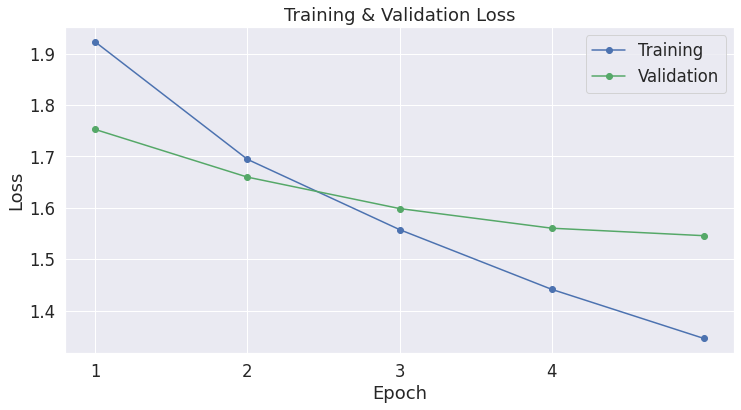

In [ ]:
import matplotlib.pyplot as plt

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# 파라미터 표시
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (42006, 768)
transformer.wpe.weight                                   (2048, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [ ]:
# 모델 저장

output_dir = '/content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_2'

# 디렉토리 만들기
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# 모델, 토크나이저 등 저장
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer_gpt3.save_pretrained(output_dir)

Saving model to /content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_2


('/content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_2/tokenizer_config.json',
 '/content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_2/special_tokens_map.json',
 '/content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_2/vocab.txt',
 '/content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_2/added_tokens.json',
 '/content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_2/tokenizer.json')

In [ ]:
!ls -l --block-size=K /content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_2

total 514942K
-rw------- 1 root root      1K Apr 15 08:23 added_tokens.json
-rw------- 1 root root      1K Apr 15 08:23 config.json
-rw------- 1 root root 513618K Apr 15 08:23 pytorch_model.bin
-rw------- 1 root root      1K Apr 15 08:23 special_tokens_map.json
-rw------- 1 root root      1K Apr 15 08:23 tokenizer_config.json
-rw------- 1 root root    986K Apr 15 08:23 tokenizer.json
-rw------- 1 root root    337K Apr 15 08:23 vocab.txt


In [ ]:
!ls -l --block-size=M /content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_2/pytorch_model.bin

-rw------- 1 root root 502M Apr 15 08:23 /content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_2/pytorch_model.bin


In [ ]:
# !cp -r /content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_2 $data_dir

# 구글 드라이브에서 모델, 토크나이저 불러오기

In [ ]:
# 구글 드라이브에서 모델, 토크나이저 불러오기

model = GPT2LMHeadModel.from_pretrained('/content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_2')
# gpt3-kor-small_based_on_gpt2
from transformers import BertTokenizerFast, GPT2LMHeadModel
tokenizer = BertTokenizerFast.from_pretrained('/content/drive/MyDrive/5조_파이널PJT/코드/model_result/gpt3_2')
input_ids = tokenizer.encode("text to tokenize")[1:]  # remove cls token

# Generate Text

* generate 함수 


In [ ]:
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
model = model.to(device)

In [ ]:
model.eval()

prompt = "<|startoftext|> <발라드> 자세히 보아야 예쁘다 오래 보아야 사랑스럽다 너도 그렇다 "
generated = torch.tensor(tokenizer_gpt3.encode(prompt)[1:]).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 350,
                                top_p=0.95, 
                                num_return_sequences=1,
                                repetition_penalty=1.2
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42003, 16461, 35042, 25590, 14351, 35042, 14366, 28152, 27647,
         22446,     3]], device='cuda:0')
0: 자세히 보아야 예쁘다 오래 보아야 사랑스럽다 너도 그렇다 <br> <br> <br> 화전리 화전리 화전리라 부르스뚜라 오오오 <br> 이 세상 어떤 하늘아래 살고있다고 상상해봐 단 한번뿐야 내곁에 있어줘 영원히 널 사랑해




#발라드 테스트

In [ ]:
prompt = "<|startoftext|> <발라드> 자세히 보아야 예쁘다"
generated = torch.tensor(tokenizer_gpt3.encode(prompt)[1:]).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 150,
                                top_p=0.95, 
                                num_return_sequences=1,
                                repetition_penalty=1.2
                                )

for i, sample_output in enumerate(sample_outputs):
  result = "{}: {}\n\n".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True))
  result = re.sub(r"<br>", "\n", result)
  print(result)

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42003, 16461, 35042, 25590,     3]], device='cuda:0')
0: 자세히 보아야 예쁘다찻자위에 이야기 꽃피우며 속삭이네 너와 나 우리둘이서




In [ ]:
len("자세히 보아야 예쁘다찻자위에 이야기 꽃피우며 속삭이네 너와 나 우리둘이서")

40

In [ ]:
prompt = "<|startoftext|> <발라드> 오래 보아야 사랑스럽다"
generated = torch.tensor(tokenizer_gpt3.encode(prompt)[1:]).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 350,
                                top_p=0.95, 
                                num_return_sequences=1,
                                repetition_penalty=1.2
                                )

for i, sample_output in enumerate(sample_outputs):
  result = "{}: {}\n\n".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True))
  result = re.sub(r"<br>", "\n", result)
  print(result)

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42003, 14351, 35042, 14366, 28152,     3]], device='cuda:0')
0: 오래 보아야 사랑스럽다 
 
 일하다말고 쉼없이 질주하는 너의 모습 너는 마치 날개같아 날게만해 오직 그하나로 오직 너의존재 이될께 내가 들때면 기댈곳이 필요하다며 니가 기쁠때 함께웃을수있도록 니가 지칠때나 지쳐갈때 서로 이해하며 잠시 쉴곳을 만들자던 우리죠 같은마음으로 원하고 있죠 겨워 하는 그대맘도 다알기에 차마 주어지질않죠 그저 나의 두팔에 가득 안겨서 세상을다 가져요 나없인 살수없는 슬픈그대 눈물 흘리지 마요 더 이상의 아픔은 없어 
 오직 너만이 너의 편이야




In [ ]:
len("일하다말고 쉼없이 질주하는 너의 모습 너는 마치 날개같아 날게만해 오직 그하나로 오직 너의존재 이될께 내가 들때면 기댈곳이 필요하다며 니가 기쁠때 함께웃을수있도록 니가 지칠때나 지쳐갈때 서로 이해하며 잠시 쉴곳을 만들자던 우리죠 같은마음으로 원하고 있죠 겨워 하는 그대맘도 다알기에 차마 주어지질않죠 그저 나의 두팔에 가득 안겨서 세상을다 가져요 나없인 살수없는 슬픈그대 눈물 흘리지 마요 더 이상의 아픔은 없어 오직 너만이 너의 편이야")

244

# 생성기

In [ ]:
def lyric_generator(gen, lyric):
  prompt = f"<|startoftext|> <{gen}> {lyric}"
  generated = torch.tensor(tokenizer_gpt3.encode(prompt)[1:]).unsqueeze(0)
  generated = generated.to(device)

  print(generated)

  sample_outputs = model.generate(
                                  generated, 
                                  #bos_token_id=random.randint(1,30000),
                                  do_sample=True,   
                                  top_k=50, 
                                  max_length = 350,
                                  top_p=0.95, 
                                  num_return_sequences=1,
                                  repetition_penalty=1.2
                                  )

  for i, sample_output in enumerate(sample_outputs):
    result = "{}: {}\n\n".format(i, tokenizer_gpt3.decode(sample_output, skip_special_tokens=True))
    result = re.sub(r"<br>", "\n", result)
    print(result)
  return

In [ ]:
lyric_generator('댄스', '요즘 학교가기 전에<br> 강아지랑 아침 산책을<br> 하기 시작했어요!')

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42004, 14175, 38468,  8143, 14544, 42005, 14971,  8202, 14473,
         28257, 42005, 14926, 25732,  2005,     3]], device='cuda:0')
0: 요즘 학교가기 전에 
 강아지랑 아침 산책을 
 하기 시작했어요! 
 
 어떤 사람이 좋아하는지 어떻게 대답하는지 어떻게 하는지 
 나는 알아요 왜 자꾸 쳐다봐요 
 이유는 몰라요 괜히 두리번대요 
 나는 알아요 혼자인 게 좋다는 거지요 
 내가 좀 더 다가가면 될까요 
 나에겐 정말 한 순간도 잊을 수가 없어요 
 
 지금 막 시작하자 나 너에게 달려가 
 내 손을 잡고 네 맘을 전해줄래 
 우리 처음 만났던 그 날처럼 이대로만 그렇게 계속 
 
 나의 맘이 널 향하길 원해 간절히 바래왔어 
 이렇게 우린 하나라고 
 
 너에게 기대고 싶어 너를 보고 있어 
 내 심장이 뛰는걸 넌 느껴줘 너도 내게 빠질 걸 난 느껴 
 love love love true love dream for you 
 love love love for your life 이젠 함께할 거야 너와 
 baby im ready 
 baby i just wanna be with you always only one 
 
 love love love you are my boo baby 
 im gonna leave all the girl come as you for my fellas and since 1991 
 dont tell me love u know baby lets ride or die 
 gonna get a lady let me say you were going down 
 
 love love love true love dream for you 
 love love love for your life 이젠 함께 할 거야 너와 
 
 love love love true love dream for you 
 love lo

In [ ]:
lyric_generator('발라드', '자세히 보아야 이쁘다')

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42003, 16461, 35042, 30545,     3]], device='cuda:0')
0: 자세히 보아야 이쁘다 
 
 오직 하나밖에 안보여 
 
 니가 없는 내 모습 정말 이게 뭐야 바보가됐어 
 
 나보고 말해봐 baby you lovely girl 
 
 no lie 
 
 너 때문에 매일 숨을 쉬는 내가 바보야 
 
 내 모든걸 다 걸었어 이젠 너를 버릴래 
 
 i got you back baby youre my love 
 
 youre the one of my life without your own 
 
 내게로 돌아와줘 
 
 너만을 영원히 지켜줄게 영원토록 
 
 oh oh oh oh my love 
 
 너를 너무 사랑해 my love my love 
 
 너를 볼 수가 없어서 너무나 싫어서 
 
 다시 되돌리고 싶은걸 my love 
 
 
 니가 없으면 안돼 my love my love my love 
 
 난 니가 필요해 
 
 너 때문에 매일 숨을 쉬는 내가 바보야 
 
 내 모든걸 다 걸었어 이젠 너를 버릴래 
 
 i got you back baby youre my love 
 
 youre the one of my life without your own 
 
 내게로 돌아와줘 
 
 너만을 영원히 지켜줄게 영원토록 
 
 oh oh oh oh my love 
 
 너를 너무 사랑해 my love my love 
 
 너를 볼 수가 없어서 너무나 싫어서 
 
 다시 되돌리고 싶은걸 my love 
 
 
 oh oh oh oh my love 
 
 너를 너무 사랑해 my love my love 
 
 나를 볼 수가 없어서 너무나 싫어서 
 
 다시 되돌리고 싶은걸 my love




In [ ]:
lyric_generator('댄스', '자세히 보아야<br> 이쁘다')

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42004, 16461, 35042, 42005, 30545,     3]], device='cuda:0')
0: 자세히 보아야 
 이쁘다 
 이렇게 차버리고 싶어 
 나도 날 몰라 이게 뭐야 
 내가 어떻게 알겠니 
 내가 잘할게 나 따윈 잊어줄래 
 oh i love you love you 너 너 너 정말 이래도 
 어떡해 어떡하라고 baby go away 
 oh go away go away oh bye 
 oh go away go away oh bye bye 
 한 번 더 용기 내서 고백할게 약속할게 
 oh go away go away 이젠 널 지켜볼게 
 love love love love love love yeah 
 내가 지켜 줄거야 love love 
 love love love love its true 
 go go go wow wow wow 너의 이름 외칠 때 난 
 난 마치 하늘의 별 난 하늘엔 저 달 같아 난 저기 떠 있는 태양 
 내 머리 위에 뜬 해와 달이 나를 비추잖아 my boy 
 이건 말도 안돼 누가 가르친 걸까 
 그냥 너를 좋아하게 된 것뿐인데 
 너와 나는 운명인걸 딱 본 순간 fall in love with you 
 난 원래 그런 사람 아냐 이건 말이야 
 oh i love you love you 너 너 정말 이래도 
 어떡해 어떡하라고 baby go away 
 oh go away go away oh bye 
 oh go away go away oh bye bye 
 1 2 3 get your hands up higher higher 
 hey hey listen to me ya 
 tell me what the feeling for you 
 come on here we just blah blah 
 luv u lady hu baby hu




In [ ]:
lyric_generator('댄스', '자세히 보아야 이쁘다')

Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.


tensor([[42000, 42004, 16461, 35042, 30545,     3]], device='cuda:0')
0: 자세히 보아야 이쁘다 
 
 부서지는 winebeen drop 
 시원한 바람과 너와 둘이 
 달리고 달리고 살리고 살리고 
 달리고 달리고 살리고 살리고 
 차게 달려라 지구 끝까지 
 광활한 전 세계 지칠 때까지 
 하늘 높이 모든걸 잊고 
 신나게 노래해봐 
 울려퍼져 음악이 울리면 
 달려보자 태양까지 소리쳐 봐 
 달려보자 신나게 뛰어봐 
 차게 뛰어봐 시원하게 달려보자 
 시원하게 달려봐 널 느껴봐 
 달려봐 다 함께 외쳐봐 
 hey shake it up 날아봐 
 하늘 위로 뛰어봐 
 달려가 지금 시작해 보는 거야


